In [1]:
!pip install -U nltk

In [2]:
import pandas as pd
import re
import json
from tqdm import tqdm
from nltk.corpus import stopwords
import nltk
from math import factorial, log
from itertools import combinations
from collections import Counter
import numpy as np
import gc
nltk.download('stopwords')
nltk.download('punkt')

from nltk.util import pad_sequence
from nltk.util import ngrams
from nltk import word_tokenize, sent_tokenize, pos_tag
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, Dropout, SimpleRNN, LSTM
from keras.callbacks import EarlyStopping
import tensorflow
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

[nltk_data] Downloading package stopwords to
[nltk_data]     /home2/tgv2002/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home2/tgv2002/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2022-04-18 19:31:41.347390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-18 19:31:41.347469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
EPSILON = 1e-20
INF = 1e20
N = 3
K = 15
MAXLEN = 40
VSIZE = 9194
tokenizer = ''

In [5]:
def get_vocabulary(sentences, threshold=5):
    word_frequencies = {}
    for sentence in sentences:
        words = re.sub('\W', ' ', sentence.lower()).split()
        words = [w for w in words if len(w) > 0]
        for word in words:
            if word_frequencies.get(word) is not None:
                word_frequencies[word] += 1
            else:
                word_frequencies[word] = 1
    return {w: v for w, v in word_frequencies.items() if v >= threshold}

In [6]:
def is_valid_string(attribute_value):
    return not (attribute_value == None or pd.isnull(attribute_value) or \
                str(attribute_value) == "" or str(attribute_value) == "nan" or \
                len(attribute_value) == 0)

# Loading data 

In [7]:
load_paths = ['../../data/train_data.csv', '../../data/valid_data.csv', '../../data/test_data.csv']
# load_paths = ['/content/gdrive/My Drive/Nlp-project/train_data.csv', 
#               '/content/gdrive/My Drive/Nlp-project/valid_data.csv', 
#               '/content/gdrive/My Drive/Nlp-project/test_data.csv']
load_paths = ['./train_data.csv', './valid_data.csv', './test_data.csv']

train_data = pd.read_csv(load_paths[0])
valid_data = pd.read_csv(load_paths[1])
test_data = pd.read_csv(load_paths[2])

In [8]:
def filter_unwanted_rows(data):
    y = data['Label'].tolist()
    to_drop = [i for i in range(len(y)) if y[i] > 3]
    new_data = data.drop(labels=to_drop, axis=0)
    new_data = new_data[new_data['Source'].str.split().str.len().lt(201)]
    new_data = new_data[new_data['Source'].str.split().str.len().lt(201)]
    # return np.asarray(new_data['Source'][:250]), np.asarray(new_data['Label'][:250]), np.asarray(new_data['Reference'][:250])
    return np.asarray(new_data['Source']), np.asarray(new_data['Label']), np.asarray(new_data['Reference'])

In [9]:
X_train, y_train, X_train_ref = filter_unwanted_rows(train_data)
X_test, y_test, X_test_ref = filter_unwanted_rows(test_data)
X_valid, y_valid, X_valid_ref = filter_unwanted_rows(valid_data)

print(sorted([len(x) for x in X_train]))

print("Train labels ratio")
print(Counter(y_train.tolist()))
print("Test labels ratio")
print(Counter(y_test.tolist()))
print("Validation labels ratio")
print(Counter(y_valid.tolist()))

[50, 50, 50, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 56, 57, 57, 57, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 62, 62, 62, 63, 63, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 66, 66, 66, 66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81,

In [10]:
VOCAB = get_vocabulary(X_train)
print(len(VOCAB))
TOTAL = sum(VOCAB.values())
print(TOTAL)

9194
474833


In [11]:
# Different techniques for tackling class imbalance
from imblearn.over_sampling import RandomOverSampler, SMOTE

def balance_data(x, y, _type=0):
    if _type == 1:
        ros = RandomOverSampler(random_state=42)
        return ros.fit_resample(x, y)
    elif _type == 2:
        smote = SMOTE()
        return smote.fit_resample(x, y)
    return x, y

# Language model

In [12]:
def get_seq_from_text(X_train, X_valid, X_test):
    global tokenizer
    # Keras tokenizer - fit on text data
    tokenizer = Tokenizer(num_words = VSIZE, oov_token='UNK')
    tokenizer.fit_on_texts(X_train)

    # Generating sequences from tokens for piece of text
    _X_train = [tokenizer.texts_to_sequences([text])[0] for text in X_train]
    _X_test = [tokenizer.texts_to_sequences([text])[0] for text in X_test]
    _X_valid = [tokenizer.texts_to_sequences([text])[0] for text in X_valid]
    return _X_train, _X_valid, _X_test

In [13]:
def get_inputs_and_outputs(_sequences):
    inputs = [_sequence[:i+1] for _sequence in _sequences for i in range(len(_sequence) - 1)]
    outputs = [_sequence[i+1] for _sequence in _sequences for i in range(len(_sequence) - 1)]
    return inputs, outputs

In [14]:
def load_batch_data(sequences, steps_per_epoch, batch_size):
    curr_batch_num = 0
    while True:
        if curr_batch_num >= steps_per_epoch:
            curr_batch_num = 0
            continue
        curr_inputs, curr_outputs = get_inputs_and_outputs(sequences[(curr_batch_num * batch_size):((curr_batch_num + 1) * batch_size)])
        curr_inputs = np.array(pad_sequences(curr_inputs, maxlen=MAXLEN, padding='pre'))
        curr_outputs = to_categorical(curr_outputs, num_classes=VSIZE)
        yield (np.array(curr_inputs), np.asarray(curr_outputs))
        curr_batch_num += 1

In [15]:
def define_LSTM_LM(embedding_dim=300, lstm_units=300):
    model = Sequential()
    model.add(Embedding(VSIZE, embedding_dim, input_length=MAXLEN))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dense(VSIZE, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))
    print(model.summary())
    return model

In [16]:
def define_RNN_LM(embedding_dim=300, rnn_units=300):
    model = Sequential()
    model.add(Embedding(VSIZE, embedding_dim, input_length=MAXLEN))
    model.add(SimpleRNN(rnn_units, return_sequences=False))
    model.add(Dense(VSIZE, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001))
    print(model.summary())
    return model

In [17]:
def train_model(model, X_train, X_valid, name, epochs=40):
    checkpoint = ModelCheckpoint(filepath=f'/content/gdrive/My Drive/Nlp-project/{name}.hdf5', 
                                 monitor="val_loss", save_best_only=True, verbose=1)
    SENT_PER_BATCH = 50

    train_steps_per_epoch = np.ceil(len(X_train) / SENT_PER_BATCH)
    train_data_gen = load_batch_data(X_train, train_steps_per_epoch, SENT_PER_BATCH)
    valid_steps_per_epoch = np.ceil(len(X_valid) / SENT_PER_BATCH)
    valid_data_gen = load_batch_data(X_valid, valid_steps_per_epoch, SENT_PER_BATCH)

    model.fit_generator(train_data_gen, epochs=epochs, steps_per_epoch=train_steps_per_epoch,
                                          validation_data=valid_data_gen, validation_steps=valid_steps_per_epoch,
                                          verbose = 1, callbacks=[checkpoint])
    return model

In [18]:
X_train_seq, X_valid_seq, X_test_seq = get_seq_from_text(X_train, X_valid, X_test)

In [19]:
# lstm_lm = define_LSTM_LM()
# lstm_lm = train_model(lstm_lm, X_train_seq, X_valid_seq, 'LSTM_LM')

In [20]:
# rnn_lm = define_RNN_LM()
# rnn_lm = train_model(rnn_lm, X_train_seq, X_valid_seq, 'RNN_LM', epochs=20)

# LM predictions and calculations

In [21]:
# lstm_lm = load_model('/content/gdrive/My Drive/Nlp-project/LSTM_LM.hdf5')
# rnn_lm = load_model('/content/gdrive/My Drive/Nlp-project/RNN_LM.hdf5')
lstm_lm = load_model('./LSTM_LM.hdf5')
rnn_lm = load_model('./RNN_LM.hdf5')

2022-04-18 19:31:55.963342: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-18 19:31:55.964144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-18 19:31:55.964686: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-18 19:31:56.829939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2022-04-18 19:31:56.830642: W tensorflow/stream_executor/platform/default/dso_loader

In [22]:
def calculate_perplexity(model, _text):
    global tokenizer
    text = re.sub('\W', ' ', _text.lower()).strip()
    tokens = tokenizer.texts_to_sequences([text])[0]
    if len(tokens) < 2:
        return 1, 0.5
    x, y = np.array([tokens[:-1]]), np.array([tokens[-1]])
    x, y = np.array(pad_sequences(x, maxlen=MAXLEN, padding='pre')), np.asarray(to_categorical(y, num_classes=VSIZE))
    try:
        cross_entropy = model.evaluate(x, y, verbose=0)
        perplexity = np.exp(cross_entropy)
        probability = 1 / (perplexity ** y.shape[0])
        return perplexity, probability
    except Exception as e:
        with open('./errs.txt', 'a') as f:
            print(e, file=f)
        return INF, 0

In [23]:
def get_all_ngram_probabilities(model, given_text):
    text = given_text.lower()
    sentences = sent_tokenize(text)
    if len(sentences) == 0:
        return [], INF
    all_ngram_probabilities, all_perplexities = [], []
    for sent in sentences:
        words = word_tokenize(sent)
        curr_ngrams = list(ngrams(words, n=N, pad_left=True, pad_right=True, left_pad_symbol="<s>", right_pad_symbol="</s>"))
        probabilities = [max(EPSILON, calculate_perplexity(model, ' '.join(ngram))[1]) for ngram in curr_ngrams]
        all_ngram_probabilities.append(probabilities)
        try:
            perplexity = (1 / np.prod(np.asarray(probabilities))) ** (1 / len(probabilities))
        except:
            perplexity = INF
        all_perplexities.append(perplexity)
    return all_ngram_probabilities, sum(all_perplexities) / len(all_perplexities)

In [24]:
def get_prob_feature_vector(text, model):
    global K
    features = []
    all_ngram_probabilities, perplexity = get_all_ngram_probabilities(model, text) 
    all_ngram_probabilities = sorted(sum(all_ngram_probabilities, []))
    if len(all_ngram_probabilities) == 0:
        return [0 for _ in range(2*K)] + [INF]
    frequent_k, rarest_k = all_ngram_probabilities[-K:], all_ngram_probabilities[:K]
    if len(frequent_k) < K:
        median = frequent_k[len(frequent_k) // 2]
        for _ in range(K - len(frequent_k)):
            frequent_k.append(median)
        frequent_k = sorted(frequent_k)
    if len(rarest_k) < K:
        median = rarest_k[len(rarest_k) // 2]
        for _ in range(K - len(rarest_k)):
            rarest_k.append(median)
        rarest_k = sorted(rarest_k)
    features = features + frequent_k + rarest_k + [perplexity]
    return features

# Metrics for Fluency

In [25]:
def get_ROUGE_S(translation, reference, n=3):
    if not is_valid_string(translation) or not is_valid_string(reference):
        return 0
    trans_words = word_tokenize(translation.lower())[:MAXLEN]
    skip_gram_comb = list(combinations([i for i in range(len(trans_words))], n))
    trans_skip_grams = [[trans_words[skip_gram_comb[i][j]] for j in range(len(skip_gram_comb[i]))] for i in range(len(skip_gram_comb))]
    ref_words = word_tokenize(reference.lower())[:MAXLEN]
    skip_gram_comb = list(combinations([i for i in range(len(ref_words))], n))
    ref_skip_grams = [[ref_words[skip_gram_comb[i][j]] for j in range(len(skip_gram_comb[i]))] for i in range(len(skip_gram_comb))]

    del skip_gram_comb
    gc.collect()
    skip_count = len([gram for gram in ref_skip_grams if gram in trans_skip_grams])
    if ref_skip_grams == None or trans_skip_grams == None or len(ref_skip_grams) == 0 or len(trans_skip_grams) == 0:
        return 0
    R_skip = skip_count / len(ref_skip_grams)
    P_skip = skip_count / len(trans_skip_grams)
    if R_skip == 0:
        return 0
    beta = P_skip / R_skip
    denom = R_skip + (beta * beta * P_skip)
    if denom == 0:
        return 0
    rouge_s = ((1 + (beta * beta)) * R_skip * P_skip) / denom
    return rouge_s

In [26]:
def get_ROUGE_L(translation, reference):
    if not is_valid_string(translation) or not is_valid_string(reference):
        return 0
    trans_words, ref_words = word_tokenize(translation.lower())[:MAXLEN], word_tokenize(reference.lower())[:MAXLEN]
    m, n = len(trans_words), len(ref_words)
    if m == 0 or n == 0:
        return 0
    lcs = [[None]*(n+1) for i in range(m+1)]
    for i in range(m+1):
        for j in range(n+1):
            if i == 0 or j == 0:
                lcs[i][j] = 0
            elif trans_words[i-1] == ref_words[j-1]:
                lcs[i][j] = lcs[i-1][j-1] + 1
            else:
                lcs[i][j] = max(lcs[i-1][j] , lcs[i][j-1])
    ans = lcs[m][n]
    del lcs
    gc.collect()
    return ans

In [27]:
def get_BLEU_score(sentence, reference):
    if not is_valid_string(sentence) or not is_valid_string(reference):
        return 0
    sentence_tokens = word_tokenize(sentence.lower())[:MAXLEN]
    ref_tokens = word_tokenize(reference.lower())[:MAXLEN]
    return sentence_bleu([ref_tokens], sentence_tokens)

In [28]:
def get_SLOR(sentence, probability):
    if not is_valid_string(sentence):
        return 0
    sentence_tokens = word_tokenize(sentence.lower())[:MAXLEN]
    if len(sentence_tokens) == 0:
        return 0
    term_1 = (1 / len(sentence_tokens)) * log(probability)
    unigram_prob = 1
    for word in sentence_tokens:
        if VOCAB.get(word) is not None:
            unigram_prob *= (VOCAB[word] / TOTAL)
        else:
            unigram_prob = 0
            break
    if unigram_prob < EPSILON:
        unigram_prob = EPSILON
    term_2 = log(unigram_prob)
    return term_1 - term_2

In [29]:
def ngram_overlap(translation, reference, n=3):
    if not is_valid_string(translation) or not is_valid_string(reference):
        return 0
    trans_words = word_tokenize(translation.lower())[:MAXLEN]
    trans_ngrams = list(ngrams(trans_words, n=n, pad_left=True, pad_right=True, left_pad_symbol="<s>", right_pad_symbol="</s>"))
    ref_words = word_tokenize(reference.lower())[:MAXLEN]
    ref_ngrams = list(ngrams(ref_words, n=n, pad_left=True, pad_right=True, left_pad_symbol="<s>", right_pad_symbol="</s>"))
    intersect = len([i for i in ref_ngrams if i in trans_ngrams])
    union = len(ref_ngrams) + len(trans_ngrams) - intersect
    if union == 0:
        return 0
    return intersect / union

# Feature extraction and model training

In [30]:
from sklearn.linear_model import LogisticRegression

# Training on train set, testing on both validation and test sets - 70:30
train_features, train_labels, test_features, test_labels = [], [], [], []
rouge_s, rouge_l, bleu, ng_overlap, slor = [], [], [], [], []

for i in tqdm(range(len(X_train))):
    rs, rl, b, ng, s = get_ROUGE_S(X_train[i], X_train_ref[i], N), get_ROUGE_L(X_train[i], X_train_ref[i]), \
                      get_BLEU_score(X_train[i], X_train_ref[i]), ngram_overlap(X_train[i], X_train_ref[i], N), \
                      get_SLOR(X_train[i], calculate_perplexity(lstm_lm, X_train[i])[1])
    features = get_prob_feature_vector(X_train[i], lstm_lm) + [rs, rl, b, ng, s]
    train_features.append(features)
    train_labels.append(y_train[i])
    # if (i + 1) % 50 == 0:
    #     with open('/content/gdrive/My Drive/Nlp-project/train_log.json', 'w') as _f:
    #         print(i)
    #         json.dump({"train_features": np.array(train_features).tolist(), "train_labels": np.array(train_labels).tolist()}, _f)
    rouge_s.append(rs)
    rouge_l.append(rl)
    bleu.append(b)
    ng_overlap.append(ng)
    slor.append(s)
# with open('/content/gdrive/My Drive/Nlp-project/train_log.json', 'w') as _f:
#     json.dump({"train_features": np.array(train_features).tolist(), "train_labels": np.array(train_labels).tolist()}, _f)


for i in tqdm(range(len(X_test))):
    rs, rl, b, ng, s = get_ROUGE_S(X_test[i], X_test_ref[i], N), get_ROUGE_L(X_test[i], X_test_ref[i]), \
                      get_BLEU_score(X_test[i], X_test_ref[i]), ngram_overlap(X_test[i], X_test_ref[i], N), \
                      get_SLOR(X_test[i], calculate_perplexity(lstm_lm, X_test[i])[1])
    features = get_prob_feature_vector(X_test[i], lstm_lm) + [rs, rl, b, ng, s]
    test_features.append(features)
    test_labels.append(y_test[i])
    # if (i + 1) % 50 == 0:
    #     with open('/content/gdrive/My Drive/Nlp-project/test_log.json', 'w') as _f:
    #         print(i)
    #         json.dump({"test_features": np.array(test_features).tolist(), "test_labels": np.array(test_labels).tolist()}, _f)
    rouge_s.append(rs)
    rouge_l.append(rl)
    bleu.append(b)
    ng_overlap.append(ng)
    slor.append(s)
# with open('/content/gdrive/My Drive/Nlp-project/test_log.json', 'w') as _f:
#     json.dump({"test_features": np.array(test_features).tolist(), "test_labels": np.array(test_labels).tolist()}, _f)

for i in tqdm(range(len(X_valid))):
    rs, rl, b, ng, s = get_ROUGE_S(X_valid[i], X_valid_ref[i], N), get_ROUGE_L(X_valid[i], X_valid_ref[i]), \
                      get_BLEU_score(X_valid[i], X_valid_ref[i]), ngram_overlap(X_valid[i], X_valid_ref[i], N), \
                      get_SLOR(X_valid[i], calculate_perplexity(lstm_lm, X_valid[i])[1])
    features = get_prob_feature_vector(X_valid[i], lstm_lm) + [rs, rl, b, ng, s]
    test_features.append(features)
    test_labels.append(y_valid[i])
    # if (i + 1) % 50 == 0:
    #     with open('/content/gdrive/My Drive/Nlp-project/test_log_7.json', 'w') as _f:
    #         print(i)
    #         json.dump({"test_features": np.array(test_features).tolist(), "test_labels": np.array(test_labels).tolist()}, _f)
    rouge_s.append(rs)
    rouge_l.append(rl)
    bleu.append(b)
    ng_overlap.append(ng)
    slor.append(s)
# with open('/content/gdrive/My Drive/Nlp-project/test_log_7.json', 'w') as _f:
#     json.dump({"test_features": np.array(test_features).tolist(), "test_labels": np.array(test_labels).tolist()}, _f)

  0%|          | 0/16005 [00:00<?, ?it/s]

2022-04-18 19:32:00.259170: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  0%|          | 1/16005 [00:02<13:15:10,  2.98s/it]

  0%|          | 2/16005 [00:05<10:51:09,  2.44s/it]

  0%|          | 3/16005 [00:07<11:33:50,  2.60s/it]

/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


  0%|          | 4/16005 [00:09<9:49:31,  2.21s/it] 

  0%|          | 5/16005 [00:10<8:31:25,  1.92s/it]

  0%|          | 6/16005 [00:13<9:13:14,  2.07s/it]

  0%|          | 7/16005 [00:15<8:59:52,  2.02s/it]

  0%|          | 8/16005 [00:16<8:30:30,  1.91s/it]

  0%|          | 9/16005 [00:19<8:54:07,  2.00s/it]

  0%|          | 10/16005 [00:20<8:13:53,  1.85s/it]

  0%|          | 11/16005 [00:22<8:14:22,  1.85s/it]

  0%|          | 12/16005 [00:25<9:50:22,  2.21s/it]

  0%|          | 13/16005 [00:27<9:59:49,  2.25s/it]

  0%|          | 14/16005 [00:30<10:55:19,  2.46s/it]

  0%|          | 15/16005 [00:33<10:47:35,  2.43s/it]

  0%|          | 16/16005 [00:34<9:55:12,  2.23s/it] 

  0%|          | 17/16005 [00:36<9:43:03,  2.19s/it]

  0%|          | 18/16005 [00:38<8:52:47,  2.00s/it]

  0%|          | 19/16005 [00:42<11:24:25,  2.57s/it]

  0%|          | 20/16005 [00:45<11:28:54,  2.59s/it]

  0%|          | 21/16005 [00:46<10:04:20,  2.27s/it]

  0%|          | 22/16005 [00:48<10:02:01,  2.26s/it]

  0%|          | 23/16005 [00:50<9:10:58,  2.07s/it] 

  0%|          | 24/16005 [00:53<9:59:07,  2.25s/it]

  0%|          | 25/16005 [00:54<9:22:55,  2.11s/it]

  0%|          | 26/16005 [00:57<10:27:35,  2.36s/it]

  0%|          | 27/16005 [00:59<9:56:56,  2.24s/it] 

  0%|          | 28/16005 [01:01<8:38:32,  1.95s/it]

/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


  0%|          | 29/16005 [01:02<7:21:22,  1.66s/it]

  0%|          | 30/16005 [01:06<10:43:00,  2.42s/it]

  0%|          | 31/16005 [01:08<10:07:23,  2.28s/it]

  0%|          | 32/16005 [01:11<12:06:21,  2.73s/it]

  0%|          | 33/16005 [01:14<11:40:38,  2.63s/it]

  0%|          | 34/16005 [01:16<11:27:00,  2.58s/it]

  0%|          | 35/16005 [01:19<11:00:44,  2.48s/it]

  0%|          | 36/16005 [01:20<9:44:46,  2.20s/it] 

  0%|          | 37/16005 [01:22<9:05:11,  2.05s/it]

  0%|          | 38/16005 [01:23<8:12:57,  1.85s/it]

  0%|          | 39/16005 [01:25<8:44:00,  1.97s/it]

  0%|          | 40/16005 [01:27<8:15:39,  1.86s/it]

  0%|          | 41/16005 [01:28<7:19:45,  1.65s/it]

  0%|          | 42/16005 [01:30<7:32:11,  1.70s/it]

  0%|          | 43/16005 [01:32<8:21:51,  1.89s/it]

  0%|          | 44/16005 [01:33<7:20:24,  1.66s/it]

  0%|          | 45/16005 [01:35<7:27:53,  1.68s/it]

  0%|          | 46/16005 [01:38<9:12:36,  2.08s/it]

  0%|          | 47/16005 [01:40<8:14:17,  1.86s/it]

  0%|          | 48/16005 [01:41<8:02:54,  1.82s/it]

  0%|          | 49/16005 [01:43<8:08:53,  1.84s/it]

  0%|          | 50/16005 [01:45<8:08:20,  1.84s/it]

  0%|          | 51/16005 [01:46<7:32:07,  1.70s/it]

  0%|          | 52/16005 [01:48<7:13:00,  1.63s/it]

  0%|          | 53/16005 [01:49<7:13:16,  1.63s/it]

  0%|          | 54/16005 [01:51<7:07:11,  1.61s/it]

  0%|          | 55/16005 [01:53<7:40:22,  1.73s/it]

  0%|          | 56/16005 [01:55<8:01:35,  1.81s/it]

  0%|          | 57/16005 [01:56<7:10:19,  1.62s/it]

/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


  0%|          | 58/16005 [01:57<6:31:58,  1.47s/it]

  0%|          | 59/16005 [01:59<6:40:40,  1.51s/it]

  0%|          | 60/16005 [02:01<7:25:47,  1.68s/it]

  0%|          | 61/16005 [02:04<8:38:18,  1.95s/it]

  0%|          | 62/16005 [02:05<7:57:49,  1.80s/it]

  0%|          | 63/16005 [02:06<7:18:50,  1.65s/it]

  0%|          | 64/16005 [02:08<7:16:18,  1.64s/it]

  0%|          | 65/16005 [02:10<7:15:22,  1.64s/it]

  0%|          | 66/16005 [02:11<7:16:39,  1.64s/it]

  0%|          | 67/16005 [02:15<9:31:18,  2.15s/it]

  0%|          | 68/16005 [02:16<8:34:32,  1.94s/it]

  0%|          | 69/16005 [02:18<8:06:02,  1.83s/it]

  0%|          | 70/16005 [02:21<9:48:28,  2.22s/it]

  0%|          | 71/16005 [02:24<10:50:48,  2.45s/it]

  0%|          | 72/16005 [02:25<9:48:10,  2.21s/it] 

  0%|          | 73/16005 [02:27<9:39:02,  2.18s/it]

  0%|          | 74/16005 [02:30<9:59:36,  2.26s/it]

  0%|          | 75/16005 [02:31<8:12:55,  1.86s/it]

  0%|          | 76/16005 [02:32<7:56:44,  1.80s/it]

  0%|          | 77/16005 [02:35<8:51:35,  2.00s/it]

  0%|          | 78/16005 [02:37<8:48:09,  1.99s/it]

  0%|          | 79/16005 [02:39<9:10:10,  2.07s/it]

  0%|          | 80/16005 [02:41<9:15:42,  2.09s/it]

  1%|          | 81/16005 [02:43<8:49:34,  2.00s/it]

  1%|          | 82/16005 [02:45<8:17:07,  1.87s/it]

  1%|          | 83/16005 [02:46<7:35:03,  1.71s/it]

  1%|          | 84/16005 [02:48<7:55:34,  1.79s/it]

  1%|          | 85/16005 [02:51<8:58:13,  2.03s/it]

  1%|          | 86/16005 [02:52<8:29:51,  1.92s/it]

  1%|          | 87/16005 [02:56<10:22:33,  2.35s/it]

  1%|          | 88/16005 [02:57<9:37:06,  2.18s/it] 

  1%|          | 89/16005 [02:59<8:32:00,  1.93s/it]

  1%|          | 90/16005 [03:01<8:34:15,  1.94s/it]

  1%|          | 91/16005 [03:03<8:32:24,  1.93s/it]

  1%|          | 92/16005 [03:06<9:48:28,  2.22s/it]

  1%|          | 93/16005 [03:07<8:11:38,  1.85s/it]

  1%|          | 94/16005 [03:08<8:10:27,  1.85s/it]

  1%|          | 95/16005 [03:11<8:38:23,  1.95s/it]

  1%|          | 96/16005 [03:14<11:00:45,  2.49s/it]

  1%|          | 97/16005 [03:16<10:13:42,  2.31s/it]

  1%|          | 98/16005 [03:19<11:22:44,  2.58s/it]

  1%|          | 99/16005 [03:21<10:16:29,  2.33s/it]

  1%|          | 100/16005 [03:23<9:23:37,  2.13s/it]

  1%|          | 101/16005 [03:27<11:54:31,  2.70s/it]

  1%|          | 102/16005 [03:29<11:17:19,  2.56s/it]

  1%|          | 103/16005 [03:31<10:16:38,  2.33s/it]

  1%|          | 104/16005 [03:33<10:18:59,  2.34s/it]

  1%|          | 105/16005 [03:35<9:04:27,  2.05s/it] 

  1%|          | 106/16005 [03:36<8:10:50,  1.85s/it]

  1%|          | 107/16005 [03:39<9:05:55,  2.06s/it]

  1%|          | 108/16005 [03:40<8:30:16,  1.93s/it]

  1%|          | 109/16005 [03:42<7:58:38,  1.81s/it]

  1%|          | 110/16005 [03:44<9:00:52,  2.04s/it]

  1%|          | 111/16005 [03:46<9:10:57,  2.08s/it]

  1%|          | 112/16005 [03:48<9:01:38,  2.04s/it]

  1%|          | 113/16005 [03:50<8:34:12,  1.94s/it]

  1%|          | 114/16005 [03:52<8:33:23,  1.94s/it]

  1%|          | 115/16005 [03:53<7:51:33,  1.78s/it]

  1%|          | 116/16005 [03:56<8:23:19,  1.90s/it]

  1%|          | 117/16005 [03:58<9:04:53,  2.06s/it]

  1%|          | 118/16005 [04:00<8:56:23,  2.03s/it]

  1%|          | 119/16005 [04:02<9:35:18,  2.17s/it]

  1%|          | 120/16005 [04:04<9:09:16,  2.07s/it]

  1%|          | 121/16005 [04:06<8:48:43,  2.00s/it]

  1%|          | 122/16005 [04:08<9:02:52,  2.05s/it]

  1%|          | 123/16005 [04:10<8:50:23,  2.00s/it]

  1%|          | 124/16005 [04:12<8:26:45,  1.91s/it]

  1%|          | 125/16005 [04:13<7:56:15,  1.80s/it]

  1%|          | 126/16005 [04:16<8:58:53,  2.04s/it]

  1%|          | 127/16005 [04:18<8:20:58,  1.89s/it]

  1%|          | 128/16005 [04:20<8:30:08,  1.93s/it]

  1%|          | 129/16005 [04:23<9:59:02,  2.26s/it]

  1%|          | 130/16005 [04:24<9:24:06,  2.13s/it]

  1%|          | 131/16005 [04:27<10:28:11,  2.37s/it]

  1%|          | 132/16005 [04:30<10:07:49,  2.30s/it]

  1%|          | 133/16005 [04:33<11:36:09,  2.63s/it]

  1%|          | 134/16005 [04:35<11:17:33,  2.56s/it]

  1%|          | 135/16005 [04:38<11:15:37,  2.55s/it]

  1%|          | 136/16005 [04:40<10:06:22,  2.29s/it]

  1%|          | 137/16005 [04:41<8:44:45,  1.98s/it] 

  1%|          | 138/16005 [04:43<9:23:29,  2.13s/it]

  1%|          | 139/16005 [04:47<11:01:53,  2.50s/it]

  1%|          | 140/16005 [04:49<10:46:09,  2.44s/it]

  1%|          | 141/16005 [04:53<12:29:41,  2.84s/it]

  1%|          | 142/16005 [04:56<12:40:06,  2.88s/it]

  1%|          | 143/16005 [04:58<12:22:16,  2.81s/it]

  1%|          | 144/16005 [05:01<11:36:10,  2.63s/it]

  1%|          | 145/16005 [05:03<11:09:04,  2.53s/it]

  1%|          | 146/16005 [05:04<9:41:37,  2.20s/it] 

  1%|          | 147/16005 [05:06<9:40:30,  2.20s/it]

  1%|          | 148/16005 [05:09<10:24:18,  2.36s/it]

  1%|          | 149/16005 [05:11<9:44:06,  2.21s/it] 

  1%|          | 150/16005 [05:14<10:29:04,  2.38s/it]

  1%|          | 151/16005 [05:15<9:28:13,  2.15s/it] 

  1%|          | 152/16005 [05:17<9:08:30,  2.08s/it]

  1%|          | 153/16005 [05:19<8:30:52,  1.93s/it]

  1%|          | 154/16005 [05:20<7:54:05,  1.79s/it]

  1%|          | 155/16005 [05:22<7:45:29,  1.76s/it]

  1%|          | 156/16005 [05:25<9:37:24,  2.19s/it]

  1%|          | 157/16005 [05:27<9:01:47,  2.05s/it]

  1%|          | 158/16005 [05:29<9:09:04,  2.08s/it]

  1%|          | 159/16005 [05:33<11:12:47,  2.55s/it]

  1%|          | 160/16005 [05:35<10:09:57,  2.31s/it]

  1%|          | 161/16005 [05:36<9:08:36,  2.08s/it] 

  1%|          | 162/16005 [05:38<9:03:02,  2.06s/it]

  1%|          | 163/16005 [05:41<10:10:44,  2.31s/it]

  1%|          | 164/16005 [05:43<9:35:37,  2.18s/it] 

  1%|          | 165/16005 [05:45<9:05:49,  2.07s/it]

  1%|          | 166/16005 [05:46<8:27:02,  1.92s/it]

  1%|          | 167/16005 [05:48<7:38:03,  1.74s/it]

  1%|          | 168/16005 [05:49<7:31:00,  1.71s/it]

  1%|          | 169/16005 [05:52<9:07:52,  2.08s/it]

  1%|          | 170/16005 [05:54<9:15:48,  2.11s/it]

  1%|          | 171/16005 [05:57<9:19:54,  2.12s/it]

  1%|          | 172/16005 [05:59<9:46:44,  2.22s/it]

  1%|          | 173/16005 [06:01<9:05:53,  2.07s/it]

  1%|          | 174/16005 [06:05<11:24:50,  2.60s/it]

  1%|          | 175/16005 [06:08<12:03:48,  2.74s/it]

  1%|          | 176/16005 [06:09<10:03:39,  2.29s/it]

  1%|          | 177/16005 [06:10<8:49:14,  2.01s/it] 

  1%|          | 178/16005 [06:11<7:51:21,  1.79s/it]

  1%|          | 179/16005 [06:14<8:23:15,  1.91s/it]

  1%|          | 180/16005 [06:15<8:10:03,  1.86s/it]

  1%|          | 181/16005 [06:18<9:07:10,  2.07s/it]

  1%|          | 182/16005 [06:20<9:35:31,  2.18s/it]

  1%|          | 183/16005 [06:22<8:30:12,  1.93s/it]

  1%|          | 184/16005 [06:23<7:53:25,  1.80s/it]

  1%|          | 185/16005 [06:25<7:12:39,  1.64s/it]

  1%|          | 186/16005 [06:26<7:39:56,  1.74s/it]

  1%|          | 187/16005 [06:29<8:13:42,  1.87s/it]

  1%|          | 188/16005 [06:31<9:29:16,  2.16s/it]

  1%|          | 189/16005 [06:35<10:39:12,  2.42s/it]

  1%|          | 190/16005 [06:36<8:51:51,  2.02s/it] 

  1%|          | 191/16005 [06:37<7:53:13,  1.80s/it]

  1%|          | 192/16005 [06:38<7:10:17,  1.63s/it]

  1%|          | 193/16005 [06:43<11:01:43,  2.51s/it]

  1%|          | 194/16005 [06:44<9:58:55,  2.27s/it] 

  1%|          | 195/16005 [06:46<9:33:57,  2.18s/it]

  1%|          | 196/16005 [06:50<11:01:31,  2.51s/it]

  1%|          | 197/16005 [06:52<10:13:10,  2.33s/it]

  1%|          | 198/16005 [06:53<9:25:45,  2.15s/it] 

  1%|          | 199/16005 [06:55<8:34:57,  1.95s/it]

  1%|          | 200/16005 [06:58<9:35:24,  2.18s/it]

  1%|▏         | 201/16005 [06:59<9:01:50,  2.06s/it]

  1%|▏         | 202/16005 [07:01<8:31:52,  1.94s/it]

  1%|▏         | 203/16005 [07:03<8:48:45,  2.01s/it]

  1%|▏         | 204/16005 [07:05<8:26:35,  1.92s/it]

  1%|▏         | 205/16005 [07:08<9:29:31,  2.16s/it]

  1%|▏         | 206/16005 [07:09<8:30:55,  1.94s/it]

  1%|▏         | 207/16005 [07:12<9:30:56,  2.17s/it]

  1%|▏         | 208/16005 [07:15<10:33:34,  2.41s/it]

  1%|▏         | 209/16005 [07:16<9:12:50,  2.10s/it] 

  1%|▏         | 210/16005 [07:19<10:11:38,  2.32s/it]

  1%|▏         | 211/16005 [07:20<8:53:45,  2.03s/it] 

  1%|▏         | 212/16005 [07:21<7:46:02,  1.77s/it]

  1%|▏         | 213/16005 [07:25<10:17:33,  2.35s/it]

  1%|▏         | 214/16005 [07:28<10:45:43,  2.45s/it]

  1%|▏         | 215/16005 [07:30<9:53:21,  2.25s/it] 

  1%|▏         | 216/16005 [07:31<9:24:25,  2.14s/it]

  1%|▏         | 217/16005 [07:34<9:22:27,  2.14s/it]

  1%|▏         | 218/16005 [07:36<9:14:46,  2.11s/it]

  1%|▏         | 219/16005 [07:38<9:37:53,  2.20s/it]

  1%|▏         | 220/16005 [07:40<9:21:33,  2.13s/it]

  1%|▏         | 221/16005 [07:43<10:03:24,  2.29s/it]

  1%|▏         | 222/16005 [07:45<10:22:42,  2.37s/it]

  1%|▏         | 223/16005 [07:49<11:44:09,  2.68s/it]

  1%|▏         | 224/16005 [07:50<10:21:14,  2.36s/it]

  1%|▏         | 225/16005 [07:54<11:45:35,  2.68s/it]

  1%|▏         | 226/16005 [07:57<12:49:16,  2.93s/it]

  1%|▏         | 227/16005 [08:01<13:51:20,  3.16s/it]

  1%|▏         | 228/16005 [08:03<13:08:49,  3.00s/it]

  1%|▏         | 229/16005 [08:07<13:28:14,  3.07s/it]

  1%|▏         | 230/16005 [08:09<12:35:03,  2.87s/it]

  1%|▏         | 231/16005 [08:11<10:52:28,  2.48s/it]

  1%|▏         | 232/16005 [08:13<11:06:26,  2.54s/it]

  1%|▏         | 233/16005 [08:15<9:42:30,  2.22s/it] 

  1%|▏         | 234/16005 [08:17<9:43:27,  2.22s/it]

  1%|▏         | 235/16005 [08:19<9:57:07,  2.27s/it]

  1%|▏         | 236/16005 [08:23<11:09:54,  2.55s/it]

  1%|▏         | 237/16005 [08:24<10:05:08,  2.30s/it]

  1%|▏         | 238/16005 [08:26<8:50:53,  2.02s/it] 

  1%|▏         | 239/16005 [08:27<7:17:04,  1.66s/it]

  1%|▏         | 240/16005 [08:31<10:43:53,  2.45s/it]

  2%|▏         | 241/16005 [08:33<10:11:32,  2.33s/it]

  2%|▏         | 242/16005 [08:35<9:59:17,  2.28s/it] 

  2%|▏         | 243/16005 [08:37<9:41:12,  2.21s/it]

  2%|▏         | 244/16005 [08:38<8:29:33,  1.94s/it]

  2%|▏         | 245/16005 [08:41<9:08:57,  2.09s/it]

  2%|▏         | 246/16005 [08:43<8:41:29,  1.99s/it]

  2%|▏         | 247/16005 [08:44<8:29:15,  1.94s/it]

  2%|▏         | 248/16005 [08:46<7:42:57,  1.76s/it]

  2%|▏         | 249/16005 [08:48<7:39:03,  1.75s/it]

  2%|▏         | 250/16005 [08:50<8:34:47,  1.96s/it]

  2%|▏         | 251/16005 [08:51<7:49:09,  1.79s/it]

  2%|▏         | 252/16005 [08:53<7:20:12,  1.68s/it]

  2%|▏         | 253/16005 [08:56<9:26:39,  2.16s/it]

  2%|▏         | 254/16005 [08:58<8:50:49,  2.02s/it]

  2%|▏         | 255/16005 [09:00<8:46:06,  2.00s/it]

  2%|▏         | 256/16005 [09:03<10:23:38,  2.38s/it]

  2%|▏         | 257/16005 [09:04<9:09:14,  2.09s/it] 

  2%|▏         | 258/16005 [09:06<8:57:34,  2.05s/it]

  2%|▏         | 259/16005 [09:10<11:00:26,  2.52s/it]

  2%|▏         | 260/16005 [09:11<9:26:21,  2.16s/it] 

  2%|▏         | 261/16005 [09:14<9:59:00,  2.28s/it]

  2%|▏         | 262/16005 [09:16<9:39:35,  2.21s/it]

  2%|▏         | 263/16005 [09:18<9:21:00,  2.14s/it]

  2%|▏         | 264/16005 [09:20<8:47:13,  2.01s/it]

  2%|▏         | 265/16005 [09:22<8:42:32,  1.99s/it]

  2%|▏         | 266/16005 [09:23<7:57:40,  1.82s/it]

  2%|▏         | 267/16005 [09:27<11:31:54,  2.64s/it]

  2%|▏         | 268/16005 [09:31<13:13:06,  3.02s/it]

  2%|▏         | 269/16005 [09:35<13:29:07,  3.09s/it]

  2%|▏         | 270/16005 [09:37<13:02:33,  2.98s/it]

  2%|▏         | 271/16005 [09:39<11:23:34,  2.61s/it]

  2%|▏         | 272/16005 [09:41<10:27:28,  2.39s/it]

  2%|▏         | 273/16005 [09:43<10:06:49,  2.31s/it]

  2%|▏         | 274/16005 [09:47<12:36:50,  2.89s/it]

  2%|▏         | 275/16005 [09:50<12:09:53,  2.78s/it]

  2%|▏         | 276/16005 [09:51<10:19:56,  2.36s/it]

  2%|▏         | 277/16005 [09:55<11:53:45,  2.72s/it]

  2%|▏         | 278/16005 [09:58<12:50:54,  2.94s/it]

  2%|▏         | 279/16005 [10:01<12:56:22,  2.96s/it]

  2%|▏         | 280/16005 [10:02<10:33:28,  2.42s/it]

  2%|▏         | 281/16005 [10:05<10:55:58,  2.50s/it]

  2%|▏         | 282/16005 [10:09<12:12:48,  2.80s/it]

  2%|▏         | 283/16005 [10:12<13:26:29,  3.08s/it]

  2%|▏         | 284/16005 [10:15<12:55:02,  2.96s/it]

  2%|▏         | 285/16005 [10:17<11:03:18,  2.53s/it]

  2%|▏         | 286/16005 [10:18<9:49:22,  2.25s/it] 

  2%|▏         | 287/16005 [10:20<9:32:35,  2.19s/it]

  2%|▏         | 288/16005 [10:21<8:08:36,  1.87s/it]

  2%|▏         | 289/16005 [10:23<7:36:25,  1.74s/it]

  2%|▏         | 290/16005 [10:24<7:15:45,  1.66s/it]

  2%|▏         | 291/16005 [10:26<7:38:30,  1.75s/it]

  2%|▏         | 292/16005 [10:29<9:26:48,  2.16s/it]

  2%|▏         | 293/16005 [10:32<10:38:08,  2.44s/it]

  2%|▏         | 294/16005 [10:35<10:18:50,  2.36s/it]

  2%|▏         | 295/16005 [10:38<11:55:23,  2.73s/it]

  2%|▏         | 296/16005 [10:40<10:08:28,  2.32s/it]

  2%|▏         | 297/16005 [10:42<10:07:08,  2.32s/it]

  2%|▏         | 298/16005 [10:44<9:44:22,  2.23s/it] 

  2%|▏         | 299/16005 [10:46<9:14:31,  2.12s/it]

  2%|▏         | 300/16005 [10:48<9:57:46,  2.28s/it]

  2%|▏         | 301/16005 [10:50<9:20:41,  2.14s/it]

  2%|▏         | 302/16005 [10:53<9:57:39,  2.28s/it]

  2%|▏         | 303/16005 [10:55<9:48:01,  2.25s/it]

  2%|▏         | 304/16005 [10:58<11:15:16,  2.58s/it]

  2%|▏         | 305/16005 [11:00<9:48:42,  2.25s/it] 

  2%|▏         | 306/16005 [11:02<9:22:47,  2.15s/it]

  2%|▏         | 307/16005 [11:03<8:23:58,  1.93s/it]

  2%|▏         | 308/16005 [11:05<8:41:49,  1.99s/it]

  2%|▏         | 309/16005 [11:10<11:52:16,  2.72s/it]

  2%|▏         | 310/16005 [11:13<12:55:23,  2.96s/it]

  2%|▏         | 311/16005 [11:15<10:55:52,  2.51s/it]

  2%|▏         | 312/16005 [11:18<11:21:09,  2.60s/it]

  2%|▏         | 313/16005 [11:19<10:19:55,  2.37s/it]

  2%|▏         | 314/16005 [11:21<9:24:56,  2.16s/it] 

  2%|▏         | 315/16005 [11:22<7:55:48,  1.82s/it]

  2%|▏         | 316/16005 [11:27<11:33:32,  2.65s/it]

  2%|▏         | 317/16005 [11:29<11:14:54,  2.58s/it]

  2%|▏         | 318/16005 [11:31<9:54:41,  2.27s/it] 

  2%|▏         | 319/16005 [11:33<10:27:31,  2.40s/it]

  2%|▏         | 320/16005 [11:37<12:12:51,  2.80s/it]

  2%|▏         | 321/16005 [11:38<10:12:48,  2.34s/it]

  2%|▏         | 322/16005 [11:41<11:11:44,  2.57s/it]

  2%|▏         | 323/16005 [11:44<11:37:29,  2.67s/it]

  2%|▏         | 324/16005 [11:48<12:33:29,  2.88s/it]

  2%|▏         | 325/16005 [11:50<12:10:49,  2.80s/it]

  2%|▏         | 326/16005 [11:53<12:29:55,  2.87s/it]

  2%|▏         | 327/16005 [11:55<10:20:52,  2.38s/it]

  2%|▏         | 328/16005 [11:57<10:34:56,  2.43s/it]

  2%|▏         | 329/16005 [12:01<11:54:26,  2.73s/it]

  2%|▏         | 330/16005 [12:03<11:12:47,  2.58s/it]

  2%|▏         | 331/16005 [12:04<10:02:51,  2.31s/it]

  2%|▏         | 332/16005 [12:08<11:36:35,  2.67s/it]

  2%|▏         | 333/16005 [12:10<10:08:41,  2.33s/it]

  2%|▏         | 334/16005 [12:11<9:02:11,  2.08s/it] 

  2%|▏         | 335/16005 [12:13<9:09:05,  2.10s/it]

  2%|▏         | 336/16005 [12:15<8:52:50,  2.04s/it]

  2%|▏         | 337/16005 [12:18<10:27:56,  2.40s/it]

  2%|▏         | 338/16005 [12:20<10:04:10,  2.31s/it]

  2%|▏         | 339/16005 [12:23<9:51:48,  2.27s/it] 

  2%|▏         | 340/16005 [12:24<9:02:45,  2.08s/it]

  2%|▏         | 341/16005 [12:26<8:30:18,  1.95s/it]

  2%|▏         | 342/16005 [12:28<8:59:27,  2.07s/it]

  2%|▏         | 343/16005 [12:30<8:42:01,  2.00s/it]

  2%|▏         | 344/16005 [12:34<10:36:35,  2.44s/it]

  2%|▏         | 345/16005 [12:35<9:25:24,  2.17s/it] 

  2%|▏         | 346/16005 [12:37<8:31:01,  1.96s/it]

  2%|▏         | 347/16005 [12:38<8:11:14,  1.88s/it]

  2%|▏         | 348/16005 [12:40<8:19:04,  1.91s/it]

  2%|▏         | 349/16005 [12:42<7:49:12,  1.80s/it]

  2%|▏         | 350/16005 [12:44<7:55:06,  1.82s/it]

  2%|▏         | 351/16005 [12:46<8:28:11,  1.95s/it]

  2%|▏         | 352/16005 [12:49<9:56:25,  2.29s/it]

  2%|▏         | 353/16005 [12:50<8:45:48,  2.02s/it]

  2%|▏         | 354/16005 [12:52<8:24:49,  1.94s/it]

  2%|▏         | 355/16005 [12:53<7:33:01,  1.74s/it]

  2%|▏         | 356/16005 [12:55<7:18:22,  1.68s/it]

  2%|▏         | 357/16005 [12:57<7:15:46,  1.67s/it]

  2%|▏         | 358/16005 [12:58<7:12:59,  1.66s/it]

  2%|▏         | 359/16005 [13:02<10:11:26,  2.34s/it]

  2%|▏         | 360/16005 [13:05<10:24:34,  2.40s/it]

  2%|▏         | 361/16005 [13:07<10:33:35,  2.43s/it]

  2%|▏         | 362/16005 [13:09<9:18:52,  2.14s/it] 

  2%|▏         | 363/16005 [13:12<10:52:45,  2.50s/it]

  2%|▏         | 364/16005 [13:15<11:43:06,  2.70s/it]

  2%|▏         | 365/16005 [13:17<10:54:11,  2.51s/it]

  2%|▏         | 366/16005 [13:19<9:46:36,  2.25s/it] 

  2%|▏         | 367/16005 [13:20<8:38:49,  1.99s/it]

  2%|▏         | 368/16005 [13:21<7:19:40,  1.69s/it]

  2%|▏         | 369/16005 [13:25<10:12:48,  2.35s/it]

  2%|▏         | 370/16005 [13:26<8:49:27,  2.03s/it] 

  2%|▏         | 371/16005 [13:28<8:04:17,  1.86s/it]

  2%|▏         | 372/16005 [13:31<9:54:42,  2.28s/it]

  2%|▏         | 373/16005 [13:32<8:32:46,  1.97s/it]

  2%|▏         | 374/16005 [13:34<7:44:24,  1.78s/it]

  2%|▏         | 375/16005 [13:36<8:21:56,  1.93s/it]

  2%|▏         | 376/16005 [13:38<8:00:52,  1.85s/it]

  2%|▏         | 377/16005 [13:39<8:02:55,  1.85s/it]

  2%|▏         | 378/16005 [13:42<8:17:01,  1.91s/it]

  2%|▏         | 379/16005 [13:44<8:52:07,  2.04s/it]

  2%|▏         | 380/16005 [13:47<10:42:47,  2.47s/it]

  2%|▏         | 381/16005 [13:49<9:30:14,  2.19s/it] 

  2%|▏         | 382/16005 [13:52<10:57:45,  2.53s/it]

  2%|▏         | 383/16005 [13:54<10:08:35,  2.34s/it]

  2%|▏         | 384/16005 [13:55<8:35:51,  1.98s/it] 

  2%|▏         | 385/16005 [13:57<8:24:48,  1.94s/it]

  2%|▏         | 386/16005 [14:02<11:37:55,  2.68s/it]

  2%|▏         | 387/16005 [14:04<11:38:53,  2.68s/it]

  2%|▏         | 388/16005 [14:06<10:22:26,  2.39s/it]

  2%|▏         | 389/16005 [14:08<9:39:21,  2.23s/it] 

  2%|▏         | 390/16005 [14:11<11:04:20,  2.55s/it]

  2%|▏         | 391/16005 [14:14<11:26:15,  2.64s/it]

  2%|▏         | 392/16005 [14:16<10:09:58,  2.34s/it]

  2%|▏         | 393/16005 [14:17<9:22:23,  2.16s/it] 

  2%|▏         | 394/16005 [14:19<9:14:58,  2.13s/it]

  2%|▏         | 395/16005 [14:21<7:58:28,  1.84s/it]

  2%|▏         | 396/16005 [14:22<8:05:03,  1.86s/it]

  2%|▏         | 397/16005 [14:24<7:31:19,  1.73s/it]

  2%|▏         | 398/16005 [14:25<7:20:30,  1.69s/it]

  2%|▏         | 399/16005 [14:29<9:45:22,  2.25s/it]

  2%|▏         | 400/16005 [14:33<11:29:06,  2.65s/it]

  3%|▎         | 401/16005 [14:35<10:41:32,  2.47s/it]

  3%|▎         | 402/16005 [14:37<10:16:33,  2.37s/it]

  3%|▎         | 403/16005 [14:38<9:03:00,  2.09s/it] 

  3%|▎         | 404/16005 [14:39<7:54:11,  1.82s/it]

  3%|▎         | 405/16005 [14:44<11:09:58,  2.58s/it]

  3%|▎         | 406/16005 [14:45<9:09:23,  2.11s/it] 

  3%|▎         | 407/16005 [14:48<10:27:41,  2.41s/it]

  3%|▎         | 408/16005 [14:51<11:30:00,  2.65s/it]

  3%|▎         | 409/16005 [14:53<10:13:01,  2.36s/it]

  3%|▎         | 410/16005 [14:54<9:00:16,  2.08s/it] 

  3%|▎         | 411/16005 [14:57<9:49:36,  2.27s/it]

  3%|▎         | 412/16005 [14:58<8:06:01,  1.87s/it]

  3%|▎         | 413/16005 [15:01<10:01:03,  2.31s/it]

  3%|▎         | 414/16005 [15:04<10:11:16,  2.35s/it]

  3%|▎         | 415/16005 [15:05<9:01:05,  2.08s/it] 

  3%|▎         | 416/16005 [15:07<8:08:32,  1.88s/it]

  3%|▎         | 417/16005 [15:09<8:37:40,  1.99s/it]

  3%|▎         | 418/16005 [15:10<8:05:57,  1.87s/it]

  3%|▎         | 419/16005 [15:12<7:35:30,  1.75s/it]

  3%|▎         | 420/16005 [15:13<7:06:27,  1.64s/it]

  3%|▎         | 421/16005 [15:15<6:44:39,  1.56s/it]

  3%|▎         | 422/16005 [15:16<7:03:12,  1.63s/it]

  3%|▎         | 423/16005 [15:18<6:49:13,  1.58s/it]

  3%|▎         | 424/16005 [15:20<7:20:43,  1.70s/it]

  3%|▎         | 425/16005 [15:21<7:03:19,  1.63s/it]

  3%|▎         | 426/16005 [15:25<10:06:53,  2.34s/it]

  3%|▎         | 427/16005 [15:27<8:59:26,  2.08s/it] 

  3%|▎         | 428/16005 [15:28<8:17:39,  1.92s/it]

  3%|▎         | 429/16005 [15:31<8:58:15,  2.07s/it]

  3%|▎         | 430/16005 [15:32<8:01:56,  1.86s/it]

  3%|▎         | 431/16005 [15:34<8:13:30,  1.90s/it]

  3%|▎         | 432/16005 [15:36<8:26:42,  1.95s/it]

  3%|▎         | 433/16005 [15:38<8:04:12,  1.87s/it]

  3%|▎         | 434/16005 [15:39<7:39:08,  1.77s/it]

  3%|▎         | 435/16005 [15:41<7:21:30,  1.70s/it]

  3%|▎         | 436/16005 [15:43<8:30:20,  1.97s/it]

  3%|▎         | 437/16005 [15:46<8:37:57,  2.00s/it]

  3%|▎         | 438/16005 [15:47<8:34:52,  1.98s/it]

  3%|▎         | 439/16005 [15:51<10:34:48,  2.45s/it]

  3%|▎         | 440/16005 [15:54<11:36:06,  2.68s/it]

  3%|▎         | 441/16005 [15:56<10:07:34,  2.34s/it]

  3%|▎         | 442/16005 [15:57<8:53:06,  2.06s/it] 

  3%|▎         | 443/16005 [15:58<7:47:12,  1.80s/it]

  3%|▎         | 444/16005 [16:01<8:24:01,  1.94s/it]

  3%|▎         | 445/16005 [16:03<8:25:16,  1.95s/it]

  3%|▎         | 446/16005 [16:04<7:42:47,  1.78s/it]

  3%|▎         | 447/16005 [16:05<7:06:08,  1.64s/it]

  3%|▎         | 448/16005 [16:07<6:42:20,  1.55s/it]

  3%|▎         | 449/16005 [16:10<8:50:03,  2.04s/it]

  3%|▎         | 450/16005 [16:11<8:03:56,  1.87s/it]

  3%|▎         | 451/16005 [16:13<7:38:41,  1.77s/it]

  3%|▎         | 452/16005 [16:15<7:41:38,  1.78s/it]

  3%|▎         | 453/16005 [16:16<7:39:26,  1.77s/it]

  3%|▎         | 454/16005 [16:18<7:43:30,  1.79s/it]

  3%|▎         | 455/16005 [16:20<7:03:55,  1.64s/it]

  3%|▎         | 456/16005 [16:21<7:08:40,  1.65s/it]

  3%|▎         | 457/16005 [16:24<8:54:29,  2.06s/it]

  3%|▎         | 458/16005 [16:27<9:47:59,  2.27s/it]

  3%|▎         | 459/16005 [16:28<8:24:09,  1.95s/it]

  3%|▎         | 460/16005 [16:31<9:14:21,  2.14s/it]

  3%|▎         | 461/16005 [16:32<8:17:09,  1.92s/it]

  3%|▎         | 462/16005 [16:35<9:59:12,  2.31s/it]

  3%|▎         | 463/16005 [16:37<9:00:39,  2.09s/it]

  3%|▎         | 464/16005 [16:40<9:50:12,  2.28s/it]

  3%|▎         | 465/16005 [16:42<9:28:46,  2.20s/it]

  3%|▎         | 466/16005 [16:45<10:46:52,  2.50s/it]

  3%|▎         | 467/16005 [16:48<11:45:20,  2.72s/it]

  3%|▎         | 468/16005 [16:50<10:50:18,  2.51s/it]

  3%|▎         | 469/16005 [16:52<9:17:53,  2.15s/it] 

  3%|▎         | 470/16005 [16:53<8:35:00,  1.99s/it]

  3%|▎         | 471/16005 [16:54<7:39:19,  1.77s/it]

  3%|▎         | 472/16005 [16:56<7:33:22,  1.75s/it]

  3%|▎         | 473/16005 [16:59<9:29:37,  2.20s/it]

  3%|▎         | 474/16005 [17:01<8:44:07,  2.02s/it]

  3%|▎         | 475/16005 [17:02<8:06:48,  1.88s/it]

  3%|▎         | 476/16005 [17:04<7:38:51,  1.77s/it]

  3%|▎         | 477/16005 [17:06<8:00:51,  1.86s/it]

  3%|▎         | 478/16005 [17:09<10:00:51,  2.32s/it]

  3%|▎         | 479/16005 [17:13<11:33:05,  2.68s/it]

  3%|▎         | 480/16005 [17:16<12:31:48,  2.91s/it]

  3%|▎         | 481/16005 [17:18<10:51:18,  2.52s/it]

  3%|▎         | 482/16005 [17:19<9:20:22,  2.17s/it] 

  3%|▎         | 483/16005 [17:21<8:43:02,  2.02s/it]

  3%|▎         | 484/16005 [17:23<8:54:00,  2.06s/it]

  3%|▎         | 485/16005 [17:26<9:58:15,  2.31s/it]

  3%|▎         | 486/16005 [17:27<8:23:51,  1.95s/it]

  3%|▎         | 487/16005 [17:31<10:25:38,  2.42s/it]

  3%|▎         | 488/16005 [17:32<9:24:02,  2.18s/it] 

  3%|▎         | 489/16005 [17:35<9:58:18,  2.31s/it]

  3%|▎         | 490/16005 [17:37<9:49:06,  2.28s/it]

  3%|▎         | 491/16005 [17:39<9:43:22,  2.26s/it]

  3%|▎         | 492/16005 [17:41<8:46:05,  2.03s/it]

  3%|▎         | 493/16005 [17:43<8:22:01,  1.94s/it]

  3%|▎         | 494/16005 [17:45<9:22:33,  2.18s/it]

  3%|▎         | 495/16005 [17:46<7:54:06,  1.83s/it]

  3%|▎         | 496/16005 [17:48<7:27:44,  1.73s/it]

  3%|▎         | 497/16005 [17:50<7:34:49,  1.76s/it]

  3%|▎         | 498/16005 [17:53<9:18:34,  2.16s/it]

  3%|▎         | 499/16005 [17:54<8:25:41,  1.96s/it]

  3%|▎         | 500/16005 [17:56<8:17:57,  1.93s/it]

  3%|▎         | 501/16005 [17:58<8:50:10,  2.05s/it]

  3%|▎         | 502/16005 [18:00<7:57:03,  1.85s/it]

  3%|▎         | 503/16005 [18:01<7:13:15,  1.68s/it]

  3%|▎         | 504/16005 [18:03<7:07:32,  1.65s/it]

  3%|▎         | 505/16005 [18:04<7:01:35,  1.63s/it]

  3%|▎         | 506/16005 [18:07<8:45:06,  2.03s/it]

  3%|▎         | 507/16005 [18:09<8:33:58,  1.99s/it]

  3%|▎         | 508/16005 [18:11<8:00:39,  1.86s/it]

  3%|▎         | 509/16005 [18:13<8:03:44,  1.87s/it]

  3%|▎         | 510/16005 [18:16<10:06:12,  2.35s/it]

  3%|▎         | 511/16005 [18:19<11:04:25,  2.57s/it]

  3%|▎         | 512/16005 [18:20<9:09:56,  2.13s/it] 

  3%|▎         | 513/16005 [18:22<8:51:21,  2.06s/it]

  3%|▎         | 514/16005 [18:24<8:32:17,  1.98s/it]

  3%|▎         | 515/16005 [18:25<7:40:51,  1.79s/it]

  3%|▎         | 516/16005 [18:28<9:16:16,  2.15s/it]

  3%|▎         | 517/16005 [18:31<10:35:24,  2.46s/it]

  3%|▎         | 518/16005 [18:33<9:48:21,  2.28s/it] 

  3%|▎         | 519/16005 [18:36<10:38:57,  2.48s/it]

  3%|▎         | 520/16005 [18:38<9:33:02,  2.22s/it] 

  3%|▎         | 521/16005 [18:40<9:55:18,  2.31s/it]

  3%|▎         | 522/16005 [18:41<8:18:25,  1.93s/it]

  3%|▎         | 523/16005 [18:43<7:37:10,  1.77s/it]

  3%|▎         | 524/16005 [18:45<7:26:36,  1.73s/it]

  3%|▎         | 525/16005 [18:46<7:23:25,  1.72s/it]

  3%|▎         | 526/16005 [18:48<8:03:39,  1.87s/it]

  3%|▎         | 527/16005 [18:51<8:24:42,  1.96s/it]

  3%|▎         | 528/16005 [18:53<8:29:44,  1.98s/it]

  3%|▎         | 529/16005 [18:54<8:07:20,  1.89s/it]

  3%|▎         | 530/16005 [18:56<7:17:53,  1.70s/it]

  3%|▎         | 531/16005 [18:57<7:21:42,  1.71s/it]

  3%|▎         | 532/16005 [18:59<7:03:39,  1.64s/it]

  3%|▎         | 533/16005 [19:00<6:52:59,  1.60s/it]

  3%|▎         | 534/16005 [19:02<7:04:24,  1.65s/it]

  3%|▎         | 535/16005 [19:06<9:52:35,  2.30s/it]

  3%|▎         | 536/16005 [19:07<8:51:24,  2.06s/it]

  3%|▎         | 537/16005 [19:10<9:31:32,  2.22s/it]

  3%|▎         | 538/16005 [19:13<10:09:52,  2.37s/it]

  3%|▎         | 539/16005 [19:14<8:20:49,  1.94s/it] 

  3%|▎         | 540/16005 [19:15<8:00:48,  1.87s/it]

  3%|▎         | 541/16005 [19:17<7:28:26,  1.74s/it]

  3%|▎         | 542/16005 [19:19<8:45:17,  2.04s/it]

  3%|▎         | 543/16005 [19:21<8:21:26,  1.95s/it]

  3%|▎         | 544/16005 [19:23<8:07:10,  1.89s/it]

  3%|▎         | 545/16005 [19:25<8:05:15,  1.88s/it]

  3%|▎         | 546/16005 [19:26<7:22:33,  1.72s/it]

  3%|▎         | 547/16005 [19:30<10:20:28,  2.41s/it]

  3%|▎         | 548/16005 [19:31<8:50:30,  2.06s/it] 

  3%|▎         | 549/16005 [19:33<8:49:21,  2.05s/it]

  3%|▎         | 550/16005 [19:37<10:38:10,  2.48s/it]

  3%|▎         | 551/16005 [19:41<12:54:33,  3.01s/it]

  3%|▎         | 552/16005 [19:43<11:22:54,  2.65s/it]

  3%|▎         | 553/16005 [19:47<12:55:33,  3.01s/it]

  3%|▎         | 554/16005 [19:49<12:00:35,  2.80s/it]

  3%|▎         | 555/16005 [19:52<12:36:55,  2.94s/it]

  3%|▎         | 556/16005 [19:54<11:15:08,  2.62s/it]

  3%|▎         | 557/16005 [19:57<10:55:36,  2.55s/it]

  3%|▎         | 558/16005 [19:58<9:55:16,  2.31s/it] 

  3%|▎         | 559/16005 [20:00<8:56:57,  2.09s/it]

  3%|▎         | 560/16005 [20:03<10:13:44,  2.38s/it]

  4%|▎         | 561/16005 [20:05<9:29:42,  2.21s/it] 

  4%|▎         | 562/16005 [20:08<10:32:08,  2.46s/it]

  4%|▎         | 563/16005 [20:09<9:19:42,  2.17s/it] 

  4%|▎         | 564/16005 [20:13<11:41:36,  2.73s/it]

  4%|▎         | 565/16005 [20:15<10:10:33,  2.37s/it]

  4%|▎         | 566/16005 [20:17<9:28:02,  2.21s/it] 

  4%|▎         | 567/16005 [20:21<12:07:39,  2.83s/it]

  4%|▎         | 568/16005 [20:23<10:43:29,  2.50s/it]

  4%|▎         | 569/16005 [20:26<12:02:00,  2.81s/it]

  4%|▎         | 570/16005 [20:28<10:13:40,  2.39s/it]

  4%|▎         | 571/16005 [20:31<11:53:55,  2.78s/it]

  4%|▎         | 572/16005 [20:33<10:06:21,  2.36s/it]

  4%|▎         | 573/16005 [20:34<8:39:02,  2.02s/it] 

  4%|▎         | 574/16005 [20:38<10:55:27,  2.55s/it]

  4%|▎         | 575/16005 [20:40<10:01:31,  2.34s/it]

  4%|▎         | 576/16005 [20:41<8:50:39,  2.06s/it] 

  4%|▎         | 577/16005 [20:43<9:13:06,  2.15s/it]

  4%|▎         | 578/16005 [20:46<9:14:52,  2.16s/it]

  4%|▎         | 579/16005 [20:49<10:58:53,  2.56s/it]

  4%|▎         | 580/16005 [20:52<11:24:04,  2.66s/it]

  4%|▎         | 581/16005 [20:53<9:41:22,  2.26s/it] 

  4%|▎         | 582/16005 [20:56<10:03:25,  2.35s/it]

  4%|▎         | 583/16005 [20:57<8:53:05,  2.07s/it] 

  4%|▎         | 584/16005 [20:59<8:29:01,  1.98s/it]

  4%|▎         | 585/16005 [21:02<9:24:40,  2.20s/it]

  4%|▎         | 586/16005 [21:03<8:28:15,  1.98s/it]

  4%|▎         | 587/16005 [21:04<7:04:48,  1.65s/it]

  4%|▎         | 588/16005 [21:06<7:14:16,  1.69s/it]

  4%|▎         | 589/16005 [21:08<7:39:04,  1.79s/it]

  4%|▎         | 590/16005 [21:10<7:53:58,  1.84s/it]

  4%|▎         | 591/16005 [21:12<8:10:04,  1.91s/it]

  4%|▎         | 592/16005 [21:15<9:29:12,  2.22s/it]

  4%|▎         | 593/16005 [21:17<9:46:48,  2.28s/it]

  4%|▎         | 594/16005 [21:19<8:48:39,  2.06s/it]

  4%|▎         | 595/16005 [21:22<10:41:59,  2.50s/it]

  4%|▎         | 596/16005 [21:25<10:13:52,  2.39s/it]

  4%|▎         | 597/16005 [21:27<10:00:59,  2.34s/it]

  4%|▎         | 598/16005 [21:29<9:29:00,  2.22s/it] 

  4%|▎         | 599/16005 [21:32<10:13:18,  2.39s/it]

  4%|▎         | 600/16005 [21:35<11:04:24,  2.59s/it]

  4%|▍         | 601/16005 [21:36<9:50:32,  2.30s/it] 

  4%|▍         | 602/16005 [21:38<9:29:35,  2.22s/it]

  4%|▍         | 603/16005 [21:40<8:47:57,  2.06s/it]

  4%|▍         | 604/16005 [21:41<8:11:53,  1.92s/it]

  4%|▍         | 605/16005 [21:43<7:34:36,  1.77s/it]

  4%|▍         | 606/16005 [21:47<10:20:43,  2.42s/it]

  4%|▍         | 607/16005 [21:49<10:29:13,  2.45s/it]

  4%|▍         | 608/16005 [21:53<11:35:01,  2.71s/it]

  4%|▍         | 609/16005 [21:55<10:35:17,  2.48s/it]

  4%|▍         | 610/16005 [21:58<11:31:46,  2.70s/it]

  4%|▍         | 611/16005 [22:00<11:08:42,  2.61s/it]

  4%|▍         | 612/16005 [22:01<9:06:28,  2.13s/it] 

  4%|▍         | 613/16005 [22:03<8:01:41,  1.88s/it]

  4%|▍         | 614/16005 [22:05<8:24:08,  1.97s/it]

  4%|▍         | 615/16005 [22:06<7:43:32,  1.81s/it]

  4%|▍         | 616/16005 [22:09<9:02:28,  2.12s/it]

  4%|▍         | 617/16005 [22:11<8:28:05,  1.98s/it]

  4%|▍         | 618/16005 [22:12<8:02:34,  1.88s/it]

  4%|▍         | 619/16005 [22:15<8:28:04,  1.98s/it]

  4%|▍         | 620/16005 [22:16<7:55:37,  1.85s/it]

  4%|▍         | 621/16005 [22:18<7:47:47,  1.82s/it]

  4%|▍         | 622/16005 [22:21<10:05:06,  2.36s/it]

  4%|▍         | 623/16005 [22:24<10:08:51,  2.37s/it]

  4%|▍         | 624/16005 [22:26<9:18:32,  2.18s/it] 

  4%|▍         | 625/16005 [22:27<8:43:06,  2.04s/it]

  4%|▍         | 626/16005 [22:29<7:47:35,  1.82s/it]

  4%|▍         | 627/16005 [22:32<9:48:48,  2.30s/it]

  4%|▍         | 628/16005 [22:34<9:02:24,  2.12s/it]

  4%|▍         | 629/16005 [22:35<8:19:36,  1.95s/it]

  4%|▍         | 630/16005 [22:37<8:42:29,  2.04s/it]

  4%|▍         | 631/16005 [22:42<11:16:12,  2.64s/it]

  4%|▍         | 632/16005 [22:43<10:10:50,  2.38s/it]

  4%|▍         | 633/16005 [22:46<10:29:40,  2.46s/it]

  4%|▍         | 634/16005 [22:49<11:11:20,  2.62s/it]

  4%|▍         | 635/16005 [22:53<13:09:55,  3.08s/it]

  4%|▍         | 636/16005 [22:55<11:31:27,  2.70s/it]

  4%|▍         | 637/16005 [22:57<11:00:59,  2.58s/it]

  4%|▍         | 638/16005 [22:59<10:04:35,  2.36s/it]

  4%|▍         | 639/16005 [23:01<9:12:20,  2.16s/it] 

  4%|▍         | 640/16005 [23:03<8:52:14,  2.08s/it]

  4%|▍         | 641/16005 [23:07<11:48:48,  2.77s/it]

  4%|▍         | 642/16005 [23:09<10:16:50,  2.41s/it]

  4%|▍         | 643/16005 [23:10<9:03:03,  2.12s/it] 

  4%|▍         | 644/16005 [23:12<9:06:59,  2.14s/it]

  4%|▍         | 645/16005 [23:13<7:34:45,  1.78s/it]

  4%|▍         | 646/16005 [23:15<7:23:00,  1.73s/it]

  4%|▍         | 647/16005 [23:16<7:03:35,  1.65s/it]

  4%|▍         | 648/16005 [23:20<9:08:59,  2.14s/it]

  4%|▍         | 649/16005 [23:21<8:34:41,  2.01s/it]

  4%|▍         | 650/16005 [23:25<10:10:15,  2.38s/it]

  4%|▍         | 651/16005 [23:28<11:16:04,  2.64s/it]

  4%|▍         | 652/16005 [23:32<12:44:13,  2.99s/it]

  4%|▍         | 653/16005 [23:33<11:17:11,  2.65s/it]

  4%|▍         | 654/16005 [23:36<10:58:58,  2.58s/it]

  4%|▍         | 655/16005 [23:41<14:21:39,  3.37s/it]

  4%|▍         | 656/16005 [23:44<13:32:59,  3.18s/it]

  4%|▍         | 657/16005 [23:48<14:24:15,  3.38s/it]

  4%|▍         | 658/16005 [23:50<12:43:16,  2.98s/it]

  4%|▍         | 659/16005 [23:53<13:21:21,  3.13s/it]

  4%|▍         | 660/16005 [23:55<12:00:01,  2.82s/it]

  4%|▍         | 661/16005 [23:58<11:59:23,  2.81s/it]

  4%|▍         | 662/16005 [24:00<10:42:17,  2.51s/it]

  4%|▍         | 663/16005 [24:01<9:34:58,  2.25s/it] 

  4%|▍         | 664/16005 [24:03<8:25:23,  1.98s/it]

  4%|▍         | 665/16005 [24:04<7:43:28,  1.81s/it]

  4%|▍         | 666/16005 [24:07<8:41:38,  2.04s/it]

  4%|▍         | 667/16005 [24:09<8:32:11,  2.00s/it]

  4%|▍         | 668/16005 [24:10<7:56:24,  1.86s/it]

  4%|▍         | 669/16005 [24:15<11:09:17,  2.62s/it]

  4%|▍         | 670/16005 [24:17<10:33:51,  2.48s/it]

  4%|▍         | 671/16005 [24:18<9:16:55,  2.18s/it] 

  4%|▍         | 672/16005 [24:19<7:58:21,  1.87s/it]

  4%|▍         | 673/16005 [24:21<7:30:27,  1.76s/it]

  4%|▍         | 674/16005 [24:23<7:49:37,  1.84s/it]

  4%|▍         | 675/16005 [24:27<10:07:14,  2.38s/it]

  4%|▍         | 676/16005 [24:30<11:01:57,  2.59s/it]

  4%|▍         | 677/16005 [24:32<10:15:35,  2.41s/it]

  4%|▍         | 678/16005 [24:33<9:28:54,  2.23s/it] 

  4%|▍         | 679/16005 [24:35<9:07:00,  2.14s/it]

  4%|▍         | 680/16005 [24:38<10:00:10,  2.35s/it]

  4%|▍         | 681/16005 [24:41<10:09:47,  2.39s/it]

  4%|▍         | 682/16005 [24:43<9:46:38,  2.30s/it] 

  4%|▍         | 683/16005 [24:44<8:35:48,  2.02s/it]

  4%|▍         | 684/16005 [24:47<9:30:58,  2.24s/it]

  4%|▍         | 685/16005 [24:48<8:22:08,  1.97s/it]

  4%|▍         | 686/16005 [24:50<8:12:24,  1.93s/it]

  4%|▍         | 687/16005 [24:52<8:25:19,  1.98s/it]

  4%|▍         | 688/16005 [24:56<10:58:07,  2.58s/it]

  4%|▍         | 689/16005 [25:00<12:00:06,  2.82s/it]

  4%|▍         | 690/16005 [25:03<12:41:05,  2.98s/it]

  4%|▍         | 691/16005 [25:05<11:11:38,  2.63s/it]

  4%|▍         | 692/16005 [25:06<9:36:55,  2.26s/it] 

  4%|▍         | 693/16005 [25:07<7:59:19,  1.88s/it]

  4%|▍         | 694/16005 [25:10<8:50:19,  2.08s/it]

  4%|▍         | 695/16005 [25:11<8:26:11,  1.98s/it]

  4%|▍         | 696/16005 [25:13<8:11:34,  1.93s/it]

  4%|▍         | 697/16005 [25:15<7:54:52,  1.86s/it]

  4%|▍         | 698/16005 [25:16<7:17:41,  1.72s/it]

  4%|▍         | 699/16005 [25:18<6:53:39,  1.62s/it]

  4%|▍         | 700/16005 [25:20<7:53:31,  1.86s/it]

  4%|▍         | 701/16005 [25:21<7:13:58,  1.70s/it]

  4%|▍         | 702/16005 [25:23<6:59:33,  1.65s/it]

  4%|▍         | 703/16005 [25:25<7:39:11,  1.80s/it]

  4%|▍         | 704/16005 [25:28<9:14:42,  2.18s/it]

  4%|▍         | 705/16005 [25:30<9:00:16,  2.12s/it]

  4%|▍         | 706/16005 [25:34<11:34:59,  2.73s/it]

  4%|▍         | 707/16005 [25:36<10:41:11,  2.51s/it]

  4%|▍         | 708/16005 [25:41<13:12:41,  3.11s/it]

  4%|▍         | 709/16005 [25:42<10:48:02,  2.54s/it]

  4%|▍         | 710/16005 [25:46<12:20:31,  2.90s/it]

  4%|▍         | 711/16005 [25:47<10:27:47,  2.46s/it]

  4%|▍         | 712/16005 [25:49<9:35:57,  2.26s/it] 

  4%|▍         | 713/16005 [25:50<8:22:24,  1.97s/it]

  4%|▍         | 714/16005 [25:52<8:04:47,  1.90s/it]

  4%|▍         | 715/16005 [25:53<6:50:55,  1.61s/it]

  4%|▍         | 716/16005 [25:55<7:03:01,  1.66s/it]

  4%|▍         | 717/16005 [25:56<7:08:22,  1.68s/it]

  4%|▍         | 718/16005 [25:58<6:52:56,  1.62s/it]

  4%|▍         | 719/16005 [26:02<9:54:31,  2.33s/it]

  4%|▍         | 720/16005 [26:04<9:23:32,  2.21s/it]

  5%|▍         | 721/16005 [26:06<9:34:26,  2.26s/it]

  5%|▍         | 722/16005 [26:08<9:06:34,  2.15s/it]

  5%|▍         | 723/16005 [26:09<7:46:41,  1.83s/it]

  5%|▍         | 724/16005 [26:11<7:17:26,  1.72s/it]

  5%|▍         | 725/16005 [26:14<9:24:31,  2.22s/it]

  5%|▍         | 726/16005 [26:16<9:36:56,  2.27s/it]

  5%|▍         | 727/16005 [26:18<9:14:55,  2.18s/it]

  5%|▍         | 728/16005 [26:20<8:52:39,  2.09s/it]

  5%|▍         | 729/16005 [26:22<8:14:40,  1.94s/it]

  5%|▍         | 730/16005 [26:24<8:14:29,  1.94s/it]

  5%|▍         | 731/16005 [26:25<7:42:40,  1.82s/it]

  5%|▍         | 732/16005 [26:27<7:33:13,  1.78s/it]

  5%|▍         | 733/16005 [26:29<7:49:30,  1.84s/it]

  5%|▍         | 734/16005 [26:31<7:38:03,  1.80s/it]

  5%|▍         | 735/16005 [26:33<7:44:20,  1.82s/it]

  5%|▍         | 736/16005 [26:34<7:21:13,  1.73s/it]

  5%|▍         | 737/16005 [26:36<7:55:25,  1.87s/it]

  5%|▍         | 738/16005 [26:37<6:50:59,  1.62s/it]

  5%|▍         | 739/16005 [26:39<6:31:23,  1.54s/it]

  5%|▍         | 740/16005 [26:40<6:30:56,  1.54s/it]

  5%|▍         | 741/16005 [26:43<7:38:41,  1.80s/it]

  5%|▍         | 742/16005 [26:46<9:50:25,  2.32s/it]

  5%|▍         | 743/16005 [26:48<8:45:54,  2.07s/it]

  5%|▍         | 744/16005 [26:49<7:46:50,  1.84s/it]

  5%|▍         | 745/16005 [26:51<7:53:35,  1.86s/it]

  5%|▍         | 746/16005 [26:53<7:41:17,  1.81s/it]

  5%|▍         | 747/16005 [26:54<6:38:18,  1.57s/it]

  5%|▍         | 748/16005 [26:55<6:59:30,  1.65s/it]

  5%|▍         | 749/16005 [26:57<6:33:33,  1.55s/it]

  5%|▍         | 750/16005 [26:59<7:13:39,  1.71s/it]

  5%|▍         | 751/16005 [27:01<7:53:16,  1.86s/it]

  5%|▍         | 752/16005 [27:03<8:14:33,  1.95s/it]

  5%|▍         | 753/16005 [27:05<8:16:42,  1.95s/it]

  5%|▍         | 754/16005 [27:07<7:31:24,  1.78s/it]

  5%|▍         | 755/16005 [27:08<6:45:42,  1.60s/it]

  5%|▍         | 756/16005 [27:11<8:19:43,  1.97s/it]

  5%|▍         | 757/16005 [27:12<7:57:45,  1.88s/it]

  5%|▍         | 758/16005 [27:14<7:14:05,  1.71s/it]

  5%|▍         | 759/16005 [27:16<8:06:47,  1.92s/it]

  5%|▍         | 760/16005 [27:18<7:42:05,  1.82s/it]

  5%|▍         | 761/16005 [27:20<8:09:59,  1.93s/it]

  5%|▍         | 762/16005 [27:22<8:00:57,  1.89s/it]

  5%|▍         | 763/16005 [27:23<7:32:36,  1.78s/it]

  5%|▍         | 764/16005 [27:25<7:14:19,  1.71s/it]

  5%|▍         | 765/16005 [27:26<7:23:48,  1.75s/it]

  5%|▍         | 766/16005 [27:28<7:11:38,  1.70s/it]

  5%|▍         | 767/16005 [27:31<8:26:48,  2.00s/it]

  5%|▍         | 768/16005 [27:33<8:56:36,  2.11s/it]

  5%|▍         | 769/16005 [27:34<7:56:09,  1.88s/it]

  5%|▍         | 770/16005 [27:36<7:22:42,  1.74s/it]

  5%|▍         | 771/16005 [27:40<10:19:47,  2.44s/it]

  5%|▍         | 772/16005 [27:42<9:39:28,  2.28s/it] 

  5%|▍         | 773/16005 [27:43<8:29:16,  2.01s/it]

  5%|▍         | 774/16005 [27:47<11:04:21,  2.62s/it]

  5%|▍         | 775/16005 [27:49<9:35:22,  2.27s/it] 

  5%|▍         | 776/16005 [27:50<8:02:26,  1.90s/it]

  5%|▍         | 777/16005 [27:51<7:48:50,  1.85s/it]

  5%|▍         | 778/16005 [27:53<7:29:20,  1.77s/it]

  5%|▍         | 779/16005 [27:56<8:57:16,  2.12s/it]

  5%|▍         | 780/16005 [27:58<8:49:52,  2.09s/it]

  5%|▍         | 781/16005 [28:00<8:20:35,  1.97s/it]

  5%|▍         | 782/16005 [28:02<8:35:56,  2.03s/it]

  5%|▍         | 783/16005 [28:03<7:41:13,  1.82s/it]

  5%|▍         | 784/16005 [28:06<9:23:25,  2.22s/it]

  5%|▍         | 785/16005 [28:08<9:03:05,  2.14s/it]

  5%|▍         | 786/16005 [28:09<7:39:30,  1.81s/it]

  5%|▍         | 787/16005 [28:12<8:44:01,  2.07s/it]

  5%|▍         | 788/16005 [28:14<8:44:14,  2.07s/it]

  5%|▍         | 789/16005 [28:16<8:20:05,  1.97s/it]

  5%|▍         | 790/16005 [28:19<9:30:14,  2.25s/it]

  5%|▍         | 791/16005 [28:22<10:35:16,  2.51s/it]

  5%|▍         | 792/16005 [28:26<13:22:07,  3.16s/it]

  5%|▍         | 793/16005 [28:29<12:30:26,  2.96s/it]

  5%|▍         | 794/16005 [28:30<10:26:47,  2.47s/it]

  5%|▍         | 795/16005 [28:33<11:12:17,  2.65s/it]

  5%|▍         | 796/16005 [28:36<10:31:23,  2.49s/it]

  5%|▍         | 797/16005 [28:37<9:25:56,  2.23s/it] 

  5%|▍         | 798/16005 [28:39<9:17:22,  2.20s/it]

  5%|▍         | 799/16005 [28:41<8:31:22,  2.02s/it]

  5%|▍         | 800/16005 [28:44<9:32:55,  2.26s/it]

  5%|▌         | 801/16005 [28:45<8:25:27,  1.99s/it]

  5%|▌         | 802/16005 [28:48<10:10:11,  2.41s/it]

  5%|▌         | 803/16005 [28:51<9:56:39,  2.35s/it] 

  5%|▌         | 804/16005 [28:53<9:34:17,  2.27s/it]

  5%|▌         | 805/16005 [28:55<9:42:52,  2.30s/it]

  5%|▌         | 806/16005 [28:57<9:48:26,  2.32s/it]

  5%|▌         | 807/16005 [28:59<8:57:58,  2.12s/it]

  5%|▌         | 808/16005 [29:01<8:46:12,  2.08s/it]

  5%|▌         | 809/16005 [29:05<11:14:49,  2.66s/it]

  5%|▌         | 810/16005 [29:08<11:30:49,  2.73s/it]

  5%|▌         | 811/16005 [29:10<10:03:34,  2.38s/it]

  5%|▌         | 812/16005 [29:13<10:53:01,  2.58s/it]

  5%|▌         | 813/16005 [29:16<12:22:11,  2.93s/it]

  5%|▌         | 814/16005 [29:19<11:53:38,  2.82s/it]

  5%|▌         | 815/16005 [29:21<10:23:02,  2.46s/it]

  5%|▌         | 816/16005 [29:22<9:09:49,  2.17s/it] 

  5%|▌         | 817/16005 [29:25<10:05:48,  2.39s/it]

  5%|▌         | 818/16005 [29:26<8:49:12,  2.09s/it] 

  5%|▌         | 819/16005 [29:28<8:01:39,  1.90s/it]

  5%|▌         | 820/16005 [29:30<8:29:53,  2.01s/it]

  5%|▌         | 821/16005 [29:34<11:12:19,  2.66s/it]

  5%|▌         | 822/16005 [29:37<11:56:27,  2.83s/it]

  5%|▌         | 823/16005 [29:39<10:02:25,  2.38s/it]

  5%|▌         | 824/16005 [29:41<10:16:38,  2.44s/it]

  5%|▌         | 825/16005 [29:43<9:15:48,  2.20s/it] 

  5%|▌         | 826/16005 [29:45<9:06:31,  2.16s/it]

  5%|▌         | 827/16005 [29:47<8:16:23,  1.96s/it]

  5%|▌         | 828/16005 [29:48<7:40:47,  1.82s/it]

  5%|▌         | 829/16005 [29:50<7:34:44,  1.80s/it]

  5%|▌         | 830/16005 [29:52<8:12:15,  1.95s/it]

  5%|▌         | 831/16005 [29:54<7:40:41,  1.82s/it]

  5%|▌         | 832/16005 [29:56<8:54:03,  2.11s/it]

  5%|▌         | 833/16005 [30:00<10:35:47,  2.51s/it]

  5%|▌         | 834/16005 [30:01<9:16:52,  2.20s/it] 

  5%|▌         | 835/16005 [30:03<8:48:24,  2.09s/it]

  5%|▌         | 836/16005 [30:04<7:45:56,  1.84s/it]

  5%|▌         | 837/16005 [30:07<8:41:31,  2.06s/it]

  5%|▌         | 838/16005 [30:09<8:31:33,  2.02s/it]

  5%|▌         | 839/16005 [30:11<8:04:06,  1.92s/it]

  5%|▌         | 840/16005 [30:12<7:18:19,  1.73s/it]

  5%|▌         | 841/16005 [30:14<7:18:39,  1.74s/it]

  5%|▌         | 842/16005 [30:16<7:37:03,  1.81s/it]

  5%|▌         | 843/16005 [30:18<8:05:39,  1.92s/it]

  5%|▌         | 844/16005 [30:20<8:32:27,  2.03s/it]

  5%|▌         | 845/16005 [30:21<7:36:21,  1.81s/it]

  5%|▌         | 846/16005 [30:23<7:48:40,  1.86s/it]

  5%|▌         | 847/16005 [30:25<7:49:52,  1.86s/it]

  5%|▌         | 848/16005 [30:27<7:25:12,  1.76s/it]

  5%|▌         | 849/16005 [30:31<10:04:40,  2.39s/it]

  5%|▌         | 850/16005 [30:32<8:41:34,  2.06s/it] 

  5%|▌         | 851/16005 [30:34<8:11:29,  1.95s/it]

  5%|▌         | 852/16005 [30:36<8:55:34,  2.12s/it]

  5%|▌         | 853/16005 [30:39<10:00:22,  2.38s/it]

  5%|▌         | 854/16005 [30:41<9:31:14,  2.26s/it] 

  5%|▌         | 855/16005 [30:44<10:32:12,  2.50s/it]

  5%|▌         | 856/16005 [30:46<9:43:30,  2.31s/it] 

  5%|▌         | 857/16005 [30:49<9:57:12,  2.37s/it]

  5%|▌         | 858/16005 [30:50<8:29:25,  2.02s/it]

  5%|▌         | 859/16005 [30:54<11:15:21,  2.68s/it]

  5%|▌         | 860/16005 [30:56<10:37:13,  2.52s/it]

  5%|▌         | 861/16005 [31:00<12:25:09,  2.95s/it]

  5%|▌         | 862/16005 [31:03<11:48:12,  2.81s/it]

  5%|▌         | 863/16005 [31:04<9:41:12,  2.30s/it] 

  5%|▌         | 864/16005 [31:05<8:50:43,  2.10s/it]

  5%|▌         | 865/16005 [31:09<10:16:17,  2.44s/it]

  5%|▌         | 866/16005 [31:11<10:15:55,  2.44s/it]

  5%|▌         | 867/16005 [31:13<9:36:31,  2.29s/it] 

  5%|▌         | 868/16005 [31:14<8:41:51,  2.07s/it]

  5%|▌         | 869/16005 [31:17<9:16:17,  2.21s/it]

  5%|▌         | 870/16005 [31:19<9:30:11,  2.26s/it]

  5%|▌         | 871/16005 [31:21<8:50:51,  2.10s/it]

  5%|▌         | 872/16005 [31:23<9:06:04,  2.17s/it]

  5%|▌         | 873/16005 [31:26<9:22:18,  2.23s/it]

  5%|▌         | 874/16005 [31:28<9:05:24,  2.16s/it]

  5%|▌         | 875/16005 [31:30<8:38:50,  2.06s/it]

  5%|▌         | 876/16005 [31:32<8:30:36,  2.03s/it]

  5%|▌         | 877/16005 [31:35<10:02:58,  2.39s/it]

  5%|▌         | 878/16005 [31:38<10:30:04,  2.50s/it]

  5%|▌         | 879/16005 [31:42<12:19:26,  2.93s/it]

  5%|▌         | 880/16005 [31:43<11:05:20,  2.64s/it]

  6%|▌         | 881/16005 [31:45<9:39:07,  2.30s/it] 

  6%|▌         | 882/16005 [31:48<10:33:23,  2.51s/it]

  6%|▌         | 883/16005 [31:51<11:11:03,  2.66s/it]

  6%|▌         | 884/16005 [31:54<11:40:26,  2.78s/it]

  6%|▌         | 885/16005 [31:56<11:03:25,  2.63s/it]

  6%|▌         | 886/16005 [32:00<12:44:38,  3.03s/it]

  6%|▌         | 887/16005 [32:03<11:53:11,  2.83s/it]

  6%|▌         | 888/16005 [32:05<10:59:50,  2.62s/it]

  6%|▌         | 889/16005 [32:06<9:42:58,  2.31s/it] 

  6%|▌         | 890/16005 [32:09<10:13:40,  2.44s/it]

  6%|▌         | 891/16005 [32:11<9:36:39,  2.29s/it] 

  6%|▌         | 892/16005 [32:14<10:29:03,  2.50s/it]

  6%|▌         | 893/16005 [32:15<9:03:01,  2.16s/it] 

  6%|▌         | 894/16005 [32:17<8:32:33,  2.04s/it]

  6%|▌         | 895/16005 [32:19<8:22:34,  2.00s/it]

  6%|▌         | 896/16005 [32:22<9:44:50,  2.32s/it]

  6%|▌         | 897/16005 [32:24<9:43:40,  2.32s/it]

  6%|▌         | 898/16005 [32:26<8:22:56,  2.00s/it]

  6%|▌         | 899/16005 [32:27<7:37:36,  1.82s/it]

  6%|▌         | 900/16005 [32:29<8:12:13,  1.96s/it]

  6%|▌         | 901/16005 [32:31<7:37:18,  1.82s/it]

  6%|▌         | 902/16005 [32:32<7:20:00,  1.75s/it]

  6%|▌         | 903/16005 [32:35<8:08:25,  1.94s/it]

  6%|▌         | 904/16005 [32:38<9:29:48,  2.26s/it]

  6%|▌         | 905/16005 [32:39<8:31:03,  2.03s/it]

  6%|▌         | 906/16005 [32:41<8:38:35,  2.06s/it]

  6%|▌         | 907/16005 [32:44<8:39:24,  2.06s/it]

  6%|▌         | 908/16005 [32:45<7:15:56,  1.73s/it]

  6%|▌         | 909/16005 [32:46<7:05:12,  1.69s/it]

  6%|▌         | 910/16005 [32:48<7:10:41,  1.71s/it]

  6%|▌         | 911/16005 [32:49<6:28:25,  1.54s/it]

  6%|▌         | 912/16005 [32:52<8:20:23,  1.99s/it]

  6%|▌         | 913/16005 [32:55<8:58:18,  2.14s/it]

  6%|▌         | 914/16005 [32:56<8:30:20,  2.03s/it]

  6%|▌         | 915/16005 [32:59<8:54:20,  2.12s/it]

  6%|▌         | 916/16005 [33:01<9:08:11,  2.18s/it]

  6%|▌         | 917/16005 [33:03<9:06:22,  2.17s/it]

  6%|▌         | 918/16005 [33:05<8:46:39,  2.09s/it]

  6%|▌         | 919/16005 [33:07<8:38:32,  2.06s/it]

  6%|▌         | 920/16005 [33:10<9:18:55,  2.22s/it]

  6%|▌         | 921/16005 [33:12<9:12:46,  2.20s/it]

  6%|▌         | 922/16005 [33:14<9:05:39,  2.17s/it]

  6%|▌         | 923/16005 [33:16<8:29:48,  2.03s/it]

  6%|▌         | 924/16005 [33:17<7:53:26,  1.88s/it]

  6%|▌         | 925/16005 [33:19<7:37:46,  1.82s/it]

  6%|▌         | 926/16005 [33:21<8:36:41,  2.06s/it]

  6%|▌         | 927/16005 [33:24<8:46:17,  2.09s/it]

  6%|▌         | 928/16005 [33:27<10:25:31,  2.49s/it]

  6%|▌         | 929/16005 [33:29<10:02:56,  2.40s/it]

  6%|▌         | 930/16005 [33:30<8:41:06,  2.07s/it] 

  6%|▌         | 931/16005 [33:32<7:56:57,  1.90s/it]

  6%|▌         | 932/16005 [33:36<10:29:48,  2.51s/it]

  6%|▌         | 933/16005 [33:39<11:36:46,  2.77s/it]

  6%|▌         | 934/16005 [33:42<12:01:38,  2.87s/it]

  6%|▌         | 935/16005 [33:45<12:10:53,  2.91s/it]

  6%|▌         | 936/16005 [33:47<10:45:21,  2.57s/it]

  6%|▌         | 937/16005 [33:50<11:23:31,  2.72s/it]

  6%|▌         | 938/16005 [33:53<11:40:01,  2.79s/it]

  6%|▌         | 939/16005 [33:55<9:59:00,  2.39s/it] 

  6%|▌         | 940/16005 [33:56<8:57:32,  2.14s/it]

  6%|▌         | 941/16005 [33:58<8:54:21,  2.13s/it]

  6%|▌         | 942/16005 [34:00<7:56:10,  1.90s/it]

  6%|▌         | 943/16005 [34:01<7:11:34,  1.72s/it]

  6%|▌         | 944/16005 [34:03<7:24:04,  1.77s/it]

  6%|▌         | 945/16005 [34:06<9:32:33,  2.28s/it]

  6%|▌         | 946/16005 [34:09<9:53:36,  2.37s/it]

  6%|▌         | 947/16005 [34:11<10:00:23,  2.39s/it]

  6%|▌         | 948/16005 [34:14<10:32:24,  2.52s/it]

  6%|▌         | 949/16005 [34:16<9:22:43,  2.24s/it] 

  6%|▌         | 950/16005 [34:20<12:00:32,  2.87s/it]

  6%|▌         | 951/16005 [34:22<10:18:10,  2.46s/it]

  6%|▌         | 952/16005 [34:23<9:02:35,  2.16s/it] 

  6%|▌         | 953/16005 [34:24<8:02:26,  1.92s/it]

  6%|▌         | 954/16005 [34:26<7:10:03,  1.71s/it]

  6%|▌         | 955/16005 [34:27<6:54:56,  1.65s/it]

  6%|▌         | 956/16005 [34:29<6:36:58,  1.58s/it]

  6%|▌         | 957/16005 [34:30<6:25:58,  1.54s/it]

  6%|▌         | 958/16005 [34:33<7:35:57,  1.82s/it]

  6%|▌         | 959/16005 [34:35<7:51:31,  1.88s/it]

  6%|▌         | 960/16005 [34:36<7:27:28,  1.78s/it]

  6%|▌         | 961/16005 [34:40<9:42:37,  2.32s/it]

  6%|▌         | 962/16005 [34:41<8:34:25,  2.05s/it]

  6%|▌         | 963/16005 [34:43<8:30:45,  2.04s/it]

  6%|▌         | 964/16005 [34:44<7:42:16,  1.84s/it]

  6%|▌         | 965/16005 [34:46<6:43:14,  1.61s/it]

  6%|▌         | 966/16005 [34:48<7:35:16,  1.82s/it]

  6%|▌         | 967/16005 [34:50<7:34:24,  1.81s/it]

  6%|▌         | 968/16005 [34:52<8:00:32,  1.92s/it]

  6%|▌         | 969/16005 [34:53<7:32:54,  1.81s/it]

  6%|▌         | 970/16005 [34:55<7:10:49,  1.72s/it]

  6%|▌         | 971/16005 [34:56<6:55:50,  1.66s/it]

  6%|▌         | 972/16005 [34:59<7:31:21,  1.80s/it]

  6%|▌         | 973/16005 [35:00<6:57:23,  1.67s/it]

  6%|▌         | 974/16005 [35:02<7:02:54,  1.69s/it]

  6%|▌         | 975/16005 [35:04<7:24:54,  1.78s/it]

  6%|▌         | 976/16005 [35:08<10:23:24,  2.49s/it]

  6%|▌         | 977/16005 [35:09<9:20:52,  2.24s/it] 

  6%|▌         | 978/16005 [35:12<9:23:17,  2.25s/it]

  6%|▌         | 979/16005 [35:15<10:12:15,  2.44s/it]

  6%|▌         | 980/16005 [35:16<9:00:17,  2.16s/it] 

  6%|▌         | 981/16005 [35:19<10:22:14,  2.49s/it]

  6%|▌         | 982/16005 [35:21<9:16:25,  2.22s/it] 

  6%|▌         | 983/16005 [35:24<10:39:42,  2.56s/it]

  6%|▌         | 984/16005 [35:26<9:56:25,  2.38s/it] 

  6%|▌         | 985/16005 [35:28<9:45:39,  2.34s/it]

  6%|▌         | 986/16005 [35:30<8:46:40,  2.10s/it]

  6%|▌         | 987/16005 [35:32<8:24:06,  2.01s/it]

  6%|▌         | 988/16005 [35:33<7:35:12,  1.82s/it]

  6%|▌         | 989/16005 [35:36<8:51:02,  2.12s/it]

  6%|▌         | 990/16005 [35:38<8:09:58,  1.96s/it]

  6%|▌         | 991/16005 [35:41<9:29:07,  2.27s/it]

  6%|▌         | 992/16005 [35:44<11:00:54,  2.64s/it]

  6%|▌         | 993/16005 [35:45<9:09:13,  2.20s/it] 

  6%|▌         | 994/16005 [35:48<9:16:49,  2.23s/it]

  6%|▌         | 995/16005 [35:52<11:31:39,  2.76s/it]

  6%|▌         | 996/16005 [35:56<13:05:40,  3.14s/it]

  6%|▌         | 997/16005 [35:59<13:19:35,  3.20s/it]

  6%|▌         | 998/16005 [36:02<13:07:02,  3.15s/it]

  6%|▌         | 999/16005 [36:03<10:43:46,  2.57s/it]

  6%|▌         | 1000/16005 [36:05<9:09:57,  2.20s/it]

  6%|▋         | 1001/16005 [36:07<9:34:43,  2.30s/it]

  6%|▋         | 1002/16005 [36:09<8:35:20,  2.06s/it]

  6%|▋         | 1003/16005 [36:10<8:00:26,  1.92s/it]

  6%|▋         | 1004/16005 [36:12<7:53:44,  1.89s/it]

  6%|▋         | 1005/16005 [36:13<7:11:43,  1.73s/it]

  6%|▋         | 1006/16005 [36:14<6:11:24,  1.49s/it]

  6%|▋         | 1007/16005 [36:15<5:50:53,  1.40s/it]

  6%|▋         | 1008/16005 [36:17<6:20:55,  1.52s/it]

  6%|▋         | 1009/16005 [36:19<7:05:23,  1.70s/it]

  6%|▋         | 1010/16005 [36:23<8:58:09,  2.15s/it]

  6%|▋         | 1011/16005 [36:24<8:13:32,  1.97s/it]

  6%|▋         | 1012/16005 [36:26<8:05:48,  1.94s/it]

  6%|▋         | 1013/16005 [36:29<9:29:24,  2.28s/it]

  6%|▋         | 1014/16005 [36:31<8:49:41,  2.12s/it]

  6%|▋         | 1015/16005 [36:33<9:18:20,  2.23s/it]

  6%|▋         | 1016/16005 [36:36<10:05:06,  2.42s/it]

  6%|▋         | 1017/16005 [36:39<10:13:56,  2.46s/it]

  6%|▋         | 1018/16005 [36:40<9:11:37,  2.21s/it] 

  6%|▋         | 1019/16005 [36:41<7:38:50,  1.84s/it]

  6%|▋         | 1020/16005 [36:43<7:03:33,  1.70s/it]

  6%|▋         | 1021/16005 [36:46<8:53:54,  2.14s/it]

  6%|▋         | 1022/16005 [36:47<8:09:41,  1.96s/it]

  6%|▋         | 1023/16005 [36:49<7:13:47,  1.74s/it]

  6%|▋         | 1024/16005 [36:51<7:36:19,  1.83s/it]

  6%|▋         | 1025/16005 [36:53<8:04:16,  1.94s/it]

  6%|▋         | 1026/16005 [36:56<9:07:07,  2.19s/it]

  6%|▋         | 1027/16005 [36:58<9:19:26,  2.24s/it]

  6%|▋         | 1028/16005 [36:59<8:03:14,  1.94s/it]

  6%|▋         | 1029/16005 [37:01<7:21:32,  1.77s/it]

  6%|▋         | 1030/16005 [37:02<7:12:39,  1.73s/it]

  6%|▋         | 1031/16005 [37:04<7:43:35,  1.86s/it]

  6%|▋         | 1032/16005 [37:06<7:39:29,  1.84s/it]

  6%|▋         | 1033/16005 [37:08<7:14:25,  1.74s/it]

  6%|▋         | 1034/16005 [37:09<6:57:49,  1.67s/it]

  6%|▋         | 1035/16005 [37:12<7:53:06,  1.90s/it]

  6%|▋         | 1036/16005 [37:13<7:43:01,  1.86s/it]

  6%|▋         | 1037/16005 [37:15<7:27:03,  1.79s/it]

  6%|▋         | 1038/16005 [37:17<7:09:28,  1.72s/it]

  6%|▋         | 1039/16005 [37:19<8:19:22,  2.00s/it]

  6%|▋         | 1040/16005 [37:21<8:32:56,  2.06s/it]

  7%|▋         | 1041/16005 [37:24<8:47:02,  2.11s/it]

  7%|▋         | 1042/16005 [37:25<8:02:34,  1.94s/it]

  7%|▋         | 1043/16005 [37:27<7:44:27,  1.86s/it]

  7%|▋         | 1044/16005 [37:32<11:09:48,  2.69s/it]

  7%|▋         | 1045/16005 [37:33<9:20:35,  2.25s/it] 

  7%|▋         | 1046/16005 [37:34<8:24:13,  2.02s/it]

  7%|▋         | 1047/16005 [37:36<7:57:22,  1.91s/it]

  7%|▋         | 1048/16005 [37:38<7:45:33,  1.87s/it]

  7%|▋         | 1049/16005 [37:41<9:08:07,  2.20s/it]

  7%|▋         | 1050/16005 [37:43<9:02:05,  2.17s/it]

  7%|▋         | 1051/16005 [37:45<9:01:21,  2.17s/it]

  7%|▋         | 1052/16005 [37:47<9:07:48,  2.20s/it]

  7%|▋         | 1053/16005 [37:49<8:07:01,  1.95s/it]

  7%|▋         | 1054/16005 [37:50<7:45:11,  1.87s/it]

  7%|▋         | 1055/16005 [37:53<8:39:45,  2.09s/it]

  7%|▋         | 1056/16005 [37:55<8:51:39,  2.13s/it]

  7%|▋         | 1057/16005 [37:56<7:30:44,  1.81s/it]

  7%|▋         | 1058/16005 [37:58<7:10:40,  1.73s/it]

  7%|▋         | 1059/16005 [37:59<7:16:52,  1.75s/it]

  7%|▋         | 1060/16005 [38:01<6:47:35,  1.64s/it]

  7%|▋         | 1061/16005 [38:03<7:01:35,  1.69s/it]

  7%|▋         | 1062/16005 [38:04<6:54:58,  1.67s/it]

  7%|▋         | 1063/16005 [38:06<7:31:12,  1.81s/it]

  7%|▋         | 1064/16005 [38:08<7:43:02,  1.86s/it]

  7%|▋         | 1065/16005 [38:10<7:13:10,  1.74s/it]

  7%|▋         | 1066/16005 [38:13<9:00:17,  2.17s/it]

  7%|▋         | 1067/16005 [38:16<10:29:34,  2.53s/it]

  7%|▋         | 1068/16005 [38:18<9:49:51,  2.37s/it] 

  7%|▋         | 1069/16005 [38:21<9:37:04,  2.32s/it]

  7%|▋         | 1070/16005 [38:23<9:20:12,  2.25s/it]

  7%|▋         | 1071/16005 [38:26<10:14:47,  2.47s/it]

  7%|▋         | 1072/16005 [38:28<10:02:08,  2.42s/it]

  7%|▋         | 1073/16005 [38:30<9:35:43,  2.31s/it] 

  7%|▋         | 1074/16005 [38:32<9:08:59,  2.21s/it]

  7%|▋         | 1075/16005 [38:33<7:48:06,  1.88s/it]

  7%|▋         | 1076/16005 [38:34<6:57:12,  1.68s/it]

  7%|▋         | 1077/16005 [38:36<6:49:19,  1.65s/it]

  7%|▋         | 1078/16005 [38:37<6:39:24,  1.61s/it]

  7%|▋         | 1079/16005 [38:40<8:04:48,  1.95s/it]

  7%|▋         | 1080/16005 [38:42<7:32:17,  1.82s/it]

  7%|▋         | 1081/16005 [38:43<7:16:16,  1.75s/it]

  7%|▋         | 1082/16005 [38:47<9:31:43,  2.30s/it]

  7%|▋         | 1083/16005 [38:50<10:23:09,  2.51s/it]

  7%|▋         | 1084/16005 [38:51<9:02:34,  2.18s/it] 

  7%|▋         | 1085/16005 [38:54<9:15:18,  2.23s/it]

  7%|▋         | 1086/16005 [38:56<9:16:01,  2.24s/it]

  7%|▋         | 1087/16005 [38:58<8:44:36,  2.11s/it]

  7%|▋         | 1088/16005 [38:59<7:53:37,  1.91s/it]

  7%|▋         | 1089/16005 [39:03<10:00:38,  2.42s/it]

  7%|▋         | 1090/16005 [39:04<9:04:50,  2.19s/it] 

  7%|▋         | 1091/16005 [39:07<9:44:20,  2.35s/it]

  7%|▋         | 1092/16005 [39:09<9:15:42,  2.24s/it]

  7%|▋         | 1093/16005 [39:12<10:33:59,  2.55s/it]

  7%|▋         | 1094/16005 [39:14<9:31:57,  2.30s/it] 

  7%|▋         | 1095/16005 [39:17<10:28:28,  2.53s/it]

  7%|▋         | 1096/16005 [39:19<9:17:39,  2.24s/it] 

  7%|▋         | 1097/16005 [39:22<10:19:04,  2.49s/it]

  7%|▋         | 1098/16005 [39:23<9:00:12,  2.17s/it] 

  7%|▋         | 1099/16005 [39:24<7:53:47,  1.91s/it]

  7%|▋         | 1100/16005 [39:26<7:42:32,  1.86s/it]

  7%|▋         | 1101/16005 [39:27<6:17:22,  1.52s/it]

  7%|▋         | 1102/16005 [39:30<8:46:22,  2.12s/it]

  7%|▋         | 1103/16005 [39:32<8:27:02,  2.04s/it]

  7%|▋         | 1104/16005 [39:36<10:05:57,  2.44s/it]

  7%|▋         | 1105/16005 [39:38<9:31:36,  2.30s/it] 

  7%|▋         | 1106/16005 [39:40<9:38:13,  2.33s/it]

  7%|▋         | 1107/16005 [39:43<10:40:34,  2.58s/it]

  7%|▋         | 1108/16005 [39:45<9:43:00,  2.35s/it] 

  7%|▋         | 1109/16005 [39:47<9:23:29,  2.27s/it]

  7%|▋         | 1110/16005 [39:50<10:17:13,  2.49s/it]

  7%|▋         | 1111/16005 [39:52<9:30:10,  2.30s/it] 

  7%|▋         | 1112/16005 [39:54<8:44:24,  2.11s/it]

  7%|▋         | 1113/16005 [39:55<7:44:36,  1.87s/it]

  7%|▋         | 1114/16005 [40:00<11:18:42,  2.73s/it]

  7%|▋         | 1115/16005 [40:01<9:39:48,  2.34s/it] 

  7%|▋         | 1116/16005 [40:03<9:24:57,  2.28s/it]

  7%|▋         | 1117/16005 [40:08<12:00:58,  2.91s/it]

  7%|▋         | 1118/16005 [40:09<10:39:31,  2.58s/it]

  7%|▋         | 1119/16005 [40:11<9:20:13,  2.26s/it] 

  7%|▋         | 1120/16005 [40:14<10:06:47,  2.45s/it]

  7%|▋         | 1121/16005 [40:18<12:28:41,  3.02s/it]

  7%|▋         | 1122/16005 [40:20<10:45:57,  2.60s/it]

  7%|▋         | 1123/16005 [40:22<9:40:37,  2.34s/it] 

  7%|▋         | 1124/16005 [40:24<9:17:44,  2.25s/it]

  7%|▋         | 1125/16005 [40:25<8:08:34,  1.97s/it]

  7%|▋         | 1126/16005 [40:27<7:48:57,  1.89s/it]

  7%|▋         | 1127/16005 [40:28<7:19:40,  1.77s/it]

  7%|▋         | 1128/16005 [40:29<6:42:37,  1.62s/it]

  7%|▋         | 1129/16005 [40:32<7:24:28,  1.79s/it]

  7%|▋         | 1130/16005 [40:34<8:44:28,  2.12s/it]

  7%|▋         | 1131/16005 [40:36<8:29:51,  2.06s/it]

  7%|▋         | 1132/16005 [40:38<7:45:59,  1.88s/it]

  7%|▋         | 1133/16005 [40:41<9:54:17,  2.40s/it]

  7%|▋         | 1134/16005 [40:44<9:49:32,  2.38s/it]

  7%|▋         | 1135/16005 [40:46<10:06:08,  2.45s/it]

  7%|▋         | 1136/16005 [40:48<9:19:28,  2.26s/it] 

  7%|▋         | 1137/16005 [40:50<8:33:24,  2.07s/it]

  7%|▋         | 1138/16005 [40:51<7:44:19,  1.87s/it]

  7%|▋         | 1139/16005 [40:53<7:09:49,  1.73s/it]

  7%|▋         | 1140/16005 [40:55<7:41:39,  1.86s/it]

  7%|▋         | 1141/16005 [40:57<8:17:25,  2.01s/it]

  7%|▋         | 1142/16005 [40:59<7:44:00,  1.87s/it]

  7%|▋         | 1143/16005 [41:00<7:22:33,  1.79s/it]

  7%|▋         | 1144/16005 [41:02<7:43:10,  1.87s/it]

  7%|▋         | 1145/16005 [41:05<8:26:07,  2.04s/it]

  7%|▋         | 1146/16005 [41:07<8:10:43,  1.98s/it]

  7%|▋         | 1147/16005 [41:10<10:15:11,  2.48s/it]

  7%|▋         | 1148/16005 [41:13<10:56:54,  2.65s/it]

  7%|▋         | 1149/16005 [41:16<10:32:51,  2.56s/it]

  7%|▋         | 1150/16005 [41:17<9:36:14,  2.33s/it] 

  7%|▋         | 1151/16005 [41:19<8:26:39,  2.05s/it]

  7%|▋         | 1152/16005 [41:20<7:42:56,  1.87s/it]

  7%|▋         | 1153/16005 [41:22<7:57:47,  1.93s/it]

  7%|▋         | 1154/16005 [41:24<7:13:17,  1.75s/it]

  7%|▋         | 1155/16005 [41:28<9:46:57,  2.37s/it]

  7%|▋         | 1156/16005 [41:30<10:21:21,  2.51s/it]

  7%|▋         | 1157/16005 [41:33<10:46:25,  2.61s/it]

  7%|▋         | 1158/16005 [41:36<10:23:25,  2.52s/it]

  7%|▋         | 1159/16005 [41:38<10:41:08,  2.59s/it]

  7%|▋         | 1160/16005 [41:41<11:09:05,  2.70s/it]

  7%|▋         | 1161/16005 [41:42<9:07:07,  2.21s/it] 

  7%|▋         | 1162/16005 [41:44<8:24:10,  2.04s/it]

  7%|▋         | 1163/16005 [41:47<9:22:44,  2.27s/it]

  7%|▋         | 1164/16005 [41:48<8:15:32,  2.00s/it]

  7%|▋         | 1165/16005 [41:50<7:40:32,  1.86s/it]

  7%|▋         | 1166/16005 [41:52<7:47:11,  1.89s/it]

  7%|▋         | 1167/16005 [41:53<7:16:14,  1.76s/it]

  7%|▋         | 1168/16005 [41:55<6:58:12,  1.69s/it]

  7%|▋         | 1169/16005 [41:57<8:08:30,  1.98s/it]

  7%|▋         | 1170/16005 [41:59<7:24:17,  1.80s/it]

  7%|▋         | 1171/16005 [42:00<7:05:53,  1.72s/it]

  7%|▋         | 1172/16005 [42:02<6:46:30,  1.64s/it]

  7%|▋         | 1173/16005 [42:05<8:28:47,  2.06s/it]

  7%|▋         | 1174/16005 [42:07<8:10:41,  1.99s/it]

  7%|▋         | 1175/16005 [42:08<7:43:48,  1.88s/it]

  7%|▋         | 1176/16005 [42:11<9:22:32,  2.28s/it]

  7%|▋         | 1177/16005 [42:13<8:30:30,  2.07s/it]

  7%|▋         | 1178/16005 [42:16<9:20:36,  2.27s/it]

  7%|▋         | 1179/16005 [42:18<8:59:13,  2.18s/it]

  7%|▋         | 1180/16005 [42:19<8:30:47,  2.07s/it]

  7%|▋         | 1181/16005 [42:21<7:36:24,  1.85s/it]

  7%|▋         | 1182/16005 [42:22<6:56:31,  1.69s/it]

  7%|▋         | 1183/16005 [42:24<6:59:39,  1.70s/it]

  7%|▋         | 1184/16005 [42:26<7:58:20,  1.94s/it]

  7%|▋         | 1185/16005 [42:29<9:20:13,  2.27s/it]

  7%|▋         | 1186/16005 [42:33<10:54:01,  2.65s/it]

  7%|▋         | 1187/16005 [42:37<12:15:01,  2.98s/it]

  7%|▋         | 1188/16005 [42:40<12:10:04,  2.96s/it]

  7%|▋         | 1189/16005 [42:41<10:40:26,  2.59s/it]

  7%|▋         | 1190/16005 [42:42<8:25:05,  2.05s/it] 

  7%|▋         | 1191/16005 [42:44<7:56:01,  1.93s/it]

  7%|▋         | 1192/16005 [42:47<9:44:01,  2.37s/it]

  7%|▋         | 1193/16005 [42:51<11:13:13,  2.73s/it]

  7%|▋         | 1194/16005 [42:52<9:26:43,  2.30s/it] 

  7%|▋         | 1195/16005 [42:55<9:45:59,  2.37s/it]

  7%|▋         | 1196/16005 [42:57<9:58:45,  2.43s/it]

  7%|▋         | 1197/16005 [42:59<9:04:12,  2.21s/it]

  7%|▋         | 1198/16005 [43:00<8:13:26,  2.00s/it]

  7%|▋         | 1199/16005 [43:02<7:29:16,  1.82s/it]

  7%|▋         | 1200/16005 [43:05<8:59:44,  2.19s/it]

  8%|▊         | 1201/16005 [43:06<8:10:17,  1.99s/it]

  8%|▊         | 1202/16005 [43:10<10:04:51,  2.45s/it]

  8%|▊         | 1203/16005 [43:11<8:46:22,  2.13s/it] 

  8%|▊         | 1204/16005 [43:13<8:44:40,  2.13s/it]

  8%|▊         | 1205/16005 [43:15<7:42:46,  1.88s/it]

  8%|▊         | 1206/16005 [43:16<6:59:06,  1.70s/it]

  8%|▊         | 1207/16005 [43:17<6:47:02,  1.65s/it]

  8%|▊         | 1208/16005 [43:21<9:25:39,  2.29s/it]

  8%|▊         | 1209/16005 [43:25<11:48:09,  2.87s/it]

  8%|▊         | 1210/16005 [43:27<9:46:41,  2.38s/it] 

  8%|▊         | 1211/16005 [43:28<8:34:25,  2.09s/it]

  8%|▊         | 1212/16005 [43:31<9:16:03,  2.26s/it]

  8%|▊         | 1213/16005 [43:33<9:01:10,  2.20s/it]

  8%|▊         | 1214/16005 [43:35<8:45:18,  2.13s/it]

  8%|▊         | 1215/16005 [43:37<9:28:45,  2.31s/it]

  8%|▊         | 1216/16005 [43:39<8:56:10,  2.18s/it]

  8%|▊         | 1217/16005 [43:41<8:10:23,  1.99s/it]

  8%|▊         | 1218/16005 [43:43<8:05:46,  1.97s/it]

  8%|▊         | 1219/16005 [43:45<8:54:25,  2.17s/it]

  8%|▊         | 1220/16005 [43:47<8:04:47,  1.97s/it]

  8%|▊         | 1221/16005 [43:49<7:52:30,  1.92s/it]

  8%|▊         | 1222/16005 [43:50<7:22:37,  1.80s/it]

  8%|▊         | 1223/16005 [43:52<7:40:07,  1.87s/it]

  8%|▊         | 1224/16005 [43:55<8:24:36,  2.05s/it]

  8%|▊         | 1225/16005 [43:56<7:54:29,  1.93s/it]

  8%|▊         | 1226/16005 [43:59<9:06:22,  2.22s/it]

  8%|▊         | 1227/16005 [44:01<8:34:18,  2.09s/it]

  8%|▊         | 1228/16005 [44:04<9:11:12,  2.24s/it]

  8%|▊         | 1229/16005 [44:05<8:19:58,  2.03s/it]

  8%|▊         | 1230/16005 [44:07<7:44:44,  1.89s/it]

  8%|▊         | 1231/16005 [44:09<8:19:07,  2.03s/it]

  8%|▊         | 1232/16005 [44:13<10:47:54,  2.63s/it]

  8%|▊         | 1233/16005 [44:16<11:40:35,  2.85s/it]

  8%|▊         | 1234/16005 [44:18<9:54:44,  2.42s/it] 

  8%|▊         | 1235/16005 [44:20<8:57:35,  2.18s/it]

  8%|▊         | 1236/16005 [44:21<8:03:03,  1.96s/it]

  8%|▊         | 1237/16005 [44:23<8:04:34,  1.97s/it]

  8%|▊         | 1238/16005 [44:25<7:59:58,  1.95s/it]

  8%|▊         | 1239/16005 [44:27<8:22:44,  2.04s/it]

  8%|▊         | 1240/16005 [44:29<7:56:29,  1.94s/it]

  8%|▊         | 1241/16005 [44:30<7:19:17,  1.79s/it]

  8%|▊         | 1242/16005 [44:33<8:04:19,  1.97s/it]

  8%|▊         | 1243/16005 [44:34<7:26:16,  1.81s/it]

  8%|▊         | 1244/16005 [44:37<8:42:34,  2.12s/it]

  8%|▊         | 1245/16005 [44:39<8:21:12,  2.04s/it]

  8%|▊         | 1246/16005 [44:40<7:37:21,  1.86s/it]

  8%|▊         | 1247/16005 [44:43<8:41:48,  2.12s/it]

  8%|▊         | 1248/16005 [44:46<10:11:40,  2.49s/it]

  8%|▊         | 1249/16005 [44:48<9:31:50,  2.33s/it] 

  8%|▊         | 1250/16005 [44:50<8:12:19,  2.00s/it]

  8%|▊         | 1251/16005 [44:53<10:23:25,  2.54s/it]

  8%|▊         | 1252/16005 [44:58<12:36:32,  3.08s/it]

  8%|▊         | 1253/16005 [45:00<11:45:57,  2.87s/it]

  8%|▊         | 1254/16005 [45:02<10:22:53,  2.53s/it]

  8%|▊         | 1255/16005 [45:03<9:02:05,  2.21s/it] 

  8%|▊         | 1256/16005 [45:05<8:05:47,  1.98s/it]

  8%|▊         | 1257/16005 [45:07<9:05:30,  2.22s/it]

  8%|▊         | 1258/16005 [45:09<8:16:45,  2.02s/it]

  8%|▊         | 1259/16005 [45:11<8:16:01,  2.02s/it]

  8%|▊         | 1260/16005 [45:13<8:36:02,  2.10s/it]

  8%|▊         | 1261/16005 [45:17<10:34:09,  2.58s/it]

  8%|▊         | 1262/16005 [45:20<11:30:19,  2.81s/it]

  8%|▊         | 1263/16005 [45:22<9:46:43,  2.39s/it] 

  8%|▊         | 1264/16005 [45:23<8:57:14,  2.19s/it]

  8%|▊         | 1265/16005 [45:25<8:12:57,  2.01s/it]

  8%|▊         | 1266/16005 [45:27<8:35:51,  2.10s/it]

  8%|▊         | 1267/16005 [45:31<11:00:21,  2.69s/it]

  8%|▊         | 1268/16005 [45:33<9:32:24,  2.33s/it] 

  8%|▊         | 1269/16005 [45:35<9:29:56,  2.32s/it]

  8%|▊         | 1270/16005 [45:37<9:15:34,  2.26s/it]

  8%|▊         | 1271/16005 [45:40<9:16:09,  2.26s/it]

  8%|▊         | 1272/16005 [45:43<11:00:22,  2.69s/it]

  8%|▊         | 1273/16005 [45:46<10:38:30,  2.60s/it]

  8%|▊         | 1274/16005 [45:47<9:05:57,  2.22s/it] 

  8%|▊         | 1275/16005 [45:49<9:03:15,  2.21s/it]

  8%|▊         | 1276/16005 [45:53<10:47:45,  2.64s/it]

  8%|▊         | 1277/16005 [45:56<11:35:19,  2.83s/it]

  8%|▊         | 1278/16005 [45:59<11:08:52,  2.73s/it]

  8%|▊         | 1279/16005 [46:02<11:39:01,  2.85s/it]

  8%|▊         | 1280/16005 [46:03<10:15:05,  2.51s/it]

  8%|▊         | 1281/16005 [46:05<9:09:07,  2.24s/it] 

  8%|▊         | 1282/16005 [46:07<8:29:26,  2.08s/it]

  8%|▊         | 1283/16005 [46:08<8:02:52,  1.97s/it]

  8%|▊         | 1284/16005 [46:11<8:39:37,  2.12s/it]

  8%|▊         | 1285/16005 [46:15<10:29:55,  2.57s/it]

  8%|▊         | 1286/16005 [46:17<10:06:29,  2.47s/it]

  8%|▊         | 1287/16005 [46:19<9:22:41,  2.29s/it] 

  8%|▊         | 1288/16005 [46:21<8:53:21,  2.17s/it]

  8%|▊         | 1289/16005 [46:22<8:18:45,  2.03s/it]

  8%|▊         | 1290/16005 [46:23<7:05:33,  1.74s/it]

  8%|▊         | 1291/16005 [46:27<8:53:48,  2.18s/it]

  8%|▊         | 1292/16005 [46:29<9:08:42,  2.24s/it]

  8%|▊         | 1293/16005 [46:31<8:35:44,  2.10s/it]

  8%|▊         | 1294/16005 [46:32<7:39:54,  1.88s/it]

  8%|▊         | 1295/16005 [46:34<7:08:56,  1.75s/it]

  8%|▊         | 1296/16005 [46:36<7:41:09,  1.88s/it]

  8%|▊         | 1297/16005 [46:39<9:01:45,  2.21s/it]

  8%|▊         | 1298/16005 [46:41<8:41:36,  2.13s/it]

  8%|▊         | 1299/16005 [46:45<10:54:20,  2.67s/it]

  8%|▊         | 1300/16005 [46:46<9:26:52,  2.31s/it] 

  8%|▊         | 1301/16005 [46:48<8:48:07,  2.16s/it]

  8%|▊         | 1302/16005 [46:51<10:39:54,  2.61s/it]

  8%|▊         | 1303/16005 [46:53<8:44:56,  2.14s/it] 

  8%|▊         | 1304/16005 [46:54<7:58:20,  1.95s/it]

  8%|▊         | 1305/16005 [46:56<7:46:03,  1.90s/it]

  8%|▊         | 1306/16005 [46:58<8:19:23,  2.04s/it]

  8%|▊         | 1307/16005 [47:00<7:33:25,  1.85s/it]

  8%|▊         | 1308/16005 [47:01<7:36:21,  1.86s/it]

  8%|▊         | 1309/16005 [47:03<7:43:20,  1.89s/it]

  8%|▊         | 1310/16005 [47:05<7:36:49,  1.87s/it]

  8%|▊         | 1311/16005 [47:08<9:00:49,  2.21s/it]

  8%|▊         | 1312/16005 [47:10<8:14:26,  2.02s/it]

  8%|▊         | 1313/16005 [47:12<8:23:37,  2.06s/it]

  8%|▊         | 1314/16005 [47:13<7:40:34,  1.88s/it]

  8%|▊         | 1315/16005 [47:14<6:30:02,  1.59s/it]

  8%|▊         | 1316/16005 [47:16<6:56:10,  1.70s/it]

  8%|▊         | 1317/16005 [47:19<7:56:35,  1.95s/it]

  8%|▊         | 1318/16005 [47:21<7:41:47,  1.89s/it]

  8%|▊         | 1319/16005 [47:23<8:41:22,  2.13s/it]

  8%|▊         | 1320/16005 [47:26<8:59:33,  2.20s/it]

  8%|▊         | 1321/16005 [47:28<9:32:39,  2.34s/it]

  8%|▊         | 1322/16005 [47:31<10:25:39,  2.56s/it]

  8%|▊         | 1323/16005 [47:33<9:12:19,  2.26s/it] 

  8%|▊         | 1324/16005 [47:37<10:54:11,  2.67s/it]

  8%|▊         | 1325/16005 [47:38<9:44:49,  2.39s/it] 

  8%|▊         | 1326/16005 [47:40<8:29:50,  2.08s/it]

  8%|▊         | 1327/16005 [47:41<7:41:17,  1.89s/it]

  8%|▊         | 1328/16005 [47:43<7:07:40,  1.75s/it]

  8%|▊         | 1329/16005 [47:44<6:36:46,  1.62s/it]

  8%|▊         | 1330/16005 [47:47<8:17:52,  2.04s/it]

  8%|▊         | 1331/16005 [47:49<8:19:21,  2.04s/it]

  8%|▊         | 1332/16005 [47:51<7:53:44,  1.94s/it]

  8%|▊         | 1333/16005 [47:52<7:09:25,  1.76s/it]

  8%|▊         | 1334/16005 [47:55<8:10:46,  2.01s/it]

  8%|▊         | 1335/16005 [47:56<7:18:15,  1.79s/it]

  8%|▊         | 1336/16005 [47:57<6:52:40,  1.69s/it]

  8%|▊         | 1337/16005 [47:59<6:20:57,  1.56s/it]

  8%|▊         | 1338/16005 [48:02<8:16:40,  2.03s/it]

  8%|▊         | 1339/16005 [48:06<10:32:48,  2.59s/it]

  8%|▊         | 1340/16005 [48:08<10:43:03,  2.63s/it]

  8%|▊         | 1341/16005 [48:10<10:02:00,  2.46s/it]

  8%|▊         | 1342/16005 [48:14<10:59:25,  2.70s/it]

  8%|▊         | 1343/16005 [48:15<8:59:03,  2.21s/it] 

  8%|▊         | 1344/16005 [48:16<7:54:49,  1.94s/it]

  8%|▊         | 1345/16005 [48:17<7:15:03,  1.78s/it]

  8%|▊         | 1346/16005 [48:19<6:45:59,  1.66s/it]

  8%|▊         | 1347/16005 [48:21<7:20:13,  1.80s/it]

  8%|▊         | 1348/16005 [48:23<7:30:56,  1.85s/it]

  8%|▊         | 1349/16005 [48:24<6:46:05,  1.66s/it]

  8%|▊         | 1350/16005 [48:27<8:22:11,  2.06s/it]

  8%|▊         | 1351/16005 [48:30<9:52:44,  2.43s/it]

  8%|▊         | 1352/16005 [48:32<9:27:00,  2.32s/it]

  8%|▊         | 1353/16005 [48:34<8:21:41,  2.05s/it]

  8%|▊         | 1354/16005 [48:35<7:28:48,  1.84s/it]

  8%|▊         | 1355/16005 [48:37<7:07:36,  1.75s/it]

  8%|▊         | 1356/16005 [48:40<9:09:42,  2.25s/it]

  8%|▊         | 1357/16005 [48:43<9:24:17,  2.31s/it]

  8%|▊         | 1358/16005 [48:44<8:22:01,  2.06s/it]

  8%|▊         | 1359/16005 [48:46<8:26:24,  2.07s/it]

  8%|▊         | 1360/16005 [48:50<10:51:24,  2.67s/it]

  9%|▊         | 1361/16005 [48:53<10:48:22,  2.66s/it]

  9%|▊         | 1362/16005 [48:55<9:48:42,  2.41s/it] 

  9%|▊         | 1363/16005 [48:59<11:41:35,  2.87s/it]

  9%|▊         | 1364/16005 [49:01<10:54:33,  2.68s/it]

  9%|▊         | 1365/16005 [49:05<12:11:24,  3.00s/it]

  9%|▊         | 1366/16005 [49:06<10:10:17,  2.50s/it]

  9%|▊         | 1367/16005 [49:07<8:56:45,  2.20s/it] 

  9%|▊         | 1368/16005 [49:09<8:37:43,  2.12s/it]

  9%|▊         | 1369/16005 [49:11<7:56:55,  1.96s/it]

  9%|▊         | 1370/16005 [49:14<9:32:39,  2.35s/it]

  9%|▊         | 1371/16005 [49:16<9:20:56,  2.30s/it]

  9%|▊         | 1372/16005 [49:20<11:15:22,  2.77s/it]

  9%|▊         | 1373/16005 [49:23<11:03:30,  2.72s/it]

  9%|▊         | 1374/16005 [49:24<9:31:58,  2.35s/it] 

  9%|▊         | 1375/16005 [49:26<8:55:27,  2.20s/it]

  9%|▊         | 1376/16005 [49:27<7:22:12,  1.81s/it]

  9%|▊         | 1377/16005 [49:28<6:42:36,  1.65s/it]

  9%|▊         | 1378/16005 [49:30<6:51:55,  1.69s/it]

  9%|▊         | 1379/16005 [49:33<8:16:18,  2.04s/it]

  9%|▊         | 1380/16005 [49:35<7:48:06,  1.92s/it]

  9%|▊         | 1381/16005 [49:36<7:13:56,  1.78s/it]

  9%|▊         | 1382/16005 [49:39<8:29:08,  2.09s/it]

  9%|▊         | 1383/16005 [49:40<7:25:36,  1.83s/it]

  9%|▊         | 1384/16005 [49:42<6:57:08,  1.71s/it]

  9%|▊         | 1385/16005 [49:43<6:10:48,  1.52s/it]

  9%|▊         | 1386/16005 [49:44<6:01:19,  1.48s/it]

  9%|▊         | 1387/16005 [49:46<6:52:54,  1.69s/it]

  9%|▊         | 1388/16005 [49:48<6:54:52,  1.70s/it]

  9%|▊         | 1389/16005 [49:51<8:50:24,  2.18s/it]

  9%|▊         | 1390/16005 [49:53<8:39:58,  2.13s/it]

  9%|▊         | 1391/16005 [49:55<7:35:05,  1.87s/it]

  9%|▊         | 1392/16005 [49:57<7:40:04,  1.89s/it]

  9%|▊         | 1393/16005 [49:58<7:24:22,  1.82s/it]

  9%|▊         | 1394/16005 [50:00<6:59:45,  1.72s/it]

  9%|▊         | 1395/16005 [50:01<6:31:40,  1.61s/it]

  9%|▊         | 1396/16005 [50:06<10:09:23,  2.50s/it]

  9%|▊         | 1397/16005 [50:07<9:10:03,  2.26s/it] 

  9%|▊         | 1398/16005 [50:10<9:21:53,  2.31s/it]

  9%|▊         | 1399/16005 [50:13<10:05:56,  2.49s/it]

  9%|▊         | 1400/16005 [50:15<9:31:29,  2.35s/it] 

  9%|▉         | 1401/16005 [50:16<8:54:39,  2.20s/it]

  9%|▉         | 1402/16005 [50:18<8:25:01,  2.08s/it]

  9%|▉         | 1403/16005 [50:21<9:21:30,  2.31s/it]

  9%|▉         | 1404/16005 [50:23<8:15:10,  2.03s/it]

  9%|▉         | 1405/16005 [50:24<7:41:48,  1.90s/it]

  9%|▉         | 1406/16005 [50:26<7:08:11,  1.76s/it]

  9%|▉         | 1407/16005 [50:29<8:35:26,  2.12s/it]

  9%|▉         | 1408/16005 [50:30<8:11:20,  2.02s/it]

  9%|▉         | 1409/16005 [50:32<7:42:09,  1.90s/it]

  9%|▉         | 1410/16005 [50:33<6:42:42,  1.66s/it]

  9%|▉         | 1411/16005 [50:35<6:59:07,  1.72s/it]

  9%|▉         | 1412/16005 [50:38<8:26:23,  2.08s/it]

  9%|▉         | 1413/16005 [50:41<9:19:24,  2.30s/it]

  9%|▉         | 1414/16005 [50:42<8:27:02,  2.08s/it]

  9%|▉         | 1415/16005 [50:44<7:50:13,  1.93s/it]

  9%|▉         | 1416/16005 [50:46<7:44:40,  1.91s/it]

  9%|▉         | 1417/16005 [50:48<8:19:48,  2.06s/it]

  9%|▉         | 1418/16005 [50:50<7:55:38,  1.96s/it]

  9%|▉         | 1419/16005 [50:53<9:17:54,  2.29s/it]

  9%|▉         | 1420/16005 [50:54<8:12:02,  2.02s/it]

  9%|▉         | 1421/16005 [50:57<9:02:04,  2.23s/it]

  9%|▉         | 1422/16005 [50:59<8:40:43,  2.14s/it]

  9%|▉         | 1423/16005 [51:00<7:47:58,  1.93s/it]

  9%|▉         | 1424/16005 [51:03<9:18:03,  2.30s/it]

  9%|▉         | 1425/16005 [51:05<8:40:24,  2.14s/it]

  9%|▉         | 1426/16005 [51:08<9:43:24,  2.40s/it]

  9%|▉         | 1427/16005 [51:10<8:35:39,  2.12s/it]

  9%|▉         | 1428/16005 [51:12<8:52:18,  2.19s/it]

  9%|▉         | 1429/16005 [51:14<8:57:27,  2.21s/it]

  9%|▉         | 1430/16005 [51:16<7:49:31,  1.93s/it]

  9%|▉         | 1431/16005 [51:18<8:05:45,  2.00s/it]

  9%|▉         | 1432/16005 [51:20<8:27:41,  2.09s/it]

  9%|▉         | 1433/16005 [51:23<9:21:21,  2.31s/it]

  9%|▉         | 1434/16005 [51:24<8:29:13,  2.10s/it]

  9%|▉         | 1435/16005 [51:27<9:21:25,  2.31s/it]

  9%|▉         | 1436/16005 [51:29<8:56:35,  2.21s/it]

  9%|▉         | 1437/16005 [51:31<8:28:42,  2.10s/it]

  9%|▉         | 1438/16005 [51:33<7:51:19,  1.94s/it]

  9%|▉         | 1439/16005 [51:34<7:35:33,  1.88s/it]

  9%|▉         | 1440/16005 [51:37<8:24:01,  2.08s/it]

  9%|▉         | 1441/16005 [51:39<7:56:54,  1.96s/it]

  9%|▉         | 1442/16005 [51:42<9:30:48,  2.35s/it]

  9%|▉         | 1443/16005 [51:43<8:07:14,  2.01s/it]

  9%|▉         | 1444/16005 [51:45<7:22:22,  1.82s/it]

  9%|▉         | 1445/16005 [51:47<7:58:01,  1.97s/it]

  9%|▉         | 1446/16005 [51:51<10:15:58,  2.54s/it]

  9%|▉         | 1447/16005 [51:54<10:41:15,  2.64s/it]

  9%|▉         | 1448/16005 [51:56<10:39:11,  2.63s/it]

  9%|▉         | 1449/16005 [51:58<9:14:34,  2.29s/it] 

  9%|▉         | 1450/16005 [52:00<9:09:08,  2.26s/it]

  9%|▉         | 1451/16005 [52:02<9:33:38,  2.36s/it]

  9%|▉         | 1452/16005 [52:05<9:10:22,  2.27s/it]

  9%|▉         | 1453/16005 [52:06<7:48:42,  1.93s/it]

  9%|▉         | 1454/16005 [52:08<7:47:10,  1.93s/it]

  9%|▉         | 1455/16005 [52:10<8:14:40,  2.04s/it]

  9%|▉         | 1456/16005 [52:12<8:15:45,  2.04s/it]

  9%|▉         | 1457/16005 [52:14<7:55:29,  1.96s/it]

  9%|▉         | 1458/16005 [52:16<8:02:13,  1.99s/it]

  9%|▉         | 1459/16005 [52:18<8:40:49,  2.15s/it]

  9%|▉         | 1460/16005 [52:20<8:40:21,  2.15s/it]

  9%|▉         | 1461/16005 [52:22<8:08:23,  2.01s/it]

  9%|▉         | 1462/16005 [52:23<7:21:02,  1.82s/it]

  9%|▉         | 1463/16005 [52:25<7:05:40,  1.76s/it]

  9%|▉         | 1464/16005 [52:28<8:43:41,  2.16s/it]

  9%|▉         | 1465/16005 [52:32<10:49:50,  2.68s/it]

  9%|▉         | 1466/16005 [52:34<10:06:56,  2.50s/it]

  9%|▉         | 1467/16005 [52:36<8:53:29,  2.20s/it] 

  9%|▉         | 1468/16005 [52:38<8:57:54,  2.22s/it]

  9%|▉         | 1469/16005 [52:41<9:29:59,  2.35s/it]

  9%|▉         | 1470/16005 [52:43<9:21:23,  2.32s/it]

  9%|▉         | 1471/16005 [52:44<8:14:32,  2.04s/it]

  9%|▉         | 1472/16005 [52:47<8:54:40,  2.21s/it]

  9%|▉         | 1473/16005 [52:50<9:30:16,  2.35s/it]

  9%|▉         | 1474/16005 [52:52<9:17:24,  2.30s/it]

  9%|▉         | 1475/16005 [52:53<8:15:19,  2.05s/it]

  9%|▉         | 1476/16005 [52:56<9:13:07,  2.28s/it]

  9%|▉         | 1477/16005 [52:59<9:47:54,  2.43s/it]

  9%|▉         | 1478/16005 [53:03<11:57:35,  2.96s/it]

  9%|▉         | 1479/16005 [53:05<10:44:20,  2.66s/it]

  9%|▉         | 1480/16005 [53:07<10:26:55,  2.59s/it]

  9%|▉         | 1481/16005 [53:09<9:01:09,  2.24s/it] 

  9%|▉         | 1482/16005 [53:12<9:51:02,  2.44s/it]

  9%|▉         | 1483/16005 [53:13<8:44:21,  2.17s/it]

  9%|▉         | 1484/16005 [53:16<9:11:42,  2.28s/it]

  9%|▉         | 1485/16005 [53:19<10:33:29,  2.62s/it]

  9%|▉         | 1486/16005 [53:22<10:40:36,  2.65s/it]

  9%|▉         | 1487/16005 [53:24<10:35:43,  2.63s/it]

  9%|▉         | 1488/16005 [53:26<9:32:36,  2.37s/it] 

  9%|▉         | 1489/16005 [53:31<12:00:00,  2.98s/it]

  9%|▉         | 1490/16005 [53:33<10:42:14,  2.65s/it]

  9%|▉         | 1491/16005 [53:34<9:05:26,  2.25s/it] 

  9%|▉         | 1492/16005 [53:35<7:53:39,  1.96s/it]

  9%|▉         | 1493/16005 [53:38<9:22:41,  2.33s/it]

  9%|▉         | 1494/16005 [53:41<9:50:37,  2.44s/it]

  9%|▉         | 1495/16005 [53:43<9:29:41,  2.36s/it]

  9%|▉         | 1496/16005 [53:45<9:01:50,  2.24s/it]

  9%|▉         | 1497/16005 [53:48<9:47:05,  2.43s/it]

  9%|▉         | 1498/16005 [53:50<9:11:58,  2.28s/it]

  9%|▉         | 1499/16005 [53:53<9:34:38,  2.38s/it]

  9%|▉         | 1500/16005 [53:54<8:56:25,  2.22s/it]

  9%|▉         | 1501/16005 [53:56<8:25:24,  2.09s/it]

  9%|▉         | 1502/16005 [53:59<8:54:01,  2.21s/it]

  9%|▉         | 1503/16005 [54:01<8:31:44,  2.12s/it]

  9%|▉         | 1504/16005 [54:03<9:15:44,  2.30s/it]

  9%|▉         | 1505/16005 [54:05<8:59:26,  2.23s/it]

  9%|▉         | 1506/16005 [54:08<9:58:44,  2.48s/it]

  9%|▉         | 1507/16005 [54:09<8:02:28,  2.00s/it]

  9%|▉         | 1508/16005 [54:11<8:09:15,  2.02s/it]

  9%|▉         | 1509/16005 [54:13<8:02:44,  2.00s/it]

  9%|▉         | 1510/16005 [54:16<8:54:58,  2.21s/it]

  9%|▉         | 1511/16005 [54:19<10:10:41,  2.53s/it]

  9%|▉         | 1512/16005 [54:22<10:35:39,  2.63s/it]

  9%|▉         | 1513/16005 [54:24<10:02:09,  2.49s/it]

  9%|▉         | 1514/16005 [54:26<9:10:24,  2.28s/it] 

  9%|▉         | 1515/16005 [54:29<10:07:39,  2.52s/it]

  9%|▉         | 1516/16005 [54:31<9:22:55,  2.33s/it] 

  9%|▉         | 1517/16005 [54:33<8:38:46,  2.15s/it]

  9%|▉         | 1518/16005 [54:36<10:06:36,  2.51s/it]

  9%|▉         | 1519/16005 [54:38<9:07:41,  2.27s/it] 

  9%|▉         | 1520/16005 [54:40<8:24:09,  2.09s/it]

 10%|▉         | 1521/16005 [54:42<8:44:50,  2.17s/it]

 10%|▉         | 1522/16005 [54:44<8:36:59,  2.14s/it]

 10%|▉         | 1523/16005 [54:47<9:58:42,  2.48s/it]

 10%|▉         | 1524/16005 [54:51<11:44:23,  2.92s/it]

 10%|▉         | 1525/16005 [54:54<12:10:53,  3.03s/it]

 10%|▉         | 1526/16005 [54:56<10:24:15,  2.59s/it]

 10%|▉         | 1527/16005 [54:58<9:11:21,  2.28s/it] 

 10%|▉         | 1528/16005 [54:59<8:26:10,  2.10s/it]

 10%|▉         | 1529/16005 [55:00<7:13:00,  1.79s/it]

 10%|▉         | 1530/16005 [55:04<8:55:19,  2.22s/it]

 10%|▉         | 1531/16005 [55:05<8:06:16,  2.02s/it]

 10%|▉         | 1532/16005 [55:07<7:40:20,  1.91s/it]

 10%|▉         | 1533/16005 [55:09<7:40:05,  1.91s/it]

 10%|▉         | 1534/16005 [55:11<7:48:51,  1.94s/it]

 10%|▉         | 1535/16005 [55:12<7:19:50,  1.82s/it]

 10%|▉         | 1536/16005 [55:16<9:28:55,  2.36s/it]

 10%|▉         | 1537/16005 [55:18<9:15:10,  2.30s/it]

 10%|▉         | 1538/16005 [55:20<8:52:51,  2.21s/it]

 10%|▉         | 1539/16005 [55:22<8:57:15,  2.23s/it]

 10%|▉         | 1540/16005 [55:24<8:09:52,  2.03s/it]

 10%|▉         | 1541/16005 [55:26<8:00:01,  1.99s/it]

 10%|▉         | 1542/16005 [55:28<8:16:44,  2.06s/it]

 10%|▉         | 1543/16005 [55:30<7:53:11,  1.96s/it]

 10%|▉         | 1544/16005 [55:32<8:31:29,  2.12s/it]

 10%|▉         | 1545/16005 [55:36<10:46:02,  2.68s/it]

 10%|▉         | 1546/16005 [55:39<10:43:17,  2.67s/it]

 10%|▉         | 1547/16005 [55:42<11:17:32,  2.81s/it]

 10%|▉         | 1548/16005 [55:45<11:31:59,  2.87s/it]

 10%|▉         | 1549/16005 [55:47<10:33:01,  2.63s/it]

 10%|▉         | 1550/16005 [55:50<10:30:26,  2.62s/it]

 10%|▉         | 1551/16005 [55:52<10:43:47,  2.67s/it]

 10%|▉         | 1552/16005 [55:54<9:26:45,  2.35s/it] 

 10%|▉         | 1553/16005 [55:57<10:34:40,  2.63s/it]

 10%|▉         | 1554/16005 [55:59<9:15:18,  2.31s/it] 

 10%|▉         | 1555/16005 [56:01<9:24:24,  2.34s/it]

 10%|▉         | 1556/16005 [56:03<8:37:04,  2.15s/it]

 10%|▉         | 1557/16005 [56:05<8:39:46,  2.16s/it]

 10%|▉         | 1558/16005 [56:07<8:14:16,  2.05s/it]

 10%|▉         | 1559/16005 [56:09<7:52:56,  1.96s/it]

 10%|▉         | 1560/16005 [56:10<7:11:11,  1.79s/it]

 10%|▉         | 1561/16005 [56:11<6:04:57,  1.52s/it]

 10%|▉         | 1562/16005 [56:12<5:46:47,  1.44s/it]

 10%|▉         | 1563/16005 [56:14<6:03:06,  1.51s/it]

 10%|▉         | 1564/16005 [56:16<6:26:06,  1.60s/it]

 10%|▉         | 1565/16005 [56:19<7:51:09,  1.96s/it]

 10%|▉         | 1566/16005 [56:21<8:13:48,  2.05s/it]

 10%|▉         | 1567/16005 [56:23<8:00:14,  2.00s/it]

 10%|▉         | 1568/16005 [56:26<9:59:22,  2.49s/it]

 10%|▉         | 1569/16005 [56:29<10:02:57,  2.51s/it]

 10%|▉         | 1570/16005 [56:31<10:00:47,  2.50s/it]

 10%|▉         | 1571/16005 [56:33<9:05:09,  2.27s/it] 

 10%|▉         | 1572/16005 [56:35<9:02:10,  2.25s/it]

 10%|▉         | 1573/16005 [56:37<8:35:32,  2.14s/it]

 10%|▉         | 1574/16005 [56:39<7:47:20,  1.94s/it]

 10%|▉         | 1575/16005 [56:42<9:04:53,  2.27s/it]

 10%|▉         | 1576/16005 [56:43<8:12:19,  2.05s/it]

 10%|▉         | 1577/16005 [56:47<9:46:33,  2.44s/it]

 10%|▉         | 1578/16005 [56:50<10:56:31,  2.73s/it]

 10%|▉         | 1579/16005 [56:53<11:30:31,  2.87s/it]

 10%|▉         | 1580/16005 [56:55<10:19:39,  2.58s/it]

 10%|▉         | 1581/16005 [56:56<8:51:47,  2.21s/it] 

 10%|▉         | 1582/16005 [56:59<9:27:54,  2.36s/it]

 10%|▉         | 1583/16005 [57:01<8:25:39,  2.10s/it]

 10%|▉         | 1584/16005 [57:03<8:07:46,  2.03s/it]

 10%|▉         | 1585/16005 [57:05<8:14:12,  2.06s/it]

 10%|▉         | 1586/16005 [57:06<7:28:05,  1.86s/it]

 10%|▉         | 1587/16005 [57:08<7:40:48,  1.92s/it]

 10%|▉         | 1588/16005 [57:10<7:09:27,  1.79s/it]

 10%|▉         | 1589/16005 [57:11<7:14:28,  1.81s/it]

 10%|▉         | 1590/16005 [57:13<7:25:48,  1.86s/it]

 10%|▉         | 1591/16005 [57:15<7:04:30,  1.77s/it]

 10%|▉         | 1592/16005 [57:18<8:22:05,  2.09s/it]

 10%|▉         | 1593/16005 [57:19<7:52:41,  1.97s/it]

 10%|▉         | 1594/16005 [57:22<8:36:03,  2.15s/it]

 10%|▉         | 1595/16005 [57:24<8:35:06,  2.14s/it]

 10%|▉         | 1596/16005 [57:27<9:29:18,  2.37s/it]

 10%|▉         | 1597/16005 [57:29<9:04:30,  2.27s/it]

 10%|▉         | 1598/16005 [57:31<8:18:09,  2.07s/it]

 10%|▉         | 1599/16005 [57:33<8:07:44,  2.03s/it]

 10%|▉         | 1600/16005 [57:35<8:12:58,  2.05s/it]

 10%|█         | 1601/16005 [57:36<7:47:39,  1.95s/it]

 10%|█         | 1602/16005 [57:40<9:51:12,  2.46s/it]

 10%|█         | 1603/16005 [57:42<8:55:45,  2.23s/it]

 10%|█         | 1604/16005 [57:45<9:47:40,  2.45s/it]

 10%|█         | 1605/16005 [57:46<8:37:00,  2.15s/it]

 10%|█         | 1606/16005 [57:48<8:11:25,  2.05s/it]

 10%|█         | 1607/16005 [57:49<7:26:31,  1.86s/it]

 10%|█         | 1608/16005 [57:51<7:14:12,  1.81s/it]

 10%|█         | 1609/16005 [57:53<7:18:38,  1.83s/it]

 10%|█         | 1610/16005 [57:57<10:09:42,  2.54s/it]

 10%|█         | 1611/16005 [57:59<9:16:20,  2.32s/it] 

 10%|█         | 1612/16005 [58:02<9:42:05,  2.43s/it]

 10%|█         | 1613/16005 [58:05<11:14:45,  2.81s/it]

 10%|█         | 1614/16005 [58:07<10:18:04,  2.58s/it]

 10%|█         | 1615/16005 [58:09<9:12:57,  2.31s/it] 

 10%|█         | 1616/16005 [58:12<10:09:01,  2.54s/it]

 10%|█         | 1617/16005 [58:14<9:03:10,  2.27s/it] 

 10%|█         | 1618/16005 [58:16<8:29:26,  2.12s/it]

 10%|█         | 1619/16005 [58:18<9:14:32,  2.31s/it]

 10%|█         | 1620/16005 [58:21<9:35:28,  2.40s/it]

 10%|█         | 1621/16005 [58:22<7:50:06,  1.96s/it]

 10%|█         | 1622/16005 [58:24<8:18:45,  2.08s/it]

 10%|█         | 1623/16005 [58:26<8:05:57,  2.03s/it]

 10%|█         | 1624/16005 [58:28<7:34:38,  1.90s/it]

 10%|█         | 1625/16005 [58:29<7:06:21,  1.78s/it]

 10%|█         | 1626/16005 [58:31<6:42:46,  1.68s/it]

 10%|█         | 1627/16005 [58:32<6:11:54,  1.55s/it]

 10%|█         | 1628/16005 [58:33<6:04:58,  1.52s/it]

 10%|█         | 1629/16005 [58:36<7:22:01,  1.84s/it]

 10%|█         | 1630/16005 [58:38<7:09:13,  1.79s/it]

 10%|█         | 1631/16005 [58:39<6:30:49,  1.63s/it]

 10%|█         | 1632/16005 [58:41<6:39:26,  1.67s/it]

 10%|█         | 1633/16005 [58:43<7:01:05,  1.76s/it]

 10%|█         | 1634/16005 [58:44<6:47:58,  1.70s/it]

 10%|█         | 1635/16005 [58:47<8:17:12,  2.08s/it]

 10%|█         | 1636/16005 [58:49<7:42:24,  1.93s/it]

 10%|█         | 1637/16005 [58:50<7:11:24,  1.80s/it]

 10%|█         | 1638/16005 [58:55<10:39:44,  2.67s/it]

 10%|█         | 1639/16005 [58:56<9:06:09,  2.28s/it] 

 10%|█         | 1640/16005 [58:58<8:10:36,  2.05s/it]

 10%|█         | 1641/16005 [59:00<7:44:09,  1.94s/it]

 10%|█         | 1642/16005 [59:02<8:05:07,  2.03s/it]

 10%|█         | 1643/16005 [59:03<7:35:09,  1.90s/it]

 10%|█         | 1644/16005 [59:06<8:37:34,  2.16s/it]

 10%|█         | 1645/16005 [59:08<7:58:27,  2.00s/it]

 10%|█         | 1646/16005 [59:09<7:31:42,  1.89s/it]

 10%|█         | 1647/16005 [59:13<10:01:14,  2.51s/it]

 10%|█         | 1648/16005 [59:16<9:55:15,  2.49s/it] 

 10%|█         | 1649/16005 [59:19<10:08:34,  2.54s/it]

 10%|█         | 1650/16005 [59:20<9:05:26,  2.28s/it] 

 10%|█         | 1651/16005 [59:24<11:30:26,  2.89s/it]

 10%|█         | 1652/16005 [59:27<10:55:44,  2.74s/it]

 10%|█         | 1653/16005 [59:28<9:24:30,  2.36s/it] 

 10%|█         | 1654/16005 [59:30<8:53:28,  2.23s/it]

 10%|█         | 1655/16005 [59:32<8:45:23,  2.20s/it]

 10%|█         | 1656/16005 [59:35<9:04:02,  2.27s/it]

 10%|█         | 1657/16005 [59:36<7:49:55,  1.97s/it]

 10%|█         | 1658/16005 [59:38<7:10:40,  1.80s/it]

 10%|█         | 1659/16005 [59:40<7:32:56,  1.89s/it]

 10%|█         | 1660/16005 [59:41<6:57:35,  1.75s/it]

 10%|█         | 1661/16005 [59:42<6:36:30,  1.66s/it]

 10%|█         | 1662/16005 [59:44<6:11:12,  1.55s/it]

 10%|█         | 1663/16005 [59:45<6:15:35,  1.57s/it]

 10%|█         | 1664/16005 [59:48<7:45:32,  1.95s/it]

 10%|█         | 1665/16005 [59:50<7:37:11,  1.91s/it]

 10%|█         | 1666/16005 [59:51<6:36:18,  1.66s/it]

 10%|█         | 1667/16005 [59:54<8:28:15,  2.13s/it]

 10%|█         | 1668/16005 [59:55<7:04:19,  1.78s/it]

 10%|█         | 1669/16005 [59:59<9:38:13,  2.42s/it]

 10%|█         | 1670/16005 [1:00:01<9:20:32,  2.35s/it]

 10%|█         | 1671/16005 [1:00:03<8:20:47,  2.10s/it]

 10%|█         | 1672/16005 [1:00:07<10:25:54,  2.62s/it]

 10%|█         | 1673/16005 [1:00:08<9:05:47,  2.28s/it] 

 10%|█         | 1674/16005 [1:00:10<8:20:21,  2.09s/it]

 10%|█         | 1675/16005 [1:00:12<8:23:19,  2.11s/it]

 10%|█         | 1676/16005 [1:00:14<8:04:40,  2.03s/it]

 10%|█         | 1677/16005 [1:00:15<7:20:32,  1.84s/it]

 10%|█         | 1678/16005 [1:00:17<7:30:53,  1.89s/it]

 10%|█         | 1679/16005 [1:00:19<7:51:34,  1.98s/it]

 10%|█         | 1680/16005 [1:00:22<8:26:42,  2.12s/it]

 11%|█         | 1681/16005 [1:00:24<8:35:26,  2.16s/it]

 11%|█         | 1682/16005 [1:00:26<8:44:54,  2.20s/it]

 11%|█         | 1683/16005 [1:00:29<8:38:46,  2.17s/it]

 11%|█         | 1684/16005 [1:00:31<8:50:52,  2.22s/it]

 11%|█         | 1685/16005 [1:00:35<10:35:19,  2.66s/it]

 11%|█         | 1686/16005 [1:00:37<9:39:49,  2.43s/it] 

 11%|█         | 1687/16005 [1:00:38<8:40:26,  2.18s/it]

 11%|█         | 1688/16005 [1:00:39<7:38:56,  1.92s/it]

 11%|█         | 1689/16005 [1:00:42<8:23:18,  2.11s/it]

 11%|█         | 1690/16005 [1:00:43<7:29:11,  1.88s/it]

 11%|█         | 1691/16005 [1:00:45<7:05:02,  1.78s/it]

 11%|█         | 1692/16005 [1:00:46<6:32:40,  1.65s/it]

 11%|█         | 1693/16005 [1:00:48<7:18:37,  1.84s/it]

 11%|█         | 1694/16005 [1:00:50<6:45:54,  1.70s/it]

 11%|█         | 1695/16005 [1:00:52<7:41:00,  1.93s/it]

 11%|█         | 1696/16005 [1:00:54<6:57:32,  1.75s/it]

 11%|█         | 1697/16005 [1:00:55<6:43:26,  1.69s/it]

 11%|█         | 1698/16005 [1:00:57<6:22:03,  1.60s/it]

 11%|█         | 1699/16005 [1:00:58<5:43:04,  1.44s/it]

 11%|█         | 1700/16005 [1:01:00<7:14:52,  1.82s/it]

 11%|█         | 1701/16005 [1:01:02<6:33:12,  1.65s/it]

 11%|█         | 1702/16005 [1:01:03<5:54:22,  1.49s/it]

 11%|█         | 1703/16005 [1:01:05<6:14:51,  1.57s/it]

 11%|█         | 1704/16005 [1:01:07<7:45:57,  1.95s/it]

 11%|█         | 1705/16005 [1:01:09<7:54:41,  1.99s/it]

 11%|█         | 1706/16005 [1:01:11<7:43:54,  1.95s/it]

 11%|█         | 1707/16005 [1:01:12<6:32:54,  1.65s/it]

 11%|█         | 1708/16005 [1:01:14<6:13:04,  1.57s/it]

 11%|█         | 1709/16005 [1:01:16<6:49:56,  1.72s/it]

 11%|█         | 1710/16005 [1:01:17<6:24:39,  1.61s/it]

 11%|█         | 1711/16005 [1:01:19<6:24:45,  1.62s/it]

 11%|█         | 1712/16005 [1:01:20<5:47:14,  1.46s/it]

 11%|█         | 1713/16005 [1:01:21<6:03:44,  1.53s/it]

 11%|█         | 1714/16005 [1:01:23<5:40:08,  1.43s/it]

 11%|█         | 1715/16005 [1:01:24<5:54:10,  1.49s/it]

 11%|█         | 1716/16005 [1:01:25<5:24:51,  1.36s/it]

 11%|█         | 1717/16005 [1:01:29<7:40:29,  1.93s/it]

 11%|█         | 1718/16005 [1:01:30<7:33:54,  1.91s/it]

 11%|█         | 1719/16005 [1:01:34<9:33:30,  2.41s/it]

 11%|█         | 1720/16005 [1:01:36<8:35:10,  2.16s/it]

 11%|█         | 1721/16005 [1:01:38<8:33:58,  2.16s/it]

 11%|█         | 1722/16005 [1:01:39<7:36:34,  1.92s/it]

 11%|█         | 1723/16005 [1:01:41<7:24:03,  1.87s/it]

 11%|█         | 1724/16005 [1:01:44<8:41:47,  2.19s/it]

 11%|█         | 1725/16005 [1:01:46<8:31:54,  2.15s/it]

 11%|█         | 1726/16005 [1:01:48<8:55:33,  2.25s/it]

 11%|█         | 1727/16005 [1:01:50<8:05:32,  2.04s/it]

 11%|█         | 1728/16005 [1:01:51<6:54:09,  1.74s/it]

 11%|█         | 1729/16005 [1:01:54<7:51:54,  1.98s/it]

 11%|█         | 1730/16005 [1:01:55<7:51:02,  1.98s/it]

 11%|█         | 1731/16005 [1:01:57<7:13:41,  1.82s/it]

 11%|█         | 1732/16005 [1:01:59<6:59:50,  1.76s/it]

 11%|█         | 1733/16005 [1:02:00<6:26:27,  1.62s/it]

 11%|█         | 1734/16005 [1:02:03<8:13:44,  2.08s/it]

 11%|█         | 1735/16005 [1:02:05<7:45:38,  1.96s/it]

 11%|█         | 1736/16005 [1:02:08<8:59:49,  2.27s/it]

 11%|█         | 1737/16005 [1:02:09<8:19:35,  2.10s/it]

 11%|█         | 1738/16005 [1:02:11<7:28:14,  1.89s/it]

 11%|█         | 1739/16005 [1:02:13<7:43:29,  1.95s/it]

 11%|█         | 1740/16005 [1:02:14<6:35:00,  1.66s/it]

 11%|█         | 1741/16005 [1:02:16<7:10:00,  1.81s/it]

 11%|█         | 1742/16005 [1:02:17<6:45:35,  1.71s/it]

 11%|█         | 1743/16005 [1:02:19<6:35:17,  1.66s/it]

 11%|█         | 1744/16005 [1:02:21<7:27:06,  1.88s/it]

 11%|█         | 1745/16005 [1:02:24<7:44:53,  1.96s/it]

 11%|█         | 1746/16005 [1:02:25<7:28:54,  1.89s/it]

 11%|█         | 1747/16005 [1:02:27<7:02:55,  1.78s/it]

 11%|█         | 1748/16005 [1:02:28<6:24:59,  1.62s/it]

 11%|█         | 1749/16005 [1:02:29<6:10:18,  1.56s/it]

 11%|█         | 1750/16005 [1:02:31<5:50:04,  1.47s/it]

 11%|█         | 1751/16005 [1:02:32<5:44:33,  1.45s/it]

 11%|█         | 1752/16005 [1:02:33<5:34:03,  1.41s/it]

 11%|█         | 1753/16005 [1:02:36<7:02:04,  1.78s/it]

 11%|█         | 1754/16005 [1:02:37<6:27:39,  1.63s/it]

 11%|█         | 1755/16005 [1:02:39<6:35:26,  1.67s/it]

 11%|█         | 1756/16005 [1:02:41<7:21:32,  1.86s/it]

 11%|█         | 1757/16005 [1:02:43<7:06:45,  1.80s/it]

 11%|█         | 1758/16005 [1:02:44<6:24:43,  1.62s/it]

 11%|█         | 1759/16005 [1:02:46<6:08:28,  1.55s/it]

 11%|█         | 1760/16005 [1:02:47<5:43:09,  1.45s/it]

 11%|█         | 1761/16005 [1:02:50<7:18:48,  1.85s/it]

 11%|█         | 1762/16005 [1:02:52<7:44:13,  1.96s/it]

 11%|█         | 1763/16005 [1:02:56<9:56:55,  2.51s/it]

 11%|█         | 1764/16005 [1:02:57<8:49:44,  2.23s/it]

 11%|█         | 1765/16005 [1:02:59<7:48:32,  1.97s/it]

 11%|█         | 1766/16005 [1:03:01<8:08:51,  2.06s/it]

 11%|█         | 1767/16005 [1:03:02<7:07:11,  1.80s/it]

 11%|█         | 1768/16005 [1:03:05<8:15:51,  2.09s/it]

 11%|█         | 1769/16005 [1:03:07<8:12:41,  2.08s/it]

 11%|█         | 1770/16005 [1:03:09<8:13:52,  2.08s/it]

 11%|█         | 1771/16005 [1:03:12<9:45:25,  2.47s/it]

 11%|█         | 1772/16005 [1:03:14<8:37:48,  2.18s/it]

 11%|█         | 1773/16005 [1:03:16<8:05:01,  2.04s/it]

 11%|█         | 1774/16005 [1:03:18<8:36:15,  2.18s/it]

 11%|█         | 1775/16005 [1:03:19<7:37:04,  1.93s/it]

 11%|█         | 1776/16005 [1:03:20<6:32:31,  1.66s/it]

 11%|█         | 1777/16005 [1:03:22<6:53:56,  1.75s/it]

 11%|█         | 1778/16005 [1:03:25<7:48:43,  1.98s/it]

 11%|█         | 1779/16005 [1:03:27<7:49:32,  1.98s/it]

 11%|█         | 1780/16005 [1:03:30<8:59:54,  2.28s/it]

 11%|█         | 1781/16005 [1:03:33<9:45:55,  2.47s/it]

 11%|█         | 1782/16005 [1:03:34<8:21:12,  2.11s/it]

 11%|█         | 1783/16005 [1:03:36<7:54:03,  2.00s/it]

 11%|█         | 1784/16005 [1:03:39<9:25:06,  2.38s/it]

 11%|█         | 1785/16005 [1:03:41<8:15:03,  2.09s/it]

 11%|█         | 1786/16005 [1:03:42<7:22:22,  1.87s/it]

 11%|█         | 1787/16005 [1:03:45<8:31:00,  2.16s/it]

 11%|█         | 1788/16005 [1:03:47<8:22:29,  2.12s/it]

 11%|█         | 1789/16005 [1:03:49<8:22:39,  2.12s/it]

 11%|█         | 1790/16005 [1:03:50<7:35:41,  1.92s/it]

 11%|█         | 1791/16005 [1:03:52<7:13:21,  1.83s/it]

 11%|█         | 1792/16005 [1:03:54<7:00:25,  1.77s/it]

 11%|█         | 1793/16005 [1:03:55<6:38:12,  1.68s/it]

 11%|█         | 1794/16005 [1:03:58<8:02:06,  2.04s/it]

 11%|█         | 1795/16005 [1:04:01<9:28:44,  2.40s/it]

 11%|█         | 1796/16005 [1:04:04<9:31:10,  2.41s/it]

 11%|█         | 1797/16005 [1:04:07<10:38:32,  2.70s/it]

 11%|█         | 1798/16005 [1:04:08<9:04:11,  2.30s/it] 

 11%|█         | 1799/16005 [1:04:10<8:41:43,  2.20s/it]

 11%|█         | 1800/16005 [1:04:12<7:46:01,  1.97s/it]

 11%|█▏        | 1801/16005 [1:04:13<7:00:13,  1.78s/it]

 11%|█▏        | 1802/16005 [1:04:15<6:51:42,  1.74s/it]

 11%|█▏        | 1803/16005 [1:04:16<5:55:54,  1.50s/it]

 11%|█▏        | 1804/16005 [1:04:17<5:42:26,  1.45s/it]

 11%|█▏        | 1805/16005 [1:04:18<5:38:57,  1.43s/it]

 11%|█▏        | 1806/16005 [1:04:20<6:10:02,  1.56s/it]

 11%|█▏        | 1807/16005 [1:04:22<6:03:42,  1.54s/it]

 11%|█▏        | 1808/16005 [1:04:23<5:54:54,  1.50s/it]

 11%|█▏        | 1809/16005 [1:04:25<6:08:09,  1.56s/it]

 11%|█▏        | 1810/16005 [1:04:27<6:46:10,  1.72s/it]

 11%|█▏        | 1811/16005 [1:04:29<6:50:07,  1.73s/it]

 11%|█▏        | 1812/16005 [1:04:30<6:45:49,  1.72s/it]

 11%|█▏        | 1813/16005 [1:04:32<6:27:58,  1.64s/it]

 11%|█▏        | 1814/16005 [1:04:34<6:51:17,  1.74s/it]

 11%|█▏        | 1815/16005 [1:04:36<7:38:04,  1.94s/it]

 11%|█▏        | 1816/16005 [1:04:39<8:42:31,  2.21s/it]

 11%|█▏        | 1817/16005 [1:04:40<7:16:22,  1.85s/it]

 11%|█▏        | 1818/16005 [1:04:42<7:10:31,  1.82s/it]

 11%|█▏        | 1819/16005 [1:04:44<7:59:27,  2.03s/it]

 11%|█▏        | 1820/16005 [1:04:47<9:21:20,  2.37s/it]

 11%|█▏        | 1821/16005 [1:04:48<7:43:22,  1.96s/it]

 11%|█▏        | 1822/16005 [1:04:50<7:12:14,  1.83s/it]

 11%|█▏        | 1823/16005 [1:04:51<6:36:10,  1.68s/it]

 11%|█▏        | 1824/16005 [1:04:53<6:05:38,  1.55s/it]

 11%|█▏        | 1825/16005 [1:04:56<8:04:31,  2.05s/it]

 11%|█▏        | 1826/16005 [1:04:57<7:27:27,  1.89s/it]

 11%|█▏        | 1827/16005 [1:04:59<6:50:36,  1.74s/it]

 11%|█▏        | 1828/16005 [1:05:02<8:26:04,  2.14s/it]

 11%|█▏        | 1829/16005 [1:05:05<9:07:25,  2.32s/it]

 11%|█▏        | 1830/16005 [1:05:08<10:31:19,  2.67s/it]

 11%|█▏        | 1831/16005 [1:05:10<9:07:38,  2.32s/it] 

 11%|█▏        | 1832/16005 [1:05:12<9:44:40,  2.48s/it]

 11%|█▏        | 1833/16005 [1:05:14<8:43:35,  2.22s/it]

 11%|█▏        | 1834/16005 [1:05:16<8:00:26,  2.03s/it]

 11%|█▏        | 1835/16005 [1:05:17<7:15:01,  1.84s/it]

 11%|█▏        | 1836/16005 [1:05:20<8:53:09,  2.26s/it]

 11%|█▏        | 1837/16005 [1:05:22<8:31:01,  2.16s/it]

 11%|█▏        | 1838/16005 [1:05:25<8:45:37,  2.23s/it]

 11%|█▏        | 1839/16005 [1:05:26<7:52:03,  2.00s/it]

 11%|█▏        | 1840/16005 [1:05:27<7:07:49,  1.81s/it]

 12%|█▏        | 1841/16005 [1:05:30<7:39:35,  1.95s/it]

 12%|█▏        | 1842/16005 [1:05:31<7:09:59,  1.82s/it]

 12%|█▏        | 1843/16005 [1:05:33<7:19:37,  1.86s/it]

 12%|█▏        | 1844/16005 [1:05:36<8:28:05,  2.15s/it]

 12%|█▏        | 1845/16005 [1:05:37<7:28:33,  1.90s/it]

 12%|█▏        | 1846/16005 [1:05:39<6:48:45,  1.73s/it]

 12%|█▏        | 1847/16005 [1:05:40<6:37:17,  1.68s/it]

 12%|█▏        | 1848/16005 [1:05:41<6:02:54,  1.54s/it]

 12%|█▏        | 1849/16005 [1:05:45<8:15:55,  2.10s/it]

 12%|█▏        | 1850/16005 [1:05:47<8:25:38,  2.14s/it]

 12%|█▏        | 1851/16005 [1:05:50<9:05:48,  2.31s/it]

 12%|█▏        | 1852/16005 [1:05:53<10:04:41,  2.56s/it]

 12%|█▏        | 1853/16005 [1:05:55<9:29:27,  2.41s/it] 

 12%|█▏        | 1854/16005 [1:05:58<10:04:48,  2.56s/it]

 12%|█▏        | 1855/16005 [1:06:00<9:07:59,  2.32s/it] 

 12%|█▏        | 1856/16005 [1:06:02<8:59:45,  2.29s/it]

 12%|█▏        | 1857/16005 [1:06:04<8:30:43,  2.17s/it]

 12%|█▏        | 1858/16005 [1:06:05<8:02:50,  2.05s/it]

 12%|█▏        | 1859/16005 [1:06:07<7:33:36,  1.92s/it]

 12%|█▏        | 1860/16005 [1:06:09<7:52:48,  2.01s/it]

 12%|█▏        | 1861/16005 [1:06:11<7:53:55,  2.01s/it]

 12%|█▏        | 1862/16005 [1:06:14<9:09:34,  2.33s/it]

 12%|█▏        | 1863/16005 [1:06:17<9:06:42,  2.32s/it]

 12%|█▏        | 1864/16005 [1:06:18<8:06:51,  2.07s/it]

 12%|█▏        | 1865/16005 [1:06:20<8:17:05,  2.11s/it]

 12%|█▏        | 1866/16005 [1:06:22<7:46:35,  1.98s/it]

 12%|█▏        | 1867/16005 [1:06:23<7:01:14,  1.79s/it]

 12%|█▏        | 1868/16005 [1:06:26<7:32:21,  1.92s/it]

 12%|█▏        | 1869/16005 [1:06:28<8:04:42,  2.06s/it]

 12%|█▏        | 1870/16005 [1:06:29<7:06:33,  1.81s/it]

 12%|█▏        | 1871/16005 [1:06:30<6:16:28,  1.60s/it]

 12%|█▏        | 1872/16005 [1:06:33<7:54:41,  2.02s/it]

 12%|█▏        | 1873/16005 [1:06:34<6:45:48,  1.72s/it]

 12%|█▏        | 1874/16005 [1:06:38<8:43:10,  2.22s/it]

 12%|█▏        | 1875/16005 [1:06:42<10:34:58,  2.70s/it]

 12%|█▏        | 1876/16005 [1:06:44<10:23:14,  2.65s/it]

 12%|█▏        | 1877/16005 [1:06:48<11:25:35,  2.91s/it]

 12%|█▏        | 1878/16005 [1:06:50<10:45:15,  2.74s/it]

 12%|█▏        | 1879/16005 [1:06:51<9:11:28,  2.34s/it] 

 12%|█▏        | 1880/16005 [1:06:53<8:23:49,  2.14s/it]

 12%|█▏        | 1881/16005 [1:06:55<7:49:38,  2.00s/it]

 12%|█▏        | 1882/16005 [1:06:56<7:29:47,  1.91s/it]

 12%|█▏        | 1883/16005 [1:06:59<7:47:40,  1.99s/it]

 12%|█▏        | 1884/16005 [1:07:01<7:49:11,  1.99s/it]

 12%|█▏        | 1885/16005 [1:07:03<7:54:08,  2.01s/it]

 12%|█▏        | 1886/16005 [1:07:04<7:16:45,  1.86s/it]

 12%|█▏        | 1887/16005 [1:07:06<6:56:16,  1.77s/it]

 12%|█▏        | 1888/16005 [1:07:07<6:52:35,  1.75s/it]

 12%|█▏        | 1889/16005 [1:07:10<7:38:46,  1.95s/it]

 12%|█▏        | 1890/16005 [1:07:11<6:59:11,  1.78s/it]

 12%|█▏        | 1891/16005 [1:07:14<8:42:23,  2.22s/it]

 12%|█▏        | 1892/16005 [1:07:16<7:38:25,  1.95s/it]

 12%|█▏        | 1893/16005 [1:07:17<6:14:13,  1.59s/it]

 12%|█▏        | 1894/16005 [1:07:18<5:54:48,  1.51s/it]

 12%|█▏        | 1895/16005 [1:07:21<8:02:55,  2.05s/it]

 12%|█▏        | 1896/16005 [1:07:23<7:34:32,  1.93s/it]

 12%|█▏        | 1897/16005 [1:07:25<7:27:59,  1.91s/it]

 12%|█▏        | 1898/16005 [1:07:29<10:13:46,  2.61s/it]

 12%|█▏        | 1899/16005 [1:07:32<10:20:17,  2.64s/it]

 12%|█▏        | 1900/16005 [1:07:33<8:24:22,  2.15s/it] 

 12%|█▏        | 1901/16005 [1:07:34<8:04:30,  2.06s/it]

 12%|█▏        | 1902/16005 [1:07:39<10:35:17,  2.70s/it]

 12%|█▏        | 1903/16005 [1:07:42<11:40:39,  2.98s/it]

 12%|█▏        | 1904/16005 [1:07:46<12:06:34,  3.09s/it]

 12%|█▏        | 1905/16005 [1:07:48<11:27:11,  2.92s/it]

 12%|█▏        | 1906/16005 [1:07:50<10:17:53,  2.63s/it]

 12%|█▏        | 1907/16005 [1:07:52<9:40:59,  2.47s/it] 

 12%|█▏        | 1908/16005 [1:07:55<9:36:49,  2.46s/it]

 12%|█▏        | 1909/16005 [1:07:58<10:55:37,  2.79s/it]

 12%|█▏        | 1910/16005 [1:08:00<9:26:49,  2.41s/it] 

 12%|█▏        | 1911/16005 [1:08:02<8:58:45,  2.29s/it]

 12%|█▏        | 1912/16005 [1:08:03<7:51:21,  2.01s/it]

 12%|█▏        | 1913/16005 [1:08:04<6:27:25,  1.65s/it]

 12%|█▏        | 1914/16005 [1:08:05<6:00:15,  1.53s/it]

 12%|█▏        | 1915/16005 [1:08:08<6:55:56,  1.77s/it]

 12%|█▏        | 1916/16005 [1:08:09<6:39:01,  1.70s/it]

 12%|█▏        | 1917/16005 [1:08:12<7:58:32,  2.04s/it]

 12%|█▏        | 1918/16005 [1:08:14<8:19:48,  2.13s/it]

 12%|█▏        | 1919/16005 [1:08:16<7:49:32,  2.00s/it]

 12%|█▏        | 1920/16005 [1:08:17<6:32:43,  1.67s/it]

 12%|█▏        | 1921/16005 [1:08:19<6:49:17,  1.74s/it]

 12%|█▏        | 1922/16005 [1:08:22<8:24:08,  2.15s/it]

 12%|█▏        | 1923/16005 [1:08:24<8:18:02,  2.12s/it]

 12%|█▏        | 1924/16005 [1:08:25<7:18:57,  1.87s/it]

 12%|█▏        | 1925/16005 [1:08:27<6:53:52,  1.76s/it]

 12%|█▏        | 1926/16005 [1:08:28<6:30:36,  1.66s/it]

 12%|█▏        | 1927/16005 [1:08:30<6:11:59,  1.59s/it]

 12%|█▏        | 1928/16005 [1:08:31<6:03:09,  1.55s/it]

 12%|█▏        | 1929/16005 [1:08:32<5:46:39,  1.48s/it]

 12%|█▏        | 1930/16005 [1:08:34<5:35:49,  1.43s/it]

 12%|█▏        | 1931/16005 [1:08:36<6:23:28,  1.63s/it]

 12%|█▏        | 1932/16005 [1:08:38<7:17:18,  1.86s/it]

 12%|█▏        | 1933/16005 [1:08:40<7:02:44,  1.80s/it]

 12%|█▏        | 1934/16005 [1:08:43<8:38:54,  2.21s/it]

 12%|█▏        | 1935/16005 [1:08:44<7:36:05,  1.94s/it]

 12%|█▏        | 1936/16005 [1:08:46<7:11:04,  1.84s/it]

 12%|█▏        | 1937/16005 [1:08:49<8:35:54,  2.20s/it]

 12%|█▏        | 1938/16005 [1:08:52<9:45:48,  2.50s/it]

 12%|█▏        | 1939/16005 [1:08:54<9:15:56,  2.37s/it]

 12%|█▏        | 1940/16005 [1:08:55<7:38:54,  1.96s/it]

 12%|█▏        | 1941/16005 [1:08:57<6:57:59,  1.78s/it]

 12%|█▏        | 1942/16005 [1:08:57<5:51:36,  1.50s/it]

 12%|█▏        | 1943/16005 [1:08:59<6:23:18,  1.64s/it]

 12%|█▏        | 1944/16005 [1:09:01<6:19:51,  1.62s/it]

 12%|█▏        | 1945/16005 [1:09:03<6:36:46,  1.69s/it]

 12%|█▏        | 1946/16005 [1:09:04<6:17:04,  1.61s/it]

 12%|█▏        | 1947/16005 [1:09:06<6:38:29,  1.70s/it]

 12%|█▏        | 1948/16005 [1:09:08<7:15:06,  1.86s/it]

 12%|█▏        | 1949/16005 [1:09:11<7:38:31,  1.96s/it]

 12%|█▏        | 1950/16005 [1:09:12<7:09:10,  1.83s/it]

 12%|█▏        | 1951/16005 [1:09:13<6:25:11,  1.64s/it]

 12%|█▏        | 1952/16005 [1:09:16<7:59:42,  2.05s/it]

 12%|█▏        | 1953/16005 [1:09:19<8:39:28,  2.22s/it]

 12%|█▏        | 1954/16005 [1:09:21<8:19:12,  2.13s/it]

 12%|█▏        | 1955/16005 [1:09:23<8:02:50,  2.06s/it]

 12%|█▏        | 1956/16005 [1:09:24<7:20:59,  1.88s/it]

 12%|█▏        | 1957/16005 [1:09:26<7:36:27,  1.95s/it]

 12%|█▏        | 1958/16005 [1:09:28<7:27:18,  1.91s/it]

 12%|█▏        | 1959/16005 [1:09:30<8:00:15,  2.05s/it]

 12%|█▏        | 1960/16005 [1:09:32<7:30:33,  1.92s/it]

 12%|█▏        | 1961/16005 [1:09:34<7:02:24,  1.80s/it]

 12%|█▏        | 1962/16005 [1:09:35<6:52:16,  1.76s/it]

 12%|█▏        | 1963/16005 [1:09:38<8:17:08,  2.12s/it]

 12%|█▏        | 1964/16005 [1:09:40<7:41:31,  1.97s/it]

 12%|█▏        | 1965/16005 [1:09:42<7:42:53,  1.98s/it]

 12%|█▏        | 1966/16005 [1:09:43<7:17:27,  1.87s/it]

 12%|█▏        | 1967/16005 [1:09:46<8:24:52,  2.16s/it]

 12%|█▏        | 1968/16005 [1:09:49<8:46:09,  2.25s/it]

 12%|█▏        | 1969/16005 [1:09:51<8:23:47,  2.15s/it]

 12%|█▏        | 1970/16005 [1:09:53<9:05:28,  2.33s/it]

 12%|█▏        | 1971/16005 [1:09:56<9:14:29,  2.37s/it]

 12%|█▏        | 1972/16005 [1:09:57<8:14:51,  2.12s/it]

 12%|█▏        | 1973/16005 [1:10:01<9:28:36,  2.43s/it]

 12%|█▏        | 1974/16005 [1:10:03<9:39:48,  2.48s/it]

 12%|█▏        | 1975/16005 [1:10:04<8:16:13,  2.12s/it]

 12%|█▏        | 1976/16005 [1:10:06<7:33:01,  1.94s/it]

 12%|█▏        | 1977/16005 [1:10:09<9:03:30,  2.32s/it]

 12%|█▏        | 1978/16005 [1:10:13<11:02:52,  2.84s/it]

 12%|█▏        | 1979/16005 [1:10:16<10:39:22,  2.74s/it]

 12%|█▏        | 1980/16005 [1:10:18<9:58:37,  2.56s/it] 

 12%|█▏        | 1981/16005 [1:10:19<8:35:03,  2.20s/it]

 12%|█▏        | 1982/16005 [1:10:21<8:00:38,  2.06s/it]

 12%|█▏        | 1983/16005 [1:10:24<9:09:31,  2.35s/it]

 12%|█▏        | 1984/16005 [1:10:25<8:00:16,  2.06s/it]

 12%|█▏        | 1985/16005 [1:10:27<8:02:03,  2.06s/it]

 12%|█▏        | 1986/16005 [1:10:29<7:06:20,  1.82s/it]

 12%|█▏        | 1987/16005 [1:10:30<6:11:23,  1.59s/it]

 12%|█▏        | 1988/16005 [1:10:31<5:55:59,  1.52s/it]

 12%|█▏        | 1989/16005 [1:10:33<5:59:02,  1.54s/it]

 12%|█▏        | 1990/16005 [1:10:35<6:28:57,  1.67s/it]

 12%|█▏        | 1991/16005 [1:10:36<6:07:48,  1.57s/it]

 12%|█▏        | 1992/16005 [1:10:38<6:31:02,  1.67s/it]

 12%|█▏        | 1993/16005 [1:10:40<6:45:07,  1.73s/it]

 12%|█▏        | 1994/16005 [1:10:42<7:21:47,  1.89s/it]

 12%|█▏        | 1995/16005 [1:10:45<8:22:47,  2.15s/it]

 12%|█▏        | 1996/16005 [1:10:46<7:31:18,  1.93s/it]

 12%|█▏        | 1997/16005 [1:10:48<7:18:31,  1.88s/it]

 12%|█▏        | 1998/16005 [1:10:50<7:01:50,  1.81s/it]

 12%|█▏        | 1999/16005 [1:10:51<7:01:42,  1.81s/it]

 12%|█▏        | 2000/16005 [1:10:53<6:38:18,  1.71s/it]

 13%|█▎        | 2001/16005 [1:10:55<6:52:11,  1.77s/it]

 13%|█▎        | 2002/16005 [1:10:57<6:46:06,  1.74s/it]

 13%|█▎        | 2003/16005 [1:10:58<6:44:37,  1.73s/it]

 13%|█▎        | 2004/16005 [1:11:00<6:26:01,  1.65s/it]

 13%|█▎        | 2005/16005 [1:11:02<6:58:08,  1.79s/it]

 13%|█▎        | 2006/16005 [1:11:04<7:21:11,  1.89s/it]

 13%|█▎        | 2007/16005 [1:11:06<7:09:31,  1.84s/it]

 13%|█▎        | 2008/16005 [1:11:08<7:43:31,  1.99s/it]

 13%|█▎        | 2009/16005 [1:11:10<8:14:46,  2.12s/it]

 13%|█▎        | 2010/16005 [1:11:12<7:40:01,  1.97s/it]

 13%|█▎        | 2011/16005 [1:11:13<6:20:52,  1.63s/it]

 13%|█▎        | 2012/16005 [1:11:15<7:09:32,  1.84s/it]

 13%|█▎        | 2013/16005 [1:11:16<6:16:21,  1.61s/it]

 13%|█▎        | 2014/16005 [1:11:18<6:14:46,  1.61s/it]

 13%|█▎        | 2015/16005 [1:11:19<6:13:21,  1.60s/it]

 13%|█▎        | 2016/16005 [1:11:22<6:55:07,  1.78s/it]

 13%|█▎        | 2017/16005 [1:11:24<6:57:20,  1.79s/it]

 13%|█▎        | 2018/16005 [1:11:26<8:19:18,  2.14s/it]

 13%|█▎        | 2019/16005 [1:11:29<8:24:09,  2.16s/it]

 13%|█▎        | 2020/16005 [1:11:31<8:04:03,  2.08s/it]

 13%|█▎        | 2021/16005 [1:11:33<9:02:16,  2.33s/it]

 13%|█▎        | 2022/16005 [1:11:35<8:24:51,  2.17s/it]

 13%|█▎        | 2023/16005 [1:11:37<7:36:12,  1.96s/it]

 13%|█▎        | 2024/16005 [1:11:38<7:19:20,  1.89s/it]

 13%|█▎        | 2025/16005 [1:11:40<7:02:30,  1.81s/it]

 13%|█▎        | 2026/16005 [1:11:41<6:22:13,  1.64s/it]

 13%|█▎        | 2027/16005 [1:11:43<6:21:52,  1.64s/it]

 13%|█▎        | 2028/16005 [1:11:46<8:24:51,  2.17s/it]

 13%|█▎        | 2029/16005 [1:11:48<8:12:03,  2.11s/it]

 13%|█▎        | 2030/16005 [1:11:50<7:40:36,  1.98s/it]

 13%|█▎        | 2031/16005 [1:11:52<7:41:37,  1.98s/it]

 13%|█▎        | 2032/16005 [1:11:53<7:04:02,  1.82s/it]

 13%|█▎        | 2033/16005 [1:11:55<6:40:06,  1.72s/it]

 13%|█▎        | 2034/16005 [1:11:56<6:01:43,  1.55s/it]

 13%|█▎        | 2035/16005 [1:11:59<7:49:00,  2.01s/it]

 13%|█▎        | 2036/16005 [1:12:01<7:03:48,  1.82s/it]

 13%|█▎        | 2037/16005 [1:12:03<7:19:03,  1.89s/it]

 13%|█▎        | 2038/16005 [1:12:04<7:13:16,  1.86s/it]

 13%|█▎        | 2039/16005 [1:12:06<6:35:55,  1.70s/it]

 13%|█▎        | 2040/16005 [1:12:07<6:11:46,  1.60s/it]

 13%|█▎        | 2041/16005 [1:12:09<6:01:23,  1.55s/it]

 13%|█▎        | 2042/16005 [1:12:11<6:48:08,  1.75s/it]

 13%|█▎        | 2043/16005 [1:12:13<6:50:24,  1.76s/it]

 13%|█▎        | 2044/16005 [1:12:14<6:12:18,  1.60s/it]

 13%|█▎        | 2045/16005 [1:12:16<7:02:31,  1.82s/it]

 13%|█▎        | 2046/16005 [1:12:18<7:06:27,  1.83s/it]

 13%|█▎        | 2047/16005 [1:12:20<6:51:44,  1.77s/it]

 13%|█▎        | 2048/16005 [1:12:22<7:52:48,  2.03s/it]

 13%|█▎        | 2049/16005 [1:12:23<6:58:10,  1.80s/it]

 13%|█▎        | 2050/16005 [1:12:25<6:48:01,  1.75s/it]

 13%|█▎        | 2051/16005 [1:12:26<6:14:56,  1.61s/it]

 13%|█▎        | 2052/16005 [1:12:28<6:34:27,  1.70s/it]

 13%|█▎        | 2053/16005 [1:12:31<7:26:44,  1.92s/it]

 13%|█▎        | 2054/16005 [1:12:35<9:57:54,  2.57s/it]

 13%|█▎        | 2055/16005 [1:12:37<9:40:32,  2.50s/it]

 13%|█▎        | 2056/16005 [1:12:38<8:16:49,  2.14s/it]

 13%|█▎        | 2057/16005 [1:12:40<7:51:48,  2.03s/it]

 13%|█▎        | 2058/16005 [1:12:42<7:35:08,  1.96s/it]

 13%|█▎        | 2059/16005 [1:12:44<7:38:15,  1.97s/it]

 13%|█▎        | 2060/16005 [1:12:45<7:01:18,  1.81s/it]

 13%|█▎        | 2061/16005 [1:12:47<6:09:54,  1.59s/it]

 13%|█▎        | 2062/16005 [1:12:50<7:49:21,  2.02s/it]

 13%|█▎        | 2063/16005 [1:12:51<7:26:46,  1.92s/it]

 13%|█▎        | 2064/16005 [1:12:53<7:13:56,  1.87s/it]

 13%|█▎        | 2065/16005 [1:12:54<6:10:04,  1.59s/it]

 13%|█▎        | 2066/16005 [1:12:56<6:22:58,  1.65s/it]

 13%|█▎        | 2067/16005 [1:12:58<7:22:49,  1.91s/it]

 13%|█▎        | 2068/16005 [1:13:00<7:14:43,  1.87s/it]

 13%|█▎        | 2069/16005 [1:13:02<6:53:06,  1.78s/it]

 13%|█▎        | 2070/16005 [1:13:04<8:10:38,  2.11s/it]

 13%|█▎        | 2071/16005 [1:13:07<8:15:11,  2.13s/it]

 13%|█▎        | 2072/16005 [1:13:09<8:52:35,  2.29s/it]

 13%|█▎        | 2073/16005 [1:13:11<8:20:26,  2.16s/it]

 13%|█▎        | 2074/16005 [1:13:13<8:16:50,  2.14s/it]

 13%|█▎        | 2075/16005 [1:13:15<7:43:59,  2.00s/it]

 13%|█▎        | 2076/16005 [1:13:18<8:28:48,  2.19s/it]

 13%|█▎        | 2077/16005 [1:13:19<7:26:53,  1.93s/it]

 13%|█▎        | 2078/16005 [1:13:20<6:38:27,  1.72s/it]

 13%|█▎        | 2079/16005 [1:13:22<6:42:43,  1.74s/it]

 13%|█▎        | 2080/16005 [1:13:24<6:39:09,  1.72s/it]

 13%|█▎        | 2081/16005 [1:13:27<8:08:41,  2.11s/it]

 13%|█▎        | 2082/16005 [1:13:28<7:40:58,  1.99s/it]

 13%|█▎        | 2083/16005 [1:13:30<6:50:24,  1.77s/it]

 13%|█▎        | 2084/16005 [1:13:32<7:32:38,  1.95s/it]

 13%|█▎        | 2085/16005 [1:13:33<6:56:42,  1.80s/it]

 13%|█▎        | 2086/16005 [1:13:35<6:35:14,  1.70s/it]

 13%|█▎        | 2087/16005 [1:13:37<7:32:45,  1.95s/it]

 13%|█▎        | 2088/16005 [1:13:39<7:38:28,  1.98s/it]

 13%|█▎        | 2089/16005 [1:13:42<7:54:28,  2.05s/it]

 13%|█▎        | 2090/16005 [1:13:43<7:17:22,  1.89s/it]

 13%|█▎        | 2091/16005 [1:13:44<6:15:51,  1.62s/it]

 13%|█▎        | 2092/16005 [1:13:46<7:05:00,  1.83s/it]

 13%|█▎        | 2093/16005 [1:13:48<6:58:44,  1.81s/it]

 13%|█▎        | 2094/16005 [1:13:50<6:27:29,  1.67s/it]

 13%|█▎        | 2095/16005 [1:13:52<6:54:03,  1.79s/it]

 13%|█▎        | 2096/16005 [1:13:56<9:42:06,  2.51s/it]

 13%|█▎        | 2097/16005 [1:13:58<8:50:25,  2.29s/it]

 13%|█▎        | 2098/16005 [1:13:59<7:34:18,  1.96s/it]

 13%|█▎        | 2099/16005 [1:14:00<6:33:58,  1.70s/it]

 13%|█▎        | 2100/16005 [1:14:02<7:23:12,  1.91s/it]

 13%|█▎        | 2101/16005 [1:14:04<7:41:45,  1.99s/it]

 13%|█▎        | 2102/16005 [1:14:06<7:21:45,  1.91s/it]

 13%|█▎        | 2103/16005 [1:14:08<7:20:46,  1.90s/it]

 13%|█▎        | 2104/16005 [1:14:10<6:55:56,  1.80s/it]

 13%|█▎        | 2105/16005 [1:14:11<6:56:38,  1.80s/it]

 13%|█▎        | 2106/16005 [1:14:13<6:21:56,  1.65s/it]

 13%|█▎        | 2107/16005 [1:14:14<6:14:20,  1.62s/it]

 13%|█▎        | 2108/16005 [1:14:16<6:12:53,  1.61s/it]

 13%|█▎        | 2109/16005 [1:14:18<6:54:40,  1.79s/it]

 13%|█▎        | 2110/16005 [1:14:22<9:53:54,  2.56s/it]

 13%|█▎        | 2111/16005 [1:14:24<9:11:19,  2.38s/it]

 13%|█▎        | 2112/16005 [1:14:28<10:17:20,  2.67s/it]

 13%|█▎        | 2113/16005 [1:14:29<8:15:43,  2.14s/it] 

 13%|█▎        | 2114/16005 [1:14:32<10:03:08,  2.61s/it]

 13%|█▎        | 2115/16005 [1:14:36<11:43:38,  3.04s/it]

 13%|█▎        | 2116/16005 [1:14:38<10:02:03,  2.60s/it]

 13%|█▎        | 2117/16005 [1:14:40<9:19:37,  2.42s/it] 

 13%|█▎        | 2118/16005 [1:14:43<10:19:56,  2.68s/it]

 13%|█▎        | 2119/16005 [1:14:45<9:02:00,  2.34s/it] 

 13%|█▎        | 2120/16005 [1:14:47<9:12:54,  2.39s/it]

 13%|█▎        | 2121/16005 [1:14:49<8:02:34,  2.09s/it]

 13%|█▎        | 2122/16005 [1:14:51<7:46:53,  2.02s/it]

 13%|█▎        | 2123/16005 [1:14:53<7:45:16,  2.01s/it]

 13%|█▎        | 2124/16005 [1:14:56<9:32:25,  2.47s/it]

 13%|█▎        | 2125/16005 [1:14:57<8:18:54,  2.16s/it]

 13%|█▎        | 2126/16005 [1:14:59<7:06:15,  1.84s/it]

 13%|█▎        | 2127/16005 [1:15:00<6:38:58,  1.72s/it]

 13%|█▎        | 2128/16005 [1:15:02<6:51:42,  1.78s/it]

 13%|█▎        | 2129/16005 [1:15:04<6:42:55,  1.74s/it]

 13%|█▎        | 2130/16005 [1:15:05<6:53:25,  1.79s/it]

 13%|█▎        | 2131/16005 [1:15:06<5:39:35,  1.47s/it]

 13%|█▎        | 2132/16005 [1:15:09<7:01:02,  1.82s/it]

 13%|█▎        | 2133/16005 [1:15:11<6:49:54,  1.77s/it]

 13%|█▎        | 2134/16005 [1:15:12<6:05:59,  1.58s/it]

 13%|█▎        | 2135/16005 [1:15:13<6:18:20,  1.64s/it]

 13%|█▎        | 2136/16005 [1:15:15<5:48:12,  1.51s/it]

 13%|█▎        | 2137/16005 [1:15:16<5:29:35,  1.43s/it]

 13%|█▎        | 2138/16005 [1:15:20<8:07:38,  2.11s/it]

 13%|█▎        | 2139/16005 [1:15:21<7:19:36,  1.90s/it]

 13%|█▎        | 2140/16005 [1:15:22<6:42:06,  1.74s/it]

 13%|█▎        | 2141/16005 [1:15:25<7:34:04,  1.97s/it]

 13%|█▎        | 2142/16005 [1:15:27<7:27:38,  1.94s/it]

 13%|█▎        | 2143/16005 [1:15:29<7:35:42,  1.97s/it]

 13%|█▎        | 2144/16005 [1:15:30<6:55:52,  1.80s/it]

 13%|█▎        | 2145/16005 [1:15:34<9:45:22,  2.53s/it]

 13%|█▎        | 2146/16005 [1:15:37<9:51:36,  2.56s/it]

 13%|█▎        | 2147/16005 [1:15:40<9:46:58,  2.54s/it]

 13%|█▎        | 2148/16005 [1:15:41<7:57:47,  2.07s/it]

 13%|█▎        | 2149/16005 [1:15:43<8:21:24,  2.17s/it]

 13%|█▎        | 2150/16005 [1:15:45<7:43:40,  2.01s/it]

 13%|█▎        | 2151/16005 [1:15:46<6:52:09,  1.78s/it]

 13%|█▎        | 2152/16005 [1:15:49<7:59:56,  2.08s/it]

 13%|█▎        | 2153/16005 [1:15:50<7:03:58,  1.84s/it]

 13%|█▎        | 2154/16005 [1:15:52<7:10:07,  1.86s/it]

 13%|█▎        | 2155/16005 [1:15:54<7:13:50,  1.88s/it]

 13%|█▎        | 2156/16005 [1:15:57<9:17:20,  2.41s/it]

 13%|█▎        | 2157/16005 [1:15:59<8:47:59,  2.29s/it]

 13%|█▎        | 2158/16005 [1:16:01<7:46:34,  2.02s/it]

 13%|█▎        | 2159/16005 [1:16:02<6:55:19,  1.80s/it]

 13%|█▎        | 2160/16005 [1:16:03<6:26:03,  1.67s/it]

 14%|█▎        | 2161/16005 [1:16:06<7:53:54,  2.05s/it]

 14%|█▎        | 2162/16005 [1:16:09<8:14:46,  2.14s/it]

 14%|█▎        | 2163/16005 [1:16:10<7:29:42,  1.95s/it]

 14%|█▎        | 2164/16005 [1:16:13<8:23:33,  2.18s/it]

 14%|█▎        | 2165/16005 [1:16:15<8:43:34,  2.27s/it]

 14%|█▎        | 2166/16005 [1:16:17<8:29:15,  2.21s/it]

 14%|█▎        | 2167/16005 [1:16:21<9:52:28,  2.57s/it]

 14%|█▎        | 2168/16005 [1:16:23<9:00:36,  2.34s/it]

 14%|█▎        | 2169/16005 [1:16:25<9:11:06,  2.39s/it]

 14%|█▎        | 2170/16005 [1:16:26<7:51:41,  2.05s/it]

 14%|█▎        | 2171/16005 [1:16:29<7:54:19,  2.06s/it]

 14%|█▎        | 2172/16005 [1:16:31<8:56:56,  2.33s/it]

 14%|█▎        | 2173/16005 [1:16:34<8:48:08,  2.29s/it]

 14%|█▎        | 2174/16005 [1:16:37<9:25:33,  2.45s/it]

 14%|█▎        | 2175/16005 [1:16:38<8:45:28,  2.28s/it]

 14%|█▎        | 2176/16005 [1:16:40<7:40:08,  2.00s/it]

 14%|█▎        | 2177/16005 [1:16:41<6:51:15,  1.78s/it]

 14%|█▎        | 2178/16005 [1:16:42<6:14:20,  1.62s/it]

 14%|█▎        | 2179/16005 [1:16:44<6:44:00,  1.75s/it]

 14%|█▎        | 2180/16005 [1:16:47<8:03:22,  2.10s/it]

 14%|█▎        | 2181/16005 [1:16:50<8:36:40,  2.24s/it]

 14%|█▎        | 2182/16005 [1:16:52<8:50:31,  2.30s/it]

 14%|█▎        | 2183/16005 [1:16:57<11:12:16,  2.92s/it]

 14%|█▎        | 2184/16005 [1:16:59<10:39:56,  2.78s/it]

 14%|█▎        | 2185/16005 [1:17:01<9:25:03,  2.45s/it] 

 14%|█▎        | 2186/16005 [1:17:02<8:30:29,  2.22s/it]

 14%|█▎        | 2187/16005 [1:17:04<7:28:12,  1.95s/it]

 14%|█▎        | 2188/16005 [1:17:06<7:43:19,  2.01s/it]

 14%|█▎        | 2189/16005 [1:17:08<8:03:14,  2.10s/it]

 14%|█▎        | 2190/16005 [1:17:10<7:36:22,  1.98s/it]

 14%|█▎        | 2191/16005 [1:17:12<8:00:46,  2.09s/it]

 14%|█▎        | 2192/16005 [1:17:15<8:26:07,  2.20s/it]

 14%|█▎        | 2193/16005 [1:17:17<7:59:49,  2.08s/it]

 14%|█▎        | 2194/16005 [1:17:18<7:09:35,  1.87s/it]

 14%|█▎        | 2195/16005 [1:17:20<7:18:13,  1.90s/it]

 14%|█▎        | 2196/16005 [1:17:21<6:01:35,  1.57s/it]

 14%|█▎        | 2197/16005 [1:17:22<5:56:03,  1.55s/it]

 14%|█▎        | 2198/16005 [1:17:23<5:26:09,  1.42s/it]

 14%|█▎        | 2199/16005 [1:17:25<5:35:07,  1.46s/it]

 14%|█▎        | 2200/16005 [1:17:27<6:28:53,  1.69s/it]

 14%|█▍        | 2201/16005 [1:17:29<6:13:40,  1.62s/it]

 14%|█▍        | 2202/16005 [1:17:30<6:21:42,  1.66s/it]

 14%|█▍        | 2203/16005 [1:17:32<5:55:42,  1.55s/it]

 14%|█▍        | 2204/16005 [1:17:35<8:34:34,  2.24s/it]

 14%|█▍        | 2205/16005 [1:17:38<9:19:32,  2.43s/it]

 14%|█▍        | 2206/16005 [1:17:42<11:08:33,  2.91s/it]

 14%|█▍        | 2207/16005 [1:17:44<9:33:10,  2.49s/it] 

 14%|█▍        | 2208/16005 [1:17:46<8:50:40,  2.31s/it]

 14%|█▍        | 2209/16005 [1:17:47<7:52:50,  2.06s/it]

 14%|█▍        | 2210/16005 [1:17:49<7:10:29,  1.87s/it]

 14%|█▍        | 2211/16005 [1:17:50<7:04:31,  1.85s/it]

 14%|█▍        | 2212/16005 [1:17:52<6:51:58,  1.79s/it]

 14%|█▍        | 2213/16005 [1:17:54<7:34:54,  1.98s/it]

 14%|█▍        | 2214/16005 [1:17:57<8:38:53,  2.26s/it]

 14%|█▍        | 2215/16005 [1:17:59<8:05:24,  2.11s/it]

 14%|█▍        | 2216/16005 [1:18:00<7:08:34,  1.86s/it]

 14%|█▍        | 2217/16005 [1:18:04<8:40:43,  2.27s/it]

 14%|█▍        | 2218/16005 [1:18:06<8:14:27,  2.15s/it]

 14%|█▍        | 2219/16005 [1:18:07<7:46:08,  2.03s/it]

 14%|█▍        | 2220/16005 [1:18:09<7:12:42,  1.88s/it]

 14%|█▍        | 2221/16005 [1:18:10<6:49:05,  1.78s/it]

 14%|█▍        | 2222/16005 [1:18:12<6:45:00,  1.76s/it]

 14%|█▍        | 2223/16005 [1:18:14<7:25:16,  1.94s/it]

 14%|█▍        | 2224/16005 [1:18:18<9:14:08,  2.41s/it]

 14%|█▍        | 2225/16005 [1:18:19<7:56:41,  2.08s/it]

 14%|█▍        | 2226/16005 [1:18:21<7:39:56,  2.00s/it]

 14%|█▍        | 2227/16005 [1:18:23<7:19:03,  1.91s/it]

 14%|█▍        | 2228/16005 [1:18:25<7:08:37,  1.87s/it]

 14%|█▍        | 2229/16005 [1:18:26<7:09:18,  1.87s/it]

 14%|█▍        | 2230/16005 [1:18:29<8:06:59,  2.12s/it]

 14%|█▍        | 2231/16005 [1:18:31<8:22:22,  2.19s/it]

 14%|█▍        | 2232/16005 [1:18:33<8:03:05,  2.10s/it]

 14%|█▍        | 2233/16005 [1:18:35<7:10:01,  1.87s/it]

 14%|█▍        | 2234/16005 [1:18:36<7:03:48,  1.85s/it]

 14%|█▍        | 2235/16005 [1:18:38<6:42:27,  1.75s/it]

 14%|█▍        | 2236/16005 [1:18:40<7:21:57,  1.93s/it]

 14%|█▍        | 2237/16005 [1:18:42<7:25:11,  1.94s/it]

 14%|█▍        | 2238/16005 [1:18:44<7:01:12,  1.84s/it]

 14%|█▍        | 2239/16005 [1:18:46<7:07:48,  1.86s/it]

 14%|█▍        | 2240/16005 [1:18:48<7:19:36,  1.92s/it]

 14%|█▍        | 2241/16005 [1:18:50<7:52:47,  2.06s/it]

 14%|█▍        | 2242/16005 [1:18:55<10:22:23,  2.71s/it]

 14%|█▍        | 2243/16005 [1:18:56<9:04:48,  2.38s/it] 

 14%|█▍        | 2244/16005 [1:19:00<10:19:13,  2.70s/it]

 14%|█▍        | 2245/16005 [1:19:02<10:12:28,  2.67s/it]

 14%|█▍        | 2246/16005 [1:19:05<10:13:32,  2.68s/it]

 14%|█▍        | 2247/16005 [1:19:08<10:24:43,  2.72s/it]

 14%|█▍        | 2248/16005 [1:19:10<9:56:26,  2.60s/it] 

 14%|█▍        | 2249/16005 [1:19:12<8:43:20,  2.28s/it]

 14%|█▍        | 2250/16005 [1:19:13<7:58:34,  2.09s/it]

 14%|█▍        | 2251/16005 [1:19:15<7:16:17,  1.90s/it]

 14%|█▍        | 2252/16005 [1:19:18<8:36:01,  2.25s/it]

 14%|█▍        | 2253/16005 [1:19:20<8:33:08,  2.24s/it]

 14%|█▍        | 2254/16005 [1:19:23<9:04:34,  2.38s/it]

 14%|█▍        | 2255/16005 [1:19:25<9:27:19,  2.48s/it]

 14%|█▍        | 2256/16005 [1:19:28<9:10:32,  2.40s/it]

 14%|█▍        | 2257/16005 [1:19:29<8:18:36,  2.18s/it]

 14%|█▍        | 2258/16005 [1:19:31<7:58:23,  2.09s/it]

 14%|█▍        | 2259/16005 [1:19:33<7:39:22,  2.01s/it]

 14%|█▍        | 2260/16005 [1:19:34<7:07:25,  1.87s/it]

 14%|█▍        | 2261/16005 [1:19:36<6:28:25,  1.70s/it]

 14%|█▍        | 2262/16005 [1:19:37<6:14:46,  1.64s/it]

 14%|█▍        | 2263/16005 [1:19:39<6:28:21,  1.70s/it]

 14%|█▍        | 2264/16005 [1:19:42<8:01:02,  2.10s/it]

 14%|█▍        | 2265/16005 [1:19:44<7:23:09,  1.94s/it]

 14%|█▍        | 2266/16005 [1:19:45<7:11:30,  1.88s/it]

 14%|█▍        | 2267/16005 [1:19:47<6:49:57,  1.79s/it]

 14%|█▍        | 2268/16005 [1:19:48<6:08:58,  1.61s/it]

 14%|█▍        | 2269/16005 [1:19:51<7:30:41,  1.97s/it]

 14%|█▍        | 2270/16005 [1:19:53<7:26:52,  1.95s/it]

 14%|█▍        | 2271/16005 [1:19:54<6:55:28,  1.82s/it]

 14%|█▍        | 2272/16005 [1:19:57<7:39:20,  2.01s/it]

 14%|█▍        | 2273/16005 [1:20:00<9:07:25,  2.39s/it]

 14%|█▍        | 2274/16005 [1:20:02<8:49:21,  2.31s/it]

 14%|█▍        | 2275/16005 [1:20:04<7:56:32,  2.08s/it]

 14%|█▍        | 2276/16005 [1:20:05<7:25:35,  1.95s/it]

 14%|█▍        | 2277/16005 [1:20:07<6:40:02,  1.75s/it]

 14%|█▍        | 2278/16005 [1:20:08<6:28:56,  1.70s/it]

 14%|█▍        | 2279/16005 [1:20:12<8:28:26,  2.22s/it]

 14%|█▍        | 2280/16005 [1:20:15<9:19:02,  2.44s/it]

 14%|█▍        | 2281/16005 [1:20:16<8:14:54,  2.16s/it]

 14%|█▍        | 2282/16005 [1:20:19<8:22:55,  2.20s/it]

 14%|█▍        | 2283/16005 [1:20:22<9:23:17,  2.46s/it]

 14%|█▍        | 2284/16005 [1:20:24<8:50:12,  2.32s/it]

 14%|█▍        | 2285/16005 [1:20:25<8:01:08,  2.10s/it]

 14%|█▍        | 2286/16005 [1:20:28<9:00:49,  2.37s/it]

 14%|█▍        | 2287/16005 [1:20:30<7:57:29,  2.09s/it]

 14%|█▍        | 2288/16005 [1:20:31<7:08:51,  1.88s/it]

 14%|█▍        | 2289/16005 [1:20:33<7:14:01,  1.90s/it]

 14%|█▍        | 2290/16005 [1:20:34<6:40:25,  1.75s/it]

 14%|█▍        | 2291/16005 [1:20:37<7:40:34,  2.02s/it]

 14%|█▍        | 2292/16005 [1:20:39<8:05:37,  2.12s/it]

 14%|█▍        | 2293/16005 [1:20:41<7:14:05,  1.90s/it]

 14%|█▍        | 2294/16005 [1:20:42<6:51:45,  1.80s/it]

 14%|█▍        | 2295/16005 [1:20:44<6:44:24,  1.77s/it]

 14%|█▍        | 2296/16005 [1:20:46<7:13:41,  1.90s/it]

 14%|█▍        | 2297/16005 [1:20:48<6:51:54,  1.80s/it]

 14%|█▍        | 2298/16005 [1:20:50<6:47:28,  1.78s/it]

 14%|█▍        | 2299/16005 [1:20:52<7:03:56,  1.86s/it]

 14%|█▍        | 2300/16005 [1:20:53<6:46:15,  1.78s/it]

 14%|█▍        | 2301/16005 [1:20:55<6:37:57,  1.74s/it]

 14%|█▍        | 2302/16005 [1:20:58<8:25:42,  2.21s/it]

 14%|█▍        | 2303/16005 [1:21:02<10:01:59,  2.64s/it]

 14%|█▍        | 2304/16005 [1:21:04<10:01:14,  2.63s/it]

 14%|█▍        | 2305/16005 [1:21:07<9:37:50,  2.53s/it] 

 14%|█▍        | 2306/16005 [1:21:08<8:21:53,  2.20s/it]

 14%|█▍        | 2307/16005 [1:21:09<7:21:09,  1.93s/it]

 14%|█▍        | 2308/16005 [1:21:11<6:46:27,  1.78s/it]

 14%|█▍        | 2309/16005 [1:21:13<7:36:44,  2.00s/it]

 14%|█▍        | 2310/16005 [1:21:15<7:25:07,  1.95s/it]

 14%|█▍        | 2311/16005 [1:21:16<6:22:26,  1.68s/it]

 14%|█▍        | 2312/16005 [1:21:18<6:32:58,  1.72s/it]

 14%|█▍        | 2313/16005 [1:21:20<6:37:27,  1.74s/it]

 14%|█▍        | 2314/16005 [1:21:22<6:36:57,  1.74s/it]

 14%|█▍        | 2315/16005 [1:21:23<6:33:57,  1.73s/it]

 14%|█▍        | 2316/16005 [1:21:26<7:12:58,  1.90s/it]

 14%|█▍        | 2317/16005 [1:21:27<6:38:44,  1.75s/it]

 14%|█▍        | 2318/16005 [1:21:29<7:07:04,  1.87s/it]

 14%|█▍        | 2319/16005 [1:21:30<6:27:11,  1.70s/it]

 14%|█▍        | 2320/16005 [1:21:32<6:03:06,  1.59s/it]

 15%|█▍        | 2321/16005 [1:21:33<5:42:15,  1.50s/it]

 15%|█▍        | 2322/16005 [1:21:35<6:15:28,  1.65s/it]

 15%|█▍        | 2323/16005 [1:21:37<6:22:27,  1.68s/it]

 15%|█▍        | 2324/16005 [1:21:40<7:38:36,  2.01s/it]

 15%|█▍        | 2325/16005 [1:21:41<6:49:41,  1.80s/it]

 15%|█▍        | 2326/16005 [1:21:44<8:16:43,  2.18s/it]

 15%|█▍        | 2327/16005 [1:21:47<9:37:57,  2.54s/it]

 15%|█▍        | 2328/16005 [1:21:50<9:54:16,  2.61s/it]

 15%|█▍        | 2329/16005 [1:21:53<10:16:14,  2.70s/it]

 15%|█▍        | 2330/16005 [1:21:55<9:41:35,  2.55s/it] 

 15%|█▍        | 2331/16005 [1:21:56<8:12:22,  2.16s/it]

 15%|█▍        | 2332/16005 [1:21:59<8:59:14,  2.37s/it]

 15%|█▍        | 2333/16005 [1:22:01<8:17:49,  2.18s/it]

 15%|█▍        | 2334/16005 [1:22:03<7:48:11,  2.05s/it]

 15%|█▍        | 2335/16005 [1:22:05<7:25:51,  1.96s/it]

 15%|█▍        | 2336/16005 [1:22:07<8:23:33,  2.21s/it]

 15%|█▍        | 2337/16005 [1:22:10<9:26:23,  2.49s/it]

 15%|█▍        | 2338/16005 [1:22:12<8:50:25,  2.33s/it]

 15%|█▍        | 2339/16005 [1:22:14<7:32:00,  1.98s/it]

 15%|█▍        | 2340/16005 [1:22:15<7:17:51,  1.92s/it]

 15%|█▍        | 2341/16005 [1:22:18<8:34:27,  2.26s/it]

 15%|█▍        | 2342/16005 [1:22:21<9:11:11,  2.42s/it]

 15%|█▍        | 2343/16005 [1:22:25<10:45:52,  2.84s/it]

 15%|█▍        | 2344/16005 [1:22:26<9:02:38,  2.38s/it] 

 15%|█▍        | 2345/16005 [1:22:30<11:01:32,  2.91s/it]

 15%|█▍        | 2346/16005 [1:22:32<9:37:25,  2.54s/it] 

 15%|█▍        | 2347/16005 [1:22:36<11:24:22,  3.01s/it]

 15%|█▍        | 2348/16005 [1:22:39<10:44:45,  2.83s/it]

 15%|█▍        | 2349/16005 [1:22:40<8:50:39,  2.33s/it] 

 15%|█▍        | 2350/16005 [1:22:43<9:28:22,  2.50s/it]

 15%|█▍        | 2351/16005 [1:22:47<11:03:41,  2.92s/it]

 15%|█▍        | 2352/16005 [1:22:48<9:50:04,  2.59s/it] 

 15%|█▍        | 2353/16005 [1:22:50<8:26:00,  2.22s/it]

 15%|█▍        | 2354/16005 [1:22:52<7:52:08,  2.08s/it]

 15%|█▍        | 2355/16005 [1:22:53<7:25:46,  1.96s/it]

 15%|█▍        | 2356/16005 [1:22:55<7:15:59,  1.92s/it]

 15%|█▍        | 2357/16005 [1:22:58<7:54:07,  2.08s/it]

 15%|█▍        | 2358/16005 [1:22:59<7:19:41,  1.93s/it]

 15%|█▍        | 2359/16005 [1:23:00<6:31:47,  1.72s/it]

 15%|█▍        | 2360/16005 [1:23:06<10:31:53,  2.78s/it]

 15%|█▍        | 2361/16005 [1:23:08<9:44:17,  2.57s/it] 

 15%|█▍        | 2362/16005 [1:23:11<11:07:37,  2.94s/it]

 15%|█▍        | 2363/16005 [1:23:13<9:32:04,  2.52s/it] 

 15%|█▍        | 2364/16005 [1:23:15<8:49:51,  2.33s/it]

 15%|█▍        | 2365/16005 [1:23:17<8:22:11,  2.21s/it]

 15%|█▍        | 2366/16005 [1:23:18<7:23:46,  1.95s/it]

 15%|█▍        | 2367/16005 [1:23:20<7:14:12,  1.91s/it]

 15%|█▍        | 2368/16005 [1:23:23<8:16:18,  2.18s/it]

 15%|█▍        | 2369/16005 [1:23:25<7:59:58,  2.11s/it]

 15%|█▍        | 2370/16005 [1:23:26<7:18:02,  1.93s/it]

 15%|█▍        | 2371/16005 [1:23:28<7:13:25,  1.91s/it]

 15%|█▍        | 2372/16005 [1:23:29<6:36:48,  1.75s/it]

 15%|█▍        | 2373/16005 [1:23:33<8:47:39,  2.32s/it]

 15%|█▍        | 2374/16005 [1:23:35<7:55:19,  2.09s/it]

 15%|█▍        | 2375/16005 [1:23:36<7:18:46,  1.93s/it]

 15%|█▍        | 2376/16005 [1:23:38<7:13:22,  1.91s/it]

 15%|█▍        | 2377/16005 [1:23:40<7:28:30,  1.97s/it]

 15%|█▍        | 2378/16005 [1:23:42<7:40:36,  2.03s/it]

 15%|█▍        | 2379/16005 [1:23:44<7:14:55,  1.92s/it]

 15%|█▍        | 2380/16005 [1:23:45<6:42:22,  1.77s/it]

 15%|█▍        | 2381/16005 [1:23:47<6:22:59,  1.69s/it]

 15%|█▍        | 2382/16005 [1:23:49<6:25:41,  1.70s/it]

 15%|█▍        | 2383/16005 [1:23:52<8:18:12,  2.19s/it]

 15%|█▍        | 2384/16005 [1:23:55<8:52:31,  2.35s/it]

 15%|█▍        | 2385/16005 [1:23:57<8:29:11,  2.24s/it]

 15%|█▍        | 2386/16005 [1:23:58<7:38:25,  2.02s/it]

 15%|█▍        | 2387/16005 [1:24:00<7:02:56,  1.86s/it]

 15%|█▍        | 2388/16005 [1:24:01<6:37:29,  1.75s/it]

 15%|█▍        | 2389/16005 [1:24:03<6:53:11,  1.82s/it]

 15%|█▍        | 2390/16005 [1:24:05<7:07:46,  1.89s/it]

 15%|█▍        | 2391/16005 [1:24:08<7:56:52,  2.10s/it]

 15%|█▍        | 2392/16005 [1:24:11<8:39:10,  2.29s/it]

 15%|█▍        | 2393/16005 [1:24:12<7:44:56,  2.05s/it]

 15%|█▍        | 2394/16005 [1:24:14<7:49:47,  2.07s/it]

 15%|█▍        | 2395/16005 [1:24:16<7:56:49,  2.10s/it]

 15%|█▍        | 2396/16005 [1:24:18<7:28:36,  1.98s/it]

 15%|█▍        | 2397/16005 [1:24:20<7:13:53,  1.91s/it]

 15%|█▍        | 2398/16005 [1:24:22<7:19:51,  1.94s/it]

 15%|█▍        | 2399/16005 [1:24:25<8:37:04,  2.28s/it]

 15%|█▍        | 2400/16005 [1:24:27<8:23:26,  2.22s/it]

 15%|█▌        | 2401/16005 [1:24:30<9:19:51,  2.47s/it]

 15%|█▌        | 2402/16005 [1:24:32<8:21:41,  2.21s/it]

 15%|█▌        | 2403/16005 [1:24:33<7:45:23,  2.05s/it]

 15%|█▌        | 2404/16005 [1:24:36<7:56:46,  2.10s/it]

 15%|█▌        | 2405/16005 [1:24:38<8:36:58,  2.28s/it]

 15%|█▌        | 2406/16005 [1:24:41<9:16:24,  2.45s/it]

 15%|█▌        | 2407/16005 [1:24:43<9:04:10,  2.40s/it]

 15%|█▌        | 2408/16005 [1:24:46<9:24:25,  2.49s/it]

 15%|█▌        | 2409/16005 [1:24:48<8:19:09,  2.20s/it]

 15%|█▌        | 2410/16005 [1:24:51<9:42:06,  2.57s/it]

 15%|█▌        | 2411/16005 [1:24:52<8:19:45,  2.21s/it]

 15%|█▌        | 2412/16005 [1:24:54<7:58:00,  2.11s/it]

 15%|█▌        | 2413/16005 [1:24:56<7:06:31,  1.88s/it]

 15%|█▌        | 2414/16005 [1:24:57<6:19:45,  1.68s/it]

 15%|█▌        | 2415/16005 [1:24:58<5:39:43,  1.50s/it]

 15%|█▌        | 2416/16005 [1:24:59<5:07:06,  1.36s/it]

 15%|█▌        | 2417/16005 [1:25:01<6:05:33,  1.61s/it]

 15%|█▌        | 2418/16005 [1:25:04<7:55:31,  2.10s/it]

 15%|█▌        | 2419/16005 [1:25:06<7:08:33,  1.89s/it]

 15%|█▌        | 2420/16005 [1:25:07<6:23:59,  1.70s/it]

 15%|█▌        | 2421/16005 [1:25:08<5:34:46,  1.48s/it]

 15%|█▌        | 2422/16005 [1:25:10<6:06:08,  1.62s/it]

 15%|█▌        | 2423/16005 [1:25:13<7:44:52,  2.05s/it]

 15%|█▌        | 2424/16005 [1:25:14<6:48:07,  1.80s/it]

 15%|█▌        | 2425/16005 [1:25:17<8:11:06,  2.17s/it]

 15%|█▌        | 2426/16005 [1:25:21<10:26:28,  2.77s/it]

 15%|█▌        | 2427/16005 [1:25:25<11:23:02,  3.02s/it]

 15%|█▌        | 2428/16005 [1:25:26<9:29:40,  2.52s/it] 

 15%|█▌        | 2429/16005 [1:25:28<8:51:07,  2.35s/it]

 15%|█▌        | 2430/16005 [1:25:30<7:50:16,  2.08s/it]

 15%|█▌        | 2431/16005 [1:25:33<8:42:03,  2.31s/it]

 15%|█▌        | 2432/16005 [1:25:34<7:40:35,  2.04s/it]

 15%|█▌        | 2433/16005 [1:25:36<7:51:49,  2.09s/it]

 15%|█▌        | 2434/16005 [1:25:38<7:40:32,  2.04s/it]

 15%|█▌        | 2435/16005 [1:25:40<6:59:13,  1.85s/it]

 15%|█▌        | 2436/16005 [1:25:42<7:06:48,  1.89s/it]

 15%|█▌        | 2437/16005 [1:25:43<6:34:35,  1.74s/it]

 15%|█▌        | 2438/16005 [1:25:46<8:14:20,  2.19s/it]

 15%|█▌        | 2439/16005 [1:25:48<7:47:41,  2.07s/it]

 15%|█▌        | 2440/16005 [1:25:51<8:43:37,  2.32s/it]

 15%|█▌        | 2441/16005 [1:25:55<10:36:43,  2.82s/it]

 15%|█▌        | 2442/16005 [1:25:56<8:23:00,  2.23s/it] 

 15%|█▌        | 2443/16005 [1:25:59<9:39:51,  2.57s/it]

 15%|█▌        | 2444/16005 [1:26:02<10:32:27,  2.80s/it]

 15%|█▌        | 2445/16005 [1:26:04<9:16:44,  2.46s/it] 

 15%|█▌        | 2446/16005 [1:26:06<9:13:03,  2.45s/it]

 15%|█▌        | 2447/16005 [1:26:10<10:31:33,  2.79s/it]

 15%|█▌        | 2448/16005 [1:26:13<11:12:13,  2.98s/it]

 15%|█▌        | 2449/16005 [1:26:15<10:03:26,  2.67s/it]

 15%|█▌        | 2450/16005 [1:26:18<10:00:11,  2.66s/it]

 15%|█▌        | 2451/16005 [1:26:20<8:57:47,  2.38s/it] 

 15%|█▌        | 2452/16005 [1:26:22<8:54:39,  2.37s/it]

 15%|█▌        | 2453/16005 [1:26:26<10:22:36,  2.76s/it]

 15%|█▌        | 2454/16005 [1:26:28<9:28:50,  2.52s/it] 

 15%|█▌        | 2455/16005 [1:26:30<9:04:29,  2.41s/it]

 15%|█▌        | 2456/16005 [1:26:32<8:23:28,  2.23s/it]

 15%|█▌        | 2457/16005 [1:26:33<7:07:38,  1.89s/it]

 15%|█▌        | 2458/16005 [1:26:35<7:01:25,  1.87s/it]

 15%|█▌        | 2459/16005 [1:26:36<6:57:08,  1.85s/it]

 15%|█▌        | 2460/16005 [1:26:38<6:41:03,  1.78s/it]

 15%|█▌        | 2461/16005 [1:26:40<6:21:58,  1.69s/it]

 15%|█▌        | 2462/16005 [1:26:43<7:53:59,  2.10s/it]

 15%|█▌        | 2463/16005 [1:26:44<7:14:32,  1.93s/it]

 15%|█▌        | 2464/16005 [1:26:47<8:15:01,  2.19s/it]

 15%|█▌        | 2465/16005 [1:26:48<7:01:51,  1.87s/it]

 15%|█▌        | 2466/16005 [1:26:50<6:57:37,  1.85s/it]

 15%|█▌        | 2467/16005 [1:26:51<5:48:31,  1.54s/it]

 15%|█▌        | 2468/16005 [1:26:52<5:46:11,  1.53s/it]

 15%|█▌        | 2469/16005 [1:26:54<5:40:35,  1.51s/it]

 15%|█▌        | 2470/16005 [1:26:55<5:32:58,  1.48s/it]

 15%|█▌        | 2471/16005 [1:26:59<8:27:06,  2.25s/it]

 15%|█▌        | 2472/16005 [1:27:01<8:28:05,  2.25s/it]

 15%|█▌        | 2473/16005 [1:27:03<7:57:09,  2.12s/it]

 15%|█▌        | 2474/16005 [1:27:04<6:43:59,  1.79s/it]

 15%|█▌        | 2475/16005 [1:27:06<6:36:05,  1.76s/it]

 15%|█▌        | 2476/16005 [1:27:08<7:02:05,  1.87s/it]

 15%|█▌        | 2477/16005 [1:27:09<6:02:46,  1.61s/it]

 15%|█▌        | 2478/16005 [1:27:10<5:45:51,  1.53s/it]

 15%|█▌        | 2479/16005 [1:27:12<5:57:50,  1.59s/it]

 15%|█▌        | 2480/16005 [1:27:13<5:42:44,  1.52s/it]

 16%|█▌        | 2481/16005 [1:27:15<5:51:20,  1.56s/it]

 16%|█▌        | 2482/16005 [1:27:16<5:40:47,  1.51s/it]

 16%|█▌        | 2483/16005 [1:27:18<6:09:24,  1.64s/it]

 16%|█▌        | 2484/16005 [1:27:20<6:11:17,  1.65s/it]

 16%|█▌        | 2485/16005 [1:27:24<8:35:05,  2.29s/it]

 16%|█▌        | 2486/16005 [1:27:25<6:58:03,  1.86s/it]

 16%|█▌        | 2487/16005 [1:27:26<6:32:26,  1.74s/it]

 16%|█▌        | 2488/16005 [1:27:28<6:31:53,  1.74s/it]

 16%|█▌        | 2489/16005 [1:27:29<6:05:31,  1.62s/it]

 16%|█▌        | 2490/16005 [1:27:31<5:59:06,  1.59s/it]

 16%|█▌        | 2491/16005 [1:27:33<6:21:53,  1.70s/it]

 16%|█▌        | 2492/16005 [1:27:34<6:06:33,  1.63s/it]

 16%|█▌        | 2493/16005 [1:27:36<6:40:45,  1.78s/it]

 16%|█▌        | 2494/16005 [1:27:38<6:55:53,  1.85s/it]

 16%|█▌        | 2495/16005 [1:27:40<6:32:52,  1.74s/it]

 16%|█▌        | 2496/16005 [1:27:42<6:35:16,  1.76s/it]

 16%|█▌        | 2497/16005 [1:27:43<6:40:29,  1.78s/it]

 16%|█▌        | 2498/16005 [1:27:47<8:56:14,  2.38s/it]

 16%|█▌        | 2499/16005 [1:27:50<9:14:37,  2.46s/it]

 16%|█▌        | 2500/16005 [1:27:51<8:04:22,  2.15s/it]

 16%|█▌        | 2501/16005 [1:27:53<7:52:33,  2.10s/it]

 16%|█▌        | 2502/16005 [1:27:55<7:12:21,  1.92s/it]

 16%|█▌        | 2503/16005 [1:27:56<6:37:25,  1.77s/it]

 16%|█▌        | 2504/16005 [1:27:58<6:08:09,  1.64s/it]

 16%|█▌        | 2505/16005 [1:27:59<6:13:42,  1.66s/it]

 16%|█▌        | 2506/16005 [1:28:00<5:23:17,  1.44s/it]

 16%|█▌        | 2507/16005 [1:28:02<6:03:15,  1.61s/it]

 16%|█▌        | 2508/16005 [1:28:04<5:49:41,  1.55s/it]

 16%|█▌        | 2509/16005 [1:28:05<5:36:08,  1.49s/it]

 16%|█▌        | 2510/16005 [1:28:06<5:13:51,  1.40s/it]

 16%|█▌        | 2511/16005 [1:28:08<5:21:16,  1.43s/it]

 16%|█▌        | 2512/16005 [1:28:09<5:16:01,  1.41s/it]

 16%|█▌        | 2513/16005 [1:28:11<5:31:09,  1.47s/it]

 16%|█▌        | 2514/16005 [1:28:13<6:19:54,  1.69s/it]

 16%|█▌        | 2515/16005 [1:28:15<7:06:10,  1.90s/it]

 16%|█▌        | 2516/16005 [1:28:18<8:17:26,  2.21s/it]

 16%|█▌        | 2517/16005 [1:28:20<7:40:32,  2.05s/it]

 16%|█▌        | 2518/16005 [1:28:21<6:35:04,  1.76s/it]

 16%|█▌        | 2519/16005 [1:28:24<8:06:13,  2.16s/it]

 16%|█▌        | 2520/16005 [1:28:27<8:45:08,  2.34s/it]

 16%|█▌        | 2521/16005 [1:28:30<9:23:15,  2.51s/it]

 16%|█▌        | 2522/16005 [1:28:31<8:28:52,  2.26s/it]

 16%|█▌        | 2523/16005 [1:28:33<7:26:43,  1.99s/it]

 16%|█▌        | 2524/16005 [1:28:35<7:38:21,  2.04s/it]

 16%|█▌        | 2525/16005 [1:28:38<8:29:25,  2.27s/it]

 16%|█▌        | 2526/16005 [1:28:40<8:13:03,  2.19s/it]

 16%|█▌        | 2527/16005 [1:28:42<7:55:40,  2.12s/it]

 16%|█▌        | 2528/16005 [1:28:43<7:02:41,  1.88s/it]

 16%|█▌        | 2529/16005 [1:28:44<6:19:31,  1.69s/it]

 16%|█▌        | 2530/16005 [1:28:46<6:38:17,  1.77s/it]

 16%|█▌        | 2531/16005 [1:28:50<8:41:05,  2.32s/it]

 16%|█▌        | 2532/16005 [1:28:51<7:50:48,  2.10s/it]

 16%|█▌        | 2533/16005 [1:28:54<8:37:35,  2.31s/it]

 16%|█▌        | 2534/16005 [1:28:55<7:32:46,  2.02s/it]

 16%|█▌        | 2535/16005 [1:28:58<7:35:29,  2.03s/it]

 16%|█▌        | 2536/16005 [1:29:00<8:39:00,  2.31s/it]

 16%|█▌        | 2537/16005 [1:29:03<9:16:21,  2.48s/it]

 16%|█▌        | 2538/16005 [1:29:05<8:24:20,  2.25s/it]

 16%|█▌        | 2539/16005 [1:29:06<7:22:18,  1.97s/it]

 16%|█▌        | 2540/16005 [1:29:08<7:10:24,  1.92s/it]

 16%|█▌        | 2541/16005 [1:29:10<7:03:27,  1.89s/it]

 16%|█▌        | 2542/16005 [1:29:14<9:13:32,  2.47s/it]

 16%|█▌        | 2543/16005 [1:29:16<8:43:46,  2.33s/it]

 16%|█▌        | 2544/16005 [1:29:17<7:52:19,  2.11s/it]

 16%|█▌        | 2545/16005 [1:29:19<7:49:39,  2.09s/it]

 16%|█▌        | 2546/16005 [1:29:22<7:48:43,  2.09s/it]

 16%|█▌        | 2547/16005 [1:29:23<7:11:54,  1.93s/it]

 16%|█▌        | 2548/16005 [1:29:25<6:57:54,  1.86s/it]

 16%|█▌        | 2549/16005 [1:29:26<6:38:01,  1.77s/it]

 16%|█▌        | 2550/16005 [1:29:30<8:58:31,  2.40s/it]

 16%|█▌        | 2551/16005 [1:29:33<9:29:38,  2.54s/it]

 16%|█▌        | 2552/16005 [1:29:35<9:03:26,  2.42s/it]

 16%|█▌        | 2553/16005 [1:29:37<8:10:54,  2.19s/it]

 16%|█▌        | 2554/16005 [1:29:38<7:20:10,  1.96s/it]

 16%|█▌        | 2555/16005 [1:29:40<7:03:37,  1.89s/it]

 16%|█▌        | 2556/16005 [1:29:42<7:22:24,  1.97s/it]

 16%|█▌        | 2557/16005 [1:29:44<7:01:05,  1.88s/it]

 16%|█▌        | 2558/16005 [1:29:46<6:45:53,  1.81s/it]

 16%|█▌        | 2559/16005 [1:29:48<8:01:58,  2.15s/it]

 16%|█▌        | 2560/16005 [1:29:51<7:55:41,  2.12s/it]

 16%|█▌        | 2561/16005 [1:29:54<9:05:54,  2.44s/it]

 16%|█▌        | 2562/16005 [1:29:56<8:37:01,  2.31s/it]

 16%|█▌        | 2563/16005 [1:29:58<8:11:26,  2.19s/it]

 16%|█▌        | 2564/16005 [1:30:00<8:51:23,  2.37s/it]

 16%|█▌        | 2565/16005 [1:30:03<9:20:53,  2.50s/it]

 16%|█▌        | 2566/16005 [1:30:06<9:53:50,  2.65s/it]

 16%|█▌        | 2567/16005 [1:30:08<8:26:03,  2.26s/it]

 16%|█▌        | 2568/16005 [1:30:10<8:49:10,  2.36s/it]

 16%|█▌        | 2569/16005 [1:30:12<8:11:19,  2.19s/it]

 16%|█▌        | 2570/16005 [1:30:14<7:59:18,  2.14s/it]

 16%|█▌        | 2571/16005 [1:30:16<7:20:30,  1.97s/it]

 16%|█▌        | 2572/16005 [1:30:17<7:10:39,  1.92s/it]

 16%|█▌        | 2573/16005 [1:30:19<7:13:02,  1.93s/it]

 16%|█▌        | 2574/16005 [1:30:22<8:25:13,  2.26s/it]

 16%|█▌        | 2575/16005 [1:30:24<8:11:35,  2.20s/it]

 16%|█▌        | 2576/16005 [1:30:26<7:14:53,  1.94s/it]

 16%|█▌        | 2577/16005 [1:30:27<6:19:16,  1.69s/it]

 16%|█▌        | 2578/16005 [1:30:29<6:44:48,  1.81s/it]

 16%|█▌        | 2579/16005 [1:30:32<7:58:54,  2.14s/it]

 16%|█▌        | 2580/16005 [1:30:35<8:33:29,  2.29s/it]

 16%|█▌        | 2581/16005 [1:30:36<7:27:13,  2.00s/it]

 16%|█▌        | 2582/16005 [1:30:37<6:36:21,  1.77s/it]

 16%|█▌        | 2583/16005 [1:30:39<6:53:54,  1.85s/it]

 16%|█▌        | 2584/16005 [1:30:42<7:59:16,  2.14s/it]

 16%|█▌        | 2585/16005 [1:30:44<7:57:38,  2.14s/it]

 16%|█▌        | 2586/16005 [1:30:45<6:53:39,  1.85s/it]

 16%|█▌        | 2587/16005 [1:30:47<6:33:41,  1.76s/it]

 16%|█▌        | 2588/16005 [1:30:48<6:18:38,  1.69s/it]

 16%|█▌        | 2589/16005 [1:30:52<8:31:34,  2.29s/it]

 16%|█▌        | 2590/16005 [1:30:54<8:25:16,  2.26s/it]

 16%|█▌        | 2591/16005 [1:30:56<7:48:58,  2.10s/it]

 16%|█▌        | 2592/16005 [1:30:58<7:26:32,  2.00s/it]

 16%|█▌        | 2593/16005 [1:31:00<7:55:20,  2.13s/it]

 16%|█▌        | 2594/16005 [1:31:03<9:17:10,  2.49s/it]

 16%|█▌        | 2595/16005 [1:31:06<9:03:55,  2.43s/it]

 16%|█▌        | 2596/16005 [1:31:08<9:04:42,  2.44s/it]

 16%|█▌        | 2597/16005 [1:31:10<8:27:57,  2.27s/it]

 16%|█▌        | 2598/16005 [1:31:12<8:00:47,  2.15s/it]

 16%|█▌        | 2599/16005 [1:31:14<8:11:18,  2.20s/it]

 16%|█▌        | 2600/16005 [1:31:18<9:30:11,  2.55s/it]

 16%|█▋        | 2601/16005 [1:31:21<10:16:16,  2.76s/it]

 16%|█▋        | 2602/16005 [1:31:22<8:42:50,  2.34s/it] 

 16%|█▋        | 2603/16005 [1:31:24<7:58:05,  2.14s/it]

 16%|█▋        | 2604/16005 [1:31:25<7:07:36,  1.91s/it]

 16%|█▋        | 2605/16005 [1:31:26<6:15:09,  1.68s/it]

 16%|█▋        | 2606/16005 [1:31:28<5:57:30,  1.60s/it]

 16%|█▋        | 2607/16005 [1:31:29<5:44:11,  1.54s/it]

 16%|█▋        | 2608/16005 [1:31:31<5:34:19,  1.50s/it]

 16%|█▋        | 2609/16005 [1:31:32<5:47:08,  1.55s/it]

 16%|█▋        | 2610/16005 [1:31:34<6:07:21,  1.65s/it]

 16%|█▋        | 2611/16005 [1:31:36<5:58:04,  1.60s/it]

 16%|█▋        | 2612/16005 [1:31:38<6:17:00,  1.69s/it]

 16%|█▋        | 2613/16005 [1:31:40<6:53:49,  1.85s/it]

 16%|█▋        | 2614/16005 [1:31:43<8:14:33,  2.22s/it]

 16%|█▋        | 2615/16005 [1:31:45<8:30:42,  2.29s/it]

 16%|█▋        | 2616/16005 [1:31:47<7:57:21,  2.14s/it]

 16%|█▋        | 2617/16005 [1:31:49<7:35:05,  2.04s/it]

 16%|█▋        | 2618/16005 [1:31:51<7:37:44,  2.05s/it]

 16%|█▋        | 2619/16005 [1:31:53<7:23:12,  1.99s/it]

 16%|█▋        | 2620/16005 [1:31:56<8:09:05,  2.19s/it]

 16%|█▋        | 2621/16005 [1:31:57<7:22:41,  1.98s/it]

 16%|█▋        | 2622/16005 [1:32:00<7:54:53,  2.13s/it]

 16%|█▋        | 2623/16005 [1:32:01<7:41:54,  2.07s/it]

 16%|█▋        | 2624/16005 [1:32:03<6:56:35,  1.87s/it]

 16%|█▋        | 2625/16005 [1:32:07<9:10:40,  2.47s/it]

 16%|█▋        | 2626/16005 [1:32:08<7:58:42,  2.15s/it]

 16%|█▋        | 2627/16005 [1:32:10<7:46:17,  2.09s/it]

 16%|█▋        | 2628/16005 [1:32:13<8:42:12,  2.34s/it]

 16%|█▋        | 2629/16005 [1:32:14<7:27:35,  2.01s/it]

 16%|█▋        | 2630/16005 [1:32:16<7:13:22,  1.94s/it]

 16%|█▋        | 2631/16005 [1:32:18<6:47:18,  1.83s/it]

 16%|█▋        | 2632/16005 [1:32:19<6:54:06,  1.86s/it]

 16%|█▋        | 2633/16005 [1:32:22<7:07:39,  1.92s/it]

 16%|█▋        | 2634/16005 [1:32:23<6:34:04,  1.77s/it]

 16%|█▋        | 2635/16005 [1:32:26<8:03:46,  2.17s/it]

 16%|█▋        | 2636/16005 [1:32:28<7:26:37,  2.00s/it]

 16%|█▋        | 2637/16005 [1:32:30<7:38:59,  2.06s/it]

 16%|█▋        | 2638/16005 [1:32:32<7:26:32,  2.00s/it]

 16%|█▋        | 2639/16005 [1:32:33<6:27:04,  1.74s/it]

 16%|█▋        | 2640/16005 [1:32:35<6:48:11,  1.83s/it]

 17%|█▋        | 2641/16005 [1:32:36<6:27:13,  1.74s/it]

 17%|█▋        | 2642/16005 [1:32:38<6:00:03,  1.62s/it]

 17%|█▋        | 2643/16005 [1:32:39<5:38:47,  1.52s/it]

 17%|█▋        | 2644/16005 [1:32:42<7:35:11,  2.04s/it]

 17%|█▋        | 2645/16005 [1:32:45<8:26:15,  2.27s/it]

 17%|█▋        | 2646/16005 [1:32:48<9:09:23,  2.47s/it]

 17%|█▋        | 2647/16005 [1:32:50<8:00:21,  2.16s/it]

 17%|█▋        | 2648/16005 [1:32:53<9:05:38,  2.45s/it]

 17%|█▋        | 2649/16005 [1:32:55<8:28:00,  2.28s/it]

 17%|█▋        | 2650/16005 [1:32:57<8:30:41,  2.29s/it]

 17%|█▋        | 2651/16005 [1:32:59<8:43:02,  2.35s/it]

 17%|█▋        | 2652/16005 [1:33:01<8:19:34,  2.24s/it]

 17%|█▋        | 2653/16005 [1:33:03<7:17:26,  1.97s/it]

 17%|█▋        | 2654/16005 [1:33:04<6:42:47,  1.81s/it]

 17%|█▋        | 2655/16005 [1:33:06<6:16:04,  1.69s/it]

 17%|█▋        | 2656/16005 [1:33:07<6:09:21,  1.66s/it]

 17%|█▋        | 2657/16005 [1:33:09<5:55:12,  1.60s/it]

 17%|█▋        | 2658/16005 [1:33:12<8:11:16,  2.21s/it]

 17%|█▋        | 2659/16005 [1:33:15<8:23:52,  2.27s/it]

 17%|█▋        | 2660/16005 [1:33:17<9:00:08,  2.43s/it]

 17%|█▋        | 2661/16005 [1:33:20<9:20:58,  2.52s/it]

 17%|█▋        | 2662/16005 [1:33:22<8:09:19,  2.20s/it]

 17%|█▋        | 2663/16005 [1:33:23<7:33:52,  2.04s/it]

 17%|█▋        | 2664/16005 [1:33:25<7:10:09,  1.93s/it]

 17%|█▋        | 2665/16005 [1:33:26<6:27:07,  1.74s/it]

 17%|█▋        | 2666/16005 [1:33:28<6:27:50,  1.74s/it]

 17%|█▋        | 2667/16005 [1:33:32<8:33:01,  2.31s/it]

 17%|█▋        | 2668/16005 [1:33:34<8:30:57,  2.30s/it]

 17%|█▋        | 2669/16005 [1:33:36<8:27:08,  2.28s/it]

 17%|█▋        | 2670/16005 [1:33:38<8:24:25,  2.27s/it]

 17%|█▋        | 2671/16005 [1:33:40<7:49:31,  2.11s/it]

 17%|█▋        | 2672/16005 [1:33:42<7:53:41,  2.13s/it]

 17%|█▋        | 2673/16005 [1:33:45<8:26:16,  2.28s/it]

 17%|█▋        | 2674/16005 [1:33:46<7:33:58,  2.04s/it]

 17%|█▋        | 2675/16005 [1:33:48<7:22:30,  1.99s/it]

 17%|█▋        | 2676/16005 [1:33:52<9:04:11,  2.45s/it]

 17%|█▋        | 2677/16005 [1:33:54<8:27:26,  2.28s/it]

 17%|█▋        | 2678/16005 [1:33:56<8:13:42,  2.22s/it]

 17%|█▋        | 2679/16005 [1:33:57<7:33:20,  2.04s/it]

 17%|█▋        | 2680/16005 [1:33:59<6:49:39,  1.84s/it]

 17%|█▋        | 2681/16005 [1:34:02<7:53:29,  2.13s/it]

 17%|█▋        | 2682/16005 [1:34:04<8:03:03,  2.18s/it]

 17%|█▋        | 2683/16005 [1:34:05<7:15:09,  1.96s/it]

 17%|█▋        | 2684/16005 [1:34:09<8:45:39,  2.37s/it]

 17%|█▋        | 2685/16005 [1:34:10<8:03:43,  2.18s/it]

 17%|█▋        | 2686/16005 [1:34:13<8:45:33,  2.37s/it]

 17%|█▋        | 2687/16005 [1:34:15<7:37:15,  2.06s/it]

 17%|█▋        | 2688/16005 [1:34:17<7:50:18,  2.12s/it]

 17%|█▋        | 2689/16005 [1:34:20<8:49:06,  2.38s/it]

 17%|█▋        | 2690/16005 [1:34:21<7:48:18,  2.11s/it]

 17%|█▋        | 2691/16005 [1:34:23<7:04:29,  1.91s/it]

 17%|█▋        | 2692/16005 [1:34:25<7:01:14,  1.90s/it]

 17%|█▋        | 2693/16005 [1:34:26<6:58:41,  1.89s/it]

 17%|█▋        | 2694/16005 [1:34:29<7:51:36,  2.13s/it]

 17%|█▋        | 2695/16005 [1:34:31<7:52:32,  2.13s/it]

 17%|█▋        | 2696/16005 [1:34:33<6:55:15,  1.87s/it]

 17%|█▋        | 2697/16005 [1:34:34<6:40:59,  1.81s/it]

 17%|█▋        | 2698/16005 [1:34:36<6:15:10,  1.69s/it]

 17%|█▋        | 2699/16005 [1:34:37<5:28:58,  1.48s/it]

 17%|█▋        | 2700/16005 [1:34:38<5:38:21,  1.53s/it]

 17%|█▋        | 2701/16005 [1:34:40<5:59:58,  1.62s/it]

 17%|█▋        | 2702/16005 [1:34:41<5:36:07,  1.52s/it]

 17%|█▋        | 2703/16005 [1:34:43<5:23:43,  1.46s/it]

 17%|█▋        | 2704/16005 [1:34:44<5:32:02,  1.50s/it]

 17%|█▋        | 2705/16005 [1:34:46<6:01:23,  1.63s/it]

 17%|█▋        | 2706/16005 [1:34:48<6:32:09,  1.77s/it]

 17%|█▋        | 2707/16005 [1:34:50<5:58:18,  1.62s/it]

 17%|█▋        | 2708/16005 [1:34:52<7:26:15,  2.01s/it]

 17%|█▋        | 2709/16005 [1:34:54<6:43:02,  1.82s/it]

 17%|█▋        | 2710/16005 [1:34:55<6:22:25,  1.73s/it]

 17%|█▋        | 2711/16005 [1:34:57<6:25:24,  1.74s/it]

 17%|█▋        | 2712/16005 [1:34:58<5:52:17,  1.59s/it]

 17%|█▋        | 2713/16005 [1:35:00<5:30:28,  1.49s/it]

 17%|█▋        | 2714/16005 [1:35:01<5:39:05,  1.53s/it]

 17%|█▋        | 2715/16005 [1:35:05<8:22:24,  2.27s/it]

 17%|█▋        | 2716/16005 [1:35:07<8:15:55,  2.24s/it]

 17%|█▋        | 2717/16005 [1:35:09<7:05:09,  1.92s/it]

 17%|█▋        | 2718/16005 [1:35:11<8:02:17,  2.18s/it]

 17%|█▋        | 2719/16005 [1:35:14<8:59:14,  2.44s/it]

 17%|█▋        | 2720/16005 [1:35:16<7:54:21,  2.14s/it]

 17%|█▋        | 2721/16005 [1:35:19<9:10:23,  2.49s/it]

 17%|█▋        | 2722/16005 [1:35:21<7:55:28,  2.15s/it]

 17%|█▋        | 2723/16005 [1:35:22<6:54:27,  1.87s/it]

 17%|█▋        | 2724/16005 [1:35:23<6:29:43,  1.76s/it]

 17%|█▋        | 2725/16005 [1:35:25<6:36:16,  1.79s/it]

 17%|█▋        | 2726/16005 [1:35:27<6:20:52,  1.72s/it]

 17%|█▋        | 2727/16005 [1:35:28<6:16:27,  1.70s/it]

 17%|█▋        | 2728/16005 [1:35:31<7:15:47,  1.97s/it]

 17%|█▋        | 2729/16005 [1:35:32<6:35:30,  1.79s/it]

 17%|█▋        | 2730/16005 [1:35:34<6:09:40,  1.67s/it]

 17%|█▋        | 2731/16005 [1:35:36<6:37:05,  1.79s/it]

 17%|█▋        | 2732/16005 [1:35:37<5:58:49,  1.62s/it]

 17%|█▋        | 2733/16005 [1:35:39<6:12:53,  1.69s/it]

 17%|█▋        | 2734/16005 [1:35:43<9:08:49,  2.48s/it]

 17%|█▋        | 2735/16005 [1:35:45<8:31:05,  2.31s/it]

 17%|█▋        | 2736/16005 [1:35:48<9:17:57,  2.52s/it]

 17%|█▋        | 2737/16005 [1:35:51<10:14:18,  2.78s/it]

 17%|█▋        | 2738/16005 [1:35:52<8:07:04,  2.20s/it] 

 17%|█▋        | 2739/16005 [1:35:55<8:35:23,  2.33s/it]

 17%|█▋        | 2740/16005 [1:35:56<7:41:15,  2.09s/it]

 17%|█▋        | 2741/16005 [1:36:00<9:39:37,  2.62s/it]

 17%|█▋        | 2742/16005 [1:36:02<8:31:22,  2.31s/it]

 17%|█▋        | 2743/16005 [1:36:04<8:44:15,  2.37s/it]

 17%|█▋        | 2744/16005 [1:36:08<10:29:27,  2.85s/it]

 17%|█▋        | 2745/16005 [1:36:10<8:59:12,  2.44s/it] 

 17%|█▋        | 2746/16005 [1:36:12<8:21:36,  2.27s/it]

 17%|█▋        | 2747/16005 [1:36:13<7:26:11,  2.02s/it]

 17%|█▋        | 2748/16005 [1:36:16<7:58:58,  2.17s/it]

 17%|█▋        | 2749/16005 [1:36:17<7:11:31,  1.95s/it]

 17%|█▋        | 2750/16005 [1:36:19<7:06:38,  1.93s/it]

 17%|█▋        | 2751/16005 [1:36:20<6:28:41,  1.76s/it]

 17%|█▋        | 2752/16005 [1:36:22<5:55:17,  1.61s/it]

 17%|█▋        | 2753/16005 [1:36:23<5:33:54,  1.51s/it]

 17%|█▋        | 2754/16005 [1:36:25<6:13:14,  1.69s/it]

 17%|█▋        | 2755/16005 [1:36:26<5:50:27,  1.59s/it]

 17%|█▋        | 2756/16005 [1:36:29<6:54:28,  1.88s/it]

 17%|█▋        | 2757/16005 [1:36:31<7:12:23,  1.96s/it]

 17%|█▋        | 2758/16005 [1:36:33<7:23:48,  2.01s/it]

 17%|█▋        | 2759/16005 [1:36:35<6:47:25,  1.85s/it]

 17%|█▋        | 2760/16005 [1:36:37<7:07:35,  1.94s/it]

 17%|█▋        | 2761/16005 [1:36:40<8:37:44,  2.35s/it]

 17%|█▋        | 2762/16005 [1:36:41<7:17:56,  1.98s/it]

 17%|█▋        | 2763/16005 [1:36:43<7:10:16,  1.95s/it]

 17%|█▋        | 2764/16005 [1:36:46<7:57:08,  2.16s/it]

 17%|█▋        | 2765/16005 [1:36:47<7:06:22,  1.93s/it]

 17%|█▋        | 2766/16005 [1:36:50<8:10:52,  2.22s/it]

 17%|█▋        | 2767/16005 [1:36:53<8:25:54,  2.29s/it]

 17%|█▋        | 2768/16005 [1:36:54<7:11:29,  1.96s/it]

 17%|█▋        | 2769/16005 [1:36:55<6:44:52,  1.84s/it]

 17%|█▋        | 2770/16005 [1:36:57<7:09:03,  1.95s/it]

 17%|█▋        | 2771/16005 [1:36:59<6:51:15,  1.86s/it]

 17%|█▋        | 2772/16005 [1:37:01<6:18:01,  1.71s/it]

 17%|█▋        | 2773/16005 [1:37:04<8:13:34,  2.24s/it]

 17%|█▋        | 2774/16005 [1:37:06<7:43:07,  2.10s/it]

 17%|█▋        | 2775/16005 [1:37:08<8:09:22,  2.22s/it]

 17%|█▋        | 2776/16005 [1:37:10<7:43:36,  2.10s/it]

 17%|█▋        | 2777/16005 [1:37:12<7:57:32,  2.17s/it]

 17%|█▋        | 2778/16005 [1:37:14<7:07:54,  1.94s/it]

 17%|█▋        | 2779/16005 [1:37:16<7:20:40,  2.00s/it]

 17%|█▋        | 2780/16005 [1:37:19<8:24:42,  2.29s/it]

 17%|█▋        | 2781/16005 [1:37:20<7:29:21,  2.04s/it]

 17%|█▋        | 2782/16005 [1:37:22<7:03:51,  1.92s/it]

 17%|█▋        | 2783/16005 [1:37:24<7:06:36,  1.94s/it]

 17%|█▋        | 2784/16005 [1:37:25<6:37:26,  1.80s/it]

 17%|█▋        | 2785/16005 [1:37:27<6:27:46,  1.76s/it]

 17%|█▋        | 2786/16005 [1:37:29<6:44:07,  1.83s/it]

 17%|█▋        | 2787/16005 [1:37:32<7:25:57,  2.02s/it]

 17%|█▋        | 2788/16005 [1:37:33<6:20:28,  1.73s/it]

 17%|█▋        | 2789/16005 [1:37:36<7:36:07,  2.07s/it]

 17%|█▋        | 2790/16005 [1:37:38<8:23:54,  2.29s/it]

 17%|█▋        | 2791/16005 [1:37:40<7:55:04,  2.16s/it]

 17%|█▋        | 2792/16005 [1:37:42<7:15:26,  1.98s/it]

 17%|█▋        | 2793/16005 [1:37:44<7:12:00,  1.96s/it]

 17%|█▋        | 2794/16005 [1:37:45<6:54:32,  1.88s/it]

 17%|█▋        | 2795/16005 [1:37:48<7:45:26,  2.11s/it]

 17%|█▋        | 2796/16005 [1:37:51<8:12:36,  2.24s/it]

 17%|█▋        | 2797/16005 [1:37:53<8:24:23,  2.29s/it]

 17%|█▋        | 2798/16005 [1:37:56<8:51:06,  2.41s/it]

 17%|█▋        | 2799/16005 [1:37:57<7:42:27,  2.10s/it]

 17%|█▋        | 2800/16005 [1:37:58<6:56:57,  1.89s/it]

 18%|█▊        | 2801/16005 [1:38:01<7:20:42,  2.00s/it]

 18%|█▊        | 2802/16005 [1:38:03<7:13:47,  1.97s/it]

 18%|█▊        | 2803/16005 [1:38:04<6:34:10,  1.79s/it]

 18%|█▊        | 2804/16005 [1:38:06<6:50:53,  1.87s/it]

 18%|█▊        | 2805/16005 [1:38:07<6:20:02,  1.73s/it]

 18%|█▊        | 2806/16005 [1:38:09<5:48:05,  1.58s/it]

 18%|█▊        | 2807/16005 [1:38:11<6:06:24,  1.67s/it]

 18%|█▊        | 2808/16005 [1:38:12<6:08:17,  1.67s/it]

 18%|█▊        | 2809/16005 [1:38:15<7:15:39,  1.98s/it]

 18%|█▊        | 2810/16005 [1:38:17<7:10:43,  1.96s/it]

 18%|█▊        | 2811/16005 [1:38:18<6:34:26,  1.79s/it]

 18%|█▊        | 2812/16005 [1:38:21<7:24:57,  2.02s/it]

 18%|█▊        | 2813/16005 [1:38:23<8:08:54,  2.22s/it]

 18%|█▊        | 2814/16005 [1:38:25<7:46:52,  2.12s/it]

 18%|█▊        | 2815/16005 [1:38:27<7:13:06,  1.97s/it]

 18%|█▊        | 2816/16005 [1:38:29<7:29:32,  2.05s/it]

 18%|█▊        | 2817/16005 [1:38:31<6:58:08,  1.90s/it]

 18%|█▊        | 2818/16005 [1:38:33<7:02:44,  1.92s/it]

 18%|█▊        | 2819/16005 [1:38:36<8:49:32,  2.41s/it]

 18%|█▊        | 2820/16005 [1:38:38<7:44:35,  2.11s/it]

 18%|█▊        | 2821/16005 [1:38:39<6:51:09,  1.87s/it]

 18%|█▊        | 2822/16005 [1:38:41<6:50:03,  1.87s/it]

 18%|█▊        | 2823/16005 [1:38:43<6:59:23,  1.91s/it]

 18%|█▊        | 2824/16005 [1:38:45<7:20:17,  2.00s/it]

 18%|█▊        | 2825/16005 [1:38:46<6:38:44,  1.82s/it]

 18%|█▊        | 2826/16005 [1:38:48<6:52:13,  1.88s/it]

 18%|█▊        | 2827/16005 [1:38:51<7:53:08,  2.15s/it]

 18%|█▊        | 2828/16005 [1:38:53<7:56:57,  2.17s/it]

 18%|█▊        | 2829/16005 [1:38:55<6:57:52,  1.90s/it]

 18%|█▊        | 2830/16005 [1:38:58<7:55:49,  2.17s/it]

 18%|█▊        | 2831/16005 [1:39:01<9:13:38,  2.52s/it]

 18%|█▊        | 2832/16005 [1:39:03<8:23:56,  2.30s/it]

 18%|█▊        | 2833/16005 [1:39:04<7:18:42,  2.00s/it]

 18%|█▊        | 2834/16005 [1:39:07<7:59:37,  2.18s/it]

 18%|█▊        | 2835/16005 [1:39:08<7:35:14,  2.07s/it]

 18%|█▊        | 2836/16005 [1:39:10<7:22:47,  2.02s/it]

 18%|█▊        | 2837/16005 [1:39:12<7:01:36,  1.92s/it]

 18%|█▊        | 2838/16005 [1:39:14<6:39:56,  1.82s/it]

 18%|█▊        | 2839/16005 [1:39:15<6:06:14,  1.67s/it]

 18%|█▊        | 2840/16005 [1:39:17<6:36:00,  1.80s/it]

 18%|█▊        | 2841/16005 [1:39:20<7:23:02,  2.02s/it]

 18%|█▊        | 2842/16005 [1:39:21<6:54:05,  1.89s/it]

 18%|█▊        | 2843/16005 [1:39:23<6:48:14,  1.86s/it]

 18%|█▊        | 2844/16005 [1:39:25<6:47:40,  1.86s/it]

 18%|█▊        | 2845/16005 [1:39:27<6:51:11,  1.87s/it]

 18%|█▊        | 2846/16005 [1:39:29<7:41:19,  2.10s/it]

 18%|█▊        | 2847/16005 [1:39:31<7:41:48,  2.11s/it]

 18%|█▊        | 2848/16005 [1:39:34<7:53:59,  2.16s/it]

 18%|█▊        | 2849/16005 [1:39:35<7:14:16,  1.98s/it]

 18%|█▊        | 2850/16005 [1:39:37<6:37:49,  1.81s/it]

 18%|█▊        | 2851/16005 [1:39:39<6:46:22,  1.85s/it]

 18%|█▊        | 2852/16005 [1:39:40<6:07:14,  1.68s/it]

 18%|█▊        | 2853/16005 [1:39:41<6:00:41,  1.65s/it]

 18%|█▊        | 2854/16005 [1:39:43<5:46:00,  1.58s/it]

 18%|█▊        | 2855/16005 [1:39:45<6:07:48,  1.68s/it]

 18%|█▊        | 2856/16005 [1:39:47<7:12:44,  1.97s/it]

 18%|█▊        | 2857/16005 [1:39:49<6:53:50,  1.89s/it]

 18%|█▊        | 2858/16005 [1:39:51<6:31:29,  1.79s/it]

 18%|█▊        | 2859/16005 [1:39:53<6:32:57,  1.79s/it]

 18%|█▊        | 2860/16005 [1:39:54<6:21:12,  1.74s/it]

 18%|█▊        | 2861/16005 [1:39:55<5:55:05,  1.62s/it]

 18%|█▊        | 2862/16005 [1:39:57<5:56:34,  1.63s/it]

 18%|█▊        | 2863/16005 [1:39:59<6:41:08,  1.83s/it]

 18%|█▊        | 2864/16005 [1:40:02<7:18:36,  2.00s/it]

 18%|█▊        | 2865/16005 [1:40:03<6:28:31,  1.77s/it]

 18%|█▊        | 2866/16005 [1:40:05<6:16:57,  1.72s/it]

 18%|█▊        | 2867/16005 [1:40:07<6:37:18,  1.81s/it]

 18%|█▊        | 2868/16005 [1:40:09<7:05:27,  1.94s/it]

 18%|█▊        | 2869/16005 [1:40:12<8:12:15,  2.25s/it]

 18%|█▊        | 2870/16005 [1:40:13<6:46:04,  1.85s/it]

 18%|█▊        | 2871/16005 [1:40:14<6:14:37,  1.71s/it]

 18%|█▊        | 2872/16005 [1:40:17<7:35:27,  2.08s/it]

 18%|█▊        | 2873/16005 [1:40:19<7:35:37,  2.08s/it]

 18%|█▊        | 2874/16005 [1:40:21<7:34:29,  2.08s/it]

 18%|█▊        | 2875/16005 [1:40:24<7:44:16,  2.12s/it]

 18%|█▊        | 2876/16005 [1:40:25<7:29:08,  2.05s/it]

 18%|█▊        | 2877/16005 [1:40:28<8:33:40,  2.35s/it]

 18%|█▊        | 2878/16005 [1:40:31<8:41:18,  2.38s/it]

 18%|█▊        | 2879/16005 [1:40:33<8:13:26,  2.26s/it]

 18%|█▊        | 2880/16005 [1:40:34<6:56:02,  1.90s/it]

 18%|█▊        | 2881/16005 [1:40:36<6:49:29,  1.87s/it]

 18%|█▊        | 2882/16005 [1:40:37<6:21:22,  1.74s/it]

 18%|█▊        | 2883/16005 [1:40:40<7:54:40,  2.17s/it]

 18%|█▊        | 2884/16005 [1:40:42<7:04:45,  1.94s/it]

 18%|█▊        | 2885/16005 [1:40:45<7:58:05,  2.19s/it]

 18%|█▊        | 2886/16005 [1:40:46<7:07:14,  1.95s/it]

 18%|█▊        | 2887/16005 [1:40:49<8:15:25,  2.27s/it]

 18%|█▊        | 2888/16005 [1:40:50<7:16:43,  2.00s/it]

 18%|█▊        | 2889/16005 [1:40:53<7:32:06,  2.07s/it]

 18%|█▊        | 2890/16005 [1:40:54<7:08:41,  1.96s/it]

 18%|█▊        | 2891/16005 [1:40:56<7:01:37,  1.93s/it]

 18%|█▊        | 2892/16005 [1:40:59<7:53:28,  2.17s/it]

 18%|█▊        | 2893/16005 [1:41:00<7:03:06,  1.94s/it]

 18%|█▊        | 2894/16005 [1:41:03<7:31:37,  2.07s/it]

 18%|█▊        | 2895/16005 [1:41:05<7:22:35,  2.03s/it]

 18%|█▊        | 2896/16005 [1:41:06<7:05:02,  1.95s/it]

 18%|█▊        | 2897/16005 [1:41:08<6:47:43,  1.87s/it]

 18%|█▊        | 2898/16005 [1:41:10<6:49:03,  1.87s/it]

 18%|█▊        | 2899/16005 [1:41:12<7:14:05,  1.99s/it]

 18%|█▊        | 2900/16005 [1:41:15<8:18:28,  2.28s/it]

 18%|█▊        | 2901/16005 [1:41:16<7:13:15,  1.98s/it]

 18%|█▊        | 2902/16005 [1:41:19<8:10:39,  2.25s/it]

 18%|█▊        | 2903/16005 [1:41:21<7:11:00,  1.97s/it]

 18%|█▊        | 2904/16005 [1:41:24<9:03:08,  2.49s/it]

 18%|█▊        | 2905/16005 [1:41:26<7:53:05,  2.17s/it]

 18%|█▊        | 2906/16005 [1:41:27<6:58:27,  1.92s/it]

 18%|█▊        | 2907/16005 [1:41:28<6:23:37,  1.76s/it]

 18%|█▊        | 2908/16005 [1:41:30<6:17:06,  1.73s/it]

 18%|█▊        | 2909/16005 [1:41:32<6:16:17,  1.72s/it]

 18%|█▊        | 2910/16005 [1:41:33<6:04:12,  1.67s/it]

 18%|█▊        | 2911/16005 [1:41:35<5:52:04,  1.61s/it]

 18%|█▊        | 2912/16005 [1:41:36<5:41:28,  1.56s/it]

 18%|█▊        | 2913/16005 [1:41:38<5:56:32,  1.63s/it]

 18%|█▊        | 2914/16005 [1:41:41<6:52:50,  1.89s/it]

 18%|█▊        | 2915/16005 [1:41:42<6:19:02,  1.74s/it]

 18%|█▊        | 2916/16005 [1:41:45<7:19:31,  2.01s/it]

 18%|█▊        | 2917/16005 [1:41:46<6:28:53,  1.78s/it]

 18%|█▊        | 2918/16005 [1:41:47<6:10:55,  1.70s/it]

 18%|█▊        | 2919/16005 [1:41:50<6:56:19,  1.91s/it]

 18%|█▊        | 2920/16005 [1:41:51<6:15:23,  1.72s/it]

 18%|█▊        | 2921/16005 [1:41:53<6:25:17,  1.77s/it]

 18%|█▊        | 2922/16005 [1:41:55<7:03:26,  1.94s/it]

 18%|█▊        | 2923/16005 [1:41:57<7:04:28,  1.95s/it]

 18%|█▊        | 2924/16005 [1:41:59<6:23:46,  1.76s/it]

 18%|█▊        | 2925/16005 [1:42:01<6:59:09,  1.92s/it]

 18%|█▊        | 2926/16005 [1:42:04<8:06:50,  2.23s/it]

 18%|█▊        | 2927/16005 [1:42:07<8:38:53,  2.38s/it]

 18%|█▊        | 2928/16005 [1:42:08<7:35:43,  2.09s/it]

 18%|█▊        | 2929/16005 [1:42:10<7:02:13,  1.94s/it]

 18%|█▊        | 2930/16005 [1:42:11<6:31:08,  1.79s/it]

 18%|█▊        | 2931/16005 [1:42:13<6:16:32,  1.73s/it]

 18%|█▊        | 2932/16005 [1:42:14<5:54:11,  1.63s/it]

 18%|█▊        | 2933/16005 [1:42:16<6:32:37,  1.80s/it]

 18%|█▊        | 2934/16005 [1:42:19<7:42:32,  2.12s/it]

 18%|█▊        | 2935/16005 [1:42:21<7:02:18,  1.94s/it]

 18%|█▊        | 2936/16005 [1:42:24<8:17:35,  2.28s/it]

 18%|█▊        | 2937/16005 [1:42:25<7:16:53,  2.01s/it]

 18%|█▊        | 2938/16005 [1:42:26<6:39:17,  1.83s/it]

 18%|█▊        | 2939/16005 [1:42:29<6:57:04,  1.92s/it]

 18%|█▊        | 2940/16005 [1:42:30<6:26:20,  1.77s/it]

 18%|█▊        | 2941/16005 [1:42:31<6:02:14,  1.66s/it]

 18%|█▊        | 2942/16005 [1:42:33<6:01:59,  1.66s/it]

 18%|█▊        | 2943/16005 [1:42:34<5:31:00,  1.52s/it]

 18%|█▊        | 2944/16005 [1:42:37<6:22:45,  1.76s/it]

 18%|█▊        | 2945/16005 [1:42:38<6:21:36,  1.75s/it]

 18%|█▊        | 2946/16005 [1:42:43<9:39:14,  2.66s/it]

 18%|█▊        | 2947/16005 [1:42:47<11:12:15,  3.09s/it]

 18%|█▊        | 2948/16005 [1:42:48<9:13:15,  2.54s/it] 

 18%|█▊        | 2949/16005 [1:42:50<7:56:37,  2.19s/it]

 18%|█▊        | 2950/16005 [1:42:53<8:49:49,  2.44s/it]

 18%|█▊        | 2951/16005 [1:42:54<7:55:08,  2.18s/it]

 18%|█▊        | 2952/16005 [1:42:56<6:58:26,  1.92s/it]

 18%|█▊        | 2953/16005 [1:42:57<6:14:07,  1.72s/it]

 18%|█▊        | 2954/16005 [1:42:59<6:26:32,  1.78s/it]

 18%|█▊        | 2955/16005 [1:43:00<5:57:49,  1.65s/it]

 18%|█▊        | 2956/16005 [1:43:02<6:08:23,  1.69s/it]

 18%|█▊        | 2957/16005 [1:43:04<6:21:49,  1.76s/it]

 18%|█▊        | 2958/16005 [1:43:07<7:20:45,  2.03s/it]

 18%|█▊        | 2959/16005 [1:43:08<7:05:45,  1.96s/it]

 18%|█▊        | 2960/16005 [1:43:10<7:06:45,  1.96s/it]

 19%|█▊        | 2961/16005 [1:43:14<9:26:42,  2.61s/it]

 19%|█▊        | 2962/16005 [1:43:17<9:24:30,  2.60s/it]

 19%|█▊        | 2963/16005 [1:43:22<11:48:42,  3.26s/it]

 19%|█▊        | 2964/16005 [1:43:24<10:10:11,  2.81s/it]

 19%|█▊        | 2965/16005 [1:43:25<9:05:25,  2.51s/it] 

 19%|█▊        | 2966/16005 [1:43:27<8:01:56,  2.22s/it]

 19%|█▊        | 2967/16005 [1:43:29<7:54:10,  2.18s/it]

 19%|█▊        | 2968/16005 [1:43:32<8:25:43,  2.33s/it]

 19%|█▊        | 2969/16005 [1:43:33<7:43:22,  2.13s/it]

 19%|█▊        | 2970/16005 [1:43:35<7:43:16,  2.13s/it]

 19%|█▊        | 2971/16005 [1:43:37<6:34:09,  1.81s/it]

 19%|█▊        | 2972/16005 [1:43:39<7:21:52,  2.03s/it]

 19%|█▊        | 2973/16005 [1:43:41<6:55:04,  1.91s/it]

 19%|█▊        | 2974/16005 [1:43:42<6:18:34,  1.74s/it]

 19%|█▊        | 2975/16005 [1:43:44<6:27:36,  1.78s/it]

 19%|█▊        | 2976/16005 [1:43:47<7:38:47,  2.11s/it]

 19%|█▊        | 2977/16005 [1:43:50<8:34:43,  2.37s/it]

 19%|█▊        | 2978/16005 [1:43:51<7:46:23,  2.15s/it]

 19%|█▊        | 2979/16005 [1:43:53<7:09:40,  1.98s/it]

 19%|█▊        | 2980/16005 [1:43:56<8:45:46,  2.42s/it]

 19%|█▊        | 2981/16005 [1:43:59<8:31:56,  2.36s/it]

 19%|█▊        | 2982/16005 [1:44:00<7:55:20,  2.19s/it]

 19%|█▊        | 2983/16005 [1:44:02<6:53:51,  1.91s/it]

 19%|█▊        | 2984/16005 [1:44:05<7:58:09,  2.20s/it]

 19%|█▊        | 2985/16005 [1:44:06<6:37:33,  1.83s/it]

 19%|█▊        | 2986/16005 [1:44:07<6:32:28,  1.81s/it]

 19%|█▊        | 2987/16005 [1:44:09<5:52:42,  1.63s/it]

 19%|█▊        | 2988/16005 [1:44:10<5:57:53,  1.65s/it]

 19%|█▊        | 2989/16005 [1:44:14<7:51:01,  2.17s/it]

 19%|█▊        | 2990/16005 [1:44:16<8:18:37,  2.30s/it]

 19%|█▊        | 2991/16005 [1:44:18<7:22:10,  2.04s/it]

 19%|█▊        | 2992/16005 [1:44:21<8:22:53,  2.32s/it]

 19%|█▊        | 2993/16005 [1:44:23<8:20:08,  2.31s/it]

 19%|█▊        | 2994/16005 [1:44:25<7:48:54,  2.16s/it]

 19%|█▊        | 2995/16005 [1:44:28<8:32:18,  2.36s/it]

 19%|█▊        | 2996/16005 [1:44:30<8:39:21,  2.40s/it]

 19%|█▊        | 2997/16005 [1:44:32<7:56:44,  2.20s/it]

 19%|█▊        | 2998/16005 [1:44:33<6:34:01,  1.82s/it]

 19%|█▊        | 2999/16005 [1:44:35<7:32:55,  2.09s/it]

 19%|█▊        | 3000/16005 [1:44:38<8:02:44,  2.23s/it]

 19%|█▉        | 3001/16005 [1:44:40<7:27:26,  2.06s/it]

 19%|█▉        | 3002/16005 [1:44:42<7:45:22,  2.15s/it]

 19%|█▉        | 3003/16005 [1:44:43<6:30:55,  1.80s/it]

 19%|█▉        | 3004/16005 [1:44:46<7:16:38,  2.02s/it]

 19%|█▉        | 3005/16005 [1:44:49<8:21:20,  2.31s/it]

 19%|█▉        | 3006/16005 [1:44:50<7:55:12,  2.19s/it]

 19%|█▉        | 3007/16005 [1:44:52<7:13:04,  2.00s/it]

 19%|█▉        | 3008/16005 [1:44:53<6:31:31,  1.81s/it]

 19%|█▉        | 3009/16005 [1:44:55<6:44:17,  1.87s/it]

 19%|█▉        | 3010/16005 [1:44:57<6:06:46,  1.69s/it]

 19%|█▉        | 3011/16005 [1:44:59<6:31:57,  1.81s/it]

 19%|█▉        | 3012/16005 [1:45:00<6:07:06,  1.70s/it]

 19%|█▉        | 3013/16005 [1:45:03<6:50:25,  1.90s/it]

 19%|█▉        | 3014/16005 [1:45:05<7:09:24,  1.98s/it]

 19%|█▉        | 3015/16005 [1:45:06<6:32:51,  1.81s/it]

 19%|█▉        | 3016/16005 [1:45:08<6:50:20,  1.90s/it]

 19%|█▉        | 3017/16005 [1:45:11<7:35:04,  2.10s/it]

 19%|█▉        | 3018/16005 [1:45:12<6:51:24,  1.90s/it]

 19%|█▉        | 3019/16005 [1:45:15<7:42:11,  2.14s/it]

 19%|█▉        | 3020/16005 [1:45:17<7:19:53,  2.03s/it]

 19%|█▉        | 3021/16005 [1:45:18<6:30:35,  1.80s/it]

 19%|█▉        | 3022/16005 [1:45:20<6:47:09,  1.88s/it]

 19%|█▉        | 3023/16005 [1:45:21<6:09:41,  1.71s/it]

 19%|█▉        | 3024/16005 [1:45:23<6:20:09,  1.76s/it]

 19%|█▉        | 3025/16005 [1:45:25<6:38:12,  1.84s/it]

 19%|█▉        | 3026/16005 [1:45:28<7:34:44,  2.10s/it]

 19%|█▉        | 3027/16005 [1:45:30<7:12:27,  2.00s/it]

 19%|█▉        | 3028/16005 [1:45:31<6:07:20,  1.70s/it]

 19%|█▉        | 3029/16005 [1:45:33<7:14:45,  2.01s/it]

 19%|█▉        | 3030/16005 [1:45:35<7:10:09,  1.99s/it]

 19%|█▉        | 3031/16005 [1:45:38<7:25:34,  2.06s/it]

 19%|█▉        | 3032/16005 [1:45:40<7:41:09,  2.13s/it]

 19%|█▉        | 3033/16005 [1:45:42<7:20:44,  2.04s/it]

 19%|█▉        | 3034/16005 [1:45:45<8:30:55,  2.36s/it]

 19%|█▉        | 3035/16005 [1:45:47<7:58:22,  2.21s/it]

 19%|█▉        | 3036/16005 [1:45:48<6:57:25,  1.93s/it]

 19%|█▉        | 3037/16005 [1:45:49<6:29:07,  1.80s/it]

 19%|█▉        | 3038/16005 [1:45:51<6:08:38,  1.71s/it]

 19%|█▉        | 3039/16005 [1:45:53<6:42:30,  1.86s/it]

 19%|█▉        | 3040/16005 [1:45:55<7:08:26,  1.98s/it]

 19%|█▉        | 3041/16005 [1:45:57<7:04:45,  1.97s/it]

 19%|█▉        | 3042/16005 [1:45:59<6:51:29,  1.90s/it]

 19%|█▉        | 3043/16005 [1:46:01<7:11:36,  2.00s/it]

 19%|█▉        | 3044/16005 [1:46:02<6:15:04,  1.74s/it]

 19%|█▉        | 3045/16005 [1:46:06<7:49:09,  2.17s/it]

 19%|█▉        | 3046/16005 [1:46:09<8:40:55,  2.41s/it]

 19%|█▉        | 3047/16005 [1:46:10<7:47:39,  2.17s/it]

 19%|█▉        | 3048/16005 [1:46:12<6:53:07,  1.91s/it]

 19%|█▉        | 3049/16005 [1:46:14<7:03:01,  1.96s/it]

 19%|█▉        | 3050/16005 [1:46:15<6:43:21,  1.87s/it]

 19%|█▉        | 3051/16005 [1:46:19<8:40:52,  2.41s/it]

 19%|█▉        | 3052/16005 [1:46:20<7:32:54,  2.10s/it]

 19%|█▉        | 3053/16005 [1:46:22<6:59:05,  1.94s/it]

 19%|█▉        | 3054/16005 [1:46:24<7:26:00,  2.07s/it]

 19%|█▉        | 3055/16005 [1:46:26<7:08:54,  1.99s/it]

 19%|█▉        | 3056/16005 [1:46:30<9:16:24,  2.58s/it]

 19%|█▉        | 3057/16005 [1:46:31<7:59:06,  2.22s/it]

 19%|█▉        | 3058/16005 [1:46:34<8:25:05,  2.34s/it]

 19%|█▉        | 3059/16005 [1:46:35<7:19:54,  2.04s/it]

 19%|█▉        | 3060/16005 [1:46:36<6:09:47,  1.71s/it]

 19%|█▉        | 3061/16005 [1:46:37<5:33:33,  1.55s/it]

 19%|█▉        | 3062/16005 [1:46:40<6:49:38,  1.90s/it]

 19%|█▉        | 3063/16005 [1:46:42<6:45:11,  1.88s/it]

 19%|█▉        | 3064/16005 [1:46:44<6:25:14,  1.79s/it]

 19%|█▉        | 3065/16005 [1:46:46<6:51:39,  1.91s/it]

 19%|█▉        | 3066/16005 [1:46:49<8:05:44,  2.25s/it]

 19%|█▉        | 3067/16005 [1:46:52<9:22:41,  2.61s/it]

 19%|█▉        | 3068/16005 [1:46:54<7:59:47,  2.23s/it]

 19%|█▉        | 3069/16005 [1:46:55<6:37:54,  1.85s/it]

 19%|█▉        | 3070/16005 [1:46:56<6:15:20,  1.74s/it]

 19%|█▉        | 3071/16005 [1:46:57<5:23:06,  1.50s/it]

 19%|█▉        | 3072/16005 [1:46:59<5:50:06,  1.62s/it]

 19%|█▉        | 3073/16005 [1:47:02<7:47:14,  2.17s/it]

 19%|█▉        | 3074/16005 [1:47:05<8:05:26,  2.25s/it]

 19%|█▉        | 3075/16005 [1:47:09<9:48:01,  2.73s/it]

 19%|█▉        | 3076/16005 [1:47:12<10:05:55,  2.81s/it]

 19%|█▉        | 3077/16005 [1:47:14<9:07:16,  2.54s/it] 

 19%|█▉        | 3078/16005 [1:47:15<8:07:00,  2.26s/it]

 19%|█▉        | 3079/16005 [1:47:16<6:50:18,  1.90s/it]

 19%|█▉        | 3080/16005 [1:47:19<7:30:40,  2.09s/it]

 19%|█▉        | 3081/16005 [1:47:21<7:12:38,  2.01s/it]

 19%|█▉        | 3082/16005 [1:47:22<6:47:12,  1.89s/it]

 19%|█▉        | 3083/16005 [1:47:24<6:57:49,  1.94s/it]

 19%|█▉        | 3084/16005 [1:47:26<6:31:28,  1.82s/it]

 19%|█▉        | 3085/16005 [1:47:28<7:24:43,  2.07s/it]

 19%|█▉        | 3086/16005 [1:47:31<8:00:47,  2.23s/it]

 19%|█▉        | 3087/16005 [1:47:33<7:40:15,  2.14s/it]

 19%|█▉        | 3088/16005 [1:47:35<7:24:07,  2.06s/it]

 19%|█▉        | 3089/16005 [1:47:37<7:44:25,  2.16s/it]

 19%|█▉        | 3090/16005 [1:47:38<6:45:05,  1.88s/it]

 19%|█▉        | 3091/16005 [1:47:41<6:55:51,  1.93s/it]

 19%|█▉        | 3092/16005 [1:47:42<6:20:16,  1.77s/it]

 19%|█▉        | 3093/16005 [1:47:44<6:19:49,  1.77s/it]

 19%|█▉        | 3094/16005 [1:47:46<6:58:07,  1.94s/it]

 19%|█▉        | 3095/16005 [1:47:47<6:13:48,  1.74s/it]

 19%|█▉        | 3096/16005 [1:47:50<6:54:28,  1.93s/it]

 19%|█▉        | 3097/16005 [1:47:51<6:39:44,  1.86s/it]

 19%|█▉        | 3098/16005 [1:47:53<6:36:06,  1.84s/it]

 19%|█▉        | 3099/16005 [1:47:57<8:36:13,  2.40s/it]

 19%|█▉        | 3100/16005 [1:47:59<7:54:47,  2.21s/it]

 19%|█▉        | 3101/16005 [1:48:01<8:16:00,  2.31s/it]

 19%|█▉        | 3102/16005 [1:48:02<7:02:06,  1.96s/it]

 19%|█▉        | 3103/16005 [1:48:04<6:34:49,  1.84s/it]

 19%|█▉        | 3104/16005 [1:48:06<6:50:32,  1.91s/it]

 19%|█▉        | 3105/16005 [1:48:09<7:48:45,  2.18s/it]

 19%|█▉        | 3106/16005 [1:48:11<8:21:26,  2.33s/it]

 19%|█▉        | 3107/16005 [1:48:13<7:39:27,  2.14s/it]

 19%|█▉        | 3108/16005 [1:48:14<6:48:27,  1.90s/it]

 19%|█▉        | 3109/16005 [1:48:17<7:37:08,  2.13s/it]

 19%|█▉        | 3110/16005 [1:48:20<7:57:38,  2.22s/it]

 19%|█▉        | 3111/16005 [1:48:21<7:09:31,  2.00s/it]

 19%|█▉        | 3112/16005 [1:48:24<8:22:06,  2.34s/it]

 19%|█▉        | 3113/16005 [1:48:27<8:38:32,  2.41s/it]

 19%|█▉        | 3114/16005 [1:48:30<9:16:44,  2.59s/it]

 19%|█▉        | 3115/16005 [1:48:31<8:10:55,  2.29s/it]

 19%|█▉        | 3116/16005 [1:48:33<7:19:10,  2.04s/it]

 19%|█▉        | 3117/16005 [1:48:35<7:22:29,  2.06s/it]

 19%|█▉        | 3118/16005 [1:48:36<6:47:49,  1.90s/it]

 19%|█▉        | 3119/16005 [1:48:37<5:47:13,  1.62s/it]

 19%|█▉        | 3120/16005 [1:48:41<7:27:56,  2.09s/it]

 20%|█▉        | 3121/16005 [1:48:43<7:55:12,  2.21s/it]

 20%|█▉        | 3122/16005 [1:48:44<6:54:40,  1.93s/it]

 20%|█▉        | 3123/16005 [1:48:47<7:23:58,  2.07s/it]

 20%|█▉        | 3124/16005 [1:48:48<6:38:45,  1.86s/it]

 20%|█▉        | 3125/16005 [1:48:52<8:39:32,  2.42s/it]

 20%|█▉        | 3126/16005 [1:48:54<7:59:45,  2.24s/it]

 20%|█▉        | 3127/16005 [1:48:56<8:19:46,  2.33s/it]

 20%|█▉        | 3128/16005 [1:48:58<7:12:50,  2.02s/it]

 20%|█▉        | 3129/16005 [1:49:00<7:55:50,  2.22s/it]

 20%|█▉        | 3130/16005 [1:49:02<7:02:06,  1.97s/it]

 20%|█▉        | 3131/16005 [1:49:03<6:29:19,  1.81s/it]

 20%|█▉        | 3132/16005 [1:49:05<7:09:18,  2.00s/it]

 20%|█▉        | 3133/16005 [1:49:08<8:00:17,  2.24s/it]

 20%|█▉        | 3134/16005 [1:49:10<7:42:36,  2.16s/it]

 20%|█▉        | 3135/16005 [1:49:13<7:50:21,  2.19s/it]

 20%|█▉        | 3136/16005 [1:49:15<8:20:55,  2.34s/it]

 20%|█▉        | 3137/16005 [1:49:18<9:16:01,  2.59s/it]

 20%|█▉        | 3138/16005 [1:49:20<8:24:17,  2.35s/it]

 20%|█▉        | 3139/16005 [1:49:22<8:10:02,  2.29s/it]

 20%|█▉        | 3140/16005 [1:49:24<8:01:35,  2.25s/it]

 20%|█▉        | 3141/16005 [1:49:27<8:26:49,  2.36s/it]

 20%|█▉        | 3142/16005 [1:49:30<9:03:58,  2.54s/it]

 20%|█▉        | 3143/16005 [1:49:32<8:20:43,  2.34s/it]

 20%|█▉        | 3144/16005 [1:49:34<7:49:03,  2.19s/it]

 20%|█▉        | 3145/16005 [1:49:36<7:28:40,  2.09s/it]

 20%|█▉        | 3146/16005 [1:49:37<6:54:04,  1.93s/it]

 20%|█▉        | 3147/16005 [1:49:39<6:27:43,  1.81s/it]

 20%|█▉        | 3148/16005 [1:49:41<6:39:54,  1.87s/it]

 20%|█▉        | 3149/16005 [1:49:42<5:45:22,  1.61s/it]

 20%|█▉        | 3150/16005 [1:49:43<5:56:27,  1.66s/it]

 20%|█▉        | 3151/16005 [1:49:45<5:34:39,  1.56s/it]

 20%|█▉        | 3152/16005 [1:49:47<5:57:22,  1.67s/it]

 20%|█▉        | 3153/16005 [1:49:48<5:09:16,  1.44s/it]

 20%|█▉        | 3154/16005 [1:49:51<7:03:41,  1.98s/it]

 20%|█▉        | 3155/16005 [1:49:54<8:18:30,  2.33s/it]

 20%|█▉        | 3156/16005 [1:49:55<7:18:05,  2.05s/it]

 20%|█▉        | 3157/16005 [1:49:58<7:58:58,  2.24s/it]

 20%|█▉        | 3158/16005 [1:50:02<9:16:08,  2.60s/it]

 20%|█▉        | 3159/16005 [1:50:03<8:01:55,  2.25s/it]

 20%|█▉        | 3160/16005 [1:50:07<9:40:04,  2.71s/it]

 20%|█▉        | 3161/16005 [1:50:09<8:41:42,  2.44s/it]

 20%|█▉        | 3162/16005 [1:50:10<7:42:04,  2.16s/it]

 20%|█▉        | 3163/16005 [1:50:13<8:15:13,  2.31s/it]

 20%|█▉        | 3164/16005 [1:50:15<8:30:29,  2.39s/it]

 20%|█▉        | 3165/16005 [1:50:17<7:54:07,  2.22s/it]

 20%|█▉        | 3166/16005 [1:50:19<7:09:33,  2.01s/it]

 20%|█▉        | 3167/16005 [1:50:20<6:37:22,  1.86s/it]

 20%|█▉        | 3168/16005 [1:50:22<6:10:12,  1.73s/it]

 20%|█▉        | 3169/16005 [1:50:23<5:47:13,  1.62s/it]

 20%|█▉        | 3170/16005 [1:50:24<5:25:52,  1.52s/it]

 20%|█▉        | 3171/16005 [1:50:26<5:18:06,  1.49s/it]

 20%|█▉        | 3172/16005 [1:50:27<4:51:28,  1.36s/it]

 20%|█▉        | 3173/16005 [1:50:28<5:05:41,  1.43s/it]

 20%|█▉        | 3174/16005 [1:50:30<5:03:29,  1.42s/it]

 20%|█▉        | 3175/16005 [1:50:32<6:12:55,  1.74s/it]

 20%|█▉        | 3176/16005 [1:50:34<5:45:53,  1.62s/it]

 20%|█▉        | 3177/16005 [1:50:35<6:03:41,  1.70s/it]

 20%|█▉        | 3178/16005 [1:50:37<6:00:30,  1.69s/it]

 20%|█▉        | 3179/16005 [1:50:39<6:29:59,  1.82s/it]

 20%|█▉        | 3180/16005 [1:50:41<6:26:46,  1.81s/it]

 20%|█▉        | 3181/16005 [1:50:43<6:11:32,  1.74s/it]

 20%|█▉        | 3182/16005 [1:50:44<5:53:59,  1.66s/it]

 20%|█▉        | 3183/16005 [1:50:46<6:03:44,  1.70s/it]

 20%|█▉        | 3184/16005 [1:50:47<5:52:13,  1.65s/it]

 20%|█▉        | 3185/16005 [1:50:49<5:42:52,  1.60s/it]

 20%|█▉        | 3186/16005 [1:50:51<6:18:10,  1.77s/it]

 20%|█▉        | 3187/16005 [1:50:54<7:24:44,  2.08s/it]

 20%|█▉        | 3188/16005 [1:50:55<6:54:24,  1.94s/it]

 20%|█▉        | 3189/16005 [1:50:57<6:46:46,  1.90s/it]

 20%|█▉        | 3190/16005 [1:50:59<6:27:39,  1.82s/it]

 20%|█▉        | 3191/16005 [1:51:00<6:04:50,  1.71s/it]

 20%|█▉        | 3192/16005 [1:51:02<5:42:17,  1.60s/it]

 20%|█▉        | 3193/16005 [1:51:04<6:19:37,  1.78s/it]

 20%|█▉        | 3194/16005 [1:51:05<5:24:33,  1.52s/it]

 20%|█▉        | 3195/16005 [1:51:07<5:49:57,  1.64s/it]

 20%|█▉        | 3196/16005 [1:51:08<5:30:49,  1.55s/it]

 20%|█▉        | 3197/16005 [1:51:10<5:57:03,  1.67s/it]

 20%|█▉        | 3198/16005 [1:51:13<7:01:51,  1.98s/it]

 20%|█▉        | 3199/16005 [1:51:14<6:49:16,  1.92s/it]

 20%|█▉        | 3200/16005 [1:51:17<7:15:57,  2.04s/it]

 20%|██        | 3201/16005 [1:51:19<7:00:28,  1.97s/it]

 20%|██        | 3202/16005 [1:51:20<6:31:46,  1.84s/it]

 20%|██        | 3203/16005 [1:51:21<6:01:08,  1.69s/it]

 20%|██        | 3204/16005 [1:51:23<5:39:00,  1.59s/it]

 20%|██        | 3205/16005 [1:51:25<6:40:18,  1.88s/it]

 20%|██        | 3206/16005 [1:51:28<7:10:01,  2.02s/it]

 20%|██        | 3207/16005 [1:51:30<7:25:32,  2.09s/it]

 20%|██        | 3208/16005 [1:51:34<9:27:48,  2.66s/it]

 20%|██        | 3209/16005 [1:51:35<8:03:03,  2.27s/it]

 20%|██        | 3210/16005 [1:51:37<7:55:18,  2.23s/it]

 20%|██        | 3211/16005 [1:51:40<8:37:14,  2.43s/it]

 20%|██        | 3212/16005 [1:51:41<7:13:15,  2.03s/it]

 20%|██        | 3213/16005 [1:51:43<7:08:39,  2.01s/it]

 20%|██        | 3214/16005 [1:51:45<7:02:59,  1.98s/it]

 20%|██        | 3215/16005 [1:51:48<7:45:47,  2.19s/it]

 20%|██        | 3216/16005 [1:51:50<7:39:27,  2.16s/it]

 20%|██        | 3217/16005 [1:51:53<8:52:29,  2.50s/it]

 20%|██        | 3218/16005 [1:51:55<8:01:36,  2.26s/it]

 20%|██        | 3219/16005 [1:51:57<7:49:20,  2.20s/it]

 20%|██        | 3220/16005 [1:51:58<6:32:28,  1.84s/it]

 20%|██        | 3221/16005 [1:52:00<6:18:02,  1.77s/it]

 20%|██        | 3222/16005 [1:52:01<6:01:40,  1.70s/it]

 20%|██        | 3223/16005 [1:52:04<6:43:12,  1.89s/it]

 20%|██        | 3224/16005 [1:52:06<7:44:20,  2.18s/it]

 20%|██        | 3225/16005 [1:52:09<8:25:10,  2.37s/it]

 20%|██        | 3226/16005 [1:52:10<6:54:54,  1.95s/it]

 20%|██        | 3227/16005 [1:52:13<7:17:50,  2.06s/it]

 20%|██        | 3228/16005 [1:52:16<8:19:41,  2.35s/it]

 20%|██        | 3229/16005 [1:52:17<7:37:20,  2.15s/it]

 20%|██        | 3230/16005 [1:52:19<6:42:04,  1.89s/it]

 20%|██        | 3231/16005 [1:52:20<5:54:31,  1.67s/it]

 20%|██        | 3232/16005 [1:52:21<5:39:17,  1.59s/it]

 20%|██        | 3233/16005 [1:52:23<5:55:55,  1.67s/it]

 20%|██        | 3234/16005 [1:52:27<8:50:31,  2.49s/it]

 20%|██        | 3235/16005 [1:52:29<8:12:12,  2.31s/it]

 20%|██        | 3236/16005 [1:52:32<8:44:27,  2.46s/it]

 20%|██        | 3237/16005 [1:52:34<8:16:36,  2.33s/it]

 20%|██        | 3238/16005 [1:52:37<8:22:49,  2.36s/it]

 20%|██        | 3239/16005 [1:52:39<8:03:35,  2.27s/it]

 20%|██        | 3240/16005 [1:52:41<7:44:54,  2.19s/it]

 20%|██        | 3241/16005 [1:52:45<9:38:38,  2.72s/it]

 20%|██        | 3242/16005 [1:52:46<8:14:36,  2.33s/it]

 20%|██        | 3243/16005 [1:52:48<7:51:02,  2.21s/it]

 20%|██        | 3244/16005 [1:52:49<6:55:42,  1.95s/it]

 20%|██        | 3245/16005 [1:52:50<5:54:36,  1.67s/it]

 20%|██        | 3246/16005 [1:52:52<5:37:29,  1.59s/it]

 20%|██        | 3247/16005 [1:52:53<5:00:41,  1.41s/it]

 20%|██        | 3248/16005 [1:52:57<7:52:25,  2.22s/it]

 20%|██        | 3249/16005 [1:52:59<7:35:46,  2.14s/it]

 20%|██        | 3250/16005 [1:53:00<7:03:34,  1.99s/it]

 20%|██        | 3251/16005 [1:53:03<7:27:22,  2.10s/it]

 20%|██        | 3252/16005 [1:53:06<8:46:12,  2.48s/it]

 20%|██        | 3253/16005 [1:53:08<7:59:40,  2.26s/it]

 20%|██        | 3254/16005 [1:53:09<6:39:23,  1.88s/it]

 20%|██        | 3255/16005 [1:53:12<8:25:47,  2.38s/it]

 20%|██        | 3256/16005 [1:53:14<7:38:35,  2.16s/it]

 20%|██        | 3257/16005 [1:53:17<7:58:33,  2.25s/it]

 20%|██        | 3258/16005 [1:53:19<7:55:53,  2.24s/it]

 20%|██        | 3259/16005 [1:53:20<6:56:25,  1.96s/it]

 20%|██        | 3260/16005 [1:53:22<6:38:48,  1.88s/it]

 20%|██        | 3261/16005 [1:53:24<6:38:48,  1.88s/it]

 20%|██        | 3262/16005 [1:53:26<7:22:05,  2.08s/it]

 20%|██        | 3263/16005 [1:53:27<6:20:13,  1.79s/it]

 20%|██        | 3264/16005 [1:53:28<5:44:10,  1.62s/it]

 20%|██        | 3265/16005 [1:53:30<5:41:51,  1.61s/it]

 20%|██        | 3266/16005 [1:53:31<5:15:41,  1.49s/it]

 20%|██        | 3267/16005 [1:53:33<5:49:00,  1.64s/it]

 20%|██        | 3268/16005 [1:53:35<5:45:22,  1.63s/it]

 20%|██        | 3269/16005 [1:53:36<5:41:09,  1.61s/it]

 20%|██        | 3270/16005 [1:53:38<5:23:13,  1.52s/it]

 20%|██        | 3271/16005 [1:53:40<6:36:18,  1.87s/it]

 20%|██        | 3272/16005 [1:53:42<6:41:24,  1.89s/it]

 20%|██        | 3273/16005 [1:53:46<8:39:59,  2.45s/it]

 20%|██        | 3274/16005 [1:53:49<9:16:33,  2.62s/it]

 20%|██        | 3275/16005 [1:53:51<8:21:51,  2.37s/it]

 20%|██        | 3276/16005 [1:53:52<7:16:12,  2.06s/it]

 20%|██        | 3277/16005 [1:53:55<8:04:44,  2.29s/it]

 20%|██        | 3278/16005 [1:53:58<8:15:34,  2.34s/it]

 20%|██        | 3279/16005 [1:53:59<7:43:51,  2.19s/it]

 20%|██        | 3280/16005 [1:54:01<7:10:53,  2.03s/it]

 20%|██        | 3281/16005 [1:54:04<7:54:13,  2.24s/it]

 21%|██        | 3282/16005 [1:54:06<8:07:24,  2.30s/it]

 21%|██        | 3283/16005 [1:54:08<7:18:36,  2.07s/it]

 21%|██        | 3284/16005 [1:54:09<6:15:31,  1.77s/it]

 21%|██        | 3285/16005 [1:54:11<6:38:52,  1.88s/it]

 21%|██        | 3286/16005 [1:54:14<7:33:10,  2.14s/it]

 21%|██        | 3287/16005 [1:54:16<7:14:04,  2.05s/it]

 21%|██        | 3288/16005 [1:54:18<7:14:25,  2.05s/it]

 21%|██        | 3289/16005 [1:54:20<7:17:20,  2.06s/it]

 21%|██        | 3290/16005 [1:54:21<6:54:36,  1.96s/it]

 21%|██        | 3291/16005 [1:54:23<6:24:35,  1.81s/it]

 21%|██        | 3292/16005 [1:54:24<6:06:12,  1.73s/it]

 21%|██        | 3293/16005 [1:54:28<8:05:00,  2.29s/it]

 21%|██        | 3294/16005 [1:54:29<6:43:52,  1.91s/it]

 21%|██        | 3295/16005 [1:54:32<8:03:47,  2.28s/it]

 21%|██        | 3296/16005 [1:54:34<7:42:57,  2.19s/it]

 21%|██        | 3297/16005 [1:54:36<7:05:29,  2.01s/it]

 21%|██        | 3298/16005 [1:54:37<6:26:51,  1.83s/it]

 21%|██        | 3299/16005 [1:54:40<7:47:37,  2.21s/it]

 21%|██        | 3300/16005 [1:54:43<7:56:41,  2.25s/it]

 21%|██        | 3301/16005 [1:54:44<7:35:36,  2.15s/it]

 21%|██        | 3302/16005 [1:54:46<6:53:00,  1.95s/it]

 21%|██        | 3303/16005 [1:54:47<6:07:28,  1.74s/it]

 21%|██        | 3304/16005 [1:54:49<6:05:26,  1.73s/it]

 21%|██        | 3305/16005 [1:54:50<5:48:07,  1.64s/it]

 21%|██        | 3306/16005 [1:54:53<6:38:04,  1.88s/it]

 21%|██        | 3307/16005 [1:54:54<6:21:40,  1.80s/it]

 21%|██        | 3308/16005 [1:54:57<6:43:23,  1.91s/it]

 21%|██        | 3309/16005 [1:54:59<6:53:56,  1.96s/it]

 21%|██        | 3310/16005 [1:54:59<5:43:39,  1.62s/it]

 21%|██        | 3311/16005 [1:55:02<6:19:13,  1.79s/it]

 21%|██        | 3312/16005 [1:55:04<7:25:05,  2.10s/it]

 21%|██        | 3313/16005 [1:55:09<9:30:07,  2.70s/it]

 21%|██        | 3314/16005 [1:55:11<9:34:00,  2.71s/it]

 21%|██        | 3315/16005 [1:55:15<10:05:53,  2.86s/it]

 21%|██        | 3316/16005 [1:55:16<8:35:59,  2.44s/it] 

 21%|██        | 3317/16005 [1:55:19<9:15:24,  2.63s/it]

 21%|██        | 3318/16005 [1:55:21<8:06:20,  2.30s/it]

 21%|██        | 3319/16005 [1:55:22<6:57:13,  1.97s/it]

 21%|██        | 3320/16005 [1:55:25<7:44:09,  2.20s/it]

 21%|██        | 3321/16005 [1:55:28<8:54:12,  2.53s/it]

 21%|██        | 3322/16005 [1:55:30<8:40:49,  2.46s/it]

 21%|██        | 3323/16005 [1:55:31<7:03:02,  2.00s/it]

 21%|██        | 3324/16005 [1:55:33<6:38:31,  1.89s/it]

 21%|██        | 3325/16005 [1:55:34<6:18:57,  1.79s/it]

 21%|██        | 3326/16005 [1:55:35<5:43:49,  1.63s/it]

 21%|██        | 3327/16005 [1:55:37<5:50:02,  1.66s/it]

 21%|██        | 3328/16005 [1:55:39<5:34:32,  1.58s/it]

 21%|██        | 3329/16005 [1:55:40<5:33:06,  1.58s/it]

 21%|██        | 3330/16005 [1:55:43<6:58:29,  1.98s/it]

 21%|██        | 3331/16005 [1:55:44<6:08:30,  1.74s/it]

 21%|██        | 3332/16005 [1:55:47<6:38:29,  1.89s/it]

 21%|██        | 3333/16005 [1:55:48<6:06:55,  1.74s/it]

 21%|██        | 3334/16005 [1:55:49<5:56:29,  1.69s/it]

 21%|██        | 3335/16005 [1:55:53<7:40:54,  2.18s/it]

 21%|██        | 3336/16005 [1:55:56<8:37:10,  2.45s/it]

 21%|██        | 3337/16005 [1:55:59<9:30:31,  2.70s/it]

 21%|██        | 3338/16005 [1:56:01<8:12:34,  2.33s/it]

 21%|██        | 3339/16005 [1:56:02<7:12:53,  2.05s/it]

 21%|██        | 3340/16005 [1:56:04<6:36:56,  1.88s/it]

 21%|██        | 3341/16005 [1:56:06<6:54:38,  1.96s/it]

 21%|██        | 3342/16005 [1:56:08<7:19:02,  2.08s/it]

 21%|██        | 3343/16005 [1:56:10<7:02:36,  2.00s/it]

 21%|██        | 3344/16005 [1:56:11<6:15:30,  1.78s/it]

 21%|██        | 3345/16005 [1:56:13<6:03:42,  1.72s/it]

 21%|██        | 3346/16005 [1:56:15<6:10:46,  1.76s/it]

 21%|██        | 3347/16005 [1:56:16<5:57:53,  1.70s/it]

 21%|██        | 3348/16005 [1:56:19<6:52:23,  1.95s/it]

 21%|██        | 3349/16005 [1:56:23<9:00:58,  2.56s/it]

 21%|██        | 3350/16005 [1:56:24<7:48:44,  2.22s/it]

 21%|██        | 3351/16005 [1:56:27<8:18:27,  2.36s/it]

 21%|██        | 3352/16005 [1:56:30<9:13:51,  2.63s/it]

 21%|██        | 3353/16005 [1:56:31<7:54:14,  2.25s/it]

 21%|██        | 3354/16005 [1:56:33<6:49:41,  1.94s/it]

 21%|██        | 3355/16005 [1:56:35<6:50:34,  1.95s/it]

 21%|██        | 3356/16005 [1:56:35<5:45:31,  1.64s/it]

 21%|██        | 3357/16005 [1:56:38<6:19:05,  1.80s/it]

 21%|██        | 3358/16005 [1:56:39<5:51:01,  1.67s/it]

 21%|██        | 3359/16005 [1:56:41<6:01:13,  1.71s/it]

 21%|██        | 3360/16005 [1:56:43<6:51:46,  1.95s/it]

 21%|██        | 3361/16005 [1:56:45<6:25:40,  1.83s/it]

 21%|██        | 3362/16005 [1:56:48<7:42:24,  2.19s/it]

 21%|██        | 3363/16005 [1:56:49<6:48:06,  1.94s/it]

 21%|██        | 3364/16005 [1:56:51<6:18:31,  1.80s/it]

 21%|██        | 3365/16005 [1:56:53<6:24:32,  1.83s/it]

 21%|██        | 3366/16005 [1:56:56<7:59:42,  2.28s/it]

 21%|██        | 3367/16005 [1:56:58<7:26:36,  2.12s/it]

 21%|██        | 3368/16005 [1:57:01<8:19:57,  2.37s/it]

 21%|██        | 3369/16005 [1:57:03<7:50:13,  2.23s/it]

 21%|██        | 3370/16005 [1:57:06<8:57:42,  2.55s/it]

 21%|██        | 3371/16005 [1:57:08<8:59:31,  2.56s/it]

 21%|██        | 3372/16005 [1:57:12<9:32:52,  2.72s/it]

 21%|██        | 3373/16005 [1:57:14<9:32:00,  2.72s/it]

 21%|██        | 3374/16005 [1:57:16<8:38:57,  2.47s/it]

 21%|██        | 3375/16005 [1:57:19<8:35:00,  2.45s/it]

 21%|██        | 3376/16005 [1:57:21<8:24:19,  2.40s/it]

 21%|██        | 3377/16005 [1:57:22<7:35:04,  2.16s/it]

 21%|██        | 3378/16005 [1:57:24<6:56:48,  1.98s/it]

 21%|██        | 3379/16005 [1:57:26<6:38:47,  1.90s/it]

 21%|██        | 3380/16005 [1:57:29<7:52:54,  2.25s/it]

 21%|██        | 3381/16005 [1:57:30<7:00:37,  2.00s/it]

 21%|██        | 3382/16005 [1:57:31<5:44:49,  1.64s/it]

 21%|██        | 3383/16005 [1:57:33<6:02:26,  1.72s/it]

 21%|██        | 3384/16005 [1:57:35<6:40:57,  1.91s/it]

 21%|██        | 3385/16005 [1:57:37<6:32:59,  1.87s/it]

 21%|██        | 3386/16005 [1:57:39<6:18:43,  1.80s/it]

 21%|██        | 3387/16005 [1:57:40<6:11:49,  1.77s/it]

 21%|██        | 3388/16005 [1:57:42<6:31:30,  1.86s/it]

 21%|██        | 3389/16005 [1:57:46<7:48:29,  2.23s/it]

 21%|██        | 3390/16005 [1:57:47<7:15:07,  2.07s/it]

 21%|██        | 3391/16005 [1:57:50<7:45:51,  2.22s/it]

 21%|██        | 3392/16005 [1:57:51<7:04:29,  2.02s/it]

 21%|██        | 3393/16005 [1:57:53<6:18:39,  1.80s/it]

 21%|██        | 3394/16005 [1:57:57<8:37:52,  2.46s/it]

 21%|██        | 3395/16005 [1:57:59<8:32:56,  2.44s/it]

 21%|██        | 3396/16005 [1:58:02<9:18:22,  2.66s/it]

 21%|██        | 3397/16005 [1:58:04<8:19:49,  2.38s/it]

 21%|██        | 3398/16005 [1:58:07<8:38:05,  2.47s/it]

 21%|██        | 3399/16005 [1:58:08<7:19:20,  2.09s/it]

 21%|██        | 3400/16005 [1:58:10<7:34:14,  2.16s/it]

 21%|██        | 3401/16005 [1:58:12<7:42:47,  2.20s/it]

 21%|██▏       | 3402/16005 [1:58:14<6:43:01,  1.92s/it]

 21%|██▏       | 3403/16005 [1:58:15<6:20:20,  1.81s/it]

 21%|██▏       | 3404/16005 [1:58:17<6:10:01,  1.76s/it]

 21%|██▏       | 3405/16005 [1:58:18<5:58:20,  1.71s/it]

 21%|██▏       | 3406/16005 [1:58:21<6:38:20,  1.90s/it]

 21%|██▏       | 3407/16005 [1:58:23<6:34:20,  1.88s/it]

 21%|██▏       | 3408/16005 [1:58:24<6:24:26,  1.83s/it]

 21%|██▏       | 3409/16005 [1:58:26<6:21:35,  1.82s/it]

 21%|██▏       | 3410/16005 [1:58:28<6:05:11,  1.74s/it]

 21%|██▏       | 3411/16005 [1:58:29<5:50:32,  1.67s/it]

 21%|██▏       | 3412/16005 [1:58:30<5:10:26,  1.48s/it]

 21%|██▏       | 3413/16005 [1:58:33<6:11:15,  1.77s/it]

 21%|██▏       | 3414/16005 [1:58:35<6:25:12,  1.84s/it]

 21%|██▏       | 3415/16005 [1:58:36<6:19:52,  1.81s/it]

 21%|██▏       | 3416/16005 [1:58:40<7:46:01,  2.22s/it]

 21%|██▏       | 3417/16005 [1:58:41<6:56:47,  1.99s/it]

 21%|██▏       | 3418/16005 [1:58:44<7:46:51,  2.23s/it]

 21%|██▏       | 3419/16005 [1:58:45<6:42:29,  1.92s/it]

 21%|██▏       | 3420/16005 [1:58:46<6:09:23,  1.76s/it]

 21%|██▏       | 3421/16005 [1:58:48<5:58:39,  1.71s/it]

 21%|██▏       | 3422/16005 [1:58:49<5:32:33,  1.59s/it]

 21%|██▏       | 3423/16005 [1:58:52<6:26:34,  1.84s/it]

 21%|██▏       | 3424/16005 [1:58:54<6:40:01,  1.91s/it]

 21%|██▏       | 3425/16005 [1:58:55<6:01:11,  1.72s/it]

 21%|██▏       | 3426/16005 [1:58:57<6:08:24,  1.76s/it]

 21%|██▏       | 3427/16005 [1:58:58<5:55:16,  1.69s/it]

 21%|██▏       | 3428/16005 [1:59:00<5:48:58,  1.66s/it]

 21%|██▏       | 3429/16005 [1:59:03<7:02:40,  2.02s/it]

 21%|██▏       | 3430/16005 [1:59:05<6:36:22,  1.89s/it]

 21%|██▏       | 3431/16005 [1:59:06<6:34:09,  1.88s/it]

 21%|██▏       | 3432/16005 [1:59:10<8:06:23,  2.32s/it]

 21%|██▏       | 3433/16005 [1:59:11<7:02:25,  2.02s/it]

 21%|██▏       | 3434/16005 [1:59:12<6:23:33,  1.83s/it]

 21%|██▏       | 3435/16005 [1:59:15<7:11:41,  2.06s/it]

 21%|██▏       | 3436/16005 [1:59:19<8:41:35,  2.49s/it]

 21%|██▏       | 3437/16005 [1:59:20<7:53:54,  2.26s/it]

 21%|██▏       | 3438/16005 [1:59:22<7:14:16,  2.07s/it]

 21%|██▏       | 3439/16005 [1:59:24<7:21:07,  2.11s/it]

 21%|██▏       | 3440/16005 [1:59:26<7:36:02,  2.18s/it]

 21%|██▏       | 3441/16005 [1:59:30<8:41:24,  2.49s/it]

 22%|██▏       | 3442/16005 [1:59:32<8:48:37,  2.52s/it]

 22%|██▏       | 3443/16005 [1:59:34<7:54:14,  2.27s/it]

 22%|██▏       | 3444/16005 [1:59:35<6:53:46,  1.98s/it]

 22%|██▏       | 3445/16005 [1:59:37<7:07:52,  2.04s/it]

 22%|██▏       | 3446/16005 [1:59:39<6:54:16,  1.98s/it]

 22%|██▏       | 3447/16005 [1:59:40<6:08:30,  1.76s/it]

 22%|██▏       | 3448/16005 [1:59:42<5:42:33,  1.64s/it]

 22%|██▏       | 3449/16005 [1:59:44<6:31:47,  1.87s/it]

 22%|██▏       | 3450/16005 [1:59:46<6:44:29,  1.93s/it]

 22%|██▏       | 3451/16005 [1:59:48<6:07:35,  1.76s/it]

 22%|██▏       | 3452/16005 [1:59:50<6:53:50,  1.98s/it]

 22%|██▏       | 3453/16005 [1:59:52<7:13:13,  2.07s/it]

 22%|██▏       | 3454/16005 [1:59:55<7:59:44,  2.29s/it]

 22%|██▏       | 3455/16005 [1:59:57<6:59:10,  2.00s/it]

 22%|██▏       | 3456/16005 [1:59:59<7:53:40,  2.26s/it]

 22%|██▏       | 3457/16005 [2:00:01<7:16:51,  2.09s/it]

 22%|██▏       | 3458/16005 [2:00:03<7:30:45,  2.16s/it]

 22%|██▏       | 3459/16005 [2:00:06<7:53:26,  2.26s/it]

 22%|██▏       | 3460/16005 [2:00:07<7:02:27,  2.02s/it]

 22%|██▏       | 3461/16005 [2:00:09<6:46:46,  1.95s/it]

 22%|██▏       | 3462/16005 [2:00:12<7:33:40,  2.17s/it]

 22%|██▏       | 3463/16005 [2:00:14<7:06:10,  2.04s/it]

 22%|██▏       | 3464/16005 [2:00:15<6:20:51,  1.82s/it]

 22%|██▏       | 3465/16005 [2:00:19<8:11:54,  2.35s/it]

 22%|██▏       | 3466/16005 [2:00:21<8:30:23,  2.44s/it]

 22%|██▏       | 3467/16005 [2:00:23<7:58:36,  2.29s/it]

 22%|██▏       | 3468/16005 [2:00:26<8:37:41,  2.48s/it]

 22%|██▏       | 3469/16005 [2:00:28<8:19:49,  2.39s/it]

 22%|██▏       | 3470/16005 [2:00:31<8:40:06,  2.49s/it]

 22%|██▏       | 3471/16005 [2:00:33<7:45:14,  2.23s/it]

 22%|██▏       | 3472/16005 [2:00:35<7:35:13,  2.18s/it]

 22%|██▏       | 3473/16005 [2:00:36<6:23:53,  1.84s/it]

 22%|██▏       | 3474/16005 [2:00:37<6:11:44,  1.78s/it]

 22%|██▏       | 3475/16005 [2:00:39<5:43:54,  1.65s/it]

 22%|██▏       | 3476/16005 [2:00:41<6:48:31,  1.96s/it]

 22%|██▏       | 3477/16005 [2:00:43<6:26:28,  1.85s/it]

 22%|██▏       | 3478/16005 [2:00:46<7:19:29,  2.11s/it]

 22%|██▏       | 3479/16005 [2:00:49<8:25:07,  2.42s/it]

 22%|██▏       | 3480/16005 [2:00:51<7:46:04,  2.23s/it]

 22%|██▏       | 3481/16005 [2:00:53<8:04:42,  2.32s/it]

 22%|██▏       | 3482/16005 [2:00:54<6:52:08,  1.97s/it]

 22%|██▏       | 3483/16005 [2:00:56<6:11:40,  1.78s/it]

 22%|██▏       | 3484/16005 [2:00:57<5:37:58,  1.62s/it]

 22%|██▏       | 3485/16005 [2:00:59<5:45:16,  1.65s/it]

 22%|██▏       | 3486/16005 [2:01:01<6:03:20,  1.74s/it]

 22%|██▏       | 3487/16005 [2:01:02<5:52:50,  1.69s/it]

 22%|██▏       | 3488/16005 [2:01:04<5:52:30,  1.69s/it]

 22%|██▏       | 3489/16005 [2:01:05<5:27:20,  1.57s/it]

 22%|██▏       | 3490/16005 [2:01:08<7:03:12,  2.03s/it]

 22%|██▏       | 3491/16005 [2:01:10<6:33:14,  1.89s/it]

 22%|██▏       | 3492/16005 [2:01:12<6:29:49,  1.87s/it]

 22%|██▏       | 3493/16005 [2:01:13<6:17:06,  1.81s/it]

 22%|██▏       | 3494/16005 [2:01:15<5:59:48,  1.73s/it]

 22%|██▏       | 3495/16005 [2:01:17<6:29:08,  1.87s/it]

 22%|██▏       | 3496/16005 [2:01:18<6:02:09,  1.74s/it]

 22%|██▏       | 3497/16005 [2:01:20<5:57:53,  1.72s/it]

 22%|██▏       | 3498/16005 [2:01:21<5:32:57,  1.60s/it]

 22%|██▏       | 3499/16005 [2:01:23<5:57:28,  1.72s/it]

 22%|██▏       | 3500/16005 [2:01:25<5:45:11,  1.66s/it]

 22%|██▏       | 3501/16005 [2:01:26<5:28:41,  1.58s/it]

 22%|██▏       | 3502/16005 [2:01:28<5:26:49,  1.57s/it]

 22%|██▏       | 3503/16005 [2:01:30<5:42:09,  1.64s/it]

 22%|██▏       | 3504/16005 [2:01:32<6:33:07,  1.89s/it]

 22%|██▏       | 3505/16005 [2:01:35<7:07:19,  2.05s/it]

 22%|██▏       | 3506/16005 [2:01:36<6:48:41,  1.96s/it]

 22%|██▏       | 3507/16005 [2:01:38<6:38:30,  1.91s/it]

 22%|██▏       | 3508/16005 [2:01:41<7:35:31,  2.19s/it]

 22%|██▏       | 3509/16005 [2:01:43<7:20:12,  2.11s/it]

 22%|██▏       | 3510/16005 [2:01:45<7:44:57,  2.23s/it]

 22%|██▏       | 3511/16005 [2:01:47<7:19:37,  2.11s/it]

 22%|██▏       | 3512/16005 [2:01:49<7:25:22,  2.14s/it]

 22%|██▏       | 3513/16005 [2:01:51<6:27:05,  1.86s/it]

 22%|██▏       | 3514/16005 [2:01:53<6:39:55,  1.92s/it]

 22%|██▏       | 3515/16005 [2:01:56<7:54:45,  2.28s/it]

 22%|██▏       | 3516/16005 [2:01:59<9:00:31,  2.60s/it]

 22%|██▏       | 3517/16005 [2:02:00<7:30:43,  2.17s/it]

 22%|██▏       | 3518/16005 [2:02:02<7:14:11,  2.09s/it]

 22%|██▏       | 3519/16005 [2:02:03<6:22:38,  1.84s/it]

 22%|██▏       | 3520/16005 [2:02:05<6:10:32,  1.78s/it]

 22%|██▏       | 3521/16005 [2:02:07<6:08:34,  1.77s/it]

 22%|██▏       | 3522/16005 [2:02:08<5:23:35,  1.56s/it]

 22%|██▏       | 3523/16005 [2:02:10<5:38:38,  1.63s/it]

 22%|██▏       | 3524/16005 [2:02:11<5:47:50,  1.67s/it]

 22%|██▏       | 3525/16005 [2:02:13<6:05:06,  1.76s/it]

 22%|██▏       | 3526/16005 [2:02:15<6:01:47,  1.74s/it]

 22%|██▏       | 3527/16005 [2:02:17<5:49:27,  1.68s/it]

 22%|██▏       | 3528/16005 [2:02:20<7:33:25,  2.18s/it]

 22%|██▏       | 3529/16005 [2:02:22<6:54:10,  1.99s/it]

 22%|██▏       | 3530/16005 [2:02:23<6:16:02,  1.81s/it]

 22%|██▏       | 3531/16005 [2:02:25<6:51:38,  1.98s/it]

 22%|██▏       | 3532/16005 [2:02:29<8:47:05,  2.54s/it]

 22%|██▏       | 3533/16005 [2:02:31<8:10:02,  2.36s/it]

 22%|██▏       | 3534/16005 [2:02:33<8:01:14,  2.32s/it]

 22%|██▏       | 3535/16005 [2:02:35<6:58:39,  2.01s/it]

 22%|██▏       | 3536/16005 [2:02:36<6:49:53,  1.97s/it]

 22%|██▏       | 3537/16005 [2:02:38<6:22:48,  1.84s/it]

 22%|██▏       | 3538/16005 [2:02:39<5:58:59,  1.73s/it]

 22%|██▏       | 3539/16005 [2:02:41<6:09:09,  1.78s/it]

 22%|██▏       | 3540/16005 [2:02:43<6:02:50,  1.75s/it]

 22%|██▏       | 3541/16005 [2:02:44<5:39:03,  1.63s/it]

 22%|██▏       | 3542/16005 [2:02:46<5:09:32,  1.49s/it]

 22%|██▏       | 3543/16005 [2:02:47<5:00:38,  1.45s/it]

 22%|██▏       | 3544/16005 [2:02:48<4:53:49,  1.41s/it]

 22%|██▏       | 3545/16005 [2:02:50<5:29:38,  1.59s/it]

 22%|██▏       | 3546/16005 [2:02:52<5:56:50,  1.72s/it]

 22%|██▏       | 3547/16005 [2:02:54<5:34:29,  1.61s/it]

 22%|██▏       | 3548/16005 [2:02:56<6:13:37,  1.80s/it]

 22%|██▏       | 3549/16005 [2:02:59<7:59:07,  2.31s/it]

 22%|██▏       | 3550/16005 [2:03:01<7:29:43,  2.17s/it]

 22%|██▏       | 3551/16005 [2:03:03<6:51:24,  1.98s/it]

 22%|██▏       | 3552/16005 [2:03:06<8:05:56,  2.34s/it]

 22%|██▏       | 3553/16005 [2:03:10<9:48:31,  2.84s/it]

 22%|██▏       | 3554/16005 [2:03:11<8:15:50,  2.39s/it]

 22%|██▏       | 3555/16005 [2:03:12<6:47:03,  1.96s/it]

 22%|██▏       | 3556/16005 [2:03:15<7:09:59,  2.07s/it]

 22%|██▏       | 3557/16005 [2:03:15<5:53:18,  1.70s/it]

 22%|██▏       | 3558/16005 [2:03:18<6:42:16,  1.94s/it]

 22%|██▏       | 3559/16005 [2:03:19<6:02:50,  1.75s/it]

 22%|██▏       | 3560/16005 [2:03:22<7:06:16,  2.06s/it]

 22%|██▏       | 3561/16005 [2:03:25<7:54:16,  2.29s/it]

 22%|██▏       | 3562/16005 [2:03:27<8:04:09,  2.33s/it]

 22%|██▏       | 3563/16005 [2:03:29<7:09:30,  2.07s/it]

 22%|██▏       | 3564/16005 [2:03:30<6:43:09,  1.94s/it]

 22%|██▏       | 3565/16005 [2:03:32<6:39:05,  1.92s/it]

 22%|██▏       | 3566/16005 [2:03:34<6:26:48,  1.87s/it]

 22%|██▏       | 3567/16005 [2:03:36<6:37:12,  1.92s/it]

 22%|██▏       | 3568/16005 [2:03:37<6:09:48,  1.78s/it]

 22%|██▏       | 3569/16005 [2:03:39<5:41:11,  1.65s/it]

 22%|██▏       | 3570/16005 [2:03:40<5:21:19,  1.55s/it]

 22%|██▏       | 3571/16005 [2:03:42<5:33:36,  1.61s/it]

 22%|██▏       | 3572/16005 [2:03:45<6:55:38,  2.01s/it]

 22%|██▏       | 3573/16005 [2:03:47<7:26:59,  2.16s/it]

 22%|██▏       | 3574/16005 [2:03:49<6:53:40,  2.00s/it]

 22%|██▏       | 3575/16005 [2:03:50<6:14:02,  1.81s/it]

 22%|██▏       | 3576/16005 [2:03:52<6:30:34,  1.89s/it]

 22%|██▏       | 3577/16005 [2:03:53<5:35:14,  1.62s/it]

 22%|██▏       | 3578/16005 [2:03:55<6:04:50,  1.76s/it]

 22%|██▏       | 3579/16005 [2:03:56<5:17:31,  1.53s/it]

 22%|██▏       | 3580/16005 [2:03:59<6:19:53,  1.83s/it]

 22%|██▏       | 3581/16005 [2:04:01<6:01:38,  1.75s/it]

 22%|██▏       | 3582/16005 [2:04:03<6:54:21,  2.00s/it]

 22%|██▏       | 3583/16005 [2:04:05<6:44:47,  1.96s/it]

 22%|██▏       | 3584/16005 [2:04:06<6:05:43,  1.77s/it]

 22%|██▏       | 3585/16005 [2:04:08<5:48:20,  1.68s/it]

 22%|██▏       | 3586/16005 [2:04:11<6:59:16,  2.03s/it]

 22%|██▏       | 3587/16005 [2:04:12<6:32:09,  1.89s/it]

 22%|██▏       | 3588/16005 [2:04:15<7:52:30,  2.28s/it]

 22%|██▏       | 3589/16005 [2:04:17<7:13:02,  2.09s/it]

 22%|██▏       | 3590/16005 [2:04:19<6:38:38,  1.93s/it]

 22%|██▏       | 3591/16005 [2:04:22<8:06:23,  2.35s/it]

 22%|██▏       | 3592/16005 [2:04:25<8:43:44,  2.53s/it]

 22%|██▏       | 3593/16005 [2:04:28<8:55:20,  2.59s/it]

 22%|██▏       | 3594/16005 [2:04:29<7:40:55,  2.23s/it]

 22%|██▏       | 3595/16005 [2:04:30<6:54:15,  2.00s/it]

 22%|██▏       | 3596/16005 [2:04:32<6:09:35,  1.79s/it]

 22%|██▏       | 3597/16005 [2:04:34<7:07:15,  2.07s/it]

 22%|██▏       | 3598/16005 [2:04:36<6:41:56,  1.94s/it]

 22%|██▏       | 3599/16005 [2:04:38<7:04:29,  2.05s/it]

 22%|██▏       | 3600/16005 [2:04:39<5:56:43,  1.73s/it]

 22%|██▏       | 3601/16005 [2:04:41<5:27:03,  1.58s/it]

 23%|██▎       | 3602/16005 [2:04:42<5:16:16,  1.53s/it]

 23%|██▎       | 3603/16005 [2:04:44<5:46:19,  1.68s/it]

 23%|██▎       | 3604/16005 [2:04:45<5:08:01,  1.49s/it]

 23%|██▎       | 3605/16005 [2:04:48<6:08:26,  1.78s/it]

 23%|██▎       | 3606/16005 [2:04:49<5:59:07,  1.74s/it]

 23%|██▎       | 3607/16005 [2:04:52<7:27:47,  2.17s/it]

 23%|██▎       | 3608/16005 [2:04:55<7:32:07,  2.19s/it]

 23%|██▎       | 3609/16005 [2:04:55<6:06:27,  1.77s/it]

 23%|██▎       | 3610/16005 [2:04:59<8:14:17,  2.39s/it]

 23%|██▎       | 3611/16005 [2:05:01<7:11:38,  2.09s/it]

 23%|██▎       | 3612/16005 [2:05:02<6:53:49,  2.00s/it]

 23%|██▎       | 3613/16005 [2:05:04<6:23:42,  1.86s/it]

 23%|██▎       | 3614/16005 [2:05:06<6:17:05,  1.83s/it]

 23%|██▎       | 3615/16005 [2:05:08<6:23:36,  1.86s/it]

 23%|██▎       | 3616/16005 [2:05:10<7:05:19,  2.06s/it]

 23%|██▎       | 3617/16005 [2:05:13<7:41:21,  2.23s/it]

 23%|██▎       | 3618/16005 [2:05:15<7:18:32,  2.12s/it]

 23%|██▎       | 3619/16005 [2:05:16<6:55:15,  2.01s/it]

 23%|██▎       | 3620/16005 [2:05:18<6:50:30,  1.99s/it]

 23%|██▎       | 3621/16005 [2:05:20<6:29:46,  1.89s/it]

 23%|██▎       | 3622/16005 [2:05:22<6:31:07,  1.90s/it]

 23%|██▎       | 3623/16005 [2:05:24<6:39:04,  1.93s/it]

 23%|██▎       | 3624/16005 [2:05:25<6:09:40,  1.79s/it]

 23%|██▎       | 3625/16005 [2:05:27<5:38:57,  1.64s/it]

 23%|██▎       | 3626/16005 [2:05:28<5:39:04,  1.64s/it]

 23%|██▎       | 3627/16005 [2:05:30<5:18:52,  1.55s/it]

 23%|██▎       | 3628/16005 [2:05:33<6:43:09,  1.95s/it]

 23%|██▎       | 3629/16005 [2:05:33<5:34:31,  1.62s/it]

 23%|██▎       | 3630/16005 [2:05:35<5:44:36,  1.67s/it]

 23%|██▎       | 3631/16005 [2:05:37<6:10:07,  1.79s/it]

 23%|██▎       | 3632/16005 [2:05:39<5:48:52,  1.69s/it]

 23%|██▎       | 3633/16005 [2:05:41<6:13:30,  1.81s/it]

 23%|██▎       | 3634/16005 [2:05:43<6:22:01,  1.85s/it]

 23%|██▎       | 3635/16005 [2:05:44<5:33:49,  1.62s/it]

 23%|██▎       | 3636/16005 [2:05:47<6:56:42,  2.02s/it]

 23%|██▎       | 3637/16005 [2:05:49<6:35:00,  1.92s/it]

 23%|██▎       | 3638/16005 [2:05:51<6:51:34,  2.00s/it]

 23%|██▎       | 3639/16005 [2:05:54<7:56:48,  2.31s/it]

 23%|██▎       | 3640/16005 [2:05:56<7:23:33,  2.15s/it]

 23%|██▎       | 3641/16005 [2:05:58<7:45:05,  2.26s/it]

 23%|██▎       | 3642/16005 [2:05:59<6:52:01,  2.00s/it]

 23%|██▎       | 3643/16005 [2:06:03<8:05:46,  2.36s/it]

 23%|██▎       | 3644/16005 [2:06:05<7:52:09,  2.29s/it]

 23%|██▎       | 3645/16005 [2:06:06<6:59:47,  2.04s/it]

 23%|██▎       | 3646/16005 [2:06:08<6:58:09,  2.03s/it]

 23%|██▎       | 3647/16005 [2:06:09<6:09:05,  1.79s/it]

 23%|██▎       | 3648/16005 [2:06:13<7:37:32,  2.22s/it]

 23%|██▎       | 3649/16005 [2:06:15<8:09:40,  2.38s/it]

 23%|██▎       | 3650/16005 [2:06:17<7:05:24,  2.07s/it]

 23%|██▎       | 3651/16005 [2:06:18<6:38:37,  1.94s/it]

 23%|██▎       | 3652/16005 [2:06:23<8:58:22,  2.61s/it]

 23%|██▎       | 3653/16005 [2:06:24<7:49:35,  2.28s/it]

 23%|██▎       | 3654/16005 [2:06:25<6:50:08,  1.99s/it]

 23%|██▎       | 3655/16005 [2:06:27<6:40:21,  1.95s/it]

 23%|██▎       | 3656/16005 [2:06:31<8:15:24,  2.41s/it]

 23%|██▎       | 3657/16005 [2:06:32<7:14:51,  2.11s/it]

 23%|██▎       | 3658/16005 [2:06:34<7:28:31,  2.18s/it]

 23%|██▎       | 3659/16005 [2:06:36<6:49:43,  1.99s/it]

 23%|██▎       | 3660/16005 [2:06:38<6:59:50,  2.04s/it]

 23%|██▎       | 3661/16005 [2:06:40<7:09:57,  2.09s/it]

 23%|██▎       | 3662/16005 [2:06:42<6:50:59,  2.00s/it]

 23%|██▎       | 3663/16005 [2:06:45<7:16:00,  2.12s/it]

 23%|██▎       | 3664/16005 [2:06:48<8:16:42,  2.41s/it]

 23%|██▎       | 3665/16005 [2:06:49<7:12:58,  2.11s/it]

 23%|██▎       | 3666/16005 [2:06:51<7:02:11,  2.05s/it]

 23%|██▎       | 3667/16005 [2:06:54<7:47:08,  2.27s/it]

 23%|██▎       | 3668/16005 [2:06:55<6:49:45,  1.99s/it]

 23%|██▎       | 3669/16005 [2:06:58<7:46:05,  2.27s/it]

 23%|██▎       | 3670/16005 [2:07:00<7:22:02,  2.15s/it]

 23%|██▎       | 3671/16005 [2:07:02<6:55:45,  2.02s/it]

 23%|██▎       | 3672/16005 [2:07:03<6:08:32,  1.79s/it]

 23%|██▎       | 3673/16005 [2:07:06<7:02:24,  2.06s/it]

 23%|██▎       | 3674/16005 [2:07:07<6:30:14,  1.90s/it]

 23%|██▎       | 3675/16005 [2:07:09<6:53:58,  2.01s/it]

 23%|██▎       | 3676/16005 [2:07:11<6:44:10,  1.97s/it]

 23%|██▎       | 3677/16005 [2:07:12<5:47:25,  1.69s/it]

 23%|██▎       | 3678/16005 [2:07:14<5:49:25,  1.70s/it]

 23%|██▎       | 3679/16005 [2:07:15<5:26:57,  1.59s/it]

 23%|██▎       | 3680/16005 [2:07:17<5:18:08,  1.55s/it]

 23%|██▎       | 3681/16005 [2:07:20<6:33:17,  1.91s/it]

 23%|██▎       | 3682/16005 [2:07:21<6:33:46,  1.92s/it]

 23%|██▎       | 3683/16005 [2:07:23<5:44:09,  1.68s/it]

 23%|██▎       | 3684/16005 [2:07:25<6:06:16,  1.78s/it]

 23%|██▎       | 3685/16005 [2:07:27<6:20:26,  1.85s/it]

 23%|██▎       | 3686/16005 [2:07:30<7:29:44,  2.19s/it]

 23%|██▎       | 3687/16005 [2:07:31<7:02:48,  2.06s/it]

 23%|██▎       | 3688/16005 [2:07:33<6:16:20,  1.83s/it]

 23%|██▎       | 3689/16005 [2:07:36<7:36:17,  2.22s/it]

 23%|██▎       | 3690/16005 [2:07:39<8:27:44,  2.47s/it]

 23%|██▎       | 3691/16005 [2:07:41<8:06:21,  2.37s/it]

 23%|██▎       | 3692/16005 [2:07:44<9:07:58,  2.67s/it]

 23%|██▎       | 3693/16005 [2:07:47<8:38:18,  2.53s/it]

 23%|██▎       | 3694/16005 [2:07:48<7:45:51,  2.27s/it]

 23%|██▎       | 3695/16005 [2:07:50<7:28:25,  2.19s/it]

 23%|██▎       | 3696/16005 [2:07:51<6:17:46,  1.84s/it]

 23%|██▎       | 3697/16005 [2:07:54<6:51:25,  2.01s/it]

 23%|██▎       | 3698/16005 [2:07:56<6:58:11,  2.04s/it]

 23%|██▎       | 3699/16005 [2:08:00<8:42:36,  2.55s/it]

 23%|██▎       | 3700/16005 [2:08:03<9:44:42,  2.85s/it]

 23%|██▎       | 3701/16005 [2:08:05<8:53:24,  2.60s/it]

 23%|██▎       | 3702/16005 [2:08:07<7:41:02,  2.25s/it]

 23%|██▎       | 3703/16005 [2:08:09<7:34:41,  2.22s/it]

 23%|██▎       | 3704/16005 [2:08:10<7:08:28,  2.09s/it]

 23%|██▎       | 3705/16005 [2:08:13<7:37:06,  2.23s/it]

 23%|██▎       | 3706/16005 [2:08:16<7:55:45,  2.32s/it]

 23%|██▎       | 3707/16005 [2:08:18<8:16:46,  2.42s/it]

 23%|██▎       | 3708/16005 [2:08:21<8:34:54,  2.51s/it]

 23%|██▎       | 3709/16005 [2:08:23<7:59:30,  2.34s/it]

 23%|██▎       | 3710/16005 [2:08:24<6:34:32,  1.93s/it]

 23%|██▎       | 3711/16005 [2:08:26<7:18:15,  2.14s/it]

 23%|██▎       | 3712/16005 [2:08:29<8:00:38,  2.35s/it]

 23%|██▎       | 3713/16005 [2:08:31<7:06:48,  2.08s/it]

 23%|██▎       | 3714/16005 [2:08:33<7:25:35,  2.18s/it]

 23%|██▎       | 3715/16005 [2:08:36<7:56:58,  2.33s/it]

 23%|██▎       | 3716/16005 [2:08:38<7:41:51,  2.26s/it]

 23%|██▎       | 3717/16005 [2:08:40<7:02:45,  2.06s/it]

 23%|██▎       | 3718/16005 [2:08:41<6:45:26,  1.98s/it]

 23%|██▎       | 3719/16005 [2:08:43<6:13:48,  1.83s/it]

 23%|██▎       | 3720/16005 [2:08:45<6:32:07,  1.92s/it]

 23%|██▎       | 3721/16005 [2:08:47<6:31:05,  1.91s/it]

 23%|██▎       | 3722/16005 [2:08:51<8:23:38,  2.46s/it]

 23%|██▎       | 3723/16005 [2:08:52<7:16:35,  2.13s/it]

 23%|██▎       | 3724/16005 [2:08:55<7:56:01,  2.33s/it]

 23%|██▎       | 3725/16005 [2:08:57<7:57:32,  2.33s/it]

 23%|██▎       | 3726/16005 [2:08:59<7:26:02,  2.18s/it]

 23%|██▎       | 3727/16005 [2:09:01<7:17:34,  2.14s/it]

 23%|██▎       | 3728/16005 [2:09:02<6:14:18,  1.83s/it]

 23%|██▎       | 3729/16005 [2:09:04<6:13:47,  1.83s/it]

 23%|██▎       | 3730/16005 [2:09:07<7:14:48,  2.13s/it]

 23%|██▎       | 3731/16005 [2:09:09<6:58:05,  2.04s/it]

 23%|██▎       | 3732/16005 [2:09:11<6:58:25,  2.05s/it]

 23%|██▎       | 3733/16005 [2:09:12<6:13:42,  1.83s/it]

 23%|██▎       | 3734/16005 [2:09:13<6:00:33,  1.76s/it]

 23%|██▎       | 3735/16005 [2:09:16<6:45:17,  1.98s/it]

 23%|██▎       | 3736/16005 [2:09:17<6:14:05,  1.83s/it]

 23%|██▎       | 3737/16005 [2:09:19<5:44:02,  1.68s/it]

 23%|██▎       | 3738/16005 [2:09:20<5:36:51,  1.65s/it]

 23%|██▎       | 3739/16005 [2:09:23<6:15:52,  1.84s/it]

 23%|██▎       | 3740/16005 [2:09:25<6:36:48,  1.94s/it]

 23%|██▎       | 3741/16005 [2:09:27<6:25:09,  1.88s/it]

 23%|██▎       | 3742/16005 [2:09:29<7:26:57,  2.19s/it]

 23%|██▎       | 3743/16005 [2:09:33<8:38:19,  2.54s/it]

 23%|██▎       | 3744/16005 [2:09:35<8:15:26,  2.42s/it]

 23%|██▎       | 3745/16005 [2:09:36<6:50:18,  2.01s/it]

 23%|██▎       | 3746/16005 [2:09:37<5:54:07,  1.73s/it]

 23%|██▎       | 3747/16005 [2:09:39<6:29:25,  1.91s/it]

 23%|██▎       | 3748/16005 [2:09:42<6:44:26,  1.98s/it]

 23%|██▎       | 3749/16005 [2:09:43<6:17:02,  1.85s/it]

 23%|██▎       | 3750/16005 [2:09:45<6:01:46,  1.77s/it]

 23%|██▎       | 3751/16005 [2:09:48<7:04:49,  2.08s/it]

 23%|██▎       | 3752/16005 [2:09:50<7:01:51,  2.07s/it]

 23%|██▎       | 3753/16005 [2:09:51<6:23:26,  1.88s/it]

 23%|██▎       | 3754/16005 [2:09:54<8:01:52,  2.36s/it]

 23%|██▎       | 3755/16005 [2:09:56<6:58:25,  2.05s/it]

 23%|██▎       | 3756/16005 [2:09:57<6:13:52,  1.83s/it]

 23%|██▎       | 3757/16005 [2:10:00<7:08:37,  2.10s/it]

 23%|██▎       | 3758/16005 [2:10:01<6:40:17,  1.96s/it]

 23%|██▎       | 3759/16005 [2:10:04<7:15:14,  2.13s/it]

 23%|██▎       | 3760/16005 [2:10:06<6:44:11,  1.98s/it]

 23%|██▎       | 3761/16005 [2:10:07<5:51:24,  1.72s/it]

 24%|██▎       | 3762/16005 [2:10:10<7:15:16,  2.13s/it]

 24%|██▎       | 3763/16005 [2:10:12<6:47:53,  2.00s/it]

 24%|██▎       | 3764/16005 [2:10:14<7:06:41,  2.09s/it]

 24%|██▎       | 3765/16005 [2:10:16<6:41:12,  1.97s/it]

 24%|██▎       | 3766/16005 [2:10:17<5:55:47,  1.74s/it]

 24%|██▎       | 3767/16005 [2:10:18<5:01:26,  1.48s/it]

 24%|██▎       | 3768/16005 [2:10:20<5:41:19,  1.67s/it]

 24%|██▎       | 3769/16005 [2:10:22<6:22:09,  1.87s/it]

 24%|██▎       | 3770/16005 [2:10:24<6:20:08,  1.86s/it]

 24%|██▎       | 3771/16005 [2:10:26<6:30:04,  1.91s/it]

 24%|██▎       | 3772/16005 [2:10:28<6:20:28,  1.87s/it]

 24%|██▎       | 3773/16005 [2:10:29<6:03:18,  1.78s/it]

 24%|██▎       | 3774/16005 [2:10:31<5:42:51,  1.68s/it]

 24%|██▎       | 3775/16005 [2:10:35<8:25:10,  2.48s/it]

 24%|██▎       | 3776/16005 [2:10:37<7:51:09,  2.31s/it]

 24%|██▎       | 3777/16005 [2:10:38<6:43:28,  1.98s/it]

 24%|██▎       | 3778/16005 [2:10:40<6:03:39,  1.78s/it]

 24%|██▎       | 3779/16005 [2:10:41<6:06:50,  1.80s/it]

 24%|██▎       | 3780/16005 [2:10:43<5:47:41,  1.71s/it]

 24%|██▎       | 3781/16005 [2:10:45<6:26:51,  1.90s/it]

 24%|██▎       | 3782/16005 [2:10:47<5:58:28,  1.76s/it]

 24%|██▎       | 3783/16005 [2:10:49<6:09:22,  1.81s/it]

 24%|██▎       | 3784/16005 [2:10:51<6:53:56,  2.03s/it]

 24%|██▎       | 3785/16005 [2:10:53<7:11:20,  2.12s/it]

 24%|██▎       | 3786/16005 [2:10:55<6:48:47,  2.01s/it]

 24%|██▎       | 3787/16005 [2:10:57<7:01:01,  2.07s/it]

 24%|██▎       | 3788/16005 [2:10:59<6:21:07,  1.87s/it]

 24%|██▎       | 3789/16005 [2:11:01<6:26:25,  1.90s/it]

 24%|██▎       | 3790/16005 [2:11:02<5:54:52,  1.74s/it]

 24%|██▎       | 3791/16005 [2:11:04<5:34:20,  1.64s/it]

 24%|██▎       | 3792/16005 [2:11:06<6:06:26,  1.80s/it]

 24%|██▎       | 3793/16005 [2:11:07<5:57:01,  1.75s/it]

 24%|██▎       | 3794/16005 [2:11:09<5:59:18,  1.77s/it]

 24%|██▎       | 3795/16005 [2:11:11<5:43:43,  1.69s/it]

 24%|██▎       | 3796/16005 [2:11:14<7:10:16,  2.11s/it]

 24%|██▎       | 3797/16005 [2:11:16<7:47:12,  2.30s/it]

 24%|██▎       | 3798/16005 [2:11:18<7:24:34,  2.19s/it]

 24%|██▎       | 3799/16005 [2:11:20<6:49:40,  2.01s/it]

 24%|██▎       | 3800/16005 [2:11:22<6:39:27,  1.96s/it]

 24%|██▎       | 3801/16005 [2:11:23<6:12:00,  1.83s/it]

 24%|██▍       | 3802/16005 [2:11:25<6:27:58,  1.91s/it]

 24%|██▍       | 3803/16005 [2:11:27<6:06:03,  1.80s/it]

 24%|██▍       | 3804/16005 [2:11:29<6:37:54,  1.96s/it]

 24%|██▍       | 3805/16005 [2:11:32<6:49:56,  2.02s/it]

 24%|██▍       | 3806/16005 [2:11:35<8:19:22,  2.46s/it]

 24%|██▍       | 3807/16005 [2:11:37<7:28:39,  2.21s/it]

 24%|██▍       | 3808/16005 [2:11:38<6:14:49,  1.84s/it]

 24%|██▍       | 3809/16005 [2:11:41<7:48:21,  2.30s/it]

 24%|██▍       | 3810/16005 [2:11:43<7:35:03,  2.24s/it]

 24%|██▍       | 3811/16005 [2:11:45<6:58:29,  2.06s/it]

 24%|██▍       | 3812/16005 [2:11:47<6:54:22,  2.04s/it]

 24%|██▍       | 3813/16005 [2:11:49<7:07:51,  2.11s/it]

 24%|██▍       | 3814/16005 [2:11:50<6:22:19,  1.88s/it]

 24%|██▍       | 3815/16005 [2:11:52<5:51:54,  1.73s/it]

 24%|██▍       | 3816/16005 [2:11:54<6:01:31,  1.78s/it]

 24%|██▍       | 3817/16005 [2:11:56<6:44:18,  1.99s/it]

 24%|██▍       | 3818/16005 [2:11:57<6:01:36,  1.78s/it]

 24%|██▍       | 3819/16005 [2:11:59<5:47:24,  1.71s/it]

 24%|██▍       | 3820/16005 [2:12:01<6:34:44,  1.94s/it]

 24%|██▍       | 3821/16005 [2:12:03<6:13:42,  1.84s/it]

 24%|██▍       | 3822/16005 [2:12:07<8:17:14,  2.45s/it]

 24%|██▍       | 3823/16005 [2:12:08<6:42:08,  1.98s/it]

 24%|██▍       | 3824/16005 [2:12:11<8:07:54,  2.40s/it]

 24%|██▍       | 3825/16005 [2:12:13<7:03:00,  2.08s/it]

 24%|██▍       | 3826/16005 [2:12:14<6:32:52,  1.94s/it]

 24%|██▍       | 3827/16005 [2:12:16<6:13:00,  1.84s/it]

 24%|██▍       | 3828/16005 [2:12:17<5:39:28,  1.67s/it]

 24%|██▍       | 3829/16005 [2:12:19<6:15:49,  1.85s/it]

 24%|██▍       | 3830/16005 [2:12:21<6:33:00,  1.94s/it]

 24%|██▍       | 3831/16005 [2:12:24<7:04:24,  2.09s/it]

 24%|██▍       | 3832/16005 [2:12:25<6:19:21,  1.87s/it]

 24%|██▍       | 3833/16005 [2:12:27<6:21:57,  1.88s/it]

 24%|██▍       | 3834/16005 [2:12:29<5:54:06,  1.75s/it]

 24%|██▍       | 3835/16005 [2:12:30<5:35:56,  1.66s/it]

 24%|██▍       | 3836/16005 [2:12:31<5:25:01,  1.60s/it]

 24%|██▍       | 3837/16005 [2:12:34<6:43:34,  1.99s/it]

 24%|██▍       | 3838/16005 [2:12:37<7:12:09,  2.13s/it]

 24%|██▍       | 3839/16005 [2:12:40<8:08:23,  2.41s/it]

 24%|██▍       | 3840/16005 [2:12:44<9:49:54,  2.91s/it]

 24%|██▍       | 3841/16005 [2:12:46<8:40:13,  2.57s/it]

 24%|██▍       | 3842/16005 [2:12:47<7:52:31,  2.33s/it]

 24%|██▍       | 3843/16005 [2:12:50<7:40:04,  2.27s/it]

 24%|██▍       | 3844/16005 [2:12:51<7:12:22,  2.13s/it]

 24%|██▍       | 3845/16005 [2:12:54<7:30:13,  2.22s/it]

 24%|██▍       | 3846/16005 [2:12:55<6:36:25,  1.96s/it]

 24%|██▍       | 3847/16005 [2:12:58<7:28:04,  2.21s/it]

 24%|██▍       | 3848/16005 [2:13:00<6:53:02,  2.04s/it]

 24%|██▍       | 3849/16005 [2:13:02<7:32:33,  2.23s/it]

 24%|██▍       | 3850/16005 [2:13:03<6:22:48,  1.89s/it]

 24%|██▍       | 3851/16005 [2:13:05<6:25:07,  1.90s/it]

 24%|██▍       | 3852/16005 [2:13:07<6:19:58,  1.88s/it]

 24%|██▍       | 3853/16005 [2:13:09<6:13:42,  1.85s/it]

 24%|██▍       | 3854/16005 [2:13:12<7:18:39,  2.17s/it]

 24%|██▍       | 3855/16005 [2:13:14<7:08:08,  2.11s/it]

 24%|██▍       | 3856/16005 [2:13:16<6:58:12,  2.07s/it]

 24%|██▍       | 3857/16005 [2:13:20<8:38:02,  2.56s/it]

 24%|██▍       | 3858/16005 [2:13:21<7:27:52,  2.21s/it]

 24%|██▍       | 3859/16005 [2:13:22<6:40:20,  1.98s/it]

 24%|██▍       | 3860/16005 [2:13:25<7:47:19,  2.31s/it]

 24%|██▍       | 3861/16005 [2:13:27<7:12:24,  2.14s/it]

 24%|██▍       | 3862/16005 [2:13:29<6:56:41,  2.06s/it]

 24%|██▍       | 3863/16005 [2:13:31<7:06:33,  2.11s/it]

 24%|██▍       | 3864/16005 [2:13:33<7:02:19,  2.09s/it]

 24%|██▍       | 3865/16005 [2:13:35<6:59:27,  2.07s/it]

 24%|██▍       | 3866/16005 [2:13:39<8:08:06,  2.41s/it]

 24%|██▍       | 3867/16005 [2:13:40<7:30:40,  2.23s/it]

 24%|██▍       | 3868/16005 [2:13:42<7:23:51,  2.19s/it]

 24%|██▍       | 3869/16005 [2:13:44<6:55:12,  2.05s/it]

 24%|██▍       | 3870/16005 [2:13:46<7:10:42,  2.13s/it]

 24%|██▍       | 3871/16005 [2:13:48<6:29:33,  1.93s/it]

 24%|██▍       | 3872/16005 [2:13:50<7:05:34,  2.10s/it]

 24%|██▍       | 3873/16005 [2:13:53<7:50:39,  2.33s/it]

 24%|██▍       | 3874/16005 [2:13:55<7:41:21,  2.28s/it]

 24%|██▍       | 3875/16005 [2:13:57<6:58:33,  2.07s/it]

 24%|██▍       | 3876/16005 [2:13:59<6:25:27,  1.91s/it]

 24%|██▍       | 3877/16005 [2:14:02<7:47:05,  2.31s/it]

 24%|██▍       | 3878/16005 [2:14:03<6:27:56,  1.92s/it]

 24%|██▍       | 3879/16005 [2:14:04<5:56:20,  1.76s/it]

 24%|██▍       | 3880/16005 [2:14:06<5:35:15,  1.66s/it]

 24%|██▍       | 3881/16005 [2:14:08<5:49:50,  1.73s/it]

 24%|██▍       | 3882/16005 [2:14:09<5:28:17,  1.62s/it]

 24%|██▍       | 3883/16005 [2:14:11<5:56:31,  1.76s/it]

 24%|██▍       | 3884/16005 [2:14:12<5:35:54,  1.66s/it]

 24%|██▍       | 3885/16005 [2:14:15<6:46:26,  2.01s/it]

 24%|██▍       | 3886/16005 [2:14:17<6:13:21,  1.85s/it]

 24%|██▍       | 3887/16005 [2:14:18<6:06:50,  1.82s/it]

 24%|██▍       | 3888/16005 [2:14:20<5:44:32,  1.71s/it]

 24%|██▍       | 3889/16005 [2:14:22<5:46:30,  1.72s/it]

 24%|██▍       | 3890/16005 [2:14:23<5:30:05,  1.63s/it]

 24%|██▍       | 3891/16005 [2:14:24<4:56:30,  1.47s/it]

 24%|██▍       | 3892/16005 [2:14:25<4:35:07,  1.36s/it]

 24%|██▍       | 3893/16005 [2:14:27<4:47:44,  1.43s/it]

 24%|██▍       | 3894/16005 [2:14:28<4:47:58,  1.43s/it]

 24%|██▍       | 3895/16005 [2:14:30<5:27:48,  1.62s/it]

 24%|██▍       | 3896/16005 [2:14:33<6:36:36,  1.97s/it]

 24%|██▍       | 3897/16005 [2:14:36<7:26:06,  2.21s/it]

 24%|██▍       | 3898/16005 [2:14:38<7:05:40,  2.11s/it]

 24%|██▍       | 3899/16005 [2:14:40<7:00:45,  2.09s/it]

 24%|██▍       | 3900/16005 [2:14:41<6:19:58,  1.88s/it]

 24%|██▍       | 3901/16005 [2:14:42<5:36:19,  1.67s/it]

 24%|██▍       | 3902/16005 [2:14:44<5:03:03,  1.50s/it]

 24%|██▍       | 3903/16005 [2:14:45<4:53:19,  1.45s/it]

 24%|██▍       | 3904/16005 [2:14:47<5:53:40,  1.75s/it]

 24%|██▍       | 3905/16005 [2:14:49<5:19:52,  1.59s/it]

 24%|██▍       | 3906/16005 [2:14:50<5:18:32,  1.58s/it]

 24%|██▍       | 3907/16005 [2:14:52<5:20:05,  1.59s/it]

 24%|██▍       | 3908/16005 [2:14:54<5:58:57,  1.78s/it]

 24%|██▍       | 3909/16005 [2:14:56<5:59:10,  1.78s/it]

 24%|██▍       | 3910/16005 [2:14:58<6:01:50,  1.79s/it]

 24%|██▍       | 3911/16005 [2:14:59<5:54:37,  1.76s/it]

 24%|██▍       | 3912/16005 [2:15:00<5:25:28,  1.61s/it]

 24%|██▍       | 3913/16005 [2:15:02<5:07:30,  1.53s/it]

 24%|██▍       | 3914/16005 [2:15:04<5:23:41,  1.61s/it]

 24%|██▍       | 3915/16005 [2:15:07<7:03:13,  2.10s/it]

 24%|██▍       | 3916/16005 [2:15:09<7:13:40,  2.15s/it]

 24%|██▍       | 3917/16005 [2:15:10<6:21:31,  1.89s/it]

 24%|██▍       | 3918/16005 [2:15:13<6:33:20,  1.95s/it]

 24%|██▍       | 3919/16005 [2:15:14<6:15:24,  1.86s/it]

 24%|██▍       | 3920/16005 [2:15:15<5:34:37,  1.66s/it]

 24%|██▍       | 3921/16005 [2:15:17<5:41:03,  1.69s/it]

 25%|██▍       | 3922/16005 [2:15:19<5:38:41,  1.68s/it]

 25%|██▍       | 3923/16005 [2:15:22<6:43:09,  2.00s/it]

 25%|██▍       | 3924/16005 [2:15:24<7:00:38,  2.09s/it]

 25%|██▍       | 3925/16005 [2:15:25<6:22:42,  1.90s/it]

 25%|██▍       | 3926/16005 [2:15:29<7:50:24,  2.34s/it]

 25%|██▍       | 3927/16005 [2:15:30<6:51:20,  2.04s/it]

 25%|██▍       | 3928/16005 [2:15:33<8:09:37,  2.43s/it]

 25%|██▍       | 3929/16005 [2:15:36<8:09:01,  2.43s/it]

 25%|██▍       | 3930/16005 [2:15:37<7:25:15,  2.21s/it]

 25%|██▍       | 3931/16005 [2:15:39<7:07:48,  2.13s/it]

 25%|██▍       | 3932/16005 [2:15:42<7:57:30,  2.37s/it]

 25%|██▍       | 3933/16005 [2:15:44<6:56:04,  2.07s/it]

 25%|██▍       | 3934/16005 [2:15:46<7:12:10,  2.15s/it]

 25%|██▍       | 3935/16005 [2:15:49<7:43:01,  2.30s/it]

 25%|██▍       | 3936/16005 [2:15:52<8:22:09,  2.50s/it]

 25%|██▍       | 3937/16005 [2:15:53<7:12:43,  2.15s/it]

 25%|██▍       | 3938/16005 [2:15:54<6:29:23,  1.94s/it]

 25%|██▍       | 3939/16005 [2:15:57<6:38:24,  1.98s/it]

 25%|██▍       | 3940/16005 [2:15:58<6:36:55,  1.97s/it]

 25%|██▍       | 3941/16005 [2:16:02<7:50:54,  2.34s/it]

 25%|██▍       | 3942/16005 [2:16:03<6:39:48,  1.99s/it]

 25%|██▍       | 3943/16005 [2:16:05<6:21:48,  1.90s/it]

 25%|██▍       | 3944/16005 [2:16:07<7:07:26,  2.13s/it]

 25%|██▍       | 3945/16005 [2:16:09<6:53:22,  2.06s/it]

 25%|██▍       | 3946/16005 [2:16:11<6:49:41,  2.04s/it]

 25%|██▍       | 3947/16005 [2:16:13<6:30:18,  1.94s/it]

 25%|██▍       | 3948/16005 [2:16:14<6:15:21,  1.87s/it]

 25%|██▍       | 3949/16005 [2:16:16<6:00:40,  1.80s/it]

 25%|██▍       | 3950/16005 [2:16:18<5:39:18,  1.69s/it]

 25%|██▍       | 3951/16005 [2:16:19<5:41:58,  1.70s/it]

 25%|██▍       | 3952/16005 [2:16:22<7:05:36,  2.12s/it]

 25%|██▍       | 3953/16005 [2:16:25<7:09:57,  2.14s/it]

 25%|██▍       | 3954/16005 [2:16:26<6:16:51,  1.88s/it]

 25%|██▍       | 3955/16005 [2:16:27<5:48:54,  1.74s/it]

 25%|██▍       | 3956/16005 [2:16:30<7:06:18,  2.12s/it]

 25%|██▍       | 3957/16005 [2:16:34<8:32:59,  2.55s/it]

 25%|██▍       | 3958/16005 [2:16:37<9:23:45,  2.81s/it]

 25%|██▍       | 3959/16005 [2:16:39<8:40:34,  2.59s/it]

 25%|██▍       | 3960/16005 [2:16:41<8:11:27,  2.45s/it]

 25%|██▍       | 3961/16005 [2:16:43<7:06:28,  2.12s/it]

 25%|██▍       | 3962/16005 [2:16:45<6:59:04,  2.09s/it]

 25%|██▍       | 3963/16005 [2:16:47<7:14:20,  2.16s/it]

 25%|██▍       | 3964/16005 [2:16:49<6:54:40,  2.07s/it]

 25%|██▍       | 3965/16005 [2:16:51<6:46:57,  2.03s/it]

 25%|██▍       | 3966/16005 [2:16:55<8:38:12,  2.58s/it]

 25%|██▍       | 3967/16005 [2:16:57<7:49:06,  2.34s/it]

 25%|██▍       | 3968/16005 [2:16:58<7:18:24,  2.19s/it]

 25%|██▍       | 3969/16005 [2:17:00<6:24:15,  1.92s/it]

 25%|██▍       | 3970/16005 [2:17:01<5:46:59,  1.73s/it]

 25%|██▍       | 3971/16005 [2:17:03<5:58:02,  1.79s/it]

 25%|██▍       | 3972/16005 [2:17:05<6:09:41,  1.84s/it]

 25%|██▍       | 3973/16005 [2:17:07<6:21:52,  1.90s/it]

 25%|██▍       | 3974/16005 [2:17:08<5:59:34,  1.79s/it]

 25%|██▍       | 3975/16005 [2:17:10<5:36:57,  1.68s/it]

 25%|██▍       | 3976/16005 [2:17:13<6:55:36,  2.07s/it]

 25%|██▍       | 3977/16005 [2:17:14<6:05:58,  1.83s/it]

 25%|██▍       | 3978/16005 [2:17:16<5:50:03,  1.75s/it]

 25%|██▍       | 3979/16005 [2:17:17<5:53:03,  1.76s/it]

 25%|██▍       | 3980/16005 [2:17:20<6:18:25,  1.89s/it]

 25%|██▍       | 3981/16005 [2:17:22<6:17:33,  1.88s/it]

 25%|██▍       | 3982/16005 [2:17:24<6:23:51,  1.92s/it]

 25%|██▍       | 3983/16005 [2:17:26<6:55:51,  2.08s/it]

 25%|██▍       | 3984/16005 [2:17:28<6:30:01,  1.95s/it]

 25%|██▍       | 3985/16005 [2:17:30<6:58:37,  2.09s/it]

 25%|██▍       | 3986/16005 [2:17:32<7:14:24,  2.17s/it]

 25%|██▍       | 3987/16005 [2:17:34<6:50:02,  2.05s/it]

 25%|██▍       | 3988/16005 [2:17:37<7:54:26,  2.37s/it]

 25%|██▍       | 3989/16005 [2:17:39<7:03:59,  2.12s/it]

 25%|██▍       | 3990/16005 [2:17:40<6:32:09,  1.96s/it]

 25%|██▍       | 3991/16005 [2:17:42<6:14:47,  1.87s/it]

 25%|██▍       | 3992/16005 [2:17:44<6:17:09,  1.88s/it]

 25%|██▍       | 3993/16005 [2:17:46<5:58:19,  1.79s/it]

 25%|██▍       | 3994/16005 [2:17:48<6:39:55,  2.00s/it]

 25%|██▍       | 3995/16005 [2:17:50<6:19:53,  1.90s/it]

 25%|██▍       | 3996/16005 [2:17:51<5:44:51,  1.72s/it]

 25%|██▍       | 3997/16005 [2:17:54<6:36:24,  1.98s/it]

 25%|██▍       | 3998/16005 [2:17:57<8:08:58,  2.44s/it]

 25%|██▍       | 3999/16005 [2:18:00<8:32:16,  2.56s/it]

 25%|██▍       | 4000/16005 [2:18:02<7:48:36,  2.34s/it]

 25%|██▍       | 4001/16005 [2:18:04<8:00:11,  2.40s/it]

 25%|██▌       | 4002/16005 [2:18:06<7:37:40,  2.29s/it]

 25%|██▌       | 4003/16005 [2:18:08<6:49:54,  2.05s/it]

 25%|██▌       | 4004/16005 [2:18:10<7:11:26,  2.16s/it]

 25%|██▌       | 4005/16005 [2:18:12<6:30:49,  1.95s/it]

 25%|██▌       | 4006/16005 [2:18:14<6:33:07,  1.97s/it]

 25%|██▌       | 4007/16005 [2:18:15<5:49:35,  1.75s/it]

 25%|██▌       | 4008/16005 [2:18:17<6:03:46,  1.82s/it]

 25%|██▌       | 4009/16005 [2:18:19<6:29:57,  1.95s/it]

 25%|██▌       | 4010/16005 [2:18:21<6:14:56,  1.88s/it]

 25%|██▌       | 4011/16005 [2:18:22<5:46:58,  1.74s/it]

 25%|██▌       | 4012/16005 [2:18:24<6:03:01,  1.82s/it]

 25%|██▌       | 4013/16005 [2:18:26<5:30:37,  1.65s/it]

 25%|██▌       | 4014/16005 [2:18:27<5:08:34,  1.54s/it]

 25%|██▌       | 4015/16005 [2:18:28<4:47:43,  1.44s/it]

 25%|██▌       | 4016/16005 [2:18:29<4:38:29,  1.39s/it]

 25%|██▌       | 4017/16005 [2:18:31<5:01:24,  1.51s/it]

 25%|██▌       | 4018/16005 [2:18:33<5:13:14,  1.57s/it]

 25%|██▌       | 4019/16005 [2:18:35<5:21:28,  1.61s/it]

 25%|██▌       | 4020/16005 [2:18:36<5:34:03,  1.67s/it]

 25%|██▌       | 4021/16005 [2:18:39<6:42:24,  2.01s/it]

 25%|██▌       | 4022/16005 [2:18:41<6:51:47,  2.06s/it]

 25%|██▌       | 4023/16005 [2:18:43<6:37:31,  1.99s/it]

 25%|██▌       | 4024/16005 [2:18:45<6:56:53,  2.09s/it]

 25%|██▌       | 4025/16005 [2:18:47<6:36:37,  1.99s/it]

 25%|██▌       | 4026/16005 [2:18:48<5:44:21,  1.72s/it]

 25%|██▌       | 4027/16005 [2:18:51<6:20:47,  1.91s/it]

 25%|██▌       | 4028/16005 [2:18:52<5:18:52,  1.60s/it]

 25%|██▌       | 4029/16005 [2:18:53<5:27:31,  1.64s/it]

 25%|██▌       | 4030/16005 [2:18:55<5:13:21,  1.57s/it]

 25%|██▌       | 4031/16005 [2:18:57<5:43:43,  1.72s/it]

 25%|██▌       | 4032/16005 [2:18:58<4:57:07,  1.49s/it]

 25%|██▌       | 4033/16005 [2:18:59<4:55:47,  1.48s/it]

 25%|██▌       | 4034/16005 [2:19:01<5:00:16,  1.50s/it]

 25%|██▌       | 4035/16005 [2:19:03<5:19:12,  1.60s/it]

 25%|██▌       | 4036/16005 [2:19:06<7:32:49,  2.27s/it]

 25%|██▌       | 4037/16005 [2:19:08<6:53:36,  2.07s/it]

 25%|██▌       | 4038/16005 [2:19:11<7:22:51,  2.22s/it]

 25%|██▌       | 4039/16005 [2:19:12<6:11:59,  1.87s/it]

 25%|██▌       | 4040/16005 [2:19:13<5:15:28,  1.58s/it]

 25%|██▌       | 4041/16005 [2:19:15<6:15:50,  1.88s/it]

 25%|██▌       | 4042/16005 [2:19:17<5:57:47,  1.79s/it]

 25%|██▌       | 4043/16005 [2:19:19<6:20:18,  1.91s/it]

 25%|██▌       | 4044/16005 [2:19:20<5:40:23,  1.71s/it]

 25%|██▌       | 4045/16005 [2:19:22<5:52:27,  1.77s/it]

 25%|██▌       | 4046/16005 [2:19:25<7:04:11,  2.13s/it]

 25%|██▌       | 4047/16005 [2:19:27<7:23:42,  2.23s/it]

 25%|██▌       | 4048/16005 [2:19:29<6:22:22,  1.92s/it]

 25%|██▌       | 4049/16005 [2:19:30<5:59:09,  1.80s/it]

 25%|██▌       | 4050/16005 [2:19:31<5:07:20,  1.54s/it]

 25%|██▌       | 4051/16005 [2:19:32<4:54:53,  1.48s/it]

 25%|██▌       | 4052/16005 [2:19:34<5:07:17,  1.54s/it]

 25%|██▌       | 4053/16005 [2:19:37<6:21:23,  1.91s/it]

 25%|██▌       | 4054/16005 [2:19:40<7:01:53,  2.12s/it]

 25%|██▌       | 4055/16005 [2:19:41<6:50:39,  2.06s/it]

 25%|██▌       | 4056/16005 [2:19:44<7:08:59,  2.15s/it]

 25%|██▌       | 4057/16005 [2:19:46<6:54:54,  2.08s/it]

 25%|██▌       | 4058/16005 [2:19:48<7:11:29,  2.17s/it]

 25%|██▌       | 4059/16005 [2:19:50<6:41:43,  2.02s/it]

 25%|██▌       | 4060/16005 [2:19:51<6:22:49,  1.92s/it]

 25%|██▌       | 4061/16005 [2:19:54<7:20:01,  2.21s/it]

 25%|██▌       | 4062/16005 [2:19:56<7:01:45,  2.12s/it]

 25%|██▌       | 4063/16005 [2:19:59<7:58:55,  2.41s/it]

 25%|██▌       | 4064/16005 [2:20:03<8:44:39,  2.64s/it]

 25%|██▌       | 4065/16005 [2:20:06<9:23:15,  2.83s/it]

 25%|██▌       | 4066/16005 [2:20:09<9:18:30,  2.81s/it]

 25%|██▌       | 4067/16005 [2:20:10<8:15:32,  2.49s/it]

 25%|██▌       | 4068/16005 [2:20:13<8:52:17,  2.68s/it]

 25%|██▌       | 4069/16005 [2:20:15<7:29:58,  2.26s/it]

 25%|██▌       | 4070/16005 [2:20:16<6:17:30,  1.90s/it]

 25%|██▌       | 4071/16005 [2:20:19<7:41:19,  2.32s/it]

 25%|██▌       | 4072/16005 [2:20:21<7:10:25,  2.16s/it]

 25%|██▌       | 4073/16005 [2:20:22<6:28:12,  1.95s/it]

 25%|██▌       | 4074/16005 [2:20:26<8:02:32,  2.43s/it]

 25%|██▌       | 4075/16005 [2:20:29<8:23:38,  2.53s/it]

 25%|██▌       | 4076/16005 [2:20:31<8:22:58,  2.53s/it]

 25%|██▌       | 4077/16005 [2:20:35<9:13:21,  2.78s/it]

 25%|██▌       | 4078/16005 [2:20:36<7:41:20,  2.32s/it]

 25%|██▌       | 4079/16005 [2:20:37<7:00:19,  2.11s/it]

 25%|██▌       | 4080/16005 [2:20:39<6:10:44,  1.87s/it]

 25%|██▌       | 4081/16005 [2:20:40<5:50:05,  1.76s/it]

 26%|██▌       | 4082/16005 [2:20:42<5:30:23,  1.66s/it]

 26%|██▌       | 4083/16005 [2:20:45<7:15:55,  2.19s/it]

 26%|██▌       | 4084/16005 [2:20:49<8:33:57,  2.59s/it]

 26%|██▌       | 4085/16005 [2:20:50<7:52:13,  2.38s/it]

 26%|██▌       | 4086/16005 [2:20:53<7:43:11,  2.33s/it]

 26%|██▌       | 4087/16005 [2:20:56<9:00:44,  2.72s/it]

 26%|██▌       | 4088/16005 [2:20:58<7:35:22,  2.29s/it]

 26%|██▌       | 4089/16005 [2:20:59<6:57:53,  2.10s/it]

 26%|██▌       | 4090/16005 [2:21:01<6:51:16,  2.07s/it]

 26%|██▌       | 4091/16005 [2:21:03<6:04:59,  1.84s/it]

 26%|██▌       | 4092/16005 [2:21:05<6:14:20,  1.89s/it]

 26%|██▌       | 4093/16005 [2:21:06<6:08:32,  1.86s/it]

 26%|██▌       | 4094/16005 [2:21:09<7:16:21,  2.20s/it]

 26%|██▌       | 4095/16005 [2:21:11<6:42:17,  2.03s/it]

 26%|██▌       | 4096/16005 [2:21:14<7:37:37,  2.31s/it]

 26%|██▌       | 4097/16005 [2:21:15<6:45:22,  2.04s/it]

 26%|██▌       | 4098/16005 [2:21:18<7:04:45,  2.14s/it]

 26%|██▌       | 4099/16005 [2:21:19<6:31:18,  1.97s/it]

 26%|██▌       | 4100/16005 [2:21:20<5:33:33,  1.68s/it]

 26%|██▌       | 4101/16005 [2:21:21<5:02:09,  1.52s/it]

 26%|██▌       | 4102/16005 [2:21:24<5:35:10,  1.69s/it]

 26%|██▌       | 4103/16005 [2:21:25<5:17:18,  1.60s/it]

 26%|██▌       | 4104/16005 [2:21:27<5:58:45,  1.81s/it]

 26%|██▌       | 4105/16005 [2:21:29<5:51:38,  1.77s/it]

 26%|██▌       | 4106/16005 [2:21:33<8:03:39,  2.44s/it]

 26%|██▌       | 4107/16005 [2:21:34<7:07:43,  2.16s/it]

 26%|██▌       | 4108/16005 [2:21:37<7:12:07,  2.18s/it]

 26%|██▌       | 4109/16005 [2:21:39<7:41:23,  2.33s/it]

 26%|██▌       | 4110/16005 [2:21:42<7:38:22,  2.31s/it]

 26%|██▌       | 4111/16005 [2:21:43<6:54:46,  2.09s/it]

 26%|██▌       | 4112/16005 [2:21:46<7:34:10,  2.29s/it]

 26%|██▌       | 4113/16005 [2:21:49<8:16:51,  2.51s/it]

 26%|██▌       | 4114/16005 [2:21:50<6:51:20,  2.08s/it]

 26%|██▌       | 4115/16005 [2:21:53<7:53:32,  2.39s/it]

 26%|██▌       | 4116/16005 [2:21:55<7:40:22,  2.32s/it]

 26%|██▌       | 4117/16005 [2:21:57<6:43:07,  2.03s/it]

 26%|██▌       | 4118/16005 [2:21:58<5:46:06,  1.75s/it]

 26%|██▌       | 4119/16005 [2:21:59<4:51:18,  1.47s/it]

 26%|██▌       | 4120/16005 [2:22:01<5:27:56,  1.66s/it]

 26%|██▌       | 4121/16005 [2:22:02<5:23:05,  1.63s/it]

 26%|██▌       | 4122/16005 [2:22:04<5:04:14,  1.54s/it]

 26%|██▌       | 4123/16005 [2:22:06<6:20:28,  1.92s/it]

 26%|██▌       | 4124/16005 [2:22:07<5:28:04,  1.66s/it]

 26%|██▌       | 4125/16005 [2:22:09<5:19:09,  1.61s/it]

 26%|██▌       | 4126/16005 [2:22:11<5:32:03,  1.68s/it]

 26%|██▌       | 4127/16005 [2:22:12<5:30:03,  1.67s/it]

 26%|██▌       | 4128/16005 [2:22:16<7:15:46,  2.20s/it]

 26%|██▌       | 4129/16005 [2:22:17<6:29:55,  1.97s/it]

 26%|██▌       | 4130/16005 [2:22:20<6:56:08,  2.10s/it]

 26%|██▌       | 4131/16005 [2:22:21<6:15:06,  1.90s/it]

 26%|██▌       | 4132/16005 [2:22:23<5:56:56,  1.80s/it]

 26%|██▌       | 4133/16005 [2:22:24<5:02:17,  1.53s/it]

 26%|██▌       | 4134/16005 [2:22:24<4:23:46,  1.33s/it]

 26%|██▌       | 4135/16005 [2:22:27<5:48:01,  1.76s/it]

 26%|██▌       | 4136/16005 [2:22:31<8:00:19,  2.43s/it]

 26%|██▌       | 4137/16005 [2:22:35<9:37:59,  2.92s/it]

 26%|██▌       | 4138/16005 [2:22:38<9:01:02,  2.74s/it]

 26%|██▌       | 4139/16005 [2:22:40<8:15:34,  2.51s/it]

 26%|██▌       | 4140/16005 [2:22:41<7:39:16,  2.32s/it]

 26%|██▌       | 4141/16005 [2:22:44<7:50:41,  2.38s/it]

 26%|██▌       | 4142/16005 [2:22:46<7:26:47,  2.26s/it]

 26%|██▌       | 4143/16005 [2:22:49<7:55:41,  2.41s/it]

 26%|██▌       | 4144/16005 [2:22:51<7:41:12,  2.33s/it]

 26%|██▌       | 4145/16005 [2:22:52<6:52:45,  2.09s/it]

 26%|██▌       | 4146/16005 [2:22:54<6:05:37,  1.85s/it]

 26%|██▌       | 4147/16005 [2:22:56<7:01:09,  2.13s/it]

 26%|██▌       | 4148/16005 [2:22:58<6:23:28,  1.94s/it]

 26%|██▌       | 4149/16005 [2:22:59<5:59:33,  1.82s/it]

 26%|██▌       | 4150/16005 [2:23:02<6:35:08,  2.00s/it]

 26%|██▌       | 4151/16005 [2:23:03<6:00:54,  1.83s/it]

 26%|██▌       | 4152/16005 [2:23:05<5:50:50,  1.78s/it]

 26%|██▌       | 4153/16005 [2:23:07<6:14:21,  1.90s/it]

 26%|██▌       | 4154/16005 [2:23:10<7:19:42,  2.23s/it]

 26%|██▌       | 4155/16005 [2:23:12<6:30:14,  1.98s/it]

 26%|██▌       | 4156/16005 [2:23:12<5:23:29,  1.64s/it]

 26%|██▌       | 4157/16005 [2:23:14<5:07:43,  1.56s/it]

 26%|██▌       | 4158/16005 [2:23:16<6:10:47,  1.88s/it]

 26%|██▌       | 4159/16005 [2:23:19<7:05:08,  2.15s/it]

 26%|██▌       | 4160/16005 [2:23:21<7:01:28,  2.13s/it]

 26%|██▌       | 4161/16005 [2:23:23<6:40:19,  2.03s/it]

 26%|██▌       | 4162/16005 [2:23:25<6:10:51,  1.88s/it]

 26%|██▌       | 4163/16005 [2:23:26<5:54:50,  1.80s/it]

 26%|██▌       | 4164/16005 [2:23:28<5:55:27,  1.80s/it]

 26%|██▌       | 4165/16005 [2:23:30<5:44:50,  1.75s/it]

 26%|██▌       | 4166/16005 [2:23:31<5:01:02,  1.53s/it]

 26%|██▌       | 4167/16005 [2:23:32<5:19:03,  1.62s/it]

 26%|██▌       | 4168/16005 [2:23:35<6:06:41,  1.86s/it]

 26%|██▌       | 4169/16005 [2:23:37<6:07:19,  1.86s/it]

 26%|██▌       | 4170/16005 [2:23:38<6:01:43,  1.83s/it]

 26%|██▌       | 4171/16005 [2:23:40<5:57:50,  1.81s/it]

 26%|██▌       | 4172/16005 [2:23:42<6:05:26,  1.85s/it]

 26%|██▌       | 4173/16005 [2:23:44<5:55:45,  1.80s/it]

 26%|██▌       | 4174/16005 [2:23:45<5:43:18,  1.74s/it]

 26%|██▌       | 4175/16005 [2:23:49<7:03:47,  2.15s/it]

 26%|██▌       | 4176/16005 [2:23:52<8:22:54,  2.55s/it]

 26%|██▌       | 4177/16005 [2:23:55<8:40:13,  2.64s/it]

 26%|██▌       | 4178/16005 [2:23:57<7:54:28,  2.41s/it]

 26%|██▌       | 4179/16005 [2:23:58<6:58:38,  2.12s/it]

 26%|██▌       | 4180/16005 [2:24:00<6:57:43,  2.12s/it]

 26%|██▌       | 4181/16005 [2:24:02<6:45:38,  2.06s/it]

 26%|██▌       | 4182/16005 [2:24:05<7:30:08,  2.28s/it]

 26%|██▌       | 4183/16005 [2:24:06<6:28:57,  1.97s/it]

 26%|██▌       | 4184/16005 [2:24:08<6:31:14,  1.99s/it]

 26%|██▌       | 4185/16005 [2:24:10<5:55:32,  1.80s/it]

 26%|██▌       | 4186/16005 [2:24:12<6:22:10,  1.94s/it]

 26%|██▌       | 4187/16005 [2:24:16<8:08:32,  2.48s/it]

 26%|██▌       | 4188/16005 [2:24:17<6:40:52,  2.04s/it]

 26%|██▌       | 4189/16005 [2:24:19<6:27:38,  1.97s/it]

 26%|██▌       | 4190/16005 [2:24:21<7:18:59,  2.23s/it]

 26%|██▌       | 4191/16005 [2:24:22<6:04:04,  1.85s/it]

 26%|██▌       | 4192/16005 [2:24:24<5:44:04,  1.75s/it]

 26%|██▌       | 4193/16005 [2:24:26<5:51:01,  1.78s/it]

 26%|██▌       | 4194/16005 [2:24:27<5:37:24,  1.71s/it]

 26%|██▌       | 4195/16005 [2:24:32<8:36:12,  2.62s/it]

 26%|██▌       | 4196/16005 [2:24:34<8:02:03,  2.45s/it]

 26%|██▌       | 4197/16005 [2:24:36<7:19:49,  2.23s/it]

 26%|██▌       | 4198/16005 [2:24:40<9:00:32,  2.75s/it]

 26%|██▌       | 4199/16005 [2:24:41<7:41:02,  2.34s/it]

 26%|██▌       | 4200/16005 [2:24:42<6:43:45,  2.05s/it]

 26%|██▌       | 4201/16005 [2:24:46<8:08:45,  2.48s/it]

 26%|██▋       | 4202/16005 [2:24:48<7:39:19,  2.33s/it]

 26%|██▋       | 4203/16005 [2:24:51<8:18:12,  2.53s/it]

 26%|██▋       | 4204/16005 [2:24:55<9:18:44,  2.84s/it]

 26%|██▋       | 4205/16005 [2:24:56<8:23:51,  2.56s/it]

 26%|██▋       | 4206/16005 [2:24:59<8:28:39,  2.59s/it]

 26%|██▋       | 4207/16005 [2:25:01<8:11:58,  2.50s/it]

 26%|██▋       | 4208/16005 [2:25:04<8:39:25,  2.64s/it]

 26%|██▋       | 4209/16005 [2:25:06<7:17:10,  2.22s/it]

 26%|██▋       | 4210/16005 [2:25:07<6:41:12,  2.04s/it]

 26%|██▋       | 4211/16005 [2:25:10<7:25:56,  2.27s/it]

 26%|██▋       | 4212/16005 [2:25:11<6:27:29,  1.97s/it]

 26%|██▋       | 4213/16005 [2:25:13<5:43:28,  1.75s/it]

 26%|██▋       | 4214/16005 [2:25:14<5:47:28,  1.77s/it]

 26%|██▋       | 4215/16005 [2:25:16<5:24:35,  1.65s/it]

 26%|██▋       | 4216/16005 [2:25:17<5:23:05,  1.64s/it]

 26%|██▋       | 4217/16005 [2:25:19<4:56:57,  1.51s/it]

 26%|██▋       | 4218/16005 [2:25:20<4:49:47,  1.48s/it]

 26%|██▋       | 4219/16005 [2:25:21<4:10:22,  1.27s/it]

 26%|██▋       | 4220/16005 [2:25:23<5:00:40,  1.53s/it]

 26%|██▋       | 4221/16005 [2:25:24<5:05:44,  1.56s/it]

 26%|██▋       | 4222/16005 [2:25:26<4:51:58,  1.49s/it]

 26%|██▋       | 4223/16005 [2:25:28<5:18:32,  1.62s/it]

 26%|██▋       | 4224/16005 [2:25:30<5:46:49,  1.77s/it]

 26%|██▋       | 4225/16005 [2:25:31<4:57:07,  1.51s/it]

 26%|██▋       | 4226/16005 [2:25:32<4:57:23,  1.51s/it]

 26%|██▋       | 4227/16005 [2:25:35<5:51:44,  1.79s/it]

 26%|██▋       | 4228/16005 [2:25:37<6:35:05,  2.01s/it]

 26%|██▋       | 4229/16005 [2:25:39<6:10:25,  1.89s/it]

 26%|██▋       | 4230/16005 [2:25:40<5:33:38,  1.70s/it]

 26%|██▋       | 4231/16005 [2:25:42<5:21:06,  1.64s/it]

 26%|██▋       | 4232/16005 [2:25:44<5:58:20,  1.83s/it]

 26%|██▋       | 4233/16005 [2:25:46<6:30:00,  1.99s/it]

 26%|██▋       | 4234/16005 [2:25:49<7:17:01,  2.23s/it]

 26%|██▋       | 4235/16005 [2:25:52<7:36:20,  2.33s/it]

 26%|██▋       | 4236/16005 [2:25:54<7:56:44,  2.43s/it]

 26%|██▋       | 4237/16005 [2:25:56<6:57:59,  2.13s/it]

 26%|██▋       | 4238/16005 [2:25:58<6:53:26,  2.11s/it]

 26%|██▋       | 4239/16005 [2:26:00<6:45:07,  2.07s/it]

 26%|██▋       | 4240/16005 [2:26:03<8:02:33,  2.46s/it]

 26%|██▋       | 4241/16005 [2:26:06<8:00:40,  2.45s/it]

 27%|██▋       | 4242/16005 [2:26:07<7:16:07,  2.22s/it]

 27%|██▋       | 4243/16005 [2:26:09<6:23:51,  1.96s/it]

 27%|██▋       | 4244/16005 [2:26:11<6:50:38,  2.09s/it]

 27%|██▋       | 4245/16005 [2:26:14<8:04:02,  2.47s/it]

 27%|██▋       | 4246/16005 [2:26:16<6:54:36,  2.12s/it]

 27%|██▋       | 4247/16005 [2:26:19<7:41:29,  2.35s/it]

 27%|██▋       | 4248/16005 [2:26:20<6:48:10,  2.08s/it]

 27%|██▋       | 4249/16005 [2:26:21<6:08:39,  1.88s/it]

 27%|██▋       | 4250/16005 [2:26:23<5:53:16,  1.80s/it]

 27%|██▋       | 4251/16005 [2:26:24<5:04:02,  1.55s/it]

 27%|██▋       | 4252/16005 [2:26:26<5:23:48,  1.65s/it]

 27%|██▋       | 4253/16005 [2:26:28<5:28:22,  1.68s/it]

 27%|██▋       | 4254/16005 [2:26:29<5:22:27,  1.65s/it]

 27%|██▋       | 4255/16005 [2:26:31<5:15:37,  1.61s/it]

 27%|██▋       | 4256/16005 [2:26:33<5:43:30,  1.75s/it]

 27%|██▋       | 4257/16005 [2:26:35<6:38:11,  2.03s/it]

 27%|██▋       | 4258/16005 [2:26:38<6:54:41,  2.12s/it]

 27%|██▋       | 4259/16005 [2:26:40<6:36:25,  2.03s/it]

 27%|██▋       | 4260/16005 [2:26:42<7:04:11,  2.17s/it]

 27%|██▋       | 4261/16005 [2:26:44<6:23:03,  1.96s/it]

 27%|██▋       | 4262/16005 [2:26:46<6:48:44,  2.09s/it]

 27%|██▋       | 4263/16005 [2:26:48<6:22:23,  1.95s/it]

 27%|██▋       | 4264/16005 [2:26:49<5:39:44,  1.74s/it]

 27%|██▋       | 4265/16005 [2:26:52<6:49:39,  2.09s/it]

 27%|██▋       | 4266/16005 [2:26:54<6:56:55,  2.13s/it]

 27%|██▋       | 4267/16005 [2:26:55<6:09:01,  1.89s/it]

 27%|██▋       | 4268/16005 [2:26:57<5:59:47,  1.84s/it]

 27%|██▋       | 4269/16005 [2:26:59<6:10:03,  1.89s/it]

 27%|██▋       | 4270/16005 [2:27:02<7:02:06,  2.16s/it]

 27%|██▋       | 4271/16005 [2:27:04<7:07:18,  2.19s/it]

 27%|██▋       | 4272/16005 [2:27:07<8:11:23,  2.51s/it]

 27%|██▋       | 4273/16005 [2:27:10<7:59:49,  2.45s/it]

 27%|██▋       | 4274/16005 [2:27:11<7:22:18,  2.26s/it]

 27%|██▋       | 4275/16005 [2:27:14<7:09:30,  2.20s/it]

 27%|██▋       | 4276/16005 [2:27:16<7:02:21,  2.16s/it]

 27%|██▋       | 4277/16005 [2:27:18<7:37:40,  2.34s/it]

 27%|██▋       | 4278/16005 [2:27:20<6:59:59,  2.15s/it]

 27%|██▋       | 4279/16005 [2:27:22<6:56:52,  2.13s/it]

 27%|██▋       | 4280/16005 [2:27:24<6:18:56,  1.94s/it]

 27%|██▋       | 4281/16005 [2:27:25<5:46:33,  1.77s/it]

 27%|██▋       | 4282/16005 [2:27:26<5:25:46,  1.67s/it]

 27%|██▋       | 4283/16005 [2:27:29<6:24:35,  1.97s/it]

 27%|██▋       | 4284/16005 [2:27:31<5:51:47,  1.80s/it]

 27%|██▋       | 4285/16005 [2:27:32<5:38:55,  1.74s/it]

 27%|██▋       | 4286/16005 [2:27:34<6:15:45,  1.92s/it]

 27%|██▋       | 4287/16005 [2:27:36<6:15:22,  1.92s/it]

 27%|██▋       | 4288/16005 [2:27:38<5:55:09,  1.82s/it]

 27%|██▋       | 4289/16005 [2:27:40<6:24:59,  1.97s/it]

 27%|██▋       | 4290/16005 [2:27:42<5:51:15,  1.80s/it]

 27%|██▋       | 4291/16005 [2:27:43<5:18:37,  1.63s/it]

 27%|██▋       | 4292/16005 [2:27:45<5:56:05,  1.82s/it]

 27%|██▋       | 4293/16005 [2:27:48<7:20:22,  2.26s/it]

 27%|██▋       | 4294/16005 [2:27:50<6:37:13,  2.04s/it]

 27%|██▋       | 4295/16005 [2:27:51<5:56:31,  1.83s/it]

 27%|██▋       | 4296/16005 [2:27:53<5:24:36,  1.66s/it]

 27%|██▋       | 4297/16005 [2:27:57<8:09:08,  2.51s/it]

 27%|██▋       | 4298/16005 [2:27:58<6:30:17,  2.00s/it]

 27%|██▋       | 4299/16005 [2:28:00<6:39:03,  2.05s/it]

 27%|██▋       | 4300/16005 [2:28:02<6:09:16,  1.89s/it]

 27%|██▋       | 4301/16005 [2:28:04<6:17:36,  1.94s/it]

 27%|██▋       | 4302/16005 [2:28:06<6:27:55,  1.99s/it]

 27%|██▋       | 4303/16005 [2:28:07<5:55:34,  1.82s/it]

 27%|██▋       | 4304/16005 [2:28:09<6:22:30,  1.96s/it]

 27%|██▋       | 4305/16005 [2:28:12<7:11:24,  2.21s/it]

 27%|██▋       | 4306/16005 [2:28:15<7:49:24,  2.41s/it]

 27%|██▋       | 4307/16005 [2:28:17<7:24:46,  2.28s/it]

 27%|██▋       | 4308/16005 [2:28:19<6:43:42,  2.07s/it]

 27%|██▋       | 4309/16005 [2:28:20<6:05:15,  1.87s/it]

 27%|██▋       | 4310/16005 [2:28:23<6:37:20,  2.04s/it]

 27%|██▋       | 4311/16005 [2:28:25<7:06:20,  2.19s/it]

 27%|██▋       | 4312/16005 [2:28:27<7:15:17,  2.23s/it]

 27%|██▋       | 4313/16005 [2:28:30<7:25:43,  2.29s/it]

 27%|██▋       | 4314/16005 [2:28:31<6:38:01,  2.04s/it]

 27%|██▋       | 4315/16005 [2:28:35<7:57:15,  2.45s/it]

 27%|██▋       | 4316/16005 [2:28:38<9:13:01,  2.84s/it]

 27%|██▋       | 4317/16005 [2:28:41<9:26:29,  2.91s/it]

 27%|██▋       | 4318/16005 [2:28:45<9:56:49,  3.06s/it]

 27%|██▋       | 4319/16005 [2:28:48<9:35:39,  2.96s/it]

 27%|██▋       | 4320/16005 [2:28:49<8:10:51,  2.52s/it]

 27%|██▋       | 4321/16005 [2:28:51<7:05:52,  2.19s/it]

 27%|██▋       | 4322/16005 [2:28:53<7:31:57,  2.32s/it]

 27%|██▋       | 4323/16005 [2:28:55<7:05:58,  2.19s/it]

 27%|██▋       | 4324/16005 [2:28:59<8:37:38,  2.66s/it]

 27%|██▋       | 4325/16005 [2:29:01<7:57:38,  2.45s/it]

 27%|██▋       | 4326/16005 [2:29:03<7:25:36,  2.29s/it]

 27%|██▋       | 4327/16005 [2:29:05<7:49:08,  2.41s/it]

 27%|██▋       | 4328/16005 [2:29:07<7:03:01,  2.17s/it]

 27%|██▋       | 4329/16005 [2:29:09<7:01:39,  2.17s/it]

 27%|██▋       | 4330/16005 [2:29:11<6:23:48,  1.97s/it]

 27%|██▋       | 4331/16005 [2:29:13<6:55:21,  2.13s/it]

 27%|██▋       | 4332/16005 [2:29:14<5:55:52,  1.83s/it]

 27%|██▋       | 4333/16005 [2:29:17<6:30:48,  2.01s/it]

 27%|██▋       | 4334/16005 [2:29:18<5:36:42,  1.73s/it]

 27%|██▋       | 4335/16005 [2:29:20<5:49:37,  1.80s/it]

 27%|██▋       | 4336/16005 [2:29:21<5:15:51,  1.62s/it]

 27%|██▋       | 4337/16005 [2:29:23<5:32:54,  1.71s/it]

 27%|██▋       | 4338/16005 [2:29:25<5:55:34,  1.83s/it]

 27%|██▋       | 4339/16005 [2:29:27<6:17:05,  1.94s/it]

 27%|██▋       | 4340/16005 [2:29:30<6:54:14,  2.13s/it]

 27%|██▋       | 4341/16005 [2:29:32<7:07:39,  2.20s/it]

 27%|██▋       | 4342/16005 [2:29:35<8:05:55,  2.50s/it]

 27%|██▋       | 4343/16005 [2:29:39<9:06:20,  2.81s/it]

 27%|██▋       | 4344/16005 [2:29:41<8:54:04,  2.75s/it]

 27%|██▋       | 4345/16005 [2:29:45<9:59:24,  3.08s/it]

 27%|██▋       | 4346/16005 [2:29:47<8:11:48,  2.53s/it]

 27%|██▋       | 4347/16005 [2:29:48<7:26:18,  2.30s/it]

 27%|██▋       | 4348/16005 [2:29:50<6:30:59,  2.01s/it]

 27%|██▋       | 4349/16005 [2:29:53<7:20:50,  2.27s/it]

 27%|██▋       | 4350/16005 [2:29:55<7:45:55,  2.40s/it]

 27%|██▋       | 4351/16005 [2:29:58<7:50:42,  2.42s/it]

 27%|██▋       | 4352/16005 [2:30:00<7:20:09,  2.27s/it]

 27%|██▋       | 4353/16005 [2:30:01<6:32:59,  2.02s/it]

 27%|██▋       | 4354/16005 [2:30:02<5:53:27,  1.82s/it]

 27%|██▋       | 4355/16005 [2:30:04<5:20:13,  1.65s/it]

 27%|██▋       | 4356/16005 [2:30:07<6:30:03,  2.01s/it]

 27%|██▋       | 4357/16005 [2:30:08<6:14:38,  1.93s/it]

 27%|██▋       | 4358/16005 [2:30:10<6:08:31,  1.90s/it]

 27%|██▋       | 4359/16005 [2:30:13<6:43:16,  2.08s/it]

 27%|██▋       | 4360/16005 [2:30:14<6:13:51,  1.93s/it]

 27%|██▋       | 4361/16005 [2:30:17<7:18:59,  2.26s/it]

 27%|██▋       | 4362/16005 [2:30:19<6:49:34,  2.11s/it]

 27%|██▋       | 4363/16005 [2:30:22<7:36:33,  2.35s/it]

 27%|██▋       | 4364/16005 [2:30:24<7:35:43,  2.35s/it]

 27%|██▋       | 4365/16005 [2:30:27<8:18:11,  2.57s/it]

 27%|██▋       | 4366/16005 [2:30:29<7:22:56,  2.28s/it]

 27%|██▋       | 4367/16005 [2:30:31<6:57:56,  2.15s/it]

 27%|██▋       | 4368/16005 [2:30:33<6:43:57,  2.08s/it]

 27%|██▋       | 4369/16005 [2:30:35<6:32:08,  2.02s/it]

 27%|██▋       | 4370/16005 [2:30:36<5:37:38,  1.74s/it]

 27%|██▋       | 4371/16005 [2:30:38<6:07:54,  1.90s/it]

 27%|██▋       | 4372/16005 [2:30:40<6:02:25,  1.87s/it]

 27%|██▋       | 4373/16005 [2:30:41<5:54:54,  1.83s/it]

 27%|██▋       | 4374/16005 [2:30:44<6:12:05,  1.92s/it]

 27%|██▋       | 4375/16005 [2:30:45<6:10:12,  1.91s/it]

 27%|██▋       | 4376/16005 [2:30:47<6:05:38,  1.89s/it]

 27%|██▋       | 4377/16005 [2:30:49<5:48:52,  1.80s/it]

 27%|██▋       | 4378/16005 [2:30:52<6:37:59,  2.05s/it]

 27%|██▋       | 4379/16005 [2:30:53<5:59:39,  1.86s/it]

 27%|██▋       | 4380/16005 [2:30:57<7:58:47,  2.47s/it]

 27%|██▋       | 4381/16005 [2:30:58<7:00:02,  2.17s/it]

 27%|██▋       | 4382/16005 [2:31:02<8:11:15,  2.54s/it]

 27%|██▋       | 4383/16005 [2:31:03<7:17:32,  2.26s/it]

 27%|██▋       | 4384/16005 [2:31:05<6:53:03,  2.13s/it]

 27%|██▋       | 4385/16005 [2:31:07<6:29:21,  2.01s/it]

 27%|██▋       | 4386/16005 [2:31:09<6:30:23,  2.02s/it]

 27%|██▋       | 4387/16005 [2:31:10<6:00:37,  1.86s/it]

 27%|██▋       | 4388/16005 [2:31:12<5:51:38,  1.82s/it]

 27%|██▋       | 4389/16005 [2:31:14<6:15:18,  1.94s/it]

 27%|██▋       | 4390/16005 [2:31:17<6:37:30,  2.05s/it]

 27%|██▋       | 4391/16005 [2:31:19<6:28:49,  2.01s/it]

 27%|██▋       | 4392/16005 [2:31:20<5:44:38,  1.78s/it]

 27%|██▋       | 4393/16005 [2:31:22<6:21:55,  1.97s/it]

 27%|██▋       | 4394/16005 [2:31:24<6:15:17,  1.94s/it]

 27%|██▋       | 4395/16005 [2:31:26<6:32:45,  2.03s/it]

 27%|██▋       | 4396/16005 [2:31:28<6:25:36,  1.99s/it]

 27%|██▋       | 4397/16005 [2:31:31<6:52:38,  2.13s/it]

 27%|██▋       | 4398/16005 [2:31:34<7:46:43,  2.41s/it]

 27%|██▋       | 4399/16005 [2:31:35<6:55:22,  2.15s/it]

 27%|██▋       | 4400/16005 [2:31:38<7:14:48,  2.25s/it]

 27%|██▋       | 4401/16005 [2:31:39<6:40:55,  2.07s/it]

 28%|██▊       | 4402/16005 [2:31:42<6:53:49,  2.14s/it]

 28%|██▊       | 4403/16005 [2:31:44<7:10:53,  2.23s/it]

 28%|██▊       | 4404/16005 [2:31:46<6:57:38,  2.16s/it]

 28%|██▊       | 4405/16005 [2:31:48<6:33:57,  2.04s/it]

 28%|██▊       | 4406/16005 [2:31:51<7:33:28,  2.35s/it]

 28%|██▊       | 4407/16005 [2:31:53<6:59:37,  2.17s/it]

 28%|██▊       | 4408/16005 [2:31:55<6:35:06,  2.04s/it]

 28%|██▊       | 4409/16005 [2:31:58<7:41:29,  2.39s/it]

 28%|██▊       | 4410/16005 [2:31:59<6:38:35,  2.06s/it]

 28%|██▊       | 4411/16005 [2:32:02<7:52:22,  2.44s/it]

 28%|██▊       | 4412/16005 [2:32:05<8:06:38,  2.52s/it]

 28%|██▊       | 4413/16005 [2:32:07<7:46:08,  2.41s/it]

 28%|██▊       | 4414/16005 [2:32:10<7:46:23,  2.41s/it]

 28%|██▊       | 4415/16005 [2:32:12<8:00:29,  2.49s/it]

 28%|██▊       | 4416/16005 [2:32:14<6:59:44,  2.17s/it]

 28%|██▊       | 4417/16005 [2:32:16<7:01:28,  2.18s/it]

 28%|██▊       | 4418/16005 [2:32:18<7:01:59,  2.19s/it]

 28%|██▊       | 4419/16005 [2:32:20<6:26:58,  2.00s/it]

 28%|██▊       | 4420/16005 [2:32:22<6:18:46,  1.96s/it]

 28%|██▊       | 4421/16005 [2:32:24<6:31:00,  2.03s/it]

 28%|██▊       | 4422/16005 [2:32:25<5:50:32,  1.82s/it]

 28%|██▊       | 4423/16005 [2:32:27<5:30:11,  1.71s/it]

 28%|██▊       | 4424/16005 [2:32:28<5:05:24,  1.58s/it]

 28%|██▊       | 4425/16005 [2:32:29<5:02:42,  1.57s/it]

 28%|██▊       | 4426/16005 [2:32:31<5:13:34,  1.62s/it]

 28%|██▊       | 4427/16005 [2:32:33<5:10:46,  1.61s/it]

 28%|██▊       | 4428/16005 [2:32:34<5:05:49,  1.58s/it]

 28%|██▊       | 4429/16005 [2:32:37<5:57:22,  1.85s/it]

 28%|██▊       | 4430/16005 [2:32:39<6:18:36,  1.96s/it]

 28%|██▊       | 4431/16005 [2:32:40<5:55:35,  1.84s/it]

 28%|██▊       | 4432/16005 [2:32:45<8:03:01,  2.50s/it]

 28%|██▊       | 4433/16005 [2:32:47<8:18:29,  2.58s/it]

 28%|██▊       | 4434/16005 [2:32:50<8:15:56,  2.57s/it]

 28%|██▊       | 4435/16005 [2:32:52<7:46:55,  2.42s/it]

 28%|██▊       | 4436/16005 [2:32:54<7:05:55,  2.21s/it]

 28%|██▊       | 4437/16005 [2:32:56<7:40:19,  2.39s/it]

 28%|██▊       | 4438/16005 [2:33:00<8:52:46,  2.76s/it]

 28%|██▊       | 4439/16005 [2:33:01<7:22:29,  2.30s/it]

 28%|██▊       | 4440/16005 [2:33:03<6:37:53,  2.06s/it]

 28%|██▊       | 4441/16005 [2:33:04<6:07:48,  1.91s/it]

 28%|██▊       | 4442/16005 [2:33:06<6:00:28,  1.87s/it]

 28%|██▊       | 4443/16005 [2:33:09<6:45:36,  2.10s/it]

 28%|██▊       | 4444/16005 [2:33:12<7:28:01,  2.33s/it]

 28%|██▊       | 4445/16005 [2:33:14<7:12:11,  2.24s/it]

 28%|██▊       | 4446/16005 [2:33:15<6:44:40,  2.10s/it]

 28%|██▊       | 4447/16005 [2:33:17<6:09:46,  1.92s/it]

 28%|██▊       | 4448/16005 [2:33:19<5:59:07,  1.86s/it]

 28%|██▊       | 4449/16005 [2:33:21<6:47:05,  2.11s/it]

 28%|██▊       | 4450/16005 [2:33:22<5:40:35,  1.77s/it]

 28%|██▊       | 4451/16005 [2:33:24<5:23:02,  1.68s/it]

 28%|██▊       | 4452/16005 [2:33:26<5:55:14,  1.84s/it]

 28%|██▊       | 4453/16005 [2:33:28<5:35:44,  1.74s/it]

 28%|██▊       | 4454/16005 [2:33:30<6:00:03,  1.87s/it]

 28%|██▊       | 4455/16005 [2:33:32<6:52:12,  2.14s/it]

 28%|██▊       | 4456/16005 [2:33:34<6:15:34,  1.95s/it]

 28%|██▊       | 4457/16005 [2:33:35<5:46:52,  1.80s/it]

 28%|██▊       | 4458/16005 [2:33:38<6:08:14,  1.91s/it]

 28%|██▊       | 4459/16005 [2:33:41<7:13:50,  2.25s/it]

 28%|██▊       | 4460/16005 [2:33:43<6:56:07,  2.16s/it]

 28%|██▊       | 4461/16005 [2:33:46<8:09:49,  2.55s/it]

 28%|██▊       | 4462/16005 [2:33:49<8:56:42,  2.79s/it]

 28%|██▊       | 4463/16005 [2:33:51<7:33:37,  2.36s/it]

 28%|██▊       | 4464/16005 [2:33:53<7:02:17,  2.20s/it]

 28%|██▊       | 4465/16005 [2:33:55<6:50:03,  2.13s/it]

 28%|██▊       | 4466/16005 [2:33:56<6:16:18,  1.96s/it]

 28%|██▊       | 4467/16005 [2:33:59<7:23:58,  2.31s/it]

 28%|██▊       | 4468/16005 [2:34:02<7:44:23,  2.42s/it]

 28%|██▊       | 4469/16005 [2:34:05<8:48:00,  2.75s/it]

 28%|██▊       | 4470/16005 [2:34:07<7:33:00,  2.36s/it]

 28%|██▊       | 4471/16005 [2:34:08<6:35:05,  2.06s/it]

 28%|██▊       | 4472/16005 [2:34:11<7:32:47,  2.36s/it]

 28%|██▊       | 4473/16005 [2:34:13<6:56:19,  2.17s/it]

 28%|██▊       | 4474/16005 [2:34:15<7:01:35,  2.19s/it]

 28%|██▊       | 4475/16005 [2:34:17<6:16:36,  1.96s/it]

 28%|██▊       | 4476/16005 [2:34:19<6:33:50,  2.05s/it]

 28%|██▊       | 4477/16005 [2:34:22<7:30:56,  2.35s/it]

 28%|██▊       | 4478/16005 [2:34:24<7:00:19,  2.19s/it]

 28%|██▊       | 4479/16005 [2:34:29<9:32:04,  2.98s/it]

 28%|██▊       | 4480/16005 [2:34:31<8:47:22,  2.75s/it]

 28%|██▊       | 4481/16005 [2:34:33<8:39:21,  2.70s/it]

 28%|██▊       | 4482/16005 [2:34:35<7:41:39,  2.40s/it]

 28%|██▊       | 4483/16005 [2:34:38<8:09:04,  2.55s/it]

 28%|██▊       | 4484/16005 [2:34:39<7:00:11,  2.19s/it]

 28%|██▊       | 4485/16005 [2:34:42<7:27:22,  2.33s/it]

 28%|██▊       | 4486/16005 [2:34:45<8:00:16,  2.50s/it]

 28%|██▊       | 4487/16005 [2:34:46<7:02:31,  2.20s/it]

 28%|██▊       | 4488/16005 [2:34:49<7:18:36,  2.28s/it]

 28%|██▊       | 4489/16005 [2:34:51<6:46:12,  2.12s/it]

 28%|██▊       | 4490/16005 [2:34:52<6:26:27,  2.01s/it]

 28%|██▊       | 4491/16005 [2:34:55<6:53:39,  2.16s/it]

 28%|██▊       | 4492/16005 [2:34:57<6:54:33,  2.16s/it]

 28%|██▊       | 4493/16005 [2:34:59<6:18:53,  1.97s/it]

 28%|██▊       | 4494/16005 [2:35:00<6:04:42,  1.90s/it]

 28%|██▊       | 4495/16005 [2:35:02<5:44:02,  1.79s/it]

 28%|██▊       | 4496/16005 [2:35:03<5:15:46,  1.65s/it]

 28%|██▊       | 4497/16005 [2:35:05<5:01:02,  1.57s/it]

 28%|██▊       | 4498/16005 [2:35:07<5:32:14,  1.73s/it]

 28%|██▊       | 4499/16005 [2:35:08<5:04:32,  1.59s/it]

 28%|██▊       | 4500/16005 [2:35:09<4:41:21,  1.47s/it]

 28%|██▊       | 4501/16005 [2:35:10<4:26:30,  1.39s/it]

 28%|██▊       | 4502/16005 [2:35:12<4:30:47,  1.41s/it]

 28%|██▊       | 4503/16005 [2:35:13<4:30:14,  1.41s/it]

 28%|██▊       | 4504/16005 [2:35:16<6:03:31,  1.90s/it]

 28%|██▊       | 4505/16005 [2:35:18<6:10:09,  1.93s/it]

 28%|██▊       | 4506/16005 [2:35:20<5:37:06,  1.76s/it]

 28%|██▊       | 4507/16005 [2:35:21<5:34:11,  1.74s/it]

 28%|██▊       | 4508/16005 [2:35:23<5:53:07,  1.84s/it]

 28%|██▊       | 4509/16005 [2:35:26<6:46:56,  2.12s/it]

 28%|██▊       | 4510/16005 [2:35:28<6:30:43,  2.04s/it]

 28%|██▊       | 4511/16005 [2:35:31<7:37:23,  2.39s/it]

 28%|██▊       | 4512/16005 [2:35:33<6:41:25,  2.10s/it]

 28%|██▊       | 4513/16005 [2:35:34<6:25:50,  2.01s/it]

 28%|██▊       | 4514/16005 [2:35:37<6:43:16,  2.11s/it]

 28%|██▊       | 4515/16005 [2:35:39<6:35:05,  2.06s/it]

 28%|██▊       | 4516/16005 [2:35:41<6:40:21,  2.09s/it]

 28%|██▊       | 4517/16005 [2:35:44<7:14:11,  2.27s/it]

 28%|██▊       | 4518/16005 [2:35:47<8:35:20,  2.69s/it]

 28%|██▊       | 4519/16005 [2:35:50<8:11:55,  2.57s/it]

 28%|██▊       | 4520/16005 [2:35:52<8:32:46,  2.68s/it]

 28%|██▊       | 4521/16005 [2:35:54<7:26:26,  2.33s/it]

 28%|██▊       | 4522/16005 [2:35:56<7:08:21,  2.24s/it]

 28%|██▊       | 4523/16005 [2:35:58<6:54:26,  2.17s/it]

 28%|██▊       | 4524/16005 [2:35:59<6:01:42,  1.89s/it]

 28%|██▊       | 4525/16005 [2:36:02<7:16:20,  2.28s/it]

 28%|██▊       | 4526/16005 [2:36:04<7:02:22,  2.21s/it]

 28%|██▊       | 4527/16005 [2:36:07<7:19:12,  2.30s/it]

 28%|██▊       | 4528/16005 [2:36:10<7:55:13,  2.48s/it]

 28%|██▊       | 4529/16005 [2:36:11<6:59:22,  2.19s/it]

 28%|██▊       | 4530/16005 [2:36:14<7:14:26,  2.27s/it]

 28%|██▊       | 4531/16005 [2:36:17<7:59:09,  2.51s/it]

 28%|██▊       | 4532/16005 [2:36:18<6:50:16,  2.15s/it]

 28%|██▊       | 4533/16005 [2:36:20<6:22:08,  2.00s/it]

 28%|██▊       | 4534/16005 [2:36:21<5:47:58,  1.82s/it]

 28%|██▊       | 4535/16005 [2:36:23<5:15:28,  1.65s/it]

 28%|██▊       | 4536/16005 [2:36:25<5:46:37,  1.81s/it]

 28%|██▊       | 4537/16005 [2:36:26<5:21:57,  1.68s/it]

 28%|██▊       | 4538/16005 [2:36:29<6:34:51,  2.07s/it]

 28%|██▊       | 4539/16005 [2:36:31<6:13:53,  1.96s/it]

 28%|██▊       | 4540/16005 [2:36:32<5:35:13,  1.75s/it]

 28%|██▊       | 4541/16005 [2:36:33<5:08:10,  1.61s/it]

 28%|██▊       | 4542/16005 [2:36:35<5:06:58,  1.61s/it]

 28%|██▊       | 4543/16005 [2:36:36<4:34:17,  1.44s/it]

 28%|██▊       | 4544/16005 [2:36:37<4:29:09,  1.41s/it]

 28%|██▊       | 4545/16005 [2:36:39<4:59:02,  1.57s/it]

 28%|██▊       | 4546/16005 [2:36:43<6:44:20,  2.12s/it]

 28%|██▊       | 4547/16005 [2:36:44<5:59:36,  1.88s/it]

 28%|██▊       | 4548/16005 [2:36:46<6:04:10,  1.91s/it]

 28%|██▊       | 4549/16005 [2:36:48<6:01:36,  1.89s/it]

 28%|██▊       | 4550/16005 [2:36:50<5:51:28,  1.84s/it]

 28%|██▊       | 4551/16005 [2:36:51<5:13:00,  1.64s/it]

 28%|██▊       | 4552/16005 [2:36:52<4:58:24,  1.56s/it]

 28%|██▊       | 4553/16005 [2:36:55<5:59:05,  1.88s/it]

 28%|██▊       | 4554/16005 [2:36:57<6:12:53,  1.95s/it]

 28%|██▊       | 4555/16005 [2:36:59<6:39:07,  2.09s/it]

 28%|██▊       | 4556/16005 [2:37:00<5:43:21,  1.80s/it]

 28%|██▊       | 4557/16005 [2:37:02<5:36:35,  1.76s/it]

 28%|██▊       | 4558/16005 [2:37:05<6:52:52,  2.16s/it]

 28%|██▊       | 4559/16005 [2:37:06<6:04:49,  1.91s/it]

 28%|██▊       | 4560/16005 [2:37:09<6:38:42,  2.09s/it]

 28%|██▊       | 4561/16005 [2:37:10<5:55:37,  1.86s/it]

 29%|██▊       | 4562/16005 [2:37:12<5:33:28,  1.75s/it]

 29%|██▊       | 4563/16005 [2:37:14<5:38:21,  1.77s/it]

 29%|██▊       | 4564/16005 [2:37:16<6:14:10,  1.96s/it]

 29%|██▊       | 4565/16005 [2:37:18<5:49:27,  1.83s/it]

 29%|██▊       | 4566/16005 [2:37:19<5:41:32,  1.79s/it]

 29%|██▊       | 4567/16005 [2:37:21<5:16:15,  1.66s/it]

 29%|██▊       | 4568/16005 [2:37:22<5:17:52,  1.67s/it]

 29%|██▊       | 4569/16005 [2:37:25<6:01:53,  1.90s/it]

 29%|██▊       | 4570/16005 [2:37:27<6:50:23,  2.15s/it]

 29%|██▊       | 4571/16005 [2:37:29<6:02:26,  1.90s/it]

 29%|██▊       | 4572/16005 [2:37:30<5:18:58,  1.67s/it]

 29%|██▊       | 4573/16005 [2:37:32<5:21:59,  1.69s/it]

 29%|██▊       | 4574/16005 [2:37:34<5:37:17,  1.77s/it]

 29%|██▊       | 4575/16005 [2:37:36<6:28:28,  2.04s/it]

 29%|██▊       | 4576/16005 [2:37:39<7:22:37,  2.32s/it]

 29%|██▊       | 4577/16005 [2:37:41<6:33:22,  2.07s/it]

 29%|██▊       | 4578/16005 [2:37:42<6:11:32,  1.95s/it]

 29%|██▊       | 4579/16005 [2:37:46<8:06:45,  2.56s/it]

 29%|██▊       | 4580/16005 [2:37:49<7:50:48,  2.47s/it]

 29%|██▊       | 4581/16005 [2:37:52<9:00:09,  2.84s/it]

 29%|██▊       | 4582/16005 [2:37:54<7:50:38,  2.47s/it]

 29%|██▊       | 4583/16005 [2:37:57<7:55:05,  2.50s/it]

 29%|██▊       | 4584/16005 [2:38:00<8:50:13,  2.79s/it]

 29%|██▊       | 4585/16005 [2:38:02<7:55:35,  2.50s/it]

 29%|██▊       | 4586/16005 [2:38:04<7:13:26,  2.28s/it]

 29%|██▊       | 4587/16005 [2:38:06<7:00:56,  2.21s/it]

 29%|██▊       | 4588/16005 [2:38:08<6:48:34,  2.15s/it]

 29%|██▊       | 4589/16005 [2:38:11<7:37:46,  2.41s/it]

 29%|██▊       | 4590/16005 [2:38:12<6:38:46,  2.10s/it]

 29%|██▊       | 4591/16005 [2:38:14<6:11:19,  1.95s/it]

 29%|██▊       | 4592/16005 [2:38:15<5:59:46,  1.89s/it]

 29%|██▊       | 4593/16005 [2:38:17<6:01:13,  1.90s/it]

 29%|██▊       | 4594/16005 [2:38:18<5:07:52,  1.62s/it]

 29%|██▊       | 4595/16005 [2:38:19<4:39:14,  1.47s/it]

 29%|██▊       | 4596/16005 [2:38:22<6:05:43,  1.92s/it]

 29%|██▊       | 4597/16005 [2:38:24<5:35:57,  1.77s/it]

 29%|██▊       | 4598/16005 [2:38:25<5:11:15,  1.64s/it]

 29%|██▊       | 4599/16005 [2:38:27<5:18:53,  1.68s/it]

 29%|██▊       | 4600/16005 [2:38:29<5:32:59,  1.75s/it]

 29%|██▊       | 4601/16005 [2:38:33<7:29:23,  2.36s/it]

 29%|██▉       | 4602/16005 [2:38:35<7:54:06,  2.49s/it]

 29%|██▉       | 4603/16005 [2:38:38<8:09:34,  2.58s/it]

 29%|██▉       | 4604/16005 [2:38:39<6:57:28,  2.20s/it]

 29%|██▉       | 4605/16005 [2:38:41<6:14:09,  1.97s/it]

 29%|██▉       | 4606/16005 [2:38:44<6:51:48,  2.17s/it]

 29%|██▉       | 4607/16005 [2:38:47<7:59:12,  2.52s/it]

 29%|██▉       | 4608/16005 [2:38:50<8:27:07,  2.67s/it]

 29%|██▉       | 4609/16005 [2:38:52<7:54:55,  2.50s/it]

 29%|██▉       | 4610/16005 [2:38:54<7:30:39,  2.37s/it]

 29%|██▉       | 4611/16005 [2:38:57<8:13:44,  2.60s/it]

 29%|██▉       | 4612/16005 [2:39:00<8:17:46,  2.62s/it]

 29%|██▉       | 4613/16005 [2:39:02<7:42:13,  2.43s/it]

 29%|██▉       | 4614/16005 [2:39:03<6:50:16,  2.16s/it]

 29%|██▉       | 4615/16005 [2:39:05<6:15:27,  1.98s/it]

 29%|██▉       | 4616/16005 [2:39:06<5:38:58,  1.79s/it]

 29%|██▉       | 4617/16005 [2:39:10<7:45:33,  2.45s/it]

 29%|██▉       | 4618/16005 [2:39:14<8:35:55,  2.72s/it]

 29%|██▉       | 4619/16005 [2:39:15<7:30:27,  2.37s/it]

 29%|██▉       | 4620/16005 [2:39:18<7:45:55,  2.46s/it]

 29%|██▉       | 4621/16005 [2:39:19<6:39:36,  2.11s/it]

 29%|██▉       | 4622/16005 [2:39:21<6:33:44,  2.08s/it]

 29%|██▉       | 4623/16005 [2:39:23<6:23:42,  2.02s/it]

 29%|██▉       | 4624/16005 [2:39:24<5:51:23,  1.85s/it]

 29%|██▉       | 4625/16005 [2:39:26<5:38:56,  1.79s/it]

 29%|██▉       | 4626/16005 [2:39:28<5:44:06,  1.81s/it]

 29%|██▉       | 4627/16005 [2:39:29<5:18:42,  1.68s/it]

 29%|██▉       | 4628/16005 [2:39:33<6:56:44,  2.20s/it]

 29%|██▉       | 4629/16005 [2:39:36<7:46:19,  2.46s/it]

 29%|██▉       | 4630/16005 [2:39:37<6:53:45,  2.18s/it]

 29%|██▉       | 4631/16005 [2:39:40<7:24:52,  2.35s/it]

 29%|██▉       | 4632/16005 [2:39:43<7:39:35,  2.42s/it]

 29%|██▉       | 4633/16005 [2:39:45<7:35:13,  2.40s/it]

 29%|██▉       | 4634/16005 [2:39:48<7:59:22,  2.53s/it]

 29%|██▉       | 4635/16005 [2:39:50<7:07:52,  2.26s/it]

 29%|██▉       | 4636/16005 [2:39:51<6:42:02,  2.12s/it]

 29%|██▉       | 4637/16005 [2:39:54<6:47:00,  2.15s/it]

 29%|██▉       | 4638/16005 [2:39:55<5:53:58,  1.87s/it]

 29%|██▉       | 4639/16005 [2:39:57<6:28:59,  2.05s/it]

 29%|██▉       | 4640/16005 [2:40:00<7:16:09,  2.30s/it]

 29%|██▉       | 4641/16005 [2:40:02<7:06:14,  2.25s/it]

 29%|██▉       | 4642/16005 [2:40:05<7:48:13,  2.47s/it]

 29%|██▉       | 4643/16005 [2:40:07<6:48:29,  2.16s/it]

 29%|██▉       | 4644/16005 [2:40:09<6:35:25,  2.09s/it]

 29%|██▉       | 4645/16005 [2:40:12<7:33:58,  2.40s/it]

 29%|██▉       | 4646/16005 [2:40:13<6:55:41,  2.20s/it]

 29%|██▉       | 4647/16005 [2:40:17<7:55:34,  2.51s/it]

 29%|██▉       | 4648/16005 [2:40:20<8:32:10,  2.71s/it]

 29%|██▉       | 4649/16005 [2:40:21<7:27:44,  2.37s/it]

 29%|██▉       | 4650/16005 [2:40:23<6:57:39,  2.21s/it]

 29%|██▉       | 4651/16005 [2:40:27<8:15:10,  2.62s/it]

 29%|██▉       | 4652/16005 [2:40:29<8:10:35,  2.59s/it]

 29%|██▉       | 4653/16005 [2:40:31<7:43:19,  2.45s/it]

 29%|██▉       | 4654/16005 [2:40:33<6:48:32,  2.16s/it]

 29%|██▉       | 4655/16005 [2:40:34<5:56:52,  1.89s/it]

 29%|██▉       | 4656/16005 [2:40:36<5:43:42,  1.82s/it]

 29%|██▉       | 4657/16005 [2:40:40<7:38:40,  2.43s/it]

 29%|██▉       | 4658/16005 [2:40:42<7:24:35,  2.35s/it]

 29%|██▉       | 4659/16005 [2:40:45<7:42:48,  2.45s/it]

 29%|██▉       | 4660/16005 [2:40:47<7:54:24,  2.51s/it]

 29%|██▉       | 4661/16005 [2:40:49<6:56:44,  2.20s/it]

 29%|██▉       | 4662/16005 [2:40:52<7:52:46,  2.50s/it]

 29%|██▉       | 4663/16005 [2:40:55<8:01:39,  2.55s/it]

 29%|██▉       | 4664/16005 [2:40:56<6:35:35,  2.09s/it]

 29%|██▉       | 4665/16005 [2:40:59<7:37:16,  2.42s/it]

 29%|██▉       | 4666/16005 [2:41:00<6:35:54,  2.09s/it]

 29%|██▉       | 4667/16005 [2:41:02<6:14:23,  1.98s/it]

 29%|██▉       | 4668/16005 [2:41:03<5:37:59,  1.79s/it]

 29%|██▉       | 4669/16005 [2:41:06<6:25:25,  2.04s/it]

 29%|██▉       | 4670/16005 [2:41:07<6:00:16,  1.91s/it]

 29%|██▉       | 4671/16005 [2:41:09<5:48:54,  1.85s/it]

 29%|██▉       | 4672/16005 [2:41:12<7:05:29,  2.25s/it]

 29%|██▉       | 4673/16005 [2:41:16<8:46:33,  2.79s/it]

 29%|██▉       | 4674/16005 [2:41:18<7:56:34,  2.52s/it]

 29%|██▉       | 4675/16005 [2:41:20<7:30:47,  2.39s/it]

 29%|██▉       | 4676/16005 [2:41:23<7:58:14,  2.53s/it]

 29%|██▉       | 4677/16005 [2:41:26<8:25:43,  2.68s/it]

 29%|██▉       | 4678/16005 [2:41:28<7:22:03,  2.34s/it]

 29%|██▉       | 4679/16005 [2:41:30<7:25:13,  2.36s/it]

 29%|██▉       | 4680/16005 [2:41:31<6:23:13,  2.03s/it]

 29%|██▉       | 4681/16005 [2:41:33<5:39:16,  1.80s/it]

 29%|██▉       | 4682/16005 [2:41:34<5:23:13,  1.71s/it]

 29%|██▉       | 4683/16005 [2:41:36<5:23:01,  1.71s/it]

 29%|██▉       | 4684/16005 [2:41:38<6:12:15,  1.97s/it]

 29%|██▉       | 4685/16005 [2:41:40<5:38:42,  1.80s/it]

 29%|██▉       | 4686/16005 [2:41:43<6:38:53,  2.11s/it]

 29%|██▉       | 4687/16005 [2:41:46<7:31:34,  2.39s/it]

 29%|██▉       | 4688/16005 [2:41:48<7:32:58,  2.40s/it]

 29%|██▉       | 4689/16005 [2:41:50<7:22:48,  2.35s/it]

 29%|██▉       | 4690/16005 [2:41:52<6:54:03,  2.20s/it]

 29%|██▉       | 4691/16005 [2:41:53<5:49:09,  1.85s/it]

 29%|██▉       | 4692/16005 [2:41:56<6:36:25,  2.10s/it]

 29%|██▉       | 4693/16005 [2:41:59<7:26:14,  2.37s/it]

 29%|██▉       | 4694/16005 [2:42:02<8:08:42,  2.59s/it]

 29%|██▉       | 4695/16005 [2:42:04<7:18:26,  2.33s/it]

 29%|██▉       | 4696/16005 [2:42:06<7:26:58,  2.37s/it]

 29%|██▉       | 4697/16005 [2:42:08<7:10:41,  2.29s/it]

 29%|██▉       | 4698/16005 [2:42:10<6:44:44,  2.15s/it]

 29%|██▉       | 4699/16005 [2:42:12<6:40:42,  2.13s/it]

 29%|██▉       | 4700/16005 [2:42:16<8:01:32,  2.56s/it]

 29%|██▉       | 4701/16005 [2:42:17<6:53:58,  2.20s/it]

 29%|██▉       | 4702/16005 [2:42:19<6:27:36,  2.06s/it]

 29%|██▉       | 4703/16005 [2:42:21<6:26:20,  2.05s/it]

 29%|██▉       | 4704/16005 [2:42:24<7:31:51,  2.40s/it]

 29%|██▉       | 4705/16005 [2:42:26<6:51:34,  2.19s/it]

 29%|██▉       | 4706/16005 [2:42:28<6:48:22,  2.17s/it]

 29%|██▉       | 4707/16005 [2:42:30<6:20:40,  2.02s/it]

 29%|██▉       | 4708/16005 [2:42:32<6:28:56,  2.07s/it]

 29%|██▉       | 4709/16005 [2:42:34<6:26:53,  2.05s/it]

 29%|██▉       | 4710/16005 [2:42:35<6:01:35,  1.92s/it]

 29%|██▉       | 4711/16005 [2:42:38<6:42:10,  2.14s/it]

 29%|██▉       | 4712/16005 [2:42:41<7:28:12,  2.38s/it]

 29%|██▉       | 4713/16005 [2:42:42<6:32:55,  2.09s/it]

 29%|██▉       | 4714/16005 [2:42:45<7:14:32,  2.31s/it]

 29%|██▉       | 4715/16005 [2:42:48<7:53:47,  2.52s/it]

 29%|██▉       | 4716/16005 [2:42:50<7:09:51,  2.28s/it]

 29%|██▉       | 4717/16005 [2:42:52<6:39:12,  2.12s/it]

 29%|██▉       | 4718/16005 [2:42:53<5:54:28,  1.88s/it]

 29%|██▉       | 4719/16005 [2:42:56<6:46:35,  2.16s/it]

 29%|██▉       | 4720/16005 [2:42:58<6:51:30,  2.19s/it]

 29%|██▉       | 4721/16005 [2:43:01<7:11:31,  2.29s/it]

 30%|██▉       | 4722/16005 [2:43:02<6:13:52,  1.99s/it]

 30%|██▉       | 4723/16005 [2:43:04<6:02:54,  1.93s/it]

 30%|██▉       | 4724/16005 [2:43:05<5:49:54,  1.86s/it]

 30%|██▉       | 4725/16005 [2:43:07<5:50:22,  1.86s/it]

 30%|██▉       | 4726/16005 [2:43:10<6:42:26,  2.14s/it]

 30%|██▉       | 4727/16005 [2:43:12<6:15:54,  2.00s/it]

 30%|██▉       | 4728/16005 [2:43:13<5:38:07,  1.80s/it]

 30%|██▉       | 4729/16005 [2:43:15<5:21:03,  1.71s/it]

 30%|██▉       | 4730/16005 [2:43:16<4:57:15,  1.58s/it]

 30%|██▉       | 4731/16005 [2:43:20<7:03:27,  2.25s/it]

 30%|██▉       | 4732/16005 [2:43:21<6:16:57,  2.01s/it]

 30%|██▉       | 4733/16005 [2:43:24<6:50:15,  2.18s/it]

 30%|██▉       | 4734/16005 [2:43:26<6:42:14,  2.14s/it]

 30%|██▉       | 4735/16005 [2:43:28<7:05:17,  2.26s/it]

 30%|██▉       | 4736/16005 [2:43:31<7:41:05,  2.46s/it]

 30%|██▉       | 4737/16005 [2:43:33<6:46:07,  2.16s/it]

 30%|██▉       | 4738/16005 [2:43:35<6:40:59,  2.14s/it]

 30%|██▉       | 4739/16005 [2:43:37<6:26:21,  2.06s/it]

 30%|██▉       | 4740/16005 [2:43:40<7:37:19,  2.44s/it]

 30%|██▉       | 4741/16005 [2:43:42<6:52:20,  2.20s/it]

 30%|██▉       | 4742/16005 [2:43:44<6:40:17,  2.13s/it]

 30%|██▉       | 4743/16005 [2:43:46<7:23:20,  2.36s/it]

 30%|██▉       | 4744/16005 [2:43:48<7:01:50,  2.25s/it]

 30%|██▉       | 4745/16005 [2:43:50<6:18:30,  2.02s/it]

 30%|██▉       | 4746/16005 [2:43:51<5:33:00,  1.77s/it]

 30%|██▉       | 4747/16005 [2:43:53<5:48:15,  1.86s/it]

 30%|██▉       | 4748/16005 [2:43:55<5:26:39,  1.74s/it]

 30%|██▉       | 4749/16005 [2:43:57<6:13:39,  1.99s/it]

 30%|██▉       | 4750/16005 [2:43:59<5:54:34,  1.89s/it]

 30%|██▉       | 4751/16005 [2:44:01<6:22:43,  2.04s/it]

 30%|██▉       | 4752/16005 [2:44:03<6:30:13,  2.08s/it]

 30%|██▉       | 4753/16005 [2:44:07<7:32:37,  2.41s/it]

 30%|██▉       | 4754/16005 [2:44:08<6:44:39,  2.16s/it]

 30%|██▉       | 4755/16005 [2:44:11<7:31:20,  2.41s/it]

 30%|██▉       | 4756/16005 [2:44:14<7:24:40,  2.37s/it]

 30%|██▉       | 4757/16005 [2:44:15<6:31:46,  2.09s/it]

 30%|██▉       | 4758/16005 [2:44:16<5:46:16,  1.85s/it]

 30%|██▉       | 4759/16005 [2:44:18<5:56:54,  1.90s/it]

 30%|██▉       | 4760/16005 [2:44:20<5:56:27,  1.90s/it]

 30%|██▉       | 4761/16005 [2:44:22<5:36:49,  1.80s/it]

 30%|██▉       | 4762/16005 [2:44:24<5:52:57,  1.88s/it]

 30%|██▉       | 4763/16005 [2:44:26<5:49:11,  1.86s/it]

 30%|██▉       | 4764/16005 [2:44:27<5:07:46,  1.64s/it]

 30%|██▉       | 4765/16005 [2:44:28<5:11:56,  1.67s/it]

 30%|██▉       | 4766/16005 [2:44:30<5:15:24,  1.68s/it]

 30%|██▉       | 4767/16005 [2:44:32<5:12:27,  1.67s/it]

 30%|██▉       | 4768/16005 [2:44:35<6:19:45,  2.03s/it]

 30%|██▉       | 4769/16005 [2:44:36<5:47:22,  1.86s/it]

 30%|██▉       | 4770/16005 [2:44:40<7:35:25,  2.43s/it]

 30%|██▉       | 4771/16005 [2:44:43<7:53:27,  2.53s/it]

 30%|██▉       | 4772/16005 [2:44:44<6:53:41,  2.21s/it]

 30%|██▉       | 4773/16005 [2:44:47<7:23:14,  2.37s/it]

 30%|██▉       | 4774/16005 [2:44:49<6:55:17,  2.22s/it]

 30%|██▉       | 4775/16005 [2:44:51<6:59:43,  2.24s/it]

 30%|██▉       | 4776/16005 [2:44:52<6:12:04,  1.99s/it]

 30%|██▉       | 4777/16005 [2:44:55<6:19:10,  2.03s/it]

 30%|██▉       | 4778/16005 [2:44:58<7:24:02,  2.37s/it]

 30%|██▉       | 4779/16005 [2:44:59<6:09:37,  1.98s/it]

 30%|██▉       | 4780/16005 [2:45:01<6:34:08,  2.11s/it]

 30%|██▉       | 4781/16005 [2:45:03<6:00:02,  1.92s/it]

 30%|██▉       | 4782/16005 [2:45:04<5:26:22,  1.74s/it]

 30%|██▉       | 4783/16005 [2:45:05<5:06:58,  1.64s/it]

 30%|██▉       | 4784/16005 [2:45:07<5:21:02,  1.72s/it]

 30%|██▉       | 4785/16005 [2:45:09<5:41:07,  1.82s/it]

 30%|██▉       | 4786/16005 [2:45:12<6:00:40,  1.93s/it]

 30%|██▉       | 4787/16005 [2:45:13<5:41:01,  1.82s/it]

 30%|██▉       | 4788/16005 [2:45:14<5:04:43,  1.63s/it]

 30%|██▉       | 4789/16005 [2:45:17<6:20:53,  2.04s/it]

 30%|██▉       | 4790/16005 [2:45:19<5:51:36,  1.88s/it]

 30%|██▉       | 4791/16005 [2:45:21<6:12:10,  1.99s/it]

 30%|██▉       | 4792/16005 [2:45:23<6:04:48,  1.95s/it]

 30%|██▉       | 4793/16005 [2:45:26<6:51:57,  2.20s/it]

 30%|██▉       | 4794/16005 [2:45:27<5:51:50,  1.88s/it]

 30%|██▉       | 4795/16005 [2:45:29<6:25:27,  2.06s/it]

 30%|██▉       | 4796/16005 [2:45:31<6:01:46,  1.94s/it]

 30%|██▉       | 4797/16005 [2:45:32<5:11:37,  1.67s/it]

 30%|██▉       | 4798/16005 [2:45:34<5:11:36,  1.67s/it]

 30%|██▉       | 4799/16005 [2:45:36<5:50:05,  1.87s/it]

 30%|██▉       | 4800/16005 [2:45:38<6:07:12,  1.97s/it]

 30%|██▉       | 4801/16005 [2:45:41<7:08:57,  2.30s/it]

 30%|███       | 4802/16005 [2:45:43<6:37:42,  2.13s/it]

 30%|███       | 4803/16005 [2:45:45<6:14:38,  2.01s/it]

 30%|███       | 4804/16005 [2:45:48<7:09:52,  2.30s/it]

 30%|███       | 4805/16005 [2:45:50<6:46:16,  2.18s/it]

 30%|███       | 4806/16005 [2:45:51<6:10:10,  1.98s/it]

 30%|███       | 4807/16005 [2:45:55<7:46:51,  2.50s/it]

 30%|███       | 4808/16005 [2:45:59<8:58:48,  2.89s/it]

 30%|███       | 4809/16005 [2:46:01<8:15:19,  2.65s/it]

 30%|███       | 4810/16005 [2:46:02<7:00:06,  2.25s/it]

 30%|███       | 4811/16005 [2:46:04<6:40:14,  2.15s/it]

 30%|███       | 4812/16005 [2:46:05<5:36:17,  1.80s/it]

 30%|███       | 4813/16005 [2:46:06<5:14:01,  1.68s/it]

 30%|███       | 4814/16005 [2:46:10<6:54:22,  2.22s/it]

 30%|███       | 4815/16005 [2:46:12<6:22:49,  2.05s/it]

 30%|███       | 4816/16005 [2:46:14<6:36:48,  2.13s/it]

 30%|███       | 4817/16005 [2:46:15<6:05:09,  1.96s/it]

 30%|███       | 4818/16005 [2:46:17<5:56:16,  1.91s/it]

 30%|███       | 4819/16005 [2:46:19<5:40:11,  1.82s/it]

 30%|███       | 4820/16005 [2:46:21<5:34:09,  1.79s/it]

 30%|███       | 4821/16005 [2:46:23<6:06:57,  1.97s/it]

 30%|███       | 4822/16005 [2:46:24<5:17:34,  1.70s/it]

 30%|███       | 4823/16005 [2:46:25<4:52:24,  1.57s/it]

 30%|███       | 4824/16005 [2:46:27<4:53:46,  1.58s/it]

 30%|███       | 4825/16005 [2:46:29<5:03:44,  1.63s/it]

 30%|███       | 4826/16005 [2:46:30<4:43:04,  1.52s/it]

 30%|███       | 4827/16005 [2:46:32<5:23:52,  1.74s/it]

 30%|███       | 4828/16005 [2:46:34<5:10:54,  1.67s/it]

 30%|███       | 4829/16005 [2:46:35<5:03:23,  1.63s/it]

 30%|███       | 4830/16005 [2:46:37<4:49:41,  1.56s/it]

 30%|███       | 4831/16005 [2:46:38<4:28:24,  1.44s/it]

 30%|███       | 4832/16005 [2:46:42<7:32:22,  2.43s/it]

 30%|███       | 4833/16005 [2:46:45<7:46:39,  2.51s/it]

 30%|███       | 4834/16005 [2:46:47<7:02:02,  2.27s/it]

 30%|███       | 4835/16005 [2:46:49<7:01:31,  2.26s/it]

 30%|███       | 4836/16005 [2:46:51<6:55:38,  2.23s/it]

 30%|███       | 4837/16005 [2:46:53<6:46:53,  2.19s/it]

 30%|███       | 4838/16005 [2:46:55<6:01:59,  1.94s/it]

 30%|███       | 4839/16005 [2:46:57<6:34:57,  2.12s/it]

 30%|███       | 4840/16005 [2:47:00<7:29:45,  2.42s/it]

 30%|███       | 4841/16005 [2:47:02<6:45:24,  2.18s/it]

 30%|███       | 4842/16005 [2:47:04<6:17:40,  2.03s/it]

 30%|███       | 4843/16005 [2:47:05<5:44:20,  1.85s/it]

 30%|███       | 4844/16005 [2:47:07<5:56:41,  1.92s/it]

 30%|███       | 4845/16005 [2:47:09<6:09:54,  1.99s/it]

 30%|███       | 4846/16005 [2:47:11<6:00:43,  1.94s/it]

 30%|███       | 4847/16005 [2:47:13<6:04:50,  1.96s/it]

 30%|███       | 4848/16005 [2:47:15<5:54:08,  1.90s/it]

 30%|███       | 4849/16005 [2:47:17<6:24:46,  2.07s/it]

 30%|███       | 4850/16005 [2:47:20<7:17:12,  2.35s/it]

 30%|███       | 4851/16005 [2:47:22<6:33:28,  2.12s/it]

 30%|███       | 4852/16005 [2:47:23<5:45:29,  1.86s/it]

 30%|███       | 4853/16005 [2:47:26<6:13:48,  2.01s/it]

 30%|███       | 4854/16005 [2:47:28<6:25:38,  2.08s/it]

 30%|███       | 4855/16005 [2:47:31<7:41:29,  2.48s/it]

 30%|███       | 4856/16005 [2:47:32<6:20:27,  2.05s/it]

 30%|███       | 4857/16005 [2:47:34<6:28:21,  2.09s/it]

 30%|███       | 4858/16005 [2:47:36<5:46:41,  1.87s/it]

 30%|███       | 4859/16005 [2:47:37<5:29:29,  1.77s/it]

 30%|███       | 4860/16005 [2:47:39<5:18:18,  1.71s/it]

 30%|███       | 4861/16005 [2:47:41<5:25:17,  1.75s/it]

 30%|███       | 4862/16005 [2:47:42<5:15:00,  1.70s/it]

 30%|███       | 4863/16005 [2:47:44<5:39:23,  1.83s/it]

 30%|███       | 4864/16005 [2:47:47<6:35:11,  2.13s/it]

 30%|███       | 4865/16005 [2:47:49<5:53:53,  1.91s/it]

 30%|███       | 4866/16005 [2:47:52<6:48:32,  2.20s/it]

 30%|███       | 4867/16005 [2:47:54<7:13:11,  2.33s/it]

 30%|███       | 4868/16005 [2:47:55<6:05:36,  1.97s/it]

 30%|███       | 4869/16005 [2:47:58<6:34:52,  2.13s/it]

 30%|███       | 4870/16005 [2:48:00<6:17:22,  2.03s/it]

 30%|███       | 4871/16005 [2:48:01<5:37:54,  1.82s/it]

 30%|███       | 4872/16005 [2:48:02<5:13:52,  1.69s/it]

 30%|███       | 4873/16005 [2:48:05<5:40:31,  1.84s/it]

 30%|███       | 4874/16005 [2:48:06<5:29:47,  1.78s/it]

 30%|███       | 4875/16005 [2:48:07<4:51:25,  1.57s/it]

 30%|███       | 4876/16005 [2:48:11<7:11:56,  2.33s/it]

 30%|███       | 4877/16005 [2:48:15<8:30:54,  2.75s/it]

 30%|███       | 4878/16005 [2:48:17<7:36:17,  2.46s/it]

 30%|███       | 4879/16005 [2:48:18<6:37:08,  2.14s/it]

 30%|███       | 4880/16005 [2:48:20<6:06:17,  1.98s/it]

 30%|███       | 4881/16005 [2:48:23<6:48:11,  2.20s/it]

 31%|███       | 4882/16005 [2:48:24<6:07:00,  1.98s/it]

 31%|███       | 4883/16005 [2:48:25<5:25:30,  1.76s/it]

 31%|███       | 4884/16005 [2:48:29<7:02:43,  2.28s/it]

 31%|███       | 4885/16005 [2:48:30<6:14:36,  2.02s/it]

 31%|███       | 4886/16005 [2:48:32<6:16:07,  2.03s/it]

 31%|███       | 4887/16005 [2:48:34<6:15:07,  2.02s/it]

 31%|███       | 4888/16005 [2:48:36<5:42:25,  1.85s/it]

 31%|███       | 4889/16005 [2:48:39<6:38:27,  2.15s/it]

 31%|███       | 4890/16005 [2:48:41<6:52:31,  2.23s/it]

 31%|███       | 4891/16005 [2:48:43<6:44:45,  2.19s/it]

 31%|███       | 4892/16005 [2:48:45<6:57:22,  2.25s/it]

 31%|███       | 4893/16005 [2:48:48<6:48:25,  2.21s/it]

 31%|███       | 4894/16005 [2:48:49<6:22:15,  2.06s/it]

 31%|███       | 4895/16005 [2:48:52<6:43:33,  2.18s/it]

 31%|███       | 4896/16005 [2:48:53<6:01:40,  1.95s/it]

 31%|███       | 4897/16005 [2:48:54<5:21:21,  1.74s/it]

 31%|███       | 4898/16005 [2:48:58<6:40:13,  2.16s/it]

 31%|███       | 4899/16005 [2:48:59<6:23:18,  2.07s/it]

 31%|███       | 4900/16005 [2:49:01<6:17:40,  2.04s/it]

 31%|███       | 4901/16005 [2:49:05<7:42:57,  2.50s/it]

 31%|███       | 4902/16005 [2:49:06<6:35:35,  2.14s/it]

 31%|███       | 4903/16005 [2:49:08<6:12:35,  2.01s/it]

 31%|███       | 4904/16005 [2:49:12<7:43:31,  2.51s/it]

 31%|███       | 4905/16005 [2:49:13<6:58:48,  2.26s/it]

 31%|███       | 4906/16005 [2:49:15<6:32:59,  2.12s/it]

 31%|███       | 4907/16005 [2:49:17<6:16:31,  2.04s/it]

 31%|███       | 4908/16005 [2:49:19<5:59:38,  1.94s/it]

 31%|███       | 4909/16005 [2:49:20<5:38:31,  1.83s/it]

 31%|███       | 4910/16005 [2:49:21<4:57:03,  1.61s/it]

 31%|███       | 4911/16005 [2:49:26<8:10:33,  2.65s/it]

 31%|███       | 4912/16005 [2:49:27<6:37:24,  2.15s/it]

 31%|███       | 4913/16005 [2:49:29<6:12:50,  2.02s/it]

 31%|███       | 4914/16005 [2:49:32<6:50:44,  2.22s/it]

 31%|███       | 4915/16005 [2:49:34<7:09:18,  2.32s/it]

 31%|███       | 4916/16005 [2:49:38<8:06:04,  2.63s/it]

 31%|███       | 4917/16005 [2:49:41<8:18:07,  2.70s/it]

 31%|███       | 4918/16005 [2:49:44<8:35:14,  2.79s/it]

 31%|███       | 4919/16005 [2:49:45<7:23:48,  2.40s/it]

 31%|███       | 4920/16005 [2:49:48<8:02:13,  2.61s/it]

 31%|███       | 4921/16005 [2:49:51<8:02:26,  2.61s/it]

 31%|███       | 4922/16005 [2:49:52<6:57:47,  2.26s/it]

 31%|███       | 4923/16005 [2:49:54<6:32:58,  2.13s/it]

 31%|███       | 4924/16005 [2:49:56<6:00:50,  1.95s/it]

 31%|███       | 4925/16005 [2:49:59<7:21:36,  2.39s/it]

 31%|███       | 4926/16005 [2:50:01<7:13:00,  2.35s/it]

 31%|███       | 4927/16005 [2:50:03<6:26:36,  2.09s/it]

 31%|███       | 4928/16005 [2:50:04<5:43:58,  1.86s/it]

 31%|███       | 4929/16005 [2:50:06<5:49:13,  1.89s/it]

 31%|███       | 4930/16005 [2:50:08<5:35:15,  1.82s/it]

 31%|███       | 4931/16005 [2:50:09<5:15:52,  1.71s/it]

 31%|███       | 4932/16005 [2:50:13<6:51:09,  2.23s/it]

 31%|███       | 4933/16005 [2:50:14<6:01:52,  1.96s/it]

 31%|███       | 4934/16005 [2:50:17<6:45:44,  2.20s/it]

 31%|███       | 4935/16005 [2:50:18<6:17:24,  2.05s/it]

 31%|███       | 4936/16005 [2:50:22<8:10:16,  2.66s/it]

 31%|███       | 4937/16005 [2:50:24<6:47:16,  2.21s/it]

 31%|███       | 4938/16005 [2:50:25<5:59:17,  1.95s/it]

 31%|███       | 4939/16005 [2:50:27<5:54:53,  1.92s/it]

 31%|███       | 4940/16005 [2:50:29<5:44:24,  1.87s/it]

 31%|███       | 4941/16005 [2:50:32<6:44:54,  2.20s/it]

 31%|███       | 4942/16005 [2:50:34<6:50:23,  2.23s/it]

 31%|███       | 4943/16005 [2:50:36<7:01:03,  2.28s/it]

 31%|███       | 4944/16005 [2:50:39<7:22:24,  2.40s/it]

 31%|███       | 4945/16005 [2:50:41<6:59:46,  2.28s/it]

 31%|███       | 4946/16005 [2:50:43<6:53:52,  2.25s/it]

 31%|███       | 4947/16005 [2:50:46<7:23:39,  2.41s/it]

 31%|███       | 4948/16005 [2:50:47<6:39:54,  2.17s/it]

 31%|███       | 4949/16005 [2:50:49<6:09:01,  2.00s/it]

 31%|███       | 4950/16005 [2:50:52<6:36:10,  2.15s/it]

 31%|███       | 4951/16005 [2:50:53<5:48:35,  1.89s/it]

 31%|███       | 4952/16005 [2:50:54<5:16:36,  1.72s/it]

 31%|███       | 4953/16005 [2:50:56<5:23:06,  1.75s/it]

 31%|███       | 4954/16005 [2:50:58<5:08:32,  1.68s/it]

 31%|███       | 4955/16005 [2:50:59<4:56:01,  1.61s/it]

 31%|███       | 4956/16005 [2:51:00<4:48:29,  1.57s/it]

 31%|███       | 4957/16005 [2:51:02<4:56:41,  1.61s/it]

 31%|███       | 4958/16005 [2:51:06<6:58:52,  2.28s/it]

 31%|███       | 4959/16005 [2:51:08<7:05:48,  2.31s/it]

 31%|███       | 4960/16005 [2:51:10<6:20:52,  2.07s/it]

 31%|███       | 4961/16005 [2:51:13<7:02:55,  2.30s/it]

 31%|███       | 4962/16005 [2:51:15<7:23:10,  2.41s/it]

 31%|███       | 4963/16005 [2:51:17<6:27:25,  2.11s/it]

 31%|███       | 4964/16005 [2:51:19<6:49:00,  2.22s/it]

 31%|███       | 4965/16005 [2:51:21<6:39:20,  2.17s/it]

 31%|███       | 4966/16005 [2:51:24<7:17:26,  2.38s/it]

 31%|███       | 4967/16005 [2:51:25<6:15:23,  2.04s/it]

 31%|███       | 4968/16005 [2:51:26<5:17:54,  1.73s/it]

 31%|███       | 4969/16005 [2:51:29<5:45:03,  1.88s/it]

 31%|███       | 4970/16005 [2:51:30<5:26:28,  1.78s/it]

 31%|███       | 4971/16005 [2:51:34<6:53:58,  2.25s/it]

 31%|███       | 4972/16005 [2:51:36<6:58:45,  2.28s/it]

 31%|███       | 4973/16005 [2:51:37<5:46:20,  1.88s/it]

 31%|███       | 4974/16005 [2:51:38<5:28:45,  1.79s/it]

 31%|███       | 4975/16005 [2:51:40<5:42:20,  1.86s/it]

 31%|███       | 4976/16005 [2:51:42<5:08:00,  1.68s/it]

 31%|███       | 4977/16005 [2:51:44<5:14:56,  1.71s/it]

 31%|███       | 4978/16005 [2:51:47<7:07:35,  2.33s/it]

 31%|███       | 4979/16005 [2:51:49<6:31:44,  2.13s/it]

 31%|███       | 4980/16005 [2:51:51<6:29:17,  2.12s/it]

 31%|███       | 4981/16005 [2:51:53<6:47:10,  2.22s/it]

 31%|███       | 4982/16005 [2:51:57<7:55:10,  2.59s/it]

 31%|███       | 4983/16005 [2:51:59<7:01:45,  2.30s/it]

 31%|███       | 4984/16005 [2:52:01<6:50:38,  2.24s/it]

 31%|███       | 4985/16005 [2:52:02<6:03:20,  1.98s/it]

 31%|███       | 4986/16005 [2:52:05<7:05:58,  2.32s/it]

 31%|███       | 4987/16005 [2:52:07<6:35:02,  2.15s/it]

 31%|███       | 4988/16005 [2:52:08<5:47:55,  1.89s/it]

 31%|███       | 4989/16005 [2:52:10<5:49:21,  1.90s/it]

 31%|███       | 4990/16005 [2:52:12<5:44:47,  1.88s/it]

 31%|███       | 4991/16005 [2:52:15<6:33:06,  2.14s/it]

 31%|███       | 4992/16005 [2:52:16<5:51:29,  1.91s/it]

 31%|███       | 4993/16005 [2:52:18<5:44:23,  1.88s/it]

 31%|███       | 4994/16005 [2:52:21<6:32:15,  2.14s/it]

 31%|███       | 4995/16005 [2:52:22<5:38:38,  1.85s/it]

 31%|███       | 4996/16005 [2:52:24<6:19:23,  2.07s/it]

 31%|███       | 4997/16005 [2:52:27<6:24:11,  2.09s/it]

 31%|███       | 4998/16005 [2:52:30<7:25:04,  2.43s/it]

 31%|███       | 4999/16005 [2:52:31<6:33:10,  2.14s/it]

 31%|███       | 5000/16005 [2:52:34<6:53:57,  2.26s/it]

 31%|███       | 5001/16005 [2:52:36<6:37:36,  2.17s/it]

 31%|███▏      | 5002/16005 [2:52:37<6:05:48,  1.99s/it]

 31%|███▏      | 5003/16005 [2:52:39<5:31:23,  1.81s/it]

 31%|███▏      | 5004/16005 [2:52:41<5:57:37,  1.95s/it]

 31%|███▏      | 5005/16005 [2:52:42<5:30:24,  1.80s/it]

 31%|███▏      | 5006/16005 [2:52:44<5:04:35,  1.66s/it]

 31%|███▏      | 5007/16005 [2:52:46<6:04:12,  1.99s/it]

 31%|███▏      | 5008/16005 [2:52:50<7:14:43,  2.37s/it]

 31%|███▏      | 5009/16005 [2:52:51<6:26:56,  2.11s/it]

 31%|███▏      | 5010/16005 [2:52:54<7:22:58,  2.42s/it]

 31%|███▏      | 5011/16005 [2:52:57<7:15:29,  2.38s/it]

 31%|███▏      | 5012/16005 [2:52:58<6:27:31,  2.12s/it]

 31%|███▏      | 5013/16005 [2:53:00<6:08:14,  2.01s/it]

 31%|███▏      | 5014/16005 [2:53:02<5:53:46,  1.93s/it]

 31%|███▏      | 5015/16005 [2:53:03<5:36:14,  1.84s/it]

 31%|███▏      | 5016/16005 [2:53:05<5:16:24,  1.73s/it]

 31%|███▏      | 5017/16005 [2:53:07<5:47:22,  1.90s/it]

 31%|███▏      | 5018/16005 [2:53:11<7:51:52,  2.58s/it]

 31%|███▏      | 5019/16005 [2:53:14<8:03:42,  2.64s/it]

 31%|███▏      | 5020/16005 [2:53:16<7:17:22,  2.39s/it]

 31%|███▏      | 5021/16005 [2:53:17<6:30:52,  2.14s/it]

 31%|███▏      | 5022/16005 [2:53:19<5:45:05,  1.89s/it]

 31%|███▏      | 5023/16005 [2:53:20<5:18:42,  1.74s/it]

 31%|███▏      | 5024/16005 [2:53:22<5:53:41,  1.93s/it]

 31%|███▏      | 5025/16005 [2:53:26<7:39:21,  2.51s/it]

 31%|███▏      | 5026/16005 [2:53:29<7:25:03,  2.43s/it]

 31%|███▏      | 5027/16005 [2:53:30<6:26:51,  2.11s/it]

 31%|███▏      | 5028/16005 [2:53:31<5:52:46,  1.93s/it]

 31%|███▏      | 5029/16005 [2:53:34<6:09:09,  2.02s/it]

 31%|███▏      | 5030/16005 [2:53:35<5:49:14,  1.91s/it]

 31%|███▏      | 5031/16005 [2:53:38<6:41:22,  2.19s/it]

 31%|███▏      | 5032/16005 [2:53:40<6:11:57,  2.03s/it]

 31%|███▏      | 5033/16005 [2:53:41<5:35:13,  1.83s/it]

 31%|███▏      | 5034/16005 [2:53:43<5:47:13,  1.90s/it]

 31%|███▏      | 5035/16005 [2:53:45<6:01:38,  1.98s/it]

 31%|███▏      | 5036/16005 [2:53:48<6:15:32,  2.05s/it]

 31%|███▏      | 5037/16005 [2:53:49<5:44:51,  1.89s/it]

 31%|███▏      | 5038/16005 [2:53:52<6:31:21,  2.14s/it]

 31%|███▏      | 5039/16005 [2:53:55<7:27:00,  2.45s/it]

 31%|███▏      | 5040/16005 [2:53:56<6:29:21,  2.13s/it]

 31%|███▏      | 5041/16005 [2:53:59<6:38:00,  2.18s/it]

 32%|███▏      | 5042/16005 [2:54:00<5:53:49,  1.94s/it]

 32%|███▏      | 5043/16005 [2:54:02<5:51:06,  1.92s/it]

 32%|███▏      | 5044/16005 [2:54:05<6:53:34,  2.26s/it]

 32%|███▏      | 5045/16005 [2:54:08<7:23:50,  2.43s/it]

 32%|███▏      | 5046/16005 [2:54:10<7:24:50,  2.44s/it]

 32%|███▏      | 5047/16005 [2:54:13<8:03:24,  2.65s/it]

 32%|███▏      | 5048/16005 [2:54:17<8:28:57,  2.79s/it]

 32%|███▏      | 5049/16005 [2:54:19<8:12:51,  2.70s/it]

 32%|███▏      | 5050/16005 [2:54:20<6:22:36,  2.10s/it]

 32%|███▏      | 5051/16005 [2:54:22<6:37:56,  2.18s/it]

 32%|███▏      | 5052/16005 [2:54:24<6:05:28,  2.00s/it]

 32%|███▏      | 5053/16005 [2:54:26<6:38:20,  2.18s/it]

 32%|███▏      | 5054/16005 [2:54:27<5:43:37,  1.88s/it]

 32%|███▏      | 5055/16005 [2:54:29<5:12:47,  1.71s/it]

 32%|███▏      | 5056/16005 [2:54:31<5:32:12,  1.82s/it]

 32%|███▏      | 5057/16005 [2:54:33<5:48:54,  1.91s/it]

 32%|███▏      | 5058/16005 [2:54:34<5:26:33,  1.79s/it]

 32%|███▏      | 5059/16005 [2:54:36<5:26:50,  1.79s/it]

 32%|███▏      | 5060/16005 [2:54:39<6:20:00,  2.08s/it]

 32%|███▏      | 5061/16005 [2:54:40<5:44:24,  1.89s/it]

 32%|███▏      | 5062/16005 [2:54:42<5:39:09,  1.86s/it]

 32%|███▏      | 5063/16005 [2:54:45<6:12:13,  2.04s/it]

 32%|███▏      | 5064/16005 [2:54:46<5:49:14,  1.92s/it]

 32%|███▏      | 5065/16005 [2:54:48<5:28:26,  1.80s/it]

 32%|███▏      | 5066/16005 [2:54:49<4:36:09,  1.51s/it]

 32%|███▏      | 5067/16005 [2:54:50<4:44:09,  1.56s/it]

 32%|███▏      | 5068/16005 [2:54:53<5:25:00,  1.78s/it]

 32%|███▏      | 5069/16005 [2:54:54<5:11:08,  1.71s/it]

 32%|███▏      | 5070/16005 [2:54:55<4:47:13,  1.58s/it]

 32%|███▏      | 5071/16005 [2:54:58<5:58:14,  1.97s/it]

 32%|███▏      | 5072/16005 [2:55:00<5:45:02,  1.89s/it]

 32%|███▏      | 5073/16005 [2:55:02<5:38:34,  1.86s/it]

 32%|███▏      | 5074/16005 [2:55:05<6:44:36,  2.22s/it]

 32%|███▏      | 5075/16005 [2:55:06<6:07:48,  2.02s/it]

 32%|███▏      | 5076/16005 [2:55:09<6:53:58,  2.27s/it]

 32%|███▏      | 5077/16005 [2:55:13<7:43:11,  2.54s/it]

 32%|███▏      | 5078/16005 [2:55:14<6:51:03,  2.26s/it]

 32%|███▏      | 5079/16005 [2:55:15<5:40:04,  1.87s/it]

 32%|███▏      | 5080/16005 [2:55:17<5:31:37,  1.82s/it]

 32%|███▏      | 5081/16005 [2:55:18<5:10:25,  1.70s/it]

 32%|███▏      | 5082/16005 [2:55:21<6:35:28,  2.17s/it]

 32%|███▏      | 5083/16005 [2:55:23<6:03:11,  2.00s/it]

 32%|███▏      | 5084/16005 [2:55:26<6:51:37,  2.26s/it]

 32%|███▏      | 5085/16005 [2:55:27<6:05:59,  2.01s/it]

 32%|███▏      | 5086/16005 [2:55:29<5:44:04,  1.89s/it]

 32%|███▏      | 5087/16005 [2:55:31<5:35:29,  1.84s/it]

 32%|███▏      | 5088/16005 [2:55:32<5:09:11,  1.70s/it]

 32%|███▏      | 5089/16005 [2:55:34<5:06:08,  1.68s/it]

 32%|███▏      | 5090/16005 [2:55:35<5:08:40,  1.70s/it]

 32%|███▏      | 5091/16005 [2:55:39<6:42:12,  2.21s/it]

 32%|███▏      | 5092/16005 [2:55:40<6:06:55,  2.02s/it]

 32%|███▏      | 5093/16005 [2:55:42<5:50:33,  1.93s/it]

 32%|███▏      | 5094/16005 [2:55:44<5:41:17,  1.88s/it]

 32%|███▏      | 5095/16005 [2:55:46<5:34:36,  1.84s/it]

 32%|███▏      | 5096/16005 [2:55:47<5:20:18,  1.76s/it]

 32%|███▏      | 5097/16005 [2:55:49<5:18:14,  1.75s/it]

 32%|███▏      | 5098/16005 [2:55:50<4:50:01,  1.60s/it]

 32%|███▏      | 5099/16005 [2:55:52<4:37:55,  1.53s/it]

 32%|███▏      | 5100/16005 [2:55:53<4:32:40,  1.50s/it]

 32%|███▏      | 5101/16005 [2:55:55<4:37:19,  1.53s/it]

 32%|███▏      | 5102/16005 [2:55:56<4:39:01,  1.54s/it]

 32%|███▏      | 5103/16005 [2:55:58<5:04:27,  1.68s/it]

 32%|███▏      | 5104/16005 [2:56:00<4:47:53,  1.58s/it]

 32%|███▏      | 5105/16005 [2:56:01<4:40:44,  1.55s/it]

 32%|███▏      | 5106/16005 [2:56:03<5:08:38,  1.70s/it]

 32%|███▏      | 5107/16005 [2:56:05<5:09:24,  1.70s/it]

 32%|███▏      | 5108/16005 [2:56:06<5:10:20,  1.71s/it]

 32%|███▏      | 5109/16005 [2:56:09<6:00:47,  1.99s/it]

 32%|███▏      | 5110/16005 [2:56:11<6:20:33,  2.10s/it]

 32%|███▏      | 5111/16005 [2:56:15<7:13:11,  2.39s/it]

 32%|███▏      | 5112/16005 [2:56:17<7:29:09,  2.47s/it]

 32%|███▏      | 5113/16005 [2:56:20<7:48:34,  2.58s/it]

 32%|███▏      | 5114/16005 [2:56:23<8:01:31,  2.65s/it]

 32%|███▏      | 5115/16005 [2:56:27<9:28:32,  3.13s/it]

 32%|███▏      | 5116/16005 [2:56:30<9:29:23,  3.14s/it]

 32%|███▏      | 5117/16005 [2:56:32<8:36:22,  2.85s/it]

 32%|███▏      | 5118/16005 [2:56:34<7:17:43,  2.41s/it]

 32%|███▏      | 5119/16005 [2:56:36<7:12:24,  2.38s/it]

 32%|███▏      | 5120/16005 [2:56:39<7:19:22,  2.42s/it]

 32%|███▏      | 5121/16005 [2:56:40<6:28:38,  2.14s/it]

 32%|███▏      | 5122/16005 [2:56:42<6:09:12,  2.04s/it]

 32%|███▏      | 5123/16005 [2:56:44<6:16:04,  2.07s/it]

 32%|███▏      | 5124/16005 [2:56:46<5:53:43,  1.95s/it]

 32%|███▏      | 5125/16005 [2:56:47<5:30:22,  1.82s/it]

 32%|███▏      | 5126/16005 [2:56:49<5:16:30,  1.75s/it]

 32%|███▏      | 5127/16005 [2:56:51<5:41:10,  1.88s/it]

 32%|███▏      | 5128/16005 [2:56:54<6:43:40,  2.23s/it]

 32%|███▏      | 5129/16005 [2:56:55<5:43:12,  1.89s/it]

 32%|███▏      | 5130/16005 [2:56:57<5:22:42,  1.78s/it]

 32%|███▏      | 5131/16005 [2:56:58<5:04:19,  1.68s/it]

 32%|███▏      | 5132/16005 [2:57:00<4:48:54,  1.59s/it]

 32%|███▏      | 5133/16005 [2:57:01<5:06:10,  1.69s/it]

 32%|███▏      | 5134/16005 [2:57:03<4:47:37,  1.59s/it]

 32%|███▏      | 5135/16005 [2:57:04<4:29:19,  1.49s/it]

 32%|███▏      | 5136/16005 [2:57:06<5:20:05,  1.77s/it]

 32%|███▏      | 5137/16005 [2:57:09<6:16:10,  2.08s/it]

 32%|███▏      | 5138/16005 [2:57:12<6:54:04,  2.29s/it]

 32%|███▏      | 5139/16005 [2:57:14<6:56:32,  2.30s/it]

 32%|███▏      | 5140/16005 [2:57:16<6:06:51,  2.03s/it]

 32%|███▏      | 5141/16005 [2:57:18<5:56:25,  1.97s/it]

 32%|███▏      | 5142/16005 [2:57:20<5:59:09,  1.98s/it]

 32%|███▏      | 5143/16005 [2:57:21<5:35:49,  1.86s/it]

 32%|███▏      | 5144/16005 [2:57:25<7:25:29,  2.46s/it]

 32%|███▏      | 5145/16005 [2:57:28<7:33:48,  2.51s/it]

 32%|███▏      | 5146/16005 [2:57:29<6:43:21,  2.23s/it]

 32%|███▏      | 5147/16005 [2:57:31<6:25:32,  2.13s/it]

 32%|███▏      | 5148/16005 [2:57:33<6:12:23,  2.06s/it]

 32%|███▏      | 5149/16005 [2:57:35<6:13:50,  2.07s/it]

 32%|███▏      | 5150/16005 [2:57:36<5:07:41,  1.70s/it]

 32%|███▏      | 5151/16005 [2:57:38<5:41:19,  1.89s/it]

 32%|███▏      | 5152/16005 [2:57:41<6:45:27,  2.24s/it]

 32%|███▏      | 5153/16005 [2:57:43<6:07:41,  2.03s/it]

 32%|███▏      | 5154/16005 [2:57:44<5:03:16,  1.68s/it]

 32%|███▏      | 5155/16005 [2:57:47<6:13:19,  2.06s/it]

 32%|███▏      | 5156/16005 [2:57:50<7:06:02,  2.36s/it]

 32%|███▏      | 5157/16005 [2:57:52<7:11:03,  2.38s/it]

 32%|███▏      | 5158/16005 [2:57:54<6:20:47,  2.11s/it]

 32%|███▏      | 5159/16005 [2:57:56<6:06:26,  2.03s/it]

 32%|███▏      | 5160/16005 [2:57:58<6:28:13,  2.15s/it]

 32%|███▏      | 5161/16005 [2:57:59<5:47:19,  1.92s/it]

 32%|███▏      | 5162/16005 [2:58:03<7:32:13,  2.50s/it]

 32%|███▏      | 5163/16005 [2:58:05<6:34:49,  2.18s/it]

 32%|███▏      | 5164/16005 [2:58:07<7:03:05,  2.34s/it]

 32%|███▏      | 5165/16005 [2:58:09<6:06:03,  2.03s/it]

 32%|███▏      | 5166/16005 [2:58:11<6:28:13,  2.15s/it]

 32%|███▏      | 5167/16005 [2:58:12<5:43:46,  1.90s/it]

 32%|███▏      | 5168/16005 [2:58:14<5:37:54,  1.87s/it]

 32%|███▏      | 5169/16005 [2:58:16<5:55:23,  1.97s/it]

 32%|███▏      | 5170/16005 [2:58:18<5:32:00,  1.84s/it]

 32%|███▏      | 5171/16005 [2:58:20<5:23:16,  1.79s/it]

 32%|███▏      | 5172/16005 [2:58:21<5:02:33,  1.68s/it]

 32%|███▏      | 5173/16005 [2:58:24<6:03:32,  2.01s/it]

 32%|███▏      | 5174/16005 [2:58:26<6:16:03,  2.08s/it]

 32%|███▏      | 5175/16005 [2:58:28<5:57:38,  1.98s/it]

 32%|███▏      | 5176/16005 [2:58:29<5:25:03,  1.80s/it]

 32%|███▏      | 5177/16005 [2:58:30<4:57:21,  1.65s/it]

 32%|███▏      | 5178/16005 [2:58:32<4:52:52,  1.62s/it]

 32%|███▏      | 5179/16005 [2:58:35<5:54:39,  1.97s/it]

 32%|███▏      | 5180/16005 [2:58:37<6:23:43,  2.13s/it]

 32%|███▏      | 5181/16005 [2:58:42<8:28:34,  2.82s/it]

 32%|███▏      | 5182/16005 [2:58:44<7:44:06,  2.57s/it]

 32%|███▏      | 5183/16005 [2:58:45<6:14:31,  2.08s/it]

 32%|███▏      | 5184/16005 [2:58:46<5:39:51,  1.88s/it]

 32%|███▏      | 5185/16005 [2:58:48<5:20:18,  1.78s/it]

 32%|███▏      | 5186/16005 [2:58:49<5:25:18,  1.80s/it]

 32%|███▏      | 5187/16005 [2:58:51<5:34:00,  1.85s/it]

 32%|███▏      | 5188/16005 [2:58:54<5:51:16,  1.95s/it]

 32%|███▏      | 5189/16005 [2:58:56<6:20:46,  2.11s/it]

 32%|███▏      | 5190/16005 [2:58:58<5:45:37,  1.92s/it]

 32%|███▏      | 5191/16005 [2:58:59<5:24:57,  1.80s/it]

 32%|███▏      | 5192/16005 [2:59:01<5:24:30,  1.80s/it]

 32%|███▏      | 5193/16005 [2:59:02<4:55:07,  1.64s/it]

 32%|███▏      | 5194/16005 [2:59:04<5:19:14,  1.77s/it]

 32%|███▏      | 5195/16005 [2:59:06<5:25:33,  1.81s/it]

 32%|███▏      | 5196/16005 [2:59:10<7:01:55,  2.34s/it]

 32%|███▏      | 5197/16005 [2:59:14<8:46:37,  2.92s/it]

 32%|███▏      | 5198/16005 [2:59:16<7:32:05,  2.51s/it]

 32%|███▏      | 5199/16005 [2:59:17<6:59:12,  2.33s/it]

 32%|███▏      | 5200/16005 [2:59:19<6:00:06,  2.00s/it]

 32%|███▏      | 5201/16005 [2:59:21<5:52:17,  1.96s/it]

 33%|███▎      | 5202/16005 [2:59:22<5:33:03,  1.85s/it]

 33%|███▎      | 5203/16005 [2:59:24<5:48:37,  1.94s/it]

 33%|███▎      | 5204/16005 [2:59:25<4:57:55,  1.66s/it]

 33%|███▎      | 5205/16005 [2:59:29<6:53:33,  2.30s/it]

 33%|███▎      | 5206/16005 [2:59:32<7:00:20,  2.34s/it]

 33%|███▎      | 5207/16005 [2:59:35<7:59:43,  2.67s/it]

 33%|███▎      | 5208/16005 [2:59:36<6:32:07,  2.18s/it]

 33%|███▎      | 5209/16005 [2:59:38<6:26:45,  2.15s/it]

 33%|███▎      | 5210/16005 [2:59:41<6:53:13,  2.30s/it]

 33%|███▎      | 5211/16005 [2:59:44<7:41:07,  2.56s/it]

 33%|███▎      | 5212/16005 [2:59:45<6:32:51,  2.18s/it]

 33%|███▎      | 5213/16005 [2:59:49<7:53:40,  2.63s/it]

 33%|███▎      | 5214/16005 [2:59:51<7:09:01,  2.39s/it]

 33%|███▎      | 5215/16005 [2:59:53<6:47:37,  2.27s/it]

 33%|███▎      | 5216/16005 [2:59:56<7:18:50,  2.44s/it]

 33%|███▎      | 5217/16005 [2:59:59<8:07:48,  2.71s/it]

 33%|███▎      | 5218/16005 [3:00:01<7:14:31,  2.42s/it]

 33%|███▎      | 5219/16005 [3:00:04<7:55:08,  2.64s/it]

 33%|███▎      | 5220/16005 [3:00:06<7:37:02,  2.54s/it]

 33%|███▎      | 5221/16005 [3:00:08<6:53:19,  2.30s/it]

 33%|███▎      | 5222/16005 [3:00:11<7:33:49,  2.53s/it]

 33%|███▎      | 5223/16005 [3:00:13<6:53:00,  2.30s/it]

 33%|███▎      | 5224/16005 [3:00:14<6:04:38,  2.03s/it]

 33%|███▎      | 5225/16005 [3:00:16<6:09:15,  2.06s/it]

 33%|███▎      | 5226/16005 [3:00:20<7:42:42,  2.58s/it]

 33%|███▎      | 5227/16005 [3:00:22<7:23:32,  2.47s/it]

 33%|███▎      | 5228/16005 [3:00:24<6:55:05,  2.31s/it]

 33%|███▎      | 5229/16005 [3:00:26<6:51:33,  2.29s/it]

 33%|███▎      | 5230/16005 [3:00:28<6:16:55,  2.10s/it]

 33%|███▎      | 5231/16005 [3:00:30<5:49:36,  1.95s/it]

 33%|███▎      | 5232/16005 [3:00:31<5:16:03,  1.76s/it]

 33%|███▎      | 5233/16005 [3:00:33<5:20:44,  1.79s/it]

 33%|███▎      | 5234/16005 [3:00:34<5:08:19,  1.72s/it]

 33%|███▎      | 5235/16005 [3:00:36<4:47:42,  1.60s/it]

 33%|███▎      | 5236/16005 [3:00:38<5:35:07,  1.87s/it]

 33%|███▎      | 5237/16005 [3:00:40<5:10:49,  1.73s/it]

 33%|███▎      | 5238/16005 [3:00:41<5:12:04,  1.74s/it]

 33%|███▎      | 5239/16005 [3:00:44<5:53:52,  1.97s/it]

 33%|███▎      | 5240/16005 [3:00:47<6:40:04,  2.23s/it]

 33%|███▎      | 5241/16005 [3:00:49<6:20:06,  2.12s/it]

 33%|███▎      | 5242/16005 [3:00:51<6:37:41,  2.22s/it]

 33%|███▎      | 5243/16005 [3:00:53<6:13:06,  2.08s/it]

 33%|███▎      | 5244/16005 [3:00:55<6:37:05,  2.21s/it]

 33%|███▎      | 5245/16005 [3:00:56<5:34:31,  1.87s/it]

 33%|███▎      | 5246/16005 [3:00:59<6:02:48,  2.02s/it]

 33%|███▎      | 5247/16005 [3:01:00<5:23:11,  1.80s/it]

 33%|███▎      | 5248/16005 [3:01:01<4:58:33,  1.67s/it]

 33%|███▎      | 5249/16005 [3:01:03<4:53:51,  1.64s/it]

 33%|███▎      | 5250/16005 [3:01:05<5:03:16,  1.69s/it]

 33%|███▎      | 5251/16005 [3:01:07<5:17:33,  1.77s/it]

 33%|███▎      | 5252/16005 [3:01:08<5:00:50,  1.68s/it]

 33%|███▎      | 5253/16005 [3:01:09<4:41:38,  1.57s/it]

 33%|███▎      | 5254/16005 [3:01:11<4:53:02,  1.64s/it]

 33%|███▎      | 5255/16005 [3:01:13<4:50:13,  1.62s/it]

 33%|███▎      | 5256/16005 [3:01:15<4:58:49,  1.67s/it]

 33%|███▎      | 5257/16005 [3:01:16<4:55:31,  1.65s/it]

 33%|███▎      | 5258/16005 [3:01:19<5:49:37,  1.95s/it]

 33%|███▎      | 5259/16005 [3:01:20<5:29:41,  1.84s/it]

 33%|███▎      | 5260/16005 [3:01:22<5:17:56,  1.78s/it]

 33%|███▎      | 5261/16005 [3:01:25<6:24:01,  2.14s/it]

 33%|███▎      | 5262/16005 [3:01:27<6:06:24,  2.05s/it]

 33%|███▎      | 5263/16005 [3:01:28<5:19:07,  1.78s/it]

 33%|███▎      | 5264/16005 [3:01:32<7:06:12,  2.38s/it]

 33%|███▎      | 5265/16005 [3:01:34<6:51:14,  2.30s/it]

 33%|███▎      | 5266/16005 [3:01:35<5:48:04,  1.94s/it]

 33%|███▎      | 5267/16005 [3:01:37<6:01:38,  2.02s/it]

 33%|███▎      | 5268/16005 [3:01:39<5:20:54,  1.79s/it]

 33%|███▎      | 5269/16005 [3:01:41<5:54:41,  1.98s/it]

 33%|███▎      | 5270/16005 [3:01:42<5:31:21,  1.85s/it]

 33%|███▎      | 5271/16005 [3:01:44<5:10:06,  1.73s/it]

 33%|███▎      | 5272/16005 [3:01:45<4:50:31,  1.62s/it]

 33%|███▎      | 5273/16005 [3:01:47<5:14:48,  1.76s/it]

 33%|███▎      | 5274/16005 [3:01:50<6:00:48,  2.02s/it]

 33%|███▎      | 5275/16005 [3:01:51<5:28:20,  1.84s/it]

 33%|███▎      | 5276/16005 [3:01:53<5:35:09,  1.87s/it]

 33%|███▎      | 5277/16005 [3:01:56<6:06:20,  2.05s/it]

 33%|███▎      | 5278/16005 [3:01:57<5:28:35,  1.84s/it]

 33%|███▎      | 5279/16005 [3:02:00<5:54:16,  1.98s/it]

 33%|███▎      | 5280/16005 [3:02:01<5:20:58,  1.80s/it]

 33%|███▎      | 5281/16005 [3:02:02<4:44:43,  1.59s/it]

 33%|███▎      | 5282/16005 [3:02:04<4:42:46,  1.58s/it]

 33%|███▎      | 5283/16005 [3:02:06<5:41:04,  1.91s/it]

 33%|███▎      | 5284/16005 [3:02:08<5:15:17,  1.76s/it]

 33%|███▎      | 5285/16005 [3:02:09<5:13:02,  1.75s/it]

 33%|███▎      | 5286/16005 [3:02:11<5:22:00,  1.80s/it]

 33%|███▎      | 5287/16005 [3:02:14<6:16:52,  2.11s/it]

 33%|███▎      | 5288/16005 [3:02:16<6:25:15,  2.16s/it]

 33%|███▎      | 5289/16005 [3:02:18<6:20:58,  2.13s/it]

 33%|███▎      | 5290/16005 [3:02:20<5:22:36,  1.81s/it]

 33%|███▎      | 5291/16005 [3:02:21<4:42:16,  1.58s/it]

 33%|███▎      | 5292/16005 [3:02:23<5:31:23,  1.86s/it]

 33%|███▎      | 5293/16005 [3:02:25<5:35:57,  1.88s/it]

 33%|███▎      | 5294/16005 [3:02:27<5:22:57,  1.81s/it]

 33%|███▎      | 5295/16005 [3:02:30<6:28:34,  2.18s/it]

 33%|███▎      | 5296/16005 [3:02:31<6:08:42,  2.07s/it]

 33%|███▎      | 5297/16005 [3:02:33<5:54:13,  1.98s/it]

 33%|███▎      | 5298/16005 [3:02:37<7:42:07,  2.59s/it]

 33%|███▎      | 5299/16005 [3:02:39<6:30:39,  2.19s/it]

 33%|███▎      | 5300/16005 [3:02:40<5:31:15,  1.86s/it]

 33%|███▎      | 5301/16005 [3:02:41<5:22:52,  1.81s/it]

 33%|███▎      | 5302/16005 [3:02:43<5:35:33,  1.88s/it]

 33%|███▎      | 5303/16005 [3:02:45<5:36:57,  1.89s/it]

 33%|███▎      | 5304/16005 [3:02:47<5:09:27,  1.74s/it]

 33%|███▎      | 5305/16005 [3:02:50<6:56:52,  2.34s/it]

 33%|███▎      | 5306/16005 [3:02:53<7:16:15,  2.45s/it]

 33%|███▎      | 5307/16005 [3:02:55<6:46:53,  2.28s/it]

 33%|███▎      | 5308/16005 [3:02:56<5:57:54,  2.01s/it]

 33%|███▎      | 5309/16005 [3:02:58<5:19:27,  1.79s/it]

 33%|███▎      | 5310/16005 [3:03:01<6:43:00,  2.26s/it]

 33%|███▎      | 5311/16005 [3:03:03<6:21:24,  2.14s/it]

 33%|███▎      | 5312/16005 [3:03:04<5:48:30,  1.96s/it]

 33%|███▎      | 5313/16005 [3:03:06<5:32:30,  1.87s/it]

 33%|███▎      | 5314/16005 [3:03:09<6:11:07,  2.08s/it]

 33%|███▎      | 5315/16005 [3:03:11<6:23:21,  2.15s/it]

 33%|███▎      | 5316/16005 [3:03:12<5:32:59,  1.87s/it]

 33%|███▎      | 5317/16005 [3:03:15<6:23:20,  2.15s/it]

 33%|███▎      | 5318/16005 [3:03:18<7:08:23,  2.41s/it]

 33%|███▎      | 5319/16005 [3:03:20<7:04:00,  2.38s/it]

 33%|███▎      | 5320/16005 [3:03:23<7:03:05,  2.38s/it]

 33%|███▎      | 5321/16005 [3:03:25<6:39:09,  2.24s/it]

 33%|███▎      | 5322/16005 [3:03:27<6:39:42,  2.24s/it]

 33%|███▎      | 5323/16005 [3:03:29<6:10:07,  2.08s/it]

 33%|███▎      | 5324/16005 [3:03:30<5:59:40,  2.02s/it]

 33%|███▎      | 5325/16005 [3:03:34<7:00:05,  2.36s/it]

 33%|███▎      | 5326/16005 [3:03:35<5:49:56,  1.97s/it]

 33%|███▎      | 5327/16005 [3:03:36<5:11:27,  1.75s/it]

 33%|███▎      | 5328/16005 [3:03:37<4:31:45,  1.53s/it]

 33%|███▎      | 5329/16005 [3:03:38<4:06:15,  1.38s/it]

 33%|███▎      | 5330/16005 [3:03:41<5:46:36,  1.95s/it]

 33%|███▎      | 5331/16005 [3:03:44<6:42:29,  2.26s/it]

 33%|███▎      | 5332/16005 [3:03:47<7:23:45,  2.49s/it]

 33%|███▎      | 5333/16005 [3:03:48<6:10:28,  2.08s/it]

 33%|███▎      | 5334/16005 [3:03:50<5:35:34,  1.89s/it]

 33%|███▎      | 5335/16005 [3:03:52<5:45:32,  1.94s/it]

 33%|███▎      | 5336/16005 [3:03:53<5:30:44,  1.86s/it]

 33%|███▎      | 5337/16005 [3:03:57<6:48:41,  2.30s/it]

 33%|███▎      | 5338/16005 [3:03:58<6:10:25,  2.08s/it]

 33%|███▎      | 5339/16005 [3:04:00<5:56:19,  2.00s/it]

 33%|███▎      | 5340/16005 [3:04:02<5:31:59,  1.87s/it]

 33%|███▎      | 5341/16005 [3:04:06<7:14:43,  2.45s/it]

 33%|███▎      | 5342/16005 [3:04:07<6:25:15,  2.17s/it]

 33%|███▎      | 5343/16005 [3:04:09<5:57:43,  2.01s/it]

 33%|███▎      | 5344/16005 [3:04:11<6:19:01,  2.13s/it]

 33%|███▎      | 5345/16005 [3:04:13<6:26:56,  2.18s/it]

 33%|███▎      | 5346/16005 [3:04:15<6:05:11,  2.06s/it]

 33%|███▎      | 5347/16005 [3:04:17<6:03:45,  2.05s/it]

 33%|███▎      | 5348/16005 [3:04:18<5:21:27,  1.81s/it]

 33%|███▎      | 5349/16005 [3:04:20<5:27:36,  1.84s/it]

 33%|███▎      | 5350/16005 [3:04:22<4:57:43,  1.68s/it]

 33%|███▎      | 5351/16005 [3:04:24<5:08:09,  1.74s/it]

 33%|███▎      | 5352/16005 [3:04:26<5:23:07,  1.82s/it]

 33%|███▎      | 5353/16005 [3:04:28<6:04:18,  2.05s/it]

 33%|███▎      | 5354/16005 [3:04:31<7:09:50,  2.42s/it]

 33%|███▎      | 5355/16005 [3:04:34<7:21:39,  2.49s/it]

 33%|███▎      | 5356/16005 [3:04:36<7:15:32,  2.45s/it]

 33%|███▎      | 5357/16005 [3:04:39<7:22:45,  2.49s/it]

 33%|███▎      | 5358/16005 [3:04:41<6:57:35,  2.35s/it]

 33%|███▎      | 5359/16005 [3:04:45<8:18:25,  2.81s/it]

 33%|███▎      | 5360/16005 [3:04:46<7:05:06,  2.40s/it]

 33%|███▎      | 5361/16005 [3:04:48<6:42:55,  2.27s/it]

 34%|███▎      | 5362/16005 [3:04:51<7:01:47,  2.38s/it]

 34%|███▎      | 5363/16005 [3:04:53<6:54:04,  2.33s/it]

 34%|███▎      | 5364/16005 [3:04:56<7:03:44,  2.39s/it]

 34%|███▎      | 5365/16005 [3:04:57<6:23:42,  2.16s/it]

 34%|███▎      | 5366/16005 [3:04:59<5:35:27,  1.89s/it]

 34%|███▎      | 5367/16005 [3:05:00<5:30:51,  1.87s/it]

 34%|███▎      | 5368/16005 [3:05:03<6:22:38,  2.16s/it]

 34%|███▎      | 5369/16005 [3:05:05<5:47:15,  1.96s/it]

 34%|███▎      | 5370/16005 [3:05:07<6:16:59,  2.13s/it]

 34%|███▎      | 5371/16005 [3:05:09<5:47:32,  1.96s/it]

 34%|███▎      | 5372/16005 [3:05:10<5:19:13,  1.80s/it]

 34%|███▎      | 5373/16005 [3:05:15<7:33:00,  2.56s/it]

 34%|███▎      | 5374/16005 [3:05:17<7:25:26,  2.51s/it]

 34%|███▎      | 5375/16005 [3:05:19<6:45:16,  2.29s/it]

 34%|███▎      | 5376/16005 [3:05:21<6:18:54,  2.14s/it]

 34%|███▎      | 5377/16005 [3:05:22<5:56:31,  2.01s/it]

 34%|███▎      | 5378/16005 [3:05:25<6:09:40,  2.09s/it]

 34%|███▎      | 5379/16005 [3:05:26<5:35:51,  1.90s/it]

 34%|███▎      | 5380/16005 [3:05:28<5:20:04,  1.81s/it]

 34%|███▎      | 5381/16005 [3:05:30<5:41:24,  1.93s/it]

 34%|███▎      | 5382/16005 [3:05:31<5:03:59,  1.72s/it]

 34%|███▎      | 5383/16005 [3:05:33<5:14:54,  1.78s/it]

 34%|███▎      | 5384/16005 [3:05:35<5:30:45,  1.87s/it]

 34%|███▎      | 5385/16005 [3:05:37<5:28:32,  1.86s/it]

 34%|███▎      | 5386/16005 [3:05:41<7:11:25,  2.44s/it]

 34%|███▎      | 5387/16005 [3:05:43<6:46:05,  2.29s/it]

 34%|███▎      | 5388/16005 [3:05:44<6:03:51,  2.06s/it]

 34%|███▎      | 5389/16005 [3:05:45<5:26:42,  1.85s/it]

 34%|███▎      | 5390/16005 [3:05:48<6:12:11,  2.10s/it]

 34%|███▎      | 5391/16005 [3:05:50<5:51:52,  1.99s/it]

 34%|███▎      | 5392/16005 [3:05:54<7:19:17,  2.48s/it]

 34%|███▎      | 5393/16005 [3:05:55<6:16:31,  2.13s/it]

 34%|███▎      | 5394/16005 [3:05:56<5:50:20,  1.98s/it]

 34%|███▎      | 5395/16005 [3:05:58<5:48:10,  1.97s/it]

 34%|███▎      | 5396/16005 [3:06:00<5:33:21,  1.89s/it]

 34%|███▎      | 5397/16005 [3:06:02<5:49:30,  1.98s/it]

 34%|███▎      | 5398/16005 [3:06:04<5:32:38,  1.88s/it]

 34%|███▎      | 5399/16005 [3:06:08<7:02:17,  2.39s/it]

 34%|███▎      | 5400/16005 [3:06:09<6:06:13,  2.07s/it]

 34%|███▎      | 5401/16005 [3:06:12<7:25:55,  2.52s/it]

 34%|███▍      | 5402/16005 [3:06:15<7:46:30,  2.64s/it]

 34%|███▍      | 5403/16005 [3:06:17<6:46:30,  2.30s/it]

 34%|███▍      | 5404/16005 [3:06:19<6:19:07,  2.15s/it]

 34%|███▍      | 5405/16005 [3:06:22<7:05:13,  2.41s/it]

 34%|███▍      | 5406/16005 [3:06:23<6:24:41,  2.18s/it]

 34%|███▍      | 5407/16005 [3:06:26<6:39:09,  2.26s/it]

 34%|███▍      | 5408/16005 [3:06:28<6:39:55,  2.26s/it]

 34%|███▍      | 5409/16005 [3:06:30<6:15:41,  2.13s/it]

 34%|███▍      | 5410/16005 [3:06:31<5:13:50,  1.78s/it]

 34%|███▍      | 5411/16005 [3:06:32<5:00:27,  1.70s/it]

 34%|███▍      | 5412/16005 [3:06:34<5:15:55,  1.79s/it]

 34%|███▍      | 5413/16005 [3:06:38<6:29:33,  2.21s/it]

 34%|███▍      | 5414/16005 [3:06:41<8:03:18,  2.74s/it]

 34%|███▍      | 5415/16005 [3:06:44<8:04:08,  2.74s/it]

 34%|███▍      | 5416/16005 [3:06:46<7:26:30,  2.53s/it]

 34%|███▍      | 5417/16005 [3:06:50<8:39:43,  2.95s/it]

 34%|███▍      | 5418/16005 [3:06:52<7:49:30,  2.66s/it]

 34%|███▍      | 5419/16005 [3:06:55<8:01:11,  2.73s/it]

 34%|███▍      | 5420/16005 [3:06:57<7:12:49,  2.45s/it]

 34%|███▍      | 5421/16005 [3:06:59<6:50:47,  2.33s/it]

 34%|███▍      | 5422/16005 [3:07:02<7:13:04,  2.46s/it]

 34%|███▍      | 5423/16005 [3:07:03<6:25:11,  2.18s/it]

 34%|███▍      | 5424/16005 [3:07:05<6:13:08,  2.12s/it]

 34%|███▍      | 5425/16005 [3:07:07<6:12:58,  2.12s/it]

 34%|███▍      | 5426/16005 [3:07:09<5:33:01,  1.89s/it]

 34%|███▍      | 5427/16005 [3:07:10<5:03:40,  1.72s/it]

 34%|███▍      | 5428/16005 [3:07:14<6:39:17,  2.27s/it]

 34%|███▍      | 5429/16005 [3:07:17<7:57:14,  2.71s/it]

 34%|███▍      | 5430/16005 [3:07:19<7:04:45,  2.41s/it]

 34%|███▍      | 5431/16005 [3:07:21<7:03:38,  2.40s/it]

 34%|███▍      | 5432/16005 [3:07:24<7:28:24,  2.54s/it]

 34%|███▍      | 5433/16005 [3:07:26<6:43:31,  2.29s/it]

 34%|███▍      | 5434/16005 [3:07:28<6:08:34,  2.09s/it]

 34%|███▍      | 5435/16005 [3:07:30<6:38:22,  2.26s/it]

 34%|███▍      | 5436/16005 [3:07:34<7:52:32,  2.68s/it]

 34%|███▍      | 5437/16005 [3:07:36<7:37:04,  2.60s/it]

 34%|███▍      | 5438/16005 [3:07:39<8:00:52,  2.73s/it]

 34%|███▍      | 5439/16005 [3:07:43<8:44:32,  2.98s/it]

 34%|███▍      | 5440/16005 [3:07:45<7:59:33,  2.72s/it]

 34%|███▍      | 5441/16005 [3:07:46<6:32:20,  2.23s/it]

 34%|███▍      | 5442/16005 [3:07:48<6:06:26,  2.08s/it]

 34%|███▍      | 5443/16005 [3:07:50<6:29:28,  2.21s/it]

 34%|███▍      | 5444/16005 [3:07:52<5:46:08,  1.97s/it]

 34%|███▍      | 5445/16005 [3:07:54<5:37:47,  1.92s/it]

 34%|███▍      | 5446/16005 [3:07:56<5:51:09,  2.00s/it]

 34%|███▍      | 5447/16005 [3:07:57<5:24:00,  1.84s/it]

 34%|███▍      | 5448/16005 [3:07:59<5:15:45,  1.79s/it]

 34%|███▍      | 5449/16005 [3:08:02<6:47:14,  2.31s/it]

 34%|███▍      | 5450/16005 [3:08:04<6:03:28,  2.07s/it]

 34%|███▍      | 5451/16005 [3:08:05<5:17:55,  1.81s/it]

 34%|███▍      | 5452/16005 [3:08:08<6:32:39,  2.23s/it]

 34%|███▍      | 5453/16005 [3:08:11<7:15:48,  2.48s/it]

 34%|███▍      | 5454/16005 [3:08:13<6:31:42,  2.23s/it]

 34%|███▍      | 5455/16005 [3:08:15<6:00:49,  2.05s/it]

 34%|███▍      | 5456/16005 [3:08:16<5:25:04,  1.85s/it]

 34%|███▍      | 5457/16005 [3:08:18<5:24:14,  1.84s/it]

 34%|███▍      | 5458/16005 [3:08:20<5:17:51,  1.81s/it]

 34%|███▍      | 5459/16005 [3:08:21<4:59:42,  1.71s/it]

 34%|███▍      | 5460/16005 [3:08:23<4:48:47,  1.64s/it]

 34%|███▍      | 5461/16005 [3:08:24<4:47:33,  1.64s/it]

 34%|███▍      | 5462/16005 [3:08:26<5:19:12,  1.82s/it]

 34%|███▍      | 5463/16005 [3:08:29<5:40:11,  1.94s/it]

 34%|███▍      | 5464/16005 [3:08:32<7:01:39,  2.40s/it]

 34%|███▍      | 5465/16005 [3:08:33<6:04:37,  2.08s/it]

 34%|███▍      | 5466/16005 [3:08:36<6:11:30,  2.12s/it]

 34%|███▍      | 5467/16005 [3:08:37<5:51:25,  2.00s/it]

 34%|███▍      | 5468/16005 [3:08:39<5:18:58,  1.82s/it]

 34%|███▍      | 5469/16005 [3:08:41<6:00:48,  2.05s/it]

 34%|███▍      | 5470/16005 [3:08:45<7:31:49,  2.57s/it]

 34%|███▍      | 5471/16005 [3:08:47<6:55:05,  2.36s/it]

 34%|███▍      | 5472/16005 [3:08:52<9:04:18,  3.10s/it]

 34%|███▍      | 5473/16005 [3:08:54<7:56:08,  2.71s/it]

 34%|███▍      | 5474/16005 [3:08:56<7:50:07,  2.68s/it]

 34%|███▍      | 5475/16005 [3:08:59<7:56:51,  2.72s/it]

 34%|███▍      | 5476/16005 [3:09:01<7:26:08,  2.54s/it]

 34%|███▍      | 5477/16005 [3:09:04<7:18:29,  2.50s/it]

 34%|███▍      | 5478/16005 [3:09:07<7:49:56,  2.68s/it]

 34%|███▍      | 5479/16005 [3:09:10<8:02:35,  2.75s/it]

 34%|███▍      | 5480/16005 [3:09:11<7:07:15,  2.44s/it]

 34%|███▍      | 5481/16005 [3:09:13<6:40:58,  2.29s/it]

 34%|███▍      | 5482/16005 [3:09:15<6:18:46,  2.16s/it]

 34%|███▍      | 5483/16005 [3:09:18<7:04:48,  2.42s/it]

 34%|███▍      | 5484/16005 [3:09:20<6:26:32,  2.20s/it]

 34%|███▍      | 5485/16005 [3:09:22<6:21:29,  2.18s/it]

 34%|███▍      | 5486/16005 [3:09:23<5:30:10,  1.88s/it]

 34%|███▍      | 5487/16005 [3:09:24<4:59:48,  1.71s/it]

 34%|███▍      | 5488/16005 [3:09:26<4:46:58,  1.64s/it]

 34%|███▍      | 5489/16005 [3:09:27<4:12:38,  1.44s/it]

 34%|███▍      | 5490/16005 [3:09:29<4:59:04,  1.71s/it]

 34%|███▍      | 5491/16005 [3:09:31<4:50:22,  1.66s/it]

 34%|███▍      | 5492/16005 [3:09:35<7:06:19,  2.43s/it]

 34%|███▍      | 5493/16005 [3:09:37<6:22:21,  2.18s/it]

 34%|███▍      | 5494/16005 [3:09:38<5:47:53,  1.99s/it]

 34%|███▍      | 5495/16005 [3:09:41<6:21:15,  2.18s/it]

 34%|███▍      | 5496/16005 [3:09:43<6:38:50,  2.28s/it]

 34%|███▍      | 5497/16005 [3:09:45<5:45:09,  1.97s/it]

 34%|███▍      | 5498/16005 [3:09:47<5:45:17,  1.97s/it]

 34%|███▍      | 5499/16005 [3:09:48<5:21:42,  1.84s/it]

 34%|███▍      | 5500/16005 [3:09:51<6:44:51,  2.31s/it]

 34%|███▍      | 5501/16005 [3:09:53<6:25:33,  2.20s/it]

 34%|███▍      | 5502/16005 [3:09:55<5:37:52,  1.93s/it]

 34%|███▍      | 5503/16005 [3:09:57<5:37:16,  1.93s/it]

 34%|███▍      | 5504/16005 [3:09:58<4:59:42,  1.71s/it]

 34%|███▍      | 5505/16005 [3:09:59<4:45:33,  1.63s/it]

 34%|███▍      | 5506/16005 [3:10:01<4:48:58,  1.65s/it]

 34%|███▍      | 5507/16005 [3:10:03<5:14:15,  1.80s/it]

 34%|███▍      | 5508/16005 [3:10:05<5:45:33,  1.98s/it]

 34%|███▍      | 5509/16005 [3:10:08<6:24:48,  2.20s/it]

 34%|███▍      | 5510/16005 [3:10:10<5:51:10,  2.01s/it]

 34%|███▍      | 5511/16005 [3:10:12<5:49:09,  2.00s/it]

 34%|███▍      | 5512/16005 [3:10:14<6:22:37,  2.19s/it]

 34%|███▍      | 5513/16005 [3:10:17<7:03:50,  2.42s/it]

 34%|███▍      | 5514/16005 [3:10:19<6:26:33,  2.21s/it]

 34%|███▍      | 5515/16005 [3:10:23<7:33:17,  2.59s/it]

 34%|███▍      | 5516/16005 [3:10:25<7:00:45,  2.41s/it]

 34%|███▍      | 5517/16005 [3:10:26<5:56:16,  2.04s/it]

 34%|███▍      | 5518/16005 [3:10:28<6:17:37,  2.16s/it]

 34%|███▍      | 5519/16005 [3:10:31<7:15:03,  2.49s/it]

 34%|███▍      | 5520/16005 [3:10:34<7:43:24,  2.65s/it]

 34%|███▍      | 5521/16005 [3:10:37<7:43:38,  2.65s/it]

 35%|███▍      | 5522/16005 [3:10:39<6:58:07,  2.39s/it]

 35%|███▍      | 5523/16005 [3:10:41<6:42:55,  2.31s/it]

 35%|███▍      | 5524/16005 [3:10:42<5:49:21,  2.00s/it]

 35%|███▍      | 5525/16005 [3:10:44<5:12:01,  1.79s/it]

 35%|███▍      | 5526/16005 [3:10:46<5:51:35,  2.01s/it]

 35%|███▍      | 5527/16005 [3:10:49<6:25:42,  2.21s/it]

 35%|███▍      | 5528/16005 [3:10:50<5:56:01,  2.04s/it]

 35%|███▍      | 5529/16005 [3:10:54<7:39:50,  2.63s/it]

 35%|███▍      | 5530/16005 [3:10:56<7:00:34,  2.41s/it]

 35%|███▍      | 5531/16005 [3:10:58<6:04:28,  2.09s/it]

 35%|███▍      | 5532/16005 [3:11:00<6:15:30,  2.15s/it]

 35%|███▍      | 5533/16005 [3:11:02<6:08:36,  2.11s/it]

 35%|███▍      | 5534/16005 [3:11:04<5:54:58,  2.03s/it]

 35%|███▍      | 5535/16005 [3:11:08<7:46:53,  2.68s/it]

 35%|███▍      | 5536/16005 [3:11:09<6:36:58,  2.28s/it]

 35%|███▍      | 5537/16005 [3:11:11<6:00:44,  2.07s/it]

 35%|███▍      | 5538/16005 [3:11:13<5:45:03,  1.98s/it]

 35%|███▍      | 5539/16005 [3:11:14<5:22:35,  1.85s/it]

 35%|███▍      | 5540/16005 [3:11:17<6:00:16,  2.07s/it]

 35%|███▍      | 5541/16005 [3:11:19<5:45:17,  1.98s/it]

 35%|███▍      | 5542/16005 [3:11:20<5:23:33,  1.86s/it]

 35%|███▍      | 5543/16005 [3:11:21<4:49:43,  1.66s/it]

 35%|███▍      | 5544/16005 [3:11:23<4:45:21,  1.64s/it]

 35%|███▍      | 5545/16005 [3:11:24<4:36:41,  1.59s/it]

 35%|███▍      | 5546/16005 [3:11:26<4:36:09,  1.58s/it]

 35%|███▍      | 5547/16005 [3:11:28<4:44:08,  1.63s/it]

 35%|███▍      | 5548/16005 [3:11:29<4:25:58,  1.53s/it]

 35%|███▍      | 5549/16005 [3:11:31<4:26:40,  1.53s/it]

 35%|███▍      | 5550/16005 [3:11:32<4:37:00,  1.59s/it]

 35%|███▍      | 5551/16005 [3:11:34<4:50:07,  1.67s/it]

 35%|███▍      | 5552/16005 [3:11:36<5:14:12,  1.80s/it]

 35%|███▍      | 5553/16005 [3:11:38<4:57:52,  1.71s/it]

 35%|███▍      | 5554/16005 [3:11:39<4:48:50,  1.66s/it]

 35%|███▍      | 5555/16005 [3:11:42<6:08:43,  2.12s/it]

 35%|███▍      | 5556/16005 [3:11:44<5:34:20,  1.92s/it]

 35%|███▍      | 5557/16005 [3:11:46<6:05:09,  2.10s/it]

 35%|███▍      | 5558/16005 [3:11:48<5:57:18,  2.05s/it]

 35%|███▍      | 5559/16005 [3:11:50<5:49:34,  2.01s/it]

 35%|███▍      | 5560/16005 [3:11:51<4:53:21,  1.69s/it]

 35%|███▍      | 5561/16005 [3:11:53<4:41:05,  1.61s/it]

 35%|███▍      | 5562/16005 [3:11:55<5:33:12,  1.91s/it]

 35%|███▍      | 5563/16005 [3:11:57<5:36:54,  1.94s/it]

 35%|███▍      | 5564/16005 [3:11:58<4:50:52,  1.67s/it]

 35%|███▍      | 5565/16005 [3:12:01<5:40:15,  1.96s/it]

 35%|███▍      | 5566/16005 [3:12:03<5:35:49,  1.93s/it]

 35%|███▍      | 5567/16005 [3:12:05<6:05:09,  2.10s/it]

 35%|███▍      | 5568/16005 [3:12:08<6:26:19,  2.22s/it]

 35%|███▍      | 5569/16005 [3:12:09<5:43:15,  1.97s/it]

 35%|███▍      | 5570/16005 [3:12:13<7:18:23,  2.52s/it]

 35%|███▍      | 5571/16005 [3:12:14<6:19:19,  2.18s/it]

 35%|███▍      | 5572/16005 [3:12:16<5:28:20,  1.89s/it]

 35%|███▍      | 5573/16005 [3:12:17<4:57:46,  1.71s/it]

 35%|███▍      | 5574/16005 [3:12:20<6:33:44,  2.26s/it]

 35%|███▍      | 5575/16005 [3:12:22<5:44:53,  1.98s/it]

 35%|███▍      | 5576/16005 [3:12:23<5:06:02,  1.76s/it]

 35%|███▍      | 5577/16005 [3:12:26<6:08:16,  2.12s/it]

 35%|███▍      | 5578/16005 [3:12:27<5:30:56,  1.90s/it]

 35%|███▍      | 5579/16005 [3:12:29<4:55:29,  1.70s/it]

 35%|███▍      | 5580/16005 [3:12:31<5:33:48,  1.92s/it]

 35%|███▍      | 5581/16005 [3:12:33<5:15:40,  1.82s/it]

 35%|███▍      | 5582/16005 [3:12:35<5:31:58,  1.91s/it]

 35%|███▍      | 5583/16005 [3:12:37<6:05:27,  2.10s/it]

 35%|███▍      | 5584/16005 [3:12:39<5:46:40,  2.00s/it]

 35%|███▍      | 5585/16005 [3:12:41<5:35:07,  1.93s/it]

 35%|███▍      | 5586/16005 [3:12:43<6:08:36,  2.12s/it]

 35%|███▍      | 5587/16005 [3:12:44<5:14:30,  1.81s/it]

 35%|███▍      | 5588/16005 [3:12:46<5:11:42,  1.80s/it]

 35%|███▍      | 5589/16005 [3:12:49<6:12:36,  2.15s/it]

 35%|███▍      | 5590/16005 [3:12:51<5:32:49,  1.92s/it]

 35%|███▍      | 5591/16005 [3:12:52<5:12:38,  1.80s/it]

 35%|███▍      | 5592/16005 [3:12:53<4:39:38,  1.61s/it]

 35%|███▍      | 5593/16005 [3:12:56<5:37:44,  1.95s/it]

 35%|███▍      | 5594/16005 [3:12:58<5:46:58,  2.00s/it]

 35%|███▍      | 5595/16005 [3:13:00<5:14:23,  1.81s/it]

 35%|███▍      | 5596/16005 [3:13:03<6:42:00,  2.32s/it]

 35%|███▍      | 5597/16005 [3:13:05<6:27:05,  2.23s/it]

 35%|███▍      | 5598/16005 [3:13:07<5:59:39,  2.07s/it]

 35%|███▍      | 5599/16005 [3:13:08<5:26:49,  1.88s/it]

 35%|███▍      | 5600/16005 [3:13:11<6:02:52,  2.09s/it]

 35%|███▍      | 5601/16005 [3:13:13<5:56:28,  2.06s/it]

 35%|███▌      | 5602/16005 [3:13:15<6:07:50,  2.12s/it]

 35%|███▌      | 5603/16005 [3:13:16<5:31:27,  1.91s/it]

 35%|███▌      | 5604/16005 [3:13:18<5:33:12,  1.92s/it]

 35%|███▌      | 5605/16005 [3:13:22<6:37:09,  2.29s/it]

 35%|███▌      | 5606/16005 [3:13:25<7:21:10,  2.55s/it]

 35%|███▌      | 5607/16005 [3:13:27<7:30:15,  2.60s/it]

 35%|███▌      | 5608/16005 [3:13:29<6:52:43,  2.38s/it]

 35%|███▌      | 5609/16005 [3:13:31<6:10:32,  2.14s/it]

 35%|███▌      | 5610/16005 [3:13:33<5:51:49,  2.03s/it]

 35%|███▌      | 5611/16005 [3:13:34<5:10:08,  1.79s/it]

 35%|███▌      | 5612/16005 [3:13:36<5:17:52,  1.84s/it]

 35%|███▌      | 5613/16005 [3:13:38<5:29:54,  1.90s/it]

 35%|███▌      | 5614/16005 [3:13:39<4:57:57,  1.72s/it]

 35%|███▌      | 5615/16005 [3:13:41<4:39:12,  1.61s/it]

 35%|███▌      | 5616/16005 [3:13:43<5:37:22,  1.95s/it]

 35%|███▌      | 5617/16005 [3:13:46<6:09:53,  2.14s/it]

 35%|███▌      | 5618/16005 [3:13:47<5:34:18,  1.93s/it]

 35%|███▌      | 5619/16005 [3:13:49<5:01:06,  1.74s/it]

 35%|███▌      | 5620/16005 [3:13:51<5:15:04,  1.82s/it]

 35%|███▌      | 5621/16005 [3:13:53<5:38:00,  1.95s/it]

 35%|███▌      | 5622/16005 [3:13:56<6:16:58,  2.18s/it]

 35%|███▌      | 5623/16005 [3:13:57<5:46:46,  2.00s/it]

 35%|███▌      | 5624/16005 [3:13:59<5:42:24,  1.98s/it]

 35%|███▌      | 5625/16005 [3:14:01<5:22:41,  1.87s/it]

 35%|███▌      | 5626/16005 [3:14:02<4:35:59,  1.60s/it]

 35%|███▌      | 5627/16005 [3:14:05<6:25:26,  2.23s/it]

 35%|███▌      | 5628/16005 [3:14:07<6:15:08,  2.17s/it]

 35%|███▌      | 5629/16005 [3:14:09<5:50:09,  2.02s/it]

 35%|███▌      | 5630/16005 [3:14:11<5:49:03,  2.02s/it]

 35%|███▌      | 5631/16005 [3:14:12<5:18:07,  1.84s/it]

 35%|███▌      | 5632/16005 [3:14:16<6:46:23,  2.35s/it]

 35%|███▌      | 5633/16005 [3:14:18<6:15:06,  2.17s/it]

 35%|███▌      | 5634/16005 [3:14:22<7:43:32,  2.68s/it]

 35%|███▌      | 5635/16005 [3:14:23<6:18:32,  2.19s/it]

 35%|███▌      | 5636/16005 [3:14:26<6:52:13,  2.39s/it]

 35%|███▌      | 5637/16005 [3:14:27<6:03:49,  2.11s/it]

 35%|███▌      | 5638/16005 [3:14:29<6:05:03,  2.11s/it]

 35%|███▌      | 5639/16005 [3:14:30<5:13:00,  1.81s/it]

 35%|███▌      | 5640/16005 [3:14:33<5:45:29,  2.00s/it]

 35%|███▌      | 5641/16005 [3:14:36<6:31:57,  2.27s/it]

 35%|███▌      | 5642/16005 [3:14:39<7:28:12,  2.60s/it]

 35%|███▌      | 5643/16005 [3:14:41<6:38:23,  2.31s/it]

 35%|███▌      | 5644/16005 [3:14:42<6:06:41,  2.12s/it]

 35%|███▌      | 5645/16005 [3:14:44<5:53:26,  2.05s/it]

 35%|███▌      | 5646/16005 [3:14:45<5:16:55,  1.84s/it]

 35%|███▌      | 5647/16005 [3:14:48<6:09:29,  2.14s/it]

 35%|███▌      | 5648/16005 [3:14:50<5:46:49,  2.01s/it]

 35%|███▌      | 5649/16005 [3:14:52<5:26:08,  1.89s/it]

 35%|███▌      | 5650/16005 [3:14:55<6:27:10,  2.24s/it]

 35%|███▌      | 5651/16005 [3:14:56<5:27:12,  1.90s/it]

 35%|███▌      | 5652/16005 [3:14:59<6:21:13,  2.21s/it]

 35%|███▌      | 5653/16005 [3:15:01<6:44:49,  2.35s/it]

 35%|███▌      | 5654/16005 [3:15:03<6:03:49,  2.11s/it]

 35%|███▌      | 5655/16005 [3:15:06<6:52:29,  2.39s/it]

 35%|███▌      | 5656/16005 [3:15:08<6:24:44,  2.23s/it]

 35%|███▌      | 5657/16005 [3:15:09<5:32:08,  1.93s/it]

 35%|███▌      | 5658/16005 [3:15:10<4:59:49,  1.74s/it]

 35%|███▌      | 5659/16005 [3:15:13<5:49:54,  2.03s/it]

 35%|███▌      | 5660/16005 [3:15:15<5:32:25,  1.93s/it]

 35%|███▌      | 5661/16005 [3:15:16<5:09:12,  1.79s/it]

 35%|███▌      | 5662/16005 [3:15:19<6:03:21,  2.11s/it]

 35%|███▌      | 5663/16005 [3:15:22<6:33:15,  2.28s/it]

 35%|███▌      | 5664/16005 [3:15:23<5:43:34,  1.99s/it]

 35%|███▌      | 5665/16005 [3:15:25<5:35:51,  1.95s/it]

 35%|███▌      | 5666/16005 [3:15:27<5:32:53,  1.93s/it]

 35%|███▌      | 5667/16005 [3:15:28<5:02:48,  1.76s/it]

 35%|███▌      | 5668/16005 [3:15:30<4:52:49,  1.70s/it]

 35%|███▌      | 5669/16005 [3:15:31<4:52:58,  1.70s/it]

 35%|███▌      | 5670/16005 [3:15:34<5:28:00,  1.90s/it]

 35%|███▌      | 5671/16005 [3:15:35<5:16:31,  1.84s/it]

 35%|███▌      | 5672/16005 [3:15:38<6:11:53,  2.16s/it]

 35%|███▌      | 5673/16005 [3:15:40<5:36:44,  1.96s/it]

 35%|███▌      | 5674/16005 [3:15:42<5:36:07,  1.95s/it]

 35%|███▌      | 5675/16005 [3:15:43<5:11:42,  1.81s/it]

 35%|███▌      | 5676/16005 [3:15:45<4:43:03,  1.64s/it]

 35%|███▌      | 5677/16005 [3:15:46<4:42:31,  1.64s/it]

 35%|███▌      | 5678/16005 [3:15:48<4:45:48,  1.66s/it]

 35%|███▌      | 5679/16005 [3:15:49<4:24:03,  1.53s/it]

 35%|███▌      | 5680/16005 [3:15:50<4:07:17,  1.44s/it]

 35%|███▌      | 5681/16005 [3:15:52<4:19:21,  1.51s/it]

 36%|███▌      | 5682/16005 [3:15:55<5:44:57,  2.00s/it]

 36%|███▌      | 5683/16005 [3:15:56<4:43:05,  1.65s/it]

 36%|███▌      | 5684/16005 [3:15:58<4:55:12,  1.72s/it]

 36%|███▌      | 5685/16005 [3:15:59<4:31:16,  1.58s/it]

 36%|███▌      | 5686/16005 [3:16:01<4:25:47,  1.55s/it]

 36%|███▌      | 5687/16005 [3:16:04<5:46:56,  2.02s/it]

 36%|███▌      | 5688/16005 [3:16:06<5:39:07,  1.97s/it]

 36%|███▌      | 5689/16005 [3:16:09<6:36:24,  2.31s/it]

 36%|███▌      | 5690/16005 [3:16:11<6:46:42,  2.37s/it]

 36%|███▌      | 5691/16005 [3:16:13<6:02:00,  2.11s/it]

 36%|███▌      | 5692/16005 [3:16:16<7:17:57,  2.55s/it]

 36%|███▌      | 5693/16005 [3:16:18<6:56:16,  2.42s/it]

 36%|███▌      | 5694/16005 [3:16:20<6:07:46,  2.14s/it]

 36%|███▌      | 5695/16005 [3:16:22<5:49:48,  2.04s/it]

 36%|███▌      | 5696/16005 [3:16:24<5:59:21,  2.09s/it]

 36%|███▌      | 5697/16005 [3:16:25<5:16:30,  1.84s/it]

 36%|███▌      | 5698/16005 [3:16:28<6:04:26,  2.12s/it]

 36%|███▌      | 5699/16005 [3:16:31<7:12:14,  2.52s/it]

 36%|███▌      | 5700/16005 [3:16:33<6:02:50,  2.11s/it]

 36%|███▌      | 5701/16005 [3:16:35<6:05:04,  2.13s/it]

 36%|███▌      | 5702/16005 [3:16:37<6:18:13,  2.20s/it]

 36%|███▌      | 5703/16005 [3:16:41<7:24:16,  2.59s/it]

 36%|███▌      | 5704/16005 [3:16:43<7:06:18,  2.48s/it]

 36%|███▌      | 5705/16005 [3:16:46<7:18:16,  2.55s/it]

 36%|███▌      | 5706/16005 [3:16:49<7:41:44,  2.69s/it]

 36%|███▌      | 5707/16005 [3:16:50<6:14:22,  2.18s/it]

 36%|███▌      | 5708/16005 [3:16:52<6:19:07,  2.21s/it]

 36%|███▌      | 5709/16005 [3:16:53<5:42:33,  2.00s/it]

 36%|███▌      | 5710/16005 [3:16:55<5:18:16,  1.85s/it]

 36%|███▌      | 5711/16005 [3:16:58<6:17:39,  2.20s/it]

 36%|███▌      | 5712/16005 [3:16:59<5:24:53,  1.89s/it]

 36%|███▌      | 5713/16005 [3:17:01<5:52:01,  2.05s/it]

 36%|███▌      | 5714/16005 [3:17:03<5:46:37,  2.02s/it]

 36%|███▌      | 5715/16005 [3:17:05<5:50:31,  2.04s/it]

 36%|███▌      | 5716/16005 [3:17:09<7:04:09,  2.47s/it]

 36%|███▌      | 5717/16005 [3:17:11<6:46:09,  2.37s/it]

 36%|███▌      | 5718/16005 [3:17:13<6:44:44,  2.36s/it]

 36%|███▌      | 5719/16005 [3:17:16<6:42:43,  2.35s/it]

 36%|███▌      | 5720/16005 [3:17:17<5:44:33,  2.01s/it]

 36%|███▌      | 5721/16005 [3:17:19<5:40:42,  1.99s/it]

 36%|███▌      | 5722/16005 [3:17:21<5:30:09,  1.93s/it]

 36%|███▌      | 5723/16005 [3:17:22<5:18:06,  1.86s/it]

 36%|███▌      | 5724/16005 [3:17:25<5:52:35,  2.06s/it]

 36%|███▌      | 5725/16005 [3:17:28<6:52:33,  2.41s/it]

 36%|███▌      | 5726/16005 [3:17:31<7:16:19,  2.55s/it]

 36%|███▌      | 5727/16005 [3:17:33<6:38:36,  2.33s/it]

 36%|███▌      | 5728/16005 [3:17:34<5:51:45,  2.05s/it]

 36%|███▌      | 5729/16005 [3:17:36<5:35:48,  1.96s/it]

 36%|███▌      | 5730/16005 [3:17:37<5:06:33,  1.79s/it]

 36%|███▌      | 5731/16005 [3:17:39<5:17:41,  1.86s/it]

 36%|███▌      | 5732/16005 [3:17:41<5:22:13,  1.88s/it]

 36%|███▌      | 5733/16005 [3:17:44<6:11:50,  2.17s/it]

 36%|███▌      | 5734/16005 [3:17:47<6:53:32,  2.42s/it]

 36%|███▌      | 5735/16005 [3:17:49<6:26:55,  2.26s/it]

 36%|███▌      | 5736/16005 [3:17:50<5:37:34,  1.97s/it]

 36%|███▌      | 5737/16005 [3:17:52<5:34:47,  1.96s/it]

 36%|███▌      | 5738/16005 [3:17:55<6:33:07,  2.30s/it]

 36%|███▌      | 5739/16005 [3:18:00<8:21:21,  2.93s/it]

 36%|███▌      | 5740/16005 [3:18:01<6:53:10,  2.42s/it]

 36%|███▌      | 5741/16005 [3:18:03<6:46:12,  2.37s/it]

 36%|███▌      | 5742/16005 [3:18:07<7:35:53,  2.67s/it]

 36%|███▌      | 5743/16005 [3:18:08<6:44:19,  2.36s/it]

 36%|███▌      | 5744/16005 [3:18:10<6:00:48,  2.11s/it]

 36%|███▌      | 5745/16005 [3:18:11<5:19:45,  1.87s/it]

 36%|███▌      | 5746/16005 [3:18:14<6:04:47,  2.13s/it]

 36%|███▌      | 5747/16005 [3:18:16<6:27:48,  2.27s/it]

 36%|███▌      | 5748/16005 [3:18:18<6:10:35,  2.17s/it]

 36%|███▌      | 5749/16005 [3:18:20<5:41:27,  2.00s/it]

 36%|███▌      | 5750/16005 [3:18:22<5:30:59,  1.94s/it]

 36%|███▌      | 5751/16005 [3:18:24<5:26:57,  1.91s/it]

 36%|███▌      | 5752/16005 [3:18:26<5:29:51,  1.93s/it]

 36%|███▌      | 5753/16005 [3:18:27<5:06:33,  1.79s/it]

 36%|███▌      | 5754/16005 [3:18:29<5:04:47,  1.78s/it]

 36%|███▌      | 5755/16005 [3:18:33<6:58:11,  2.45s/it]

 36%|███▌      | 5756/16005 [3:18:36<7:11:15,  2.52s/it]

 36%|███▌      | 5757/16005 [3:18:38<6:58:32,  2.45s/it]

 36%|███▌      | 5758/16005 [3:18:39<6:19:01,  2.22s/it]

 36%|███▌      | 5759/16005 [3:18:41<5:44:11,  2.02s/it]

 36%|███▌      | 5760/16005 [3:18:44<6:58:35,  2.45s/it]

 36%|███▌      | 5761/16005 [3:18:47<6:38:25,  2.33s/it]

 36%|███▌      | 5762/16005 [3:18:48<6:00:21,  2.11s/it]

 36%|███▌      | 5763/16005 [3:18:51<6:17:56,  2.21s/it]

 36%|███▌      | 5764/16005 [3:18:52<5:45:50,  2.03s/it]

 36%|███▌      | 5765/16005 [3:18:55<6:11:13,  2.18s/it]

 36%|███▌      | 5766/16005 [3:18:56<5:31:33,  1.94s/it]

 36%|███▌      | 5767/16005 [3:18:57<4:56:28,  1.74s/it]

 36%|███▌      | 5768/16005 [3:18:59<4:34:13,  1.61s/it]

 36%|███▌      | 5769/16005 [3:19:01<5:32:51,  1.95s/it]

 36%|███▌      | 5770/16005 [3:19:03<5:02:03,  1.77s/it]

 36%|███▌      | 5771/16005 [3:19:07<6:46:27,  2.38s/it]

 36%|███▌      | 5772/16005 [3:19:08<5:56:28,  2.09s/it]

 36%|███▌      | 5773/16005 [3:19:12<7:15:47,  2.56s/it]

 36%|███▌      | 5774/16005 [3:19:14<7:05:37,  2.50s/it]

 36%|███▌      | 5775/16005 [3:19:15<6:01:17,  2.12s/it]

 36%|███▌      | 5776/16005 [3:19:16<5:18:11,  1.87s/it]

 36%|███▌      | 5777/16005 [3:19:20<6:56:40,  2.44s/it]

 36%|███▌      | 5778/16005 [3:19:22<6:24:56,  2.26s/it]

 36%|███▌      | 5779/16005 [3:19:25<7:00:01,  2.46s/it]

 36%|███▌      | 5780/16005 [3:19:27<6:51:12,  2.41s/it]

 36%|███▌      | 5781/16005 [3:19:29<6:06:06,  2.15s/it]

 36%|███▌      | 5782/16005 [3:19:31<5:46:08,  2.03s/it]

 36%|███▌      | 5783/16005 [3:19:35<7:34:07,  2.67s/it]

 36%|███▌      | 5784/16005 [3:19:38<7:57:09,  2.80s/it]

 36%|███▌      | 5785/16005 [3:19:41<7:57:38,  2.80s/it]

 36%|███▌      | 5786/16005 [3:19:44<8:05:41,  2.85s/it]

 36%|███▌      | 5787/16005 [3:19:46<7:21:15,  2.59s/it]

 36%|███▌      | 5788/16005 [3:19:48<6:50:57,  2.41s/it]

 36%|███▌      | 5789/16005 [3:19:50<6:27:29,  2.28s/it]

 36%|███▌      | 5790/16005 [3:19:51<5:49:44,  2.05s/it]

 36%|███▌      | 5791/16005 [3:19:54<6:41:37,  2.36s/it]

 36%|███▌      | 5792/16005 [3:19:56<6:00:19,  2.12s/it]

 36%|███▌      | 5793/16005 [3:19:59<6:54:57,  2.44s/it]

 36%|███▌      | 5794/16005 [3:20:00<6:00:42,  2.12s/it]

 36%|███▌      | 5795/16005 [3:20:02<5:23:35,  1.90s/it]

 36%|███▌      | 5796/16005 [3:20:04<5:52:01,  2.07s/it]

 36%|███▌      | 5797/16005 [3:20:06<5:47:06,  2.04s/it]

 36%|███▌      | 5798/16005 [3:20:08<5:30:17,  1.94s/it]

 36%|███▌      | 5799/16005 [3:20:10<5:17:03,  1.86s/it]

 36%|███▌      | 5800/16005 [3:20:12<5:50:47,  2.06s/it]

 36%|███▌      | 5801/16005 [3:20:13<5:07:49,  1.81s/it]

 36%|███▋      | 5802/16005 [3:20:15<5:08:47,  1.82s/it]

 36%|███▋      | 5803/16005 [3:20:17<5:03:48,  1.79s/it]

 36%|███▋      | 5804/16005 [3:20:19<5:09:03,  1.82s/it]

 36%|███▋      | 5805/16005 [3:20:21<5:16:50,  1.86s/it]

 36%|███▋      | 5806/16005 [3:20:23<5:19:32,  1.88s/it]

 36%|███▋      | 5807/16005 [3:20:27<7:15:17,  2.56s/it]

 36%|███▋      | 5808/16005 [3:20:29<6:35:00,  2.32s/it]

 36%|███▋      | 5809/16005 [3:20:30<5:56:50,  2.10s/it]

 36%|███▋      | 5810/16005 [3:20:33<6:34:31,  2.32s/it]

 36%|███▋      | 5811/16005 [3:20:34<5:48:37,  2.05s/it]

 36%|███▋      | 5812/16005 [3:20:36<5:35:07,  1.97s/it]

 36%|███▋      | 5813/16005 [3:20:39<6:05:58,  2.15s/it]

 36%|███▋      | 5814/16005 [3:20:40<5:38:01,  1.99s/it]

 36%|███▋      | 5815/16005 [3:20:43<5:46:48,  2.04s/it]

 36%|███▋      | 5816/16005 [3:20:44<5:32:07,  1.96s/it]

 36%|███▋      | 5817/16005 [3:20:46<5:20:30,  1.89s/it]

 36%|███▋      | 5818/16005 [3:20:49<5:57:27,  2.11s/it]

 36%|███▋      | 5819/16005 [3:20:51<5:55:38,  2.09s/it]

 36%|███▋      | 5820/16005 [3:20:52<5:34:29,  1.97s/it]

 36%|███▋      | 5821/16005 [3:20:55<6:13:21,  2.20s/it]

 36%|███▋      | 5822/16005 [3:20:56<5:20:36,  1.89s/it]

 36%|███▋      | 5823/16005 [3:20:57<4:33:24,  1.61s/it]

 36%|███▋      | 5824/16005 [3:20:59<4:22:55,  1.55s/it]

 36%|███▋      | 5825/16005 [3:21:00<4:09:57,  1.47s/it]

 36%|███▋      | 5826/16005 [3:21:03<5:18:02,  1.87s/it]

 36%|███▋      | 5827/16005 [3:21:05<5:35:40,  1.98s/it]

 36%|███▋      | 5828/16005 [3:21:07<5:25:53,  1.92s/it]

 36%|███▋      | 5829/16005 [3:21:10<6:20:19,  2.24s/it]

 36%|███▋      | 5830/16005 [3:21:12<5:56:42,  2.10s/it]

 36%|███▋      | 5831/16005 [3:21:14<6:30:16,  2.30s/it]

 36%|███▋      | 5832/16005 [3:21:16<6:21:48,  2.25s/it]

 36%|███▋      | 5833/16005 [3:21:19<6:33:54,  2.32s/it]

 36%|███▋      | 5834/16005 [3:21:21<6:03:32,  2.14s/it]

 36%|███▋      | 5835/16005 [3:21:22<5:44:40,  2.03s/it]

 36%|███▋      | 5836/16005 [3:21:24<5:13:55,  1.85s/it]

 36%|███▋      | 5837/16005 [3:21:26<5:26:34,  1.93s/it]

 36%|███▋      | 5838/16005 [3:21:27<4:51:28,  1.72s/it]

 36%|███▋      | 5839/16005 [3:21:30<6:10:48,  2.19s/it]

 36%|███▋      | 5840/16005 [3:21:33<6:33:03,  2.32s/it]

 36%|███▋      | 5841/16005 [3:21:35<6:34:07,  2.33s/it]

 37%|███▋      | 5842/16005 [3:21:36<5:27:05,  1.93s/it]

 37%|███▋      | 5843/16005 [3:21:39<5:49:08,  2.06s/it]

 37%|███▋      | 5844/16005 [3:21:40<5:14:15,  1.86s/it]

 37%|███▋      | 5845/16005 [3:21:44<6:59:09,  2.48s/it]

 37%|███▋      | 5846/16005 [3:21:46<6:45:51,  2.40s/it]

 37%|███▋      | 5847/16005 [3:21:50<7:31:25,  2.67s/it]

 37%|███▋      | 5848/16005 [3:21:52<6:59:34,  2.48s/it]

 37%|███▋      | 5849/16005 [3:21:53<6:21:14,  2.25s/it]

 37%|███▋      | 5850/16005 [3:21:55<5:30:29,  1.95s/it]

 37%|███▋      | 5851/16005 [3:21:56<5:00:55,  1.78s/it]

 37%|███▋      | 5852/16005 [3:21:59<5:54:17,  2.09s/it]

 37%|███▋      | 5853/16005 [3:22:01<5:44:46,  2.04s/it]

 37%|███▋      | 5854/16005 [3:22:03<5:32:36,  1.97s/it]

 37%|███▋      | 5855/16005 [3:22:05<5:33:09,  1.97s/it]

 37%|███▋      | 5856/16005 [3:22:07<5:41:52,  2.02s/it]

 37%|███▋      | 5857/16005 [3:22:09<6:17:22,  2.23s/it]

 37%|███▋      | 5858/16005 [3:22:11<5:47:51,  2.06s/it]

 37%|███▋      | 5859/16005 [3:22:12<5:16:09,  1.87s/it]

 37%|███▋      | 5860/16005 [3:22:15<5:56:50,  2.11s/it]

 37%|███▋      | 5861/16005 [3:22:16<5:17:43,  1.88s/it]

 37%|███▋      | 5862/16005 [3:22:19<5:34:55,  1.98s/it]

 37%|███▋      | 5863/16005 [3:22:20<5:07:10,  1.82s/it]

 37%|███▋      | 5864/16005 [3:22:22<5:11:09,  1.84s/it]

 37%|███▋      | 5865/16005 [3:22:24<4:54:30,  1.74s/it]

 37%|███▋      | 5866/16005 [3:22:24<4:15:21,  1.51s/it]

 37%|███▋      | 5867/16005 [3:22:27<5:05:22,  1.81s/it]

 37%|███▋      | 5868/16005 [3:22:31<6:52:31,  2.44s/it]

 37%|███▋      | 5869/16005 [3:22:32<5:56:16,  2.11s/it]

 37%|███▋      | 5870/16005 [3:22:34<5:27:41,  1.94s/it]

 37%|███▋      | 5871/16005 [3:22:40<9:03:35,  3.22s/it]

 37%|███▋      | 5872/16005 [3:22:43<9:02:44,  3.21s/it]

 37%|███▋      | 5873/16005 [3:22:45<8:10:55,  2.91s/it]

 37%|███▋      | 5874/16005 [3:22:48<7:55:41,  2.82s/it]

 37%|███▋      | 5875/16005 [3:22:50<6:54:30,  2.46s/it]

 37%|███▋      | 5876/16005 [3:22:53<7:29:47,  2.66s/it]

 37%|███▋      | 5877/16005 [3:22:56<8:13:21,  2.92s/it]

 37%|███▋      | 5878/16005 [3:22:57<6:18:37,  2.24s/it]

 37%|███▋      | 5879/16005 [3:23:01<7:38:59,  2.72s/it]

 37%|███▋      | 5880/16005 [3:23:04<7:51:54,  2.80s/it]

 37%|███▋      | 5881/16005 [3:23:05<6:51:28,  2.44s/it]

 37%|███▋      | 5882/16005 [3:23:07<6:36:23,  2.35s/it]

 37%|███▋      | 5883/16005 [3:23:09<5:49:43,  2.07s/it]

 37%|███▋      | 5884/16005 [3:23:10<5:23:00,  1.91s/it]

 37%|███▋      | 5885/16005 [3:23:13<6:01:31,  2.14s/it]

 37%|███▋      | 5886/16005 [3:23:16<6:48:47,  2.42s/it]

 37%|███▋      | 5887/16005 [3:23:18<5:59:19,  2.13s/it]

 37%|███▋      | 5888/16005 [3:23:20<6:05:38,  2.17s/it]

 37%|███▋      | 5889/16005 [3:23:22<6:03:37,  2.16s/it]

 37%|███▋      | 5890/16005 [3:23:24<6:11:29,  2.20s/it]

 37%|███▋      | 5891/16005 [3:23:26<5:47:24,  2.06s/it]

 37%|███▋      | 5892/16005 [3:23:27<5:12:29,  1.85s/it]

 37%|███▋      | 5893/16005 [3:23:29<4:38:58,  1.66s/it]

 37%|███▋      | 5894/16005 [3:23:30<4:32:56,  1.62s/it]

 37%|███▋      | 5895/16005 [3:23:32<4:29:24,  1.60s/it]

 37%|███▋      | 5896/16005 [3:23:33<4:05:14,  1.46s/it]

 37%|███▋      | 5897/16005 [3:23:35<4:14:28,  1.51s/it]

 37%|███▋      | 5898/16005 [3:23:36<4:37:15,  1.65s/it]

 37%|███▋      | 5899/16005 [3:23:38<4:45:39,  1.70s/it]

 37%|███▋      | 5900/16005 [3:23:40<5:10:08,  1.84s/it]

 37%|███▋      | 5901/16005 [3:23:41<4:13:57,  1.51s/it]

 37%|███▋      | 5902/16005 [3:23:43<4:12:28,  1.50s/it]

 37%|███▋      | 5903/16005 [3:23:44<4:24:35,  1.57s/it]

 37%|███▋      | 5904/16005 [3:23:46<4:47:57,  1.71s/it]

 37%|███▋      | 5905/16005 [3:23:49<5:42:40,  2.04s/it]

 37%|███▋      | 5906/16005 [3:23:51<5:12:03,  1.85s/it]

 37%|███▋      | 5907/16005 [3:23:52<4:52:22,  1.74s/it]

 37%|███▋      | 5908/16005 [3:23:55<5:53:30,  2.10s/it]

 37%|███▋      | 5909/16005 [3:23:58<6:55:55,  2.47s/it]

 37%|███▋      | 5910/16005 [3:24:01<6:39:55,  2.38s/it]

 37%|███▋      | 5911/16005 [3:24:03<6:29:00,  2.31s/it]

 37%|███▋      | 5912/16005 [3:24:04<5:35:16,  1.99s/it]

 37%|███▋      | 5913/16005 [3:24:05<5:06:28,  1.82s/it]

 37%|███▋      | 5914/16005 [3:24:07<4:39:12,  1.66s/it]

 37%|███▋      | 5915/16005 [3:24:08<4:35:47,  1.64s/it]

 37%|███▋      | 5916/16005 [3:24:10<4:29:55,  1.61s/it]

 37%|███▋      | 5917/16005 [3:24:11<4:26:34,  1.59s/it]

 37%|███▋      | 5918/16005 [3:24:13<4:15:17,  1.52s/it]

 37%|███▋      | 5919/16005 [3:24:14<4:23:19,  1.57s/it]

 37%|███▋      | 5920/16005 [3:24:17<4:56:08,  1.76s/it]

 37%|███▋      | 5921/16005 [3:24:18<4:49:38,  1.72s/it]

 37%|███▋      | 5922/16005 [3:24:21<5:20:39,  1.91s/it]

 37%|███▋      | 5923/16005 [3:24:23<5:42:18,  2.04s/it]

 37%|███▋      | 5924/16005 [3:24:27<7:12:18,  2.57s/it]

 37%|███▋      | 5925/16005 [3:24:29<6:33:34,  2.34s/it]

 37%|███▋      | 5926/16005 [3:24:30<5:48:52,  2.08s/it]

 37%|███▋      | 5927/16005 [3:24:33<6:48:41,  2.43s/it]

 37%|███▋      | 5928/16005 [3:24:35<6:37:27,  2.37s/it]

 37%|███▋      | 5929/16005 [3:24:37<6:19:02,  2.26s/it]

 37%|███▋      | 5930/16005 [3:24:40<6:08:37,  2.20s/it]

 37%|███▋      | 5931/16005 [3:24:41<5:34:50,  1.99s/it]

 37%|███▋      | 5932/16005 [3:24:45<7:06:20,  2.54s/it]

 37%|███▋      | 5933/16005 [3:24:47<6:41:40,  2.39s/it]

 37%|███▋      | 5934/16005 [3:24:49<6:30:45,  2.33s/it]

 37%|███▋      | 5935/16005 [3:24:51<6:28:54,  2.32s/it]

 37%|███▋      | 5936/16005 [3:24:53<5:42:04,  2.04s/it]

 37%|███▋      | 5937/16005 [3:24:54<5:06:58,  1.83s/it]

 37%|███▋      | 5938/16005 [3:24:57<6:01:33,  2.15s/it]

 37%|███▋      | 5939/16005 [3:24:59<6:02:21,  2.16s/it]

 37%|███▋      | 5940/16005 [3:25:01<5:46:18,  2.06s/it]

 37%|███▋      | 5941/16005 [3:25:05<7:33:39,  2.70s/it]

 37%|███▋      | 5942/16005 [3:25:09<8:04:32,  2.89s/it]

 37%|███▋      | 5943/16005 [3:25:10<7:03:07,  2.52s/it]

 37%|███▋      | 5944/16005 [3:25:12<6:31:36,  2.34s/it]

 37%|███▋      | 5945/16005 [3:25:15<7:23:09,  2.64s/it]

 37%|███▋      | 5946/16005 [3:25:17<6:37:28,  2.37s/it]

 37%|███▋      | 5947/16005 [3:25:20<6:39:52,  2.39s/it]

 37%|███▋      | 5948/16005 [3:25:21<5:47:59,  2.08s/it]

 37%|███▋      | 5949/16005 [3:25:22<5:06:20,  1.83s/it]

 37%|███▋      | 5950/16005 [3:25:25<5:34:39,  2.00s/it]

 37%|███▋      | 5951/16005 [3:25:26<5:02:53,  1.81s/it]

 37%|███▋      | 5952/16005 [3:25:28<4:52:27,  1.75s/it]

 37%|███▋      | 5953/16005 [3:25:29<4:34:28,  1.64s/it]

 37%|███▋      | 5954/16005 [3:25:32<5:54:48,  2.12s/it]

 37%|███▋      | 5955/16005 [3:25:34<5:28:46,  1.96s/it]

 37%|███▋      | 5956/16005 [3:25:36<5:16:34,  1.89s/it]

 37%|███▋      | 5957/16005 [3:25:37<5:04:57,  1.82s/it]

 37%|███▋      | 5958/16005 [3:25:39<4:43:20,  1.69s/it]

 37%|███▋      | 5959/16005 [3:25:40<4:39:58,  1.67s/it]

 37%|███▋      | 5960/16005 [3:25:42<4:27:04,  1.60s/it]

 37%|███▋      | 5961/16005 [3:25:46<7:06:59,  2.55s/it]

 37%|███▋      | 5962/16005 [3:25:48<6:06:15,  2.19s/it]

 37%|███▋      | 5963/16005 [3:25:49<5:30:42,  1.98s/it]

 37%|███▋      | 5964/16005 [3:25:53<6:45:08,  2.42s/it]

 37%|███▋      | 5965/16005 [3:25:54<5:49:25,  2.09s/it]

 37%|███▋      | 5966/16005 [3:25:55<5:11:17,  1.86s/it]

 37%|███▋      | 5967/16005 [3:25:59<6:28:28,  2.32s/it]

 37%|███▋      | 5968/16005 [3:26:01<6:09:43,  2.21s/it]

 37%|███▋      | 5969/16005 [3:26:03<5:59:07,  2.15s/it]

 37%|███▋      | 5970/16005 [3:26:07<7:54:52,  2.84s/it]

 37%|███▋      | 5971/16005 [3:26:10<7:44:20,  2.78s/it]

 37%|███▋      | 5972/16005 [3:26:11<6:40:41,  2.40s/it]

 37%|███▋      | 5973/16005 [3:26:14<6:49:28,  2.45s/it]

 37%|███▋      | 5974/16005 [3:26:16<6:56:31,  2.49s/it]

 37%|███▋      | 5975/16005 [3:26:18<6:08:09,  2.20s/it]

 37%|███▋      | 5976/16005 [3:26:20<6:10:48,  2.22s/it]

 37%|███▋      | 5977/16005 [3:26:22<5:35:47,  2.01s/it]

 37%|███▋      | 5978/16005 [3:26:23<5:06:29,  1.83s/it]

 37%|███▋      | 5979/16005 [3:26:25<4:45:46,  1.71s/it]

 37%|███▋      | 5980/16005 [3:26:28<6:13:44,  2.24s/it]

 37%|███▋      | 5981/16005 [3:26:30<5:42:49,  2.05s/it]

 37%|███▋      | 5982/16005 [3:26:33<6:40:59,  2.40s/it]

 37%|███▋      | 5983/16005 [3:26:34<5:45:19,  2.07s/it]

 37%|███▋      | 5984/16005 [3:26:36<5:38:21,  2.03s/it]

 37%|███▋      | 5985/16005 [3:26:38<5:08:26,  1.85s/it]

 37%|███▋      | 5986/16005 [3:26:41<6:27:24,  2.32s/it]

 37%|███▋      | 5987/16005 [3:26:43<6:20:32,  2.28s/it]

 37%|███▋      | 5988/16005 [3:26:45<6:08:18,  2.21s/it]

 37%|███▋      | 5989/16005 [3:26:47<6:11:46,  2.23s/it]

 37%|███▋      | 5990/16005 [3:26:50<6:18:02,  2.26s/it]

 37%|███▋      | 5991/16005 [3:26:53<7:18:48,  2.63s/it]

 37%|███▋      | 5992/16005 [3:26:55<6:16:48,  2.26s/it]

 37%|███▋      | 5993/16005 [3:26:58<6:50:26,  2.46s/it]

 37%|███▋      | 5994/16005 [3:26:59<5:41:38,  2.05s/it]

 37%|███▋      | 5995/16005 [3:27:01<5:48:58,  2.09s/it]

 37%|███▋      | 5996/16005 [3:27:02<4:51:00,  1.74s/it]

 37%|███▋      | 5997/16005 [3:27:04<5:32:45,  1.99s/it]

 37%|███▋      | 5998/16005 [3:27:08<7:06:55,  2.56s/it]

 37%|███▋      | 5999/16005 [3:27:11<7:09:35,  2.58s/it]

 37%|███▋      | 6000/16005 [3:27:14<7:22:47,  2.66s/it]

 37%|███▋      | 6001/16005 [3:27:15<5:58:12,  2.15s/it]

 38%|███▊      | 6002/16005 [3:27:16<5:32:01,  1.99s/it]

 38%|███▊      | 6003/16005 [3:27:19<6:04:03,  2.18s/it]

 38%|███▊      | 6004/16005 [3:27:20<5:16:14,  1.90s/it]

 38%|███▊      | 6005/16005 [3:27:23<5:55:11,  2.13s/it]

 38%|███▊      | 6006/16005 [3:27:24<5:28:54,  1.97s/it]

 38%|███▊      | 6007/16005 [3:27:27<5:42:22,  2.05s/it]

 38%|███▊      | 6008/16005 [3:27:28<5:17:03,  1.90s/it]

 38%|███▊      | 6009/16005 [3:27:30<5:07:28,  1.85s/it]

 38%|███▊      | 6010/16005 [3:27:32<5:30:31,  1.98s/it]

 38%|███▊      | 6011/16005 [3:27:35<5:52:39,  2.12s/it]

 38%|███▊      | 6012/16005 [3:27:38<6:40:01,  2.40s/it]

 38%|███▊      | 6013/16005 [3:27:40<6:27:17,  2.33s/it]

 38%|███▊      | 6014/16005 [3:27:43<7:27:56,  2.69s/it]

 38%|███▊      | 6015/16005 [3:27:45<6:37:11,  2.39s/it]

 38%|███▊      | 6016/16005 [3:27:48<6:40:54,  2.41s/it]

 38%|███▊      | 6017/16005 [3:27:50<6:42:41,  2.42s/it]

 38%|███▊      | 6018/16005 [3:27:53<6:51:39,  2.47s/it]

 38%|███▊      | 6019/16005 [3:27:54<6:02:30,  2.18s/it]

 38%|███▊      | 6020/16005 [3:27:56<5:27:52,  1.97s/it]

 38%|███▊      | 6021/16005 [3:27:57<5:10:40,  1.87s/it]

 38%|███▊      | 6022/16005 [3:27:59<5:13:13,  1.88s/it]

 38%|███▊      | 6023/16005 [3:28:00<4:33:27,  1.64s/it]

 38%|███▊      | 6024/16005 [3:28:03<5:41:27,  2.05s/it]

 38%|███▊      | 6025/16005 [3:28:05<5:10:35,  1.87s/it]

 38%|███▊      | 6026/16005 [3:28:06<4:48:17,  1.73s/it]

 38%|███▊      | 6027/16005 [3:28:09<5:36:17,  2.02s/it]

 38%|███▊      | 6028/16005 [3:28:11<5:34:36,  2.01s/it]

 38%|███▊      | 6029/16005 [3:28:13<5:19:20,  1.92s/it]

 38%|███▊      | 6030/16005 [3:28:14<4:46:25,  1.72s/it]

 38%|███▊      | 6031/16005 [3:28:15<4:25:55,  1.60s/it]

 38%|███▊      | 6032/16005 [3:28:17<4:53:08,  1.76s/it]

 38%|███▊      | 6033/16005 [3:28:21<6:13:22,  2.25s/it]

 38%|███▊      | 6034/16005 [3:28:22<5:39:38,  2.04s/it]

 38%|███▊      | 6035/16005 [3:28:24<5:44:48,  2.08s/it]

 38%|███▊      | 6036/16005 [3:28:26<5:22:53,  1.94s/it]

 38%|███▊      | 6037/16005 [3:28:29<6:25:40,  2.32s/it]

 38%|███▊      | 6038/16005 [3:28:31<5:57:28,  2.15s/it]

 38%|███▊      | 6039/16005 [3:28:33<5:36:53,  2.03s/it]

 38%|███▊      | 6040/16005 [3:28:35<5:26:58,  1.97s/it]

 38%|███▊      | 6041/16005 [3:28:36<5:06:33,  1.85s/it]

 38%|███▊      | 6042/16005 [3:28:38<4:52:10,  1.76s/it]

 38%|███▊      | 6043/16005 [3:28:39<4:37:45,  1.67s/it]

 38%|███▊      | 6044/16005 [3:28:42<5:28:57,  1.98s/it]

 38%|███▊      | 6045/16005 [3:28:43<5:12:53,  1.88s/it]

 38%|███▊      | 6046/16005 [3:28:45<4:41:51,  1.70s/it]

 38%|███▊      | 6047/16005 [3:28:46<4:40:05,  1.69s/it]

 38%|███▊      | 6048/16005 [3:28:49<5:19:41,  1.93s/it]

 38%|███▊      | 6049/16005 [3:28:50<4:50:26,  1.75s/it]

 38%|███▊      | 6050/16005 [3:28:54<6:15:53,  2.27s/it]

 38%|███▊      | 6051/16005 [3:28:56<6:28:51,  2.34s/it]

 38%|███▊      | 6052/16005 [3:28:58<5:56:59,  2.15s/it]

 38%|███▊      | 6053/16005 [3:29:00<5:49:18,  2.11s/it]

 38%|███▊      | 6054/16005 [3:29:02<5:53:51,  2.13s/it]

 38%|███▊      | 6055/16005 [3:29:04<5:52:56,  2.13s/it]

 38%|███▊      | 6056/16005 [3:29:06<5:23:58,  1.95s/it]

 38%|███▊      | 6057/16005 [3:29:08<5:18:02,  1.92s/it]

 38%|███▊      | 6058/16005 [3:29:09<4:58:12,  1.80s/it]

 38%|███▊      | 6059/16005 [3:29:10<4:14:44,  1.54s/it]

 38%|███▊      | 6060/16005 [3:29:13<5:01:30,  1.82s/it]

 38%|███▊      | 6061/16005 [3:29:16<6:24:27,  2.32s/it]

 38%|███▊      | 6062/16005 [3:29:18<5:55:49,  2.15s/it]

 38%|███▊      | 6063/16005 [3:29:20<5:46:54,  2.09s/it]

 38%|███▊      | 6064/16005 [3:29:22<5:37:15,  2.04s/it]

 38%|███▊      | 6065/16005 [3:29:23<4:54:00,  1.77s/it]

 38%|███▊      | 6066/16005 [3:29:24<4:38:44,  1.68s/it]

 38%|███▊      | 6067/16005 [3:29:26<4:52:17,  1.76s/it]

 38%|███▊      | 6068/16005 [3:29:28<4:31:05,  1.64s/it]

 38%|███▊      | 6069/16005 [3:29:29<4:31:16,  1.64s/it]

 38%|███▊      | 6070/16005 [3:29:31<4:40:32,  1.69s/it]

 38%|███▊      | 6071/16005 [3:29:33<4:52:25,  1.77s/it]

 38%|███▊      | 6072/16005 [3:29:35<5:29:19,  1.99s/it]

 38%|███▊      | 6073/16005 [3:29:37<5:05:30,  1.85s/it]

 38%|███▊      | 6074/16005 [3:29:39<5:17:27,  1.92s/it]

 38%|███▊      | 6075/16005 [3:29:41<4:58:53,  1.81s/it]

 38%|███▊      | 6076/16005 [3:29:42<4:41:49,  1.70s/it]

 38%|███▊      | 6077/16005 [3:29:44<4:33:07,  1.65s/it]

 38%|███▊      | 6078/16005 [3:29:45<4:24:04,  1.60s/it]

 38%|███▊      | 6079/16005 [3:29:46<4:03:54,  1.47s/it]

 38%|███▊      | 6080/16005 [3:29:49<4:49:40,  1.75s/it]

 38%|███▊      | 6081/16005 [3:29:50<4:18:25,  1.56s/it]

 38%|███▊      | 6082/16005 [3:29:51<4:14:52,  1.54s/it]

 38%|███▊      | 6083/16005 [3:29:52<3:50:10,  1.39s/it]

 38%|███▊      | 6084/16005 [3:29:55<5:04:37,  1.84s/it]

 38%|███▊      | 6085/16005 [3:29:57<4:43:44,  1.72s/it]

 38%|███▊      | 6086/16005 [3:29:58<4:28:51,  1.63s/it]

 38%|███▊      | 6087/16005 [3:30:00<5:07:21,  1.86s/it]

 38%|███▊      | 6088/16005 [3:30:02<5:04:54,  1.84s/it]

 38%|███▊      | 6089/16005 [3:30:05<5:26:11,  1.97s/it]

 38%|███▊      | 6090/16005 [3:30:07<6:12:46,  2.26s/it]

 38%|███▊      | 6091/16005 [3:30:10<6:16:12,  2.28s/it]

 38%|███▊      | 6092/16005 [3:30:12<5:57:15,  2.16s/it]

 38%|███▊      | 6093/16005 [3:30:13<5:15:12,  1.91s/it]

 38%|███▊      | 6094/16005 [3:30:15<4:58:24,  1.81s/it]

 38%|███▊      | 6095/16005 [3:30:17<5:30:11,  2.00s/it]

 38%|███▊      | 6096/16005 [3:30:19<5:43:14,  2.08s/it]

 38%|███▊      | 6097/16005 [3:30:20<4:50:20,  1.76s/it]

 38%|███▊      | 6098/16005 [3:30:22<4:43:41,  1.72s/it]

 38%|███▊      | 6099/16005 [3:30:24<5:18:59,  1.93s/it]

 38%|███▊      | 6100/16005 [3:30:25<4:37:02,  1.68s/it]

 38%|███▊      | 6101/16005 [3:30:28<4:58:12,  1.81s/it]

 38%|███▊      | 6102/16005 [3:30:29<4:35:28,  1.67s/it]

 38%|███▊      | 6103/16005 [3:30:31<4:33:59,  1.66s/it]

 38%|███▊      | 6104/16005 [3:30:32<4:40:37,  1.70s/it]

 38%|███▊      | 6105/16005 [3:30:35<5:37:45,  2.05s/it]

 38%|███▊      | 6106/16005 [3:30:36<4:55:10,  1.79s/it]

 38%|███▊      | 6107/16005 [3:30:38<5:08:59,  1.87s/it]

 38%|███▊      | 6108/16005 [3:30:40<4:51:48,  1.77s/it]

 38%|███▊      | 6109/16005 [3:30:42<5:20:56,  1.95s/it]

 38%|███▊      | 6110/16005 [3:30:44<4:54:27,  1.79s/it]

 38%|███▊      | 6111/16005 [3:30:47<5:54:34,  2.15s/it]

 38%|███▊      | 6112/16005 [3:30:51<7:16:23,  2.65s/it]

 38%|███▊      | 6113/16005 [3:30:54<7:52:02,  2.86s/it]

 38%|███▊      | 6114/16005 [3:30:58<8:53:47,  3.24s/it]

 38%|███▊      | 6115/16005 [3:31:00<8:12:17,  2.99s/it]

 38%|███▊      | 6116/16005 [3:31:04<8:41:17,  3.16s/it]

 38%|███▊      | 6117/16005 [3:31:06<7:52:54,  2.87s/it]

 38%|███▊      | 6118/16005 [3:31:08<7:02:41,  2.57s/it]

 38%|███▊      | 6119/16005 [3:31:10<6:25:53,  2.34s/it]

 38%|███▊      | 6120/16005 [3:31:12<6:31:52,  2.38s/it]

 38%|███▊      | 6121/16005 [3:31:15<7:03:56,  2.57s/it]

 38%|███▊      | 6122/16005 [3:31:17<6:44:11,  2.45s/it]

 38%|███▊      | 6123/16005 [3:31:19<6:01:41,  2.20s/it]

 38%|███▊      | 6124/16005 [3:31:20<5:04:40,  1.85s/it]

 38%|███▊      | 6125/16005 [3:31:22<5:07:38,  1.87s/it]

 38%|███▊      | 6126/16005 [3:31:24<5:26:27,  1.98s/it]

 38%|███▊      | 6127/16005 [3:31:26<5:01:18,  1.83s/it]

 38%|███▊      | 6128/16005 [3:31:28<5:00:52,  1.83s/it]

 38%|███▊      | 6129/16005 [3:31:29<4:49:38,  1.76s/it]

 38%|███▊      | 6130/16005 [3:31:31<4:57:13,  1.81s/it]

 38%|███▊      | 6131/16005 [3:31:32<4:34:14,  1.67s/it]

 38%|███▊      | 6132/16005 [3:31:35<4:56:50,  1.80s/it]

 38%|███▊      | 6133/16005 [3:31:38<6:26:04,  2.35s/it]

 38%|███▊      | 6134/16005 [3:31:40<5:35:29,  2.04s/it]

 38%|███▊      | 6135/16005 [3:31:42<5:41:35,  2.08s/it]

 38%|███▊      | 6136/16005 [3:31:43<4:51:39,  1.77s/it]

 38%|███▊      | 6137/16005 [3:31:44<4:44:44,  1.73s/it]

 38%|███▊      | 6138/16005 [3:31:46<4:20:42,  1.59s/it]

 38%|███▊      | 6139/16005 [3:31:48<5:17:51,  1.93s/it]

 38%|███▊      | 6140/16005 [3:31:50<4:54:17,  1.79s/it]

 38%|███▊      | 6141/16005 [3:31:51<4:23:55,  1.61s/it]

 38%|███▊      | 6142/16005 [3:31:56<7:10:56,  2.62s/it]

 38%|███▊      | 6143/16005 [3:31:58<6:22:38,  2.33s/it]

 38%|███▊      | 6144/16005 [3:31:59<5:41:42,  2.08s/it]

 38%|███▊      | 6145/16005 [3:32:03<7:11:01,  2.62s/it]

 38%|███▊      | 6146/16005 [3:32:04<5:47:46,  2.12s/it]

 38%|███▊      | 6147/16005 [3:32:06<5:52:38,  2.15s/it]

 38%|███▊      | 6148/16005 [3:32:08<5:44:11,  2.10s/it]

 38%|███▊      | 6149/16005 [3:32:10<5:54:56,  2.16s/it]

 38%|███▊      | 6150/16005 [3:32:12<5:18:44,  1.94s/it]

 38%|███▊      | 6151/16005 [3:32:13<5:01:17,  1.83s/it]

 38%|███▊      | 6152/16005 [3:32:15<4:37:10,  1.69s/it]

 38%|███▊      | 6153/16005 [3:32:16<4:29:23,  1.64s/it]

 38%|███▊      | 6154/16005 [3:32:18<4:24:14,  1.61s/it]

 38%|███▊      | 6155/16005 [3:32:21<5:28:16,  2.00s/it]

 38%|███▊      | 6156/16005 [3:32:23<6:00:29,  2.20s/it]

 38%|███▊      | 6157/16005 [3:32:25<5:22:42,  1.97s/it]

 38%|███▊      | 6158/16005 [3:32:27<5:16:47,  1.93s/it]

 38%|███▊      | 6159/16005 [3:32:28<4:48:13,  1.76s/it]

 38%|███▊      | 6160/16005 [3:32:31<5:48:15,  2.12s/it]

 38%|███▊      | 6161/16005 [3:32:33<5:48:07,  2.12s/it]

 39%|███▊      | 6162/16005 [3:32:35<5:24:04,  1.98s/it]

 39%|███▊      | 6163/16005 [3:32:37<5:38:05,  2.06s/it]

 39%|███▊      | 6164/16005 [3:32:39<5:08:20,  1.88s/it]

 39%|███▊      | 6165/16005 [3:32:40<4:53:37,  1.79s/it]

 39%|███▊      | 6166/16005 [3:32:43<5:51:18,  2.14s/it]

 39%|███▊      | 6167/16005 [3:32:45<6:04:40,  2.22s/it]

 39%|███▊      | 6168/16005 [3:32:47<5:51:09,  2.14s/it]

 39%|███▊      | 6169/16005 [3:32:49<5:20:01,  1.95s/it]

 39%|███▊      | 6170/16005 [3:32:51<5:20:51,  1.96s/it]

 39%|███▊      | 6171/16005 [3:32:52<4:45:54,  1.74s/it]

 39%|███▊      | 6172/16005 [3:32:53<4:12:22,  1.54s/it]

 39%|███▊      | 6173/16005 [3:32:54<3:55:48,  1.44s/it]

 39%|███▊      | 6174/16005 [3:32:57<5:09:53,  1.89s/it]

 39%|███▊      | 6175/16005 [3:33:01<6:15:26,  2.29s/it]

 39%|███▊      | 6176/16005 [3:33:02<5:40:12,  2.08s/it]

 39%|███▊      | 6177/16005 [3:33:04<5:23:09,  1.97s/it]

 39%|███▊      | 6178/16005 [3:33:05<5:01:00,  1.84s/it]

 39%|███▊      | 6179/16005 [3:33:07<5:06:03,  1.87s/it]

 39%|███▊      | 6180/16005 [3:33:11<6:13:56,  2.28s/it]

 39%|███▊      | 6181/16005 [3:33:13<5:59:55,  2.20s/it]

 39%|███▊      | 6182/16005 [3:33:15<5:53:04,  2.16s/it]

 39%|███▊      | 6183/16005 [3:33:17<5:51:14,  2.15s/it]

 39%|███▊      | 6184/16005 [3:33:20<6:44:12,  2.47s/it]

 39%|███▊      | 6185/16005 [3:33:21<5:43:16,  2.10s/it]

 39%|███▊      | 6186/16005 [3:33:23<5:20:30,  1.96s/it]

 39%|███▊      | 6187/16005 [3:33:25<5:49:22,  2.14s/it]

 39%|███▊      | 6188/16005 [3:33:28<6:25:02,  2.35s/it]

 39%|███▊      | 6189/16005 [3:33:30<5:56:55,  2.18s/it]

 39%|███▊      | 6190/16005 [3:33:31<4:45:56,  1.75s/it]

 39%|███▊      | 6191/16005 [3:33:32<4:09:17,  1.52s/it]

 39%|███▊      | 6192/16005 [3:33:33<4:04:54,  1.50s/it]

 39%|███▊      | 6193/16005 [3:33:35<4:37:20,  1.70s/it]

 39%|███▊      | 6194/16005 [3:33:39<5:53:36,  2.16s/it]

 39%|███▊      | 6195/16005 [3:33:42<7:03:24,  2.59s/it]

 39%|███▊      | 6196/16005 [3:33:43<5:55:59,  2.18s/it]

 39%|███▊      | 6197/16005 [3:33:45<5:45:27,  2.11s/it]

 39%|███▊      | 6198/16005 [3:33:49<6:38:23,  2.44s/it]

 39%|███▊      | 6199/16005 [3:33:52<7:20:43,  2.70s/it]

 39%|███▊      | 6200/16005 [3:33:55<7:29:55,  2.75s/it]

 39%|███▊      | 6201/16005 [3:33:57<6:54:10,  2.53s/it]

 39%|███▉      | 6202/16005 [3:33:59<6:25:01,  2.36s/it]

 39%|███▉      | 6203/16005 [3:34:02<7:03:40,  2.59s/it]

 39%|███▉      | 6204/16005 [3:34:04<6:56:03,  2.55s/it]

 39%|███▉      | 6205/16005 [3:34:07<7:04:06,  2.60s/it]

 39%|███▉      | 6206/16005 [3:34:09<6:50:41,  2.51s/it]

 39%|███▉      | 6207/16005 [3:34:11<5:45:30,  2.12s/it]

 39%|███▉      | 6208/16005 [3:34:13<6:12:03,  2.28s/it]

 39%|███▉      | 6209/16005 [3:34:15<5:36:21,  2.06s/it]

 39%|███▉      | 6210/16005 [3:34:16<5:10:30,  1.90s/it]

 39%|███▉      | 6211/16005 [3:34:18<5:09:22,  1.90s/it]

 39%|███▉      | 6212/16005 [3:34:20<4:48:21,  1.77s/it]

 39%|███▉      | 6213/16005 [3:34:21<4:28:03,  1.64s/it]

 39%|███▉      | 6214/16005 [3:34:22<4:19:27,  1.59s/it]

 39%|███▉      | 6215/16005 [3:34:24<4:28:19,  1.64s/it]

 39%|███▉      | 6216/16005 [3:34:26<4:31:57,  1.67s/it]

 39%|███▉      | 6217/16005 [3:34:28<4:33:21,  1.68s/it]

 39%|███▉      | 6218/16005 [3:34:29<4:15:40,  1.57s/it]

 39%|███▉      | 6219/16005 [3:34:30<3:55:00,  1.44s/it]

 39%|███▉      | 6220/16005 [3:34:33<4:42:19,  1.73s/it]

 39%|███▉      | 6221/16005 [3:34:36<5:46:33,  2.13s/it]

 39%|███▉      | 6222/16005 [3:34:37<5:19:37,  1.96s/it]

 39%|███▉      | 6223/16005 [3:34:39<4:57:54,  1.83s/it]

 39%|███▉      | 6224/16005 [3:34:41<5:29:14,  2.02s/it]

 39%|███▉      | 6225/16005 [3:34:43<5:29:41,  2.02s/it]

 39%|███▉      | 6226/16005 [3:34:47<7:00:38,  2.58s/it]

 39%|███▉      | 6227/16005 [3:34:50<7:11:46,  2.65s/it]

 39%|███▉      | 6228/16005 [3:34:52<6:28:43,  2.39s/it]

 39%|███▉      | 6229/16005 [3:34:54<6:50:22,  2.52s/it]

 39%|███▉      | 6230/16005 [3:34:56<6:14:31,  2.30s/it]

 39%|███▉      | 6231/16005 [3:34:58<6:09:59,  2.27s/it]

 39%|███▉      | 6232/16005 [3:35:01<6:03:28,  2.23s/it]

 39%|███▉      | 6233/16005 [3:35:03<6:08:12,  2.26s/it]

 39%|███▉      | 6234/16005 [3:35:06<6:40:55,  2.46s/it]

 39%|███▉      | 6235/16005 [3:35:08<6:39:46,  2.46s/it]

 39%|███▉      | 6236/16005 [3:35:10<5:42:28,  2.10s/it]

 39%|███▉      | 6237/16005 [3:35:11<5:31:43,  2.04s/it]

 39%|███▉      | 6238/16005 [3:35:13<5:18:21,  1.96s/it]

 39%|███▉      | 6239/16005 [3:35:15<4:48:35,  1.77s/it]

 39%|███▉      | 6240/16005 [3:35:16<4:35:00,  1.69s/it]

 39%|███▉      | 6241/16005 [3:35:19<5:44:17,  2.12s/it]

 39%|███▉      | 6242/16005 [3:35:23<7:14:49,  2.67s/it]

 39%|███▉      | 6243/16005 [3:35:25<6:41:27,  2.47s/it]

 39%|███▉      | 6244/16005 [3:35:26<5:46:36,  2.13s/it]

 39%|███▉      | 6245/16005 [3:35:30<7:04:37,  2.61s/it]

 39%|███▉      | 6246/16005 [3:35:33<6:50:20,  2.52s/it]

 39%|███▉      | 6247/16005 [3:35:34<6:18:49,  2.33s/it]

 39%|███▉      | 6248/16005 [3:35:36<5:48:45,  2.14s/it]

 39%|███▉      | 6249/16005 [3:35:38<5:51:34,  2.16s/it]

 39%|███▉      | 6250/16005 [3:35:40<5:36:02,  2.07s/it]

 39%|███▉      | 6251/16005 [3:35:42<5:43:08,  2.11s/it]

 39%|███▉      | 6252/16005 [3:35:46<6:48:29,  2.51s/it]

 39%|███▉      | 6253/16005 [3:35:50<8:04:14,  2.98s/it]

 39%|███▉      | 6254/16005 [3:35:51<6:40:10,  2.46s/it]

 39%|███▉      | 6255/16005 [3:35:53<5:45:29,  2.13s/it]

 39%|███▉      | 6256/16005 [3:35:56<6:27:47,  2.39s/it]

 39%|███▉      | 6257/16005 [3:35:57<5:33:55,  2.06s/it]

 39%|███▉      | 6258/16005 [3:35:59<5:20:18,  1.97s/it]

 39%|███▉      | 6259/16005 [3:36:01<5:34:35,  2.06s/it]

 39%|███▉      | 6260/16005 [3:36:04<6:25:42,  2.37s/it]

 39%|███▉      | 6261/16005 [3:36:05<5:38:24,  2.08s/it]

 39%|███▉      | 6262/16005 [3:36:07<5:37:41,  2.08s/it]

 39%|███▉      | 6263/16005 [3:36:11<7:08:26,  2.64s/it]

 39%|███▉      | 6264/16005 [3:36:13<6:29:59,  2.40s/it]

 39%|███▉      | 6265/16005 [3:36:15<5:39:51,  2.09s/it]

 39%|███▉      | 6266/16005 [3:36:16<5:06:44,  1.89s/it]

 39%|███▉      | 6267/16005 [3:36:18<4:53:30,  1.81s/it]

 39%|███▉      | 6268/16005 [3:36:19<4:37:05,  1.71s/it]

 39%|███▉      | 6269/16005 [3:36:20<4:03:21,  1.50s/it]

 39%|███▉      | 6270/16005 [3:36:21<3:49:15,  1.41s/it]

 39%|███▉      | 6271/16005 [3:36:23<4:06:36,  1.52s/it]

 39%|███▉      | 6272/16005 [3:36:25<4:14:44,  1.57s/it]

 39%|███▉      | 6273/16005 [3:36:26<3:58:52,  1.47s/it]

 39%|███▉      | 6274/16005 [3:36:29<4:58:57,  1.84s/it]

 39%|███▉      | 6275/16005 [3:36:30<4:34:03,  1.69s/it]

 39%|███▉      | 6276/16005 [3:36:33<5:21:23,  1.98s/it]

 39%|███▉      | 6277/16005 [3:36:35<5:30:34,  2.04s/it]

 39%|███▉      | 6278/16005 [3:36:37<5:15:23,  1.95s/it]

 39%|███▉      | 6279/16005 [3:36:40<6:38:24,  2.46s/it]

 39%|███▉      | 6280/16005 [3:36:42<5:45:21,  2.13s/it]

 39%|███▉      | 6281/16005 [3:36:44<5:54:30,  2.19s/it]

 39%|███▉      | 6282/16005 [3:36:45<4:49:37,  1.79s/it]

 39%|███▉      | 6283/16005 [3:36:47<5:21:07,  1.98s/it]

 39%|███▉      | 6284/16005 [3:36:49<4:52:30,  1.81s/it]

 39%|███▉      | 6285/16005 [3:36:49<4:04:06,  1.51s/it]

 39%|███▉      | 6286/16005 [3:36:51<4:19:18,  1.60s/it]

 39%|███▉      | 6287/16005 [3:36:54<5:00:49,  1.86s/it]

 39%|███▉      | 6288/16005 [3:36:56<5:27:20,  2.02s/it]

 39%|███▉      | 6289/16005 [3:36:58<5:09:18,  1.91s/it]

 39%|███▉      | 6290/16005 [3:37:00<5:12:24,  1.93s/it]

 39%|███▉      | 6291/16005 [3:37:02<5:29:52,  2.04s/it]

 39%|███▉      | 6292/16005 [3:37:05<6:25:07,  2.38s/it]

 39%|███▉      | 6293/16005 [3:37:06<5:18:47,  1.97s/it]

 39%|███▉      | 6294/16005 [3:37:08<4:48:29,  1.78s/it]

 39%|███▉      | 6295/16005 [3:37:09<4:47:37,  1.78s/it]

 39%|███▉      | 6296/16005 [3:37:13<5:59:07,  2.22s/it]

 39%|███▉      | 6297/16005 [3:37:17<7:34:05,  2.81s/it]

 39%|███▉      | 6298/16005 [3:37:20<7:56:07,  2.94s/it]

 39%|███▉      | 6299/16005 [3:37:21<6:21:26,  2.36s/it]

 39%|███▉      | 6300/16005 [3:37:23<5:46:43,  2.14s/it]

 39%|███▉      | 6301/16005 [3:37:24<5:10:14,  1.92s/it]

 39%|███▉      | 6302/16005 [3:37:26<4:52:00,  1.81s/it]

 39%|███▉      | 6303/16005 [3:37:27<4:33:19,  1.69s/it]

 39%|███▉      | 6304/16005 [3:37:29<4:29:32,  1.67s/it]

 39%|███▉      | 6305/16005 [3:37:30<4:26:03,  1.65s/it]

 39%|███▉      | 6306/16005 [3:37:32<4:19:41,  1.61s/it]

 39%|███▉      | 6307/16005 [3:37:34<4:31:49,  1.68s/it]

 39%|███▉      | 6308/16005 [3:37:35<4:06:43,  1.53s/it]

 39%|███▉      | 6309/16005 [3:37:36<4:10:54,  1.55s/it]

 39%|███▉      | 6310/16005 [3:37:38<3:58:39,  1.48s/it]

 39%|███▉      | 6311/16005 [3:37:41<5:38:21,  2.09s/it]

 39%|███▉      | 6312/16005 [3:37:45<6:41:36,  2.49s/it]

 39%|███▉      | 6313/16005 [3:37:48<7:16:54,  2.70s/it]

 39%|███▉      | 6314/16005 [3:37:49<6:15:28,  2.32s/it]

 39%|███▉      | 6315/16005 [3:37:52<6:18:18,  2.34s/it]

 39%|███▉      | 6316/16005 [3:37:53<5:33:01,  2.06s/it]

 39%|███▉      | 6317/16005 [3:37:55<5:15:36,  1.95s/it]

 39%|███▉      | 6318/16005 [3:37:56<4:54:14,  1.82s/it]

 39%|███▉      | 6319/16005 [3:37:58<4:49:10,  1.79s/it]

 39%|███▉      | 6320/16005 [3:38:00<5:04:28,  1.89s/it]

 39%|███▉      | 6321/16005 [3:38:02<4:42:04,  1.75s/it]

 40%|███▉      | 6322/16005 [3:38:03<4:16:15,  1.59s/it]

 40%|███▉      | 6323/16005 [3:38:04<4:20:59,  1.62s/it]

 40%|███▉      | 6324/16005 [3:38:06<4:09:22,  1.55s/it]

 40%|███▉      | 6325/16005 [3:38:08<4:52:30,  1.81s/it]

 40%|███▉      | 6326/16005 [3:38:12<6:05:58,  2.27s/it]

 40%|███▉      | 6327/16005 [3:38:14<6:03:32,  2.25s/it]

 40%|███▉      | 6328/16005 [3:38:16<5:39:42,  2.11s/it]

 40%|███▉      | 6329/16005 [3:38:18<6:15:42,  2.33s/it]

 40%|███▉      | 6330/16005 [3:38:21<6:45:18,  2.51s/it]

 40%|███▉      | 6331/16005 [3:38:24<7:13:16,  2.69s/it]

 40%|███▉      | 6332/16005 [3:38:26<6:33:07,  2.44s/it]

 40%|███▉      | 6333/16005 [3:38:28<6:11:11,  2.30s/it]

 40%|███▉      | 6334/16005 [3:38:31<6:23:20,  2.38s/it]

 40%|███▉      | 6335/16005 [3:38:33<6:10:39,  2.30s/it]

 40%|███▉      | 6336/16005 [3:38:34<5:22:30,  2.00s/it]

 40%|███▉      | 6337/16005 [3:38:36<4:48:20,  1.79s/it]

 40%|███▉      | 6338/16005 [3:38:38<5:05:22,  1.90s/it]

 40%|███▉      | 6339/16005 [3:38:42<6:53:05,  2.56s/it]

 40%|███▉      | 6340/16005 [3:38:45<7:18:31,  2.72s/it]

 40%|███▉      | 6341/16005 [3:38:46<6:07:17,  2.28s/it]

 40%|███▉      | 6342/16005 [3:38:47<5:19:46,  1.99s/it]

 40%|███▉      | 6343/16005 [3:38:49<5:20:10,  1.99s/it]

 40%|███▉      | 6344/16005 [3:38:52<5:27:40,  2.03s/it]

 40%|███▉      | 6345/16005 [3:38:53<4:56:51,  1.84s/it]

 40%|███▉      | 6346/16005 [3:38:54<4:26:13,  1.65s/it]

 40%|███▉      | 6347/16005 [3:38:56<4:48:15,  1.79s/it]

 40%|███▉      | 6348/16005 [3:38:57<4:10:18,  1.56s/it]

 40%|███▉      | 6349/16005 [3:38:59<4:15:18,  1.59s/it]

 40%|███▉      | 6350/16005 [3:39:00<4:07:02,  1.54s/it]

 40%|███▉      | 6351/16005 [3:39:03<4:53:55,  1.83s/it]

 40%|███▉      | 6352/16005 [3:39:05<4:53:02,  1.82s/it]

 40%|███▉      | 6353/16005 [3:39:07<5:04:41,  1.89s/it]

 40%|███▉      | 6354/16005 [3:39:10<6:13:29,  2.32s/it]

 40%|███▉      | 6355/16005 [3:39:13<6:59:42,  2.61s/it]

 40%|███▉      | 6356/16005 [3:39:15<6:34:13,  2.45s/it]

 40%|███▉      | 6357/16005 [3:39:18<6:41:55,  2.50s/it]

 40%|███▉      | 6358/16005 [3:39:19<5:44:52,  2.15s/it]

 40%|███▉      | 6359/16005 [3:39:22<6:17:07,  2.35s/it]

 40%|███▉      | 6360/16005 [3:39:25<6:35:54,  2.46s/it]

 40%|███▉      | 6361/16005 [3:39:27<6:07:57,  2.29s/it]

 40%|███▉      | 6362/16005 [3:39:29<6:08:03,  2.29s/it]

 40%|███▉      | 6363/16005 [3:39:32<6:17:15,  2.35s/it]

 40%|███▉      | 6364/16005 [3:39:33<5:54:34,  2.21s/it]

 40%|███▉      | 6365/16005 [3:39:37<7:02:38,  2.63s/it]

 40%|███▉      | 6366/16005 [3:39:39<6:18:02,  2.35s/it]

 40%|███▉      | 6367/16005 [3:39:40<5:40:18,  2.12s/it]

 40%|███▉      | 6368/16005 [3:39:44<6:44:31,  2.52s/it]

 40%|███▉      | 6369/16005 [3:39:48<7:45:08,  2.90s/it]

 40%|███▉      | 6370/16005 [3:39:50<6:57:40,  2.60s/it]

 40%|███▉      | 6371/16005 [3:39:52<6:29:57,  2.43s/it]

 40%|███▉      | 6372/16005 [3:39:54<6:36:16,  2.47s/it]

 40%|███▉      | 6373/16005 [3:39:56<5:54:38,  2.21s/it]

 40%|███▉      | 6374/16005 [3:39:59<6:48:03,  2.54s/it]

 40%|███▉      | 6375/16005 [3:40:01<6:02:00,  2.26s/it]

 40%|███▉      | 6376/16005 [3:40:02<5:42:16,  2.13s/it]

 40%|███▉      | 6377/16005 [3:40:04<5:13:47,  1.96s/it]

 40%|███▉      | 6378/16005 [3:40:07<6:04:28,  2.27s/it]

 40%|███▉      | 6379/16005 [3:40:09<5:37:12,  2.10s/it]

 40%|███▉      | 6380/16005 [3:40:10<5:16:35,  1.97s/it]

 40%|███▉      | 6381/16005 [3:40:12<5:13:30,  1.95s/it]

 40%|███▉      | 6382/16005 [3:40:14<4:52:50,  1.83s/it]

 40%|███▉      | 6383/16005 [3:40:17<5:43:40,  2.14s/it]

 40%|███▉      | 6384/16005 [3:40:18<5:07:15,  1.92s/it]

 40%|███▉      | 6385/16005 [3:40:21<5:47:36,  2.17s/it]

 40%|███▉      | 6386/16005 [3:40:24<6:32:52,  2.45s/it]

 40%|███▉      | 6387/16005 [3:40:26<6:17:13,  2.35s/it]

 40%|███▉      | 6388/16005 [3:40:28<6:13:37,  2.33s/it]

 40%|███▉      | 6389/16005 [3:40:30<5:44:07,  2.15s/it]

 40%|███▉      | 6390/16005 [3:40:31<4:57:03,  1.85s/it]

 40%|███▉      | 6391/16005 [3:40:33<4:56:42,  1.85s/it]

 40%|███▉      | 6392/16005 [3:40:35<4:59:21,  1.87s/it]

 40%|███▉      | 6393/16005 [3:40:38<5:41:34,  2.13s/it]

 40%|███▉      | 6394/16005 [3:40:40<5:27:57,  2.05s/it]

 40%|███▉      | 6395/16005 [3:40:41<4:58:27,  1.86s/it]

 40%|███▉      | 6396/16005 [3:40:44<5:53:12,  2.21s/it]

 40%|███▉      | 6397/16005 [3:40:46<5:51:37,  2.20s/it]

 40%|███▉      | 6398/16005 [3:40:48<5:36:45,  2.10s/it]

 40%|███▉      | 6399/16005 [3:40:50<5:06:05,  1.91s/it]

 40%|███▉      | 6400/16005 [3:40:51<5:01:26,  1.88s/it]

 40%|███▉      | 6401/16005 [3:40:53<4:58:14,  1.86s/it]

 40%|████      | 6402/16005 [3:40:55<5:14:54,  1.97s/it]

 40%|████      | 6403/16005 [3:40:57<4:43:23,  1.77s/it]

 40%|████      | 6404/16005 [3:40:59<4:43:17,  1.77s/it]

 40%|████      | 6405/16005 [3:41:01<5:04:32,  1.90s/it]

 40%|████      | 6406/16005 [3:41:02<4:41:40,  1.76s/it]

 40%|████      | 6407/16005 [3:41:04<4:27:13,  1.67s/it]

 40%|████      | 6408/16005 [3:41:07<5:44:19,  2.15s/it]

 40%|████      | 6409/16005 [3:41:09<5:29:01,  2.06s/it]

 40%|████      | 6410/16005 [3:41:10<4:56:03,  1.85s/it]

 40%|████      | 6411/16005 [3:41:11<4:25:21,  1.66s/it]

 40%|████      | 6412/16005 [3:41:13<4:25:02,  1.66s/it]

 40%|████      | 6413/16005 [3:41:16<5:37:17,  2.11s/it]

 40%|████      | 6414/16005 [3:41:19<6:00:11,  2.25s/it]

 40%|████      | 6415/16005 [3:41:20<5:23:10,  2.02s/it]

 40%|████      | 6416/16005 [3:41:22<4:58:17,  1.87s/it]

 40%|████      | 6417/16005 [3:41:23<4:40:15,  1.75s/it]

 40%|████      | 6418/16005 [3:41:25<4:57:22,  1.86s/it]

 40%|████      | 6419/16005 [3:41:28<5:17:22,  1.99s/it]

 40%|████      | 6420/16005 [3:41:29<4:37:44,  1.74s/it]

 40%|████      | 6421/16005 [3:41:30<4:27:05,  1.67s/it]

 40%|████      | 6422/16005 [3:41:33<5:06:56,  1.92s/it]

 40%|████      | 6423/16005 [3:41:35<5:16:16,  1.98s/it]

 40%|████      | 6424/16005 [3:41:37<5:07:13,  1.92s/it]

 40%|████      | 6425/16005 [3:41:38<4:40:06,  1.75s/it]

 40%|████      | 6426/16005 [3:41:40<4:54:28,  1.84s/it]

 40%|████      | 6427/16005 [3:41:42<5:19:10,  2.00s/it]

 40%|████      | 6428/16005 [3:41:44<4:52:35,  1.83s/it]

 40%|████      | 6429/16005 [3:41:48<6:48:43,  2.56s/it]

 40%|████      | 6430/16005 [3:41:50<6:29:09,  2.44s/it]

 40%|████      | 6431/16005 [3:41:52<5:45:59,  2.17s/it]

 40%|████      | 6432/16005 [3:41:54<5:49:41,  2.19s/it]

 40%|████      | 6433/16005 [3:41:57<6:44:18,  2.53s/it]

 40%|████      | 6434/16005 [3:41:59<5:42:47,  2.15s/it]

 40%|████      | 6435/16005 [3:42:01<5:31:43,  2.08s/it]

 40%|████      | 6436/16005 [3:42:03<6:02:06,  2.27s/it]

 40%|████      | 6437/16005 [3:42:04<5:03:00,  1.90s/it]

 40%|████      | 6438/16005 [3:42:07<5:34:19,  2.10s/it]

 40%|████      | 6439/16005 [3:42:09<5:46:26,  2.17s/it]

 40%|████      | 6440/16005 [3:42:11<5:20:19,  2.01s/it]

 40%|████      | 6441/16005 [3:42:12<4:51:23,  1.83s/it]

 40%|████      | 6442/16005 [3:42:14<4:51:18,  1.83s/it]

 40%|████      | 6443/16005 [3:42:16<5:06:25,  1.92s/it]

 40%|████      | 6444/16005 [3:42:19<5:33:15,  2.09s/it]

 40%|████      | 6445/16005 [3:42:21<5:37:37,  2.12s/it]

 40%|████      | 6446/16005 [3:42:24<6:08:02,  2.31s/it]

 40%|████      | 6447/16005 [3:42:26<5:54:23,  2.22s/it]

 40%|████      | 6448/16005 [3:42:28<6:06:53,  2.30s/it]

 40%|████      | 6449/16005 [3:42:29<5:13:54,  1.97s/it]

 40%|████      | 6450/16005 [3:42:32<5:52:09,  2.21s/it]

 40%|████      | 6451/16005 [3:42:34<5:26:52,  2.05s/it]

 40%|████      | 6452/16005 [3:42:38<7:19:21,  2.76s/it]

 40%|████      | 6453/16005 [3:42:39<6:07:29,  2.31s/it]

 40%|████      | 6454/16005 [3:42:41<5:38:17,  2.13s/it]

 40%|████      | 6455/16005 [3:42:43<5:45:07,  2.17s/it]

 40%|████      | 6456/16005 [3:42:45<5:15:41,  1.98s/it]

 40%|████      | 6457/16005 [3:42:46<4:23:31,  1.66s/it]

 40%|████      | 6458/16005 [3:42:50<6:17:04,  2.37s/it]

 40%|████      | 6459/16005 [3:42:52<5:53:44,  2.22s/it]

 40%|████      | 6460/16005 [3:42:55<6:15:21,  2.36s/it]

 40%|████      | 6461/16005 [3:42:57<6:17:27,  2.37s/it]

 40%|████      | 6462/16005 [3:42:59<5:54:21,  2.23s/it]

 40%|████      | 6463/16005 [3:43:01<6:14:13,  2.35s/it]

 40%|████      | 6464/16005 [3:43:03<5:34:47,  2.11s/it]

 40%|████      | 6465/16005 [3:43:04<4:50:28,  1.83s/it]

 40%|████      | 6466/16005 [3:43:06<5:05:42,  1.92s/it]

 40%|████      | 6467/16005 [3:43:08<4:32:07,  1.71s/it]

 40%|████      | 6468/16005 [3:43:09<4:20:28,  1.64s/it]

 40%|████      | 6469/16005 [3:43:11<4:42:03,  1.77s/it]

 40%|████      | 6470/16005 [3:43:13<4:30:32,  1.70s/it]

 40%|████      | 6471/16005 [3:43:15<4:44:08,  1.79s/it]

 40%|████      | 6472/16005 [3:43:16<4:37:59,  1.75s/it]

 40%|████      | 6473/16005 [3:43:18<4:30:49,  1.70s/it]

 40%|████      | 6474/16005 [3:43:20<4:35:37,  1.74s/it]

 40%|████      | 6475/16005 [3:43:21<4:37:13,  1.75s/it]

 40%|████      | 6476/16005 [3:43:23<4:52:45,  1.84s/it]

 40%|████      | 6477/16005 [3:43:24<4:06:09,  1.55s/it]

 40%|████      | 6478/16005 [3:43:26<3:49:46,  1.45s/it]

 40%|████      | 6479/16005 [3:43:27<3:44:59,  1.42s/it]

 40%|████      | 6480/16005 [3:43:30<4:54:59,  1.86s/it]

 40%|████      | 6481/16005 [3:43:31<4:33:33,  1.72s/it]

 40%|████      | 6482/16005 [3:43:33<4:29:37,  1.70s/it]

 41%|████      | 6483/16005 [3:43:35<4:42:36,  1.78s/it]

 41%|████      | 6484/16005 [3:43:37<5:08:59,  1.95s/it]

 41%|████      | 6485/16005 [3:43:38<4:30:10,  1.70s/it]

 41%|████      | 6486/16005 [3:43:40<4:45:35,  1.80s/it]

 41%|████      | 6487/16005 [3:43:42<4:28:39,  1.69s/it]

 41%|████      | 6488/16005 [3:43:43<4:21:44,  1.65s/it]

 41%|████      | 6489/16005 [3:43:45<4:11:51,  1.59s/it]

 41%|████      | 6490/16005 [3:43:46<3:50:30,  1.45s/it]

 41%|████      | 6491/16005 [3:43:47<3:33:53,  1.35s/it]

 41%|████      | 6492/16005 [3:43:49<4:11:25,  1.59s/it]

 41%|████      | 6493/16005 [3:43:51<4:18:22,  1.63s/it]

 41%|████      | 6494/16005 [3:43:54<5:10:12,  1.96s/it]

 41%|████      | 6495/16005 [3:43:55<4:59:14,  1.89s/it]

 41%|████      | 6496/16005 [3:43:57<5:09:22,  1.95s/it]

 41%|████      | 6497/16005 [3:43:59<4:40:53,  1.77s/it]

 41%|████      | 6498/16005 [3:44:04<7:22:40,  2.79s/it]

 41%|████      | 6499/16005 [3:44:05<6:05:30,  2.31s/it]

 41%|████      | 6500/16005 [3:44:07<6:05:44,  2.31s/it]

 41%|████      | 6501/16005 [3:44:10<6:01:24,  2.28s/it]

 41%|████      | 6502/16005 [3:44:11<5:16:59,  2.00s/it]

 41%|████      | 6503/16005 [3:44:14<5:43:03,  2.17s/it]

 41%|████      | 6504/16005 [3:44:17<6:42:51,  2.54s/it]

 41%|████      | 6505/16005 [3:44:18<5:44:23,  2.18s/it]

 41%|████      | 6506/16005 [3:44:20<5:16:23,  2.00s/it]

 41%|████      | 6507/16005 [3:44:21<4:50:21,  1.83s/it]

 41%|████      | 6508/16005 [3:44:24<5:25:05,  2.05s/it]

 41%|████      | 6509/16005 [3:44:26<5:21:09,  2.03s/it]

 41%|████      | 6510/16005 [3:44:29<6:13:52,  2.36s/it]

 41%|████      | 6511/16005 [3:44:30<5:29:43,  2.08s/it]

 41%|████      | 6512/16005 [3:44:34<6:18:44,  2.39s/it]

 41%|████      | 6513/16005 [3:44:35<5:34:23,  2.11s/it]

 41%|████      | 6514/16005 [3:44:36<4:40:07,  1.77s/it]

 41%|████      | 6515/16005 [3:44:38<4:55:32,  1.87s/it]

 41%|████      | 6516/16005 [3:44:40<5:10:54,  1.97s/it]

 41%|████      | 6517/16005 [3:44:42<4:51:07,  1.84s/it]

 41%|████      | 6518/16005 [3:44:45<5:48:31,  2.20s/it]

 41%|████      | 6519/16005 [3:44:48<6:09:24,  2.34s/it]

 41%|████      | 6520/16005 [3:44:49<5:12:53,  1.98s/it]

 41%|████      | 6521/16005 [3:44:52<6:31:11,  2.47s/it]

 41%|████      | 6522/16005 [3:44:54<6:03:37,  2.30s/it]

 41%|████      | 6523/16005 [3:44:55<4:49:13,  1.83s/it]

 41%|████      | 6524/16005 [3:44:56<4:28:12,  1.70s/it]

 41%|████      | 6525/16005 [3:45:00<5:57:02,  2.26s/it]

 41%|████      | 6526/16005 [3:45:01<5:14:51,  1.99s/it]

 41%|████      | 6527/16005 [3:45:03<4:59:12,  1.89s/it]

 41%|████      | 6528/16005 [3:45:04<4:39:18,  1.77s/it]

 41%|████      | 6529/16005 [3:45:08<6:28:59,  2.46s/it]

 41%|████      | 6530/16005 [3:45:11<6:08:36,  2.33s/it]

 41%|████      | 6531/16005 [3:45:12<5:32:16,  2.10s/it]

 41%|████      | 6532/16005 [3:45:15<6:06:32,  2.32s/it]

 41%|████      | 6533/16005 [3:45:16<5:31:14,  2.10s/it]

 41%|████      | 6534/16005 [3:45:19<6:10:05,  2.34s/it]

 41%|████      | 6535/16005 [3:45:21<5:43:26,  2.18s/it]

 41%|████      | 6536/16005 [3:45:24<5:51:40,  2.23s/it]

 41%|████      | 6537/16005 [3:45:27<6:43:45,  2.56s/it]

 41%|████      | 6538/16005 [3:45:28<5:30:29,  2.09s/it]

 41%|████      | 6539/16005 [3:45:31<6:04:30,  2.31s/it]

 41%|████      | 6540/16005 [3:45:32<5:20:34,  2.03s/it]

 41%|████      | 6541/16005 [3:45:34<5:25:13,  2.06s/it]

 41%|████      | 6542/16005 [3:45:35<4:36:55,  1.76s/it]

 41%|████      | 6543/16005 [3:45:36<4:05:14,  1.56s/it]

 41%|████      | 6544/16005 [3:45:38<4:02:07,  1.54s/it]

 41%|████      | 6545/16005 [3:45:39<3:59:12,  1.52s/it]

 41%|████      | 6546/16005 [3:45:41<4:03:49,  1.55s/it]

 41%|████      | 6547/16005 [3:45:44<5:17:55,  2.02s/it]

 41%|████      | 6548/16005 [3:45:46<5:23:43,  2.05s/it]

 41%|████      | 6549/16005 [3:45:48<5:28:59,  2.09s/it]

 41%|████      | 6550/16005 [3:45:50<4:55:41,  1.88s/it]

 41%|████      | 6551/16005 [3:45:51<4:46:28,  1.82s/it]

 41%|████      | 6552/16005 [3:45:56<6:35:33,  2.51s/it]

 41%|████      | 6553/16005 [3:45:59<7:34:07,  2.88s/it]

 41%|████      | 6554/16005 [3:46:01<6:37:57,  2.53s/it]

 41%|████      | 6555/16005 [3:46:03<5:57:10,  2.27s/it]

 41%|████      | 6556/16005 [3:46:04<5:30:44,  2.10s/it]

 41%|████      | 6557/16005 [3:46:06<5:02:44,  1.92s/it]

 41%|████      | 6558/16005 [3:46:07<4:33:21,  1.74s/it]

 41%|████      | 6559/16005 [3:46:10<5:40:55,  2.17s/it]

 41%|████      | 6560/16005 [3:46:13<5:59:10,  2.28s/it]

 41%|████      | 6561/16005 [3:46:14<5:05:49,  1.94s/it]

 41%|████      | 6562/16005 [3:46:15<4:42:53,  1.80s/it]

 41%|████      | 6563/16005 [3:46:18<4:59:15,  1.90s/it]

 41%|████      | 6564/16005 [3:46:20<5:14:26,  2.00s/it]

 41%|████      | 6565/16005 [3:46:22<5:02:51,  1.92s/it]

 41%|████      | 6566/16005 [3:46:23<4:50:11,  1.84s/it]

 41%|████      | 6567/16005 [3:46:25<4:30:39,  1.72s/it]

 41%|████      | 6568/16005 [3:46:26<4:31:26,  1.73s/it]

 41%|████      | 6569/16005 [3:46:28<4:42:59,  1.80s/it]

 41%|████      | 6570/16005 [3:46:30<4:48:47,  1.84s/it]

 41%|████      | 6571/16005 [3:46:33<5:18:45,  2.03s/it]

 41%|████      | 6572/16005 [3:46:35<5:39:44,  2.16s/it]

 41%|████      | 6573/16005 [3:46:37<5:04:32,  1.94s/it]

 41%|████      | 6574/16005 [3:46:38<4:34:35,  1.75s/it]

 41%|████      | 6575/16005 [3:46:39<4:15:51,  1.63s/it]

 41%|████      | 6576/16005 [3:46:41<4:19:22,  1.65s/it]

 41%|████      | 6577/16005 [3:46:42<4:05:24,  1.56s/it]

 41%|████      | 6578/16005 [3:46:44<4:23:58,  1.68s/it]

 41%|████      | 6579/16005 [3:46:47<4:56:06,  1.88s/it]

 41%|████      | 6580/16005 [3:46:48<4:30:38,  1.72s/it]

 41%|████      | 6581/16005 [3:46:49<4:08:04,  1.58s/it]

 41%|████      | 6582/16005 [3:46:51<4:34:41,  1.75s/it]

 41%|████      | 6583/16005 [3:46:53<4:13:14,  1.61s/it]

 41%|████      | 6584/16005 [3:46:54<3:45:26,  1.44s/it]

 41%|████      | 6585/16005 [3:46:58<5:37:26,  2.15s/it]

 41%|████      | 6586/16005 [3:46:59<5:16:37,  2.02s/it]

 41%|████      | 6587/16005 [3:47:02<5:38:30,  2.16s/it]

 41%|████      | 6588/16005 [3:47:03<5:11:53,  1.99s/it]

 41%|████      | 6589/16005 [3:47:05<4:48:33,  1.84s/it]

 41%|████      | 6590/16005 [3:47:07<4:54:10,  1.87s/it]

 41%|████      | 6591/16005 [3:47:09<5:18:58,  2.03s/it]

 41%|████      | 6592/16005 [3:47:11<4:52:10,  1.86s/it]

 41%|████      | 6593/16005 [3:47:13<4:58:55,  1.91s/it]

 41%|████      | 6594/16005 [3:47:14<4:34:40,  1.75s/it]

 41%|████      | 6595/16005 [3:47:16<4:39:23,  1.78s/it]

 41%|████      | 6596/16005 [3:47:20<6:20:52,  2.43s/it]

 41%|████      | 6597/16005 [3:47:22<5:57:27,  2.28s/it]

 41%|████      | 6598/16005 [3:47:24<6:10:44,  2.36s/it]

 41%|████      | 6599/16005 [3:47:28<7:03:22,  2.70s/it]

 41%|████      | 6600/16005 [3:47:30<6:13:58,  2.39s/it]

 41%|████      | 6601/16005 [3:47:31<5:53:40,  2.26s/it]

 41%|████      | 6602/16005 [3:47:34<5:49:29,  2.23s/it]

 41%|████▏     | 6603/16005 [3:47:36<5:45:01,  2.20s/it]

 41%|████▏     | 6604/16005 [3:47:37<5:05:28,  1.95s/it]

 41%|████▏     | 6605/16005 [3:47:39<5:03:12,  1.94s/it]

 41%|████▏     | 6606/16005 [3:47:41<5:14:38,  2.01s/it]

 41%|████▏     | 6607/16005 [3:47:42<4:38:58,  1.78s/it]

 41%|████▏     | 6608/16005 [3:47:45<4:55:59,  1.89s/it]

 41%|████▏     | 6609/16005 [3:47:46<4:54:59,  1.88s/it]

 41%|████▏     | 6610/16005 [3:47:49<5:34:19,  2.14s/it]

 41%|████▏     | 6611/16005 [3:47:52<5:50:05,  2.24s/it]

 41%|████▏     | 6612/16005 [3:47:55<6:23:28,  2.45s/it]

 41%|████▏     | 6613/16005 [3:47:57<6:41:57,  2.57s/it]

 41%|████▏     | 6614/16005 [3:47:59<6:16:01,  2.40s/it]

 41%|████▏     | 6615/16005 [3:48:01<5:37:16,  2.16s/it]

 41%|████▏     | 6616/16005 [3:48:03<5:06:45,  1.96s/it]

 41%|████▏     | 6617/16005 [3:48:04<4:35:48,  1.76s/it]

 41%|████▏     | 6618/16005 [3:48:06<4:31:14,  1.73s/it]

 41%|████▏     | 6619/16005 [3:48:09<5:52:18,  2.25s/it]

 41%|████▏     | 6620/16005 [3:48:11<6:00:43,  2.31s/it]

 41%|████▏     | 6621/16005 [3:48:14<6:09:28,  2.36s/it]

 41%|████▏     | 6622/16005 [3:48:16<5:49:53,  2.24s/it]

 41%|████▏     | 6623/16005 [3:48:17<5:03:27,  1.94s/it]

 41%|████▏     | 6624/16005 [3:48:19<5:21:53,  2.06s/it]

 41%|████▏     | 6625/16005 [3:48:22<5:51:33,  2.25s/it]

 41%|████▏     | 6626/16005 [3:48:24<5:36:33,  2.15s/it]

 41%|████▏     | 6627/16005 [3:48:26<5:03:36,  1.94s/it]

 41%|████▏     | 6628/16005 [3:48:27<4:42:07,  1.81s/it]

 41%|████▏     | 6629/16005 [3:48:29<4:46:48,  1.84s/it]

 41%|████▏     | 6630/16005 [3:48:32<5:38:00,  2.16s/it]

 41%|████▏     | 6631/16005 [3:48:34<5:17:09,  2.03s/it]

 41%|████▏     | 6632/16005 [3:48:37<6:27:14,  2.48s/it]

 41%|████▏     | 6633/16005 [3:48:38<5:27:48,  2.10s/it]

 41%|████▏     | 6634/16005 [3:48:42<6:22:34,  2.45s/it]

 41%|████▏     | 6635/16005 [3:48:44<6:07:32,  2.35s/it]

 41%|████▏     | 6636/16005 [3:48:48<7:19:46,  2.82s/it]

 41%|████▏     | 6637/16005 [3:48:50<6:40:27,  2.56s/it]

 41%|████▏     | 6638/16005 [3:48:52<6:34:04,  2.52s/it]

 41%|████▏     | 6639/16005 [3:48:54<5:57:48,  2.29s/it]

 41%|████▏     | 6640/16005 [3:48:57<6:38:57,  2.56s/it]

 41%|████▏     | 6641/16005 [3:48:59<6:34:28,  2.53s/it]

 41%|████▏     | 6642/16005 [3:49:01<5:30:47,  2.12s/it]

 42%|████▏     | 6643/16005 [3:49:02<4:59:11,  1.92s/it]

 42%|████▏     | 6644/16005 [3:49:04<4:39:50,  1.79s/it]

 42%|████▏     | 6645/16005 [3:49:06<5:18:12,  2.04s/it]

 42%|████▏     | 6646/16005 [3:49:08<5:16:23,  2.03s/it]

 42%|████▏     | 6647/16005 [3:49:10<5:01:12,  1.93s/it]

 42%|████▏     | 6648/16005 [3:49:13<5:42:43,  2.20s/it]

 42%|████▏     | 6649/16005 [3:49:15<6:10:52,  2.38s/it]

 42%|████▏     | 6650/16005 [3:49:17<5:28:44,  2.11s/it]

 42%|████▏     | 6651/16005 [3:49:19<5:41:43,  2.19s/it]

 42%|████▏     | 6652/16005 [3:49:21<4:57:53,  1.91s/it]

 42%|████▏     | 6653/16005 [3:49:22<4:57:36,  1.91s/it]

 42%|████▏     | 6654/16005 [3:49:24<4:33:39,  1.76s/it]

 42%|████▏     | 6655/16005 [3:49:27<5:43:16,  2.20s/it]

 42%|████▏     | 6656/16005 [3:49:28<5:04:43,  1.96s/it]

 42%|████▏     | 6657/16005 [3:49:30<4:54:41,  1.89s/it]

 42%|████▏     | 6658/16005 [3:49:32<4:30:38,  1.74s/it]

 42%|████▏     | 6659/16005 [3:49:35<5:47:21,  2.23s/it]

 42%|████▏     | 6660/16005 [3:49:39<7:00:37,  2.70s/it]

 42%|████▏     | 6661/16005 [3:49:42<7:41:27,  2.96s/it]

 42%|████▏     | 6662/16005 [3:49:44<6:47:35,  2.62s/it]

 42%|████▏     | 6663/16005 [3:49:47<7:08:15,  2.75s/it]

 42%|████▏     | 6664/16005 [3:49:49<6:16:26,  2.42s/it]

 42%|████▏     | 6665/16005 [3:49:50<5:23:26,  2.08s/it]

 42%|████▏     | 6666/16005 [3:49:53<5:54:01,  2.27s/it]

 42%|████▏     | 6667/16005 [3:49:55<5:41:33,  2.19s/it]

 42%|████▏     | 6668/16005 [3:49:57<5:37:28,  2.17s/it]

 42%|████▏     | 6669/16005 [3:49:58<5:02:35,  1.94s/it]

 42%|████▏     | 6670/16005 [3:50:01<5:40:10,  2.19s/it]

 42%|████▏     | 6671/16005 [3:50:03<5:08:57,  1.99s/it]

 42%|████▏     | 6672/16005 [3:50:04<4:39:33,  1.80s/it]

 42%|████▏     | 6673/16005 [3:50:06<4:44:41,  1.83s/it]

 42%|████▏     | 6674/16005 [3:50:07<4:19:43,  1.67s/it]

 42%|████▏     | 6675/16005 [3:50:09<4:14:22,  1.64s/it]

 42%|████▏     | 6676/16005 [3:50:12<5:21:20,  2.07s/it]

 42%|████▏     | 6677/16005 [3:50:14<5:31:44,  2.13s/it]

 42%|████▏     | 6678/16005 [3:50:16<4:59:27,  1.93s/it]

 42%|████▏     | 6679/16005 [3:50:18<5:27:20,  2.11s/it]

 42%|████▏     | 6680/16005 [3:50:21<6:08:25,  2.37s/it]

 42%|████▏     | 6681/16005 [3:50:23<5:37:17,  2.17s/it]

 42%|████▏     | 6682/16005 [3:50:25<5:17:41,  2.04s/it]

 42%|████▏     | 6683/16005 [3:50:26<4:55:42,  1.90s/it]

 42%|████▏     | 6684/16005 [3:50:28<4:36:05,  1.78s/it]

 42%|████▏     | 6685/16005 [3:50:29<4:31:10,  1.75s/it]

 42%|████▏     | 6686/16005 [3:50:34<6:26:28,  2.49s/it]

 42%|████▏     | 6687/16005 [3:50:37<7:19:16,  2.83s/it]

 42%|████▏     | 6688/16005 [3:50:39<6:29:52,  2.51s/it]

 42%|████▏     | 6689/16005 [3:50:40<5:33:48,  2.15s/it]

 42%|████▏     | 6690/16005 [3:50:42<5:27:21,  2.11s/it]

 42%|████▏     | 6691/16005 [3:50:44<4:51:31,  1.88s/it]

 42%|████▏     | 6692/16005 [3:50:46<5:30:58,  2.13s/it]

 42%|████▏     | 6693/16005 [3:50:48<5:06:39,  1.98s/it]

 42%|████▏     | 6694/16005 [3:50:49<4:40:05,  1.80s/it]

 42%|████▏     | 6695/16005 [3:50:51<4:12:11,  1.63s/it]

 42%|████▏     | 6696/16005 [3:50:52<3:50:43,  1.49s/it]

 42%|████▏     | 6697/16005 [3:50:54<4:07:28,  1.60s/it]

 42%|████▏     | 6698/16005 [3:50:57<5:24:58,  2.10s/it]

 42%|████▏     | 6699/16005 [3:50:58<4:55:21,  1.90s/it]

 42%|████▏     | 6700/16005 [3:51:00<4:44:35,  1.84s/it]

 42%|████▏     | 6701/16005 [3:51:01<3:58:52,  1.54s/it]

 42%|████▏     | 6702/16005 [3:51:02<4:05:12,  1.58s/it]

 42%|████▏     | 6703/16005 [3:51:04<3:56:13,  1.52s/it]

 42%|████▏     | 6704/16005 [3:51:07<4:53:37,  1.89s/it]

 42%|████▏     | 6705/16005 [3:51:09<5:11:10,  2.01s/it]

 42%|████▏     | 6706/16005 [3:51:10<4:24:30,  1.71s/it]

 42%|████▏     | 6707/16005 [3:51:12<4:29:41,  1.74s/it]

 42%|████▏     | 6708/16005 [3:51:14<4:52:55,  1.89s/it]

 42%|████▏     | 6709/16005 [3:51:18<6:23:44,  2.48s/it]

 42%|████▏     | 6710/16005 [3:51:20<6:03:58,  2.35s/it]

 42%|████▏     | 6711/16005 [3:51:22<5:53:33,  2.28s/it]

 42%|████▏     | 6712/16005 [3:51:24<5:51:04,  2.27s/it]

 42%|████▏     | 6713/16005 [3:51:27<6:01:32,  2.33s/it]

 42%|████▏     | 6714/16005 [3:51:29<6:03:39,  2.35s/it]

 42%|████▏     | 6715/16005 [3:51:30<5:16:58,  2.05s/it]

 42%|████▏     | 6716/16005 [3:51:32<4:51:06,  1.88s/it]

 42%|████▏     | 6717/16005 [3:51:36<6:22:37,  2.47s/it]

 42%|████▏     | 6718/16005 [3:51:38<6:06:02,  2.36s/it]

 42%|████▏     | 6719/16005 [3:51:41<7:02:58,  2.73s/it]

 42%|████▏     | 6720/16005 [3:51:44<6:33:08,  2.54s/it]

 42%|████▏     | 6721/16005 [3:51:45<5:52:19,  2.28s/it]

 42%|████▏     | 6722/16005 [3:51:48<6:30:02,  2.52s/it]

 42%|████▏     | 6723/16005 [3:51:50<6:11:49,  2.40s/it]

 42%|████▏     | 6724/16005 [3:51:53<5:57:41,  2.31s/it]

 42%|████▏     | 6725/16005 [3:51:55<6:11:56,  2.40s/it]

 42%|████▏     | 6726/16005 [3:51:57<5:52:24,  2.28s/it]

 42%|████▏     | 6727/16005 [3:51:59<5:43:04,  2.22s/it]

 42%|████▏     | 6728/16005 [3:52:01<5:01:05,  1.95s/it]

 42%|████▏     | 6729/16005 [3:52:03<5:01:20,  1.95s/it]

 42%|████▏     | 6730/16005 [3:52:05<5:28:24,  2.12s/it]

 42%|████▏     | 6731/16005 [3:52:06<4:47:11,  1.86s/it]

 42%|████▏     | 6732/16005 [3:52:08<4:43:52,  1.84s/it]

 42%|████▏     | 6733/16005 [3:52:09<4:16:32,  1.66s/it]

 42%|████▏     | 6734/16005 [3:52:11<4:33:08,  1.77s/it]

 42%|████▏     | 6735/16005 [3:52:12<3:48:15,  1.48s/it]

 42%|████▏     | 6736/16005 [3:52:14<4:12:19,  1.63s/it]

 42%|████▏     | 6737/16005 [3:52:16<4:11:32,  1.63s/it]

 42%|████▏     | 6738/16005 [3:52:19<5:49:24,  2.26s/it]

 42%|████▏     | 6739/16005 [3:52:21<5:09:40,  2.01s/it]

 42%|████▏     | 6740/16005 [3:52:23<5:04:20,  1.97s/it]

 42%|████▏     | 6741/16005 [3:52:24<4:44:11,  1.84s/it]

 42%|████▏     | 6742/16005 [3:52:27<5:22:42,  2.09s/it]

 42%|████▏     | 6743/16005 [3:52:28<4:40:15,  1.82s/it]

 42%|████▏     | 6744/16005 [3:52:30<4:21:07,  1.69s/it]

 42%|████▏     | 6745/16005 [3:52:32<4:38:33,  1.80s/it]

 42%|████▏     | 6746/16005 [3:52:34<5:25:37,  2.11s/it]

 42%|████▏     | 6747/16005 [3:52:36<4:51:50,  1.89s/it]

 42%|████▏     | 6748/16005 [3:52:38<4:49:08,  1.87s/it]

 42%|████▏     | 6749/16005 [3:52:39<4:34:54,  1.78s/it]

 42%|████▏     | 6750/16005 [3:52:40<4:10:10,  1.62s/it]

 42%|████▏     | 6751/16005 [3:52:42<4:12:38,  1.64s/it]

 42%|████▏     | 6752/16005 [3:52:43<3:56:51,  1.54s/it]

 42%|████▏     | 6753/16005 [3:52:46<4:51:20,  1.89s/it]

 42%|████▏     | 6754/16005 [3:52:48<4:34:54,  1.78s/it]

 42%|████▏     | 6755/16005 [3:52:50<4:45:34,  1.85s/it]

 42%|████▏     | 6756/16005 [3:52:51<4:24:27,  1.72s/it]

 42%|████▏     | 6757/16005 [3:52:54<5:07:48,  2.00s/it]

 42%|████▏     | 6758/16005 [3:52:57<5:43:40,  2.23s/it]

 42%|████▏     | 6759/16005 [3:53:00<6:22:48,  2.48s/it]

 42%|████▏     | 6760/16005 [3:53:02<6:13:26,  2.42s/it]

 42%|████▏     | 6761/16005 [3:53:04<5:57:56,  2.32s/it]

 42%|████▏     | 6762/16005 [3:53:07<6:10:57,  2.41s/it]

 42%|████▏     | 6763/16005 [3:53:10<6:51:54,  2.67s/it]

 42%|████▏     | 6764/16005 [3:53:12<6:29:40,  2.53s/it]

 42%|████▏     | 6765/16005 [3:53:15<6:55:51,  2.70s/it]

 42%|████▏     | 6766/16005 [3:53:18<6:47:30,  2.65s/it]

 42%|████▏     | 6767/16005 [3:53:19<5:49:37,  2.27s/it]

 42%|████▏     | 6768/16005 [3:53:20<5:01:50,  1.96s/it]

 42%|████▏     | 6769/16005 [3:53:22<4:39:29,  1.82s/it]

 42%|████▏     | 6770/16005 [3:53:23<4:31:36,  1.76s/it]

 42%|████▏     | 6771/16005 [3:53:25<4:18:09,  1.68s/it]

 42%|████▏     | 6772/16005 [3:53:27<4:35:17,  1.79s/it]

 42%|████▏     | 6773/16005 [3:53:30<5:19:33,  2.08s/it]

 42%|████▏     | 6774/16005 [3:53:32<5:31:22,  2.15s/it]

 42%|████▏     | 6775/16005 [3:53:34<5:03:20,  1.97s/it]

 42%|████▏     | 6776/16005 [3:53:36<5:02:26,  1.97s/it]

 42%|████▏     | 6777/16005 [3:53:37<4:48:51,  1.88s/it]

 42%|████▏     | 6778/16005 [3:53:40<5:22:55,  2.10s/it]

 42%|████▏     | 6779/16005 [3:53:44<6:43:54,  2.63s/it]

 42%|████▏     | 6780/16005 [3:53:47<7:07:45,  2.78s/it]

 42%|████▏     | 6781/16005 [3:53:49<6:15:39,  2.44s/it]

 42%|████▏     | 6782/16005 [3:53:51<6:20:55,  2.48s/it]

 42%|████▏     | 6783/16005 [3:53:53<5:36:00,  2.19s/it]

 42%|████▏     | 6784/16005 [3:53:55<5:58:45,  2.33s/it]

 42%|████▏     | 6785/16005 [3:53:57<5:36:28,  2.19s/it]

 42%|████▏     | 6786/16005 [3:53:59<5:30:10,  2.15s/it]

 42%|████▏     | 6787/16005 [3:54:01<5:14:08,  2.04s/it]

 42%|████▏     | 6788/16005 [3:54:03<4:57:35,  1.94s/it]

 42%|████▏     | 6789/16005 [3:54:04<4:44:41,  1.85s/it]

 42%|████▏     | 6790/16005 [3:54:06<4:24:25,  1.72s/it]

 42%|████▏     | 6791/16005 [3:54:08<4:28:47,  1.75s/it]

 42%|████▏     | 6792/16005 [3:54:10<4:53:39,  1.91s/it]

 42%|████▏     | 6793/16005 [3:54:12<5:07:31,  2.00s/it]

 42%|████▏     | 6794/16005 [3:54:14<5:03:34,  1.98s/it]

 42%|████▏     | 6795/16005 [3:54:17<6:05:28,  2.38s/it]

 42%|████▏     | 6796/16005 [3:54:18<5:09:39,  2.02s/it]

 42%|████▏     | 6797/16005 [3:54:20<4:54:26,  1.92s/it]

 42%|████▏     | 6798/16005 [3:54:22<4:59:28,  1.95s/it]

 42%|████▏     | 6799/16005 [3:54:24<4:54:54,  1.92s/it]

 42%|████▏     | 6800/16005 [3:54:26<4:52:17,  1.91s/it]

 42%|████▏     | 6801/16005 [3:54:28<5:08:42,  2.01s/it]

 42%|████▏     | 6802/16005 [3:54:31<5:43:17,  2.24s/it]

 43%|████▎     | 6803/16005 [3:54:33<5:53:56,  2.31s/it]

 43%|████▎     | 6804/16005 [3:54:36<6:24:18,  2.51s/it]

 43%|████▎     | 6805/16005 [3:54:37<5:20:31,  2.09s/it]

 43%|████▎     | 6806/16005 [3:54:41<6:36:17,  2.58s/it]

 43%|████▎     | 6807/16005 [3:54:43<5:44:38,  2.25s/it]

 43%|████▎     | 6808/16005 [3:54:45<5:49:03,  2.28s/it]

 43%|████▎     | 6809/16005 [3:54:47<5:23:34,  2.11s/it]

 43%|████▎     | 6810/16005 [3:54:48<4:48:07,  1.88s/it]

 43%|████▎     | 6811/16005 [3:54:51<5:15:22,  2.06s/it]

 43%|████▎     | 6812/16005 [3:54:52<4:44:17,  1.86s/it]

 43%|████▎     | 6813/16005 [3:54:53<4:07:14,  1.61s/it]

 43%|████▎     | 6814/16005 [3:54:56<4:48:51,  1.89s/it]

 43%|████▎     | 6815/16005 [3:54:58<5:18:10,  2.08s/it]

 43%|████▎     | 6816/16005 [3:54:59<4:44:38,  1.86s/it]

 43%|████▎     | 6817/16005 [3:55:01<4:33:24,  1.79s/it]

 43%|████▎     | 6818/16005 [3:55:03<4:30:08,  1.76s/it]

 43%|████▎     | 6819/16005 [3:55:05<4:47:10,  1.88s/it]

 43%|████▎     | 6820/16005 [3:55:08<5:47:30,  2.27s/it]

 43%|████▎     | 6821/16005 [3:55:10<5:48:00,  2.27s/it]

 43%|████▎     | 6822/16005 [3:55:14<6:30:42,  2.55s/it]

 43%|████▎     | 6823/16005 [3:55:16<6:30:41,  2.55s/it]

 43%|████▎     | 6824/16005 [3:55:18<5:48:29,  2.28s/it]

 43%|████▎     | 6825/16005 [3:55:20<5:41:11,  2.23s/it]

 43%|████▎     | 6826/16005 [3:55:22<5:50:01,  2.29s/it]

 43%|████▎     | 6827/16005 [3:55:24<5:23:58,  2.12s/it]

 43%|████▎     | 6828/16005 [3:55:26<5:15:51,  2.07s/it]

 43%|████▎     | 6829/16005 [3:55:28<5:34:30,  2.19s/it]

 43%|████▎     | 6830/16005 [3:55:31<5:30:46,  2.16s/it]

 43%|████▎     | 6831/16005 [3:55:33<5:32:09,  2.17s/it]

 43%|████▎     | 6832/16005 [3:55:34<4:29:48,  1.76s/it]

 43%|████▎     | 6833/16005 [3:55:36<4:54:12,  1.92s/it]

 43%|████▎     | 6834/16005 [3:55:38<4:57:51,  1.95s/it]

 43%|████▎     | 6835/16005 [3:55:40<4:52:06,  1.91s/it]

 43%|████▎     | 6836/16005 [3:55:41<4:16:19,  1.68s/it]

 43%|████▎     | 6837/16005 [3:55:44<5:07:15,  2.01s/it]

 43%|████▎     | 6838/16005 [3:55:45<4:54:36,  1.93s/it]

 43%|████▎     | 6839/16005 [3:55:47<4:25:27,  1.74s/it]

 43%|████▎     | 6840/16005 [3:55:48<4:25:09,  1.74s/it]

 43%|████▎     | 6841/16005 [3:55:50<4:19:37,  1.70s/it]

 43%|████▎     | 6842/16005 [3:55:53<5:17:46,  2.08s/it]

 43%|████▎     | 6843/16005 [3:55:56<5:53:17,  2.31s/it]

 43%|████▎     | 6844/16005 [3:55:58<5:50:42,  2.30s/it]

 43%|████▎     | 6845/16005 [3:56:01<6:24:29,  2.52s/it]

 43%|████▎     | 6846/16005 [3:56:04<6:55:04,  2.72s/it]

 43%|████▎     | 6847/16005 [3:56:06<6:17:12,  2.47s/it]

 43%|████▎     | 6848/16005 [3:56:07<5:20:04,  2.10s/it]

 43%|████▎     | 6849/16005 [3:56:09<4:49:26,  1.90s/it]

 43%|████▎     | 6850/16005 [3:56:10<4:23:18,  1.73s/it]

 43%|████▎     | 6851/16005 [3:56:12<4:44:30,  1.86s/it]

 43%|████▎     | 6852/16005 [3:56:16<6:08:00,  2.41s/it]

 43%|████▎     | 6853/16005 [3:56:18<5:43:31,  2.25s/it]

 43%|████▎     | 6854/16005 [3:56:19<4:55:53,  1.94s/it]

 43%|████▎     | 6855/16005 [3:56:21<4:33:26,  1.79s/it]

 43%|████▎     | 6856/16005 [3:56:23<4:41:45,  1.85s/it]

 43%|████▎     | 6857/16005 [3:56:24<4:35:09,  1.80s/it]

 43%|████▎     | 6858/16005 [3:56:25<4:09:47,  1.64s/it]

 43%|████▎     | 6859/16005 [3:56:28<4:41:49,  1.85s/it]

 43%|████▎     | 6860/16005 [3:56:29<3:52:39,  1.53s/it]

 43%|████▎     | 6861/16005 [3:56:30<3:39:26,  1.44s/it]

 43%|████▎     | 6862/16005 [3:56:31<3:36:13,  1.42s/it]

 43%|████▎     | 6863/16005 [3:56:33<3:44:25,  1.47s/it]

 43%|████▎     | 6864/16005 [3:56:34<3:40:35,  1.45s/it]

 43%|████▎     | 6865/16005 [3:56:35<3:33:57,  1.40s/it]

 43%|████▎     | 6866/16005 [3:56:37<3:30:49,  1.38s/it]

 43%|████▎     | 6867/16005 [3:56:38<3:43:10,  1.47s/it]

 43%|████▎     | 6868/16005 [3:56:40<3:52:16,  1.53s/it]

 43%|████▎     | 6869/16005 [3:56:42<4:03:02,  1.60s/it]

 43%|████▎     | 6870/16005 [3:56:43<3:49:31,  1.51s/it]

 43%|████▎     | 6871/16005 [3:56:45<3:47:18,  1.49s/it]

 43%|████▎     | 6872/16005 [3:56:46<3:48:27,  1.50s/it]

 43%|████▎     | 6873/16005 [3:56:48<3:50:27,  1.51s/it]

 43%|████▎     | 6874/16005 [3:56:51<4:58:01,  1.96s/it]

 43%|████▎     | 6875/16005 [3:56:52<4:45:29,  1.88s/it]

 43%|████▎     | 6876/16005 [3:56:54<4:19:57,  1.71s/it]

 43%|████▎     | 6877/16005 [3:56:56<4:35:48,  1.81s/it]

 43%|████▎     | 6878/16005 [3:56:57<4:13:56,  1.67s/it]

 43%|████▎     | 6879/16005 [3:56:58<3:57:09,  1.56s/it]

 43%|████▎     | 6880/16005 [3:57:01<4:52:10,  1.92s/it]

 43%|████▎     | 6881/16005 [3:57:04<5:40:40,  2.24s/it]

 43%|████▎     | 6882/16005 [3:57:07<5:53:21,  2.32s/it]

 43%|████▎     | 6883/16005 [3:57:08<4:57:49,  1.96s/it]

 43%|████▎     | 6884/16005 [3:57:09<4:29:15,  1.77s/it]

 43%|████▎     | 6885/16005 [3:57:12<5:09:28,  2.04s/it]

 43%|████▎     | 6886/16005 [3:57:14<5:03:29,  2.00s/it]

 43%|████▎     | 6887/16005 [3:57:15<4:35:17,  1.81s/it]

 43%|████▎     | 6888/16005 [3:57:17<4:36:39,  1.82s/it]

 43%|████▎     | 6889/16005 [3:57:20<5:42:32,  2.25s/it]

 43%|████▎     | 6890/16005 [3:57:22<5:11:05,  2.05s/it]

 43%|████▎     | 6891/16005 [3:57:23<4:55:18,  1.94s/it]

 43%|████▎     | 6892/16005 [3:57:25<4:21:55,  1.72s/it]

 43%|████▎     | 6893/16005 [3:57:27<5:09:41,  2.04s/it]

 43%|████▎     | 6894/16005 [3:57:29<4:33:43,  1.80s/it]

 43%|████▎     | 6895/16005 [3:57:31<5:10:02,  2.04s/it]

 43%|████▎     | 6896/16005 [3:57:33<5:14:47,  2.07s/it]

 43%|████▎     | 6897/16005 [3:57:35<4:41:12,  1.85s/it]

 43%|████▎     | 6898/16005 [3:57:36<4:16:14,  1.69s/it]

 43%|████▎     | 6899/16005 [3:57:38<4:18:07,  1.70s/it]

 43%|████▎     | 6900/16005 [3:57:40<4:29:48,  1.78s/it]

 43%|████▎     | 6901/16005 [3:57:43<5:47:12,  2.29s/it]

 43%|████▎     | 6902/16005 [3:57:46<5:47:06,  2.29s/it]

 43%|████▎     | 6903/16005 [3:57:49<6:31:06,  2.58s/it]

 43%|████▎     | 6904/16005 [3:57:52<6:43:08,  2.66s/it]

 43%|████▎     | 6905/16005 [3:57:55<7:08:27,  2.83s/it]

 43%|████▎     | 6906/16005 [3:57:58<7:22:57,  2.92s/it]

 43%|████▎     | 6907/16005 [3:58:00<6:31:02,  2.58s/it]

 43%|████▎     | 6908/16005 [3:58:01<5:46:23,  2.28s/it]

 43%|████▎     | 6909/16005 [3:58:03<5:16:40,  2.09s/it]

 43%|████▎     | 6910/16005 [3:58:04<4:46:59,  1.89s/it]

 43%|████▎     | 6911/16005 [3:58:06<4:20:39,  1.72s/it]

 43%|████▎     | 6912/16005 [3:58:08<4:41:05,  1.85s/it]

 43%|████▎     | 6913/16005 [3:58:09<4:20:20,  1.72s/it]

 43%|████▎     | 6914/16005 [3:58:11<4:04:51,  1.62s/it]

 43%|████▎     | 6915/16005 [3:58:12<3:59:27,  1.58s/it]

 43%|████▎     | 6916/16005 [3:58:15<4:55:24,  1.95s/it]

 43%|████▎     | 6917/16005 [3:58:16<4:26:22,  1.76s/it]

 43%|████▎     | 6918/16005 [3:58:18<4:36:24,  1.83s/it]

 43%|████▎     | 6919/16005 [3:58:19<3:48:34,  1.51s/it]

 43%|████▎     | 6920/16005 [3:58:20<3:30:55,  1.39s/it]

 43%|████▎     | 6921/16005 [3:58:25<5:52:37,  2.33s/it]

 43%|████▎     | 6922/16005 [3:58:27<5:28:57,  2.17s/it]

 43%|████▎     | 6923/16005 [3:58:28<5:05:59,  2.02s/it]

 43%|████▎     | 6924/16005 [3:58:29<4:21:50,  1.73s/it]

 43%|████▎     | 6925/16005 [3:58:31<4:24:31,  1.75s/it]

 43%|████▎     | 6926/16005 [3:58:33<4:17:04,  1.70s/it]

 43%|████▎     | 6927/16005 [3:58:36<5:14:48,  2.08s/it]

 43%|████▎     | 6928/16005 [3:58:38<5:26:22,  2.16s/it]

 43%|████▎     | 6929/16005 [3:58:41<6:16:26,  2.49s/it]

 43%|████▎     | 6930/16005 [3:58:43<5:47:02,  2.29s/it]

 43%|████▎     | 6931/16005 [3:58:45<5:19:43,  2.11s/it]

 43%|████▎     | 6932/16005 [3:58:47<5:06:54,  2.03s/it]

 43%|████▎     | 6933/16005 [3:58:48<4:47:44,  1.90s/it]

 43%|████▎     | 6934/16005 [3:58:52<6:02:47,  2.40s/it]

 43%|████▎     | 6935/16005 [3:58:53<5:07:16,  2.03s/it]

 43%|████▎     | 6936/16005 [3:58:55<4:57:09,  1.97s/it]

 43%|████▎     | 6937/16005 [3:58:58<6:13:21,  2.47s/it]

 43%|████▎     | 6938/16005 [3:59:00<5:43:44,  2.27s/it]

 43%|████▎     | 6939/16005 [3:59:02<5:10:20,  2.05s/it]

 43%|████▎     | 6940/16005 [3:59:03<4:58:14,  1.97s/it]

 43%|████▎     | 6941/16005 [3:59:05<4:42:20,  1.87s/it]

 43%|████▎     | 6942/16005 [3:59:06<4:13:03,  1.68s/it]

 43%|████▎     | 6943/16005 [3:59:08<4:24:23,  1.75s/it]

 43%|████▎     | 6944/16005 [3:59:09<3:52:41,  1.54s/it]

 43%|████▎     | 6945/16005 [3:59:11<4:03:39,  1.61s/it]

 43%|████▎     | 6946/16005 [3:59:12<3:43:31,  1.48s/it]

 43%|████▎     | 6947/16005 [3:59:16<5:04:46,  2.02s/it]

 43%|████▎     | 6948/16005 [3:59:17<4:36:42,  1.83s/it]

 43%|████▎     | 6949/16005 [3:59:18<4:23:24,  1.75s/it]

 43%|████▎     | 6950/16005 [3:59:20<4:10:45,  1.66s/it]

 43%|████▎     | 6951/16005 [3:59:22<4:26:07,  1.76s/it]

 43%|████▎     | 6952/16005 [3:59:23<3:58:24,  1.58s/it]

 43%|████▎     | 6953/16005 [3:59:27<5:48:25,  2.31s/it]

 43%|████▎     | 6954/16005 [3:59:30<6:01:13,  2.39s/it]

 43%|████▎     | 6955/16005 [3:59:33<6:45:10,  2.69s/it]

 43%|████▎     | 6956/16005 [3:59:35<5:54:09,  2.35s/it]

 43%|████▎     | 6957/16005 [3:59:36<5:26:19,  2.16s/it]

 43%|████▎     | 6958/16005 [3:59:39<6:02:45,  2.41s/it]

 43%|████▎     | 6959/16005 [3:59:41<5:39:34,  2.25s/it]

 43%|████▎     | 6960/16005 [3:59:43<5:26:41,  2.17s/it]

 43%|████▎     | 6961/16005 [3:59:47<6:20:34,  2.52s/it]

 43%|████▎     | 6962/16005 [3:59:48<5:37:10,  2.24s/it]

 44%|████▎     | 6963/16005 [3:59:50<5:19:01,  2.12s/it]

 44%|████▎     | 6964/16005 [3:59:51<4:37:30,  1.84s/it]

 44%|████▎     | 6965/16005 [3:59:53<4:38:51,  1.85s/it]

 44%|████▎     | 6966/16005 [3:59:54<4:14:00,  1.69s/it]

 44%|████▎     | 6967/16005 [3:59:56<3:56:11,  1.57s/it]

 44%|████▎     | 6968/16005 [3:59:58<4:17:54,  1.71s/it]

 44%|████▎     | 6969/16005 [3:59:59<4:19:17,  1.72s/it]

 44%|████▎     | 6970/16005 [4:00:02<5:10:24,  2.06s/it]

 44%|████▎     | 6971/16005 [4:00:04<4:37:29,  1.84s/it]

 44%|████▎     | 6972/16005 [4:00:05<4:03:09,  1.62s/it]

 44%|████▎     | 6973/16005 [4:00:06<4:09:52,  1.66s/it]

 44%|████▎     | 6974/16005 [4:00:08<4:07:25,  1.64s/it]

 44%|████▎     | 6975/16005 [4:00:09<3:56:38,  1.57s/it]

 44%|████▎     | 6976/16005 [4:00:11<3:53:39,  1.55s/it]

 44%|████▎     | 6977/16005 [4:00:14<5:14:15,  2.09s/it]

 44%|████▎     | 6978/16005 [4:00:15<4:27:25,  1.78s/it]

 44%|████▎     | 6979/16005 [4:00:17<4:30:35,  1.80s/it]

 44%|████▎     | 6980/16005 [4:00:18<4:05:54,  1.63s/it]

 44%|████▎     | 6981/16005 [4:00:20<3:49:19,  1.52s/it]

 44%|████▎     | 6982/16005 [4:00:22<4:02:49,  1.61s/it]

 44%|████▎     | 6983/16005 [4:00:25<5:39:58,  2.26s/it]

 44%|████▎     | 6984/16005 [4:00:27<5:07:06,  2.04s/it]

 44%|████▎     | 6985/16005 [4:00:28<4:47:56,  1.92s/it]

 44%|████▎     | 6986/16005 [4:00:30<4:32:22,  1.81s/it]

 44%|████▎     | 6987/16005 [4:00:31<4:10:53,  1.67s/it]

 44%|████▎     | 6988/16005 [4:00:34<5:16:05,  2.10s/it]

 44%|████▎     | 6989/16005 [4:00:36<5:04:22,  2.03s/it]

 44%|████▎     | 6990/16005 [4:00:38<4:29:28,  1.79s/it]

 44%|████▎     | 6991/16005 [4:00:39<4:06:13,  1.64s/it]

 44%|████▎     | 6992/16005 [4:00:40<4:01:38,  1.61s/it]

 44%|████▎     | 6993/16005 [4:00:43<4:52:31,  1.95s/it]

 44%|████▎     | 6994/16005 [4:00:45<4:49:02,  1.92s/it]

 44%|████▎     | 6995/16005 [4:00:47<4:30:36,  1.80s/it]

 44%|████▎     | 6996/16005 [4:00:48<4:11:27,  1.67s/it]

 44%|████▎     | 6997/16005 [4:00:51<4:54:13,  1.96s/it]

 44%|████▎     | 6998/16005 [4:00:52<4:47:29,  1.92s/it]

 44%|████▎     | 6999/16005 [4:00:56<5:59:16,  2.39s/it]

 44%|████▎     | 7000/16005 [4:00:57<5:23:31,  2.16s/it]

 44%|████▎     | 7001/16005 [4:00:59<4:55:33,  1.97s/it]

 44%|████▎     | 7002/16005 [4:01:01<5:19:31,  2.13s/it]

 44%|████▍     | 7003/16005 [4:01:04<5:27:47,  2.18s/it]

 44%|████▍     | 7004/16005 [4:01:07<6:01:42,  2.41s/it]

 44%|████▍     | 7005/16005 [4:01:08<5:03:50,  2.03s/it]

 44%|████▍     | 7006/16005 [4:01:12<6:18:33,  2.52s/it]

 44%|████▍     | 7007/16005 [4:01:15<6:42:54,  2.69s/it]

 44%|████▍     | 7008/16005 [4:01:17<6:27:34,  2.58s/it]

 44%|████▍     | 7009/16005 [4:01:19<6:07:52,  2.45s/it]

 44%|████▍     | 7010/16005 [4:01:20<5:15:43,  2.11s/it]

 44%|████▍     | 7011/16005 [4:01:24<6:18:18,  2.52s/it]

 44%|████▍     | 7012/16005 [4:01:26<5:59:50,  2.40s/it]

 44%|████▍     | 7013/16005 [4:01:27<5:10:02,  2.07s/it]

 44%|████▍     | 7014/16005 [4:01:30<5:36:03,  2.24s/it]

 44%|████▍     | 7015/16005 [4:01:32<5:27:13,  2.18s/it]

 44%|████▍     | 7016/16005 [4:01:34<5:21:08,  2.14s/it]

 44%|████▍     | 7017/16005 [4:01:36<5:20:26,  2.14s/it]

 44%|████▍     | 7018/16005 [4:01:39<5:50:36,  2.34s/it]

 44%|████▍     | 7019/16005 [4:01:42<6:40:09,  2.67s/it]

 44%|████▍     | 7020/16005 [4:01:45<6:54:53,  2.77s/it]

 44%|████▍     | 7021/16005 [4:01:47<6:04:38,  2.44s/it]

 44%|████▍     | 7022/16005 [4:01:49<5:25:26,  2.17s/it]

 44%|████▍     | 7023/16005 [4:01:50<4:42:07,  1.88s/it]

 44%|████▍     | 7024/16005 [4:01:51<4:29:29,  1.80s/it]

 44%|████▍     | 7025/16005 [4:01:53<4:17:09,  1.72s/it]

 44%|████▍     | 7026/16005 [4:01:57<6:17:30,  2.52s/it]

 44%|████▍     | 7027/16005 [4:01:59<5:52:38,  2.36s/it]

 44%|████▍     | 7028/16005 [4:02:02<5:49:02,  2.33s/it]

 44%|████▍     | 7029/16005 [4:02:03<5:12:20,  2.09s/it]

 44%|████▍     | 7030/16005 [4:02:06<5:48:38,  2.33s/it]

 44%|████▍     | 7031/16005 [4:02:08<5:20:54,  2.15s/it]

 44%|████▍     | 7032/16005 [4:02:10<5:18:49,  2.13s/it]

 44%|████▍     | 7033/16005 [4:02:12<5:12:45,  2.09s/it]

 44%|████▍     | 7034/16005 [4:02:13<4:37:02,  1.85s/it]

 44%|████▍     | 7035/16005 [4:02:17<5:57:41,  2.39s/it]

 44%|████▍     | 7036/16005 [4:02:19<5:26:52,  2.19s/it]

 44%|████▍     | 7037/16005 [4:02:21<5:59:59,  2.41s/it]

 44%|████▍     | 7038/16005 [4:02:23<5:31:25,  2.22s/it]

 44%|████▍     | 7039/16005 [4:02:25<5:31:25,  2.22s/it]

 44%|████▍     | 7040/16005 [4:02:27<5:23:55,  2.17s/it]

 44%|████▍     | 7041/16005 [4:02:31<6:16:13,  2.52s/it]

 44%|████▍     | 7042/16005 [4:02:32<5:27:58,  2.20s/it]

 44%|████▍     | 7043/16005 [4:02:35<5:50:49,  2.35s/it]

 44%|████▍     | 7044/16005 [4:02:38<6:01:10,  2.42s/it]

 44%|████▍     | 7045/16005 [4:02:40<5:43:19,  2.30s/it]

 44%|████▍     | 7046/16005 [4:02:41<5:15:09,  2.11s/it]

 44%|████▍     | 7047/16005 [4:02:44<5:31:29,  2.22s/it]

 44%|████▍     | 7048/16005 [4:02:45<4:54:57,  1.98s/it]

 44%|████▍     | 7049/16005 [4:02:48<5:28:00,  2.20s/it]

 44%|████▍     | 7050/16005 [4:02:50<5:04:13,  2.04s/it]

 44%|████▍     | 7051/16005 [4:02:51<4:29:22,  1.81s/it]

 44%|████▍     | 7052/16005 [4:02:54<5:30:31,  2.22s/it]

 44%|████▍     | 7053/16005 [4:02:55<4:42:25,  1.89s/it]

 44%|████▍     | 7054/16005 [4:02:57<4:32:08,  1.82s/it]

 44%|████▍     | 7055/16005 [4:02:58<4:13:17,  1.70s/it]

 44%|████▍     | 7056/16005 [4:03:00<4:39:49,  1.88s/it]

 44%|████▍     | 7057/16005 [4:03:03<4:55:05,  1.98s/it]

 44%|████▍     | 7058/16005 [4:03:05<4:55:25,  1.98s/it]

 44%|████▍     | 7059/16005 [4:03:06<4:40:48,  1.88s/it]

 44%|████▍     | 7060/16005 [4:03:10<5:59:23,  2.41s/it]

 44%|████▍     | 7061/16005 [4:03:12<5:23:02,  2.17s/it]

 44%|████▍     | 7062/16005 [4:03:13<4:38:18,  1.87s/it]

 44%|████▍     | 7063/16005 [4:03:14<4:14:13,  1.71s/it]

 44%|████▍     | 7064/16005 [4:03:15<3:57:25,  1.59s/it]

 44%|████▍     | 7065/16005 [4:03:17<4:03:57,  1.64s/it]

 44%|████▍     | 7066/16005 [4:03:20<5:07:24,  2.06s/it]

 44%|████▍     | 7067/16005 [4:03:22<5:04:07,  2.04s/it]

 44%|████▍     | 7068/16005 [4:03:25<5:29:04,  2.21s/it]

 44%|████▍     | 7069/16005 [4:03:26<4:41:09,  1.89s/it]

 44%|████▍     | 7070/16005 [4:03:28<5:11:12,  2.09s/it]

 44%|████▍     | 7071/16005 [4:03:30<4:47:01,  1.93s/it]

 44%|████▍     | 7072/16005 [4:03:32<4:54:02,  1.98s/it]

 44%|████▍     | 7073/16005 [4:03:33<4:22:02,  1.76s/it]

 44%|████▍     | 7074/16005 [4:03:35<4:34:08,  1.84s/it]

 44%|████▍     | 7075/16005 [4:03:38<5:08:11,  2.07s/it]

 44%|████▍     | 7076/16005 [4:03:41<5:39:49,  2.28s/it]

 44%|████▍     | 7077/16005 [4:03:42<5:02:42,  2.03s/it]

 44%|████▍     | 7078/16005 [4:03:45<5:31:25,  2.23s/it]

 44%|████▍     | 7079/16005 [4:03:47<5:28:09,  2.21s/it]

 44%|████▍     | 7080/16005 [4:03:48<4:53:29,  1.97s/it]

 44%|████▍     | 7081/16005 [4:03:50<4:24:58,  1.78s/it]

 44%|████▍     | 7082/16005 [4:03:52<4:21:14,  1.76s/it]

 44%|████▍     | 7083/16005 [4:03:54<4:47:12,  1.93s/it]

 44%|████▍     | 7084/16005 [4:03:57<5:47:51,  2.34s/it]

 44%|████▍     | 7085/16005 [4:03:59<5:38:53,  2.28s/it]

 44%|████▍     | 7086/16005 [4:04:02<5:52:47,  2.37s/it]

 44%|████▍     | 7087/16005 [4:04:03<5:09:36,  2.08s/it]

 44%|████▍     | 7088/16005 [4:04:05<5:02:10,  2.03s/it]

 44%|████▍     | 7089/16005 [4:04:07<4:47:37,  1.94s/it]

 44%|████▍     | 7090/16005 [4:04:11<6:21:12,  2.57s/it]

 44%|████▍     | 7091/16005 [4:04:12<5:15:05,  2.12s/it]

 44%|████▍     | 7092/16005 [4:04:13<4:27:13,  1.80s/it]

 44%|████▍     | 7093/16005 [4:04:15<4:30:20,  1.82s/it]

 44%|████▍     | 7094/16005 [4:04:17<4:41:14,  1.89s/it]

 44%|████▍     | 7095/16005 [4:04:19<4:29:13,  1.81s/it]

 44%|████▍     | 7096/16005 [4:04:20<4:28:04,  1.81s/it]

 44%|████▍     | 7097/16005 [4:04:22<4:30:23,  1.82s/it]

 44%|████▍     | 7098/16005 [4:04:26<5:42:25,  2.31s/it]

 44%|████▍     | 7099/16005 [4:04:27<4:54:20,  1.98s/it]

 44%|████▍     | 7100/16005 [4:04:29<4:50:06,  1.95s/it]

 44%|████▍     | 7101/16005 [4:04:30<4:29:21,  1.82s/it]

 44%|████▍     | 7102/16005 [4:04:33<5:05:15,  2.06s/it]

 44%|████▍     | 7103/16005 [4:04:35<4:44:05,  1.91s/it]

 44%|████▍     | 7104/16005 [4:04:37<5:06:06,  2.06s/it]

 44%|████▍     | 7105/16005 [4:04:38<4:28:22,  1.81s/it]

 44%|████▍     | 7106/16005 [4:04:39<4:05:44,  1.66s/it]

 44%|████▍     | 7107/16005 [4:04:41<4:21:49,  1.77s/it]

 44%|████▍     | 7108/16005 [4:04:42<3:44:39,  1.52s/it]

 44%|████▍     | 7109/16005 [4:04:44<3:39:06,  1.48s/it]

 44%|████▍     | 7110/16005 [4:04:46<4:00:00,  1.62s/it]

 44%|████▍     | 7111/16005 [4:04:47<3:49:21,  1.55s/it]

 44%|████▍     | 7112/16005 [4:04:49<3:56:09,  1.59s/it]

 44%|████▍     | 7113/16005 [4:04:51<4:17:17,  1.74s/it]

 44%|████▍     | 7114/16005 [4:04:52<3:54:13,  1.58s/it]

 44%|████▍     | 7115/16005 [4:04:55<4:48:38,  1.95s/it]

 44%|████▍     | 7116/16005 [4:04:56<4:31:44,  1.83s/it]

 44%|████▍     | 7117/16005 [4:04:58<4:26:04,  1.80s/it]

 44%|████▍     | 7118/16005 [4:05:00<4:19:27,  1.75s/it]

 44%|████▍     | 7119/16005 [4:05:02<4:44:32,  1.92s/it]

 44%|████▍     | 7120/16005 [4:05:04<4:22:30,  1.77s/it]

 44%|████▍     | 7121/16005 [4:05:06<4:51:33,  1.97s/it]

 44%|████▍     | 7122/16005 [4:05:08<5:06:06,  2.07s/it]

 45%|████▍     | 7123/16005 [4:05:10<4:48:35,  1.95s/it]

 45%|████▍     | 7124/16005 [4:05:12<4:51:23,  1.97s/it]

 45%|████▍     | 7125/16005 [4:05:13<4:02:47,  1.64s/it]

 45%|████▍     | 7126/16005 [4:05:15<4:40:58,  1.90s/it]

 45%|████▍     | 7127/16005 [4:05:18<4:53:57,  1.99s/it]

 45%|████▍     | 7128/16005 [4:05:21<6:11:25,  2.51s/it]

 45%|████▍     | 7129/16005 [4:05:23<5:44:21,  2.33s/it]

 45%|████▍     | 7130/16005 [4:05:25<5:14:08,  2.12s/it]

 45%|████▍     | 7131/16005 [4:05:28<5:54:59,  2.40s/it]

 45%|████▍     | 7132/16005 [4:05:29<5:18:57,  2.16s/it]

 45%|████▍     | 7133/16005 [4:05:31<4:44:17,  1.92s/it]

 45%|████▍     | 7134/16005 [4:05:32<4:03:45,  1.65s/it]

 45%|████▍     | 7135/16005 [4:05:33<3:49:04,  1.55s/it]

 45%|████▍     | 7136/16005 [4:05:36<4:23:43,  1.78s/it]

 45%|████▍     | 7137/16005 [4:05:39<5:32:18,  2.25s/it]

 45%|████▍     | 7138/16005 [4:05:42<6:08:11,  2.49s/it]

 45%|████▍     | 7139/16005 [4:05:43<5:25:06,  2.20s/it]

 45%|████▍     | 7140/16005 [4:05:45<5:00:12,  2.03s/it]

 45%|████▍     | 7141/16005 [4:05:47<4:51:53,  1.98s/it]

 45%|████▍     | 7142/16005 [4:05:49<4:59:53,  2.03s/it]

 45%|████▍     | 7143/16005 [4:05:52<5:40:39,  2.31s/it]

 45%|████▍     | 7144/16005 [4:05:54<5:14:13,  2.13s/it]

 45%|████▍     | 7145/16005 [4:05:55<4:41:38,  1.91s/it]

 45%|████▍     | 7146/16005 [4:05:57<4:58:27,  2.02s/it]

 45%|████▍     | 7147/16005 [4:06:02<6:31:21,  2.65s/it]

 45%|████▍     | 7148/16005 [4:06:04<6:27:34,  2.63s/it]

 45%|████▍     | 7149/16005 [4:06:07<6:37:12,  2.69s/it]

 45%|████▍     | 7150/16005 [4:06:08<5:43:05,  2.32s/it]

 45%|████▍     | 7151/16005 [4:06:11<5:58:42,  2.43s/it]

 45%|████▍     | 7152/16005 [4:06:13<5:57:08,  2.42s/it]

 45%|████▍     | 7153/16005 [4:06:17<6:33:45,  2.67s/it]

 45%|████▍     | 7154/16005 [4:06:18<5:47:51,  2.36s/it]

 45%|████▍     | 7155/16005 [4:06:21<5:38:45,  2.30s/it]

 45%|████▍     | 7156/16005 [4:06:23<5:25:16,  2.21s/it]

 45%|████▍     | 7157/16005 [4:06:25<5:32:53,  2.26s/it]

 45%|████▍     | 7158/16005 [4:06:28<5:58:17,  2.43s/it]

 45%|████▍     | 7159/16005 [4:06:30<5:53:36,  2.40s/it]

 45%|████▍     | 7160/16005 [4:06:32<5:53:23,  2.40s/it]

 45%|████▍     | 7161/16005 [4:06:35<5:52:10,  2.39s/it]

 45%|████▍     | 7162/16005 [4:06:36<5:09:36,  2.10s/it]

 45%|████▍     | 7163/16005 [4:06:39<5:33:04,  2.26s/it]

 45%|████▍     | 7164/16005 [4:06:41<5:24:15,  2.20s/it]

 45%|████▍     | 7165/16005 [4:06:43<5:32:30,  2.26s/it]

 45%|████▍     | 7166/16005 [4:06:46<5:54:07,  2.40s/it]

 45%|████▍     | 7167/16005 [4:06:50<7:08:44,  2.91s/it]

 45%|████▍     | 7168/16005 [4:06:51<5:57:09,  2.42s/it]

 45%|████▍     | 7169/16005 [4:06:53<5:16:31,  2.15s/it]

 45%|████▍     | 7170/16005 [4:06:55<4:53:47,  2.00s/it]

 45%|████▍     | 7171/16005 [4:06:56<4:48:13,  1.96s/it]

 45%|████▍     | 7172/16005 [4:06:58<4:47:20,  1.95s/it]

 45%|████▍     | 7173/16005 [4:07:00<4:38:04,  1.89s/it]

 45%|████▍     | 7174/16005 [4:07:02<4:19:23,  1.76s/it]

 45%|████▍     | 7175/16005 [4:07:03<4:12:11,  1.71s/it]

 45%|████▍     | 7176/16005 [4:07:05<4:26:09,  1.81s/it]

 45%|████▍     | 7177/16005 [4:07:08<5:26:59,  2.22s/it]

 45%|████▍     | 7178/16005 [4:07:11<5:30:00,  2.24s/it]

 45%|████▍     | 7179/16005 [4:07:12<4:48:39,  1.96s/it]

 45%|████▍     | 7180/16005 [4:07:13<4:11:04,  1.71s/it]

 45%|████▍     | 7181/16005 [4:07:15<3:57:19,  1.61s/it]

 45%|████▍     | 7182/16005 [4:07:16<3:55:04,  1.60s/it]

 45%|████▍     | 7183/16005 [4:07:18<3:49:34,  1.56s/it]

 45%|████▍     | 7184/16005 [4:07:20<4:17:25,  1.75s/it]

 45%|████▍     | 7185/16005 [4:07:21<3:58:34,  1.62s/it]

 45%|████▍     | 7186/16005 [4:07:22<3:43:08,  1.52s/it]

 45%|████▍     | 7187/16005 [4:07:25<4:19:45,  1.77s/it]

 45%|████▍     | 7188/16005 [4:07:27<4:25:43,  1.81s/it]

 45%|████▍     | 7189/16005 [4:07:28<4:16:56,  1.75s/it]

 45%|████▍     | 7190/16005 [4:07:32<5:41:41,  2.33s/it]

 45%|████▍     | 7191/16005 [4:07:35<6:04:31,  2.48s/it]

 45%|████▍     | 7192/16005 [4:07:39<7:05:17,  2.90s/it]

 45%|████▍     | 7193/16005 [4:07:40<5:57:46,  2.44s/it]

 45%|████▍     | 7194/16005 [4:07:42<5:26:13,  2.22s/it]

 45%|████▍     | 7195/16005 [4:07:44<5:36:01,  2.29s/it]

 45%|████▍     | 7196/16005 [4:07:46<5:23:00,  2.20s/it]

 45%|████▍     | 7197/16005 [4:07:48<5:03:09,  2.07s/it]

 45%|████▍     | 7198/16005 [4:07:50<5:17:11,  2.16s/it]

 45%|████▍     | 7199/16005 [4:07:53<5:38:36,  2.31s/it]

 45%|████▍     | 7200/16005 [4:07:55<5:38:07,  2.30s/it]

 45%|████▍     | 7201/16005 [4:07:59<6:53:22,  2.82s/it]

 45%|████▍     | 7202/16005 [4:08:00<5:35:37,  2.29s/it]

 45%|████▌     | 7203/16005 [4:08:02<5:10:04,  2.11s/it]

 45%|████▌     | 7204/16005 [4:08:06<6:17:58,  2.58s/it]

 45%|████▌     | 7205/16005 [4:08:08<5:47:03,  2.37s/it]

 45%|████▌     | 7206/16005 [4:08:09<5:12:15,  2.13s/it]

 45%|████▌     | 7207/16005 [4:08:10<4:37:06,  1.89s/it]

 45%|████▌     | 7208/16005 [4:08:13<4:52:56,  2.00s/it]

 45%|████▌     | 7209/16005 [4:08:14<4:26:07,  1.82s/it]

 45%|████▌     | 7210/16005 [4:08:18<5:52:17,  2.40s/it]

 45%|████▌     | 7211/16005 [4:08:20<5:39:45,  2.32s/it]

 45%|████▌     | 7212/16005 [4:08:21<5:04:23,  2.08s/it]

 45%|████▌     | 7213/16005 [4:08:23<4:26:24,  1.82s/it]

 45%|████▌     | 7214/16005 [4:08:26<5:39:09,  2.31s/it]

 45%|████▌     | 7215/16005 [4:08:29<6:07:55,  2.51s/it]

 45%|████▌     | 7216/16005 [4:08:31<5:50:18,  2.39s/it]

 45%|████▌     | 7217/16005 [4:08:32<4:58:32,  2.04s/it]

 45%|████▌     | 7218/16005 [4:08:35<5:11:52,  2.13s/it]

 45%|████▌     | 7219/16005 [4:08:37<5:12:29,  2.13s/it]

 45%|████▌     | 7220/16005 [4:08:40<5:42:05,  2.34s/it]

 45%|████▌     | 7221/16005 [4:08:42<5:46:51,  2.37s/it]

 45%|████▌     | 7222/16005 [4:08:44<5:40:55,  2.33s/it]

 45%|████▌     | 7223/16005 [4:08:46<5:11:31,  2.13s/it]

 45%|████▌     | 7224/16005 [4:08:47<4:36:05,  1.89s/it]

 45%|████▌     | 7225/16005 [4:08:49<4:20:55,  1.78s/it]

 45%|████▌     | 7226/16005 [4:08:51<4:35:08,  1.88s/it]

 45%|████▌     | 7227/16005 [4:08:53<4:46:48,  1.96s/it]

 45%|████▌     | 7228/16005 [4:08:54<4:10:44,  1.71s/it]

 45%|████▌     | 7229/16005 [4:08:56<3:51:52,  1.59s/it]

 45%|████▌     | 7230/16005 [4:08:58<4:04:04,  1.67s/it]

 45%|████▌     | 7231/16005 [4:09:00<4:17:59,  1.76s/it]

 45%|████▌     | 7232/16005 [4:09:01<4:18:03,  1.76s/it]

 45%|████▌     | 7233/16005 [4:09:03<4:10:21,  1.71s/it]

 45%|████▌     | 7234/16005 [4:09:06<5:06:05,  2.09s/it]

 45%|████▌     | 7235/16005 [4:09:10<6:50:23,  2.81s/it]

 45%|████▌     | 7236/16005 [4:09:12<5:56:06,  2.44s/it]

 45%|████▌     | 7237/16005 [4:09:13<5:03:20,  2.08s/it]

 45%|████▌     | 7238/16005 [4:09:14<4:25:38,  1.82s/it]

 45%|████▌     | 7239/16005 [4:09:16<4:01:13,  1.65s/it]

 45%|████▌     | 7240/16005 [4:09:17<3:46:10,  1.55s/it]

 45%|████▌     | 7241/16005 [4:09:19<4:16:08,  1.75s/it]

 45%|████▌     | 7242/16005 [4:09:21<4:02:26,  1.66s/it]

 45%|████▌     | 7243/16005 [4:09:23<4:27:25,  1.83s/it]

 45%|████▌     | 7244/16005 [4:09:24<4:16:29,  1.76s/it]

 45%|████▌     | 7245/16005 [4:09:26<4:29:20,  1.84s/it]

 45%|████▌     | 7246/16005 [4:09:29<4:52:32,  2.00s/it]

 45%|████▌     | 7247/16005 [4:09:30<4:33:39,  1.87s/it]

 45%|████▌     | 7248/16005 [4:09:35<6:29:17,  2.67s/it]

 45%|████▌     | 7249/16005 [4:09:36<5:33:04,  2.28s/it]

 45%|████▌     | 7250/16005 [4:09:37<4:38:58,  1.91s/it]

 45%|████▌     | 7251/16005 [4:09:38<3:54:16,  1.61s/it]

 45%|████▌     | 7252/16005 [4:09:40<3:48:39,  1.57s/it]

 45%|████▌     | 7253/16005 [4:09:42<4:04:29,  1.68s/it]

 45%|████▌     | 7254/16005 [4:09:42<3:26:33,  1.42s/it]

 45%|████▌     | 7255/16005 [4:09:43<3:07:12,  1.28s/it]

 45%|████▌     | 7256/16005 [4:09:45<3:24:44,  1.40s/it]

 45%|████▌     | 7257/16005 [4:09:46<3:21:32,  1.38s/it]

 45%|████▌     | 7258/16005 [4:09:48<3:28:15,  1.43s/it]

 45%|████▌     | 7259/16005 [4:09:49<2:59:36,  1.23s/it]

 45%|████▌     | 7260/16005 [4:09:50<2:39:31,  1.09s/it]

 45%|████▌     | 7261/16005 [4:09:51<3:14:40,  1.34s/it]

 45%|████▌     | 7262/16005 [4:09:54<4:17:03,  1.76s/it]

 45%|████▌     | 7263/16005 [4:09:56<4:13:30,  1.74s/it]

 45%|████▌     | 7264/16005 [4:09:57<4:07:37,  1.70s/it]

 45%|████▌     | 7265/16005 [4:10:00<5:05:00,  2.09s/it]

 45%|████▌     | 7266/16005 [4:10:02<4:45:20,  1.96s/it]

 45%|████▌     | 7267/16005 [4:10:04<4:47:34,  1.97s/it]

 45%|████▌     | 7268/16005 [4:10:06<4:55:56,  2.03s/it]

 45%|████▌     | 7269/16005 [4:10:08<4:35:49,  1.89s/it]

 45%|████▌     | 7270/16005 [4:10:10<4:42:47,  1.94s/it]

 45%|████▌     | 7271/16005 [4:10:12<4:31:07,  1.86s/it]

 45%|████▌     | 7272/16005 [4:10:13<4:26:34,  1.83s/it]

 45%|████▌     | 7273/16005 [4:10:15<4:22:49,  1.81s/it]

 45%|████▌     | 7274/16005 [4:10:17<4:31:01,  1.86s/it]

 45%|████▌     | 7275/16005 [4:10:19<4:13:17,  1.74s/it]

 45%|████▌     | 7276/16005 [4:10:22<5:16:06,  2.17s/it]

 45%|████▌     | 7277/16005 [4:10:23<4:36:02,  1.90s/it]

 45%|████▌     | 7278/16005 [4:10:26<5:18:24,  2.19s/it]

 45%|████▌     | 7279/16005 [4:10:27<4:39:35,  1.92s/it]

 45%|████▌     | 7280/16005 [4:10:29<4:41:39,  1.94s/it]

 45%|████▌     | 7281/16005 [4:10:31<4:32:30,  1.87s/it]

 45%|████▌     | 7282/16005 [4:10:32<4:20:27,  1.79s/it]

 46%|████▌     | 7283/16005 [4:10:35<4:32:25,  1.87s/it]

 46%|████▌     | 7284/16005 [4:10:37<5:07:51,  2.12s/it]

 46%|████▌     | 7285/16005 [4:10:39<4:50:36,  2.00s/it]

 46%|████▌     | 7286/16005 [4:10:41<4:56:43,  2.04s/it]

 46%|████▌     | 7287/16005 [4:10:43<5:08:15,  2.12s/it]

 46%|████▌     | 7288/16005 [4:10:47<6:31:45,  2.70s/it]

 46%|████▌     | 7289/16005 [4:10:49<5:33:07,  2.29s/it]

 46%|████▌     | 7290/16005 [4:10:51<5:21:13,  2.21s/it]

 46%|████▌     | 7291/16005 [4:10:53<5:03:53,  2.09s/it]

 46%|████▌     | 7292/16005 [4:10:55<5:03:59,  2.09s/it]

 46%|████▌     | 7293/16005 [4:10:56<4:49:12,  1.99s/it]

 46%|████▌     | 7294/16005 [4:10:58<4:25:55,  1.83s/it]

 46%|████▌     | 7295/16005 [4:10:59<4:05:07,  1.69s/it]

 46%|████▌     | 7296/16005 [4:11:02<5:08:43,  2.13s/it]

 46%|████▌     | 7297/16005 [4:11:03<4:21:43,  1.80s/it]

 46%|████▌     | 7298/16005 [4:11:06<5:03:45,  2.09s/it]

 46%|████▌     | 7299/16005 [4:11:08<4:48:35,  1.99s/it]

 46%|████▌     | 7300/16005 [4:11:10<4:53:31,  2.02s/it]

 46%|████▌     | 7301/16005 [4:11:12<5:04:22,  2.10s/it]

 46%|████▌     | 7302/16005 [4:11:14<4:35:00,  1.90s/it]

 46%|████▌     | 7303/16005 [4:11:16<5:02:27,  2.09s/it]

 46%|████▌     | 7304/16005 [4:11:18<4:27:36,  1.85s/it]

 46%|████▌     | 7305/16005 [4:11:19<4:09:02,  1.72s/it]

 46%|████▌     | 7306/16005 [4:11:21<4:08:58,  1.72s/it]

 46%|████▌     | 7307/16005 [4:11:22<4:09:13,  1.72s/it]

 46%|████▌     | 7308/16005 [4:11:25<4:48:52,  1.99s/it]

 46%|████▌     | 7309/16005 [4:11:27<4:24:39,  1.83s/it]

 46%|████▌     | 7310/16005 [4:11:28<4:20:41,  1.80s/it]

 46%|████▌     | 7311/16005 [4:11:30<3:56:56,  1.64s/it]

 46%|████▌     | 7312/16005 [4:11:31<4:07:00,  1.70s/it]

 46%|████▌     | 7313/16005 [4:11:33<3:53:24,  1.61s/it]

 46%|████▌     | 7314/16005 [4:11:34<3:50:32,  1.59s/it]

 46%|████▌     | 7315/16005 [4:11:36<3:51:03,  1.60s/it]

 46%|████▌     | 7316/16005 [4:11:38<3:59:24,  1.65s/it]

 46%|████▌     | 7317/16005 [4:11:39<4:03:48,  1.68s/it]

 46%|████▌     | 7318/16005 [4:11:41<3:37:44,  1.50s/it]

 46%|████▌     | 7319/16005 [4:11:43<4:30:39,  1.87s/it]

 46%|████▌     | 7320/16005 [4:11:45<4:43:21,  1.96s/it]

 46%|████▌     | 7321/16005 [4:11:47<4:40:00,  1.93s/it]

 46%|████▌     | 7322/16005 [4:11:49<4:14:44,  1.76s/it]

 46%|████▌     | 7323/16005 [4:11:51<4:32:20,  1.88s/it]

 46%|████▌     | 7324/16005 [4:11:52<4:11:26,  1.74s/it]

 46%|████▌     | 7325/16005 [4:11:54<4:25:01,  1.83s/it]

 46%|████▌     | 7326/16005 [4:11:56<4:22:03,  1.81s/it]

 46%|████▌     | 7327/16005 [4:11:59<5:03:49,  2.10s/it]

 46%|████▌     | 7328/16005 [4:12:01<4:56:17,  2.05s/it]

 46%|████▌     | 7329/16005 [4:12:02<4:33:35,  1.89s/it]

 46%|████▌     | 7330/16005 [4:12:04<4:41:35,  1.95s/it]

 46%|████▌     | 7331/16005 [4:12:08<5:52:23,  2.44s/it]

 46%|████▌     | 7332/16005 [4:12:10<5:41:21,  2.36s/it]

 46%|████▌     | 7333/16005 [4:12:13<5:54:34,  2.45s/it]

 46%|████▌     | 7334/16005 [4:12:15<5:57:47,  2.48s/it]

 46%|████▌     | 7335/16005 [4:12:18<6:11:14,  2.57s/it]

 46%|████▌     | 7336/16005 [4:12:20<5:33:43,  2.31s/it]

 46%|████▌     | 7337/16005 [4:12:23<5:50:41,  2.43s/it]

 46%|████▌     | 7338/16005 [4:12:24<5:26:30,  2.26s/it]

 46%|████▌     | 7339/16005 [4:12:26<5:11:56,  2.16s/it]

 46%|████▌     | 7340/16005 [4:12:29<5:15:57,  2.19s/it]

 46%|████▌     | 7341/16005 [4:12:30<5:00:45,  2.08s/it]

 46%|████▌     | 7342/16005 [4:12:32<4:57:45,  2.06s/it]

 46%|████▌     | 7343/16005 [4:12:36<6:00:06,  2.49s/it]

 46%|████▌     | 7344/16005 [4:12:38<5:21:13,  2.23s/it]

 46%|████▌     | 7345/16005 [4:12:39<4:54:35,  2.04s/it]

 46%|████▌     | 7346/16005 [4:12:41<4:32:48,  1.89s/it]

 46%|████▌     | 7347/16005 [4:12:44<5:20:11,  2.22s/it]

 46%|████▌     | 7348/16005 [4:12:45<4:38:13,  1.93s/it]

 46%|████▌     | 7349/16005 [4:12:46<4:22:54,  1.82s/it]

 46%|████▌     | 7350/16005 [4:12:48<3:59:50,  1.66s/it]

 46%|████▌     | 7351/16005 [4:12:49<3:45:16,  1.56s/it]

 46%|████▌     | 7352/16005 [4:12:51<3:46:09,  1.57s/it]

 46%|████▌     | 7353/16005 [4:12:52<3:43:33,  1.55s/it]

 46%|████▌     | 7354/16005 [4:12:53<3:09:55,  1.32s/it]

 46%|████▌     | 7355/16005 [4:12:56<4:04:38,  1.70s/it]

 46%|████▌     | 7356/16005 [4:12:56<3:29:59,  1.46s/it]

 46%|████▌     | 7357/16005 [4:12:58<3:50:32,  1.60s/it]

 46%|████▌     | 7358/16005 [4:13:01<4:37:49,  1.93s/it]

 46%|████▌     | 7359/16005 [4:13:02<4:09:08,  1.73s/it]

 46%|████▌     | 7360/16005 [4:13:04<3:52:28,  1.61s/it]

 46%|████▌     | 7361/16005 [4:13:05<3:51:47,  1.61s/it]

 46%|████▌     | 7362/16005 [4:13:08<4:50:32,  2.02s/it]

 46%|████▌     | 7363/16005 [4:13:10<4:58:53,  2.08s/it]

 46%|████▌     | 7364/16005 [4:13:12<4:48:26,  2.00s/it]

 46%|████▌     | 7365/16005 [4:13:14<4:51:27,  2.02s/it]

 46%|████▌     | 7366/16005 [4:13:16<4:32:45,  1.89s/it]

 46%|████▌     | 7367/16005 [4:13:18<4:26:04,  1.85s/it]

 46%|████▌     | 7368/16005 [4:13:19<3:59:45,  1.67s/it]

 46%|████▌     | 7369/16005 [4:13:21<4:04:14,  1.70s/it]

 46%|████▌     | 7370/16005 [4:13:23<4:23:45,  1.83s/it]

 46%|████▌     | 7371/16005 [4:13:24<4:09:48,  1.74s/it]

 46%|████▌     | 7372/16005 [4:13:26<4:19:18,  1.80s/it]

 46%|████▌     | 7373/16005 [4:13:29<4:40:55,  1.95s/it]

 46%|████▌     | 7374/16005 [4:13:30<4:26:37,  1.85s/it]

 46%|████▌     | 7375/16005 [4:13:34<5:32:55,  2.31s/it]

 46%|████▌     | 7376/16005 [4:13:36<5:53:50,  2.46s/it]

 46%|████▌     | 7377/16005 [4:13:38<5:09:16,  2.15s/it]

 46%|████▌     | 7378/16005 [4:13:40<5:28:28,  2.28s/it]

 46%|████▌     | 7379/16005 [4:13:42<4:41:01,  1.95s/it]

 46%|████▌     | 7380/16005 [4:13:43<4:17:12,  1.79s/it]

 46%|████▌     | 7381/16005 [4:13:45<4:19:57,  1.81s/it]

 46%|████▌     | 7382/16005 [4:13:46<3:49:13,  1.60s/it]

 46%|████▌     | 7383/16005 [4:13:47<3:36:10,  1.50s/it]

 46%|████▌     | 7384/16005 [4:13:49<4:00:03,  1.67s/it]

 46%|████▌     | 7385/16005 [4:13:53<5:22:19,  2.24s/it]

 46%|████▌     | 7386/16005 [4:13:55<5:15:46,  2.20s/it]

 46%|████▌     | 7387/16005 [4:13:57<4:50:02,  2.02s/it]

 46%|████▌     | 7388/16005 [4:13:59<4:59:55,  2.09s/it]

 46%|████▌     | 7389/16005 [4:14:01<4:52:07,  2.03s/it]

 46%|████▌     | 7390/16005 [4:14:03<5:09:35,  2.16s/it]

 46%|████▌     | 7391/16005 [4:14:05<4:40:19,  1.95s/it]

 46%|████▌     | 7392/16005 [4:14:06<4:14:06,  1.77s/it]

 46%|████▌     | 7393/16005 [4:14:08<4:04:22,  1.70s/it]

 46%|████▌     | 7394/16005 [4:14:09<3:37:41,  1.52s/it]

 46%|████▌     | 7395/16005 [4:14:10<3:50:05,  1.60s/it]

 46%|████▌     | 7396/16005 [4:14:12<3:48:32,  1.59s/it]

 46%|████▌     | 7397/16005 [4:14:14<3:53:14,  1.63s/it]

 46%|████▌     | 7398/16005 [4:14:16<4:35:30,  1.92s/it]

 46%|████▌     | 7399/16005 [4:14:19<4:54:05,  2.05s/it]

 46%|████▌     | 7400/16005 [4:14:22<5:34:18,  2.33s/it]

 46%|████▌     | 7401/16005 [4:14:23<5:00:38,  2.10s/it]

 46%|████▌     | 7402/16005 [4:14:25<4:36:07,  1.93s/it]

 46%|████▋     | 7403/16005 [4:14:26<4:12:04,  1.76s/it]

 46%|████▋     | 7404/16005 [4:14:29<4:58:52,  2.08s/it]

 46%|████▋     | 7405/16005 [4:14:32<5:47:26,  2.42s/it]

 46%|████▋     | 7406/16005 [4:14:35<6:00:24,  2.51s/it]

 46%|████▋     | 7407/16005 [4:14:39<6:57:00,  2.91s/it]

 46%|████▋     | 7408/16005 [4:14:40<5:49:33,  2.44s/it]

 46%|████▋     | 7409/16005 [4:14:42<5:06:21,  2.14s/it]

 46%|████▋     | 7410/16005 [4:14:45<6:14:48,  2.62s/it]

 46%|████▋     | 7411/16005 [4:14:46<5:07:11,  2.14s/it]

 46%|████▋     | 7412/16005 [4:14:48<4:50:51,  2.03s/it]

 46%|████▋     | 7413/16005 [4:14:50<4:34:59,  1.92s/it]

 46%|████▋     | 7414/16005 [4:14:52<4:34:15,  1.92s/it]

 46%|████▋     | 7415/16005 [4:14:53<4:08:59,  1.74s/it]

 46%|████▋     | 7416/16005 [4:14:54<3:57:44,  1.66s/it]

 46%|████▋     | 7417/16005 [4:14:57<4:22:20,  1.83s/it]

 46%|████▋     | 7418/16005 [4:14:59<4:46:29,  2.00s/it]

 46%|████▋     | 7419/16005 [4:15:02<5:30:24,  2.31s/it]

 46%|████▋     | 7420/16005 [4:15:05<5:42:53,  2.40s/it]

 46%|████▋     | 7421/16005 [4:15:06<4:50:28,  2.03s/it]

 46%|████▋     | 7422/16005 [4:15:08<4:32:01,  1.90s/it]

 46%|████▋     | 7423/16005 [4:15:09<4:22:27,  1.83s/it]

 46%|████▋     | 7424/16005 [4:15:11<4:12:01,  1.76s/it]

 46%|████▋     | 7425/16005 [4:15:15<5:59:21,  2.51s/it]

 46%|████▋     | 7426/16005 [4:15:17<5:18:32,  2.23s/it]

 46%|████▋     | 7427/16005 [4:15:19<5:08:42,  2.16s/it]

 46%|████▋     | 7428/16005 [4:15:19<4:14:17,  1.78s/it]

 46%|████▋     | 7429/16005 [4:15:22<4:45:50,  2.00s/it]

 46%|████▋     | 7430/16005 [4:15:24<4:36:28,  1.93s/it]

 46%|████▋     | 7431/16005 [4:15:26<5:05:57,  2.14s/it]

 46%|████▋     | 7432/16005 [4:15:29<5:27:26,  2.29s/it]

 46%|████▋     | 7433/16005 [4:15:32<5:33:53,  2.34s/it]

 46%|████▋     | 7434/16005 [4:15:33<4:54:04,  2.06s/it]

 46%|████▋     | 7435/16005 [4:15:34<4:17:22,  1.80s/it]

 46%|████▋     | 7436/16005 [4:15:35<3:55:07,  1.65s/it]

 46%|████▋     | 7437/16005 [4:15:37<3:45:26,  1.58s/it]

 46%|████▋     | 7438/16005 [4:15:39<4:17:15,  1.80s/it]

 46%|████▋     | 7439/16005 [4:15:41<4:13:06,  1.77s/it]

 46%|████▋     | 7440/16005 [4:15:44<4:53:52,  2.06s/it]

 46%|████▋     | 7441/16005 [4:15:46<4:51:38,  2.04s/it]

 46%|████▋     | 7442/16005 [4:15:49<5:56:13,  2.50s/it]

 47%|████▋     | 7443/16005 [4:15:52<6:11:19,  2.60s/it]

 47%|████▋     | 7444/16005 [4:15:53<5:17:09,  2.22s/it]

 47%|████▋     | 7445/16005 [4:15:55<5:12:05,  2.19s/it]

 47%|████▋     | 7446/16005 [4:15:57<4:49:10,  2.03s/it]

 47%|████▋     | 7447/16005 [4:15:59<5:01:03,  2.11s/it]

 47%|████▋     | 7448/16005 [4:16:01<4:54:33,  2.07s/it]

 47%|████▋     | 7449/16005 [4:16:03<4:40:48,  1.97s/it]

 47%|████▋     | 7450/16005 [4:16:04<4:11:41,  1.77s/it]

 47%|████▋     | 7451/16005 [4:16:06<4:18:27,  1.81s/it]

 47%|████▋     | 7452/16005 [4:16:10<5:24:15,  2.27s/it]

 47%|████▋     | 7453/16005 [4:16:12<5:21:58,  2.26s/it]

 47%|████▋     | 7454/16005 [4:16:14<5:18:16,  2.23s/it]

 47%|████▋     | 7455/16005 [4:16:17<6:06:54,  2.57s/it]

 47%|████▋     | 7456/16005 [4:16:21<6:38:02,  2.79s/it]

 47%|████▋     | 7457/16005 [4:16:24<6:40:29,  2.81s/it]

 47%|████▋     | 7458/16005 [4:16:25<5:39:25,  2.38s/it]

 47%|████▋     | 7459/16005 [4:16:26<4:34:19,  1.93s/it]

 47%|████▋     | 7460/16005 [4:16:27<4:14:15,  1.79s/it]

 47%|████▋     | 7461/16005 [4:16:29<3:57:14,  1.67s/it]

 47%|████▋     | 7462/16005 [4:16:30<3:59:31,  1.68s/it]

 47%|████▋     | 7463/16005 [4:16:33<4:42:42,  1.99s/it]

 47%|████▋     | 7464/16005 [4:16:35<4:27:39,  1.88s/it]

 47%|████▋     | 7465/16005 [4:16:37<4:39:27,  1.96s/it]

 47%|████▋     | 7466/16005 [4:16:38<4:08:32,  1.75s/it]

 47%|████▋     | 7467/16005 [4:16:40<4:23:03,  1.85s/it]

 47%|████▋     | 7468/16005 [4:16:42<4:10:07,  1.76s/it]

 47%|████▋     | 7469/16005 [4:16:44<4:10:12,  1.76s/it]

 47%|████▋     | 7470/16005 [4:16:46<4:35:08,  1.93s/it]

 47%|████▋     | 7471/16005 [4:16:49<5:09:00,  2.17s/it]

 47%|████▋     | 7472/16005 [4:16:49<4:14:26,  1.79s/it]

 47%|████▋     | 7473/16005 [4:16:52<4:52:43,  2.06s/it]

 47%|████▋     | 7474/16005 [4:16:54<4:45:28,  2.01s/it]

 47%|████▋     | 7475/16005 [4:16:56<4:41:17,  1.98s/it]

 47%|████▋     | 7476/16005 [4:16:58<4:23:44,  1.86s/it]

 47%|████▋     | 7477/16005 [4:16:59<4:01:41,  1.70s/it]

 47%|████▋     | 7478/16005 [4:17:00<3:29:00,  1.47s/it]

 47%|████▋     | 7479/16005 [4:17:01<3:20:06,  1.41s/it]

 47%|████▋     | 7480/16005 [4:17:03<3:43:35,  1.57s/it]

 47%|████▋     | 7481/16005 [4:17:05<4:16:53,  1.81s/it]

 47%|████▋     | 7482/16005 [4:17:08<4:30:42,  1.91s/it]

 47%|████▋     | 7483/16005 [4:17:09<4:04:03,  1.72s/it]

 47%|████▋     | 7484/16005 [4:17:11<4:08:36,  1.75s/it]

 47%|████▋     | 7485/16005 [4:17:13<4:45:51,  2.01s/it]

 47%|████▋     | 7486/16005 [4:17:16<5:26:20,  2.30s/it]

 47%|████▋     | 7487/16005 [4:17:18<5:04:29,  2.14s/it]

 47%|████▋     | 7488/16005 [4:17:21<5:32:05,  2.34s/it]

 47%|████▋     | 7489/16005 [4:17:22<4:54:52,  2.08s/it]

 47%|████▋     | 7490/16005 [4:17:24<4:45:19,  2.01s/it]

 47%|████▋     | 7491/16005 [4:17:26<4:33:35,  1.93s/it]

 47%|████▋     | 7492/16005 [4:17:28<4:25:10,  1.87s/it]

 47%|████▋     | 7493/16005 [4:17:29<4:11:56,  1.78s/it]

 47%|████▋     | 7494/16005 [4:17:31<4:09:47,  1.76s/it]

 47%|████▋     | 7495/16005 [4:17:32<4:04:30,  1.72s/it]

 47%|████▋     | 7496/16005 [4:17:34<3:58:58,  1.69s/it]

 47%|████▋     | 7497/16005 [4:17:36<4:28:07,  1.89s/it]

 47%|████▋     | 7498/16005 [4:17:38<4:24:01,  1.86s/it]

 47%|████▋     | 7499/16005 [4:17:41<4:53:57,  2.07s/it]

 47%|████▋     | 7500/16005 [4:17:42<4:17:06,  1.81s/it]

 47%|████▋     | 7501/16005 [4:17:44<4:30:02,  1.91s/it]

 47%|████▋     | 7502/16005 [4:17:46<4:10:53,  1.77s/it]

 47%|████▋     | 7503/16005 [4:17:48<4:19:30,  1.83s/it]

 47%|████▋     | 7504/16005 [4:17:50<4:43:29,  2.00s/it]

 47%|████▋     | 7505/16005 [4:17:52<4:58:04,  2.10s/it]

 47%|████▋     | 7506/16005 [4:17:54<4:21:37,  1.85s/it]

 47%|████▋     | 7507/16005 [4:17:59<6:50:28,  2.90s/it]

 47%|████▋     | 7508/16005 [4:18:03<7:24:48,  3.14s/it]

 47%|████▋     | 7509/16005 [4:18:05<6:50:35,  2.90s/it]

 47%|████▋     | 7510/16005 [4:18:06<5:25:07,  2.30s/it]

 47%|████▋     | 7511/16005 [4:18:08<5:30:01,  2.33s/it]

 47%|████▋     | 7512/16005 [4:18:09<4:32:06,  1.92s/it]

 47%|████▋     | 7513/16005 [4:18:13<5:36:11,  2.38s/it]

 47%|████▋     | 7514/16005 [4:18:16<5:58:50,  2.54s/it]

 47%|████▋     | 7515/16005 [4:18:18<5:55:48,  2.51s/it]

 47%|████▋     | 7516/16005 [4:18:20<5:39:31,  2.40s/it]

 47%|████▋     | 7517/16005 [4:18:22<5:16:30,  2.24s/it]

 47%|████▋     | 7518/16005 [4:18:24<4:49:28,  2.05s/it]

 47%|████▋     | 7519/16005 [4:18:28<6:10:48,  2.62s/it]

 47%|████▋     | 7520/16005 [4:18:30<5:42:19,  2.42s/it]

 47%|████▋     | 7521/16005 [4:18:31<5:04:12,  2.15s/it]

 47%|████▋     | 7522/16005 [4:18:34<5:52:07,  2.49s/it]

 47%|████▋     | 7523/16005 [4:18:36<5:23:55,  2.29s/it]

 47%|████▋     | 7524/16005 [4:18:39<5:53:59,  2.50s/it]

 47%|████▋     | 7525/16005 [4:18:41<5:26:23,  2.31s/it]

 47%|████▋     | 7526/16005 [4:18:42<4:34:37,  1.94s/it]

 47%|████▋     | 7527/16005 [4:18:44<4:28:55,  1.90s/it]

 47%|████▋     | 7528/16005 [4:18:46<4:39:54,  1.98s/it]

 47%|████▋     | 7529/16005 [4:18:48<4:26:59,  1.89s/it]

 47%|████▋     | 7530/16005 [4:18:52<5:47:42,  2.46s/it]

 47%|████▋     | 7531/16005 [4:18:53<5:00:35,  2.13s/it]

 47%|████▋     | 7532/16005 [4:18:54<4:35:34,  1.95s/it]

 47%|████▋     | 7533/16005 [4:18:57<5:16:26,  2.24s/it]

 47%|████▋     | 7534/16005 [4:18:59<4:40:12,  1.98s/it]

 47%|████▋     | 7535/16005 [4:19:00<4:23:23,  1.87s/it]

 47%|████▋     | 7536/16005 [4:19:02<4:30:14,  1.91s/it]

 47%|████▋     | 7537/16005 [4:19:06<5:26:15,  2.31s/it]

 47%|████▋     | 7538/16005 [4:19:08<5:47:26,  2.46s/it]

 47%|████▋     | 7539/16005 [4:19:11<5:44:31,  2.44s/it]

 47%|████▋     | 7540/16005 [4:19:14<6:05:34,  2.59s/it]

 47%|████▋     | 7541/16005 [4:19:15<5:28:34,  2.33s/it]

 47%|████▋     | 7542/16005 [4:19:18<5:36:49,  2.39s/it]

 47%|████▋     | 7543/16005 [4:19:20<5:02:28,  2.14s/it]

 47%|████▋     | 7544/16005 [4:19:24<6:19:56,  2.69s/it]

 47%|████▋     | 7545/16005 [4:19:25<5:24:33,  2.30s/it]

 47%|████▋     | 7546/16005 [4:19:26<4:50:00,  2.06s/it]

 47%|████▋     | 7547/16005 [4:19:28<4:29:20,  1.91s/it]

 47%|████▋     | 7548/16005 [4:19:30<4:42:32,  2.00s/it]

 47%|████▋     | 7549/16005 [4:19:32<4:25:17,  1.88s/it]

 47%|████▋     | 7550/16005 [4:19:33<3:49:56,  1.63s/it]

 47%|████▋     | 7551/16005 [4:19:36<4:42:45,  2.01s/it]

 47%|████▋     | 7552/16005 [4:19:39<5:47:30,  2.47s/it]

 47%|████▋     | 7553/16005 [4:19:42<5:39:04,  2.41s/it]

 47%|████▋     | 7554/16005 [4:19:43<4:53:30,  2.08s/it]

 47%|████▋     | 7555/16005 [4:19:46<5:30:32,  2.35s/it]

 47%|████▋     | 7556/16005 [4:19:47<4:53:21,  2.08s/it]

 47%|████▋     | 7557/16005 [4:19:49<4:32:52,  1.94s/it]

 47%|████▋     | 7558/16005 [4:19:51<4:42:31,  2.01s/it]

 47%|████▋     | 7559/16005 [4:19:52<4:16:21,  1.82s/it]

 47%|████▋     | 7560/16005 [4:19:54<3:54:55,  1.67s/it]

 47%|████▋     | 7561/16005 [4:19:56<4:00:30,  1.71s/it]

 47%|████▋     | 7562/16005 [4:19:57<3:57:22,  1.69s/it]

 47%|████▋     | 7563/16005 [4:19:59<4:09:25,  1.77s/it]

 47%|████▋     | 7564/16005 [4:20:02<5:11:06,  2.21s/it]

 47%|████▋     | 7565/16005 [4:20:04<4:47:08,  2.04s/it]

 47%|████▋     | 7566/16005 [4:20:06<4:49:38,  2.06s/it]

 47%|████▋     | 7567/16005 [4:20:08<4:28:01,  1.91s/it]

 47%|████▋     | 7568/16005 [4:20:09<4:20:19,  1.85s/it]

 47%|████▋     | 7569/16005 [4:20:11<3:53:54,  1.66s/it]

 47%|████▋     | 7570/16005 [4:20:15<5:37:09,  2.40s/it]

 47%|████▋     | 7571/16005 [4:20:18<6:10:57,  2.64s/it]

 47%|████▋     | 7572/16005 [4:20:20<5:33:33,  2.37s/it]

 47%|████▋     | 7573/16005 [4:20:21<5:03:23,  2.16s/it]

 47%|████▋     | 7574/16005 [4:20:23<4:28:24,  1.91s/it]

 47%|████▋     | 7575/16005 [4:20:26<5:30:18,  2.35s/it]

 47%|████▋     | 7576/16005 [4:20:28<5:28:16,  2.34s/it]

 47%|████▋     | 7577/16005 [4:20:31<5:26:49,  2.33s/it]

 47%|████▋     | 7578/16005 [4:20:32<4:43:24,  2.02s/it]

 47%|████▋     | 7579/16005 [4:20:34<4:29:27,  1.92s/it]

 47%|████▋     | 7580/16005 [4:20:35<4:09:14,  1.78s/it]

 47%|████▋     | 7581/16005 [4:20:38<4:36:32,  1.97s/it]

 47%|████▋     | 7582/16005 [4:20:40<5:13:19,  2.23s/it]

 47%|████▋     | 7583/16005 [4:20:42<4:33:22,  1.95s/it]

 47%|████▋     | 7584/16005 [4:20:44<4:33:32,  1.95s/it]

 47%|████▋     | 7585/16005 [4:20:46<5:02:56,  2.16s/it]

 47%|████▋     | 7586/16005 [4:20:48<4:47:34,  2.05s/it]

 47%|████▋     | 7587/16005 [4:20:50<4:52:38,  2.09s/it]

 47%|████▋     | 7588/16005 [4:20:51<4:09:03,  1.78s/it]

 47%|████▋     | 7589/16005 [4:20:53<4:11:47,  1.80s/it]

 47%|████▋     | 7590/16005 [4:20:55<4:09:19,  1.78s/it]

 47%|████▋     | 7591/16005 [4:20:57<4:06:55,  1.76s/it]

 47%|████▋     | 7592/16005 [4:20:59<4:36:47,  1.97s/it]

 47%|████▋     | 7593/16005 [4:21:01<4:14:22,  1.81s/it]

 47%|████▋     | 7594/16005 [4:21:04<5:12:51,  2.23s/it]

 47%|████▋     | 7595/16005 [4:21:06<5:28:23,  2.34s/it]

 47%|████▋     | 7596/16005 [4:21:08<4:56:48,  2.12s/it]

 47%|████▋     | 7597/16005 [4:21:10<5:05:56,  2.18s/it]

 47%|████▋     | 7598/16005 [4:21:12<4:56:09,  2.11s/it]

 47%|████▋     | 7599/16005 [4:21:14<4:44:57,  2.03s/it]

 47%|████▋     | 7600/16005 [4:21:17<5:30:45,  2.36s/it]

 47%|████▋     | 7601/16005 [4:21:19<5:08:47,  2.20s/it]

 47%|████▋     | 7602/16005 [4:21:21<4:50:11,  2.07s/it]

 48%|████▊     | 7603/16005 [4:21:23<4:54:55,  2.11s/it]

 48%|████▊     | 7604/16005 [4:21:25<4:57:46,  2.13s/it]

 48%|████▊     | 7605/16005 [4:21:27<4:26:07,  1.90s/it]

 48%|████▊     | 7606/16005 [4:21:28<3:48:45,  1.63s/it]

 48%|████▊     | 7607/16005 [4:21:30<4:13:55,  1.81s/it]

 48%|████▊     | 7608/16005 [4:21:32<4:14:32,  1.82s/it]

 48%|████▊     | 7609/16005 [4:21:33<4:04:04,  1.74s/it]

 48%|████▊     | 7610/16005 [4:21:35<3:57:30,  1.70s/it]

 48%|████▊     | 7611/16005 [4:21:37<4:01:41,  1.73s/it]

 48%|████▊     | 7612/16005 [4:21:38<3:53:21,  1.67s/it]

 48%|████▊     | 7613/16005 [4:21:40<4:23:45,  1.89s/it]

 48%|████▊     | 7614/16005 [4:21:45<6:22:42,  2.74s/it]

 48%|████▊     | 7615/16005 [4:21:47<5:29:53,  2.36s/it]

 48%|████▊     | 7616/16005 [4:21:48<5:04:35,  2.18s/it]

 48%|████▊     | 7617/16005 [4:21:50<4:24:18,  1.89s/it]

 48%|████▊     | 7618/16005 [4:21:53<5:32:26,  2.38s/it]

 48%|████▊     | 7619/16005 [4:21:54<4:47:17,  2.06s/it]

 48%|████▊     | 7620/16005 [4:21:57<4:50:41,  2.08s/it]

 48%|████▊     | 7621/16005 [4:22:00<5:35:51,  2.40s/it]

 48%|████▊     | 7622/16005 [4:22:02<5:14:22,  2.25s/it]

 48%|████▊     | 7623/16005 [4:22:04<5:36:28,  2.41s/it]

 48%|████▊     | 7624/16005 [4:22:08<6:18:46,  2.71s/it]

 48%|████▊     | 7625/16005 [4:22:09<5:17:38,  2.27s/it]

 48%|████▊     | 7626/16005 [4:22:11<4:53:38,  2.10s/it]

 48%|████▊     | 7627/16005 [4:22:12<4:22:58,  1.88s/it]

 48%|████▊     | 7628/16005 [4:22:14<4:37:23,  1.99s/it]

 48%|████▊     | 7629/16005 [4:22:16<4:08:36,  1.78s/it]

 48%|████▊     | 7630/16005 [4:22:18<4:34:13,  1.96s/it]

 48%|████▊     | 7631/16005 [4:22:19<4:05:07,  1.76s/it]

 48%|████▊     | 7632/16005 [4:22:20<3:37:10,  1.56s/it]

 48%|████▊     | 7633/16005 [4:22:22<3:38:59,  1.57s/it]

 48%|████▊     | 7634/16005 [4:22:24<3:56:09,  1.69s/it]

 48%|████▊     | 7635/16005 [4:22:26<4:08:10,  1.78s/it]

 48%|████▊     | 7636/16005 [4:22:28<3:55:23,  1.69s/it]

 48%|████▊     | 7637/16005 [4:22:31<4:51:27,  2.09s/it]

 48%|████▊     | 7638/16005 [4:22:32<4:24:44,  1.90s/it]

 48%|████▊     | 7639/16005 [4:22:34<4:23:11,  1.89s/it]

 48%|████▊     | 7640/16005 [4:22:37<5:01:41,  2.16s/it]

 48%|████▊     | 7641/16005 [4:22:39<4:53:45,  2.11s/it]

 48%|████▊     | 7642/16005 [4:22:40<4:03:11,  1.74s/it]

 48%|████▊     | 7643/16005 [4:22:41<3:48:59,  1.64s/it]

 48%|████▊     | 7644/16005 [4:22:42<3:43:54,  1.61s/it]

 48%|████▊     | 7645/16005 [4:22:45<4:06:36,  1.77s/it]

 48%|████▊     | 7646/16005 [4:22:46<3:49:22,  1.65s/it]

 48%|████▊     | 7647/16005 [4:22:48<3:50:25,  1.65s/it]

 48%|████▊     | 7648/16005 [4:22:49<3:47:17,  1.63s/it]

 48%|████▊     | 7649/16005 [4:22:51<3:38:42,  1.57s/it]

 48%|████▊     | 7650/16005 [4:22:52<3:13:40,  1.39s/it]

 48%|████▊     | 7651/16005 [4:22:54<3:36:04,  1.55s/it]

 48%|████▊     | 7652/16005 [4:22:55<3:32:40,  1.53s/it]

 48%|████▊     | 7653/16005 [4:22:57<4:08:53,  1.79s/it]

 48%|████▊     | 7654/16005 [4:22:59<4:16:53,  1.85s/it]

 48%|████▊     | 7655/16005 [4:23:02<4:54:14,  2.11s/it]

 48%|████▊     | 7656/16005 [4:23:06<6:16:27,  2.71s/it]

 48%|████▊     | 7657/16005 [4:23:09<6:09:27,  2.66s/it]

 48%|████▊     | 7658/16005 [4:23:11<6:01:26,  2.60s/it]

 48%|████▊     | 7659/16005 [4:23:13<5:36:35,  2.42s/it]

 48%|████▊     | 7660/16005 [4:23:15<4:54:38,  2.12s/it]

 48%|████▊     | 7661/16005 [4:23:16<4:25:41,  1.91s/it]

 48%|████▊     | 7662/16005 [4:23:18<4:06:21,  1.77s/it]

 48%|████▊     | 7663/16005 [4:23:19<3:56:55,  1.70s/it]

 48%|████▊     | 7664/16005 [4:23:21<4:00:47,  1.73s/it]

 48%|████▊     | 7665/16005 [4:23:22<3:36:11,  1.56s/it]

 48%|████▊     | 7666/16005 [4:23:23<3:19:21,  1.43s/it]

 48%|████▊     | 7667/16005 [4:23:25<3:50:23,  1.66s/it]

 48%|████▊     | 7668/16005 [4:23:27<3:40:48,  1.59s/it]

 48%|████▊     | 7669/16005 [4:23:29<4:05:50,  1.77s/it]

 48%|████▊     | 7670/16005 [4:23:31<4:11:52,  1.81s/it]

 48%|████▊     | 7671/16005 [4:23:33<4:08:39,  1.79s/it]

 48%|████▊     | 7672/16005 [4:23:34<3:53:20,  1.68s/it]

 48%|████▊     | 7673/16005 [4:23:36<3:57:33,  1.71s/it]

 48%|████▊     | 7674/16005 [4:23:38<4:10:08,  1.80s/it]

 48%|████▊     | 7675/16005 [4:23:41<4:51:39,  2.10s/it]

 48%|████▊     | 7676/16005 [4:23:43<5:14:59,  2.27s/it]

 48%|████▊     | 7677/16005 [4:23:45<4:45:52,  2.06s/it]

 48%|████▊     | 7678/16005 [4:23:46<4:17:43,  1.86s/it]

 48%|████▊     | 7679/16005 [4:23:48<4:17:13,  1.85s/it]

 48%|████▊     | 7680/16005 [4:23:51<4:42:10,  2.03s/it]

 48%|████▊     | 7681/16005 [4:23:52<4:14:57,  1.84s/it]

 48%|████▊     | 7682/16005 [4:23:54<4:28:13,  1.93s/it]

 48%|████▊     | 7683/16005 [4:23:58<5:45:10,  2.49s/it]

 48%|████▊     | 7684/16005 [4:24:00<5:33:38,  2.41s/it]

 48%|████▊     | 7685/16005 [4:24:02<4:54:29,  2.12s/it]

 48%|████▊     | 7686/16005 [4:24:03<4:27:39,  1.93s/it]

 48%|████▊     | 7687/16005 [4:24:05<4:31:31,  1.96s/it]

 48%|████▊     | 7688/16005 [4:24:07<4:11:13,  1.81s/it]

 48%|████▊     | 7689/16005 [4:24:10<5:28:04,  2.37s/it]

 48%|████▊     | 7690/16005 [4:24:12<4:58:29,  2.15s/it]

 48%|████▊     | 7691/16005 [4:24:14<4:49:49,  2.09s/it]

 48%|████▊     | 7692/16005 [4:24:17<5:17:15,  2.29s/it]

 48%|████▊     | 7693/16005 [4:24:18<4:58:06,  2.15s/it]

 48%|████▊     | 7694/16005 [4:24:20<4:27:52,  1.93s/it]

 48%|████▊     | 7695/16005 [4:24:23<5:27:36,  2.37s/it]

 48%|████▊     | 7696/16005 [4:24:25<4:47:11,  2.07s/it]

 48%|████▊     | 7697/16005 [4:24:27<4:43:40,  2.05s/it]

 48%|████▊     | 7698/16005 [4:24:29<4:47:27,  2.08s/it]

 48%|████▊     | 7699/16005 [4:24:32<5:33:41,  2.41s/it]

 48%|████▊     | 7700/16005 [4:24:34<5:37:22,  2.44s/it]

 48%|████▊     | 7701/16005 [4:24:36<4:56:40,  2.14s/it]

 48%|████▊     | 7702/16005 [4:24:38<5:09:58,  2.24s/it]

 48%|████▊     | 7703/16005 [4:24:39<4:22:06,  1.89s/it]

 48%|████▊     | 7704/16005 [4:24:42<5:11:20,  2.25s/it]

 48%|████▊     | 7705/16005 [4:24:46<6:07:05,  2.65s/it]

 48%|████▊     | 7706/16005 [4:24:48<5:42:09,  2.47s/it]

 48%|████▊     | 7707/16005 [4:24:50<5:24:06,  2.34s/it]

 48%|████▊     | 7708/16005 [4:24:52<4:51:37,  2.11s/it]

 48%|████▊     | 7709/16005 [4:24:53<4:25:05,  1.92s/it]

 48%|████▊     | 7710/16005 [4:24:56<4:57:41,  2.15s/it]

 48%|████▊     | 7711/16005 [4:24:58<4:39:37,  2.02s/it]

 48%|████▊     | 7712/16005 [4:24:59<4:15:27,  1.85s/it]

 48%|████▊     | 7713/16005 [4:25:00<3:55:00,  1.70s/it]

 48%|████▊     | 7714/16005 [4:25:02<3:54:03,  1.69s/it]

 48%|████▊     | 7715/16005 [4:25:04<3:58:24,  1.73s/it]

 48%|████▊     | 7716/16005 [4:25:06<4:15:02,  1.85s/it]

 48%|████▊     | 7717/16005 [4:25:08<4:07:22,  1.79s/it]

 48%|████▊     | 7718/16005 [4:25:10<4:14:51,  1.85s/it]

 48%|████▊     | 7719/16005 [4:25:11<3:49:15,  1.66s/it]

 48%|████▊     | 7720/16005 [4:25:12<3:43:08,  1.62s/it]

 48%|████▊     | 7721/16005 [4:25:14<3:35:17,  1.56s/it]

 48%|████▊     | 7722/16005 [4:25:16<4:01:30,  1.75s/it]

 48%|████▊     | 7723/16005 [4:25:19<4:38:39,  2.02s/it]

 48%|████▊     | 7724/16005 [4:25:22<5:28:19,  2.38s/it]

 48%|████▊     | 7725/16005 [4:25:23<4:50:23,  2.10s/it]

 48%|████▊     | 7726/16005 [4:25:25<4:20:14,  1.89s/it]

 48%|████▊     | 7727/16005 [4:25:27<4:24:01,  1.91s/it]

 48%|████▊     | 7728/16005 [4:25:28<3:58:16,  1.73s/it]

 48%|████▊     | 7729/16005 [4:25:29<3:44:38,  1.63s/it]

 48%|████▊     | 7730/16005 [4:25:31<3:41:50,  1.61s/it]

 48%|████▊     | 7731/16005 [4:25:33<3:47:00,  1.65s/it]

 48%|████▊     | 7732/16005 [4:25:35<4:08:02,  1.80s/it]

 48%|████▊     | 7733/16005 [4:25:36<3:30:41,  1.53s/it]

 48%|████▊     | 7734/16005 [4:25:38<3:41:41,  1.61s/it]

 48%|████▊     | 7735/16005 [4:25:39<3:44:13,  1.63s/it]

 48%|████▊     | 7736/16005 [4:25:41<3:45:04,  1.63s/it]

 48%|████▊     | 7737/16005 [4:25:42<3:45:15,  1.63s/it]

 48%|████▊     | 7738/16005 [4:25:46<5:00:08,  2.18s/it]

 48%|████▊     | 7739/16005 [4:25:48<4:38:25,  2.02s/it]

 48%|████▊     | 7740/16005 [4:25:52<6:04:36,  2.65s/it]

 48%|████▊     | 7741/16005 [4:25:54<5:35:12,  2.43s/it]

 48%|████▊     | 7742/16005 [4:25:56<5:33:34,  2.42s/it]

 48%|████▊     | 7743/16005 [4:25:59<6:13:06,  2.71s/it]

 48%|████▊     | 7744/16005 [4:26:01<5:41:30,  2.48s/it]

 48%|████▊     | 7745/16005 [4:26:04<5:49:06,  2.54s/it]

 48%|████▊     | 7746/16005 [4:26:05<5:01:37,  2.19s/it]

 48%|████▊     | 7747/16005 [4:26:07<4:23:55,  1.92s/it]

 48%|████▊     | 7748/16005 [4:26:09<4:41:44,  2.05s/it]

 48%|████▊     | 7749/16005 [4:26:10<4:05:50,  1.79s/it]

 48%|████▊     | 7750/16005 [4:26:12<3:56:00,  1.72s/it]

 48%|████▊     | 7751/16005 [4:26:15<4:42:43,  2.06s/it]

 48%|████▊     | 7752/16005 [4:26:17<5:17:06,  2.31s/it]

 48%|████▊     | 7753/16005 [4:26:19<4:45:34,  2.08s/it]

 48%|████▊     | 7754/16005 [4:26:21<4:43:21,  2.06s/it]

 48%|████▊     | 7755/16005 [4:26:25<6:00:52,  2.62s/it]

 48%|████▊     | 7756/16005 [4:26:28<6:32:51,  2.86s/it]

 48%|████▊     | 7757/16005 [4:26:30<5:47:17,  2.53s/it]

 48%|████▊     | 7758/16005 [4:26:32<5:20:03,  2.33s/it]

 48%|████▊     | 7759/16005 [4:26:35<5:39:21,  2.47s/it]

 48%|████▊     | 7760/16005 [4:26:36<4:56:42,  2.16s/it]

 48%|████▊     | 7761/16005 [4:26:39<5:31:35,  2.41s/it]

 48%|████▊     | 7762/16005 [4:26:42<5:41:33,  2.49s/it]

 49%|████▊     | 7763/16005 [4:26:44<5:10:31,  2.26s/it]

 49%|████▊     | 7764/16005 [4:26:46<5:14:34,  2.29s/it]

 49%|████▊     | 7765/16005 [4:26:48<5:18:34,  2.32s/it]

 49%|████▊     | 7766/16005 [4:26:50<5:07:21,  2.24s/it]

 49%|████▊     | 7767/16005 [4:26:53<5:27:46,  2.39s/it]

 49%|████▊     | 7768/16005 [4:26:55<5:18:43,  2.32s/it]

 49%|████▊     | 7769/16005 [4:26:57<5:03:44,  2.21s/it]

 49%|████▊     | 7770/16005 [4:26:59<5:00:47,  2.19s/it]

 49%|████▊     | 7771/16005 [4:27:03<5:40:20,  2.48s/it]

 49%|████▊     | 7772/16005 [4:27:06<6:02:21,  2.64s/it]

 49%|████▊     | 7773/16005 [4:27:08<5:57:58,  2.61s/it]

 49%|████▊     | 7774/16005 [4:27:10<5:07:28,  2.24s/it]

 49%|████▊     | 7775/16005 [4:27:13<6:16:12,  2.74s/it]

 49%|████▊     | 7776/16005 [4:27:16<6:06:32,  2.67s/it]

 49%|████▊     | 7777/16005 [4:27:18<5:40:35,  2.48s/it]

 49%|████▊     | 7778/16005 [4:27:20<5:13:28,  2.29s/it]

 49%|████▊     | 7779/16005 [4:27:21<4:29:16,  1.96s/it]

 49%|████▊     | 7780/16005 [4:27:23<4:10:27,  1.83s/it]

 49%|████▊     | 7781/16005 [4:27:24<4:04:19,  1.78s/it]

 49%|████▊     | 7782/16005 [4:27:26<4:14:29,  1.86s/it]

 49%|████▊     | 7783/16005 [4:27:29<4:58:34,  2.18s/it]

 49%|████▊     | 7784/16005 [4:27:33<5:45:38,  2.52s/it]

 49%|████▊     | 7785/16005 [4:27:34<5:17:58,  2.32s/it]

 49%|████▊     | 7786/16005 [4:27:37<5:24:51,  2.37s/it]

 49%|████▊     | 7787/16005 [4:27:39<5:03:41,  2.22s/it]

 49%|████▊     | 7788/16005 [4:27:41<5:07:11,  2.24s/it]

 49%|████▊     | 7789/16005 [4:27:42<4:27:04,  1.95s/it]

 49%|████▊     | 7790/16005 [4:27:44<4:30:35,  1.98s/it]

 49%|████▊     | 7791/16005 [4:27:46<4:01:07,  1.76s/it]

 49%|████▊     | 7792/16005 [4:27:48<4:37:12,  2.03s/it]

 49%|████▊     | 7793/16005 [4:27:50<4:18:43,  1.89s/it]

 49%|████▊     | 7794/16005 [4:27:52<4:22:40,  1.92s/it]

 49%|████▊     | 7795/16005 [4:27:54<4:32:31,  1.99s/it]

 49%|████▊     | 7796/16005 [4:27:56<4:53:58,  2.15s/it]

 49%|████▊     | 7797/16005 [4:27:59<4:59:05,  2.19s/it]

 49%|████▊     | 7798/16005 [4:28:01<4:53:42,  2.15s/it]

 49%|████▊     | 7799/16005 [4:28:03<4:52:25,  2.14s/it]

 49%|████▊     | 7800/16005 [4:28:05<4:44:23,  2.08s/it]

 49%|████▊     | 7801/16005 [4:28:07<4:27:59,  1.96s/it]

 49%|████▊     | 7802/16005 [4:28:08<4:14:35,  1.86s/it]

 49%|████▉     | 7803/16005 [4:28:10<4:00:09,  1.76s/it]

 49%|████▉     | 7804/16005 [4:28:11<3:31:31,  1.55s/it]

 49%|████▉     | 7805/16005 [4:28:13<3:41:21,  1.62s/it]

 49%|████▉     | 7806/16005 [4:28:14<3:53:45,  1.71s/it]

 49%|████▉     | 7807/16005 [4:28:16<3:31:32,  1.55s/it]

 49%|████▉     | 7808/16005 [4:28:17<3:23:11,  1.49s/it]

 49%|████▉     | 7809/16005 [4:28:20<4:38:04,  2.04s/it]

 49%|████▉     | 7810/16005 [4:28:22<4:12:13,  1.85s/it]

 49%|████▉     | 7811/16005 [4:28:24<4:24:26,  1.94s/it]

 49%|████▉     | 7812/16005 [4:28:25<4:03:46,  1.79s/it]

 49%|████▉     | 7813/16005 [4:28:28<4:24:40,  1.94s/it]

 49%|████▉     | 7814/16005 [4:28:29<4:04:07,  1.79s/it]

 49%|████▉     | 7815/16005 [4:28:32<4:38:29,  2.04s/it]

 49%|████▉     | 7816/16005 [4:28:33<4:09:23,  1.83s/it]

 49%|████▉     | 7817/16005 [4:28:34<3:36:34,  1.59s/it]

 49%|████▉     | 7818/16005 [4:28:36<4:04:40,  1.79s/it]

 49%|████▉     | 7819/16005 [4:28:38<4:09:40,  1.83s/it]

 49%|████▉     | 7820/16005 [4:28:40<4:20:21,  1.91s/it]

 49%|████▉     | 7821/16005 [4:28:41<3:47:06,  1.67s/it]

 49%|████▉     | 7822/16005 [4:28:43<3:42:12,  1.63s/it]

 49%|████▉     | 7823/16005 [4:28:44<3:40:45,  1.62s/it]

 49%|████▉     | 7824/16005 [4:28:47<4:02:18,  1.78s/it]

 49%|████▉     | 7825/16005 [4:28:49<4:43:37,  2.08s/it]

 49%|████▉     | 7826/16005 [4:28:51<4:35:01,  2.02s/it]

 49%|████▉     | 7827/16005 [4:28:54<4:45:30,  2.09s/it]

 49%|████▉     | 7828/16005 [4:28:58<6:12:45,  2.74s/it]

 49%|████▉     | 7829/16005 [4:28:59<5:29:36,  2.42s/it]

 49%|████▉     | 7830/16005 [4:29:01<4:40:43,  2.06s/it]

 49%|████▉     | 7831/16005 [4:29:02<4:06:53,  1.81s/it]

 49%|████▉     | 7832/16005 [4:29:03<3:34:41,  1.58s/it]

 49%|████▉     | 7833/16005 [4:29:05<3:49:09,  1.68s/it]

 49%|████▉     | 7834/16005 [4:29:07<4:17:20,  1.89s/it]

 49%|████▉     | 7835/16005 [4:29:09<4:19:51,  1.91s/it]

 49%|████▉     | 7836/16005 [4:29:11<4:05:50,  1.81s/it]

 49%|████▉     | 7837/16005 [4:29:14<4:50:51,  2.14s/it]

 49%|████▉     | 7838/16005 [4:29:16<4:52:45,  2.15s/it]

 49%|████▉     | 7839/16005 [4:29:17<4:29:45,  1.98s/it]

 49%|████▉     | 7840/16005 [4:29:19<4:15:26,  1.88s/it]

 49%|████▉     | 7841/16005 [4:29:21<4:00:58,  1.77s/it]

 49%|████▉     | 7842/16005 [4:29:23<4:29:25,  1.98s/it]

 49%|████▉     | 7843/16005 [4:29:24<4:02:33,  1.78s/it]

 49%|████▉     | 7844/16005 [4:29:28<5:00:47,  2.21s/it]

 49%|████▉     | 7845/16005 [4:29:31<5:47:18,  2.55s/it]

 49%|████▉     | 7846/16005 [4:29:34<6:14:11,  2.75s/it]

 49%|████▉     | 7847/16005 [4:29:37<5:57:29,  2.63s/it]

 49%|████▉     | 7848/16005 [4:29:38<5:17:40,  2.34s/it]

 49%|████▉     | 7849/16005 [4:29:40<4:38:52,  2.05s/it]

 49%|████▉     | 7850/16005 [4:29:41<4:12:42,  1.86s/it]

 49%|████▉     | 7851/16005 [4:29:42<3:51:26,  1.70s/it]

 49%|████▉     | 7852/16005 [4:29:44<3:51:07,  1.70s/it]

 49%|████▉     | 7853/16005 [4:29:48<5:04:50,  2.24s/it]

 49%|████▉     | 7854/16005 [4:29:50<5:26:36,  2.40s/it]

 49%|████▉     | 7855/16005 [4:29:52<4:58:50,  2.20s/it]

 49%|████▉     | 7856/16005 [4:29:53<4:17:11,  1.89s/it]

 49%|████▉     | 7857/16005 [4:29:55<4:28:31,  1.98s/it]

 49%|████▉     | 7858/16005 [4:29:59<5:22:30,  2.38s/it]

 49%|████▉     | 7859/16005 [4:30:00<4:27:37,  1.97s/it]

 49%|████▉     | 7860/16005 [4:30:01<4:13:14,  1.87s/it]

 49%|████▉     | 7861/16005 [4:30:03<3:59:45,  1.77s/it]

 49%|████▉     | 7862/16005 [4:30:04<3:33:11,  1.57s/it]

 49%|████▉     | 7863/16005 [4:30:05<3:04:08,  1.36s/it]

 49%|████▉     | 7864/16005 [4:30:07<3:24:21,  1.51s/it]

 49%|████▉     | 7865/16005 [4:30:10<4:37:42,  2.05s/it]

 49%|████▉     | 7866/16005 [4:30:12<4:21:31,  1.93s/it]

 49%|████▉     | 7867/16005 [4:30:14<4:39:26,  2.06s/it]

 49%|████▉     | 7868/16005 [4:30:15<4:09:24,  1.84s/it]

 49%|████▉     | 7869/16005 [4:30:18<4:25:40,  1.96s/it]

 49%|████▉     | 7870/16005 [4:30:19<4:21:51,  1.93s/it]

 49%|████▉     | 7871/16005 [4:30:22<4:53:35,  2.17s/it]

 49%|████▉     | 7872/16005 [4:30:24<4:27:52,  1.98s/it]

 49%|████▉     | 7873/16005 [4:30:27<5:23:09,  2.38s/it]

 49%|████▉     | 7874/16005 [4:30:30<5:46:57,  2.56s/it]

 49%|████▉     | 7875/16005 [4:30:32<5:13:48,  2.32s/it]

 49%|████▉     | 7876/16005 [4:30:34<5:01:42,  2.23s/it]

 49%|████▉     | 7877/16005 [4:30:36<4:41:43,  2.08s/it]

 49%|████▉     | 7878/16005 [4:30:37<4:19:41,  1.92s/it]

 49%|████▉     | 7879/16005 [4:30:38<3:49:03,  1.69s/it]

 49%|████▉     | 7880/16005 [4:30:40<3:39:14,  1.62s/it]

 49%|████▉     | 7881/16005 [4:30:41<3:31:24,  1.56s/it]

 49%|████▉     | 7882/16005 [4:30:42<3:21:41,  1.49s/it]

 49%|████▉     | 7883/16005 [4:30:45<4:00:18,  1.78s/it]

 49%|████▉     | 7884/16005 [4:30:47<4:34:48,  2.03s/it]

 49%|████▉     | 7885/16005 [4:30:51<5:15:32,  2.33s/it]

 49%|████▉     | 7886/16005 [4:30:52<4:32:15,  2.01s/it]

 49%|████▉     | 7887/16005 [4:30:54<4:29:13,  1.99s/it]

 49%|████▉     | 7888/16005 [4:30:56<4:28:24,  1.98s/it]

 49%|████▉     | 7889/16005 [4:30:58<4:49:23,  2.14s/it]

 49%|████▉     | 7890/16005 [4:31:00<4:49:47,  2.14s/it]

 49%|████▉     | 7891/16005 [4:31:02<4:22:14,  1.94s/it]

 49%|████▉     | 7892/16005 [4:31:04<4:17:07,  1.90s/it]

 49%|████▉     | 7893/16005 [4:31:07<5:06:29,  2.27s/it]

 49%|████▉     | 7894/16005 [4:31:09<5:12:32,  2.31s/it]

 49%|████▉     | 7895/16005 [4:31:11<5:00:52,  2.23s/it]

 49%|████▉     | 7896/16005 [4:31:13<4:26:19,  1.97s/it]

 49%|████▉     | 7897/16005 [4:31:14<4:03:03,  1.80s/it]

 49%|████▉     | 7898/16005 [4:31:15<3:49:30,  1.70s/it]

 49%|████▉     | 7899/16005 [4:31:18<4:20:02,  1.92s/it]

 49%|████▉     | 7900/16005 [4:31:19<3:58:26,  1.77s/it]

 49%|████▉     | 7901/16005 [4:31:21<4:05:17,  1.82s/it]

 49%|████▉     | 7902/16005 [4:31:24<4:48:54,  2.14s/it]

 49%|████▉     | 7903/16005 [4:31:27<5:05:51,  2.27s/it]

 49%|████▉     | 7904/16005 [4:31:29<5:10:03,  2.30s/it]

 49%|████▉     | 7905/16005 [4:31:32<5:27:25,  2.43s/it]

 49%|████▉     | 7906/16005 [4:31:34<5:15:11,  2.34s/it]

 49%|████▉     | 7907/16005 [4:31:35<4:37:35,  2.06s/it]

 49%|████▉     | 7908/16005 [4:31:37<4:31:42,  2.01s/it]

 49%|████▉     | 7909/16005 [4:31:39<4:17:51,  1.91s/it]

 49%|████▉     | 7910/16005 [4:31:40<3:51:27,  1.72s/it]

 49%|████▉     | 7911/16005 [4:31:42<4:17:32,  1.91s/it]

 49%|████▉     | 7912/16005 [4:31:44<3:49:32,  1.70s/it]

 49%|████▉     | 7913/16005 [4:31:46<4:04:47,  1.82s/it]

 49%|████▉     | 7914/16005 [4:31:48<4:09:00,  1.85s/it]

 49%|████▉     | 7915/16005 [4:31:49<4:00:44,  1.79s/it]

 49%|████▉     | 7916/16005 [4:31:52<4:38:00,  2.06s/it]

 49%|████▉     | 7917/16005 [4:31:54<4:49:21,  2.15s/it]

 49%|████▉     | 7918/16005 [4:31:57<5:05:37,  2.27s/it]

 49%|████▉     | 7919/16005 [4:31:58<4:29:33,  2.00s/it]

 49%|████▉     | 7920/16005 [4:32:00<4:18:55,  1.92s/it]

 49%|████▉     | 7921/16005 [4:32:02<4:20:21,  1.93s/it]

 49%|████▉     | 7922/16005 [4:32:04<4:10:34,  1.86s/it]

 50%|████▉     | 7923/16005 [4:32:07<5:21:23,  2.39s/it]

 50%|████▉     | 7924/16005 [4:32:08<4:29:05,  2.00s/it]

 50%|████▉     | 7925/16005 [4:32:10<4:32:18,  2.02s/it]

 50%|████▉     | 7926/16005 [4:32:12<4:22:41,  1.95s/it]

 50%|████▉     | 7927/16005 [4:32:14<4:24:03,  1.96s/it]

 50%|████▉     | 7928/16005 [4:32:17<4:59:01,  2.22s/it]

 50%|████▉     | 7929/16005 [4:32:20<5:19:00,  2.37s/it]

 50%|████▉     | 7930/16005 [4:32:22<5:21:42,  2.39s/it]

 50%|████▉     | 7931/16005 [4:32:25<5:18:36,  2.37s/it]

 50%|████▉     | 7932/16005 [4:32:26<4:23:59,  1.96s/it]

 50%|████▉     | 7933/16005 [4:32:29<5:09:04,  2.30s/it]

 50%|████▉     | 7934/16005 [4:32:31<5:24:55,  2.42s/it]

 50%|████▉     | 7935/16005 [4:32:34<5:19:14,  2.37s/it]

 50%|████▉     | 7936/16005 [4:32:35<4:42:23,  2.10s/it]

 50%|████▉     | 7937/16005 [4:32:37<4:30:40,  2.01s/it]

 50%|████▉     | 7938/16005 [4:32:38<3:39:23,  1.63s/it]

 50%|████▉     | 7939/16005 [4:32:41<4:42:14,  2.10s/it]

 50%|████▉     | 7940/16005 [4:32:42<3:58:21,  1.77s/it]

 50%|████▉     | 7941/16005 [4:32:44<4:04:25,  1.82s/it]

 50%|████▉     | 7942/16005 [4:32:46<4:08:32,  1.85s/it]

 50%|████▉     | 7943/16005 [4:32:47<3:51:57,  1.73s/it]

 50%|████▉     | 7944/16005 [4:32:49<4:17:22,  1.92s/it]

 50%|████▉     | 7945/16005 [4:32:51<4:06:28,  1.83s/it]

 50%|████▉     | 7946/16005 [4:32:52<3:34:48,  1.60s/it]

 50%|████▉     | 7947/16005 [4:32:54<3:27:23,  1.54s/it]

 50%|████▉     | 7948/16005 [4:32:57<4:28:12,  2.00s/it]

 50%|████▉     | 7949/16005 [4:32:58<4:17:10,  1.92s/it]

 50%|████▉     | 7950/16005 [4:33:00<4:16:03,  1.91s/it]

 50%|████▉     | 7951/16005 [4:33:02<3:55:45,  1.76s/it]

 50%|████▉     | 7952/16005 [4:33:03<3:37:20,  1.62s/it]

 50%|████▉     | 7953/16005 [4:33:05<4:10:53,  1.87s/it]

 50%|████▉     | 7954/16005 [4:33:09<5:39:55,  2.53s/it]

 50%|████▉     | 7955/16005 [4:33:12<5:40:42,  2.54s/it]

 50%|████▉     | 7956/16005 [4:33:15<5:54:49,  2.64s/it]

 50%|████▉     | 7957/16005 [4:33:18<6:05:50,  2.73s/it]

 50%|████▉     | 7958/16005 [4:33:20<5:28:32,  2.45s/it]

 50%|████▉     | 7959/16005 [4:33:21<4:53:07,  2.19s/it]

 50%|████▉     | 7960/16005 [4:33:23<4:49:00,  2.16s/it]

 50%|████▉     | 7961/16005 [4:33:25<4:42:37,  2.11s/it]

 50%|████▉     | 7962/16005 [4:33:27<4:11:19,  1.87s/it]

 50%|████▉     | 7963/16005 [4:33:29<4:36:09,  2.06s/it]

 50%|████▉     | 7964/16005 [4:33:31<4:35:50,  2.06s/it]

 50%|████▉     | 7965/16005 [4:33:33<4:33:04,  2.04s/it]

 50%|████▉     | 7966/16005 [4:33:36<4:55:52,  2.21s/it]

 50%|████▉     | 7967/16005 [4:33:39<5:43:52,  2.57s/it]

 50%|████▉     | 7968/16005 [4:33:40<4:52:37,  2.18s/it]

 50%|████▉     | 7969/16005 [4:33:41<4:03:51,  1.82s/it]

 50%|████▉     | 7970/16005 [4:33:43<3:52:05,  1.73s/it]

 50%|████▉     | 7971/16005 [4:33:46<4:48:16,  2.15s/it]

 50%|████▉     | 7972/16005 [4:33:48<4:29:16,  2.01s/it]

 50%|████▉     | 7973/16005 [4:33:50<4:54:50,  2.20s/it]

 50%|████▉     | 7974/16005 [4:33:52<4:21:19,  1.95s/it]

 50%|████▉     | 7975/16005 [4:33:53<4:01:10,  1.80s/it]

 50%|████▉     | 7976/16005 [4:33:54<3:24:42,  1.53s/it]

 50%|████▉     | 7977/16005 [4:33:57<4:26:13,  1.99s/it]

 50%|████▉     | 7978/16005 [4:34:02<6:14:44,  2.80s/it]

 50%|████▉     | 7979/16005 [4:34:03<4:53:28,  2.19s/it]

 50%|████▉     | 7980/16005 [4:34:06<5:39:07,  2.54s/it]

 50%|████▉     | 7981/16005 [4:34:07<4:29:58,  2.02s/it]

 50%|████▉     | 7982/16005 [4:34:09<4:31:57,  2.03s/it]

 50%|████▉     | 7983/16005 [4:34:10<4:06:03,  1.84s/it]

 50%|████▉     | 7984/16005 [4:34:12<3:42:48,  1.67s/it]

 50%|████▉     | 7985/16005 [4:34:13<3:39:10,  1.64s/it]

 50%|████▉     | 7986/16005 [4:34:16<4:15:36,  1.91s/it]

 50%|████▉     | 7987/16005 [4:34:17<3:47:47,  1.70s/it]

 50%|████▉     | 7988/16005 [4:34:18<3:18:12,  1.48s/it]

 50%|████▉     | 7989/16005 [4:34:19<3:12:22,  1.44s/it]

 50%|████▉     | 7990/16005 [4:34:22<4:10:37,  1.88s/it]

 50%|████▉     | 7991/16005 [4:34:25<4:46:48,  2.15s/it]

 50%|████▉     | 7992/16005 [4:34:29<5:59:58,  2.70s/it]

 50%|████▉     | 7993/16005 [4:34:31<5:55:10,  2.66s/it]

 50%|████▉     | 7994/16005 [4:34:34<5:40:37,  2.55s/it]

 50%|████▉     | 7995/16005 [4:34:37<6:13:44,  2.80s/it]

 50%|████▉     | 7996/16005 [4:34:39<5:44:33,  2.58s/it]

 50%|████▉     | 7997/16005 [4:34:40<4:49:26,  2.17s/it]

 50%|████▉     | 7998/16005 [4:34:42<4:41:21,  2.11s/it]

 50%|████▉     | 7999/16005 [4:34:44<4:25:49,  1.99s/it]

 50%|████▉     | 8000/16005 [4:34:47<4:57:44,  2.23s/it]

 50%|████▉     | 8001/16005 [4:34:49<4:52:09,  2.19s/it]

 50%|████▉     | 8002/16005 [4:34:50<4:12:50,  1.90s/it]

 50%|█████     | 8003/16005 [4:34:54<5:21:15,  2.41s/it]

 50%|█████     | 8004/16005 [4:34:56<5:05:23,  2.29s/it]

 50%|█████     | 8005/16005 [4:34:58<4:55:09,  2.21s/it]

 50%|█████     | 8006/16005 [4:34:59<4:22:19,  1.97s/it]

 50%|█████     | 8007/16005 [4:35:01<4:10:11,  1.88s/it]

 50%|█████     | 8008/16005 [4:35:02<3:48:31,  1.71s/it]

 50%|█████     | 8009/16005 [4:35:04<4:10:56,  1.88s/it]

 50%|█████     | 8010/16005 [4:35:07<4:31:48,  2.04s/it]

 50%|█████     | 8011/16005 [4:35:09<4:16:19,  1.92s/it]

 50%|█████     | 8012/16005 [4:35:11<4:21:54,  1.97s/it]

 50%|█████     | 8013/16005 [4:35:13<4:44:46,  2.14s/it]

 50%|█████     | 8014/16005 [4:35:15<4:15:47,  1.92s/it]

 50%|█████     | 8015/16005 [4:35:16<4:14:43,  1.91s/it]

 50%|█████     | 8016/16005 [4:35:18<3:56:55,  1.78s/it]

 50%|█████     | 8017/16005 [4:35:20<4:08:31,  1.87s/it]

 50%|█████     | 8018/16005 [4:35:22<3:57:32,  1.78s/it]

 50%|█████     | 8019/16005 [4:35:23<3:28:07,  1.56s/it]

 50%|█████     | 8020/16005 [4:35:24<3:30:28,  1.58s/it]

 50%|█████     | 8021/16005 [4:35:27<4:06:20,  1.85s/it]

 50%|█████     | 8022/16005 [4:35:28<3:31:26,  1.59s/it]

 50%|█████     | 8023/16005 [4:35:30<4:04:46,  1.84s/it]

 50%|█████     | 8024/16005 [4:35:33<4:26:52,  2.01s/it]

 50%|█████     | 8025/16005 [4:35:35<4:55:34,  2.22s/it]

 50%|█████     | 8026/16005 [4:35:37<4:20:38,  1.96s/it]

 50%|█████     | 8027/16005 [4:35:40<5:31:27,  2.49s/it]

 50%|█████     | 8028/16005 [4:35:43<5:22:45,  2.43s/it]

 50%|█████     | 8029/16005 [4:35:44<4:40:34,  2.11s/it]

 50%|█████     | 8030/16005 [4:35:48<5:38:55,  2.55s/it]

 50%|█████     | 8031/16005 [4:35:50<5:42:59,  2.58s/it]

 50%|█████     | 8032/16005 [4:35:51<4:39:05,  2.10s/it]

 50%|█████     | 8033/16005 [4:35:54<5:09:56,  2.33s/it]

 50%|█████     | 8034/16005 [4:35:55<4:26:58,  2.01s/it]

 50%|█████     | 8035/16005 [4:35:59<5:32:13,  2.50s/it]

 50%|█████     | 8036/16005 [4:36:00<4:48:36,  2.17s/it]

 50%|█████     | 8037/16005 [4:36:02<4:13:21,  1.91s/it]

 50%|█████     | 8038/16005 [4:36:04<4:38:31,  2.10s/it]

 50%|█████     | 8039/16005 [4:36:07<4:54:25,  2.22s/it]

 50%|█████     | 8040/16005 [4:36:09<4:57:21,  2.24s/it]

 50%|█████     | 8041/16005 [4:36:11<4:40:20,  2.11s/it]

 50%|█████     | 8042/16005 [4:36:13<4:49:51,  2.18s/it]

 50%|█████     | 8043/16005 [4:36:15<4:15:40,  1.93s/it]

 50%|█████     | 8044/16005 [4:36:16<3:59:56,  1.81s/it]

 50%|█████     | 8045/16005 [4:36:17<3:28:21,  1.57s/it]

 50%|█████     | 8046/16005 [4:36:18<3:04:26,  1.39s/it]

 50%|█████     | 8047/16005 [4:36:20<3:34:04,  1.61s/it]

 50%|█████     | 8048/16005 [4:36:22<3:52:14,  1.75s/it]

 50%|█████     | 8049/16005 [4:36:25<4:16:11,  1.93s/it]

 50%|█████     | 8050/16005 [4:36:26<3:51:16,  1.74s/it]

 50%|█████     | 8051/16005 [4:36:27<3:34:50,  1.62s/it]

 50%|█████     | 8052/16005 [4:36:30<4:20:22,  1.96s/it]

 50%|█████     | 8053/16005 [4:36:34<5:21:53,  2.43s/it]

 50%|█████     | 8054/16005 [4:36:35<4:44:39,  2.15s/it]

 50%|█████     | 8055/16005 [4:36:37<4:21:56,  1.98s/it]

 50%|█████     | 8056/16005 [4:36:39<4:23:07,  1.99s/it]

 50%|█████     | 8057/16005 [4:36:40<4:19:21,  1.96s/it]

 50%|█████     | 8058/16005 [4:36:43<4:37:51,  2.10s/it]

 50%|█████     | 8059/16005 [4:36:46<5:34:08,  2.52s/it]

 50%|█████     | 8060/16005 [4:36:49<5:40:10,  2.57s/it]

 50%|█████     | 8061/16005 [4:36:52<5:55:19,  2.68s/it]

 50%|█████     | 8062/16005 [4:36:55<6:08:10,  2.78s/it]

 50%|█████     | 8063/16005 [4:36:57<5:29:13,  2.49s/it]

 50%|█████     | 8064/16005 [4:36:59<5:07:15,  2.32s/it]

 50%|█████     | 8065/16005 [4:37:01<4:47:13,  2.17s/it]

 50%|█████     | 8066/16005 [4:37:04<5:20:29,  2.42s/it]

 50%|█████     | 8067/16005 [4:37:05<4:58:36,  2.26s/it]

 50%|█████     | 8068/16005 [4:37:07<4:12:20,  1.91s/it]

 50%|█████     | 8069/16005 [4:37:08<3:46:36,  1.71s/it]

 50%|█████     | 8070/16005 [4:37:09<3:35:08,  1.63s/it]

 50%|█████     | 8071/16005 [4:37:11<3:50:41,  1.74s/it]

 50%|█████     | 8072/16005 [4:37:13<3:34:24,  1.62s/it]

 50%|█████     | 8073/16005 [4:37:15<4:02:15,  1.83s/it]

 50%|█████     | 8074/16005 [4:37:17<3:52:05,  1.76s/it]

 50%|█████     | 8075/16005 [4:37:18<3:51:05,  1.75s/it]

 50%|█████     | 8076/16005 [4:37:20<3:42:53,  1.69s/it]

 50%|█████     | 8077/16005 [4:37:22<3:51:15,  1.75s/it]

 50%|█████     | 8078/16005 [4:37:24<4:00:48,  1.82s/it]

 50%|█████     | 8079/16005 [4:37:25<3:52:55,  1.76s/it]

 50%|█████     | 8080/16005 [4:37:27<3:43:01,  1.69s/it]

 50%|█████     | 8081/16005 [4:37:28<3:24:21,  1.55s/it]

 50%|█████     | 8082/16005 [4:37:31<4:09:46,  1.89s/it]

 51%|█████     | 8083/16005 [4:37:33<4:13:33,  1.92s/it]

 51%|█████     | 8084/16005 [4:37:36<5:23:33,  2.45s/it]

 51%|█████     | 8085/16005 [4:37:38<5:00:57,  2.28s/it]

 51%|█████     | 8086/16005 [4:37:40<4:26:48,  2.02s/it]

 51%|█████     | 8087/16005 [4:37:42<4:46:11,  2.17s/it]

 51%|█████     | 8088/16005 [4:37:44<4:20:06,  1.97s/it]

 51%|█████     | 8089/16005 [4:37:45<4:08:10,  1.88s/it]

 51%|█████     | 8090/16005 [4:37:47<4:16:33,  1.94s/it]

 51%|█████     | 8091/16005 [4:37:49<4:00:14,  1.82s/it]

 51%|█████     | 8092/16005 [4:37:52<4:41:26,  2.13s/it]

 51%|█████     | 8093/16005 [4:37:53<4:05:53,  1.86s/it]

 51%|█████     | 8094/16005 [4:37:58<5:51:43,  2.67s/it]

 51%|█████     | 8095/16005 [4:38:00<5:41:12,  2.59s/it]

 51%|█████     | 8096/16005 [4:38:01<4:54:15,  2.23s/it]

 51%|█████     | 8097/16005 [4:38:03<4:07:04,  1.87s/it]

 51%|█████     | 8098/16005 [4:38:04<4:07:23,  1.88s/it]

 51%|█████     | 8099/16005 [4:38:07<4:31:44,  2.06s/it]

 51%|█████     | 8100/16005 [4:38:08<3:59:51,  1.82s/it]

 51%|█████     | 8101/16005 [4:38:11<4:34:58,  2.09s/it]

 51%|█████     | 8102/16005 [4:38:14<5:02:29,  2.30s/it]

 51%|█████     | 8103/16005 [4:38:15<4:29:50,  2.05s/it]

 51%|█████     | 8104/16005 [4:38:19<5:29:48,  2.50s/it]

 51%|█████     | 8105/16005 [4:38:21<5:19:16,  2.42s/it]

 51%|█████     | 8106/16005 [4:38:22<4:37:51,  2.11s/it]

 51%|█████     | 8107/16005 [4:38:24<4:18:06,  1.96s/it]

 51%|█████     | 8108/16005 [4:38:25<4:03:10,  1.85s/it]

 51%|█████     | 8109/16005 [4:38:28<4:18:21,  1.96s/it]

 51%|█████     | 8110/16005 [4:38:30<4:49:24,  2.20s/it]

 51%|█████     | 8111/16005 [4:38:32<4:39:16,  2.12s/it]

 51%|█████     | 8112/16005 [4:38:34<4:32:05,  2.07s/it]

 51%|█████     | 8113/16005 [4:38:36<4:23:05,  2.00s/it]

 51%|█████     | 8114/16005 [4:38:39<4:56:42,  2.26s/it]

 51%|█████     | 8115/16005 [4:38:41<4:27:55,  2.04s/it]

 51%|█████     | 8116/16005 [4:38:43<4:43:23,  2.16s/it]

 51%|█████     | 8117/16005 [4:38:45<4:43:02,  2.15s/it]

 51%|█████     | 8118/16005 [4:38:46<4:01:14,  1.84s/it]

 51%|█████     | 8119/16005 [4:38:47<3:36:33,  1.65s/it]

 51%|█████     | 8120/16005 [4:38:51<4:32:04,  2.07s/it]

 51%|█████     | 8121/16005 [4:38:53<4:37:01,  2.11s/it]

 51%|█████     | 8122/16005 [4:38:54<4:11:31,  1.91s/it]

 51%|█████     | 8123/16005 [4:38:57<4:32:39,  2.08s/it]

 51%|█████     | 8124/16005 [4:38:59<4:39:15,  2.13s/it]

 51%|█████     | 8125/16005 [4:39:00<4:10:52,  1.91s/it]

 51%|█████     | 8126/16005 [4:39:02<4:17:25,  1.96s/it]

 51%|█████     | 8127/16005 [4:39:03<3:41:28,  1.69s/it]

 51%|█████     | 8128/16005 [4:39:05<3:46:53,  1.73s/it]

 51%|█████     | 8129/16005 [4:39:07<3:36:28,  1.65s/it]

 51%|█████     | 8130/16005 [4:39:09<3:46:33,  1.73s/it]

 51%|█████     | 8131/16005 [4:39:13<5:15:08,  2.40s/it]

 51%|█████     | 8132/16005 [4:39:14<4:22:58,  2.00s/it]

 51%|█████     | 8133/16005 [4:39:15<4:14:25,  1.94s/it]

 51%|█████     | 8134/16005 [4:39:17<3:49:14,  1.75s/it]

 51%|█████     | 8135/16005 [4:39:18<3:42:34,  1.70s/it]

 51%|█████     | 8136/16005 [4:39:20<3:56:40,  1.80s/it]

 51%|█████     | 8137/16005 [4:39:22<3:44:29,  1.71s/it]

 51%|█████     | 8138/16005 [4:39:26<5:10:43,  2.37s/it]

 51%|█████     | 8139/16005 [4:39:29<5:51:22,  2.68s/it]

 51%|█████     | 8140/16005 [4:39:31<5:02:25,  2.31s/it]

 51%|█████     | 8141/16005 [4:39:33<5:01:53,  2.30s/it]

 51%|█████     | 8142/16005 [4:39:34<4:33:23,  2.09s/it]

 51%|█████     | 8143/16005 [4:39:37<4:52:18,  2.23s/it]

 51%|█████     | 8144/16005 [4:39:38<4:19:09,  1.98s/it]

 51%|█████     | 8145/16005 [4:39:40<4:14:14,  1.94s/it]

 51%|█████     | 8146/16005 [4:39:42<4:03:05,  1.86s/it]

 51%|█████     | 8147/16005 [4:39:43<3:37:49,  1.66s/it]

 51%|█████     | 8148/16005 [4:39:45<3:35:16,  1.64s/it]

 51%|█████     | 8149/16005 [4:39:47<4:12:57,  1.93s/it]

 51%|█████     | 8150/16005 [4:39:49<4:03:33,  1.86s/it]

 51%|█████     | 8151/16005 [4:39:50<3:41:49,  1.69s/it]

 51%|█████     | 8152/16005 [4:39:52<3:35:43,  1.65s/it]

 51%|█████     | 8153/16005 [4:39:54<3:47:19,  1.74s/it]

 51%|█████     | 8154/16005 [4:39:56<3:45:35,  1.72s/it]

 51%|█████     | 8155/16005 [4:39:58<4:08:22,  1.90s/it]

 51%|█████     | 8156/16005 [4:40:00<4:05:27,  1.88s/it]

 51%|█████     | 8157/16005 [4:40:01<3:26:46,  1.58s/it]

 51%|█████     | 8158/16005 [4:40:05<5:07:10,  2.35s/it]

 51%|█████     | 8159/16005 [4:40:07<5:11:52,  2.38s/it]

 51%|█████     | 8160/16005 [4:40:08<4:29:40,  2.06s/it]

 51%|█████     | 8161/16005 [4:40:11<4:51:43,  2.23s/it]

 51%|█████     | 8162/16005 [4:40:14<5:09:00,  2.36s/it]

 51%|█████     | 8163/16005 [4:40:17<5:36:10,  2.57s/it]

 51%|█████     | 8164/16005 [4:40:19<5:32:02,  2.54s/it]

 51%|█████     | 8165/16005 [4:40:21<5:00:56,  2.30s/it]

 51%|█████     | 8166/16005 [4:40:23<4:48:55,  2.21s/it]

 51%|█████     | 8167/16005 [4:40:25<4:18:58,  1.98s/it]

 51%|█████     | 8168/16005 [4:40:27<4:26:42,  2.04s/it]

 51%|█████     | 8169/16005 [4:40:29<4:17:34,  1.97s/it]

 51%|█████     | 8170/16005 [4:40:31<4:45:14,  2.18s/it]

 51%|█████     | 8171/16005 [4:40:33<4:22:30,  2.01s/it]

 51%|█████     | 8172/16005 [4:40:36<5:17:47,  2.43s/it]

 51%|█████     | 8173/16005 [4:40:38<4:51:26,  2.23s/it]

 51%|█████     | 8174/16005 [4:40:41<5:15:05,  2.41s/it]

 51%|█████     | 8175/16005 [4:40:42<4:24:53,  2.03s/it]

 51%|█████     | 8176/16005 [4:40:44<4:09:15,  1.91s/it]

 51%|█████     | 8177/16005 [4:40:46<4:10:03,  1.92s/it]

 51%|█████     | 8178/16005 [4:40:47<4:06:05,  1.89s/it]

 51%|█████     | 8179/16005 [4:40:49<3:45:32,  1.73s/it]

 51%|█████     | 8180/16005 [4:40:50<3:36:01,  1.66s/it]

 51%|█████     | 8181/16005 [4:40:52<3:26:39,  1.58s/it]

 51%|█████     | 8182/16005 [4:40:53<3:29:36,  1.61s/it]

 51%|█████     | 8183/16005 [4:40:55<3:36:46,  1.66s/it]

 51%|█████     | 8184/16005 [4:40:56<3:25:48,  1.58s/it]

 51%|█████     | 8185/16005 [4:40:59<4:19:24,  1.99s/it]

 51%|█████     | 8186/16005 [4:41:01<4:23:12,  2.02s/it]

 51%|█████     | 8187/16005 [4:41:03<4:21:04,  2.00s/it]

 51%|█████     | 8188/16005 [4:41:05<4:07:39,  1.90s/it]

 51%|█████     | 8189/16005 [4:41:07<4:05:15,  1.88s/it]

 51%|█████     | 8190/16005 [4:41:10<4:34:01,  2.10s/it]

 51%|█████     | 8191/16005 [4:41:11<4:06:20,  1.89s/it]

 51%|█████     | 8192/16005 [4:41:13<4:16:00,  1.97s/it]

 51%|█████     | 8193/16005 [4:41:15<4:29:15,  2.07s/it]

 51%|█████     | 8194/16005 [4:41:17<4:13:29,  1.95s/it]

 51%|█████     | 8195/16005 [4:41:19<4:28:49,  2.07s/it]

 51%|█████     | 8196/16005 [4:41:23<5:28:46,  2.53s/it]

 51%|█████     | 8197/16005 [4:41:25<5:10:37,  2.39s/it]

 51%|█████     | 8198/16005 [4:41:27<4:39:05,  2.14s/it]

 51%|█████     | 8199/16005 [4:41:29<4:29:22,  2.07s/it]

 51%|█████     | 8200/16005 [4:41:30<3:59:03,  1.84s/it]

 51%|█████     | 8201/16005 [4:41:32<4:10:26,  1.93s/it]

 51%|█████     | 8202/16005 [4:41:34<3:57:05,  1.82s/it]

 51%|█████▏    | 8203/16005 [4:41:35<3:31:46,  1.63s/it]

 51%|█████▏    | 8204/16005 [4:41:37<3:59:26,  1.84s/it]

 51%|█████▏    | 8205/16005 [4:41:39<3:47:24,  1.75s/it]

 51%|█████▏    | 8206/16005 [4:41:40<3:39:27,  1.69s/it]

 51%|█████▏    | 8207/16005 [4:41:42<3:42:20,  1.71s/it]

 51%|█████▏    | 8208/16005 [4:41:44<4:07:52,  1.91s/it]

 51%|█████▏    | 8209/16005 [4:41:46<4:01:44,  1.86s/it]

 51%|█████▏    | 8210/16005 [4:41:48<4:07:53,  1.91s/it]

 51%|█████▏    | 8211/16005 [4:41:50<4:11:58,  1.94s/it]

 51%|█████▏    | 8212/16005 [4:41:53<4:37:42,  2.14s/it]

 51%|█████▏    | 8213/16005 [4:41:55<4:29:40,  2.08s/it]

 51%|█████▏    | 8214/16005 [4:41:57<4:51:35,  2.25s/it]

 51%|█████▏    | 8215/16005 [4:41:58<4:06:47,  1.90s/it]

 51%|█████▏    | 8216/16005 [4:41:59<3:29:10,  1.61s/it]

 51%|█████▏    | 8217/16005 [4:42:01<3:15:16,  1.50s/it]

 51%|█████▏    | 8218/16005 [4:42:03<4:00:34,  1.85s/it]

 51%|█████▏    | 8219/16005 [4:42:06<4:43:47,  2.19s/it]

 51%|█████▏    | 8220/16005 [4:42:09<4:58:23,  2.30s/it]

 51%|█████▏    | 8221/16005 [4:42:10<4:36:22,  2.13s/it]

 51%|█████▏    | 8222/16005 [4:42:12<4:22:07,  2.02s/it]

 51%|█████▏    | 8223/16005 [4:42:15<5:04:02,  2.34s/it]

 51%|█████▏    | 8224/16005 [4:42:17<4:53:49,  2.27s/it]

 51%|█████▏    | 8225/16005 [4:42:19<4:19:32,  2.00s/it]

 51%|█████▏    | 8226/16005 [4:42:20<3:57:56,  1.84s/it]

 51%|█████▏    | 8227/16005 [4:42:22<3:50:11,  1.78s/it]

 51%|█████▏    | 8228/16005 [4:42:23<3:37:30,  1.68s/it]

 51%|█████▏    | 8229/16005 [4:42:25<3:26:45,  1.60s/it]

 51%|█████▏    | 8230/16005 [4:42:27<3:35:21,  1.66s/it]

 51%|█████▏    | 8231/16005 [4:42:28<3:14:25,  1.50s/it]

 51%|█████▏    | 8232/16005 [4:42:30<3:37:41,  1.68s/it]

 51%|█████▏    | 8233/16005 [4:42:31<3:34:03,  1.65s/it]

 51%|█████▏    | 8234/16005 [4:42:33<3:39:18,  1.69s/it]

 51%|█████▏    | 8235/16005 [4:42:36<4:27:02,  2.06s/it]

 51%|█████▏    | 8236/16005 [4:42:39<4:52:55,  2.26s/it]

 51%|█████▏    | 8237/16005 [4:42:41<5:03:21,  2.34s/it]

 51%|█████▏    | 8238/16005 [4:42:42<4:14:48,  1.97s/it]

 51%|█████▏    | 8239/16005 [4:42:44<3:58:50,  1.85s/it]

 51%|█████▏    | 8240/16005 [4:42:46<4:20:19,  2.01s/it]

 51%|█████▏    | 8241/16005 [4:42:48<4:01:40,  1.87s/it]

 51%|█████▏    | 8242/16005 [4:42:49<3:47:23,  1.76s/it]

 52%|█████▏    | 8243/16005 [4:42:51<3:38:22,  1.69s/it]

 52%|█████▏    | 8244/16005 [4:42:54<4:13:00,  1.96s/it]

 52%|█████▏    | 8245/16005 [4:42:55<4:05:01,  1.89s/it]

 52%|█████▏    | 8246/16005 [4:42:58<4:24:34,  2.05s/it]

 52%|█████▏    | 8247/16005 [4:43:00<4:17:44,  1.99s/it]

 52%|█████▏    | 8248/16005 [4:43:03<5:03:36,  2.35s/it]

 52%|█████▏    | 8249/16005 [4:43:04<4:33:31,  2.12s/it]

 52%|█████▏    | 8250/16005 [4:43:06<4:20:01,  2.01s/it]

 52%|█████▏    | 8251/16005 [4:43:08<4:03:23,  1.88s/it]

 52%|█████▏    | 8252/16005 [4:43:10<4:22:43,  2.03s/it]

 52%|█████▏    | 8253/16005 [4:43:12<4:18:55,  2.00s/it]

 52%|█████▏    | 8254/16005 [4:43:13<3:59:14,  1.85s/it]

 52%|█████▏    | 8255/16005 [4:43:15<3:46:24,  1.75s/it]

 52%|█████▏    | 8256/16005 [4:43:17<3:58:22,  1.85s/it]

 52%|█████▏    | 8257/16005 [4:43:19<3:44:13,  1.74s/it]

 52%|█████▏    | 8258/16005 [4:43:21<4:29:44,  2.09s/it]

 52%|█████▏    | 8259/16005 [4:43:24<5:04:31,  2.36s/it]

 52%|█████▏    | 8260/16005 [4:43:26<4:24:20,  2.05s/it]

 52%|█████▏    | 8261/16005 [4:43:27<3:48:34,  1.77s/it]

 52%|█████▏    | 8262/16005 [4:43:28<3:33:30,  1.65s/it]

 52%|█████▏    | 8263/16005 [4:43:30<3:32:14,  1.64s/it]

 52%|█████▏    | 8264/16005 [4:43:32<3:32:34,  1.65s/it]

 52%|█████▏    | 8265/16005 [4:43:34<3:56:07,  1.83s/it]

 52%|█████▏    | 8266/16005 [4:43:35<3:50:12,  1.78s/it]

 52%|█████▏    | 8267/16005 [4:43:38<4:25:06,  2.06s/it]

 52%|█████▏    | 8268/16005 [4:43:41<5:02:38,  2.35s/it]

 52%|█████▏    | 8269/16005 [4:43:43<4:47:55,  2.23s/it]

 52%|█████▏    | 8270/16005 [4:43:46<4:59:40,  2.32s/it]

 52%|█████▏    | 8271/16005 [4:43:48<4:46:13,  2.22s/it]

 52%|█████▏    | 8272/16005 [4:43:51<5:18:01,  2.47s/it]

 52%|█████▏    | 8273/16005 [4:43:54<5:46:59,  2.69s/it]

 52%|█████▏    | 8274/16005 [4:43:55<4:55:51,  2.30s/it]

 52%|█████▏    | 8275/16005 [4:43:58<5:02:09,  2.35s/it]

 52%|█████▏    | 8276/16005 [4:44:00<4:57:44,  2.31s/it]

 52%|█████▏    | 8277/16005 [4:44:01<4:24:30,  2.05s/it]

 52%|█████▏    | 8278/16005 [4:44:03<4:22:24,  2.04s/it]

 52%|█████▏    | 8279/16005 [4:44:05<3:52:02,  1.80s/it]

 52%|█████▏    | 8280/16005 [4:44:08<4:41:38,  2.19s/it]

 52%|█████▏    | 8281/16005 [4:44:10<4:35:27,  2.14s/it]

 52%|█████▏    | 8282/16005 [4:44:12<4:31:35,  2.11s/it]

 52%|█████▏    | 8283/16005 [4:44:14<4:31:59,  2.11s/it]

 52%|█████▏    | 8284/16005 [4:44:17<5:24:15,  2.52s/it]

 52%|█████▏    | 8285/16005 [4:44:20<5:45:06,  2.68s/it]

 52%|█████▏    | 8286/16005 [4:44:22<4:56:21,  2.30s/it]

 52%|█████▏    | 8287/16005 [4:44:24<4:59:01,  2.32s/it]

 52%|█████▏    | 8288/16005 [4:44:27<5:23:25,  2.51s/it]

 52%|█████▏    | 8289/16005 [4:44:29<4:43:07,  2.20s/it]

 52%|█████▏    | 8290/16005 [4:44:32<5:43:37,  2.67s/it]

 52%|█████▏    | 8291/16005 [4:44:34<4:50:24,  2.26s/it]

 52%|█████▏    | 8292/16005 [4:44:36<5:02:04,  2.35s/it]

 52%|█████▏    | 8293/16005 [4:44:40<6:04:34,  2.84s/it]

 52%|█████▏    | 8294/16005 [4:44:42<5:08:11,  2.40s/it]

 52%|█████▏    | 8295/16005 [4:44:44<5:13:23,  2.44s/it]

 52%|█████▏    | 8296/16005 [4:44:47<5:16:18,  2.46s/it]

 52%|█████▏    | 8297/16005 [4:44:49<5:08:21,  2.40s/it]

 52%|█████▏    | 8298/16005 [4:44:50<4:20:38,  2.03s/it]

 52%|█████▏    | 8299/16005 [4:44:52<4:04:43,  1.91s/it]

 52%|█████▏    | 8300/16005 [4:44:53<3:34:34,  1.67s/it]

 52%|█████▏    | 8301/16005 [4:44:55<3:41:11,  1.72s/it]

 52%|█████▏    | 8302/16005 [4:44:57<4:11:19,  1.96s/it]

 52%|█████▏    | 8303/16005 [4:44:59<3:53:10,  1.82s/it]

 52%|█████▏    | 8304/16005 [4:45:00<3:46:33,  1.77s/it]

 52%|█████▏    | 8305/16005 [4:45:02<3:29:16,  1.63s/it]

 52%|█████▏    | 8306/16005 [4:45:03<3:06:55,  1.46s/it]

 52%|█████▏    | 8307/16005 [4:45:04<3:01:29,  1.41s/it]

 52%|█████▏    | 8308/16005 [4:45:06<3:06:31,  1.45s/it]

 52%|█████▏    | 8309/16005 [4:45:08<3:43:21,  1.74s/it]

 52%|█████▏    | 8310/16005 [4:45:10<4:00:44,  1.88s/it]

 52%|█████▏    | 8311/16005 [4:45:13<4:26:49,  2.08s/it]

 52%|█████▏    | 8312/16005 [4:45:15<4:38:10,  2.17s/it]

 52%|█████▏    | 8313/16005 [4:45:17<4:19:43,  2.03s/it]

 52%|█████▏    | 8314/16005 [4:45:18<3:55:18,  1.84s/it]

 52%|█████▏    | 8315/16005 [4:45:20<3:48:58,  1.79s/it]

 52%|█████▏    | 8316/16005 [4:45:22<3:50:11,  1.80s/it]

 52%|█████▏    | 8317/16005 [4:45:26<5:10:55,  2.43s/it]

 52%|█████▏    | 8318/16005 [4:45:27<4:32:08,  2.12s/it]

 52%|█████▏    | 8319/16005 [4:45:29<4:15:51,  2.00s/it]

 52%|█████▏    | 8320/16005 [4:45:30<3:54:47,  1.83s/it]

 52%|█████▏    | 8321/16005 [4:45:33<4:27:16,  2.09s/it]

 52%|█████▏    | 8322/16005 [4:45:35<4:13:34,  1.98s/it]

 52%|█████▏    | 8323/16005 [4:45:36<4:08:39,  1.94s/it]

 52%|█████▏    | 8324/16005 [4:45:38<3:41:53,  1.73s/it]

 52%|█████▏    | 8325/16005 [4:45:40<4:15:47,  2.00s/it]

 52%|█████▏    | 8326/16005 [4:45:42<4:13:12,  1.98s/it]

 52%|█████▏    | 8327/16005 [4:45:44<4:05:41,  1.92s/it]

 52%|█████▏    | 8328/16005 [4:45:46<3:52:41,  1.82s/it]

 52%|█████▏    | 8329/16005 [4:45:47<3:42:02,  1.74s/it]

 52%|█████▏    | 8330/16005 [4:45:48<3:08:25,  1.47s/it]

 52%|█████▏    | 8331/16005 [4:45:50<3:37:09,  1.70s/it]

 52%|█████▏    | 8332/16005 [4:45:52<3:33:15,  1.67s/it]

 52%|█████▏    | 8333/16005 [4:45:54<4:06:27,  1.93s/it]

 52%|█████▏    | 8334/16005 [4:45:58<5:19:40,  2.50s/it]

 52%|█████▏    | 8335/16005 [4:46:00<5:07:34,  2.41s/it]

 52%|█████▏    | 8336/16005 [4:46:02<4:25:07,  2.07s/it]

 52%|█████▏    | 8337/16005 [4:46:03<4:00:26,  1.88s/it]

 52%|█████▏    | 8338/16005 [4:46:07<5:12:17,  2.44s/it]

 52%|█████▏    | 8339/16005 [4:46:09<4:42:06,  2.21s/it]

 52%|█████▏    | 8340/16005 [4:46:11<4:39:31,  2.19s/it]

 52%|█████▏    | 8341/16005 [4:46:14<5:40:04,  2.66s/it]

 52%|█████▏    | 8342/16005 [4:46:17<5:26:08,  2.55s/it]

 52%|█████▏    | 8343/16005 [4:46:18<4:38:17,  2.18s/it]

 52%|█████▏    | 8344/16005 [4:46:20<4:23:29,  2.06s/it]

 52%|█████▏    | 8345/16005 [4:46:21<3:41:17,  1.73s/it]

 52%|█████▏    | 8346/16005 [4:46:26<5:35:04,  2.62s/it]

 52%|█████▏    | 8347/16005 [4:46:28<5:19:16,  2.50s/it]

 52%|█████▏    | 8348/16005 [4:46:29<4:40:13,  2.20s/it]

 52%|█████▏    | 8349/16005 [4:46:32<4:46:27,  2.25s/it]

 52%|█████▏    | 8350/16005 [4:46:34<4:40:25,  2.20s/it]

 52%|█████▏    | 8351/16005 [4:46:35<4:11:26,  1.97s/it]

 52%|█████▏    | 8352/16005 [4:46:37<3:56:23,  1.85s/it]

 52%|█████▏    | 8353/16005 [4:46:40<5:11:29,  2.44s/it]

 52%|█████▏    | 8354/16005 [4:46:42<4:22:27,  2.06s/it]

 52%|█████▏    | 8355/16005 [4:46:43<4:08:17,  1.95s/it]

 52%|█████▏    | 8356/16005 [4:46:47<5:12:26,  2.45s/it]

 52%|█████▏    | 8357/16005 [4:46:50<5:15:35,  2.48s/it]

 52%|█████▏    | 8358/16005 [4:46:51<4:29:38,  2.12s/it]

 52%|█████▏    | 8359/16005 [4:46:52<4:10:31,  1.97s/it]

 52%|█████▏    | 8360/16005 [4:46:54<3:48:19,  1.79s/it]

 52%|█████▏    | 8361/16005 [4:46:56<4:08:19,  1.95s/it]

 52%|█████▏    | 8362/16005 [4:46:59<4:36:22,  2.17s/it]

 52%|█████▏    | 8363/16005 [4:47:02<5:09:04,  2.43s/it]

 52%|█████▏    | 8364/16005 [4:47:04<4:47:54,  2.26s/it]

 52%|█████▏    | 8365/16005 [4:47:05<4:17:11,  2.02s/it]

 52%|█████▏    | 8366/16005 [4:47:07<4:01:12,  1.89s/it]

 52%|█████▏    | 8367/16005 [4:47:08<3:36:53,  1.70s/it]

 52%|█████▏    | 8368/16005 [4:47:09<3:15:03,  1.53s/it]

 52%|█████▏    | 8369/16005 [4:47:11<3:12:00,  1.51s/it]

 52%|█████▏    | 8370/16005 [4:47:13<4:02:40,  1.91s/it]

 52%|█████▏    | 8371/16005 [4:47:15<3:50:22,  1.81s/it]

 52%|█████▏    | 8372/16005 [4:47:17<4:00:16,  1.89s/it]

 52%|█████▏    | 8373/16005 [4:47:19<3:43:38,  1.76s/it]

 52%|█████▏    | 8374/16005 [4:47:21<4:13:11,  1.99s/it]

 52%|█████▏    | 8375/16005 [4:47:22<3:51:17,  1.82s/it]

 52%|█████▏    | 8376/16005 [4:47:25<3:59:18,  1.88s/it]

 52%|█████▏    | 8377/16005 [4:47:26<3:38:51,  1.72s/it]

 52%|█████▏    | 8378/16005 [4:47:27<3:29:43,  1.65s/it]

 52%|█████▏    | 8379/16005 [4:47:29<3:28:45,  1.64s/it]

 52%|█████▏    | 8380/16005 [4:47:31<3:38:44,  1.72s/it]

 52%|█████▏    | 8381/16005 [4:47:34<4:27:50,  2.11s/it]

 52%|█████▏    | 8382/16005 [4:47:36<4:12:08,  1.98s/it]

 52%|█████▏    | 8383/16005 [4:47:37<4:00:41,  1.89s/it]

 52%|█████▏    | 8384/16005 [4:47:39<3:44:02,  1.76s/it]

 52%|█████▏    | 8385/16005 [4:47:42<4:42:44,  2.23s/it]

 52%|█████▏    | 8386/16005 [4:47:44<4:29:37,  2.12s/it]

 52%|█████▏    | 8387/16005 [4:47:46<4:16:35,  2.02s/it]

 52%|█████▏    | 8388/16005 [4:47:47<3:52:26,  1.83s/it]

 52%|█████▏    | 8389/16005 [4:47:50<4:20:04,  2.05s/it]

 52%|█████▏    | 8390/16005 [4:47:52<4:38:47,  2.20s/it]

 52%|█████▏    | 8391/16005 [4:47:54<4:29:12,  2.12s/it]

 52%|█████▏    | 8392/16005 [4:47:56<4:05:31,  1.94s/it]

 52%|█████▏    | 8393/16005 [4:47:57<3:50:35,  1.82s/it]

 52%|█████▏    | 8394/16005 [4:47:59<3:35:49,  1.70s/it]

 52%|█████▏    | 8395/16005 [4:48:00<3:25:21,  1.62s/it]

 52%|█████▏    | 8396/16005 [4:48:02<3:25:49,  1.62s/it]

 52%|█████▏    | 8397/16005 [4:48:03<3:13:49,  1.53s/it]

 52%|█████▏    | 8398/16005 [4:48:04<3:02:06,  1.44s/it]

 52%|█████▏    | 8399/16005 [4:48:07<3:36:23,  1.71s/it]

 52%|█████▏    | 8400/16005 [4:48:08<3:25:51,  1.62s/it]

 52%|█████▏    | 8401/16005 [4:48:10<3:33:31,  1.68s/it]

 52%|█████▏    | 8402/16005 [4:48:13<4:30:12,  2.13s/it]

 53%|█████▎    | 8403/16005 [4:48:16<4:53:27,  2.32s/it]

 53%|█████▎    | 8404/16005 [4:48:19<5:34:14,  2.64s/it]

 53%|█████▎    | 8405/16005 [4:48:21<4:59:21,  2.36s/it]

 53%|█████▎    | 8406/16005 [4:48:23<5:09:19,  2.44s/it]

 53%|█████▎    | 8407/16005 [4:48:25<4:48:50,  2.28s/it]

 53%|█████▎    | 8408/16005 [4:48:27<4:38:27,  2.20s/it]

 53%|█████▎    | 8409/16005 [4:48:31<5:17:29,  2.51s/it]

 53%|█████▎    | 8410/16005 [4:48:35<6:11:00,  2.93s/it]

 53%|█████▎    | 8411/16005 [4:48:38<6:22:42,  3.02s/it]

 53%|█████▎    | 8412/16005 [4:48:39<5:33:34,  2.64s/it]

 53%|█████▎    | 8413/16005 [4:48:41<4:43:47,  2.24s/it]

 53%|█████▎    | 8414/16005 [4:48:42<4:08:00,  1.96s/it]

 53%|█████▎    | 8415/16005 [4:48:46<5:04:47,  2.41s/it]

 53%|█████▎    | 8416/16005 [4:48:47<4:24:36,  2.09s/it]

 53%|█████▎    | 8417/16005 [4:48:50<4:57:28,  2.35s/it]

 53%|█████▎    | 8418/16005 [4:48:51<4:19:10,  2.05s/it]

 53%|█████▎    | 8419/16005 [4:48:54<4:49:43,  2.29s/it]

 53%|█████▎    | 8420/16005 [4:48:56<4:20:28,  2.06s/it]

 53%|█████▎    | 8421/16005 [4:48:57<3:53:33,  1.85s/it]

 53%|█████▎    | 8422/16005 [4:49:01<4:59:34,  2.37s/it]

 53%|█████▎    | 8423/16005 [4:49:03<4:46:31,  2.27s/it]

 53%|█████▎    | 8424/16005 [4:49:04<4:13:30,  2.01s/it]

 53%|█████▎    | 8425/16005 [4:49:07<4:35:55,  2.18s/it]

 53%|█████▎    | 8426/16005 [4:49:09<5:01:26,  2.39s/it]

 53%|█████▎    | 8427/16005 [4:49:11<4:17:05,  2.04s/it]

 53%|█████▎    | 8428/16005 [4:49:13<4:29:12,  2.13s/it]

 53%|█████▎    | 8429/16005 [4:49:15<4:30:23,  2.14s/it]

 53%|█████▎    | 8430/16005 [4:49:18<4:44:40,  2.25s/it]

 53%|█████▎    | 8431/16005 [4:49:21<5:26:15,  2.58s/it]

 53%|█████▎    | 8432/16005 [4:49:22<4:37:32,  2.20s/it]

 53%|█████▎    | 8433/16005 [4:49:24<4:11:46,  2.00s/it]

 53%|█████▎    | 8434/16005 [4:49:26<4:06:59,  1.96s/it]

 53%|█████▎    | 8435/16005 [4:49:27<3:58:32,  1.89s/it]

 53%|█████▎    | 8436/16005 [4:49:30<4:14:31,  2.02s/it]

 53%|█████▎    | 8437/16005 [4:49:31<3:53:16,  1.85s/it]

 53%|█████▎    | 8438/16005 [4:49:34<4:17:36,  2.04s/it]

 53%|█████▎    | 8439/16005 [4:49:35<3:49:21,  1.82s/it]

 53%|█████▎    | 8440/16005 [4:49:36<3:36:14,  1.72s/it]

 53%|█████▎    | 8441/16005 [4:49:39<3:54:41,  1.86s/it]

 53%|█████▎    | 8442/16005 [4:49:40<3:41:47,  1.76s/it]

 53%|█████▎    | 8443/16005 [4:49:43<4:14:44,  2.02s/it]

 53%|█████▎    | 8444/16005 [4:49:46<5:10:06,  2.46s/it]

 53%|█████▎    | 8445/16005 [4:49:49<5:05:04,  2.42s/it]

 53%|█████▎    | 8446/16005 [4:49:51<4:58:59,  2.37s/it]

 53%|█████▎    | 8447/16005 [4:49:54<5:26:28,  2.59s/it]

 53%|█████▎    | 8448/16005 [4:49:56<4:54:07,  2.34s/it]

 53%|█████▎    | 8449/16005 [4:49:57<4:18:28,  2.05s/it]

 53%|█████▎    | 8450/16005 [4:50:00<4:29:44,  2.14s/it]

 53%|█████▎    | 8451/16005 [4:50:01<4:15:41,  2.03s/it]

 53%|█████▎    | 8452/16005 [4:50:04<4:44:38,  2.26s/it]

 53%|█████▎    | 8453/16005 [4:50:06<4:45:44,  2.27s/it]

 53%|█████▎    | 8454/16005 [4:50:09<5:01:03,  2.39s/it]

 53%|█████▎    | 8455/16005 [4:50:12<5:25:49,  2.59s/it]

 53%|█████▎    | 8456/16005 [4:50:15<5:26:46,  2.60s/it]

 53%|█████▎    | 8457/16005 [4:50:16<4:38:25,  2.21s/it]

 53%|█████▎    | 8458/16005 [4:50:18<4:26:41,  2.12s/it]

 53%|█████▎    | 8459/16005 [4:50:19<3:50:36,  1.83s/it]

 53%|█████▎    | 8460/16005 [4:50:21<3:47:39,  1.81s/it]

 53%|█████▎    | 8461/16005 [4:50:24<4:28:05,  2.13s/it]

 53%|█████▎    | 8462/16005 [4:50:26<4:31:45,  2.16s/it]

 53%|█████▎    | 8463/16005 [4:50:28<4:12:07,  2.01s/it]

 53%|█████▎    | 8464/16005 [4:50:29<3:47:12,  1.81s/it]

 53%|█████▎    | 8465/16005 [4:50:30<3:28:02,  1.66s/it]

 53%|█████▎    | 8466/16005 [4:50:32<3:16:05,  1.56s/it]

 53%|█████▎    | 8467/16005 [4:50:33<3:06:31,  1.48s/it]

 53%|█████▎    | 8468/16005 [4:50:34<3:10:55,  1.52s/it]

 53%|█████▎    | 8469/16005 [4:50:37<3:59:39,  1.91s/it]

 53%|█████▎    | 8470/16005 [4:50:41<5:07:40,  2.45s/it]

 53%|█████▎    | 8471/16005 [4:50:42<4:17:46,  2.05s/it]

 53%|█████▎    | 8472/16005 [4:50:44<4:14:19,  2.03s/it]

 53%|█████▎    | 8473/16005 [4:50:46<3:54:16,  1.87s/it]

 53%|█████▎    | 8474/16005 [4:50:48<4:22:52,  2.09s/it]

 53%|█████▎    | 8475/16005 [4:50:50<4:06:03,  1.96s/it]

 53%|█████▎    | 8476/16005 [4:50:52<4:28:55,  2.14s/it]

 53%|█████▎    | 8477/16005 [4:50:55<4:26:15,  2.12s/it]

 53%|█████▎    | 8478/16005 [4:50:58<5:11:31,  2.48s/it]

 53%|█████▎    | 8479/16005 [4:50:59<4:32:52,  2.18s/it]

 53%|█████▎    | 8480/16005 [4:51:02<4:39:51,  2.23s/it]

 53%|█████▎    | 8481/16005 [4:51:04<4:28:12,  2.14s/it]

 53%|█████▎    | 8482/16005 [4:51:05<3:59:44,  1.91s/it]

 53%|█████▎    | 8483/16005 [4:51:07<3:53:41,  1.86s/it]

 53%|█████▎    | 8484/16005 [4:51:08<3:44:09,  1.79s/it]

 53%|█████▎    | 8485/16005 [4:51:10<3:30:38,  1.68s/it]

 53%|█████▎    | 8486/16005 [4:51:13<4:35:30,  2.20s/it]

 53%|█████▎    | 8487/16005 [4:51:16<4:55:32,  2.36s/it]

 53%|█████▎    | 8488/16005 [4:51:19<5:20:23,  2.56s/it]

 53%|█████▎    | 8489/16005 [4:51:21<4:43:43,  2.26s/it]

 53%|█████▎    | 8490/16005 [4:51:22<4:22:02,  2.09s/it]

 53%|█████▎    | 8491/16005 [4:51:25<4:58:16,  2.38s/it]

 53%|█████▎    | 8492/16005 [4:51:26<4:14:07,  2.03s/it]

 53%|█████▎    | 8493/16005 [4:51:30<4:54:16,  2.35s/it]

 53%|█████▎    | 8494/16005 [4:51:32<5:10:12,  2.48s/it]

 53%|█████▎    | 8495/16005 [4:51:35<5:29:41,  2.63s/it]

 53%|█████▎    | 8496/16005 [4:51:40<6:43:19,  3.22s/it]

 53%|█████▎    | 8497/16005 [4:51:41<5:34:18,  2.67s/it]

 53%|█████▎    | 8498/16005 [4:51:43<5:03:55,  2.43s/it]

 53%|█████▎    | 8499/16005 [4:51:45<4:23:18,  2.10s/it]

 53%|█████▎    | 8500/16005 [4:51:46<4:12:20,  2.02s/it]

 53%|█████▎    | 8501/16005 [4:51:48<3:51:39,  1.85s/it]

 53%|█████▎    | 8502/16005 [4:51:51<4:36:12,  2.21s/it]

 53%|█████▎    | 8503/16005 [4:51:54<5:06:00,  2.45s/it]

 53%|█████▎    | 8504/16005 [4:51:55<4:33:01,  2.18s/it]

 53%|█████▎    | 8505/16005 [4:51:58<4:30:58,  2.17s/it]

 53%|█████▎    | 8506/16005 [4:52:00<4:31:39,  2.17s/it]

 53%|█████▎    | 8507/16005 [4:52:01<4:15:12,  2.04s/it]

 53%|█████▎    | 8508/16005 [4:52:04<4:29:03,  2.15s/it]

 53%|█████▎    | 8509/16005 [4:52:07<4:54:37,  2.36s/it]

 53%|█████▎    | 8510/16005 [4:52:08<4:19:18,  2.08s/it]

 53%|█████▎    | 8511/16005 [4:52:10<3:55:50,  1.89s/it]

 53%|█████▎    | 8512/16005 [4:52:13<4:39:48,  2.24s/it]

 53%|█████▎    | 8513/16005 [4:52:14<4:18:05,  2.07s/it]

 53%|█████▎    | 8514/16005 [4:52:17<4:46:40,  2.30s/it]

 53%|█████▎    | 8515/16005 [4:52:19<4:21:04,  2.09s/it]

 53%|█████▎    | 8516/16005 [4:52:21<4:12:05,  2.02s/it]

 53%|█████▎    | 8517/16005 [4:52:23<4:25:01,  2.12s/it]

 53%|█████▎    | 8518/16005 [4:52:26<4:49:49,  2.32s/it]

 53%|█████▎    | 8519/16005 [4:52:27<4:02:08,  1.94s/it]

 53%|█████▎    | 8520/16005 [4:52:31<5:21:37,  2.58s/it]

 53%|█████▎    | 8521/16005 [4:52:34<5:25:19,  2.61s/it]

 53%|█████▎    | 8522/16005 [4:52:37<5:54:09,  2.84s/it]

 53%|█████▎    | 8523/16005 [4:52:39<5:40:18,  2.73s/it]

 53%|█████▎    | 8524/16005 [4:52:41<5:00:10,  2.41s/it]

 53%|█████▎    | 8525/16005 [4:52:42<4:15:38,  2.05s/it]

 53%|█████▎    | 8526/16005 [4:52:44<3:59:28,  1.92s/it]

 53%|█████▎    | 8527/16005 [4:52:46<3:52:52,  1.87s/it]

 53%|█████▎    | 8528/16005 [4:52:48<4:22:54,  2.11s/it]

 53%|█████▎    | 8529/16005 [4:52:51<4:34:07,  2.20s/it]

 53%|█████▎    | 8530/16005 [4:52:52<4:06:31,  1.98s/it]

 53%|█████▎    | 8531/16005 [4:52:55<4:24:30,  2.12s/it]

 53%|█████▎    | 8532/16005 [4:52:56<3:57:06,  1.90s/it]

 53%|█████▎    | 8533/16005 [4:53:00<5:00:48,  2.42s/it]

 53%|█████▎    | 8534/16005 [4:53:01<4:22:53,  2.11s/it]

 53%|█████▎    | 8535/16005 [4:53:02<3:46:08,  1.82s/it]

 53%|█████▎    | 8536/16005 [4:53:04<4:00:12,  1.93s/it]

 53%|█████▎    | 8537/16005 [4:53:08<5:10:10,  2.49s/it]

 53%|█████▎    | 8538/16005 [4:53:12<5:51:01,  2.82s/it]

 53%|█████▎    | 8539/16005 [4:53:14<5:24:33,  2.61s/it]

 53%|█████▎    | 8540/16005 [4:53:15<4:40:09,  2.25s/it]

 53%|█████▎    | 8541/16005 [4:53:17<4:21:47,  2.10s/it]

 53%|█████▎    | 8542/16005 [4:53:19<4:05:04,  1.97s/it]

 53%|█████▎    | 8543/16005 [4:53:22<4:44:18,  2.29s/it]

 53%|█████▎    | 8544/16005 [4:53:25<5:10:20,  2.50s/it]

 53%|█████▎    | 8545/16005 [4:53:26<4:24:53,  2.13s/it]

 53%|█████▎    | 8546/16005 [4:53:28<4:04:44,  1.97s/it]

 53%|█████▎    | 8547/16005 [4:53:30<4:09:47,  2.01s/it]

 53%|█████▎    | 8548/16005 [4:53:31<3:45:48,  1.82s/it]

 53%|█████▎    | 8549/16005 [4:53:32<3:30:05,  1.69s/it]

 53%|█████▎    | 8550/16005 [4:53:35<4:02:30,  1.95s/it]

 53%|█████▎    | 8551/16005 [4:53:38<4:38:22,  2.24s/it]

 53%|█████▎    | 8552/16005 [4:53:41<5:00:22,  2.42s/it]

 53%|█████▎    | 8553/16005 [4:53:42<4:19:27,  2.09s/it]

 53%|█████▎    | 8554/16005 [4:53:44<4:12:26,  2.03s/it]

 53%|█████▎    | 8555/16005 [4:53:47<4:42:13,  2.27s/it]

 53%|█████▎    | 8556/16005 [4:53:49<4:25:35,  2.14s/it]

 53%|█████▎    | 8557/16005 [4:53:50<4:07:57,  2.00s/it]

 53%|█████▎    | 8558/16005 [4:53:54<4:53:38,  2.37s/it]

 53%|█████▎    | 8559/16005 [4:53:55<4:03:25,  1.96s/it]

 53%|█████▎    | 8560/16005 [4:53:56<4:01:46,  1.95s/it]

 53%|█████▎    | 8561/16005 [4:53:59<4:05:43,  1.98s/it]

 53%|█████▎    | 8562/16005 [4:54:00<4:03:36,  1.96s/it]

 54%|█████▎    | 8563/16005 [4:54:02<3:43:21,  1.80s/it]

 54%|█████▎    | 8564/16005 [4:54:06<4:53:42,  2.37s/it]

 54%|█████▎    | 8565/16005 [4:54:08<5:12:22,  2.52s/it]

 54%|█████▎    | 8566/16005 [4:54:10<4:35:48,  2.22s/it]

 54%|█████▎    | 8567/16005 [4:54:12<4:29:35,  2.17s/it]

 54%|█████▎    | 8568/16005 [4:54:15<4:59:45,  2.42s/it]

 54%|█████▎    | 8569/16005 [4:54:17<4:32:31,  2.20s/it]

 54%|█████▎    | 8570/16005 [4:54:19<4:46:36,  2.31s/it]

 54%|█████▎    | 8571/16005 [4:54:21<4:15:08,  2.06s/it]

 54%|█████▎    | 8572/16005 [4:54:23<4:07:01,  1.99s/it]

 54%|█████▎    | 8573/16005 [4:54:24<3:55:41,  1.90s/it]

 54%|█████▎    | 8574/16005 [4:54:26<3:47:55,  1.84s/it]

 54%|█████▎    | 8575/16005 [4:54:28<4:00:21,  1.94s/it]

 54%|█████▎    | 8576/16005 [4:54:31<4:16:19,  2.07s/it]

 54%|█████▎    | 8577/16005 [4:54:33<4:27:58,  2.16s/it]

 54%|█████▎    | 8578/16005 [4:54:36<4:59:52,  2.42s/it]

 54%|█████▎    | 8579/16005 [4:54:39<5:20:17,  2.59s/it]

 54%|█████▎    | 8580/16005 [4:54:41<4:52:37,  2.36s/it]

 54%|█████▎    | 8581/16005 [4:54:43<4:44:36,  2.30s/it]

 54%|█████▎    | 8582/16005 [4:54:45<4:32:28,  2.20s/it]

 54%|█████▎    | 8583/16005 [4:54:48<4:53:26,  2.37s/it]

 54%|█████▎    | 8584/16005 [4:54:52<5:47:45,  2.81s/it]

 54%|█████▎    | 8585/16005 [4:54:53<4:58:00,  2.41s/it]

 54%|█████▎    | 8586/16005 [4:54:55<4:57:22,  2.40s/it]

 54%|█████▎    | 8587/16005 [4:54:58<4:52:49,  2.37s/it]

 54%|█████▎    | 8588/16005 [4:54:59<4:19:30,  2.10s/it]

 54%|█████▎    | 8589/16005 [4:55:01<4:23:01,  2.13s/it]

 54%|█████▎    | 8590/16005 [4:55:04<4:59:14,  2.42s/it]

 54%|█████▎    | 8591/16005 [4:55:06<4:18:14,  2.09s/it]

 54%|█████▎    | 8592/16005 [4:55:08<4:13:51,  2.05s/it]

 54%|█████▎    | 8593/16005 [4:55:09<3:49:32,  1.86s/it]

 54%|█████▎    | 8594/16005 [4:55:11<3:33:08,  1.73s/it]

 54%|█████▎    | 8595/16005 [4:55:14<4:28:48,  2.18s/it]

 54%|█████▎    | 8596/16005 [4:55:16<4:13:01,  2.05s/it]

 54%|█████▎    | 8597/16005 [4:55:19<4:58:01,  2.41s/it]

 54%|█████▎    | 8598/16005 [4:55:21<5:05:11,  2.47s/it]

 54%|█████▎    | 8599/16005 [4:55:24<5:12:57,  2.54s/it]

 54%|█████▎    | 8600/16005 [4:55:27<5:10:11,  2.51s/it]

 54%|█████▎    | 8601/16005 [4:55:28<4:16:11,  2.08s/it]

 54%|█████▎    | 8602/16005 [4:55:29<4:07:52,  2.01s/it]

 54%|█████▍    | 8603/16005 [4:55:32<4:45:41,  2.32s/it]

 54%|█████▍    | 8604/16005 [4:55:34<4:29:17,  2.18s/it]

 54%|█████▍    | 8605/16005 [4:55:35<3:38:49,  1.77s/it]

 54%|█████▍    | 8606/16005 [4:55:37<3:53:01,  1.89s/it]

 54%|█████▍    | 8607/16005 [4:55:39<3:44:35,  1.82s/it]

 54%|█████▍    | 8608/16005 [4:55:43<4:52:01,  2.37s/it]

 54%|█████▍    | 8609/16005 [4:55:44<4:17:07,  2.09s/it]

 54%|█████▍    | 8610/16005 [4:55:48<5:07:35,  2.50s/it]

 54%|█████▍    | 8611/16005 [4:55:50<4:50:04,  2.35s/it]

 54%|█████▍    | 8612/16005 [4:55:52<4:48:14,  2.34s/it]

 54%|█████▍    | 8613/16005 [4:55:54<4:32:49,  2.21s/it]

 54%|█████▍    | 8614/16005 [4:55:56<4:19:42,  2.11s/it]

 54%|█████▍    | 8615/16005 [4:55:57<3:48:33,  1.86s/it]

 54%|█████▍    | 8616/16005 [4:55:58<3:30:32,  1.71s/it]

 54%|█████▍    | 8617/16005 [4:56:01<4:22:35,  2.13s/it]

 54%|█████▍    | 8618/16005 [4:56:04<4:33:03,  2.22s/it]

 54%|█████▍    | 8619/16005 [4:56:06<4:25:31,  2.16s/it]

 54%|█████▍    | 8620/16005 [4:56:08<4:10:33,  2.04s/it]

 54%|█████▍    | 8621/16005 [4:56:09<3:47:34,  1.85s/it]

 54%|█████▍    | 8622/16005 [4:56:10<3:21:47,  1.64s/it]

 54%|█████▍    | 8623/16005 [4:56:12<3:32:13,  1.72s/it]

 54%|█████▍    | 8624/16005 [4:56:14<3:29:11,  1.70s/it]

 54%|█████▍    | 8625/16005 [4:56:16<4:03:19,  1.98s/it]

 54%|█████▍    | 8626/16005 [4:56:18<3:41:54,  1.80s/it]

 54%|█████▍    | 8627/16005 [4:56:20<3:53:27,  1.90s/it]

 54%|█████▍    | 8628/16005 [4:56:23<4:29:39,  2.19s/it]

 54%|█████▍    | 8629/16005 [4:56:25<4:41:28,  2.29s/it]

 54%|█████▍    | 8630/16005 [4:56:27<4:26:54,  2.17s/it]

 54%|█████▍    | 8631/16005 [4:56:29<4:05:28,  2.00s/it]

 54%|█████▍    | 8632/16005 [4:56:31<3:57:53,  1.94s/it]

 54%|█████▍    | 8633/16005 [4:56:32<3:56:11,  1.92s/it]

 54%|█████▍    | 8634/16005 [4:56:35<4:04:36,  1.99s/it]

 54%|█████▍    | 8635/16005 [4:56:37<4:17:52,  2.10s/it]

 54%|█████▍    | 8636/16005 [4:56:39<4:02:18,  1.97s/it]

 54%|█████▍    | 8637/16005 [4:56:40<3:40:36,  1.80s/it]

 54%|█████▍    | 8638/16005 [4:56:42<3:33:47,  1.74s/it]

 54%|█████▍    | 8639/16005 [4:56:43<3:31:40,  1.72s/it]

 54%|█████▍    | 8640/16005 [4:56:45<3:44:51,  1.83s/it]

 54%|█████▍    | 8641/16005 [4:56:48<4:14:06,  2.07s/it]

 54%|█████▍    | 8642/16005 [4:56:52<5:08:58,  2.52s/it]

 54%|█████▍    | 8643/16005 [4:56:53<4:35:36,  2.25s/it]

 54%|█████▍    | 8644/16005 [4:56:55<4:20:13,  2.12s/it]

 54%|█████▍    | 8645/16005 [4:56:56<3:51:33,  1.89s/it]

 54%|█████▍    | 8646/16005 [4:56:58<3:32:26,  1.73s/it]

 54%|█████▍    | 8647/16005 [4:56:59<3:17:02,  1.61s/it]

 54%|█████▍    | 8648/16005 [4:57:02<3:55:28,  1.92s/it]

 54%|█████▍    | 8649/16005 [4:57:03<3:32:55,  1.74s/it]

 54%|█████▍    | 8650/16005 [4:57:06<4:04:35,  2.00s/it]

 54%|█████▍    | 8651/16005 [4:57:07<3:48:49,  1.87s/it]

 54%|█████▍    | 8652/16005 [4:57:10<4:23:32,  2.15s/it]

 54%|█████▍    | 8653/16005 [4:57:12<4:02:28,  1.98s/it]

 54%|█████▍    | 8654/16005 [4:57:14<4:08:42,  2.03s/it]

 54%|█████▍    | 8655/16005 [4:57:15<3:56:36,  1.93s/it]

 54%|█████▍    | 8656/16005 [4:57:17<3:56:09,  1.93s/it]

 54%|█████▍    | 8657/16005 [4:57:19<3:48:55,  1.87s/it]

 54%|█████▍    | 8658/16005 [4:57:21<4:08:02,  2.03s/it]

 54%|█████▍    | 8659/16005 [4:57:23<3:41:50,  1.81s/it]

 54%|█████▍    | 8660/16005 [4:57:25<4:13:47,  2.07s/it]

 54%|█████▍    | 8661/16005 [4:57:27<3:49:28,  1.87s/it]

 54%|█████▍    | 8662/16005 [4:57:28<3:26:15,  1.69s/it]

 54%|█████▍    | 8663/16005 [4:57:29<3:12:36,  1.57s/it]

 54%|█████▍    | 8664/16005 [4:57:32<4:08:32,  2.03s/it]

 54%|█████▍    | 8665/16005 [4:57:34<3:55:37,  1.93s/it]

 54%|█████▍    | 8666/16005 [4:57:36<3:41:17,  1.81s/it]

 54%|█████▍    | 8667/16005 [4:57:39<4:28:05,  2.19s/it]

 54%|█████▍    | 8668/16005 [4:57:42<5:15:15,  2.58s/it]

 54%|█████▍    | 8669/16005 [4:57:46<5:54:45,  2.90s/it]

 54%|█████▍    | 8670/16005 [4:57:47<4:59:26,  2.45s/it]

 54%|█████▍    | 8671/16005 [4:57:49<4:30:42,  2.21s/it]

 54%|█████▍    | 8672/16005 [4:57:51<4:11:22,  2.06s/it]

 54%|█████▍    | 8673/16005 [4:57:53<4:08:14,  2.03s/it]

 54%|█████▍    | 8674/16005 [4:57:54<3:48:28,  1.87s/it]

 54%|█████▍    | 8675/16005 [4:57:56<3:49:53,  1.88s/it]

 54%|█████▍    | 8676/16005 [4:57:59<4:24:05,  2.16s/it]

 54%|█████▍    | 8677/16005 [4:58:01<4:17:22,  2.11s/it]

 54%|█████▍    | 8678/16005 [4:58:02<3:54:26,  1.92s/it]

 54%|█████▍    | 8679/16005 [4:58:03<3:13:57,  1.59s/it]

 54%|█████▍    | 8680/16005 [4:58:07<4:26:21,  2.18s/it]

 54%|█████▍    | 8681/16005 [4:58:08<4:08:15,  2.03s/it]

 54%|█████▍    | 8682/16005 [4:58:10<4:02:57,  1.99s/it]

 54%|█████▍    | 8683/16005 [4:58:13<4:13:02,  2.07s/it]

 54%|█████▍    | 8684/16005 [4:58:14<3:43:16,  1.83s/it]

 54%|█████▍    | 8685/16005 [4:58:16<3:54:09,  1.92s/it]

 54%|█████▍    | 8686/16005 [4:58:19<4:28:10,  2.20s/it]

 54%|█████▍    | 8687/16005 [4:58:20<4:07:38,  2.03s/it]

 54%|█████▍    | 8688/16005 [4:58:23<4:16:34,  2.10s/it]

 54%|█████▍    | 8689/16005 [4:58:24<3:39:01,  1.80s/it]

 54%|█████▍    | 8690/16005 [4:58:26<4:03:05,  1.99s/it]

 54%|█████▍    | 8691/16005 [4:58:28<3:38:43,  1.79s/it]

 54%|█████▍    | 8692/16005 [4:58:29<3:17:39,  1.62s/it]

 54%|█████▍    | 8693/16005 [4:58:31<3:29:18,  1.72s/it]

 54%|█████▍    | 8694/16005 [4:58:33<3:54:57,  1.93s/it]

 54%|█████▍    | 8695/16005 [4:58:35<3:58:46,  1.96s/it]

 54%|█████▍    | 8696/16005 [4:58:38<4:20:33,  2.14s/it]

 54%|█████▍    | 8697/16005 [4:58:40<4:10:26,  2.06s/it]

 54%|█████▍    | 8698/16005 [4:58:43<4:42:54,  2.32s/it]

 54%|█████▍    | 8699/16005 [4:58:46<5:09:29,  2.54s/it]

 54%|█████▍    | 8700/16005 [4:58:48<5:00:26,  2.47s/it]

 54%|█████▍    | 8701/16005 [4:58:49<4:17:13,  2.11s/it]

 54%|█████▍    | 8702/16005 [4:58:51<4:01:17,  1.98s/it]

 54%|█████▍    | 8703/16005 [4:58:53<4:16:21,  2.11s/it]

 54%|█████▍    | 8704/16005 [4:58:55<4:16:45,  2.11s/it]

 54%|█████▍    | 8705/16005 [4:58:58<4:23:44,  2.17s/it]

 54%|█████▍    | 8706/16005 [4:58:59<3:57:48,  1.95s/it]

 54%|█████▍    | 8707/16005 [4:59:01<3:41:26,  1.82s/it]

 54%|█████▍    | 8708/16005 [4:59:04<4:31:14,  2.23s/it]

 54%|█████▍    | 8709/16005 [4:59:06<4:24:47,  2.18s/it]

 54%|█████▍    | 8710/16005 [4:59:07<4:03:18,  2.00s/it]

 54%|█████▍    | 8711/16005 [4:59:09<3:43:42,  1.84s/it]

 54%|█████▍    | 8712/16005 [4:59:12<4:38:54,  2.29s/it]

 54%|█████▍    | 8713/16005 [4:59:14<4:25:59,  2.19s/it]

 54%|█████▍    | 8714/16005 [4:59:18<5:16:30,  2.60s/it]

 54%|█████▍    | 8715/16005 [4:59:20<4:51:51,  2.40s/it]

 54%|█████▍    | 8716/16005 [4:59:21<4:13:19,  2.09s/it]

 54%|█████▍    | 8717/16005 [4:59:25<5:02:50,  2.49s/it]

 54%|█████▍    | 8718/16005 [4:59:26<4:33:25,  2.25s/it]

 54%|█████▍    | 8719/16005 [4:59:28<3:58:54,  1.97s/it]

 54%|█████▍    | 8720/16005 [4:59:29<3:52:13,  1.91s/it]

 54%|█████▍    | 8721/16005 [4:59:31<3:27:25,  1.71s/it]

 54%|█████▍    | 8722/16005 [4:59:33<3:39:31,  1.81s/it]

 55%|█████▍    | 8723/16005 [4:59:34<3:43:45,  1.84s/it]

 55%|█████▍    | 8724/16005 [4:59:36<3:31:34,  1.74s/it]

 55%|█████▍    | 8725/16005 [4:59:39<4:22:37,  2.16s/it]

 55%|█████▍    | 8726/16005 [4:59:41<4:01:24,  1.99s/it]

 55%|█████▍    | 8727/16005 [4:59:42<3:25:11,  1.69s/it]

 55%|█████▍    | 8728/16005 [4:59:45<4:18:19,  2.13s/it]

 55%|█████▍    | 8729/16005 [4:59:46<3:45:03,  1.86s/it]

 55%|█████▍    | 8730/16005 [4:59:48<3:51:08,  1.91s/it]

 55%|█████▍    | 8731/16005 [4:59:49<3:27:51,  1.71s/it]

 55%|█████▍    | 8732/16005 [4:59:52<4:02:46,  2.00s/it]

 55%|█████▍    | 8733/16005 [4:59:55<4:46:16,  2.36s/it]

 55%|█████▍    | 8734/16005 [4:59:57<4:09:44,  2.06s/it]

 55%|█████▍    | 8735/16005 [4:59:58<3:45:18,  1.86s/it]

 55%|█████▍    | 8736/16005 [5:00:00<3:37:53,  1.80s/it]

 55%|█████▍    | 8737/16005 [5:00:01<3:35:53,  1.78s/it]

 55%|█████▍    | 8738/16005 [5:00:03<3:16:12,  1.62s/it]

 55%|█████▍    | 8739/16005 [5:00:04<2:58:22,  1.47s/it]

 55%|█████▍    | 8740/16005 [5:00:05<3:00:25,  1.49s/it]

 55%|█████▍    | 8741/16005 [5:00:08<3:40:45,  1.82s/it]

 55%|█████▍    | 8742/16005 [5:00:11<4:31:36,  2.24s/it]

 55%|█████▍    | 8743/16005 [5:00:14<4:39:38,  2.31s/it]

 55%|█████▍    | 8744/16005 [5:00:16<4:55:17,  2.44s/it]

 55%|█████▍    | 8745/16005 [5:00:18<4:30:11,  2.23s/it]

 55%|█████▍    | 8746/16005 [5:00:20<4:01:53,  2.00s/it]

 55%|█████▍    | 8747/16005 [5:00:21<3:56:54,  1.96s/it]

 55%|█████▍    | 8748/16005 [5:00:23<3:55:14,  1.94s/it]

 55%|█████▍    | 8749/16005 [5:00:26<4:17:33,  2.13s/it]

 55%|█████▍    | 8750/16005 [5:00:27<3:37:01,  1.79s/it]

 55%|█████▍    | 8751/16005 [5:00:29<3:40:44,  1.83s/it]

 55%|█████▍    | 8752/16005 [5:00:31<3:44:58,  1.86s/it]

 55%|█████▍    | 8753/16005 [5:00:32<3:24:58,  1.70s/it]

 55%|█████▍    | 8754/16005 [5:00:34<3:19:12,  1.65s/it]

 55%|█████▍    | 8755/16005 [5:00:36<3:31:14,  1.75s/it]

 55%|█████▍    | 8756/16005 [5:00:37<3:15:21,  1.62s/it]

 55%|█████▍    | 8757/16005 [5:00:40<4:10:25,  2.07s/it]

 55%|█████▍    | 8758/16005 [5:00:42<4:10:39,  2.08s/it]

 55%|█████▍    | 8759/16005 [5:00:45<4:35:06,  2.28s/it]

 55%|█████▍    | 8760/16005 [5:00:48<4:52:26,  2.42s/it]

 55%|█████▍    | 8761/16005 [5:00:51<5:33:53,  2.77s/it]

 55%|█████▍    | 8762/16005 [5:00:53<4:45:53,  2.37s/it]

 55%|█████▍    | 8763/16005 [5:00:55<4:47:19,  2.38s/it]

 55%|█████▍    | 8764/16005 [5:00:58<5:01:30,  2.50s/it]

 55%|█████▍    | 8765/16005 [5:00:59<4:18:39,  2.14s/it]

 55%|█████▍    | 8766/16005 [5:01:01<4:09:53,  2.07s/it]

 55%|█████▍    | 8767/16005 [5:01:03<3:48:40,  1.90s/it]

 55%|█████▍    | 8768/16005 [5:01:04<3:35:45,  1.79s/it]

 55%|█████▍    | 8769/16005 [5:01:06<3:27:27,  1.72s/it]

 55%|█████▍    | 8770/16005 [5:01:08<3:52:05,  1.92s/it]

 55%|█████▍    | 8771/16005 [5:01:10<3:47:29,  1.89s/it]

 55%|█████▍    | 8772/16005 [5:01:11<3:21:22,  1.67s/it]

 55%|█████▍    | 8773/16005 [5:01:13<3:48:17,  1.89s/it]

 55%|█████▍    | 8774/16005 [5:01:15<3:55:00,  1.95s/it]

 55%|█████▍    | 8775/16005 [5:01:17<3:57:14,  1.97s/it]

 55%|█████▍    | 8776/16005 [5:01:20<4:13:59,  2.11s/it]

 55%|█████▍    | 8777/16005 [5:01:21<3:42:46,  1.85s/it]

 55%|█████▍    | 8778/16005 [5:01:23<3:33:00,  1.77s/it]

 55%|█████▍    | 8779/16005 [5:01:24<3:19:01,  1.65s/it]

 55%|█████▍    | 8780/16005 [5:01:25<3:06:21,  1.55s/it]

 55%|█████▍    | 8781/16005 [5:01:27<3:10:14,  1.58s/it]

 55%|█████▍    | 8782/16005 [5:01:29<3:08:19,  1.56s/it]

 55%|█████▍    | 8783/16005 [5:01:30<3:07:27,  1.56s/it]

 55%|█████▍    | 8784/16005 [5:01:33<3:48:36,  1.90s/it]

 55%|█████▍    | 8785/16005 [5:01:34<3:20:49,  1.67s/it]

 55%|█████▍    | 8786/16005 [5:01:37<4:19:34,  2.16s/it]

 55%|█████▍    | 8787/16005 [5:01:39<4:04:41,  2.03s/it]

 55%|█████▍    | 8788/16005 [5:01:41<3:45:19,  1.87s/it]

 55%|█████▍    | 8789/16005 [5:01:42<3:41:27,  1.84s/it]

 55%|█████▍    | 8790/16005 [5:01:43<3:11:45,  1.59s/it]

 55%|█████▍    | 8791/16005 [5:01:46<3:40:33,  1.83s/it]

 55%|█████▍    | 8792/16005 [5:01:48<3:49:20,  1.91s/it]

 55%|█████▍    | 8793/16005 [5:01:49<3:28:19,  1.73s/it]

 55%|█████▍    | 8794/16005 [5:01:52<3:58:03,  1.98s/it]

 55%|█████▍    | 8795/16005 [5:01:53<3:48:54,  1.90s/it]

 55%|█████▍    | 8796/16005 [5:01:55<3:47:57,  1.90s/it]

 55%|█████▍    | 8797/16005 [5:01:57<3:31:10,  1.76s/it]

 55%|█████▍    | 8798/16005 [5:02:00<4:34:03,  2.28s/it]

 55%|█████▍    | 8799/16005 [5:02:04<5:17:17,  2.64s/it]

 55%|█████▍    | 8800/16005 [5:02:06<4:49:09,  2.41s/it]

 55%|█████▍    | 8801/16005 [5:02:07<4:13:11,  2.11s/it]

 55%|█████▍    | 8802/16005 [5:02:10<4:55:19,  2.46s/it]

 55%|█████▌    | 8803/16005 [5:02:13<5:23:45,  2.70s/it]

 55%|█████▌    | 8804/16005 [5:02:15<4:36:09,  2.30s/it]

 55%|█████▌    | 8805/16005 [5:02:17<4:16:07,  2.13s/it]

 55%|█████▌    | 8806/16005 [5:02:19<4:18:16,  2.15s/it]

 55%|█████▌    | 8807/16005 [5:02:20<3:55:20,  1.96s/it]

 55%|█████▌    | 8808/16005 [5:02:22<3:41:55,  1.85s/it]

 55%|█████▌    | 8809/16005 [5:02:23<3:22:39,  1.69s/it]

 55%|█████▌    | 8810/16005 [5:02:24<3:05:17,  1.55s/it]

 55%|█████▌    | 8811/16005 [5:02:27<3:56:06,  1.97s/it]

 55%|█████▌    | 8812/16005 [5:02:29<3:38:48,  1.83s/it]

 55%|█████▌    | 8813/16005 [5:02:33<5:00:34,  2.51s/it]

 55%|█████▌    | 8814/16005 [5:02:35<4:35:10,  2.30s/it]

 55%|█████▌    | 8815/16005 [5:02:36<4:01:14,  2.01s/it]

 55%|█████▌    | 8816/16005 [5:02:37<3:25:03,  1.71s/it]

 55%|█████▌    | 8817/16005 [5:02:39<3:20:50,  1.68s/it]

 55%|█████▌    | 8818/16005 [5:02:41<3:47:21,  1.90s/it]

 55%|█████▌    | 8819/16005 [5:02:43<3:36:51,  1.81s/it]

 55%|█████▌    | 8820/16005 [5:02:45<3:47:58,  1.90s/it]

 55%|█████▌    | 8821/16005 [5:02:48<4:33:46,  2.29s/it]

 55%|█████▌    | 8822/16005 [5:02:50<4:11:42,  2.10s/it]

 55%|█████▌    | 8823/16005 [5:02:51<3:51:02,  1.93s/it]

 55%|█████▌    | 8824/16005 [5:02:53<3:51:47,  1.94s/it]

 55%|█████▌    | 8825/16005 [5:02:55<3:47:18,  1.90s/it]

 55%|█████▌    | 8826/16005 [5:02:57<4:01:00,  2.01s/it]

 55%|█████▌    | 8827/16005 [5:02:59<3:40:31,  1.84s/it]

 55%|█████▌    | 8828/16005 [5:03:01<3:45:20,  1.88s/it]

 55%|█████▌    | 8829/16005 [5:03:04<4:35:20,  2.30s/it]

 55%|█████▌    | 8830/16005 [5:03:06<4:15:18,  2.13s/it]

 55%|█████▌    | 8831/16005 [5:03:08<4:14:54,  2.13s/it]

 55%|█████▌    | 8832/16005 [5:03:12<5:39:31,  2.84s/it]

 55%|█████▌    | 8833/16005 [5:03:14<4:53:49,  2.46s/it]

 55%|█████▌    | 8834/16005 [5:03:16<4:26:05,  2.23s/it]

 55%|█████▌    | 8835/16005 [5:03:18<4:45:25,  2.39s/it]

 55%|█████▌    | 8836/16005 [5:03:20<4:14:07,  2.13s/it]

 55%|█████▌    | 8837/16005 [5:03:23<5:04:32,  2.55s/it]

 55%|█████▌    | 8838/16005 [5:03:25<4:41:36,  2.36s/it]

 55%|█████▌    | 8839/16005 [5:03:27<4:06:04,  2.06s/it]

 55%|█████▌    | 8840/16005 [5:03:29<4:14:58,  2.14s/it]

 55%|█████▌    | 8841/16005 [5:03:32<4:36:53,  2.32s/it]

 55%|█████▌    | 8842/16005 [5:03:34<4:29:00,  2.25s/it]

 55%|█████▌    | 8843/16005 [5:03:36<4:08:09,  2.08s/it]

 55%|█████▌    | 8844/16005 [5:03:38<4:32:23,  2.28s/it]

 55%|█████▌    | 8845/16005 [5:03:40<4:13:24,  2.12s/it]

 55%|█████▌    | 8846/16005 [5:03:43<4:31:35,  2.28s/it]

 55%|█████▌    | 8847/16005 [5:03:44<4:08:25,  2.08s/it]

 55%|█████▌    | 8848/16005 [5:03:48<5:05:16,  2.56s/it]

 55%|█████▌    | 8849/16005 [5:03:50<4:44:30,  2.39s/it]

 55%|█████▌    | 8850/16005 [5:03:51<4:09:06,  2.09s/it]

 55%|█████▌    | 8851/16005 [5:03:53<3:38:24,  1.83s/it]

 55%|█████▌    | 8852/16005 [5:03:55<4:14:29,  2.13s/it]

 55%|█████▌    | 8853/16005 [5:03:57<4:01:33,  2.03s/it]

 55%|█████▌    | 8854/16005 [5:03:59<3:38:17,  1.83s/it]

 55%|█████▌    | 8855/16005 [5:04:00<3:34:11,  1.80s/it]

 55%|█████▌    | 8856/16005 [5:04:03<4:02:00,  2.03s/it]

 55%|█████▌    | 8857/16005 [5:04:05<3:50:14,  1.93s/it]

 55%|█████▌    | 8858/16005 [5:04:07<3:52:21,  1.95s/it]

 55%|█████▌    | 8859/16005 [5:04:09<4:01:08,  2.02s/it]

 55%|█████▌    | 8860/16005 [5:04:10<3:48:03,  1.92s/it]

 55%|█████▌    | 8861/16005 [5:04:11<3:13:20,  1.62s/it]

 55%|█████▌    | 8862/16005 [5:04:13<3:19:31,  1.68s/it]

 55%|█████▌    | 8863/16005 [5:04:15<3:18:52,  1.67s/it]

 55%|█████▌    | 8864/16005 [5:04:17<3:26:59,  1.74s/it]

 55%|█████▌    | 8865/16005 [5:04:19<3:53:48,  1.96s/it]

 55%|█████▌    | 8866/16005 [5:04:21<3:35:18,  1.81s/it]

 55%|█████▌    | 8867/16005 [5:04:24<4:38:56,  2.34s/it]

 55%|█████▌    | 8868/16005 [5:04:26<4:12:08,  2.12s/it]

 55%|█████▌    | 8869/16005 [5:04:28<4:00:52,  2.03s/it]

 55%|█████▌    | 8870/16005 [5:04:29<3:44:17,  1.89s/it]

 55%|█████▌    | 8871/16005 [5:04:31<3:22:59,  1.71s/it]

 55%|█████▌    | 8872/16005 [5:04:32<3:00:56,  1.52s/it]

 55%|█████▌    | 8873/16005 [5:04:33<3:11:40,  1.61s/it]

 55%|█████▌    | 8874/16005 [5:04:35<2:58:13,  1.50s/it]

 55%|█████▌    | 8875/16005 [5:04:36<3:04:38,  1.55s/it]

 55%|█████▌    | 8876/16005 [5:04:38<3:00:49,  1.52s/it]

 55%|█████▌    | 8877/16005 [5:04:41<3:57:10,  2.00s/it]

 55%|█████▌    | 8878/16005 [5:04:44<4:35:20,  2.32s/it]

 55%|█████▌    | 8879/16005 [5:04:47<4:43:06,  2.38s/it]

 55%|█████▌    | 8880/16005 [5:04:48<4:09:22,  2.10s/it]

 55%|█████▌    | 8881/16005 [5:04:51<4:37:39,  2.34s/it]

 55%|█████▌    | 8882/16005 [5:04:52<4:03:54,  2.05s/it]

 56%|█████▌    | 8883/16005 [5:04:55<4:13:46,  2.14s/it]

 56%|█████▌    | 8884/16005 [5:04:57<4:13:00,  2.13s/it]

 56%|█████▌    | 8885/16005 [5:04:58<4:00:16,  2.02s/it]

 56%|█████▌    | 8886/16005 [5:05:01<4:24:11,  2.23s/it]

 56%|█████▌    | 8887/16005 [5:05:03<4:22:39,  2.21s/it]

 56%|█████▌    | 8888/16005 [5:05:05<3:56:38,  1.99s/it]

 56%|█████▌    | 8889/16005 [5:05:08<4:44:40,  2.40s/it]

 56%|█████▌    | 8890/16005 [5:05:10<4:19:30,  2.19s/it]

 56%|█████▌    | 8891/16005 [5:05:12<4:33:11,  2.30s/it]

 56%|█████▌    | 8892/16005 [5:05:15<4:25:51,  2.24s/it]

 56%|█████▌    | 8893/16005 [5:05:16<4:00:08,  2.03s/it]

 56%|█████▌    | 8894/16005 [5:05:19<4:28:35,  2.27s/it]

 56%|█████▌    | 8895/16005 [5:05:20<3:51:28,  1.95s/it]

 56%|█████▌    | 8896/16005 [5:05:22<3:57:42,  2.01s/it]

 56%|█████▌    | 8897/16005 [5:05:25<4:20:00,  2.19s/it]

 56%|█████▌    | 8898/16005 [5:05:27<4:23:27,  2.22s/it]

 56%|█████▌    | 8899/16005 [5:05:28<3:48:56,  1.93s/it]

 56%|█████▌    | 8900/16005 [5:05:30<3:34:01,  1.81s/it]

 56%|█████▌    | 8901/16005 [5:05:32<3:34:27,  1.81s/it]

 56%|█████▌    | 8902/16005 [5:05:34<3:36:01,  1.82s/it]

 56%|█████▌    | 8903/16005 [5:05:36<4:02:51,  2.05s/it]

 56%|█████▌    | 8904/16005 [5:05:38<4:09:52,  2.11s/it]

 56%|█████▌    | 8905/16005 [5:05:40<3:42:38,  1.88s/it]

 56%|█████▌    | 8906/16005 [5:05:42<3:48:55,  1.93s/it]

 56%|█████▌    | 8907/16005 [5:05:44<3:39:33,  1.86s/it]

 56%|█████▌    | 8908/16005 [5:05:46<3:58:15,  2.01s/it]

 56%|█████▌    | 8909/16005 [5:05:48<4:11:48,  2.13s/it]

 56%|█████▌    | 8910/16005 [5:05:50<3:47:05,  1.92s/it]

 56%|█████▌    | 8911/16005 [5:05:53<4:45:27,  2.41s/it]

 56%|█████▌    | 8912/16005 [5:05:57<5:38:48,  2.87s/it]

 56%|█████▌    | 8913/16005 [5:06:01<5:55:46,  3.01s/it]

 56%|█████▌    | 8914/16005 [5:06:02<4:55:24,  2.50s/it]

 56%|█████▌    | 8915/16005 [5:06:04<4:30:47,  2.29s/it]

 56%|█████▌    | 8916/16005 [5:06:05<4:07:20,  2.09s/it]

 56%|█████▌    | 8917/16005 [5:06:07<3:53:52,  1.98s/it]

 56%|█████▌    | 8918/16005 [5:06:10<4:45:50,  2.42s/it]

 56%|█████▌    | 8919/16005 [5:06:12<4:20:15,  2.20s/it]

 56%|█████▌    | 8920/16005 [5:06:14<3:56:55,  2.01s/it]

 56%|█████▌    | 8921/16005 [5:06:15<3:37:44,  1.84s/it]

 56%|█████▌    | 8922/16005 [5:06:18<3:55:21,  1.99s/it]

 56%|█████▌    | 8923/16005 [5:06:20<4:08:45,  2.11s/it]

 56%|█████▌    | 8924/16005 [5:06:22<4:13:51,  2.15s/it]

 56%|█████▌    | 8925/16005 [5:06:24<3:54:10,  1.98s/it]

 56%|█████▌    | 8926/16005 [5:06:25<3:32:32,  1.80s/it]

 56%|█████▌    | 8927/16005 [5:06:26<3:15:53,  1.66s/it]

 56%|█████▌    | 8928/16005 [5:06:28<3:19:49,  1.69s/it]

 56%|█████▌    | 8929/16005 [5:06:32<4:45:38,  2.42s/it]

 56%|█████▌    | 8930/16005 [5:06:33<3:50:26,  1.95s/it]

 56%|█████▌    | 8931/16005 [5:06:37<4:47:20,  2.44s/it]

 56%|█████▌    | 8932/16005 [5:06:38<4:08:33,  2.11s/it]

 56%|█████▌    | 8933/16005 [5:06:41<4:44:43,  2.42s/it]

 56%|█████▌    | 8934/16005 [5:06:43<4:22:00,  2.22s/it]

 56%|█████▌    | 8935/16005 [5:06:45<4:02:50,  2.06s/it]

 56%|█████▌    | 8936/16005 [5:06:47<4:00:37,  2.04s/it]

 56%|█████▌    | 8937/16005 [5:06:49<4:06:39,  2.09s/it]

 56%|█████▌    | 8938/16005 [5:06:51<3:54:42,  1.99s/it]

 56%|█████▌    | 8939/16005 [5:06:53<3:56:47,  2.01s/it]

 56%|█████▌    | 8940/16005 [5:06:55<4:05:15,  2.08s/it]

 56%|█████▌    | 8941/16005 [5:06:56<3:36:51,  1.84s/it]

 56%|█████▌    | 8942/16005 [5:07:00<4:58:25,  2.54s/it]

 56%|█████▌    | 8943/16005 [5:07:02<4:27:49,  2.28s/it]

 56%|█████▌    | 8944/16005 [5:07:04<3:58:20,  2.03s/it]

 56%|█████▌    | 8945/16005 [5:07:05<3:36:15,  1.84s/it]

 56%|█████▌    | 8946/16005 [5:07:06<3:22:53,  1.72s/it]

 56%|█████▌    | 8947/16005 [5:07:08<3:22:09,  1.72s/it]

 56%|█████▌    | 8948/16005 [5:07:10<3:22:07,  1.72s/it]

 56%|█████▌    | 8949/16005 [5:07:11<3:19:20,  1.70s/it]

 56%|█████▌    | 8950/16005 [5:07:13<3:06:35,  1.59s/it]

 56%|█████▌    | 8951/16005 [5:07:15<3:29:06,  1.78s/it]

 56%|█████▌    | 8952/16005 [5:07:17<3:49:03,  1.95s/it]

 56%|█████▌    | 8953/16005 [5:07:20<4:15:30,  2.17s/it]

 56%|█████▌    | 8954/16005 [5:07:22<3:51:33,  1.97s/it]

 56%|█████▌    | 8955/16005 [5:07:25<4:46:51,  2.44s/it]

 56%|█████▌    | 8956/16005 [5:07:28<5:02:18,  2.57s/it]

 56%|█████▌    | 8957/16005 [5:07:31<5:20:20,  2.73s/it]

 56%|█████▌    | 8958/16005 [5:07:34<5:25:51,  2.77s/it]

 56%|█████▌    | 8959/16005 [5:07:36<4:43:49,  2.42s/it]

 56%|█████▌    | 8960/16005 [5:07:38<4:34:11,  2.34s/it]

 56%|█████▌    | 8961/16005 [5:07:40<4:24:25,  2.25s/it]

 56%|█████▌    | 8962/16005 [5:07:44<5:42:44,  2.92s/it]

 56%|█████▌    | 8963/16005 [5:07:46<4:46:09,  2.44s/it]

 56%|█████▌    | 8964/16005 [5:07:47<4:16:17,  2.18s/it]

 56%|█████▌    | 8965/16005 [5:07:49<4:11:44,  2.15s/it]

 56%|█████▌    | 8966/16005 [5:07:51<3:50:02,  1.96s/it]

 56%|█████▌    | 8967/16005 [5:07:53<4:03:05,  2.07s/it]

 56%|█████▌    | 8968/16005 [5:07:57<4:55:57,  2.52s/it]

 56%|█████▌    | 8969/16005 [5:07:59<5:07:08,  2.62s/it]

 56%|█████▌    | 8970/16005 [5:08:00<4:03:46,  2.08s/it]

 56%|█████▌    | 8971/16005 [5:08:03<4:16:32,  2.19s/it]

 56%|█████▌    | 8972/16005 [5:08:05<4:19:44,  2.22s/it]

 56%|█████▌    | 8973/16005 [5:08:06<3:47:29,  1.94s/it]

 56%|█████▌    | 8974/16005 [5:08:08<3:46:45,  1.94s/it]

 56%|█████▌    | 8975/16005 [5:08:10<3:44:06,  1.91s/it]

 56%|█████▌    | 8976/16005 [5:08:12<3:37:29,  1.86s/it]

 56%|█████▌    | 8977/16005 [5:08:15<4:34:07,  2.34s/it]

 56%|█████▌    | 8978/16005 [5:08:17<4:16:50,  2.19s/it]

 56%|█████▌    | 8979/16005 [5:08:19<4:20:00,  2.22s/it]

 56%|█████▌    | 8980/16005 [5:08:21<4:15:08,  2.18s/it]

 56%|█████▌    | 8981/16005 [5:08:23<3:54:49,  2.01s/it]

 56%|█████▌    | 8982/16005 [5:08:25<3:34:02,  1.83s/it]

 56%|█████▌    | 8983/16005 [5:08:26<3:28:09,  1.78s/it]

 56%|█████▌    | 8984/16005 [5:08:28<3:34:18,  1.83s/it]

 56%|█████▌    | 8985/16005 [5:08:31<4:20:31,  2.23s/it]

 56%|█████▌    | 8986/16005 [5:08:33<3:53:42,  2.00s/it]

 56%|█████▌    | 8987/16005 [5:08:34<3:34:16,  1.83s/it]

 56%|█████▌    | 8988/16005 [5:08:36<3:24:33,  1.75s/it]

 56%|█████▌    | 8989/16005 [5:08:37<3:16:50,  1.68s/it]

 56%|█████▌    | 8990/16005 [5:08:39<3:35:37,  1.84s/it]

 56%|█████▌    | 8991/16005 [5:08:43<4:49:42,  2.48s/it]

 56%|█████▌    | 8992/16005 [5:08:45<4:12:59,  2.16s/it]

 56%|█████▌    | 8993/16005 [5:08:47<4:06:08,  2.11s/it]

 56%|█████▌    | 8994/16005 [5:08:50<4:33:19,  2.34s/it]

 56%|█████▌    | 8995/16005 [5:08:52<4:29:56,  2.31s/it]

 56%|█████▌    | 8996/16005 [5:08:54<4:03:17,  2.08s/it]

 56%|█████▌    | 8997/16005 [5:08:57<4:38:14,  2.38s/it]

 56%|█████▌    | 8998/16005 [5:08:59<4:25:34,  2.27s/it]

 56%|█████▌    | 8999/16005 [5:09:01<4:33:04,  2.34s/it]

 56%|█████▌    | 9000/16005 [5:09:04<4:36:54,  2.37s/it]

 56%|█████▌    | 9001/16005 [5:09:05<3:56:24,  2.03s/it]

 56%|█████▌    | 9002/16005 [5:09:08<4:24:25,  2.27s/it]

 56%|█████▋    | 9003/16005 [5:09:09<4:07:24,  2.12s/it]

 56%|█████▋    | 9004/16005 [5:09:12<4:19:54,  2.23s/it]

 56%|█████▋    | 9005/16005 [5:09:14<4:21:46,  2.24s/it]

 56%|█████▋    | 9006/16005 [5:09:16<4:03:08,  2.08s/it]

 56%|█████▋    | 9007/16005 [5:09:19<4:42:52,  2.43s/it]

 56%|█████▋    | 9008/16005 [5:09:21<4:18:26,  2.22s/it]

 56%|█████▋    | 9009/16005 [5:09:23<4:18:09,  2.21s/it]

 56%|█████▋    | 9010/16005 [5:09:25<4:24:50,  2.27s/it]

 56%|█████▋    | 9011/16005 [5:09:29<4:56:21,  2.54s/it]

 56%|█████▋    | 9012/16005 [5:09:31<5:08:55,  2.65s/it]

 56%|█████▋    | 9013/16005 [5:09:33<4:38:53,  2.39s/it]

 56%|█████▋    | 9014/16005 [5:09:35<4:14:16,  2.18s/it]

 56%|█████▋    | 9015/16005 [5:09:37<4:20:29,  2.24s/it]

 56%|█████▋    | 9016/16005 [5:09:40<4:46:27,  2.46s/it]

 56%|█████▋    | 9017/16005 [5:09:43<4:43:44,  2.44s/it]

 56%|█████▋    | 9018/16005 [5:09:45<4:25:05,  2.28s/it]

 56%|█████▋    | 9019/16005 [5:09:46<4:08:57,  2.14s/it]

 56%|█████▋    | 9020/16005 [5:09:51<5:27:34,  2.81s/it]

 56%|█████▋    | 9021/16005 [5:09:52<4:23:31,  2.26s/it]

 56%|█████▋    | 9022/16005 [5:09:53<3:56:58,  2.04s/it]

 56%|█████▋    | 9023/16005 [5:09:55<3:49:57,  1.98s/it]

 56%|█████▋    | 9024/16005 [5:09:57<3:32:19,  1.82s/it]

 56%|█████▋    | 9025/16005 [5:09:59<3:41:26,  1.90s/it]

 56%|█████▋    | 9026/16005 [5:10:00<3:26:13,  1.77s/it]

 56%|█████▋    | 9027/16005 [5:10:02<3:31:52,  1.82s/it]

 56%|█████▋    | 9028/16005 [5:10:03<3:09:19,  1.63s/it]

 56%|█████▋    | 9029/16005 [5:10:05<3:29:56,  1.81s/it]

 56%|█████▋    | 9030/16005 [5:10:08<4:10:19,  2.15s/it]

 56%|█████▋    | 9031/16005 [5:10:11<4:27:48,  2.30s/it]

 56%|█████▋    | 9032/16005 [5:10:13<4:27:54,  2.31s/it]

 56%|█████▋    | 9033/16005 [5:10:16<4:22:49,  2.26s/it]

 56%|█████▋    | 9034/16005 [5:10:18<4:15:15,  2.20s/it]

 56%|█████▋    | 9035/16005 [5:10:19<3:53:53,  2.01s/it]

 56%|█████▋    | 9036/16005 [5:10:21<3:30:21,  1.81s/it]

 56%|█████▋    | 9037/16005 [5:10:23<3:38:29,  1.88s/it]

 56%|█████▋    | 9038/16005 [5:10:25<4:06:09,  2.12s/it]

 56%|█████▋    | 9039/16005 [5:10:27<3:58:26,  2.05s/it]

 56%|█████▋    | 9040/16005 [5:10:29<3:49:08,  1.97s/it]

 56%|█████▋    | 9041/16005 [5:10:30<3:28:23,  1.80s/it]

 56%|█████▋    | 9042/16005 [5:10:32<3:36:56,  1.87s/it]

 57%|█████▋    | 9043/16005 [5:10:35<3:57:15,  2.04s/it]

 57%|█████▋    | 9044/16005 [5:10:37<3:44:44,  1.94s/it]

 57%|█████▋    | 9045/16005 [5:10:39<3:53:59,  2.02s/it]

 57%|█████▋    | 9046/16005 [5:10:40<3:35:41,  1.86s/it]

 57%|█████▋    | 9047/16005 [5:10:42<3:25:59,  1.78s/it]

 57%|█████▋    | 9048/16005 [5:10:43<3:08:14,  1.62s/it]

 57%|█████▋    | 9049/16005 [5:10:45<3:16:53,  1.70s/it]

 57%|█████▋    | 9050/16005 [5:10:46<3:11:37,  1.65s/it]

 57%|█████▋    | 9051/16005 [5:10:48<2:56:30,  1.52s/it]

 57%|█████▋    | 9052/16005 [5:10:50<3:13:45,  1.67s/it]

 57%|█████▋    | 9053/16005 [5:10:51<2:59:17,  1.55s/it]

 57%|█████▋    | 9054/16005 [5:10:52<2:55:05,  1.51s/it]

 57%|█████▋    | 9055/16005 [5:10:56<4:16:05,  2.21s/it]

 57%|█████▋    | 9056/16005 [5:10:58<3:49:02,  1.98s/it]

 57%|█████▋    | 9057/16005 [5:11:00<4:11:20,  2.17s/it]

 57%|█████▋    | 9058/16005 [5:11:02<3:48:04,  1.97s/it]

 57%|█████▋    | 9059/16005 [5:11:04<3:39:22,  1.89s/it]

 57%|█████▋    | 9060/16005 [5:11:05<3:30:18,  1.82s/it]

 57%|█████▋    | 9061/16005 [5:11:09<4:52:04,  2.52s/it]

 57%|█████▋    | 9062/16005 [5:11:12<4:55:18,  2.55s/it]

 57%|█████▋    | 9063/16005 [5:11:14<4:37:16,  2.40s/it]

 57%|█████▋    | 9064/16005 [5:11:16<4:20:31,  2.25s/it]

 57%|█████▋    | 9065/16005 [5:11:17<3:57:16,  2.05s/it]

 57%|█████▋    | 9066/16005 [5:11:21<5:00:38,  2.60s/it]

 57%|█████▋    | 9067/16005 [5:11:23<4:29:01,  2.33s/it]

 57%|█████▋    | 9068/16005 [5:11:24<3:56:23,  2.04s/it]

 57%|█████▋    | 9069/16005 [5:11:26<3:52:15,  2.01s/it]

 57%|█████▋    | 9070/16005 [5:11:29<4:00:01,  2.08s/it]

 57%|█████▋    | 9071/16005 [5:11:31<4:03:12,  2.10s/it]

 57%|█████▋    | 9072/16005 [5:11:33<4:06:43,  2.14s/it]

 57%|█████▋    | 9073/16005 [5:11:35<3:54:25,  2.03s/it]

 57%|█████▋    | 9074/16005 [5:11:36<3:29:37,  1.81s/it]

 57%|█████▋    | 9075/16005 [5:11:38<3:22:00,  1.75s/it]

 57%|█████▋    | 9076/16005 [5:11:41<4:28:45,  2.33s/it]

 57%|█████▋    | 9077/16005 [5:11:43<4:17:49,  2.23s/it]

 57%|█████▋    | 9078/16005 [5:11:46<4:14:53,  2.21s/it]

 57%|█████▋    | 9079/16005 [5:11:47<4:02:55,  2.10s/it]

 57%|█████▋    | 9080/16005 [5:11:50<4:21:49,  2.27s/it]

 57%|█████▋    | 9081/16005 [5:11:52<4:17:19,  2.23s/it]

 57%|█████▋    | 9082/16005 [5:11:55<4:35:06,  2.38s/it]

 57%|█████▋    | 9083/16005 [5:11:56<4:06:42,  2.14s/it]

 57%|█████▋    | 9084/16005 [5:11:58<3:34:52,  1.86s/it]

 57%|█████▋    | 9085/16005 [5:11:59<3:21:24,  1.75s/it]

 57%|█████▋    | 9086/16005 [5:12:03<4:26:56,  2.31s/it]

 57%|█████▋    | 9087/16005 [5:12:05<4:16:12,  2.22s/it]

 57%|█████▋    | 9088/16005 [5:12:06<3:57:09,  2.06s/it]

 57%|█████▋    | 9089/16005 [5:12:09<3:57:32,  2.06s/it]

 57%|█████▋    | 9090/16005 [5:12:11<3:58:47,  2.07s/it]

 57%|█████▋    | 9091/16005 [5:12:13<4:23:24,  2.29s/it]

 57%|█████▋    | 9092/16005 [5:12:16<4:40:11,  2.43s/it]

 57%|█████▋    | 9093/16005 [5:12:18<4:26:39,  2.31s/it]

 57%|█████▋    | 9094/16005 [5:12:20<3:53:43,  2.03s/it]

 57%|█████▋    | 9095/16005 [5:12:22<3:50:55,  2.01s/it]

 57%|█████▋    | 9096/16005 [5:12:23<3:37:14,  1.89s/it]

 57%|█████▋    | 9097/16005 [5:12:25<3:51:32,  2.01s/it]

 57%|█████▋    | 9098/16005 [5:12:27<3:37:49,  1.89s/it]

 57%|█████▋    | 9099/16005 [5:12:30<4:13:54,  2.21s/it]

 57%|█████▋    | 9100/16005 [5:12:32<4:01:45,  2.10s/it]

 57%|█████▋    | 9101/16005 [5:12:34<3:48:49,  1.99s/it]

 57%|█████▋    | 9102/16005 [5:12:35<3:41:18,  1.92s/it]

 57%|█████▋    | 9103/16005 [5:12:37<3:18:09,  1.72s/it]

 57%|█████▋    | 9104/16005 [5:12:39<3:51:49,  2.02s/it]

 57%|█████▋    | 9105/16005 [5:12:42<4:24:01,  2.30s/it]

 57%|█████▋    | 9106/16005 [5:12:45<4:24:29,  2.30s/it]

 57%|█████▋    | 9107/16005 [5:12:47<4:40:35,  2.44s/it]

 57%|█████▋    | 9108/16005 [5:12:49<4:13:31,  2.21s/it]

 57%|█████▋    | 9109/16005 [5:12:51<3:54:07,  2.04s/it]

 57%|█████▋    | 9110/16005 [5:12:52<3:28:23,  1.81s/it]

 57%|█████▋    | 9111/16005 [5:12:54<3:31:01,  1.84s/it]

 57%|█████▋    | 9112/16005 [5:12:56<3:43:09,  1.94s/it]

 57%|█████▋    | 9113/16005 [5:12:59<4:21:26,  2.28s/it]

 57%|█████▋    | 9114/16005 [5:13:01<3:56:07,  2.06s/it]

 57%|█████▋    | 9115/16005 [5:13:04<4:33:36,  2.38s/it]

 57%|█████▋    | 9116/16005 [5:13:07<4:47:33,  2.50s/it]

 57%|█████▋    | 9117/16005 [5:13:09<4:57:52,  2.59s/it]

 57%|█████▋    | 9118/16005 [5:13:11<4:19:01,  2.26s/it]

 57%|█████▋    | 9119/16005 [5:13:12<3:47:33,  1.98s/it]

 57%|█████▋    | 9120/16005 [5:13:14<3:36:52,  1.89s/it]

 57%|█████▋    | 9121/16005 [5:13:16<3:57:06,  2.07s/it]

 57%|█████▋    | 9122/16005 [5:13:18<3:53:20,  2.03s/it]

 57%|█████▋    | 9123/16005 [5:13:20<3:33:47,  1.86s/it]

 57%|█████▋    | 9124/16005 [5:13:22<3:50:42,  2.01s/it]

 57%|█████▋    | 9125/16005 [5:13:23<3:24:07,  1.78s/it]

 57%|█████▋    | 9126/16005 [5:13:25<3:08:36,  1.65s/it]

 57%|█████▋    | 9127/16005 [5:13:28<4:02:32,  2.12s/it]

 57%|█████▋    | 9128/16005 [5:13:29<3:36:17,  1.89s/it]

 57%|█████▋    | 9129/16005 [5:13:31<3:15:23,  1.70s/it]

 57%|█████▋    | 9130/16005 [5:13:32<3:05:43,  1.62s/it]

 57%|█████▋    | 9131/16005 [5:13:34<3:36:29,  1.89s/it]

 57%|█████▋    | 9132/16005 [5:13:39<5:05:51,  2.67s/it]

 57%|█████▋    | 9133/16005 [5:13:41<4:40:55,  2.45s/it]

 57%|█████▋    | 9134/16005 [5:13:42<3:59:14,  2.09s/it]

 57%|█████▋    | 9135/16005 [5:13:44<3:47:42,  1.99s/it]

 57%|█████▋    | 9136/16005 [5:13:47<4:12:48,  2.21s/it]

 57%|█████▋    | 9137/16005 [5:13:49<4:34:57,  2.40s/it]

 57%|█████▋    | 9138/16005 [5:13:52<4:48:27,  2.52s/it]

 57%|█████▋    | 9139/16005 [5:13:54<4:08:14,  2.17s/it]

 57%|█████▋    | 9140/16005 [5:13:55<3:42:22,  1.94s/it]

 57%|█████▋    | 9141/16005 [5:13:56<3:24:57,  1.79s/it]

 57%|█████▋    | 9142/16005 [5:13:59<3:54:01,  2.05s/it]

 57%|█████▋    | 9143/16005 [5:14:01<3:34:26,  1.87s/it]

 57%|█████▋    | 9144/16005 [5:14:03<4:03:54,  2.13s/it]

 57%|█████▋    | 9145/16005 [5:14:05<3:34:21,  1.87s/it]

 57%|█████▋    | 9146/16005 [5:14:07<3:37:57,  1.91s/it]

 57%|█████▋    | 9147/16005 [5:14:09<3:43:08,  1.95s/it]

 57%|█████▋    | 9148/16005 [5:14:10<3:33:22,  1.87s/it]

 57%|█████▋    | 9149/16005 [5:14:13<4:05:34,  2.15s/it]

 57%|█████▋    | 9150/16005 [5:14:15<3:57:42,  2.08s/it]

 57%|█████▋    | 9151/16005 [5:14:16<3:33:47,  1.87s/it]

 57%|█████▋    | 9152/16005 [5:14:18<3:27:02,  1.81s/it]

 57%|█████▋    | 9153/16005 [5:14:19<3:05:03,  1.62s/it]

 57%|█████▋    | 9154/16005 [5:14:20<2:51:14,  1.50s/it]

 57%|█████▋    | 9155/16005 [5:14:22<2:47:12,  1.46s/it]

 57%|█████▋    | 9156/16005 [5:14:24<2:56:12,  1.54s/it]

 57%|█████▋    | 9157/16005 [5:14:25<3:06:51,  1.64s/it]

 57%|█████▋    | 9158/16005 [5:14:28<3:36:47,  1.90s/it]

 57%|█████▋    | 9159/16005 [5:14:30<3:29:53,  1.84s/it]

 57%|█████▋    | 9160/16005 [5:14:31<3:25:03,  1.80s/it]

 57%|█████▋    | 9161/16005 [5:14:34<3:48:18,  2.00s/it]

 57%|█████▋    | 9162/16005 [5:14:36<3:39:21,  1.92s/it]

 57%|█████▋    | 9163/16005 [5:14:39<4:19:30,  2.28s/it]

 57%|█████▋    | 9164/16005 [5:14:40<3:55:49,  2.07s/it]

 57%|█████▋    | 9165/16005 [5:14:42<3:39:49,  1.93s/it]

 57%|█████▋    | 9166/16005 [5:14:44<3:34:41,  1.88s/it]

 57%|█████▋    | 9167/16005 [5:14:45<3:10:30,  1.67s/it]

 57%|█████▋    | 9168/16005 [5:14:46<3:09:20,  1.66s/it]

 57%|█████▋    | 9169/16005 [5:14:48<2:52:43,  1.52s/it]

 57%|█████▋    | 9170/16005 [5:14:49<2:56:05,  1.55s/it]

 57%|█████▋    | 9171/16005 [5:14:51<2:50:45,  1.50s/it]

 57%|█████▋    | 9172/16005 [5:14:54<3:46:31,  1.99s/it]

 57%|█████▋    | 9173/16005 [5:14:55<3:34:07,  1.88s/it]

 57%|█████▋    | 9174/16005 [5:14:57<3:13:19,  1.70s/it]

 57%|█████▋    | 9175/16005 [5:14:58<3:11:06,  1.68s/it]

 57%|█████▋    | 9176/16005 [5:15:00<2:54:58,  1.54s/it]

 57%|█████▋    | 9177/16005 [5:15:01<2:37:03,  1.38s/it]

 57%|█████▋    | 9178/16005 [5:15:05<4:09:46,  2.20s/it]

 57%|█████▋    | 9179/16005 [5:15:06<3:28:31,  1.83s/it]

 57%|█████▋    | 9180/16005 [5:15:07<3:00:18,  1.59s/it]

 57%|█████▋    | 9181/16005 [5:15:08<3:03:38,  1.61s/it]

 57%|█████▋    | 9182/16005 [5:15:10<2:58:13,  1.57s/it]

 57%|█████▋    | 9183/16005 [5:15:11<2:52:18,  1.52s/it]

 57%|█████▋    | 9184/16005 [5:15:14<3:21:15,  1.77s/it]

 57%|█████▋    | 9185/16005 [5:15:16<3:49:40,  2.02s/it]

 57%|█████▋    | 9186/16005 [5:15:18<3:43:56,  1.97s/it]

 57%|█████▋    | 9187/16005 [5:15:20<3:38:58,  1.93s/it]

 57%|█████▋    | 9188/16005 [5:15:22<3:36:22,  1.90s/it]

 57%|█████▋    | 9189/16005 [5:15:24<4:01:40,  2.13s/it]

 57%|█████▋    | 9190/16005 [5:15:26<3:31:47,  1.86s/it]

 57%|█████▋    | 9191/16005 [5:15:29<4:08:38,  2.19s/it]

 57%|█████▋    | 9192/16005 [5:15:30<3:39:01,  1.93s/it]

 57%|█████▋    | 9193/16005 [5:15:34<4:44:43,  2.51s/it]

 57%|█████▋    | 9194/16005 [5:15:36<4:21:01,  2.30s/it]

 57%|█████▋    | 9195/16005 [5:15:38<4:23:59,  2.33s/it]

 57%|█████▋    | 9196/16005 [5:15:40<4:09:39,  2.20s/it]

 57%|█████▋    | 9197/16005 [5:15:42<3:55:02,  2.07s/it]

 57%|█████▋    | 9198/16005 [5:15:43<3:16:18,  1.73s/it]

 57%|█████▋    | 9199/16005 [5:15:44<3:18:58,  1.75s/it]

 57%|█████▋    | 9200/16005 [5:15:47<3:39:01,  1.93s/it]

 57%|█████▋    | 9201/16005 [5:15:49<3:40:41,  1.95s/it]

 57%|█████▋    | 9202/16005 [5:15:52<4:34:48,  2.42s/it]

 58%|█████▊    | 9203/16005 [5:15:56<5:11:24,  2.75s/it]

 58%|█████▊    | 9204/16005 [5:15:57<4:34:59,  2.43s/it]

 58%|█████▊    | 9205/16005 [5:15:59<4:05:46,  2.17s/it]

 58%|█████▊    | 9206/16005 [5:16:00<3:36:57,  1.91s/it]

 58%|█████▊    | 9207/16005 [5:16:04<4:49:21,  2.55s/it]

 58%|█████▊    | 9208/16005 [5:16:07<4:37:50,  2.45s/it]

 58%|█████▊    | 9209/16005 [5:16:08<3:50:12,  2.03s/it]

 58%|█████▊    | 9210/16005 [5:16:09<3:33:48,  1.89s/it]

 58%|█████▊    | 9211/16005 [5:16:11<3:32:32,  1.88s/it]

 58%|█████▊    | 9212/16005 [5:16:12<3:14:36,  1.72s/it]

 58%|█████▊    | 9213/16005 [5:16:14<3:00:38,  1.60s/it]

 58%|█████▊    | 9214/16005 [5:16:16<3:33:40,  1.89s/it]

 58%|█████▊    | 9215/16005 [5:16:18<3:15:18,  1.73s/it]

 58%|█████▊    | 9216/16005 [5:16:21<4:02:27,  2.14s/it]

 58%|█████▊    | 9217/16005 [5:16:22<3:36:24,  1.91s/it]

 58%|█████▊    | 9218/16005 [5:16:24<3:28:10,  1.84s/it]

 58%|█████▊    | 9219/16005 [5:16:26<3:30:50,  1.86s/it]

 58%|█████▊    | 9220/16005 [5:16:29<4:07:49,  2.19s/it]

 58%|█████▊    | 9221/16005 [5:16:30<3:39:14,  1.94s/it]

 58%|█████▊    | 9222/16005 [5:16:32<3:53:18,  2.06s/it]

 58%|█████▊    | 9223/16005 [5:16:34<3:34:06,  1.89s/it]

 58%|█████▊    | 9224/16005 [5:16:37<4:16:14,  2.27s/it]

 58%|█████▊    | 9225/16005 [5:16:39<4:03:01,  2.15s/it]

 58%|█████▊    | 9226/16005 [5:16:41<3:51:39,  2.05s/it]

 58%|█████▊    | 9227/16005 [5:16:42<3:40:11,  1.95s/it]

 58%|█████▊    | 9228/16005 [5:16:44<3:18:31,  1.76s/it]

 58%|█████▊    | 9229/16005 [5:16:45<3:18:59,  1.76s/it]

 58%|█████▊    | 9230/16005 [5:16:47<3:06:58,  1.66s/it]

 58%|█████▊    | 9231/16005 [5:16:50<3:43:51,  1.98s/it]

 58%|█████▊    | 9232/16005 [5:16:51<3:14:23,  1.72s/it]

 58%|█████▊    | 9233/16005 [5:16:53<3:21:19,  1.78s/it]

 58%|█████▊    | 9234/16005 [5:16:55<3:29:54,  1.86s/it]

 58%|█████▊    | 9235/16005 [5:16:59<4:50:11,  2.57s/it]

 58%|█████▊    | 9236/16005 [5:17:02<5:06:40,  2.72s/it]

 58%|█████▊    | 9237/16005 [5:17:05<5:07:34,  2.73s/it]

 58%|█████▊    | 9238/16005 [5:17:06<4:21:49,  2.32s/it]

 58%|█████▊    | 9239/16005 [5:17:09<4:41:22,  2.50s/it]

 58%|█████▊    | 9240/16005 [5:17:10<4:04:03,  2.16s/it]

 58%|█████▊    | 9241/16005 [5:17:13<4:19:27,  2.30s/it]

 58%|█████▊    | 9242/16005 [5:17:15<3:58:22,  2.11s/it]

 58%|█████▊    | 9243/16005 [5:17:18<4:36:06,  2.45s/it]

 58%|█████▊    | 9244/16005 [5:17:19<4:02:30,  2.15s/it]

 58%|█████▊    | 9245/16005 [5:17:21<3:47:16,  2.02s/it]

 58%|█████▊    | 9246/16005 [5:17:22<3:20:41,  1.78s/it]

 58%|█████▊    | 9247/16005 [5:17:25<3:44:41,  1.99s/it]

 58%|█████▊    | 9248/16005 [5:17:27<3:47:56,  2.02s/it]

 58%|█████▊    | 9249/16005 [5:17:28<3:31:57,  1.88s/it]

 58%|█████▊    | 9250/16005 [5:17:32<4:34:17,  2.44s/it]

 58%|█████▊    | 9251/16005 [5:17:34<4:04:43,  2.17s/it]

 58%|█████▊    | 9252/16005 [5:17:35<3:46:33,  2.01s/it]

 58%|█████▊    | 9253/16005 [5:17:37<3:42:04,  1.97s/it]

 58%|█████▊    | 9254/16005 [5:17:39<3:40:30,  1.96s/it]

 58%|█████▊    | 9255/16005 [5:17:40<3:17:25,  1.75s/it]

 58%|█████▊    | 9256/16005 [5:17:42<3:14:15,  1.73s/it]

 58%|█████▊    | 9257/16005 [5:17:44<3:14:04,  1.73s/it]

 58%|█████▊    | 9258/16005 [5:17:46<3:35:06,  1.91s/it]

 58%|█████▊    | 9259/16005 [5:17:48<3:41:08,  1.97s/it]

 58%|█████▊    | 9260/16005 [5:17:50<3:39:22,  1.95s/it]

 58%|█████▊    | 9261/16005 [5:17:53<3:56:14,  2.10s/it]

 58%|█████▊    | 9262/16005 [5:17:54<3:47:49,  2.03s/it]

 58%|█████▊    | 9263/16005 [5:17:56<3:42:45,  1.98s/it]

 58%|█████▊    | 9264/16005 [5:17:58<3:21:57,  1.80s/it]

 58%|█████▊    | 9265/16005 [5:17:59<3:09:42,  1.69s/it]

 58%|█████▊    | 9266/16005 [5:18:01<3:06:02,  1.66s/it]

 58%|█████▊    | 9267/16005 [5:18:03<3:26:44,  1.84s/it]

 58%|█████▊    | 9268/16005 [5:18:06<4:12:46,  2.25s/it]

 58%|█████▊    | 9269/16005 [5:18:10<4:50:28,  2.59s/it]

 58%|█████▊    | 9270/16005 [5:18:11<4:08:39,  2.22s/it]

 58%|█████▊    | 9271/16005 [5:18:13<3:50:56,  2.06s/it]

 58%|█████▊    | 9272/16005 [5:18:14<3:41:20,  1.97s/it]

 58%|█████▊    | 9273/16005 [5:18:16<3:33:34,  1.90s/it]

 58%|█████▊    | 9274/16005 [5:18:17<3:10:23,  1.70s/it]

 58%|█████▊    | 9275/16005 [5:18:19<3:06:12,  1.66s/it]

 58%|█████▊    | 9276/16005 [5:18:21<3:21:34,  1.80s/it]

 58%|█████▊    | 9277/16005 [5:18:24<3:55:30,  2.10s/it]

 58%|█████▊    | 9278/16005 [5:18:26<3:44:59,  2.01s/it]

 58%|█████▊    | 9279/16005 [5:18:27<3:24:18,  1.82s/it]

 58%|█████▊    | 9280/16005 [5:18:29<3:18:28,  1.77s/it]

 58%|█████▊    | 9281/16005 [5:18:32<4:12:01,  2.25s/it]

 58%|█████▊    | 9282/16005 [5:18:36<4:55:18,  2.64s/it]

 58%|█████▊    | 9283/16005 [5:18:37<4:23:56,  2.36s/it]

 58%|█████▊    | 9284/16005 [5:18:39<4:13:47,  2.27s/it]

 58%|█████▊    | 9285/16005 [5:18:41<4:02:54,  2.17s/it]

 58%|█████▊    | 9286/16005 [5:18:43<3:52:10,  2.07s/it]

 58%|█████▊    | 9287/16005 [5:18:46<4:32:04,  2.43s/it]

 58%|█████▊    | 9288/16005 [5:18:48<4:01:36,  2.16s/it]

 58%|█████▊    | 9289/16005 [5:18:51<4:18:52,  2.31s/it]

 58%|█████▊    | 9290/16005 [5:18:54<5:00:18,  2.68s/it]

 58%|█████▊    | 9291/16005 [5:18:56<4:16:07,  2.29s/it]

 58%|█████▊    | 9292/16005 [5:19:00<5:26:54,  2.92s/it]

 58%|█████▊    | 9293/16005 [5:19:01<4:35:40,  2.46s/it]

 58%|█████▊    | 9294/16005 [5:19:03<4:06:21,  2.20s/it]

 58%|█████▊    | 9295/16005 [5:19:06<4:21:35,  2.34s/it]

 58%|█████▊    | 9296/16005 [5:19:07<3:54:26,  2.10s/it]

 58%|█████▊    | 9297/16005 [5:19:09<3:32:43,  1.90s/it]

 58%|█████▊    | 9298/16005 [5:19:11<3:43:08,  2.00s/it]

 58%|█████▊    | 9299/16005 [5:19:12<3:26:01,  1.84s/it]

 58%|█████▊    | 9300/16005 [5:19:14<3:34:05,  1.92s/it]

 58%|█████▊    | 9301/16005 [5:19:16<3:34:23,  1.92s/it]

 58%|█████▊    | 9302/16005 [5:19:17<3:10:45,  1.71s/it]

 58%|█████▊    | 9303/16005 [5:19:21<4:11:17,  2.25s/it]

 58%|█████▊    | 9304/16005 [5:19:23<4:05:51,  2.20s/it]

 58%|█████▊    | 9305/16005 [5:19:26<4:26:53,  2.39s/it]

 58%|█████▊    | 9306/16005 [5:19:27<3:53:16,  2.09s/it]

 58%|█████▊    | 9307/16005 [5:19:29<3:49:43,  2.06s/it]

 58%|█████▊    | 9308/16005 [5:19:31<3:32:27,  1.90s/it]

 58%|█████▊    | 9309/16005 [5:19:33<3:57:44,  2.13s/it]

 58%|█████▊    | 9310/16005 [5:19:35<3:42:53,  2.00s/it]

 58%|█████▊    | 9311/16005 [5:19:37<3:28:19,  1.87s/it]

 58%|█████▊    | 9312/16005 [5:19:39<3:38:12,  1.96s/it]

 58%|█████▊    | 9313/16005 [5:19:40<3:19:15,  1.79s/it]

 58%|█████▊    | 9314/16005 [5:19:42<3:07:55,  1.69s/it]

 58%|█████▊    | 9315/16005 [5:19:43<2:52:24,  1.55s/it]

 58%|█████▊    | 9316/16005 [5:19:44<2:42:18,  1.46s/it]

 58%|█████▊    | 9317/16005 [5:19:47<3:18:00,  1.78s/it]

 58%|█████▊    | 9318/16005 [5:19:49<3:39:08,  1.97s/it]

 58%|█████▊    | 9319/16005 [5:19:50<3:12:30,  1.73s/it]

 58%|█████▊    | 9320/16005 [5:19:52<3:08:43,  1.69s/it]

 58%|█████▊    | 9321/16005 [5:19:54<3:18:05,  1.78s/it]

 58%|█████▊    | 9322/16005 [5:19:56<3:41:32,  1.99s/it]

 58%|█████▊    | 9323/16005 [5:19:59<3:55:17,  2.11s/it]

 58%|█████▊    | 9324/16005 [5:20:01<4:08:10,  2.23s/it]

 58%|█████▊    | 9325/16005 [5:20:03<3:54:27,  2.11s/it]

 58%|█████▊    | 9326/16005 [5:20:05<3:31:27,  1.90s/it]

 58%|█████▊    | 9327/16005 [5:20:06<3:26:40,  1.86s/it]

 58%|█████▊    | 9328/16005 [5:20:08<3:07:24,  1.68s/it]

 58%|█████▊    | 9329/16005 [5:20:10<3:16:43,  1.77s/it]

 58%|█████▊    | 9330/16005 [5:20:12<3:41:19,  1.99s/it]

 58%|█████▊    | 9331/16005 [5:20:14<3:25:47,  1.85s/it]

 58%|█████▊    | 9332/16005 [5:20:17<4:23:10,  2.37s/it]

 58%|█████▊    | 9333/16005 [5:20:20<4:50:53,  2.62s/it]

 58%|█████▊    | 9334/16005 [5:20:22<4:17:39,  2.32s/it]

 58%|█████▊    | 9335/16005 [5:20:25<4:29:56,  2.43s/it]

 58%|█████▊    | 9336/16005 [5:20:28<5:15:43,  2.84s/it]

 58%|█████▊    | 9337/16005 [5:20:31<5:04:48,  2.74s/it]

 58%|█████▊    | 9338/16005 [5:20:33<4:34:05,  2.47s/it]

 58%|█████▊    | 9339/16005 [5:20:34<4:05:19,  2.21s/it]

 58%|█████▊    | 9340/16005 [5:20:36<3:37:32,  1.96s/it]

 58%|█████▊    | 9341/16005 [5:20:39<4:11:07,  2.26s/it]

 58%|█████▊    | 9342/16005 [5:20:40<3:44:45,  2.02s/it]

 58%|█████▊    | 9343/16005 [5:20:42<3:34:38,  1.93s/it]

 58%|█████▊    | 9344/16005 [5:20:45<4:23:25,  2.37s/it]

 58%|█████▊    | 9345/16005 [5:20:47<4:04:39,  2.20s/it]

 58%|█████▊    | 9346/16005 [5:20:49<3:53:37,  2.11s/it]

 58%|█████▊    | 9347/16005 [5:20:51<4:03:10,  2.19s/it]

 58%|█████▊    | 9348/16005 [5:20:53<3:35:41,  1.94s/it]

 58%|█████▊    | 9349/16005 [5:20:54<3:15:30,  1.76s/it]

 58%|█████▊    | 9350/16005 [5:20:56<3:20:40,  1.81s/it]

 58%|█████▊    | 9351/16005 [5:20:58<3:24:32,  1.84s/it]

 58%|█████▊    | 9352/16005 [5:21:00<3:21:57,  1.82s/it]

 58%|█████▊    | 9353/16005 [5:21:01<3:10:34,  1.72s/it]

 58%|█████▊    | 9354/16005 [5:21:03<3:10:17,  1.72s/it]

 58%|█████▊    | 9355/16005 [5:21:04<3:05:44,  1.68s/it]

 58%|█████▊    | 9356/16005 [5:21:06<3:08:50,  1.70s/it]

 58%|█████▊    | 9357/16005 [5:21:07<2:43:20,  1.47s/it]

 58%|█████▊    | 9358/16005 [5:21:09<2:40:29,  1.45s/it]

 58%|█████▊    | 9359/16005 [5:21:11<3:04:51,  1.67s/it]

 58%|█████▊    | 9360/16005 [5:21:13<3:10:39,  1.72s/it]

 58%|█████▊    | 9361/16005 [5:21:14<3:00:38,  1.63s/it]

 58%|█████▊    | 9362/16005 [5:21:17<3:30:47,  1.90s/it]

 59%|█████▊    | 9363/16005 [5:21:20<4:25:28,  2.40s/it]

 59%|█████▊    | 9364/16005 [5:21:21<3:39:53,  1.99s/it]

 59%|█████▊    | 9365/16005 [5:21:24<4:03:44,  2.20s/it]

 59%|█████▊    | 9366/16005 [5:21:27<4:36:55,  2.50s/it]

 59%|█████▊    | 9367/16005 [5:21:28<3:50:09,  2.08s/it]

 59%|█████▊    | 9368/16005 [5:21:31<4:06:34,  2.23s/it]

 59%|█████▊    | 9369/16005 [5:21:33<4:13:42,  2.29s/it]

 59%|█████▊    | 9370/16005 [5:21:34<3:40:01,  1.99s/it]

 59%|█████▊    | 9371/16005 [5:21:37<4:05:57,  2.22s/it]

 59%|█████▊    | 9372/16005 [5:21:40<4:24:37,  2.39s/it]

 59%|█████▊    | 9373/16005 [5:21:41<3:48:06,  2.06s/it]

 59%|█████▊    | 9374/16005 [5:21:43<3:32:05,  1.92s/it]

 59%|█████▊    | 9375/16005 [5:21:46<4:05:13,  2.22s/it]

 59%|█████▊    | 9376/16005 [5:21:48<3:53:04,  2.11s/it]

 59%|█████▊    | 9377/16005 [5:21:49<3:41:56,  2.01s/it]

 59%|█████▊    | 9378/16005 [5:21:51<3:41:07,  2.00s/it]

 59%|█████▊    | 9379/16005 [5:21:55<4:17:36,  2.33s/it]

 59%|█████▊    | 9380/16005 [5:21:57<4:26:27,  2.41s/it]

 59%|█████▊    | 9381/16005 [5:21:59<3:58:43,  2.16s/it]

 59%|█████▊    | 9382/16005 [5:22:00<3:31:55,  1.92s/it]

 59%|█████▊    | 9383/16005 [5:22:02<3:26:49,  1.87s/it]

 59%|█████▊    | 9384/16005 [5:22:04<3:35:51,  1.96s/it]

 59%|█████▊    | 9385/16005 [5:22:06<3:27:45,  1.88s/it]

 59%|█████▊    | 9386/16005 [5:22:07<3:08:18,  1.71s/it]

 59%|█████▊    | 9387/16005 [5:22:09<3:29:52,  1.90s/it]

 59%|█████▊    | 9388/16005 [5:22:12<3:40:35,  2.00s/it]

 59%|█████▊    | 9389/16005 [5:22:13<3:17:55,  1.79s/it]

 59%|█████▊    | 9390/16005 [5:22:15<3:38:55,  1.99s/it]

 59%|█████▊    | 9391/16005 [5:22:17<3:31:09,  1.92s/it]

 59%|█████▊    | 9392/16005 [5:22:18<3:01:18,  1.64s/it]

 59%|█████▊    | 9393/16005 [5:22:21<3:46:24,  2.05s/it]

 59%|█████▊    | 9394/16005 [5:22:22<3:12:24,  1.75s/it]

 59%|█████▊    | 9395/16005 [5:22:23<2:57:02,  1.61s/it]

 59%|█████▊    | 9396/16005 [5:22:24<2:38:34,  1.44s/it]

 59%|█████▊    | 9397/16005 [5:22:26<2:56:59,  1.61s/it]

 59%|█████▊    | 9398/16005 [5:22:29<3:41:12,  2.01s/it]

 59%|█████▊    | 9399/16005 [5:22:32<4:11:55,  2.29s/it]

 59%|█████▊    | 9400/16005 [5:22:35<4:33:32,  2.48s/it]

 59%|█████▊    | 9401/16005 [5:22:38<4:32:35,  2.48s/it]

 59%|█████▊    | 9402/16005 [5:22:40<4:36:42,  2.51s/it]

 59%|█████▉    | 9403/16005 [5:22:43<4:45:25,  2.59s/it]

 59%|█████▉    | 9404/16005 [5:22:44<4:05:51,  2.23s/it]

 59%|█████▉    | 9405/16005 [5:22:46<3:45:15,  2.05s/it]

 59%|█████▉    | 9406/16005 [5:22:48<3:40:29,  2.00s/it]

 59%|█████▉    | 9407/16005 [5:22:50<3:27:07,  1.88s/it]

 59%|█████▉    | 9408/16005 [5:22:52<3:56:37,  2.15s/it]

 59%|█████▉    | 9409/16005 [5:22:55<4:01:10,  2.19s/it]

 59%|█████▉    | 9410/16005 [5:22:57<4:02:49,  2.21s/it]

 59%|█████▉    | 9411/16005 [5:22:58<3:27:29,  1.89s/it]

 59%|█████▉    | 9412/16005 [5:23:00<3:19:23,  1.81s/it]

 59%|█████▉    | 9413/16005 [5:23:01<3:12:12,  1.75s/it]

 59%|█████▉    | 9414/16005 [5:23:03<3:26:38,  1.88s/it]

 59%|█████▉    | 9415/16005 [5:23:05<3:14:47,  1.77s/it]

 59%|█████▉    | 9416/16005 [5:23:07<3:28:21,  1.90s/it]

 59%|█████▉    | 9417/16005 [5:23:09<3:18:30,  1.81s/it]

 59%|█████▉    | 9418/16005 [5:23:11<3:25:44,  1.87s/it]

 59%|█████▉    | 9419/16005 [5:23:13<3:27:24,  1.89s/it]

 59%|█████▉    | 9420/16005 [5:23:14<2:56:04,  1.60s/it]

 59%|█████▉    | 9421/16005 [5:23:16<3:31:22,  1.93s/it]

 59%|█████▉    | 9422/16005 [5:23:20<4:15:29,  2.33s/it]

 59%|█████▉    | 9423/16005 [5:23:21<3:47:24,  2.07s/it]

 59%|█████▉    | 9424/16005 [5:23:23<3:41:43,  2.02s/it]

 59%|█████▉    | 9425/16005 [5:23:24<3:12:54,  1.76s/it]

 59%|█████▉    | 9426/16005 [5:23:26<3:07:12,  1.71s/it]

 59%|█████▉    | 9427/16005 [5:23:28<3:11:58,  1.75s/it]

 59%|█████▉    | 9428/16005 [5:23:29<2:59:02,  1.63s/it]

 59%|█████▉    | 9429/16005 [5:23:32<3:48:57,  2.09s/it]

 59%|█████▉    | 9430/16005 [5:23:34<3:57:06,  2.16s/it]

 59%|█████▉    | 9431/16005 [5:23:38<4:34:00,  2.50s/it]

 59%|█████▉    | 9432/16005 [5:23:41<5:12:14,  2.85s/it]

 59%|█████▉    | 9433/16005 [5:23:43<4:45:18,  2.60s/it]

 59%|█████▉    | 9434/16005 [5:23:45<4:23:46,  2.41s/it]

 59%|█████▉    | 9435/16005 [5:23:47<3:55:47,  2.15s/it]

 59%|█████▉    | 9436/16005 [5:23:51<4:51:05,  2.66s/it]

 59%|█████▉    | 9437/16005 [5:23:53<4:43:30,  2.59s/it]

 59%|█████▉    | 9438/16005 [5:23:55<4:25:35,  2.43s/it]

 59%|█████▉    | 9439/16005 [5:23:58<4:45:03,  2.60s/it]

 59%|█████▉    | 9440/16005 [5:24:00<4:20:15,  2.38s/it]

 59%|█████▉    | 9441/16005 [5:24:03<4:40:22,  2.56s/it]

 59%|█████▉    | 9442/16005 [5:24:05<4:22:23,  2.40s/it]

 59%|█████▉    | 9443/16005 [5:24:08<4:21:49,  2.39s/it]

 59%|█████▉    | 9444/16005 [5:24:09<3:56:46,  2.17s/it]

 59%|█████▉    | 9445/16005 [5:24:11<3:45:37,  2.06s/it]

 59%|█████▉    | 9446/16005 [5:24:13<3:29:16,  1.91s/it]

 59%|█████▉    | 9447/16005 [5:24:15<3:53:13,  2.13s/it]

 59%|█████▉    | 9448/16005 [5:24:17<3:29:58,  1.92s/it]

 59%|█████▉    | 9449/16005 [5:24:18<3:27:30,  1.90s/it]

 59%|█████▉    | 9450/16005 [5:24:21<3:57:30,  2.17s/it]

 59%|█████▉    | 9451/16005 [5:24:23<3:33:02,  1.95s/it]

 59%|█████▉    | 9452/16005 [5:24:25<3:27:58,  1.90s/it]

 59%|█████▉    | 9453/16005 [5:24:26<3:23:58,  1.87s/it]

 59%|█████▉    | 9454/16005 [5:24:28<3:24:26,  1.87s/it]

 59%|█████▉    | 9455/16005 [5:24:30<3:36:52,  1.99s/it]

 59%|█████▉    | 9456/16005 [5:24:33<3:45:54,  2.07s/it]

 59%|█████▉    | 9457/16005 [5:24:34<3:10:03,  1.74s/it]

 59%|█████▉    | 9458/16005 [5:24:36<3:31:19,  1.94s/it]

 59%|█████▉    | 9459/16005 [5:24:39<4:14:42,  2.33s/it]

 59%|█████▉    | 9460/16005 [5:24:41<3:49:48,  2.11s/it]

 59%|█████▉    | 9461/16005 [5:24:43<3:36:43,  1.99s/it]

 59%|█████▉    | 9462/16005 [5:24:44<3:13:50,  1.78s/it]

 59%|█████▉    | 9463/16005 [5:24:45<3:06:06,  1.71s/it]

 59%|█████▉    | 9464/16005 [5:24:47<3:16:39,  1.80s/it]

 59%|█████▉    | 9465/16005 [5:24:50<3:43:14,  2.05s/it]

 59%|█████▉    | 9466/16005 [5:24:51<3:19:53,  1.83s/it]

 59%|█████▉    | 9467/16005 [5:24:54<3:29:04,  1.92s/it]

 59%|█████▉    | 9468/16005 [5:24:55<3:27:58,  1.91s/it]

 59%|█████▉    | 9469/16005 [5:24:57<3:14:27,  1.79s/it]

 59%|█████▉    | 9470/16005 [5:24:59<3:16:55,  1.81s/it]

 59%|█████▉    | 9471/16005 [5:25:02<3:48:09,  2.10s/it]

 59%|█████▉    | 9472/16005 [5:25:05<4:26:30,  2.45s/it]

 59%|█████▉    | 9473/16005 [5:25:08<4:47:10,  2.64s/it]

 59%|█████▉    | 9474/16005 [5:25:09<4:12:26,  2.32s/it]

 59%|█████▉    | 9475/16005 [5:25:11<3:54:49,  2.16s/it]

 59%|█████▉    | 9476/16005 [5:25:13<3:55:45,  2.17s/it]

 59%|█████▉    | 9477/16005 [5:25:15<3:48:19,  2.10s/it]

 59%|█████▉    | 9478/16005 [5:25:18<4:06:37,  2.27s/it]

 59%|█████▉    | 9479/16005 [5:25:21<4:15:29,  2.35s/it]

 59%|█████▉    | 9480/16005 [5:25:22<3:53:36,  2.15s/it]

 59%|█████▉    | 9481/16005 [5:25:26<4:42:16,  2.60s/it]

 59%|█████▉    | 9482/16005 [5:25:28<4:16:59,  2.36s/it]

 59%|█████▉    | 9483/16005 [5:25:30<4:27:13,  2.46s/it]

 59%|█████▉    | 9484/16005 [5:25:31<3:35:36,  1.98s/it]

 59%|█████▉    | 9485/16005 [5:25:32<3:06:20,  1.71s/it]

 59%|█████▉    | 9486/16005 [5:25:34<3:03:22,  1.69s/it]

 59%|█████▉    | 9487/16005 [5:25:36<3:20:54,  1.85s/it]

 59%|█████▉    | 9488/16005 [5:25:40<4:17:14,  2.37s/it]

 59%|█████▉    | 9489/16005 [5:25:43<4:58:45,  2.75s/it]

 59%|█████▉    | 9490/16005 [5:25:45<4:06:15,  2.27s/it]

 59%|█████▉    | 9491/16005 [5:25:49<5:07:57,  2.84s/it]

 59%|█████▉    | 9492/16005 [5:25:51<4:43:20,  2.61s/it]

 59%|█████▉    | 9493/16005 [5:25:53<4:29:57,  2.49s/it]

 59%|█████▉    | 9494/16005 [5:25:54<3:52:00,  2.14s/it]

 59%|█████▉    | 9495/16005 [5:25:56<3:29:09,  1.93s/it]

 59%|█████▉    | 9496/16005 [5:25:59<4:03:34,  2.25s/it]

 59%|█████▉    | 9497/16005 [5:26:01<3:52:37,  2.14s/it]

 59%|█████▉    | 9498/16005 [5:26:03<4:04:36,  2.26s/it]

 59%|█████▉    | 9499/16005 [5:26:05<3:35:24,  1.99s/it]

 59%|█████▉    | 9500/16005 [5:26:06<3:22:36,  1.87s/it]

 59%|█████▉    | 9501/16005 [5:26:08<3:21:37,  1.86s/it]

 59%|█████▉    | 9502/16005 [5:26:11<4:01:56,  2.23s/it]

 59%|█████▉    | 9503/16005 [5:26:12<3:30:13,  1.94s/it]

 59%|█████▉    | 9504/16005 [5:26:14<3:18:18,  1.83s/it]

 59%|█████▉    | 9505/16005 [5:26:16<3:15:07,  1.80s/it]

 59%|█████▉    | 9506/16005 [5:26:18<3:30:13,  1.94s/it]

 59%|█████▉    | 9507/16005 [5:26:19<3:07:30,  1.73s/it]

 59%|█████▉    | 9508/16005 [5:26:21<2:57:15,  1.64s/it]

 59%|█████▉    | 9509/16005 [5:26:23<3:28:00,  1.92s/it]

 59%|█████▉    | 9510/16005 [5:26:25<3:19:41,  1.84s/it]

 59%|█████▉    | 9511/16005 [5:26:27<3:21:09,  1.86s/it]

 59%|█████▉    | 9512/16005 [5:26:29<3:50:08,  2.13s/it]

 59%|█████▉    | 9513/16005 [5:26:31<3:16:39,  1.82s/it]

 59%|█████▉    | 9514/16005 [5:26:32<3:00:49,  1.67s/it]

 59%|█████▉    | 9515/16005 [5:26:36<4:20:24,  2.41s/it]

 59%|█████▉    | 9516/16005 [5:26:38<4:08:04,  2.29s/it]

 59%|█████▉    | 9517/16005 [5:26:41<4:45:19,  2.64s/it]

 59%|█████▉    | 9518/16005 [5:26:44<4:30:08,  2.50s/it]

 59%|█████▉    | 9519/16005 [5:26:45<4:04:10,  2.26s/it]

 59%|█████▉    | 9520/16005 [5:26:47<3:42:55,  2.06s/it]

 59%|█████▉    | 9521/16005 [5:26:49<3:54:24,  2.17s/it]

 59%|█████▉    | 9522/16005 [5:26:52<4:18:44,  2.39s/it]

 60%|█████▉    | 9523/16005 [5:26:56<4:52:44,  2.71s/it]

 60%|█████▉    | 9524/16005 [5:26:57<4:04:26,  2.26s/it]

 60%|█████▉    | 9525/16005 [5:26:58<3:33:57,  1.98s/it]

 60%|█████▉    | 9526/16005 [5:27:02<4:36:19,  2.56s/it]

 60%|█████▉    | 9527/16005 [5:27:05<4:39:21,  2.59s/it]

 60%|█████▉    | 9528/16005 [5:27:08<4:45:21,  2.64s/it]

 60%|█████▉    | 9529/16005 [5:27:10<4:33:01,  2.53s/it]

 60%|█████▉    | 9530/16005 [5:27:11<3:47:52,  2.11s/it]

 60%|█████▉    | 9531/16005 [5:27:12<3:23:26,  1.89s/it]

 60%|█████▉    | 9532/16005 [5:27:14<3:03:46,  1.70s/it]

 60%|█████▉    | 9533/16005 [5:27:15<2:41:17,  1.50s/it]

 60%|█████▉    | 9534/16005 [5:27:18<3:28:08,  1.93s/it]

 60%|█████▉    | 9535/16005 [5:27:20<3:38:23,  2.03s/it]

 60%|█████▉    | 9536/16005 [5:27:21<3:05:24,  1.72s/it]

 60%|█████▉    | 9537/16005 [5:27:23<3:31:20,  1.96s/it]

 60%|█████▉    | 9538/16005 [5:27:26<4:01:23,  2.24s/it]

 60%|█████▉    | 9539/16005 [5:27:28<3:33:13,  1.98s/it]

 60%|█████▉    | 9540/16005 [5:27:29<3:05:17,  1.72s/it]

 60%|█████▉    | 9541/16005 [5:27:31<3:36:38,  2.01s/it]

 60%|█████▉    | 9542/16005 [5:27:33<3:10:53,  1.77s/it]

 60%|█████▉    | 9543/16005 [5:27:37<4:26:29,  2.47s/it]

 60%|█████▉    | 9544/16005 [5:27:40<4:40:45,  2.61s/it]

 60%|█████▉    | 9545/16005 [5:27:41<4:04:15,  2.27s/it]

 60%|█████▉    | 9546/16005 [5:27:43<3:55:05,  2.18s/it]

 60%|█████▉    | 9547/16005 [5:27:45<3:36:31,  2.01s/it]

 60%|█████▉    | 9548/16005 [5:27:47<3:27:55,  1.93s/it]

 60%|█████▉    | 9549/16005 [5:27:48<3:19:24,  1.85s/it]

 60%|█████▉    | 9550/16005 [5:27:52<4:16:11,  2.38s/it]

 60%|█████▉    | 9551/16005 [5:27:53<3:42:04,  2.06s/it]

 60%|█████▉    | 9552/16005 [5:27:55<3:25:45,  1.91s/it]

 60%|█████▉    | 9553/16005 [5:27:56<3:14:27,  1.81s/it]

 60%|█████▉    | 9554/16005 [5:27:57<2:51:56,  1.60s/it]

 60%|█████▉    | 9555/16005 [5:27:59<2:59:05,  1.67s/it]

 60%|█████▉    | 9556/16005 [5:28:01<2:53:59,  1.62s/it]

 60%|█████▉    | 9557/16005 [5:28:03<3:09:29,  1.76s/it]

 60%|█████▉    | 9558/16005 [5:28:06<3:59:50,  2.23s/it]

 60%|█████▉    | 9559/16005 [5:28:08<3:46:49,  2.11s/it]

 60%|█████▉    | 9560/16005 [5:28:10<3:32:01,  1.97s/it]

 60%|█████▉    | 9561/16005 [5:28:12<3:52:10,  2.16s/it]

 60%|█████▉    | 9562/16005 [5:28:14<3:27:53,  1.94s/it]

 60%|█████▉    | 9563/16005 [5:28:15<3:02:32,  1.70s/it]

 60%|█████▉    | 9564/16005 [5:28:16<2:57:39,  1.65s/it]

 60%|█████▉    | 9565/16005 [5:28:19<3:15:58,  1.83s/it]

 60%|█████▉    | 9566/16005 [5:28:20<2:59:13,  1.67s/it]

 60%|█████▉    | 9567/16005 [5:28:22<3:03:11,  1.71s/it]

 60%|█████▉    | 9568/16005 [5:28:23<2:52:30,  1.61s/it]

 60%|█████▉    | 9569/16005 [5:28:24<2:32:06,  1.42s/it]

 60%|█████▉    | 9570/16005 [5:28:26<2:47:23,  1.56s/it]

 60%|█████▉    | 9571/16005 [5:28:27<2:39:11,  1.48s/it]

 60%|█████▉    | 9572/16005 [5:28:30<3:31:37,  1.97s/it]

 60%|█████▉    | 9573/16005 [5:28:33<4:04:55,  2.28s/it]

 60%|█████▉    | 9574/16005 [5:28:35<3:40:05,  2.05s/it]

 60%|█████▉    | 9575/16005 [5:28:37<3:47:02,  2.12s/it]

 60%|█████▉    | 9576/16005 [5:28:38<3:20:37,  1.87s/it]

 60%|█████▉    | 9577/16005 [5:28:41<3:48:21,  2.13s/it]

 60%|█████▉    | 9578/16005 [5:28:43<3:25:35,  1.92s/it]

 60%|█████▉    | 9579/16005 [5:28:44<3:16:20,  1.83s/it]

 60%|█████▉    | 9580/16005 [5:28:45<2:58:28,  1.67s/it]

 60%|█████▉    | 9581/16005 [5:28:47<3:08:31,  1.76s/it]

 60%|█████▉    | 9582/16005 [5:28:49<2:54:50,  1.63s/it]

 60%|█████▉    | 9583/16005 [5:28:52<3:38:46,  2.04s/it]

 60%|█████▉    | 9584/16005 [5:28:53<3:18:56,  1.86s/it]

 60%|█████▉    | 9585/16005 [5:28:57<4:27:53,  2.50s/it]

 60%|█████▉    | 9586/16005 [5:28:59<3:59:05,  2.23s/it]

 60%|█████▉    | 9587/16005 [5:29:00<3:33:06,  1.99s/it]

 60%|█████▉    | 9588/16005 [5:29:02<3:24:02,  1.91s/it]

 60%|█████▉    | 9589/16005 [5:29:04<3:26:42,  1.93s/it]

 60%|█████▉    | 9590/16005 [5:29:06<3:18:22,  1.86s/it]

 60%|█████▉    | 9591/16005 [5:29:08<3:42:45,  2.08s/it]

 60%|█████▉    | 9592/16005 [5:29:10<3:33:37,  2.00s/it]

 60%|█████▉    | 9593/16005 [5:29:12<3:33:40,  2.00s/it]

 60%|█████▉    | 9594/16005 [5:29:14<3:20:33,  1.88s/it]

 60%|█████▉    | 9595/16005 [5:29:15<2:58:27,  1.67s/it]

 60%|█████▉    | 9596/16005 [5:29:16<2:49:19,  1.59s/it]

 60%|█████▉    | 9597/16005 [5:29:17<2:39:15,  1.49s/it]

 60%|█████▉    | 9598/16005 [5:29:19<2:47:24,  1.57s/it]

 60%|█████▉    | 9599/16005 [5:29:22<3:15:33,  1.83s/it]

 60%|█████▉    | 9600/16005 [5:29:24<3:38:07,  2.04s/it]

 60%|█████▉    | 9601/16005 [5:29:26<3:25:50,  1.93s/it]

 60%|█████▉    | 9602/16005 [5:29:29<4:07:29,  2.32s/it]

 60%|██████    | 9603/16005 [5:29:31<3:42:22,  2.08s/it]

 60%|██████    | 9604/16005 [5:29:35<4:42:23,  2.65s/it]

 60%|██████    | 9605/16005 [5:29:36<3:51:44,  2.17s/it]

 60%|██████    | 9606/16005 [5:29:37<3:35:45,  2.02s/it]

 60%|██████    | 9607/16005 [5:29:41<4:23:33,  2.47s/it]

 60%|██████    | 9608/16005 [5:29:44<4:33:25,  2.56s/it]

 60%|██████    | 9609/16005 [5:29:46<4:29:26,  2.53s/it]

 60%|██████    | 9610/16005 [5:29:47<3:51:04,  2.17s/it]

 60%|██████    | 9611/16005 [5:29:51<4:21:26,  2.45s/it]

 60%|██████    | 9612/16005 [5:29:52<3:50:08,  2.16s/it]

 60%|██████    | 9613/16005 [5:29:54<3:56:18,  2.22s/it]

 60%|██████    | 9614/16005 [5:29:56<3:39:07,  2.06s/it]

 60%|██████    | 9615/16005 [5:29:57<3:18:19,  1.86s/it]

 60%|██████    | 9616/16005 [5:29:59<3:15:20,  1.83s/it]

 60%|██████    | 9617/16005 [5:30:01<3:15:44,  1.84s/it]

 60%|██████    | 9618/16005 [5:30:03<3:20:21,  1.88s/it]

 60%|██████    | 9619/16005 [5:30:05<3:24:02,  1.92s/it]

 60%|██████    | 9620/16005 [5:30:06<2:59:36,  1.69s/it]

 60%|██████    | 9621/16005 [5:30:08<3:07:50,  1.77s/it]

 60%|██████    | 9622/16005 [5:30:10<3:04:37,  1.74s/it]

 60%|██████    | 9623/16005 [5:30:13<3:37:02,  2.04s/it]

 60%|██████    | 9624/16005 [5:30:15<3:41:53,  2.09s/it]

 60%|██████    | 9625/16005 [5:30:16<3:17:25,  1.86s/it]

 60%|██████    | 9626/16005 [5:30:18<3:25:11,  1.93s/it]

 60%|██████    | 9627/16005 [5:30:20<3:19:47,  1.88s/it]

 60%|██████    | 9628/16005 [5:30:22<3:22:53,  1.91s/it]

 60%|██████    | 9629/16005 [5:30:24<3:36:29,  2.04s/it]

 60%|██████    | 9630/16005 [5:30:27<3:49:50,  2.16s/it]

 60%|██████    | 9631/16005 [5:30:28<3:21:00,  1.89s/it]

 60%|██████    | 9632/16005 [5:30:29<3:00:53,  1.70s/it]

 60%|██████    | 9633/16005 [5:30:32<3:34:53,  2.02s/it]

 60%|██████    | 9634/16005 [5:30:33<3:04:10,  1.73s/it]

 60%|██████    | 9635/16005 [5:30:35<2:58:07,  1.68s/it]

 60%|██████    | 9636/16005 [5:30:36<3:00:54,  1.70s/it]

 60%|██████    | 9637/16005 [5:30:38<3:06:26,  1.76s/it]

 60%|██████    | 9638/16005 [5:30:40<3:15:32,  1.84s/it]

 60%|██████    | 9639/16005 [5:30:43<3:52:31,  2.19s/it]

 60%|██████    | 9640/16005 [5:30:45<3:43:11,  2.10s/it]

 60%|██████    | 9641/16005 [5:30:47<3:27:06,  1.95s/it]

 60%|██████    | 9642/16005 [5:30:49<3:39:19,  2.07s/it]

 60%|██████    | 9643/16005 [5:30:51<3:28:55,  1.97s/it]

 60%|██████    | 9644/16005 [5:30:52<3:13:54,  1.83s/it]

 60%|██████    | 9645/16005 [5:30:55<3:34:01,  2.02s/it]

 60%|██████    | 9646/16005 [5:30:57<3:30:18,  1.98s/it]

 60%|██████    | 9647/16005 [5:30:58<3:11:45,  1.81s/it]

 60%|██████    | 9648/16005 [5:31:00<3:02:12,  1.72s/it]

 60%|██████    | 9649/16005 [5:31:02<3:31:46,  2.00s/it]

 60%|██████    | 9650/16005 [5:31:04<3:10:26,  1.80s/it]

 60%|██████    | 9651/16005 [5:31:05<3:06:31,  1.76s/it]

 60%|██████    | 9652/16005 [5:31:08<3:20:40,  1.90s/it]

 60%|██████    | 9653/16005 [5:31:10<3:30:13,  1.99s/it]

 60%|██████    | 9654/16005 [5:31:12<3:39:07,  2.07s/it]

 60%|██████    | 9655/16005 [5:31:13<3:19:45,  1.89s/it]

 60%|██████    | 9656/16005 [5:31:15<3:16:05,  1.85s/it]

 60%|██████    | 9657/16005 [5:31:18<3:38:25,  2.06s/it]

 60%|██████    | 9658/16005 [5:31:19<3:12:24,  1.82s/it]

 60%|██████    | 9659/16005 [5:31:21<3:10:34,  1.80s/it]

 60%|██████    | 9660/16005 [5:31:23<3:33:09,  2.02s/it]

 60%|██████    | 9661/16005 [5:31:26<3:42:49,  2.11s/it]

 60%|██████    | 9662/16005 [5:31:28<3:57:07,  2.24s/it]

 60%|██████    | 9663/16005 [5:31:29<3:26:01,  1.95s/it]

 60%|██████    | 9664/16005 [5:31:31<3:10:47,  1.81s/it]

 60%|██████    | 9665/16005 [5:31:32<3:02:14,  1.72s/it]

 60%|██████    | 9666/16005 [5:31:34<2:56:42,  1.67s/it]

 60%|██████    | 9667/16005 [5:31:36<3:00:51,  1.71s/it]

 60%|██████    | 9668/16005 [5:31:37<2:57:53,  1.68s/it]

 60%|██████    | 9669/16005 [5:31:40<3:27:21,  1.96s/it]

 60%|██████    | 9670/16005 [5:31:42<3:39:53,  2.08s/it]

 60%|██████    | 9671/16005 [5:31:45<4:06:57,  2.34s/it]

 60%|██████    | 9672/16005 [5:31:50<5:31:31,  3.14s/it]

 60%|██████    | 9673/16005 [5:31:53<5:17:43,  3.01s/it]

 60%|██████    | 9674/16005 [5:31:55<4:53:16,  2.78s/it]

 60%|██████    | 9675/16005 [5:31:58<4:38:25,  2.64s/it]

 60%|██████    | 9676/16005 [5:31:59<3:52:24,  2.20s/it]

 60%|██████    | 9677/16005 [5:32:01<4:04:26,  2.32s/it]

 60%|██████    | 9678/16005 [5:32:03<3:47:55,  2.16s/it]

 60%|██████    | 9679/16005 [5:32:06<3:53:40,  2.22s/it]

 60%|██████    | 9680/16005 [5:32:07<3:22:05,  1.92s/it]

 60%|██████    | 9681/16005 [5:32:08<2:53:55,  1.65s/it]

 60%|██████    | 9682/16005 [5:32:10<2:57:00,  1.68s/it]

 60%|██████    | 9683/16005 [5:32:11<2:52:53,  1.64s/it]

 61%|██████    | 9684/16005 [5:32:14<3:31:12,  2.00s/it]

 61%|██████    | 9685/16005 [5:32:17<3:57:21,  2.25s/it]

 61%|██████    | 9686/16005 [5:32:18<3:27:46,  1.97s/it]

 61%|██████    | 9687/16005 [5:32:19<3:08:33,  1.79s/it]

 61%|██████    | 9688/16005 [5:32:22<3:25:12,  1.95s/it]

 61%|██████    | 9689/16005 [5:32:23<3:02:20,  1.73s/it]

 61%|██████    | 9690/16005 [5:32:25<2:56:42,  1.68s/it]

 61%|██████    | 9691/16005 [5:32:27<3:11:49,  1.82s/it]

 61%|██████    | 9692/16005 [5:32:29<3:37:48,  2.07s/it]

 61%|██████    | 9693/16005 [5:32:31<3:37:33,  2.07s/it]

 61%|██████    | 9694/16005 [5:32:33<3:33:09,  2.03s/it]

 61%|██████    | 9695/16005 [5:32:36<3:38:25,  2.08s/it]

 61%|██████    | 9696/16005 [5:32:37<3:15:51,  1.86s/it]

 61%|██████    | 9697/16005 [5:32:39<3:17:54,  1.88s/it]

 61%|██████    | 9698/16005 [5:32:42<4:03:02,  2.31s/it]

 61%|██████    | 9699/16005 [5:32:44<3:34:51,  2.04s/it]

 61%|██████    | 9700/16005 [5:32:45<3:14:44,  1.85s/it]

 61%|██████    | 9701/16005 [5:32:47<3:32:49,  2.03s/it]

 61%|██████    | 9702/16005 [5:32:49<3:24:25,  1.95s/it]

 61%|██████    | 9703/16005 [5:32:51<3:11:07,  1.82s/it]

 61%|██████    | 9704/16005 [5:32:54<3:42:52,  2.12s/it]

 61%|██████    | 9705/16005 [5:32:55<3:37:11,  2.07s/it]

 61%|██████    | 9706/16005 [5:32:58<3:51:27,  2.20s/it]

 61%|██████    | 9707/16005 [5:33:01<4:10:46,  2.39s/it]

 61%|██████    | 9708/16005 [5:33:02<3:47:43,  2.17s/it]

 61%|██████    | 9709/16005 [5:33:05<4:13:48,  2.42s/it]

 61%|██████    | 9710/16005 [5:33:09<4:42:24,  2.69s/it]

 61%|██████    | 9711/16005 [5:33:11<4:35:21,  2.62s/it]

 61%|██████    | 9712/16005 [5:33:13<3:55:13,  2.24s/it]

 61%|██████    | 9713/16005 [5:33:14<3:35:25,  2.05s/it]

 61%|██████    | 9714/16005 [5:33:16<3:25:07,  1.96s/it]

 61%|██████    | 9715/16005 [5:33:19<3:49:37,  2.19s/it]

 61%|██████    | 9716/16005 [5:33:21<3:55:24,  2.25s/it]

 61%|██████    | 9717/16005 [5:33:22<3:24:55,  1.96s/it]

 61%|██████    | 9718/16005 [5:33:24<3:18:20,  1.89s/it]

 61%|██████    | 9719/16005 [5:33:26<3:06:11,  1.78s/it]

 61%|██████    | 9720/16005 [5:33:27<2:54:10,  1.66s/it]

 61%|██████    | 9721/16005 [5:33:29<3:10:17,  1.82s/it]

 61%|██████    | 9722/16005 [5:33:31<3:24:20,  1.95s/it]

 61%|██████    | 9723/16005 [5:33:33<3:10:47,  1.82s/it]

 61%|██████    | 9724/16005 [5:33:35<3:15:29,  1.87s/it]

 61%|██████    | 9725/16005 [5:33:38<4:01:47,  2.31s/it]

 61%|██████    | 9726/16005 [5:33:42<4:41:48,  2.69s/it]

 61%|██████    | 9727/16005 [5:33:44<4:18:36,  2.47s/it]

 61%|██████    | 9728/16005 [5:33:46<4:20:21,  2.49s/it]

 61%|██████    | 9729/16005 [5:33:48<3:45:58,  2.16s/it]

 61%|██████    | 9730/16005 [5:33:49<3:31:54,  2.03s/it]

 61%|██████    | 9731/16005 [5:33:52<3:33:40,  2.04s/it]

 61%|██████    | 9732/16005 [5:33:53<3:13:32,  1.85s/it]

 61%|██████    | 9733/16005 [5:33:54<2:56:16,  1.69s/it]

 61%|██████    | 9734/16005 [5:33:57<3:32:42,  2.04s/it]

 61%|██████    | 9735/16005 [5:33:59<3:38:17,  2.09s/it]

 61%|██████    | 9736/16005 [5:34:01<3:24:21,  1.96s/it]

 61%|██████    | 9737/16005 [5:34:02<2:59:46,  1.72s/it]

 61%|██████    | 9738/16005 [5:34:04<3:12:11,  1.84s/it]

 61%|██████    | 9739/16005 [5:34:07<3:46:02,  2.16s/it]

 61%|██████    | 9740/16005 [5:34:09<3:48:04,  2.18s/it]

 61%|██████    | 9741/16005 [5:34:13<4:25:39,  2.54s/it]

 61%|██████    | 9742/16005 [5:34:16<4:38:24,  2.67s/it]

 61%|██████    | 9743/16005 [5:34:18<4:25:08,  2.54s/it]

 61%|██████    | 9744/16005 [5:34:20<4:20:49,  2.50s/it]

 61%|██████    | 9745/16005 [5:34:22<3:56:36,  2.27s/it]

 61%|██████    | 9746/16005 [5:34:23<3:26:22,  1.98s/it]

 61%|██████    | 9747/16005 [5:34:25<3:03:53,  1.76s/it]

 61%|██████    | 9748/16005 [5:34:26<2:52:04,  1.65s/it]

 61%|██████    | 9749/16005 [5:34:29<3:22:41,  1.94s/it]

 61%|██████    | 9750/16005 [5:34:32<4:00:12,  2.30s/it]

 61%|██████    | 9751/16005 [5:34:34<3:53:28,  2.24s/it]

 61%|██████    | 9752/16005 [5:34:35<3:25:32,  1.97s/it]

 61%|██████    | 9753/16005 [5:34:38<3:33:36,  2.05s/it]

 61%|██████    | 9754/16005 [5:34:40<3:36:08,  2.07s/it]

 61%|██████    | 9755/16005 [5:34:43<4:04:31,  2.35s/it]

 61%|██████    | 9756/16005 [5:34:45<4:09:31,  2.40s/it]

 61%|██████    | 9757/16005 [5:34:46<3:31:31,  2.03s/it]

 61%|██████    | 9758/16005 [5:34:50<4:37:26,  2.66s/it]

 61%|██████    | 9759/16005 [5:34:52<4:13:06,  2.43s/it]

 61%|██████    | 9760/16005 [5:34:54<3:40:45,  2.12s/it]

 61%|██████    | 9761/16005 [5:34:55<3:23:56,  1.96s/it]

 61%|██████    | 9762/16005 [5:34:57<3:06:39,  1.79s/it]

 61%|██████    | 9763/16005 [5:35:00<3:49:11,  2.20s/it]

 61%|██████    | 9764/16005 [5:35:02<3:32:36,  2.04s/it]

 61%|██████    | 9765/16005 [5:35:04<3:43:02,  2.14s/it]

 61%|██████    | 9766/16005 [5:35:06<3:26:41,  1.99s/it]

 61%|██████    | 9767/16005 [5:35:07<3:11:19,  1.84s/it]

 61%|██████    | 9768/16005 [5:35:10<3:30:38,  2.03s/it]

 61%|██████    | 9769/16005 [5:35:11<3:09:59,  1.83s/it]

 61%|██████    | 9770/16005 [5:35:12<2:55:45,  1.69s/it]

 61%|██████    | 9771/16005 [5:35:14<2:57:49,  1.71s/it]

 61%|██████    | 9772/16005 [5:35:17<3:34:20,  2.06s/it]

 61%|██████    | 9773/16005 [5:35:20<4:14:20,  2.45s/it]

 61%|██████    | 9774/16005 [5:35:22<3:45:48,  2.17s/it]

 61%|██████    | 9775/16005 [5:35:23<3:31:34,  2.04s/it]

 61%|██████    | 9776/16005 [5:35:25<3:08:21,  1.81s/it]

 61%|██████    | 9777/16005 [5:35:26<3:04:59,  1.78s/it]

 61%|██████    | 9778/16005 [5:35:29<3:27:04,  2.00s/it]

 61%|██████    | 9779/16005 [5:35:31<3:24:22,  1.97s/it]

 61%|██████    | 9780/16005 [5:35:32<3:01:20,  1.75s/it]

 61%|██████    | 9781/16005 [5:35:35<3:24:50,  1.97s/it]

 61%|██████    | 9782/16005 [5:35:37<3:23:46,  1.96s/it]

 61%|██████    | 9783/16005 [5:35:38<3:09:14,  1.82s/it]

 61%|██████    | 9784/16005 [5:35:41<3:37:24,  2.10s/it]

 61%|██████    | 9785/16005 [5:35:43<3:29:45,  2.02s/it]

 61%|██████    | 9786/16005 [5:35:45<3:28:40,  2.01s/it]

 61%|██████    | 9787/16005 [5:35:47<3:31:12,  2.04s/it]

 61%|██████    | 9788/16005 [5:35:49<3:26:08,  1.99s/it]

 61%|██████    | 9789/16005 [5:35:52<4:21:11,  2.52s/it]

 61%|██████    | 9790/16005 [5:35:54<3:51:09,  2.23s/it]

 61%|██████    | 9791/16005 [5:35:56<3:40:49,  2.13s/it]

 61%|██████    | 9792/16005 [5:35:59<4:13:49,  2.45s/it]

 61%|██████    | 9793/16005 [5:36:00<3:36:05,  2.09s/it]

 61%|██████    | 9794/16005 [5:36:02<3:27:02,  2.00s/it]

 61%|██████    | 9795/16005 [5:36:06<4:16:12,  2.48s/it]

 61%|██████    | 9796/16005 [5:36:09<4:32:32,  2.63s/it]

 61%|██████    | 9797/16005 [5:36:10<3:53:58,  2.26s/it]

 61%|██████    | 9798/16005 [5:36:12<3:35:00,  2.08s/it]

 61%|██████    | 9799/16005 [5:36:13<3:14:36,  1.88s/it]

 61%|██████    | 9800/16005 [5:36:15<3:14:52,  1.88s/it]

 61%|██████    | 9801/16005 [5:36:18<3:43:20,  2.16s/it]

 61%|██████    | 9802/16005 [5:36:19<3:08:53,  1.83s/it]

 61%|██████    | 9803/16005 [5:36:21<3:24:02,  1.97s/it]

 61%|██████▏   | 9804/16005 [5:36:24<3:41:14,  2.14s/it]

 61%|██████▏   | 9805/16005 [5:36:26<3:41:40,  2.15s/it]

 61%|██████▏   | 9806/16005 [5:36:29<4:04:38,  2.37s/it]

 61%|██████▏   | 9807/16005 [5:36:31<3:54:04,  2.27s/it]

 61%|██████▏   | 9808/16005 [5:36:33<3:38:01,  2.11s/it]

 61%|██████▏   | 9809/16005 [5:36:34<3:27:14,  2.01s/it]

 61%|██████▏   | 9810/16005 [5:36:37<3:40:42,  2.14s/it]

 61%|██████▏   | 9811/16005 [5:36:39<3:29:16,  2.03s/it]

 61%|██████▏   | 9812/16005 [5:36:40<3:12:31,  1.87s/it]

 61%|██████▏   | 9813/16005 [5:36:41<2:56:30,  1.71s/it]

 61%|██████▏   | 9814/16005 [5:36:43<2:56:05,  1.71s/it]

 61%|██████▏   | 9815/16005 [5:36:45<3:03:15,  1.78s/it]

 61%|██████▏   | 9816/16005 [5:36:47<3:09:42,  1.84s/it]

 61%|██████▏   | 9817/16005 [5:36:50<3:42:47,  2.16s/it]

 61%|██████▏   | 9818/16005 [5:36:52<3:36:48,  2.10s/it]

 61%|██████▏   | 9819/16005 [5:36:55<4:12:33,  2.45s/it]

 61%|██████▏   | 9820/16005 [5:36:58<4:19:46,  2.52s/it]

 61%|██████▏   | 9821/16005 [5:37:00<4:09:43,  2.42s/it]

 61%|██████▏   | 9822/16005 [5:37:03<4:18:47,  2.51s/it]

 61%|██████▏   | 9823/16005 [5:37:04<3:44:08,  2.18s/it]

 61%|██████▏   | 9824/16005 [5:37:06<3:25:48,  2.00s/it]

 61%|██████▏   | 9825/16005 [5:37:09<4:03:23,  2.36s/it]

 61%|██████▏   | 9826/16005 [5:37:10<3:35:15,  2.09s/it]

 61%|██████▏   | 9827/16005 [5:37:13<3:54:16,  2.28s/it]

 61%|██████▏   | 9828/16005 [5:37:17<4:32:11,  2.64s/it]

 61%|██████▏   | 9829/16005 [5:37:20<4:41:44,  2.74s/it]

 61%|██████▏   | 9830/16005 [5:37:21<3:53:35,  2.27s/it]

 61%|██████▏   | 9831/16005 [5:37:25<4:41:27,  2.74s/it]

 61%|██████▏   | 9832/16005 [5:37:26<4:06:01,  2.39s/it]

 61%|██████▏   | 9833/16005 [5:37:27<3:22:13,  1.97s/it]

 61%|██████▏   | 9834/16005 [5:37:30<3:52:32,  2.26s/it]

 61%|██████▏   | 9835/16005 [5:37:33<4:09:09,  2.42s/it]

 61%|██████▏   | 9836/16005 [5:37:34<3:24:40,  1.99s/it]

 61%|██████▏   | 9837/16005 [5:37:37<4:01:51,  2.35s/it]

 61%|██████▏   | 9838/16005 [5:37:39<3:53:44,  2.27s/it]

 61%|██████▏   | 9839/16005 [5:37:41<3:46:40,  2.21s/it]

 61%|██████▏   | 9840/16005 [5:37:43<3:46:22,  2.20s/it]

 61%|██████▏   | 9841/16005 [5:37:45<3:25:32,  2.00s/it]

 61%|██████▏   | 9842/16005 [5:37:47<3:37:33,  2.12s/it]

 61%|██████▏   | 9843/16005 [5:37:49<3:28:13,  2.03s/it]

 62%|██████▏   | 9844/16005 [5:37:52<4:05:36,  2.39s/it]

 62%|██████▏   | 9845/16005 [5:37:54<3:33:16,  2.08s/it]

 62%|██████▏   | 9846/16005 [5:37:56<3:36:41,  2.11s/it]

 62%|██████▏   | 9847/16005 [5:37:58<3:46:21,  2.21s/it]

 62%|██████▏   | 9848/16005 [5:38:02<4:21:29,  2.55s/it]

 62%|██████▏   | 9849/16005 [5:38:04<4:14:46,  2.48s/it]

 62%|██████▏   | 9850/16005 [5:38:06<3:54:18,  2.28s/it]

 62%|██████▏   | 9851/16005 [5:38:07<3:26:23,  2.01s/it]

 62%|██████▏   | 9852/16005 [5:38:09<3:18:48,  1.94s/it]

 62%|██████▏   | 9853/16005 [5:38:11<3:22:54,  1.98s/it]

 62%|██████▏   | 9854/16005 [5:38:13<3:37:38,  2.12s/it]

 62%|██████▏   | 9855/16005 [5:38:15<3:17:50,  1.93s/it]

 62%|██████▏   | 9856/16005 [5:38:16<2:50:53,  1.67s/it]

 62%|██████▏   | 9857/16005 [5:38:18<2:58:29,  1.74s/it]

 62%|██████▏   | 9858/16005 [5:38:19<2:49:07,  1.65s/it]

 62%|██████▏   | 9859/16005 [5:38:21<2:48:31,  1.65s/it]

 62%|██████▏   | 9860/16005 [5:38:22<2:38:21,  1.55s/it]

 62%|██████▏   | 9861/16005 [5:38:24<2:43:32,  1.60s/it]

 62%|██████▏   | 9862/16005 [5:38:26<3:03:12,  1.79s/it]

 62%|██████▏   | 9863/16005 [5:38:28<2:53:06,  1.69s/it]

 62%|██████▏   | 9864/16005 [5:38:30<3:00:44,  1.77s/it]

 62%|██████▏   | 9865/16005 [5:38:32<3:17:33,  1.93s/it]

 62%|██████▏   | 9866/16005 [5:38:33<3:03:15,  1.79s/it]

 62%|██████▏   | 9867/16005 [5:38:35<2:56:00,  1.72s/it]

 62%|██████▏   | 9868/16005 [5:38:38<3:37:04,  2.12s/it]

 62%|██████▏   | 9869/16005 [5:38:40<3:18:30,  1.94s/it]

 62%|██████▏   | 9870/16005 [5:38:41<3:09:05,  1.85s/it]

 62%|██████▏   | 9871/16005 [5:38:43<2:55:41,  1.72s/it]

 62%|██████▏   | 9872/16005 [5:38:44<2:35:21,  1.52s/it]

 62%|██████▏   | 9873/16005 [5:38:46<2:59:04,  1.75s/it]

 62%|██████▏   | 9874/16005 [5:38:50<4:05:08,  2.40s/it]

 62%|██████▏   | 9875/16005 [5:38:52<3:48:36,  2.24s/it]

 62%|██████▏   | 9876/16005 [5:38:54<4:00:45,  2.36s/it]

 62%|██████▏   | 9877/16005 [5:38:56<3:24:34,  2.00s/it]

 62%|██████▏   | 9878/16005 [5:38:58<3:41:47,  2.17s/it]

 62%|██████▏   | 9879/16005 [5:38:59<3:16:02,  1.92s/it]

 62%|██████▏   | 9880/16005 [5:39:02<3:48:30,  2.24s/it]

 62%|██████▏   | 9881/16005 [5:39:06<4:38:17,  2.73s/it]

 62%|██████▏   | 9882/16005 [5:39:08<4:02:05,  2.37s/it]

 62%|██████▏   | 9883/16005 [5:39:09<3:39:53,  2.16s/it]

 62%|██████▏   | 9884/16005 [5:39:12<4:02:23,  2.38s/it]

 62%|██████▏   | 9885/16005 [5:39:15<3:55:40,  2.31s/it]

 62%|██████▏   | 9886/16005 [5:39:16<3:37:49,  2.14s/it]

 62%|██████▏   | 9887/16005 [5:39:19<3:55:47,  2.31s/it]

 62%|██████▏   | 9888/16005 [5:39:22<4:11:40,  2.47s/it]

 62%|██████▏   | 9889/16005 [5:39:23<3:45:37,  2.21s/it]

 62%|██████▏   | 9890/16005 [5:39:25<3:40:58,  2.17s/it]

 62%|██████▏   | 9891/16005 [5:39:27<3:24:35,  2.01s/it]

 62%|██████▏   | 9892/16005 [5:39:31<4:15:49,  2.51s/it]

 62%|██████▏   | 9893/16005 [5:39:34<4:21:43,  2.57s/it]

 62%|██████▏   | 9894/16005 [5:39:36<4:22:07,  2.57s/it]

 62%|██████▏   | 9895/16005 [5:39:40<5:01:27,  2.96s/it]

 62%|██████▏   | 9896/16005 [5:39:41<4:17:37,  2.53s/it]

 62%|██████▏   | 9897/16005 [5:39:44<4:23:11,  2.59s/it]

 62%|██████▏   | 9898/16005 [5:39:46<3:57:31,  2.33s/it]

 62%|██████▏   | 9899/16005 [5:39:47<3:17:10,  1.94s/it]

 62%|██████▏   | 9900/16005 [5:39:52<4:39:46,  2.75s/it]

 62%|██████▏   | 9901/16005 [5:39:53<4:09:24,  2.45s/it]

 62%|██████▏   | 9902/16005 [5:39:55<3:47:01,  2.23s/it]

 62%|██████▏   | 9903/16005 [5:39:58<3:55:31,  2.32s/it]

 62%|██████▏   | 9904/16005 [5:40:00<4:00:42,  2.37s/it]

 62%|██████▏   | 9905/16005 [5:40:01<3:30:23,  2.07s/it]

 62%|██████▏   | 9906/16005 [5:40:04<3:39:10,  2.16s/it]

 62%|██████▏   | 9907/16005 [5:40:08<4:27:02,  2.63s/it]

 62%|██████▏   | 9908/16005 [5:40:09<4:02:47,  2.39s/it]

 62%|██████▏   | 9909/16005 [5:40:12<4:11:19,  2.47s/it]

 62%|██████▏   | 9910/16005 [5:40:13<3:35:12,  2.12s/it]

 62%|██████▏   | 9911/16005 [5:40:15<3:24:28,  2.01s/it]

 62%|██████▏   | 9912/16005 [5:40:17<3:07:40,  1.85s/it]

 62%|██████▏   | 9913/16005 [5:40:19<3:11:00,  1.88s/it]

 62%|██████▏   | 9914/16005 [5:40:20<2:51:48,  1.69s/it]

 62%|██████▏   | 9915/16005 [5:40:23<3:25:57,  2.03s/it]

 62%|██████▏   | 9916/16005 [5:40:24<3:08:42,  1.86s/it]

 62%|██████▏   | 9917/16005 [5:40:26<3:10:02,  1.87s/it]

 62%|██████▏   | 9918/16005 [5:40:28<3:02:58,  1.80s/it]

 62%|██████▏   | 9919/16005 [5:40:30<3:07:37,  1.85s/it]

 62%|██████▏   | 9920/16005 [5:40:31<2:59:32,  1.77s/it]

 62%|██████▏   | 9921/16005 [5:40:33<3:10:12,  1.88s/it]

 62%|██████▏   | 9922/16005 [5:40:35<2:57:01,  1.75s/it]

 62%|██████▏   | 9923/16005 [5:40:37<3:17:34,  1.95s/it]

 62%|██████▏   | 9924/16005 [5:40:39<3:06:30,  1.84s/it]

 62%|██████▏   | 9925/16005 [5:40:40<2:42:34,  1.60s/it]

 62%|██████▏   | 9926/16005 [5:40:41<2:33:04,  1.51s/it]

 62%|██████▏   | 9927/16005 [5:40:43<2:43:37,  1.62s/it]

 62%|██████▏   | 9928/16005 [5:40:45<2:46:24,  1.64s/it]

 62%|██████▏   | 9929/16005 [5:40:47<3:22:24,  2.00s/it]

 62%|██████▏   | 9930/16005 [5:40:49<2:59:29,  1.77s/it]

 62%|██████▏   | 9931/16005 [5:40:50<2:36:06,  1.54s/it]

 62%|██████▏   | 9932/16005 [5:40:53<3:21:43,  1.99s/it]

 62%|██████▏   | 9933/16005 [5:40:54<2:58:06,  1.76s/it]

 62%|██████▏   | 9934/16005 [5:40:57<3:37:35,  2.15s/it]

 62%|██████▏   | 9935/16005 [5:41:01<4:25:25,  2.62s/it]

 62%|██████▏   | 9936/16005 [5:41:03<4:07:53,  2.45s/it]

 62%|██████▏   | 9937/16005 [5:41:05<3:55:27,  2.33s/it]

 62%|██████▏   | 9938/16005 [5:41:06<3:28:32,  2.06s/it]

 62%|██████▏   | 9939/16005 [5:41:09<3:33:38,  2.11s/it]

 62%|██████▏   | 9940/16005 [5:41:12<4:08:35,  2.46s/it]

 62%|██████▏   | 9941/16005 [5:41:13<3:42:06,  2.20s/it]

 62%|██████▏   | 9942/16005 [5:41:15<3:31:18,  2.09s/it]

 62%|██████▏   | 9943/16005 [5:41:17<3:10:38,  1.89s/it]

 62%|██████▏   | 9944/16005 [5:41:19<3:15:41,  1.94s/it]

 62%|██████▏   | 9945/16005 [5:41:21<3:31:28,  2.09s/it]

 62%|██████▏   | 9946/16005 [5:41:23<3:39:07,  2.17s/it]

 62%|██████▏   | 9947/16005 [5:41:25<3:23:32,  2.02s/it]

 62%|██████▏   | 9948/16005 [5:41:27<3:08:13,  1.86s/it]

 62%|██████▏   | 9949/16005 [5:41:29<3:15:30,  1.94s/it]

 62%|██████▏   | 9950/16005 [5:41:31<3:37:39,  2.16s/it]

 62%|██████▏   | 9951/16005 [5:41:35<4:11:59,  2.50s/it]

 62%|██████▏   | 9952/16005 [5:41:37<4:10:28,  2.48s/it]

 62%|██████▏   | 9953/16005 [5:41:39<3:36:12,  2.14s/it]

 62%|██████▏   | 9954/16005 [5:41:40<3:05:50,  1.84s/it]

 62%|██████▏   | 9955/16005 [5:41:42<3:10:53,  1.89s/it]

 62%|██████▏   | 9956/16005 [5:41:45<3:41:12,  2.19s/it]

 62%|██████▏   | 9957/16005 [5:41:47<3:55:46,  2.34s/it]

 62%|██████▏   | 9958/16005 [5:41:50<4:17:19,  2.55s/it]

 62%|██████▏   | 9959/16005 [5:41:52<3:43:15,  2.22s/it]

 62%|██████▏   | 9960/16005 [5:41:54<3:34:11,  2.13s/it]

 62%|██████▏   | 9961/16005 [5:41:56<3:35:11,  2.14s/it]

 62%|██████▏   | 9962/16005 [5:41:58<3:37:52,  2.16s/it]

 62%|██████▏   | 9963/16005 [5:41:59<3:10:40,  1.89s/it]

 62%|██████▏   | 9964/16005 [5:42:01<3:11:31,  1.90s/it]

 62%|██████▏   | 9965/16005 [5:42:03<3:13:18,  1.92s/it]

 62%|██████▏   | 9966/16005 [5:42:04<2:53:35,  1.72s/it]

 62%|██████▏   | 9967/16005 [5:42:07<3:05:31,  1.84s/it]

 62%|██████▏   | 9968/16005 [5:42:08<2:58:06,  1.77s/it]

 62%|██████▏   | 9969/16005 [5:42:11<3:34:10,  2.13s/it]

 62%|██████▏   | 9970/16005 [5:42:13<3:34:16,  2.13s/it]

 62%|██████▏   | 9971/16005 [5:42:15<3:21:31,  2.00s/it]

 62%|██████▏   | 9972/16005 [5:42:16<3:03:26,  1.82s/it]

 62%|██████▏   | 9973/16005 [5:42:19<3:28:01,  2.07s/it]

 62%|██████▏   | 9974/16005 [5:42:20<3:04:11,  1.83s/it]

 62%|██████▏   | 9975/16005 [5:42:22<2:51:57,  1.71s/it]

 62%|██████▏   | 9976/16005 [5:42:23<2:36:03,  1.55s/it]

 62%|██████▏   | 9977/16005 [5:42:25<2:42:26,  1.62s/it]

 62%|██████▏   | 9978/16005 [5:42:27<3:16:21,  1.95s/it]

 62%|██████▏   | 9979/16005 [5:42:29<3:00:47,  1.80s/it]

 62%|██████▏   | 9980/16005 [5:42:30<2:48:33,  1.68s/it]

 62%|██████▏   | 9981/16005 [5:42:32<2:43:10,  1.63s/it]

 62%|██████▏   | 9982/16005 [5:42:34<2:49:02,  1.68s/it]

 62%|██████▏   | 9983/16005 [5:42:36<3:03:46,  1.83s/it]

 62%|██████▏   | 9984/16005 [5:42:38<3:20:17,  2.00s/it]

 62%|██████▏   | 9985/16005 [5:42:41<3:40:33,  2.20s/it]

 62%|██████▏   | 9986/16005 [5:42:43<3:38:45,  2.18s/it]

 62%|██████▏   | 9987/16005 [5:42:47<4:25:57,  2.65s/it]

 62%|██████▏   | 9988/16005 [5:42:48<3:59:04,  2.38s/it]

 62%|██████▏   | 9989/16005 [5:42:52<4:28:38,  2.68s/it]

 62%|██████▏   | 9990/16005 [5:42:54<4:06:00,  2.45s/it]

 62%|██████▏   | 9991/16005 [5:42:57<4:26:35,  2.66s/it]

 62%|██████▏   | 9992/16005 [5:42:58<3:43:11,  2.23s/it]

 62%|██████▏   | 9993/16005 [5:43:01<3:54:54,  2.34s/it]

 62%|██████▏   | 9994/16005 [5:43:02<3:26:23,  2.06s/it]

 62%|██████▏   | 9995/16005 [5:43:04<3:26:36,  2.06s/it]

 62%|██████▏   | 9996/16005 [5:43:06<3:05:36,  1.85s/it]

 62%|██████▏   | 9997/16005 [5:43:08<3:13:30,  1.93s/it]

 62%|██████▏   | 9998/16005 [5:43:10<3:13:33,  1.93s/it]

 62%|██████▏   | 9999/16005 [5:43:11<3:10:04,  1.90s/it]

 62%|██████▏   | 10000/16005 [5:43:13<2:55:26,  1.75s/it]

 62%|██████▏   | 10001/16005 [5:43:17<3:56:29,  2.36s/it]

 62%|██████▏   | 10002/16005 [5:43:19<3:53:19,  2.33s/it]

 62%|██████▏   | 10003/16005 [5:43:20<3:21:36,  2.02s/it]

 63%|██████▎   | 10004/16005 [5:43:22<3:27:09,  2.07s/it]

 63%|██████▎   | 10005/16005 [5:43:24<2:58:51,  1.79s/it]

 63%|██████▎   | 10006/16005 [5:43:27<3:35:35,  2.16s/it]

 63%|██████▎   | 10007/16005 [5:43:30<4:17:39,  2.58s/it]

 63%|██████▎   | 10008/16005 [5:43:33<4:31:16,  2.71s/it]

 63%|██████▎   | 10009/16005 [5:43:35<4:05:33,  2.46s/it]

 63%|██████▎   | 10010/16005 [5:43:36<3:31:15,  2.11s/it]

 63%|██████▎   | 10011/16005 [5:43:37<2:52:21,  1.73s/it]

 63%|██████▎   | 10012/16005 [5:43:39<3:10:39,  1.91s/it]

 63%|██████▎   | 10013/16005 [5:43:42<3:16:27,  1.97s/it]

 63%|██████▎   | 10014/16005 [5:43:43<2:53:53,  1.74s/it]

 63%|██████▎   | 10015/16005 [5:43:44<2:26:10,  1.46s/it]

 63%|██████▎   | 10016/16005 [5:43:45<2:23:47,  1.44s/it]

 63%|██████▎   | 10017/16005 [5:43:47<2:38:32,  1.59s/it]

 63%|██████▎   | 10018/16005 [5:43:48<2:35:29,  1.56s/it]

 63%|██████▎   | 10019/16005 [5:43:50<2:34:20,  1.55s/it]

 63%|██████▎   | 10020/16005 [5:43:51<2:29:42,  1.50s/it]

 63%|██████▎   | 10021/16005 [5:43:54<2:53:47,  1.74s/it]

 63%|██████▎   | 10022/16005 [5:43:55<2:35:10,  1.56s/it]

 63%|██████▎   | 10023/16005 [5:43:57<3:03:31,  1.84s/it]

 63%|██████▎   | 10024/16005 [5:43:59<2:59:51,  1.80s/it]

 63%|██████▎   | 10025/16005 [5:44:00<2:36:12,  1.57s/it]

 63%|██████▎   | 10026/16005 [5:44:03<3:29:11,  2.10s/it]

 63%|██████▎   | 10027/16005 [5:44:05<3:22:52,  2.04s/it]

 63%|██████▎   | 10028/16005 [5:44:06<3:01:03,  1.82s/it]

 63%|██████▎   | 10029/16005 [5:44:08<2:58:39,  1.79s/it]

 63%|██████▎   | 10030/16005 [5:44:09<2:41:24,  1.62s/it]

 63%|██████▎   | 10031/16005 [5:44:13<3:48:01,  2.29s/it]

 63%|██████▎   | 10032/16005 [5:44:15<3:29:26,  2.10s/it]

 63%|██████▎   | 10033/16005 [5:44:16<3:08:07,  1.89s/it]

 63%|██████▎   | 10034/16005 [5:44:19<3:43:12,  2.24s/it]

 63%|██████▎   | 10035/16005 [5:44:23<4:12:56,  2.54s/it]

 63%|██████▎   | 10036/16005 [5:44:24<3:32:16,  2.13s/it]

 63%|██████▎   | 10037/16005 [5:44:27<4:01:47,  2.43s/it]

 63%|██████▎   | 10038/16005 [5:44:30<4:07:52,  2.49s/it]

 63%|██████▎   | 10039/16005 [5:44:31<3:46:48,  2.28s/it]

 63%|██████▎   | 10040/16005 [5:44:35<4:37:57,  2.80s/it]

 63%|██████▎   | 10041/16005 [5:44:37<3:51:24,  2.33s/it]

 63%|██████▎   | 10042/16005 [5:44:39<3:43:01,  2.24s/it]

 63%|██████▎   | 10043/16005 [5:44:42<4:07:02,  2.49s/it]

 63%|██████▎   | 10044/16005 [5:44:43<3:35:44,  2.17s/it]

 63%|██████▎   | 10045/16005 [5:44:45<3:11:06,  1.92s/it]

 63%|██████▎   | 10046/16005 [5:44:45<2:42:57,  1.64s/it]

 63%|██████▎   | 10047/16005 [5:44:49<3:23:43,  2.05s/it]

 63%|██████▎   | 10048/16005 [5:44:50<3:01:35,  1.83s/it]

 63%|██████▎   | 10049/16005 [5:44:53<3:39:42,  2.21s/it]

 63%|██████▎   | 10050/16005 [5:44:55<3:40:17,  2.22s/it]

 63%|██████▎   | 10051/16005 [5:44:57<3:41:13,  2.23s/it]

 63%|██████▎   | 10052/16005 [5:44:59<3:23:31,  2.05s/it]

 63%|██████▎   | 10053/16005 [5:45:02<4:00:15,  2.42s/it]

 63%|██████▎   | 10054/16005 [5:45:05<4:17:42,  2.60s/it]

 63%|██████▎   | 10055/16005 [5:45:07<3:57:23,  2.39s/it]

 63%|██████▎   | 10056/16005 [5:45:09<3:28:22,  2.10s/it]

 63%|██████▎   | 10057/16005 [5:45:10<3:08:26,  1.90s/it]

 63%|██████▎   | 10058/16005 [5:45:13<3:43:05,  2.25s/it]

 63%|██████▎   | 10059/16005 [5:45:15<3:24:26,  2.06s/it]

 63%|██████▎   | 10060/16005 [5:45:17<3:22:53,  2.05s/it]

 63%|██████▎   | 10061/16005 [5:45:20<4:05:02,  2.47s/it]

 63%|██████▎   | 10062/16005 [5:45:22<3:39:17,  2.21s/it]

 63%|██████▎   | 10063/16005 [5:45:25<4:03:59,  2.46s/it]

 63%|██████▎   | 10064/16005 [5:45:26<3:25:38,  2.08s/it]

 63%|██████▎   | 10065/16005 [5:45:27<3:03:42,  1.86s/it]

 63%|██████▎   | 10066/16005 [5:45:31<3:43:58,  2.26s/it]

 63%|██████▎   | 10067/16005 [5:45:32<3:08:01,  1.90s/it]

 63%|██████▎   | 10068/16005 [5:45:34<3:07:28,  1.89s/it]

 63%|██████▎   | 10069/16005 [5:45:35<3:02:16,  1.84s/it]

 63%|██████▎   | 10070/16005 [5:45:39<3:58:03,  2.41s/it]

 63%|██████▎   | 10071/16005 [5:45:41<3:35:40,  2.18s/it]

 63%|██████▎   | 10072/16005 [5:45:43<3:44:26,  2.27s/it]

 63%|██████▎   | 10073/16005 [5:45:45<3:22:18,  2.05s/it]

 63%|██████▎   | 10074/16005 [5:45:46<3:06:00,  1.88s/it]

 63%|██████▎   | 10075/16005 [5:45:48<2:51:25,  1.73s/it]

 63%|██████▎   | 10076/16005 [5:45:49<2:45:02,  1.67s/it]

 63%|██████▎   | 10077/16005 [5:45:52<3:23:52,  2.06s/it]

 63%|██████▎   | 10078/16005 [5:45:54<3:22:25,  2.05s/it]

 63%|██████▎   | 10079/16005 [5:45:56<3:21:59,  2.05s/it]

 63%|██████▎   | 10080/16005 [5:45:57<2:58:38,  1.81s/it]

 63%|██████▎   | 10081/16005 [5:45:59<2:55:02,  1.77s/it]

 63%|██████▎   | 10082/16005 [5:46:01<2:52:59,  1.75s/it]

 63%|██████▎   | 10083/16005 [5:46:02<2:33:50,  1.56s/it]

 63%|██████▎   | 10084/16005 [5:46:04<2:35:23,  1.57s/it]

 63%|██████▎   | 10085/16005 [5:46:07<3:28:59,  2.12s/it]

 63%|██████▎   | 10086/16005 [5:46:10<3:48:55,  2.32s/it]

 63%|██████▎   | 10087/16005 [5:46:12<3:35:33,  2.19s/it]

 63%|██████▎   | 10088/16005 [5:46:13<3:13:58,  1.97s/it]

 63%|██████▎   | 10089/16005 [5:46:15<3:01:15,  1.84s/it]

 63%|██████▎   | 10090/16005 [5:46:16<2:40:16,  1.63s/it]

 63%|██████▎   | 10091/16005 [5:46:17<2:31:09,  1.53s/it]

 63%|██████▎   | 10092/16005 [5:46:21<3:35:58,  2.19s/it]

 63%|██████▎   | 10093/16005 [5:46:22<3:03:39,  1.86s/it]

 63%|██████▎   | 10094/16005 [5:46:24<3:25:11,  2.08s/it]

 63%|██████▎   | 10095/16005 [5:46:26<3:08:05,  1.91s/it]

 63%|██████▎   | 10096/16005 [5:46:28<3:00:46,  1.84s/it]

 63%|██████▎   | 10097/16005 [5:46:30<3:10:19,  1.93s/it]

 63%|██████▎   | 10098/16005 [5:46:31<2:59:39,  1.82s/it]

 63%|██████▎   | 10099/16005 [5:46:33<3:01:11,  1.84s/it]

 63%|██████▎   | 10100/16005 [5:46:35<2:47:28,  1.70s/it]

 63%|██████▎   | 10101/16005 [5:46:36<2:41:25,  1.64s/it]

 63%|██████▎   | 10102/16005 [5:46:38<2:45:30,  1.68s/it]

 63%|██████▎   | 10103/16005 [5:46:41<3:27:43,  2.11s/it]

 63%|██████▎   | 10104/16005 [5:46:43<3:12:13,  1.95s/it]

 63%|██████▎   | 10105/16005 [5:46:44<2:54:07,  1.77s/it]

 63%|██████▎   | 10106/16005 [5:46:46<3:14:40,  1.98s/it]

 63%|██████▎   | 10107/16005 [5:46:51<4:18:07,  2.63s/it]

 63%|██████▎   | 10108/16005 [5:46:52<3:44:38,  2.29s/it]

 63%|██████▎   | 10109/16005 [5:46:55<4:09:27,  2.54s/it]

 63%|██████▎   | 10110/16005 [5:46:58<4:09:57,  2.54s/it]

 63%|██████▎   | 10111/16005 [5:47:00<4:18:02,  2.63s/it]

 63%|██████▎   | 10112/16005 [5:47:03<4:25:22,  2.70s/it]

 63%|██████▎   | 10113/16005 [5:47:06<4:24:10,  2.69s/it]

 63%|██████▎   | 10114/16005 [5:47:09<4:22:01,  2.67s/it]

 63%|██████▎   | 10115/16005 [5:47:11<4:23:17,  2.68s/it]

 63%|██████▎   | 10116/16005 [5:47:13<3:56:58,  2.41s/it]

 63%|██████▎   | 10117/16005 [5:47:15<3:47:46,  2.32s/it]

 63%|██████▎   | 10118/16005 [5:47:17<3:20:51,  2.05s/it]

 63%|██████▎   | 10119/16005 [5:47:21<4:40:59,  2.86s/it]

 63%|██████▎   | 10120/16005 [5:47:23<3:57:05,  2.42s/it]

 63%|██████▎   | 10121/16005 [5:47:24<3:13:28,  1.97s/it]

 63%|██████▎   | 10122/16005 [5:47:26<3:08:10,  1.92s/it]

 63%|██████▎   | 10123/16005 [5:47:27<2:55:25,  1.79s/it]

 63%|██████▎   | 10124/16005 [5:47:29<3:00:59,  1.85s/it]

 63%|██████▎   | 10125/16005 [5:47:31<2:56:52,  1.80s/it]

 63%|██████▎   | 10126/16005 [5:47:32<2:53:56,  1.78s/it]

 63%|██████▎   | 10127/16005 [5:47:34<2:59:21,  1.83s/it]

 63%|██████▎   | 10128/16005 [5:47:36<3:03:45,  1.88s/it]

 63%|██████▎   | 10129/16005 [5:47:38<3:05:25,  1.89s/it]

 63%|██████▎   | 10130/16005 [5:47:40<3:07:18,  1.91s/it]

 63%|██████▎   | 10131/16005 [5:47:43<3:19:58,  2.04s/it]

 63%|██████▎   | 10132/16005 [5:47:45<3:31:17,  2.16s/it]

 63%|██████▎   | 10133/16005 [5:47:46<3:09:10,  1.93s/it]

 63%|██████▎   | 10134/16005 [5:47:48<2:55:13,  1.79s/it]

 63%|██████▎   | 10135/16005 [5:47:51<3:28:12,  2.13s/it]

 63%|██████▎   | 10136/16005 [5:47:53<3:34:05,  2.19s/it]

 63%|██████▎   | 10137/16005 [5:47:55<3:15:01,  1.99s/it]

 63%|██████▎   | 10138/16005 [5:47:56<2:57:10,  1.81s/it]

 63%|██████▎   | 10139/16005 [5:47:57<2:41:09,  1.65s/it]

 63%|██████▎   | 10140/16005 [5:48:00<2:58:05,  1.82s/it]

 63%|██████▎   | 10141/16005 [5:48:01<2:44:51,  1.69s/it]

 63%|██████▎   | 10142/16005 [5:48:03<3:09:17,  1.94s/it]

 63%|██████▎   | 10143/16005 [5:48:05<3:07:23,  1.92s/it]

 63%|██████▎   | 10144/16005 [5:48:07<2:45:56,  1.70s/it]

 63%|██████▎   | 10145/16005 [5:48:10<3:27:43,  2.13s/it]

 63%|██████▎   | 10146/16005 [5:48:11<3:18:36,  2.03s/it]

 63%|██████▎   | 10147/16005 [5:48:14<3:42:24,  2.28s/it]

 63%|██████▎   | 10148/16005 [5:48:16<3:19:09,  2.04s/it]

 63%|██████▎   | 10149/16005 [5:48:17<2:58:55,  1.83s/it]

 63%|██████▎   | 10150/16005 [5:48:18<2:33:47,  1.58s/it]

 63%|██████▎   | 10151/16005 [5:48:20<2:32:29,  1.56s/it]

 63%|██████▎   | 10152/16005 [5:48:22<2:43:53,  1.68s/it]

 63%|██████▎   | 10153/16005 [5:48:25<3:29:49,  2.15s/it]

 63%|██████▎   | 10154/16005 [5:48:26<3:05:41,  1.90s/it]

 63%|██████▎   | 10155/16005 [5:48:27<2:39:39,  1.64s/it]

 63%|██████▎   | 10156/16005 [5:48:28<2:17:58,  1.42s/it]

 63%|██████▎   | 10157/16005 [5:48:30<2:31:10,  1.55s/it]

 63%|██████▎   | 10158/16005 [5:48:31<2:26:05,  1.50s/it]

 63%|██████▎   | 10159/16005 [5:48:32<2:12:00,  1.35s/it]

 63%|██████▎   | 10160/16005 [5:48:34<2:09:10,  1.33s/it]

 63%|██████▎   | 10161/16005 [5:48:36<2:32:02,  1.56s/it]

 63%|██████▎   | 10162/16005 [5:48:37<2:28:28,  1.52s/it]

 63%|██████▎   | 10163/16005 [5:48:40<2:53:58,  1.79s/it]

 64%|██████▎   | 10164/16005 [5:48:42<3:00:44,  1.86s/it]

 64%|██████▎   | 10165/16005 [5:48:44<3:10:01,  1.95s/it]

 64%|██████▎   | 10166/16005 [5:48:47<3:59:56,  2.47s/it]

 64%|██████▎   | 10167/16005 [5:48:52<4:57:01,  3.05s/it]

 64%|██████▎   | 10168/16005 [5:48:54<4:23:57,  2.71s/it]

 64%|██████▎   | 10169/16005 [5:48:56<4:18:21,  2.66s/it]

 64%|██████▎   | 10170/16005 [5:48:58<3:46:45,  2.33s/it]

 64%|██████▎   | 10171/16005 [5:49:01<3:56:21,  2.43s/it]

 64%|██████▎   | 10172/16005 [5:49:02<3:35:23,  2.22s/it]

 64%|██████▎   | 10173/16005 [5:49:05<3:38:55,  2.25s/it]

 64%|██████▎   | 10174/16005 [5:49:06<3:10:59,  1.97s/it]

 64%|██████▎   | 10175/16005 [5:49:07<2:50:38,  1.76s/it]

 64%|██████▎   | 10176/16005 [5:49:09<2:39:53,  1.65s/it]

 64%|██████▎   | 10177/16005 [5:49:10<2:25:12,  1.49s/it]

 64%|██████▎   | 10178/16005 [5:49:11<2:19:35,  1.44s/it]

 64%|██████▎   | 10179/16005 [5:49:14<2:57:31,  1.83s/it]

 64%|██████▎   | 10180/16005 [5:49:17<3:25:18,  2.11s/it]

 64%|██████▎   | 10181/16005 [5:49:18<3:15:04,  2.01s/it]

 64%|██████▎   | 10182/16005 [5:49:19<2:40:43,  1.66s/it]

 64%|██████▎   | 10183/16005 [5:49:21<2:41:18,  1.66s/it]

 64%|██████▎   | 10184/16005 [5:49:24<3:21:10,  2.07s/it]

 64%|██████▎   | 10185/16005 [5:49:26<3:20:32,  2.07s/it]

 64%|██████▎   | 10186/16005 [5:49:27<3:00:55,  1.87s/it]

 64%|██████▎   | 10187/16005 [5:49:31<3:55:29,  2.43s/it]

 64%|██████▎   | 10188/16005 [5:49:33<3:44:15,  2.31s/it]

 64%|██████▎   | 10189/16005 [5:49:35<3:29:56,  2.17s/it]

 64%|██████▎   | 10190/16005 [5:49:37<3:14:43,  2.01s/it]

 64%|██████▎   | 10191/16005 [5:49:38<2:54:11,  1.80s/it]

 64%|██████▎   | 10192/16005 [5:49:40<2:57:08,  1.83s/it]

 64%|██████▎   | 10193/16005 [5:49:43<3:30:21,  2.17s/it]

 64%|██████▎   | 10194/16005 [5:49:45<3:33:25,  2.20s/it]

 64%|██████▎   | 10195/16005 [5:49:47<3:22:09,  2.09s/it]

 64%|██████▎   | 10196/16005 [5:49:49<3:32:54,  2.20s/it]

 64%|██████▎   | 10197/16005 [5:49:51<3:12:18,  1.99s/it]

 64%|██████▎   | 10198/16005 [5:49:53<3:20:54,  2.08s/it]

 64%|██████▎   | 10199/16005 [5:49:56<3:53:20,  2.41s/it]

 64%|██████▎   | 10200/16005 [5:49:59<3:55:52,  2.44s/it]

 64%|██████▎   | 10201/16005 [5:50:01<3:55:04,  2.43s/it]

 64%|██████▎   | 10202/16005 [5:50:03<3:48:17,  2.36s/it]

 64%|██████▎   | 10203/16005 [5:50:06<4:05:00,  2.53s/it]

 64%|██████▍   | 10204/16005 [5:50:08<3:30:24,  2.18s/it]

 64%|██████▍   | 10205/16005 [5:50:09<3:20:51,  2.08s/it]

 64%|██████▍   | 10206/16005 [5:50:11<3:05:28,  1.92s/it]

 64%|██████▍   | 10207/16005 [5:50:13<3:20:36,  2.08s/it]

 64%|██████▍   | 10208/16005 [5:50:15<3:16:35,  2.03s/it]

 64%|██████▍   | 10209/16005 [5:50:18<3:44:21,  2.32s/it]

 64%|██████▍   | 10210/16005 [5:50:21<4:04:36,  2.53s/it]

 64%|██████▍   | 10211/16005 [5:50:23<3:40:58,  2.29s/it]

 64%|██████▍   | 10212/16005 [5:50:25<3:41:01,  2.29s/it]

 64%|██████▍   | 10213/16005 [5:50:27<3:29:31,  2.17s/it]

 64%|██████▍   | 10214/16005 [5:50:29<3:07:04,  1.94s/it]

 64%|██████▍   | 10215/16005 [5:50:30<3:01:05,  1.88s/it]

 64%|██████▍   | 10216/16005 [5:50:32<2:55:22,  1.82s/it]

 64%|██████▍   | 10217/16005 [5:50:35<3:18:02,  2.05s/it]

 64%|██████▍   | 10218/16005 [5:50:36<3:03:51,  1.91s/it]

 64%|██████▍   | 10219/16005 [5:50:37<2:42:55,  1.69s/it]

 64%|██████▍   | 10220/16005 [5:50:39<2:42:38,  1.69s/it]

 64%|██████▍   | 10221/16005 [5:50:41<2:40:12,  1.66s/it]

 64%|██████▍   | 10222/16005 [5:50:44<3:16:11,  2.04s/it]

 64%|██████▍   | 10223/16005 [5:50:48<4:13:24,  2.63s/it]

 64%|██████▍   | 10224/16005 [5:50:51<4:25:26,  2.75s/it]

 64%|██████▍   | 10225/16005 [5:50:52<3:40:25,  2.29s/it]

 64%|██████▍   | 10226/16005 [5:50:55<4:10:55,  2.61s/it]

 64%|██████▍   | 10227/16005 [5:50:57<3:35:23,  2.24s/it]

 64%|██████▍   | 10228/16005 [5:50:58<3:09:45,  1.97s/it]

 64%|██████▍   | 10229/16005 [5:51:00<3:21:36,  2.09s/it]

 64%|██████▍   | 10230/16005 [5:51:02<3:11:24,  1.99s/it]

 64%|██████▍   | 10231/16005 [5:51:04<2:59:30,  1.87s/it]

 64%|██████▍   | 10232/16005 [5:51:06<3:20:18,  2.08s/it]

 64%|██████▍   | 10233/16005 [5:51:08<3:06:15,  1.94s/it]

 64%|██████▍   | 10234/16005 [5:51:10<3:06:37,  1.94s/it]

 64%|██████▍   | 10235/16005 [5:51:12<3:04:09,  1.92s/it]

 64%|██████▍   | 10236/16005 [5:51:14<3:02:19,  1.90s/it]

 64%|██████▍   | 10237/16005 [5:51:15<2:56:56,  1.84s/it]

 64%|██████▍   | 10238/16005 [5:51:18<3:36:18,  2.25s/it]

 64%|██████▍   | 10239/16005 [5:51:21<3:35:26,  2.24s/it]

 64%|██████▍   | 10240/16005 [5:51:22<3:12:33,  2.00s/it]

 64%|██████▍   | 10241/16005 [5:51:24<3:09:13,  1.97s/it]

 64%|██████▍   | 10242/16005 [5:51:27<3:35:55,  2.25s/it]

 64%|██████▍   | 10243/16005 [5:51:28<3:11:50,  2.00s/it]

 64%|██████▍   | 10244/16005 [5:51:31<3:32:53,  2.22s/it]

 64%|██████▍   | 10245/16005 [5:51:35<4:23:00,  2.74s/it]

 64%|██████▍   | 10246/16005 [5:51:36<3:44:03,  2.33s/it]

 64%|██████▍   | 10247/16005 [5:51:38<3:22:15,  2.11s/it]

 64%|██████▍   | 10248/16005 [5:51:40<3:11:07,  1.99s/it]

 64%|██████▍   | 10249/16005 [5:51:42<3:08:36,  1.97s/it]

 64%|██████▍   | 10250/16005 [5:51:44<3:09:32,  1.98s/it]

 64%|██████▍   | 10251/16005 [5:51:46<3:29:47,  2.19s/it]

 64%|██████▍   | 10252/16005 [5:51:47<2:56:43,  1.84s/it]

 64%|██████▍   | 10253/16005 [5:51:50<3:10:04,  1.98s/it]

 64%|██████▍   | 10254/16005 [5:51:52<3:18:59,  2.08s/it]

 64%|██████▍   | 10255/16005 [5:51:54<3:06:22,  1.94s/it]

 64%|██████▍   | 10256/16005 [5:51:55<2:57:04,  1.85s/it]

 64%|██████▍   | 10257/16005 [5:51:57<2:49:29,  1.77s/it]

 64%|██████▍   | 10258/16005 [5:51:58<2:25:36,  1.52s/it]

 64%|██████▍   | 10259/16005 [5:52:00<2:35:27,  1.62s/it]

 64%|██████▍   | 10260/16005 [5:52:02<2:58:46,  1.87s/it]

 64%|██████▍   | 10261/16005 [5:52:04<3:08:53,  1.97s/it]

 64%|██████▍   | 10262/16005 [5:52:06<3:01:37,  1.90s/it]

 64%|██████▍   | 10263/16005 [5:52:09<3:26:36,  2.16s/it]

 64%|██████▍   | 10264/16005 [5:52:12<4:08:19,  2.60s/it]

 64%|██████▍   | 10265/16005 [5:52:15<4:04:10,  2.55s/it]

 64%|██████▍   | 10266/16005 [5:52:17<3:48:53,  2.39s/it]

 64%|██████▍   | 10267/16005 [5:52:19<3:29:35,  2.19s/it]

 64%|██████▍   | 10268/16005 [5:52:20<3:04:43,  1.93s/it]

 64%|██████▍   | 10269/16005 [5:52:21<2:48:08,  1.76s/it]

 64%|██████▍   | 10270/16005 [5:52:23<2:43:09,  1.71s/it]

 64%|██████▍   | 10271/16005 [5:52:24<2:26:31,  1.53s/it]

 64%|██████▍   | 10272/16005 [5:52:26<2:27:56,  1.55s/it]

 64%|██████▍   | 10273/16005 [5:52:30<3:44:25,  2.35s/it]

 64%|██████▍   | 10274/16005 [5:52:31<3:27:45,  2.18s/it]

 64%|██████▍   | 10275/16005 [5:52:35<4:13:23,  2.65s/it]

 64%|██████▍   | 10276/16005 [5:52:38<4:08:35,  2.60s/it]

 64%|██████▍   | 10277/16005 [5:52:40<3:59:41,  2.51s/it]

 64%|██████▍   | 10278/16005 [5:52:41<3:15:48,  2.05s/it]

 64%|██████▍   | 10279/16005 [5:52:43<3:24:33,  2.14s/it]

 64%|██████▍   | 10280/16005 [5:52:44<2:54:41,  1.83s/it]

 64%|██████▍   | 10281/16005 [5:52:46<2:53:59,  1.82s/it]

 64%|██████▍   | 10282/16005 [5:52:47<2:31:58,  1.59s/it]

 64%|██████▍   | 10283/16005 [5:52:49<2:21:54,  1.49s/it]

 64%|██████▍   | 10284/16005 [5:52:52<3:16:45,  2.06s/it]

 64%|██████▍   | 10285/16005 [5:52:55<3:36:55,  2.28s/it]

 64%|██████▍   | 10286/16005 [5:52:57<3:29:42,  2.20s/it]

 64%|██████▍   | 10287/16005 [5:52:58<3:15:04,  2.05s/it]

 64%|██████▍   | 10288/16005 [5:53:02<3:51:04,  2.43s/it]

 64%|██████▍   | 10289/16005 [5:53:03<3:30:35,  2.21s/it]

 64%|██████▍   | 10290/16005 [5:53:05<3:20:46,  2.11s/it]

 64%|██████▍   | 10291/16005 [5:53:07<3:05:30,  1.95s/it]

 64%|██████▍   | 10292/16005 [5:53:09<2:59:03,  1.88s/it]

 64%|██████▍   | 10293/16005 [5:53:11<3:12:11,  2.02s/it]

 64%|██████▍   | 10294/16005 [5:53:12<2:42:35,  1.71s/it]

 64%|██████▍   | 10295/16005 [5:53:14<2:52:32,  1.81s/it]

 64%|██████▍   | 10296/16005 [5:53:16<2:56:50,  1.86s/it]

 64%|██████▍   | 10297/16005 [5:53:18<3:13:58,  2.04s/it]

 64%|██████▍   | 10298/16005 [5:53:21<3:15:41,  2.06s/it]

 64%|██████▍   | 10299/16005 [5:53:22<2:55:11,  1.84s/it]

 64%|██████▍   | 10300/16005 [5:53:24<2:59:59,  1.89s/it]

 64%|██████▍   | 10301/16005 [5:53:26<3:18:55,  2.09s/it]

 64%|██████▍   | 10302/16005 [5:53:30<3:46:27,  2.38s/it]

 64%|██████▍   | 10303/16005 [5:53:31<3:09:51,  2.00s/it]

 64%|██████▍   | 10304/16005 [5:53:32<2:43:39,  1.72s/it]

 64%|██████▍   | 10305/16005 [5:53:34<2:51:20,  1.80s/it]

 64%|██████▍   | 10306/16005 [5:53:35<2:43:24,  1.72s/it]

 64%|██████▍   | 10307/16005 [5:53:37<2:41:53,  1.70s/it]

 64%|██████▍   | 10308/16005 [5:53:38<2:36:42,  1.65s/it]

 64%|██████▍   | 10309/16005 [5:53:41<2:54:35,  1.84s/it]

 64%|██████▍   | 10310/16005 [5:53:42<2:46:52,  1.76s/it]

 64%|██████▍   | 10311/16005 [5:53:44<2:36:26,  1.65s/it]

 64%|██████▍   | 10312/16005 [5:53:46<2:59:47,  1.89s/it]

 64%|██████▍   | 10313/16005 [5:53:49<3:26:32,  2.18s/it]

 64%|██████▍   | 10314/16005 [5:53:52<3:50:52,  2.43s/it]

 64%|██████▍   | 10315/16005 [5:53:54<3:42:40,  2.35s/it]

 64%|██████▍   | 10316/16005 [5:53:56<3:32:27,  2.24s/it]

 64%|██████▍   | 10317/16005 [5:53:58<3:21:12,  2.12s/it]

 64%|██████▍   | 10318/16005 [5:54:00<3:11:58,  2.03s/it]

 64%|██████▍   | 10319/16005 [5:54:03<3:50:02,  2.43s/it]

 64%|██████▍   | 10320/16005 [5:54:06<4:05:10,  2.59s/it]

 64%|██████▍   | 10321/16005 [5:54:07<3:28:37,  2.20s/it]

 64%|██████▍   | 10322/16005 [5:54:09<3:08:44,  1.99s/it]

 64%|██████▍   | 10323/16005 [5:54:11<3:02:46,  1.93s/it]

 65%|██████▍   | 10324/16005 [5:54:12<2:38:51,  1.68s/it]

 65%|██████▍   | 10325/16005 [5:54:14<3:05:11,  1.96s/it]

 65%|██████▍   | 10326/16005 [5:54:16<2:56:28,  1.86s/it]

 65%|██████▍   | 10327/16005 [5:54:17<2:41:15,  1.70s/it]

 65%|██████▍   | 10328/16005 [5:54:19<2:46:23,  1.76s/it]

 65%|██████▍   | 10329/16005 [5:54:22<3:26:26,  2.18s/it]

 65%|██████▍   | 10330/16005 [5:54:25<3:38:59,  2.32s/it]

 65%|██████▍   | 10331/16005 [5:54:27<3:27:06,  2.19s/it]

 65%|██████▍   | 10332/16005 [5:54:29<3:28:12,  2.20s/it]

 65%|██████▍   | 10333/16005 [5:54:32<3:56:48,  2.51s/it]

 65%|██████▍   | 10334/16005 [5:54:35<4:10:22,  2.65s/it]

 65%|██████▍   | 10335/16005 [5:54:37<3:29:57,  2.22s/it]

 65%|██████▍   | 10336/16005 [5:54:39<3:25:12,  2.17s/it]

 65%|██████▍   | 10337/16005 [5:54:40<3:09:25,  2.01s/it]

 65%|██████▍   | 10338/16005 [5:54:42<2:53:00,  1.83s/it]

 65%|██████▍   | 10339/16005 [5:54:43<2:43:29,  1.73s/it]

 65%|██████▍   | 10340/16005 [5:54:45<2:36:39,  1.66s/it]

 65%|██████▍   | 10341/16005 [5:54:47<3:05:24,  1.96s/it]

 65%|██████▍   | 10342/16005 [5:54:51<3:54:37,  2.49s/it]

 65%|██████▍   | 10343/16005 [5:54:53<3:52:11,  2.46s/it]

 65%|██████▍   | 10344/16005 [5:54:55<3:31:00,  2.24s/it]

 65%|██████▍   | 10345/16005 [5:54:58<3:51:45,  2.46s/it]

 65%|██████▍   | 10346/16005 [5:55:00<3:42:00,  2.35s/it]

 65%|██████▍   | 10347/16005 [5:55:02<3:16:12,  2.08s/it]

 65%|██████▍   | 10348/16005 [5:55:03<3:03:43,  1.95s/it]

 65%|██████▍   | 10349/16005 [5:55:04<2:38:14,  1.68s/it]

 65%|██████▍   | 10350/16005 [5:55:06<2:47:34,  1.78s/it]

 65%|██████▍   | 10351/16005 [5:55:08<2:35:10,  1.65s/it]

 65%|██████▍   | 10352/16005 [5:55:09<2:28:07,  1.57s/it]

 65%|██████▍   | 10353/16005 [5:55:12<2:50:27,  1.81s/it]

 65%|██████▍   | 10354/16005 [5:55:13<2:42:48,  1.73s/it]

 65%|██████▍   | 10355/16005 [5:55:14<2:23:48,  1.53s/it]

 65%|██████▍   | 10356/16005 [5:55:17<3:13:49,  2.06s/it]

 65%|██████▍   | 10357/16005 [5:55:19<2:56:10,  1.87s/it]

 65%|██████▍   | 10358/16005 [5:55:20<2:47:51,  1.78s/it]

 65%|██████▍   | 10359/16005 [5:55:22<2:34:07,  1.64s/it]

 65%|██████▍   | 10360/16005 [5:55:23<2:37:08,  1.67s/it]

 65%|██████▍   | 10361/16005 [5:55:25<2:27:42,  1.57s/it]

 65%|██████▍   | 10362/16005 [5:55:27<2:40:19,  1.70s/it]

 65%|██████▍   | 10363/16005 [5:55:30<3:32:59,  2.26s/it]

 65%|██████▍   | 10364/16005 [5:55:32<3:19:39,  2.12s/it]

 65%|██████▍   | 10365/16005 [5:55:35<3:40:41,  2.35s/it]

 65%|██████▍   | 10366/16005 [5:55:37<3:25:16,  2.18s/it]

 65%|██████▍   | 10367/16005 [5:55:38<3:01:59,  1.94s/it]

 65%|██████▍   | 10368/16005 [5:55:42<3:58:03,  2.53s/it]

 65%|██████▍   | 10369/16005 [5:55:44<3:42:12,  2.37s/it]

 65%|██████▍   | 10370/16005 [5:55:45<3:13:14,  2.06s/it]

 65%|██████▍   | 10371/16005 [5:55:48<3:22:04,  2.15s/it]

 65%|██████▍   | 10372/16005 [5:55:50<3:27:48,  2.21s/it]

 65%|██████▍   | 10373/16005 [5:55:52<3:14:50,  2.08s/it]

 65%|██████▍   | 10374/16005 [5:55:54<3:00:04,  1.92s/it]

 65%|██████▍   | 10375/16005 [5:55:56<3:04:47,  1.97s/it]

 65%|██████▍   | 10376/16005 [5:55:58<3:03:48,  1.96s/it]

 65%|██████▍   | 10377/16005 [5:56:01<3:52:03,  2.47s/it]

 65%|██████▍   | 10378/16005 [5:56:03<3:38:52,  2.33s/it]

 65%|██████▍   | 10379/16005 [5:56:05<3:27:16,  2.21s/it]

 65%|██████▍   | 10380/16005 [5:56:07<3:07:34,  2.00s/it]

 65%|██████▍   | 10381/16005 [5:56:09<3:05:24,  1.98s/it]

 65%|██████▍   | 10382/16005 [5:56:11<3:20:36,  2.14s/it]

 65%|██████▍   | 10383/16005 [5:56:13<3:02:20,  1.95s/it]

 65%|██████▍   | 10384/16005 [5:56:14<2:44:17,  1.75s/it]

 65%|██████▍   | 10385/16005 [5:56:17<3:17:02,  2.10s/it]

 65%|██████▍   | 10386/16005 [5:56:19<3:14:19,  2.07s/it]

 65%|██████▍   | 10387/16005 [5:56:21<3:17:25,  2.11s/it]

 65%|██████▍   | 10388/16005 [5:56:23<3:22:15,  2.16s/it]

 65%|██████▍   | 10389/16005 [5:56:25<2:57:45,  1.90s/it]

 65%|██████▍   | 10390/16005 [5:56:26<2:54:04,  1.86s/it]

 65%|██████▍   | 10391/16005 [5:56:30<3:38:38,  2.34s/it]

 65%|██████▍   | 10392/16005 [5:56:31<3:00:41,  1.93s/it]

 65%|██████▍   | 10393/16005 [5:56:33<3:04:01,  1.97s/it]

 65%|██████▍   | 10394/16005 [5:56:36<3:29:37,  2.24s/it]

 65%|██████▍   | 10395/16005 [5:56:37<3:07:57,  2.01s/it]

 65%|██████▍   | 10396/16005 [5:56:39<3:05:27,  1.98s/it]

 65%|██████▍   | 10397/16005 [5:56:42<3:25:16,  2.20s/it]

 65%|██████▍   | 10398/16005 [5:56:43<3:03:59,  1.97s/it]

 65%|██████▍   | 10399/16005 [5:56:45<2:51:46,  1.84s/it]

 65%|██████▍   | 10400/16005 [5:56:48<3:20:27,  2.15s/it]

 65%|██████▍   | 10401/16005 [5:56:51<4:01:33,  2.59s/it]

 65%|██████▍   | 10402/16005 [5:56:53<3:30:05,  2.25s/it]

 65%|██████▍   | 10403/16005 [5:56:55<3:18:12,  2.12s/it]

 65%|██████▌   | 10404/16005 [5:56:56<3:09:26,  2.03s/it]

 65%|██████▌   | 10405/16005 [5:56:58<2:56:48,  1.89s/it]

 65%|██████▌   | 10406/16005 [5:57:01<3:28:51,  2.24s/it]

 65%|██████▌   | 10407/16005 [5:57:02<3:03:50,  1.97s/it]

 65%|██████▌   | 10408/16005 [5:57:04<2:50:18,  1.83s/it]

 65%|██████▌   | 10409/16005 [5:57:06<3:12:02,  2.06s/it]

 65%|██████▌   | 10410/16005 [5:57:09<3:16:12,  2.10s/it]

 65%|██████▌   | 10411/16005 [5:57:10<2:57:10,  1.90s/it]

 65%|██████▌   | 10412/16005 [5:57:13<3:39:55,  2.36s/it]

 65%|██████▌   | 10413/16005 [5:57:17<4:13:46,  2.72s/it]

 65%|██████▌   | 10414/16005 [5:57:20<4:09:58,  2.68s/it]

 65%|██████▌   | 10415/16005 [5:57:22<3:49:40,  2.47s/it]

 65%|██████▌   | 10416/16005 [5:57:23<3:18:37,  2.13s/it]

 65%|██████▌   | 10417/16005 [5:57:24<2:58:27,  1.92s/it]

 65%|██████▌   | 10418/16005 [5:57:27<3:12:58,  2.07s/it]

 65%|██████▌   | 10419/16005 [5:57:29<3:04:54,  1.99s/it]

 65%|██████▌   | 10420/16005 [5:57:30<2:45:45,  1.78s/it]

 65%|██████▌   | 10421/16005 [5:57:34<3:54:18,  2.52s/it]

 65%|██████▌   | 10422/16005 [5:57:37<4:17:59,  2.77s/it]

 65%|██████▌   | 10423/16005 [5:57:40<4:03:24,  2.62s/it]

 65%|██████▌   | 10424/16005 [5:57:42<3:54:24,  2.52s/it]

 65%|██████▌   | 10425/16005 [5:57:46<4:28:50,  2.89s/it]

 65%|██████▌   | 10426/16005 [5:57:48<4:19:22,  2.79s/it]

 65%|██████▌   | 10427/16005 [5:57:50<3:59:49,  2.58s/it]

 65%|██████▌   | 10428/16005 [5:57:52<3:23:23,  2.19s/it]

 65%|██████▌   | 10429/16005 [5:57:53<3:05:48,  2.00s/it]

 65%|██████▌   | 10430/16005 [5:57:55<2:53:19,  1.87s/it]

 65%|██████▌   | 10431/16005 [5:57:58<3:40:46,  2.38s/it]

 65%|██████▌   | 10432/16005 [5:58:01<3:49:46,  2.47s/it]

 65%|██████▌   | 10433/16005 [5:58:03<3:42:19,  2.39s/it]

 65%|██████▌   | 10434/16005 [5:58:05<3:29:32,  2.26s/it]

 65%|██████▌   | 10435/16005 [5:58:07<3:24:40,  2.20s/it]

 65%|██████▌   | 10436/16005 [5:58:09<2:58:39,  1.92s/it]

 65%|██████▌   | 10437/16005 [5:58:10<2:50:40,  1.84s/it]

 65%|██████▌   | 10438/16005 [5:58:12<2:47:52,  1.81s/it]

 65%|██████▌   | 10439/16005 [5:58:15<3:33:04,  2.30s/it]

 65%|██████▌   | 10440/16005 [5:58:19<4:04:42,  2.64s/it]

 65%|██████▌   | 10441/16005 [5:58:21<3:59:59,  2.59s/it]

 65%|██████▌   | 10442/16005 [5:58:23<3:32:07,  2.29s/it]

 65%|██████▌   | 10443/16005 [5:58:26<3:57:31,  2.56s/it]

 65%|██████▌   | 10444/16005 [5:58:27<3:12:27,  2.08s/it]

 65%|██████▌   | 10445/16005 [5:58:29<3:00:03,  1.94s/it]

 65%|██████▌   | 10446/16005 [5:58:32<3:47:58,  2.46s/it]

 65%|██████▌   | 10447/16005 [5:58:33<3:04:38,  1.99s/it]

 65%|██████▌   | 10448/16005 [5:58:36<3:29:43,  2.26s/it]

 65%|██████▌   | 10449/16005 [5:58:38<3:15:45,  2.11s/it]

 65%|██████▌   | 10450/16005 [5:58:39<2:46:13,  1.80s/it]

 65%|██████▌   | 10451/16005 [5:58:40<2:35:59,  1.69s/it]

 65%|██████▌   | 10452/16005 [5:58:42<2:36:44,  1.69s/it]

 65%|██████▌   | 10453/16005 [5:58:44<2:51:43,  1.86s/it]

 65%|██████▌   | 10454/16005 [5:58:48<3:33:35,  2.31s/it]

 65%|██████▌   | 10455/16005 [5:58:51<3:50:46,  2.49s/it]

 65%|██████▌   | 10456/16005 [5:58:54<4:24:14,  2.86s/it]

 65%|██████▌   | 10457/16005 [5:58:58<4:40:27,  3.03s/it]

 65%|██████▌   | 10458/16005 [5:59:01<4:49:39,  3.13s/it]

 65%|██████▌   | 10459/16005 [5:59:02<3:59:30,  2.59s/it]

 65%|██████▌   | 10460/16005 [5:59:05<3:47:16,  2.46s/it]

 65%|██████▌   | 10461/16005 [5:59:06<3:19:08,  2.16s/it]

 65%|██████▌   | 10462/16005 [5:59:07<2:39:59,  1.73s/it]

 65%|██████▌   | 10463/16005 [5:59:08<2:36:58,  1.70s/it]

 65%|██████▌   | 10464/16005 [5:59:12<3:30:23,  2.28s/it]

 65%|██████▌   | 10465/16005 [5:59:14<3:17:15,  2.14s/it]

 65%|██████▌   | 10466/16005 [5:59:17<3:53:09,  2.53s/it]

 65%|██████▌   | 10467/16005 [5:59:20<3:56:59,  2.57s/it]

 65%|██████▌   | 10468/16005 [5:59:22<3:35:02,  2.33s/it]

 65%|██████▌   | 10469/16005 [5:59:23<3:02:17,  1.98s/it]

 65%|██████▌   | 10470/16005 [5:59:25<3:01:20,  1.97s/it]

 65%|██████▌   | 10471/16005 [5:59:28<3:28:17,  2.26s/it]

 65%|██████▌   | 10472/16005 [5:59:29<3:04:03,  2.00s/it]

 65%|██████▌   | 10473/16005 [5:59:31<2:47:26,  1.82s/it]

 65%|██████▌   | 10474/16005 [5:59:32<2:30:53,  1.64s/it]

 65%|██████▌   | 10475/16005 [5:59:35<3:20:40,  2.18s/it]

 65%|██████▌   | 10476/16005 [5:59:37<3:11:06,  2.07s/it]

 65%|██████▌   | 10477/16005 [5:59:39<2:56:01,  1.91s/it]

 65%|██████▌   | 10478/16005 [5:59:40<2:41:22,  1.75s/it]

 65%|██████▌   | 10479/16005 [5:59:41<2:29:12,  1.62s/it]

 65%|██████▌   | 10480/16005 [5:59:45<3:17:12,  2.14s/it]

 65%|██████▌   | 10481/16005 [5:59:46<2:54:41,  1.90s/it]

 65%|██████▌   | 10482/16005 [5:59:49<3:22:44,  2.20s/it]

 65%|██████▌   | 10483/16005 [5:59:52<3:40:01,  2.39s/it]

 66%|██████▌   | 10484/16005 [5:59:55<3:51:59,  2.52s/it]

 66%|██████▌   | 10485/16005 [5:59:57<3:57:58,  2.59s/it]

 66%|██████▌   | 10486/16005 [6:00:01<4:19:21,  2.82s/it]

 66%|██████▌   | 10487/16005 [6:00:02<3:47:59,  2.48s/it]

 66%|██████▌   | 10488/16005 [6:00:04<3:34:46,  2.34s/it]

 66%|██████▌   | 10489/16005 [6:00:06<3:07:45,  2.04s/it]

 66%|██████▌   | 10490/16005 [6:00:07<2:40:53,  1.75s/it]

 66%|██████▌   | 10491/16005 [6:00:08<2:26:40,  1.60s/it]

 66%|██████▌   | 10492/16005 [6:00:09<2:06:25,  1.38s/it]

 66%|██████▌   | 10493/16005 [6:00:10<1:59:34,  1.30s/it]

 66%|██████▌   | 10494/16005 [6:00:11<1:58:01,  1.28s/it]

 66%|██████▌   | 10495/16005 [6:00:13<1:59:15,  1.30s/it]

 66%|██████▌   | 10496/16005 [6:00:14<1:57:38,  1.28s/it]

 66%|██████▌   | 10497/16005 [6:00:16<2:26:10,  1.59s/it]

 66%|██████▌   | 10498/16005 [6:00:18<2:36:04,  1.70s/it]

 66%|██████▌   | 10499/16005 [6:00:21<3:10:13,  2.07s/it]

 66%|██████▌   | 10500/16005 [6:00:25<4:11:13,  2.74s/it]

 66%|██████▌   | 10501/16005 [6:00:27<3:35:39,  2.35s/it]

 66%|██████▌   | 10502/16005 [6:00:28<3:17:44,  2.16s/it]

 66%|██████▌   | 10503/16005 [6:00:32<3:49:06,  2.50s/it]

 66%|██████▌   | 10504/16005 [6:00:36<4:32:34,  2.97s/it]

 66%|██████▌   | 10505/16005 [6:00:39<4:45:07,  3.11s/it]

 66%|██████▌   | 10506/16005 [6:00:41<3:56:51,  2.58s/it]

 66%|██████▌   | 10507/16005 [6:00:44<4:07:01,  2.70s/it]

 66%|██████▌   | 10508/16005 [6:00:45<3:31:06,  2.30s/it]

 66%|██████▌   | 10509/16005 [6:00:48<3:42:42,  2.43s/it]

 66%|██████▌   | 10510/16005 [6:00:49<3:16:51,  2.15s/it]

 66%|██████▌   | 10511/16005 [6:00:51<3:09:27,  2.07s/it]

 66%|██████▌   | 10512/16005 [6:00:54<3:24:08,  2.23s/it]

 66%|██████▌   | 10513/16005 [6:00:57<3:47:50,  2.49s/it]

 66%|██████▌   | 10514/16005 [6:00:58<3:17:17,  2.16s/it]

 66%|██████▌   | 10515/16005 [6:01:00<3:18:34,  2.17s/it]

 66%|██████▌   | 10516/16005 [6:01:03<3:25:10,  2.24s/it]

 66%|██████▌   | 10517/16005 [6:01:04<3:03:07,  2.00s/it]

 66%|██████▌   | 10518/16005 [6:01:06<2:47:41,  1.83s/it]

 66%|██████▌   | 10519/16005 [6:01:09<3:33:49,  2.34s/it]

 66%|██████▌   | 10520/16005 [6:01:10<3:04:25,  2.02s/it]

 66%|██████▌   | 10521/16005 [6:01:11<2:35:26,  1.70s/it]

 66%|██████▌   | 10522/16005 [6:01:14<2:50:33,  1.87s/it]

 66%|██████▌   | 10523/16005 [6:01:15<2:45:09,  1.81s/it]

 66%|██████▌   | 10524/16005 [6:01:18<3:09:51,  2.08s/it]

 66%|██████▌   | 10525/16005 [6:01:20<3:20:39,  2.20s/it]

 66%|██████▌   | 10526/16005 [6:01:24<3:55:23,  2.58s/it]

 66%|██████▌   | 10527/16005 [6:01:26<3:54:24,  2.57s/it]

 66%|██████▌   | 10528/16005 [6:01:28<3:26:42,  2.26s/it]

 66%|██████▌   | 10529/16005 [6:01:30<3:15:41,  2.14s/it]

 66%|██████▌   | 10530/16005 [6:01:31<2:55:47,  1.93s/it]

 66%|██████▌   | 10531/16005 [6:01:34<3:27:46,  2.28s/it]

 66%|██████▌   | 10532/16005 [6:01:37<3:24:51,  2.25s/it]

 66%|██████▌   | 10533/16005 [6:01:39<3:39:10,  2.40s/it]

 66%|██████▌   | 10534/16005 [6:01:42<3:58:44,  2.62s/it]

 66%|██████▌   | 10535/16005 [6:01:44<3:34:11,  2.35s/it]

 66%|██████▌   | 10536/16005 [6:01:46<3:12:46,  2.11s/it]

 66%|██████▌   | 10537/16005 [6:01:47<3:00:22,  1.98s/it]

 66%|██████▌   | 10538/16005 [6:01:49<2:41:56,  1.78s/it]

 66%|██████▌   | 10539/16005 [6:01:51<3:00:21,  1.98s/it]

 66%|██████▌   | 10540/16005 [6:01:53<2:46:23,  1.83s/it]

 66%|██████▌   | 10541/16005 [6:01:54<2:34:23,  1.70s/it]

 66%|██████▌   | 10542/16005 [6:01:57<2:57:11,  1.95s/it]

 66%|██████▌   | 10543/16005 [6:01:58<2:52:58,  1.90s/it]

 66%|██████▌   | 10544/16005 [6:02:00<2:48:08,  1.85s/it]

 66%|██████▌   | 10545/16005 [6:02:02<2:37:42,  1.73s/it]

 66%|██████▌   | 10546/16005 [6:02:03<2:33:15,  1.68s/it]

 66%|██████▌   | 10547/16005 [6:02:05<2:25:11,  1.60s/it]

 66%|██████▌   | 10548/16005 [6:02:06<2:19:58,  1.54s/it]

 66%|██████▌   | 10549/16005 [6:02:08<2:23:47,  1.58s/it]

 66%|██████▌   | 10550/16005 [6:02:09<2:25:29,  1.60s/it]

 66%|██████▌   | 10551/16005 [6:02:11<2:22:23,  1.57s/it]

 66%|██████▌   | 10552/16005 [6:02:13<2:53:09,  1.91s/it]

 66%|██████▌   | 10553/16005 [6:02:15<2:43:01,  1.79s/it]

 66%|██████▌   | 10554/16005 [6:02:16<2:35:25,  1.71s/it]

 66%|██████▌   | 10555/16005 [6:02:18<2:40:07,  1.76s/it]

 66%|██████▌   | 10556/16005 [6:02:21<3:05:24,  2.04s/it]

 66%|██████▌   | 10557/16005 [6:02:23<2:58:31,  1.97s/it]

 66%|██████▌   | 10558/16005 [6:02:25<3:01:34,  2.00s/it]

 66%|██████▌   | 10559/16005 [6:02:27<2:58:52,  1.97s/it]

 66%|██████▌   | 10560/16005 [6:02:29<2:58:59,  1.97s/it]

 66%|██████▌   | 10561/16005 [6:02:33<3:52:03,  2.56s/it]

 66%|██████▌   | 10562/16005 [6:02:34<3:29:05,  2.30s/it]

 66%|██████▌   | 10563/16005 [6:02:36<2:57:18,  1.95s/it]

 66%|██████▌   | 10564/16005 [6:02:37<2:40:32,  1.77s/it]

 66%|██████▌   | 10565/16005 [6:02:38<2:19:49,  1.54s/it]

 66%|██████▌   | 10566/16005 [6:02:40<2:26:21,  1.61s/it]

 66%|██████▌   | 10567/16005 [6:02:41<2:20:53,  1.55s/it]

 66%|██████▌   | 10568/16005 [6:02:43<2:24:42,  1.60s/it]

 66%|██████▌   | 10569/16005 [6:02:46<2:55:11,  1.93s/it]

 66%|██████▌   | 10570/16005 [6:02:47<2:51:54,  1.90s/it]

 66%|██████▌   | 10571/16005 [6:02:49<2:52:45,  1.91s/it]

 66%|██████▌   | 10572/16005 [6:02:51<2:45:20,  1.83s/it]

 66%|██████▌   | 10573/16005 [6:02:53<3:05:17,  2.05s/it]

 66%|██████▌   | 10574/16005 [6:02:55<2:51:34,  1.90s/it]

 66%|██████▌   | 10575/16005 [6:02:59<3:47:36,  2.51s/it]

 66%|██████▌   | 10576/16005 [6:03:02<4:05:47,  2.72s/it]

 66%|██████▌   | 10577/16005 [6:03:04<3:52:15,  2.57s/it]

 66%|██████▌   | 10578/16005 [6:03:05<3:12:12,  2.12s/it]

 66%|██████▌   | 10579/16005 [6:03:08<3:14:32,  2.15s/it]

 66%|██████▌   | 10580/16005 [6:03:10<3:13:44,  2.14s/it]

 66%|██████▌   | 10581/16005 [6:03:12<3:01:21,  2.01s/it]

 66%|██████▌   | 10582/16005 [6:03:14<3:11:41,  2.12s/it]

 66%|██████▌   | 10583/16005 [6:03:16<3:07:11,  2.07s/it]

 66%|██████▌   | 10584/16005 [6:03:19<3:28:13,  2.30s/it]

 66%|██████▌   | 10585/16005 [6:03:21<3:17:03,  2.18s/it]

 66%|██████▌   | 10586/16005 [6:03:22<2:51:02,  1.89s/it]

 66%|██████▌   | 10587/16005 [6:03:23<2:38:29,  1.76s/it]

 66%|██████▌   | 10588/16005 [6:03:24<2:22:44,  1.58s/it]

 66%|██████▌   | 10589/16005 [6:03:26<2:25:22,  1.61s/it]

 66%|██████▌   | 10590/16005 [6:03:28<2:30:30,  1.67s/it]

 66%|██████▌   | 10591/16005 [6:03:29<2:22:51,  1.58s/it]

 66%|██████▌   | 10592/16005 [6:03:30<2:05:25,  1.39s/it]

 66%|██████▌   | 10593/16005 [6:03:33<2:33:34,  1.70s/it]

 66%|██████▌   | 10594/16005 [6:03:36<3:16:29,  2.18s/it]

 66%|██████▌   | 10595/16005 [6:03:38<3:15:37,  2.17s/it]

 66%|██████▌   | 10596/16005 [6:03:41<3:44:30,  2.49s/it]

 66%|██████▌   | 10597/16005 [6:03:43<3:34:39,  2.38s/it]

 66%|██████▌   | 10598/16005 [6:03:47<3:53:57,  2.60s/it]

 66%|██████▌   | 10599/16005 [6:03:48<3:22:56,  2.25s/it]

 66%|██████▌   | 10600/16005 [6:03:49<3:00:57,  2.01s/it]

 66%|██████▌   | 10601/16005 [6:03:51<2:57:52,  1.98s/it]

 66%|██████▌   | 10602/16005 [6:03:53<2:54:49,  1.94s/it]

 66%|██████▌   | 10603/16005 [6:03:55<2:38:52,  1.76s/it]

 66%|██████▋   | 10604/16005 [6:03:57<3:09:46,  2.11s/it]

 66%|██████▋   | 10605/16005 [6:03:59<2:58:38,  1.98s/it]

 66%|██████▋   | 10606/16005 [6:04:01<2:46:50,  1.85s/it]

 66%|██████▋   | 10607/16005 [6:04:02<2:36:42,  1.74s/it]

 66%|██████▋   | 10608/16005 [6:04:04<2:39:56,  1.78s/it]

 66%|██████▋   | 10609/16005 [6:04:06<2:38:04,  1.76s/it]

 66%|██████▋   | 10610/16005 [6:04:09<3:25:49,  2.29s/it]

 66%|██████▋   | 10611/16005 [6:04:11<3:01:15,  2.02s/it]

 66%|██████▋   | 10612/16005 [6:04:12<2:43:12,  1.82s/it]

 66%|██████▋   | 10613/16005 [6:04:13<2:29:24,  1.66s/it]

 66%|██████▋   | 10614/16005 [6:04:17<3:09:56,  2.11s/it]

 66%|██████▋   | 10615/16005 [6:04:18<2:55:37,  1.95s/it]

 66%|██████▋   | 10616/16005 [6:04:21<3:20:34,  2.23s/it]

 66%|██████▋   | 10617/16005 [6:04:23<3:04:29,  2.05s/it]

 66%|██████▋   | 10618/16005 [6:04:25<3:00:54,  2.01s/it]

 66%|██████▋   | 10619/16005 [6:04:26<2:44:44,  1.84s/it]

 66%|██████▋   | 10620/16005 [6:04:28<2:39:53,  1.78s/it]

 66%|██████▋   | 10621/16005 [6:04:31<3:22:35,  2.26s/it]

 66%|██████▋   | 10622/16005 [6:04:33<3:09:43,  2.11s/it]

 66%|██████▋   | 10623/16005 [6:04:37<3:59:22,  2.67s/it]

 66%|██████▋   | 10624/16005 [6:04:38<3:22:34,  2.26s/it]

 66%|██████▋   | 10625/16005 [6:04:40<3:04:50,  2.06s/it]

 66%|██████▋   | 10626/16005 [6:04:42<3:14:16,  2.17s/it]

 66%|██████▋   | 10627/16005 [6:04:45<3:32:49,  2.37s/it]

 66%|██████▋   | 10628/16005 [6:04:47<3:22:03,  2.25s/it]

 66%|██████▋   | 10629/16005 [6:04:50<3:35:24,  2.40s/it]

 66%|██████▋   | 10630/16005 [6:04:51<3:12:22,  2.15s/it]

 66%|██████▋   | 10631/16005 [6:04:52<2:50:06,  1.90s/it]

 66%|██████▋   | 10632/16005 [6:04:54<2:34:02,  1.72s/it]

 66%|██████▋   | 10633/16005 [6:04:55<2:18:24,  1.55s/it]

 66%|██████▋   | 10634/16005 [6:04:57<2:45:00,  1.84s/it]

 66%|██████▋   | 10635/16005 [6:05:00<3:15:57,  2.19s/it]

 66%|██████▋   | 10636/16005 [6:05:02<2:47:01,  1.87s/it]

 66%|██████▋   | 10637/16005 [6:05:04<2:54:10,  1.95s/it]

 66%|██████▋   | 10638/16005 [6:05:05<2:29:19,  1.67s/it]

 66%|██████▋   | 10639/16005 [6:05:07<2:56:05,  1.97s/it]

 66%|██████▋   | 10640/16005 [6:05:11<3:31:21,  2.36s/it]

 66%|██████▋   | 10641/16005 [6:05:13<3:37:05,  2.43s/it]

 66%|██████▋   | 10642/16005 [6:05:14<3:01:25,  2.03s/it]

 66%|██████▋   | 10643/16005 [6:05:16<2:51:51,  1.92s/it]

 67%|██████▋   | 10644/16005 [6:05:18<2:44:45,  1.84s/it]

 67%|██████▋   | 10645/16005 [6:05:19<2:41:38,  1.81s/it]

 67%|██████▋   | 10646/16005 [6:05:20<2:13:12,  1.49s/it]

 67%|██████▋   | 10647/16005 [6:05:23<2:39:02,  1.78s/it]

 67%|██████▋   | 10648/16005 [6:05:24<2:27:55,  1.66s/it]

 67%|██████▋   | 10649/16005 [6:05:26<2:24:55,  1.62s/it]

 67%|██████▋   | 10650/16005 [6:05:27<2:25:28,  1.63s/it]

 67%|██████▋   | 10651/16005 [6:05:30<3:09:07,  2.12s/it]

 67%|██████▋   | 10652/16005 [6:05:33<3:33:09,  2.39s/it]

 67%|██████▋   | 10653/16005 [6:05:35<3:01:47,  2.04s/it]

 67%|██████▋   | 10654/16005 [6:05:36<2:38:49,  1.78s/it]

 67%|██████▋   | 10655/16005 [6:05:37<2:33:38,  1.72s/it]

 67%|██████▋   | 10656/16005 [6:05:40<3:00:29,  2.02s/it]

 67%|██████▋   | 10657/16005 [6:05:43<3:12:04,  2.16s/it]

 67%|██████▋   | 10658/16005 [6:05:46<3:49:33,  2.58s/it]

 67%|██████▋   | 10659/16005 [6:05:49<3:56:22,  2.65s/it]

 67%|██████▋   | 10660/16005 [6:05:51<3:32:00,  2.38s/it]

 67%|██████▋   | 10661/16005 [6:05:53<3:36:17,  2.43s/it]

 67%|██████▋   | 10662/16005 [6:05:55<3:21:26,  2.26s/it]

 67%|██████▋   | 10663/16005 [6:05:58<3:34:44,  2.41s/it]

 67%|██████▋   | 10664/16005 [6:06:00<3:31:13,  2.37s/it]

 67%|██████▋   | 10665/16005 [6:06:02<3:09:05,  2.12s/it]

 67%|██████▋   | 10666/16005 [6:06:03<2:57:56,  2.00s/it]

 67%|██████▋   | 10667/16005 [6:06:05<2:37:36,  1.77s/it]

 67%|██████▋   | 10668/16005 [6:06:06<2:26:53,  1.65s/it]

 67%|██████▋   | 10669/16005 [6:06:08<2:26:52,  1.65s/it]

 67%|██████▋   | 10670/16005 [6:06:10<2:30:16,  1.69s/it]

 67%|██████▋   | 10671/16005 [6:06:14<3:38:07,  2.45s/it]

 67%|██████▋   | 10672/16005 [6:06:16<3:25:26,  2.31s/it]

 67%|██████▋   | 10673/16005 [6:06:19<3:52:46,  2.62s/it]

 67%|██████▋   | 10674/16005 [6:06:22<3:47:42,  2.56s/it]

 67%|██████▋   | 10675/16005 [6:06:23<3:09:45,  2.14s/it]

 67%|██████▋   | 10676/16005 [6:06:24<3:01:33,  2.04s/it]

 67%|██████▋   | 10677/16005 [6:06:26<2:55:38,  1.98s/it]

 67%|██████▋   | 10678/16005 [6:06:28<2:54:54,  1.97s/it]

 67%|██████▋   | 10679/16005 [6:06:30<2:40:06,  1.80s/it]

 67%|██████▋   | 10680/16005 [6:06:32<2:40:45,  1.81s/it]

 67%|██████▋   | 10681/16005 [6:06:34<2:47:06,  1.88s/it]

 67%|██████▋   | 10682/16005 [6:06:36<3:14:01,  2.19s/it]

 67%|██████▋   | 10683/16005 [6:06:40<3:50:26,  2.60s/it]

 67%|██████▋   | 10684/16005 [6:06:41<3:16:27,  2.22s/it]

 67%|██████▋   | 10685/16005 [6:06:43<3:02:48,  2.06s/it]

 67%|██████▋   | 10686/16005 [6:06:45<2:52:31,  1.95s/it]

 67%|██████▋   | 10687/16005 [6:06:47<3:07:47,  2.12s/it]

 67%|██████▋   | 10688/16005 [6:06:49<2:47:27,  1.89s/it]

 67%|██████▋   | 10689/16005 [6:06:51<2:54:08,  1.97s/it]

 67%|██████▋   | 10690/16005 [6:06:55<3:54:33,  2.65s/it]

 67%|██████▋   | 10691/16005 [6:06:56<3:19:32,  2.25s/it]

 67%|██████▋   | 10692/16005 [6:06:58<3:03:37,  2.07s/it]

 67%|██████▋   | 10693/16005 [6:07:00<2:51:26,  1.94s/it]

 67%|██████▋   | 10694/16005 [6:07:02<3:11:03,  2.16s/it]

 67%|██████▋   | 10695/16005 [6:07:04<2:51:36,  1.94s/it]

 67%|██████▋   | 10696/16005 [6:07:06<3:06:46,  2.11s/it]

 67%|██████▋   | 10697/16005 [6:07:09<3:33:21,  2.41s/it]

 67%|██████▋   | 10698/16005 [6:07:10<3:00:49,  2.04s/it]

 67%|██████▋   | 10699/16005 [6:07:12<2:43:44,  1.85s/it]

 67%|██████▋   | 10700/16005 [6:07:13<2:29:40,  1.69s/it]

 67%|██████▋   | 10701/16005 [6:07:15<2:21:39,  1.60s/it]

 67%|██████▋   | 10702/16005 [6:07:16<2:18:45,  1.57s/it]

 67%|██████▋   | 10703/16005 [6:07:18<2:18:52,  1.57s/it]

 67%|██████▋   | 10704/16005 [6:07:19<2:06:48,  1.44s/it]

 67%|██████▋   | 10705/16005 [6:07:20<2:05:48,  1.42s/it]

 67%|██████▋   | 10706/16005 [6:07:22<2:24:12,  1.63s/it]

 67%|██████▋   | 10707/16005 [6:07:24<2:26:26,  1.66s/it]

 67%|██████▋   | 10708/16005 [6:07:25<2:15:56,  1.54s/it]

 67%|██████▋   | 10709/16005 [6:07:29<3:02:32,  2.07s/it]

 67%|██████▋   | 10710/16005 [6:07:30<2:55:45,  1.99s/it]

 67%|██████▋   | 10711/16005 [6:07:32<2:31:55,  1.72s/it]

 67%|██████▋   | 10712/16005 [6:07:34<2:54:50,  1.98s/it]

 67%|██████▋   | 10713/16005 [6:07:37<3:18:29,  2.25s/it]

 67%|██████▋   | 10714/16005 [6:07:38<2:57:07,  2.01s/it]

 67%|██████▋   | 10715/16005 [6:07:41<3:13:49,  2.20s/it]

 67%|██████▋   | 10716/16005 [6:07:43<2:59:00,  2.03s/it]

 67%|██████▋   | 10717/16005 [6:07:45<3:02:08,  2.07s/it]

 67%|██████▋   | 10718/16005 [6:07:46<2:40:54,  1.83s/it]

 67%|██████▋   | 10719/16005 [6:07:48<2:34:13,  1.75s/it]

 67%|██████▋   | 10720/16005 [6:07:49<2:35:18,  1.76s/it]

 67%|██████▋   | 10721/16005 [6:07:51<2:36:28,  1.78s/it]

 67%|██████▋   | 10722/16005 [6:07:52<2:17:27,  1.56s/it]

 67%|██████▋   | 10723/16005 [6:07:53<2:05:10,  1.42s/it]

 67%|██████▋   | 10724/16005 [6:07:55<2:14:12,  1.52s/it]

 67%|██████▋   | 10725/16005 [6:07:56<2:06:13,  1.43s/it]

 67%|██████▋   | 10726/16005 [6:08:00<2:55:18,  1.99s/it]

 67%|██████▋   | 10727/16005 [6:08:02<3:12:12,  2.19s/it]

 67%|██████▋   | 10728/16005 [6:08:05<3:13:37,  2.20s/it]

 67%|██████▋   | 10729/16005 [6:08:06<2:56:34,  2.01s/it]

 67%|██████▋   | 10730/16005 [6:08:07<2:33:24,  1.74s/it]

 67%|██████▋   | 10731/16005 [6:08:10<3:01:23,  2.06s/it]

 67%|██████▋   | 10732/16005 [6:08:13<3:11:38,  2.18s/it]

 67%|██████▋   | 10733/16005 [6:08:16<3:32:06,  2.41s/it]

 67%|██████▋   | 10734/16005 [6:08:18<3:39:57,  2.50s/it]

 67%|██████▋   | 10735/16005 [6:08:21<3:46:46,  2.58s/it]

 67%|██████▋   | 10736/16005 [6:08:23<3:26:56,  2.36s/it]

 67%|██████▋   | 10737/16005 [6:08:26<3:49:16,  2.61s/it]

 67%|██████▋   | 10738/16005 [6:08:28<3:40:14,  2.51s/it]

 67%|██████▋   | 10739/16005 [6:08:30<3:18:16,  2.26s/it]

 67%|██████▋   | 10740/16005 [6:08:32<3:24:30,  2.33s/it]

 67%|██████▋   | 10741/16005 [6:08:33<2:46:59,  1.90s/it]

 67%|██████▋   | 10742/16005 [6:08:36<3:08:08,  2.14s/it]

 67%|██████▋   | 10743/16005 [6:08:37<2:45:09,  1.88s/it]

 67%|██████▋   | 10744/16005 [6:08:40<2:52:34,  1.97s/it]

 67%|██████▋   | 10745/16005 [6:08:41<2:39:32,  1.82s/it]

 67%|██████▋   | 10746/16005 [6:08:45<3:25:47,  2.35s/it]

 67%|██████▋   | 10747/16005 [6:08:48<3:57:36,  2.71s/it]

 67%|██████▋   | 10748/16005 [6:08:50<3:22:51,  2.32s/it]

 67%|██████▋   | 10749/16005 [6:08:52<3:26:13,  2.35s/it]

 67%|██████▋   | 10750/16005 [6:08:54<3:29:17,  2.39s/it]

 67%|██████▋   | 10751/16005 [6:08:58<3:58:08,  2.72s/it]

 67%|██████▋   | 10752/16005 [6:08:59<3:11:27,  2.19s/it]

 67%|██████▋   | 10753/16005 [6:09:01<2:59:22,  2.05s/it]

 67%|██████▋   | 10754/16005 [6:09:02<2:39:48,  1.83s/it]

 67%|██████▋   | 10755/16005 [6:09:04<2:37:50,  1.80s/it]

 67%|██████▋   | 10756/16005 [6:09:05<2:36:14,  1.79s/it]

 67%|██████▋   | 10757/16005 [6:09:08<2:58:18,  2.04s/it]

 67%|██████▋   | 10758/16005 [6:09:11<3:28:37,  2.39s/it]

 67%|██████▋   | 10759/16005 [6:09:13<3:15:01,  2.23s/it]

 67%|██████▋   | 10760/16005 [6:09:14<2:47:20,  1.91s/it]

 67%|██████▋   | 10761/16005 [6:09:17<3:06:43,  2.14s/it]

 67%|██████▋   | 10762/16005 [6:09:20<3:39:57,  2.52s/it]

 67%|██████▋   | 10763/16005 [6:09:22<3:12:22,  2.20s/it]

 67%|██████▋   | 10764/16005 [6:09:24<3:05:01,  2.12s/it]

 67%|██████▋   | 10765/16005 [6:09:25<2:50:10,  1.95s/it]

 67%|██████▋   | 10766/16005 [6:09:27<2:42:31,  1.86s/it]

 67%|██████▋   | 10767/16005 [6:09:29<2:53:15,  1.98s/it]

 67%|██████▋   | 10768/16005 [6:09:31<2:53:26,  1.99s/it]

 67%|██████▋   | 10769/16005 [6:09:34<3:07:02,  2.14s/it]

 67%|██████▋   | 10770/16005 [6:09:35<2:53:03,  1.98s/it]

 67%|██████▋   | 10771/16005 [6:09:39<3:24:59,  2.35s/it]

 67%|██████▋   | 10772/16005 [6:09:42<3:49:39,  2.63s/it]

 67%|██████▋   | 10773/16005 [6:09:43<3:15:09,  2.24s/it]

 67%|██████▋   | 10774/16005 [6:09:46<3:30:29,  2.41s/it]

 67%|██████▋   | 10775/16005 [6:09:48<3:27:34,  2.38s/it]

 67%|██████▋   | 10776/16005 [6:09:52<4:06:51,  2.83s/it]

 67%|██████▋   | 10777/16005 [6:09:54<3:30:42,  2.42s/it]

 67%|██████▋   | 10778/16005 [6:09:55<2:54:14,  2.00s/it]

 67%|██████▋   | 10779/16005 [6:09:57<2:56:36,  2.03s/it]

 67%|██████▋   | 10780/16005 [6:09:58<2:36:30,  1.80s/it]

 67%|██████▋   | 10781/16005 [6:10:00<2:34:39,  1.78s/it]

 67%|██████▋   | 10782/16005 [6:10:03<3:11:46,  2.20s/it]

 67%|██████▋   | 10783/16005 [6:10:05<3:00:45,  2.08s/it]

 67%|██████▋   | 10784/16005 [6:10:06<2:45:34,  1.90s/it]

 67%|██████▋   | 10785/16005 [6:10:09<3:00:52,  2.08s/it]

 67%|██████▋   | 10786/16005 [6:10:10<2:47:08,  1.92s/it]

 67%|██████▋   | 10787/16005 [6:10:14<3:27:40,  2.39s/it]

 67%|██████▋   | 10788/16005 [6:10:15<2:58:32,  2.05s/it]

 67%|██████▋   | 10789/16005 [6:10:17<2:57:14,  2.04s/it]

 67%|██████▋   | 10790/16005 [6:10:19<3:08:53,  2.17s/it]

 67%|██████▋   | 10791/16005 [6:10:21<2:54:47,  2.01s/it]

 67%|██████▋   | 10792/16005 [6:10:22<2:36:12,  1.80s/it]

 67%|██████▋   | 10793/16005 [6:10:24<2:27:26,  1.70s/it]

 67%|██████▋   | 10794/16005 [6:10:25<2:20:18,  1.62s/it]

 67%|██████▋   | 10795/16005 [6:10:27<2:19:36,  1.61s/it]

 67%|██████▋   | 10796/16005 [6:10:30<2:56:03,  2.03s/it]

 67%|██████▋   | 10797/16005 [6:10:33<3:26:10,  2.38s/it]

 67%|██████▋   | 10798/16005 [6:10:34<2:58:02,  2.05s/it]

 67%|██████▋   | 10799/16005 [6:10:38<3:44:20,  2.59s/it]

 67%|██████▋   | 10800/16005 [6:10:40<3:26:39,  2.38s/it]

 67%|██████▋   | 10801/16005 [6:10:42<3:16:29,  2.27s/it]

 67%|██████▋   | 10802/16005 [6:10:45<3:37:32,  2.51s/it]

 67%|██████▋   | 10803/16005 [6:10:47<3:17:33,  2.28s/it]

 68%|██████▊   | 10804/16005 [6:10:49<3:05:08,  2.14s/it]

 68%|██████▊   | 10805/16005 [6:10:50<2:44:44,  1.90s/it]

 68%|██████▊   | 10806/16005 [6:10:53<3:15:02,  2.25s/it]

 68%|██████▊   | 10807/16005 [6:10:55<3:03:44,  2.12s/it]

 68%|██████▊   | 10808/16005 [6:10:58<3:32:46,  2.46s/it]

 68%|██████▊   | 10809/16005 [6:11:00<3:15:43,  2.26s/it]

 68%|██████▊   | 10810/16005 [6:11:03<3:26:30,  2.39s/it]

 68%|██████▊   | 10811/16005 [6:11:04<3:07:58,  2.17s/it]

 68%|██████▊   | 10812/16005 [6:11:06<2:51:29,  1.98s/it]

 68%|██████▊   | 10813/16005 [6:11:08<2:47:14,  1.93s/it]

 68%|██████▊   | 10814/16005 [6:11:09<2:22:18,  1.64s/it]

 68%|██████▊   | 10815/16005 [6:11:11<2:33:10,  1.77s/it]

 68%|██████▊   | 10816/16005 [6:11:12<2:28:23,  1.72s/it]

 68%|██████▊   | 10817/16005 [6:11:14<2:17:39,  1.59s/it]

 68%|██████▊   | 10818/16005 [6:11:16<2:27:38,  1.71s/it]

 68%|██████▊   | 10819/16005 [6:11:17<2:20:19,  1.62s/it]

 68%|██████▊   | 10820/16005 [6:11:19<2:29:32,  1.73s/it]

 68%|██████▊   | 10821/16005 [6:11:21<2:48:33,  1.95s/it]

 68%|██████▊   | 10822/16005 [6:11:23<2:48:17,  1.95s/it]

 68%|██████▊   | 10823/16005 [6:11:25<2:46:50,  1.93s/it]

 68%|██████▊   | 10824/16005 [6:11:28<2:54:28,  2.02s/it]

 68%|██████▊   | 10825/16005 [6:11:29<2:41:08,  1.87s/it]

 68%|██████▊   | 10826/16005 [6:11:31<2:50:50,  1.98s/it]

 68%|██████▊   | 10827/16005 [6:11:32<2:26:01,  1.69s/it]

 68%|██████▊   | 10828/16005 [6:11:34<2:22:32,  1.65s/it]

 68%|██████▊   | 10829/16005 [6:11:37<3:00:42,  2.09s/it]

 68%|██████▊   | 10830/16005 [6:11:39<2:47:26,  1.94s/it]

 68%|██████▊   | 10831/16005 [6:11:40<2:36:05,  1.81s/it]

 68%|██████▊   | 10832/16005 [6:11:43<3:10:03,  2.20s/it]

 68%|██████▊   | 10833/16005 [6:11:47<3:42:50,  2.59s/it]

 68%|██████▊   | 10834/16005 [6:11:49<3:31:32,  2.45s/it]

 68%|██████▊   | 10835/16005 [6:11:50<3:06:42,  2.17s/it]

 68%|██████▊   | 10836/16005 [6:11:53<3:09:13,  2.20s/it]

 68%|██████▊   | 10837/16005 [6:11:56<3:28:08,  2.42s/it]

 68%|██████▊   | 10838/16005 [6:11:57<3:01:35,  2.11s/it]

 68%|██████▊   | 10839/16005 [6:11:58<2:39:54,  1.86s/it]

 68%|██████▊   | 10840/16005 [6:12:00<2:40:39,  1.87s/it]

 68%|██████▊   | 10841/16005 [6:12:02<2:38:56,  1.85s/it]

 68%|██████▊   | 10842/16005 [6:12:04<2:41:43,  1.88s/it]

 68%|██████▊   | 10843/16005 [6:12:06<2:38:52,  1.85s/it]

 68%|██████▊   | 10844/16005 [6:12:09<3:17:37,  2.30s/it]

 68%|██████▊   | 10845/16005 [6:12:12<3:24:48,  2.38s/it]

 68%|██████▊   | 10846/16005 [6:12:13<3:10:40,  2.22s/it]

 68%|██████▊   | 10847/16005 [6:12:15<2:57:16,  2.06s/it]

 68%|██████▊   | 10848/16005 [6:12:17<2:50:33,  1.98s/it]

 68%|██████▊   | 10849/16005 [6:12:20<3:15:42,  2.28s/it]

 68%|██████▊   | 10850/16005 [6:12:22<3:24:16,  2.38s/it]

 68%|██████▊   | 10851/16005 [6:12:24<3:09:31,  2.21s/it]

 68%|██████▊   | 10852/16005 [6:12:26<2:49:38,  1.98s/it]

 68%|██████▊   | 10853/16005 [6:12:28<2:46:49,  1.94s/it]

 68%|██████▊   | 10854/16005 [6:12:29<2:28:18,  1.73s/it]

 68%|██████▊   | 10855/16005 [6:12:31<2:43:02,  1.90s/it]

 68%|██████▊   | 10856/16005 [6:12:33<2:40:28,  1.87s/it]

 68%|██████▊   | 10857/16005 [6:12:35<2:58:02,  2.08s/it]

 68%|██████▊   | 10858/16005 [6:12:37<2:41:55,  1.89s/it]

 68%|██████▊   | 10859/16005 [6:12:40<3:07:22,  2.18s/it]

 68%|██████▊   | 10860/16005 [6:12:41<2:49:09,  1.97s/it]

 68%|██████▊   | 10861/16005 [6:12:43<2:47:48,  1.96s/it]

 68%|██████▊   | 10862/16005 [6:12:45<2:33:35,  1.79s/it]

 68%|██████▊   | 10863/16005 [6:12:46<2:35:14,  1.81s/it]

 68%|██████▊   | 10864/16005 [6:12:48<2:40:17,  1.87s/it]

 68%|██████▊   | 10865/16005 [6:12:50<2:36:49,  1.83s/it]

 68%|██████▊   | 10866/16005 [6:12:52<2:38:32,  1.85s/it]

 68%|██████▊   | 10867/16005 [6:12:54<2:32:41,  1.78s/it]

 68%|██████▊   | 10868/16005 [6:12:55<2:30:31,  1.76s/it]

 68%|██████▊   | 10869/16005 [6:12:57<2:22:48,  1.67s/it]

 68%|██████▊   | 10870/16005 [6:12:59<2:28:49,  1.74s/it]

 68%|██████▊   | 10871/16005 [6:13:01<2:43:28,  1.91s/it]

 68%|██████▊   | 10872/16005 [6:13:04<3:02:49,  2.14s/it]

 68%|██████▊   | 10873/16005 [6:13:06<3:17:20,  2.31s/it]

 68%|██████▊   | 10874/16005 [6:13:08<2:59:05,  2.09s/it]

 68%|██████▊   | 10875/16005 [6:13:12<3:35:18,  2.52s/it]

 68%|██████▊   | 10876/16005 [6:13:14<3:45:35,  2.64s/it]

 68%|██████▊   | 10877/16005 [6:13:18<4:06:42,  2.89s/it]

 68%|██████▊   | 10878/16005 [6:13:20<3:42:34,  2.60s/it]

 68%|██████▊   | 10879/16005 [6:13:22<3:27:55,  2.43s/it]

 68%|██████▊   | 10880/16005 [6:13:24<3:21:19,  2.36s/it]

 68%|██████▊   | 10881/16005 [6:13:26<3:21:44,  2.36s/it]

 68%|██████▊   | 10882/16005 [6:13:28<3:10:17,  2.23s/it]

 68%|██████▊   | 10883/16005 [6:13:30<2:48:33,  1.97s/it]

 68%|██████▊   | 10884/16005 [6:13:33<3:13:37,  2.27s/it]

 68%|██████▊   | 10885/16005 [6:13:34<2:58:46,  2.09s/it]

 68%|██████▊   | 10886/16005 [6:13:38<3:46:44,  2.66s/it]

 68%|██████▊   | 10887/16005 [6:13:39<3:05:49,  2.18s/it]

 68%|██████▊   | 10888/16005 [6:13:42<3:03:55,  2.16s/it]

 68%|██████▊   | 10889/16005 [6:13:43<2:55:30,  2.06s/it]

 68%|██████▊   | 10890/16005 [6:13:45<2:37:51,  1.85s/it]

 68%|██████▊   | 10891/16005 [6:13:46<2:21:38,  1.66s/it]

 68%|██████▊   | 10892/16005 [6:13:48<2:37:52,  1.85s/it]

 68%|██████▊   | 10893/16005 [6:13:50<2:42:27,  1.91s/it]

 68%|██████▊   | 10894/16005 [6:13:52<2:45:36,  1.94s/it]

 68%|██████▊   | 10895/16005 [6:13:54<2:29:00,  1.75s/it]

 68%|██████▊   | 10896/16005 [6:13:56<2:40:11,  1.88s/it]

 68%|██████▊   | 10897/16005 [6:13:58<2:45:32,  1.94s/it]

 68%|██████▊   | 10898/16005 [6:14:00<2:41:03,  1.89s/it]

 68%|██████▊   | 10899/16005 [6:14:01<2:35:03,  1.82s/it]

 68%|██████▊   | 10900/16005 [6:14:03<2:20:29,  1.65s/it]

 68%|██████▊   | 10901/16005 [6:14:04<2:17:33,  1.62s/it]

 68%|██████▊   | 10902/16005 [6:14:06<2:28:45,  1.75s/it]

 68%|██████▊   | 10903/16005 [6:14:08<2:18:26,  1.63s/it]

 68%|██████▊   | 10904/16005 [6:14:10<2:36:14,  1.84s/it]

 68%|██████▊   | 10905/16005 [6:14:11<2:23:23,  1.69s/it]

 68%|██████▊   | 10906/16005 [6:14:13<2:18:19,  1.63s/it]

 68%|██████▊   | 10907/16005 [6:14:14<2:13:39,  1.57s/it]

 68%|██████▊   | 10908/16005 [6:14:16<2:11:50,  1.55s/it]

 68%|██████▊   | 10909/16005 [6:14:18<2:28:34,  1.75s/it]

 68%|██████▊   | 10910/16005 [6:14:20<2:35:44,  1.83s/it]

 68%|██████▊   | 10911/16005 [6:14:22<2:36:55,  1.85s/it]

 68%|██████▊   | 10912/16005 [6:14:24<2:44:34,  1.94s/it]

 68%|██████▊   | 10913/16005 [6:14:25<2:28:44,  1.75s/it]

 68%|██████▊   | 10914/16005 [6:14:28<3:07:36,  2.21s/it]

 68%|██████▊   | 10915/16005 [6:14:32<3:31:16,  2.49s/it]

 68%|██████▊   | 10916/16005 [6:14:33<3:02:08,  2.15s/it]

 68%|██████▊   | 10917/16005 [6:14:35<3:00:57,  2.13s/it]

 68%|██████▊   | 10918/16005 [6:14:39<3:44:38,  2.65s/it]

 68%|██████▊   | 10919/16005 [6:14:40<3:15:35,  2.31s/it]

 68%|██████▊   | 10920/16005 [6:14:42<2:49:59,  2.01s/it]

 68%|██████▊   | 10921/16005 [6:14:45<3:20:51,  2.37s/it]

 68%|██████▊   | 10922/16005 [6:14:47<3:06:42,  2.20s/it]

 68%|██████▊   | 10923/16005 [6:14:48<2:48:42,  1.99s/it]

 68%|██████▊   | 10924/16005 [6:14:50<2:38:30,  1.87s/it]

 68%|██████▊   | 10925/16005 [6:14:52<2:32:29,  1.80s/it]

 68%|██████▊   | 10926/16005 [6:14:53<2:17:41,  1.63s/it]

 68%|██████▊   | 10927/16005 [6:14:54<2:17:13,  1.62s/it]

 68%|██████▊   | 10928/16005 [6:14:55<1:58:53,  1.40s/it]

 68%|██████▊   | 10929/16005 [6:14:57<2:19:48,  1.65s/it]

 68%|██████▊   | 10930/16005 [6:14:59<2:11:58,  1.56s/it]

 68%|██████▊   | 10931/16005 [6:15:02<2:46:50,  1.97s/it]

 68%|██████▊   | 10932/16005 [6:15:04<2:44:45,  1.95s/it]

 68%|██████▊   | 10933/16005 [6:15:05<2:40:59,  1.90s/it]

 68%|██████▊   | 10934/16005 [6:15:08<2:52:13,  2.04s/it]

 68%|██████▊   | 10935/16005 [6:15:09<2:22:48,  1.69s/it]

 68%|██████▊   | 10936/16005 [6:15:10<2:17:32,  1.63s/it]

 68%|██████▊   | 10937/16005 [6:15:12<2:30:36,  1.78s/it]

 68%|██████▊   | 10938/16005 [6:15:15<2:43:15,  1.93s/it]

 68%|██████▊   | 10939/16005 [6:15:18<3:20:57,  2.38s/it]

 68%|██████▊   | 10940/16005 [6:15:21<3:41:12,  2.62s/it]

 68%|██████▊   | 10941/16005 [6:15:23<3:21:23,  2.39s/it]

 68%|██████▊   | 10942/16005 [6:15:25<2:58:57,  2.12s/it]

 68%|██████▊   | 10943/16005 [6:15:27<3:09:15,  2.24s/it]

 68%|██████▊   | 10944/16005 [6:15:28<2:43:21,  1.94s/it]

 68%|██████▊   | 10945/16005 [6:15:31<3:09:30,  2.25s/it]

 68%|██████▊   | 10946/16005 [6:15:33<2:59:37,  2.13s/it]

 68%|██████▊   | 10947/16005 [6:15:34<2:37:20,  1.87s/it]

 68%|██████▊   | 10948/16005 [6:15:37<2:56:37,  2.10s/it]

 68%|██████▊   | 10949/16005 [6:15:39<2:56:50,  2.10s/it]

 68%|██████▊   | 10950/16005 [6:15:41<2:58:17,  2.12s/it]

 68%|██████▊   | 10951/16005 [6:15:43<2:50:51,  2.03s/it]

 68%|██████▊   | 10952/16005 [6:15:45<2:43:04,  1.94s/it]

 68%|██████▊   | 10953/16005 [6:15:46<2:34:40,  1.84s/it]

 68%|██████▊   | 10954/16005 [6:15:48<2:22:50,  1.70s/it]

 68%|██████▊   | 10955/16005 [6:15:50<2:44:57,  1.96s/it]

 68%|██████▊   | 10956/16005 [6:15:54<3:15:52,  2.33s/it]

 68%|██████▊   | 10957/16005 [6:15:56<3:24:01,  2.43s/it]

 68%|██████▊   | 10958/16005 [6:15:58<2:58:18,  2.12s/it]

 68%|██████▊   | 10959/16005 [6:15:59<2:42:34,  1.93s/it]

 68%|██████▊   | 10960/16005 [6:16:01<2:32:28,  1.81s/it]

 68%|██████▊   | 10961/16005 [6:16:02<2:19:03,  1.65s/it]

 68%|██████▊   | 10962/16005 [6:16:03<2:09:44,  1.54s/it]

 68%|██████▊   | 10963/16005 [6:16:05<2:17:30,  1.64s/it]

 69%|██████▊   | 10964/16005 [6:16:06<2:11:25,  1.56s/it]

 69%|██████▊   | 10965/16005 [6:16:09<2:43:37,  1.95s/it]

 69%|██████▊   | 10966/16005 [6:16:11<2:34:45,  1.84s/it]

 69%|██████▊   | 10967/16005 [6:16:13<2:47:15,  1.99s/it]

 69%|██████▊   | 10968/16005 [6:16:15<2:33:39,  1.83s/it]

 69%|██████▊   | 10969/16005 [6:16:18<3:21:14,  2.40s/it]

 69%|██████▊   | 10970/16005 [6:16:20<3:03:26,  2.19s/it]

 69%|██████▊   | 10971/16005 [6:16:21<2:43:33,  1.95s/it]

 69%|██████▊   | 10972/16005 [6:16:25<3:17:10,  2.35s/it]

 69%|██████▊   | 10973/16005 [6:16:26<2:56:45,  2.11s/it]

 69%|██████▊   | 10974/16005 [6:16:29<3:06:26,  2.22s/it]

 69%|██████▊   | 10975/16005 [6:16:30<2:44:04,  1.96s/it]

 69%|██████▊   | 10976/16005 [6:16:32<2:29:17,  1.78s/it]

 69%|██████▊   | 10977/16005 [6:16:34<2:40:44,  1.92s/it]

 69%|██████▊   | 10978/16005 [6:16:37<3:02:05,  2.17s/it]

 69%|██████▊   | 10979/16005 [6:16:39<3:05:47,  2.22s/it]

 69%|██████▊   | 10980/16005 [6:16:42<3:25:42,  2.46s/it]

 69%|██████▊   | 10981/16005 [6:16:43<2:59:28,  2.14s/it]

 69%|██████▊   | 10982/16005 [6:16:45<2:46:08,  1.98s/it]

 69%|██████▊   | 10983/16005 [6:16:46<2:31:20,  1.81s/it]

 69%|██████▊   | 10984/16005 [6:16:48<2:41:23,  1.93s/it]

 69%|██████▊   | 10985/16005 [6:16:50<2:36:56,  1.88s/it]

 69%|██████▊   | 10986/16005 [6:16:52<2:39:54,  1.91s/it]

 69%|██████▊   | 10987/16005 [6:16:55<3:05:47,  2.22s/it]

 69%|██████▊   | 10988/16005 [6:16:58<3:15:48,  2.34s/it]

 69%|██████▊   | 10989/16005 [6:17:00<3:06:02,  2.23s/it]

 69%|██████▊   | 10990/16005 [6:17:01<2:44:03,  1.96s/it]

 69%|██████▊   | 10991/16005 [6:17:02<2:21:02,  1.69s/it]

 69%|██████▊   | 10992/16005 [6:17:04<2:29:58,  1.79s/it]

 69%|██████▊   | 10993/16005 [6:17:06<2:24:59,  1.74s/it]

 69%|██████▊   | 10994/16005 [6:17:07<2:23:12,  1.71s/it]

 69%|██████▊   | 10995/16005 [6:17:10<2:37:56,  1.89s/it]

 69%|██████▊   | 10996/16005 [6:17:11<2:21:39,  1.70s/it]

 69%|██████▊   | 10997/16005 [6:17:12<2:08:38,  1.54s/it]

 69%|██████▊   | 10998/16005 [6:17:16<2:57:52,  2.13s/it]

 69%|██████▊   | 10999/16005 [6:17:18<3:01:26,  2.17s/it]

 69%|██████▊   | 11000/16005 [6:17:20<3:05:57,  2.23s/it]

 69%|██████▊   | 11001/16005 [6:17:23<3:07:09,  2.24s/it]

 69%|██████▊   | 11002/16005 [6:17:24<2:45:24,  1.98s/it]

 69%|██████▊   | 11003/16005 [6:17:25<2:19:26,  1.67s/it]

 69%|██████▉   | 11004/16005 [6:17:26<1:57:06,  1.40s/it]

 69%|██████▉   | 11005/16005 [6:17:27<1:55:37,  1.39s/it]

 69%|██████▉   | 11006/16005 [6:17:29<2:00:13,  1.44s/it]

 69%|██████▉   | 11007/16005 [6:17:33<3:03:40,  2.20s/it]

 69%|██████▉   | 11008/16005 [6:17:36<3:27:44,  2.49s/it]

 69%|██████▉   | 11009/16005 [6:17:38<3:27:20,  2.49s/it]

 69%|██████▉   | 11010/16005 [6:17:41<3:46:08,  2.72s/it]

 69%|██████▉   | 11011/16005 [6:17:43<3:11:16,  2.30s/it]

 69%|██████▉   | 11012/16005 [6:17:45<3:13:04,  2.32s/it]

 69%|██████▉   | 11013/16005 [6:17:47<3:04:12,  2.21s/it]

 69%|██████▉   | 11014/16005 [6:17:49<2:47:48,  2.02s/it]

 69%|██████▉   | 11015/16005 [6:17:51<2:58:29,  2.15s/it]

 69%|██████▉   | 11016/16005 [6:17:55<3:40:01,  2.65s/it]

 69%|██████▉   | 11017/16005 [6:17:56<3:07:48,  2.26s/it]

 69%|██████▉   | 11018/16005 [6:17:59<3:06:13,  2.24s/it]

 69%|██████▉   | 11019/16005 [6:18:02<3:36:37,  2.61s/it]

 69%|██████▉   | 11020/16005 [6:18:06<4:00:59,  2.90s/it]

 69%|██████▉   | 11021/16005 [6:18:10<4:32:28,  3.28s/it]

 69%|██████▉   | 11022/16005 [6:18:11<3:45:18,  2.71s/it]

 69%|██████▉   | 11023/16005 [6:18:13<3:21:51,  2.43s/it]

 69%|██████▉   | 11024/16005 [6:18:14<2:52:40,  2.08s/it]

 69%|██████▉   | 11025/16005 [6:18:16<2:35:40,  1.88s/it]

 69%|██████▉   | 11026/16005 [6:18:18<2:47:31,  2.02s/it]

 69%|██████▉   | 11027/16005 [6:18:19<2:27:43,  1.78s/it]

 69%|██████▉   | 11028/16005 [6:18:22<3:05:02,  2.23s/it]

 69%|██████▉   | 11029/16005 [6:18:25<3:01:16,  2.19s/it]

 69%|██████▉   | 11030/16005 [6:18:28<3:33:59,  2.58s/it]

 69%|██████▉   | 11031/16005 [6:18:30<3:07:51,  2.27s/it]

 69%|██████▉   | 11032/16005 [6:18:32<3:23:32,  2.46s/it]

 69%|██████▉   | 11033/16005 [6:18:34<3:09:54,  2.29s/it]

 69%|██████▉   | 11034/16005 [6:18:36<2:45:58,  2.00s/it]

 69%|██████▉   | 11035/16005 [6:18:37<2:36:43,  1.89s/it]

 69%|██████▉   | 11036/16005 [6:18:41<3:12:53,  2.33s/it]

 69%|██████▉   | 11037/16005 [6:18:45<3:55:44,  2.85s/it]

 69%|██████▉   | 11038/16005 [6:18:47<3:39:56,  2.66s/it]

 69%|██████▉   | 11039/16005 [6:18:49<3:33:28,  2.58s/it]

 69%|██████▉   | 11040/16005 [6:18:51<3:03:21,  2.22s/it]

 69%|██████▉   | 11041/16005 [6:18:54<3:30:41,  2.55s/it]

 69%|██████▉   | 11042/16005 [6:18:56<3:29:05,  2.53s/it]

 69%|██████▉   | 11043/16005 [6:19:00<3:47:16,  2.75s/it]

 69%|██████▉   | 11044/16005 [6:19:01<3:12:27,  2.33s/it]

 69%|██████▉   | 11045/16005 [6:19:03<3:03:05,  2.21s/it]

 69%|██████▉   | 11046/16005 [6:19:05<2:46:26,  2.01s/it]

 69%|██████▉   | 11047/16005 [6:19:08<3:21:52,  2.44s/it]

 69%|██████▉   | 11048/16005 [6:19:10<3:06:04,  2.25s/it]

 69%|██████▉   | 11049/16005 [6:19:12<2:55:29,  2.12s/it]

 69%|██████▉   | 11050/16005 [6:19:14<2:50:16,  2.06s/it]

 69%|██████▉   | 11051/16005 [6:19:16<2:57:17,  2.15s/it]

 69%|██████▉   | 11052/16005 [6:19:19<3:20:15,  2.43s/it]

 69%|██████▉   | 11053/16005 [6:19:21<3:06:32,  2.26s/it]

 69%|██████▉   | 11054/16005 [6:19:23<2:53:41,  2.10s/it]

 69%|██████▉   | 11055/16005 [6:19:24<2:38:59,  1.93s/it]

 69%|██████▉   | 11056/16005 [6:19:25<2:23:37,  1.74s/it]

 69%|██████▉   | 11057/16005 [6:19:28<2:40:54,  1.95s/it]

 69%|██████▉   | 11058/16005 [6:19:31<3:12:10,  2.33s/it]

 69%|██████▉   | 11059/16005 [6:19:33<2:53:16,  2.10s/it]

 69%|██████▉   | 11060/16005 [6:19:35<2:46:55,  2.03s/it]

 69%|██████▉   | 11061/16005 [6:19:36<2:43:58,  1.99s/it]

 69%|██████▉   | 11062/16005 [6:19:38<2:29:37,  1.82s/it]

 69%|██████▉   | 11063/16005 [6:19:39<2:16:45,  1.66s/it]

 69%|██████▉   | 11064/16005 [6:19:41<2:24:11,  1.75s/it]

 69%|██████▉   | 11065/16005 [6:19:43<2:19:12,  1.69s/it]

 69%|██████▉   | 11066/16005 [6:19:46<2:50:28,  2.07s/it]

 69%|██████▉   | 11067/16005 [6:19:48<3:04:12,  2.24s/it]

 69%|██████▉   | 11068/16005 [6:19:50<2:46:54,  2.03s/it]

 69%|██████▉   | 11069/16005 [6:19:51<2:33:32,  1.87s/it]

 69%|██████▉   | 11070/16005 [6:19:53<2:26:20,  1.78s/it]

 69%|██████▉   | 11071/16005 [6:19:56<2:56:12,  2.14s/it]

 69%|██████▉   | 11072/16005 [6:19:58<2:56:44,  2.15s/it]

 69%|██████▉   | 11073/16005 [6:20:00<2:42:13,  1.97s/it]

 69%|██████▉   | 11074/16005 [6:20:01<2:40:58,  1.96s/it]

 69%|██████▉   | 11075/16005 [6:20:05<3:12:32,  2.34s/it]

 69%|██████▉   | 11076/16005 [6:20:06<2:53:53,  2.12s/it]

 69%|██████▉   | 11077/16005 [6:20:08<2:49:57,  2.07s/it]

 69%|██████▉   | 11078/16005 [6:20:10<2:34:02,  1.88s/it]

 69%|██████▉   | 11079/16005 [6:20:12<2:56:30,  2.15s/it]

 69%|██████▉   | 11080/16005 [6:20:15<2:53:34,  2.11s/it]

 69%|██████▉   | 11081/16005 [6:20:16<2:40:35,  1.96s/it]

 69%|██████▉   | 11082/16005 [6:20:19<3:07:31,  2.29s/it]

 69%|██████▉   | 11083/16005 [6:20:23<3:36:41,  2.64s/it]

 69%|██████▉   | 11084/16005 [6:20:24<3:06:59,  2.28s/it]

 69%|██████▉   | 11085/16005 [6:20:27<3:15:23,  2.38s/it]

 69%|██████▉   | 11086/16005 [6:20:28<2:55:31,  2.14s/it]

 69%|██████▉   | 11087/16005 [6:20:31<3:03:09,  2.23s/it]

 69%|██████▉   | 11088/16005 [6:20:32<2:48:03,  2.05s/it]

 69%|██████▉   | 11089/16005 [6:20:34<2:37:04,  1.92s/it]

 69%|██████▉   | 11090/16005 [6:20:36<2:39:03,  1.94s/it]

 69%|██████▉   | 11091/16005 [6:20:39<3:11:56,  2.34s/it]

 69%|██████▉   | 11092/16005 [6:20:42<3:21:58,  2.47s/it]

 69%|██████▉   | 11093/16005 [6:20:43<2:56:11,  2.15s/it]

 69%|██████▉   | 11094/16005 [6:20:45<2:40:34,  1.96s/it]

 69%|██████▉   | 11095/16005 [6:20:47<2:54:59,  2.14s/it]

 69%|██████▉   | 11096/16005 [6:20:49<2:44:36,  2.01s/it]

 69%|██████▉   | 11097/16005 [6:20:50<2:21:08,  1.73s/it]

 69%|██████▉   | 11098/16005 [6:20:52<2:16:45,  1.67s/it]

 69%|██████▉   | 11099/16005 [6:20:55<2:54:27,  2.13s/it]

 69%|██████▉   | 11100/16005 [6:20:58<3:19:42,  2.44s/it]

 69%|██████▉   | 11101/16005 [6:21:02<3:49:47,  2.81s/it]

 69%|██████▉   | 11102/16005 [6:21:04<3:33:23,  2.61s/it]

 69%|██████▉   | 11103/16005 [6:21:06<3:15:49,  2.40s/it]

 69%|██████▉   | 11104/16005 [6:21:07<2:49:56,  2.08s/it]

 69%|██████▉   | 11105/16005 [6:21:10<3:14:01,  2.38s/it]

 69%|██████▉   | 11106/16005 [6:21:13<3:29:15,  2.56s/it]

 69%|██████▉   | 11107/16005 [6:21:16<3:29:00,  2.56s/it]

 69%|██████▉   | 11108/16005 [6:21:17<3:02:25,  2.24s/it]

 69%|██████▉   | 11109/16005 [6:21:19<2:57:59,  2.18s/it]

 69%|██████▉   | 11110/16005 [6:21:21<2:47:39,  2.06s/it]

 69%|██████▉   | 11111/16005 [6:21:24<2:57:25,  2.18s/it]

 69%|██████▉   | 11112/16005 [6:21:27<3:22:28,  2.48s/it]

 69%|██████▉   | 11113/16005 [6:21:29<3:20:25,  2.46s/it]

 69%|██████▉   | 11114/16005 [6:21:31<3:03:17,  2.25s/it]

 69%|██████▉   | 11115/16005 [6:21:33<2:57:03,  2.17s/it]

 69%|██████▉   | 11116/16005 [6:21:37<3:40:24,  2.70s/it]

 69%|██████▉   | 11117/16005 [6:21:39<3:35:05,  2.64s/it]

 69%|██████▉   | 11118/16005 [6:21:41<3:10:00,  2.33s/it]

 69%|██████▉   | 11119/16005 [6:21:44<3:34:14,  2.63s/it]

 69%|██████▉   | 11120/16005 [6:21:48<4:01:27,  2.97s/it]

 69%|██████▉   | 11121/16005 [6:21:50<3:37:31,  2.67s/it]

 69%|██████▉   | 11122/16005 [6:21:52<3:14:36,  2.39s/it]

 69%|██████▉   | 11123/16005 [6:21:55<3:23:42,  2.50s/it]

 70%|██████▉   | 11124/16005 [6:21:56<3:04:33,  2.27s/it]

 70%|██████▉   | 11125/16005 [6:21:58<2:51:49,  2.11s/it]

 70%|██████▉   | 11126/16005 [6:22:00<2:55:16,  2.16s/it]

 70%|██████▉   | 11127/16005 [6:22:03<3:16:44,  2.42s/it]

 70%|██████▉   | 11128/16005 [6:22:06<3:24:52,  2.52s/it]

 70%|██████▉   | 11129/16005 [6:22:08<3:06:04,  2.29s/it]

 70%|██████▉   | 11130/16005 [6:22:09<2:45:29,  2.04s/it]

 70%|██████▉   | 11131/16005 [6:22:12<2:52:54,  2.13s/it]

 70%|██████▉   | 11132/16005 [6:22:15<3:33:26,  2.63s/it]

 70%|██████▉   | 11133/16005 [6:22:17<3:03:39,  2.26s/it]

 70%|██████▉   | 11134/16005 [6:22:20<3:15:10,  2.40s/it]

 70%|██████▉   | 11135/16005 [6:22:22<3:25:08,  2.53s/it]

 70%|██████▉   | 11136/16005 [6:22:25<3:17:32,  2.43s/it]

 70%|██████▉   | 11137/16005 [6:22:26<2:59:07,  2.21s/it]

 70%|██████▉   | 11138/16005 [6:22:27<2:26:22,  1.80s/it]

 70%|██████▉   | 11139/16005 [6:22:29<2:38:44,  1.96s/it]

 70%|██████▉   | 11140/16005 [6:22:31<2:28:07,  1.83s/it]

 70%|██████▉   | 11141/16005 [6:22:34<2:47:54,  2.07s/it]

 70%|██████▉   | 11142/16005 [6:22:35<2:35:47,  1.92s/it]

 70%|██████▉   | 11143/16005 [6:22:37<2:24:07,  1.78s/it]

 70%|██████▉   | 11144/16005 [6:22:38<2:24:03,  1.78s/it]

 70%|██████▉   | 11145/16005 [6:22:41<2:52:48,  2.13s/it]

 70%|██████▉   | 11146/16005 [6:22:43<2:45:24,  2.04s/it]

 70%|██████▉   | 11147/16005 [6:22:45<2:44:12,  2.03s/it]

 70%|██████▉   | 11148/16005 [6:22:47<2:31:29,  1.87s/it]

 70%|██████▉   | 11149/16005 [6:22:50<3:03:06,  2.26s/it]

 70%|██████▉   | 11150/16005 [6:22:54<3:38:25,  2.70s/it]

 70%|██████▉   | 11151/16005 [6:22:57<3:51:18,  2.86s/it]

 70%|██████▉   | 11152/16005 [6:22:58<3:20:05,  2.47s/it]

 70%|██████▉   | 11153/16005 [6:23:00<2:56:21,  2.18s/it]

 70%|██████▉   | 11154/16005 [6:23:03<3:23:26,  2.52s/it]

 70%|██████▉   | 11155/16005 [6:23:05<2:58:57,  2.21s/it]

 70%|██████▉   | 11156/16005 [6:23:07<2:57:18,  2.19s/it]

 70%|██████▉   | 11157/16005 [6:23:10<3:19:58,  2.47s/it]

 70%|██████▉   | 11158/16005 [6:23:12<3:05:07,  2.29s/it]

 70%|██████▉   | 11159/16005 [6:23:13<2:47:30,  2.07s/it]

 70%|██████▉   | 11160/16005 [6:23:15<2:28:23,  1.84s/it]

 70%|██████▉   | 11161/16005 [6:23:17<2:34:04,  1.91s/it]

 70%|██████▉   | 11162/16005 [6:23:19<2:44:56,  2.04s/it]

 70%|██████▉   | 11163/16005 [6:23:22<3:07:05,  2.32s/it]

 70%|██████▉   | 11164/16005 [6:23:24<3:05:46,  2.30s/it]

 70%|██████▉   | 11165/16005 [6:23:28<3:39:55,  2.73s/it]

 70%|██████▉   | 11166/16005 [6:23:30<3:10:50,  2.37s/it]

 70%|██████▉   | 11167/16005 [6:23:32<3:13:56,  2.41s/it]

 70%|██████▉   | 11168/16005 [6:23:34<3:13:40,  2.40s/it]

 70%|██████▉   | 11169/16005 [6:23:36<2:48:34,  2.09s/it]

 70%|██████▉   | 11170/16005 [6:23:38<2:56:20,  2.19s/it]

 70%|██████▉   | 11171/16005 [6:23:41<3:18:48,  2.47s/it]

 70%|██████▉   | 11172/16005 [6:23:43<2:57:57,  2.21s/it]

 70%|██████▉   | 11173/16005 [6:23:45<2:44:34,  2.04s/it]

 70%|██████▉   | 11174/16005 [6:23:47<2:40:14,  1.99s/it]

 70%|██████▉   | 11175/16005 [6:23:49<2:53:30,  2.16s/it]

 70%|██████▉   | 11176/16005 [6:23:50<2:34:10,  1.92s/it]

 70%|██████▉   | 11177/16005 [6:23:52<2:33:15,  1.90s/it]

 70%|██████▉   | 11178/16005 [6:23:54<2:27:00,  1.83s/it]

 70%|██████▉   | 11179/16005 [6:23:56<2:24:24,  1.80s/it]

 70%|██████▉   | 11180/16005 [6:23:58<2:33:14,  1.91s/it]

 70%|██████▉   | 11181/16005 [6:23:59<2:24:13,  1.79s/it]

 70%|██████▉   | 11182/16005 [6:24:02<2:48:15,  2.09s/it]

 70%|██████▉   | 11183/16005 [6:24:06<3:18:50,  2.47s/it]

 70%|██████▉   | 11184/16005 [6:24:07<3:00:29,  2.25s/it]

 70%|██████▉   | 11185/16005 [6:24:10<3:09:05,  2.35s/it]

 70%|██████▉   | 11186/16005 [6:24:11<2:41:37,  2.01s/it]

 70%|██████▉   | 11187/16005 [6:24:12<2:24:26,  1.80s/it]

 70%|██████▉   | 11188/16005 [6:24:15<2:33:08,  1.91s/it]

 70%|██████▉   | 11189/16005 [6:24:16<2:24:08,  1.80s/it]

 70%|██████▉   | 11190/16005 [6:24:19<2:45:16,  2.06s/it]

 70%|██████▉   | 11191/16005 [6:24:22<3:22:16,  2.52s/it]

 70%|██████▉   | 11192/16005 [6:24:24<3:00:17,  2.25s/it]

 70%|██████▉   | 11193/16005 [6:24:27<3:13:14,  2.41s/it]

 70%|██████▉   | 11194/16005 [6:24:31<3:54:30,  2.92s/it]

 70%|██████▉   | 11195/16005 [6:24:33<3:39:56,  2.74s/it]

 70%|██████▉   | 11196/16005 [6:24:34<3:01:32,  2.27s/it]

 70%|██████▉   | 11197/16005 [6:24:36<2:51:37,  2.14s/it]

 70%|██████▉   | 11198/16005 [6:24:38<2:37:00,  1.96s/it]

 70%|██████▉   | 11199/16005 [6:24:39<2:17:45,  1.72s/it]

 70%|██████▉   | 11200/16005 [6:24:40<2:03:38,  1.54s/it]

 70%|██████▉   | 11201/16005 [6:24:42<2:12:44,  1.66s/it]

 70%|██████▉   | 11202/16005 [6:24:44<2:12:21,  1.65s/it]

 70%|██████▉   | 11203/16005 [6:24:46<2:29:30,  1.87s/it]

 70%|███████   | 11204/16005 [6:24:47<2:20:07,  1.75s/it]

 70%|███████   | 11205/16005 [6:24:49<2:28:23,  1.85s/it]

 70%|███████   | 11206/16005 [6:24:52<2:39:19,  1.99s/it]

 70%|███████   | 11207/16005 [6:24:53<2:31:26,  1.89s/it]

 70%|███████   | 11208/16005 [6:24:57<3:13:46,  2.42s/it]

 70%|███████   | 11209/16005 [6:24:58<2:37:20,  1.97s/it]

 70%|███████   | 11210/16005 [6:25:00<2:33:48,  1.92s/it]

 70%|███████   | 11211/16005 [6:25:02<2:41:39,  2.02s/it]

 70%|███████   | 11212/16005 [6:25:04<2:38:37,  1.99s/it]

 70%|███████   | 11213/16005 [6:25:07<2:55:10,  2.19s/it]

 70%|███████   | 11214/16005 [6:25:08<2:35:24,  1.95s/it]

 70%|███████   | 11215/16005 [6:25:10<2:33:35,  1.92s/it]

 70%|███████   | 11216/16005 [6:25:11<2:14:33,  1.69s/it]

 70%|███████   | 11217/16005 [6:25:13<2:22:58,  1.79s/it]

 70%|███████   | 11218/16005 [6:25:17<3:10:00,  2.38s/it]

 70%|███████   | 11219/16005 [6:25:18<2:46:26,  2.09s/it]

 70%|███████   | 11220/16005 [6:25:20<2:45:20,  2.07s/it]

 70%|███████   | 11221/16005 [6:25:22<2:42:48,  2.04s/it]

 70%|███████   | 11222/16005 [6:25:24<2:31:57,  1.91s/it]

 70%|███████   | 11223/16005 [6:25:25<2:11:43,  1.65s/it]

 70%|███████   | 11224/16005 [6:25:26<2:04:10,  1.56s/it]

 70%|███████   | 11225/16005 [6:25:28<1:57:43,  1.48s/it]

 70%|███████   | 11226/16005 [6:25:30<2:12:13,  1.66s/it]

 70%|███████   | 11227/16005 [6:25:33<2:42:01,  2.03s/it]

 70%|███████   | 11228/16005 [6:25:34<2:24:42,  1.82s/it]

 70%|███████   | 11229/16005 [6:25:36<2:27:47,  1.86s/it]

 70%|███████   | 11230/16005 [6:25:40<3:15:45,  2.46s/it]

 70%|███████   | 11231/16005 [6:25:41<2:50:21,  2.14s/it]

 70%|███████   | 11232/16005 [6:25:43<2:46:34,  2.09s/it]

 70%|███████   | 11233/16005 [6:25:45<2:38:38,  1.99s/it]

 70%|███████   | 11234/16005 [6:25:46<2:20:54,  1.77s/it]

 70%|███████   | 11235/16005 [6:25:48<2:32:56,  1.92s/it]

 70%|███████   | 11236/16005 [6:25:50<2:34:07,  1.94s/it]

 70%|███████   | 11237/16005 [6:25:52<2:29:03,  1.88s/it]

 70%|███████   | 11238/16005 [6:25:54<2:20:56,  1.77s/it]

 70%|███████   | 11239/16005 [6:25:55<2:17:38,  1.73s/it]

 70%|███████   | 11240/16005 [6:25:58<2:52:50,  2.18s/it]

 70%|███████   | 11241/16005 [6:26:01<2:56:14,  2.22s/it]

 70%|███████   | 11242/16005 [6:26:03<2:54:03,  2.19s/it]

 70%|███████   | 11243/16005 [6:26:04<2:29:55,  1.89s/it]

 70%|███████   | 11244/16005 [6:26:06<2:24:57,  1.83s/it]

 70%|███████   | 11245/16005 [6:26:07<2:17:41,  1.74s/it]

 70%|███████   | 11246/16005 [6:26:10<2:32:31,  1.92s/it]

 70%|███████   | 11247/16005 [6:26:11<2:24:14,  1.82s/it]

 70%|███████   | 11248/16005 [6:26:12<2:10:04,  1.64s/it]

 70%|███████   | 11249/16005 [6:26:15<2:34:12,  1.95s/it]

 70%|███████   | 11250/16005 [6:26:16<2:13:04,  1.68s/it]

 70%|███████   | 11251/16005 [6:26:19<2:35:26,  1.96s/it]

 70%|███████   | 11252/16005 [6:26:21<2:34:38,  1.95s/it]

 70%|███████   | 11253/16005 [6:26:22<2:18:57,  1.75s/it]

 70%|███████   | 11254/16005 [6:26:24<2:17:46,  1.74s/it]

 70%|███████   | 11255/16005 [6:26:25<2:10:58,  1.65s/it]

 70%|███████   | 11256/16005 [6:26:27<2:13:34,  1.69s/it]

 70%|███████   | 11257/16005 [6:26:28<2:05:14,  1.58s/it]

 70%|███████   | 11258/16005 [6:26:30<2:20:51,  1.78s/it]

 70%|███████   | 11259/16005 [6:26:32<2:19:15,  1.76s/it]

 70%|███████   | 11260/16005 [6:26:34<2:14:05,  1.70s/it]

 70%|███████   | 11261/16005 [6:26:36<2:15:23,  1.71s/it]

 70%|███████   | 11262/16005 [6:26:37<2:05:01,  1.58s/it]

 70%|███████   | 11263/16005 [6:26:38<1:59:42,  1.51s/it]

 70%|███████   | 11264/16005 [6:26:40<2:12:07,  1.67s/it]

 70%|███████   | 11265/16005 [6:26:42<2:19:53,  1.77s/it]

 70%|███████   | 11266/16005 [6:26:44<2:19:34,  1.77s/it]

 70%|███████   | 11267/16005 [6:26:45<2:09:38,  1.64s/it]

 70%|███████   | 11268/16005 [6:26:49<2:57:04,  2.24s/it]

 70%|███████   | 11269/16005 [6:26:52<3:10:04,  2.41s/it]

 70%|███████   | 11270/16005 [6:26:53<2:52:11,  2.18s/it]

 70%|███████   | 11271/16005 [6:26:55<2:46:46,  2.11s/it]

 70%|███████   | 11272/16005 [6:26:58<2:55:49,  2.23s/it]

 70%|███████   | 11273/16005 [6:27:00<2:57:51,  2.26s/it]

 70%|███████   | 11274/16005 [6:27:03<3:14:57,  2.47s/it]

 70%|███████   | 11275/16005 [6:27:04<2:42:03,  2.06s/it]

 70%|███████   | 11276/16005 [6:27:05<2:22:19,  1.81s/it]

 70%|███████   | 11277/16005 [6:27:08<2:28:38,  1.89s/it]

 70%|███████   | 11278/16005 [6:27:11<3:07:26,  2.38s/it]

 70%|███████   | 11279/16005 [6:27:13<2:52:13,  2.19s/it]

 70%|███████   | 11280/16005 [6:27:15<2:42:51,  2.07s/it]

 70%|███████   | 11281/16005 [6:27:17<2:44:31,  2.09s/it]

 70%|███████   | 11282/16005 [6:27:18<2:26:18,  1.86s/it]

 70%|███████   | 11283/16005 [6:27:21<2:45:29,  2.10s/it]

 71%|███████   | 11284/16005 [6:27:22<2:26:21,  1.86s/it]

 71%|███████   | 11285/16005 [6:27:24<2:20:26,  1.79s/it]

 71%|███████   | 11286/16005 [6:27:25<2:20:55,  1.79s/it]

 71%|███████   | 11287/16005 [6:27:27<2:26:05,  1.86s/it]

 71%|███████   | 11288/16005 [6:27:29<2:20:17,  1.78s/it]

 71%|███████   | 11289/16005 [6:27:32<2:47:13,  2.13s/it]

 71%|███████   | 11290/16005 [6:27:34<2:41:49,  2.06s/it]

 71%|███████   | 11291/16005 [6:27:36<2:35:25,  1.98s/it]

 71%|███████   | 11292/16005 [6:27:38<2:32:58,  1.95s/it]

 71%|███████   | 11293/16005 [6:27:39<2:28:48,  1.89s/it]

 71%|███████   | 11294/16005 [6:27:41<2:23:05,  1.82s/it]

 71%|███████   | 11295/16005 [6:27:42<1:57:40,  1.50s/it]

 71%|███████   | 11296/16005 [6:27:45<2:48:54,  2.15s/it]

 71%|███████   | 11297/16005 [6:27:47<2:34:48,  1.97s/it]

 71%|███████   | 11298/16005 [6:27:48<2:22:50,  1.82s/it]

 71%|███████   | 11299/16005 [6:27:50<2:24:12,  1.84s/it]

 71%|███████   | 11300/16005 [6:27:52<2:13:03,  1.70s/it]

 71%|███████   | 11301/16005 [6:27:54<2:26:09,  1.86s/it]

 71%|███████   | 11302/16005 [6:27:58<3:23:27,  2.60s/it]

 71%|███████   | 11303/16005 [6:28:00<3:00:18,  2.30s/it]

 71%|███████   | 11304/16005 [6:28:02<2:47:10,  2.13s/it]

 71%|███████   | 11305/16005 [6:28:05<3:28:14,  2.66s/it]

 71%|███████   | 11306/16005 [6:28:07<3:06:05,  2.38s/it]

 71%|███████   | 11307/16005 [6:28:10<3:25:54,  2.63s/it]

 71%|███████   | 11308/16005 [6:28:14<3:43:52,  2.86s/it]

 71%|███████   | 11309/16005 [6:28:15<3:14:58,  2.49s/it]

 71%|███████   | 11310/16005 [6:28:17<2:58:51,  2.29s/it]

 71%|███████   | 11311/16005 [6:28:19<2:51:36,  2.19s/it]

 71%|███████   | 11312/16005 [6:28:21<2:42:33,  2.08s/it]

 71%|███████   | 11313/16005 [6:28:22<2:26:08,  1.87s/it]

 71%|███████   | 11314/16005 [6:28:25<2:47:36,  2.14s/it]

 71%|███████   | 11315/16005 [6:28:26<2:23:07,  1.83s/it]

 71%|███████   | 11316/16005 [6:28:27<2:05:37,  1.61s/it]

 71%|███████   | 11317/16005 [6:28:29<2:06:44,  1.62s/it]

 71%|███████   | 11318/16005 [6:28:30<2:00:19,  1.54s/it]

 71%|███████   | 11319/16005 [6:28:32<2:08:47,  1.65s/it]

 71%|███████   | 11320/16005 [6:28:36<2:55:20,  2.25s/it]

 71%|███████   | 11321/16005 [6:28:38<2:41:05,  2.06s/it]

 71%|███████   | 11322/16005 [6:28:40<2:42:16,  2.08s/it]

 71%|███████   | 11323/16005 [6:28:42<2:45:51,  2.13s/it]

 71%|███████   | 11324/16005 [6:28:44<2:46:49,  2.14s/it]

 71%|███████   | 11325/16005 [6:28:46<2:44:56,  2.11s/it]

 71%|███████   | 11326/16005 [6:28:48<2:34:16,  1.98s/it]

 71%|███████   | 11327/16005 [6:28:49<2:11:48,  1.69s/it]

 71%|███████   | 11328/16005 [6:28:51<2:13:13,  1.71s/it]

 71%|███████   | 11329/16005 [6:28:52<2:13:33,  1.71s/it]

 71%|███████   | 11330/16005 [6:28:54<2:10:42,  1.68s/it]

 71%|███████   | 11331/16005 [6:28:55<2:08:52,  1.65s/it]

 71%|███████   | 11332/16005 [6:28:58<2:19:11,  1.79s/it]

 71%|███████   | 11333/16005 [6:28:59<1:59:28,  1.53s/it]

 71%|███████   | 11334/16005 [6:29:03<3:10:45,  2.45s/it]

 71%|███████   | 11335/16005 [6:29:05<2:56:59,  2.27s/it]

 71%|███████   | 11336/16005 [6:29:06<2:38:01,  2.03s/it]

 71%|███████   | 11337/16005 [6:29:08<2:33:12,  1.97s/it]

 71%|███████   | 11338/16005 [6:29:11<2:41:29,  2.08s/it]

 71%|███████   | 11339/16005 [6:29:13<2:42:10,  2.09s/it]

 71%|███████   | 11340/16005 [6:29:14<2:22:48,  1.84s/it]

 71%|███████   | 11341/16005 [6:29:16<2:24:20,  1.86s/it]

 71%|███████   | 11342/16005 [6:29:18<2:36:43,  2.02s/it]

 71%|███████   | 11343/16005 [6:29:21<2:47:04,  2.15s/it]

 71%|███████   | 11344/16005 [6:29:22<2:36:32,  2.02s/it]

 71%|███████   | 11345/16005 [6:29:25<2:44:14,  2.11s/it]

 71%|███████   | 11346/16005 [6:29:27<2:45:27,  2.13s/it]

 71%|███████   | 11347/16005 [6:29:29<2:43:51,  2.11s/it]

 71%|███████   | 11348/16005 [6:29:32<3:03:51,  2.37s/it]

 71%|███████   | 11349/16005 [6:29:34<2:59:39,  2.32s/it]

 71%|███████   | 11350/16005 [6:29:36<2:55:28,  2.26s/it]

 71%|███████   | 11351/16005 [6:29:39<2:55:35,  2.26s/it]

 71%|███████   | 11352/16005 [6:29:42<3:21:52,  2.60s/it]

 71%|███████   | 11353/16005 [6:29:43<2:55:36,  2.27s/it]

 71%|███████   | 11354/16005 [6:29:45<2:43:51,  2.11s/it]

 71%|███████   | 11355/16005 [6:29:46<2:23:30,  1.85s/it]

 71%|███████   | 11356/16005 [6:29:49<2:31:53,  1.96s/it]

 71%|███████   | 11357/16005 [6:29:51<2:46:28,  2.15s/it]

 71%|███████   | 11358/16005 [6:29:53<2:39:35,  2.06s/it]

 71%|███████   | 11359/16005 [6:29:55<2:41:34,  2.09s/it]

 71%|███████   | 11360/16005 [6:29:59<3:21:19,  2.60s/it]

 71%|███████   | 11361/16005 [6:30:01<2:57:21,  2.29s/it]

 71%|███████   | 11362/16005 [6:30:02<2:26:56,  1.90s/it]

 71%|███████   | 11363/16005 [6:30:03<2:22:12,  1.84s/it]

 71%|███████   | 11364/16005 [6:30:06<2:38:22,  2.05s/it]

 71%|███████   | 11365/16005 [6:30:10<3:19:33,  2.58s/it]

 71%|███████   | 11366/16005 [6:30:11<2:50:06,  2.20s/it]

 71%|███████   | 11367/16005 [6:30:13<2:52:18,  2.23s/it]

 71%|███████   | 11368/16005 [6:30:15<2:34:06,  1.99s/it]

 71%|███████   | 11369/16005 [6:30:16<2:28:19,  1.92s/it]

 71%|███████   | 11370/16005 [6:30:19<2:33:49,  1.99s/it]

 71%|███████   | 11371/16005 [6:30:19<2:06:52,  1.64s/it]

 71%|███████   | 11372/16005 [6:30:21<2:11:07,  1.70s/it]

 71%|███████   | 11373/16005 [6:30:23<2:09:04,  1.67s/it]

 71%|███████   | 11374/16005 [6:30:24<2:02:30,  1.59s/it]

 71%|███████   | 11375/16005 [6:30:26<2:08:27,  1.66s/it]

 71%|███████   | 11376/16005 [6:30:30<2:52:37,  2.24s/it]

 71%|███████   | 11377/16005 [6:30:31<2:35:38,  2.02s/it]

 71%|███████   | 11378/16005 [6:30:33<2:22:31,  1.85s/it]

 71%|███████   | 11379/16005 [6:30:34<2:16:46,  1.77s/it]

 71%|███████   | 11380/16005 [6:30:38<3:09:44,  2.46s/it]

 71%|███████   | 11381/16005 [6:30:41<3:07:04,  2.43s/it]

 71%|███████   | 11382/16005 [6:30:43<2:57:05,  2.30s/it]

 71%|███████   | 11383/16005 [6:30:44<2:36:35,  2.03s/it]

 71%|███████   | 11384/16005 [6:30:46<2:43:41,  2.13s/it]

 71%|███████   | 11385/16005 [6:30:49<3:00:54,  2.35s/it]

 71%|███████   | 11386/16005 [6:30:53<3:32:40,  2.76s/it]

 71%|███████   | 11387/16005 [6:30:55<3:09:44,  2.47s/it]

 71%|███████   | 11388/16005 [6:30:56<2:49:23,  2.20s/it]

 71%|███████   | 11389/16005 [6:30:58<2:30:22,  1.95s/it]

 71%|███████   | 11390/16005 [6:30:59<2:21:35,  1.84s/it]

 71%|███████   | 11391/16005 [6:31:01<2:13:22,  1.73s/it]

 71%|███████   | 11392/16005 [6:31:02<2:04:47,  1.62s/it]

 71%|███████   | 11393/16005 [6:31:04<2:11:18,  1.71s/it]

 71%|███████   | 11394/16005 [6:31:06<2:19:36,  1.82s/it]

 71%|███████   | 11395/16005 [6:31:09<2:49:33,  2.21s/it]

 71%|███████   | 11396/16005 [6:31:11<2:34:06,  2.01s/it]

 71%|███████   | 11397/16005 [6:31:13<2:27:56,  1.93s/it]

 71%|███████   | 11398/16005 [6:31:14<2:17:46,  1.79s/it]

 71%|███████   | 11399/16005 [6:31:17<2:40:24,  2.09s/it]

 71%|███████   | 11400/16005 [6:31:18<2:24:12,  1.88s/it]

 71%|███████   | 11401/16005 [6:31:19<2:10:02,  1.69s/it]

 71%|███████   | 11402/16005 [6:31:21<1:57:04,  1.53s/it]

 71%|███████   | 11403/16005 [6:31:23<2:23:26,  1.87s/it]

 71%|███████▏  | 11404/16005 [6:31:25<2:24:42,  1.89s/it]

 71%|███████▏  | 11405/16005 [6:31:27<2:19:06,  1.81s/it]

 71%|███████▏  | 11406/16005 [6:31:30<2:56:06,  2.30s/it]

 71%|███████▏  | 11407/16005 [6:31:32<2:41:48,  2.11s/it]

 71%|███████▏  | 11408/16005 [6:31:34<2:47:36,  2.19s/it]

 71%|███████▏  | 11409/16005 [6:31:36<2:35:06,  2.02s/it]

 71%|███████▏  | 11410/16005 [6:31:39<3:05:52,  2.43s/it]

 71%|███████▏  | 11411/16005 [6:31:43<3:24:07,  2.67s/it]

 71%|███████▏  | 11412/16005 [6:31:45<3:21:54,  2.64s/it]

 71%|███████▏  | 11413/16005 [6:31:47<3:05:33,  2.42s/it]

 71%|███████▏  | 11414/16005 [6:31:50<3:12:10,  2.51s/it]

 71%|███████▏  | 11415/16005 [6:31:51<2:53:35,  2.27s/it]

 71%|███████▏  | 11416/16005 [6:31:55<3:27:23,  2.71s/it]

 71%|███████▏  | 11417/16005 [6:31:56<2:45:05,  2.16s/it]

 71%|███████▏  | 11418/16005 [6:31:59<3:00:25,  2.36s/it]

 71%|███████▏  | 11419/16005 [6:32:01<2:57:43,  2.33s/it]

 71%|███████▏  | 11420/16005 [6:32:04<3:00:53,  2.37s/it]

 71%|███████▏  | 11421/16005 [6:32:05<2:37:52,  2.07s/it]

 71%|███████▏  | 11422/16005 [6:32:06<2:17:06,  1.79s/it]

 71%|███████▏  | 11423/16005 [6:32:08<2:20:48,  1.84s/it]

 71%|███████▏  | 11424/16005 [6:32:11<2:48:30,  2.21s/it]

 71%|███████▏  | 11425/16005 [6:32:13<2:51:25,  2.25s/it]

 71%|███████▏  | 11426/16005 [6:32:15<2:38:04,  2.07s/it]

 71%|███████▏  | 11427/16005 [6:32:18<2:58:36,  2.34s/it]

 71%|███████▏  | 11428/16005 [6:32:20<2:38:11,  2.07s/it]

 71%|███████▏  | 11429/16005 [6:32:21<2:15:21,  1.77s/it]

 71%|███████▏  | 11430/16005 [6:32:22<2:00:13,  1.58s/it]

 71%|███████▏  | 11431/16005 [6:32:23<2:01:23,  1.59s/it]

 71%|███████▏  | 11432/16005 [6:32:26<2:23:08,  1.88s/it]

 71%|███████▏  | 11433/16005 [6:32:27<2:10:01,  1.71s/it]

 71%|███████▏  | 11434/16005 [6:32:29<2:20:12,  1.84s/it]

 71%|███████▏  | 11435/16005 [6:32:34<3:15:34,  2.57s/it]

 71%|███████▏  | 11436/16005 [6:32:35<2:47:46,  2.20s/it]

 71%|███████▏  | 11437/16005 [6:32:38<3:03:38,  2.41s/it]

 71%|███████▏  | 11438/16005 [6:32:40<2:51:37,  2.25s/it]

 71%|███████▏  | 11439/16005 [6:32:42<2:49:15,  2.22s/it]

 71%|███████▏  | 11440/16005 [6:32:45<3:11:18,  2.51s/it]

 71%|███████▏  | 11441/16005 [6:32:48<3:23:36,  2.68s/it]

 71%|███████▏  | 11442/16005 [6:32:50<2:58:05,  2.34s/it]

 71%|███████▏  | 11443/16005 [6:32:52<3:01:08,  2.38s/it]

 72%|███████▏  | 11444/16005 [6:32:54<2:50:18,  2.24s/it]

 72%|███████▏  | 11445/16005 [6:32:56<2:40:14,  2.11s/it]

 72%|███████▏  | 11446/16005 [6:32:58<2:35:41,  2.05s/it]

 72%|███████▏  | 11447/16005 [6:33:00<2:30:36,  1.98s/it]

 72%|███████▏  | 11448/16005 [6:33:02<2:28:24,  1.95s/it]

 72%|███████▏  | 11449/16005 [6:33:03<2:11:39,  1.73s/it]

 72%|███████▏  | 11450/16005 [6:33:05<2:19:09,  1.83s/it]

 72%|███████▏  | 11451/16005 [6:33:07<2:16:25,  1.80s/it]

 72%|███████▏  | 11452/16005 [6:33:08<2:01:34,  1.60s/it]

 72%|███████▏  | 11453/16005 [6:33:09<1:54:16,  1.51s/it]

 72%|███████▏  | 11454/16005 [6:33:10<1:49:00,  1.44s/it]

 72%|███████▏  | 11455/16005 [6:33:13<2:22:12,  1.88s/it]

 72%|███████▏  | 11456/16005 [6:33:15<2:26:27,  1.93s/it]

 72%|███████▏  | 11457/16005 [6:33:17<2:31:31,  2.00s/it]

 72%|███████▏  | 11458/16005 [6:33:20<2:40:47,  2.12s/it]

 72%|███████▏  | 11459/16005 [6:33:21<2:22:31,  1.88s/it]

 72%|███████▏  | 11460/16005 [6:33:22<2:04:12,  1.64s/it]

 72%|███████▏  | 11461/16005 [6:33:23<1:45:39,  1.40s/it]

 72%|███████▏  | 11462/16005 [6:33:24<1:46:16,  1.40s/it]

 72%|███████▏  | 11463/16005 [6:33:26<1:47:17,  1.42s/it]

 72%|███████▏  | 11464/16005 [6:33:28<2:03:28,  1.63s/it]

 72%|███████▏  | 11465/16005 [6:33:31<2:27:34,  1.95s/it]

 72%|███████▏  | 11466/16005 [6:33:32<2:10:10,  1.72s/it]

 72%|███████▏  | 11467/16005 [6:33:34<2:16:18,  1.80s/it]

 72%|███████▏  | 11468/16005 [6:33:37<2:36:50,  2.07s/it]

 72%|███████▏  | 11469/16005 [6:33:39<2:34:20,  2.04s/it]

 72%|███████▏  | 11470/16005 [6:33:43<3:19:12,  2.64s/it]

 72%|███████▏  | 11471/16005 [6:33:45<3:23:22,  2.69s/it]

 72%|███████▏  | 11472/16005 [6:33:49<3:34:02,  2.83s/it]

 72%|███████▏  | 11473/16005 [6:33:51<3:22:27,  2.68s/it]

 72%|███████▏  | 11474/16005 [6:33:54<3:32:27,  2.81s/it]

 72%|███████▏  | 11475/16005 [6:33:55<2:59:21,  2.38s/it]

 72%|███████▏  | 11476/16005 [6:33:57<2:36:17,  2.07s/it]

 72%|███████▏  | 11477/16005 [6:33:59<2:43:10,  2.16s/it]

 72%|███████▏  | 11478/16005 [6:34:03<3:22:08,  2.68s/it]

 72%|███████▏  | 11479/16005 [6:34:05<3:02:11,  2.42s/it]

 72%|███████▏  | 11480/16005 [6:34:06<2:36:00,  2.07s/it]

 72%|███████▏  | 11481/16005 [6:34:08<2:28:56,  1.98s/it]

 72%|███████▏  | 11482/16005 [6:34:11<2:56:33,  2.34s/it]

 72%|███████▏  | 11483/16005 [6:34:15<3:26:52,  2.74s/it]

 72%|███████▏  | 11484/16005 [6:34:16<3:01:47,  2.41s/it]

 72%|███████▏  | 11485/16005 [6:34:18<2:44:38,  2.19s/it]

 72%|███████▏  | 11486/16005 [6:34:19<2:26:49,  1.95s/it]

 72%|███████▏  | 11487/16005 [6:34:21<2:19:56,  1.86s/it]

 72%|███████▏  | 11488/16005 [6:34:22<2:11:47,  1.75s/it]

 72%|███████▏  | 11489/16005 [6:34:26<2:50:57,  2.27s/it]

 72%|███████▏  | 11490/16005 [6:34:27<2:32:38,  2.03s/it]

 72%|███████▏  | 11491/16005 [6:34:30<2:33:33,  2.04s/it]

 72%|███████▏  | 11492/16005 [6:34:31<2:17:06,  1.82s/it]

 72%|███████▏  | 11493/16005 [6:34:34<2:44:38,  2.19s/it]

 72%|███████▏  | 11494/16005 [6:34:37<2:59:13,  2.38s/it]

 72%|███████▏  | 11495/16005 [6:34:38<2:40:23,  2.13s/it]

 72%|███████▏  | 11496/16005 [6:34:39<2:19:51,  1.86s/it]

 72%|███████▏  | 11497/16005 [6:34:42<2:28:43,  1.98s/it]

 72%|███████▏  | 11498/16005 [6:34:44<2:28:05,  1.97s/it]

 72%|███████▏  | 11499/16005 [6:34:45<2:22:48,  1.90s/it]

 72%|███████▏  | 11500/16005 [6:34:49<2:57:52,  2.37s/it]

 72%|███████▏  | 11501/16005 [6:34:51<2:51:53,  2.29s/it]

 72%|███████▏  | 11502/16005 [6:34:53<2:44:05,  2.19s/it]

 72%|███████▏  | 11503/16005 [6:34:56<3:10:27,  2.54s/it]

 72%|███████▏  | 11504/16005 [6:34:58<2:46:50,  2.22s/it]

 72%|███████▏  | 11505/16005 [6:34:59<2:33:03,  2.04s/it]

 72%|███████▏  | 11506/16005 [6:35:01<2:15:26,  1.81s/it]

 72%|███████▏  | 11507/16005 [6:35:03<2:20:43,  1.88s/it]

 72%|███████▏  | 11508/16005 [6:35:04<2:14:53,  1.80s/it]

 72%|███████▏  | 11509/16005 [6:35:06<2:15:50,  1.81s/it]

 72%|███████▏  | 11510/16005 [6:35:07<1:53:38,  1.52s/it]

 72%|███████▏  | 11511/16005 [6:35:08<1:49:31,  1.46s/it]

 72%|███████▏  | 11512/16005 [6:35:10<1:57:26,  1.57s/it]

 72%|███████▏  | 11513/16005 [6:35:12<2:05:31,  1.68s/it]

 72%|███████▏  | 11514/16005 [6:35:13<1:56:17,  1.55s/it]

 72%|███████▏  | 11515/16005 [6:35:15<1:57:27,  1.57s/it]

 72%|███████▏  | 11516/16005 [6:35:18<2:35:17,  2.08s/it]

 72%|███████▏  | 11517/16005 [6:35:20<2:23:15,  1.92s/it]

 72%|███████▏  | 11518/16005 [6:35:22<2:25:40,  1.95s/it]

 72%|███████▏  | 11519/16005 [6:35:23<2:18:21,  1.85s/it]

 72%|███████▏  | 11520/16005 [6:35:25<2:04:23,  1.66s/it]

 72%|███████▏  | 11521/16005 [6:35:27<2:14:42,  1.80s/it]

 72%|███████▏  | 11522/16005 [6:35:29<2:13:30,  1.79s/it]

 72%|███████▏  | 11523/16005 [6:35:30<1:58:22,  1.58s/it]

 72%|███████▏  | 11524/16005 [6:35:33<2:48:45,  2.26s/it]

 72%|███████▏  | 11525/16005 [6:35:35<2:28:36,  1.99s/it]

 72%|███████▏  | 11526/16005 [6:35:36<2:20:00,  1.88s/it]

 72%|███████▏  | 11527/16005 [6:35:40<2:50:41,  2.29s/it]

 72%|███████▏  | 11528/16005 [6:35:41<2:40:17,  2.15s/it]

 72%|███████▏  | 11529/16005 [6:35:43<2:30:33,  2.02s/it]

 72%|███████▏  | 11530/16005 [6:35:45<2:21:50,  1.90s/it]

 72%|███████▏  | 11531/16005 [6:35:48<2:49:09,  2.27s/it]

 72%|███████▏  | 11532/16005 [6:35:50<2:34:09,  2.07s/it]

 72%|███████▏  | 11533/16005 [6:35:51<2:26:02,  1.96s/it]

 72%|███████▏  | 11534/16005 [6:35:52<2:04:18,  1.67s/it]

 72%|███████▏  | 11535/16005 [6:35:54<1:59:35,  1.61s/it]

 72%|███████▏  | 11536/16005 [6:35:56<2:12:39,  1.78s/it]

 72%|███████▏  | 11537/16005 [6:35:58<2:15:06,  1.81s/it]

 72%|███████▏  | 11538/16005 [6:35:59<2:05:46,  1.69s/it]

 72%|███████▏  | 11539/16005 [6:36:01<2:04:57,  1.68s/it]

 72%|███████▏  | 11540/16005 [6:36:03<2:12:11,  1.78s/it]

 72%|███████▏  | 11541/16005 [6:36:05<2:22:59,  1.92s/it]

 72%|███████▏  | 11542/16005 [6:36:07<2:27:11,  1.98s/it]

 72%|███████▏  | 11543/16005 [6:36:09<2:16:07,  1.83s/it]

 72%|███████▏  | 11544/16005 [6:36:10<1:59:06,  1.60s/it]

 72%|███████▏  | 11545/16005 [6:36:12<2:08:16,  1.73s/it]

 72%|███████▏  | 11546/16005 [6:36:15<2:31:15,  2.04s/it]

 72%|███████▏  | 11547/16005 [6:36:16<2:19:09,  1.87s/it]

 72%|███████▏  | 11548/16005 [6:36:19<2:48:10,  2.26s/it]

 72%|███████▏  | 11549/16005 [6:36:21<2:37:58,  2.13s/it]

 72%|███████▏  | 11550/16005 [6:36:23<2:32:06,  2.05s/it]

 72%|███████▏  | 11551/16005 [6:36:24<2:19:49,  1.88s/it]

 72%|███████▏  | 11552/16005 [6:36:28<2:52:51,  2.33s/it]

 72%|███████▏  | 11553/16005 [6:36:30<2:53:50,  2.34s/it]

 72%|███████▏  | 11554/16005 [6:36:32<2:43:48,  2.21s/it]

 72%|███████▏  | 11555/16005 [6:36:34<2:39:29,  2.15s/it]

 72%|███████▏  | 11556/16005 [6:36:37<3:06:42,  2.52s/it]

 72%|███████▏  | 11557/16005 [6:36:39<2:46:28,  2.25s/it]

 72%|███████▏  | 11558/16005 [6:36:41<2:41:37,  2.18s/it]

 72%|███████▏  | 11559/16005 [6:36:44<2:53:49,  2.35s/it]

 72%|███████▏  | 11560/16005 [6:36:47<3:10:44,  2.57s/it]

 72%|███████▏  | 11561/16005 [6:36:49<3:01:46,  2.45s/it]

 72%|███████▏  | 11562/16005 [6:36:51<2:55:53,  2.38s/it]

 72%|███████▏  | 11563/16005 [6:36:53<2:39:38,  2.16s/it]

 72%|███████▏  | 11564/16005 [6:36:55<2:28:28,  2.01s/it]

 72%|███████▏  | 11565/16005 [6:36:57<2:48:45,  2.28s/it]

 72%|███████▏  | 11566/16005 [6:36:59<2:30:10,  2.03s/it]

 72%|███████▏  | 11567/16005 [6:37:01<2:32:45,  2.07s/it]

 72%|███████▏  | 11568/16005 [6:37:02<2:16:09,  1.84s/it]

 72%|███████▏  | 11569/16005 [6:37:06<2:45:14,  2.23s/it]

 72%|███████▏  | 11570/16005 [6:37:08<2:46:17,  2.25s/it]

 72%|███████▏  | 11571/16005 [6:37:10<2:49:04,  2.29s/it]

 72%|███████▏  | 11572/16005 [6:37:12<2:33:21,  2.08s/it]

 72%|███████▏  | 11573/16005 [6:37:13<2:19:13,  1.88s/it]

 72%|███████▏  | 11574/16005 [6:37:15<2:21:22,  1.91s/it]

 72%|███████▏  | 11575/16005 [6:37:17<2:10:00,  1.76s/it]

 72%|███████▏  | 11576/16005 [6:37:18<2:00:20,  1.63s/it]

 72%|███████▏  | 11577/16005 [6:37:20<2:05:28,  1.70s/it]

 72%|███████▏  | 11578/16005 [6:37:22<2:07:06,  1.72s/it]

 72%|███████▏  | 11579/16005 [6:37:24<2:19:55,  1.90s/it]

 72%|███████▏  | 11580/16005 [6:37:25<2:07:25,  1.73s/it]

 72%|███████▏  | 11581/16005 [6:37:27<2:15:24,  1.84s/it]

 72%|███████▏  | 11582/16005 [6:37:29<2:08:36,  1.74s/it]

 72%|███████▏  | 11583/16005 [6:37:30<1:58:42,  1.61s/it]

 72%|███████▏  | 11584/16005 [6:37:33<2:23:51,  1.95s/it]

 72%|███████▏  | 11585/16005 [6:37:35<2:24:00,  1.95s/it]

 72%|███████▏  | 11586/16005 [6:37:37<2:18:52,  1.89s/it]

 72%|███████▏  | 11587/16005 [6:37:39<2:26:48,  1.99s/it]

 72%|███████▏  | 11588/16005 [6:37:40<2:08:46,  1.75s/it]

 72%|███████▏  | 11589/16005 [6:37:41<1:53:20,  1.54s/it]

 72%|███████▏  | 11590/16005 [6:37:43<1:57:05,  1.59s/it]

 72%|███████▏  | 11591/16005 [6:37:45<2:02:53,  1.67s/it]

 72%|███████▏  | 11592/16005 [6:37:45<1:45:12,  1.43s/it]

 72%|███████▏  | 11593/16005 [6:37:47<1:56:59,  1.59s/it]

 72%|███████▏  | 11594/16005 [6:37:51<2:34:47,  2.11s/it]

 72%|███████▏  | 11595/16005 [6:37:53<2:45:38,  2.25s/it]

 72%|███████▏  | 11596/16005 [6:37:55<2:30:17,  2.05s/it]

 72%|███████▏  | 11597/16005 [6:37:57<2:37:17,  2.14s/it]

 72%|███████▏  | 11598/16005 [6:38:00<2:42:33,  2.21s/it]

 72%|███████▏  | 11599/16005 [6:38:01<2:31:56,  2.07s/it]

 72%|███████▏  | 11600/16005 [6:38:05<2:59:23,  2.44s/it]

 72%|███████▏  | 11601/16005 [6:38:08<3:07:32,  2.56s/it]

 72%|███████▏  | 11602/16005 [6:38:09<2:40:11,  2.18s/it]

 72%|███████▏  | 11603/16005 [6:38:13<3:16:03,  2.67s/it]

 73%|███████▎  | 11604/16005 [6:38:14<2:52:19,  2.35s/it]

 73%|███████▎  | 11605/16005 [6:38:15<2:26:14,  1.99s/it]

 73%|███████▎  | 11606/16005 [6:38:18<2:31:25,  2.07s/it]

 73%|███████▎  | 11607/16005 [6:38:19<2:24:54,  1.98s/it]

 73%|███████▎  | 11608/16005 [6:38:22<2:44:13,  2.24s/it]

 73%|███████▎  | 11609/16005 [6:38:24<2:34:32,  2.11s/it]

 73%|███████▎  | 11610/16005 [6:38:25<2:14:19,  1.83s/it]

 73%|███████▎  | 11611/16005 [6:38:27<2:19:23,  1.90s/it]

 73%|███████▎  | 11612/16005 [6:38:32<3:16:43,  2.69s/it]

 73%|███████▎  | 11613/16005 [6:38:34<2:56:04,  2.41s/it]

 73%|███████▎  | 11614/16005 [6:38:36<2:57:18,  2.42s/it]

 73%|███████▎  | 11615/16005 [6:38:38<2:41:21,  2.21s/it]

 73%|███████▎  | 11616/16005 [6:38:42<3:16:26,  2.69s/it]

 73%|███████▎  | 11617/16005 [6:38:44<3:00:40,  2.47s/it]

 73%|███████▎  | 11618/16005 [6:38:45<2:36:45,  2.14s/it]

 73%|███████▎  | 11619/16005 [6:38:46<2:20:34,  1.92s/it]

 73%|███████▎  | 11620/16005 [6:38:48<2:16:55,  1.87s/it]

 73%|███████▎  | 11621/16005 [6:38:49<2:02:17,  1.67s/it]

 73%|███████▎  | 11622/16005 [6:38:53<2:44:23,  2.25s/it]

 73%|███████▎  | 11623/16005 [6:38:55<2:51:00,  2.34s/it]

 73%|███████▎  | 11624/16005 [6:38:58<2:59:15,  2.46s/it]

 73%|███████▎  | 11625/16005 [6:39:02<3:33:59,  2.93s/it]

 73%|███████▎  | 11626/16005 [6:39:03<2:55:53,  2.41s/it]

 73%|███████▎  | 11627/16005 [6:39:06<2:51:31,  2.35s/it]

 73%|███████▎  | 11628/16005 [6:39:07<2:36:42,  2.15s/it]

 73%|███████▎  | 11629/16005 [6:39:09<2:23:44,  1.97s/it]

 73%|███████▎  | 11630/16005 [6:39:10<2:13:28,  1.83s/it]

 73%|███████▎  | 11631/16005 [6:39:12<2:11:01,  1.80s/it]

 73%|███████▎  | 11632/16005 [6:39:15<2:33:39,  2.11s/it]

 73%|███████▎  | 11633/16005 [6:39:17<2:34:54,  2.13s/it]

 73%|███████▎  | 11634/16005 [6:39:19<2:40:29,  2.20s/it]

 73%|███████▎  | 11635/16005 [6:39:21<2:22:02,  1.95s/it]

 73%|███████▎  | 11636/16005 [6:39:23<2:16:41,  1.88s/it]

 73%|███████▎  | 11637/16005 [6:39:24<2:12:03,  1.81s/it]

 73%|███████▎  | 11638/16005 [6:39:27<2:25:34,  2.00s/it]

 73%|███████▎  | 11639/16005 [6:39:28<2:17:05,  1.88s/it]

 73%|███████▎  | 11640/16005 [6:39:30<2:11:40,  1.81s/it]

 73%|███████▎  | 11641/16005 [6:39:34<3:00:08,  2.48s/it]

 73%|███████▎  | 11642/16005 [6:39:36<2:41:02,  2.21s/it]

 73%|███████▎  | 11643/16005 [6:39:37<2:35:35,  2.14s/it]

 73%|███████▎  | 11644/16005 [6:39:41<2:54:58,  2.41s/it]

 73%|███████▎  | 11645/16005 [6:39:42<2:34:43,  2.13s/it]

 73%|███████▎  | 11646/16005 [6:39:43<2:09:41,  1.79s/it]

 73%|███████▎  | 11647/16005 [6:39:45<2:11:43,  1.81s/it]

 73%|███████▎  | 11648/16005 [6:39:47<2:27:16,  2.03s/it]

 73%|███████▎  | 11649/16005 [6:39:49<2:11:46,  1.81s/it]

 73%|███████▎  | 11650/16005 [6:39:50<2:04:17,  1.71s/it]

 73%|███████▎  | 11651/16005 [6:39:52<2:01:58,  1.68s/it]

 73%|███████▎  | 11652/16005 [6:39:55<2:38:04,  2.18s/it]

 73%|███████▎  | 11653/16005 [6:39:57<2:33:48,  2.12s/it]

 73%|███████▎  | 11654/16005 [6:39:59<2:20:37,  1.94s/it]

 73%|███████▎  | 11655/16005 [6:40:01<2:37:36,  2.17s/it]

 73%|███████▎  | 11656/16005 [6:40:04<2:38:17,  2.18s/it]

 73%|███████▎  | 11657/16005 [6:40:05<2:31:20,  2.09s/it]

 73%|███████▎  | 11658/16005 [6:40:07<2:19:21,  1.92s/it]

 73%|███████▎  | 11659/16005 [6:40:09<2:33:03,  2.11s/it]

 73%|███████▎  | 11660/16005 [6:40:11<2:14:29,  1.86s/it]

 73%|███████▎  | 11661/16005 [6:40:13<2:14:53,  1.86s/it]

 73%|███████▎  | 11662/16005 [6:40:14<1:59:55,  1.66s/it]

 73%|███████▎  | 11663/16005 [6:40:15<1:50:36,  1.53s/it]

 73%|███████▎  | 11664/16005 [6:40:17<2:07:46,  1.77s/it]

 73%|███████▎  | 11665/16005 [6:40:19<2:00:22,  1.66s/it]

 73%|███████▎  | 11666/16005 [6:40:20<1:58:13,  1.63s/it]

 73%|███████▎  | 11667/16005 [6:40:23<2:15:29,  1.87s/it]

 73%|███████▎  | 11668/16005 [6:40:25<2:16:27,  1.89s/it]

 73%|███████▎  | 11669/16005 [6:40:28<2:47:28,  2.32s/it]

 73%|███████▎  | 11670/16005 [6:40:31<2:51:42,  2.38s/it]

 73%|███████▎  | 11671/16005 [6:40:32<2:26:49,  2.03s/it]

 73%|███████▎  | 11672/16005 [6:40:34<2:28:07,  2.05s/it]

 73%|███████▎  | 11673/16005 [6:40:35<2:06:07,  1.75s/it]

 73%|███████▎  | 11674/16005 [6:40:38<2:33:31,  2.13s/it]

 73%|███████▎  | 11675/16005 [6:40:40<2:38:19,  2.19s/it]

 73%|███████▎  | 11676/16005 [6:40:42<2:34:02,  2.13s/it]

 73%|███████▎  | 11677/16005 [6:40:44<2:33:43,  2.13s/it]

 73%|███████▎  | 11678/16005 [6:40:46<2:18:17,  1.92s/it]

 73%|███████▎  | 11679/16005 [6:40:47<2:03:36,  1.71s/it]

 73%|███████▎  | 11680/16005 [6:40:49<2:11:08,  1.82s/it]

 73%|███████▎  | 11681/16005 [6:40:51<2:09:54,  1.80s/it]

 73%|███████▎  | 11682/16005 [6:40:54<2:32:02,  2.11s/it]

 73%|███████▎  | 11683/16005 [6:40:56<2:26:16,  2.03s/it]

 73%|███████▎  | 11684/16005 [6:40:57<2:23:10,  1.99s/it]

 73%|███████▎  | 11685/16005 [6:41:00<2:41:35,  2.24s/it]

 73%|███████▎  | 11686/16005 [6:41:02<2:29:13,  2.07s/it]

 73%|███████▎  | 11687/16005 [6:41:04<2:33:01,  2.13s/it]

 73%|███████▎  | 11688/16005 [6:41:07<2:38:15,  2.20s/it]

 73%|███████▎  | 11689/16005 [6:41:09<2:33:03,  2.13s/it]

 73%|███████▎  | 11690/16005 [6:41:10<2:26:07,  2.03s/it]

 73%|███████▎  | 11691/16005 [6:41:12<2:18:23,  1.92s/it]

 73%|███████▎  | 11692/16005 [6:41:14<2:09:18,  1.80s/it]

 73%|███████▎  | 11693/16005 [6:41:15<2:11:53,  1.84s/it]

 73%|███████▎  | 11694/16005 [6:41:17<2:00:40,  1.68s/it]

 73%|███████▎  | 11695/16005 [6:41:18<1:48:35,  1.51s/it]

 73%|███████▎  | 11696/16005 [6:41:19<1:38:50,  1.38s/it]

 73%|███████▎  | 11697/16005 [6:41:20<1:35:38,  1.33s/it]

 73%|███████▎  | 11698/16005 [6:41:22<1:40:56,  1.41s/it]

 73%|███████▎  | 11699/16005 [6:41:24<1:58:23,  1.65s/it]

 73%|███████▎  | 11700/16005 [6:41:27<2:20:29,  1.96s/it]

 73%|███████▎  | 11701/16005 [6:41:28<2:17:09,  1.91s/it]

 73%|███████▎  | 11702/16005 [6:41:30<2:02:47,  1.71s/it]

 73%|███████▎  | 11703/16005 [6:41:31<1:56:01,  1.62s/it]

 73%|███████▎  | 11704/16005 [6:41:32<1:49:55,  1.53s/it]

 73%|███████▎  | 11705/16005 [6:41:34<1:51:55,  1.56s/it]

 73%|███████▎  | 11706/16005 [6:41:36<1:50:21,  1.54s/it]

 73%|███████▎  | 11707/16005 [6:41:37<1:49:24,  1.53s/it]

 73%|███████▎  | 11708/16005 [6:41:39<2:01:36,  1.70s/it]

 73%|███████▎  | 11709/16005 [6:41:41<1:57:14,  1.64s/it]

 73%|███████▎  | 11710/16005 [6:41:42<1:56:02,  1.62s/it]

 73%|███████▎  | 11711/16005 [6:41:46<2:35:27,  2.17s/it]

 73%|███████▎  | 11712/16005 [6:41:47<2:09:52,  1.82s/it]

 73%|███████▎  | 11713/16005 [6:41:48<1:56:38,  1.63s/it]

 73%|███████▎  | 11714/16005 [6:41:49<1:44:33,  1.46s/it]

 73%|███████▎  | 11715/16005 [6:41:52<2:14:21,  1.88s/it]

 73%|███████▎  | 11716/16005 [6:41:53<2:02:53,  1.72s/it]

 73%|███████▎  | 11717/16005 [6:41:55<2:02:47,  1.72s/it]

 73%|███████▎  | 11718/16005 [6:41:57<2:17:38,  1.93s/it]

 73%|███████▎  | 11719/16005 [6:42:02<3:11:09,  2.68s/it]

 73%|███████▎  | 11720/16005 [6:42:03<2:43:42,  2.29s/it]

 73%|███████▎  | 11721/16005 [6:42:05<2:27:46,  2.07s/it]

 73%|███████▎  | 11722/16005 [6:42:08<2:46:42,  2.34s/it]

 73%|███████▎  | 11723/16005 [6:42:10<2:58:22,  2.50s/it]

 73%|███████▎  | 11724/16005 [6:42:14<3:12:47,  2.70s/it]

 73%|███████▎  | 11725/16005 [6:42:16<3:01:59,  2.55s/it]

 73%|███████▎  | 11726/16005 [6:42:19<3:11:03,  2.68s/it]

 73%|███████▎  | 11727/16005 [6:42:20<2:44:43,  2.31s/it]

 73%|███████▎  | 11728/16005 [6:42:22<2:25:19,  2.04s/it]

 73%|███████▎  | 11729/16005 [6:42:24<2:40:19,  2.25s/it]

 73%|███████▎  | 11730/16005 [6:42:26<2:32:19,  2.14s/it]

 73%|███████▎  | 11731/16005 [6:42:30<3:04:07,  2.58s/it]

 73%|███████▎  | 11732/16005 [6:42:31<2:39:17,  2.24s/it]

 73%|███████▎  | 11733/16005 [6:42:35<3:10:51,  2.68s/it]

 73%|███████▎  | 11734/16005 [6:42:37<2:57:04,  2.49s/it]

 73%|███████▎  | 11735/16005 [6:42:39<2:39:24,  2.24s/it]

 73%|███████▎  | 11736/16005 [6:42:42<2:56:57,  2.49s/it]

 73%|███████▎  | 11737/16005 [6:42:44<2:45:24,  2.33s/it]

 73%|███████▎  | 11738/16005 [6:42:45<2:31:10,  2.13s/it]

 73%|███████▎  | 11739/16005 [6:42:48<2:42:49,  2.29s/it]

 73%|███████▎  | 11740/16005 [6:42:51<2:49:46,  2.39s/it]

 73%|███████▎  | 11741/16005 [6:42:52<2:35:30,  2.19s/it]

 73%|███████▎  | 11742/16005 [6:42:55<2:45:35,  2.33s/it]

 73%|███████▎  | 11743/16005 [6:42:57<2:45:52,  2.34s/it]

 73%|███████▎  | 11744/16005 [6:42:59<2:24:58,  2.04s/it]

 73%|███████▎  | 11745/16005 [6:43:00<2:05:46,  1.77s/it]

 73%|███████▎  | 11746/16005 [6:43:01<1:59:00,  1.68s/it]

 73%|███████▎  | 11747/16005 [6:43:04<2:13:08,  1.88s/it]

 73%|███████▎  | 11748/16005 [6:43:05<2:09:12,  1.82s/it]

 73%|███████▎  | 11749/16005 [6:43:07<2:05:36,  1.77s/it]

 73%|███████▎  | 11750/16005 [6:43:09<2:03:41,  1.74s/it]

 73%|███████▎  | 11751/16005 [6:43:10<1:45:55,  1.49s/it]

 73%|███████▎  | 11752/16005 [6:43:11<1:45:12,  1.48s/it]

 73%|███████▎  | 11753/16005 [6:43:13<1:50:34,  1.56s/it]

 73%|███████▎  | 11754/16005 [6:43:14<1:50:37,  1.56s/it]

 73%|███████▎  | 11755/16005 [6:43:16<1:58:53,  1.68s/it]

 73%|███████▎  | 11756/16005 [6:43:20<2:49:16,  2.39s/it]

 73%|███████▎  | 11757/16005 [6:43:22<2:34:47,  2.19s/it]

 73%|███████▎  | 11758/16005 [6:43:24<2:22:58,  2.02s/it]

 73%|███████▎  | 11759/16005 [6:43:27<2:45:56,  2.35s/it]

 73%|███████▎  | 11760/16005 [6:43:29<2:30:36,  2.13s/it]

 73%|███████▎  | 11761/16005 [6:43:30<2:20:16,  1.98s/it]

 73%|███████▎  | 11762/16005 [6:43:33<2:38:33,  2.24s/it]

 73%|███████▎  | 11763/16005 [6:43:34<2:14:37,  1.90s/it]

 74%|███████▎  | 11764/16005 [6:43:37<2:33:13,  2.17s/it]

 74%|███████▎  | 11765/16005 [6:43:38<2:16:11,  1.93s/it]

 74%|███████▎  | 11766/16005 [6:43:40<2:07:42,  1.81s/it]

 74%|███████▎  | 11767/16005 [6:43:42<2:07:11,  1.80s/it]

 74%|███████▎  | 11768/16005 [6:43:43<1:59:46,  1.70s/it]

 74%|███████▎  | 11769/16005 [6:43:47<2:45:53,  2.35s/it]

 74%|███████▎  | 11770/16005 [6:43:48<2:17:46,  1.95s/it]

 74%|███████▎  | 11771/16005 [6:43:51<2:46:32,  2.36s/it]

 74%|███████▎  | 11772/16005 [6:43:53<2:28:08,  2.10s/it]

 74%|███████▎  | 11773/16005 [6:43:54<2:03:40,  1.75s/it]

 74%|███████▎  | 11774/16005 [6:43:56<2:09:26,  1.84s/it]

 74%|███████▎  | 11775/16005 [6:43:57<1:49:46,  1.56s/it]

 74%|███████▎  | 11776/16005 [6:43:58<1:50:24,  1.57s/it]

 74%|███████▎  | 11777/16005 [6:43:59<1:35:43,  1.36s/it]

 74%|███████▎  | 11778/16005 [6:44:03<2:19:23,  1.98s/it]

 74%|███████▎  | 11779/16005 [6:44:06<2:45:39,  2.35s/it]

 74%|███████▎  | 11780/16005 [6:44:09<3:01:06,  2.57s/it]

 74%|███████▎  | 11781/16005 [6:44:11<2:45:51,  2.36s/it]

 74%|███████▎  | 11782/16005 [6:44:12<2:27:47,  2.10s/it]

 74%|███████▎  | 11783/16005 [6:44:16<2:56:18,  2.51s/it]

 74%|███████▎  | 11784/16005 [6:44:18<2:46:02,  2.36s/it]

 74%|███████▎  | 11785/16005 [6:44:21<2:59:44,  2.56s/it]

 74%|███████▎  | 11786/16005 [6:44:23<2:52:15,  2.45s/it]

 74%|███████▎  | 11787/16005 [6:44:27<3:19:15,  2.83s/it]

 74%|███████▎  | 11788/16005 [6:44:29<3:03:18,  2.61s/it]

 74%|███████▎  | 11789/16005 [6:44:31<2:50:13,  2.42s/it]

 74%|███████▎  | 11790/16005 [6:44:33<2:42:33,  2.31s/it]

 74%|███████▎  | 11791/16005 [6:44:34<2:29:05,  2.12s/it]

 74%|███████▎  | 11792/16005 [6:44:38<3:10:47,  2.72s/it]

 74%|███████▎  | 11793/16005 [6:44:41<2:55:50,  2.50s/it]

 74%|███████▎  | 11794/16005 [6:44:42<2:43:27,  2.33s/it]

 74%|███████▎  | 11795/16005 [6:44:44<2:37:17,  2.24s/it]

 74%|███████▎  | 11796/16005 [6:44:46<2:25:09,  2.07s/it]

 74%|███████▎  | 11797/16005 [6:44:48<2:21:04,  2.01s/it]

 74%|███████▎  | 11798/16005 [6:44:51<2:41:56,  2.31s/it]

 74%|███████▎  | 11799/16005 [6:44:54<2:54:42,  2.49s/it]

 74%|███████▎  | 11800/16005 [6:44:55<2:34:10,  2.20s/it]

 74%|███████▎  | 11801/16005 [6:44:59<3:12:49,  2.75s/it]

 74%|███████▎  | 11802/16005 [6:45:02<2:58:51,  2.55s/it]

 74%|███████▎  | 11803/16005 [6:45:03<2:31:36,  2.16s/it]

 74%|███████▍  | 11804/16005 [6:45:06<2:56:32,  2.52s/it]

 74%|███████▍  | 11805/16005 [6:45:09<3:08:00,  2.69s/it]

 74%|███████▍  | 11806/16005 [6:45:11<2:53:08,  2.47s/it]

 74%|███████▍  | 11807/16005 [6:45:14<2:52:03,  2.46s/it]

 74%|███████▍  | 11808/16005 [6:45:15<2:29:57,  2.14s/it]

 74%|███████▍  | 11809/16005 [6:45:18<2:36:18,  2.24s/it]

 74%|███████▍  | 11810/16005 [6:45:19<2:24:18,  2.06s/it]

 74%|███████▍  | 11811/16005 [6:45:20<2:06:44,  1.81s/it]

 74%|███████▍  | 11812/16005 [6:45:23<2:29:12,  2.14s/it]

 74%|███████▍  | 11813/16005 [6:45:25<2:12:34,  1.90s/it]

 74%|███████▍  | 11814/16005 [6:45:26<1:59:38,  1.71s/it]

 74%|███████▍  | 11815/16005 [6:45:27<1:49:38,  1.57s/it]

 74%|███████▍  | 11816/16005 [6:45:29<1:47:23,  1.54s/it]

 74%|███████▍  | 11817/16005 [6:45:31<1:59:38,  1.71s/it]

 74%|███████▍  | 11818/16005 [6:45:32<1:57:36,  1.69s/it]

 74%|███████▍  | 11819/16005 [6:45:35<2:23:16,  2.05s/it]

 74%|███████▍  | 11820/16005 [6:45:37<2:26:31,  2.10s/it]

 74%|███████▍  | 11821/16005 [6:45:39<2:10:55,  1.88s/it]

 74%|███████▍  | 11822/16005 [6:45:41<2:17:29,  1.97s/it]

 74%|███████▍  | 11823/16005 [6:45:45<2:49:35,  2.43s/it]

 74%|███████▍  | 11824/16005 [6:45:47<2:50:07,  2.44s/it]

 74%|███████▍  | 11825/16005 [6:45:49<2:30:57,  2.17s/it]

 74%|███████▍  | 11826/16005 [6:45:50<2:22:49,  2.05s/it]

 74%|███████▍  | 11827/16005 [6:45:51<2:00:32,  1.73s/it]

 74%|███████▍  | 11828/16005 [6:45:53<2:05:09,  1.80s/it]

 74%|███████▍  | 11829/16005 [6:45:55<1:54:26,  1.64s/it]

 74%|███████▍  | 11830/16005 [6:45:57<2:19:37,  2.01s/it]

 74%|███████▍  | 11831/16005 [6:45:59<2:16:47,  1.97s/it]

 74%|███████▍  | 11832/16005 [6:46:02<2:22:56,  2.06s/it]

 74%|███████▍  | 11833/16005 [6:46:04<2:22:28,  2.05s/it]

 74%|███████▍  | 11834/16005 [6:46:07<2:47:53,  2.42s/it]

 74%|███████▍  | 11835/16005 [6:46:08<2:31:24,  2.18s/it]

 74%|███████▍  | 11836/16005 [6:46:11<2:35:40,  2.24s/it]

 74%|███████▍  | 11837/16005 [6:46:14<2:46:49,  2.40s/it]

 74%|███████▍  | 11838/16005 [6:46:18<3:20:00,  2.88s/it]

 74%|███████▍  | 11839/16005 [6:46:21<3:21:27,  2.90s/it]

 74%|███████▍  | 11840/16005 [6:46:23<3:03:04,  2.64s/it]

 74%|███████▍  | 11841/16005 [6:46:26<3:14:30,  2.80s/it]

 74%|███████▍  | 11842/16005 [6:46:28<2:55:58,  2.54s/it]

 74%|███████▍  | 11843/16005 [6:46:31<3:08:35,  2.72s/it]

 74%|███████▍  | 11844/16005 [6:46:33<2:55:37,  2.53s/it]

 74%|███████▍  | 11845/16005 [6:46:35<2:39:08,  2.30s/it]

 74%|███████▍  | 11846/16005 [6:46:36<2:26:17,  2.11s/it]

 74%|███████▍  | 11847/16005 [6:46:39<2:40:02,  2.31s/it]

 74%|███████▍  | 11848/16005 [6:46:41<2:24:46,  2.09s/it]

 74%|███████▍  | 11849/16005 [6:46:42<2:14:58,  1.95s/it]

 74%|███████▍  | 11850/16005 [6:46:46<2:53:14,  2.50s/it]

 74%|███████▍  | 11851/16005 [6:46:49<3:05:45,  2.68s/it]

 74%|███████▍  | 11852/16005 [6:46:51<2:49:37,  2.45s/it]

 74%|███████▍  | 11853/16005 [6:46:53<2:27:30,  2.13s/it]

 74%|███████▍  | 11854/16005 [6:46:54<2:09:48,  1.88s/it]

 74%|███████▍  | 11855/16005 [6:46:56<2:25:03,  2.10s/it]

 74%|███████▍  | 11856/16005 [6:47:00<2:49:10,  2.45s/it]

 74%|███████▍  | 11857/16005 [6:47:01<2:28:17,  2.15s/it]

 74%|███████▍  | 11858/16005 [6:47:03<2:22:05,  2.06s/it]

 74%|███████▍  | 11859/16005 [6:47:04<2:07:11,  1.84s/it]

 74%|███████▍  | 11860/16005 [6:47:06<1:58:54,  1.72s/it]

 74%|███████▍  | 11861/16005 [6:47:07<1:58:25,  1.71s/it]

 74%|███████▍  | 11862/16005 [6:47:09<2:04:59,  1.81s/it]

 74%|███████▍  | 11863/16005 [6:47:11<2:03:29,  1.79s/it]

 74%|███████▍  | 11864/16005 [6:47:12<1:47:32,  1.56s/it]

 74%|███████▍  | 11865/16005 [6:47:15<2:04:56,  1.81s/it]

 74%|███████▍  | 11866/16005 [6:47:17<2:19:50,  2.03s/it]

 74%|███████▍  | 11867/16005 [6:47:19<2:17:34,  1.99s/it]

 74%|███████▍  | 11868/16005 [6:47:22<2:26:19,  2.12s/it]

 74%|███████▍  | 11869/16005 [6:47:23<2:11:27,  1.91s/it]

 74%|███████▍  | 11870/16005 [6:47:26<2:27:59,  2.15s/it]

 74%|███████▍  | 11871/16005 [6:47:27<2:12:09,  1.92s/it]

 74%|███████▍  | 11872/16005 [6:47:30<2:24:57,  2.10s/it]

 74%|███████▍  | 11873/16005 [6:47:32<2:30:01,  2.18s/it]

 74%|███████▍  | 11874/16005 [6:47:34<2:23:25,  2.08s/it]

 74%|███████▍  | 11875/16005 [6:47:36<2:16:39,  1.99s/it]

 74%|███████▍  | 11876/16005 [6:47:39<2:37:26,  2.29s/it]

 74%|███████▍  | 11877/16005 [6:47:41<2:36:22,  2.27s/it]

 74%|███████▍  | 11878/16005 [6:47:43<2:39:24,  2.32s/it]

 74%|███████▍  | 11879/16005 [6:47:46<2:59:01,  2.60s/it]

 74%|███████▍  | 11880/16005 [6:47:49<3:02:38,  2.66s/it]

 74%|███████▍  | 11881/16005 [6:47:52<3:15:18,  2.84s/it]

 74%|███████▍  | 11882/16005 [6:47:56<3:21:46,  2.94s/it]

 74%|███████▍  | 11883/16005 [6:47:58<3:03:51,  2.68s/it]

 74%|███████▍  | 11884/16005 [6:48:00<3:05:41,  2.70s/it]

 74%|███████▍  | 11885/16005 [6:48:02<2:40:46,  2.34s/it]

 74%|███████▍  | 11886/16005 [6:48:03<2:16:13,  1.98s/it]

 74%|███████▍  | 11887/16005 [6:48:05<2:05:47,  1.83s/it]

 74%|███████▍  | 11888/16005 [6:48:07<2:25:48,  2.12s/it]

 74%|███████▍  | 11889/16005 [6:48:10<2:26:48,  2.14s/it]

 74%|███████▍  | 11890/16005 [6:48:11<2:15:21,  1.97s/it]

 74%|███████▍  | 11891/16005 [6:48:13<2:08:32,  1.87s/it]

 74%|███████▍  | 11892/16005 [6:48:15<2:10:27,  1.90s/it]

 74%|███████▍  | 11893/16005 [6:48:17<2:07:05,  1.85s/it]

 74%|███████▍  | 11894/16005 [6:48:18<2:08:17,  1.87s/it]

 74%|███████▍  | 11895/16005 [6:48:21<2:24:20,  2.11s/it]

 74%|███████▍  | 11896/16005 [6:48:23<2:18:48,  2.03s/it]

 74%|███████▍  | 11897/16005 [6:48:24<1:58:11,  1.73s/it]

 74%|███████▍  | 11898/16005 [6:48:26<2:10:30,  1.91s/it]

 74%|███████▍  | 11899/16005 [6:48:28<2:09:12,  1.89s/it]

 74%|███████▍  | 11900/16005 [6:48:29<1:57:35,  1.72s/it]

 74%|███████▍  | 11901/16005 [6:48:32<2:07:58,  1.87s/it]

 74%|███████▍  | 11902/16005 [6:48:34<2:14:20,  1.96s/it]

 74%|███████▍  | 11903/16005 [6:48:35<2:05:49,  1.84s/it]

 74%|███████▍  | 11904/16005 [6:48:38<2:16:17,  1.99s/it]

 74%|███████▍  | 11905/16005 [6:48:41<2:46:02,  2.43s/it]

 74%|███████▍  | 11906/16005 [6:48:44<2:48:24,  2.47s/it]

 74%|███████▍  | 11907/16005 [6:48:46<2:42:31,  2.38s/it]

 74%|███████▍  | 11908/16005 [6:48:48<2:27:55,  2.17s/it]

 74%|███████▍  | 11909/16005 [6:48:50<2:29:44,  2.19s/it]

 74%|███████▍  | 11910/16005 [6:48:53<2:49:46,  2.49s/it]

 74%|███████▍  | 11911/16005 [6:48:55<2:31:22,  2.22s/it]

 74%|███████▍  | 11912/16005 [6:48:56<2:14:20,  1.97s/it]

 74%|███████▍  | 11913/16005 [6:49:00<2:45:56,  2.43s/it]

 74%|███████▍  | 11914/16005 [6:49:01<2:29:13,  2.19s/it]

 74%|███████▍  | 11915/16005 [6:49:02<2:11:11,  1.92s/it]

 74%|███████▍  | 11916/16005 [6:49:05<2:27:25,  2.16s/it]

 74%|███████▍  | 11917/16005 [6:49:08<2:31:58,  2.23s/it]

 74%|███████▍  | 11918/16005 [6:49:10<2:43:43,  2.40s/it]

 74%|███████▍  | 11919/16005 [6:49:13<2:54:47,  2.57s/it]

 74%|███████▍  | 11920/16005 [6:49:15<2:29:21,  2.19s/it]

 74%|███████▍  | 11921/16005 [6:49:18<2:46:24,  2.44s/it]

 74%|███████▍  | 11922/16005 [6:49:21<3:02:50,  2.69s/it]

 74%|███████▍  | 11923/16005 [6:49:24<3:08:48,  2.78s/it]

 75%|███████▍  | 11924/16005 [6:49:27<3:05:11,  2.72s/it]

 75%|███████▍  | 11925/16005 [6:49:28<2:36:14,  2.30s/it]

 75%|███████▍  | 11926/16005 [6:49:31<2:56:50,  2.60s/it]

 75%|███████▍  | 11927/16005 [6:49:34<2:55:44,  2.59s/it]

 75%|███████▍  | 11928/16005 [6:49:36<2:42:08,  2.39s/it]

 75%|███████▍  | 11929/16005 [6:49:38<2:36:18,  2.30s/it]

 75%|███████▍  | 11930/16005 [6:49:39<2:25:17,  2.14s/it]

 75%|███████▍  | 11931/16005 [6:49:41<2:08:17,  1.89s/it]

 75%|███████▍  | 11932/16005 [6:49:43<2:06:24,  1.86s/it]

 75%|███████▍  | 11933/16005 [6:49:44<2:07:19,  1.88s/it]

 75%|███████▍  | 11934/16005 [6:49:46<2:03:42,  1.82s/it]

 75%|███████▍  | 11935/16005 [6:49:48<1:57:39,  1.73s/it]

 75%|███████▍  | 11936/16005 [6:49:49<1:54:15,  1.68s/it]

 75%|███████▍  | 11937/16005 [6:49:52<2:25:27,  2.15s/it]

 75%|███████▍  | 11938/16005 [6:49:54<2:12:47,  1.96s/it]

 75%|███████▍  | 11939/16005 [6:49:57<2:28:18,  2.19s/it]

 75%|███████▍  | 11940/16005 [6:50:00<2:55:48,  2.59s/it]

 75%|███████▍  | 11941/16005 [6:50:02<2:42:27,  2.40s/it]

 75%|███████▍  | 11942/16005 [6:50:05<2:54:26,  2.58s/it]

 75%|███████▍  | 11943/16005 [6:50:08<2:53:54,  2.57s/it]

 75%|███████▍  | 11944/16005 [6:50:10<2:53:17,  2.56s/it]

 75%|███████▍  | 11945/16005 [6:50:12<2:27:03,  2.17s/it]

 75%|███████▍  | 11946/16005 [6:50:15<2:54:03,  2.57s/it]

 75%|███████▍  | 11947/16005 [6:50:18<3:09:40,  2.80s/it]

 75%|███████▍  | 11948/16005 [6:50:20<2:52:39,  2.55s/it]

 75%|███████▍  | 11949/16005 [6:50:22<2:32:57,  2.26s/it]

 75%|███████▍  | 11950/16005 [6:50:24<2:26:16,  2.16s/it]

 75%|███████▍  | 11951/16005 [6:50:27<2:43:04,  2.41s/it]

 75%|███████▍  | 11952/16005 [6:50:28<2:20:08,  2.07s/it]

 75%|███████▍  | 11953/16005 [6:50:30<2:22:41,  2.11s/it]

 75%|███████▍  | 11954/16005 [6:50:31<1:59:00,  1.76s/it]

 75%|███████▍  | 11955/16005 [6:50:34<2:19:22,  2.06s/it]

 75%|███████▍  | 11956/16005 [6:50:36<2:09:17,  1.92s/it]

 75%|███████▍  | 11957/16005 [6:50:37<1:59:05,  1.77s/it]

 75%|███████▍  | 11958/16005 [6:50:40<2:12:53,  1.97s/it]

 75%|███████▍  | 11959/16005 [6:50:42<2:12:55,  1.97s/it]

 75%|███████▍  | 11960/16005 [6:50:44<2:29:41,  2.22s/it]

 75%|███████▍  | 11961/16005 [6:50:46<2:24:52,  2.15s/it]

 75%|███████▍  | 11962/16005 [6:50:48<2:14:16,  1.99s/it]

 75%|███████▍  | 11963/16005 [6:50:50<2:12:45,  1.97s/it]

 75%|███████▍  | 11964/16005 [6:50:54<2:53:04,  2.57s/it]

 75%|███████▍  | 11965/16005 [6:50:56<2:46:06,  2.47s/it]

 75%|███████▍  | 11966/16005 [6:50:59<3:04:48,  2.75s/it]

 75%|███████▍  | 11967/16005 [6:51:01<2:37:28,  2.34s/it]

 75%|███████▍  | 11968/16005 [6:51:02<2:20:02,  2.08s/it]

 75%|███████▍  | 11969/16005 [6:51:04<2:06:51,  1.89s/it]

 75%|███████▍  | 11970/16005 [6:51:06<2:08:13,  1.91s/it]

 75%|███████▍  | 11971/16005 [6:51:10<2:47:04,  2.49s/it]

 75%|███████▍  | 11972/16005 [6:51:13<2:59:50,  2.68s/it]

 75%|███████▍  | 11973/16005 [6:51:14<2:36:14,  2.32s/it]

 75%|███████▍  | 11974/16005 [6:51:17<2:47:00,  2.49s/it]

 75%|███████▍  | 11975/16005 [6:51:18<2:26:05,  2.18s/it]

 75%|███████▍  | 11976/16005 [6:51:20<2:11:17,  1.96s/it]

 75%|███████▍  | 11977/16005 [6:51:21<1:59:35,  1.78s/it]

 75%|███████▍  | 11978/16005 [6:51:23<1:53:13,  1.69s/it]

 75%|███████▍  | 11979/16005 [6:51:25<2:00:01,  1.79s/it]

 75%|███████▍  | 11980/16005 [6:51:26<1:54:10,  1.70s/it]

 75%|███████▍  | 11981/16005 [6:51:29<2:04:30,  1.86s/it]

 75%|███████▍  | 11982/16005 [6:51:31<2:15:15,  2.02s/it]

 75%|███████▍  | 11983/16005 [6:51:35<2:51:59,  2.57s/it]

 75%|███████▍  | 11984/16005 [6:51:37<2:42:47,  2.43s/it]

 75%|███████▍  | 11985/16005 [6:51:40<2:53:06,  2.58s/it]

 75%|███████▍  | 11986/16005 [6:51:41<2:19:20,  2.08s/it]

 75%|███████▍  | 11987/16005 [6:51:42<2:04:13,  1.86s/it]

 75%|███████▍  | 11988/16005 [6:51:45<2:25:23,  2.17s/it]

 75%|███████▍  | 11989/16005 [6:51:47<2:15:48,  2.03s/it]

 75%|███████▍  | 11990/16005 [6:51:48<2:12:07,  1.97s/it]

 75%|███████▍  | 11991/16005 [6:51:50<2:04:22,  1.86s/it]

 75%|███████▍  | 11992/16005 [6:51:52<2:00:34,  1.80s/it]

 75%|███████▍  | 11993/16005 [6:51:53<1:57:35,  1.76s/it]

 75%|███████▍  | 11994/16005 [6:51:55<1:57:34,  1.76s/it]

 75%|███████▍  | 11995/16005 [6:51:57<1:50:34,  1.65s/it]

 75%|███████▍  | 11996/16005 [6:51:59<2:07:04,  1.90s/it]

 75%|███████▍  | 11997/16005 [6:52:02<2:23:05,  2.14s/it]

 75%|███████▍  | 11998/16005 [6:52:05<2:38:12,  2.37s/it]

 75%|███████▍  | 11999/16005 [6:52:05<2:06:37,  1.90s/it]

 75%|███████▍  | 12000/16005 [6:52:07<1:53:02,  1.69s/it]

 75%|███████▍  | 12001/16005 [6:52:08<1:46:02,  1.59s/it]

 75%|███████▍  | 12002/16005 [6:52:10<1:44:18,  1.56s/it]

 75%|███████▍  | 12003/16005 [6:52:11<1:52:41,  1.69s/it]

 75%|███████▌  | 12004/16005 [6:52:15<2:36:19,  2.34s/it]

 75%|███████▌  | 12005/16005 [6:52:17<2:21:16,  2.12s/it]

 75%|███████▌  | 12006/16005 [6:52:19<2:21:29,  2.12s/it]

 75%|███████▌  | 12007/16005 [6:52:21<2:21:34,  2.12s/it]

 75%|███████▌  | 12008/16005 [6:52:22<2:02:44,  1.84s/it]

 75%|███████▌  | 12009/16005 [6:52:24<1:52:13,  1.69s/it]

 75%|███████▌  | 12010/16005 [6:52:25<1:51:49,  1.68s/it]

 75%|███████▌  | 12011/16005 [6:52:27<1:43:01,  1.55s/it]

 75%|███████▌  | 12012/16005 [6:52:29<2:03:40,  1.86s/it]

 75%|███████▌  | 12013/16005 [6:52:31<1:56:50,  1.76s/it]

 75%|███████▌  | 12014/16005 [6:52:32<1:49:55,  1.65s/it]

 75%|███████▌  | 12015/16005 [6:52:33<1:43:28,  1.56s/it]

 75%|███████▌  | 12016/16005 [6:52:35<1:51:16,  1.67s/it]

 75%|███████▌  | 12017/16005 [6:52:38<2:01:50,  1.83s/it]

 75%|███████▌  | 12018/16005 [6:52:39<2:01:12,  1.82s/it]

 75%|███████▌  | 12019/16005 [6:52:41<2:00:36,  1.82s/it]

 75%|███████▌  | 12020/16005 [6:52:44<2:16:44,  2.06s/it]

 75%|███████▌  | 12021/16005 [6:52:45<2:05:31,  1.89s/it]

 75%|███████▌  | 12022/16005 [6:52:49<2:36:23,  2.36s/it]

 75%|███████▌  | 12023/16005 [6:52:50<2:17:49,  2.08s/it]

 75%|███████▌  | 12024/16005 [6:52:52<2:06:22,  1.90s/it]

 75%|███████▌  | 12025/16005 [6:52:54<2:21:51,  2.14s/it]

 75%|███████▌  | 12026/16005 [6:52:56<2:11:12,  1.98s/it]

 75%|███████▌  | 12027/16005 [6:53:01<3:12:07,  2.90s/it]

 75%|███████▌  | 12028/16005 [6:53:03<2:48:21,  2.54s/it]

 75%|███████▌  | 12029/16005 [6:53:07<3:15:03,  2.94s/it]

 75%|███████▌  | 12030/16005 [6:53:09<3:09:08,  2.85s/it]

 75%|███████▌  | 12031/16005 [6:53:12<3:02:22,  2.75s/it]

 75%|███████▌  | 12032/16005 [6:53:14<2:49:47,  2.56s/it]

 75%|███████▌  | 12033/16005 [6:53:16<2:35:31,  2.35s/it]

 75%|███████▌  | 12034/16005 [6:53:18<2:31:52,  2.29s/it]

 75%|███████▌  | 12035/16005 [6:53:20<2:26:33,  2.22s/it]

 75%|███████▌  | 12036/16005 [6:53:22<2:15:14,  2.04s/it]

 75%|███████▌  | 12037/16005 [6:53:24<2:30:24,  2.27s/it]

 75%|███████▌  | 12038/16005 [6:53:26<2:12:12,  2.00s/it]

 75%|███████▌  | 12039/16005 [6:53:28<2:17:34,  2.08s/it]

 75%|███████▌  | 12040/16005 [6:53:30<2:05:27,  1.90s/it]

 75%|███████▌  | 12041/16005 [6:53:31<1:57:06,  1.77s/it]

 75%|███████▌  | 12042/16005 [6:53:33<2:02:31,  1.85s/it]

 75%|███████▌  | 12043/16005 [6:53:34<1:51:11,  1.68s/it]

 75%|███████▌  | 12044/16005 [6:53:37<2:17:20,  2.08s/it]

 75%|███████▌  | 12045/16005 [6:53:39<2:06:51,  1.92s/it]

 75%|███████▌  | 12046/16005 [6:53:40<1:53:14,  1.72s/it]

 75%|███████▌  | 12047/16005 [6:53:43<2:21:19,  2.14s/it]

 75%|███████▌  | 12048/16005 [6:53:45<2:08:01,  1.94s/it]

 75%|███████▌  | 12049/16005 [6:53:46<1:54:45,  1.74s/it]

 75%|███████▌  | 12050/16005 [6:53:48<2:05:46,  1.91s/it]

 75%|███████▌  | 12051/16005 [6:53:50<2:09:40,  1.97s/it]

 75%|███████▌  | 12052/16005 [6:53:52<2:02:42,  1.86s/it]

 75%|███████▌  | 12053/16005 [6:53:54<2:01:25,  1.84s/it]

 75%|███████▌  | 12054/16005 [6:53:55<1:57:27,  1.78s/it]

 75%|███████▌  | 12055/16005 [6:53:57<1:47:04,  1.63s/it]

 75%|███████▌  | 12056/16005 [6:53:59<1:52:41,  1.71s/it]

 75%|███████▌  | 12057/16005 [6:54:00<1:46:42,  1.62s/it]

 75%|███████▌  | 12058/16005 [6:54:03<2:11:22,  2.00s/it]

 75%|███████▌  | 12059/16005 [6:54:05<2:04:55,  1.90s/it]

 75%|███████▌  | 12060/16005 [6:54:06<1:57:10,  1.78s/it]

 75%|███████▌  | 12061/16005 [6:54:08<1:49:24,  1.66s/it]

 75%|███████▌  | 12062/16005 [6:54:09<1:54:42,  1.75s/it]

 75%|███████▌  | 12063/16005 [6:54:12<2:02:07,  1.86s/it]

 75%|███████▌  | 12064/16005 [6:54:14<2:19:35,  2.13s/it]

 75%|███████▌  | 12065/16005 [6:54:16<2:01:03,  1.84s/it]

 75%|███████▌  | 12066/16005 [6:54:17<1:59:04,  1.81s/it]

 75%|███████▌  | 12067/16005 [6:54:19<2:02:15,  1.86s/it]

 75%|███████▌  | 12068/16005 [6:54:20<1:42:40,  1.56s/it]

 75%|███████▌  | 12069/16005 [6:54:23<2:14:54,  2.06s/it]

 75%|███████▌  | 12070/16005 [6:54:26<2:23:23,  2.19s/it]

 75%|███████▌  | 12071/16005 [6:54:29<2:36:16,  2.38s/it]

 75%|███████▌  | 12072/16005 [6:54:30<2:20:17,  2.14s/it]

 75%|███████▌  | 12073/16005 [6:54:32<2:03:53,  1.89s/it]

 75%|███████▌  | 12074/16005 [6:54:35<2:37:48,  2.41s/it]

 75%|███████▌  | 12075/16005 [6:54:37<2:23:35,  2.19s/it]

 75%|███████▌  | 12076/16005 [6:54:39<2:16:22,  2.08s/it]

 75%|███████▌  | 12077/16005 [6:54:40<2:04:25,  1.90s/it]

 75%|███████▌  | 12078/16005 [6:54:42<2:01:11,  1.85s/it]

 75%|███████▌  | 12079/16005 [6:54:44<2:04:51,  1.91s/it]

 75%|███████▌  | 12080/16005 [6:54:45<1:44:57,  1.60s/it]

 75%|███████▌  | 12081/16005 [6:54:46<1:40:49,  1.54s/it]

 75%|███████▌  | 12082/16005 [6:54:48<1:40:13,  1.53s/it]

 75%|███████▌  | 12083/16005 [6:54:51<2:09:28,  1.98s/it]

 76%|███████▌  | 12084/16005 [6:54:55<2:45:44,  2.54s/it]

 76%|███████▌  | 12085/16005 [6:54:58<2:59:23,  2.75s/it]

 76%|███████▌  | 12086/16005 [6:54:59<2:34:14,  2.36s/it]

 76%|███████▌  | 12087/16005 [6:55:01<2:14:02,  2.05s/it]

 76%|███████▌  | 12088/16005 [6:55:03<2:29:51,  2.30s/it]

 76%|███████▌  | 12089/16005 [6:55:05<2:14:05,  2.05s/it]

 76%|███████▌  | 12090/16005 [6:55:08<2:31:55,  2.33s/it]

 76%|███████▌  | 12091/16005 [6:55:10<2:35:42,  2.39s/it]

 76%|███████▌  | 12092/16005 [6:55:12<2:21:57,  2.18s/it]

 76%|███████▌  | 12093/16005 [6:55:14<2:11:25,  2.02s/it]

 76%|███████▌  | 12094/16005 [6:55:17<2:31:01,  2.32s/it]

 76%|███████▌  | 12095/16005 [6:55:19<2:19:23,  2.14s/it]

 76%|███████▌  | 12096/16005 [6:55:20<2:03:33,  1.90s/it]

 76%|███████▌  | 12097/16005 [6:55:22<2:14:24,  2.06s/it]

 76%|███████▌  | 12098/16005 [6:55:26<2:39:02,  2.44s/it]

 76%|███████▌  | 12099/16005 [6:55:29<2:50:28,  2.62s/it]

 76%|███████▌  | 12100/16005 [6:55:31<2:36:44,  2.41s/it]

 76%|███████▌  | 12101/16005 [6:55:33<2:42:50,  2.50s/it]

 76%|███████▌  | 12102/16005 [6:55:35<2:22:20,  2.19s/it]

 76%|███████▌  | 12103/16005 [6:55:36<2:09:05,  1.99s/it]

 76%|███████▌  | 12104/16005 [6:55:41<2:55:05,  2.69s/it]

 76%|███████▌  | 12105/16005 [6:55:43<2:48:44,  2.60s/it]

 76%|███████▌  | 12106/16005 [6:55:46<2:51:51,  2.64s/it]

 76%|███████▌  | 12107/16005 [6:55:49<3:05:16,  2.85s/it]

 76%|███████▌  | 12108/16005 [6:55:52<3:00:23,  2.78s/it]

 76%|███████▌  | 12109/16005 [6:55:55<3:10:35,  2.94s/it]

 76%|███████▌  | 12110/16005 [6:55:57<2:43:37,  2.52s/it]

 76%|███████▌  | 12111/16005 [6:55:59<2:43:33,  2.52s/it]

 76%|███████▌  | 12112/16005 [6:56:01<2:26:26,  2.26s/it]

 76%|███████▌  | 12113/16005 [6:56:03<2:22:54,  2.20s/it]

 76%|███████▌  | 12114/16005 [6:56:04<2:08:12,  1.98s/it]

 76%|███████▌  | 12115/16005 [6:56:06<2:08:25,  1.98s/it]

 76%|███████▌  | 12116/16005 [6:56:08<2:05:00,  1.93s/it]

 76%|███████▌  | 12117/16005 [6:56:10<2:00:20,  1.86s/it]

 76%|███████▌  | 12118/16005 [6:56:12<2:08:53,  1.99s/it]

 76%|███████▌  | 12119/16005 [6:56:14<2:08:54,  1.99s/it]

 76%|███████▌  | 12120/16005 [6:56:18<2:44:59,  2.55s/it]

 76%|███████▌  | 12121/16005 [6:56:22<3:19:18,  3.08s/it]

 76%|███████▌  | 12122/16005 [6:56:24<2:51:58,  2.66s/it]

 76%|███████▌  | 12123/16005 [6:56:27<2:57:30,  2.74s/it]

 76%|███████▌  | 12124/16005 [6:56:28<2:31:49,  2.35s/it]

 76%|███████▌  | 12125/16005 [6:56:30<2:18:18,  2.14s/it]

 76%|███████▌  | 12126/16005 [6:56:34<2:55:13,  2.71s/it]

 76%|███████▌  | 12127/16005 [6:56:36<2:43:01,  2.52s/it]

 76%|███████▌  | 12128/16005 [6:56:38<2:31:15,  2.34s/it]

 76%|███████▌  | 12129/16005 [6:56:39<2:15:10,  2.09s/it]

 76%|███████▌  | 12130/16005 [6:56:42<2:20:51,  2.18s/it]

 76%|███████▌  | 12131/16005 [6:56:43<2:10:28,  2.02s/it]

 76%|███████▌  | 12132/16005 [6:56:46<2:22:01,  2.20s/it]

 76%|███████▌  | 12133/16005 [6:56:48<2:09:23,  2.01s/it]

 76%|███████▌  | 12134/16005 [6:56:50<2:17:32,  2.13s/it]

 76%|███████▌  | 12135/16005 [6:56:52<2:11:27,  2.04s/it]

 76%|███████▌  | 12136/16005 [6:56:53<2:01:15,  1.88s/it]

 76%|███████▌  | 12137/16005 [6:56:55<1:55:33,  1.79s/it]

 76%|███████▌  | 12138/16005 [6:56:57<2:05:52,  1.95s/it]

 76%|███████▌  | 12139/16005 [6:56:59<2:06:29,  1.96s/it]

 76%|███████▌  | 12140/16005 [6:57:01<2:07:25,  1.98s/it]

 76%|███████▌  | 12141/16005 [6:57:03<2:02:14,  1.90s/it]

 76%|███████▌  | 12142/16005 [6:57:06<2:23:43,  2.23s/it]

 76%|███████▌  | 12143/16005 [6:57:08<2:11:45,  2.05s/it]

 76%|███████▌  | 12144/16005 [6:57:09<2:02:01,  1.90s/it]

 76%|███████▌  | 12145/16005 [6:57:11<1:54:09,  1.77s/it]

 76%|███████▌  | 12146/16005 [6:57:13<2:11:36,  2.05s/it]

 76%|███████▌  | 12147/16005 [6:57:14<1:50:43,  1.72s/it]

 76%|███████▌  | 12148/16005 [6:57:15<1:35:23,  1.48s/it]

 76%|███████▌  | 12149/16005 [6:57:19<2:28:17,  2.31s/it]

 76%|███████▌  | 12150/16005 [6:57:22<2:30:10,  2.34s/it]

 76%|███████▌  | 12151/16005 [6:57:23<2:02:01,  1.90s/it]

 76%|███████▌  | 12152/16005 [6:57:24<1:55:05,  1.79s/it]

 76%|███████▌  | 12153/16005 [6:57:27<2:16:54,  2.13s/it]

 76%|███████▌  | 12154/16005 [6:57:30<2:33:27,  2.39s/it]

 76%|███████▌  | 12155/16005 [6:57:32<2:19:30,  2.17s/it]

 76%|███████▌  | 12156/16005 [6:57:34<2:11:16,  2.05s/it]

 76%|███████▌  | 12157/16005 [6:57:36<2:27:05,  2.29s/it]

 76%|███████▌  | 12158/16005 [6:57:39<2:32:38,  2.38s/it]

 76%|███████▌  | 12159/16005 [6:57:42<2:43:54,  2.56s/it]

 76%|███████▌  | 12160/16005 [6:57:43<2:21:40,  2.21s/it]

 76%|███████▌  | 12161/16005 [6:57:45<2:15:16,  2.11s/it]

 76%|███████▌  | 12162/16005 [6:57:47<2:10:15,  2.03s/it]

 76%|███████▌  | 12163/16005 [6:57:50<2:15:52,  2.12s/it]

 76%|███████▌  | 12164/16005 [6:57:52<2:30:37,  2.35s/it]

 76%|███████▌  | 12165/16005 [6:57:54<2:14:11,  2.10s/it]

 76%|███████▌  | 12166/16005 [6:57:55<1:57:29,  1.84s/it]

 76%|███████▌  | 12167/16005 [6:57:56<1:46:40,  1.67s/it]

 76%|███████▌  | 12168/16005 [6:57:58<1:49:52,  1.72s/it]

 76%|███████▌  | 12169/16005 [6:58:00<1:45:24,  1.65s/it]

 76%|███████▌  | 12170/16005 [6:58:03<2:09:53,  2.03s/it]

 76%|███████▌  | 12171/16005 [6:58:04<1:56:11,  1.82s/it]

 76%|███████▌  | 12172/16005 [6:58:06<2:06:57,  1.99s/it]

 76%|███████▌  | 12173/16005 [6:58:08<1:55:56,  1.82s/it]

 76%|███████▌  | 12174/16005 [6:58:10<2:10:05,  2.04s/it]

 76%|███████▌  | 12175/16005 [6:58:13<2:23:16,  2.24s/it]

 76%|███████▌  | 12176/16005 [6:58:15<2:22:13,  2.23s/it]

 76%|███████▌  | 12177/16005 [6:58:17<2:09:51,  2.04s/it]

 76%|███████▌  | 12178/16005 [6:58:19<2:11:33,  2.06s/it]

 76%|███████▌  | 12179/16005 [6:58:20<1:57:06,  1.84s/it]

 76%|███████▌  | 12180/16005 [6:58:22<1:48:12,  1.70s/it]

 76%|███████▌  | 12181/16005 [6:58:23<1:35:03,  1.49s/it]

 76%|███████▌  | 12182/16005 [6:58:24<1:27:10,  1.37s/it]

 76%|███████▌  | 12183/16005 [6:58:25<1:26:11,  1.35s/it]

 76%|███████▌  | 12184/16005 [6:58:27<1:29:22,  1.40s/it]

 76%|███████▌  | 12185/16005 [6:58:28<1:29:56,  1.41s/it]

 76%|███████▌  | 12186/16005 [6:58:29<1:30:47,  1.43s/it]

 76%|███████▌  | 12187/16005 [6:58:31<1:29:27,  1.41s/it]

 76%|███████▌  | 12188/16005 [6:58:32<1:27:24,  1.37s/it]

 76%|███████▌  | 12189/16005 [6:58:33<1:18:32,  1.24s/it]

 76%|███████▌  | 12190/16005 [6:58:35<1:23:31,  1.31s/it]

 76%|███████▌  | 12191/16005 [6:58:38<1:57:10,  1.84s/it]

 76%|███████▌  | 12192/16005 [6:58:39<1:49:05,  1.72s/it]

 76%|███████▌  | 12193/16005 [6:58:41<1:56:31,  1.83s/it]

 76%|███████▌  | 12194/16005 [6:58:43<1:54:45,  1.81s/it]

 76%|███████▌  | 12195/16005 [6:58:44<1:43:33,  1.63s/it]

 76%|███████▌  | 12196/16005 [6:58:46<1:54:10,  1.80s/it]

 76%|███████▌  | 12197/16005 [6:58:48<1:58:30,  1.87s/it]

 76%|███████▌  | 12198/16005 [6:58:51<2:06:16,  1.99s/it]

 76%|███████▌  | 12199/16005 [6:58:52<1:56:45,  1.84s/it]

 76%|███████▌  | 12200/16005 [6:58:53<1:41:11,  1.60s/it]

 76%|███████▌  | 12201/16005 [6:58:55<1:46:18,  1.68s/it]

 76%|███████▌  | 12202/16005 [6:58:56<1:42:48,  1.62s/it]

 76%|███████▌  | 12203/16005 [6:58:59<1:59:55,  1.89s/it]

 76%|███████▋  | 12204/16005 [6:59:02<2:13:19,  2.10s/it]

 76%|███████▋  | 12205/16005 [6:59:05<2:43:16,  2.58s/it]

 76%|███████▋  | 12206/16005 [6:59:06<2:16:39,  2.16s/it]

 76%|███████▋  | 12207/16005 [6:59:08<2:05:51,  1.99s/it]

 76%|███████▋  | 12208/16005 [6:59:10<2:11:28,  2.08s/it]

 76%|███████▋  | 12209/16005 [6:59:14<2:34:32,  2.44s/it]

 76%|███████▋  | 12210/16005 [6:59:15<2:12:50,  2.10s/it]

 76%|███████▋  | 12211/16005 [6:59:17<2:20:25,  2.22s/it]

 76%|███████▋  | 12212/16005 [6:59:19<2:06:39,  2.00s/it]

 76%|███████▋  | 12213/16005 [6:59:20<1:49:42,  1.74s/it]

 76%|███████▋  | 12214/16005 [6:59:22<1:44:43,  1.66s/it]

 76%|███████▋  | 12215/16005 [6:59:23<1:43:11,  1.63s/it]

 76%|███████▋  | 12216/16005 [6:59:25<1:42:21,  1.62s/it]

 76%|███████▋  | 12217/16005 [6:59:28<2:14:43,  2.13s/it]

 76%|███████▋  | 12218/16005 [6:59:30<2:05:47,  1.99s/it]

 76%|███████▋  | 12219/16005 [6:59:32<2:08:09,  2.03s/it]

 76%|███████▋  | 12220/16005 [6:59:36<2:45:56,  2.63s/it]

 76%|███████▋  | 12221/16005 [6:59:37<2:20:02,  2.22s/it]

 76%|███████▋  | 12222/16005 [6:59:39<2:19:00,  2.20s/it]

 76%|███████▋  | 12223/16005 [6:59:40<1:55:13,  1.83s/it]

 76%|███████▋  | 12224/16005 [6:59:42<1:59:06,  1.89s/it]

 76%|███████▋  | 12225/16005 [6:59:45<2:17:12,  2.18s/it]

 76%|███████▋  | 12226/16005 [6:59:46<1:59:12,  1.89s/it]

 76%|███████▋  | 12227/16005 [6:59:48<1:53:24,  1.80s/it]

 76%|███████▋  | 12228/16005 [6:59:50<1:51:38,  1.77s/it]

 76%|███████▋  | 12229/16005 [6:59:53<2:29:28,  2.38s/it]

 76%|███████▋  | 12230/16005 [6:59:55<2:14:26,  2.14s/it]

 76%|███████▋  | 12231/16005 [6:59:56<1:58:40,  1.89s/it]

 76%|███████▋  | 12232/16005 [6:59:58<1:57:25,  1.87s/it]

 76%|███████▋  | 12233/16005 [7:00:01<2:16:50,  2.18s/it]

 76%|███████▋  | 12234/16005 [7:00:02<1:53:47,  1.81s/it]

 76%|███████▋  | 12235/16005 [7:00:03<1:35:12,  1.52s/it]

 76%|███████▋  | 12236/16005 [7:00:04<1:33:03,  1.48s/it]

 76%|███████▋  | 12237/16005 [7:00:05<1:28:59,  1.42s/it]

 76%|███████▋  | 12238/16005 [7:00:09<2:04:31,  1.98s/it]

 76%|███████▋  | 12239/16005 [7:00:12<2:31:20,  2.41s/it]

 76%|███████▋  | 12240/16005 [7:00:14<2:17:50,  2.20s/it]

 76%|███████▋  | 12241/16005 [7:00:17<2:39:29,  2.54s/it]

 76%|███████▋  | 12242/16005 [7:00:19<2:20:00,  2.23s/it]

 76%|███████▋  | 12243/16005 [7:00:22<2:33:04,  2.44s/it]

 77%|███████▋  | 12244/16005 [7:00:23<2:20:05,  2.24s/it]

 77%|███████▋  | 12245/16005 [7:00:27<2:48:08,  2.68s/it]

 77%|███████▋  | 12246/16005 [7:00:29<2:28:45,  2.37s/it]

 77%|███████▋  | 12247/16005 [7:00:30<2:11:05,  2.09s/it]

 77%|███████▋  | 12248/16005 [7:00:33<2:32:07,  2.43s/it]

 77%|███████▋  | 12249/16005 [7:00:35<2:17:09,  2.19s/it]

 77%|███████▋  | 12250/16005 [7:00:37<2:03:48,  1.98s/it]

 77%|███████▋  | 12251/16005 [7:00:38<1:58:20,  1.89s/it]

 77%|███████▋  | 12252/16005 [7:00:40<2:01:23,  1.94s/it]

 77%|███████▋  | 12253/16005 [7:00:44<2:31:04,  2.42s/it]

 77%|███████▋  | 12254/16005 [7:00:47<2:46:21,  2.66s/it]

 77%|███████▋  | 12255/16005 [7:00:49<2:36:05,  2.50s/it]

 77%|███████▋  | 12256/16005 [7:00:53<3:06:26,  2.98s/it]

 77%|███████▋  | 12257/16005 [7:00:55<2:39:15,  2.55s/it]

 77%|███████▋  | 12258/16005 [7:01:01<3:50:31,  3.69s/it]

 77%|███████▋  | 12259/16005 [7:01:03<3:12:54,  3.09s/it]

 77%|███████▋  | 12260/16005 [7:01:05<2:59:14,  2.87s/it]

 77%|███████▋  | 12261/16005 [7:01:07<2:43:28,  2.62s/it]

 77%|███████▋  | 12262/16005 [7:01:09<2:19:19,  2.23s/it]

 77%|███████▋  | 12263/16005 [7:01:10<2:12:52,  2.13s/it]

 77%|███████▋  | 12264/16005 [7:01:13<2:20:06,  2.25s/it]

 77%|███████▋  | 12265/16005 [7:01:14<2:05:43,  2.02s/it]

 77%|███████▋  | 12266/16005 [7:01:17<2:12:14,  2.12s/it]

 77%|███████▋  | 12267/16005 [7:01:20<2:29:35,  2.40s/it]

 77%|███████▋  | 12268/16005 [7:01:21<2:05:22,  2.01s/it]

 77%|███████▋  | 12269/16005 [7:01:22<1:54:14,  1.83s/it]

 77%|███████▋  | 12270/16005 [7:01:24<1:54:13,  1.83s/it]

 77%|███████▋  | 12271/16005 [7:01:26<2:00:17,  1.93s/it]

 77%|███████▋  | 12272/16005 [7:01:30<2:28:36,  2.39s/it]

 77%|███████▋  | 12273/16005 [7:01:32<2:27:00,  2.36s/it]

 77%|███████▋  | 12274/16005 [7:01:33<2:02:04,  1.96s/it]

 77%|███████▋  | 12275/16005 [7:01:36<2:09:59,  2.09s/it]

 77%|███████▋  | 12276/16005 [7:01:38<2:11:13,  2.11s/it]

 77%|███████▋  | 12277/16005 [7:01:40<2:13:35,  2.15s/it]

 77%|███████▋  | 12278/16005 [7:01:43<2:22:29,  2.29s/it]

 77%|███████▋  | 12279/16005 [7:01:44<2:04:15,  2.00s/it]

 77%|███████▋  | 12280/16005 [7:01:45<1:47:36,  1.73s/it]

 77%|███████▋  | 12281/16005 [7:01:47<1:51:37,  1.80s/it]

 77%|███████▋  | 12282/16005 [7:01:49<1:55:49,  1.87s/it]

 77%|███████▋  | 12283/16005 [7:01:53<2:29:35,  2.41s/it]

 77%|███████▋  | 12284/16005 [7:01:55<2:34:28,  2.49s/it]

 77%|███████▋  | 12285/16005 [7:01:58<2:28:50,  2.40s/it]

 77%|███████▋  | 12286/16005 [7:02:00<2:21:27,  2.28s/it]

 77%|███████▋  | 12287/16005 [7:02:02<2:16:14,  2.20s/it]

 77%|███████▋  | 12288/16005 [7:02:04<2:12:44,  2.14s/it]

 77%|███████▋  | 12289/16005 [7:02:05<2:07:12,  2.05s/it]

 77%|███████▋  | 12290/16005 [7:02:07<1:56:09,  1.88s/it]

 77%|███████▋  | 12291/16005 [7:02:08<1:47:58,  1.74s/it]

 77%|███████▋  | 12292/16005 [7:02:10<1:45:21,  1.70s/it]

 77%|███████▋  | 12293/16005 [7:02:11<1:39:34,  1.61s/it]

 77%|███████▋  | 12294/16005 [7:02:14<1:53:21,  1.83s/it]

 77%|███████▋  | 12295/16005 [7:02:16<1:57:34,  1.90s/it]

 77%|███████▋  | 12296/16005 [7:02:19<2:16:57,  2.22s/it]

 77%|███████▋  | 12297/16005 [7:02:21<2:10:28,  2.11s/it]

 77%|███████▋  | 12298/16005 [7:02:22<1:56:42,  1.89s/it]

 77%|███████▋  | 12299/16005 [7:02:25<2:11:50,  2.13s/it]

 77%|███████▋  | 12300/16005 [7:02:26<2:05:48,  2.04s/it]

 77%|███████▋  | 12301/16005 [7:02:28<1:57:42,  1.91s/it]

 77%|███████▋  | 12302/16005 [7:02:31<2:14:18,  2.18s/it]

 77%|███████▋  | 12303/16005 [7:02:32<1:59:39,  1.94s/it]

 77%|███████▋  | 12304/16005 [7:02:34<1:58:24,  1.92s/it]

 77%|███████▋  | 12305/16005 [7:02:36<2:01:48,  1.98s/it]

 77%|███████▋  | 12306/16005 [7:02:40<2:35:49,  2.53s/it]

 77%|███████▋  | 12307/16005 [7:02:43<2:40:51,  2.61s/it]

 77%|███████▋  | 12308/16005 [7:02:44<2:22:25,  2.31s/it]

 77%|███████▋  | 12309/16005 [7:02:47<2:22:36,  2.32s/it]

 77%|███████▋  | 12310/16005 [7:02:49<2:13:26,  2.17s/it]

 77%|███████▋  | 12311/16005 [7:02:50<1:53:40,  1.85s/it]

 77%|███████▋  | 12312/16005 [7:02:52<1:58:27,  1.92s/it]

 77%|███████▋  | 12313/16005 [7:02:54<2:05:34,  2.04s/it]

 77%|███████▋  | 12314/16005 [7:02:55<1:41:52,  1.66s/it]

 77%|███████▋  | 12315/16005 [7:02:58<2:11:29,  2.14s/it]

 77%|███████▋  | 12316/16005 [7:03:00<1:59:09,  1.94s/it]

 77%|███████▋  | 12317/16005 [7:03:01<1:54:45,  1.87s/it]

 77%|███████▋  | 12318/16005 [7:03:04<2:08:57,  2.10s/it]

 77%|███████▋  | 12319/16005 [7:03:06<2:04:11,  2.02s/it]

 77%|███████▋  | 12320/16005 [7:03:09<2:21:56,  2.31s/it]

 77%|███████▋  | 12321/16005 [7:03:10<2:07:17,  2.07s/it]

 77%|███████▋  | 12322/16005 [7:03:12<1:56:46,  1.90s/it]

 77%|███████▋  | 12323/16005 [7:03:14<2:04:57,  2.04s/it]

 77%|███████▋  | 12324/16005 [7:03:16<1:58:22,  1.93s/it]

 77%|███████▋  | 12325/16005 [7:03:19<2:27:18,  2.40s/it]

 77%|███████▋  | 12326/16005 [7:03:21<2:14:05,  2.19s/it]

 77%|███████▋  | 12327/16005 [7:03:24<2:30:18,  2.45s/it]

 77%|███████▋  | 12328/16005 [7:03:27<2:45:19,  2.70s/it]

 77%|███████▋  | 12329/16005 [7:03:29<2:24:41,  2.36s/it]

 77%|███████▋  | 12330/16005 [7:03:31<2:23:26,  2.34s/it]

 77%|███████▋  | 12331/16005 [7:03:33<2:08:29,  2.10s/it]

 77%|███████▋  | 12332/16005 [7:03:35<2:13:01,  2.17s/it]

 77%|███████▋  | 12333/16005 [7:03:37<2:15:33,  2.21s/it]

 77%|███████▋  | 12334/16005 [7:03:39<1:59:34,  1.95s/it]

 77%|███████▋  | 12335/16005 [7:03:42<2:17:39,  2.25s/it]

 77%|███████▋  | 12336/16005 [7:03:43<2:01:22,  1.98s/it]

 77%|███████▋  | 12337/16005 [7:03:45<1:51:25,  1.82s/it]

 77%|███████▋  | 12338/16005 [7:03:47<2:06:22,  2.07s/it]

 77%|███████▋  | 12339/16005 [7:03:49<2:06:24,  2.07s/it]

 77%|███████▋  | 12340/16005 [7:03:51<1:59:32,  1.96s/it]

 77%|███████▋  | 12341/16005 [7:03:53<1:55:32,  1.89s/it]

 77%|███████▋  | 12342/16005 [7:03:54<1:47:25,  1.76s/it]

 77%|███████▋  | 12343/16005 [7:03:57<2:04:16,  2.04s/it]

 77%|███████▋  | 12344/16005 [7:03:59<2:14:38,  2.21s/it]

 77%|███████▋  | 12345/16005 [7:04:04<2:50:48,  2.80s/it]

 77%|███████▋  | 12346/16005 [7:04:05<2:33:00,  2.51s/it]

 77%|███████▋  | 12347/16005 [7:04:06<2:05:06,  2.05s/it]

 77%|███████▋  | 12348/16005 [7:04:08<1:55:12,  1.89s/it]

 77%|███████▋  | 12349/16005 [7:04:09<1:43:10,  1.69s/it]

 77%|███████▋  | 12350/16005 [7:04:11<1:42:11,  1.68s/it]

 77%|███████▋  | 12351/16005 [7:04:13<1:45:01,  1.72s/it]

 77%|███████▋  | 12352/16005 [7:04:15<1:49:51,  1.80s/it]

 77%|███████▋  | 12353/16005 [7:04:18<2:22:47,  2.35s/it]

 77%|███████▋  | 12354/16005 [7:04:22<2:42:26,  2.67s/it]

 77%|███████▋  | 12355/16005 [7:04:23<2:26:18,  2.41s/it]

 77%|███████▋  | 12356/16005 [7:04:25<2:17:47,  2.27s/it]

 77%|███████▋  | 12357/16005 [7:04:28<2:18:15,  2.27s/it]

 77%|███████▋  | 12358/16005 [7:04:30<2:25:33,  2.39s/it]

 77%|███████▋  | 12359/16005 [7:04:32<2:03:16,  2.03s/it]

 77%|███████▋  | 12360/16005 [7:04:33<1:51:51,  1.84s/it]

 77%|███████▋  | 12361/16005 [7:04:36<2:11:50,  2.17s/it]

 77%|███████▋  | 12362/16005 [7:04:37<2:00:10,  1.98s/it]

 77%|███████▋  | 12363/16005 [7:04:40<2:17:08,  2.26s/it]

 77%|███████▋  | 12364/16005 [7:04:42<2:03:11,  2.03s/it]

 77%|███████▋  | 12365/16005 [7:04:43<1:48:33,  1.79s/it]

 77%|███████▋  | 12366/16005 [7:04:47<2:28:54,  2.46s/it]

 77%|███████▋  | 12367/16005 [7:04:48<2:09:43,  2.14s/it]

 77%|███████▋  | 12368/16005 [7:04:51<2:14:52,  2.23s/it]

 77%|███████▋  | 12369/16005 [7:04:53<2:18:09,  2.28s/it]

 77%|███████▋  | 12370/16005 [7:04:55<2:05:23,  2.07s/it]

 77%|███████▋  | 12371/16005 [7:04:57<2:10:39,  2.16s/it]

 77%|███████▋  | 12372/16005 [7:05:00<2:14:42,  2.22s/it]

 77%|███████▋  | 12373/16005 [7:05:02<2:12:47,  2.19s/it]

 77%|███████▋  | 12374/16005 [7:05:06<2:41:26,  2.67s/it]

 77%|███████▋  | 12375/16005 [7:05:08<2:42:59,  2.69s/it]

 77%|███████▋  | 12376/16005 [7:05:11<2:36:12,  2.58s/it]

 77%|███████▋  | 12377/16005 [7:05:12<2:22:49,  2.36s/it]

 77%|███████▋  | 12378/16005 [7:05:14<2:08:41,  2.13s/it]

 77%|███████▋  | 12379/16005 [7:05:15<1:56:27,  1.93s/it]

 77%|███████▋  | 12380/16005 [7:05:18<2:03:59,  2.05s/it]

 77%|███████▋  | 12381/16005 [7:05:20<2:09:32,  2.14s/it]

 77%|███████▋  | 12382/16005 [7:05:22<2:10:34,  2.16s/it]

 77%|███████▋  | 12383/16005 [7:05:25<2:23:47,  2.38s/it]

 77%|███████▋  | 12384/16005 [7:05:28<2:27:06,  2.44s/it]

 77%|███████▋  | 12385/16005 [7:05:29<2:07:57,  2.12s/it]

 77%|███████▋  | 12386/16005 [7:05:32<2:28:12,  2.46s/it]

 77%|███████▋  | 12387/16005 [7:05:34<2:05:11,  2.08s/it]

 77%|███████▋  | 12388/16005 [7:05:36<2:18:07,  2.29s/it]

 77%|███████▋  | 12389/16005 [7:05:39<2:14:38,  2.23s/it]

 77%|███████▋  | 12390/16005 [7:05:40<1:58:38,  1.97s/it]

 77%|███████▋  | 12391/16005 [7:05:42<1:56:39,  1.94s/it]

 77%|███████▋  | 12392/16005 [7:05:43<1:44:44,  1.74s/it]

 77%|███████▋  | 12393/16005 [7:05:45<1:43:07,  1.71s/it]

 77%|███████▋  | 12394/16005 [7:05:47<1:57:58,  1.96s/it]

 77%|███████▋  | 12395/16005 [7:05:49<1:45:32,  1.75s/it]

 77%|███████▋  | 12396/16005 [7:05:51<2:07:12,  2.11s/it]

 77%|███████▋  | 12397/16005 [7:05:53<1:52:23,  1.87s/it]

 77%|███████▋  | 12398/16005 [7:05:55<1:56:05,  1.93s/it]

 77%|███████▋  | 12399/16005 [7:05:57<2:03:46,  2.06s/it]

 77%|███████▋  | 12400/16005 [7:06:00<2:09:06,  2.15s/it]

 77%|███████▋  | 12401/16005 [7:06:01<1:48:04,  1.80s/it]

 77%|███████▋  | 12402/16005 [7:06:03<2:01:12,  2.02s/it]

 77%|███████▋  | 12403/16005 [7:06:05<2:03:33,  2.06s/it]

 78%|███████▊  | 12404/16005 [7:06:06<1:44:11,  1.74s/it]

 78%|███████▊  | 12405/16005 [7:06:08<1:48:50,  1.81s/it]

 78%|███████▊  | 12406/16005 [7:06:11<2:03:28,  2.06s/it]

 78%|███████▊  | 12407/16005 [7:06:13<2:12:02,  2.20s/it]

 78%|███████▊  | 12408/16005 [7:06:17<2:29:19,  2.49s/it]

 78%|███████▊  | 12409/16005 [7:06:18<2:14:35,  2.25s/it]

 78%|███████▊  | 12410/16005 [7:06:20<2:11:25,  2.19s/it]

 78%|███████▊  | 12411/16005 [7:06:22<2:04:14,  2.07s/it]

 78%|███████▊  | 12412/16005 [7:06:24<2:02:27,  2.04s/it]

 78%|███████▊  | 12413/16005 [7:06:26<1:52:26,  1.88s/it]

 78%|███████▊  | 12414/16005 [7:06:27<1:44:04,  1.74s/it]

 78%|███████▊  | 12415/16005 [7:06:30<2:07:39,  2.13s/it]

 78%|███████▊  | 12416/16005 [7:06:31<1:53:37,  1.90s/it]

 78%|███████▊  | 12417/16005 [7:06:34<1:59:22,  2.00s/it]

 78%|███████▊  | 12418/16005 [7:06:36<2:01:12,  2.03s/it]

 78%|███████▊  | 12419/16005 [7:06:39<2:17:18,  2.30s/it]

 78%|███████▊  | 12420/16005 [7:06:41<2:19:16,  2.33s/it]

 78%|███████▊  | 12421/16005 [7:06:42<2:02:13,  2.05s/it]

 78%|███████▊  | 12422/16005 [7:06:44<1:47:27,  1.80s/it]

 78%|███████▊  | 12423/16005 [7:06:45<1:37:05,  1.63s/it]

 78%|███████▊  | 12424/16005 [7:06:47<1:44:14,  1.75s/it]

 78%|███████▊  | 12425/16005 [7:06:48<1:39:09,  1.66s/it]

 78%|███████▊  | 12426/16005 [7:06:51<1:52:38,  1.89s/it]

 78%|███████▊  | 12427/16005 [7:06:52<1:43:10,  1.73s/it]

 78%|███████▊  | 12428/16005 [7:06:54<1:38:16,  1.65s/it]

 78%|███████▊  | 12429/16005 [7:06:56<1:45:30,  1.77s/it]

 78%|███████▊  | 12430/16005 [7:06:56<1:28:36,  1.49s/it]

 78%|███████▊  | 12431/16005 [7:06:59<1:43:11,  1.73s/it]

 78%|███████▊  | 12432/16005 [7:07:01<1:46:32,  1.79s/it]

 78%|███████▊  | 12433/16005 [7:07:04<2:12:28,  2.23s/it]

 78%|███████▊  | 12434/16005 [7:07:07<2:33:15,  2.58s/it]

 78%|███████▊  | 12435/16005 [7:07:11<2:53:34,  2.92s/it]

 78%|███████▊  | 12436/16005 [7:07:13<2:45:08,  2.78s/it]

 78%|███████▊  | 12437/16005 [7:07:15<2:21:51,  2.39s/it]

 78%|███████▊  | 12438/16005 [7:07:16<2:05:58,  2.12s/it]

 78%|███████▊  | 12439/16005 [7:07:18<1:58:21,  1.99s/it]

 78%|███████▊  | 12440/16005 [7:07:19<1:46:08,  1.79s/it]

 78%|███████▊  | 12441/16005 [7:07:21<1:48:37,  1.83s/it]

 78%|███████▊  | 12442/16005 [7:07:24<2:09:54,  2.19s/it]

 78%|███████▊  | 12443/16005 [7:07:26<1:52:52,  1.90s/it]

 78%|███████▊  | 12444/16005 [7:07:29<2:19:47,  2.36s/it]

 78%|███████▊  | 12445/16005 [7:07:32<2:23:02,  2.41s/it]

 78%|███████▊  | 12446/16005 [7:07:33<2:11:13,  2.21s/it]

 78%|███████▊  | 12447/16005 [7:07:35<1:54:30,  1.93s/it]

 78%|███████▊  | 12448/16005 [7:07:36<1:48:05,  1.82s/it]

 78%|███████▊  | 12449/16005 [7:07:39<2:04:55,  2.11s/it]

 78%|███████▊  | 12450/16005 [7:07:41<2:00:31,  2.03s/it]

 78%|███████▊  | 12451/16005 [7:07:45<2:32:49,  2.58s/it]

 78%|███████▊  | 12452/16005 [7:07:46<2:17:33,  2.32s/it]

 78%|███████▊  | 12453/16005 [7:07:48<2:13:38,  2.26s/it]

 78%|███████▊  | 12454/16005 [7:07:50<2:04:52,  2.11s/it]

 78%|███████▊  | 12455/16005 [7:07:53<2:11:06,  2.22s/it]

 78%|███████▊  | 12456/16005 [7:07:55<2:12:22,  2.24s/it]

 78%|███████▊  | 12457/16005 [7:07:57<2:09:18,  2.19s/it]

 78%|███████▊  | 12458/16005 [7:07:59<2:07:32,  2.16s/it]

 78%|███████▊  | 12459/16005 [7:08:01<1:56:26,  1.97s/it]

 78%|███████▊  | 12460/16005 [7:08:03<1:55:13,  1.95s/it]

 78%|███████▊  | 12461/16005 [7:08:04<1:43:33,  1.75s/it]

 78%|███████▊  | 12462/16005 [7:08:08<2:16:38,  2.31s/it]

 78%|███████▊  | 12463/16005 [7:08:09<2:10:21,  2.21s/it]

 78%|███████▊  | 12464/16005 [7:08:11<1:59:55,  2.03s/it]

 78%|███████▊  | 12465/16005 [7:08:13<1:50:48,  1.88s/it]

 78%|███████▊  | 12466/16005 [7:08:15<1:50:55,  1.88s/it]

 78%|███████▊  | 12467/16005 [7:08:16<1:37:21,  1.65s/it]

 78%|███████▊  | 12468/16005 [7:08:18<1:43:26,  1.75s/it]

 78%|███████▊  | 12469/16005 [7:08:19<1:33:44,  1.59s/it]

 78%|███████▊  | 12470/16005 [7:08:20<1:24:35,  1.44s/it]

 78%|███████▊  | 12471/16005 [7:08:22<1:34:58,  1.61s/it]

 78%|███████▊  | 12472/16005 [7:08:24<1:38:43,  1.68s/it]

 78%|███████▊  | 12473/16005 [7:08:26<1:45:51,  1.80s/it]

 78%|███████▊  | 12474/16005 [7:08:27<1:36:02,  1.63s/it]

 78%|███████▊  | 12475/16005 [7:08:29<1:46:39,  1.81s/it]

 78%|███████▊  | 12476/16005 [7:08:32<1:56:35,  1.98s/it]

 78%|███████▊  | 12477/16005 [7:08:34<1:59:46,  2.04s/it]

 78%|███████▊  | 12478/16005 [7:08:35<1:48:53,  1.85s/it]

 78%|███████▊  | 12479/16005 [7:08:36<1:34:45,  1.61s/it]

 78%|███████▊  | 12480/16005 [7:08:38<1:41:03,  1.72s/it]

 78%|███████▊  | 12481/16005 [7:08:40<1:46:08,  1.81s/it]

 78%|███████▊  | 12482/16005 [7:08:43<1:56:14,  1.98s/it]

 78%|███████▊  | 12483/16005 [7:08:46<2:11:11,  2.23s/it]

 78%|███████▊  | 12484/16005 [7:08:50<2:44:46,  2.81s/it]

 78%|███████▊  | 12485/16005 [7:08:52<2:44:17,  2.80s/it]

 78%|███████▊  | 12486/16005 [7:08:54<2:18:00,  2.35s/it]

 78%|███████▊  | 12487/16005 [7:08:55<2:01:03,  2.06s/it]

 78%|███████▊  | 12488/16005 [7:08:57<1:49:59,  1.88s/it]

 78%|███████▊  | 12489/16005 [7:08:58<1:44:52,  1.79s/it]

 78%|███████▊  | 12490/16005 [7:09:00<1:52:36,  1.92s/it]

 78%|███████▊  | 12491/16005 [7:09:02<1:44:43,  1.79s/it]

 78%|███████▊  | 12492/16005 [7:09:03<1:41:18,  1.73s/it]

 78%|███████▊  | 12493/16005 [7:09:05<1:39:47,  1.70s/it]

 78%|███████▊  | 12494/16005 [7:09:06<1:31:22,  1.56s/it]

 78%|███████▊  | 12495/16005 [7:09:08<1:34:42,  1.62s/it]

 78%|███████▊  | 12496/16005 [7:09:10<1:45:13,  1.80s/it]

 78%|███████▊  | 12497/16005 [7:09:13<2:03:28,  2.11s/it]

 78%|███████▊  | 12498/16005 [7:09:15<1:53:32,  1.94s/it]

 78%|███████▊  | 12499/16005 [7:09:17<1:58:56,  2.04s/it]

 78%|███████▊  | 12500/16005 [7:09:20<2:09:30,  2.22s/it]

 78%|███████▊  | 12501/16005 [7:09:22<2:13:47,  2.29s/it]

 78%|███████▊  | 12502/16005 [7:09:24<2:07:36,  2.19s/it]

 78%|███████▊  | 12503/16005 [7:09:26<2:01:11,  2.08s/it]

 78%|███████▊  | 12504/16005 [7:09:27<1:47:48,  1.85s/it]

 78%|███████▊  | 12505/16005 [7:09:30<2:09:24,  2.22s/it]

 78%|███████▊  | 12506/16005 [7:09:33<2:14:20,  2.30s/it]

 78%|███████▊  | 12507/16005 [7:09:34<1:55:31,  1.98s/it]

 78%|███████▊  | 12508/16005 [7:09:36<1:53:50,  1.95s/it]

 78%|███████▊  | 12509/16005 [7:09:37<1:47:05,  1.84s/it]

 78%|███████▊  | 12510/16005 [7:09:39<1:39:51,  1.71s/it]

 78%|███████▊  | 12511/16005 [7:09:41<1:40:54,  1.73s/it]

 78%|███████▊  | 12512/16005 [7:09:44<2:09:33,  2.23s/it]

 78%|███████▊  | 12513/16005 [7:09:46<2:02:16,  2.10s/it]

 78%|███████▊  | 12514/16005 [7:09:48<1:56:14,  2.00s/it]

 78%|███████▊  | 12515/16005 [7:09:49<1:53:39,  1.95s/it]

 78%|███████▊  | 12516/16005 [7:09:51<1:40:10,  1.72s/it]

 78%|███████▊  | 12517/16005 [7:09:52<1:36:57,  1.67s/it]

 78%|███████▊  | 12518/16005 [7:09:54<1:34:08,  1.62s/it]

 78%|███████▊  | 12519/16005 [7:09:56<1:40:30,  1.73s/it]

 78%|███████▊  | 12520/16005 [7:09:57<1:34:40,  1.63s/it]

 78%|███████▊  | 12521/16005 [7:10:00<1:55:00,  1.98s/it]

 78%|███████▊  | 12522/16005 [7:10:01<1:47:38,  1.85s/it]

 78%|███████▊  | 12523/16005 [7:10:04<2:07:46,  2.20s/it]

 78%|███████▊  | 12524/16005 [7:10:07<2:10:39,  2.25s/it]

 78%|███████▊  | 12525/16005 [7:10:08<1:54:24,  1.97s/it]

 78%|███████▊  | 12526/16005 [7:10:10<1:48:18,  1.87s/it]

 78%|███████▊  | 12527/16005 [7:10:13<2:05:51,  2.17s/it]

 78%|███████▊  | 12528/16005 [7:10:16<2:22:27,  2.46s/it]

 78%|███████▊  | 12529/16005 [7:10:18<2:25:18,  2.51s/it]

 78%|███████▊  | 12530/16005 [7:10:21<2:26:36,  2.53s/it]

 78%|███████▊  | 12531/16005 [7:10:23<2:26:16,  2.53s/it]

 78%|███████▊  | 12532/16005 [7:10:25<2:07:56,  2.21s/it]

 78%|███████▊  | 12533/16005 [7:10:27<1:58:57,  2.06s/it]

 78%|███████▊  | 12534/16005 [7:10:31<2:34:09,  2.66s/it]

 78%|███████▊  | 12535/16005 [7:10:33<2:25:56,  2.52s/it]

 78%|███████▊  | 12536/16005 [7:10:35<2:11:28,  2.27s/it]

 78%|███████▊  | 12537/16005 [7:10:36<1:56:12,  2.01s/it]

 78%|███████▊  | 12538/16005 [7:10:38<1:51:30,  1.93s/it]

 78%|███████▊  | 12539/16005 [7:10:40<1:59:37,  2.07s/it]

 78%|███████▊  | 12540/16005 [7:10:41<1:47:02,  1.85s/it]

 78%|███████▊  | 12541/16005 [7:10:43<1:36:06,  1.66s/it]

 78%|███████▊  | 12542/16005 [7:10:44<1:32:04,  1.60s/it]

 78%|███████▊  | 12543/16005 [7:10:46<1:34:40,  1.64s/it]

 78%|███████▊  | 12544/16005 [7:10:47<1:30:07,  1.56s/it]

 78%|███████▊  | 12545/16005 [7:10:50<1:51:05,  1.93s/it]

 78%|███████▊  | 12546/16005 [7:10:53<2:03:23,  2.14s/it]

 78%|███████▊  | 12547/16005 [7:10:54<1:43:34,  1.80s/it]

 78%|███████▊  | 12548/16005 [7:10:56<1:49:01,  1.89s/it]

 78%|███████▊  | 12549/16005 [7:10:57<1:42:32,  1.78s/it]

 78%|███████▊  | 12550/16005 [7:10:59<1:43:41,  1.80s/it]

 78%|███████▊  | 12551/16005 [7:11:01<1:52:53,  1.96s/it]

 78%|███████▊  | 12552/16005 [7:11:03<1:52:49,  1.96s/it]

 78%|███████▊  | 12553/16005 [7:11:05<1:48:21,  1.88s/it]

 78%|███████▊  | 12554/16005 [7:11:07<1:42:10,  1.78s/it]

 78%|███████▊  | 12555/16005 [7:11:09<1:56:35,  2.03s/it]

 78%|███████▊  | 12556/16005 [7:11:12<2:07:58,  2.23s/it]

 78%|███████▊  | 12557/16005 [7:11:14<2:08:16,  2.23s/it]

 78%|███████▊  | 12558/16005 [7:11:16<1:57:16,  2.04s/it]

 78%|███████▊  | 12559/16005 [7:11:18<1:54:02,  1.99s/it]

 78%|███████▊  | 12560/16005 [7:11:19<1:37:30,  1.70s/it]

 78%|███████▊  | 12561/16005 [7:11:20<1:32:25,  1.61s/it]

 78%|███████▊  | 12562/16005 [7:11:21<1:24:18,  1.47s/it]

 78%|███████▊  | 12563/16005 [7:11:23<1:26:52,  1.51s/it]

 79%|███████▊  | 12564/16005 [7:11:24<1:21:18,  1.42s/it]

 79%|███████▊  | 12565/16005 [7:11:26<1:33:20,  1.63s/it]

 79%|███████▊  | 12566/16005 [7:11:28<1:31:00,  1.59s/it]

 79%|███████▊  | 12567/16005 [7:11:29<1:29:10,  1.56s/it]

 79%|███████▊  | 12568/16005 [7:11:31<1:41:00,  1.76s/it]

 79%|███████▊  | 12569/16005 [7:11:33<1:34:45,  1.65s/it]

 79%|███████▊  | 12570/16005 [7:11:36<2:08:26,  2.24s/it]

 79%|███████▊  | 12571/16005 [7:11:39<2:09:58,  2.27s/it]

 79%|███████▊  | 12572/16005 [7:11:40<2:00:24,  2.10s/it]

 79%|███████▊  | 12573/16005 [7:11:43<2:08:49,  2.25s/it]

 79%|███████▊  | 12574/16005 [7:11:44<1:52:48,  1.97s/it]

 79%|███████▊  | 12575/16005 [7:11:46<1:47:53,  1.89s/it]

 79%|███████▊  | 12576/16005 [7:11:48<1:50:09,  1.93s/it]

 79%|███████▊  | 12577/16005 [7:11:50<1:50:41,  1.94s/it]

 79%|███████▊  | 12578/16005 [7:11:55<2:35:07,  2.72s/it]

 79%|███████▊  | 12579/16005 [7:11:57<2:28:14,  2.60s/it]

 79%|███████▊  | 12580/16005 [7:11:58<2:07:13,  2.23s/it]

 79%|███████▊  | 12581/16005 [7:12:02<2:24:30,  2.53s/it]

 79%|███████▊  | 12582/16005 [7:12:03<2:07:32,  2.24s/it]

 79%|███████▊  | 12583/16005 [7:12:05<1:56:41,  2.05s/it]

 79%|███████▊  | 12584/16005 [7:12:07<2:08:10,  2.25s/it]

 79%|███████▊  | 12585/16005 [7:12:09<1:51:53,  1.96s/it]

 79%|███████▊  | 12586/16005 [7:12:11<1:55:38,  2.03s/it]

 79%|███████▊  | 12587/16005 [7:12:12<1:41:11,  1.78s/it]

 79%|███████▊  | 12588/16005 [7:12:15<2:05:39,  2.21s/it]

 79%|███████▊  | 12589/16005 [7:12:17<2:05:21,  2.20s/it]

 79%|███████▊  | 12590/16005 [7:12:19<1:49:56,  1.93s/it]

 79%|███████▊  | 12591/16005 [7:12:20<1:40:02,  1.76s/it]

 79%|███████▊  | 12592/16005 [7:12:22<1:41:25,  1.78s/it]

 79%|███████▊  | 12593/16005 [7:12:26<2:25:05,  2.55s/it]

 79%|███████▊  | 12594/16005 [7:12:30<2:43:24,  2.87s/it]

 79%|███████▊  | 12595/16005 [7:12:32<2:34:42,  2.72s/it]

 79%|███████▊  | 12596/16005 [7:12:35<2:27:16,  2.59s/it]

 79%|███████▊  | 12597/16005 [7:12:36<2:06:37,  2.23s/it]

 79%|███████▊  | 12598/16005 [7:12:39<2:16:31,  2.40s/it]

 79%|███████▊  | 12599/16005 [7:12:40<1:57:41,  2.07s/it]

 79%|███████▊  | 12600/16005 [7:12:41<1:42:31,  1.81s/it]

 79%|███████▊  | 12601/16005 [7:12:43<1:44:11,  1.84s/it]

 79%|███████▊  | 12602/16005 [7:12:45<1:35:42,  1.69s/it]

 79%|███████▊  | 12603/16005 [7:12:46<1:35:49,  1.69s/it]

 79%|███████▉  | 12604/16005 [7:12:48<1:41:20,  1.79s/it]

 79%|███████▉  | 12605/16005 [7:12:50<1:36:54,  1.71s/it]

 79%|███████▉  | 12606/16005 [7:12:52<1:43:29,  1.83s/it]

 79%|███████▉  | 12607/16005 [7:12:54<1:43:51,  1.83s/it]

 79%|███████▉  | 12608/16005 [7:12:55<1:42:57,  1.82s/it]

 79%|███████▉  | 12609/16005 [7:12:57<1:36:32,  1.71s/it]

 79%|███████▉  | 12610/16005 [7:12:59<1:39:16,  1.75s/it]

 79%|███████▉  | 12611/16005 [7:13:01<1:48:24,  1.92s/it]

 79%|███████▉  | 12612/16005 [7:13:04<2:09:36,  2.29s/it]

 79%|███████▉  | 12613/16005 [7:13:06<1:54:05,  2.02s/it]

 79%|███████▉  | 12614/16005 [7:13:09<2:17:15,  2.43s/it]

 79%|███████▉  | 12615/16005 [7:13:11<2:12:36,  2.35s/it]

 79%|███████▉  | 12616/16005 [7:13:14<2:14:17,  2.38s/it]

 79%|███████▉  | 12617/16005 [7:13:15<1:57:28,  2.08s/it]

 79%|███████▉  | 12618/16005 [7:13:17<1:54:59,  2.04s/it]

 79%|███████▉  | 12619/16005 [7:13:19<2:02:24,  2.17s/it]

 79%|███████▉  | 12620/16005 [7:13:22<2:02:00,  2.16s/it]

 79%|███████▉  | 12621/16005 [7:13:25<2:15:35,  2.40s/it]

 79%|███████▉  | 12622/16005 [7:13:26<1:57:10,  2.08s/it]

 79%|███████▉  | 12623/16005 [7:13:28<1:56:19,  2.06s/it]

 79%|███████▉  | 12624/16005 [7:13:30<2:02:32,  2.17s/it]

 79%|███████▉  | 12625/16005 [7:13:32<1:52:31,  2.00s/it]

 79%|███████▉  | 12626/16005 [7:13:34<1:51:34,  1.98s/it]

 79%|███████▉  | 12627/16005 [7:13:37<2:03:37,  2.20s/it]

 79%|███████▉  | 12628/16005 [7:13:38<1:51:17,  1.98s/it]

 79%|███████▉  | 12629/16005 [7:13:39<1:42:58,  1.83s/it]

 79%|███████▉  | 12630/16005 [7:13:41<1:34:21,  1.68s/it]

 79%|███████▉  | 12631/16005 [7:13:44<1:51:33,  1.98s/it]

 79%|███████▉  | 12632/16005 [7:13:46<1:52:22,  2.00s/it]

 79%|███████▉  | 12633/16005 [7:13:47<1:42:49,  1.83s/it]

 79%|███████▉  | 12634/16005 [7:13:49<1:46:22,  1.89s/it]

 79%|███████▉  | 12635/16005 [7:13:51<1:41:23,  1.81s/it]

 79%|███████▉  | 12636/16005 [7:13:52<1:42:31,  1.83s/it]

 79%|███████▉  | 12637/16005 [7:13:55<1:48:33,  1.93s/it]

 79%|███████▉  | 12638/16005 [7:13:56<1:41:11,  1.80s/it]

 79%|███████▉  | 12639/16005 [7:13:58<1:44:06,  1.86s/it]

 79%|███████▉  | 12640/16005 [7:14:01<1:54:48,  2.05s/it]

 79%|███████▉  | 12641/16005 [7:14:04<2:12:15,  2.36s/it]

 79%|███████▉  | 12642/16005 [7:14:05<1:56:11,  2.07s/it]

 79%|███████▉  | 12643/16005 [7:14:06<1:39:49,  1.78s/it]

 79%|███████▉  | 12644/16005 [7:14:08<1:35:25,  1.70s/it]

 79%|███████▉  | 12645/16005 [7:14:09<1:32:38,  1.65s/it]

 79%|███████▉  | 12646/16005 [7:14:10<1:23:58,  1.50s/it]

 79%|███████▉  | 12647/16005 [7:14:12<1:22:49,  1.48s/it]

 79%|███████▉  | 12648/16005 [7:14:13<1:20:25,  1.44s/it]

 79%|███████▉  | 12649/16005 [7:14:14<1:17:17,  1.38s/it]

 79%|███████▉  | 12650/16005 [7:14:16<1:20:36,  1.44s/it]

 79%|███████▉  | 12651/16005 [7:14:18<1:33:10,  1.67s/it]

 79%|███████▉  | 12652/16005 [7:14:20<1:41:44,  1.82s/it]

 79%|███████▉  | 12653/16005 [7:14:22<1:35:50,  1.72s/it]

 79%|███████▉  | 12654/16005 [7:14:25<1:52:53,  2.02s/it]

 79%|███████▉  | 12655/16005 [7:14:27<1:59:46,  2.15s/it]

 79%|███████▉  | 12656/16005 [7:14:29<2:00:50,  2.17s/it]

 79%|███████▉  | 12657/16005 [7:14:32<2:02:42,  2.20s/it]

 79%|███████▉  | 12658/16005 [7:14:34<2:08:38,  2.31s/it]

 79%|███████▉  | 12659/16005 [7:14:38<2:41:50,  2.90s/it]

 79%|███████▉  | 12660/16005 [7:14:42<2:49:37,  3.04s/it]

 79%|███████▉  | 12661/16005 [7:14:46<3:12:09,  3.45s/it]

 79%|███████▉  | 12662/16005 [7:14:47<2:30:57,  2.71s/it]

 79%|███████▉  | 12663/16005 [7:14:49<2:13:16,  2.39s/it]

 79%|███████▉  | 12664/16005 [7:14:51<2:05:46,  2.26s/it]

 79%|███████▉  | 12665/16005 [7:14:53<1:59:52,  2.15s/it]

 79%|███████▉  | 12666/16005 [7:14:55<2:08:41,  2.31s/it]

 79%|███████▉  | 12667/16005 [7:14:56<1:49:13,  1.96s/it]

 79%|███████▉  | 12668/16005 [7:14:58<1:46:08,  1.91s/it]

 79%|███████▉  | 12669/16005 [7:15:00<1:37:03,  1.75s/it]

 79%|███████▉  | 12670/16005 [7:15:02<1:40:32,  1.81s/it]

 79%|███████▉  | 12671/16005 [7:15:04<1:51:37,  2.01s/it]

 79%|███████▉  | 12672/16005 [7:15:06<1:55:00,  2.07s/it]

 79%|███████▉  | 12673/16005 [7:15:09<2:06:10,  2.27s/it]

 79%|███████▉  | 12674/16005 [7:15:11<1:54:02,  2.05s/it]

 79%|███████▉  | 12675/16005 [7:15:12<1:50:09,  1.98s/it]

 79%|███████▉  | 12676/16005 [7:15:15<2:00:27,  2.17s/it]

 79%|███████▉  | 12677/16005 [7:15:16<1:48:56,  1.96s/it]

 79%|███████▉  | 12678/16005 [7:15:18<1:39:52,  1.80s/it]

 79%|███████▉  | 12679/16005 [7:15:22<2:17:16,  2.48s/it]

 79%|███████▉  | 12680/16005 [7:15:24<2:14:22,  2.42s/it]

 79%|███████▉  | 12681/16005 [7:15:26<2:09:26,  2.34s/it]

 79%|███████▉  | 12682/16005 [7:15:30<2:34:33,  2.79s/it]

 79%|███████▉  | 12683/16005 [7:15:32<2:11:48,  2.38s/it]

 79%|███████▉  | 12684/16005 [7:15:33<1:52:35,  2.03s/it]

 79%|███████▉  | 12685/16005 [7:15:34<1:37:47,  1.77s/it]

 79%|███████▉  | 12686/16005 [7:15:36<1:43:23,  1.87s/it]

 79%|███████▉  | 12687/16005 [7:15:38<1:38:21,  1.78s/it]

 79%|███████▉  | 12688/16005 [7:15:40<1:41:57,  1.84s/it]

 79%|███████▉  | 12689/16005 [7:15:42<1:55:55,  2.10s/it]

 79%|███████▉  | 12690/16005 [7:15:44<1:47:08,  1.94s/it]

 79%|███████▉  | 12691/16005 [7:15:46<1:50:28,  2.00s/it]

 79%|███████▉  | 12692/16005 [7:15:49<2:03:04,  2.23s/it]

 79%|███████▉  | 12693/16005 [7:15:50<1:50:58,  2.01s/it]

 79%|███████▉  | 12694/16005 [7:15:52<1:44:17,  1.89s/it]

 79%|███████▉  | 12695/16005 [7:15:54<1:43:35,  1.88s/it]

 79%|███████▉  | 12696/16005 [7:15:58<2:17:58,  2.50s/it]

 79%|███████▉  | 12697/16005 [7:16:00<2:19:02,  2.52s/it]

 79%|███████▉  | 12698/16005 [7:16:03<2:15:29,  2.46s/it]

 79%|███████▉  | 12699/16005 [7:16:05<2:05:57,  2.29s/it]

 79%|███████▉  | 12700/16005 [7:16:07<2:11:13,  2.38s/it]

 79%|███████▉  | 12701/16005 [7:16:10<2:15:38,  2.46s/it]

 79%|███████▉  | 12702/16005 [7:16:12<2:05:47,  2.29s/it]

 79%|███████▉  | 12703/16005 [7:16:13<1:50:59,  2.02s/it]

 79%|███████▉  | 12704/16005 [7:16:14<1:40:29,  1.83s/it]

 79%|███████▉  | 12705/16005 [7:16:19<2:28:57,  2.71s/it]

 79%|███████▉  | 12706/16005 [7:16:21<2:06:27,  2.30s/it]

 79%|███████▉  | 12707/16005 [7:16:24<2:22:12,  2.59s/it]

 79%|███████▉  | 12708/16005 [7:16:25<2:00:57,  2.20s/it]

 79%|███████▉  | 12709/16005 [7:16:27<1:54:49,  2.09s/it]

 79%|███████▉  | 12710/16005 [7:16:28<1:45:30,  1.92s/it]

 79%|███████▉  | 12711/16005 [7:16:30<1:37:13,  1.77s/it]

 79%|███████▉  | 12712/16005 [7:16:32<1:50:07,  2.01s/it]

 79%|███████▉  | 12713/16005 [7:16:34<1:50:27,  2.01s/it]

 79%|███████▉  | 12714/16005 [7:16:37<1:56:24,  2.12s/it]

 79%|███████▉  | 12715/16005 [7:16:38<1:46:39,  1.94s/it]

 79%|███████▉  | 12716/16005 [7:16:40<1:41:51,  1.86s/it]

 79%|███████▉  | 12717/16005 [7:16:42<1:39:55,  1.82s/it]

 79%|███████▉  | 12718/16005 [7:16:44<1:46:53,  1.95s/it]

 79%|███████▉  | 12719/16005 [7:16:48<2:22:44,  2.61s/it]

 79%|███████▉  | 12720/16005 [7:16:50<2:04:28,  2.27s/it]

 79%|███████▉  | 12721/16005 [7:16:52<2:04:32,  2.28s/it]

 79%|███████▉  | 12722/16005 [7:16:53<1:51:09,  2.03s/it]

 79%|███████▉  | 12723/16005 [7:16:55<1:46:51,  1.95s/it]

 80%|███████▉  | 12724/16005 [7:16:56<1:35:00,  1.74s/it]

 80%|███████▉  | 12725/16005 [7:16:58<1:37:24,  1.78s/it]

 80%|███████▉  | 12726/16005 [7:17:01<1:44:23,  1.91s/it]

 80%|███████▉  | 12727/16005 [7:17:02<1:36:17,  1.76s/it]

 80%|███████▉  | 12728/16005 [7:17:03<1:28:10,  1.61s/it]

 80%|███████▉  | 12729/16005 [7:17:05<1:26:32,  1.58s/it]

 80%|███████▉  | 12730/16005 [7:17:06<1:24:37,  1.55s/it]

 80%|███████▉  | 12731/16005 [7:17:08<1:33:39,  1.72s/it]

 80%|███████▉  | 12732/16005 [7:17:11<1:56:12,  2.13s/it]

 80%|███████▉  | 12733/16005 [7:17:14<1:57:57,  2.16s/it]

 80%|███████▉  | 12734/16005 [7:17:17<2:13:19,  2.45s/it]

 80%|███████▉  | 12735/16005 [7:17:20<2:25:31,  2.67s/it]

 80%|███████▉  | 12736/16005 [7:17:21<1:59:43,  2.20s/it]

 80%|███████▉  | 12737/16005 [7:17:24<2:06:33,  2.32s/it]

 80%|███████▉  | 12738/16005 [7:17:25<1:48:31,  1.99s/it]

 80%|███████▉  | 12739/16005 [7:17:26<1:42:13,  1.88s/it]

 80%|███████▉  | 12740/16005 [7:17:29<1:46:36,  1.96s/it]

 80%|███████▉  | 12741/16005 [7:17:30<1:32:52,  1.71s/it]

 80%|███████▉  | 12742/16005 [7:17:31<1:32:11,  1.70s/it]

 80%|███████▉  | 12743/16005 [7:17:32<1:19:58,  1.47s/it]

 80%|███████▉  | 12744/16005 [7:17:34<1:29:00,  1.64s/it]

 80%|███████▉  | 12745/16005 [7:17:36<1:34:00,  1.73s/it]

 80%|███████▉  | 12746/16005 [7:17:37<1:20:01,  1.47s/it]

 80%|███████▉  | 12747/16005 [7:17:39<1:26:53,  1.60s/it]

 80%|███████▉  | 12748/16005 [7:17:42<1:39:55,  1.84s/it]

 80%|███████▉  | 12749/16005 [7:17:44<1:50:27,  2.04s/it]

 80%|███████▉  | 12750/16005 [7:17:45<1:31:43,  1.69s/it]

 80%|███████▉  | 12751/16005 [7:17:46<1:27:51,  1.62s/it]

 80%|███████▉  | 12752/16005 [7:17:50<1:54:10,  2.11s/it]

 80%|███████▉  | 12753/16005 [7:17:52<1:55:03,  2.12s/it]

 80%|███████▉  | 12754/16005 [7:17:56<2:24:29,  2.67s/it]

 80%|███████▉  | 12755/16005 [7:17:58<2:20:37,  2.60s/it]

 80%|███████▉  | 12756/16005 [7:17:59<1:57:56,  2.18s/it]

 80%|███████▉  | 12757/16005 [7:18:02<2:07:18,  2.35s/it]

 80%|███████▉  | 12758/16005 [7:18:04<1:52:36,  2.08s/it]

 80%|███████▉  | 12759/16005 [7:18:06<1:52:08,  2.07s/it]

 80%|███████▉  | 12760/16005 [7:18:09<2:13:06,  2.46s/it]

 80%|███████▉  | 12761/16005 [7:18:11<2:03:19,  2.28s/it]

 80%|███████▉  | 12762/16005 [7:18:13<1:59:24,  2.21s/it]

 80%|███████▉  | 12763/16005 [7:18:15<2:04:02,  2.30s/it]

 80%|███████▉  | 12764/16005 [7:18:18<2:05:20,  2.32s/it]

 80%|███████▉  | 12765/16005 [7:18:19<1:53:12,  2.10s/it]

 80%|███████▉  | 12766/16005 [7:18:21<1:48:38,  2.01s/it]

 80%|███████▉  | 12767/16005 [7:18:22<1:37:44,  1.81s/it]

 80%|███████▉  | 12768/16005 [7:18:24<1:33:36,  1.74s/it]

 80%|███████▉  | 12769/16005 [7:18:25<1:27:36,  1.62s/it]

 80%|███████▉  | 12770/16005 [7:18:28<1:42:30,  1.90s/it]

 80%|███████▉  | 12771/16005 [7:18:31<1:59:32,  2.22s/it]

 80%|███████▉  | 12772/16005 [7:18:33<1:50:57,  2.06s/it]

 80%|███████▉  | 12773/16005 [7:18:35<1:59:03,  2.21s/it]

 80%|███████▉  | 12774/16005 [7:18:37<1:49:39,  2.04s/it]

 80%|███████▉  | 12775/16005 [7:18:38<1:44:01,  1.93s/it]

 80%|███████▉  | 12776/16005 [7:18:40<1:43:03,  1.91s/it]

 80%|███████▉  | 12777/16005 [7:18:43<1:59:12,  2.22s/it]

 80%|███████▉  | 12778/16005 [7:18:45<1:51:01,  2.06s/it]

 80%|███████▉  | 12779/16005 [7:18:46<1:37:49,  1.82s/it]

 80%|███████▉  | 12780/16005 [7:18:48<1:35:39,  1.78s/it]

 80%|███████▉  | 12781/16005 [7:18:52<2:14:44,  2.51s/it]

 80%|███████▉  | 12782/16005 [7:18:54<2:02:49,  2.29s/it]

 80%|███████▉  | 12783/16005 [7:18:58<2:35:20,  2.89s/it]

 80%|███████▉  | 12784/16005 [7:19:00<2:25:55,  2.72s/it]

 80%|███████▉  | 12785/16005 [7:19:03<2:20:08,  2.61s/it]

 80%|███████▉  | 12786/16005 [7:19:04<1:54:37,  2.14s/it]

 80%|███████▉  | 12787/16005 [7:19:08<2:25:56,  2.72s/it]

 80%|███████▉  | 12788/16005 [7:19:11<2:25:39,  2.72s/it]

 80%|███████▉  | 12789/16005 [7:19:13<2:19:04,  2.59s/it]

 80%|███████▉  | 12790/16005 [7:19:15<2:14:03,  2.50s/it]

 80%|███████▉  | 12791/16005 [7:19:16<1:49:39,  2.05s/it]

 80%|███████▉  | 12792/16005 [7:19:18<1:50:06,  2.06s/it]

 80%|███████▉  | 12793/16005 [7:19:20<1:49:22,  2.04s/it]

 80%|███████▉  | 12794/16005 [7:19:23<2:07:25,  2.38s/it]

 80%|███████▉  | 12795/16005 [7:19:25<1:56:32,  2.18s/it]

 80%|███████▉  | 12796/16005 [7:19:28<2:00:19,  2.25s/it]

 80%|███████▉  | 12797/16005 [7:19:29<1:47:37,  2.01s/it]

 80%|███████▉  | 12798/16005 [7:19:31<1:52:50,  2.11s/it]

 80%|███████▉  | 12799/16005 [7:19:33<1:39:40,  1.87s/it]

 80%|███████▉  | 12800/16005 [7:19:34<1:31:18,  1.71s/it]

 80%|███████▉  | 12801/16005 [7:19:35<1:25:36,  1.60s/it]

 80%|███████▉  | 12802/16005 [7:19:38<1:40:51,  1.89s/it]

 80%|███████▉  | 12803/16005 [7:19:41<1:55:31,  2.16s/it]

 80%|████████  | 12804/16005 [7:19:43<2:02:16,  2.29s/it]

 80%|████████  | 12805/16005 [7:19:45<1:55:04,  2.16s/it]

 80%|████████  | 12806/16005 [7:19:47<1:41:31,  1.90s/it]

 80%|████████  | 12807/16005 [7:19:49<1:44:01,  1.95s/it]

 80%|████████  | 12808/16005 [7:19:50<1:36:43,  1.82s/it]

 80%|████████  | 12809/16005 [7:19:54<2:14:03,  2.52s/it]

 80%|████████  | 12810/16005 [7:19:55<1:53:24,  2.13s/it]

 80%|████████  | 12811/16005 [7:19:57<1:43:53,  1.95s/it]

 80%|████████  | 12812/16005 [7:19:59<1:40:02,  1.88s/it]

 80%|████████  | 12813/16005 [7:20:01<1:44:39,  1.97s/it]

 80%|████████  | 12814/16005 [7:20:03<1:46:35,  2.00s/it]

 80%|████████  | 12815/16005 [7:20:06<1:56:14,  2.19s/it]

 80%|████████  | 12816/16005 [7:20:07<1:50:47,  2.08s/it]

 80%|████████  | 12817/16005 [7:20:09<1:44:26,  1.97s/it]

 80%|████████  | 12818/16005 [7:20:11<1:38:42,  1.86s/it]

 80%|████████  | 12819/16005 [7:20:12<1:32:23,  1.74s/it]

 80%|████████  | 12820/16005 [7:20:14<1:36:28,  1.82s/it]

 80%|████████  | 12821/16005 [7:20:16<1:32:00,  1.73s/it]

 80%|████████  | 12822/16005 [7:20:17<1:31:59,  1.73s/it]

 80%|████████  | 12823/16005 [7:20:19<1:34:20,  1.78s/it]

 80%|████████  | 12824/16005 [7:20:21<1:26:54,  1.64s/it]

 80%|████████  | 12825/16005 [7:20:24<1:54:41,  2.16s/it]

 80%|████████  | 12826/16005 [7:20:27<2:00:30,  2.27s/it]

 80%|████████  | 12827/16005 [7:20:30<2:21:28,  2.67s/it]

 80%|████████  | 12828/16005 [7:20:32<2:10:21,  2.46s/it]

 80%|████████  | 12829/16005 [7:20:35<2:16:05,  2.57s/it]

 80%|████████  | 12830/16005 [7:20:36<1:55:56,  2.19s/it]

 80%|████████  | 12831/16005 [7:20:38<1:51:22,  2.11s/it]

 80%|████████  | 12832/16005 [7:20:41<2:07:18,  2.41s/it]

 80%|████████  | 12833/16005 [7:20:43<1:49:50,  2.08s/it]

 80%|████████  | 12834/16005 [7:20:44<1:45:52,  2.00s/it]

 80%|████████  | 12835/16005 [7:20:46<1:44:14,  1.97s/it]

 80%|████████  | 12836/16005 [7:20:48<1:34:28,  1.79s/it]

 80%|████████  | 12837/16005 [7:20:51<2:01:34,  2.30s/it]

 80%|████████  | 12838/16005 [7:20:53<1:51:30,  2.11s/it]

 80%|████████  | 12839/16005 [7:20:55<1:58:58,  2.25s/it]

 80%|████████  | 12840/16005 [7:20:57<1:53:52,  2.16s/it]

 80%|████████  | 12841/16005 [7:21:01<2:11:38,  2.50s/it]

 80%|████████  | 12842/16005 [7:21:03<2:06:14,  2.39s/it]

 80%|████████  | 12843/16005 [7:21:04<1:49:14,  2.07s/it]

 80%|████████  | 12844/16005 [7:21:07<1:56:55,  2.22s/it]

 80%|████████  | 12845/16005 [7:21:10<2:10:37,  2.48s/it]

 80%|████████  | 12846/16005 [7:21:11<1:57:43,  2.24s/it]

 80%|████████  | 12847/16005 [7:21:13<1:41:55,  1.94s/it]

 80%|████████  | 12848/16005 [7:21:16<2:10:14,  2.48s/it]

 80%|████████  | 12849/16005 [7:21:19<2:04:16,  2.36s/it]

 80%|████████  | 12850/16005 [7:21:20<1:51:58,  2.13s/it]

 80%|████████  | 12851/16005 [7:21:21<1:35:05,  1.81s/it]

 80%|████████  | 12852/16005 [7:21:24<1:44:59,  2.00s/it]

 80%|████████  | 12853/16005 [7:21:26<1:51:08,  2.12s/it]

 80%|████████  | 12854/16005 [7:21:28<1:51:44,  2.13s/it]

 80%|████████  | 12855/16005 [7:21:30<1:40:52,  1.92s/it]

 80%|████████  | 12856/16005 [7:21:31<1:33:22,  1.78s/it]

 80%|████████  | 12857/16005 [7:21:35<2:00:26,  2.30s/it]

 80%|████████  | 12858/16005 [7:21:36<1:47:06,  2.04s/it]

 80%|████████  | 12859/16005 [7:21:38<1:52:15,  2.14s/it]

 80%|████████  | 12860/16005 [7:21:40<1:44:28,  1.99s/it]

 80%|████████  | 12861/16005 [7:21:41<1:26:53,  1.66s/it]

 80%|████████  | 12862/16005 [7:21:42<1:24:59,  1.62s/it]

 80%|████████  | 12863/16005 [7:21:44<1:26:06,  1.64s/it]

 80%|████████  | 12864/16005 [7:21:47<1:52:27,  2.15s/it]

 80%|████████  | 12865/16005 [7:21:51<2:08:59,  2.46s/it]

 80%|████████  | 12866/16005 [7:21:53<1:59:53,  2.29s/it]

 80%|████████  | 12867/16005 [7:21:56<2:18:18,  2.64s/it]

 80%|████████  | 12868/16005 [7:21:57<1:52:12,  2.15s/it]

 80%|████████  | 12869/16005 [7:21:59<1:42:48,  1.97s/it]

 80%|████████  | 12870/16005 [7:22:02<1:58:12,  2.26s/it]

 80%|████████  | 12871/16005 [7:22:04<2:00:29,  2.31s/it]

 80%|████████  | 12872/16005 [7:22:05<1:45:28,  2.02s/it]

 80%|████████  | 12873/16005 [7:22:09<2:10:53,  2.51s/it]

 80%|████████  | 12874/16005 [7:22:10<1:55:36,  2.22s/it]

 80%|████████  | 12875/16005 [7:22:12<1:48:22,  2.08s/it]

 80%|████████  | 12876/16005 [7:22:14<1:36:20,  1.85s/it]

 80%|████████  | 12877/16005 [7:22:15<1:29:18,  1.71s/it]

 80%|████████  | 12878/16005 [7:22:16<1:18:01,  1.50s/it]

 80%|████████  | 12879/16005 [7:22:19<1:36:16,  1.85s/it]

 80%|████████  | 12880/16005 [7:22:20<1:26:23,  1.66s/it]

 80%|████████  | 12881/16005 [7:22:22<1:36:16,  1.85s/it]

 80%|████████  | 12882/16005 [7:22:26<2:00:57,  2.32s/it]

 80%|████████  | 12883/16005 [7:22:27<1:50:25,  2.12s/it]

 80%|████████  | 12884/16005 [7:22:31<2:16:46,  2.63s/it]

 81%|████████  | 12885/16005 [7:22:33<2:04:11,  2.39s/it]

 81%|████████  | 12886/16005 [7:22:34<1:47:28,  2.07s/it]

 81%|████████  | 12887/16005 [7:22:36<1:39:20,  1.91s/it]

 81%|████████  | 12888/16005 [7:22:38<1:50:11,  2.12s/it]

 81%|████████  | 12889/16005 [7:22:41<1:59:39,  2.30s/it]

 81%|████████  | 12890/16005 [7:22:44<2:03:08,  2.37s/it]

 81%|████████  | 12891/16005 [7:22:46<2:00:28,  2.32s/it]

 81%|████████  | 12892/16005 [7:22:50<2:27:34,  2.84s/it]

 81%|████████  | 12893/16005 [7:22:53<2:27:35,  2.85s/it]

 81%|████████  | 12894/16005 [7:22:54<2:11:54,  2.54s/it]

 81%|████████  | 12895/16005 [7:22:57<2:11:06,  2.53s/it]

 81%|████████  | 12896/16005 [7:22:59<2:09:14,  2.49s/it]

 81%|████████  | 12897/16005 [7:23:01<1:56:40,  2.25s/it]

 81%|████████  | 12898/16005 [7:23:03<1:55:32,  2.23s/it]

 81%|████████  | 12899/16005 [7:23:06<1:55:47,  2.24s/it]

 81%|████████  | 12900/16005 [7:23:07<1:41:37,  1.96s/it]

 81%|████████  | 12901/16005 [7:23:09<1:46:45,  2.06s/it]

 81%|████████  | 12902/16005 [7:23:11<1:37:22,  1.88s/it]

 81%|████████  | 12903/16005 [7:23:12<1:32:55,  1.80s/it]

 81%|████████  | 12904/16005 [7:23:14<1:27:45,  1.70s/it]

 81%|████████  | 12905/16005 [7:23:17<1:50:02,  2.13s/it]

 81%|████████  | 12906/16005 [7:23:19<1:54:24,  2.22s/it]

 81%|████████  | 12907/16005 [7:23:21<1:47:50,  2.09s/it]

 81%|████████  | 12908/16005 [7:23:22<1:34:42,  1.83s/it]

 81%|████████  | 12909/16005 [7:23:24<1:32:05,  1.78s/it]

 81%|████████  | 12910/16005 [7:23:25<1:24:57,  1.65s/it]

 81%|████████  | 12911/16005 [7:23:27<1:23:33,  1.62s/it]

 81%|████████  | 12912/16005 [7:23:29<1:38:12,  1.91s/it]

 81%|████████  | 12913/16005 [7:23:32<1:56:06,  2.25s/it]

 81%|████████  | 12914/16005 [7:23:34<1:52:27,  2.18s/it]

 81%|████████  | 12915/16005 [7:23:36<1:37:52,  1.90s/it]

 81%|████████  | 12916/16005 [7:23:38<1:43:23,  2.01s/it]

 81%|████████  | 12917/16005 [7:23:40<1:45:27,  2.05s/it]

 81%|████████  | 12918/16005 [7:23:43<1:51:31,  2.17s/it]

 81%|████████  | 12919/16005 [7:23:44<1:38:52,  1.92s/it]

 81%|████████  | 12920/16005 [7:23:46<1:42:49,  2.00s/it]

 81%|████████  | 12921/16005 [7:23:47<1:27:53,  1.71s/it]

 81%|████████  | 12922/16005 [7:23:50<1:43:26,  2.01s/it]

 81%|████████  | 12923/16005 [7:23:52<1:41:30,  1.98s/it]

 81%|████████  | 12924/16005 [7:23:54<1:46:25,  2.07s/it]

 81%|████████  | 12925/16005 [7:23:56<1:45:29,  2.05s/it]

 81%|████████  | 12926/16005 [7:23:57<1:34:07,  1.83s/it]

 81%|████████  | 12927/16005 [7:23:59<1:32:55,  1.81s/it]

 81%|████████  | 12928/16005 [7:24:01<1:33:38,  1.83s/it]

 81%|████████  | 12929/16005 [7:24:03<1:31:21,  1.78s/it]

 81%|████████  | 12930/16005 [7:24:05<1:35:40,  1.87s/it]

 81%|████████  | 12931/16005 [7:24:07<1:36:48,  1.89s/it]

 81%|████████  | 12932/16005 [7:24:10<1:55:46,  2.26s/it]

 81%|████████  | 12933/16005 [7:24:11<1:46:16,  2.08s/it]

 81%|████████  | 12934/16005 [7:24:15<2:13:26,  2.61s/it]

 81%|████████  | 12935/16005 [7:24:17<2:02:38,  2.40s/it]

 81%|████████  | 12936/16005 [7:24:18<1:45:51,  2.07s/it]

 81%|████████  | 12937/16005 [7:24:21<1:57:09,  2.29s/it]

 81%|████████  | 12938/16005 [7:24:23<1:49:18,  2.14s/it]

 81%|████████  | 12939/16005 [7:24:25<1:41:20,  1.98s/it]

 81%|████████  | 12940/16005 [7:24:26<1:36:45,  1.89s/it]

 81%|████████  | 12941/16005 [7:24:28<1:33:00,  1.82s/it]

 81%|████████  | 12942/16005 [7:24:33<2:24:47,  2.84s/it]

 81%|████████  | 12943/16005 [7:24:35<2:08:20,  2.51s/it]

 81%|████████  | 12944/16005 [7:24:37<1:55:44,  2.27s/it]

 81%|████████  | 12945/16005 [7:24:39<1:55:26,  2.26s/it]

 81%|████████  | 12946/16005 [7:24:41<1:49:03,  2.14s/it]

 81%|████████  | 12947/16005 [7:24:43<1:49:18,  2.14s/it]

 81%|████████  | 12948/16005 [7:24:45<1:40:31,  1.97s/it]

 81%|████████  | 12949/16005 [7:24:47<1:46:30,  2.09s/it]

 81%|████████  | 12950/16005 [7:24:48<1:36:29,  1.90s/it]

 81%|████████  | 12951/16005 [7:24:51<1:49:53,  2.16s/it]

 81%|████████  | 12952/16005 [7:24:52<1:37:10,  1.91s/it]

 81%|████████  | 12953/16005 [7:24:55<1:52:23,  2.21s/it]

 81%|████████  | 12954/16005 [7:24:58<2:05:03,  2.46s/it]

 81%|████████  | 12955/16005 [7:25:00<1:54:27,  2.25s/it]

 81%|████████  | 12956/16005 [7:25:02<1:48:49,  2.14s/it]

 81%|████████  | 12957/16005 [7:25:06<2:10:08,  2.56s/it]

 81%|████████  | 12958/16005 [7:25:09<2:23:29,  2.83s/it]

 81%|████████  | 12959/16005 [7:25:10<2:00:57,  2.38s/it]

 81%|████████  | 12960/16005 [7:25:12<1:49:56,  2.17s/it]

 81%|████████  | 12961/16005 [7:25:14<1:46:51,  2.11s/it]

 81%|████████  | 12962/16005 [7:25:16<1:40:34,  1.98s/it]

 81%|████████  | 12963/16005 [7:25:18<1:41:54,  2.01s/it]

 81%|████████  | 12964/16005 [7:25:21<1:58:41,  2.34s/it]

 81%|████████  | 12965/16005 [7:25:23<1:47:35,  2.12s/it]

 81%|████████  | 12966/16005 [7:25:26<2:08:58,  2.55s/it]

 81%|████████  | 12967/16005 [7:25:28<1:55:47,  2.29s/it]

 81%|████████  | 12968/16005 [7:25:29<1:47:17,  2.12s/it]

 81%|████████  | 12969/16005 [7:25:32<1:46:39,  2.11s/it]

 81%|████████  | 12970/16005 [7:25:33<1:39:23,  1.96s/it]

 81%|████████  | 12971/16005 [7:25:36<1:58:36,  2.35s/it]

 81%|████████  | 12972/16005 [7:25:40<2:17:02,  2.71s/it]

 81%|████████  | 12973/16005 [7:25:42<2:14:01,  2.65s/it]

 81%|████████  | 12974/16005 [7:25:44<1:56:57,  2.32s/it]

 81%|████████  | 12975/16005 [7:25:46<1:59:19,  2.36s/it]

 81%|████████  | 12976/16005 [7:25:50<2:15:47,  2.69s/it]

 81%|████████  | 12977/16005 [7:25:53<2:20:09,  2.78s/it]

 81%|████████  | 12978/16005 [7:25:54<1:57:33,  2.33s/it]

 81%|████████  | 12979/16005 [7:25:57<1:58:13,  2.34s/it]

 81%|████████  | 12980/16005 [7:26:00<2:08:13,  2.54s/it]

 81%|████████  | 12981/16005 [7:26:02<2:07:02,  2.52s/it]

 81%|████████  | 12982/16005 [7:26:04<1:57:34,  2.33s/it]

 81%|████████  | 12983/16005 [7:26:06<1:58:17,  2.35s/it]

 81%|████████  | 12984/16005 [7:26:09<1:56:17,  2.31s/it]

 81%|████████  | 12985/16005 [7:26:10<1:41:02,  2.01s/it]

 81%|████████  | 12986/16005 [7:26:11<1:30:18,  1.79s/it]

 81%|████████  | 12987/16005 [7:26:13<1:31:41,  1.82s/it]

 81%|████████  | 12988/16005 [7:26:14<1:24:46,  1.69s/it]

 81%|████████  | 12989/16005 [7:26:17<1:32:10,  1.83s/it]

 81%|████████  | 12990/16005 [7:26:18<1:28:16,  1.76s/it]

 81%|████████  | 12991/16005 [7:26:20<1:35:35,  1.90s/it]

 81%|████████  | 12992/16005 [7:26:23<1:48:16,  2.16s/it]

 81%|████████  | 12993/16005 [7:26:24<1:31:12,  1.82s/it]

 81%|████████  | 12994/16005 [7:26:27<1:43:30,  2.06s/it]

 81%|████████  | 12995/16005 [7:26:29<1:39:10,  1.98s/it]

 81%|████████  | 12996/16005 [7:26:30<1:35:35,  1.91s/it]

 81%|████████  | 12997/16005 [7:26:33<1:46:45,  2.13s/it]

 81%|████████  | 12998/16005 [7:26:35<1:40:41,  2.01s/it]

 81%|████████  | 12999/16005 [7:26:36<1:31:46,  1.83s/it]

 81%|████████  | 13000/16005 [7:26:38<1:26:29,  1.73s/it]

 81%|████████  | 13001/16005 [7:26:40<1:42:23,  2.04s/it]

 81%|████████  | 13002/16005 [7:26:44<2:06:46,  2.53s/it]

 81%|████████  | 13003/16005 [7:26:47<2:05:59,  2.52s/it]

 81%|████████  | 13004/16005 [7:26:48<1:48:27,  2.17s/it]

 81%|████████▏ | 13005/16005 [7:26:50<1:47:21,  2.15s/it]

 81%|████████▏ | 13006/16005 [7:26:52<1:43:46,  2.08s/it]

 81%|████████▏ | 13007/16005 [7:26:54<1:42:21,  2.05s/it]

 81%|████████▏ | 13008/16005 [7:26:55<1:34:47,  1.90s/it]

 81%|████████▏ | 13009/16005 [7:26:57<1:31:50,  1.84s/it]

 81%|████████▏ | 13010/16005 [7:26:59<1:31:09,  1.83s/it]

 81%|████████▏ | 13011/16005 [7:27:02<1:51:48,  2.24s/it]

 81%|████████▏ | 13012/16005 [7:27:05<2:01:46,  2.44s/it]

 81%|████████▏ | 13013/16005 [7:27:06<1:46:34,  2.14s/it]

 81%|████████▏ | 13014/16005 [7:27:09<1:52:42,  2.26s/it]

 81%|████████▏ | 13015/16005 [7:27:12<1:58:11,  2.37s/it]

 81%|████████▏ | 13016/16005 [7:27:13<1:43:43,  2.08s/it]

 81%|████████▏ | 13017/16005 [7:27:16<1:52:48,  2.27s/it]

 81%|████████▏ | 13018/16005 [7:27:18<1:54:08,  2.29s/it]

 81%|████████▏ | 13019/16005 [7:27:21<2:03:51,  2.49s/it]

 81%|████████▏ | 13020/16005 [7:27:24<2:05:11,  2.52s/it]

 81%|████████▏ | 13021/16005 [7:27:26<1:59:11,  2.40s/it]

 81%|████████▏ | 13022/16005 [7:27:27<1:43:58,  2.09s/it]

 81%|████████▏ | 13023/16005 [7:27:28<1:30:28,  1.82s/it]

 81%|████████▏ | 13024/16005 [7:27:30<1:26:52,  1.75s/it]

 81%|████████▏ | 13025/16005 [7:27:33<1:47:51,  2.17s/it]

 81%|████████▏ | 13026/16005 [7:27:37<2:07:56,  2.58s/it]

 81%|████████▏ | 13027/16005 [7:27:39<2:12:35,  2.67s/it]

 81%|████████▏ | 13028/16005 [7:27:41<1:52:39,  2.27s/it]

 81%|████████▏ | 13029/16005 [7:27:43<1:57:12,  2.36s/it]

 81%|████████▏ | 13030/16005 [7:27:45<1:42:12,  2.06s/it]

 81%|████████▏ | 13031/16005 [7:27:48<1:56:39,  2.35s/it]

 81%|████████▏ | 13032/16005 [7:27:49<1:42:57,  2.08s/it]

 81%|████████▏ | 13033/16005 [7:27:51<1:36:28,  1.95s/it]

 81%|████████▏ | 13034/16005 [7:27:53<1:35:35,  1.93s/it]

 81%|████████▏ | 13035/16005 [7:27:54<1:26:31,  1.75s/it]

 81%|████████▏ | 13036/16005 [7:27:57<1:37:35,  1.97s/it]

 81%|████████▏ | 13037/16005 [7:28:01<2:09:00,  2.61s/it]

 81%|████████▏ | 13038/16005 [7:28:04<2:16:48,  2.77s/it]

 81%|████████▏ | 13039/16005 [7:28:05<1:57:27,  2.38s/it]

 81%|████████▏ | 13040/16005 [7:28:09<2:15:36,  2.74s/it]

 81%|████████▏ | 13041/16005 [7:28:10<1:51:53,  2.27s/it]

 81%|████████▏ | 13042/16005 [7:28:12<1:47:41,  2.18s/it]

 81%|████████▏ | 13043/16005 [7:28:15<1:54:44,  2.32s/it]

 81%|████████▏ | 13044/16005 [7:28:16<1:38:29,  2.00s/it]

 82%|████████▏ | 13045/16005 [7:28:19<2:00:11,  2.44s/it]

 82%|████████▏ | 13046/16005 [7:28:21<1:44:53,  2.13s/it]

 82%|████████▏ | 13047/16005 [7:28:22<1:37:05,  1.97s/it]

 82%|████████▏ | 13048/16005 [7:28:24<1:38:36,  2.00s/it]

 82%|████████▏ | 13049/16005 [7:28:27<1:51:53,  2.27s/it]

 82%|████████▏ | 13050/16005 [7:28:30<1:53:09,  2.30s/it]

 82%|████████▏ | 13051/16005 [7:28:31<1:37:53,  1.99s/it]

 82%|████████▏ | 13052/16005 [7:28:34<1:54:15,  2.32s/it]

 82%|████████▏ | 13053/16005 [7:28:37<2:04:41,  2.53s/it]

 82%|████████▏ | 13054/16005 [7:28:39<1:51:30,  2.27s/it]

 82%|████████▏ | 13055/16005 [7:28:40<1:43:14,  2.10s/it]

 82%|████████▏ | 13056/16005 [7:28:42<1:39:25,  2.02s/it]

 82%|████████▏ | 13057/16005 [7:28:45<1:46:09,  2.16s/it]

 82%|████████▏ | 13058/16005 [7:28:46<1:36:48,  1.97s/it]

 82%|████████▏ | 13059/16005 [7:28:48<1:25:49,  1.75s/it]

 82%|████████▏ | 13060/16005 [7:28:50<1:41:16,  2.06s/it]

 82%|████████▏ | 13061/16005 [7:28:52<1:32:49,  1.89s/it]

 82%|████████▏ | 13062/16005 [7:28:54<1:30:38,  1.85s/it]

 82%|████████▏ | 13063/16005 [7:28:56<1:44:17,  2.13s/it]

 82%|████████▏ | 13064/16005 [7:28:59<1:59:14,  2.43s/it]

 82%|████████▏ | 13065/16005 [7:29:01<1:52:26,  2.29s/it]

 82%|████████▏ | 13066/16005 [7:29:03<1:45:21,  2.15s/it]

 82%|████████▏ | 13067/16005 [7:29:04<1:26:59,  1.78s/it]

 82%|████████▏ | 13068/16005 [7:29:06<1:23:18,  1.70s/it]

 82%|████████▏ | 13069/16005 [7:29:08<1:32:13,  1.88s/it]

 82%|████████▏ | 13070/16005 [7:29:09<1:19:43,  1.63s/it]

 82%|████████▏ | 13071/16005 [7:29:12<1:33:15,  1.91s/it]

 82%|████████▏ | 13072/16005 [7:29:13<1:25:02,  1.74s/it]

 82%|████████▏ | 13073/16005 [7:29:15<1:22:50,  1.70s/it]

 82%|████████▏ | 13074/16005 [7:29:16<1:19:07,  1.62s/it]

 82%|████████▏ | 13075/16005 [7:29:18<1:24:52,  1.74s/it]

 82%|████████▏ | 13076/16005 [7:29:19<1:20:54,  1.66s/it]

 82%|████████▏ | 13077/16005 [7:29:22<1:26:59,  1.78s/it]

 82%|████████▏ | 13078/16005 [7:29:23<1:23:56,  1.72s/it]

 82%|████████▏ | 13079/16005 [7:29:25<1:20:26,  1.65s/it]

 82%|████████▏ | 13080/16005 [7:29:26<1:15:34,  1.55s/it]

 82%|████████▏ | 13081/16005 [7:29:28<1:22:19,  1.69s/it]

 82%|████████▏ | 13082/16005 [7:29:30<1:27:14,  1.79s/it]

 82%|████████▏ | 13083/16005 [7:29:32<1:30:53,  1.87s/it]

 82%|████████▏ | 13084/16005 [7:29:36<1:55:03,  2.36s/it]

 82%|████████▏ | 13085/16005 [7:29:38<1:50:36,  2.27s/it]

 82%|████████▏ | 13086/16005 [7:29:40<1:53:32,  2.33s/it]

 82%|████████▏ | 13087/16005 [7:29:42<1:41:55,  2.10s/it]

 82%|████████▏ | 13088/16005 [7:29:44<1:48:10,  2.22s/it]

 82%|████████▏ | 13089/16005 [7:29:46<1:45:41,  2.17s/it]

 82%|████████▏ | 13090/16005 [7:29:47<1:32:28,  1.90s/it]

 82%|████████▏ | 13091/16005 [7:29:51<1:56:18,  2.39s/it]

 82%|████████▏ | 13092/16005 [7:29:53<1:46:02,  2.18s/it]

 82%|████████▏ | 13093/16005 [7:29:54<1:38:18,  2.03s/it]

 82%|████████▏ | 13094/16005 [7:29:56<1:38:04,  2.02s/it]

 82%|████████▏ | 13095/16005 [7:29:58<1:26:28,  1.78s/it]

 82%|████████▏ | 13096/16005 [7:30:01<1:43:00,  2.12s/it]

 82%|████████▏ | 13097/16005 [7:30:04<1:58:51,  2.45s/it]

 82%|████████▏ | 13098/16005 [7:30:05<1:44:59,  2.17s/it]

 82%|████████▏ | 13099/16005 [7:30:09<2:06:56,  2.62s/it]

 82%|████████▏ | 13100/16005 [7:30:13<2:25:05,  3.00s/it]

 82%|████████▏ | 13101/16005 [7:30:15<2:08:35,  2.66s/it]

 82%|████████▏ | 13102/16005 [7:30:17<2:04:04,  2.56s/it]

 82%|████████▏ | 13103/16005 [7:30:20<2:04:20,  2.57s/it]

 82%|████████▏ | 13104/16005 [7:30:23<2:13:10,  2.75s/it]

 82%|████████▏ | 13105/16005 [7:30:24<1:55:11,  2.38s/it]

 82%|████████▏ | 13106/16005 [7:30:28<2:17:46,  2.85s/it]

 82%|████████▏ | 13107/16005 [7:30:31<2:15:40,  2.81s/it]

 82%|████████▏ | 13108/16005 [7:30:32<1:55:01,  2.38s/it]

 82%|████████▏ | 13109/16005 [7:30:34<1:40:50,  2.09s/it]

 82%|████████▏ | 13110/16005 [7:30:35<1:34:10,  1.95s/it]

 82%|████████▏ | 13111/16005 [7:30:39<2:05:01,  2.59s/it]

 82%|████████▏ | 13112/16005 [7:30:40<1:41:51,  2.11s/it]

 82%|████████▏ | 13113/16005 [7:30:42<1:33:37,  1.94s/it]

 82%|████████▏ | 13114/16005 [7:30:44<1:27:23,  1.81s/it]

 82%|████████▏ | 13115/16005 [7:30:47<1:45:30,  2.19s/it]

 82%|████████▏ | 13116/16005 [7:30:50<2:03:50,  2.57s/it]

 82%|████████▏ | 13117/16005 [7:30:54<2:27:39,  3.07s/it]

 82%|████████▏ | 13118/16005 [7:30:57<2:21:55,  2.95s/it]

 82%|████████▏ | 13119/16005 [7:30:59<2:12:07,  2.75s/it]

 82%|████████▏ | 13120/16005 [7:31:01<1:58:44,  2.47s/it]

 82%|████████▏ | 13121/16005 [7:31:03<1:45:07,  2.19s/it]

 82%|████████▏ | 13122/16005 [7:31:04<1:33:52,  1.95s/it]

 82%|████████▏ | 13123/16005 [7:31:05<1:26:12,  1.79s/it]

 82%|████████▏ | 13124/16005 [7:31:08<1:39:26,  2.07s/it]

 82%|████████▏ | 13125/16005 [7:31:11<1:53:37,  2.37s/it]

 82%|████████▏ | 13126/16005 [7:31:13<1:41:33,  2.12s/it]

 82%|████████▏ | 13127/16005 [7:31:15<1:42:04,  2.13s/it]

 82%|████████▏ | 13128/16005 [7:31:16<1:31:58,  1.92s/it]

 82%|████████▏ | 13129/16005 [7:31:20<1:50:50,  2.31s/it]

 82%|████████▏ | 13130/16005 [7:31:21<1:42:52,  2.15s/it]

 82%|████████▏ | 13131/16005 [7:31:23<1:30:43,  1.89s/it]

 82%|████████▏ | 13132/16005 [7:31:24<1:16:48,  1.60s/it]

 82%|████████▏ | 13133/16005 [7:31:25<1:18:12,  1.63s/it]

 82%|████████▏ | 13134/16005 [7:31:26<1:13:02,  1.53s/it]

 82%|████████▏ | 13135/16005 [7:31:29<1:28:18,  1.85s/it]

 82%|████████▏ | 13136/16005 [7:31:31<1:24:06,  1.76s/it]

 82%|████████▏ | 13137/16005 [7:31:32<1:21:29,  1.70s/it]

 82%|████████▏ | 13138/16005 [7:31:33<1:13:26,  1.54s/it]

 82%|████████▏ | 13139/16005 [7:31:35<1:12:25,  1.52s/it]

 82%|████████▏ | 13140/16005 [7:31:36<1:10:09,  1.47s/it]

 82%|████████▏ | 13141/16005 [7:31:38<1:14:32,  1.56s/it]

 82%|████████▏ | 13142/16005 [7:31:40<1:24:31,  1.77s/it]

 82%|████████▏ | 13143/16005 [7:31:42<1:31:09,  1.91s/it]

 82%|████████▏ | 13144/16005 [7:31:44<1:26:58,  1.82s/it]

 82%|████████▏ | 13145/16005 [7:31:47<1:37:48,  2.05s/it]

 82%|████████▏ | 13146/16005 [7:31:49<1:36:41,  2.03s/it]

 82%|████████▏ | 13147/16005 [7:31:52<1:49:45,  2.30s/it]

 82%|████████▏ | 13148/16005 [7:31:54<1:54:04,  2.40s/it]

 82%|████████▏ | 13149/16005 [7:31:56<1:45:58,  2.23s/it]

 82%|████████▏ | 13150/16005 [7:31:57<1:30:26,  1.90s/it]

 82%|████████▏ | 13151/16005 [7:32:01<1:59:43,  2.52s/it]

 82%|████████▏ | 13152/16005 [7:32:02<1:38:25,  2.07s/it]

 82%|████████▏ | 13153/16005 [7:32:06<2:01:18,  2.55s/it]

 82%|████████▏ | 13154/16005 [7:32:09<2:06:40,  2.67s/it]

 82%|████████▏ | 13155/16005 [7:32:11<2:02:21,  2.58s/it]

 82%|████████▏ | 13156/16005 [7:32:13<1:46:30,  2.24s/it]

 82%|████████▏ | 13157/16005 [7:32:14<1:35:09,  2.00s/it]

 82%|████████▏ | 13158/16005 [7:32:15<1:26:06,  1.81s/it]

 82%|████████▏ | 13159/16005 [7:32:17<1:23:56,  1.77s/it]

 82%|████████▏ | 13160/16005 [7:32:19<1:22:05,  1.73s/it]

 82%|████████▏ | 13161/16005 [7:32:21<1:26:57,  1.83s/it]

 82%|████████▏ | 13162/16005 [7:32:24<1:45:20,  2.22s/it]

 82%|████████▏ | 13163/16005 [7:32:25<1:34:34,  2.00s/it]

 82%|████████▏ | 13164/16005 [7:32:26<1:19:36,  1.68s/it]

 82%|████████▏ | 13165/16005 [7:32:28<1:25:39,  1.81s/it]

 82%|████████▏ | 13166/16005 [7:32:30<1:22:43,  1.75s/it]

 82%|████████▏ | 13167/16005 [7:32:32<1:22:59,  1.75s/it]

 82%|████████▏ | 13168/16005 [7:32:33<1:19:10,  1.67s/it]

 82%|████████▏ | 13169/16005 [7:32:35<1:18:00,  1.65s/it]

 82%|████████▏ | 13170/16005 [7:32:38<1:39:09,  2.10s/it]

 82%|████████▏ | 13171/16005 [7:32:41<1:46:08,  2.25s/it]

 82%|████████▏ | 13172/16005 [7:32:43<1:51:22,  2.36s/it]

 82%|████████▏ | 13173/16005 [7:32:47<2:07:58,  2.71s/it]

 82%|████████▏ | 13174/16005 [7:32:50<2:08:34,  2.73s/it]

 82%|████████▏ | 13175/16005 [7:32:52<2:03:36,  2.62s/it]

 82%|████████▏ | 13176/16005 [7:32:55<2:12:34,  2.81s/it]

 82%|████████▏ | 13177/16005 [7:32:57<1:53:15,  2.40s/it]

 82%|████████▏ | 13178/16005 [7:32:58<1:37:26,  2.07s/it]

 82%|████████▏ | 13179/16005 [7:33:00<1:44:16,  2.21s/it]

 82%|████████▏ | 13180/16005 [7:33:01<1:23:49,  1.78s/it]

 82%|████████▏ | 13181/16005 [7:33:04<1:40:13,  2.13s/it]

 82%|████████▏ | 13182/16005 [7:33:06<1:29:17,  1.90s/it]

 82%|████████▏ | 13183/16005 [7:33:07<1:24:45,  1.80s/it]

 82%|████████▏ | 13184/16005 [7:33:09<1:25:45,  1.82s/it]

 82%|████████▏ | 13185/16005 [7:33:10<1:17:16,  1.64s/it]

 82%|████████▏ | 13186/16005 [7:33:11<1:06:46,  1.42s/it]

 82%|████████▏ | 13187/16005 [7:33:13<1:08:08,  1.45s/it]

 82%|████████▏ | 13188/16005 [7:33:14<1:06:11,  1.41s/it]

 82%|████████▏ | 13189/16005 [7:33:16<1:08:00,  1.45s/it]

 82%|████████▏ | 13190/16005 [7:33:17<1:08:41,  1.46s/it]

 82%|████████▏ | 13191/16005 [7:33:18<1:07:55,  1.45s/it]

 82%|████████▏ | 13192/16005 [7:33:21<1:24:56,  1.81s/it]

 82%|████████▏ | 13193/16005 [7:33:22<1:17:18,  1.65s/it]

 82%|████████▏ | 13194/16005 [7:33:24<1:13:55,  1.58s/it]

 82%|████████▏ | 13195/16005 [7:33:26<1:28:41,  1.89s/it]

 82%|████████▏ | 13196/16005 [7:33:29<1:39:10,  2.12s/it]

 82%|████████▏ | 13197/16005 [7:33:32<1:47:17,  2.29s/it]

 82%|████████▏ | 13198/16005 [7:33:33<1:36:26,  2.06s/it]

 82%|████████▏ | 13199/16005 [7:33:35<1:37:04,  2.08s/it]

 82%|████████▏ | 13200/16005 [7:33:38<1:45:13,  2.25s/it]

 82%|████████▏ | 13201/16005 [7:33:41<1:50:47,  2.37s/it]

 82%|████████▏ | 13202/16005 [7:33:43<1:51:12,  2.38s/it]

 82%|████████▏ | 13203/16005 [7:33:45<1:39:28,  2.13s/it]

 82%|████████▏ | 13204/16005 [7:33:46<1:35:15,  2.04s/it]

 83%|████████▎ | 13205/16005 [7:33:49<1:44:26,  2.24s/it]

 83%|████████▎ | 13206/16005 [7:33:52<1:50:14,  2.36s/it]

 83%|████████▎ | 13207/16005 [7:33:53<1:37:57,  2.10s/it]

 83%|████████▎ | 13208/16005 [7:33:55<1:31:57,  1.97s/it]

 83%|████████▎ | 13209/16005 [7:33:56<1:23:24,  1.79s/it]

 83%|████████▎ | 13210/16005 [7:34:00<1:51:34,  2.40s/it]

 83%|████████▎ | 13211/16005 [7:34:02<1:43:31,  2.22s/it]

 83%|████████▎ | 13212/16005 [7:34:04<1:42:02,  2.19s/it]

 83%|████████▎ | 13213/16005 [7:34:08<2:05:45,  2.70s/it]

 83%|████████▎ | 13214/16005 [7:34:11<2:03:25,  2.65s/it]

 83%|████████▎ | 13215/16005 [7:34:13<2:05:34,  2.70s/it]

 83%|████████▎ | 13216/16005 [7:34:15<1:50:45,  2.38s/it]

 83%|████████▎ | 13217/16005 [7:34:16<1:34:00,  2.02s/it]

 83%|████████▎ | 13218/16005 [7:34:18<1:37:59,  2.11s/it]

 83%|████████▎ | 13219/16005 [7:34:21<1:40:59,  2.17s/it]

 83%|████████▎ | 13220/16005 [7:34:23<1:35:46,  2.06s/it]

 83%|████████▎ | 13221/16005 [7:34:24<1:28:22,  1.90s/it]

 83%|████████▎ | 13222/16005 [7:34:25<1:19:28,  1.71s/it]

 83%|████████▎ | 13223/16005 [7:34:27<1:15:10,  1.62s/it]

 83%|████████▎ | 13224/16005 [7:34:29<1:16:45,  1.66s/it]

 83%|████████▎ | 13225/16005 [7:34:31<1:21:23,  1.76s/it]

 83%|████████▎ | 13226/16005 [7:34:33<1:36:43,  2.09s/it]

 83%|████████▎ | 13227/16005 [7:34:35<1:33:57,  2.03s/it]

 83%|████████▎ | 13228/16005 [7:34:36<1:18:07,  1.69s/it]

 83%|████████▎ | 13229/16005 [7:34:37<1:08:19,  1.48s/it]

 83%|████████▎ | 13230/16005 [7:34:39<1:15:02,  1.62s/it]

 83%|████████▎ | 13231/16005 [7:34:40<1:11:30,  1.55s/it]

 83%|████████▎ | 13232/16005 [7:34:43<1:29:37,  1.94s/it]

 83%|████████▎ | 13233/16005 [7:34:45<1:23:18,  1.80s/it]

 83%|████████▎ | 13234/16005 [7:34:47<1:22:04,  1.78s/it]

 83%|████████▎ | 13235/16005 [7:34:50<1:38:33,  2.13s/it]

 83%|████████▎ | 13236/16005 [7:34:52<1:43:26,  2.24s/it]

 83%|████████▎ | 13237/16005 [7:34:54<1:35:22,  2.07s/it]

 83%|████████▎ | 13238/16005 [7:34:55<1:25:53,  1.86s/it]

 83%|████████▎ | 13239/16005 [7:34:57<1:29:25,  1.94s/it]

 83%|████████▎ | 13240/16005 [7:34:59<1:30:37,  1.97s/it]

 83%|████████▎ | 13241/16005 [7:35:01<1:26:41,  1.88s/it]

 83%|████████▎ | 13242/16005 [7:35:02<1:19:36,  1.73s/it]

 83%|████████▎ | 13243/16005 [7:35:05<1:32:35,  2.01s/it]

 83%|████████▎ | 13244/16005 [7:35:06<1:25:01,  1.85s/it]

 83%|████████▎ | 13245/16005 [7:35:08<1:23:23,  1.81s/it]

 83%|████████▎ | 13246/16005 [7:35:10<1:24:05,  1.83s/it]

 83%|████████▎ | 13247/16005 [7:35:11<1:18:13,  1.70s/it]

 83%|████████▎ | 13248/16005 [7:35:15<1:40:41,  2.19s/it]

 83%|████████▎ | 13249/16005 [7:35:16<1:28:01,  1.92s/it]

 83%|████████▎ | 13250/16005 [7:35:18<1:28:22,  1.92s/it]

 83%|████████▎ | 13251/16005 [7:35:20<1:32:09,  2.01s/it]

 83%|████████▎ | 13252/16005 [7:35:24<1:59:19,  2.60s/it]

 83%|████████▎ | 13253/16005 [7:35:26<1:44:34,  2.28s/it]

 83%|████████▎ | 13254/16005 [7:35:27<1:35:54,  2.09s/it]

 83%|████████▎ | 13255/16005 [7:35:31<1:53:09,  2.47s/it]

 83%|████████▎ | 13256/16005 [7:35:32<1:35:02,  2.07s/it]

 83%|████████▎ | 13257/16005 [7:35:34<1:31:58,  2.01s/it]

 83%|████████▎ | 13258/16005 [7:35:36<1:31:07,  1.99s/it]

 83%|████████▎ | 13259/16005 [7:35:39<1:53:59,  2.49s/it]

 83%|████████▎ | 13260/16005 [7:35:40<1:35:02,  2.08s/it]

 83%|████████▎ | 13261/16005 [7:35:43<1:41:35,  2.22s/it]

 83%|████████▎ | 13262/16005 [7:35:46<1:55:51,  2.53s/it]

 83%|████████▎ | 13263/16005 [7:35:48<1:49:03,  2.39s/it]

 83%|████████▎ | 13264/16005 [7:35:50<1:36:28,  2.11s/it]

 83%|████████▎ | 13265/16005 [7:35:52<1:43:46,  2.27s/it]

 83%|████████▎ | 13266/16005 [7:35:54<1:35:29,  2.09s/it]

 83%|████████▎ | 13267/16005 [7:35:55<1:23:45,  1.84s/it]

 83%|████████▎ | 13268/16005 [7:35:57<1:15:20,  1.65s/it]

 83%|████████▎ | 13269/16005 [7:35:58<1:07:46,  1.49s/it]

 83%|████████▎ | 13270/16005 [7:35:59<1:12:30,  1.59s/it]

 83%|████████▎ | 13271/16005 [7:36:03<1:33:37,  2.05s/it]

 83%|████████▎ | 13272/16005 [7:36:06<1:45:47,  2.32s/it]

 83%|████████▎ | 13273/16005 [7:36:08<1:48:14,  2.38s/it]

 83%|████████▎ | 13274/16005 [7:36:10<1:39:54,  2.20s/it]

 83%|████████▎ | 13275/16005 [7:36:11<1:28:29,  1.94s/it]

 83%|████████▎ | 13276/16005 [7:36:14<1:37:47,  2.15s/it]

 83%|████████▎ | 13277/16005 [7:36:17<1:48:38,  2.39s/it]

 83%|████████▎ | 13278/16005 [7:36:19<1:43:32,  2.28s/it]

 83%|████████▎ | 13279/16005 [7:36:21<1:36:27,  2.12s/it]

 83%|████████▎ | 13280/16005 [7:36:21<1:20:01,  1.76s/it]

 83%|████████▎ | 13281/16005 [7:36:26<1:52:10,  2.47s/it]

 83%|████████▎ | 13282/16005 [7:36:28<1:54:30,  2.52s/it]

 83%|████████▎ | 13283/16005 [7:36:31<1:58:59,  2.62s/it]

 83%|████████▎ | 13284/16005 [7:36:32<1:40:07,  2.21s/it]

 83%|████████▎ | 13285/16005 [7:36:35<1:49:21,  2.41s/it]

 83%|████████▎ | 13286/16005 [7:36:38<1:58:20,  2.61s/it]

 83%|████████▎ | 13287/16005 [7:36:40<1:48:08,  2.39s/it]

 83%|████████▎ | 13288/16005 [7:36:42<1:41:34,  2.24s/it]

 83%|████████▎ | 13289/16005 [7:36:45<1:47:08,  2.37s/it]

 83%|████████▎ | 13290/16005 [7:36:48<1:54:41,  2.53s/it]

 83%|████████▎ | 13291/16005 [7:36:49<1:39:18,  2.20s/it]

 83%|████████▎ | 13292/16005 [7:36:51<1:32:27,  2.04s/it]

 83%|████████▎ | 13293/16005 [7:36:52<1:25:35,  1.89s/it]

 83%|████████▎ | 13294/16005 [7:36:54<1:20:09,  1.77s/it]

 83%|████████▎ | 13295/16005 [7:36:57<1:40:35,  2.23s/it]

 83%|████████▎ | 13296/16005 [7:36:59<1:32:02,  2.04s/it]

 83%|████████▎ | 13297/16005 [7:37:02<1:45:06,  2.33s/it]

 83%|████████▎ | 13298/16005 [7:37:03<1:32:26,  2.05s/it]

 83%|████████▎ | 13299/16005 [7:37:04<1:23:22,  1.85s/it]

 83%|████████▎ | 13300/16005 [7:37:06<1:21:26,  1.81s/it]

 83%|████████▎ | 13301/16005 [7:37:09<1:34:34,  2.10s/it]

 83%|████████▎ | 13302/16005 [7:37:11<1:35:31,  2.12s/it]

 83%|████████▎ | 13303/16005 [7:37:12<1:25:17,  1.89s/it]

 83%|████████▎ | 13304/16005 [7:37:14<1:20:37,  1.79s/it]

 83%|████████▎ | 13305/16005 [7:37:16<1:19:02,  1.76s/it]

 83%|████████▎ | 13306/16005 [7:37:17<1:14:50,  1.66s/it]

 83%|████████▎ | 13307/16005 [7:37:19<1:12:02,  1.60s/it]

 83%|████████▎ | 13308/16005 [7:37:20<1:09:19,  1.54s/it]

 83%|████████▎ | 13309/16005 [7:37:21<1:05:03,  1.45s/it]

 83%|████████▎ | 13310/16005 [7:37:23<1:12:13,  1.61s/it]

 83%|████████▎ | 13311/16005 [7:37:26<1:22:05,  1.83s/it]

 83%|████████▎ | 13312/16005 [7:37:29<1:38:20,  2.19s/it]

 83%|████████▎ | 13313/16005 [7:37:31<1:40:30,  2.24s/it]

 83%|████████▎ | 13314/16005 [7:37:34<1:56:46,  2.60s/it]

 83%|████████▎ | 13315/16005 [7:37:36<1:41:19,  2.26s/it]

 83%|████████▎ | 13316/16005 [7:37:38<1:42:45,  2.29s/it]

 83%|████████▎ | 13317/16005 [7:37:40<1:40:42,  2.25s/it]

 83%|████████▎ | 13318/16005 [7:37:42<1:30:52,  2.03s/it]

 83%|████████▎ | 13319/16005 [7:37:44<1:38:20,  2.20s/it]

 83%|████████▎ | 13320/16005 [7:37:47<1:44:20,  2.33s/it]

 83%|████████▎ | 13321/16005 [7:37:50<1:49:23,  2.45s/it]

 83%|████████▎ | 13322/16005 [7:37:51<1:35:50,  2.14s/it]

 83%|████████▎ | 13323/16005 [7:37:55<1:53:37,  2.54s/it]

 83%|████████▎ | 13324/16005 [7:37:56<1:34:21,  2.11s/it]

 83%|████████▎ | 13325/16005 [7:37:57<1:25:00,  1.90s/it]

 83%|████████▎ | 13326/16005 [7:37:59<1:18:15,  1.75s/it]

 83%|████████▎ | 13327/16005 [7:38:00<1:07:59,  1.52s/it]

 83%|████████▎ | 13328/16005 [7:38:01<1:04:20,  1.44s/it]

 83%|████████▎ | 13329/16005 [7:38:03<1:12:48,  1.63s/it]

 83%|████████▎ | 13330/16005 [7:38:06<1:25:27,  1.92s/it]

 83%|████████▎ | 13331/16005 [7:38:08<1:26:29,  1.94s/it]

 83%|████████▎ | 13332/16005 [7:38:09<1:19:20,  1.78s/it]

 83%|████████▎ | 13333/16005 [7:38:12<1:32:45,  2.08s/it]

 83%|████████▎ | 13334/16005 [7:38:14<1:33:14,  2.09s/it]

 83%|████████▎ | 13335/16005 [7:38:16<1:40:16,  2.25s/it]

 83%|████████▎ | 13336/16005 [7:38:18<1:36:43,  2.17s/it]

 83%|████████▎ | 13337/16005 [7:38:22<2:00:48,  2.72s/it]

 83%|████████▎ | 13338/16005 [7:38:25<1:54:20,  2.57s/it]

 83%|████████▎ | 13339/16005 [7:38:28<2:07:16,  2.86s/it]

 83%|████████▎ | 13340/16005 [7:38:31<2:00:40,  2.72s/it]

 83%|████████▎ | 13341/16005 [7:38:32<1:42:02,  2.30s/it]

 83%|████████▎ | 13342/16005 [7:38:35<1:52:37,  2.54s/it]

 83%|████████▎ | 13343/16005 [7:38:36<1:37:52,  2.21s/it]

 83%|████████▎ | 13344/16005 [7:38:38<1:30:22,  2.04s/it]

 83%|████████▎ | 13345/16005 [7:38:39<1:20:14,  1.81s/it]

 83%|████████▎ | 13346/16005 [7:38:40<1:08:55,  1.56s/it]

 83%|████████▎ | 13347/16005 [7:38:42<1:08:01,  1.54s/it]

 83%|████████▎ | 13348/16005 [7:38:46<1:43:06,  2.33s/it]

 83%|████████▎ | 13349/16005 [7:38:47<1:27:32,  1.98s/it]

 83%|████████▎ | 13350/16005 [7:38:49<1:25:18,  1.93s/it]

 83%|████████▎ | 13351/16005 [7:38:51<1:27:34,  1.98s/it]

 83%|████████▎ | 13352/16005 [7:38:52<1:15:59,  1.72s/it]

 83%|████████▎ | 13353/16005 [7:38:54<1:13:17,  1.66s/it]

 83%|████████▎ | 13354/16005 [7:38:58<1:43:47,  2.35s/it]

 83%|████████▎ | 13355/16005 [7:39:00<1:46:50,  2.42s/it]

 83%|████████▎ | 13356/16005 [7:39:02<1:39:19,  2.25s/it]

 83%|████████▎ | 13357/16005 [7:39:04<1:31:29,  2.07s/it]

 83%|████████▎ | 13358/16005 [7:39:05<1:26:32,  1.96s/it]

 83%|████████▎ | 13359/16005 [7:39:07<1:17:57,  1.77s/it]

 83%|████████▎ | 13360/16005 [7:39:09<1:26:06,  1.95s/it]

 83%|████████▎ | 13361/16005 [7:39:12<1:37:57,  2.22s/it]

 83%|████████▎ | 13362/16005 [7:39:14<1:29:03,  2.02s/it]

 83%|████████▎ | 13363/16005 [7:39:16<1:34:40,  2.15s/it]

 83%|████████▎ | 13364/16005 [7:39:20<1:59:37,  2.72s/it]

 84%|████████▎ | 13365/16005 [7:39:22<1:48:42,  2.47s/it]

 84%|████████▎ | 13366/16005 [7:39:26<2:06:02,  2.87s/it]

 84%|████████▎ | 13367/16005 [7:39:28<1:53:12,  2.57s/it]

 84%|████████▎ | 13368/16005 [7:39:29<1:41:37,  2.31s/it]

 84%|████████▎ | 13369/16005 [7:39:31<1:31:04,  2.07s/it]

 84%|████████▎ | 13370/16005 [7:39:33<1:35:00,  2.16s/it]

 84%|████████▎ | 13371/16005 [7:39:35<1:35:13,  2.17s/it]

 84%|████████▎ | 13372/16005 [7:39:37<1:27:40,  2.00s/it]

 84%|████████▎ | 13373/16005 [7:39:39<1:22:02,  1.87s/it]

 84%|████████▎ | 13374/16005 [7:39:41<1:35:26,  2.18s/it]

 84%|████████▎ | 13375/16005 [7:39:44<1:42:24,  2.34s/it]

 84%|████████▎ | 13376/16005 [7:39:48<2:06:57,  2.90s/it]

 84%|████████▎ | 13377/16005 [7:39:51<2:00:46,  2.76s/it]

 84%|████████▎ | 13378/16005 [7:39:54<2:07:19,  2.91s/it]

 84%|████████▎ | 13379/16005 [7:39:56<1:53:11,  2.59s/it]

 84%|████████▎ | 13380/16005 [7:39:57<1:39:08,  2.27s/it]

 84%|████████▎ | 13381/16005 [7:39:59<1:27:58,  2.01s/it]

 84%|████████▎ | 13382/16005 [7:40:00<1:21:42,  1.87s/it]

 84%|████████▎ | 13383/16005 [7:40:03<1:36:50,  2.22s/it]

 84%|████████▎ | 13384/16005 [7:40:05<1:27:44,  2.01s/it]

 84%|████████▎ | 13385/16005 [7:40:09<1:51:30,  2.55s/it]

 84%|████████▎ | 13386/16005 [7:40:11<1:46:57,  2.45s/it]

 84%|████████▎ | 13387/16005 [7:40:12<1:31:44,  2.10s/it]

 84%|████████▎ | 13388/16005 [7:40:14<1:32:50,  2.13s/it]

 84%|████████▎ | 13389/16005 [7:40:16<1:31:20,  2.10s/it]

 84%|████████▎ | 13390/16005 [7:40:19<1:35:14,  2.19s/it]

 84%|████████▎ | 13391/16005 [7:40:21<1:36:15,  2.21s/it]

 84%|████████▎ | 13392/16005 [7:40:24<1:49:41,  2.52s/it]

 84%|████████▎ | 13393/16005 [7:40:27<1:56:14,  2.67s/it]

 84%|████████▎ | 13394/16005 [7:40:30<1:56:51,  2.69s/it]

 84%|████████▎ | 13395/16005 [7:40:32<1:47:39,  2.48s/it]

 84%|████████▎ | 13396/16005 [7:40:34<1:36:57,  2.23s/it]

 84%|████████▎ | 13397/16005 [7:40:35<1:20:12,  1.85s/it]

 84%|████████▎ | 13398/16005 [7:40:36<1:19:21,  1.83s/it]

 84%|████████▎ | 13399/16005 [7:40:38<1:16:34,  1.76s/it]

 84%|████████▎ | 13400/16005 [7:40:41<1:29:38,  2.06s/it]

 84%|████████▎ | 13401/16005 [7:40:44<1:42:58,  2.37s/it]

 84%|████████▎ | 13402/16005 [7:40:45<1:31:44,  2.11s/it]

 84%|████████▎ | 13403/16005 [7:40:48<1:34:42,  2.18s/it]

 84%|████████▎ | 13404/16005 [7:40:51<1:46:26,  2.46s/it]

 84%|████████▍ | 13405/16005 [7:40:53<1:36:26,  2.23s/it]

 84%|████████▍ | 13406/16005 [7:40:56<1:49:46,  2.53s/it]

 84%|████████▍ | 13407/16005 [7:40:59<2:01:57,  2.82s/it]

 84%|████████▍ | 13408/16005 [7:41:01<1:53:17,  2.62s/it]

 84%|████████▍ | 13409/16005 [7:41:03<1:44:20,  2.41s/it]

 84%|████████▍ | 13410/16005 [7:41:06<1:41:31,  2.35s/it]

 84%|████████▍ | 13411/16005 [7:41:07<1:32:06,  2.13s/it]

 84%|████████▍ | 13412/16005 [7:41:09<1:33:30,  2.16s/it]

 84%|████████▍ | 13413/16005 [7:41:12<1:36:52,  2.24s/it]

 84%|████████▍ | 13414/16005 [7:41:13<1:20:39,  1.87s/it]

 84%|████████▍ | 13415/16005 [7:41:15<1:18:55,  1.83s/it]

 84%|████████▍ | 13416/16005 [7:41:16<1:13:27,  1.70s/it]

 84%|████████▍ | 13417/16005 [7:41:19<1:26:34,  2.01s/it]

 84%|████████▍ | 13418/16005 [7:41:21<1:35:20,  2.21s/it]

 84%|████████▍ | 13419/16005 [7:41:24<1:39:50,  2.32s/it]

 84%|████████▍ | 13420/16005 [7:41:26<1:32:05,  2.14s/it]

 84%|████████▍ | 13421/16005 [7:41:27<1:21:52,  1.90s/it]

 84%|████████▍ | 13422/16005 [7:41:31<1:41:40,  2.36s/it]

 84%|████████▍ | 13423/16005 [7:41:33<1:42:14,  2.38s/it]

 84%|████████▍ | 13424/16005 [7:41:34<1:28:52,  2.07s/it]

 84%|████████▍ | 13425/16005 [7:41:36<1:30:04,  2.09s/it]

 84%|████████▍ | 13426/16005 [7:41:38<1:29:24,  2.08s/it]

 84%|████████▍ | 13427/16005 [7:41:40<1:26:22,  2.01s/it]

 84%|████████▍ | 13428/16005 [7:41:42<1:20:12,  1.87s/it]

 84%|████████▍ | 13429/16005 [7:41:43<1:08:49,  1.60s/it]

 84%|████████▍ | 13430/16005 [7:41:45<1:14:02,  1.73s/it]

 84%|████████▍ | 13431/16005 [7:41:47<1:16:12,  1.78s/it]

 84%|████████▍ | 13432/16005 [7:41:48<1:07:32,  1.58s/it]

 84%|████████▍ | 13433/16005 [7:41:49<1:05:55,  1.54s/it]

 84%|████████▍ | 13434/16005 [7:41:52<1:26:08,  2.01s/it]

 84%|████████▍ | 13435/16005 [7:41:55<1:26:55,  2.03s/it]

 84%|████████▍ | 13436/16005 [7:41:57<1:35:59,  2.24s/it]

 84%|████████▍ | 13437/16005 [7:41:59<1:25:49,  2.01s/it]

 84%|████████▍ | 13438/16005 [7:42:00<1:13:34,  1.72s/it]

 84%|████████▍ | 13439/16005 [7:42:01<1:13:32,  1.72s/it]

 84%|████████▍ | 13440/16005 [7:42:04<1:25:57,  2.01s/it]

 84%|████████▍ | 13441/16005 [7:42:08<1:44:22,  2.44s/it]

 84%|████████▍ | 13442/16005 [7:42:09<1:31:09,  2.13s/it]

 84%|████████▍ | 13443/16005 [7:42:11<1:26:11,  2.02s/it]

 84%|████████▍ | 13444/16005 [7:42:13<1:28:30,  2.07s/it]

 84%|████████▍ | 13445/16005 [7:42:15<1:25:02,  1.99s/it]

 84%|████████▍ | 13446/16005 [7:42:16<1:17:54,  1.83s/it]

 84%|████████▍ | 13447/16005 [7:42:18<1:12:35,  1.70s/it]

 84%|████████▍ | 13448/16005 [7:42:19<1:10:21,  1.65s/it]

 84%|████████▍ | 13449/16005 [7:42:21<1:08:11,  1.60s/it]

 84%|████████▍ | 13450/16005 [7:42:22<1:07:38,  1.59s/it]

 84%|████████▍ | 13451/16005 [7:42:25<1:18:28,  1.84s/it]

 84%|████████▍ | 13452/16005 [7:42:28<1:38:31,  2.32s/it]

 84%|████████▍ | 13453/16005 [7:42:30<1:38:16,  2.31s/it]

 84%|████████▍ | 13454/16005 [7:42:33<1:42:59,  2.42s/it]

 84%|████████▍ | 13455/16005 [7:42:36<1:51:24,  2.62s/it]

 84%|████████▍ | 13456/16005 [7:42:39<1:50:00,  2.59s/it]

 84%|████████▍ | 13457/16005 [7:42:40<1:37:38,  2.30s/it]

 84%|████████▍ | 13458/16005 [7:42:42<1:26:42,  2.04s/it]

 84%|████████▍ | 13459/16005 [7:42:45<1:36:48,  2.28s/it]

 84%|████████▍ | 13460/16005 [7:42:47<1:41:54,  2.40s/it]

 84%|████████▍ | 13461/16005 [7:42:49<1:39:05,  2.34s/it]

 84%|████████▍ | 13462/16005 [7:42:52<1:46:33,  2.51s/it]

 84%|████████▍ | 13463/16005 [7:42:54<1:30:50,  2.14s/it]

 84%|████████▍ | 13464/16005 [7:42:55<1:16:32,  1.81s/it]

 84%|████████▍ | 13465/16005 [7:42:56<1:14:18,  1.76s/it]

 84%|████████▍ | 13466/16005 [7:42:57<1:07:11,  1.59s/it]

 84%|████████▍ | 13467/16005 [7:42:59<1:00:28,  1.43s/it]

 84%|████████▍ | 13468/16005 [7:43:02<1:32:18,  2.18s/it]

 84%|████████▍ | 13469/16005 [7:43:05<1:31:47,  2.17s/it]

 84%|████████▍ | 13470/16005 [7:43:06<1:27:46,  2.08s/it]

 84%|████████▍ | 13471/16005 [7:43:08<1:14:54,  1.77s/it]

 84%|████████▍ | 13472/16005 [7:43:10<1:24:55,  2.01s/it]

 84%|████████▍ | 13473/16005 [7:43:12<1:21:25,  1.93s/it]

 84%|████████▍ | 13474/16005 [7:43:15<1:34:12,  2.23s/it]

 84%|████████▍ | 13475/16005 [7:43:17<1:27:47,  2.08s/it]

 84%|████████▍ | 13476/16005 [7:43:19<1:28:19,  2.10s/it]

 84%|████████▍ | 13477/16005 [7:43:20<1:21:24,  1.93s/it]

 84%|████████▍ | 13478/16005 [7:43:22<1:20:44,  1.92s/it]

 84%|████████▍ | 13479/16005 [7:43:25<1:29:33,  2.13s/it]

 84%|████████▍ | 13480/16005 [7:43:26<1:17:50,  1.85s/it]

 84%|████████▍ | 13481/16005 [7:43:27<1:12:51,  1.73s/it]

 84%|████████▍ | 13482/16005 [7:43:29<1:11:33,  1.70s/it]

 84%|████████▍ | 13483/16005 [7:43:31<1:18:42,  1.87s/it]

 84%|████████▍ | 13484/16005 [7:43:34<1:29:13,  2.12s/it]

 84%|████████▍ | 13485/16005 [7:43:36<1:22:32,  1.97s/it]

 84%|████████▍ | 13486/16005 [7:43:39<1:38:02,  2.34s/it]

 84%|████████▍ | 13487/16005 [7:43:41<1:32:17,  2.20s/it]

 84%|████████▍ | 13488/16005 [7:43:42<1:17:08,  1.84s/it]

 84%|████████▍ | 13489/16005 [7:43:43<1:10:29,  1.68s/it]

 84%|████████▍ | 13490/16005 [7:43:45<1:13:10,  1.75s/it]

 84%|████████▍ | 13491/16005 [7:43:48<1:24:45,  2.02s/it]

 84%|████████▍ | 13492/16005 [7:43:49<1:17:20,  1.85s/it]

 84%|████████▍ | 13493/16005 [7:43:51<1:15:08,  1.79s/it]

 84%|████████▍ | 13494/16005 [7:43:53<1:27:00,  2.08s/it]

 84%|████████▍ | 13495/16005 [7:43:55<1:25:41,  2.05s/it]

 84%|████████▍ | 13496/16005 [7:43:59<1:44:37,  2.50s/it]

 84%|████████▍ | 13497/16005 [7:44:00<1:32:47,  2.22s/it]

 84%|████████▍ | 13498/16005 [7:44:04<1:50:48,  2.65s/it]

 84%|████████▍ | 13499/16005 [7:44:05<1:33:50,  2.25s/it]

 84%|████████▍ | 13500/16005 [7:44:07<1:25:02,  2.04s/it]

 84%|████████▍ | 13501/16005 [7:44:09<1:19:40,  1.91s/it]

 84%|████████▍ | 13502/16005 [7:44:11<1:26:33,  2.07s/it]

 84%|████████▍ | 13503/16005 [7:44:14<1:43:27,  2.48s/it]

 84%|████████▍ | 13504/16005 [7:44:16<1:36:22,  2.31s/it]

 84%|████████▍ | 13505/16005 [7:44:18<1:24:51,  2.04s/it]

 84%|████████▍ | 13506/16005 [7:44:19<1:17:06,  1.85s/it]

 84%|████████▍ | 13507/16005 [7:44:22<1:24:35,  2.03s/it]

 84%|████████▍ | 13508/16005 [7:44:24<1:29:01,  2.14s/it]

 84%|████████▍ | 13509/16005 [7:44:26<1:24:09,  2.02s/it]

 84%|████████▍ | 13510/16005 [7:44:28<1:29:16,  2.15s/it]

 84%|████████▍ | 13511/16005 [7:44:30<1:27:22,  2.10s/it]

 84%|████████▍ | 13512/16005 [7:44:32<1:22:30,  1.99s/it]

 84%|████████▍ | 13513/16005 [7:44:34<1:24:05,  2.02s/it]

 84%|████████▍ | 13514/16005 [7:44:37<1:29:08,  2.15s/it]

 84%|████████▍ | 13515/16005 [7:44:38<1:21:08,  1.96s/it]

 84%|████████▍ | 13516/16005 [7:44:40<1:21:38,  1.97s/it]

 84%|████████▍ | 13517/16005 [7:44:42<1:17:18,  1.86s/it]

 84%|████████▍ | 13518/16005 [7:44:43<1:14:28,  1.80s/it]

 84%|████████▍ | 13519/16005 [7:44:45<1:09:04,  1.67s/it]

 84%|████████▍ | 13520/16005 [7:44:47<1:23:27,  2.02s/it]

 84%|████████▍ | 13521/16005 [7:44:50<1:32:20,  2.23s/it]

 84%|████████▍ | 13522/16005 [7:44:53<1:42:54,  2.49s/it]

 84%|████████▍ | 13523/16005 [7:44:56<1:40:01,  2.42s/it]

 84%|████████▍ | 13524/16005 [7:44:58<1:39:20,  2.40s/it]

 85%|████████▍ | 13525/16005 [7:45:01<1:42:08,  2.47s/it]

 85%|████████▍ | 13526/16005 [7:45:04<1:50:05,  2.66s/it]

 85%|████████▍ | 13527/16005 [7:45:05<1:39:10,  2.40s/it]

 85%|████████▍ | 13528/16005 [7:45:07<1:27:40,  2.12s/it]

 85%|████████▍ | 13529/16005 [7:45:08<1:19:07,  1.92s/it]

 85%|████████▍ | 13530/16005 [7:45:11<1:25:02,  2.06s/it]

 85%|████████▍ | 13531/16005 [7:45:14<1:37:04,  2.35s/it]

 85%|████████▍ | 13532/16005 [7:45:15<1:27:36,  2.13s/it]

 85%|████████▍ | 13533/16005 [7:45:17<1:21:25,  1.98s/it]

 85%|████████▍ | 13534/16005 [7:45:19<1:17:20,  1.88s/it]

 85%|████████▍ | 13535/16005 [7:45:20<1:12:37,  1.76s/it]

 85%|████████▍ | 13536/16005 [7:45:22<1:11:19,  1.73s/it]

 85%|████████▍ | 13537/16005 [7:45:24<1:16:01,  1.85s/it]

 85%|████████▍ | 13538/16005 [7:45:25<1:10:57,  1.73s/it]

 85%|████████▍ | 13539/16005 [7:45:27<1:08:18,  1.66s/it]

 85%|████████▍ | 13540/16005 [7:45:29<1:08:14,  1.66s/it]

 85%|████████▍ | 13541/16005 [7:45:30<1:02:58,  1.53s/it]

 85%|████████▍ | 13542/16005 [7:45:32<1:15:12,  1.83s/it]

 85%|████████▍ | 13543/16005 [7:45:33<1:04:33,  1.57s/it]

 85%|████████▍ | 13544/16005 [7:45:35<1:02:11,  1.52s/it]

 85%|████████▍ | 13545/16005 [7:45:36<1:05:14,  1.59s/it]

 85%|████████▍ | 13546/16005 [7:45:38<1:03:27,  1.55s/it]

 85%|████████▍ | 13547/16005 [7:45:41<1:23:18,  2.03s/it]

 85%|████████▍ | 13548/16005 [7:45:43<1:20:56,  1.98s/it]

 85%|████████▍ | 13549/16005 [7:45:44<1:15:26,  1.84s/it]

 85%|████████▍ | 13550/16005 [7:45:46<1:11:57,  1.76s/it]

 85%|████████▍ | 13551/16005 [7:45:48<1:10:33,  1.73s/it]

 85%|████████▍ | 13552/16005 [7:45:50<1:14:14,  1.82s/it]

 85%|████████▍ | 13553/16005 [7:45:52<1:16:05,  1.86s/it]

 85%|████████▍ | 13554/16005 [7:45:53<1:09:53,  1.71s/it]

 85%|████████▍ | 13555/16005 [7:45:55<1:10:34,  1.73s/it]

 85%|████████▍ | 13556/16005 [7:45:58<1:23:49,  2.05s/it]

 85%|████████▍ | 13557/16005 [7:46:00<1:28:31,  2.17s/it]

 85%|████████▍ | 13558/16005 [7:46:01<1:15:28,  1.85s/it]

 85%|████████▍ | 13559/16005 [7:46:04<1:26:56,  2.13s/it]

 85%|████████▍ | 13560/16005 [7:46:06<1:27:07,  2.14s/it]

 85%|████████▍ | 13561/16005 [7:46:09<1:39:15,  2.44s/it]

 85%|████████▍ | 13562/16005 [7:46:13<1:52:57,  2.77s/it]

 85%|████████▍ | 13563/16005 [7:46:16<1:52:50,  2.77s/it]

 85%|████████▍ | 13564/16005 [7:46:18<1:49:00,  2.68s/it]

 85%|████████▍ | 13565/16005 [7:46:20<1:39:55,  2.46s/it]

 85%|████████▍ | 13566/16005 [7:46:21<1:28:45,  2.18s/it]

 85%|████████▍ | 13567/16005 [7:46:24<1:32:42,  2.28s/it]

 85%|████████▍ | 13568/16005 [7:46:26<1:26:05,  2.12s/it]

 85%|████████▍ | 13569/16005 [7:46:27<1:18:57,  1.94s/it]

 85%|████████▍ | 13570/16005 [7:46:29<1:12:46,  1.79s/it]

 85%|████████▍ | 13571/16005 [7:46:30<1:10:44,  1.74s/it]

 85%|████████▍ | 13572/16005 [7:46:34<1:30:13,  2.23s/it]

 85%|████████▍ | 13573/16005 [7:46:36<1:26:18,  2.13s/it]

 85%|████████▍ | 13574/16005 [7:46:38<1:25:31,  2.11s/it]

 85%|████████▍ | 13575/16005 [7:46:41<1:35:36,  2.36s/it]

 85%|████████▍ | 13576/16005 [7:46:43<1:31:14,  2.25s/it]

 85%|████████▍ | 13577/16005 [7:46:44<1:26:14,  2.13s/it]

 85%|████████▍ | 13578/16005 [7:46:46<1:24:54,  2.10s/it]

 85%|████████▍ | 13579/16005 [7:46:48<1:19:16,  1.96s/it]

 85%|████████▍ | 13580/16005 [7:46:50<1:21:17,  2.01s/it]

 85%|████████▍ | 13581/16005 [7:46:52<1:21:36,  2.02s/it]

 85%|████████▍ | 13582/16005 [7:46:55<1:31:01,  2.25s/it]

 85%|████████▍ | 13583/16005 [7:46:57<1:21:25,  2.02s/it]

 85%|████████▍ | 13584/16005 [7:46:58<1:13:49,  1.83s/it]

 85%|████████▍ | 13585/16005 [7:46:59<1:07:42,  1.68s/it]

 85%|████████▍ | 13586/16005 [7:47:02<1:22:55,  2.06s/it]

 85%|████████▍ | 13587/16005 [7:47:04<1:15:50,  1.88s/it]

 85%|████████▍ | 13588/16005 [7:47:05<1:13:58,  1.84s/it]

 85%|████████▍ | 13589/16005 [7:47:08<1:18:22,  1.95s/it]

 85%|████████▍ | 13590/16005 [7:47:09<1:14:15,  1.84s/it]

 85%|████████▍ | 13591/16005 [7:47:11<1:14:44,  1.86s/it]

 85%|████████▍ | 13592/16005 [7:47:12<1:07:03,  1.67s/it]

 85%|████████▍ | 13593/16005 [7:47:16<1:25:23,  2.12s/it]

 85%|████████▍ | 13594/16005 [7:47:19<1:36:27,  2.40s/it]

 85%|████████▍ | 13595/16005 [7:47:21<1:31:34,  2.28s/it]

 85%|████████▍ | 13596/16005 [7:47:22<1:20:48,  2.01s/it]

 85%|████████▍ | 13597/16005 [7:47:23<1:09:52,  1.74s/it]

 85%|████████▍ | 13598/16005 [7:47:25<1:09:42,  1.74s/it]

 85%|████████▍ | 13599/16005 [7:47:27<1:11:35,  1.79s/it]

 85%|████████▍ | 13600/16005 [7:47:28<1:03:27,  1.58s/it]

 85%|████████▍ | 13601/16005 [7:47:29<1:02:36,  1.56s/it]

 85%|████████▍ | 13602/16005 [7:47:32<1:14:05,  1.85s/it]

 85%|████████▍ | 13603/16005 [7:47:33<1:08:49,  1.72s/it]

 85%|████████▍ | 13604/16005 [7:47:36<1:20:55,  2.02s/it]

 85%|████████▌ | 13605/16005 [7:47:37<1:13:16,  1.83s/it]

 85%|████████▌ | 13606/16005 [7:47:40<1:19:02,  1.98s/it]

 85%|████████▌ | 13607/16005 [7:47:41<1:14:35,  1.87s/it]

 85%|████████▌ | 13608/16005 [7:47:45<1:39:23,  2.49s/it]

 85%|████████▌ | 13609/16005 [7:47:46<1:24:45,  2.12s/it]

 85%|████████▌ | 13610/16005 [7:47:48<1:20:53,  2.03s/it]

 85%|████████▌ | 13611/16005 [7:47:51<1:30:41,  2.27s/it]

 85%|████████▌ | 13612/16005 [7:47:53<1:23:47,  2.10s/it]

 85%|████████▌ | 13613/16005 [7:47:55<1:21:01,  2.03s/it]

 85%|████████▌ | 13614/16005 [7:47:57<1:24:03,  2.11s/it]

 85%|████████▌ | 13615/16005 [7:47:58<1:16:52,  1.93s/it]

 85%|████████▌ | 13616/16005 [7:48:01<1:22:59,  2.08s/it]

 85%|████████▌ | 13617/16005 [7:48:02<1:15:36,  1.90s/it]

 85%|████████▌ | 13618/16005 [7:48:06<1:30:41,  2.28s/it]

 85%|████████▌ | 13619/16005 [7:48:07<1:21:34,  2.05s/it]

 85%|████████▌ | 13620/16005 [7:48:09<1:20:44,  2.03s/it]

 85%|████████▌ | 13621/16005 [7:48:11<1:14:18,  1.87s/it]

 85%|████████▌ | 13622/16005 [7:48:13<1:24:35,  2.13s/it]

 85%|████████▌ | 13623/16005 [7:48:17<1:39:30,  2.51s/it]

 85%|████████▌ | 13624/16005 [7:48:18<1:29:27,  2.25s/it]

 85%|████████▌ | 13625/16005 [7:48:21<1:30:53,  2.29s/it]

 85%|████████▌ | 13626/16005 [7:48:22<1:20:43,  2.04s/it]

 85%|████████▌ | 13627/16005 [7:48:24<1:19:45,  2.01s/it]

 85%|████████▌ | 13628/16005 [7:48:26<1:16:44,  1.94s/it]

 85%|████████▌ | 13629/16005 [7:48:27<1:11:31,  1.81s/it]

 85%|████████▌ | 13630/16005 [7:48:29<1:13:21,  1.85s/it]

 85%|████████▌ | 13631/16005 [7:48:32<1:24:18,  2.13s/it]

 85%|████████▌ | 13632/16005 [7:48:36<1:44:32,  2.64s/it]

 85%|████████▌ | 13633/16005 [7:48:37<1:27:50,  2.22s/it]

 85%|████████▌ | 13634/16005 [7:48:39<1:18:09,  1.98s/it]

 85%|████████▌ | 13635/16005 [7:48:40<1:09:55,  1.77s/it]

 85%|████████▌ | 13636/16005 [7:48:41<1:05:48,  1.67s/it]

 85%|████████▌ | 13637/16005 [7:48:45<1:26:10,  2.18s/it]

 85%|████████▌ | 13638/16005 [7:48:46<1:18:08,  1.98s/it]

 85%|████████▌ | 13639/16005 [7:48:48<1:13:45,  1.87s/it]

 85%|████████▌ | 13640/16005 [7:48:51<1:24:52,  2.15s/it]

 85%|████████▌ | 13641/16005 [7:48:54<1:38:57,  2.51s/it]

 85%|████████▌ | 13642/16005 [7:48:57<1:46:40,  2.71s/it]

 85%|████████▌ | 13643/16005 [7:48:59<1:32:00,  2.34s/it]

 85%|████████▌ | 13644/16005 [7:49:00<1:20:31,  2.05s/it]

 85%|████████▌ | 13645/16005 [7:49:04<1:38:34,  2.51s/it]

 85%|████████▌ | 13646/16005 [7:49:05<1:26:37,  2.20s/it]

 85%|████████▌ | 13647/16005 [7:49:07<1:22:17,  2.09s/it]

 85%|████████▌ | 13648/16005 [7:49:10<1:27:54,  2.24s/it]

 85%|████████▌ | 13649/16005 [7:49:11<1:19:41,  2.03s/it]

 85%|████████▌ | 13650/16005 [7:49:14<1:30:52,  2.32s/it]

 85%|████████▌ | 13651/16005 [7:49:17<1:38:49,  2.52s/it]

 85%|████████▌ | 13652/16005 [7:49:19<1:26:33,  2.21s/it]

 85%|████████▌ | 13653/16005 [7:49:20<1:22:10,  2.10s/it]

 85%|████████▌ | 13654/16005 [7:49:22<1:17:21,  1.97s/it]

 85%|████████▌ | 13655/16005 [7:49:25<1:28:08,  2.25s/it]

 85%|████████▌ | 13656/16005 [7:49:28<1:36:38,  2.47s/it]

 85%|████████▌ | 13657/16005 [7:49:29<1:23:07,  2.12s/it]

 85%|████████▌ | 13658/16005 [7:49:31<1:22:19,  2.10s/it]

 85%|████████▌ | 13659/16005 [7:49:35<1:35:40,  2.45s/it]

 85%|████████▌ | 13660/16005 [7:49:36<1:29:38,  2.29s/it]

 85%|████████▌ | 13661/16005 [7:49:38<1:25:01,  2.18s/it]

 85%|████████▌ | 13662/16005 [7:49:40<1:22:21,  2.11s/it]

 85%|████████▌ | 13663/16005 [7:49:42<1:22:35,  2.12s/it]

 85%|████████▌ | 13664/16005 [7:49:45<1:31:57,  2.36s/it]

 85%|████████▌ | 13665/16005 [7:49:48<1:37:18,  2.50s/it]

 85%|████████▌ | 13666/16005 [7:49:50<1:27:33,  2.25s/it]

 85%|████████▌ | 13667/16005 [7:49:51<1:17:41,  1.99s/it]

 85%|████████▌ | 13668/16005 [7:49:54<1:31:55,  2.36s/it]

 85%|████████▌ | 13669/16005 [7:49:57<1:36:25,  2.48s/it]

 85%|████████▌ | 13670/16005 [7:49:59<1:24:45,  2.18s/it]

 85%|████████▌ | 13671/16005 [7:50:00<1:15:31,  1.94s/it]

 85%|████████▌ | 13672/16005 [7:50:01<1:06:41,  1.72s/it]

 85%|████████▌ | 13673/16005 [7:50:03<1:08:34,  1.76s/it]

 85%|████████▌ | 13674/16005 [7:50:05<1:05:17,  1.68s/it]

 85%|████████▌ | 13675/16005 [7:50:06<1:02:51,  1.62s/it]

 85%|████████▌ | 13676/16005 [7:50:08<1:10:57,  1.83s/it]

 85%|████████▌ | 13677/16005 [7:50:10<1:11:12,  1.84s/it]

 85%|████████▌ | 13678/16005 [7:50:11<57:44,  1.49s/it]  

 85%|████████▌ | 13679/16005 [7:50:12<53:13,  1.37s/it]

 85%|████████▌ | 13680/16005 [7:50:13<51:35,  1.33s/it]

 85%|████████▌ | 13681/16005 [7:50:15<53:33,  1.38s/it]

 85%|████████▌ | 13682/16005 [7:50:16<53:09,  1.37s/it]

 85%|████████▌ | 13683/16005 [7:50:18<52:48,  1.36s/it]

 85%|████████▌ | 13684/16005 [7:50:19<55:08,  1.43s/it]

 86%|████████▌ | 13685/16005 [7:50:21<1:00:33,  1.57s/it]

 86%|████████▌ | 13686/16005 [7:50:24<1:15:58,  1.97s/it]

 86%|████████▌ | 13687/16005 [7:50:26<1:16:37,  1.98s/it]

 86%|████████▌ | 13688/16005 [7:50:28<1:22:12,  2.13s/it]

 86%|████████▌ | 13689/16005 [7:50:29<1:09:42,  1.81s/it]

 86%|████████▌ | 13690/16005 [7:50:31<1:06:08,  1.71s/it]

 86%|████████▌ | 13691/16005 [7:50:34<1:23:50,  2.17s/it]

 86%|████████▌ | 13692/16005 [7:50:36<1:16:32,  1.99s/it]

 86%|████████▌ | 13693/16005 [7:50:38<1:24:29,  2.19s/it]

 86%|████████▌ | 13694/16005 [7:50:41<1:26:36,  2.25s/it]

 86%|████████▌ | 13695/16005 [7:50:44<1:38:31,  2.56s/it]

 86%|████████▌ | 13696/16005 [7:50:47<1:48:31,  2.82s/it]

 86%|████████▌ | 13697/16005 [7:50:49<1:37:57,  2.55s/it]

 86%|████████▌ | 13698/16005 [7:50:51<1:27:02,  2.26s/it]

 86%|████████▌ | 13699/16005 [7:50:54<1:30:24,  2.35s/it]

 86%|████████▌ | 13700/16005 [7:50:57<1:40:24,  2.61s/it]

 86%|████████▌ | 13701/16005 [7:50:59<1:33:13,  2.43s/it]

 86%|████████▌ | 13702/16005 [7:51:00<1:19:31,  2.07s/it]

 86%|████████▌ | 13703/16005 [7:51:02<1:23:22,  2.17s/it]

 86%|████████▌ | 13704/16005 [7:51:06<1:38:59,  2.58s/it]

 86%|████████▌ | 13705/16005 [7:51:08<1:36:07,  2.51s/it]

 86%|████████▌ | 13706/16005 [7:51:10<1:29:19,  2.33s/it]

 86%|████████▌ | 13707/16005 [7:51:12<1:23:42,  2.19s/it]

 86%|████████▌ | 13708/16005 [7:51:15<1:30:03,  2.35s/it]

 86%|████████▌ | 13709/16005 [7:51:18<1:34:51,  2.48s/it]

 86%|████████▌ | 13710/16005 [7:51:20<1:33:51,  2.45s/it]

 86%|████████▌ | 13711/16005 [7:51:22<1:31:29,  2.39s/it]

 86%|████████▌ | 13712/16005 [7:51:25<1:32:14,  2.41s/it]

 86%|████████▌ | 13713/16005 [7:51:27<1:33:56,  2.46s/it]

 86%|████████▌ | 13714/16005 [7:51:29<1:25:00,  2.23s/it]

 86%|████████▌ | 13715/16005 [7:51:31<1:18:17,  2.05s/it]

 86%|████████▌ | 13716/16005 [7:51:33<1:17:15,  2.03s/it]

 86%|████████▌ | 13717/16005 [7:51:34<1:09:39,  1.83s/it]

 86%|████████▌ | 13718/16005 [7:51:37<1:19:06,  2.08s/it]

 86%|████████▌ | 13719/16005 [7:51:38<1:12:10,  1.89s/it]

 86%|████████▌ | 13720/16005 [7:51:39<1:05:41,  1.72s/it]

 86%|████████▌ | 13721/16005 [7:51:41<1:09:10,  1.82s/it]

 86%|████████▌ | 13722/16005 [7:51:42<1:00:57,  1.60s/it]

 86%|████████▌ | 13723/16005 [7:51:45<1:12:41,  1.91s/it]

 86%|████████▌ | 13724/16005 [7:51:48<1:20:19,  2.11s/it]

 86%|████████▌ | 13725/16005 [7:51:51<1:29:28,  2.35s/it]

 86%|████████▌ | 13726/16005 [7:51:52<1:21:28,  2.15s/it]

 86%|████████▌ | 13727/16005 [7:51:55<1:31:24,  2.41s/it]

 86%|████████▌ | 13728/16005 [7:51:57<1:23:13,  2.19s/it]

 86%|████████▌ | 13729/16005 [7:52:01<1:43:24,  2.73s/it]

 86%|████████▌ | 13730/16005 [7:52:03<1:37:38,  2.57s/it]

 86%|████████▌ | 13731/16005 [7:52:05<1:34:02,  2.48s/it]

 86%|████████▌ | 13732/16005 [7:52:07<1:28:49,  2.34s/it]

 86%|████████▌ | 13733/16005 [7:52:09<1:22:24,  2.18s/it]

 86%|████████▌ | 13734/16005 [7:52:11<1:15:44,  2.00s/it]

 86%|████████▌ | 13735/16005 [7:52:13<1:12:18,  1.91s/it]

 86%|████████▌ | 13736/16005 [7:52:15<1:18:35,  2.08s/it]

 86%|████████▌ | 13737/16005 [7:52:16<1:11:43,  1.90s/it]

 86%|████████▌ | 13738/16005 [7:52:18<1:05:25,  1.73s/it]

 86%|████████▌ | 13739/16005 [7:52:20<1:10:37,  1.87s/it]

 86%|████████▌ | 13740/16005 [7:52:22<1:08:02,  1.80s/it]

 86%|████████▌ | 13741/16005 [7:52:24<1:13:35,  1.95s/it]

 86%|████████▌ | 13742/16005 [7:52:26<1:13:46,  1.96s/it]

 86%|████████▌ | 13743/16005 [7:52:28<1:15:24,  2.00s/it]

 86%|████████▌ | 13744/16005 [7:52:29<1:05:14,  1.73s/it]

 86%|████████▌ | 13745/16005 [7:52:32<1:14:52,  1.99s/it]

 86%|████████▌ | 13746/16005 [7:52:33<1:05:38,  1.74s/it]

 86%|████████▌ | 13747/16005 [7:52:34<1:02:54,  1.67s/it]

 86%|████████▌ | 13748/16005 [7:52:37<1:07:49,  1.80s/it]

 86%|████████▌ | 13749/16005 [7:52:40<1:24:56,  2.26s/it]

 86%|████████▌ | 13750/16005 [7:52:43<1:38:11,  2.61s/it]

 86%|████████▌ | 13751/16005 [7:52:46<1:35:38,  2.55s/it]

 86%|████████▌ | 13752/16005 [7:52:48<1:30:30,  2.41s/it]

 86%|████████▌ | 13753/16005 [7:52:50<1:23:08,  2.22s/it]

 86%|████████▌ | 13754/16005 [7:52:52<1:22:35,  2.20s/it]

 86%|████████▌ | 13755/16005 [7:52:55<1:31:23,  2.44s/it]

 86%|████████▌ | 13756/16005 [7:52:56<1:21:08,  2.16s/it]

 86%|████████▌ | 13757/16005 [7:52:57<1:10:48,  1.89s/it]

 86%|████████▌ | 13758/16005 [7:52:59<1:08:29,  1.83s/it]

 86%|████████▌ | 13759/16005 [7:53:00<1:02:27,  1.67s/it]

 86%|████████▌ | 13760/16005 [7:53:03<1:10:12,  1.88s/it]

 86%|████████▌ | 13761/16005 [7:53:04<1:05:35,  1.75s/it]

 86%|████████▌ | 13762/16005 [7:53:06<1:00:00,  1.61s/it]

 86%|████████▌ | 13763/16005 [7:53:07<58:29,  1.57s/it]  

 86%|████████▌ | 13764/16005 [7:53:08<57:32,  1.54s/it]

 86%|████████▌ | 13765/16005 [7:53:10<1:00:54,  1.63s/it]

 86%|████████▌ | 13766/16005 [7:53:12<1:01:49,  1.66s/it]

 86%|████████▌ | 13767/16005 [7:53:13<58:26,  1.57s/it]  

 86%|████████▌ | 13768/16005 [7:53:16<1:08:35,  1.84s/it]

 86%|████████▌ | 13769/16005 [7:53:18<1:07:58,  1.82s/it]

 86%|████████▌ | 13770/16005 [7:53:21<1:24:14,  2.26s/it]

 86%|████████▌ | 13771/16005 [7:53:23<1:16:55,  2.07s/it]

 86%|████████▌ | 13772/16005 [7:53:25<1:16:53,  2.07s/it]

 86%|████████▌ | 13773/16005 [7:53:27<1:15:38,  2.03s/it]

 86%|████████▌ | 13774/16005 [7:53:28<1:12:20,  1.95s/it]

 86%|████████▌ | 13775/16005 [7:53:30<1:06:30,  1.79s/it]

 86%|████████▌ | 13776/16005 [7:53:33<1:22:55,  2.23s/it]

 86%|████████▌ | 13777/16005 [7:53:35<1:23:49,  2.26s/it]

 86%|████████▌ | 13778/16005 [7:53:37<1:15:59,  2.05s/it]

 86%|████████▌ | 13779/16005 [7:53:38<1:08:34,  1.85s/it]

 86%|████████▌ | 13780/16005 [7:53:40<1:03:13,  1.70s/it]

 86%|████████▌ | 13781/16005 [7:53:41<1:01:55,  1.67s/it]

 86%|████████▌ | 13782/16005 [7:53:44<1:10:48,  1.91s/it]

 86%|████████▌ | 13783/16005 [7:53:45<1:07:17,  1.82s/it]

 86%|████████▌ | 13784/16005 [7:53:48<1:17:22,  2.09s/it]

 86%|████████▌ | 13785/16005 [7:53:50<1:14:45,  2.02s/it]

 86%|████████▌ | 13786/16005 [7:53:52<1:15:26,  2.04s/it]

 86%|████████▌ | 13787/16005 [7:53:54<1:15:14,  2.04s/it]

 86%|████████▌ | 13788/16005 [7:53:57<1:22:38,  2.24s/it]

 86%|████████▌ | 13789/16005 [7:53:58<1:12:16,  1.96s/it]

 86%|████████▌ | 13790/16005 [7:54:00<1:12:00,  1.95s/it]

 86%|████████▌ | 13791/16005 [7:54:01<1:06:58,  1.82s/it]

 86%|████████▌ | 13792/16005 [7:54:04<1:16:24,  2.07s/it]

 86%|████████▌ | 13793/16005 [7:54:06<1:11:37,  1.94s/it]

 86%|████████▌ | 13794/16005 [7:54:09<1:27:16,  2.37s/it]

 86%|████████▌ | 13795/16005 [7:54:11<1:17:01,  2.09s/it]

 86%|████████▌ | 13796/16005 [7:54:13<1:20:58,  2.20s/it]

 86%|████████▌ | 13797/16005 [7:54:16<1:32:08,  2.50s/it]

 86%|████████▌ | 13798/16005 [7:54:18<1:26:27,  2.35s/it]

 86%|████████▌ | 13799/16005 [7:54:21<1:26:23,  2.35s/it]

 86%|████████▌ | 13800/16005 [7:54:23<1:30:58,  2.48s/it]

 86%|████████▌ | 13801/16005 [7:54:25<1:21:51,  2.23s/it]

 86%|████████▌ | 13802/16005 [7:54:28<1:33:56,  2.56s/it]

 86%|████████▌ | 13803/16005 [7:54:31<1:30:14,  2.46s/it]

 86%|████████▌ | 13804/16005 [7:54:33<1:33:54,  2.56s/it]

 86%|████████▋ | 13805/16005 [7:54:35<1:22:32,  2.25s/it]

 86%|████████▋ | 13806/16005 [7:54:38<1:30:06,  2.46s/it]

 86%|████████▋ | 13807/16005 [7:54:40<1:25:55,  2.35s/it]

 86%|████████▋ | 13808/16005 [7:54:42<1:22:26,  2.25s/it]

 86%|████████▋ | 13809/16005 [7:54:43<1:12:00,  1.97s/it]

 86%|████████▋ | 13810/16005 [7:54:45<1:12:44,  1.99s/it]

 86%|████████▋ | 13811/16005 [7:54:48<1:18:57,  2.16s/it]

 86%|████████▋ | 13812/16005 [7:54:49<1:07:33,  1.85s/it]

 86%|████████▋ | 13813/16005 [7:54:53<1:30:19,  2.47s/it]

 86%|████████▋ | 13814/16005 [7:54:54<1:16:53,  2.11s/it]

 86%|████████▋ | 13815/16005 [7:54:56<1:13:26,  2.01s/it]

 86%|████████▋ | 13816/16005 [7:54:59<1:25:39,  2.35s/it]

 86%|████████▋ | 13817/16005 [7:55:01<1:26:11,  2.36s/it]

 86%|████████▋ | 13818/16005 [7:55:04<1:32:15,  2.53s/it]

 86%|████████▋ | 13819/16005 [7:55:06<1:25:40,  2.35s/it]

 86%|████████▋ | 13820/16005 [7:55:09<1:27:13,  2.40s/it]

 86%|████████▋ | 13821/16005 [7:55:10<1:16:11,  2.09s/it]

 86%|████████▋ | 13822/16005 [7:55:12<1:10:40,  1.94s/it]

 86%|████████▋ | 13823/16005 [7:55:13<1:07:54,  1.87s/it]

 86%|████████▋ | 13824/16005 [7:55:15<1:06:37,  1.83s/it]

 86%|████████▋ | 13825/16005 [7:55:17<1:11:25,  1.97s/it]

 86%|████████▋ | 13826/16005 [7:55:21<1:27:54,  2.42s/it]

 86%|████████▋ | 13827/16005 [7:55:22<1:17:40,  2.14s/it]

 86%|████████▋ | 13828/16005 [7:55:24<1:13:17,  2.02s/it]

 86%|████████▋ | 13829/16005 [7:55:26<1:12:50,  2.01s/it]

 86%|████████▋ | 13830/16005 [7:55:28<1:11:26,  1.97s/it]

 86%|████████▋ | 13831/16005 [7:55:30<1:12:55,  2.01s/it]

 86%|████████▋ | 13832/16005 [7:55:32<1:12:38,  2.01s/it]

 86%|████████▋ | 13833/16005 [7:55:35<1:16:49,  2.12s/it]

 86%|████████▋ | 13834/16005 [7:55:38<1:32:01,  2.54s/it]

 86%|████████▋ | 13835/16005 [7:55:41<1:37:23,  2.69s/it]

 86%|████████▋ | 13836/16005 [7:55:43<1:24:15,  2.33s/it]

 86%|████████▋ | 13837/16005 [7:55:44<1:13:36,  2.04s/it]

 86%|████████▋ | 13838/16005 [7:55:45<1:05:52,  1.82s/it]

 86%|████████▋ | 13839/16005 [7:55:46<57:34,  1.60s/it]  

 86%|████████▋ | 13840/16005 [7:55:49<1:11:50,  1.99s/it]

 86%|████████▋ | 13841/16005 [7:55:51<1:07:08,  1.86s/it]

 86%|████████▋ | 13842/16005 [7:55:53<1:06:21,  1.84s/it]

 86%|████████▋ | 13843/16005 [7:55:54<1:01:05,  1.70s/it]

 86%|████████▋ | 13844/16005 [7:55:57<1:16:23,  2.12s/it]

 87%|████████▋ | 13845/16005 [7:55:59<1:17:55,  2.16s/it]

 87%|████████▋ | 13846/16005 [7:56:01<1:13:18,  2.04s/it]

 87%|████████▋ | 13847/16005 [7:56:04<1:20:09,  2.23s/it]

 87%|████████▋ | 13848/16005 [7:56:05<1:08:52,  1.92s/it]

 87%|████████▋ | 13849/16005 [7:56:06<1:02:25,  1.74s/it]

 87%|████████▋ | 13850/16005 [7:56:08<59:10,  1.65s/it]  

 87%|████████▋ | 13851/16005 [7:56:09<58:18,  1.62s/it]

 87%|████████▋ | 13852/16005 [7:56:11<57:37,  1.61s/it]

 87%|████████▋ | 13853/16005 [7:56:12<54:00,  1.51s/it]

 87%|████████▋ | 13854/16005 [7:56:13<50:13,  1.40s/it]

 87%|████████▋ | 13855/16005 [7:56:14<46:58,  1.31s/it]

 87%|████████▋ | 13856/16005 [7:56:16<51:10,  1.43s/it]

 87%|████████▋ | 13857/16005 [7:56:19<1:04:20,  1.80s/it]

 87%|████████▋ | 13858/16005 [7:56:21<1:07:48,  1.89s/it]

 87%|████████▋ | 13859/16005 [7:56:23<1:09:43,  1.95s/it]

 87%|████████▋ | 13860/16005 [7:56:24<1:02:02,  1.74s/it]

 87%|████████▋ | 13861/16005 [7:56:26<1:00:22,  1.69s/it]

 87%|████████▋ | 13862/16005 [7:56:28<1:04:44,  1.81s/it]

 87%|████████▋ | 13863/16005 [7:56:29<59:19,  1.66s/it]  

 87%|████████▋ | 13864/16005 [7:56:30<52:54,  1.48s/it]

 87%|████████▋ | 13865/16005 [7:56:32<56:49,  1.59s/it]

 87%|████████▋ | 13866/16005 [7:56:34<56:24,  1.58s/it]

 87%|████████▋ | 13867/16005 [7:56:35<56:58,  1.60s/it]

 87%|████████▋ | 13868/16005 [7:56:38<1:06:01,  1.85s/it]

 87%|████████▋ | 13869/16005 [7:56:41<1:17:20,  2.17s/it]

 87%|████████▋ | 13870/16005 [7:56:42<1:13:07,  2.06s/it]

 87%|████████▋ | 13871/16005 [7:56:45<1:21:54,  2.30s/it]

 87%|████████▋ | 13872/16005 [7:56:47<1:16:47,  2.16s/it]

 87%|████████▋ | 13873/16005 [7:56:50<1:24:23,  2.37s/it]

 87%|████████▋ | 13874/16005 [7:56:53<1:32:35,  2.61s/it]

 87%|████████▋ | 13875/16005 [7:56:55<1:21:15,  2.29s/it]

 87%|████████▋ | 13876/16005 [7:56:57<1:16:14,  2.15s/it]

 87%|████████▋ | 13877/16005 [7:56:58<1:11:34,  2.02s/it]

 87%|████████▋ | 13878/16005 [7:56:59<1:01:51,  1.74s/it]

 87%|████████▋ | 13879/16005 [7:57:02<1:15:27,  2.13s/it]

 87%|████████▋ | 13880/16005 [7:57:04<1:06:32,  1.88s/it]

 87%|████████▋ | 13881/16005 [7:57:05<1:04:30,  1.82s/it]

 87%|████████▋ | 13882/16005 [7:57:08<1:17:34,  2.19s/it]

 87%|████████▋ | 13883/16005 [7:57:11<1:17:00,  2.18s/it]

 87%|████████▋ | 13884/16005 [7:57:14<1:30:31,  2.56s/it]

 87%|████████▋ | 13885/16005 [7:57:17<1:30:23,  2.56s/it]

 87%|████████▋ | 13886/16005 [7:57:19<1:25:32,  2.42s/it]

 87%|████████▋ | 13887/16005 [7:57:20<1:14:57,  2.12s/it]

 87%|████████▋ | 13888/16005 [7:57:23<1:25:46,  2.43s/it]

 87%|████████▋ | 13889/16005 [7:57:25<1:16:20,  2.16s/it]

 87%|████████▋ | 13890/16005 [7:57:26<1:08:36,  1.95s/it]

 87%|████████▋ | 13891/16005 [7:57:28<1:07:23,  1.91s/it]

 87%|████████▋ | 13892/16005 [7:57:30<1:04:33,  1.83s/it]

 87%|████████▋ | 13893/16005 [7:57:32<1:13:04,  2.08s/it]

 87%|████████▋ | 13894/16005 [7:57:34<1:10:12,  2.00s/it]

 87%|████████▋ | 13895/16005 [7:57:36<1:09:03,  1.96s/it]

 87%|████████▋ | 13896/16005 [7:57:39<1:22:48,  2.36s/it]

 87%|████████▋ | 13897/16005 [7:57:40<1:09:14,  1.97s/it]

 87%|████████▋ | 13898/16005 [7:57:43<1:10:50,  2.02s/it]

 87%|████████▋ | 13899/16005 [7:57:44<1:02:55,  1.79s/it]

 87%|████████▋ | 13900/16005 [7:57:45<1:00:56,  1.74s/it]

 87%|████████▋ | 13901/16005 [7:57:49<1:16:16,  2.18s/it]

 87%|████████▋ | 13902/16005 [7:57:51<1:18:56,  2.25s/it]

 87%|████████▋ | 13903/16005 [7:57:54<1:26:39,  2.47s/it]

 87%|████████▋ | 13904/16005 [7:57:56<1:24:39,  2.42s/it]

 87%|████████▋ | 13905/16005 [7:57:59<1:22:58,  2.37s/it]

 87%|████████▋ | 13906/16005 [7:58:01<1:21:48,  2.34s/it]

 87%|████████▋ | 13907/16005 [7:58:05<1:37:31,  2.79s/it]

 87%|████████▋ | 13908/16005 [7:58:07<1:29:12,  2.55s/it]

 87%|████████▋ | 13909/16005 [7:58:09<1:25:00,  2.43s/it]

 87%|████████▋ | 13910/16005 [7:58:12<1:30:45,  2.60s/it]

 87%|████████▋ | 13911/16005 [7:58:14<1:27:18,  2.50s/it]

 87%|████████▋ | 13912/16005 [7:58:16<1:21:34,  2.34s/it]

 87%|████████▋ | 13913/16005 [7:58:18<1:19:40,  2.29s/it]

 87%|████████▋ | 13914/16005 [7:58:20<1:16:13,  2.19s/it]

 87%|████████▋ | 13915/16005 [7:58:22<1:08:35,  1.97s/it]

 87%|████████▋ | 13916/16005 [7:58:23<1:07:27,  1.94s/it]

 87%|████████▋ | 13917/16005 [7:58:25<1:08:03,  1.96s/it]

 87%|████████▋ | 13918/16005 [7:58:28<1:13:10,  2.10s/it]

 87%|████████▋ | 13919/16005 [7:58:31<1:24:15,  2.42s/it]

 87%|████████▋ | 13920/16005 [7:58:33<1:23:57,  2.42s/it]

 87%|████████▋ | 13921/16005 [7:58:37<1:33:17,  2.69s/it]

 87%|████████▋ | 13922/16005 [7:58:38<1:18:46,  2.27s/it]

 87%|████████▋ | 13923/16005 [7:58:40<1:12:09,  2.08s/it]

 87%|████████▋ | 13924/16005 [7:58:42<1:12:21,  2.09s/it]

 87%|████████▋ | 13925/16005 [7:58:43<1:03:50,  1.84s/it]

 87%|████████▋ | 13926/16005 [7:58:44<57:29,  1.66s/it]  

 87%|████████▋ | 13927/16005 [7:58:46<54:18,  1.57s/it]

 87%|████████▋ | 13928/16005 [7:58:48<57:22,  1.66s/it]

 87%|████████▋ | 13929/16005 [7:58:51<1:14:32,  2.15s/it]

 87%|████████▋ | 13930/16005 [7:58:52<1:07:58,  1.97s/it]

 87%|████████▋ | 13931/16005 [7:58:56<1:19:58,  2.31s/it]

 87%|████████▋ | 13932/16005 [7:58:59<1:29:11,  2.58s/it]

 87%|████████▋ | 13933/16005 [7:59:00<1:14:19,  2.15s/it]

 87%|████████▋ | 13934/16005 [7:59:01<1:05:43,  1.90s/it]

 87%|████████▋ | 13935/16005 [7:59:05<1:22:44,  2.40s/it]

 87%|████████▋ | 13936/16005 [7:59:06<1:13:02,  2.12s/it]

 87%|████████▋ | 13937/16005 [7:59:08<1:06:39,  1.93s/it]

 87%|████████▋ | 13938/16005 [7:59:09<58:59,  1.71s/it]  

 87%|████████▋ | 13939/16005 [7:59:11<1:03:56,  1.86s/it]

 87%|████████▋ | 13940/16005 [7:59:13<1:07:07,  1.95s/it]

 87%|████████▋ | 13941/16005 [7:59:16<1:18:28,  2.28s/it]

 87%|████████▋ | 13942/16005 [7:59:20<1:34:46,  2.76s/it]

 87%|████████▋ | 13943/16005 [7:59:22<1:22:32,  2.40s/it]

 87%|████████▋ | 13944/16005 [7:59:23<1:11:54,  2.09s/it]

 87%|████████▋ | 13945/16005 [7:59:25<1:04:38,  1.88s/it]

 87%|████████▋ | 13946/16005 [7:59:27<1:06:57,  1.95s/it]

 87%|████████▋ | 13947/16005 [7:59:28<1:00:26,  1.76s/it]

 87%|████████▋ | 13948/16005 [7:59:30<1:01:30,  1.79s/it]

 87%|████████▋ | 13949/16005 [7:59:34<1:24:01,  2.45s/it]

 87%|████████▋ | 13950/16005 [7:59:37<1:27:54,  2.57s/it]

 87%|████████▋ | 13951/16005 [7:59:38<1:19:30,  2.32s/it]

 87%|████████▋ | 13952/16005 [7:59:40<1:08:41,  2.01s/it]

 87%|████████▋ | 13953/16005 [7:59:42<1:10:58,  2.08s/it]

 87%|████████▋ | 13954/16005 [7:59:44<1:14:45,  2.19s/it]

 87%|████████▋ | 13955/16005 [7:59:47<1:21:31,  2.39s/it]

 87%|████████▋ | 13956/16005 [7:59:49<1:17:37,  2.27s/it]

 87%|████████▋ | 13957/16005 [7:59:51<1:08:30,  2.01s/it]

 87%|████████▋ | 13958/16005 [7:59:53<1:14:32,  2.19s/it]

 87%|████████▋ | 13959/16005 [7:59:55<1:13:58,  2.17s/it]

 87%|████████▋ | 13960/16005 [7:59:57<1:09:54,  2.05s/it]

 87%|████████▋ | 13961/16005 [7:59:59<1:10:59,  2.08s/it]

 87%|████████▋ | 13962/16005 [8:00:02<1:13:11,  2.15s/it]

 87%|████████▋ | 13963/16005 [8:00:04<1:12:45,  2.14s/it]

 87%|████████▋ | 13964/16005 [8:00:06<1:12:13,  2.12s/it]

 87%|████████▋ | 13965/16005 [8:00:08<1:13:16,  2.16s/it]

 87%|████████▋ | 13966/16005 [8:00:11<1:19:59,  2.35s/it]

 87%|████████▋ | 13967/16005 [8:00:14<1:29:57,  2.65s/it]

 87%|████████▋ | 13968/16005 [8:00:16<1:16:40,  2.26s/it]

 87%|████████▋ | 13969/16005 [8:00:18<1:17:10,  2.27s/it]

 87%|████████▋ | 13970/16005 [8:00:20<1:14:56,  2.21s/it]

 87%|████████▋ | 13971/16005 [8:00:21<1:03:41,  1.88s/it]

 87%|████████▋ | 13972/16005 [8:00:23<1:00:27,  1.78s/it]

 87%|████████▋ | 13973/16005 [8:00:25<1:02:17,  1.84s/it]

 87%|████████▋ | 13974/16005 [8:00:26<1:01:40,  1.82s/it]

 87%|████████▋ | 13975/16005 [8:00:28<1:03:44,  1.88s/it]

 87%|████████▋ | 13976/16005 [8:00:30<58:45,  1.74s/it]  

 87%|████████▋ | 13977/16005 [8:00:31<58:01,  1.72s/it]

 87%|████████▋ | 13978/16005 [8:00:34<1:04:32,  1.91s/it]

 87%|████████▋ | 13979/16005 [8:00:36<1:09:47,  2.07s/it]

 87%|████████▋ | 13980/16005 [8:00:38<1:03:41,  1.89s/it]

 87%|████████▋ | 13981/16005 [8:00:42<1:23:37,  2.48s/it]

 87%|████████▋ | 13982/16005 [8:00:44<1:20:21,  2.38s/it]

 87%|████████▋ | 13983/16005 [8:00:47<1:26:40,  2.57s/it]

 87%|████████▋ | 13984/16005 [8:00:49<1:20:37,  2.39s/it]

 87%|████████▋ | 13985/16005 [8:00:51<1:22:26,  2.45s/it]

 87%|████████▋ | 13986/16005 [8:00:55<1:32:01,  2.73s/it]

 87%|████████▋ | 13987/16005 [8:00:57<1:25:27,  2.54s/it]

 87%|████████▋ | 13988/16005 [8:00:58<1:15:12,  2.24s/it]

 87%|████████▋ | 13989/16005 [8:01:00<1:10:02,  2.08s/it]

 87%|████████▋ | 13990/16005 [8:01:02<1:05:54,  1.96s/it]

 87%|████████▋ | 13991/16005 [8:01:05<1:14:51,  2.23s/it]

 87%|████████▋ | 13992/16005 [8:01:06<1:05:20,  1.95s/it]

 87%|████████▋ | 13993/16005 [8:01:07<1:00:20,  1.80s/it]

 87%|████████▋ | 13994/16005 [8:01:11<1:16:27,  2.28s/it]

 87%|████████▋ | 13995/16005 [8:01:12<1:07:25,  2.01s/it]

 87%|████████▋ | 13996/16005 [8:01:15<1:19:06,  2.36s/it]

 87%|████████▋ | 13997/16005 [8:01:17<1:16:31,  2.29s/it]

 87%|████████▋ | 13998/16005 [8:01:20<1:15:31,  2.26s/it]

 87%|████████▋ | 13999/16005 [8:01:21<1:05:43,  1.97s/it]

 87%|████████▋ | 14000/16005 [8:01:23<1:02:46,  1.88s/it]

 87%|████████▋ | 14001/16005 [8:01:24<1:02:00,  1.86s/it]

 87%|████████▋ | 14002/16005 [8:01:26<59:26,  1.78s/it]  

 87%|████████▋ | 14003/16005 [8:01:28<1:02:02,  1.86s/it]

 87%|████████▋ | 14004/16005 [8:01:29<58:17,  1.75s/it]  

 88%|████████▊ | 14005/16005 [8:01:31<55:00,  1.65s/it]

 88%|████████▊ | 14006/16005 [8:01:32<53:01,  1.59s/it]

 88%|████████▊ | 14007/16005 [8:01:34<55:56,  1.68s/it]

 88%|████████▊ | 14008/16005 [8:01:36<53:27,  1.61s/it]

 88%|████████▊ | 14009/16005 [8:01:38<57:49,  1.74s/it]

 88%|████████▊ | 14010/16005 [8:01:41<1:12:56,  2.19s/it]

 88%|████████▊ | 14011/16005 [8:01:43<1:07:40,  2.04s/it]

 88%|████████▊ | 14012/16005 [8:01:44<1:02:30,  1.88s/it]

 88%|████████▊ | 14013/16005 [8:01:47<1:08:36,  2.07s/it]

 88%|████████▊ | 14014/16005 [8:01:50<1:18:46,  2.37s/it]

 88%|████████▊ | 14015/16005 [8:01:52<1:15:16,  2.27s/it]

 88%|████████▊ | 14016/16005 [8:01:53<1:07:50,  2.05s/it]

 88%|████████▊ | 14017/16005 [8:01:55<1:06:29,  2.01s/it]

 88%|████████▊ | 14018/16005 [8:01:58<1:17:35,  2.34s/it]

 88%|████████▊ | 14019/16005 [8:02:00<1:09:01,  2.09s/it]

 88%|████████▊ | 14020/16005 [8:02:01<1:03:30,  1.92s/it]

 88%|████████▊ | 14021/16005 [8:02:05<1:19:56,  2.42s/it]

 88%|████████▊ | 14022/16005 [8:02:08<1:23:05,  2.51s/it]

 88%|████████▊ | 14023/16005 [8:02:10<1:17:21,  2.34s/it]

 88%|████████▊ | 14024/16005 [8:02:12<1:22:50,  2.51s/it]

 88%|████████▊ | 14025/16005 [8:02:15<1:23:43,  2.54s/it]

 88%|████████▊ | 14026/16005 [8:02:18<1:26:36,  2.63s/it]

 88%|████████▊ | 14027/16005 [8:02:19<1:13:55,  2.24s/it]

 88%|████████▊ | 14028/16005 [8:02:21<1:07:16,  2.04s/it]

 88%|████████▊ | 14029/16005 [8:02:23<1:07:17,  2.04s/it]

 88%|████████▊ | 14030/16005 [8:02:26<1:13:14,  2.23s/it]

 88%|████████▊ | 14031/16005 [8:02:27<1:09:16,  2.11s/it]

 88%|████████▊ | 14032/16005 [8:02:30<1:14:33,  2.27s/it]

 88%|████████▊ | 14033/16005 [8:02:32<1:13:43,  2.24s/it]

 88%|████████▊ | 14034/16005 [8:02:35<1:19:46,  2.43s/it]

 88%|████████▊ | 14035/16005 [8:02:37<1:19:10,  2.41s/it]

 88%|████████▊ | 14036/16005 [8:02:41<1:31:47,  2.80s/it]

 88%|████████▊ | 14037/16005 [8:02:43<1:20:10,  2.44s/it]

 88%|████████▊ | 14038/16005 [8:02:46<1:30:02,  2.75s/it]

 88%|████████▊ | 14039/16005 [8:02:48<1:16:25,  2.33s/it]

 88%|████████▊ | 14040/16005 [8:02:51<1:31:43,  2.80s/it]

 88%|████████▊ | 14041/16005 [8:02:53<1:19:33,  2.43s/it]

 88%|████████▊ | 14042/16005 [8:02:55<1:15:25,  2.31s/it]

 88%|████████▊ | 14043/16005 [8:02:57<1:11:38,  2.19s/it]

 88%|████████▊ | 14044/16005 [8:02:58<59:52,  1.83s/it]  

 88%|████████▊ | 14045/16005 [8:03:00<1:00:36,  1.86s/it]

 88%|████████▊ | 14046/16005 [8:03:02<59:27,  1.82s/it]  

 88%|████████▊ | 14047/16005 [8:03:03<59:31,  1.82s/it]

 88%|████████▊ | 14048/16005 [8:03:06<1:08:48,  2.11s/it]

 88%|████████▊ | 14049/16005 [8:03:08<1:01:31,  1.89s/it]

 88%|████████▊ | 14050/16005 [8:03:11<1:14:15,  2.28s/it]

 88%|████████▊ | 14051/16005 [8:03:13<1:13:23,  2.25s/it]

 88%|████████▊ | 14052/16005 [8:03:14<1:02:31,  1.92s/it]

 88%|████████▊ | 14053/16005 [8:03:16<59:21,  1.82s/it]  

 88%|████████▊ | 14054/16005 [8:03:18<59:37,  1.83s/it]

 88%|████████▊ | 14055/16005 [8:03:20<1:03:41,  1.96s/it]

 88%|████████▊ | 14056/16005 [8:03:21<56:43,  1.75s/it]  

 88%|████████▊ | 14057/16005 [8:03:24<1:06:21,  2.04s/it]

 88%|████████▊ | 14058/16005 [8:03:25<59:29,  1.83s/it]  

 88%|████████▊ | 14059/16005 [8:03:27<55:07,  1.70s/it]

 88%|████████▊ | 14060/16005 [8:03:30<1:15:19,  2.32s/it]

 88%|████████▊ | 14061/16005 [8:03:32<1:05:27,  2.02s/it]

 88%|████████▊ | 14062/16005 [8:03:34<1:04:26,  1.99s/it]

 88%|████████▊ | 14063/16005 [8:03:35<1:00:21,  1.86s/it]

 88%|████████▊ | 14064/16005 [8:03:38<1:12:12,  2.23s/it]

 88%|████████▊ | 14065/16005 [8:03:40<1:05:41,  2.03s/it]

 88%|████████▊ | 14066/16005 [8:03:42<1:08:05,  2.11s/it]

 88%|████████▊ | 14067/16005 [8:03:45<1:17:38,  2.40s/it]

 88%|████████▊ | 14068/16005 [8:03:47<1:07:55,  2.10s/it]

 88%|████████▊ | 14069/16005 [8:03:49<1:06:16,  2.05s/it]

 88%|████████▊ | 14070/16005 [8:03:50<1:02:35,  1.94s/it]

 88%|████████▊ | 14071/16005 [8:03:54<1:17:30,  2.40s/it]

 88%|████████▊ | 14072/16005 [8:03:55<1:10:16,  2.18s/it]

 88%|████████▊ | 14073/16005 [8:03:57<1:09:39,  2.16s/it]

 88%|████████▊ | 14074/16005 [8:03:59<1:03:20,  1.97s/it]

 88%|████████▊ | 14075/16005 [8:04:00<54:19,  1.69s/it]  

 88%|████████▊ | 14076/16005 [8:04:02<56:13,  1.75s/it]

 88%|████████▊ | 14077/16005 [8:04:04<55:17,  1.72s/it]

 88%|████████▊ | 14078/16005 [8:04:05<55:05,  1.72s/it]

 88%|████████▊ | 14079/16005 [8:04:07<59:45,  1.86s/it]

 88%|████████▊ | 14080/16005 [8:04:09<58:50,  1.83s/it]

 88%|████████▊ | 14081/16005 [8:04:12<1:03:27,  1.98s/it]

 88%|████████▊ | 14082/16005 [8:04:14<1:07:35,  2.11s/it]

 88%|████████▊ | 14083/16005 [8:04:16<1:06:36,  2.08s/it]

 88%|████████▊ | 14084/16005 [8:04:17<1:00:04,  1.88s/it]

 88%|████████▊ | 14085/16005 [8:04:19<57:17,  1.79s/it]  

 88%|████████▊ | 14086/16005 [8:04:23<1:15:14,  2.35s/it]

 88%|████████▊ | 14087/16005 [8:04:24<1:06:06,  2.07s/it]

 88%|████████▊ | 14088/16005 [8:04:25<59:17,  1.86s/it]  

 88%|████████▊ | 14089/16005 [8:04:27<59:53,  1.88s/it]

 88%|████████▊ | 14090/16005 [8:04:29<55:28,  1.74s/it]

 88%|████████▊ | 14091/16005 [8:04:30<52:26,  1.64s/it]

 88%|████████▊ | 14092/16005 [8:04:32<52:34,  1.65s/it]

 88%|████████▊ | 14093/16005 [8:04:34<57:41,  1.81s/it]

 88%|████████▊ | 14094/16005 [8:04:36<55:47,  1.75s/it]

 88%|████████▊ | 14095/16005 [8:04:38<1:06:34,  2.09s/it]

 88%|████████▊ | 14096/16005 [8:04:40<56:23,  1.77s/it]  

 88%|████████▊ | 14097/16005 [8:04:42<1:03:58,  2.01s/it]

 88%|████████▊ | 14098/16005 [8:04:43<58:07,  1.83s/it]  

 88%|████████▊ | 14099/16005 [8:04:45<53:28,  1.68s/it]

 88%|████████▊ | 14100/16005 [8:04:46<51:45,  1.63s/it]

 88%|████████▊ | 14101/16005 [8:04:50<1:06:37,  2.10s/it]

 88%|████████▊ | 14102/16005 [8:04:51<59:51,  1.89s/it]  

 88%|████████▊ | 14103/16005 [8:04:53<1:03:58,  2.02s/it]

 88%|████████▊ | 14104/16005 [8:04:55<58:26,  1.84s/it]  

 88%|████████▊ | 14105/16005 [8:04:57<1:05:19,  2.06s/it]

 88%|████████▊ | 14106/16005 [8:04:59<58:53,  1.86s/it]  

 88%|████████▊ | 14107/16005 [8:05:00<54:05,  1.71s/it]

 88%|████████▊ | 14108/16005 [8:05:04<1:15:06,  2.38s/it]

 88%|████████▊ | 14109/16005 [8:05:06<1:10:40,  2.24s/it]

 88%|████████▊ | 14110/16005 [8:05:07<59:31,  1.88s/it]  

 88%|████████▊ | 14111/16005 [8:05:09<1:00:51,  1.93s/it]

 88%|████████▊ | 14112/16005 [8:05:12<1:10:53,  2.25s/it]

 88%|████████▊ | 14113/16005 [8:05:14<1:07:58,  2.16s/it]

 88%|████████▊ | 14114/16005 [8:05:16<1:06:30,  2.11s/it]

 88%|████████▊ | 14115/16005 [8:05:17<58:35,  1.86s/it]  

 88%|████████▊ | 14116/16005 [8:05:21<1:19:09,  2.51s/it]

 88%|████████▊ | 14117/16005 [8:05:24<1:24:37,  2.69s/it]

 88%|████████▊ | 14118/16005 [8:05:27<1:29:03,  2.83s/it]

 88%|████████▊ | 14119/16005 [8:05:30<1:28:58,  2.83s/it]

 88%|████████▊ | 14120/16005 [8:05:32<1:15:39,  2.41s/it]

 88%|████████▊ | 14121/16005 [8:05:35<1:24:16,  2.68s/it]

 88%|████████▊ | 14122/16005 [8:05:37<1:16:20,  2.43s/it]

 88%|████████▊ | 14123/16005 [8:05:39<1:13:26,  2.34s/it]

 88%|████████▊ | 14124/16005 [8:05:41<1:09:39,  2.22s/it]

 88%|████████▊ | 14125/16005 [8:05:43<1:12:29,  2.31s/it]

 88%|████████▊ | 14126/16005 [8:05:45<1:09:17,  2.21s/it]

 88%|████████▊ | 14127/16005 [8:05:47<1:03:34,  2.03s/it]

 88%|████████▊ | 14128/16005 [8:05:49<1:03:14,  2.02s/it]

 88%|████████▊ | 14129/16005 [8:05:52<1:10:23,  2.25s/it]

 88%|████████▊ | 14130/16005 [8:05:54<1:12:50,  2.33s/it]

 88%|████████▊ | 14131/16005 [8:05:56<1:08:41,  2.20s/it]

 88%|████████▊ | 14132/16005 [8:05:57<56:59,  1.83s/it]  

 88%|████████▊ | 14133/16005 [8:06:00<1:05:20,  2.09s/it]

 88%|████████▊ | 14134/16005 [8:06:02<1:00:50,  1.95s/it]

 88%|████████▊ | 14135/16005 [8:06:03<1:00:35,  1.94s/it]

 88%|████████▊ | 14136/16005 [8:06:06<1:07:32,  2.17s/it]

 88%|████████▊ | 14137/16005 [8:06:09<1:10:01,  2.25s/it]

 88%|████████▊ | 14138/16005 [8:06:11<1:09:04,  2.22s/it]

 88%|████████▊ | 14139/16005 [8:06:12<1:02:01,  1.99s/it]

 88%|████████▊ | 14140/16005 [8:06:16<1:22:01,  2.64s/it]

 88%|████████▊ | 14141/16005 [8:06:18<1:10:52,  2.28s/it]

 88%|████████▊ | 14142/16005 [8:06:20<1:11:23,  2.30s/it]

 88%|████████▊ | 14143/16005 [8:06:22<1:09:49,  2.25s/it]

 88%|████████▊ | 14144/16005 [8:06:25<1:12:18,  2.33s/it]

 88%|████████▊ | 14145/16005 [8:06:27<1:09:58,  2.26s/it]

 88%|████████▊ | 14146/16005 [8:06:29<1:08:36,  2.21s/it]

 88%|████████▊ | 14147/16005 [8:06:30<59:23,  1.92s/it]  

 88%|████████▊ | 14148/16005 [8:06:33<1:03:23,  2.05s/it]

 88%|████████▊ | 14149/16005 [8:06:34<57:53,  1.87s/it]  

 88%|████████▊ | 14150/16005 [8:06:35<53:33,  1.73s/it]

 88%|████████▊ | 14151/16005 [8:06:38<1:04:13,  2.08s/it]

 88%|████████▊ | 14152/16005 [8:06:41<1:08:22,  2.21s/it]

 88%|████████▊ | 14153/16005 [8:06:42<1:01:05,  1.98s/it]

 88%|████████▊ | 14154/16005 [8:06:43<53:24,  1.73s/it]  

 88%|████████▊ | 14155/16005 [8:06:45<49:36,  1.61s/it]

 88%|████████▊ | 14156/16005 [8:06:46<50:23,  1.64s/it]

 88%|████████▊ | 14157/16005 [8:06:49<59:33,  1.93s/it]

 88%|████████▊ | 14158/16005 [8:06:51<55:24,  1.80s/it]

 88%|████████▊ | 14159/16005 [8:06:52<52:27,  1.71s/it]

 88%|████████▊ | 14160/16005 [8:06:53<49:29,  1.61s/it]

 88%|████████▊ | 14161/16005 [8:06:56<56:23,  1.84s/it]

 88%|████████▊ | 14162/16005 [8:06:57<52:28,  1.71s/it]

 88%|████████▊ | 14163/16005 [8:06:59<55:59,  1.82s/it]

 88%|████████▊ | 14164/16005 [8:07:02<1:00:59,  1.99s/it]

 89%|████████▊ | 14165/16005 [8:07:04<1:06:15,  2.16s/it]

 89%|████████▊ | 14166/16005 [8:07:06<1:01:12,  2.00s/it]

 89%|████████▊ | 14167/16005 [8:07:07<55:12,  1.80s/it]  

 89%|████████▊ | 14168/16005 [8:07:09<50:14,  1.64s/it]

 89%|████████▊ | 14169/16005 [8:07:10<47:52,  1.56s/it]

 89%|████████▊ | 14170/16005 [8:07:12<49:52,  1.63s/it]

 89%|████████▊ | 14171/16005 [8:07:14<55:53,  1.83s/it]

 89%|████████▊ | 14172/16005 [8:07:17<1:10:57,  2.32s/it]

 89%|████████▊ | 14173/16005 [8:07:20<1:16:25,  2.50s/it]

 89%|████████▊ | 14174/16005 [8:07:23<1:17:34,  2.54s/it]

 89%|████████▊ | 14175/16005 [8:07:25<1:17:02,  2.53s/it]

 89%|████████▊ | 14176/16005 [8:07:27<1:10:39,  2.32s/it]

 89%|████████▊ | 14177/16005 [8:07:30<1:11:35,  2.35s/it]

 89%|████████▊ | 14178/16005 [8:07:32<1:06:10,  2.17s/it]

 89%|████████▊ | 14179/16005 [8:07:34<1:13:14,  2.41s/it]

 89%|████████▊ | 14180/16005 [8:07:37<1:12:59,  2.40s/it]

 89%|████████▊ | 14181/16005 [8:07:38<1:04:58,  2.14s/it]

 89%|████████▊ | 14182/16005 [8:07:40<1:02:10,  2.05s/it]

 89%|████████▊ | 14183/16005 [8:07:42<1:04:19,  2.12s/it]

 89%|████████▊ | 14184/16005 [8:07:45<1:08:00,  2.24s/it]

 89%|████████▊ | 14185/16005 [8:07:47<1:02:39,  2.07s/it]

 89%|████████▊ | 14186/16005 [8:07:48<1:00:00,  1.98s/it]

 89%|████████▊ | 14187/16005 [8:07:51<1:02:49,  2.07s/it]

 89%|████████▊ | 14188/16005 [8:07:52<56:24,  1.86s/it]  

 89%|████████▊ | 14189/16005 [8:07:54<54:11,  1.79s/it]

 89%|████████▊ | 14190/16005 [8:07:55<50:08,  1.66s/it]

 89%|████████▊ | 14191/16005 [8:07:57<52:19,  1.73s/it]

 89%|████████▊ | 14192/16005 [8:07:59<54:13,  1.79s/it]

 89%|████████▊ | 14193/16005 [8:08:02<1:08:15,  2.26s/it]

 89%|████████▊ | 14194/16005 [8:08:04<1:03:57,  2.12s/it]

 89%|████████▊ | 14195/16005 [8:08:05<52:39,  1.75s/it]  

 89%|████████▊ | 14196/16005 [8:08:06<50:44,  1.68s/it]

 89%|████████▊ | 14197/16005 [8:08:08<50:15,  1.67s/it]

 89%|████████▊ | 14198/16005 [8:08:10<49:50,  1.65s/it]

 89%|████████▊ | 14199/16005 [8:08:12<53:03,  1.76s/it]

 89%|████████▊ | 14200/16005 [8:08:13<51:06,  1.70s/it]

 89%|████████▊ | 14201/16005 [8:08:15<53:59,  1.80s/it]

 89%|████████▊ | 14202/16005 [8:08:17<54:54,  1.83s/it]

 89%|████████▊ | 14203/16005 [8:08:19<55:45,  1.86s/it]

 89%|████████▊ | 14204/16005 [8:08:21<55:24,  1.85s/it]

 89%|████████▉ | 14205/16005 [8:08:24<1:03:13,  2.11s/it]

 89%|████████▉ | 14206/16005 [8:08:25<1:00:11,  2.01s/it]

 89%|████████▉ | 14207/16005 [8:08:28<1:06:44,  2.23s/it]

 89%|████████▉ | 14208/16005 [8:08:31<1:08:55,  2.30s/it]

 89%|████████▉ | 14209/16005 [8:08:34<1:16:44,  2.56s/it]

 89%|████████▉ | 14210/16005 [8:08:36<1:14:40,  2.50s/it]

 89%|████████▉ | 14211/16005 [8:08:38<1:06:34,  2.23s/it]

 89%|████████▉ | 14212/16005 [8:08:39<57:58,  1.94s/it]  

 89%|████████▉ | 14213/16005 [8:08:41<1:00:15,  2.02s/it]

 89%|████████▉ | 14214/16005 [8:08:43<1:00:13,  2.02s/it]

 89%|████████▉ | 14215/16005 [8:08:45<53:47,  1.80s/it]  

 89%|████████▉ | 14216/16005 [8:08:46<49:44,  1.67s/it]

 89%|████████▉ | 14217/16005 [8:08:48<57:41,  1.94s/it]

 89%|████████▉ | 14218/16005 [8:08:51<1:04:28,  2.16s/it]

 89%|████████▉ | 14219/16005 [8:08:53<1:04:43,  2.17s/it]

 89%|████████▉ | 14220/16005 [8:08:55<1:02:33,  2.10s/it]

 89%|████████▉ | 14221/16005 [8:08:57<1:00:10,  2.02s/it]

 89%|████████▉ | 14222/16005 [8:08:58<53:28,  1.80s/it]  

 89%|████████▉ | 14223/16005 [8:09:00<51:45,  1.74s/it]

 89%|████████▉ | 14224/16005 [8:09:01<47:23,  1.60s/it]

 89%|████████▉ | 14225/16005 [8:09:03<52:32,  1.77s/it]

 89%|████████▉ | 14226/16005 [8:09:06<1:01:09,  2.06s/it]

 89%|████████▉ | 14227/16005 [8:09:07<52:36,  1.78s/it]  

 89%|████████▉ | 14228/16005 [8:09:10<59:44,  2.02s/it]

 89%|████████▉ | 14229/16005 [8:09:13<1:08:12,  2.30s/it]

 89%|████████▉ | 14230/16005 [8:09:15<1:07:34,  2.28s/it]

 89%|████████▉ | 14231/16005 [8:09:18<1:10:26,  2.38s/it]

 89%|████████▉ | 14232/16005 [8:09:19<1:04:23,  2.18s/it]

 89%|████████▉ | 14233/16005 [8:09:21<59:51,  2.03s/it]  

 89%|████████▉ | 14234/16005 [8:09:23<1:00:07,  2.04s/it]

 89%|████████▉ | 14235/16005 [8:09:25<57:13,  1.94s/it]  

 89%|████████▉ | 14236/16005 [8:09:29<1:15:35,  2.56s/it]

 89%|████████▉ | 14237/16005 [8:09:30<1:04:00,  2.17s/it]

 89%|████████▉ | 14238/16005 [8:09:33<1:07:15,  2.28s/it]

 89%|████████▉ | 14239/16005 [8:09:34<1:00:35,  2.06s/it]

 89%|████████▉ | 14240/16005 [8:09:36<59:02,  2.01s/it]  

 89%|████████▉ | 14241/16005 [8:09:38<1:00:39,  2.06s/it]

 89%|████████▉ | 14242/16005 [8:09:40<1:00:02,  2.04s/it]

 89%|████████▉ | 14243/16005 [8:09:42<1:00:42,  2.07s/it]

 89%|████████▉ | 14244/16005 [8:09:46<1:11:49,  2.45s/it]

 89%|████████▉ | 14245/16005 [8:09:48<1:07:12,  2.29s/it]

 89%|████████▉ | 14246/16005 [8:09:49<59:13,  2.02s/it]  

 89%|████████▉ | 14247/16005 [8:09:52<1:06:00,  2.25s/it]

 89%|████████▉ | 14248/16005 [8:09:55<1:13:29,  2.51s/it]

 89%|████████▉ | 14249/16005 [8:09:57<1:06:39,  2.28s/it]

 89%|████████▉ | 14250/16005 [8:09:59<1:06:04,  2.26s/it]

 89%|████████▉ | 14251/16005 [8:10:01<1:04:08,  2.19s/it]

 89%|████████▉ | 14252/16005 [8:10:04<1:13:56,  2.53s/it]

 89%|████████▉ | 14253/16005 [8:10:07<1:17:03,  2.64s/it]

 89%|████████▉ | 14254/16005 [8:10:10<1:15:27,  2.59s/it]

 89%|████████▉ | 14255/16005 [8:10:12<1:13:41,  2.53s/it]

 89%|████████▉ | 14256/16005 [8:10:13<1:00:25,  2.07s/it]

 89%|████████▉ | 14257/16005 [8:10:16<1:09:24,  2.38s/it]

 89%|████████▉ | 14258/16005 [8:10:18<1:06:50,  2.30s/it]

 89%|████████▉ | 14259/16005 [8:10:21<1:14:20,  2.55s/it]

 89%|████████▉ | 14260/16005 [8:10:23<1:04:02,  2.20s/it]

 89%|████████▉ | 14261/16005 [8:10:25<1:06:58,  2.30s/it]

 89%|████████▉ | 14262/16005 [8:10:27<59:24,  2.05s/it]  

 89%|████████▉ | 14263/16005 [8:10:28<55:27,  1.91s/it]

 89%|████████▉ | 14264/16005 [8:10:30<52:19,  1.80s/it]

 89%|████████▉ | 14265/16005 [8:10:32<54:35,  1.88s/it]

 89%|████████▉ | 14266/16005 [8:10:34<54:50,  1.89s/it]

 89%|████████▉ | 14267/16005 [8:10:36<58:05,  2.01s/it]

 89%|████████▉ | 14268/16005 [8:10:38<54:58,  1.90s/it]

 89%|████████▉ | 14269/16005 [8:10:40<53:01,  1.83s/it]

 89%|████████▉ | 14270/16005 [8:10:41<48:59,  1.69s/it]

 89%|████████▉ | 14271/16005 [8:10:43<50:37,  1.75s/it]

 89%|████████▉ | 14272/16005 [8:10:46<1:03:11,  2.19s/it]

 89%|████████▉ | 14273/16005 [8:10:49<1:07:02,  2.32s/it]

 89%|████████▉ | 14274/16005 [8:10:50<1:03:01,  2.18s/it]

 89%|████████▉ | 14275/16005 [8:10:52<55:58,  1.94s/it]  

 89%|████████▉ | 14276/16005 [8:10:54<56:14,  1.95s/it]

 89%|████████▉ | 14277/16005 [8:10:55<50:37,  1.76s/it]

 89%|████████▉ | 14278/16005 [8:10:56<47:18,  1.64s/it]

 89%|████████▉ | 14279/16005 [8:10:59<51:13,  1.78s/it]

 89%|████████▉ | 14280/16005 [8:11:00<50:06,  1.74s/it]

 89%|████████▉ | 14281/16005 [8:11:03<57:15,  1.99s/it]

 89%|████████▉ | 14282/16005 [8:11:06<1:10:02,  2.44s/it]

 89%|████████▉ | 14283/16005 [8:11:08<1:02:36,  2.18s/it]

 89%|████████▉ | 14284/16005 [8:11:09<57:05,  1.99s/it]  

 89%|████████▉ | 14285/16005 [8:11:10<48:25,  1.69s/it]

 89%|████████▉ | 14286/16005 [8:11:13<55:18,  1.93s/it]

 89%|████████▉ | 14287/16005 [8:11:14<49:40,  1.73s/it]

 89%|████████▉ | 14288/16005 [8:11:16<47:54,  1.67s/it]

 89%|████████▉ | 14289/16005 [8:11:17<47:42,  1.67s/it]

 89%|████████▉ | 14290/16005 [8:11:20<59:21,  2.08s/it]

 89%|████████▉ | 14291/16005 [8:11:23<1:01:27,  2.15s/it]

 89%|████████▉ | 14292/16005 [8:11:25<58:07,  2.04s/it]  

 89%|████████▉ | 14293/16005 [8:11:28<1:08:59,  2.42s/it]

 89%|████████▉ | 14294/16005 [8:11:30<1:10:23,  2.47s/it]

 89%|████████▉ | 14295/16005 [8:11:32<1:03:32,  2.23s/it]

 89%|████████▉ | 14296/16005 [8:11:34<1:01:27,  2.16s/it]

 89%|████████▉ | 14297/16005 [8:11:36<59:47,  2.10s/it]  

 89%|████████▉ | 14298/16005 [8:11:38<57:06,  2.01s/it]

 89%|████████▉ | 14299/16005 [8:11:39<52:52,  1.86s/it]

 89%|████████▉ | 14300/16005 [8:11:42<55:31,  1.95s/it]

 89%|████████▉ | 14301/16005 [8:11:43<53:01,  1.87s/it]

 89%|████████▉ | 14302/16005 [8:11:44<48:10,  1.70s/it]

 89%|████████▉ | 14303/16005 [8:11:47<54:48,  1.93s/it]

 89%|████████▉ | 14304/16005 [8:11:49<55:10,  1.95s/it]

 89%|████████▉ | 14305/16005 [8:11:51<52:14,  1.84s/it]

 89%|████████▉ | 14306/16005 [8:11:52<53:05,  1.88s/it]

 89%|████████▉ | 14307/16005 [8:11:54<49:25,  1.75s/it]

 89%|████████▉ | 14308/16005 [8:11:56<56:08,  1.98s/it]

 89%|████████▉ | 14309/16005 [8:12:00<1:06:06,  2.34s/it]

 89%|████████▉ | 14310/16005 [8:12:03<1:14:24,  2.63s/it]

 89%|████████▉ | 14311/16005 [8:12:05<1:11:32,  2.53s/it]

 89%|████████▉ | 14312/16005 [8:12:07<1:04:49,  2.30s/it]

 89%|████████▉ | 14313/16005 [8:12:10<1:11:03,  2.52s/it]

 89%|████████▉ | 14314/16005 [8:12:12<1:10:22,  2.50s/it]

 89%|████████▉ | 14315/16005 [8:12:14<1:02:14,  2.21s/it]

 89%|████████▉ | 14316/16005 [8:12:16<57:40,  2.05s/it]  

 89%|████████▉ | 14317/16005 [8:12:17<50:22,  1.79s/it]

 89%|████████▉ | 14318/16005 [8:12:19<53:56,  1.92s/it]

 89%|████████▉ | 14319/16005 [8:12:23<1:07:21,  2.40s/it]

 89%|████████▉ | 14320/16005 [8:12:26<1:15:17,  2.68s/it]

 89%|████████▉ | 14321/16005 [8:12:27<1:05:23,  2.33s/it]

 89%|████████▉ | 14322/16005 [8:12:31<1:15:46,  2.70s/it]

 89%|████████▉ | 14323/16005 [8:12:33<1:11:35,  2.55s/it]

 89%|████████▉ | 14324/16005 [8:12:36<1:12:11,  2.58s/it]

 90%|████████▉ | 14325/16005 [8:12:39<1:13:12,  2.61s/it]

 90%|████████▉ | 14326/16005 [8:12:40<1:02:19,  2.23s/it]

 90%|████████▉ | 14327/16005 [8:12:42<1:05:05,  2.33s/it]

 90%|████████▉ | 14328/16005 [8:12:46<1:12:22,  2.59s/it]

 90%|████████▉ | 14329/16005 [8:12:48<1:08:11,  2.44s/it]

 90%|████████▉ | 14330/16005 [8:12:49<1:01:00,  2.19s/it]

 90%|████████▉ | 14331/16005 [8:12:51<53:34,  1.92s/it]  

 90%|████████▉ | 14332/16005 [8:12:52<51:41,  1.85s/it]

 90%|████████▉ | 14333/16005 [8:12:55<54:14,  1.95s/it]

 90%|████████▉ | 14334/16005 [8:12:57<55:07,  1.98s/it]

 90%|████████▉ | 14335/16005 [8:12:58<50:21,  1.81s/it]

 90%|████████▉ | 14336/16005 [8:13:02<1:06:10,  2.38s/it]

 90%|████████▉ | 14337/16005 [8:13:03<55:35,  2.00s/it]  

 90%|████████▉ | 14338/16005 [8:13:04<51:51,  1.87s/it]

 90%|████████▉ | 14339/16005 [8:13:07<56:44,  2.04s/it]

 90%|████████▉ | 14340/16005 [8:13:10<1:04:53,  2.34s/it]

 90%|████████▉ | 14341/16005 [8:13:12<1:07:15,  2.42s/it]

 90%|████████▉ | 14342/16005 [8:13:15<1:05:06,  2.35s/it]

 90%|████████▉ | 14343/16005 [8:13:16<58:49,  2.12s/it]  

 90%|████████▉ | 14344/16005 [8:13:19<1:06:08,  2.39s/it]

 90%|████████▉ | 14345/16005 [8:13:21<57:23,  2.07s/it]  

 90%|████████▉ | 14346/16005 [8:13:22<51:09,  1.85s/it]

 90%|████████▉ | 14347/16005 [8:13:25<1:02:58,  2.28s/it]

 90%|████████▉ | 14348/16005 [8:13:27<55:50,  2.02s/it]  

 90%|████████▉ | 14349/16005 [8:13:28<53:17,  1.93s/it]

 90%|████████▉ | 14350/16005 [8:13:30<48:19,  1.75s/it]

 90%|████████▉ | 14351/16005 [8:13:31<44:46,  1.62s/it]

 90%|████████▉ | 14352/16005 [8:13:33<44:43,  1.62s/it]

 90%|████████▉ | 14353/16005 [8:13:34<41:09,  1.49s/it]

 90%|████████▉ | 14354/16005 [8:13:35<40:01,  1.45s/it]

 90%|████████▉ | 14355/16005 [8:13:38<47:58,  1.74s/it]

 90%|████████▉ | 14356/16005 [8:13:39<45:57,  1.67s/it]

 90%|████████▉ | 14357/16005 [8:13:41<45:50,  1.67s/it]

 90%|████████▉ | 14358/16005 [8:13:42<44:20,  1.62s/it]

 90%|████████▉ | 14359/16005 [8:13:44<46:11,  1.68s/it]

 90%|████████▉ | 14360/16005 [8:13:45<43:39,  1.59s/it]

 90%|████████▉ | 14361/16005 [8:13:47<41:03,  1.50s/it]

 90%|████████▉ | 14362/16005 [8:13:49<45:18,  1.65s/it]

 90%|████████▉ | 14363/16005 [8:13:51<48:35,  1.78s/it]

 90%|████████▉ | 14364/16005 [8:13:53<48:27,  1.77s/it]

 90%|████████▉ | 14365/16005 [8:13:54<46:51,  1.71s/it]

 90%|████████▉ | 14366/16005 [8:13:56<46:56,  1.72s/it]

 90%|████████▉ | 14367/16005 [8:13:57<43:17,  1.59s/it]

 90%|████████▉ | 14368/16005 [8:13:59<46:27,  1.70s/it]

 90%|████████▉ | 14369/16005 [8:14:01<43:57,  1.61s/it]

 90%|████████▉ | 14370/16005 [8:14:02<42:32,  1.56s/it]

 90%|████████▉ | 14371/16005 [8:14:03<40:44,  1.50s/it]

 90%|████████▉ | 14372/16005 [8:14:06<46:48,  1.72s/it]

 90%|████████▉ | 14373/16005 [8:14:08<50:40,  1.86s/it]

 90%|████████▉ | 14374/16005 [8:14:10<52:02,  1.91s/it]

 90%|████████▉ | 14375/16005 [8:14:11<45:57,  1.69s/it]

 90%|████████▉ | 14376/16005 [8:14:12<40:49,  1.50s/it]

 90%|████████▉ | 14377/16005 [8:14:14<42:06,  1.55s/it]

 90%|████████▉ | 14378/16005 [8:14:15<40:48,  1.50s/it]

 90%|████████▉ | 14379/16005 [8:14:17<40:38,  1.50s/it]

 90%|████████▉ | 14380/16005 [8:14:18<41:56,  1.55s/it]

 90%|████████▉ | 14381/16005 [8:14:20<41:13,  1.52s/it]

 90%|████████▉ | 14382/16005 [8:14:22<49:54,  1.85s/it]

 90%|████████▉ | 14383/16005 [8:14:25<52:56,  1.96s/it]

 90%|████████▉ | 14384/16005 [8:14:28<1:03:03,  2.33s/it]

 90%|████████▉ | 14385/16005 [8:14:29<53:45,  1.99s/it]  

 90%|████████▉ | 14386/16005 [8:14:31<53:29,  1.98s/it]

 90%|████████▉ | 14387/16005 [8:14:33<50:28,  1.87s/it]

 90%|████████▉ | 14388/16005 [8:14:35<52:00,  1.93s/it]

 90%|████████▉ | 14389/16005 [8:14:36<46:46,  1.74s/it]

 90%|████████▉ | 14390/16005 [8:14:38<48:45,  1.81s/it]

 90%|████████▉ | 14391/16005 [8:14:39<46:18,  1.72s/it]

 90%|████████▉ | 14392/16005 [8:14:42<50:09,  1.87s/it]

 90%|████████▉ | 14393/16005 [8:14:43<43:21,  1.61s/it]

 90%|████████▉ | 14394/16005 [8:14:46<54:30,  2.03s/it]

 90%|████████▉ | 14395/16005 [8:14:47<51:51,  1.93s/it]

 90%|████████▉ | 14396/16005 [8:14:49<51:52,  1.93s/it]

 90%|████████▉ | 14397/16005 [8:14:51<48:46,  1.82s/it]

 90%|████████▉ | 14398/16005 [8:14:52<46:08,  1.72s/it]

 90%|████████▉ | 14399/16005 [8:14:54<44:35,  1.67s/it]

 90%|████████▉ | 14400/16005 [8:14:57<54:18,  2.03s/it]

 90%|████████▉ | 14401/16005 [8:14:59<53:48,  2.01s/it]

 90%|████████▉ | 14402/16005 [8:15:00<49:05,  1.84s/it]

 90%|████████▉ | 14403/16005 [8:15:03<53:36,  2.01s/it]

 90%|████████▉ | 14404/16005 [8:15:04<53:11,  1.99s/it]

 90%|█████████ | 14405/16005 [8:15:06<50:10,  1.88s/it]

 90%|█████████ | 14406/16005 [8:15:07<45:36,  1.71s/it]

 90%|█████████ | 14407/16005 [8:15:09<46:42,  1.75s/it]

 90%|█████████ | 14408/16005 [8:15:12<52:39,  1.98s/it]

 90%|█████████ | 14409/16005 [8:15:14<55:12,  2.08s/it]

 90%|█████████ | 14410/16005 [8:15:16<56:07,  2.11s/it]

 90%|█████████ | 14411/16005 [8:15:18<55:38,  2.09s/it]

 90%|█████████ | 14412/16005 [8:15:21<1:01:52,  2.33s/it]

 90%|█████████ | 14413/16005 [8:15:23<58:10,  2.19s/it]  

 90%|█████████ | 14414/16005 [8:15:27<1:11:55,  2.71s/it]

 90%|█████████ | 14415/16005 [8:15:29<1:02:40,  2.37s/it]

 90%|█████████ | 14416/16005 [8:15:31<1:03:56,  2.41s/it]

 90%|█████████ | 14417/16005 [8:15:33<56:59,  2.15s/it]  

 90%|█████████ | 14418/16005 [8:15:36<1:05:44,  2.49s/it]

 90%|█████████ | 14419/16005 [8:15:37<54:47,  2.07s/it]  

 90%|█████████ | 14420/16005 [8:15:40<1:03:14,  2.39s/it]

 90%|█████████ | 14421/16005 [8:15:43<1:04:32,  2.45s/it]

 90%|█████████ | 14422/16005 [8:15:44<52:24,  1.99s/it]  

 90%|█████████ | 14423/16005 [8:15:47<1:05:22,  2.48s/it]

 90%|█████████ | 14424/16005 [8:15:49<1:00:32,  2.30s/it]

 90%|█████████ | 14425/16005 [8:15:52<1:02:29,  2.37s/it]

 90%|█████████ | 14426/16005 [8:15:55<1:08:06,  2.59s/it]

 90%|█████████ | 14427/16005 [8:15:56<57:22,  2.18s/it]  

 90%|█████████ | 14428/16005 [8:15:57<49:50,  1.90s/it]

 90%|█████████ | 14429/16005 [8:16:00<57:24,  2.19s/it]

 90%|█████████ | 14430/16005 [8:16:02<57:57,  2.21s/it]

 90%|█████████ | 14431/16005 [8:16:04<56:01,  2.14s/it]

 90%|█████████ | 14432/16005 [8:16:05<47:18,  1.80s/it]

 90%|█████████ | 14433/16005 [8:16:07<44:51,  1.71s/it]

 90%|█████████ | 14434/16005 [8:16:08<43:15,  1.65s/it]

 90%|█████████ | 14435/16005 [8:16:11<48:37,  1.86s/it]

 90%|█████████ | 14436/16005 [8:16:13<49:45,  1.90s/it]

 90%|█████████ | 14437/16005 [8:16:14<46:29,  1.78s/it]

 90%|█████████ | 14438/16005 [8:16:16<44:03,  1.69s/it]

 90%|█████████ | 14439/16005 [8:16:19<56:50,  2.18s/it]

 90%|█████████ | 14440/16005 [8:16:22<59:48,  2.29s/it]

 90%|█████████ | 14441/16005 [8:16:24<1:01:09,  2.35s/it]

 90%|█████████ | 14442/16005 [8:16:28<1:11:07,  2.73s/it]

 90%|█████████ | 14443/16005 [8:16:30<1:10:07,  2.69s/it]

 90%|█████████ | 14444/16005 [8:16:33<1:10:17,  2.70s/it]

 90%|█████████ | 14445/16005 [8:16:35<1:01:09,  2.35s/it]

 90%|█████████ | 14446/16005 [8:16:38<1:07:58,  2.62s/it]

 90%|█████████ | 14447/16005 [8:16:39<58:13,  2.24s/it]  

 90%|█████████ | 14448/16005 [8:16:42<1:01:50,  2.38s/it]

 90%|█████████ | 14449/16005 [8:16:43<54:03,  2.08s/it]  

 90%|█████████ | 14450/16005 [8:16:44<47:09,  1.82s/it]

 90%|█████████ | 14451/16005 [8:16:48<1:03:47,  2.46s/it]

 90%|█████████ | 14452/16005 [8:16:52<1:14:13,  2.87s/it]

 90%|█████████ | 14453/16005 [8:16:55<1:11:10,  2.75s/it]

 90%|█████████ | 14454/16005 [8:16:56<1:00:19,  2.33s/it]

 90%|█████████ | 14455/16005 [8:16:58<58:46,  2.28s/it]  

 90%|█████████ | 14456/16005 [8:17:00<55:01,  2.13s/it]

 90%|█████████ | 14457/16005 [8:17:03<1:01:34,  2.39s/it]

 90%|█████████ | 14458/16005 [8:17:05<56:01,  2.17s/it]  

 90%|█████████ | 14459/16005 [8:17:06<53:36,  2.08s/it]

 90%|█████████ | 14460/16005 [8:17:08<51:40,  2.01s/it]

 90%|█████████ | 14461/16005 [8:17:10<47:01,  1.83s/it]

 90%|█████████ | 14462/16005 [8:17:11<46:10,  1.80s/it]

 90%|█████████ | 14463/16005 [8:17:13<43:59,  1.71s/it]

 90%|█████████ | 14464/16005 [8:17:14<41:11,  1.60s/it]

 90%|█████████ | 14465/16005 [8:17:16<40:09,  1.56s/it]

 90%|█████████ | 14466/16005 [8:17:18<47:41,  1.86s/it]

 90%|█████████ | 14467/16005 [8:17:20<48:29,  1.89s/it]

 90%|█████████ | 14468/16005 [8:17:25<1:08:00,  2.65s/it]

 90%|█████████ | 14469/16005 [8:17:27<1:02:13,  2.43s/it]

 90%|█████████ | 14470/16005 [8:17:29<59:54,  2.34s/it]  

 90%|█████████ | 14471/16005 [8:17:31<56:12,  2.20s/it]

 90%|█████████ | 14472/16005 [8:17:32<48:07,  1.88s/it]

 90%|█████████ | 14473/16005 [8:17:33<46:38,  1.83s/it]

 90%|█████████ | 14474/16005 [8:17:36<48:36,  1.91s/it]

 90%|█████████ | 14475/16005 [8:17:37<44:28,  1.74s/it]

 90%|█████████ | 14476/16005 [8:17:39<46:13,  1.81s/it]

 90%|█████████ | 14477/16005 [8:17:40<41:23,  1.63s/it]

 90%|█████████ | 14478/16005 [8:17:42<44:24,  1.75s/it]

 90%|█████████ | 14479/16005 [8:17:46<57:04,  2.24s/it]

 90%|█████████ | 14480/16005 [8:17:47<50:47,  2.00s/it]

 90%|█████████ | 14481/16005 [8:17:49<49:13,  1.94s/it]

 90%|█████████ | 14482/16005 [8:17:52<1:00:38,  2.39s/it]

 90%|█████████ | 14483/16005 [8:17:53<49:58,  1.97s/it]  

 90%|█████████ | 14484/16005 [8:17:55<48:21,  1.91s/it]

 91%|█████████ | 14485/16005 [8:17:56<43:27,  1.72s/it]

 91%|█████████ | 14486/16005 [8:17:59<54:39,  2.16s/it]

 91%|█████████ | 14487/16005 [8:18:03<1:03:06,  2.49s/it]

 91%|█████████ | 14488/16005 [8:18:05<58:21,  2.31s/it]  

 91%|█████████ | 14489/16005 [8:18:07<59:59,  2.37s/it]

 91%|█████████ | 14490/16005 [8:18:09<54:54,  2.17s/it]

 91%|█████████ | 14491/16005 [8:18:10<50:35,  2.00s/it]

 91%|█████████ | 14492/16005 [8:18:13<52:45,  2.09s/it]

 91%|█████████ | 14493/16005 [8:18:15<53:10,  2.11s/it]

 91%|█████████ | 14494/16005 [8:18:18<1:01:40,  2.45s/it]

 91%|█████████ | 14495/16005 [8:18:22<1:09:28,  2.76s/it]

 91%|█████████ | 14496/16005 [8:18:23<59:04,  2.35s/it]  

 91%|█████████ | 14497/16005 [8:18:24<50:06,  1.99s/it]

 91%|█████████ | 14498/16005 [8:18:25<44:21,  1.77s/it]

 91%|█████████ | 14499/16005 [8:18:28<51:05,  2.04s/it]

 91%|█████████ | 14500/16005 [8:18:30<48:38,  1.94s/it]

 91%|█████████ | 14501/16005 [8:18:32<48:42,  1.94s/it]

 91%|█████████ | 14502/16005 [8:18:34<48:22,  1.93s/it]

 91%|█████████ | 14503/16005 [8:18:35<43:29,  1.74s/it]

 91%|█████████ | 14504/16005 [8:18:37<48:41,  1.95s/it]

 91%|█████████ | 14505/16005 [8:18:39<49:51,  1.99s/it]

 91%|█████████ | 14506/16005 [8:18:41<44:29,  1.78s/it]

 91%|█████████ | 14507/16005 [8:18:42<41:28,  1.66s/it]

 91%|█████████ | 14508/16005 [8:18:45<46:59,  1.88s/it]

 91%|█████████ | 14509/16005 [8:18:47<48:34,  1.95s/it]

 91%|█████████ | 14510/16005 [8:18:48<43:23,  1.74s/it]

 91%|█████████ | 14511/16005 [8:18:50<47:08,  1.89s/it]

 91%|█████████ | 14512/16005 [8:18:52<49:08,  1.97s/it]

 91%|█████████ | 14513/16005 [8:18:56<1:04:06,  2.58s/it]

 91%|█████████ | 14514/16005 [8:18:59<1:06:50,  2.69s/it]

 91%|█████████ | 14515/16005 [8:19:01<58:56,  2.37s/it]  

 91%|█████████ | 14516/16005 [8:19:02<52:15,  2.11s/it]

 91%|█████████ | 14517/16005 [8:19:04<48:35,  1.96s/it]

 91%|█████████ | 14518/16005 [8:19:06<47:55,  1.93s/it]

 91%|█████████ | 14519/16005 [8:19:08<48:52,  1.97s/it]

 91%|█████████ | 14520/16005 [8:19:10<51:18,  2.07s/it]

 91%|█████████ | 14521/16005 [8:19:11<42:17,  1.71s/it]

 91%|█████████ | 14522/16005 [8:19:14<52:09,  2.11s/it]

 91%|█████████ | 14523/16005 [8:19:18<1:02:26,  2.53s/it]

 91%|█████████ | 14524/16005 [8:19:20<1:01:12,  2.48s/it]

 91%|█████████ | 14525/16005 [8:19:22<57:04,  2.31s/it]  

 91%|█████████ | 14526/16005 [8:19:23<51:26,  2.09s/it]

 91%|█████████ | 14527/16005 [8:19:25<48:25,  1.97s/it]

 91%|█████████ | 14528/16005 [8:19:27<45:40,  1.86s/it]

 91%|█████████ | 14529/16005 [8:19:29<48:26,  1.97s/it]

 91%|█████████ | 14530/16005 [8:19:32<54:52,  2.23s/it]

 91%|█████████ | 14531/16005 [8:19:35<1:01:24,  2.50s/it]

 91%|█████████ | 14532/16005 [8:19:37<55:17,  2.25s/it]  

 91%|█████████ | 14533/16005 [8:19:38<50:08,  2.04s/it]

 91%|█████████ | 14534/16005 [8:19:40<49:40,  2.03s/it]

 91%|█████████ | 14535/16005 [8:19:41<43:59,  1.80s/it]

 91%|█████████ | 14536/16005 [8:19:43<44:59,  1.84s/it]

 91%|█████████ | 14537/16005 [8:19:46<54:23,  2.22s/it]

 91%|█████████ | 14538/16005 [8:19:50<1:02:26,  2.55s/it]

 91%|█████████ | 14539/16005 [8:19:51<53:26,  2.19s/it]  

 91%|█████████ | 14540/16005 [8:19:52<46:02,  1.89s/it]

 91%|█████████ | 14541/16005 [8:19:55<48:35,  1.99s/it]

 91%|█████████ | 14542/16005 [8:19:56<46:57,  1.93s/it]

 91%|█████████ | 14543/16005 [8:19:58<45:18,  1.86s/it]

 91%|█████████ | 14544/16005 [8:20:00<44:20,  1.82s/it]

 91%|█████████ | 14545/16005 [8:20:02<44:56,  1.85s/it]

 91%|█████████ | 14546/16005 [8:20:04<47:02,  1.93s/it]

 91%|█████████ | 14547/16005 [8:20:05<44:09,  1.82s/it]

 91%|█████████ | 14548/16005 [8:20:07<44:02,  1.81s/it]

 91%|█████████ | 14549/16005 [8:20:08<38:00,  1.57s/it]

 91%|█████████ | 14550/16005 [8:20:10<38:44,  1.60s/it]

 91%|█████████ | 14551/16005 [8:20:11<37:26,  1.55s/it]

 91%|█████████ | 14552/16005 [8:20:14<43:15,  1.79s/it]

 91%|█████████ | 14553/16005 [8:20:17<51:43,  2.14s/it]

 91%|█████████ | 14554/16005 [8:20:18<49:18,  2.04s/it]

 91%|█████████ | 14555/16005 [8:20:20<48:19,  2.00s/it]

 91%|█████████ | 14556/16005 [8:20:24<57:45,  2.39s/it]

 91%|█████████ | 14557/16005 [8:20:25<54:13,  2.25s/it]

 91%|█████████ | 14558/16005 [8:20:27<48:14,  2.00s/it]

 91%|█████████ | 14559/16005 [8:20:29<50:26,  2.09s/it]

 91%|█████████ | 14560/16005 [8:20:32<54:14,  2.25s/it]

 91%|█████████ | 14561/16005 [8:20:34<50:33,  2.10s/it]

 91%|█████████ | 14562/16005 [8:20:37<56:29,  2.35s/it]

 91%|█████████ | 14563/16005 [8:20:41<1:08:47,  2.86s/it]

 91%|█████████ | 14564/16005 [8:20:43<1:07:35,  2.81s/it]

 91%|█████████ | 14565/16005 [8:20:45<1:03:08,  2.63s/it]

 91%|█████████ | 14566/16005 [8:20:47<54:48,  2.29s/it]  

 91%|█████████ | 14567/16005 [8:20:50<59:54,  2.50s/it]

 91%|█████████ | 14568/16005 [8:20:54<1:09:02,  2.88s/it]

 91%|█████████ | 14569/16005 [8:20:56<1:01:39,  2.58s/it]

 91%|█████████ | 14570/16005 [8:20:58<1:03:56,  2.67s/it]

 91%|█████████ | 14571/16005 [8:21:01<1:03:48,  2.67s/it]

 91%|█████████ | 14572/16005 [8:21:03<58:56,  2.47s/it]  

 91%|█████████ | 14573/16005 [8:21:06<1:00:48,  2.55s/it]

 91%|█████████ | 14574/16005 [8:21:07<53:57,  2.26s/it]  

 91%|█████████ | 14575/16005 [8:21:10<58:37,  2.46s/it]

 91%|█████████ | 14576/16005 [8:21:13<57:48,  2.43s/it]

 91%|█████████ | 14577/16005 [8:21:14<52:13,  2.19s/it]

 91%|█████████ | 14578/16005 [8:21:18<1:00:33,  2.55s/it]

 91%|█████████ | 14579/16005 [8:21:20<57:55,  2.44s/it]  

 91%|█████████ | 14580/16005 [8:21:22<55:41,  2.35s/it]

 91%|█████████ | 14581/16005 [8:21:24<50:08,  2.11s/it]

 91%|█████████ | 14582/16005 [8:21:25<46:52,  1.98s/it]

 91%|█████████ | 14583/16005 [8:21:27<44:20,  1.87s/it]

 91%|█████████ | 14584/16005 [8:21:29<48:36,  2.05s/it]

 91%|█████████ | 14585/16005 [8:21:30<40:46,  1.72s/it]

 91%|█████████ | 14586/16005 [8:21:33<47:05,  1.99s/it]

 91%|█████████ | 14587/16005 [8:21:35<46:31,  1.97s/it]

 91%|█████████ | 14588/16005 [8:21:37<47:21,  2.00s/it]

 91%|█████████ | 14589/16005 [8:21:39<45:34,  1.93s/it]

 91%|█████████ | 14590/16005 [8:21:41<49:51,  2.11s/it]

 91%|█████████ | 14591/16005 [8:21:44<51:40,  2.19s/it]

 91%|█████████ | 14592/16005 [8:21:45<48:22,  2.05s/it]

 91%|█████████ | 14593/16005 [8:21:48<55:24,  2.35s/it]

 91%|█████████ | 14594/16005 [8:21:50<51:27,  2.19s/it]

 91%|█████████ | 14595/16005 [8:21:52<49:10,  2.09s/it]

 91%|█████████ | 14596/16005 [8:21:54<45:21,  1.93s/it]

 91%|█████████ | 14597/16005 [8:21:55<39:13,  1.67s/it]

 91%|█████████ | 14598/16005 [8:21:57<45:28,  1.94s/it]

 91%|█████████ | 14599/16005 [8:21:59<43:17,  1.85s/it]

 91%|█████████ | 14600/16005 [8:22:01<46:03,  1.97s/it]

 91%|█████████ | 14601/16005 [8:22:03<42:57,  1.84s/it]

 91%|█████████ | 14602/16005 [8:22:05<46:10,  1.97s/it]

 91%|█████████ | 14603/16005 [8:22:08<51:59,  2.23s/it]

 91%|█████████ | 14604/16005 [8:22:09<44:50,  1.92s/it]

 91%|█████████▏| 14605/16005 [8:22:11<46:45,  2.00s/it]

 91%|█████████▏| 14606/16005 [8:22:13<43:06,  1.85s/it]

 91%|█████████▏| 14607/16005 [8:22:14<42:08,  1.81s/it]

 91%|█████████▏| 14608/16005 [8:22:17<49:35,  2.13s/it]

 91%|█████████▏| 14609/16005 [8:22:19<49:56,  2.15s/it]

 91%|█████████▏| 14610/16005 [8:22:21<48:05,  2.07s/it]

 91%|█████████▏| 14611/16005 [8:22:24<52:46,  2.27s/it]

 91%|█████████▏| 14612/16005 [8:22:27<55:33,  2.39s/it]

 91%|█████████▏| 14613/16005 [8:22:30<1:03:20,  2.73s/it]

 91%|█████████▏| 14614/16005 [8:22:32<56:55,  2.46s/it]  

 91%|█████████▏| 14615/16005 [8:22:34<51:25,  2.22s/it]

 91%|█████████▏| 14616/16005 [8:22:36<48:31,  2.10s/it]

 91%|█████████▏| 14617/16005 [8:22:38<50:09,  2.17s/it]

 91%|█████████▏| 14618/16005 [8:22:42<1:01:25,  2.66s/it]

 91%|█████████▏| 14619/16005 [8:22:45<1:03:26,  2.75s/it]

 91%|█████████▏| 14620/16005 [8:22:47<1:00:38,  2.63s/it]

 91%|█████████▏| 14621/16005 [8:22:49<53:34,  2.32s/it]  

 91%|█████████▏| 14622/16005 [8:22:51<51:41,  2.24s/it]

 91%|█████████▏| 14623/16005 [8:22:53<54:51,  2.38s/it]

 91%|█████████▏| 14624/16005 [8:22:56<58:12,  2.53s/it]

 91%|█████████▏| 14625/16005 [8:22:59<57:20,  2.49s/it]

 91%|█████████▏| 14626/16005 [8:23:01<53:19,  2.32s/it]

 91%|█████████▏| 14627/16005 [8:23:02<44:39,  1.94s/it]

 91%|█████████▏| 14628/16005 [8:23:03<42:11,  1.84s/it]

 91%|█████████▏| 14629/16005 [8:23:05<43:57,  1.92s/it]

 91%|█████████▏| 14630/16005 [8:23:08<47:07,  2.06s/it]

 91%|█████████▏| 14631/16005 [8:23:09<41:45,  1.82s/it]

 91%|█████████▏| 14632/16005 [8:23:11<43:09,  1.89s/it]

 91%|█████████▏| 14633/16005 [8:23:13<40:55,  1.79s/it]

 91%|█████████▏| 14634/16005 [8:23:15<41:53,  1.83s/it]

 91%|█████████▏| 14635/16005 [8:23:16<37:51,  1.66s/it]

 91%|█████████▏| 14636/16005 [8:23:17<36:15,  1.59s/it]

 91%|█████████▏| 14637/16005 [8:23:21<49:19,  2.16s/it]

 91%|█████████▏| 14638/16005 [8:23:24<57:03,  2.50s/it]

 91%|█████████▏| 14639/16005 [8:23:26<54:50,  2.41s/it]

 91%|█████████▏| 14640/16005 [8:23:28<52:40,  2.32s/it]

 91%|█████████▏| 14641/16005 [8:23:30<47:57,  2.11s/it]

 91%|█████████▏| 14642/16005 [8:23:31<41:55,  1.85s/it]

 91%|█████████▏| 14643/16005 [8:23:35<52:18,  2.30s/it]

 91%|█████████▏| 14644/16005 [8:23:36<44:55,  1.98s/it]

 92%|█████████▏| 14645/16005 [8:23:38<49:32,  2.19s/it]

 92%|█████████▏| 14646/16005 [8:23:42<58:28,  2.58s/it]

 92%|█████████▏| 14647/16005 [8:23:44<53:41,  2.37s/it]

 92%|█████████▏| 14648/16005 [8:23:47<56:09,  2.48s/it]

 92%|█████████▏| 14649/16005 [8:23:49<58:01,  2.57s/it]

 92%|█████████▏| 14650/16005 [8:23:51<53:09,  2.35s/it]

 92%|█████████▏| 14651/16005 [8:23:53<49:29,  2.19s/it]

 92%|█████████▏| 14652/16005 [8:23:55<47:09,  2.09s/it]

 92%|█████████▏| 14653/16005 [8:23:57<48:06,  2.13s/it]

 92%|█████████▏| 14654/16005 [8:23:59<44:57,  2.00s/it]

 92%|█████████▏| 14655/16005 [8:24:00<41:52,  1.86s/it]

 92%|█████████▏| 14656/16005 [8:24:02<41:50,  1.86s/it]

 92%|█████████▏| 14657/16005 [8:24:04<41:09,  1.83s/it]

 92%|█████████▏| 14658/16005 [8:24:06<43:09,  1.92s/it]

 92%|█████████▏| 14659/16005 [8:24:08<41:13,  1.84s/it]

 92%|█████████▏| 14660/16005 [8:24:09<37:06,  1.66s/it]

 92%|█████████▏| 14661/16005 [8:24:12<47:39,  2.13s/it]

 92%|█████████▏| 14662/16005 [8:24:15<53:03,  2.37s/it]

 92%|█████████▏| 14663/16005 [8:24:17<47:56,  2.14s/it]

 92%|█████████▏| 14664/16005 [8:24:19<45:58,  2.06s/it]

 92%|█████████▏| 14665/16005 [8:24:23<58:25,  2.62s/it]

 92%|█████████▏| 14666/16005 [8:24:24<52:23,  2.35s/it]

 92%|█████████▏| 14667/16005 [8:24:27<57:22,  2.57s/it]

 92%|█████████▏| 14668/16005 [8:24:29<47:53,  2.15s/it]

 92%|█████████▏| 14669/16005 [8:24:31<52:41,  2.37s/it]

 92%|█████████▏| 14670/16005 [8:24:34<57:05,  2.57s/it]

 92%|█████████▏| 14671/16005 [8:24:36<51:58,  2.34s/it]

 92%|█████████▏| 14672/16005 [8:24:37<44:03,  1.98s/it]

 92%|█████████▏| 14673/16005 [8:24:39<40:01,  1.80s/it]

 92%|█████████▏| 14674/16005 [8:24:40<36:35,  1.65s/it]

 92%|█████████▏| 14675/16005 [8:24:43<47:06,  2.13s/it]

 92%|█████████▏| 14676/16005 [8:24:45<42:20,  1.91s/it]

 92%|█████████▏| 14677/16005 [8:24:46<38:28,  1.74s/it]

 92%|█████████▏| 14678/16005 [8:24:49<44:14,  2.00s/it]

 92%|█████████▏| 14679/16005 [8:24:50<41:11,  1.86s/it]

 92%|█████████▏| 14680/16005 [8:24:53<44:10,  2.00s/it]

 92%|█████████▏| 14681/16005 [8:24:56<54:48,  2.48s/it]

 92%|█████████▏| 14682/16005 [8:24:58<50:17,  2.28s/it]

 92%|█████████▏| 14683/16005 [8:25:00<46:02,  2.09s/it]

 92%|█████████▏| 14684/16005 [8:25:01<43:31,  1.98s/it]

 92%|█████████▏| 14685/16005 [8:25:04<46:39,  2.12s/it]

 92%|█████████▏| 14686/16005 [8:25:06<49:04,  2.23s/it]

 92%|█████████▏| 14687/16005 [8:25:08<43:55,  2.00s/it]

 92%|█████████▏| 14688/16005 [8:25:10<44:02,  2.01s/it]

 92%|█████████▏| 14689/16005 [8:25:13<49:19,  2.25s/it]

 92%|█████████▏| 14690/16005 [8:25:17<1:02:48,  2.87s/it]

 92%|█████████▏| 14691/16005 [8:25:18<53:02,  2.42s/it]  

 92%|█████████▏| 14692/16005 [8:25:19<43:07,  1.97s/it]

 92%|█████████▏| 14693/16005 [8:25:20<38:34,  1.76s/it]

 92%|█████████▏| 14694/16005 [8:25:22<35:39,  1.63s/it]

 92%|█████████▏| 14695/16005 [8:25:25<44:25,  2.03s/it]

 92%|█████████▏| 14696/16005 [8:25:27<48:30,  2.22s/it]

 92%|█████████▏| 14697/16005 [8:25:29<46:19,  2.12s/it]

 92%|█████████▏| 14698/16005 [8:25:31<43:11,  1.98s/it]

 92%|█████████▏| 14699/16005 [8:25:33<40:58,  1.88s/it]

 92%|█████████▏| 14700/16005 [8:25:34<40:24,  1.86s/it]

 92%|█████████▏| 14701/16005 [8:25:36<38:15,  1.76s/it]

 92%|█████████▏| 14702/16005 [8:25:38<37:10,  1.71s/it]

 92%|█████████▏| 14703/16005 [8:25:39<36:45,  1.69s/it]

 92%|█████████▏| 14704/16005 [8:25:41<37:47,  1.74s/it]

 92%|█████████▏| 14705/16005 [8:25:43<37:03,  1.71s/it]

 92%|█████████▏| 14706/16005 [8:25:44<34:30,  1.59s/it]

 92%|█████████▏| 14707/16005 [8:25:48<50:42,  2.34s/it]

 92%|█████████▏| 14708/16005 [8:25:49<43:31,  2.01s/it]

 92%|█████████▏| 14709/16005 [8:25:51<39:34,  1.83s/it]

 92%|█████████▏| 14710/16005 [8:25:53<41:11,  1.91s/it]

 92%|█████████▏| 14711/16005 [8:25:55<44:20,  2.06s/it]

 92%|█████████▏| 14712/16005 [8:25:59<57:39,  2.68s/it]

 92%|█████████▏| 14713/16005 [8:26:02<57:46,  2.68s/it]

 92%|█████████▏| 14714/16005 [8:26:03<49:35,  2.30s/it]

 92%|█████████▏| 14715/16005 [8:26:05<44:40,  2.08s/it]

 92%|█████████▏| 14716/16005 [8:26:06<38:01,  1.77s/it]

 92%|█████████▏| 14717/16005 [8:26:09<48:50,  2.28s/it]

 92%|█████████▏| 14718/16005 [8:26:11<46:52,  2.19s/it]

 92%|█████████▏| 14719/16005 [8:26:13<41:53,  1.95s/it]

 92%|█████████▏| 14720/16005 [8:26:14<37:00,  1.73s/it]

 92%|█████████▏| 14721/16005 [8:26:16<35:41,  1.67s/it]

 92%|█████████▏| 14722/16005 [8:26:17<34:00,  1.59s/it]

 92%|█████████▏| 14723/16005 [8:26:19<35:21,  1.66s/it]

 92%|█████████▏| 14724/16005 [8:26:20<33:34,  1.57s/it]

 92%|█████████▏| 14725/16005 [8:26:23<41:01,  1.92s/it]

 92%|█████████▏| 14726/16005 [8:26:24<37:58,  1.78s/it]

 92%|█████████▏| 14727/16005 [8:26:26<36:17,  1.70s/it]

 92%|█████████▏| 14728/16005 [8:26:28<41:42,  1.96s/it]

 92%|█████████▏| 14729/16005 [8:26:30<40:55,  1.92s/it]

 92%|█████████▏| 14730/16005 [8:26:32<36:44,  1.73s/it]

 92%|█████████▏| 14731/16005 [8:26:34<43:48,  2.06s/it]

 92%|█████████▏| 14732/16005 [8:26:36<39:33,  1.86s/it]

 92%|█████████▏| 14733/16005 [8:26:38<41:13,  1.94s/it]

 92%|█████████▏| 14734/16005 [8:26:39<38:17,  1.81s/it]

 92%|█████████▏| 14735/16005 [8:26:41<35:37,  1.68s/it]

 92%|█████████▏| 14736/16005 [8:26:43<39:15,  1.86s/it]

 92%|█████████▏| 14737/16005 [8:26:46<48:05,  2.28s/it]

 92%|█████████▏| 14738/16005 [8:26:49<52:21,  2.48s/it]

 92%|█████████▏| 14739/16005 [8:26:51<44:42,  2.12s/it]

 92%|█████████▏| 14740/16005 [8:26:52<41:14,  1.96s/it]

 92%|█████████▏| 14741/16005 [8:26:55<48:09,  2.29s/it]

 92%|█████████▏| 14742/16005 [8:26:57<43:17,  2.06s/it]

 92%|█████████▏| 14743/16005 [8:27:00<48:12,  2.29s/it]

 92%|█████████▏| 14744/16005 [8:27:01<44:10,  2.10s/it]

 92%|█████████▏| 14745/16005 [8:27:03<40:07,  1.91s/it]

 92%|█████████▏| 14746/16005 [8:27:05<43:41,  2.08s/it]

 92%|█████████▏| 14747/16005 [8:27:06<38:42,  1.85s/it]

 92%|█████████▏| 14748/16005 [8:27:08<34:15,  1.63s/it]

 92%|█████████▏| 14749/16005 [8:27:10<35:47,  1.71s/it]

 92%|█████████▏| 14750/16005 [8:27:12<42:31,  2.03s/it]

 92%|█████████▏| 14751/16005 [8:27:14<38:02,  1.82s/it]

 92%|█████████▏| 14752/16005 [8:27:15<34:38,  1.66s/it]

 92%|█████████▏| 14753/16005 [8:27:17<35:23,  1.70s/it]

 92%|█████████▏| 14754/16005 [8:27:20<46:46,  2.24s/it]

 92%|█████████▏| 14755/16005 [8:27:22<44:32,  2.14s/it]

 92%|█████████▏| 14756/16005 [8:27:25<50:28,  2.42s/it]

 92%|█████████▏| 14757/16005 [8:27:28<54:34,  2.62s/it]

 92%|█████████▏| 14758/16005 [8:27:30<48:58,  2.36s/it]

 92%|█████████▏| 14759/16005 [8:27:32<43:54,  2.11s/it]

 92%|█████████▏| 14760/16005 [8:27:33<38:13,  1.84s/it]

 92%|█████████▏| 14761/16005 [8:27:36<45:07,  2.18s/it]

 92%|█████████▏| 14762/16005 [8:27:37<39:49,  1.92s/it]

 92%|█████████▏| 14763/16005 [8:27:40<45:59,  2.22s/it]

 92%|█████████▏| 14764/16005 [8:27:41<40:47,  1.97s/it]

 92%|█████████▏| 14765/16005 [8:27:44<46:19,  2.24s/it]

 92%|█████████▏| 14766/16005 [8:27:47<47:44,  2.31s/it]

 92%|█████████▏| 14767/16005 [8:27:49<45:36,  2.21s/it]

 92%|█████████▏| 14768/16005 [8:27:50<38:59,  1.89s/it]

 92%|█████████▏| 14769/16005 [8:27:52<39:11,  1.90s/it]

 92%|█████████▏| 14770/16005 [8:27:53<37:11,  1.81s/it]

 92%|█████████▏| 14771/16005 [8:27:55<36:30,  1.77s/it]

 92%|█████████▏| 14772/16005 [8:27:57<35:42,  1.74s/it]

 92%|█████████▏| 14773/16005 [8:27:58<35:16,  1.72s/it]

 92%|█████████▏| 14774/16005 [8:28:00<32:15,  1.57s/it]

 92%|█████████▏| 14775/16005 [8:28:01<31:31,  1.54s/it]

 92%|█████████▏| 14776/16005 [8:28:04<38:36,  1.88s/it]

 92%|█████████▏| 14777/16005 [8:28:05<35:51,  1.75s/it]

 92%|█████████▏| 14778/16005 [8:28:08<40:11,  1.97s/it]

 92%|█████████▏| 14779/16005 [8:28:10<45:27,  2.22s/it]

 92%|█████████▏| 14780/16005 [8:28:12<40:32,  1.99s/it]

 92%|█████████▏| 14781/16005 [8:28:15<44:15,  2.17s/it]

 92%|█████████▏| 14782/16005 [8:28:16<37:01,  1.82s/it]

 92%|█████████▏| 14783/16005 [8:28:17<35:59,  1.77s/it]

 92%|█████████▏| 14784/16005 [8:28:20<41:23,  2.03s/it]

 92%|█████████▏| 14785/16005 [8:28:21<37:46,  1.86s/it]

 92%|█████████▏| 14786/16005 [8:28:25<47:06,  2.32s/it]

 92%|█████████▏| 14787/16005 [8:28:27<44:43,  2.20s/it]

 92%|█████████▏| 14788/16005 [8:28:28<41:28,  2.05s/it]

 92%|█████████▏| 14789/16005 [8:28:29<35:47,  1.77s/it]

 92%|█████████▏| 14790/16005 [8:28:31<33:51,  1.67s/it]

 92%|█████████▏| 14791/16005 [8:28:33<39:46,  1.97s/it]

 92%|█████████▏| 14792/16005 [8:28:35<38:21,  1.90s/it]

 92%|█████████▏| 14793/16005 [8:28:37<36:26,  1.80s/it]

 92%|█████████▏| 14794/16005 [8:28:39<37:14,  1.85s/it]

 92%|█████████▏| 14795/16005 [8:28:41<39:23,  1.95s/it]

 92%|█████████▏| 14796/16005 [8:28:43<38:51,  1.93s/it]

 92%|█████████▏| 14797/16005 [8:28:45<39:16,  1.95s/it]

 92%|█████████▏| 14798/16005 [8:28:47<37:47,  1.88s/it]

 92%|█████████▏| 14799/16005 [8:28:50<45:13,  2.25s/it]

 92%|█████████▏| 14800/16005 [8:28:52<47:20,  2.36s/it]

 92%|█████████▏| 14801/16005 [8:28:55<48:42,  2.43s/it]

 92%|█████████▏| 14802/16005 [8:28:56<42:24,  2.12s/it]

 92%|█████████▏| 14803/16005 [8:28:58<39:11,  1.96s/it]

 92%|█████████▏| 14804/16005 [8:29:02<50:56,  2.55s/it]

 93%|█████████▎| 14805/16005 [8:29:03<45:02,  2.25s/it]

 93%|█████████▎| 14806/16005 [8:29:05<42:52,  2.15s/it]

 93%|█████████▎| 14807/16005 [8:29:09<50:01,  2.51s/it]

 93%|█████████▎| 14808/16005 [8:29:11<48:45,  2.44s/it]

 93%|█████████▎| 14809/16005 [8:29:13<46:38,  2.34s/it]

 93%|█████████▎| 14810/16005 [8:29:15<47:37,  2.39s/it]

 93%|█████████▎| 14811/16005 [8:29:18<49:30,  2.49s/it]

 93%|█████████▎| 14812/16005 [8:29:20<46:10,  2.32s/it]

 93%|█████████▎| 14813/16005 [8:29:22<41:18,  2.08s/it]

 93%|█████████▎| 14814/16005 [8:29:23<38:48,  1.96s/it]

 93%|█████████▎| 14815/16005 [8:29:25<35:40,  1.80s/it]

 93%|█████████▎| 14816/16005 [8:29:28<47:11,  2.38s/it]

 93%|█████████▎| 14817/16005 [8:29:30<41:41,  2.11s/it]

 93%|█████████▎| 14818/16005 [8:29:33<49:47,  2.52s/it]

 93%|█████████▎| 14819/16005 [8:29:36<52:38,  2.66s/it]

 93%|█████████▎| 14820/16005 [8:29:38<45:37,  2.31s/it]

 93%|█████████▎| 14821/16005 [8:29:39<40:00,  2.03s/it]

 93%|█████████▎| 14822/16005 [8:29:41<35:40,  1.81s/it]

 93%|█████████▎| 14823/16005 [8:29:44<45:42,  2.32s/it]

 93%|█████████▎| 14824/16005 [8:29:45<40:18,  2.05s/it]

 93%|█████████▎| 14825/16005 [8:29:47<36:42,  1.87s/it]

 93%|█████████▎| 14826/16005 [8:29:50<41:08,  2.09s/it]

 93%|█████████▎| 14827/16005 [8:29:51<39:12,  2.00s/it]

 93%|█████████▎| 14828/16005 [8:29:53<37:23,  1.91s/it]

 93%|█████████▎| 14829/16005 [8:29:56<42:51,  2.19s/it]

 93%|█████████▎| 14830/16005 [8:29:59<49:19,  2.52s/it]

 93%|█████████▎| 14831/16005 [8:30:01<47:16,  2.42s/it]

 93%|█████████▎| 14832/16005 [8:30:04<49:13,  2.52s/it]

 93%|█████████▎| 14833/16005 [8:30:07<49:04,  2.51s/it]

 93%|█████████▎| 14834/16005 [8:30:08<40:18,  2.07s/it]

 93%|█████████▎| 14835/16005 [8:30:11<47:42,  2.45s/it]

 93%|█████████▎| 14836/16005 [8:30:13<45:38,  2.34s/it]

 93%|█████████▎| 14837/16005 [8:30:16<49:46,  2.56s/it]

 93%|█████████▎| 14838/16005 [8:30:18<45:17,  2.33s/it]

 93%|█████████▎| 14839/16005 [8:30:20<44:14,  2.28s/it]

 93%|█████████▎| 14840/16005 [8:30:22<39:29,  2.03s/it]

 93%|█████████▎| 14841/16005 [8:30:23<38:23,  1.98s/it]

 93%|█████████▎| 14842/16005 [8:30:27<47:26,  2.45s/it]

 93%|█████████▎| 14843/16005 [8:30:29<44:25,  2.29s/it]

 93%|█████████▎| 14844/16005 [8:30:33<52:29,  2.71s/it]

 93%|█████████▎| 14845/16005 [8:30:34<46:42,  2.42s/it]

 93%|█████████▎| 14846/16005 [8:30:36<43:41,  2.26s/it]

 93%|█████████▎| 14847/16005 [8:30:39<45:09,  2.34s/it]

 93%|█████████▎| 14848/16005 [8:30:42<50:54,  2.64s/it]

 93%|█████████▎| 14849/16005 [8:30:45<50:31,  2.62s/it]

 93%|█████████▎| 14850/16005 [8:30:47<49:15,  2.56s/it]

 93%|█████████▎| 14851/16005 [8:30:49<48:32,  2.52s/it]

 93%|█████████▎| 14852/16005 [8:30:51<43:31,  2.26s/it]

 93%|█████████▎| 14853/16005 [8:30:53<41:17,  2.15s/it]

 93%|█████████▎| 14854/16005 [8:30:55<40:32,  2.11s/it]

 93%|█████████▎| 14855/16005 [8:30:57<40:54,  2.13s/it]

 93%|█████████▎| 14856/16005 [8:30:59<40:04,  2.09s/it]

 93%|█████████▎| 14857/16005 [8:31:02<43:08,  2.25s/it]

 93%|█████████▎| 14858/16005 [8:31:05<47:28,  2.48s/it]

 93%|█████████▎| 14859/16005 [8:31:07<43:06,  2.26s/it]

 93%|█████████▎| 14860/16005 [8:31:08<39:59,  2.10s/it]

 93%|█████████▎| 14861/16005 [8:31:10<39:45,  2.08s/it]

 93%|█████████▎| 14862/16005 [8:31:14<47:57,  2.52s/it]

 93%|█████████▎| 14863/16005 [8:31:16<44:08,  2.32s/it]

 93%|█████████▎| 14864/16005 [8:31:18<42:12,  2.22s/it]

 93%|█████████▎| 14865/16005 [8:31:20<41:00,  2.16s/it]

 93%|█████████▎| 14866/16005 [8:31:21<37:42,  1.99s/it]

 93%|█████████▎| 14867/16005 [8:31:23<36:15,  1.91s/it]

 93%|█████████▎| 14868/16005 [8:31:26<43:29,  2.29s/it]

 93%|█████████▎| 14869/16005 [8:31:29<45:05,  2.38s/it]

 93%|█████████▎| 14870/16005 [8:31:32<48:59,  2.59s/it]

 93%|█████████▎| 14871/16005 [8:31:34<43:53,  2.32s/it]

 93%|█████████▎| 14872/16005 [8:31:35<40:27,  2.14s/it]

 93%|█████████▎| 14873/16005 [8:31:37<36:27,  1.93s/it]

 93%|█████████▎| 14874/16005 [8:31:39<39:57,  2.12s/it]

 93%|█████████▎| 14875/16005 [8:31:41<39:38,  2.11s/it]

 93%|█████████▎| 14876/16005 [8:31:45<46:19,  2.46s/it]

 93%|█████████▎| 14877/16005 [8:31:46<39:19,  2.09s/it]

 93%|█████████▎| 14878/16005 [8:31:47<33:57,  1.81s/it]

 93%|█████████▎| 14879/16005 [8:31:50<41:14,  2.20s/it]

 93%|█████████▎| 14880/16005 [8:31:52<38:55,  2.08s/it]

 93%|█████████▎| 14881/16005 [8:31:54<35:43,  1.91s/it]

 93%|█████████▎| 14882/16005 [8:31:55<32:18,  1.73s/it]

 93%|█████████▎| 14883/16005 [8:31:56<30:02,  1.61s/it]

 93%|█████████▎| 14884/16005 [8:31:59<34:34,  1.85s/it]

 93%|█████████▎| 14885/16005 [8:32:01<36:07,  1.94s/it]

 93%|█████████▎| 14886/16005 [8:32:04<42:40,  2.29s/it]

 93%|█████████▎| 14887/16005 [8:32:05<38:15,  2.05s/it]

 93%|█████████▎| 14888/16005 [8:32:08<43:53,  2.36s/it]

 93%|█████████▎| 14889/16005 [8:32:10<37:39,  2.02s/it]

 93%|█████████▎| 14890/16005 [8:32:11<34:08,  1.84s/it]

 93%|█████████▎| 14891/16005 [8:32:14<42:15,  2.28s/it]

 93%|█████████▎| 14892/16005 [8:32:15<35:43,  1.93s/it]

 93%|█████████▎| 14893/16005 [8:32:17<32:48,  1.77s/it]

 93%|█████████▎| 14894/16005 [8:32:20<41:40,  2.25s/it]

 93%|█████████▎| 14895/16005 [8:32:23<45:13,  2.44s/it]

 93%|█████████▎| 14896/16005 [8:32:24<39:00,  2.11s/it]

 93%|█████████▎| 14897/16005 [8:32:26<38:41,  2.09s/it]

 93%|█████████▎| 14898/16005 [8:32:28<34:23,  1.86s/it]

 93%|█████████▎| 14899/16005 [8:32:29<30:02,  1.63s/it]

 93%|█████████▎| 14900/16005 [8:32:32<35:25,  1.92s/it]

 93%|█████████▎| 14901/16005 [8:32:35<42:47,  2.33s/it]

 93%|█████████▎| 14902/16005 [8:32:38<48:45,  2.65s/it]

 93%|█████████▎| 14903/16005 [8:32:40<42:05,  2.29s/it]

 93%|█████████▎| 14904/16005 [8:32:44<52:38,  2.87s/it]

 93%|█████████▎| 14905/16005 [8:32:47<54:38,  2.98s/it]

 93%|█████████▎| 14906/16005 [8:32:49<49:16,  2.69s/it]

 93%|█████████▎| 14907/16005 [8:32:50<40:21,  2.21s/it]

 93%|█████████▎| 14908/16005 [8:32:52<36:21,  1.99s/it]

 93%|█████████▎| 14909/16005 [8:32:53<33:41,  1.84s/it]

 93%|█████████▎| 14910/16005 [8:32:55<31:21,  1.72s/it]

 93%|█████████▎| 14911/16005 [8:32:56<30:03,  1.65s/it]

 93%|█████████▎| 14912/16005 [8:32:58<32:58,  1.81s/it]

 93%|█████████▎| 14913/16005 [8:32:59<28:55,  1.59s/it]

 93%|█████████▎| 14914/16005 [8:33:02<32:05,  1.76s/it]

 93%|█████████▎| 14915/16005 [8:33:04<35:16,  1.94s/it]

 93%|█████████▎| 14916/16005 [8:33:06<36:39,  2.02s/it]

 93%|█████████▎| 14917/16005 [8:33:07<32:43,  1.80s/it]

 93%|█████████▎| 14918/16005 [8:33:09<30:47,  1.70s/it]

 93%|█████████▎| 14919/16005 [8:33:11<33:25,  1.85s/it]

 93%|█████████▎| 14920/16005 [8:33:12<31:13,  1.73s/it]

 93%|█████████▎| 14921/16005 [8:33:14<31:05,  1.72s/it]

 93%|█████████▎| 14922/16005 [8:33:16<29:28,  1.63s/it]

 93%|█████████▎| 14923/16005 [8:33:17<27:33,  1.53s/it]

 93%|█████████▎| 14924/16005 [8:33:19<30:38,  1.70s/it]

 93%|█████████▎| 14925/16005 [8:33:20<29:31,  1.64s/it]

 93%|█████████▎| 14926/16005 [8:33:22<28:41,  1.60s/it]

 93%|█████████▎| 14927/16005 [8:33:25<37:46,  2.10s/it]

 93%|█████████▎| 14928/16005 [8:33:27<36:23,  2.03s/it]

 93%|█████████▎| 14929/16005 [8:33:29<36:23,  2.03s/it]

 93%|█████████▎| 14930/16005 [8:33:31<34:06,  1.90s/it]

 93%|█████████▎| 14931/16005 [8:33:33<36:31,  2.04s/it]

 93%|█████████▎| 14932/16005 [8:33:34<31:39,  1.77s/it]

 93%|█████████▎| 14933/16005 [8:33:36<28:57,  1.62s/it]

 93%|█████████▎| 14934/16005 [8:33:37<29:47,  1.67s/it]

 93%|█████████▎| 14935/16005 [8:33:39<30:52,  1.73s/it]

 93%|█████████▎| 14936/16005 [8:33:41<31:10,  1.75s/it]

 93%|█████████▎| 14937/16005 [8:33:44<36:44,  2.06s/it]

 93%|█████████▎| 14938/16005 [8:33:47<45:00,  2.53s/it]

 93%|█████████▎| 14939/16005 [8:33:51<48:11,  2.71s/it]

 93%|█████████▎| 14940/16005 [8:33:52<42:48,  2.41s/it]

 93%|█████████▎| 14941/16005 [8:33:54<37:32,  2.12s/it]

 93%|█████████▎| 14942/16005 [8:33:56<37:57,  2.14s/it]

 93%|█████████▎| 14943/16005 [8:33:58<37:00,  2.09s/it]

 93%|█████████▎| 14944/16005 [8:33:59<34:35,  1.96s/it]

 93%|█████████▎| 14945/16005 [8:34:01<31:10,  1.76s/it]

 93%|█████████▎| 14946/16005 [8:34:05<41:35,  2.36s/it]

 93%|█████████▎| 14947/16005 [8:34:06<36:14,  2.06s/it]

 93%|█████████▎| 14948/16005 [8:34:09<41:09,  2.34s/it]

 93%|█████████▎| 14949/16005 [8:34:11<41:33,  2.36s/it]

 93%|█████████▎| 14950/16005 [8:34:15<45:52,  2.61s/it]

 93%|█████████▎| 14951/16005 [8:34:16<41:12,  2.35s/it]

 93%|█████████▎| 14952/16005 [8:34:18<38:35,  2.20s/it]

 93%|█████████▎| 14953/16005 [8:34:20<36:42,  2.09s/it]

 93%|█████████▎| 14954/16005 [8:34:22<38:00,  2.17s/it]

 93%|█████████▎| 14955/16005 [8:34:24<37:33,  2.15s/it]

 93%|█████████▎| 14956/16005 [8:34:26<36:24,  2.08s/it]

 93%|█████████▎| 14957/16005 [8:34:28<34:34,  1.98s/it]

 93%|█████████▎| 14958/16005 [8:34:32<43:28,  2.49s/it]

 93%|█████████▎| 14959/16005 [8:34:33<35:23,  2.03s/it]

 93%|█████████▎| 14960/16005 [8:34:34<32:13,  1.85s/it]

 93%|█████████▎| 14961/16005 [8:34:36<29:53,  1.72s/it]

 93%|█████████▎| 14962/16005 [8:34:37<27:58,  1.61s/it]

 93%|█████████▎| 14963/16005 [8:34:39<32:48,  1.89s/it]

 93%|█████████▎| 14964/16005 [8:34:41<31:04,  1.79s/it]

 94%|█████████▎| 14965/16005 [8:34:42<27:17,  1.57s/it]

 94%|█████████▎| 14966/16005 [8:34:44<29:12,  1.69s/it]

 94%|█████████▎| 14967/16005 [8:34:46<29:51,  1.73s/it]

 94%|█████████▎| 14968/16005 [8:34:48<33:48,  1.96s/it]

 94%|█████████▎| 14969/16005 [8:34:51<36:51,  2.14s/it]

 94%|█████████▎| 14970/16005 [8:34:53<37:21,  2.17s/it]

 94%|█████████▎| 14971/16005 [8:34:56<41:27,  2.41s/it]

 94%|█████████▎| 14972/16005 [8:34:59<41:48,  2.43s/it]

 94%|█████████▎| 14973/16005 [8:35:00<36:07,  2.10s/it]

 94%|█████████▎| 14974/16005 [8:35:03<43:18,  2.52s/it]

 94%|█████████▎| 14975/16005 [8:35:04<35:11,  2.05s/it]

 94%|█████████▎| 14976/16005 [8:35:06<33:38,  1.96s/it]

 94%|█████████▎| 14977/16005 [8:35:08<32:41,  1.91s/it]

 94%|█████████▎| 14978/16005 [8:35:10<35:01,  2.05s/it]

 94%|█████████▎| 14979/16005 [8:35:12<34:52,  2.04s/it]

 94%|█████████▎| 14980/16005 [8:35:16<44:55,  2.63s/it]

 94%|█████████▎| 14981/16005 [8:35:18<40:50,  2.39s/it]

 94%|█████████▎| 14982/16005 [8:35:20<39:48,  2.33s/it]

 94%|█████████▎| 14983/16005 [8:35:23<42:06,  2.47s/it]

 94%|█████████▎| 14984/16005 [8:35:25<40:44,  2.39s/it]

 94%|█████████▎| 14985/16005 [8:35:27<34:49,  2.05s/it]

 94%|█████████▎| 14986/16005 [8:35:28<31:48,  1.87s/it]

 94%|█████████▎| 14987/16005 [8:35:29<29:37,  1.75s/it]

 94%|█████████▎| 14988/16005 [8:35:31<29:53,  1.76s/it]

 94%|█████████▎| 14989/16005 [8:35:34<33:55,  2.00s/it]

 94%|█████████▎| 14990/16005 [8:35:36<36:34,  2.16s/it]

 94%|█████████▎| 14991/16005 [8:35:38<32:44,  1.94s/it]

 94%|█████████▎| 14992/16005 [8:35:40<32:12,  1.91s/it]

 94%|█████████▎| 14993/16005 [8:35:41<30:59,  1.84s/it]

 94%|█████████▎| 14994/16005 [8:35:43<31:10,  1.85s/it]

 94%|█████████▎| 14995/16005 [8:35:44<28:02,  1.67s/it]

 94%|█████████▎| 14996/16005 [8:35:47<32:03,  1.91s/it]

 94%|█████████▎| 14997/16005 [8:35:50<37:27,  2.23s/it]

 94%|█████████▎| 14998/16005 [8:35:51<34:05,  2.03s/it]

 94%|█████████▎| 14999/16005 [8:35:53<31:41,  1.89s/it]

 94%|█████████▎| 15000/16005 [8:35:54<29:27,  1.76s/it]

 94%|█████████▎| 15001/16005 [8:35:57<33:10,  1.98s/it]

 94%|█████████▎| 15002/16005 [8:36:00<37:03,  2.22s/it]

 94%|█████████▎| 15003/16005 [8:36:03<41:59,  2.51s/it]

 94%|█████████▎| 15004/16005 [8:36:04<33:56,  2.03s/it]

 94%|█████████▍| 15005/16005 [8:36:06<35:11,  2.11s/it]

 94%|█████████▍| 15006/16005 [8:36:09<38:47,  2.33s/it]

 94%|█████████▍| 15007/16005 [8:36:10<33:56,  2.04s/it]

 94%|█████████▍| 15008/16005 [8:36:12<32:24,  1.95s/it]

 94%|█████████▍| 15009/16005 [8:36:14<30:00,  1.81s/it]

 94%|█████████▍| 15010/16005 [8:36:17<37:23,  2.25s/it]

 94%|█████████▍| 15011/16005 [8:36:18<31:38,  1.91s/it]

 94%|█████████▍| 15012/16005 [8:36:19<27:04,  1.64s/it]

 94%|█████████▍| 15013/16005 [8:36:20<25:57,  1.57s/it]

 94%|█████████▍| 15014/16005 [8:36:23<30:15,  1.83s/it]

 94%|█████████▍| 15015/16005 [8:36:25<33:21,  2.02s/it]

 94%|█████████▍| 15016/16005 [8:36:28<37:22,  2.27s/it]

 94%|█████████▍| 15017/16005 [8:36:29<31:43,  1.93s/it]

 94%|█████████▍| 15018/16005 [8:36:34<46:22,  2.82s/it]

 94%|█████████▍| 15019/16005 [8:36:37<44:49,  2.73s/it]

 94%|█████████▍| 15020/16005 [8:36:38<38:39,  2.35s/it]

 94%|█████████▍| 15021/16005 [8:36:40<37:41,  2.30s/it]

 94%|█████████▍| 15022/16005 [8:36:42<34:07,  2.08s/it]

 94%|█████████▍| 15023/16005 [8:36:45<41:18,  2.52s/it]

 94%|█████████▍| 15024/16005 [8:36:47<35:57,  2.20s/it]

 94%|█████████▍| 15025/16005 [8:36:51<43:02,  2.63s/it]

 94%|█████████▍| 15026/16005 [8:36:54<48:08,  2.95s/it]

 94%|█████████▍| 15027/16005 [8:36:56<43:09,  2.65s/it]

 94%|█████████▍| 15028/16005 [8:36:59<43:00,  2.64s/it]

 94%|█████████▍| 15029/16005 [8:37:01<39:47,  2.45s/it]

 94%|█████████▍| 15030/16005 [8:37:02<35:47,  2.20s/it]

 94%|█████████▍| 15031/16005 [8:37:04<33:41,  2.08s/it]

 94%|█████████▍| 15032/16005 [8:37:06<33:53,  2.09s/it]

 94%|█████████▍| 15033/16005 [8:37:08<30:14,  1.87s/it]

 94%|█████████▍| 15034/16005 [8:37:09<25:57,  1.60s/it]

 94%|█████████▍| 15035/16005 [8:37:12<32:15,  1.99s/it]

 94%|█████████▍| 15036/16005 [8:37:13<29:17,  1.81s/it]

 94%|█████████▍| 15037/16005 [8:37:15<28:31,  1.77s/it]

 94%|█████████▍| 15038/16005 [8:37:17<29:48,  1.85s/it]

 94%|█████████▍| 15039/16005 [8:37:20<38:40,  2.40s/it]

 94%|█████████▍| 15040/16005 [8:37:23<38:38,  2.40s/it]

 94%|█████████▍| 15041/16005 [8:37:26<42:44,  2.66s/it]

 94%|█████████▍| 15042/16005 [8:37:28<39:49,  2.48s/it]

 94%|█████████▍| 15043/16005 [8:37:29<33:47,  2.11s/it]

 94%|█████████▍| 15044/16005 [8:37:31<30:08,  1.88s/it]

 94%|█████████▍| 15045/16005 [8:37:33<31:36,  1.98s/it]

 94%|█████████▍| 15046/16005 [8:37:35<30:35,  1.91s/it]

 94%|█████████▍| 15047/16005 [8:37:37<32:17,  2.02s/it]

 94%|█████████▍| 15048/16005 [8:37:38<28:26,  1.78s/it]

 94%|█████████▍| 15049/16005 [8:37:40<26:30,  1.66s/it]

 94%|█████████▍| 15050/16005 [8:37:42<28:47,  1.81s/it]

 94%|█████████▍| 15051/16005 [8:37:45<36:17,  2.28s/it]

 94%|█████████▍| 15052/16005 [8:37:46<32:09,  2.02s/it]

 94%|█████████▍| 15053/16005 [8:37:48<29:24,  1.85s/it]

 94%|█████████▍| 15054/16005 [8:37:50<27:58,  1.77s/it]

 94%|█████████▍| 15055/16005 [8:37:52<30:07,  1.90s/it]

 94%|█████████▍| 15056/16005 [8:37:54<31:07,  1.97s/it]

 94%|█████████▍| 15057/16005 [8:37:57<34:31,  2.19s/it]

 94%|█████████▍| 15058/16005 [8:37:59<35:43,  2.26s/it]

 94%|█████████▍| 15059/16005 [8:38:02<39:13,  2.49s/it]

 94%|█████████▍| 15060/16005 [8:38:03<33:37,  2.13s/it]

 94%|█████████▍| 15061/16005 [8:38:05<30:13,  1.92s/it]

 94%|█████████▍| 15062/16005 [8:38:07<30:24,  1.93s/it]

 94%|█████████▍| 15063/16005 [8:38:10<35:57,  2.29s/it]

 94%|█████████▍| 15064/16005 [8:38:11<30:10,  1.92s/it]

 94%|█████████▍| 15065/16005 [8:38:14<36:34,  2.33s/it]

 94%|█████████▍| 15066/16005 [8:38:15<30:47,  1.97s/it]

 94%|█████████▍| 15067/16005 [8:38:17<27:40,  1.77s/it]

 94%|█████████▍| 15068/16005 [8:38:19<29:36,  1.90s/it]

 94%|█████████▍| 15069/16005 [8:38:22<33:55,  2.17s/it]

 94%|█████████▍| 15070/16005 [8:38:24<35:37,  2.29s/it]

 94%|█████████▍| 15071/16005 [8:38:27<38:37,  2.48s/it]

 94%|█████████▍| 15072/16005 [8:38:30<42:06,  2.71s/it]

 94%|█████████▍| 15073/16005 [8:38:32<36:45,  2.37s/it]

 94%|█████████▍| 15074/16005 [8:38:33<32:12,  2.08s/it]

 94%|█████████▍| 15075/16005 [8:38:35<29:38,  1.91s/it]

 94%|█████████▍| 15076/16005 [8:38:36<27:58,  1.81s/it]

 94%|█████████▍| 15077/16005 [8:38:39<30:21,  1.96s/it]

 94%|█████████▍| 15078/16005 [8:38:40<26:57,  1.74s/it]

 94%|█████████▍| 15079/16005 [8:38:42<29:01,  1.88s/it]

 94%|█████████▍| 15080/16005 [8:38:45<31:46,  2.06s/it]

 94%|█████████▍| 15081/16005 [8:38:46<29:49,  1.94s/it]

 94%|█████████▍| 15082/16005 [8:38:49<31:22,  2.04s/it]

 94%|█████████▍| 15083/16005 [8:38:51<34:05,  2.22s/it]

 94%|█████████▍| 15084/16005 [8:38:53<32:43,  2.13s/it]

 94%|█████████▍| 15085/16005 [8:38:55<29:46,  1.94s/it]

 94%|█████████▍| 15086/16005 [8:38:58<34:35,  2.26s/it]

 94%|█████████▍| 15087/16005 [8:39:00<34:36,  2.26s/it]

 94%|█████████▍| 15088/16005 [8:39:03<38:16,  2.50s/it]

 94%|█████████▍| 15089/16005 [8:39:06<39:00,  2.56s/it]

 94%|█████████▍| 15090/16005 [8:39:07<34:16,  2.25s/it]

 94%|█████████▍| 15091/16005 [8:39:08<29:04,  1.91s/it]

 94%|█████████▍| 15092/16005 [8:39:10<28:05,  1.85s/it]

 94%|█████████▍| 15093/16005 [8:39:11<25:39,  1.69s/it]

 94%|█████████▍| 15094/16005 [8:39:14<29:14,  1.93s/it]

 94%|█████████▍| 15095/16005 [8:39:15<26:51,  1.77s/it]

 94%|█████████▍| 15096/16005 [8:39:16<24:34,  1.62s/it]

 94%|█████████▍| 15097/16005 [8:39:19<30:16,  2.00s/it]

 94%|█████████▍| 15098/16005 [8:39:21<28:02,  1.86s/it]

 94%|█████████▍| 15099/16005 [8:39:23<28:03,  1.86s/it]

 94%|█████████▍| 15100/16005 [8:39:24<26:46,  1.78s/it]

 94%|█████████▍| 15101/16005 [8:39:26<25:03,  1.66s/it]

 94%|█████████▍| 15102/16005 [8:39:28<25:54,  1.72s/it]

 94%|█████████▍| 15103/16005 [8:39:29<25:12,  1.68s/it]

 94%|█████████▍| 15104/16005 [8:39:31<26:42,  1.78s/it]

 94%|█████████▍| 15105/16005 [8:39:32<24:27,  1.63s/it]

 94%|█████████▍| 15106/16005 [8:39:34<23:08,  1.54s/it]

 94%|█████████▍| 15107/16005 [8:39:35<22:53,  1.53s/it]

 94%|█████████▍| 15108/16005 [8:39:37<25:15,  1.69s/it]

 94%|█████████▍| 15109/16005 [8:39:39<25:15,  1.69s/it]

 94%|█████████▍| 15110/16005 [8:39:41<26:24,  1.77s/it]

 94%|█████████▍| 15111/16005 [8:39:42<23:43,  1.59s/it]

 94%|█████████▍| 15112/16005 [8:39:44<23:08,  1.55s/it]

 94%|█████████▍| 15113/16005 [8:39:46<27:07,  1.82s/it]

 94%|█████████▍| 15114/16005 [8:39:49<30:53,  2.08s/it]

 94%|█████████▍| 15115/16005 [8:39:51<32:01,  2.16s/it]

 94%|█████████▍| 15116/16005 [8:39:54<33:15,  2.24s/it]

 94%|█████████▍| 15117/16005 [8:39:57<37:23,  2.53s/it]

 94%|█████████▍| 15118/16005 [8:39:58<32:50,  2.22s/it]

 94%|█████████▍| 15119/16005 [8:40:00<28:42,  1.94s/it]

 94%|█████████▍| 15120/16005 [8:40:03<35:53,  2.43s/it]

 94%|█████████▍| 15121/16005 [8:40:05<33:20,  2.26s/it]

 94%|█████████▍| 15122/16005 [8:40:07<30:18,  2.06s/it]

 94%|█████████▍| 15123/16005 [8:40:08<28:20,  1.93s/it]

 94%|█████████▍| 15124/16005 [8:40:10<26:51,  1.83s/it]

 95%|█████████▍| 15125/16005 [8:40:12<29:33,  2.02s/it]

 95%|█████████▍| 15126/16005 [8:40:14<26:55,  1.84s/it]

 95%|█████████▍| 15127/16005 [8:40:15<25:00,  1.71s/it]

 95%|█████████▍| 15128/16005 [8:40:16<21:50,  1.49s/it]

 95%|█████████▍| 15129/16005 [8:40:19<28:39,  1.96s/it]

 95%|█████████▍| 15130/16005 [8:40:21<28:47,  1.97s/it]

 95%|█████████▍| 15131/16005 [8:40:23<26:19,  1.81s/it]

 95%|█████████▍| 15132/16005 [8:40:26<33:06,  2.28s/it]

 95%|█████████▍| 15133/16005 [8:40:27<29:53,  2.06s/it]

 95%|█████████▍| 15134/16005 [8:40:29<27:07,  1.87s/it]

 95%|█████████▍| 15135/16005 [8:40:30<25:05,  1.73s/it]

 95%|█████████▍| 15136/16005 [8:40:32<23:01,  1.59s/it]

 95%|█████████▍| 15137/16005 [8:40:33<21:54,  1.51s/it]

 95%|█████████▍| 15138/16005 [8:40:35<22:44,  1.57s/it]

 95%|█████████▍| 15139/16005 [8:40:36<23:27,  1.63s/it]

 95%|█████████▍| 15140/16005 [8:40:38<25:17,  1.75s/it]

 95%|█████████▍| 15141/16005 [8:40:40<24:23,  1.69s/it]

 95%|█████████▍| 15142/16005 [8:40:42<26:42,  1.86s/it]

 95%|█████████▍| 15143/16005 [8:40:43<24:03,  1.67s/it]

 95%|█████████▍| 15144/16005 [8:40:45<24:08,  1.68s/it]

 95%|█████████▍| 15145/16005 [8:40:47<23:51,  1.66s/it]

 95%|█████████▍| 15146/16005 [8:40:49<28:03,  1.96s/it]

 95%|█████████▍| 15147/16005 [8:40:53<34:03,  2.38s/it]

 95%|█████████▍| 15148/16005 [8:40:55<32:55,  2.30s/it]

 95%|█████████▍| 15149/16005 [8:40:56<29:41,  2.08s/it]

 95%|█████████▍| 15150/16005 [8:40:59<32:06,  2.25s/it]

 95%|█████████▍| 15151/16005 [8:41:03<37:30,  2.64s/it]

 95%|█████████▍| 15152/16005 [8:41:05<37:53,  2.66s/it]

 95%|█████████▍| 15153/16005 [8:41:10<44:23,  3.13s/it]

 95%|█████████▍| 15154/16005 [8:41:11<38:40,  2.73s/it]

 95%|█████████▍| 15155/16005 [8:41:15<41:18,  2.92s/it]

 95%|█████████▍| 15156/16005 [8:41:17<36:45,  2.60s/it]

 95%|█████████▍| 15157/16005 [8:41:19<36:26,  2.58s/it]

 95%|█████████▍| 15158/16005 [8:41:22<37:38,  2.67s/it]

 95%|█████████▍| 15159/16005 [8:41:24<33:37,  2.38s/it]

 95%|█████████▍| 15160/16005 [8:41:25<29:58,  2.13s/it]

 95%|█████████▍| 15161/16005 [8:41:27<29:19,  2.08s/it]

 95%|█████████▍| 15162/16005 [8:41:29<28:50,  2.05s/it]

 95%|█████████▍| 15163/16005 [8:41:32<31:05,  2.22s/it]

 95%|█████████▍| 15164/16005 [8:41:34<31:10,  2.22s/it]

 95%|█████████▍| 15165/16005 [8:41:36<27:53,  1.99s/it]

 95%|█████████▍| 15166/16005 [8:41:38<28:47,  2.06s/it]

 95%|█████████▍| 15167/16005 [8:41:40<27:41,  1.98s/it]

 95%|█████████▍| 15168/16005 [8:41:42<27:54,  2.00s/it]

 95%|█████████▍| 15169/16005 [8:41:43<25:31,  1.83s/it]

 95%|█████████▍| 15170/16005 [8:41:45<26:25,  1.90s/it]

 95%|█████████▍| 15171/16005 [8:41:47<24:28,  1.76s/it]

 95%|█████████▍| 15172/16005 [8:41:49<26:08,  1.88s/it]

 95%|█████████▍| 15173/16005 [8:41:50<25:27,  1.84s/it]

 95%|█████████▍| 15174/16005 [8:41:52<23:01,  1.66s/it]

 95%|█████████▍| 15175/16005 [8:41:54<24:55,  1.80s/it]

 95%|█████████▍| 15176/16005 [8:41:56<25:52,  1.87s/it]

 95%|█████████▍| 15177/16005 [8:41:57<23:53,  1.73s/it]

 95%|█████████▍| 15178/16005 [8:42:00<26:38,  1.93s/it]

 95%|█████████▍| 15179/16005 [8:42:01<26:20,  1.91s/it]

 95%|█████████▍| 15180/16005 [8:42:04<29:41,  2.16s/it]

 95%|█████████▍| 15181/16005 [8:42:06<27:13,  1.98s/it]

 95%|█████████▍| 15182/16005 [8:42:09<30:42,  2.24s/it]

 95%|█████████▍| 15183/16005 [8:42:12<34:31,  2.52s/it]

 95%|█████████▍| 15184/16005 [8:42:13<29:32,  2.16s/it]

 95%|█████████▍| 15185/16005 [8:42:15<26:36,  1.95s/it]

 95%|█████████▍| 15186/16005 [8:42:16<23:30,  1.72s/it]

 95%|█████████▍| 15187/16005 [8:42:18<24:46,  1.82s/it]

 95%|█████████▍| 15188/16005 [8:42:20<28:00,  2.06s/it]

 95%|█████████▍| 15189/16005 [8:42:22<26:52,  1.98s/it]

 95%|█████████▍| 15190/16005 [8:42:24<25:48,  1.90s/it]

 95%|█████████▍| 15191/16005 [8:42:25<23:24,  1.73s/it]

 95%|█████████▍| 15192/16005 [8:42:27<24:09,  1.78s/it]

 95%|█████████▍| 15193/16005 [8:42:29<23:24,  1.73s/it]

 95%|█████████▍| 15194/16005 [8:42:30<21:34,  1.60s/it]

 95%|█████████▍| 15195/16005 [8:42:33<25:18,  1.87s/it]

 95%|█████████▍| 15196/16005 [8:42:34<24:26,  1.81s/it]

 95%|█████████▍| 15197/16005 [8:42:36<23:58,  1.78s/it]

 95%|█████████▍| 15198/16005 [8:42:39<28:36,  2.13s/it]

 95%|█████████▍| 15199/16005 [8:42:42<30:59,  2.31s/it]

 95%|█████████▍| 15200/16005 [8:42:43<26:43,  1.99s/it]

 95%|█████████▍| 15201/16005 [8:42:45<25:17,  1.89s/it]

 95%|█████████▍| 15202/16005 [8:42:49<33:55,  2.53s/it]

 95%|█████████▍| 15203/16005 [8:42:50<30:44,  2.30s/it]

 95%|█████████▍| 15204/16005 [8:42:52<27:33,  2.06s/it]

 95%|█████████▌| 15205/16005 [8:42:53<25:42,  1.93s/it]

 95%|█████████▌| 15206/16005 [8:42:55<23:28,  1.76s/it]

 95%|█████████▌| 15207/16005 [8:42:58<28:05,  2.11s/it]

 95%|█████████▌| 15208/16005 [8:43:00<28:19,  2.13s/it]

 95%|█████████▌| 15209/16005 [8:43:02<27:28,  2.07s/it]

 95%|█████████▌| 15210/16005 [8:43:04<25:58,  1.96s/it]

 95%|█████████▌| 15211/16005 [8:43:05<24:17,  1.84s/it]

 95%|█████████▌| 15212/16005 [8:43:06<22:03,  1.67s/it]

 95%|█████████▌| 15213/16005 [8:43:08<21:38,  1.64s/it]

 95%|█████████▌| 15214/16005 [8:43:12<31:36,  2.40s/it]

 95%|█████████▌| 15215/16005 [8:43:14<27:37,  2.10s/it]

 95%|█████████▌| 15216/16005 [8:43:15<25:20,  1.93s/it]

 95%|█████████▌| 15217/16005 [8:43:17<25:52,  1.97s/it]

 95%|█████████▌| 15218/16005 [8:43:19<24:27,  1.86s/it]

 95%|█████████▌| 15219/16005 [8:43:20<23:22,  1.78s/it]

 95%|█████████▌| 15220/16005 [8:43:23<26:10,  2.00s/it]

 95%|█████████▌| 15221/16005 [8:43:24<24:43,  1.89s/it]

 95%|█████████▌| 15222/16005 [8:43:27<28:39,  2.20s/it]

 95%|█████████▌| 15223/16005 [8:43:29<25:03,  1.92s/it]

 95%|█████████▌| 15224/16005 [8:43:30<24:37,  1.89s/it]

 95%|█████████▌| 15225/16005 [8:43:33<25:32,  1.96s/it]

 95%|█████████▌| 15226/16005 [8:43:37<32:59,  2.54s/it]

 95%|█████████▌| 15227/16005 [8:43:39<32:27,  2.50s/it]

 95%|█████████▌| 15228/16005 [8:43:40<27:54,  2.16s/it]

 95%|█████████▌| 15229/16005 [8:43:42<28:01,  2.17s/it]

 95%|█████████▌| 15230/16005 [8:43:44<24:51,  1.92s/it]

 95%|█████████▌| 15231/16005 [8:43:46<25:00,  1.94s/it]

 95%|█████████▌| 15232/16005 [8:43:48<24:17,  1.89s/it]

 95%|█████████▌| 15233/16005 [8:43:50<25:00,  1.94s/it]

 95%|█████████▌| 15234/16005 [8:43:53<29:25,  2.29s/it]

 95%|█████████▌| 15235/16005 [8:43:54<26:09,  2.04s/it]

 95%|█████████▌| 15236/16005 [8:43:58<32:45,  2.56s/it]

 95%|█████████▌| 15237/16005 [8:44:00<30:39,  2.40s/it]

 95%|█████████▌| 15238/16005 [8:44:03<34:14,  2.68s/it]

 95%|█████████▌| 15239/16005 [8:44:07<37:25,  2.93s/it]

 95%|█████████▌| 15240/16005 [8:44:09<33:03,  2.59s/it]

 95%|█████████▌| 15241/16005 [8:44:11<30:16,  2.38s/it]

 95%|█████████▌| 15242/16005 [8:44:13<30:32,  2.40s/it]

 95%|█████████▌| 15243/16005 [8:44:14<26:29,  2.09s/it]

 95%|█████████▌| 15244/16005 [8:44:16<24:10,  1.91s/it]

 95%|█████████▌| 15245/16005 [8:44:17<22:56,  1.81s/it]

 95%|█████████▌| 15246/16005 [8:44:20<25:53,  2.05s/it]

 95%|█████████▌| 15247/16005 [8:44:21<22:01,  1.74s/it]

 95%|█████████▌| 15248/16005 [8:44:23<21:16,  1.69s/it]

 95%|█████████▌| 15249/16005 [8:44:24<20:06,  1.60s/it]

 95%|█████████▌| 15250/16005 [8:44:25<18:27,  1.47s/it]

 95%|█████████▌| 15251/16005 [8:44:28<22:10,  1.76s/it]

 95%|█████████▌| 15252/16005 [8:44:29<22:31,  1.79s/it]

 95%|█████████▌| 15253/16005 [8:44:31<22:38,  1.81s/it]

 95%|█████████▌| 15254/16005 [8:44:33<21:50,  1.75s/it]

 95%|█████████▌| 15255/16005 [8:44:34<19:55,  1.59s/it]

 95%|█████████▌| 15256/16005 [8:44:35<18:32,  1.49s/it]

 95%|█████████▌| 15257/16005 [8:44:38<22:59,  1.84s/it]

 95%|█████████▌| 15258/16005 [8:44:41<25:18,  2.03s/it]

 95%|█████████▌| 15259/16005 [8:44:43<28:44,  2.31s/it]

 95%|█████████▌| 15260/16005 [8:44:45<24:56,  2.01s/it]

 95%|█████████▌| 15261/16005 [8:44:48<27:41,  2.23s/it]

 95%|█████████▌| 15262/16005 [8:44:51<33:09,  2.68s/it]

 95%|█████████▌| 15263/16005 [8:44:53<29:51,  2.41s/it]

 95%|█████████▌| 15264/16005 [8:44:55<27:17,  2.21s/it]

 95%|█████████▌| 15265/16005 [8:44:56<23:16,  1.89s/it]

 95%|█████████▌| 15266/16005 [8:44:58<24:54,  2.02s/it]

 95%|█████████▌| 15267/16005 [8:45:00<24:00,  1.95s/it]

 95%|█████████▌| 15268/16005 [8:45:02<23:38,  1.92s/it]

 95%|█████████▌| 15269/16005 [8:45:05<26:08,  2.13s/it]

 95%|█████████▌| 15270/16005 [8:45:06<25:07,  2.05s/it]

 95%|█████████▌| 15271/16005 [8:45:08<22:07,  1.81s/it]

 95%|█████████▌| 15272/16005 [8:45:11<26:00,  2.13s/it]

 95%|█████████▌| 15273/16005 [8:45:12<22:37,  1.85s/it]

 95%|█████████▌| 15274/16005 [8:45:14<24:00,  1.97s/it]

 95%|█████████▌| 15275/16005 [8:45:16<25:04,  2.06s/it]

 95%|█████████▌| 15276/16005 [8:45:19<28:50,  2.37s/it]

 95%|█████████▌| 15277/16005 [8:45:21<26:09,  2.16s/it]

 95%|█████████▌| 15278/16005 [8:45:23<27:16,  2.25s/it]

 95%|█████████▌| 15279/16005 [8:45:24<22:46,  1.88s/it]

 95%|█████████▌| 15280/16005 [8:45:26<20:04,  1.66s/it]

 95%|█████████▌| 15281/16005 [8:45:29<26:05,  2.16s/it]

 95%|█████████▌| 15282/16005 [8:45:30<22:24,  1.86s/it]

 95%|█████████▌| 15283/16005 [8:45:32<21:45,  1.81s/it]

 95%|█████████▌| 15284/16005 [8:45:33<21:07,  1.76s/it]

 96%|█████████▌| 15285/16005 [8:45:35<20:22,  1.70s/it]

 96%|█████████▌| 15286/16005 [8:45:36<19:17,  1.61s/it]

 96%|█████████▌| 15287/16005 [8:45:39<21:02,  1.76s/it]

 96%|█████████▌| 15288/16005 [8:45:43<29:44,  2.49s/it]

 96%|█████████▌| 15289/16005 [8:45:44<26:48,  2.25s/it]

 96%|█████████▌| 15290/16005 [8:45:47<27:46,  2.33s/it]

 96%|█████████▌| 15291/16005 [8:45:48<24:06,  2.03s/it]

 96%|█████████▌| 15292/16005 [8:45:50<22:38,  1.91s/it]

 96%|█████████▌| 15293/16005 [8:45:52<23:21,  1.97s/it]

 96%|█████████▌| 15294/16005 [8:45:53<21:04,  1.78s/it]

 96%|█████████▌| 15295/16005 [8:45:55<21:24,  1.81s/it]

 96%|█████████▌| 15296/16005 [8:45:57<22:05,  1.87s/it]

 96%|█████████▌| 15297/16005 [8:45:59<21:13,  1.80s/it]

 96%|█████████▌| 15298/16005 [8:46:01<23:10,  1.97s/it]

 96%|█████████▌| 15299/16005 [8:46:02<19:43,  1.68s/it]

 96%|█████████▌| 15300/16005 [8:46:04<20:47,  1.77s/it]

 96%|█████████▌| 15301/16005 [8:46:06<21:46,  1.86s/it]

 96%|█████████▌| 15302/16005 [8:46:08<20:09,  1.72s/it]

 96%|█████████▌| 15303/16005 [8:46:10<23:22,  2.00s/it]

 96%|█████████▌| 15304/16005 [8:46:12<22:01,  1.88s/it]

 96%|█████████▌| 15305/16005 [8:46:13<19:53,  1.71s/it]

 96%|█████████▌| 15306/16005 [8:46:14<18:14,  1.57s/it]

 96%|█████████▌| 15307/16005 [8:46:16<18:23,  1.58s/it]

 96%|█████████▌| 15308/16005 [8:46:17<16:14,  1.40s/it]

 96%|█████████▌| 15309/16005 [8:46:19<17:53,  1.54s/it]

 96%|█████████▌| 15310/16005 [8:46:21<19:34,  1.69s/it]

 96%|█████████▌| 15311/16005 [8:46:23<20:44,  1.79s/it]

 96%|█████████▌| 15312/16005 [8:46:26<26:21,  2.28s/it]

 96%|█████████▌| 15313/16005 [8:46:30<30:42,  2.66s/it]

 96%|█████████▌| 15314/16005 [8:46:33<30:50,  2.68s/it]

 96%|█████████▌| 15315/16005 [8:46:34<26:58,  2.35s/it]

 96%|█████████▌| 15316/16005 [8:46:36<23:37,  2.06s/it]

 96%|█████████▌| 15317/16005 [8:46:37<22:44,  1.98s/it]

 96%|█████████▌| 15318/16005 [8:46:40<24:08,  2.11s/it]

 96%|█████████▌| 15319/16005 [8:46:41<21:25,  1.87s/it]

 96%|█████████▌| 15320/16005 [8:46:42<18:06,  1.59s/it]

 96%|█████████▌| 15321/16005 [8:46:43<17:11,  1.51s/it]

 96%|█████████▌| 15322/16005 [8:46:45<17:55,  1.57s/it]

 96%|█████████▌| 15323/16005 [8:46:46<16:45,  1.47s/it]

 96%|█████████▌| 15324/16005 [8:46:50<22:47,  2.01s/it]

 96%|█████████▌| 15325/16005 [8:46:51<22:16,  1.96s/it]

 96%|█████████▌| 15326/16005 [8:46:53<22:05,  1.95s/it]

 96%|█████████▌| 15327/16005 [8:46:56<24:03,  2.13s/it]

 96%|█████████▌| 15328/16005 [8:46:57<21:35,  1.91s/it]

 96%|█████████▌| 15329/16005 [8:46:59<22:02,  1.96s/it]

 96%|█████████▌| 15330/16005 [8:47:01<22:11,  1.97s/it]

 96%|█████████▌| 15331/16005 [8:47:05<26:21,  2.35s/it]

 96%|█████████▌| 15332/16005 [8:47:06<24:11,  2.16s/it]

 96%|█████████▌| 15333/16005 [8:47:08<23:42,  2.12s/it]

 96%|█████████▌| 15334/16005 [8:47:10<23:02,  2.06s/it]

 96%|█████████▌| 15335/16005 [8:47:12<23:24,  2.10s/it]

 96%|█████████▌| 15336/16005 [8:47:14<20:16,  1.82s/it]

 96%|█████████▌| 15337/16005 [8:47:16<22:09,  1.99s/it]

 96%|█████████▌| 15338/16005 [8:47:18<22:03,  1.98s/it]

 96%|█████████▌| 15339/16005 [8:47:20<23:17,  2.10s/it]

 96%|█████████▌| 15340/16005 [8:47:23<24:04,  2.17s/it]

 96%|█████████▌| 15341/16005 [8:47:25<23:40,  2.14s/it]

 96%|█████████▌| 15342/16005 [8:47:27<23:31,  2.13s/it]

 96%|█████████▌| 15343/16005 [8:47:28<20:31,  1.86s/it]

 96%|█████████▌| 15344/16005 [8:47:31<22:37,  2.05s/it]

 96%|█████████▌| 15345/16005 [8:47:32<21:54,  1.99s/it]

 96%|█████████▌| 15346/16005 [8:47:34<19:07,  1.74s/it]

 96%|█████████▌| 15347/16005 [8:47:35<17:19,  1.58s/it]

 96%|█████████▌| 15348/16005 [8:47:36<17:23,  1.59s/it]

 96%|█████████▌| 15349/16005 [8:47:39<19:55,  1.82s/it]

 96%|█████████▌| 15350/16005 [8:47:41<21:40,  1.98s/it]

 96%|█████████▌| 15351/16005 [8:47:43<22:14,  2.04s/it]

 96%|█████████▌| 15352/16005 [8:47:46<25:39,  2.36s/it]

 96%|█████████▌| 15353/16005 [8:47:48<22:20,  2.06s/it]

 96%|█████████▌| 15354/16005 [8:47:49<20:44,  1.91s/it]

 96%|█████████▌| 15355/16005 [8:47:51<21:09,  1.95s/it]

 96%|█████████▌| 15356/16005 [8:47:53<19:45,  1.83s/it]

 96%|█████████▌| 15357/16005 [8:47:55<19:46,  1.83s/it]

 96%|█████████▌| 15358/16005 [8:47:57<20:03,  1.86s/it]

 96%|█████████▌| 15359/16005 [8:47:58<19:37,  1.82s/it]

 96%|█████████▌| 15360/16005 [8:48:02<23:38,  2.20s/it]

 96%|█████████▌| 15361/16005 [8:48:03<21:10,  1.97s/it]

 96%|█████████▌| 15362/16005 [8:48:05<21:23,  2.00s/it]

 96%|█████████▌| 15363/16005 [8:48:07<19:50,  1.85s/it]

 96%|█████████▌| 15364/16005 [8:48:08<19:29,  1.82s/it]

 96%|█████████▌| 15365/16005 [8:48:12<24:29,  2.30s/it]

 96%|█████████▌| 15366/16005 [8:48:12<19:26,  1.83s/it]

 96%|█████████▌| 15367/16005 [8:48:14<18:34,  1.75s/it]

 96%|█████████▌| 15368/16005 [8:48:16<20:05,  1.89s/it]

 96%|█████████▌| 15369/16005 [8:48:19<22:22,  2.11s/it]

 96%|█████████▌| 15370/16005 [8:48:20<20:16,  1.92s/it]

 96%|█████████▌| 15371/16005 [8:48:22<18:09,  1.72s/it]

 96%|█████████▌| 15372/16005 [8:48:23<16:36,  1.57s/it]

 96%|█████████▌| 15373/16005 [8:48:25<18:13,  1.73s/it]

 96%|█████████▌| 15374/16005 [8:48:27<18:19,  1.74s/it]

 96%|█████████▌| 15375/16005 [8:48:28<15:41,  1.49s/it]

 96%|█████████▌| 15376/16005 [8:48:30<17:30,  1.67s/it]

 96%|█████████▌| 15377/16005 [8:48:31<17:05,  1.63s/it]

 96%|█████████▌| 15378/16005 [8:48:32<15:50,  1.52s/it]

 96%|█████████▌| 15379/16005 [8:48:34<16:34,  1.59s/it]

 96%|█████████▌| 15380/16005 [8:48:36<18:23,  1.77s/it]

 96%|█████████▌| 15381/16005 [8:48:39<20:38,  1.99s/it]

 96%|█████████▌| 15382/16005 [8:48:40<18:29,  1.78s/it]

 96%|█████████▌| 15383/16005 [8:48:42<18:27,  1.78s/it]

 96%|█████████▌| 15384/16005 [8:48:43<17:05,  1.65s/it]

 96%|█████████▌| 15385/16005 [8:48:46<19:17,  1.87s/it]

 96%|█████████▌| 15386/16005 [8:48:48<19:21,  1.88s/it]

 96%|█████████▌| 15387/16005 [8:48:50<19:50,  1.93s/it]

 96%|█████████▌| 15388/16005 [8:48:51<18:18,  1.78s/it]

 96%|█████████▌| 15389/16005 [8:48:54<22:30,  2.19s/it]

 96%|█████████▌| 15390/16005 [8:48:57<25:35,  2.50s/it]

 96%|█████████▌| 15391/16005 [8:49:00<26:29,  2.59s/it]

 96%|█████████▌| 15392/16005 [8:49:02<24:24,  2.39s/it]

 96%|█████████▌| 15393/16005 [8:49:04<22:34,  2.21s/it]

 96%|█████████▌| 15394/16005 [8:49:05<19:59,  1.96s/it]

 96%|█████████▌| 15395/16005 [8:49:09<24:55,  2.45s/it]

 96%|█████████▌| 15396/16005 [8:49:10<21:20,  2.10s/it]

 96%|█████████▌| 15397/16005 [8:49:12<19:04,  1.88s/it]

 96%|█████████▌| 15398/16005 [8:49:14<22:01,  2.18s/it]

 96%|█████████▌| 15399/16005 [8:49:17<21:49,  2.16s/it]

 96%|█████████▌| 15400/16005 [8:49:18<20:16,  2.01s/it]

 96%|█████████▌| 15401/16005 [8:49:19<16:16,  1.62s/it]

 96%|█████████▌| 15402/16005 [8:49:21<17:00,  1.69s/it]

 96%|█████████▌| 15403/16005 [8:49:23<17:34,  1.75s/it]

 96%|█████████▌| 15404/16005 [8:49:24<17:02,  1.70s/it]

 96%|█████████▋| 15405/16005 [8:49:27<19:48,  1.98s/it]

 96%|█████████▋| 15406/16005 [8:49:29<19:44,  1.98s/it]

 96%|█████████▋| 15407/16005 [8:49:31<21:20,  2.14s/it]

 96%|█████████▋| 15408/16005 [8:49:33<19:50,  1.99s/it]

 96%|█████████▋| 15409/16005 [8:49:35<19:03,  1.92s/it]

 96%|█████████▋| 15410/16005 [8:49:36<15:55,  1.61s/it]

 96%|█████████▋| 15411/16005 [8:49:37<15:17,  1.55s/it]

 96%|█████████▋| 15412/16005 [8:49:40<20:22,  2.06s/it]

 96%|█████████▋| 15413/16005 [8:49:42<18:59,  1.93s/it]

 96%|█████████▋| 15414/16005 [8:49:45<22:20,  2.27s/it]

 96%|█████████▋| 15415/16005 [8:49:47<21:29,  2.19s/it]

 96%|█████████▋| 15416/16005 [8:49:50<23:16,  2.37s/it]

 96%|█████████▋| 15417/16005 [8:49:52<23:04,  2.35s/it]

 96%|█████████▋| 15418/16005 [8:49:53<19:33,  2.00s/it]

 96%|█████████▋| 15419/16005 [8:49:55<18:49,  1.93s/it]

 96%|█████████▋| 15420/16005 [8:49:57<18:10,  1.86s/it]

 96%|█████████▋| 15421/16005 [8:50:00<21:07,  2.17s/it]

 96%|█████████▋| 15422/16005 [8:50:01<18:52,  1.94s/it]

 96%|█████████▋| 15423/16005 [8:50:03<19:50,  2.04s/it]

 96%|█████████▋| 15424/16005 [8:50:05<17:27,  1.80s/it]

 96%|█████████▋| 15425/16005 [8:50:08<21:12,  2.19s/it]

 96%|█████████▋| 15426/16005 [8:50:09<19:31,  2.02s/it]

 96%|█████████▋| 15427/16005 [8:50:11<19:53,  2.06s/it]

 96%|█████████▋| 15428/16005 [8:50:13<17:15,  1.79s/it]

 96%|█████████▋| 15429/16005 [8:50:14<16:02,  1.67s/it]

 96%|█████████▋| 15430/16005 [8:50:16<15:54,  1.66s/it]

 96%|█████████▋| 15431/16005 [8:50:18<17:22,  1.82s/it]

 96%|█████████▋| 15432/16005 [8:50:20<18:40,  1.96s/it]

 96%|█████████▋| 15433/16005 [8:50:22<19:10,  2.01s/it]

 96%|█████████▋| 15434/16005 [8:50:24<17:36,  1.85s/it]

 96%|█████████▋| 15435/16005 [8:50:28<24:27,  2.58s/it]

 96%|█████████▋| 15436/16005 [8:50:32<27:05,  2.86s/it]

 96%|█████████▋| 15437/16005 [8:50:35<29:19,  3.10s/it]

 96%|█████████▋| 15438/16005 [8:50:37<24:21,  2.58s/it]

 96%|█████████▋| 15439/16005 [8:50:39<24:00,  2.55s/it]

 96%|█████████▋| 15440/16005 [8:50:41<22:26,  2.38s/it]

 96%|█████████▋| 15441/16005 [8:50:43<20:05,  2.14s/it]

 96%|█████████▋| 15442/16005 [8:50:45<19:40,  2.10s/it]

 96%|█████████▋| 15443/16005 [8:50:46<17:34,  1.88s/it]

 96%|█████████▋| 15444/16005 [8:50:47<15:45,  1.69s/it]

 97%|█████████▋| 15445/16005 [8:50:49<14:59,  1.61s/it]

 97%|█████████▋| 15446/16005 [8:50:51<17:11,  1.84s/it]

 97%|█████████▋| 15447/16005 [8:50:52<15:46,  1.70s/it]

 97%|█████████▋| 15448/16005 [8:50:54<15:50,  1.71s/it]

 97%|█████████▋| 15449/16005 [8:50:56<15:12,  1.64s/it]

 97%|█████████▋| 15450/16005 [8:50:58<18:36,  2.01s/it]

 97%|█████████▋| 15451/16005 [8:50:59<15:42,  1.70s/it]

 97%|█████████▋| 15452/16005 [8:51:01<16:36,  1.80s/it]

 97%|█████████▋| 15453/16005 [8:51:03<16:12,  1.76s/it]

 97%|█████████▋| 15454/16005 [8:51:05<17:48,  1.94s/it]

 97%|█████████▋| 15455/16005 [8:51:07<16:35,  1.81s/it]

 97%|█████████▋| 15456/16005 [8:51:10<20:12,  2.21s/it]

 97%|█████████▋| 15457/16005 [8:51:13<20:36,  2.26s/it]

 97%|█████████▋| 15458/16005 [8:51:14<17:53,  1.96s/it]

 97%|█████████▋| 15459/16005 [8:51:15<16:13,  1.78s/it]

 97%|█████████▋| 15460/16005 [8:51:16<14:57,  1.65s/it]

 97%|█████████▋| 15461/16005 [8:51:18<13:48,  1.52s/it]

 97%|█████████▋| 15462/16005 [8:51:20<16:40,  1.84s/it]

 97%|█████████▋| 15463/16005 [8:51:23<19:38,  2.17s/it]

 97%|█████████▋| 15464/16005 [8:51:26<20:14,  2.24s/it]

 97%|█████████▋| 15465/16005 [8:51:29<22:13,  2.47s/it]

 97%|█████████▋| 15466/16005 [8:51:31<20:47,  2.31s/it]

 97%|█████████▋| 15467/16005 [8:51:32<18:15,  2.04s/it]

 97%|█████████▋| 15468/16005 [8:51:33<16:14,  1.82s/it]

 97%|█████████▋| 15469/16005 [8:51:37<20:03,  2.25s/it]

 97%|█████████▋| 15470/16005 [8:51:38<17:32,  1.97s/it]

 97%|█████████▋| 15471/16005 [8:51:41<19:57,  2.24s/it]

 97%|█████████▋| 15472/16005 [8:51:42<17:55,  2.02s/it]

 97%|█████████▋| 15473/16005 [8:51:44<16:50,  1.90s/it]

 97%|█████████▋| 15474/16005 [8:51:45<15:31,  1.75s/it]

 97%|█████████▋| 15475/16005 [8:51:48<17:58,  2.04s/it]

 97%|█████████▋| 15476/16005 [8:51:50<17:23,  1.97s/it]

 97%|█████████▋| 15477/16005 [8:51:51<16:31,  1.88s/it]

 97%|█████████▋| 15478/16005 [8:51:52<14:15,  1.62s/it]

 97%|█████████▋| 15479/16005 [8:51:56<18:23,  2.10s/it]

 97%|█████████▋| 15480/16005 [8:51:58<18:43,  2.14s/it]

 97%|█████████▋| 15481/16005 [8:52:01<22:06,  2.53s/it]

 97%|█████████▋| 15482/16005 [8:52:03<19:26,  2.23s/it]

 97%|█████████▋| 15483/16005 [8:52:04<17:29,  2.01s/it]

 97%|█████████▋| 15484/16005 [8:52:05<14:30,  1.67s/it]

 97%|█████████▋| 15485/16005 [8:52:07<13:39,  1.58s/it]

 97%|█████████▋| 15486/16005 [8:52:10<17:07,  1.98s/it]

 97%|█████████▋| 15487/16005 [8:52:13<20:18,  2.35s/it]

 97%|█████████▋| 15488/16005 [8:52:15<20:49,  2.42s/it]

 97%|█████████▋| 15489/16005 [8:52:17<18:02,  2.10s/it]

 97%|█████████▋| 15490/16005 [8:52:18<16:38,  1.94s/it]

 97%|█████████▋| 15491/16005 [8:52:21<18:13,  2.13s/it]

 97%|█████████▋| 15492/16005 [8:52:22<15:34,  1.82s/it]

 97%|█████████▋| 15493/16005 [8:52:23<14:47,  1.73s/it]

 97%|█████████▋| 15494/16005 [8:52:25<14:33,  1.71s/it]

 97%|█████████▋| 15495/16005 [8:52:27<16:09,  1.90s/it]

 97%|█████████▋| 15496/16005 [8:52:29<15:49,  1.87s/it]

 97%|█████████▋| 15497/16005 [8:52:32<18:44,  2.21s/it]

 97%|█████████▋| 15498/16005 [8:52:34<18:06,  2.14s/it]

 97%|█████████▋| 15499/16005 [8:52:36<16:04,  1.91s/it]

 97%|█████████▋| 15500/16005 [8:52:38<16:14,  1.93s/it]

 97%|█████████▋| 15501/16005 [8:52:39<14:54,  1.77s/it]

 97%|█████████▋| 15502/16005 [8:52:40<13:51,  1.65s/it]

 97%|█████████▋| 15503/16005 [8:52:43<15:08,  1.81s/it]

 97%|█████████▋| 15504/16005 [8:52:44<14:32,  1.74s/it]

 97%|█████████▋| 15505/16005 [8:52:47<16:22,  1.97s/it]

 97%|█████████▋| 15506/16005 [8:52:48<15:30,  1.86s/it]

 97%|█████████▋| 15507/16005 [8:52:51<18:15,  2.20s/it]

 97%|█████████▋| 15508/16005 [8:52:53<18:04,  2.18s/it]

 97%|█████████▋| 15509/16005 [8:52:55<15:58,  1.93s/it]

 97%|█████████▋| 15510/16005 [8:52:56<15:07,  1.83s/it]

 97%|█████████▋| 15511/16005 [8:52:58<13:52,  1.68s/it]

 97%|█████████▋| 15512/16005 [8:53:00<14:36,  1.78s/it]

 97%|█████████▋| 15513/16005 [8:53:01<13:32,  1.65s/it]

 97%|█████████▋| 15514/16005 [8:53:02<12:58,  1.58s/it]

 97%|█████████▋| 15515/16005 [8:53:04<13:10,  1.61s/it]

 97%|█████████▋| 15516/16005 [8:53:07<16:17,  2.00s/it]

 97%|█████████▋| 15517/16005 [8:53:09<15:40,  1.93s/it]

 97%|█████████▋| 15518/16005 [8:53:10<14:16,  1.76s/it]

 97%|█████████▋| 15519/16005 [8:53:13<16:48,  2.07s/it]

 97%|█████████▋| 15520/16005 [8:53:15<16:03,  1.99s/it]

 97%|█████████▋| 15521/16005 [8:53:17<15:49,  1.96s/it]

 97%|█████████▋| 15522/16005 [8:53:19<16:46,  2.08s/it]

 97%|█████████▋| 15523/16005 [8:53:21<15:57,  1.99s/it]

 97%|█████████▋| 15524/16005 [8:53:23<15:26,  1.93s/it]

 97%|█████████▋| 15525/16005 [8:53:26<18:33,  2.32s/it]

 97%|█████████▋| 15526/16005 [8:53:28<19:08,  2.40s/it]

 97%|█████████▋| 15527/16005 [8:53:33<24:14,  3.04s/it]

 97%|█████████▋| 15528/16005 [8:53:34<20:36,  2.59s/it]

 97%|█████████▋| 15529/16005 [8:53:37<19:50,  2.50s/it]

 97%|█████████▋| 15530/16005 [8:53:40<20:35,  2.60s/it]

 97%|█████████▋| 15531/16005 [8:53:41<18:21,  2.32s/it]

 97%|█████████▋| 15532/16005 [8:53:45<21:10,  2.69s/it]

 97%|█████████▋| 15533/16005 [8:53:48<21:50,  2.78s/it]

 97%|█████████▋| 15534/16005 [8:53:49<19:15,  2.45s/it]

 97%|█████████▋| 15535/16005 [8:53:51<17:14,  2.20s/it]

 97%|█████████▋| 15536/16005 [8:53:53<15:37,  2.00s/it]

 97%|█████████▋| 15537/16005 [8:53:54<14:54,  1.91s/it]

 97%|█████████▋| 15538/16005 [8:53:57<16:02,  2.06s/it]

 97%|█████████▋| 15539/16005 [8:54:01<20:38,  2.66s/it]

 97%|█████████▋| 15540/16005 [8:54:04<20:51,  2.69s/it]

 97%|█████████▋| 15541/16005 [8:54:05<17:52,  2.31s/it]

 97%|█████████▋| 15542/16005 [8:54:07<18:13,  2.36s/it]

 97%|█████████▋| 15543/16005 [8:54:09<16:16,  2.11s/it]

 97%|█████████▋| 15544/16005 [8:54:10<14:32,  1.89s/it]

 97%|█████████▋| 15545/16005 [8:54:12<14:21,  1.87s/it]

 97%|█████████▋| 15546/16005 [8:54:14<13:07,  1.72s/it]

 97%|█████████▋| 15547/16005 [8:54:15<12:40,  1.66s/it]

 97%|█████████▋| 15548/16005 [8:54:19<16:42,  2.19s/it]

 97%|█████████▋| 15549/16005 [8:54:21<18:21,  2.41s/it]

 97%|█████████▋| 15550/16005 [8:54:23<17:07,  2.26s/it]

 97%|█████████▋| 15551/16005 [8:54:24<14:12,  1.88s/it]

 97%|█████████▋| 15552/16005 [8:54:26<12:44,  1.69s/it]

 97%|█████████▋| 15553/16005 [8:54:27<12:49,  1.70s/it]

 97%|█████████▋| 15554/16005 [8:54:29<13:24,  1.78s/it]

 97%|█████████▋| 15555/16005 [8:54:32<14:54,  1.99s/it]

 97%|█████████▋| 15556/16005 [8:54:35<18:16,  2.44s/it]

 97%|█████████▋| 15557/16005 [8:54:37<16:30,  2.21s/it]

 97%|█████████▋| 15558/16005 [8:54:39<17:08,  2.30s/it]

 97%|█████████▋| 15559/16005 [8:54:43<19:26,  2.61s/it]

 97%|█████████▋| 15560/16005 [8:54:45<18:54,  2.55s/it]

 97%|█████████▋| 15561/16005 [8:54:47<18:09,  2.45s/it]

 97%|█████████▋| 15562/16005 [8:54:50<17:53,  2.42s/it]

 97%|█████████▋| 15563/16005 [8:54:52<16:26,  2.23s/it]

 97%|█████████▋| 15564/16005 [8:54:53<15:10,  2.06s/it]

 97%|█████████▋| 15565/16005 [8:54:55<13:53,  1.89s/it]

 97%|█████████▋| 15566/16005 [8:54:58<17:17,  2.36s/it]

 97%|█████████▋| 15567/16005 [8:54:59<14:47,  2.03s/it]

 97%|█████████▋| 15568/16005 [8:55:01<13:36,  1.87s/it]

 97%|█████████▋| 15569/16005 [8:55:03<15:02,  2.07s/it]

 97%|█████████▋| 15570/16005 [8:55:05<13:36,  1.88s/it]

 97%|█████████▋| 15571/16005 [8:55:08<15:17,  2.11s/it]

 97%|█████████▋| 15572/16005 [8:55:11<18:40,  2.59s/it]

 97%|█████████▋| 15573/16005 [8:55:13<16:11,  2.25s/it]

 97%|█████████▋| 15574/16005 [8:55:16<17:52,  2.49s/it]

 97%|█████████▋| 15575/16005 [8:55:19<19:49,  2.77s/it]

 97%|█████████▋| 15576/16005 [8:55:20<16:18,  2.28s/it]

 97%|█████████▋| 15577/16005 [8:55:22<14:19,  2.01s/it]

 97%|█████████▋| 15578/16005 [8:55:23<13:13,  1.86s/it]

 97%|█████████▋| 15579/16005 [8:55:25<13:01,  1.83s/it]

 97%|█████████▋| 15580/16005 [8:55:27<12:36,  1.78s/it]

 97%|█████████▋| 15581/16005 [8:55:28<12:02,  1.70s/it]

 97%|█████████▋| 15582/16005 [8:55:30<11:48,  1.67s/it]

 97%|█████████▋| 15583/16005 [8:55:33<15:22,  2.19s/it]

 97%|█████████▋| 15584/16005 [8:55:37<18:12,  2.59s/it]

 97%|█████████▋| 15585/16005 [8:55:39<16:41,  2.38s/it]

 97%|█████████▋| 15586/16005 [8:55:43<20:06,  2.88s/it]

 97%|█████████▋| 15587/16005 [8:55:44<17:20,  2.49s/it]

 97%|█████████▋| 15588/16005 [8:55:48<19:28,  2.80s/it]

 97%|█████████▋| 15589/16005 [8:55:51<19:46,  2.85s/it]

 97%|█████████▋| 15590/16005 [8:55:52<16:37,  2.40s/it]

 97%|█████████▋| 15591/16005 [8:55:54<16:34,  2.40s/it]

 97%|█████████▋| 15592/16005 [8:55:56<14:21,  2.09s/it]

 97%|█████████▋| 15593/16005 [8:55:58<14:36,  2.13s/it]

 97%|█████████▋| 15594/16005 [8:56:01<15:30,  2.26s/it]

 97%|█████████▋| 15595/16005 [8:56:02<14:04,  2.06s/it]

 97%|█████████▋| 15596/16005 [8:56:03<12:30,  1.84s/it]

 97%|█████████▋| 15597/16005 [8:56:06<13:33,  1.99s/it]

 97%|█████████▋| 15598/16005 [8:56:08<13:04,  1.93s/it]

 97%|█████████▋| 15599/16005 [8:56:10<14:05,  2.08s/it]

 97%|█████████▋| 15600/16005 [8:56:13<16:42,  2.48s/it]

 97%|█████████▋| 15601/16005 [8:56:15<14:16,  2.12s/it]

 97%|█████████▋| 15602/16005 [8:56:17<13:34,  2.02s/it]

 97%|█████████▋| 15603/16005 [8:56:19<14:13,  2.12s/it]

 97%|█████████▋| 15604/16005 [8:56:21<13:19,  1.99s/it]

 98%|█████████▊| 15605/16005 [8:56:22<12:28,  1.87s/it]

 98%|█████████▊| 15606/16005 [8:56:24<12:55,  1.94s/it]

 98%|█████████▊| 15607/16005 [8:56:26<12:53,  1.94s/it]

 98%|█████████▊| 15608/16005 [8:56:28<12:22,  1.87s/it]

 98%|█████████▊| 15609/16005 [8:56:29<11:37,  1.76s/it]

 98%|█████████▊| 15610/16005 [8:56:31<11:23,  1.73s/it]

 98%|█████████▊| 15611/16005 [8:56:33<11:53,  1.81s/it]

 98%|█████████▊| 15612/16005 [8:56:35<11:57,  1.83s/it]

 98%|█████████▊| 15613/16005 [8:56:38<14:44,  2.26s/it]

 98%|█████████▊| 15614/16005 [8:56:41<15:09,  2.33s/it]

 98%|█████████▊| 15615/16005 [8:56:44<16:43,  2.57s/it]

 98%|█████████▊| 15616/16005 [8:56:47<18:15,  2.82s/it]

 98%|█████████▊| 15617/16005 [8:56:49<15:58,  2.47s/it]

 98%|█████████▊| 15618/16005 [8:56:50<13:44,  2.13s/it]

 98%|█████████▊| 15619/16005 [8:56:53<14:14,  2.21s/it]

 98%|█████████▊| 15620/16005 [8:56:54<13:08,  2.05s/it]

 98%|█████████▊| 15621/16005 [8:56:56<13:12,  2.06s/it]

 98%|█████████▊| 15622/16005 [8:57:00<16:10,  2.53s/it]

 98%|█████████▊| 15623/16005 [8:57:01<13:59,  2.20s/it]

 98%|█████████▊| 15624/16005 [8:57:03<13:35,  2.14s/it]

 98%|█████████▊| 15625/16005 [8:57:05<12:16,  1.94s/it]

 98%|█████████▊| 15626/16005 [8:57:08<15:13,  2.41s/it]

 98%|█████████▊| 15627/16005 [8:57:11<14:35,  2.32s/it]

 98%|█████████▊| 15628/16005 [8:57:13<14:37,  2.33s/it]

 98%|█████████▊| 15629/16005 [8:57:16<15:36,  2.49s/it]

 98%|█████████▊| 15630/16005 [8:57:18<14:14,  2.28s/it]

 98%|█████████▊| 15631/16005 [8:57:21<16:00,  2.57s/it]

 98%|█████████▊| 15632/16005 [8:57:22<14:14,  2.29s/it]

 98%|█████████▊| 15633/16005 [8:57:24<13:28,  2.17s/it]

 98%|█████████▊| 15634/16005 [8:57:27<14:22,  2.32s/it]

 98%|█████████▊| 15635/16005 [8:57:29<13:22,  2.17s/it]

 98%|█████████▊| 15636/16005 [8:57:30<11:55,  1.94s/it]

 98%|█████████▊| 15637/16005 [8:57:32<11:55,  1.94s/it]

 98%|█████████▊| 15638/16005 [8:57:34<11:13,  1.84s/it]

 98%|█████████▊| 15639/16005 [8:57:35<10:55,  1.79s/it]

 98%|█████████▊| 15640/16005 [8:57:38<11:25,  1.88s/it]

 98%|█████████▊| 15641/16005 [8:57:39<10:26,  1.72s/it]

 98%|█████████▊| 15642/16005 [8:57:41<11:18,  1.87s/it]

 98%|█████████▊| 15643/16005 [8:57:42<10:15,  1.70s/it]

 98%|█████████▊| 15644/16005 [8:57:46<13:12,  2.20s/it]

 98%|█████████▊| 15645/16005 [8:57:48<13:04,  2.18s/it]

 98%|█████████▊| 15646/16005 [8:57:49<11:24,  1.91s/it]

 98%|█████████▊| 15647/16005 [8:57:53<14:13,  2.38s/it]

 98%|█████████▊| 15648/16005 [8:57:56<15:16,  2.57s/it]

 98%|█████████▊| 15649/16005 [8:57:59<16:12,  2.73s/it]

 98%|█████████▊| 15650/16005 [8:58:02<17:13,  2.91s/it]

 98%|█████████▊| 15651/16005 [8:58:04<15:03,  2.55s/it]

 98%|█████████▊| 15652/16005 [8:58:05<13:08,  2.23s/it]

 98%|█████████▊| 15653/16005 [8:58:07<11:59,  2.04s/it]

 98%|█████████▊| 15654/16005 [8:58:09<12:24,  2.12s/it]

 98%|█████████▊| 15655/16005 [8:58:12<14:20,  2.46s/it]

 98%|█████████▊| 15656/16005 [8:58:15<14:02,  2.41s/it]

 98%|█████████▊| 15657/16005 [8:58:17<12:56,  2.23s/it]

 98%|█████████▊| 15658/16005 [8:58:20<15:34,  2.69s/it]

 98%|█████████▊| 15659/16005 [8:58:22<13:18,  2.31s/it]

 98%|█████████▊| 15660/16005 [8:58:23<11:25,  1.99s/it]

 98%|█████████▊| 15661/16005 [8:58:25<11:38,  2.03s/it]

 98%|█████████▊| 15662/16005 [8:58:27<10:34,  1.85s/it]

 98%|█████████▊| 15663/16005 [8:58:28<10:01,  1.76s/it]

 98%|█████████▊| 15664/16005 [8:58:30<10:17,  1.81s/it]

 98%|█████████▊| 15665/16005 [8:58:32<10:29,  1.85s/it]

 98%|█████████▊| 15666/16005 [8:58:33<09:37,  1.70s/it]

 98%|█████████▊| 15667/16005 [8:58:36<10:30,  1.87s/it]

 98%|█████████▊| 15668/16005 [8:58:38<11:24,  2.03s/it]

 98%|█████████▊| 15669/16005 [8:58:40<10:30,  1.88s/it]

 98%|█████████▊| 15670/16005 [8:58:42<11:18,  2.02s/it]

 98%|█████████▊| 15671/16005 [8:58:43<10:01,  1.80s/it]

 98%|█████████▊| 15672/16005 [8:58:45<09:13,  1.66s/it]

 98%|█████████▊| 15673/16005 [8:58:46<09:17,  1.68s/it]

 98%|█████████▊| 15674/16005 [8:58:49<10:22,  1.88s/it]

 98%|█████████▊| 15675/16005 [8:58:52<12:15,  2.23s/it]

 98%|█████████▊| 15676/16005 [8:58:53<11:03,  2.02s/it]

 98%|█████████▊| 15677/16005 [8:58:57<14:00,  2.56s/it]

 98%|█████████▊| 15678/16005 [8:58:59<12:53,  2.36s/it]

 98%|█████████▊| 15679/16005 [8:59:00<11:27,  2.11s/it]

 98%|█████████▊| 15680/16005 [8:59:03<12:51,  2.37s/it]

 98%|█████████▊| 15681/16005 [8:59:05<11:30,  2.13s/it]

 98%|█████████▊| 15682/16005 [8:59:07<11:50,  2.20s/it]

 98%|█████████▊| 15683/16005 [8:59:09<11:32,  2.15s/it]

 98%|█████████▊| 15684/16005 [8:59:12<12:53,  2.41s/it]

 98%|█████████▊| 15685/16005 [8:59:14<12:05,  2.27s/it]

 98%|█████████▊| 15686/16005 [8:59:16<11:18,  2.13s/it]

 98%|█████████▊| 15687/16005 [8:59:18<10:48,  2.04s/it]

 98%|█████████▊| 15688/16005 [8:59:19<09:44,  1.84s/it]

 98%|█████████▊| 15689/16005 [8:59:21<10:12,  1.94s/it]

 98%|█████████▊| 15690/16005 [8:59:24<11:25,  2.18s/it]

 98%|█████████▊| 15691/16005 [8:59:27<12:25,  2.38s/it]

 98%|█████████▊| 15692/16005 [8:59:28<10:54,  2.09s/it]

 98%|█████████▊| 15693/16005 [8:59:32<12:48,  2.46s/it]

 98%|█████████▊| 15694/16005 [8:59:34<13:01,  2.51s/it]

 98%|█████████▊| 15695/16005 [8:59:36<11:30,  2.23s/it]

 98%|█████████▊| 15696/16005 [8:59:39<11:57,  2.32s/it]

 98%|█████████▊| 15697/16005 [8:59:40<10:25,  2.03s/it]

 98%|█████████▊| 15698/16005 [8:59:42<10:03,  1.97s/it]

 98%|█████████▊| 15699/16005 [8:59:44<10:36,  2.08s/it]

 98%|█████████▊| 15700/16005 [8:59:47<11:09,  2.20s/it]

 98%|█████████▊| 15701/16005 [8:59:48<10:35,  2.09s/it]

 98%|█████████▊| 15702/16005 [8:59:50<09:53,  1.96s/it]

 98%|█████████▊| 15703/16005 [8:59:52<09:10,  1.82s/it]

 98%|█████████▊| 15704/16005 [8:59:54<10:31,  2.10s/it]

 98%|█████████▊| 15705/16005 [8:59:58<12:38,  2.53s/it]

 98%|█████████▊| 15706/16005 [8:59:59<11:05,  2.22s/it]

 98%|█████████▊| 15707/16005 [9:00:01<10:47,  2.17s/it]

 98%|█████████▊| 15708/16005 [9:00:03<09:49,  1.98s/it]

 98%|█████████▊| 15709/16005 [9:00:05<10:26,  2.12s/it]

 98%|█████████▊| 15710/16005 [9:00:07<09:15,  1.88s/it]

 98%|█████████▊| 15711/16005 [9:00:09<10:04,  2.06s/it]

 98%|█████████▊| 15712/16005 [9:00:10<08:46,  1.80s/it]

 98%|█████████▊| 15713/16005 [9:00:12<08:41,  1.79s/it]

 98%|█████████▊| 15714/16005 [9:00:14<09:30,  1.96s/it]

 98%|█████████▊| 15715/16005 [9:00:16<08:32,  1.77s/it]

 98%|█████████▊| 15716/16005 [9:00:17<07:55,  1.64s/it]

 98%|█████████▊| 15717/16005 [9:00:19<08:38,  1.80s/it]

 98%|█████████▊| 15718/16005 [9:00:23<10:45,  2.25s/it]

 98%|█████████▊| 15719/16005 [9:00:24<09:58,  2.09s/it]

 98%|█████████▊| 15720/16005 [9:00:26<09:58,  2.10s/it]

 98%|█████████▊| 15721/16005 [9:00:28<08:55,  1.88s/it]

 98%|█████████▊| 15722/16005 [9:00:29<08:12,  1.74s/it]

 98%|█████████▊| 15723/16005 [9:00:32<10:06,  2.15s/it]

 98%|█████████▊| 15724/16005 [9:00:33<08:40,  1.85s/it]

 98%|█████████▊| 15725/16005 [9:00:37<10:54,  2.34s/it]

 98%|█████████▊| 15726/16005 [9:00:39<11:04,  2.38s/it]

 98%|█████████▊| 15727/16005 [9:00:41<10:07,  2.19s/it]

 98%|█████████▊| 15728/16005 [9:00:43<09:43,  2.10s/it]

 98%|█████████▊| 15729/16005 [9:00:45<09:10,  1.99s/it]

 98%|█████████▊| 15730/16005 [9:00:47<09:20,  2.04s/it]

 98%|█████████▊| 15731/16005 [9:00:49<09:21,  2.05s/it]

 98%|█████████▊| 15732/16005 [9:00:51<09:52,  2.17s/it]

 98%|█████████▊| 15733/16005 [9:00:53<09:27,  2.09s/it]

 98%|█████████▊| 15734/16005 [9:00:56<09:56,  2.20s/it]

 98%|█████████▊| 15735/16005 [9:01:00<12:10,  2.71s/it]

 98%|█████████▊| 15736/16005 [9:01:01<10:38,  2.38s/it]

 98%|█████████▊| 15737/16005 [9:01:04<11:20,  2.54s/it]

 98%|█████████▊| 15738/16005 [9:01:06<09:41,  2.18s/it]

 98%|█████████▊| 15739/16005 [9:01:08<09:48,  2.21s/it]

 98%|█████████▊| 15740/16005 [9:01:11<10:35,  2.40s/it]

 98%|█████████▊| 15741/16005 [9:01:13<10:54,  2.48s/it]

 98%|█████████▊| 15742/16005 [9:01:15<09:32,  2.17s/it]

 98%|█████████▊| 15743/16005 [9:01:17<09:54,  2.27s/it]

 98%|█████████▊| 15744/16005 [9:01:18<08:05,  1.86s/it]

 98%|█████████▊| 15745/16005 [9:01:21<08:39,  2.00s/it]

 98%|█████████▊| 15746/16005 [9:01:23<09:29,  2.20s/it]

 98%|█████████▊| 15747/16005 [9:01:26<10:02,  2.34s/it]

 98%|█████████▊| 15748/16005 [9:01:28<09:06,  2.13s/it]

 98%|█████████▊| 15749/16005 [9:01:29<08:25,  1.98s/it]

 98%|█████████▊| 15750/16005 [9:01:32<09:00,  2.12s/it]

 98%|█████████▊| 15751/16005 [9:01:33<08:25,  1.99s/it]

 98%|█████████▊| 15752/16005 [9:01:35<07:46,  1.84s/it]

 98%|█████████▊| 15753/16005 [9:01:36<07:20,  1.75s/it]

 98%|█████████▊| 15754/16005 [9:01:39<08:29,  2.03s/it]

 98%|█████████▊| 15755/16005 [9:01:41<08:10,  1.96s/it]

 98%|█████████▊| 15756/16005 [9:01:43<07:53,  1.90s/it]

 98%|█████████▊| 15757/16005 [9:01:45<08:58,  2.17s/it]

 98%|█████████▊| 15758/16005 [9:01:47<08:36,  2.09s/it]

 98%|█████████▊| 15759/16005 [9:01:50<08:52,  2.17s/it]

 98%|█████████▊| 15760/16005 [9:01:51<07:42,  1.89s/it]

 98%|█████████▊| 15761/16005 [9:01:53<07:44,  1.90s/it]

 98%|█████████▊| 15762/16005 [9:01:54<07:16,  1.80s/it]

 98%|█████████▊| 15763/16005 [9:01:56<07:13,  1.79s/it]

 98%|█████████▊| 15764/16005 [9:01:57<06:24,  1.59s/it]

 99%|█████████▊| 15765/16005 [9:02:01<08:35,  2.15s/it]

 99%|█████████▊| 15766/16005 [9:02:04<10:23,  2.61s/it]

 99%|█████████▊| 15767/16005 [9:02:06<09:13,  2.33s/it]

 99%|█████████▊| 15768/16005 [9:02:07<07:36,  1.93s/it]

 99%|█████████▊| 15769/16005 [9:02:09<08:03,  2.05s/it]

 99%|█████████▊| 15770/16005 [9:02:12<08:29,  2.17s/it]

 99%|█████████▊| 15771/16005 [9:02:13<07:17,  1.87s/it]

 99%|█████████▊| 15772/16005 [9:02:17<10:00,  2.58s/it]

 99%|█████████▊| 15773/16005 [9:02:20<09:38,  2.49s/it]

 99%|█████████▊| 15774/16005 [9:02:22<09:38,  2.50s/it]

 99%|█████████▊| 15775/16005 [9:02:25<10:19,  2.69s/it]

 99%|█████████▊| 15776/16005 [9:02:27<09:24,  2.46s/it]

 99%|█████████▊| 15777/16005 [9:02:28<07:52,  2.07s/it]

 99%|█████████▊| 15778/16005 [9:02:30<07:09,  1.89s/it]

 99%|█████████▊| 15779/16005 [9:02:31<06:30,  1.73s/it]

 99%|█████████▊| 15780/16005 [9:02:33<06:59,  1.87s/it]

 99%|█████████▊| 15781/16005 [9:02:35<06:51,  1.84s/it]

 99%|█████████▊| 15782/16005 [9:02:37<06:49,  1.84s/it]

 99%|█████████▊| 15783/16005 [9:02:39<06:34,  1.78s/it]

 99%|█████████▊| 15784/16005 [9:02:41<06:49,  1.85s/it]

 99%|█████████▊| 15785/16005 [9:02:42<06:23,  1.74s/it]

 99%|█████████▊| 15786/16005 [9:02:44<06:16,  1.72s/it]

 99%|█████████▊| 15787/16005 [9:02:45<05:35,  1.54s/it]

 99%|█████████▊| 15788/16005 [9:02:48<07:14,  2.00s/it]

 99%|█████████▊| 15789/16005 [9:02:49<06:31,  1.81s/it]

 99%|█████████▊| 15790/16005 [9:02:51<06:27,  1.80s/it]

 99%|█████████▊| 15791/16005 [9:02:54<07:15,  2.03s/it]

 99%|█████████▊| 15792/16005 [9:02:55<06:31,  1.84s/it]

 99%|█████████▊| 15793/16005 [9:02:56<05:57,  1.69s/it]

 99%|█████████▊| 15794/16005 [9:02:58<06:04,  1.73s/it]

 99%|█████████▊| 15795/16005 [9:02:59<05:29,  1.57s/it]

 99%|█████████▊| 15796/16005 [9:03:01<05:24,  1.55s/it]

 99%|█████████▊| 15797/16005 [9:03:03<05:38,  1.63s/it]

 99%|█████████▊| 15798/16005 [9:03:05<06:26,  1.86s/it]

 99%|█████████▊| 15799/16005 [9:03:08<07:37,  2.22s/it]

 99%|█████████▊| 15800/16005 [9:03:09<06:37,  1.94s/it]

 99%|█████████▊| 15801/16005 [9:03:11<06:11,  1.82s/it]

 99%|█████████▊| 15802/16005 [9:03:14<07:49,  2.32s/it]

 99%|█████████▊| 15803/16005 [9:03:18<08:35,  2.55s/it]

 99%|█████████▊| 15804/16005 [9:03:19<07:49,  2.34s/it]

 99%|█████████▉| 15805/16005 [9:03:21<07:29,  2.25s/it]

 99%|█████████▉| 15806/16005 [9:03:23<07:01,  2.12s/it]

 99%|█████████▉| 15807/16005 [9:03:25<06:13,  1.89s/it]

 99%|█████████▉| 15808/16005 [9:03:26<05:23,  1.64s/it]

 99%|█████████▉| 15809/16005 [9:03:29<07:12,  2.21s/it]

 99%|█████████▉| 15810/16005 [9:03:30<06:04,  1.87s/it]

 99%|█████████▉| 15811/16005 [9:03:31<05:20,  1.65s/it]

 99%|█████████▉| 15812/16005 [9:03:34<06:16,  1.95s/it]

 99%|█████████▉| 15813/16005 [9:03:37<07:23,  2.31s/it]

 99%|█████████▉| 15814/16005 [9:03:39<07:09,  2.25s/it]

 99%|█████████▉| 15815/16005 [9:03:42<07:21,  2.32s/it]

 99%|█████████▉| 15816/16005 [9:03:45<08:01,  2.55s/it]

 99%|█████████▉| 15817/16005 [9:03:46<07:05,  2.27s/it]

 99%|█████████▉| 15818/16005 [9:03:48<06:26,  2.07s/it]

 99%|█████████▉| 15819/16005 [9:03:51<07:03,  2.27s/it]

 99%|█████████▉| 15820/16005 [9:03:53<06:47,  2.20s/it]

 99%|█████████▉| 15821/16005 [9:03:54<06:11,  2.02s/it]

 99%|█████████▉| 15822/16005 [9:03:56<05:30,  1.81s/it]

 99%|█████████▉| 15823/16005 [9:03:58<05:53,  1.94s/it]

 99%|█████████▉| 15824/16005 [9:04:01<06:35,  2.19s/it]

 99%|█████████▉| 15825/16005 [9:04:02<05:57,  1.99s/it]

 99%|█████████▉| 15826/16005 [9:04:04<05:25,  1.82s/it]

 99%|█████████▉| 15827/16005 [9:04:05<05:05,  1.72s/it]

 99%|█████████▉| 15828/16005 [9:04:07<04:57,  1.68s/it]

 99%|█████████▉| 15829/16005 [9:04:08<04:53,  1.67s/it]

 99%|█████████▉| 15830/16005 [9:04:11<05:15,  1.80s/it]

 99%|█████████▉| 15831/16005 [9:04:13<05:53,  2.03s/it]

 99%|█████████▉| 15832/16005 [9:04:16<06:37,  2.29s/it]

 99%|█████████▉| 15833/16005 [9:04:18<06:11,  2.16s/it]

 99%|█████████▉| 15834/16005 [9:04:21<06:40,  2.34s/it]

 99%|█████████▉| 15835/16005 [9:04:22<06:09,  2.17s/it]

 99%|█████████▉| 15836/16005 [9:04:24<05:54,  2.10s/it]

 99%|█████████▉| 15837/16005 [9:04:26<05:43,  2.04s/it]

 99%|█████████▉| 15838/16005 [9:04:28<05:35,  2.01s/it]

 99%|█████████▉| 15839/16005 [9:04:30<05:09,  1.87s/it]

 99%|█████████▉| 15840/16005 [9:04:34<06:42,  2.44s/it]

 99%|█████████▉| 15841/16005 [9:04:35<05:36,  2.05s/it]

 99%|█████████▉| 15842/16005 [9:04:37<05:24,  1.99s/it]

 99%|█████████▉| 15843/16005 [9:04:39<05:54,  2.19s/it]

 99%|█████████▉| 15844/16005 [9:04:42<06:29,  2.42s/it]

 99%|█████████▉| 15845/16005 [9:04:44<06:10,  2.32s/it]

 99%|█████████▉| 15846/16005 [9:04:46<05:58,  2.26s/it]

 99%|█████████▉| 15847/16005 [9:04:48<05:41,  2.16s/it]

 99%|█████████▉| 15848/16005 [9:04:51<05:56,  2.27s/it]

 99%|█████████▉| 15849/16005 [9:04:52<05:08,  1.98s/it]

 99%|█████████▉| 15850/16005 [9:04:55<05:54,  2.29s/it]

 99%|█████████▉| 15851/16005 [9:04:57<05:30,  2.15s/it]

 99%|█████████▉| 15852/16005 [9:04:58<04:54,  1.93s/it]

 99%|█████████▉| 15853/16005 [9:05:00<04:30,  1.78s/it]

 99%|█████████▉| 15854/16005 [9:05:01<04:20,  1.73s/it]

 99%|█████████▉| 15855/16005 [9:05:03<04:26,  1.78s/it]

 99%|█████████▉| 15856/16005 [9:05:05<04:29,  1.81s/it]

 99%|█████████▉| 15857/16005 [9:05:07<04:28,  1.82s/it]

 99%|█████████▉| 15858/16005 [9:05:09<04:23,  1.79s/it]

 99%|█████████▉| 15859/16005 [9:05:11<04:50,  1.99s/it]

 99%|█████████▉| 15860/16005 [9:05:14<05:07,  2.12s/it]

 99%|█████████▉| 15861/16005 [9:05:16<05:03,  2.11s/it]

 99%|█████████▉| 15862/16005 [9:05:18<05:13,  2.19s/it]

 99%|█████████▉| 15863/16005 [9:05:21<06:01,  2.55s/it]

 99%|█████████▉| 15864/16005 [9:05:25<06:49,  2.90s/it]

 99%|█████████▉| 15865/16005 [9:05:27<05:50,  2.50s/it]

 99%|█████████▉| 15866/16005 [9:05:29<05:51,  2.53s/it]

 99%|█████████▉| 15867/16005 [9:05:32<05:54,  2.57s/it]

 99%|█████████▉| 15868/16005 [9:05:35<05:53,  2.58s/it]

 99%|█████████▉| 15869/16005 [9:05:36<05:09,  2.28s/it]

 99%|█████████▉| 15870/16005 [9:05:38<04:40,  2.08s/it]

 99%|█████████▉| 15871/16005 [9:05:40<04:52,  2.18s/it]

 99%|█████████▉| 15872/16005 [9:05:43<05:13,  2.36s/it]

 99%|█████████▉| 15873/16005 [9:05:45<05:18,  2.41s/it]

 99%|█████████▉| 15874/16005 [9:05:47<04:43,  2.16s/it]

 99%|█████████▉| 15875/16005 [9:05:48<04:11,  1.94s/it]

 99%|█████████▉| 15876/16005 [9:05:51<04:22,  2.04s/it]

 99%|█████████▉| 15877/16005 [9:05:52<03:59,  1.87s/it]

 99%|█████████▉| 15878/16005 [9:05:55<04:36,  2.17s/it]

 99%|█████████▉| 15879/16005 [9:05:57<04:39,  2.22s/it]

 99%|█████████▉| 15880/16005 [9:05:59<04:06,  1.97s/it]

 99%|█████████▉| 15881/16005 [9:06:01<04:01,  1.95s/it]

 99%|█████████▉| 15882/16005 [9:06:02<03:35,  1.75s/it]

 99%|█████████▉| 15883/16005 [9:06:04<03:30,  1.72s/it]

 99%|█████████▉| 15884/16005 [9:06:06<03:37,  1.79s/it]

 99%|█████████▉| 15885/16005 [9:06:08<04:13,  2.11s/it]

 99%|█████████▉| 15886/16005 [9:06:11<04:14,  2.14s/it]

 99%|█████████▉| 15887/16005 [9:06:12<03:30,  1.78s/it]

 99%|█████████▉| 15888/16005 [9:06:13<03:30,  1.80s/it]

 99%|█████████▉| 15889/16005 [9:06:15<03:27,  1.79s/it]

 99%|█████████▉| 15890/16005 [9:06:17<03:40,  1.91s/it]

 99%|█████████▉| 15891/16005 [9:06:20<04:13,  2.23s/it]

 99%|█████████▉| 15892/16005 [9:06:24<04:54,  2.61s/it]

 99%|█████████▉| 15893/16005 [9:06:26<04:36,  2.47s/it]

 99%|█████████▉| 15894/16005 [9:06:29<04:41,  2.54s/it]

 99%|█████████▉| 15895/16005 [9:06:31<04:17,  2.34s/it]

 99%|█████████▉| 15896/16005 [9:06:33<04:00,  2.21s/it]

 99%|█████████▉| 15897/16005 [9:06:35<03:55,  2.18s/it]

 99%|█████████▉| 15898/16005 [9:06:36<03:33,  2.00s/it]

 99%|█████████▉| 15899/16005 [9:06:38<03:20,  1.90s/it]

 99%|█████████▉| 15900/16005 [9:06:41<04:04,  2.33s/it]

 99%|█████████▉| 15901/16005 [9:06:44<04:07,  2.38s/it]

 99%|█████████▉| 15902/16005 [9:06:45<03:30,  2.04s/it]

 99%|█████████▉| 15903/16005 [9:06:46<03:03,  1.80s/it]

 99%|█████████▉| 15904/16005 [9:06:48<03:01,  1.79s/it]

 99%|█████████▉| 15905/16005 [9:06:49<02:48,  1.68s/it]

 99%|█████████▉| 15906/16005 [9:06:53<03:48,  2.31s/it]

 99%|█████████▉| 15907/16005 [9:06:56<03:58,  2.43s/it]

 99%|█████████▉| 15908/16005 [9:06:59<04:18,  2.66s/it]

 99%|█████████▉| 15909/16005 [9:07:01<03:59,  2.50s/it]

 99%|█████████▉| 15910/16005 [9:07:03<03:37,  2.29s/it]

 99%|█████████▉| 15911/16005 [9:07:05<03:31,  2.25s/it]

 99%|█████████▉| 15912/16005 [9:07:06<03:01,  1.96s/it]

 99%|█████████▉| 15913/16005 [9:07:08<02:49,  1.84s/it]

 99%|█████████▉| 15914/16005 [9:07:10<03:03,  2.02s/it]

 99%|█████████▉| 15915/16005 [9:07:13<03:15,  2.17s/it]

 99%|█████████▉| 15916/16005 [9:07:15<03:02,  2.05s/it]

 99%|█████████▉| 15917/16005 [9:07:16<02:40,  1.82s/it]

 99%|█████████▉| 15918/16005 [9:07:17<02:25,  1.67s/it]

 99%|█████████▉| 15919/16005 [9:07:21<03:05,  2.16s/it]

 99%|█████████▉| 15920/16005 [9:07:23<03:07,  2.21s/it]

 99%|█████████▉| 15921/16005 [9:07:26<03:28,  2.48s/it]

 99%|█████████▉| 15922/16005 [9:07:29<03:34,  2.59s/it]

 99%|█████████▉| 15923/16005 [9:07:32<03:34,  2.62s/it]

 99%|█████████▉| 15924/16005 [9:07:34<03:19,  2.47s/it]

100%|█████████▉| 15925/16005 [9:07:36<03:04,  2.31s/it]

100%|█████████▉| 15926/16005 [9:07:37<02:28,  1.88s/it]

100%|█████████▉| 15927/16005 [9:07:40<03:13,  2.48s/it]

100%|█████████▉| 15928/16005 [9:07:42<02:44,  2.14s/it]

100%|█████████▉| 15929/16005 [9:07:44<02:39,  2.09s/it]

100%|█████████▉| 15930/16005 [9:07:46<02:41,  2.16s/it]

100%|█████████▉| 15931/16005 [9:07:49<02:53,  2.34s/it]

100%|█████████▉| 15932/16005 [9:07:50<02:29,  2.05s/it]

100%|█████████▉| 15933/16005 [9:07:53<02:34,  2.15s/it]

100%|█████████▉| 15934/16005 [9:07:54<02:07,  1.80s/it]

100%|█████████▉| 15935/16005 [9:07:56<02:17,  1.96s/it]

100%|█████████▉| 15936/16005 [9:07:58<02:08,  1.87s/it]

100%|█████████▉| 15937/16005 [9:08:01<02:39,  2.34s/it]

100%|█████████▉| 15938/16005 [9:08:04<02:43,  2.45s/it]

100%|█████████▉| 15939/16005 [9:08:05<02:23,  2.18s/it]

100%|█████████▉| 15940/16005 [9:08:08<02:29,  2.30s/it]

100%|█████████▉| 15941/16005 [9:08:09<02:13,  2.09s/it]

100%|█████████▉| 15942/16005 [9:08:12<02:15,  2.16s/it]

100%|█████████▉| 15943/16005 [9:08:13<02:02,  1.98s/it]

100%|█████████▉| 15944/16005 [9:08:15<01:56,  1.90s/it]

100%|█████████▉| 15945/16005 [9:08:17<01:54,  1.91s/it]

100%|█████████▉| 15946/16005 [9:08:19<02:02,  2.07s/it]

100%|█████████▉| 15947/16005 [9:08:21<01:57,  2.03s/it]

100%|█████████▉| 15948/16005 [9:08:23<01:49,  1.93s/it]

100%|█████████▉| 15949/16005 [9:08:24<01:31,  1.63s/it]

100%|█████████▉| 15950/16005 [9:08:26<01:33,  1.71s/it]

100%|█████████▉| 15951/16005 [9:08:28<01:45,  1.95s/it]

100%|█████████▉| 15952/16005 [9:08:30<01:34,  1.78s/it]

100%|█████████▉| 15953/16005 [9:08:33<01:56,  2.23s/it]

100%|█████████▉| 15954/16005 [9:08:36<02:10,  2.56s/it]

100%|█████████▉| 15955/16005 [9:08:39<02:05,  2.52s/it]

100%|█████████▉| 15956/16005 [9:08:42<02:12,  2.71s/it]

100%|█████████▉| 15957/16005 [9:08:45<02:15,  2.83s/it]

100%|█████████▉| 15958/16005 [9:08:48<02:13,  2.85s/it]

100%|█████████▉| 15959/16005 [9:08:49<01:44,  2.27s/it]

100%|█████████▉| 15960/16005 [9:08:51<01:44,  2.32s/it]

100%|█████████▉| 15961/16005 [9:08:54<01:51,  2.53s/it]

100%|█████████▉| 15962/16005 [9:08:56<01:35,  2.23s/it]

100%|█████████▉| 15963/16005 [9:08:59<01:43,  2.47s/it]

100%|█████████▉| 15964/16005 [9:09:01<01:41,  2.48s/it]

100%|█████████▉| 15965/16005 [9:09:03<01:23,  2.10s/it]

100%|█████████▉| 15966/16005 [9:09:07<01:49,  2.80s/it]

100%|█████████▉| 15967/16005 [9:09:09<01:38,  2.60s/it]

100%|█████████▉| 15968/16005 [9:09:11<01:33,  2.53s/it]

100%|█████████▉| 15969/16005 [9:09:13<01:17,  2.15s/it]

100%|█████████▉| 15970/16005 [9:09:15<01:14,  2.12s/it]

100%|█████████▉| 15971/16005 [9:09:17<01:15,  2.22s/it]

100%|█████████▉| 15972/16005 [9:09:20<01:14,  2.25s/it]

100%|█████████▉| 15973/16005 [9:09:21<01:04,  2.02s/it]

100%|█████████▉| 15974/16005 [9:09:22<00:56,  1.82s/it]

100%|█████████▉| 15975/16005 [9:09:24<00:50,  1.67s/it]

100%|█████████▉| 15976/16005 [9:09:27<01:04,  2.23s/it]

100%|█████████▉| 15977/16005 [9:09:29<01:02,  2.23s/it]

100%|█████████▉| 15978/16005 [9:09:32<00:58,  2.18s/it]

100%|█████████▉| 15979/16005 [9:09:33<00:51,  1.97s/it]

100%|█████████▉| 15980/16005 [9:09:35<00:48,  1.94s/it]

100%|█████████▉| 15981/16005 [9:09:37<00:44,  1.86s/it]

100%|█████████▉| 15982/16005 [9:09:38<00:39,  1.73s/it]

100%|█████████▉| 15983/16005 [9:09:40<00:39,  1.78s/it]

100%|█████████▉| 15984/16005 [9:09:42<00:39,  1.87s/it]

100%|█████████▉| 15985/16005 [9:09:44<00:37,  1.86s/it]

100%|█████████▉| 15986/16005 [9:09:45<00:34,  1.80s/it]

100%|█████████▉| 15987/16005 [9:09:46<00:27,  1.53s/it]

100%|█████████▉| 15988/16005 [9:09:49<00:30,  1.78s/it]

100%|█████████▉| 15989/16005 [9:09:50<00:28,  1.77s/it]

100%|█████████▉| 15990/16005 [9:09:51<00:22,  1.52s/it]

100%|█████████▉| 15991/16005 [9:09:54<00:26,  1.86s/it]

100%|█████████▉| 15992/16005 [9:09:55<00:20,  1.58s/it]

100%|█████████▉| 15993/16005 [9:09:57<00:21,  1.76s/it]

100%|█████████▉| 15994/16005 [9:09:59<00:20,  1.91s/it]

100%|█████████▉| 15995/16005 [9:10:01<00:17,  1.73s/it]

100%|█████████▉| 15996/16005 [9:10:03<00:16,  1.80s/it]

100%|█████████▉| 15997/16005 [9:10:05<00:16,  2.10s/it]

100%|█████████▉| 15998/16005 [9:10:07<00:13,  1.96s/it]

100%|█████████▉| 15999/16005 [9:10:09<00:10,  1.81s/it]

100%|█████████▉| 16000/16005 [9:10:10<00:08,  1.60s/it]

100%|█████████▉| 16001/16005 [9:10:11<00:06,  1.61s/it]

100%|█████████▉| 16002/16005 [9:10:13<00:04,  1.62s/it]

100%|█████████▉| 16003/16005 [9:10:15<00:03,  1.71s/it]

100%|█████████▉| 16004/16005 [9:10:16<00:01,  1.65s/it]

100%|██████████| 16005/16005 [9:10:18<00:00,  1.76s/it]

100%|██████████| 16005/16005 [9:10:18<00:00,  2.06s/it]

  0%|          | 0/3455 [00:00<?, ?it/s]

  0%|          | 1/3455 [00:01<1:26:57,  1.51s/it]

  0%|          | 2/3455 [00:04<2:08:29,  2.23s/it]

  0%|          | 3/3455 [00:05<1:43:15,  1.79s/it]

  0%|          | 4/3455 [00:07<1:46:59,  1.86s/it]

  0%|          | 5/3455 [00:09<1:40:15,  1.74s/it]

  0%|          | 6/3455 [00:10<1:37:28,  1.70s/it]

  0%|          | 7/3455 [00:12<1:31:47,  1.60s/it]

  0%|          | 8/3455 [00:15<2:00:49,  2.10s/it]

  0%|          | 9/3455 [00:16<1:46:39,  1.86s/it]

  0%|          | 10/3455 [00:18<1:46:01,  1.85s/it]

  0%|          | 11/3455 [00:19<1:40:38,  1.75s/it]

  0%|          | 12/3455 [00:21<1:43:02,  1.80s/it]

  0%|          | 13/3455 [00:23<1:38:15,  1.71s/it]

  0%|          | 14/3455 [00:24<1:31:00,  1.59s/it]

  0%|          | 15/3455 [00:26<1:41:21,  1.77s/it]

  0%|          | 16/3455 [00:28<1:41:50,  1.78s/it]

  0%|          | 17/3455 [00:31<1:54:37,  2.00s/it]

  1%|          | 18/3455 [00:32<1:39:25,  1.74s/it]

  1%|          | 19/3455 [00:34<1:52:30,  1.96s/it]

  1%|          | 20/3455 [00:36<1:41:53,  1.78s/it]

  1%|          | 21/3455 [00:37<1:41:17,  1.77s/it]

  1%|          | 22/3455 [00:38<1:29:52,  1.57s/it]

  1%|          | 23/3455 [00:40<1:30:53,  1.59s/it]

  1%|          | 24/3455 [00:43<1:53:26,  1.98s/it]

  1%|          | 25/3455 [00:44<1:42:53,  1.80s/it]

  1%|          | 26/3455 [00:47<1:55:22,  2.02s/it]

  1%|          | 27/3455 [00:49<1:55:58,  2.03s/it]

  1%|          | 28/3455 [00:52<2:15:08,  2.37s/it]

  1%|          | 29/3455 [00:55<2:17:05,  2.40s/it]

  1%|          | 30/3455 [00:58<2:29:37,  2.62s/it]

  1%|          | 31/3455 [00:59<2:13:44,  2.34s/it]

  1%|          | 32/3455 [01:02<2:14:16,  2.35s/it]

  1%|          | 33/3455 [01:04<2:18:19,  2.43s/it]

  1%|          | 34/3455 [01:06<1:59:27,  2.10s/it]

  1%|          | 35/3455 [01:09<2:14:35,  2.36s/it]

  1%|          | 36/3455 [01:10<2:01:02,  2.12s/it]

  1%|          | 37/3455 [01:12<1:50:06,  1.93s/it]

  1%|          | 38/3455 [01:14<1:57:13,  2.06s/it]

  1%|          | 39/3455 [01:16<1:52:38,  1.98s/it]

  1%|          | 40/3455 [01:17<1:40:58,  1.77s/it]

  1%|          | 41/3455 [01:19<1:38:22,  1.73s/it]

  1%|          | 42/3455 [01:21<1:41:26,  1.78s/it]

  1%|          | 43/3455 [01:22<1:32:42,  1.63s/it]

  1%|▏         | 44/3455 [01:23<1:28:20,  1.55s/it]

  1%|▏         | 45/3455 [01:26<1:40:31,  1.77s/it]

  1%|▏         | 46/3455 [01:28<1:48:39,  1.91s/it]

  1%|▏         | 47/3455 [01:30<1:56:36,  2.05s/it]

  1%|▏         | 48/3455 [01:31<1:40:31,  1.77s/it]

  1%|▏         | 49/3455 [01:33<1:39:26,  1.75s/it]

  1%|▏         | 50/3455 [01:37<2:20:18,  2.47s/it]

  1%|▏         | 51/3455 [01:40<2:22:34,  2.51s/it]

  2%|▏         | 52/3455 [01:41<2:01:31,  2.14s/it]

  2%|▏         | 53/3455 [01:45<2:25:17,  2.56s/it]

  2%|▏         | 54/3455 [01:47<2:26:40,  2.59s/it]

  2%|▏         | 55/3455 [01:50<2:21:53,  2.50s/it]

  2%|▏         | 56/3455 [01:53<2:36:12,  2.76s/it]

  2%|▏         | 57/3455 [01:54<2:14:38,  2.38s/it]

  2%|▏         | 58/3455 [01:56<2:06:20,  2.23s/it]

  2%|▏         | 59/3455 [01:58<1:55:46,  2.05s/it]

  2%|▏         | 60/3455 [02:01<2:15:10,  2.39s/it]

  2%|▏         | 61/3455 [02:04<2:30:28,  2.66s/it]

  2%|▏         | 62/3455 [02:06<2:19:14,  2.46s/it]

  2%|▏         | 63/3455 [02:08<2:09:10,  2.28s/it]

  2%|▏         | 64/3455 [02:10<2:03:01,  2.18s/it]

  2%|▏         | 65/3455 [02:12<1:54:34,  2.03s/it]

  2%|▏         | 66/3455 [02:14<2:00:52,  2.14s/it]

  2%|▏         | 67/3455 [02:16<2:00:27,  2.13s/it]

  2%|▏         | 68/3455 [02:18<1:54:55,  2.04s/it]

  2%|▏         | 69/3455 [02:21<2:01:06,  2.15s/it]

  2%|▏         | 70/3455 [02:23<2:10:31,  2.31s/it]

  2%|▏         | 71/3455 [02:25<2:05:21,  2.22s/it]

  2%|▏         | 72/3455 [02:28<2:20:37,  2.49s/it]

  2%|▏         | 73/3455 [02:31<2:16:46,  2.43s/it]

  2%|▏         | 74/3455 [02:35<2:43:39,  2.90s/it]

  2%|▏         | 75/3455 [02:36<2:17:42,  2.44s/it]

  2%|▏         | 76/3455 [02:37<1:56:26,  2.07s/it]

  2%|▏         | 77/3455 [02:40<2:02:01,  2.17s/it]

  2%|▏         | 78/3455 [02:41<1:46:08,  1.89s/it]

  2%|▏         | 79/3455 [02:42<1:36:38,  1.72s/it]

  2%|▏         | 80/3455 [02:44<1:35:25,  1.70s/it]

  2%|▏         | 81/3455 [02:45<1:25:51,  1.53s/it]

  2%|▏         | 82/3455 [02:46<1:19:40,  1.42s/it]

  2%|▏         | 83/3455 [02:48<1:23:51,  1.49s/it]

  2%|▏         | 84/3455 [02:50<1:37:34,  1.74s/it]

  2%|▏         | 85/3455 [02:53<1:49:05,  1.94s/it]

  2%|▏         | 86/3455 [02:54<1:39:16,  1.77s/it]

  3%|▎         | 87/3455 [02:55<1:32:17,  1.64s/it]

  3%|▎         | 88/3455 [02:57<1:32:11,  1.64s/it]

  3%|▎         | 89/3455 [02:59<1:33:16,  1.66s/it]

  3%|▎         | 90/3455 [03:01<1:47:51,  1.92s/it]

  3%|▎         | 91/3455 [03:03<1:46:58,  1.91s/it]

  3%|▎         | 92/3455 [03:05<1:46:41,  1.90s/it]

  3%|▎         | 93/3455 [03:06<1:37:25,  1.74s/it]

  3%|▎         | 94/3455 [03:09<2:00:41,  2.15s/it]

  3%|▎         | 95/3455 [03:11<1:48:27,  1.94s/it]

  3%|▎         | 96/3455 [03:12<1:37:22,  1.74s/it]

  3%|▎         | 97/3455 [03:14<1:41:50,  1.82s/it]

  3%|▎         | 98/3455 [03:16<1:37:53,  1.75s/it]

  3%|▎         | 99/3455 [03:17<1:28:26,  1.58s/it]

  3%|▎         | 100/3455 [03:19<1:41:06,  1.81s/it]

  3%|▎         | 101/3455 [03:21<1:44:21,  1.87s/it]

  3%|▎         | 102/3455 [03:23<1:42:58,  1.84s/it]

  3%|▎         | 103/3455 [03:25<1:47:59,  1.93s/it]

  3%|▎         | 104/3455 [03:28<1:56:19,  2.08s/it]

  3%|▎         | 105/3455 [03:30<1:55:50,  2.07s/it]

  3%|▎         | 106/3455 [03:32<1:52:46,  2.02s/it]

  3%|▎         | 107/3455 [03:35<2:10:01,  2.33s/it]

  3%|▎         | 108/3455 [03:37<2:07:09,  2.28s/it]

  3%|▎         | 109/3455 [03:39<2:12:37,  2.38s/it]

  3%|▎         | 110/3455 [03:41<1:53:38,  2.04s/it]

  3%|▎         | 111/3455 [03:43<1:52:08,  2.01s/it]

  3%|▎         | 112/3455 [03:44<1:45:06,  1.89s/it]

  3%|▎         | 113/3455 [03:46<1:44:11,  1.87s/it]

  3%|▎         | 114/3455 [03:48<1:48:29,  1.95s/it]

  3%|▎         | 115/3455 [03:51<2:04:26,  2.24s/it]

  3%|▎         | 116/3455 [03:54<2:15:47,  2.44s/it]

  3%|▎         | 117/3455 [03:56<2:06:15,  2.27s/it]

  3%|▎         | 118/3455 [03:59<2:19:46,  2.51s/it]

  3%|▎         | 119/3455 [04:00<1:58:23,  2.13s/it]

  3%|▎         | 120/3455 [04:02<1:59:12,  2.14s/it]

  4%|▎         | 121/3455 [04:03<1:39:18,  1.79s/it]

  4%|▎         | 122/3455 [04:05<1:40:56,  1.82s/it]

  4%|▎         | 123/3455 [04:07<1:41:02,  1.82s/it]

  4%|▎         | 124/3455 [04:09<1:42:49,  1.85s/it]

  4%|▎         | 125/3455 [04:11<1:39:51,  1.80s/it]

  4%|▎         | 126/3455 [04:13<1:42:23,  1.85s/it]

  4%|▎         | 127/3455 [04:16<2:05:47,  2.27s/it]

  4%|▎         | 128/3455 [04:18<2:05:10,  2.26s/it]

  4%|▎         | 129/3455 [04:20<2:01:56,  2.20s/it]

  4%|▍         | 130/3455 [04:22<1:56:39,  2.11s/it]

  4%|▍         | 131/3455 [04:25<2:13:23,  2.41s/it]

  4%|▍         | 132/3455 [04:27<1:57:45,  2.13s/it]

  4%|▍         | 133/3455 [04:30<2:12:24,  2.39s/it]

  4%|▍         | 134/3455 [04:31<2:02:15,  2.21s/it]

  4%|▍         | 135/3455 [04:33<2:00:29,  2.18s/it]

  4%|▍         | 136/3455 [04:37<2:16:35,  2.47s/it]

  4%|▍         | 137/3455 [04:39<2:12:25,  2.39s/it]

  4%|▍         | 138/3455 [04:41<2:05:40,  2.27s/it]

  4%|▍         | 139/3455 [04:43<2:03:22,  2.23s/it]

  4%|▍         | 140/3455 [04:45<1:54:20,  2.07s/it]

  4%|▍         | 141/3455 [04:46<1:49:44,  1.99s/it]

  4%|▍         | 142/3455 [04:49<2:01:41,  2.20s/it]

  4%|▍         | 143/3455 [04:51<2:00:11,  2.18s/it]

  4%|▍         | 144/3455 [04:53<1:46:09,  1.92s/it]

  4%|▍         | 145/3455 [04:54<1:40:54,  1.83s/it]

  4%|▍         | 146/3455 [04:56<1:32:45,  1.68s/it]

  4%|▍         | 147/3455 [04:59<1:56:35,  2.11s/it]

  4%|▍         | 148/3455 [05:00<1:40:17,  1.82s/it]

  4%|▍         | 149/3455 [05:03<2:09:11,  2.34s/it]

  4%|▍         | 150/3455 [05:06<2:12:10,  2.40s/it]

  4%|▍         | 151/3455 [05:07<1:55:19,  2.09s/it]

  4%|▍         | 152/3455 [05:10<2:06:02,  2.29s/it]

  4%|▍         | 153/3455 [05:11<1:44:41,  1.90s/it]

  4%|▍         | 154/3455 [05:14<2:07:26,  2.32s/it]

  4%|▍         | 155/3455 [05:16<1:52:37,  2.05s/it]

  5%|▍         | 156/3455 [05:18<1:49:24,  1.99s/it]

  5%|▍         | 157/3455 [05:19<1:41:55,  1.85s/it]

  5%|▍         | 158/3455 [05:22<1:54:51,  2.09s/it]

  5%|▍         | 159/3455 [05:24<1:59:42,  2.18s/it]

  5%|▍         | 160/3455 [05:25<1:38:57,  1.80s/it]

  5%|▍         | 161/3455 [05:27<1:41:32,  1.85s/it]

  5%|▍         | 162/3455 [05:29<1:43:20,  1.88s/it]

  5%|▍         | 163/3455 [05:31<1:47:10,  1.95s/it]

  5%|▍         | 164/3455 [05:34<1:56:41,  2.13s/it]

  5%|▍         | 165/3455 [05:36<1:51:53,  2.04s/it]

  5%|▍         | 166/3455 [05:37<1:44:41,  1.91s/it]

  5%|▍         | 167/3455 [05:41<2:18:52,  2.53s/it]

  5%|▍         | 168/3455 [05:44<2:29:03,  2.72s/it]

  5%|▍         | 169/3455 [05:46<2:07:25,  2.33s/it]

  5%|▍         | 170/3455 [05:47<1:56:08,  2.12s/it]

  5%|▍         | 171/3455 [05:50<2:05:54,  2.30s/it]

  5%|▍         | 172/3455 [05:52<1:58:21,  2.16s/it]

  5%|▌         | 173/3455 [05:53<1:43:48,  1.90s/it]

  5%|▌         | 174/3455 [05:55<1:38:45,  1.81s/it]

  5%|▌         | 175/3455 [05:57<1:50:35,  2.02s/it]

  5%|▌         | 176/3455 [05:59<1:52:15,  2.05s/it]

  5%|▌         | 177/3455 [06:01<1:47:46,  1.97s/it]

  5%|▌         | 178/3455 [06:05<2:17:01,  2.51s/it]

  5%|▌         | 179/3455 [06:06<1:55:44,  2.12s/it]

  5%|▌         | 180/3455 [06:08<1:44:20,  1.91s/it]

  5%|▌         | 181/3455 [06:10<1:47:54,  1.98s/it]

  5%|▌         | 182/3455 [06:12<1:58:05,  2.16s/it]

  5%|▌         | 183/3455 [06:13<1:36:15,  1.77s/it]

  5%|▌         | 184/3455 [06:15<1:32:26,  1.70s/it]

  5%|▌         | 185/3455 [06:16<1:26:21,  1.58s/it]

  5%|▌         | 186/3455 [06:18<1:34:52,  1.74s/it]

  5%|▌         | 187/3455 [06:20<1:29:06,  1.64s/it]

  5%|▌         | 188/3455 [06:22<1:39:12,  1.82s/it]

  5%|▌         | 189/3455 [06:25<2:04:34,  2.29s/it]

  5%|▌         | 190/3455 [06:27<2:00:48,  2.22s/it]

  6%|▌         | 191/3455 [06:30<2:15:48,  2.50s/it]

  6%|▌         | 192/3455 [06:32<2:01:45,  2.24s/it]

  6%|▌         | 193/3455 [06:34<1:54:49,  2.11s/it]

  6%|▌         | 194/3455 [06:35<1:46:42,  1.96s/it]

  6%|▌         | 195/3455 [06:37<1:38:49,  1.82s/it]

  6%|▌         | 196/3455 [06:40<1:52:45,  2.08s/it]

  6%|▌         | 197/3455 [06:42<1:57:24,  2.16s/it]

  6%|▌         | 198/3455 [06:45<2:05:55,  2.32s/it]

  6%|▌         | 199/3455 [06:46<1:54:27,  2.11s/it]

  6%|▌         | 200/3455 [06:49<2:11:05,  2.42s/it]

  6%|▌         | 201/3455 [06:50<1:49:51,  2.03s/it]

  6%|▌         | 202/3455 [06:52<1:43:50,  1.92s/it]

  6%|▌         | 203/3455 [06:53<1:29:24,  1.65s/it]

  6%|▌         | 204/3455 [06:55<1:39:05,  1.83s/it]

  6%|▌         | 205/3455 [06:57<1:36:18,  1.78s/it]

  6%|▌         | 206/3455 [07:01<2:13:41,  2.47s/it]

  6%|▌         | 207/3455 [07:04<2:26:18,  2.70s/it]

  6%|▌         | 208/3455 [07:06<2:11:11,  2.42s/it]

  6%|▌         | 209/3455 [07:08<2:00:08,  2.22s/it]

  6%|▌         | 210/3455 [07:10<2:05:15,  2.32s/it]

  6%|▌         | 211/3455 [07:12<1:49:58,  2.03s/it]

  6%|▌         | 212/3455 [07:14<1:56:48,  2.16s/it]

  6%|▌         | 213/3455 [07:16<1:42:28,  1.90s/it]

  6%|▌         | 214/3455 [07:18<1:56:06,  2.15s/it]

  6%|▌         | 215/3455 [07:20<1:45:45,  1.96s/it]

  6%|▋         | 216/3455 [07:21<1:37:31,  1.81s/it]

  6%|▋         | 217/3455 [07:23<1:29:52,  1.67s/it]

  6%|▋         | 218/3455 [07:24<1:26:37,  1.61s/it]

  6%|▋         | 219/3455 [07:26<1:26:22,  1.60s/it]

  6%|▋         | 220/3455 [07:27<1:28:02,  1.63s/it]

  6%|▋         | 221/3455 [07:30<1:49:20,  2.03s/it]

  6%|▋         | 222/3455 [07:32<1:37:16,  1.81s/it]

  6%|▋         | 223/3455 [07:33<1:30:47,  1.69s/it]

  6%|▋         | 224/3455 [07:36<1:55:36,  2.15s/it]

  7%|▋         | 225/3455 [07:40<2:19:43,  2.60s/it]

  7%|▋         | 226/3455 [07:42<2:11:32,  2.44s/it]

  7%|▋         | 227/3455 [07:44<2:04:15,  2.31s/it]

  7%|▋         | 228/3455 [07:47<2:14:05,  2.49s/it]

  7%|▋         | 229/3455 [07:49<2:05:17,  2.33s/it]

  7%|▋         | 230/3455 [07:53<2:27:21,  2.74s/it]

  7%|▋         | 231/3455 [07:54<2:06:13,  2.35s/it]

  7%|▋         | 232/3455 [07:57<2:13:02,  2.48s/it]

  7%|▋         | 233/3455 [08:00<2:25:03,  2.70s/it]

  7%|▋         | 234/3455 [08:03<2:22:51,  2.66s/it]

  7%|▋         | 235/3455 [08:04<2:02:53,  2.29s/it]

  7%|▋         | 236/3455 [08:05<1:49:07,  2.03s/it]

  7%|▋         | 237/3455 [08:07<1:36:52,  1.81s/it]

  7%|▋         | 238/3455 [08:08<1:29:40,  1.67s/it]

  7%|▋         | 239/3455 [08:09<1:24:38,  1.58s/it]

  7%|▋         | 240/3455 [08:12<1:43:27,  1.93s/it]

  7%|▋         | 241/3455 [08:14<1:37:12,  1.81s/it]

  7%|▋         | 242/3455 [08:17<1:54:24,  2.14s/it]

  7%|▋         | 243/3455 [08:19<1:54:48,  2.14s/it]

  7%|▋         | 244/3455 [08:20<1:44:01,  1.94s/it]

  7%|▋         | 245/3455 [08:22<1:41:21,  1.89s/it]

  7%|▋         | 246/3455 [08:23<1:31:21,  1.71s/it]

  7%|▋         | 247/3455 [08:25<1:33:04,  1.74s/it]

  7%|▋         | 248/3455 [08:28<1:51:59,  2.10s/it]

  7%|▋         | 249/3455 [08:31<2:09:16,  2.42s/it]

  7%|▋         | 250/3455 [08:33<2:02:54,  2.30s/it]

  7%|▋         | 251/3455 [08:36<2:06:44,  2.37s/it]

  7%|▋         | 252/3455 [08:37<1:53:31,  2.13s/it]

  7%|▋         | 253/3455 [08:39<1:43:24,  1.94s/it]

  7%|▋         | 254/3455 [08:42<2:08:08,  2.40s/it]

  7%|▋         | 255/3455 [08:44<1:57:50,  2.21s/it]

  7%|▋         | 256/3455 [08:46<1:48:53,  2.04s/it]

  7%|▋         | 257/3455 [08:48<1:54:22,  2.15s/it]

  7%|▋         | 258/3455 [08:50<1:43:50,  1.95s/it]

  7%|▋         | 259/3455 [08:52<1:48:08,  2.03s/it]

  8%|▊         | 260/3455 [08:53<1:35:36,  1.80s/it]

  8%|▊         | 261/3455 [08:54<1:25:21,  1.60s/it]

  8%|▊         | 262/3455 [08:58<1:52:35,  2.12s/it]

  8%|▊         | 263/3455 [08:59<1:45:41,  1.99s/it]

  8%|▊         | 264/3455 [09:01<1:50:15,  2.07s/it]

  8%|▊         | 265/3455 [09:04<1:58:57,  2.24s/it]

  8%|▊         | 266/3455 [09:06<1:56:04,  2.18s/it]

  8%|▊         | 267/3455 [09:07<1:39:48,  1.88s/it]

  8%|▊         | 268/3455 [09:10<1:53:51,  2.14s/it]

  8%|▊         | 269/3455 [09:12<1:50:05,  2.07s/it]

  8%|▊         | 270/3455 [09:13<1:38:55,  1.86s/it]

  8%|▊         | 271/3455 [09:16<1:51:12,  2.10s/it]

  8%|▊         | 272/3455 [09:18<1:47:58,  2.04s/it]

  8%|▊         | 273/3455 [09:19<1:40:44,  1.90s/it]

  8%|▊         | 274/3455 [09:21<1:35:34,  1.80s/it]

  8%|▊         | 275/3455 [09:23<1:31:25,  1.72s/it]

  8%|▊         | 276/3455 [09:24<1:24:00,  1.59s/it]

  8%|▊         | 277/3455 [09:27<1:43:05,  1.95s/it]

  8%|▊         | 278/3455 [09:28<1:31:53,  1.74s/it]

  8%|▊         | 279/3455 [09:29<1:17:49,  1.47s/it]

  8%|▊         | 280/3455 [09:30<1:16:12,  1.44s/it]

  8%|▊         | 281/3455 [09:32<1:30:42,  1.71s/it]

  8%|▊         | 282/3455 [09:35<1:40:59,  1.91s/it]

  8%|▊         | 283/3455 [09:36<1:27:19,  1.65s/it]

  8%|▊         | 284/3455 [09:38<1:29:00,  1.68s/it]

  8%|▊         | 285/3455 [09:41<1:52:54,  2.14s/it]

  8%|▊         | 286/3455 [09:42<1:40:24,  1.90s/it]

  8%|▊         | 287/3455 [09:44<1:38:21,  1.86s/it]

  8%|▊         | 288/3455 [09:47<1:49:41,  2.08s/it]

  8%|▊         | 289/3455 [09:49<1:54:48,  2.18s/it]

  8%|▊         | 290/3455 [09:50<1:37:38,  1.85s/it]

  8%|▊         | 291/3455 [09:51<1:26:20,  1.64s/it]

  8%|▊         | 292/3455 [09:52<1:20:19,  1.52s/it]

  8%|▊         | 293/3455 [09:54<1:27:39,  1.66s/it]

  9%|▊         | 294/3455 [09:56<1:26:35,  1.64s/it]

  9%|▊         | 295/3455 [09:58<1:31:23,  1.74s/it]

  9%|▊         | 296/3455 [09:59<1:23:39,  1.59s/it]

  9%|▊         | 297/3455 [10:01<1:20:24,  1.53s/it]

  9%|▊         | 298/3455 [10:03<1:27:49,  1.67s/it]

  9%|▊         | 299/3455 [10:05<1:39:20,  1.89s/it]

  9%|▊         | 300/3455 [10:09<2:14:56,  2.57s/it]

  9%|▊         | 301/3455 [10:13<2:37:26,  3.00s/it]

  9%|▊         | 302/3455 [10:16<2:29:55,  2.85s/it]

  9%|▉         | 303/3455 [10:18<2:25:14,  2.76s/it]

  9%|▉         | 304/3455 [10:21<2:17:53,  2.63s/it]

  9%|▉         | 305/3455 [10:22<2:07:07,  2.42s/it]

  9%|▉         | 306/3455 [10:25<2:02:47,  2.34s/it]

  9%|▉         | 307/3455 [10:27<2:05:33,  2.39s/it]

  9%|▉         | 308/3455 [10:29<1:57:52,  2.25s/it]

  9%|▉         | 309/3455 [10:31<1:46:04,  2.02s/it]

  9%|▉         | 310/3455 [10:32<1:38:24,  1.88s/it]

  9%|▉         | 311/3455 [10:35<1:47:02,  2.04s/it]

  9%|▉         | 312/3455 [10:37<1:52:03,  2.14s/it]

  9%|▉         | 313/3455 [10:38<1:43:38,  1.98s/it]

  9%|▉         | 314/3455 [10:41<1:55:18,  2.20s/it]

  9%|▉         | 315/3455 [10:45<2:16:10,  2.60s/it]

  9%|▉         | 316/3455 [10:47<2:03:49,  2.37s/it]

  9%|▉         | 317/3455 [10:48<1:49:27,  2.09s/it]

  9%|▉         | 318/3455 [10:49<1:37:25,  1.86s/it]

  9%|▉         | 319/3455 [10:51<1:32:46,  1.77s/it]

  9%|▉         | 320/3455 [10:54<1:50:33,  2.12s/it]

  9%|▉         | 321/3455 [10:57<2:02:12,  2.34s/it]

  9%|▉         | 322/3455 [10:59<2:00:58,  2.32s/it]

  9%|▉         | 323/3455 [11:01<1:49:42,  2.10s/it]

  9%|▉         | 324/3455 [11:02<1:35:34,  1.83s/it]

  9%|▉         | 325/3455 [11:04<1:34:31,  1.81s/it]

  9%|▉         | 326/3455 [11:05<1:21:42,  1.57s/it]

  9%|▉         | 327/3455 [11:06<1:21:42,  1.57s/it]

  9%|▉         | 328/3455 [11:08<1:21:57,  1.57s/it]

 10%|▉         | 329/3455 [11:09<1:14:08,  1.42s/it]

 10%|▉         | 330/3455 [11:10<1:09:19,  1.33s/it]

 10%|▉         | 331/3455 [11:12<1:14:38,  1.43s/it]

 10%|▉         | 332/3455 [11:13<1:14:04,  1.42s/it]

 10%|▉         | 333/3455 [11:17<1:53:45,  2.19s/it]

 10%|▉         | 334/3455 [11:19<1:54:12,  2.20s/it]

 10%|▉         | 335/3455 [11:21<1:44:58,  2.02s/it]

 10%|▉         | 336/3455 [11:22<1:31:37,  1.76s/it]

 10%|▉         | 337/3455 [11:24<1:40:38,  1.94s/it]

 10%|▉         | 338/3455 [11:26<1:36:29,  1.86s/it]

 10%|▉         | 339/3455 [11:29<1:50:32,  2.13s/it]

 10%|▉         | 340/3455 [11:33<2:23:15,  2.76s/it]

 10%|▉         | 341/3455 [11:35<2:06:08,  2.43s/it]

 10%|▉         | 342/3455 [11:37<2:06:30,  2.44s/it]

 10%|▉         | 343/3455 [11:41<2:27:37,  2.85s/it]

 10%|▉         | 344/3455 [11:43<2:12:29,  2.56s/it]

 10%|▉         | 345/3455 [11:46<2:26:00,  2.82s/it]

 10%|█         | 346/3455 [11:48<2:07:12,  2.45s/it]

 10%|█         | 347/3455 [11:51<2:20:44,  2.72s/it]

 10%|█         | 348/3455 [11:53<2:04:29,  2.40s/it]

 10%|█         | 349/3455 [11:54<1:54:11,  2.21s/it]

 10%|█         | 350/3455 [11:56<1:40:32,  1.94s/it]

 10%|█         | 351/3455 [11:59<2:00:45,  2.33s/it]

 10%|█         | 352/3455 [12:00<1:44:35,  2.02s/it]

 10%|█         | 353/3455 [12:04<2:16:56,  2.65s/it]

 10%|█         | 354/3455 [12:08<2:32:38,  2.95s/it]

 10%|█         | 355/3455 [12:10<2:14:53,  2.61s/it]

 10%|█         | 356/3455 [12:11<1:58:12,  2.29s/it]

 10%|█         | 357/3455 [12:13<1:46:51,  2.07s/it]

 10%|█         | 358/3455 [12:14<1:34:49,  1.84s/it]

 10%|█         | 359/3455 [12:16<1:39:26,  1.93s/it]

 10%|█         | 360/3455 [12:18<1:34:21,  1.83s/it]

 10%|█         | 361/3455 [12:19<1:23:49,  1.63s/it]

 10%|█         | 362/3455 [12:22<1:36:16,  1.87s/it]

 11%|█         | 363/3455 [12:24<1:41:36,  1.97s/it]

 11%|█         | 364/3455 [12:26<1:44:06,  2.02s/it]

 11%|█         | 365/3455 [12:28<1:43:28,  2.01s/it]

 11%|█         | 366/3455 [12:30<1:46:26,  2.07s/it]

 11%|█         | 367/3455 [12:34<2:16:22,  2.65s/it]

 11%|█         | 368/3455 [12:37<2:18:37,  2.69s/it]

 11%|█         | 369/3455 [12:39<2:01:45,  2.37s/it]

 11%|█         | 370/3455 [12:42<2:12:33,  2.58s/it]

 11%|█         | 371/3455 [12:43<2:00:38,  2.35s/it]

 11%|█         | 372/3455 [12:46<2:01:25,  2.36s/it]

 11%|█         | 373/3455 [12:48<1:51:51,  2.18s/it]

 11%|█         | 374/3455 [12:49<1:39:10,  1.93s/it]

 11%|█         | 375/3455 [12:50<1:30:22,  1.76s/it]

 11%|█         | 376/3455 [12:53<1:38:18,  1.92s/it]

 11%|█         | 377/3455 [12:54<1:33:32,  1.82s/it]

 11%|█         | 378/3455 [12:57<1:41:06,  1.97s/it]

 11%|█         | 379/3455 [12:58<1:37:31,  1.90s/it]

 11%|█         | 380/3455 [13:00<1:39:01,  1.93s/it]

 11%|█         | 381/3455 [13:02<1:31:01,  1.78s/it]

 11%|█         | 382/3455 [13:05<1:52:10,  2.19s/it]

 11%|█         | 383/3455 [13:08<2:06:59,  2.48s/it]

 11%|█         | 384/3455 [13:10<2:04:58,  2.44s/it]

 11%|█         | 385/3455 [13:12<2:00:11,  2.35s/it]

 11%|█         | 386/3455 [13:14<1:48:22,  2.12s/it]

 11%|█         | 387/3455 [13:17<2:01:09,  2.37s/it]

 11%|█         | 388/3455 [13:19<1:53:47,  2.23s/it]

 11%|█▏        | 389/3455 [13:21<1:59:19,  2.33s/it]

 11%|█▏        | 390/3455 [13:25<2:11:19,  2.57s/it]

 11%|█▏        | 391/3455 [13:27<2:14:12,  2.63s/it]

 11%|█▏        | 392/3455 [13:30<2:14:27,  2.63s/it]

 11%|█▏        | 393/3455 [13:33<2:15:21,  2.65s/it]

 11%|█▏        | 394/3455 [13:34<1:54:54,  2.25s/it]

 11%|█▏        | 395/3455 [13:35<1:41:27,  1.99s/it]

 11%|█▏        | 396/3455 [13:37<1:33:01,  1.82s/it]

 11%|█▏        | 397/3455 [13:41<2:09:31,  2.54s/it]

 12%|█▏        | 398/3455 [13:43<2:01:28,  2.38s/it]

 12%|█▏        | 399/3455 [13:45<1:54:11,  2.24s/it]

 12%|█▏        | 400/3455 [13:47<1:50:24,  2.17s/it]

 12%|█▏        | 401/3455 [13:49<1:50:50,  2.18s/it]

 12%|█▏        | 402/3455 [13:51<1:49:43,  2.16s/it]

 12%|█▏        | 403/3455 [13:54<2:02:15,  2.40s/it]

 12%|█▏        | 404/3455 [13:56<1:57:27,  2.31s/it]

 12%|█▏        | 405/3455 [13:58<1:46:41,  2.10s/it]

 12%|█▏        | 406/3455 [14:00<1:40:00,  1.97s/it]

 12%|█▏        | 407/3455 [14:02<1:41:49,  2.00s/it]

 12%|█▏        | 408/3455 [14:03<1:32:31,  1.82s/it]

 12%|█▏        | 409/3455 [14:04<1:24:47,  1.67s/it]

 12%|█▏        | 410/3455 [14:08<1:48:40,  2.14s/it]

 12%|█▏        | 411/3455 [14:09<1:38:31,  1.94s/it]

 12%|█▏        | 412/3455 [14:11<1:29:58,  1.77s/it]

 12%|█▏        | 413/3455 [14:13<1:47:01,  2.11s/it]

 12%|█▏        | 414/3455 [14:16<1:54:07,  2.25s/it]

 12%|█▏        | 415/3455 [14:19<2:10:38,  2.58s/it]

 12%|█▏        | 416/3455 [14:21<2:00:03,  2.37s/it]

 12%|█▏        | 417/3455 [14:23<1:52:07,  2.21s/it]

 12%|█▏        | 418/3455 [14:25<1:48:22,  2.14s/it]

 12%|█▏        | 419/3455 [14:28<1:56:16,  2.30s/it]

 12%|█▏        | 420/3455 [14:31<2:05:07,  2.47s/it]

 12%|█▏        | 421/3455 [14:33<2:06:24,  2.50s/it]

 12%|█▏        | 422/3455 [14:35<1:51:49,  2.21s/it]

 12%|█▏        | 423/3455 [14:36<1:39:48,  1.98s/it]

 12%|█▏        | 424/3455 [14:37<1:28:35,  1.75s/it]

 12%|█▏        | 425/3455 [14:39<1:27:54,  1.74s/it]

 12%|█▏        | 426/3455 [14:41<1:31:42,  1.82s/it]

 12%|█▏        | 427/3455 [14:45<2:03:08,  2.44s/it]

 12%|█▏        | 428/3455 [14:48<2:15:05,  2.68s/it]

 12%|█▏        | 429/3455 [14:52<2:31:33,  3.01s/it]

 12%|█▏        | 430/3455 [14:53<2:08:55,  2.56s/it]

 12%|█▏        | 431/3455 [14:55<2:00:04,  2.38s/it]

 13%|█▎        | 432/3455 [14:59<2:17:23,  2.73s/it]

 13%|█▎        | 433/3455 [15:02<2:14:53,  2.68s/it]

 13%|█▎        | 434/3455 [15:05<2:21:20,  2.81s/it]

 13%|█▎        | 435/3455 [15:07<2:10:39,  2.60s/it]

 13%|█▎        | 436/3455 [15:08<1:54:07,  2.27s/it]

 13%|█▎        | 437/3455 [15:10<1:41:57,  2.03s/it]

 13%|█▎        | 438/3455 [15:12<1:40:03,  1.99s/it]

 13%|█▎        | 439/3455 [15:13<1:25:05,  1.69s/it]

 13%|█▎        | 440/3455 [15:16<1:50:08,  2.19s/it]

 13%|█▎        | 441/3455 [15:19<2:04:11,  2.47s/it]

 13%|█▎        | 442/3455 [15:21<1:50:33,  2.20s/it]

 13%|█▎        | 443/3455 [15:22<1:42:29,  2.04s/it]

 13%|█▎        | 444/3455 [15:25<1:50:31,  2.20s/it]

 13%|█▎        | 445/3455 [15:28<2:01:43,  2.43s/it]

 13%|█▎        | 446/3455 [15:29<1:43:57,  2.07s/it]

 13%|█▎        | 447/3455 [15:32<1:56:41,  2.33s/it]

 13%|█▎        | 448/3455 [15:36<2:17:49,  2.75s/it]

 13%|█▎        | 449/3455 [15:38<2:13:43,  2.67s/it]

 13%|█▎        | 450/3455 [15:40<1:59:13,  2.38s/it]

 13%|█▎        | 451/3455 [15:42<1:51:05,  2.22s/it]

 13%|█▎        | 452/3455 [15:45<2:03:32,  2.47s/it]

 13%|█▎        | 453/3455 [15:47<1:57:01,  2.34s/it]

 13%|█▎        | 454/3455 [15:49<1:51:39,  2.23s/it]

 13%|█▎        | 455/3455 [15:50<1:41:03,  2.02s/it]

 13%|█▎        | 456/3455 [15:53<1:55:11,  2.30s/it]

 13%|█▎        | 457/3455 [15:57<2:14:21,  2.69s/it]

 13%|█▎        | 458/3455 [15:59<2:00:41,  2.42s/it]

 13%|█▎        | 459/3455 [16:01<1:57:50,  2.36s/it]

 13%|█▎        | 460/3455 [16:05<2:17:25,  2.75s/it]

 13%|█▎        | 461/3455 [16:07<2:15:49,  2.72s/it]

 13%|█▎        | 462/3455 [16:09<2:01:25,  2.43s/it]

 13%|█▎        | 463/3455 [16:11<1:51:07,  2.23s/it]

 13%|█▎        | 464/3455 [16:13<1:50:07,  2.21s/it]

 13%|█▎        | 465/3455 [16:16<2:07:28,  2.56s/it]

 13%|█▎        | 466/3455 [16:17<1:45:52,  2.13s/it]

 14%|█▎        | 467/3455 [16:19<1:44:00,  2.09s/it]

 14%|█▎        | 468/3455 [16:21<1:37:46,  1.96s/it]

 14%|█▎        | 469/3455 [16:24<1:48:04,  2.17s/it]

 14%|█▎        | 470/3455 [16:25<1:36:52,  1.95s/it]

 14%|█▎        | 471/3455 [16:28<1:49:49,  2.21s/it]

 14%|█▎        | 472/3455 [16:30<1:41:30,  2.04s/it]

 14%|█▎        | 473/3455 [16:33<1:55:45,  2.33s/it]

 14%|█▎        | 474/3455 [16:35<1:53:31,  2.29s/it]

 14%|█▎        | 475/3455 [16:38<2:09:21,  2.60s/it]

 14%|█▍        | 476/3455 [16:40<1:56:15,  2.34s/it]

 14%|█▍        | 477/3455 [16:42<1:48:35,  2.19s/it]

 14%|█▍        | 478/3455 [16:43<1:37:55,  1.97s/it]

 14%|█▍        | 479/3455 [16:46<1:48:27,  2.19s/it]

 14%|█▍        | 480/3455 [16:47<1:37:08,  1.96s/it]

 14%|█▍        | 481/3455 [16:49<1:39:03,  2.00s/it]

 14%|█▍        | 482/3455 [16:50<1:24:07,  1.70s/it]

 14%|█▍        | 483/3455 [16:52<1:25:27,  1.73s/it]

 14%|█▍        | 484/3455 [16:54<1:21:07,  1.64s/it]

 14%|█▍        | 485/3455 [16:55<1:13:26,  1.48s/it]

 14%|█▍        | 486/3455 [16:56<1:13:37,  1.49s/it]

 14%|█▍        | 487/3455 [16:58<1:12:04,  1.46s/it]

 14%|█▍        | 488/3455 [16:59<1:09:50,  1.41s/it]

 14%|█▍        | 489/3455 [17:00<1:10:35,  1.43s/it]

 14%|█▍        | 490/3455 [17:02<1:14:29,  1.51s/it]

 14%|█▍        | 491/3455 [17:03<1:11:27,  1.45s/it]

 14%|█▍        | 492/3455 [17:05<1:15:14,  1.52s/it]

 14%|█▍        | 493/3455 [17:07<1:12:32,  1.47s/it]

 14%|█▍        | 494/3455 [17:08<1:14:41,  1.51s/it]

 14%|█▍        | 495/3455 [17:10<1:26:23,  1.75s/it]

 14%|█▍        | 496/3455 [17:13<1:39:24,  2.02s/it]

 14%|█▍        | 497/3455 [17:15<1:40:39,  2.04s/it]

 14%|█▍        | 498/3455 [17:18<1:45:12,  2.13s/it]

 14%|█▍        | 499/3455 [17:19<1:40:47,  2.05s/it]

 14%|█▍        | 500/3455 [17:22<1:45:12,  2.14s/it]

 15%|█▍        | 501/3455 [17:23<1:35:50,  1.95s/it]

 15%|█▍        | 502/3455 [17:26<1:49:45,  2.23s/it]

 15%|█▍        | 503/3455 [17:29<1:59:33,  2.43s/it]

 15%|█▍        | 504/3455 [17:32<2:11:41,  2.68s/it]

 15%|█▍        | 505/3455 [17:34<1:55:54,  2.36s/it]

 15%|█▍        | 506/3455 [17:36<1:48:58,  2.22s/it]

 15%|█▍        | 507/3455 [17:38<1:48:56,  2.22s/it]

 15%|█▍        | 508/3455 [17:40<1:42:41,  2.09s/it]

 15%|█▍        | 509/3455 [17:41<1:29:31,  1.82s/it]

 15%|█▍        | 510/3455 [17:42<1:22:05,  1.67s/it]

 15%|█▍        | 511/3455 [17:44<1:25:42,  1.75s/it]

 15%|█▍        | 512/3455 [17:45<1:14:34,  1.52s/it]

 15%|█▍        | 513/3455 [17:47<1:16:27,  1.56s/it]

 15%|█▍        | 514/3455 [17:48<1:16:01,  1.55s/it]

 15%|█▍        | 515/3455 [17:51<1:27:15,  1.78s/it]

 15%|█▍        | 516/3455 [17:52<1:27:25,  1.78s/it]

 15%|█▍        | 517/3455 [17:55<1:37:19,  1.99s/it]

 15%|█▍        | 518/3455 [17:56<1:30:45,  1.85s/it]

 15%|█▌        | 519/3455 [17:58<1:25:57,  1.76s/it]

 15%|█▌        | 520/3455 [17:59<1:21:28,  1.67s/it]

 15%|█▌        | 521/3455 [18:01<1:20:58,  1.66s/it]

 15%|█▌        | 522/3455 [18:03<1:30:17,  1.85s/it]

 15%|█▌        | 523/3455 [18:05<1:21:16,  1.66s/it]

 15%|█▌        | 524/3455 [18:06<1:19:45,  1.63s/it]

 15%|█▌        | 525/3455 [18:10<1:50:35,  2.26s/it]

 15%|█▌        | 526/3455 [18:12<1:51:35,  2.29s/it]

 15%|█▌        | 527/3455 [18:15<1:53:25,  2.32s/it]

 15%|█▌        | 528/3455 [18:15<1:31:11,  1.87s/it]

 15%|█▌        | 529/3455 [18:17<1:29:29,  1.84s/it]

 15%|█▌        | 530/3455 [18:20<1:37:06,  1.99s/it]

 15%|█▌        | 531/3455 [18:21<1:35:38,  1.96s/it]

 15%|█▌        | 532/3455 [18:23<1:27:49,  1.80s/it]

 15%|█▌        | 533/3455 [18:25<1:37:55,  2.01s/it]

 15%|█▌        | 534/3455 [18:27<1:28:43,  1.82s/it]

 15%|█▌        | 535/3455 [18:29<1:32:42,  1.90s/it]

 16%|█▌        | 536/3455 [18:31<1:32:37,  1.90s/it]

 16%|█▌        | 537/3455 [18:32<1:27:52,  1.81s/it]

 16%|█▌        | 538/3455 [18:34<1:30:06,  1.85s/it]

 16%|█▌        | 539/3455 [18:36<1:30:56,  1.87s/it]

 16%|█▌        | 540/3455 [18:39<1:39:34,  2.05s/it]

 16%|█▌        | 541/3455 [18:42<1:54:36,  2.36s/it]

 16%|█▌        | 542/3455 [18:43<1:44:13,  2.15s/it]

 16%|█▌        | 543/3455 [18:46<1:46:38,  2.20s/it]

 16%|█▌        | 544/3455 [18:47<1:35:01,  1.96s/it]

 16%|█▌        | 545/3455 [18:49<1:31:26,  1.89s/it]

 16%|█▌        | 546/3455 [18:51<1:32:09,  1.90s/it]

 16%|█▌        | 547/3455 [18:54<1:49:47,  2.27s/it]

 16%|█▌        | 548/3455 [18:56<1:41:47,  2.10s/it]

 16%|█▌        | 549/3455 [18:57<1:36:22,  1.99s/it]

 16%|█▌        | 550/3455 [18:59<1:25:36,  1.77s/it]

 16%|█▌        | 551/3455 [19:01<1:36:13,  1.99s/it]

 16%|█▌        | 552/3455 [19:03<1:27:16,  1.80s/it]

 16%|█▌        | 553/3455 [19:04<1:16:43,  1.59s/it]

 16%|█▌        | 554/3455 [19:05<1:14:12,  1.53s/it]

 16%|█▌        | 555/3455 [19:06<1:09:49,  1.44s/it]

 16%|█▌        | 556/3455 [19:07<1:05:54,  1.36s/it]

 16%|█▌        | 557/3455 [19:10<1:17:05,  1.60s/it]

 16%|█▌        | 558/3455 [19:12<1:33:23,  1.93s/it]

 16%|█▌        | 559/3455 [19:14<1:27:21,  1.81s/it]

 16%|█▌        | 560/3455 [19:16<1:31:34,  1.90s/it]

 16%|█▌        | 561/3455 [19:17<1:26:37,  1.80s/it]

 16%|█▋        | 562/3455 [19:19<1:22:46,  1.72s/it]

 16%|█▋        | 563/3455 [19:21<1:27:27,  1.81s/it]

 16%|█▋        | 564/3455 [19:23<1:31:28,  1.90s/it]

 16%|█▋        | 565/3455 [19:25<1:30:00,  1.87s/it]

 16%|█▋        | 566/3455 [19:27<1:27:02,  1.81s/it]

 16%|█▋        | 567/3455 [19:28<1:27:43,  1.82s/it]

 16%|█▋        | 568/3455 [19:30<1:21:31,  1.69s/it]

 16%|█▋        | 569/3455 [19:32<1:22:37,  1.72s/it]

 16%|█▋        | 570/3455 [19:34<1:25:06,  1.77s/it]

 17%|█▋        | 571/3455 [19:36<1:29:28,  1.86s/it]

 17%|█▋        | 572/3455 [19:38<1:39:32,  2.07s/it]

 17%|█▋        | 573/3455 [19:40<1:43:26,  2.15s/it]

 17%|█▋        | 574/3455 [19:42<1:33:40,  1.95s/it]

 17%|█▋        | 575/3455 [19:44<1:27:58,  1.83s/it]

 17%|█▋        | 576/3455 [19:45<1:23:48,  1.75s/it]

 17%|█▋        | 577/3455 [19:48<1:35:32,  1.99s/it]

 17%|█▋        | 578/3455 [19:49<1:28:26,  1.84s/it]

 17%|█▋        | 579/3455 [19:52<1:42:14,  2.13s/it]

 17%|█▋        | 580/3455 [19:54<1:37:46,  2.04s/it]

 17%|█▋        | 581/3455 [19:55<1:27:30,  1.83s/it]

 17%|█▋        | 582/3455 [19:57<1:23:01,  1.73s/it]

 17%|█▋        | 583/3455 [19:59<1:38:56,  2.07s/it]

 17%|█▋        | 584/3455 [20:04<2:08:45,  2.69s/it]

 17%|█▋        | 585/3455 [20:07<2:14:21,  2.81s/it]

 17%|█▋        | 586/3455 [20:09<2:07:58,  2.68s/it]

 17%|█▋        | 587/3455 [20:11<1:57:40,  2.46s/it]

 17%|█▋        | 588/3455 [20:13<1:46:59,  2.24s/it]

 17%|█▋        | 589/3455 [20:15<1:53:34,  2.38s/it]

 17%|█▋        | 590/3455 [20:17<1:42:46,  2.15s/it]

 17%|█▋        | 591/3455 [20:21<2:03:33,  2.59s/it]

 17%|█▋        | 592/3455 [20:23<1:59:29,  2.50s/it]

 17%|█▋        | 593/3455 [20:25<1:50:55,  2.33s/it]

 17%|█▋        | 594/3455 [20:28<2:00:12,  2.52s/it]

 17%|█▋        | 595/3455 [20:32<2:18:30,  2.91s/it]

 17%|█▋        | 596/3455 [20:34<2:10:28,  2.74s/it]

 17%|█▋        | 597/3455 [20:38<2:23:44,  3.02s/it]

 17%|█▋        | 598/3455 [20:40<2:19:28,  2.93s/it]

 17%|█▋        | 599/3455 [20:42<1:59:40,  2.51s/it]

 17%|█▋        | 600/3455 [20:43<1:38:27,  2.07s/it]

 17%|█▋        | 601/3455 [20:46<1:53:06,  2.38s/it]

 17%|█▋        | 602/3455 [20:50<2:16:15,  2.87s/it]

 17%|█▋        | 603/3455 [20:51<1:53:56,  2.40s/it]

 17%|█▋        | 604/3455 [20:53<1:44:11,  2.19s/it]

 18%|█▊        | 605/3455 [20:55<1:39:18,  2.09s/it]

 18%|█▊        | 606/3455 [20:57<1:38:05,  2.07s/it]

 18%|█▊        | 607/3455 [20:58<1:29:02,  1.88s/it]

 18%|█▊        | 608/3455 [21:03<2:02:29,  2.58s/it]

 18%|█▊        | 609/3455 [21:04<1:50:02,  2.32s/it]

 18%|█▊        | 610/3455 [21:06<1:38:45,  2.08s/it]

 18%|█▊        | 611/3455 [21:09<1:50:38,  2.33s/it]

 18%|█▊        | 612/3455 [21:12<2:05:18,  2.64s/it]

 18%|█▊        | 613/3455 [21:15<2:04:47,  2.63s/it]

 18%|█▊        | 614/3455 [21:16<1:44:22,  2.20s/it]

 18%|█▊        | 615/3455 [21:18<1:35:14,  2.01s/it]

 18%|█▊        | 616/3455 [21:21<1:59:38,  2.53s/it]

 18%|█▊        | 617/3455 [21:23<1:44:52,  2.22s/it]

 18%|█▊        | 618/3455 [21:25<1:42:32,  2.17s/it]

 18%|█▊        | 619/3455 [21:27<1:39:03,  2.10s/it]

 18%|█▊        | 620/3455 [21:28<1:33:19,  1.98s/it]

 18%|█▊        | 621/3455 [21:31<1:34:48,  2.01s/it]

 18%|█▊        | 622/3455 [21:32<1:20:24,  1.70s/it]

 18%|█▊        | 623/3455 [21:34<1:25:33,  1.81s/it]

 18%|█▊        | 624/3455 [21:36<1:33:53,  1.99s/it]

 18%|█▊        | 625/3455 [21:38<1:28:51,  1.88s/it]

 18%|█▊        | 626/3455 [21:41<1:48:33,  2.30s/it]

 18%|█▊        | 627/3455 [21:44<1:52:51,  2.39s/it]

 18%|█▊        | 628/3455 [21:46<1:53:34,  2.41s/it]

 18%|█▊        | 629/3455 [21:47<1:35:15,  2.02s/it]

 18%|█▊        | 630/3455 [21:51<2:00:13,  2.55s/it]

 18%|█▊        | 631/3455 [21:53<1:49:40,  2.33s/it]

 18%|█▊        | 632/3455 [21:56<2:00:20,  2.56s/it]

 18%|█▊        | 633/3455 [21:57<1:48:30,  2.31s/it]

 18%|█▊        | 634/3455 [21:59<1:35:47,  2.04s/it]

 18%|█▊        | 635/3455 [22:01<1:41:28,  2.16s/it]

 18%|█▊        | 636/3455 [22:03<1:34:21,  2.01s/it]

 18%|█▊        | 637/3455 [22:06<1:48:38,  2.31s/it]

 18%|█▊        | 638/3455 [22:08<1:41:16,  2.16s/it]

 18%|█▊        | 639/3455 [22:09<1:29:58,  1.92s/it]

 19%|█▊        | 640/3455 [22:12<1:38:03,  2.09s/it]

 19%|█▊        | 641/3455 [22:14<1:42:40,  2.19s/it]

 19%|█▊        | 642/3455 [22:17<1:48:33,  2.32s/it]

 19%|█▊        | 643/3455 [22:18<1:35:12,  2.03s/it]

 19%|█▊        | 644/3455 [22:21<1:42:39,  2.19s/it]

 19%|█▊        | 645/3455 [22:22<1:33:56,  2.01s/it]

 19%|█▊        | 646/3455 [22:25<1:40:57,  2.16s/it]

 19%|█▊        | 647/3455 [22:26<1:26:13,  1.84s/it]

 19%|█▉        | 648/3455 [22:30<1:54:42,  2.45s/it]

 19%|█▉        | 649/3455 [22:31<1:37:31,  2.09s/it]

 19%|█▉        | 650/3455 [22:32<1:29:55,  1.92s/it]

 19%|█▉        | 651/3455 [22:34<1:28:02,  1.88s/it]

 19%|█▉        | 652/3455 [22:36<1:31:37,  1.96s/it]

 19%|█▉        | 653/3455 [22:38<1:24:33,  1.81s/it]

 19%|█▉        | 654/3455 [22:39<1:17:00,  1.65s/it]

 19%|█▉        | 655/3455 [22:41<1:19:49,  1.71s/it]

 19%|█▉        | 656/3455 [22:44<1:42:14,  2.19s/it]

 19%|█▉        | 657/3455 [22:46<1:41:48,  2.18s/it]

 19%|█▉        | 658/3455 [22:48<1:37:13,  2.09s/it]

 19%|█▉        | 659/3455 [22:50<1:27:04,  1.87s/it]

 19%|█▉        | 660/3455 [22:52<1:36:15,  2.07s/it]

 19%|█▉        | 661/3455 [22:54<1:36:24,  2.07s/it]

 19%|█▉        | 662/3455 [22:56<1:30:23,  1.94s/it]

 19%|█▉        | 663/3455 [22:57<1:22:23,  1.77s/it]

 19%|█▉        | 664/3455 [22:59<1:25:29,  1.84s/it]

 19%|█▉        | 665/3455 [23:02<1:34:19,  2.03s/it]

 19%|█▉        | 666/3455 [23:03<1:27:45,  1.89s/it]

 19%|█▉        | 667/3455 [23:05<1:22:29,  1.78s/it]

 19%|█▉        | 668/3455 [23:07<1:24:53,  1.83s/it]

 19%|█▉        | 669/3455 [23:10<1:42:43,  2.21s/it]

 19%|█▉        | 670/3455 [23:11<1:33:12,  2.01s/it]

 19%|█▉        | 671/3455 [23:14<1:40:05,  2.16s/it]

 19%|█▉        | 672/3455 [23:16<1:37:30,  2.10s/it]

 19%|█▉        | 673/3455 [23:18<1:40:59,  2.18s/it]

 20%|█▉        | 674/3455 [23:20<1:30:20,  1.95s/it]

 20%|█▉        | 675/3455 [23:22<1:29:18,  1.93s/it]

 20%|█▉        | 676/3455 [23:24<1:37:37,  2.11s/it]

 20%|█▉        | 677/3455 [23:27<1:49:29,  2.36s/it]

 20%|█▉        | 678/3455 [23:29<1:45:21,  2.28s/it]

 20%|█▉        | 679/3455 [23:31<1:42:23,  2.21s/it]

 20%|█▉        | 680/3455 [23:33<1:34:46,  2.05s/it]

 20%|█▉        | 681/3455 [23:34<1:24:46,  1.83s/it]

 20%|█▉        | 682/3455 [23:37<1:40:20,  2.17s/it]

 20%|█▉        | 683/3455 [23:39<1:35:02,  2.06s/it]

 20%|█▉        | 684/3455 [23:41<1:29:03,  1.93s/it]

 20%|█▉        | 685/3455 [23:42<1:24:08,  1.82s/it]

 20%|█▉        | 686/3455 [23:44<1:27:05,  1.89s/it]

 20%|█▉        | 687/3455 [23:46<1:23:27,  1.81s/it]

 20%|█▉        | 688/3455 [23:49<1:39:31,  2.16s/it]

 20%|█▉        | 689/3455 [23:52<1:54:31,  2.48s/it]

 20%|█▉        | 690/3455 [23:55<2:00:47,  2.62s/it]

 20%|██        | 691/3455 [23:58<2:06:00,  2.74s/it]

 20%|██        | 692/3455 [24:00<2:02:43,  2.66s/it]

 20%|██        | 693/3455 [24:03<2:01:01,  2.63s/it]

 20%|██        | 694/3455 [24:05<1:47:09,  2.33s/it]

 20%|██        | 695/3455 [24:06<1:36:10,  2.09s/it]

 20%|██        | 696/3455 [24:09<1:47:15,  2.33s/it]

 20%|██        | 697/3455 [24:10<1:33:16,  2.03s/it]

 20%|██        | 698/3455 [24:11<1:19:33,  1.73s/it]

 20%|██        | 699/3455 [24:13<1:17:18,  1.68s/it]

 20%|██        | 700/3455 [24:15<1:27:18,  1.90s/it]

 20%|██        | 701/3455 [24:19<1:56:43,  2.54s/it]

 20%|██        | 702/3455 [24:21<1:49:41,  2.39s/it]

 20%|██        | 703/3455 [24:23<1:39:21,  2.17s/it]

 20%|██        | 704/3455 [24:25<1:30:26,  1.97s/it]

 20%|██        | 705/3455 [24:26<1:27:43,  1.91s/it]

 20%|██        | 706/3455 [24:28<1:18:26,  1.71s/it]

 20%|██        | 707/3455 [24:29<1:17:10,  1.69s/it]

 20%|██        | 708/3455 [24:33<1:40:00,  2.18s/it]

 21%|██        | 709/3455 [24:36<1:53:52,  2.49s/it]

 21%|██        | 710/3455 [24:37<1:36:16,  2.10s/it]

 21%|██        | 711/3455 [24:39<1:39:20,  2.17s/it]

 21%|██        | 712/3455 [24:42<1:40:21,  2.20s/it]

 21%|██        | 713/3455 [24:45<1:52:25,  2.46s/it]

 21%|██        | 714/3455 [24:46<1:39:34,  2.18s/it]

 21%|██        | 715/3455 [24:49<1:49:48,  2.40s/it]

 21%|██        | 716/3455 [24:51<1:45:23,  2.31s/it]

 21%|██        | 717/3455 [24:52<1:27:02,  1.91s/it]

 21%|██        | 718/3455 [24:54<1:23:40,  1.83s/it]

 21%|██        | 719/3455 [24:58<1:56:30,  2.56s/it]

 21%|██        | 720/3455 [25:01<2:06:49,  2.78s/it]

 21%|██        | 721/3455 [25:04<2:08:38,  2.82s/it]

 21%|██        | 722/3455 [25:06<1:52:08,  2.46s/it]

 21%|██        | 723/3455 [25:07<1:39:19,  2.18s/it]

 21%|██        | 724/3455 [25:09<1:29:41,  1.97s/it]

 21%|██        | 725/3455 [25:10<1:14:51,  1.65s/it]

 21%|██        | 726/3455 [25:11<1:11:05,  1.56s/it]

 21%|██        | 727/3455 [25:13<1:13:39,  1.62s/it]

 21%|██        | 728/3455 [25:14<1:09:08,  1.52s/it]

 21%|██        | 729/3455 [25:16<1:07:27,  1.48s/it]

 21%|██        | 730/3455 [25:19<1:35:38,  2.11s/it]

 21%|██        | 731/3455 [25:21<1:33:27,  2.06s/it]

 21%|██        | 732/3455 [25:23<1:34:42,  2.09s/it]

 21%|██        | 733/3455 [25:25<1:30:24,  1.99s/it]

 21%|██        | 734/3455 [25:27<1:24:15,  1.86s/it]

 21%|██▏       | 735/3455 [25:29<1:32:24,  2.04s/it]

 21%|██▏       | 736/3455 [25:31<1:25:39,  1.89s/it]

 21%|██▏       | 737/3455 [25:32<1:22:33,  1.82s/it]

 21%|██▏       | 738/3455 [25:34<1:25:10,  1.88s/it]

 21%|██▏       | 739/3455 [25:36<1:18:11,  1.73s/it]

 21%|██▏       | 740/3455 [25:39<1:33:23,  2.06s/it]

 21%|██▏       | 741/3455 [25:40<1:28:57,  1.97s/it]

 21%|██▏       | 742/3455 [25:43<1:32:29,  2.05s/it]

 22%|██▏       | 743/3455 [25:46<1:47:42,  2.38s/it]

 22%|██▏       | 744/3455 [25:47<1:33:20,  2.07s/it]

 22%|██▏       | 745/3455 [25:49<1:28:43,  1.96s/it]

 22%|██▏       | 746/3455 [25:50<1:25:29,  1.89s/it]

 22%|██▏       | 747/3455 [25:54<1:51:56,  2.48s/it]

 22%|██▏       | 748/3455 [25:56<1:42:48,  2.28s/it]

 22%|██▏       | 749/3455 [25:58<1:43:14,  2.29s/it]

 22%|██▏       | 750/3455 [26:00<1:33:00,  2.06s/it]

 22%|██▏       | 751/3455 [26:04<2:00:00,  2.66s/it]

 22%|██▏       | 752/3455 [26:06<1:47:10,  2.38s/it]

 22%|██▏       | 753/3455 [26:08<1:42:17,  2.27s/it]

 22%|██▏       | 754/3455 [26:11<1:49:13,  2.43s/it]

 22%|██▏       | 755/3455 [26:13<1:43:52,  2.31s/it]

 22%|██▏       | 756/3455 [26:14<1:29:57,  2.00s/it]

 22%|██▏       | 757/3455 [26:17<1:47:18,  2.39s/it]

 22%|██▏       | 758/3455 [26:19<1:34:08,  2.09s/it]

 22%|██▏       | 759/3455 [26:21<1:33:14,  2.08s/it]

 22%|██▏       | 760/3455 [26:24<1:50:59,  2.47s/it]

 22%|██▏       | 761/3455 [26:26<1:38:21,  2.19s/it]

 22%|██▏       | 762/3455 [26:28<1:43:48,  2.31s/it]

 22%|██▏       | 763/3455 [26:29<1:25:28,  1.91s/it]

 22%|██▏       | 764/3455 [26:31<1:25:49,  1.91s/it]

 22%|██▏       | 765/3455 [26:33<1:30:31,  2.02s/it]

 22%|██▏       | 766/3455 [26:36<1:39:49,  2.23s/it]

 22%|██▏       | 767/3455 [26:39<1:45:54,  2.36s/it]

 22%|██▏       | 768/3455 [26:40<1:35:22,  2.13s/it]

 22%|██▏       | 769/3455 [26:42<1:32:51,  2.07s/it]

 22%|██▏       | 770/3455 [26:44<1:22:42,  1.85s/it]

 22%|██▏       | 771/3455 [26:45<1:19:38,  1.78s/it]

 22%|██▏       | 772/3455 [26:48<1:28:46,  1.99s/it]

 22%|██▏       | 773/3455 [26:51<1:44:42,  2.34s/it]

 22%|██▏       | 774/3455 [26:53<1:49:35,  2.45s/it]

 22%|██▏       | 775/3455 [26:57<1:58:42,  2.66s/it]

 22%|██▏       | 776/3455 [27:00<2:07:16,  2.85s/it]

 22%|██▏       | 777/3455 [27:02<1:59:07,  2.67s/it]

 23%|██▎       | 778/3455 [27:04<1:44:08,  2.33s/it]

 23%|██▎       | 779/3455 [27:07<2:02:57,  2.76s/it]

 23%|██▎       | 780/3455 [27:10<2:01:51,  2.73s/it]

 23%|██▎       | 781/3455 [27:12<1:43:54,  2.33s/it]

 23%|██▎       | 782/3455 [27:13<1:27:20,  1.96s/it]

 23%|██▎       | 783/3455 [27:14<1:19:36,  1.79s/it]

 23%|██▎       | 784/3455 [27:16<1:21:09,  1.82s/it]

 23%|██▎       | 785/3455 [27:18<1:21:14,  1.83s/it]

 23%|██▎       | 786/3455 [27:20<1:29:50,  2.02s/it]

 23%|██▎       | 787/3455 [27:22<1:24:58,  1.91s/it]

 23%|██▎       | 788/3455 [27:24<1:22:15,  1.85s/it]

 23%|██▎       | 789/3455 [27:25<1:17:00,  1.73s/it]

 23%|██▎       | 790/3455 [27:27<1:13:08,  1.65s/it]

 23%|██▎       | 791/3455 [27:28<1:16:09,  1.72s/it]

 23%|██▎       | 792/3455 [27:30<1:12:29,  1.63s/it]

 23%|██▎       | 793/3455 [27:31<1:04:49,  1.46s/it]

 23%|██▎       | 794/3455 [27:34<1:25:57,  1.94s/it]

 23%|██▎       | 795/3455 [27:36<1:31:30,  2.06s/it]

 23%|██▎       | 796/3455 [27:38<1:23:06,  1.88s/it]

 23%|██▎       | 797/3455 [27:41<1:35:46,  2.16s/it]

 23%|██▎       | 798/3455 [27:43<1:41:23,  2.29s/it]

 23%|██▎       | 799/3455 [27:47<2:00:03,  2.71s/it]

 23%|██▎       | 800/3455 [27:48<1:44:02,  2.35s/it]

 23%|██▎       | 801/3455 [27:51<1:49:49,  2.48s/it]

 23%|██▎       | 802/3455 [27:54<1:57:38,  2.66s/it]

 23%|██▎       | 803/3455 [27:56<1:44:04,  2.35s/it]

 23%|██▎       | 804/3455 [27:57<1:33:56,  2.13s/it]

 23%|██▎       | 805/3455 [27:59<1:29:47,  2.03s/it]

 23%|██▎       | 806/3455 [28:01<1:20:26,  1.82s/it]

 23%|██▎       | 807/3455 [28:02<1:13:01,  1.65s/it]

 23%|██▎       | 808/3455 [28:03<1:06:59,  1.52s/it]

 23%|██▎       | 809/3455 [28:05<1:09:01,  1.57s/it]

 23%|██▎       | 810/3455 [28:08<1:27:47,  1.99s/it]

 23%|██▎       | 811/3455 [28:09<1:24:32,  1.92s/it]

 24%|██▎       | 812/3455 [28:11<1:18:58,  1.79s/it]

 24%|██▎       | 813/3455 [28:13<1:15:31,  1.72s/it]

 24%|██▎       | 814/3455 [28:15<1:30:02,  2.05s/it]

 24%|██▎       | 815/3455 [28:16<1:16:13,  1.73s/it]

 24%|██▎       | 816/3455 [28:18<1:21:23,  1.85s/it]

 24%|██▎       | 817/3455 [28:20<1:12:58,  1.66s/it]

 24%|██▎       | 818/3455 [28:21<1:07:42,  1.54s/it]

 24%|██▎       | 819/3455 [28:25<1:35:16,  2.17s/it]

 24%|██▎       | 820/3455 [28:28<1:47:56,  2.46s/it]

 24%|██▍       | 821/3455 [28:29<1:35:11,  2.17s/it]

 24%|██▍       | 822/3455 [28:31<1:31:53,  2.09s/it]

 24%|██▍       | 823/3455 [28:32<1:21:37,  1.86s/it]

 24%|██▍       | 824/3455 [28:34<1:16:04,  1.73s/it]

 24%|██▍       | 825/3455 [28:36<1:19:38,  1.82s/it]

 24%|██▍       | 826/3455 [28:38<1:28:09,  2.01s/it]

 24%|██▍       | 827/3455 [28:41<1:33:19,  2.13s/it]

 24%|██▍       | 828/3455 [28:42<1:22:04,  1.87s/it]

 24%|██▍       | 829/3455 [28:45<1:29:58,  2.06s/it]

 24%|██▍       | 830/3455 [28:46<1:18:44,  1.80s/it]

 24%|██▍       | 831/3455 [28:47<1:11:51,  1.64s/it]

 24%|██▍       | 832/3455 [28:49<1:14:33,  1.71s/it]

 24%|██▍       | 833/3455 [28:51<1:15:49,  1.74s/it]

 24%|██▍       | 834/3455 [28:52<1:11:00,  1.63s/it]

 24%|██▍       | 835/3455 [28:55<1:27:26,  2.00s/it]

 24%|██▍       | 836/3455 [28:58<1:41:35,  2.33s/it]

 24%|██▍       | 837/3455 [28:59<1:28:11,  2.02s/it]

 24%|██▍       | 838/3455 [29:03<1:49:41,  2.51s/it]

 24%|██▍       | 839/3455 [29:04<1:35:05,  2.18s/it]

 24%|██▍       | 840/3455 [29:06<1:30:03,  2.07s/it]

 24%|██▍       | 841/3455 [29:08<1:27:50,  2.02s/it]

 24%|██▍       | 842/3455 [29:10<1:26:02,  1.98s/it]

 24%|██▍       | 843/3455 [29:12<1:27:46,  2.02s/it]

 24%|██▍       | 844/3455 [29:14<1:31:55,  2.11s/it]

 24%|██▍       | 845/3455 [29:16<1:20:31,  1.85s/it]

 24%|██▍       | 846/3455 [29:18<1:30:35,  2.08s/it]

 25%|██▍       | 847/3455 [29:20<1:24:14,  1.94s/it]

 25%|██▍       | 848/3455 [29:21<1:15:20,  1.73s/it]

 25%|██▍       | 849/3455 [29:23<1:20:36,  1.86s/it]

 25%|██▍       | 850/3455 [29:25<1:25:33,  1.97s/it]

 25%|██▍       | 851/3455 [29:30<1:57:13,  2.70s/it]

 25%|██▍       | 852/3455 [29:32<1:45:24,  2.43s/it]

 25%|██▍       | 853/3455 [29:35<1:55:48,  2.67s/it]

 25%|██▍       | 854/3455 [29:37<1:44:02,  2.40s/it]

 25%|██▍       | 855/3455 [29:38<1:30:59,  2.10s/it]

 25%|██▍       | 856/3455 [29:42<2:00:12,  2.78s/it]

 25%|██▍       | 857/3455 [29:44<1:44:11,  2.41s/it]

 25%|██▍       | 858/3455 [29:46<1:38:02,  2.27s/it]

 25%|██▍       | 859/3455 [29:47<1:25:10,  1.97s/it]

 25%|██▍       | 860/3455 [29:49<1:19:37,  1.84s/it]

 25%|██▍       | 861/3455 [29:51<1:19:16,  1.83s/it]

 25%|██▍       | 862/3455 [29:53<1:31:58,  2.13s/it]

 25%|██▍       | 863/3455 [29:56<1:36:04,  2.22s/it]

 25%|██▌       | 864/3455 [29:57<1:27:42,  2.03s/it]

 25%|██▌       | 865/3455 [30:00<1:36:06,  2.23s/it]

 25%|██▌       | 866/3455 [30:03<1:49:50,  2.55s/it]

 25%|██▌       | 867/3455 [30:06<1:51:16,  2.58s/it]

 25%|██▌       | 868/3455 [30:09<1:51:47,  2.59s/it]

 25%|██▌       | 869/3455 [30:11<1:49:34,  2.54s/it]

 25%|██▌       | 870/3455 [30:13<1:41:28,  2.36s/it]

 25%|██▌       | 871/3455 [30:14<1:29:49,  2.09s/it]

 25%|██▌       | 872/3455 [30:18<1:42:53,  2.39s/it]

 25%|██▌       | 873/3455 [30:19<1:35:23,  2.22s/it]

 25%|██▌       | 874/3455 [30:22<1:38:25,  2.29s/it]

 25%|██▌       | 875/3455 [30:24<1:32:11,  2.14s/it]

 25%|██▌       | 876/3455 [30:25<1:27:11,  2.03s/it]

 25%|██▌       | 877/3455 [30:27<1:19:56,  1.86s/it]

 25%|██▌       | 878/3455 [30:29<1:29:15,  2.08s/it]

 25%|██▌       | 879/3455 [30:31<1:19:27,  1.85s/it]

 25%|██▌       | 880/3455 [30:34<1:39:37,  2.32s/it]

 25%|██▌       | 881/3455 [30:36<1:26:45,  2.02s/it]

 26%|██▌       | 882/3455 [30:37<1:24:29,  1.97s/it]

 26%|██▌       | 883/3455 [30:39<1:25:49,  2.00s/it]

 26%|██▌       | 884/3455 [30:41<1:21:23,  1.90s/it]

 26%|██▌       | 885/3455 [30:44<1:35:17,  2.22s/it]

 26%|██▌       | 886/3455 [30:45<1:20:23,  1.88s/it]

 26%|██▌       | 887/3455 [30:47<1:16:19,  1.78s/it]

 26%|██▌       | 888/3455 [30:48<1:12:43,  1.70s/it]

 26%|██▌       | 889/3455 [30:50<1:14:55,  1.75s/it]

 26%|██▌       | 890/3455 [30:52<1:13:06,  1.71s/it]

 26%|██▌       | 891/3455 [30:54<1:16:31,  1.79s/it]

 26%|██▌       | 892/3455 [30:56<1:26:24,  2.02s/it]

 26%|██▌       | 893/3455 [30:57<1:16:23,  1.79s/it]

 26%|██▌       | 894/3455 [31:00<1:24:37,  1.98s/it]

 26%|██▌       | 895/3455 [31:02<1:24:29,  1.98s/it]

 26%|██▌       | 896/3455 [31:05<1:44:13,  2.44s/it]

 26%|██▌       | 897/3455 [31:07<1:35:16,  2.23s/it]

 26%|██▌       | 898/3455 [31:09<1:23:56,  1.97s/it]

 26%|██▌       | 899/3455 [31:10<1:15:19,  1.77s/it]

 26%|██▌       | 900/3455 [31:12<1:25:18,  2.00s/it]

 26%|██▌       | 901/3455 [31:16<1:40:55,  2.37s/it]

 26%|██▌       | 902/3455 [31:17<1:30:46,  2.13s/it]

 26%|██▌       | 903/3455 [31:19<1:23:50,  1.97s/it]

 26%|██▌       | 904/3455 [31:22<1:36:10,  2.26s/it]

 26%|██▌       | 905/3455 [31:23<1:25:31,  2.01s/it]

 26%|██▌       | 906/3455 [31:25<1:25:23,  2.01s/it]

 26%|██▋       | 907/3455 [31:28<1:34:08,  2.22s/it]

 26%|██▋       | 908/3455 [31:30<1:33:36,  2.21s/it]

 26%|██▋       | 909/3455 [31:32<1:28:55,  2.10s/it]

 26%|██▋       | 910/3455 [31:34<1:34:06,  2.22s/it]

 26%|██▋       | 911/3455 [31:38<1:45:50,  2.50s/it]

 26%|██▋       | 912/3455 [31:40<1:47:06,  2.53s/it]

 26%|██▋       | 913/3455 [31:42<1:40:33,  2.37s/it]

 26%|██▋       | 914/3455 [31:44<1:30:14,  2.13s/it]

 26%|██▋       | 915/3455 [31:48<1:51:59,  2.65s/it]

 27%|██▋       | 916/3455 [31:50<1:50:58,  2.62s/it]

 27%|██▋       | 917/3455 [31:51<1:34:51,  2.24s/it]

 27%|██▋       | 918/3455 [31:54<1:34:44,  2.24s/it]

 27%|██▋       | 919/3455 [31:55<1:28:24,  2.09s/it]

 27%|██▋       | 920/3455 [31:58<1:38:29,  2.33s/it]

 27%|██▋       | 921/3455 [31:59<1:22:33,  1.95s/it]

 27%|██▋       | 922/3455 [32:01<1:16:49,  1.82s/it]

 27%|██▋       | 923/3455 [32:04<1:32:26,  2.19s/it]

 27%|██▋       | 924/3455 [32:07<1:37:33,  2.31s/it]

 27%|██▋       | 925/3455 [32:09<1:38:37,  2.34s/it]

 27%|██▋       | 926/3455 [32:13<2:00:00,  2.85s/it]

 27%|██▋       | 927/3455 [32:14<1:40:47,  2.39s/it]

 27%|██▋       | 928/3455 [32:17<1:37:58,  2.33s/it]

 27%|██▋       | 929/3455 [32:18<1:28:43,  2.11s/it]

 27%|██▋       | 930/3455 [32:20<1:24:50,  2.02s/it]

 27%|██▋       | 931/3455 [32:22<1:24:39,  2.01s/it]

 27%|██▋       | 932/3455 [32:24<1:21:02,  1.93s/it]

 27%|██▋       | 933/3455 [32:25<1:11:21,  1.70s/it]

 27%|██▋       | 934/3455 [32:28<1:30:46,  2.16s/it]

 27%|██▋       | 935/3455 [32:30<1:25:06,  2.03s/it]

 27%|██▋       | 936/3455 [32:31<1:19:38,  1.90s/it]

 27%|██▋       | 937/3455 [32:33<1:16:15,  1.82s/it]

 27%|██▋       | 938/3455 [32:34<1:10:26,  1.68s/it]

 27%|██▋       | 939/3455 [32:36<1:08:16,  1.63s/it]

 27%|██▋       | 940/3455 [32:40<1:38:21,  2.35s/it]

 27%|██▋       | 941/3455 [32:43<1:50:45,  2.64s/it]

 27%|██▋       | 942/3455 [32:45<1:38:25,  2.35s/it]

 27%|██▋       | 943/3455 [32:48<1:45:57,  2.53s/it]

 27%|██▋       | 944/3455 [32:50<1:46:40,  2.55s/it]

 27%|██▋       | 945/3455 [32:52<1:36:01,  2.30s/it]

 27%|██▋       | 946/3455 [32:54<1:24:45,  2.03s/it]

 27%|██▋       | 947/3455 [32:55<1:16:54,  1.84s/it]

 27%|██▋       | 948/3455 [32:57<1:15:25,  1.81s/it]

 27%|██▋       | 949/3455 [32:59<1:20:30,  1.93s/it]

 27%|██▋       | 950/3455 [33:00<1:09:55,  1.67s/it]

 28%|██▊       | 951/3455 [33:03<1:22:45,  1.98s/it]

 28%|██▊       | 952/3455 [33:05<1:32:02,  2.21s/it]

 28%|██▊       | 953/3455 [33:07<1:30:57,  2.18s/it]

 28%|██▊       | 954/3455 [33:10<1:39:31,  2.39s/it]

 28%|██▊       | 955/3455 [33:12<1:27:51,  2.11s/it]

 28%|██▊       | 956/3455 [33:14<1:32:42,  2.23s/it]

 28%|██▊       | 957/3455 [33:17<1:42:22,  2.46s/it]

 28%|██▊       | 958/3455 [33:19<1:27:20,  2.10s/it]

 28%|██▊       | 959/3455 [33:20<1:24:04,  2.02s/it]

 28%|██▊       | 960/3455 [33:24<1:43:49,  2.50s/it]

 28%|██▊       | 961/3455 [33:26<1:32:53,  2.23s/it]

 28%|██▊       | 962/3455 [33:29<1:44:24,  2.51s/it]

 28%|██▊       | 963/3455 [33:31<1:36:54,  2.33s/it]

 28%|██▊       | 964/3455 [33:33<1:39:11,  2.39s/it]

 28%|██▊       | 965/3455 [33:35<1:30:27,  2.18s/it]

 28%|██▊       | 966/3455 [33:37<1:22:52,  2.00s/it]

 28%|██▊       | 967/3455 [33:38<1:20:19,  1.94s/it]

 28%|██▊       | 968/3455 [33:40<1:16:06,  1.84s/it]

 28%|██▊       | 969/3455 [33:43<1:28:49,  2.14s/it]

 28%|██▊       | 970/3455 [33:46<1:47:43,  2.60s/it]

 28%|██▊       | 971/3455 [33:49<1:44:07,  2.52s/it]

 28%|██▊       | 972/3455 [33:50<1:29:41,  2.17s/it]

 28%|██▊       | 973/3455 [33:52<1:29:23,  2.16s/it]

 28%|██▊       | 974/3455 [33:54<1:22:25,  1.99s/it]

 28%|██▊       | 975/3455 [33:58<1:53:36,  2.75s/it]

 28%|██▊       | 976/3455 [34:01<1:53:37,  2.75s/it]

 28%|██▊       | 977/3455 [34:03<1:41:33,  2.46s/it]

 28%|██▊       | 978/3455 [34:05<1:34:07,  2.28s/it]

 28%|██▊       | 979/3455 [34:06<1:23:46,  2.03s/it]

 28%|██▊       | 980/3455 [34:08<1:17:59,  1.89s/it]

 28%|██▊       | 981/3455 [34:11<1:36:38,  2.34s/it]

 28%|██▊       | 982/3455 [34:14<1:40:09,  2.43s/it]

 28%|██▊       | 983/3455 [34:17<1:49:04,  2.65s/it]

 28%|██▊       | 984/3455 [34:19<1:41:51,  2.47s/it]

 29%|██▊       | 985/3455 [34:21<1:35:46,  2.33s/it]

 29%|██▊       | 986/3455 [34:23<1:35:02,  2.31s/it]

 29%|██▊       | 987/3455 [34:25<1:21:50,  1.99s/it]

 29%|██▊       | 988/3455 [34:26<1:18:46,  1.92s/it]

 29%|██▊       | 989/3455 [34:28<1:19:59,  1.95s/it]

 29%|██▊       | 990/3455 [34:31<1:26:13,  2.10s/it]

 29%|██▊       | 991/3455 [34:34<1:35:07,  2.32s/it]

 29%|██▊       | 992/3455 [34:35<1:27:34,  2.13s/it]

 29%|██▊       | 993/3455 [34:37<1:19:37,  1.94s/it]

 29%|██▉       | 994/3455 [34:39<1:28:21,  2.15s/it]

 29%|██▉       | 995/3455 [34:42<1:37:28,  2.38s/it]

 29%|██▉       | 996/3455 [34:44<1:29:34,  2.19s/it]

 29%|██▉       | 997/3455 [34:46<1:27:47,  2.14s/it]

 29%|██▉       | 998/3455 [34:47<1:16:56,  1.88s/it]

 29%|██▉       | 999/3455 [34:50<1:22:04,  2.00s/it]

 29%|██▉       | 1000/3455 [34:51<1:18:07,  1.91s/it]

 29%|██▉       | 1001/3455 [34:53<1:12:56,  1.78s/it]

 29%|██▉       | 1002/3455 [34:54<1:07:50,  1.66s/it]

 29%|██▉       | 1003/3455 [34:56<1:11:28,  1.75s/it]

 29%|██▉       | 1004/3455 [34:57<1:01:17,  1.50s/it]

 29%|██▉       | 1005/3455 [34:59<1:09:52,  1.71s/it]

 29%|██▉       | 1006/3455 [35:01<1:04:41,  1.58s/it]

 29%|██▉       | 1007/3455 [35:02<1:06:15,  1.62s/it]

 29%|██▉       | 1008/3455 [35:05<1:17:30,  1.90s/it]

 29%|██▉       | 1009/3455 [35:08<1:29:39,  2.20s/it]

 29%|██▉       | 1010/3455 [35:09<1:22:18,  2.02s/it]

 29%|██▉       | 1011/3455 [35:11<1:14:02,  1.82s/it]

 29%|██▉       | 1012/3455 [35:12<1:06:00,  1.62s/it]

 29%|██▉       | 1013/3455 [35:13<1:02:18,  1.53s/it]

 29%|██▉       | 1014/3455 [35:16<1:13:34,  1.81s/it]

 29%|██▉       | 1015/3455 [35:17<1:12:28,  1.78s/it]

 29%|██▉       | 1016/3455 [35:19<1:05:22,  1.61s/it]

 29%|██▉       | 1017/3455 [35:20<1:04:04,  1.58s/it]

 29%|██▉       | 1018/3455 [35:22<1:08:59,  1.70s/it]

 29%|██▉       | 1019/3455 [35:24<1:07:26,  1.66s/it]

 30%|██▉       | 1020/3455 [35:25<1:05:19,  1.61s/it]

 30%|██▉       | 1021/3455 [35:27<1:13:30,  1.81s/it]

 30%|██▉       | 1022/3455 [35:29<1:07:12,  1.66s/it]

 30%|██▉       | 1023/3455 [35:30<1:04:48,  1.60s/it]

 30%|██▉       | 1024/3455 [35:33<1:22:48,  2.04s/it]

 30%|██▉       | 1025/3455 [35:37<1:43:37,  2.56s/it]

 30%|██▉       | 1026/3455 [35:39<1:42:44,  2.54s/it]

 30%|██▉       | 1027/3455 [35:41<1:27:35,  2.16s/it]

 30%|██▉       | 1028/3455 [35:42<1:18:23,  1.94s/it]

 30%|██▉       | 1029/3455 [35:44<1:12:09,  1.78s/it]

 30%|██▉       | 1030/3455 [35:46<1:21:13,  2.01s/it]

 30%|██▉       | 1031/3455 [35:47<1:10:49,  1.75s/it]

 30%|██▉       | 1032/3455 [35:49<1:08:57,  1.71s/it]

 30%|██▉       | 1033/3455 [35:51<1:14:25,  1.84s/it]

 30%|██▉       | 1034/3455 [35:54<1:28:26,  2.19s/it]

 30%|██▉       | 1035/3455 [35:56<1:20:59,  2.01s/it]

 30%|██▉       | 1036/3455 [36:00<1:52:37,  2.79s/it]

 30%|███       | 1037/3455 [36:02<1:45:01,  2.61s/it]

 30%|███       | 1038/3455 [36:04<1:37:45,  2.43s/it]

 30%|███       | 1039/3455 [36:07<1:41:00,  2.51s/it]

 30%|███       | 1040/3455 [36:11<2:01:31,  3.02s/it]

 30%|███       | 1041/3455 [36:14<2:02:57,  3.06s/it]

 30%|███       | 1042/3455 [36:17<1:51:14,  2.77s/it]

 30%|███       | 1043/3455 [36:18<1:31:26,  2.27s/it]

 30%|███       | 1044/3455 [36:19<1:21:06,  2.02s/it]

 30%|███       | 1045/3455 [36:21<1:16:54,  1.91s/it]

 30%|███       | 1046/3455 [36:25<1:39:21,  2.47s/it]

 30%|███       | 1047/3455 [36:26<1:28:51,  2.21s/it]

 30%|███       | 1048/3455 [36:29<1:40:04,  2.49s/it]

 30%|███       | 1049/3455 [36:31<1:35:33,  2.38s/it]

 30%|███       | 1050/3455 [36:34<1:32:35,  2.31s/it]

 30%|███       | 1051/3455 [36:36<1:32:14,  2.30s/it]

 30%|███       | 1052/3455 [36:39<1:43:47,  2.59s/it]

 30%|███       | 1053/3455 [36:41<1:33:17,  2.33s/it]

 31%|███       | 1054/3455 [36:44<1:39:53,  2.50s/it]

 31%|███       | 1055/3455 [36:46<1:34:33,  2.36s/it]

 31%|███       | 1056/3455 [36:48<1:29:19,  2.23s/it]

 31%|███       | 1057/3455 [36:50<1:28:49,  2.22s/it]

 31%|███       | 1058/3455 [36:53<1:37:52,  2.45s/it]

 31%|███       | 1059/3455 [36:54<1:27:01,  2.18s/it]

 31%|███       | 1060/3455 [36:57<1:25:29,  2.14s/it]

 31%|███       | 1061/3455 [36:58<1:16:46,  1.92s/it]

 31%|███       | 1062/3455 [37:00<1:15:37,  1.90s/it]

 31%|███       | 1063/3455 [37:03<1:35:28,  2.39s/it]

 31%|███       | 1064/3455 [37:06<1:34:28,  2.37s/it]

 31%|███       | 1065/3455 [37:08<1:28:47,  2.23s/it]

 31%|███       | 1066/3455 [37:10<1:29:17,  2.24s/it]

 31%|███       | 1067/3455 [37:12<1:33:09,  2.34s/it]

 31%|███       | 1068/3455 [37:14<1:19:27,  2.00s/it]

 31%|███       | 1069/3455 [37:15<1:14:20,  1.87s/it]

 31%|███       | 1070/3455 [37:17<1:09:40,  1.75s/it]

 31%|███       | 1071/3455 [37:19<1:22:22,  2.07s/it]

 31%|███       | 1072/3455 [37:22<1:31:50,  2.31s/it]

 31%|███       | 1073/3455 [37:24<1:18:59,  1.99s/it]

 31%|███       | 1074/3455 [37:24<1:06:09,  1.67s/it]

 31%|███       | 1075/3455 [37:26<1:02:52,  1.59s/it]

 31%|███       | 1076/3455 [37:27<1:02:03,  1.57s/it]

 31%|███       | 1077/3455 [37:29<1:01:21,  1.55s/it]

 31%|███       | 1078/3455 [37:33<1:27:20,  2.20s/it]

 31%|███       | 1079/3455 [37:35<1:25:10,  2.15s/it]

 31%|███▏      | 1080/3455 [37:36<1:16:01,  1.92s/it]

 31%|███▏      | 1081/3455 [37:38<1:18:20,  1.98s/it]

 31%|███▏      | 1082/3455 [37:41<1:23:21,  2.11s/it]

 31%|███▏      | 1083/3455 [37:43<1:24:46,  2.14s/it]

 31%|███▏      | 1084/3455 [37:47<1:43:39,  2.62s/it]

 31%|███▏      | 1085/3455 [37:48<1:29:45,  2.27s/it]

 31%|███▏      | 1086/3455 [37:50<1:23:35,  2.12s/it]

 31%|███▏      | 1087/3455 [37:53<1:32:06,  2.33s/it]

 31%|███▏      | 1088/3455 [37:54<1:22:45,  2.10s/it]

 32%|███▏      | 1089/3455 [37:56<1:19:21,  2.01s/it]

 32%|███▏      | 1090/3455 [37:58<1:24:32,  2.15s/it]

 32%|███▏      | 1091/3455 [38:02<1:36:41,  2.45s/it]

 32%|███▏      | 1092/3455 [38:04<1:31:19,  2.32s/it]

 32%|███▏      | 1093/3455 [38:06<1:29:22,  2.27s/it]

 32%|███▏      | 1094/3455 [38:07<1:18:39,  2.00s/it]

 32%|███▏      | 1095/3455 [38:09<1:17:10,  1.96s/it]

 32%|███▏      | 1096/3455 [38:11<1:17:14,  1.96s/it]

 32%|███▏      | 1097/3455 [38:14<1:25:24,  2.17s/it]

 32%|███▏      | 1098/3455 [38:15<1:20:24,  2.05s/it]

 32%|███▏      | 1099/3455 [38:17<1:18:30,  2.00s/it]

 32%|███▏      | 1100/3455 [38:19<1:12:36,  1.85s/it]

 32%|███▏      | 1101/3455 [38:21<1:18:13,  1.99s/it]

 32%|███▏      | 1102/3455 [38:23<1:23:14,  2.12s/it]

 32%|███▏      | 1103/3455 [38:25<1:10:26,  1.80s/it]

 32%|███▏      | 1104/3455 [38:26<1:05:41,  1.68s/it]

 32%|███▏      | 1105/3455 [38:29<1:23:22,  2.13s/it]

 32%|███▏      | 1106/3455 [38:31<1:20:09,  2.05s/it]

 32%|███▏      | 1107/3455 [38:32<1:12:31,  1.85s/it]

 32%|███▏      | 1108/3455 [38:34<1:10:30,  1.80s/it]

 32%|███▏      | 1109/3455 [38:36<1:08:07,  1.74s/it]

 32%|███▏      | 1110/3455 [38:38<1:11:50,  1.84s/it]

 32%|███▏      | 1111/3455 [38:41<1:33:34,  2.40s/it]

 32%|███▏      | 1112/3455 [38:44<1:35:29,  2.45s/it]

 32%|███▏      | 1113/3455 [38:47<1:38:36,  2.53s/it]

 32%|███▏      | 1114/3455 [38:48<1:29:52,  2.30s/it]

 32%|███▏      | 1115/3455 [38:50<1:21:37,  2.09s/it]

 32%|███▏      | 1116/3455 [38:53<1:32:33,  2.37s/it]

 32%|███▏      | 1117/3455 [38:55<1:26:55,  2.23s/it]

 32%|███▏      | 1118/3455 [38:57<1:18:32,  2.02s/it]

 32%|███▏      | 1119/3455 [38:59<1:20:33,  2.07s/it]

 32%|███▏      | 1120/3455 [39:00<1:14:29,  1.91s/it]

 32%|███▏      | 1121/3455 [39:02<1:10:36,  1.82s/it]

 32%|███▏      | 1122/3455 [39:03<1:06:43,  1.72s/it]

 33%|███▎      | 1123/3455 [39:06<1:19:07,  2.04s/it]

 33%|███▎      | 1124/3455 [39:09<1:29:28,  2.30s/it]

 33%|███▎      | 1125/3455 [39:10<1:19:34,  2.05s/it]

 33%|███▎      | 1126/3455 [39:13<1:23:33,  2.15s/it]

 33%|███▎      | 1127/3455 [39:14<1:14:15,  1.91s/it]

 33%|███▎      | 1128/3455 [39:16<1:15:15,  1.94s/it]

 33%|███▎      | 1129/3455 [39:18<1:11:59,  1.86s/it]

 33%|███▎      | 1130/3455 [39:20<1:16:14,  1.97s/it]

 33%|███▎      | 1131/3455 [39:23<1:23:03,  2.14s/it]

 33%|███▎      | 1132/3455 [39:27<1:46:32,  2.75s/it]

 33%|███▎      | 1133/3455 [39:29<1:34:33,  2.44s/it]

 33%|███▎      | 1134/3455 [39:31<1:31:31,  2.37s/it]

 33%|███▎      | 1135/3455 [39:32<1:21:13,  2.10s/it]

 33%|███▎      | 1136/3455 [39:34<1:20:09,  2.07s/it]

 33%|███▎      | 1137/3455 [39:37<1:25:23,  2.21s/it]

 33%|███▎      | 1138/3455 [39:39<1:26:15,  2.23s/it]

 33%|███▎      | 1139/3455 [39:41<1:25:59,  2.23s/it]

 33%|███▎      | 1140/3455 [39:43<1:16:06,  1.97s/it]

 33%|███▎      | 1141/3455 [39:44<1:10:13,  1.82s/it]

 33%|███▎      | 1142/3455 [39:47<1:18:40,  2.04s/it]

 33%|███▎      | 1143/3455 [39:49<1:19:51,  2.07s/it]

 33%|███▎      | 1144/3455 [39:51<1:24:36,  2.20s/it]

 33%|███▎      | 1145/3455 [39:56<1:47:37,  2.80s/it]

 33%|███▎      | 1146/3455 [39:58<1:48:09,  2.81s/it]

 33%|███▎      | 1147/3455 [40:01<1:42:21,  2.66s/it]

 33%|███▎      | 1148/3455 [40:02<1:31:27,  2.38s/it]

 33%|███▎      | 1149/3455 [40:07<1:56:20,  3.03s/it]

 33%|███▎      | 1150/3455 [40:09<1:42:11,  2.66s/it]

 33%|███▎      | 1151/3455 [40:13<1:55:15,  3.00s/it]

 33%|███▎      | 1152/3455 [40:14<1:35:57,  2.50s/it]

 33%|███▎      | 1153/3455 [40:15<1:23:59,  2.19s/it]

 33%|███▎      | 1154/3455 [40:17<1:22:58,  2.16s/it]

 33%|███▎      | 1155/3455 [40:22<1:47:50,  2.81s/it]

 33%|███▎      | 1156/3455 [40:25<1:54:09,  2.98s/it]

 33%|███▎      | 1157/3455 [40:27<1:44:22,  2.73s/it]

 34%|███▎      | 1158/3455 [40:31<1:54:06,  2.98s/it]

 34%|███▎      | 1159/3455 [40:32<1:36:01,  2.51s/it]

 34%|███▎      | 1160/3455 [40:34<1:25:45,  2.24s/it]

 34%|███▎      | 1161/3455 [40:36<1:21:53,  2.14s/it]

 34%|███▎      | 1162/3455 [40:38<1:23:06,  2.17s/it]

 34%|███▎      | 1163/3455 [40:39<1:14:57,  1.96s/it]

 34%|███▎      | 1164/3455 [40:42<1:17:41,  2.03s/it]

 34%|███▎      | 1165/3455 [40:44<1:18:02,  2.04s/it]

 34%|███▎      | 1166/3455 [40:46<1:24:44,  2.22s/it]

 34%|███▍      | 1167/3455 [40:49<1:25:42,  2.25s/it]

 34%|███▍      | 1168/3455 [40:50<1:19:25,  2.08s/it]

 34%|███▍      | 1169/3455 [40:52<1:13:16,  1.92s/it]

 34%|███▍      | 1170/3455 [40:55<1:22:24,  2.16s/it]

 34%|███▍      | 1171/3455 [40:57<1:19:17,  2.08s/it]

 34%|███▍      | 1172/3455 [40:59<1:23:56,  2.21s/it]

 34%|███▍      | 1173/3455 [41:01<1:20:23,  2.11s/it]

 34%|███▍      | 1174/3455 [41:02<1:12:14,  1.90s/it]

 34%|███▍      | 1175/3455 [41:07<1:39:49,  2.63s/it]

 34%|███▍      | 1176/3455 [41:08<1:25:06,  2.24s/it]

 34%|███▍      | 1177/3455 [41:10<1:20:22,  2.12s/it]

 34%|███▍      | 1178/3455 [41:13<1:30:37,  2.39s/it]

 34%|███▍      | 1179/3455 [41:15<1:24:52,  2.24s/it]

 34%|███▍      | 1180/3455 [41:16<1:12:13,  1.90s/it]

 34%|███▍      | 1181/3455 [41:17<1:03:11,  1.67s/it]

 34%|███▍      | 1182/3455 [41:20<1:18:20,  2.07s/it]

 34%|███▍      | 1183/3455 [41:22<1:16:14,  2.01s/it]

 34%|███▍      | 1184/3455 [41:23<1:08:00,  1.80s/it]

 34%|███▍      | 1185/3455 [41:24<1:01:31,  1.63s/it]

 34%|███▍      | 1186/3455 [41:25<53:28,  1.41s/it]  

 34%|███▍      | 1187/3455 [41:27<57:24,  1.52s/it]

 34%|███▍      | 1188/3455 [41:29<1:06:15,  1.75s/it]

 34%|███▍      | 1189/3455 [41:32<1:21:11,  2.15s/it]

 34%|███▍      | 1190/3455 [41:35<1:27:42,  2.32s/it]

 34%|███▍      | 1191/3455 [41:37<1:18:04,  2.07s/it]

 35%|███▍      | 1192/3455 [41:40<1:29:00,  2.36s/it]

 35%|███▍      | 1193/3455 [41:42<1:22:56,  2.20s/it]

 35%|███▍      | 1194/3455 [41:43<1:15:14,  2.00s/it]

 35%|███▍      | 1195/3455 [41:46<1:30:13,  2.40s/it]

 35%|███▍      | 1196/3455 [41:48<1:18:50,  2.09s/it]

 35%|███▍      | 1197/3455 [41:50<1:14:30,  1.98s/it]

 35%|███▍      | 1198/3455 [41:51<1:08:37,  1.82s/it]

 35%|███▍      | 1199/3455 [41:52<1:04:38,  1.72s/it]

 35%|███▍      | 1200/3455 [41:54<1:01:12,  1.63s/it]

 35%|███▍      | 1201/3455 [41:55<58:44,  1.56s/it]  

 35%|███▍      | 1202/3455 [41:58<1:08:54,  1.83s/it]

 35%|███▍      | 1203/3455 [42:00<1:08:11,  1.82s/it]

 35%|███▍      | 1204/3455 [42:04<1:37:51,  2.61s/it]

 35%|███▍      | 1205/3455 [42:07<1:48:11,  2.89s/it]

 35%|███▍      | 1206/3455 [42:09<1:36:31,  2.58s/it]

 35%|███▍      | 1207/3455 [42:11<1:28:58,  2.37s/it]

 35%|███▍      | 1208/3455 [42:13<1:17:38,  2.07s/it]

 35%|███▍      | 1209/3455 [42:16<1:28:00,  2.35s/it]

 35%|███▌      | 1210/3455 [42:18<1:23:34,  2.23s/it]

 35%|███▌      | 1211/3455 [42:22<1:44:10,  2.79s/it]

 35%|███▌      | 1212/3455 [42:24<1:42:02,  2.73s/it]

 35%|███▌      | 1213/3455 [42:26<1:26:56,  2.33s/it]

 35%|███▌      | 1214/3455 [42:27<1:20:38,  2.16s/it]

 35%|███▌      | 1215/3455 [42:31<1:31:41,  2.46s/it]

 35%|███▌      | 1216/3455 [42:32<1:21:06,  2.17s/it]

 35%|███▌      | 1217/3455 [42:34<1:22:32,  2.21s/it]

 35%|███▌      | 1218/3455 [42:36<1:12:37,  1.95s/it]

 35%|███▌      | 1219/3455 [42:38<1:12:31,  1.95s/it]

 35%|███▌      | 1220/3455 [42:39<1:08:11,  1.83s/it]

 35%|███▌      | 1221/3455 [42:41<1:05:43,  1.77s/it]

 35%|███▌      | 1222/3455 [42:43<1:07:22,  1.81s/it]

 35%|███▌      | 1223/3455 [42:44<1:03:56,  1.72s/it]

 35%|███▌      | 1224/3455 [42:46<59:34,  1.60s/it]  

 35%|███▌      | 1225/3455 [42:47<1:00:33,  1.63s/it]

 35%|███▌      | 1226/3455 [42:49<1:06:25,  1.79s/it]

 36%|███▌      | 1227/3455 [42:53<1:24:51,  2.29s/it]

 36%|███▌      | 1228/3455 [42:55<1:24:37,  2.28s/it]

 36%|███▌      | 1229/3455 [42:57<1:21:13,  2.19s/it]

 36%|███▌      | 1230/3455 [42:59<1:17:27,  2.09s/it]

 36%|███▌      | 1231/3455 [43:00<1:10:26,  1.90s/it]

 36%|███▌      | 1232/3455 [43:02<1:01:40,  1.66s/it]

 36%|███▌      | 1233/3455 [43:05<1:22:51,  2.24s/it]

 36%|███▌      | 1234/3455 [43:08<1:30:18,  2.44s/it]

 36%|███▌      | 1235/3455 [43:10<1:25:09,  2.30s/it]

 36%|███▌      | 1236/3455 [43:14<1:47:02,  2.89s/it]

 36%|███▌      | 1237/3455 [43:17<1:46:57,  2.89s/it]

 36%|███▌      | 1238/3455 [43:19<1:33:36,  2.53s/it]

 36%|███▌      | 1239/3455 [43:20<1:22:57,  2.25s/it]

 36%|███▌      | 1240/3455 [43:22<1:16:08,  2.06s/it]

 36%|███▌      | 1241/3455 [43:24<1:12:46,  1.97s/it]

 36%|███▌      | 1242/3455 [43:25<1:05:32,  1.78s/it]

 36%|███▌      | 1243/3455 [43:27<1:07:20,  1.83s/it]

 36%|███▌      | 1244/3455 [43:29<1:11:28,  1.94s/it]

 36%|███▌      | 1245/3455 [43:32<1:15:25,  2.05s/it]

 36%|███▌      | 1246/3455 [43:33<1:05:53,  1.79s/it]

 36%|███▌      | 1247/3455 [43:34<1:04:37,  1.76s/it]

 36%|███▌      | 1248/3455 [43:37<1:16:23,  2.08s/it]

 36%|███▌      | 1249/3455 [43:39<1:13:36,  2.00s/it]

 36%|███▌      | 1250/3455 [43:42<1:23:15,  2.27s/it]

 36%|███▌      | 1251/3455 [43:46<1:40:00,  2.72s/it]

 36%|███▌      | 1252/3455 [43:49<1:43:09,  2.81s/it]

 36%|███▋      | 1253/3455 [43:50<1:23:28,  2.27s/it]

 36%|███▋      | 1254/3455 [43:51<1:13:14,  2.00s/it]

 36%|███▋      | 1255/3455 [43:55<1:30:01,  2.46s/it]

 36%|███▋      | 1256/3455 [43:57<1:31:00,  2.48s/it]

 36%|███▋      | 1257/3455 [43:59<1:27:53,  2.40s/it]

 36%|███▋      | 1258/3455 [44:01<1:18:11,  2.14s/it]

 36%|███▋      | 1259/3455 [44:03<1:21:09,  2.22s/it]

 36%|███▋      | 1260/3455 [44:05<1:09:39,  1.90s/it]

 36%|███▋      | 1261/3455 [44:08<1:24:16,  2.30s/it]

 37%|███▋      | 1262/3455 [44:09<1:17:10,  2.11s/it]

 37%|███▋      | 1263/3455 [44:11<1:09:48,  1.91s/it]

 37%|███▋      | 1264/3455 [44:12<1:05:22,  1.79s/it]

 37%|███▋      | 1265/3455 [44:15<1:12:57,  2.00s/it]

 37%|███▋      | 1266/3455 [44:17<1:19:18,  2.17s/it]

 37%|███▋      | 1267/3455 [44:20<1:18:30,  2.15s/it]

 37%|███▋      | 1268/3455 [44:22<1:18:59,  2.17s/it]

 37%|███▋      | 1269/3455 [44:24<1:23:42,  2.30s/it]

 37%|███▋      | 1270/3455 [44:27<1:28:59,  2.44s/it]

 37%|███▋      | 1271/3455 [44:29<1:21:14,  2.23s/it]

 37%|███▋      | 1272/3455 [44:33<1:37:32,  2.68s/it]

 37%|███▋      | 1273/3455 [44:34<1:25:51,  2.36s/it]

 37%|███▋      | 1274/3455 [44:36<1:16:39,  2.11s/it]

 37%|███▋      | 1275/3455 [44:38<1:15:17,  2.07s/it]

 37%|███▋      | 1276/3455 [44:39<1:08:42,  1.89s/it]

 37%|███▋      | 1277/3455 [44:40<57:49,  1.59s/it]  

 37%|███▋      | 1278/3455 [44:42<1:05:34,  1.81s/it]

 37%|███▋      | 1279/3455 [44:45<1:16:11,  2.10s/it]

 37%|███▋      | 1280/3455 [44:48<1:25:19,  2.35s/it]

 37%|███▋      | 1281/3455 [44:52<1:38:01,  2.71s/it]

 37%|███▋      | 1282/3455 [44:55<1:40:31,  2.78s/it]

 37%|███▋      | 1283/3455 [44:56<1:28:22,  2.44s/it]

 37%|███▋      | 1284/3455 [44:59<1:27:01,  2.41s/it]

 37%|███▋      | 1285/3455 [45:01<1:24:13,  2.33s/it]

 37%|███▋      | 1286/3455 [45:02<1:11:30,  1.98s/it]

 37%|███▋      | 1287/3455 [45:04<1:11:53,  1.99s/it]

 37%|███▋      | 1288/3455 [45:06<1:09:28,  1.92s/it]

 37%|███▋      | 1289/3455 [45:08<1:08:08,  1.89s/it]

 37%|███▋      | 1290/3455 [45:09<1:02:20,  1.73s/it]

 37%|███▋      | 1291/3455 [45:11<1:09:11,  1.92s/it]

 37%|███▋      | 1292/3455 [45:13<1:04:02,  1.78s/it]

 37%|███▋      | 1293/3455 [45:14<1:01:00,  1.69s/it]

 37%|███▋      | 1294/3455 [45:17<1:08:38,  1.91s/it]

 37%|███▋      | 1295/3455 [45:19<1:15:39,  2.10s/it]

 38%|███▊      | 1296/3455 [45:23<1:31:54,  2.55s/it]

 38%|███▊      | 1297/3455 [45:24<1:22:29,  2.29s/it]

 38%|███▊      | 1298/3455 [45:26<1:16:49,  2.14s/it]

 38%|███▊      | 1299/3455 [45:28<1:08:42,  1.91s/it]

 38%|███▊      | 1300/3455 [45:31<1:24:25,  2.35s/it]

 38%|███▊      | 1301/3455 [45:33<1:22:23,  2.29s/it]

 38%|███▊      | 1302/3455 [45:35<1:13:04,  2.04s/it]

 38%|███▊      | 1303/3455 [45:37<1:13:44,  2.06s/it]

 38%|███▊      | 1304/3455 [45:39<1:15:40,  2.11s/it]

 38%|███▊      | 1305/3455 [45:40<1:06:46,  1.86s/it]

 38%|███▊      | 1306/3455 [45:44<1:24:45,  2.37s/it]

 38%|███▊      | 1307/3455 [45:45<1:16:14,  2.13s/it]

 38%|███▊      | 1308/3455 [45:47<1:15:05,  2.10s/it]

 38%|███▊      | 1309/3455 [45:48<1:03:18,  1.77s/it]

 38%|███▊      | 1310/3455 [45:50<59:34,  1.67s/it]  

 38%|███▊      | 1311/3455 [45:51<58:55,  1.65s/it]

 38%|███▊      | 1312/3455 [45:54<1:10:11,  1.97s/it]

 38%|███▊      | 1313/3455 [45:56<1:09:13,  1.94s/it]

 38%|███▊      | 1314/3455 [45:58<1:09:23,  1.94s/it]

 38%|███▊      | 1315/3455 [46:00<1:12:47,  2.04s/it]

 38%|███▊      | 1316/3455 [46:02<1:07:00,  1.88s/it]

 38%|███▊      | 1317/3455 [46:04<1:15:12,  2.11s/it]

 38%|███▊      | 1318/3455 [46:07<1:17:53,  2.19s/it]

 38%|███▊      | 1319/3455 [46:08<1:09:15,  1.95s/it]

 38%|███▊      | 1320/3455 [46:11<1:20:18,  2.26s/it]

 38%|███▊      | 1321/3455 [46:12<1:09:04,  1.94s/it]

 38%|███▊      | 1322/3455 [46:14<1:02:00,  1.74s/it]

 38%|███▊      | 1323/3455 [46:17<1:15:27,  2.12s/it]

 38%|███▊      | 1324/3455 [46:19<1:23:17,  2.35s/it]

 38%|███▊      | 1325/3455 [46:23<1:35:04,  2.68s/it]

 38%|███▊      | 1326/3455 [46:26<1:41:10,  2.85s/it]

 38%|███▊      | 1327/3455 [46:28<1:26:07,  2.43s/it]

 38%|███▊      | 1328/3455 [46:29<1:16:05,  2.15s/it]

 38%|███▊      | 1329/3455 [46:31<1:18:47,  2.22s/it]

 38%|███▊      | 1330/3455 [46:34<1:22:46,  2.34s/it]

 39%|███▊      | 1331/3455 [46:38<1:36:14,  2.72s/it]

 39%|███▊      | 1332/3455 [46:39<1:24:10,  2.38s/it]

 39%|███▊      | 1333/3455 [46:41<1:18:43,  2.23s/it]

 39%|███▊      | 1334/3455 [46:43<1:15:50,  2.15s/it]

 39%|███▊      | 1335/3455 [46:45<1:15:55,  2.15s/it]

 39%|███▊      | 1336/3455 [46:47<1:09:59,  1.98s/it]

 39%|███▊      | 1337/3455 [46:48<1:02:38,  1.77s/it]

 39%|███▊      | 1338/3455 [46:50<1:03:33,  1.80s/it]

 39%|███▉      | 1339/3455 [46:52<1:07:51,  1.92s/it]

 39%|███▉      | 1340/3455 [46:54<1:02:20,  1.77s/it]

 39%|███▉      | 1341/3455 [46:56<1:04:59,  1.84s/it]

 39%|███▉      | 1342/3455 [46:57<59:36,  1.69s/it]  

 39%|███▉      | 1343/3455 [46:59<58:01,  1.65s/it]

 39%|███▉      | 1344/3455 [47:00<55:38,  1.58s/it]

 39%|███▉      | 1345/3455 [47:03<1:15:01,  2.13s/it]

 39%|███▉      | 1346/3455 [47:05<1:13:49,  2.10s/it]

 39%|███▉      | 1347/3455 [47:07<1:04:21,  1.83s/it]

 39%|███▉      | 1348/3455 [47:08<59:00,  1.68s/it]  

 39%|███▉      | 1349/3455 [47:11<1:12:36,  2.07s/it]

 39%|███▉      | 1350/3455 [47:12<1:05:14,  1.86s/it]

 39%|███▉      | 1351/3455 [47:13<57:02,  1.63s/it]  

 39%|███▉      | 1352/3455 [47:16<1:06:34,  1.90s/it]

 39%|███▉      | 1353/3455 [47:17<59:35,  1.70s/it]  

 39%|███▉      | 1354/3455 [47:19<1:06:43,  1.91s/it]

 39%|███▉      | 1355/3455 [47:21<1:05:37,  1.87s/it]

 39%|███▉      | 1356/3455 [47:24<1:11:54,  2.06s/it]

 39%|███▉      | 1357/3455 [47:28<1:31:58,  2.63s/it]

 39%|███▉      | 1358/3455 [47:29<1:19:28,  2.27s/it]

 39%|███▉      | 1359/3455 [47:32<1:28:49,  2.54s/it]

 39%|███▉      | 1360/3455 [47:35<1:31:32,  2.62s/it]

 39%|███▉      | 1361/3455 [47:37<1:21:20,  2.33s/it]

 39%|███▉      | 1362/3455 [47:39<1:24:06,  2.41s/it]

 39%|███▉      | 1363/3455 [47:41<1:16:11,  2.19s/it]

 39%|███▉      | 1364/3455 [47:43<1:09:23,  1.99s/it]

 40%|███▉      | 1365/3455 [47:45<1:09:30,  2.00s/it]

 40%|███▉      | 1366/3455 [47:48<1:28:31,  2.54s/it]

 40%|███▉      | 1367/3455 [47:50<1:16:14,  2.19s/it]

 40%|███▉      | 1368/3455 [47:53<1:23:01,  2.39s/it]

 40%|███▉      | 1369/3455 [47:54<1:14:50,  2.15s/it]

 40%|███▉      | 1370/3455 [47:56<1:15:00,  2.16s/it]

 40%|███▉      | 1371/3455 [48:00<1:24:40,  2.44s/it]

 40%|███▉      | 1372/3455 [48:03<1:34:34,  2.72s/it]

 40%|███▉      | 1373/3455 [48:04<1:22:29,  2.38s/it]

 40%|███▉      | 1374/3455 [48:07<1:22:21,  2.37s/it]

 40%|███▉      | 1375/3455 [48:09<1:18:30,  2.26s/it]

 40%|███▉      | 1376/3455 [48:11<1:12:20,  2.09s/it]

 40%|███▉      | 1377/3455 [48:12<1:09:53,  2.02s/it]

 40%|███▉      | 1378/3455 [48:14<1:05:44,  1.90s/it]

 40%|███▉      | 1379/3455 [48:15<1:01:12,  1.77s/it]

 40%|███▉      | 1380/3455 [48:18<1:08:09,  1.97s/it]

 40%|███▉      | 1381/3455 [48:20<1:07:50,  1.96s/it]

 40%|████      | 1382/3455 [48:22<1:06:55,  1.94s/it]

 40%|████      | 1383/3455 [48:24<1:14:03,  2.14s/it]

 40%|████      | 1384/3455 [48:28<1:26:02,  2.49s/it]

 40%|████      | 1385/3455 [48:30<1:26:04,  2.50s/it]

 40%|████      | 1386/3455 [48:35<1:47:12,  3.11s/it]

 40%|████      | 1387/3455 [48:38<1:48:46,  3.16s/it]

 40%|████      | 1388/3455 [48:39<1:27:38,  2.54s/it]

 40%|████      | 1389/3455 [48:42<1:29:20,  2.59s/it]

 40%|████      | 1390/3455 [48:43<1:17:10,  2.24s/it]

 40%|████      | 1391/3455 [48:47<1:30:37,  2.63s/it]

 40%|████      | 1392/3455 [48:50<1:36:45,  2.81s/it]

 40%|████      | 1393/3455 [48:51<1:21:52,  2.38s/it]

 40%|████      | 1394/3455 [48:53<1:12:45,  2.12s/it]

 40%|████      | 1395/3455 [48:56<1:20:17,  2.34s/it]

 40%|████      | 1396/3455 [48:58<1:14:52,  2.18s/it]

 40%|████      | 1397/3455 [49:00<1:18:37,  2.29s/it]

 40%|████      | 1398/3455 [49:02<1:15:06,  2.19s/it]

 40%|████      | 1399/3455 [49:05<1:24:41,  2.47s/it]

 41%|████      | 1400/3455 [49:07<1:16:20,  2.23s/it]

 41%|████      | 1401/3455 [49:08<1:09:58,  2.04s/it]

 41%|████      | 1402/3455 [49:10<1:09:21,  2.03s/it]

 41%|████      | 1403/3455 [49:13<1:18:05,  2.28s/it]

 41%|████      | 1404/3455 [49:14<1:04:07,  1.88s/it]

 41%|████      | 1405/3455 [49:16<1:00:56,  1.78s/it]

 41%|████      | 1406/3455 [49:17<57:52,  1.69s/it]  

 41%|████      | 1407/3455 [49:20<1:06:06,  1.94s/it]

 41%|████      | 1408/3455 [49:23<1:14:09,  2.17s/it]

 41%|████      | 1409/3455 [49:24<1:05:06,  1.91s/it]

 41%|████      | 1410/3455 [49:26<1:10:21,  2.06s/it]

 41%|████      | 1411/3455 [49:28<1:03:02,  1.85s/it]

 41%|████      | 1412/3455 [49:30<1:08:50,  2.02s/it]

 41%|████      | 1413/3455 [49:32<1:11:35,  2.10s/it]

 41%|████      | 1414/3455 [49:34<1:09:16,  2.04s/it]

 41%|████      | 1415/3455 [49:37<1:17:04,  2.27s/it]

 41%|████      | 1416/3455 [49:40<1:23:50,  2.47s/it]

 41%|████      | 1417/3455 [49:41<1:12:34,  2.14s/it]

 41%|████      | 1418/3455 [49:43<1:09:58,  2.06s/it]

 41%|████      | 1419/3455 [49:45<1:05:38,  1.93s/it]

 41%|████      | 1420/3455 [49:46<1:02:46,  1.85s/it]

 41%|████      | 1421/3455 [49:50<1:18:13,  2.31s/it]

 41%|████      | 1422/3455 [49:53<1:25:37,  2.53s/it]

 41%|████      | 1423/3455 [49:54<1:14:21,  2.20s/it]

 41%|████      | 1424/3455 [49:56<1:10:05,  2.07s/it]

 41%|████      | 1425/3455 [49:58<1:03:17,  1.87s/it]

 41%|████▏     | 1426/3455 [50:00<1:05:37,  1.94s/it]

 41%|████▏     | 1427/3455 [50:01<1:04:10,  1.90s/it]

 41%|████▏     | 1428/3455 [50:03<1:02:21,  1.85s/it]

 41%|████▏     | 1429/3455 [50:06<1:08:07,  2.02s/it]

 41%|████▏     | 1430/3455 [50:07<1:01:26,  1.82s/it]

 41%|████▏     | 1431/3455 [50:08<58:16,  1.73s/it]  

 41%|████▏     | 1432/3455 [50:13<1:24:35,  2.51s/it]

 41%|████▏     | 1433/3455 [50:15<1:25:43,  2.54s/it]

 42%|████▏     | 1434/3455 [50:17<1:16:03,  2.26s/it]

 42%|████▏     | 1435/3455 [50:21<1:35:42,  2.84s/it]

 42%|████▏     | 1436/3455 [50:24<1:30:58,  2.70s/it]

 42%|████▏     | 1437/3455 [50:26<1:27:18,  2.60s/it]

 42%|████▏     | 1438/3455 [50:29<1:36:23,  2.87s/it]

 42%|████▏     | 1439/3455 [50:31<1:23:20,  2.48s/it]

 42%|████▏     | 1440/3455 [50:33<1:14:47,  2.23s/it]

 42%|████▏     | 1441/3455 [50:35<1:18:14,  2.33s/it]

 42%|████▏     | 1442/3455 [50:37<1:09:18,  2.07s/it]

 42%|████▏     | 1443/3455 [50:38<59:19,  1.77s/it]  

 42%|████▏     | 1444/3455 [50:41<1:13:16,  2.19s/it]

 42%|████▏     | 1445/3455 [50:44<1:17:38,  2.32s/it]

 42%|████▏     | 1446/3455 [50:46<1:22:33,  2.47s/it]

 42%|████▏     | 1447/3455 [50:49<1:25:03,  2.54s/it]

 42%|████▏     | 1448/3455 [50:52<1:27:33,  2.62s/it]

 42%|████▏     | 1449/3455 [50:55<1:33:53,  2.81s/it]

 42%|████▏     | 1450/3455 [50:58<1:36:30,  2.89s/it]

 42%|████▏     | 1451/3455 [51:01<1:32:21,  2.77s/it]

 42%|████▏     | 1452/3455 [51:03<1:31:10,  2.73s/it]

 42%|████▏     | 1453/3455 [51:05<1:23:14,  2.49s/it]

 42%|████▏     | 1454/3455 [51:07<1:12:59,  2.19s/it]

 42%|████▏     | 1455/3455 [51:08<1:06:40,  2.00s/it]

 42%|████▏     | 1456/3455 [51:09<57:22,  1.72s/it]  

 42%|████▏     | 1457/3455 [51:12<1:02:05,  1.86s/it]

 42%|████▏     | 1458/3455 [51:15<1:18:50,  2.37s/it]

 42%|████▏     | 1459/3455 [51:17<1:14:06,  2.23s/it]

 42%|████▏     | 1460/3455 [51:18<1:06:04,  1.99s/it]

 42%|████▏     | 1461/3455 [51:20<1:05:41,  1.98s/it]

 42%|████▏     | 1462/3455 [51:22<1:04:55,  1.95s/it]

 42%|████▏     | 1463/3455 [51:24<1:02:07,  1.87s/it]

 42%|████▏     | 1464/3455 [51:27<1:10:13,  2.12s/it]

 42%|████▏     | 1465/3455 [51:29<1:08:31,  2.07s/it]

 42%|████▏     | 1466/3455 [51:31<1:16:12,  2.30s/it]

 42%|████▏     | 1467/3455 [51:35<1:31:57,  2.78s/it]

 42%|████▏     | 1468/3455 [51:39<1:36:08,  2.90s/it]

 43%|████▎     | 1469/3455 [51:40<1:23:56,  2.54s/it]

 43%|████▎     | 1470/3455 [51:45<1:43:05,  3.12s/it]

 43%|████▎     | 1471/3455 [51:48<1:41:39,  3.07s/it]

 43%|████▎     | 1472/3455 [51:50<1:37:00,  2.93s/it]

 43%|████▎     | 1473/3455 [51:52<1:24:30,  2.56s/it]

 43%|████▎     | 1474/3455 [51:54<1:16:28,  2.32s/it]

 43%|████▎     | 1475/3455 [51:56<1:16:28,  2.32s/it]

 43%|████▎     | 1476/3455 [51:58<1:15:06,  2.28s/it]

 43%|████▎     | 1477/3455 [52:00<1:06:01,  2.00s/it]

 43%|████▎     | 1478/3455 [52:02<1:06:23,  2.01s/it]

 43%|████▎     | 1479/3455 [52:03<1:01:44,  1.87s/it]

 43%|████▎     | 1480/3455 [52:05<1:00:55,  1.85s/it]

 43%|████▎     | 1481/3455 [52:07<1:00:49,  1.85s/it]

 43%|████▎     | 1482/3455 [52:09<1:01:56,  1.88s/it]

 43%|████▎     | 1483/3455 [52:11<1:10:29,  2.14s/it]

 43%|████▎     | 1484/3455 [52:14<1:10:24,  2.14s/it]

 43%|████▎     | 1485/3455 [52:16<1:16:36,  2.33s/it]

 43%|████▎     | 1486/3455 [52:18<1:10:28,  2.15s/it]

 43%|████▎     | 1487/3455 [52:20<1:10:59,  2.16s/it]

 43%|████▎     | 1488/3455 [52:22<1:03:54,  1.95s/it]

 43%|████▎     | 1489/3455 [52:25<1:15:17,  2.30s/it]

 43%|████▎     | 1490/3455 [52:28<1:26:55,  2.65s/it]

 43%|████▎     | 1491/3455 [52:30<1:12:34,  2.22s/it]

 43%|████▎     | 1492/3455 [52:32<1:14:31,  2.28s/it]

 43%|████▎     | 1493/3455 [52:33<1:02:56,  1.92s/it]

 43%|████▎     | 1494/3455 [52:35<1:06:08,  2.02s/it]

 43%|████▎     | 1495/3455 [52:37<1:02:27,  1.91s/it]

 43%|████▎     | 1496/3455 [52:38<57:48,  1.77s/it]  

 43%|████▎     | 1497/3455 [52:41<1:07:51,  2.08s/it]

 43%|████▎     | 1498/3455 [52:43<1:03:24,  1.94s/it]

 43%|████▎     | 1499/3455 [52:45<1:08:40,  2.11s/it]

 43%|████▎     | 1500/3455 [52:47<1:06:38,  2.05s/it]

 43%|████▎     | 1501/3455 [52:49<1:01:48,  1.90s/it]

 43%|████▎     | 1502/3455 [52:52<1:12:10,  2.22s/it]

 44%|████▎     | 1503/3455 [52:54<1:17:10,  2.37s/it]

 44%|████▎     | 1504/3455 [52:57<1:17:50,  2.39s/it]

 44%|████▎     | 1505/3455 [52:58<1:09:41,  2.14s/it]

 44%|████▎     | 1506/3455 [53:01<1:12:48,  2.24s/it]

 44%|████▎     | 1507/3455 [53:03<1:07:39,  2.08s/it]

 44%|████▎     | 1508/3455 [53:05<1:05:04,  2.01s/it]

 44%|████▎     | 1509/3455 [53:07<1:06:55,  2.06s/it]

 44%|████▎     | 1510/3455 [53:08<1:03:51,  1.97s/it]

 44%|████▎     | 1511/3455 [53:11<1:06:23,  2.05s/it]

 44%|████▍     | 1512/3455 [53:12<55:26,  1.71s/it]  

 44%|████▍     | 1513/3455 [53:13<54:40,  1.69s/it]

 44%|████▍     | 1514/3455 [53:15<53:19,  1.65s/it]

 44%|████▍     | 1515/3455 [53:16<51:45,  1.60s/it]

 44%|████▍     | 1516/3455 [53:18<51:33,  1.60s/it]

 44%|████▍     | 1517/3455 [53:21<1:02:20,  1.93s/it]

 44%|████▍     | 1518/3455 [53:23<1:06:35,  2.06s/it]

 44%|████▍     | 1519/3455 [53:26<1:20:42,  2.50s/it]

 44%|████▍     | 1520/3455 [53:30<1:32:35,  2.87s/it]

 44%|████▍     | 1521/3455 [53:32<1:23:23,  2.59s/it]

 44%|████▍     | 1522/3455 [53:34<1:19:17,  2.46s/it]

 44%|████▍     | 1523/3455 [53:36<1:11:16,  2.21s/it]

 44%|████▍     | 1524/3455 [53:37<1:04:36,  2.01s/it]

 44%|████▍     | 1525/3455 [53:41<1:14:29,  2.32s/it]

 44%|████▍     | 1526/3455 [53:42<1:11:00,  2.21s/it]

 44%|████▍     | 1527/3455 [53:44<1:05:00,  2.02s/it]

 44%|████▍     | 1528/3455 [53:46<1:04:34,  2.01s/it]

 44%|████▍     | 1529/3455 [53:50<1:25:54,  2.68s/it]

 44%|████▍     | 1530/3455 [53:53<1:23:45,  2.61s/it]

 44%|████▍     | 1531/3455 [53:55<1:22:04,  2.56s/it]

 44%|████▍     | 1532/3455 [53:59<1:30:21,  2.82s/it]

 44%|████▍     | 1533/3455 [54:01<1:25:30,  2.67s/it]

 44%|████▍     | 1534/3455 [54:04<1:27:57,  2.75s/it]

 44%|████▍     | 1535/3455 [54:07<1:32:56,  2.90s/it]

 44%|████▍     | 1536/3455 [54:09<1:20:32,  2.52s/it]

 44%|████▍     | 1537/3455 [54:11<1:18:48,  2.47s/it]

 45%|████▍     | 1538/3455 [54:13<1:10:35,  2.21s/it]

 45%|████▍     | 1539/3455 [54:15<1:12:08,  2.26s/it]

 45%|████▍     | 1540/3455 [54:17<1:11:16,  2.23s/it]

 45%|████▍     | 1541/3455 [54:19<1:04:39,  2.03s/it]

 45%|████▍     | 1542/3455 [54:21<1:06:55,  2.10s/it]

 45%|████▍     | 1543/3455 [54:23<1:08:17,  2.14s/it]

 45%|████▍     | 1544/3455 [54:25<1:06:27,  2.09s/it]

 45%|████▍     | 1545/3455 [54:28<1:11:05,  2.23s/it]

 45%|████▍     | 1546/3455 [54:29<1:05:37,  2.06s/it]

 45%|████▍     | 1547/3455 [54:31<59:37,  1.88s/it]  

 45%|████▍     | 1548/3455 [54:33<1:04:28,  2.03s/it]

 45%|████▍     | 1549/3455 [54:35<1:02:12,  1.96s/it]

 45%|████▍     | 1550/3455 [54:37<58:10,  1.83s/it]  

 45%|████▍     | 1551/3455 [54:39<1:06:24,  2.09s/it]

 45%|████▍     | 1552/3455 [54:41<59:34,  1.88s/it]  

 45%|████▍     | 1553/3455 [54:43<1:03:51,  2.01s/it]

 45%|████▍     | 1554/3455 [54:46<1:08:03,  2.15s/it]

 45%|████▌     | 1555/3455 [54:48<1:14:46,  2.36s/it]

 45%|████▌     | 1556/3455 [54:50<1:07:56,  2.15s/it]

 45%|████▌     | 1557/3455 [54:52<1:02:42,  1.98s/it]

 45%|████▌     | 1558/3455 [54:53<57:07,  1.81s/it]  

 45%|████▌     | 1559/3455 [54:56<1:05:05,  2.06s/it]

 45%|████▌     | 1560/3455 [54:57<1:02:41,  1.99s/it]

 45%|████▌     | 1561/3455 [54:59<58:35,  1.86s/it]  

 45%|████▌     | 1562/3455 [55:01<1:02:18,  1.98s/it]

 45%|████▌     | 1563/3455 [55:04<1:09:21,  2.20s/it]

 45%|████▌     | 1564/3455 [55:07<1:13:57,  2.35s/it]

 45%|████▌     | 1565/3455 [55:08<1:05:10,  2.07s/it]

 45%|████▌     | 1566/3455 [55:10<1:07:55,  2.16s/it]

 45%|████▌     | 1567/3455 [55:13<1:15:06,  2.39s/it]

 45%|████▌     | 1568/3455 [55:15<1:05:56,  2.10s/it]

 45%|████▌     | 1569/3455 [55:17<1:07:36,  2.15s/it]

 45%|████▌     | 1570/3455 [55:19<1:09:51,  2.22s/it]

 45%|████▌     | 1571/3455 [55:21<1:05:23,  2.08s/it]

 45%|████▌     | 1572/3455 [55:23<57:51,  1.84s/it]  

 46%|████▌     | 1573/3455 [55:24<56:11,  1.79s/it]

 46%|████▌     | 1574/3455 [55:26<54:29,  1.74s/it]

 46%|████▌     | 1575/3455 [55:28<1:02:48,  2.00s/it]

 46%|████▌     | 1576/3455 [55:30<55:26,  1.77s/it]  

 46%|████▌     | 1577/3455 [55:31<50:55,  1.63s/it]

 46%|████▌     | 1578/3455 [55:34<1:01:34,  1.97s/it]

 46%|████▌     | 1579/3455 [55:37<1:14:04,  2.37s/it]

 46%|████▌     | 1580/3455 [55:39<1:07:12,  2.15s/it]

 46%|████▌     | 1581/3455 [55:41<1:05:45,  2.11s/it]

 46%|████▌     | 1582/3455 [55:43<1:07:16,  2.16s/it]

 46%|████▌     | 1583/3455 [55:46<1:16:37,  2.46s/it]

 46%|████▌     | 1584/3455 [55:48<1:09:45,  2.24s/it]

 46%|████▌     | 1585/3455 [55:50<1:12:33,  2.33s/it]

 46%|████▌     | 1586/3455 [55:53<1:17:12,  2.48s/it]

 46%|████▌     | 1587/3455 [55:55<1:10:24,  2.26s/it]

 46%|████▌     | 1588/3455 [55:56<1:03:30,  2.04s/it]

 46%|████▌     | 1589/3455 [55:57<53:49,  1.73s/it]  

 46%|████▌     | 1590/3455 [55:59<52:08,  1.68s/it]

 46%|████▌     | 1591/3455 [56:01<54:37,  1.76s/it]

 46%|████▌     | 1592/3455 [56:03<54:48,  1.77s/it]

 46%|████▌     | 1593/3455 [56:05<58:00,  1.87s/it]

 46%|████▌     | 1594/3455 [56:06<50:15,  1.62s/it]

 46%|████▌     | 1595/3455 [56:07<49:30,  1.60s/it]

 46%|████▌     | 1596/3455 [56:11<1:05:49,  2.12s/it]

 46%|████▌     | 1597/3455 [56:14<1:14:32,  2.41s/it]

 46%|████▋     | 1598/3455 [56:17<1:18:48,  2.55s/it]

 46%|████▋     | 1599/3455 [56:19<1:12:52,  2.36s/it]

 46%|████▋     | 1600/3455 [56:21<1:13:14,  2.37s/it]

 46%|████▋     | 1601/3455 [56:24<1:15:44,  2.45s/it]

 46%|████▋     | 1602/3455 [56:27<1:19:13,  2.57s/it]

 46%|████▋     | 1603/3455 [56:29<1:17:56,  2.53s/it]

 46%|████▋     | 1604/3455 [56:31<1:17:15,  2.50s/it]

 46%|████▋     | 1605/3455 [56:33<1:09:44,  2.26s/it]

 46%|████▋     | 1606/3455 [56:35<1:06:30,  2.16s/it]

 47%|████▋     | 1607/3455 [56:37<1:00:29,  1.96s/it]

 47%|████▋     | 1608/3455 [56:38<57:18,  1.86s/it]  

 47%|████▋     | 1609/3455 [56:39<50:22,  1.64s/it]

 47%|████▋     | 1610/3455 [56:42<58:45,  1.91s/it]

 47%|████▋     | 1611/3455 [56:43<50:16,  1.64s/it]

 47%|████▋     | 1612/3455 [56:46<1:04:04,  2.09s/it]

 47%|████▋     | 1613/3455 [56:49<1:12:53,  2.37s/it]

 47%|████▋     | 1614/3455 [56:52<1:22:47,  2.70s/it]

 47%|████▋     | 1615/3455 [56:55<1:21:32,  2.66s/it]

 47%|████▋     | 1616/3455 [56:57<1:14:46,  2.44s/it]

 47%|████▋     | 1617/3455 [56:59<1:07:21,  2.20s/it]

 47%|████▋     | 1618/3455 [57:01<1:13:23,  2.40s/it]

 47%|████▋     | 1619/3455 [57:03<1:02:21,  2.04s/it]

 47%|████▋     | 1620/3455 [57:03<51:20,  1.68s/it]  

 47%|████▋     | 1621/3455 [57:07<1:04:52,  2.12s/it]

 47%|████▋     | 1622/3455 [57:08<1:01:09,  2.00s/it]

 47%|████▋     | 1623/3455 [57:10<59:51,  1.96s/it]  

 47%|████▋     | 1624/3455 [57:12<54:51,  1.80s/it]

 47%|████▋     | 1625/3455 [57:14<58:05,  1.90s/it]

 47%|████▋     | 1626/3455 [57:15<53:09,  1.74s/it]

 47%|████▋     | 1627/3455 [57:17<52:29,  1.72s/it]

 47%|████▋     | 1628/3455 [57:18<48:06,  1.58s/it]

 47%|████▋     | 1629/3455 [57:20<47:58,  1.58s/it]

 47%|████▋     | 1630/3455 [57:21<49:21,  1.62s/it]

 47%|████▋     | 1631/3455 [57:23<49:24,  1.63s/it]

 47%|████▋     | 1632/3455 [57:25<56:34,  1.86s/it]

 47%|████▋     | 1633/3455 [57:28<1:04:00,  2.11s/it]

 47%|████▋     | 1634/3455 [57:32<1:16:30,  2.52s/it]

 47%|████▋     | 1635/3455 [57:33<1:03:10,  2.08s/it]

 47%|████▋     | 1636/3455 [57:34<58:55,  1.94s/it]  

 47%|████▋     | 1637/3455 [57:38<1:14:25,  2.46s/it]

 47%|████▋     | 1638/3455 [57:39<1:04:36,  2.13s/it]

 47%|████▋     | 1639/3455 [57:43<1:16:09,  2.52s/it]

 47%|████▋     | 1640/3455 [57:44<1:06:51,  2.21s/it]

 47%|████▋     | 1641/3455 [57:47<1:11:20,  2.36s/it]

 48%|████▊     | 1642/3455 [57:49<1:05:47,  2.18s/it]

 48%|████▊     | 1643/3455 [57:50<1:00:28,  2.00s/it]

 48%|████▊     | 1644/3455 [57:52<56:28,  1.87s/it]  

 48%|████▊     | 1645/3455 [57:53<50:47,  1.68s/it]

 48%|████▊     | 1646/3455 [57:54<48:11,  1.60s/it]

 48%|████▊     | 1647/3455 [57:56<48:56,  1.62s/it]

 48%|████▊     | 1648/3455 [57:58<51:02,  1.69s/it]

 48%|████▊     | 1649/3455 [58:00<50:38,  1.68s/it]

 48%|████▊     | 1650/3455 [58:01<50:22,  1.67s/it]

 48%|████▊     | 1651/3455 [58:03<48:34,  1.62s/it]

 48%|████▊     | 1652/3455 [58:04<48:04,  1.60s/it]

 48%|████▊     | 1653/3455 [58:08<1:08:17,  2.27s/it]

 48%|████▊     | 1654/3455 [58:11<1:13:38,  2.45s/it]

 48%|████▊     | 1655/3455 [58:15<1:28:25,  2.95s/it]

 48%|████▊     | 1656/3455 [58:17<1:14:14,  2.48s/it]

 48%|████▊     | 1657/3455 [58:20<1:22:04,  2.74s/it]

 48%|████▊     | 1658/3455 [58:22<1:14:00,  2.47s/it]

 48%|████▊     | 1659/3455 [58:24<1:08:39,  2.29s/it]

 48%|████▊     | 1660/3455 [58:27<1:18:16,  2.62s/it]

 48%|████▊     | 1661/3455 [58:29<1:08:25,  2.29s/it]

 48%|████▊     | 1662/3455 [58:30<1:02:48,  2.10s/it]

 48%|████▊     | 1663/3455 [58:32<56:44,  1.90s/it]  

 48%|████▊     | 1664/3455 [58:35<1:07:46,  2.27s/it]

 48%|████▊     | 1665/3455 [58:36<58:50,  1.97s/it]  

 48%|████▊     | 1666/3455 [58:40<1:12:35,  2.43s/it]

 48%|████▊     | 1667/3455 [58:41<1:00:27,  2.03s/it]

 48%|████▊     | 1668/3455 [58:43<1:01:48,  2.08s/it]

 48%|████▊     | 1669/3455 [58:45<1:06:27,  2.23s/it]

 48%|████▊     | 1670/3455 [58:46<55:38,  1.87s/it]  

 48%|████▊     | 1671/3455 [58:48<53:20,  1.79s/it]

 48%|████▊     | 1672/3455 [58:51<1:02:00,  2.09s/it]

 48%|████▊     | 1673/3455 [58:52<55:10,  1.86s/it]  

 48%|████▊     | 1674/3455 [58:54<52:12,  1.76s/it]

 48%|████▊     | 1675/3455 [58:55<49:05,  1.65s/it]

 49%|████▊     | 1676/3455 [58:56<46:11,  1.56s/it]

 49%|████▊     | 1677/3455 [58:58<45:04,  1.52s/it]

 49%|████▊     | 1678/3455 [58:59<45:13,  1.53s/it]

 49%|████▊     | 1679/3455 [59:01<45:45,  1.55s/it]

 49%|████▊     | 1680/3455 [59:02<42:02,  1.42s/it]

 49%|████▊     | 1681/3455 [59:04<46:25,  1.57s/it]

 49%|████▊     | 1682/3455 [59:06<48:47,  1.65s/it]

 49%|████▊     | 1683/3455 [59:08<49:20,  1.67s/it]

 49%|████▊     | 1684/3455 [59:09<46:26,  1.57s/it]

 49%|████▉     | 1685/3455 [59:13<1:07:36,  2.29s/it]

 49%|████▉     | 1686/3455 [59:14<59:54,  2.03s/it]  

 49%|████▉     | 1687/3455 [59:16<1:00:54,  2.07s/it]

 49%|████▉     | 1688/3455 [59:18<54:07,  1.84s/it]  

 49%|████▉     | 1689/3455 [59:19<51:57,  1.77s/it]

 49%|████▉     | 1690/3455 [59:21<53:04,  1.80s/it]

 49%|████▉     | 1691/3455 [59:23<48:40,  1.66s/it]

 49%|████▉     | 1692/3455 [59:24<45:52,  1.56s/it]

 49%|████▉     | 1693/3455 [59:26<46:45,  1.59s/it]

 49%|████▉     | 1694/3455 [59:27<44:21,  1.51s/it]

 49%|████▉     | 1695/3455 [59:29<45:03,  1.54s/it]

 49%|████▉     | 1696/3455 [59:30<44:45,  1.53s/it]

 49%|████▉     | 1697/3455 [59:33<56:22,  1.92s/it]

 49%|████▉     | 1698/3455 [59:36<1:06:31,  2.27s/it]

 49%|████▉     | 1699/3455 [59:40<1:22:57,  2.83s/it]

 49%|████▉     | 1700/3455 [59:42<1:12:49,  2.49s/it]

 49%|████▉     | 1701/3455 [59:43<1:03:46,  2.18s/it]

 49%|████▉     | 1702/3455 [59:45<59:50,  2.05s/it]  

 49%|████▉     | 1703/3455 [59:47<1:02:01,  2.12s/it]

 49%|████▉     | 1704/3455 [59:49<1:01:46,  2.12s/it]

 49%|████▉     | 1705/3455 [59:51<57:19,  1.97s/it]  

 49%|████▉     | 1706/3455 [59:52<51:51,  1.78s/it]

 49%|████▉     | 1707/3455 [59:54<49:08,  1.69s/it]

 49%|████▉     | 1708/3455 [59:56<50:06,  1.72s/it]

 49%|████▉     | 1709/3455 [59:59<1:03:24,  2.18s/it]

 49%|████▉     | 1710/3455 [1:00:01<1:00:19,  2.07s/it]

 50%|████▉     | 1711/3455 [1:00:03<1:01:32,  2.12s/it]

 50%|████▉     | 1712/3455 [1:00:06<1:06:46,  2.30s/it]

 50%|████▉     | 1713/3455 [1:00:07<58:13,  2.01s/it]  

 50%|████▉     | 1714/3455 [1:00:09<1:02:02,  2.14s/it]

 50%|████▉     | 1715/3455 [1:00:11<56:38,  1.95s/it]  

 50%|████▉     | 1716/3455 [1:00:13<56:53,  1.96s/it]

 50%|████▉     | 1717/3455 [1:00:17<1:12:15,  2.49s/it]

 50%|████▉     | 1718/3455 [1:00:18<1:05:54,  2.28s/it]

 50%|████▉     | 1719/3455 [1:00:22<1:13:40,  2.55s/it]

 50%|████▉     | 1720/3455 [1:00:24<1:10:30,  2.44s/it]

 50%|████▉     | 1721/3455 [1:00:26<1:05:11,  2.26s/it]

 50%|████▉     | 1722/3455 [1:00:27<58:41,  2.03s/it]  

 50%|████▉     | 1723/3455 [1:00:29<56:59,  1.97s/it]

 50%|████▉     | 1724/3455 [1:00:31<58:55,  2.04s/it]

 50%|████▉     | 1725/3455 [1:00:33<57:02,  1.98s/it]

 50%|████▉     | 1726/3455 [1:00:36<1:04:03,  2.22s/it]

 50%|████▉     | 1727/3455 [1:00:37<56:36,  1.97s/it]  

 50%|█████     | 1728/3455 [1:00:39<54:16,  1.89s/it]

 50%|█████     | 1729/3455 [1:00:40<47:37,  1.66s/it]

 50%|█████     | 1730/3455 [1:00:42<49:17,  1.71s/it]

 50%|█████     | 1731/3455 [1:00:44<49:33,  1.73s/it]

 50%|█████     | 1732/3455 [1:00:45<47:24,  1.65s/it]

 50%|█████     | 1733/3455 [1:00:48<55:33,  1.94s/it]

 50%|█████     | 1734/3455 [1:00:49<50:52,  1.77s/it]

 50%|█████     | 1735/3455 [1:00:51<49:34,  1.73s/it]

 50%|█████     | 1736/3455 [1:00:54<1:02:27,  2.18s/it]

 50%|█████     | 1737/3455 [1:00:56<59:35,  2.08s/it]  

 50%|█████     | 1738/3455 [1:00:57<54:19,  1.90s/it]

 50%|█████     | 1739/3455 [1:00:59<52:18,  1.83s/it]

 50%|█████     | 1740/3455 [1:01:00<44:23,  1.55s/it]

 50%|█████     | 1741/3455 [1:01:02<47:42,  1.67s/it]

 50%|█████     | 1742/3455 [1:01:05<58:07,  2.04s/it]

 50%|█████     | 1743/3455 [1:01:07<1:02:27,  2.19s/it]

 50%|█████     | 1744/3455 [1:01:09<56:45,  1.99s/it]  

 51%|█████     | 1745/3455 [1:01:10<54:06,  1.90s/it]

 51%|█████     | 1746/3455 [1:01:12<54:18,  1.91s/it]

 51%|█████     | 1747/3455 [1:01:15<1:00:01,  2.11s/it]

 51%|█████     | 1748/3455 [1:01:17<59:28,  2.09s/it]  

 51%|█████     | 1749/3455 [1:01:19<1:00:00,  2.11s/it]

 51%|█████     | 1750/3455 [1:01:20<50:59,  1.79s/it]  

 51%|█████     | 1751/3455 [1:01:22<48:34,  1.71s/it]

 51%|█████     | 1752/3455 [1:01:24<50:34,  1.78s/it]

 51%|█████     | 1753/3455 [1:01:25<46:29,  1.64s/it]

 51%|█████     | 1754/3455 [1:01:27<47:15,  1.67s/it]

 51%|█████     | 1755/3455 [1:01:31<1:06:31,  2.35s/it]

 51%|█████     | 1756/3455 [1:01:34<1:17:17,  2.73s/it]

 51%|█████     | 1757/3455 [1:01:36<1:07:25,  2.38s/it]

 51%|█████     | 1758/3455 [1:01:37<1:01:22,  2.17s/it]

 51%|█████     | 1759/3455 [1:01:39<53:34,  1.90s/it]  

 51%|█████     | 1760/3455 [1:01:41<56:09,  1.99s/it]

 51%|█████     | 1761/3455 [1:01:42<51:09,  1.81s/it]

 51%|█████     | 1762/3455 [1:01:45<58:05,  2.06s/it]

 51%|█████     | 1763/3455 [1:01:48<1:02:30,  2.22s/it]

 51%|█████     | 1764/3455 [1:01:50<1:02:16,  2.21s/it]

 51%|█████     | 1765/3455 [1:01:52<59:27,  2.11s/it]  

 51%|█████     | 1766/3455 [1:01:53<57:09,  2.03s/it]

 51%|█████     | 1767/3455 [1:01:56<58:55,  2.09s/it]

 51%|█████     | 1768/3455 [1:01:58<1:00:39,  2.16s/it]

 51%|█████     | 1769/3455 [1:02:01<1:03:53,  2.27s/it]

 51%|█████     | 1770/3455 [1:02:03<1:01:44,  2.20s/it]

 51%|█████▏    | 1771/3455 [1:02:05<1:06:50,  2.38s/it]

 51%|█████▏    | 1772/3455 [1:02:07<1:04:22,  2.30s/it]

 51%|█████▏    | 1773/3455 [1:02:09<58:16,  2.08s/it]  

 51%|█████▏    | 1774/3455 [1:02:12<1:05:01,  2.32s/it]

 51%|█████▏    | 1775/3455 [1:02:14<1:04:41,  2.31s/it]

 51%|█████▏    | 1776/3455 [1:02:16<1:00:48,  2.17s/it]

 51%|█████▏    | 1777/3455 [1:02:19<1:07:59,  2.43s/it]

 51%|█████▏    | 1778/3455 [1:02:21<1:04:18,  2.30s/it]

 51%|█████▏    | 1779/3455 [1:02:22<56:31,  2.02s/it]  

 52%|█████▏    | 1780/3455 [1:02:25<1:03:24,  2.27s/it]

 52%|█████▏    | 1781/3455 [1:02:27<56:05,  2.01s/it]  

 52%|█████▏    | 1782/3455 [1:02:29<1:00:21,  2.16s/it]

 52%|█████▏    | 1783/3455 [1:02:31<56:25,  2.02s/it]  

 52%|█████▏    | 1784/3455 [1:02:32<50:48,  1.82s/it]

 52%|█████▏    | 1785/3455 [1:02:35<1:01:16,  2.20s/it]

 52%|█████▏    | 1786/3455 [1:02:39<1:12:51,  2.62s/it]

 52%|█████▏    | 1787/3455 [1:02:41<1:08:31,  2.46s/it]

 52%|█████▏    | 1788/3455 [1:02:42<57:59,  2.09s/it]  

 52%|█████▏    | 1789/3455 [1:02:45<1:07:01,  2.41s/it]

 52%|█████▏    | 1790/3455 [1:02:46<54:53,  1.98s/it]  

 52%|█████▏    | 1791/3455 [1:02:48<53:15,  1.92s/it]

 52%|█████▏    | 1792/3455 [1:02:51<1:00:19,  2.18s/it]

 52%|█████▏    | 1793/3455 [1:02:53<1:02:13,  2.25s/it]

 52%|█████▏    | 1794/3455 [1:02:55<58:12,  2.10s/it]  

 52%|█████▏    | 1795/3455 [1:02:58<1:02:37,  2.26s/it]

 52%|█████▏    | 1796/3455 [1:03:00<58:19,  2.11s/it]  

 52%|█████▏    | 1797/3455 [1:03:02<57:34,  2.08s/it]

 52%|█████▏    | 1798/3455 [1:03:03<51:10,  1.85s/it]

 52%|█████▏    | 1799/3455 [1:03:04<48:09,  1.74s/it]

 52%|█████▏    | 1800/3455 [1:03:06<49:05,  1.78s/it]

 52%|█████▏    | 1801/3455 [1:03:08<46:58,  1.70s/it]

 52%|█████▏    | 1802/3455 [1:03:10<50:25,  1.83s/it]

 52%|█████▏    | 1803/3455 [1:03:12<52:27,  1.91s/it]

 52%|█████▏    | 1804/3455 [1:03:14<51:18,  1.86s/it]

 52%|█████▏    | 1805/3455 [1:03:16<51:30,  1.87s/it]

 52%|█████▏    | 1806/3455 [1:03:17<47:46,  1.74s/it]

 52%|█████▏    | 1807/3455 [1:03:18<44:58,  1.64s/it]

 52%|█████▏    | 1808/3455 [1:03:21<49:16,  1.80s/it]

 52%|█████▏    | 1809/3455 [1:03:22<48:50,  1.78s/it]

 52%|█████▏    | 1810/3455 [1:03:25<58:39,  2.14s/it]

 52%|█████▏    | 1811/3455 [1:03:27<53:11,  1.94s/it]

 52%|█████▏    | 1812/3455 [1:03:28<49:39,  1.81s/it]

 52%|█████▏    | 1813/3455 [1:03:30<47:50,  1.75s/it]

 53%|█████▎    | 1814/3455 [1:03:32<48:27,  1.77s/it]

 53%|█████▎    | 1815/3455 [1:03:34<54:17,  1.99s/it]

 53%|█████▎    | 1816/3455 [1:03:38<1:08:43,  2.52s/it]

 53%|█████▎    | 1817/3455 [1:03:41<1:15:14,  2.76s/it]

 53%|█████▎    | 1818/3455 [1:03:45<1:24:10,  3.09s/it]

 53%|█████▎    | 1819/3455 [1:03:47<1:10:26,  2.58s/it]

 53%|█████▎    | 1820/3455 [1:03:50<1:13:14,  2.69s/it]

 53%|█████▎    | 1821/3455 [1:03:52<1:07:45,  2.49s/it]

 53%|█████▎    | 1822/3455 [1:03:53<59:02,  2.17s/it]  

 53%|█████▎    | 1823/3455 [1:03:55<55:37,  2.05s/it]

 53%|█████▎    | 1824/3455 [1:03:57<54:23,  2.00s/it]

 53%|█████▎    | 1825/3455 [1:03:58<52:02,  1.92s/it]

 53%|█████▎    | 1826/3455 [1:04:00<51:07,  1.88s/it]

 53%|█████▎    | 1827/3455 [1:04:02<51:44,  1.91s/it]

 53%|█████▎    | 1828/3455 [1:04:05<57:00,  2.10s/it]

 53%|█████▎    | 1829/3455 [1:04:06<53:17,  1.97s/it]

 53%|█████▎    | 1830/3455 [1:04:08<54:17,  2.00s/it]

 53%|█████▎    | 1831/3455 [1:04:11<55:10,  2.04s/it]

 53%|█████▎    | 1832/3455 [1:04:12<54:00,  2.00s/it]

 53%|█████▎    | 1833/3455 [1:04:13<45:55,  1.70s/it]

 53%|█████▎    | 1834/3455 [1:04:16<50:48,  1.88s/it]

 53%|█████▎    | 1835/3455 [1:04:18<52:16,  1.94s/it]

 53%|█████▎    | 1836/3455 [1:04:19<48:51,  1.81s/it]

 53%|█████▎    | 1837/3455 [1:04:22<57:54,  2.15s/it]

 53%|█████▎    | 1838/3455 [1:04:24<56:33,  2.10s/it]

 53%|█████▎    | 1839/3455 [1:04:25<49:16,  1.83s/it]

 53%|█████▎    | 1840/3455 [1:04:29<59:42,  2.22s/it]

 53%|█████▎    | 1841/3455 [1:04:30<57:04,  2.12s/it]

 53%|█████▎    | 1842/3455 [1:04:34<1:11:29,  2.66s/it]

 53%|█████▎    | 1843/3455 [1:04:38<1:18:55,  2.94s/it]

 53%|█████▎    | 1844/3455 [1:04:40<1:09:27,  2.59s/it]

 53%|█████▎    | 1845/3455 [1:04:43<1:14:16,  2.77s/it]

 53%|█████▎    | 1846/3455 [1:04:44<1:01:39,  2.30s/it]

 53%|█████▎    | 1847/3455 [1:04:46<58:41,  2.19s/it]  

 53%|█████▎    | 1848/3455 [1:04:48<58:17,  2.18s/it]

 54%|█████▎    | 1849/3455 [1:04:50<55:44,  2.08s/it]

 54%|█████▎    | 1850/3455 [1:04:53<1:00:12,  2.25s/it]

 54%|█████▎    | 1851/3455 [1:04:56<1:08:00,  2.54s/it]

 54%|█████▎    | 1852/3455 [1:04:59<1:08:21,  2.56s/it]

 54%|█████▎    | 1853/3455 [1:05:02<1:12:09,  2.70s/it]

 54%|█████▎    | 1854/3455 [1:05:06<1:26:37,  3.25s/it]

 54%|█████▎    | 1855/3455 [1:05:07<1:11:45,  2.69s/it]

 54%|█████▎    | 1856/3455 [1:05:10<1:12:56,  2.74s/it]

 54%|█████▎    | 1857/3455 [1:05:12<1:05:42,  2.47s/it]

 54%|█████▍    | 1858/3455 [1:05:15<1:04:39,  2.43s/it]

 54%|█████▍    | 1859/3455 [1:05:16<59:11,  2.23s/it]  

 54%|█████▍    | 1860/3455 [1:05:19<1:06:10,  2.49s/it]

 54%|█████▍    | 1861/3455 [1:05:20<53:58,  2.03s/it]  

 54%|█████▍    | 1862/3455 [1:05:24<1:06:33,  2.51s/it]

 54%|█████▍    | 1863/3455 [1:05:25<58:50,  2.22s/it]  

 54%|█████▍    | 1864/3455 [1:05:30<1:14:28,  2.81s/it]

 54%|█████▍    | 1865/3455 [1:05:31<1:05:10,  2.46s/it]

 54%|█████▍    | 1866/3455 [1:05:34<1:08:51,  2.60s/it]

 54%|█████▍    | 1867/3455 [1:05:36<1:00:09,  2.27s/it]

 54%|█████▍    | 1868/3455 [1:05:37<55:14,  2.09s/it]  

 54%|█████▍    | 1869/3455 [1:05:39<50:41,  1.92s/it]

 54%|█████▍    | 1870/3455 [1:05:40<46:05,  1.74s/it]

 54%|█████▍    | 1871/3455 [1:05:41<41:50,  1.59s/it]

 54%|█████▍    | 1872/3455 [1:05:44<45:24,  1.72s/it]

 54%|█████▍    | 1873/3455 [1:05:45<45:31,  1.73s/it]

 54%|█████▍    | 1874/3455 [1:05:47<47:02,  1.78s/it]

 54%|█████▍    | 1875/3455 [1:05:49<49:01,  1.86s/it]

 54%|█████▍    | 1876/3455 [1:05:51<47:45,  1.81s/it]

 54%|█████▍    | 1877/3455 [1:05:52<42:14,  1.61s/it]

 54%|█████▍    | 1878/3455 [1:05:54<44:51,  1.71s/it]

 54%|█████▍    | 1879/3455 [1:05:55<42:45,  1.63s/it]

 54%|█████▍    | 1880/3455 [1:05:57<40:58,  1.56s/it]

 54%|█████▍    | 1881/3455 [1:06:01<1:00:51,  2.32s/it]

 54%|█████▍    | 1882/3455 [1:06:04<1:03:39,  2.43s/it]

 55%|█████▍    | 1883/3455 [1:06:05<55:38,  2.12s/it]  

 55%|█████▍    | 1884/3455 [1:06:07<52:30,  2.01s/it]

 55%|█████▍    | 1885/3455 [1:06:11<1:07:15,  2.57s/it]

 55%|█████▍    | 1886/3455 [1:06:12<58:17,  2.23s/it]  

 55%|█████▍    | 1887/3455 [1:06:15<59:52,  2.29s/it]

 55%|█████▍    | 1888/3455 [1:06:18<1:06:55,  2.56s/it]

 55%|█████▍    | 1889/3455 [1:06:20<1:00:58,  2.34s/it]

 55%|█████▍    | 1890/3455 [1:06:21<52:59,  2.03s/it]  

 55%|█████▍    | 1891/3455 [1:06:23<56:31,  2.17s/it]

 55%|█████▍    | 1892/3455 [1:06:25<53:32,  2.06s/it]

 55%|█████▍    | 1893/3455 [1:06:28<58:16,  2.24s/it]

 55%|█████▍    | 1894/3455 [1:06:29<52:21,  2.01s/it]

 55%|█████▍    | 1895/3455 [1:06:31<52:38,  2.02s/it]

 55%|█████▍    | 1896/3455 [1:06:34<56:11,  2.16s/it]

 55%|█████▍    | 1897/3455 [1:06:37<1:00:44,  2.34s/it]

 55%|█████▍    | 1898/3455 [1:06:39<58:53,  2.27s/it]  

 55%|█████▍    | 1899/3455 [1:06:40<51:38,  1.99s/it]

 55%|█████▍    | 1900/3455 [1:06:41<45:04,  1.74s/it]

 55%|█████▌    | 1901/3455 [1:06:44<52:07,  2.01s/it]

 55%|█████▌    | 1902/3455 [1:06:47<58:21,  2.25s/it]

 55%|█████▌    | 1903/3455 [1:06:50<1:07:14,  2.60s/it]

 55%|█████▌    | 1904/3455 [1:06:52<1:04:47,  2.51s/it]

 55%|█████▌    | 1905/3455 [1:06:55<1:06:08,  2.56s/it]

 55%|█████▌    | 1906/3455 [1:06:59<1:13:56,  2.86s/it]

 55%|█████▌    | 1907/3455 [1:07:01<1:11:18,  2.76s/it]

 55%|█████▌    | 1908/3455 [1:07:02<59:55,  2.32s/it]  

 55%|█████▌    | 1909/3455 [1:07:03<49:13,  1.91s/it]

 55%|█████▌    | 1910/3455 [1:07:05<47:53,  1.86s/it]

 55%|█████▌    | 1911/3455 [1:07:09<1:06:48,  2.60s/it]

 55%|█████▌    | 1912/3455 [1:07:11<1:00:48,  2.36s/it]

 55%|█████▌    | 1913/3455 [1:07:13<54:37,  2.13s/it]  

 55%|█████▌    | 1914/3455 [1:07:15<51:35,  2.01s/it]

 55%|█████▌    | 1915/3455 [1:07:18<1:05:37,  2.56s/it]

 55%|█████▌    | 1916/3455 [1:07:22<1:12:12,  2.82s/it]

 55%|█████▌    | 1917/3455 [1:07:24<1:06:52,  2.61s/it]

 56%|█████▌    | 1918/3455 [1:07:27<1:10:04,  2.74s/it]

 56%|█████▌    | 1919/3455 [1:07:31<1:16:49,  3.00s/it]

 56%|█████▌    | 1920/3455 [1:07:32<1:07:00,  2.62s/it]

 56%|█████▌    | 1921/3455 [1:07:35<1:08:02,  2.66s/it]

 56%|█████▌    | 1922/3455 [1:07:36<58:09,  2.28s/it]  

 56%|█████▌    | 1923/3455 [1:07:39<1:02:55,  2.46s/it]

 56%|█████▌    | 1924/3455 [1:07:41<55:44,  2.18s/it]  

 56%|█████▌    | 1925/3455 [1:07:42<48:54,  1.92s/it]

 56%|█████▌    | 1926/3455 [1:07:45<52:00,  2.04s/it]

 56%|█████▌    | 1927/3455 [1:07:46<47:21,  1.86s/it]

 56%|█████▌    | 1928/3455 [1:07:48<50:11,  1.97s/it]

 56%|█████▌    | 1929/3455 [1:07:49<43:13,  1.70s/it]

 56%|█████▌    | 1930/3455 [1:07:51<45:11,  1.78s/it]

 56%|█████▌    | 1931/3455 [1:07:56<1:05:08,  2.56s/it]

 56%|█████▌    | 1932/3455 [1:07:57<55:38,  2.19s/it]  

 56%|█████▌    | 1933/3455 [1:07:59<57:00,  2.25s/it]

 56%|█████▌    | 1934/3455 [1:08:01<51:36,  2.04s/it]

 56%|█████▌    | 1935/3455 [1:08:03<53:04,  2.09s/it]

 56%|█████▌    | 1936/3455 [1:08:06<1:03:00,  2.49s/it]

 56%|█████▌    | 1937/3455 [1:08:08<59:13,  2.34s/it]  

 56%|█████▌    | 1938/3455 [1:08:10<52:07,  2.06s/it]

 56%|█████▌    | 1939/3455 [1:08:12<54:09,  2.14s/it]

 56%|█████▌    | 1940/3455 [1:08:15<1:01:26,  2.43s/it]

 56%|█████▌    | 1941/3455 [1:08:18<1:00:41,  2.41s/it]

 56%|█████▌    | 1942/3455 [1:08:21<1:07:25,  2.67s/it]

 56%|█████▌    | 1943/3455 [1:08:23<1:00:17,  2.39s/it]

 56%|█████▋    | 1944/3455 [1:08:24<53:47,  2.14s/it]  

 56%|█████▋    | 1945/3455 [1:08:27<57:32,  2.29s/it]

 56%|█████▋    | 1946/3455 [1:08:28<51:33,  2.05s/it]

 56%|█████▋    | 1947/3455 [1:08:30<51:16,  2.04s/it]

 56%|█████▋    | 1948/3455 [1:08:32<47:25,  1.89s/it]

 56%|█████▋    | 1949/3455 [1:08:33<43:57,  1.75s/it]

 56%|█████▋    | 1950/3455 [1:08:35<42:40,  1.70s/it]

 56%|█████▋    | 1951/3455 [1:08:37<42:01,  1.68s/it]

 56%|█████▋    | 1952/3455 [1:08:38<39:14,  1.57s/it]

 57%|█████▋    | 1953/3455 [1:08:41<49:07,  1.96s/it]

 57%|█████▋    | 1954/3455 [1:08:43<48:23,  1.93s/it]

 57%|█████▋    | 1955/3455 [1:08:44<44:07,  1.77s/it]

 57%|█████▋    | 1956/3455 [1:08:45<41:07,  1.65s/it]

 57%|█████▋    | 1957/3455 [1:08:46<36:32,  1.46s/it]

 57%|█████▋    | 1958/3455 [1:08:48<37:34,  1.51s/it]

 57%|█████▋    | 1959/3455 [1:08:49<36:27,  1.46s/it]

 57%|█████▋    | 1960/3455 [1:08:53<50:55,  2.04s/it]

 57%|█████▋    | 1961/3455 [1:08:54<48:04,  1.93s/it]

 57%|█████▋    | 1962/3455 [1:08:56<44:54,  1.80s/it]

 57%|█████▋    | 1963/3455 [1:08:59<52:49,  2.12s/it]

 57%|█████▋    | 1964/3455 [1:09:01<52:54,  2.13s/it]

 57%|█████▋    | 1965/3455 [1:09:03<49:15,  1.98s/it]

 57%|█████▋    | 1966/3455 [1:09:03<40:44,  1.64s/it]

 57%|█████▋    | 1967/3455 [1:09:06<48:31,  1.96s/it]

 57%|█████▋    | 1968/3455 [1:09:08<50:23,  2.03s/it]

 57%|█████▋    | 1969/3455 [1:09:10<49:27,  2.00s/it]

 57%|█████▋    | 1970/3455 [1:09:12<50:43,  2.05s/it]

 57%|█████▋    | 1971/3455 [1:09:16<59:09,  2.39s/it]

 57%|█████▋    | 1972/3455 [1:09:17<55:00,  2.23s/it]

 57%|█████▋    | 1973/3455 [1:09:19<52:45,  2.14s/it]

 57%|█████▋    | 1974/3455 [1:09:21<48:49,  1.98s/it]

 57%|█████▋    | 1975/3455 [1:09:23<45:51,  1.86s/it]

 57%|█████▋    | 1976/3455 [1:09:25<53:28,  2.17s/it]

 57%|█████▋    | 1977/3455 [1:09:27<47:50,  1.94s/it]

 57%|█████▋    | 1978/3455 [1:09:29<49:20,  2.00s/it]

 57%|█████▋    | 1979/3455 [1:09:30<44:20,  1.80s/it]

 57%|█████▋    | 1980/3455 [1:09:34<59:51,  2.43s/it]

 57%|█████▋    | 1981/3455 [1:09:38<1:07:51,  2.76s/it]

 57%|█████▋    | 1982/3455 [1:09:40<1:02:16,  2.54s/it]

 57%|█████▋    | 1983/3455 [1:09:42<1:02:43,  2.56s/it]

 57%|█████▋    | 1984/3455 [1:09:44<54:36,  2.23s/it]  

 57%|█████▋    | 1985/3455 [1:09:45<49:31,  2.02s/it]

 57%|█████▋    | 1986/3455 [1:09:47<46:19,  1.89s/it]

 58%|█████▊    | 1987/3455 [1:09:51<58:23,  2.39s/it]

 58%|█████▊    | 1988/3455 [1:09:53<55:29,  2.27s/it]

 58%|█████▊    | 1989/3455 [1:09:55<55:12,  2.26s/it]

 58%|█████▊    | 1990/3455 [1:09:56<51:05,  2.09s/it]

 58%|█████▊    | 1991/3455 [1:09:58<46:40,  1.91s/it]

 58%|█████▊    | 1992/3455 [1:09:59<42:31,  1.74s/it]

 58%|█████▊    | 1993/3455 [1:10:01<41:40,  1.71s/it]

 58%|█████▊    | 1994/3455 [1:10:04<53:49,  2.21s/it]

 58%|█████▊    | 1995/3455 [1:10:06<47:56,  1.97s/it]

 58%|█████▊    | 1996/3455 [1:10:08<52:38,  2.16s/it]

 58%|█████▊    | 1997/3455 [1:10:11<56:31,  2.33s/it]

 58%|█████▊    | 1998/3455 [1:10:12<46:51,  1.93s/it]

 58%|█████▊    | 1999/3455 [1:10:14<43:44,  1.80s/it]

 58%|█████▊    | 2000/3455 [1:10:18<59:14,  2.44s/it]

 58%|█████▊    | 2001/3455 [1:10:19<54:25,  2.25s/it]

 58%|█████▊    | 2002/3455 [1:10:21<47:22,  1.96s/it]

 58%|█████▊    | 2003/3455 [1:10:22<46:46,  1.93s/it]

 58%|█████▊    | 2004/3455 [1:10:27<1:06:41,  2.76s/it]

 58%|█████▊    | 2005/3455 [1:10:29<1:02:46,  2.60s/it]

 58%|█████▊    | 2006/3455 [1:10:31<56:04,  2.32s/it]  

 58%|█████▊    | 2007/3455 [1:10:33<51:20,  2.13s/it]

 58%|█████▊    | 2008/3455 [1:10:34<46:45,  1.94s/it]

 58%|█████▊    | 2009/3455 [1:10:36<45:07,  1.87s/it]

 58%|█████▊    | 2010/3455 [1:10:37<41:59,  1.74s/it]

 58%|█████▊    | 2011/3455 [1:10:40<50:48,  2.11s/it]

 58%|█████▊    | 2012/3455 [1:10:42<44:45,  1.86s/it]

 58%|█████▊    | 2013/3455 [1:10:45<57:29,  2.39s/it]

 58%|█████▊    | 2014/3455 [1:10:47<51:39,  2.15s/it]

 58%|█████▊    | 2015/3455 [1:10:49<49:06,  2.05s/it]

 58%|█████▊    | 2016/3455 [1:10:50<41:55,  1.75s/it]

 58%|█████▊    | 2017/3455 [1:10:51<40:51,  1.70s/it]

 58%|█████▊    | 2018/3455 [1:10:53<38:06,  1.59s/it]

 58%|█████▊    | 2019/3455 [1:10:54<37:50,  1.58s/it]

 58%|█████▊    | 2020/3455 [1:10:57<46:08,  1.93s/it]

 58%|█████▊    | 2021/3455 [1:10:59<43:55,  1.84s/it]

 59%|█████▊    | 2022/3455 [1:11:02<52:58,  2.22s/it]

 59%|█████▊    | 2023/3455 [1:11:03<50:08,  2.10s/it]

 59%|█████▊    | 2024/3455 [1:11:06<53:10,  2.23s/it]

 59%|█████▊    | 2025/3455 [1:11:08<52:22,  2.20s/it]

 59%|█████▊    | 2026/3455 [1:11:11<54:11,  2.28s/it]

 59%|█████▊    | 2027/3455 [1:11:12<48:48,  2.05s/it]

 59%|█████▊    | 2028/3455 [1:11:16<1:00:26,  2.54s/it]

 59%|█████▊    | 2029/3455 [1:11:18<54:41,  2.30s/it]  

 59%|█████▉    | 2030/3455 [1:11:20<54:48,  2.31s/it]

 59%|█████▉    | 2031/3455 [1:11:21<49:41,  2.09s/it]

 59%|█████▉    | 2032/3455 [1:11:23<47:58,  2.02s/it]

 59%|█████▉    | 2033/3455 [1:11:26<52:56,  2.23s/it]

 59%|█████▉    | 2034/3455 [1:11:28<47:36,  2.01s/it]

 59%|█████▉    | 2035/3455 [1:11:30<48:25,  2.05s/it]

 59%|█████▉    | 2036/3455 [1:11:33<56:16,  2.38s/it]

 59%|█████▉    | 2037/3455 [1:11:34<48:58,  2.07s/it]

 59%|█████▉    | 2038/3455 [1:11:37<54:31,  2.31s/it]

 59%|█████▉    | 2039/3455 [1:11:40<59:24,  2.52s/it]

 59%|█████▉    | 2040/3455 [1:11:43<1:01:22,  2.60s/it]

 59%|█████▉    | 2041/3455 [1:11:46<1:08:32,  2.91s/it]

 59%|█████▉    | 2042/3455 [1:11:49<1:04:58,  2.76s/it]

 59%|█████▉    | 2043/3455 [1:11:50<55:53,  2.38s/it]  

 59%|█████▉    | 2044/3455 [1:11:54<1:02:23,  2.65s/it]

 59%|█████▉    | 2045/3455 [1:11:56<57:03,  2.43s/it]  

 59%|█████▉    | 2046/3455 [1:11:57<49:15,  2.10s/it]

 59%|█████▉    | 2047/3455 [1:11:58<43:12,  1.84s/it]

 59%|█████▉    | 2048/3455 [1:12:00<43:32,  1.86s/it]

 59%|█████▉    | 2049/3455 [1:12:02<42:57,  1.83s/it]

 59%|█████▉    | 2050/3455 [1:12:04<48:25,  2.07s/it]

 59%|█████▉    | 2051/3455 [1:12:06<43:06,  1.84s/it]

 59%|█████▉    | 2052/3455 [1:12:08<43:30,  1.86s/it]

 59%|█████▉    | 2053/3455 [1:12:09<40:59,  1.75s/it]

 59%|█████▉    | 2054/3455 [1:12:12<47:06,  2.02s/it]

 59%|█████▉    | 2055/3455 [1:12:14<47:26,  2.03s/it]

 60%|█████▉    | 2056/3455 [1:12:15<44:20,  1.90s/it]

 60%|█████▉    | 2057/3455 [1:12:18<46:33,  2.00s/it]

 60%|█████▉    | 2058/3455 [1:12:20<49:48,  2.14s/it]

 60%|█████▉    | 2059/3455 [1:12:21<40:36,  1.75s/it]

 60%|█████▉    | 2060/3455 [1:12:22<38:01,  1.64s/it]

 60%|█████▉    | 2061/3455 [1:12:25<44:04,  1.90s/it]

 60%|█████▉    | 2062/3455 [1:12:28<50:41,  2.18s/it]

 60%|█████▉    | 2063/3455 [1:12:30<52:12,  2.25s/it]

 60%|█████▉    | 2064/3455 [1:12:32<47:06,  2.03s/it]

 60%|█████▉    | 2065/3455 [1:12:34<51:57,  2.24s/it]

 60%|█████▉    | 2066/3455 [1:12:38<58:20,  2.52s/it]

 60%|█████▉    | 2067/3455 [1:12:40<57:40,  2.49s/it]

 60%|█████▉    | 2068/3455 [1:12:42<52:10,  2.26s/it]

 60%|█████▉    | 2069/3455 [1:12:43<49:06,  2.13s/it]

 60%|█████▉    | 2070/3455 [1:12:46<50:40,  2.20s/it]

 60%|█████▉    | 2071/3455 [1:12:48<51:37,  2.24s/it]

 60%|█████▉    | 2072/3455 [1:12:50<50:12,  2.18s/it]

 60%|██████    | 2073/3455 [1:12:52<50:11,  2.18s/it]

 60%|██████    | 2074/3455 [1:12:55<54:54,  2.39s/it]

 60%|██████    | 2075/3455 [1:12:57<52:45,  2.29s/it]

 60%|██████    | 2076/3455 [1:12:59<49:18,  2.15s/it]

 60%|██████    | 2077/3455 [1:13:02<54:34,  2.38s/it]

 60%|██████    | 2078/3455 [1:13:04<48:45,  2.12s/it]

 60%|██████    | 2079/3455 [1:13:06<49:17,  2.15s/it]

 60%|██████    | 2080/3455 [1:13:07<44:10,  1.93s/it]

 60%|██████    | 2081/3455 [1:13:12<1:01:43,  2.70s/it]

 60%|██████    | 2082/3455 [1:13:15<1:03:08,  2.76s/it]

 60%|██████    | 2083/3455 [1:13:18<1:06:56,  2.93s/it]

 60%|██████    | 2084/3455 [1:13:20<1:02:50,  2.75s/it]

 60%|██████    | 2085/3455 [1:13:23<1:00:40,  2.66s/it]

 60%|██████    | 2086/3455 [1:13:24<52:11,  2.29s/it]  

 60%|██████    | 2087/3455 [1:13:27<57:56,  2.54s/it]

 60%|██████    | 2088/3455 [1:13:29<51:36,  2.27s/it]

 60%|██████    | 2089/3455 [1:13:31<48:46,  2.14s/it]

 60%|██████    | 2090/3455 [1:13:33<46:56,  2.06s/it]

 61%|██████    | 2091/3455 [1:13:35<49:50,  2.19s/it]

 61%|██████    | 2092/3455 [1:13:37<44:28,  1.96s/it]

 61%|██████    | 2093/3455 [1:13:39<48:38,  2.14s/it]

 61%|██████    | 2094/3455 [1:13:41<44:22,  1.96s/it]

 61%|██████    | 2095/3455 [1:13:42<40:55,  1.81s/it]

 61%|██████    | 2096/3455 [1:13:44<40:48,  1.80s/it]

 61%|██████    | 2097/3455 [1:13:46<42:08,  1.86s/it]

 61%|██████    | 2098/3455 [1:13:47<39:34,  1.75s/it]

 61%|██████    | 2099/3455 [1:13:49<36:47,  1.63s/it]

 61%|██████    | 2100/3455 [1:13:50<32:31,  1.44s/it]

 61%|██████    | 2101/3455 [1:13:51<34:20,  1.52s/it]

 61%|██████    | 2102/3455 [1:13:54<39:58,  1.77s/it]

 61%|██████    | 2103/3455 [1:13:56<42:45,  1.90s/it]

 61%|██████    | 2104/3455 [1:13:59<52:34,  2.33s/it]

 61%|██████    | 2105/3455 [1:14:02<52:01,  2.31s/it]

 61%|██████    | 2106/3455 [1:14:03<46:21,  2.06s/it]

 61%|██████    | 2107/3455 [1:14:04<38:24,  1.71s/it]

 61%|██████    | 2108/3455 [1:14:06<39:20,  1.75s/it]

 61%|██████    | 2109/3455 [1:14:07<37:25,  1.67s/it]

 61%|██████    | 2110/3455 [1:14:09<39:45,  1.77s/it]

 61%|██████    | 2111/3455 [1:14:13<52:50,  2.36s/it]

 61%|██████    | 2112/3455 [1:14:15<51:58,  2.32s/it]

 61%|██████    | 2113/3455 [1:14:19<59:53,  2.68s/it]

 61%|██████    | 2114/3455 [1:14:21<58:57,  2.64s/it]

 61%|██████    | 2115/3455 [1:14:24<1:01:27,  2.75s/it]

 61%|██████    | 2116/3455 [1:14:26<51:51,  2.32s/it]  

 61%|██████▏   | 2117/3455 [1:14:27<47:01,  2.11s/it]

 61%|██████▏   | 2118/3455 [1:14:29<42:51,  1.92s/it]

 61%|██████▏   | 2119/3455 [1:14:32<51:29,  2.31s/it]

 61%|██████▏   | 2120/3455 [1:14:33<45:08,  2.03s/it]

 61%|██████▏   | 2121/3455 [1:14:36<50:53,  2.29s/it]

 61%|██████▏   | 2122/3455 [1:14:40<58:33,  2.64s/it]

 61%|██████▏   | 2123/3455 [1:14:42<59:05,  2.66s/it]

 61%|██████▏   | 2124/3455 [1:14:44<51:09,  2.31s/it]

 62%|██████▏   | 2125/3455 [1:14:46<50:53,  2.30s/it]

 62%|██████▏   | 2126/3455 [1:14:47<42:46,  1.93s/it]

 62%|██████▏   | 2127/3455 [1:14:48<37:27,  1.69s/it]

 62%|██████▏   | 2128/3455 [1:14:49<32:35,  1.47s/it]

 62%|██████▏   | 2129/3455 [1:14:51<33:34,  1.52s/it]

 62%|██████▏   | 2130/3455 [1:14:52<30:56,  1.40s/it]

 62%|██████▏   | 2131/3455 [1:14:56<44:32,  2.02s/it]

 62%|██████▏   | 2132/3455 [1:14:58<45:09,  2.05s/it]

 62%|██████▏   | 2133/3455 [1:14:59<42:37,  1.93s/it]

 62%|██████▏   | 2134/3455 [1:15:01<43:22,  1.97s/it]

 62%|██████▏   | 2135/3455 [1:15:02<37:11,  1.69s/it]

 62%|██████▏   | 2136/3455 [1:15:06<47:30,  2.16s/it]

 62%|██████▏   | 2137/3455 [1:15:07<43:50,  2.00s/it]

 62%|██████▏   | 2138/3455 [1:15:09<41:45,  1.90s/it]

 62%|██████▏   | 2139/3455 [1:15:11<45:02,  2.05s/it]

 62%|██████▏   | 2140/3455 [1:15:15<53:39,  2.45s/it]

 62%|██████▏   | 2141/3455 [1:15:18<57:14,  2.61s/it]

 62%|██████▏   | 2142/3455 [1:15:20<52:20,  2.39s/it]

 62%|██████▏   | 2143/3455 [1:15:23<57:30,  2.63s/it]

 62%|██████▏   | 2144/3455 [1:15:25<51:31,  2.36s/it]

 62%|██████▏   | 2145/3455 [1:15:27<53:52,  2.47s/it]

 62%|██████▏   | 2146/3455 [1:15:29<48:58,  2.24s/it]

 62%|██████▏   | 2147/3455 [1:15:32<57:18,  2.63s/it]

 62%|██████▏   | 2148/3455 [1:15:35<57:59,  2.66s/it]

 62%|██████▏   | 2149/3455 [1:15:38<58:59,  2.71s/it]

 62%|██████▏   | 2150/3455 [1:15:40<50:53,  2.34s/it]

 62%|██████▏   | 2151/3455 [1:15:42<49:10,  2.26s/it]

 62%|██████▏   | 2152/3455 [1:15:43<45:54,  2.11s/it]

 62%|██████▏   | 2153/3455 [1:15:45<44:22,  2.05s/it]

 62%|██████▏   | 2154/3455 [1:15:47<41:41,  1.92s/it]

 62%|██████▏   | 2155/3455 [1:15:51<53:40,  2.48s/it]

 62%|██████▏   | 2156/3455 [1:15:52<48:27,  2.24s/it]

 62%|██████▏   | 2157/3455 [1:15:55<48:24,  2.24s/it]

 62%|██████▏   | 2158/3455 [1:15:56<42:47,  1.98s/it]

 62%|██████▏   | 2159/3455 [1:15:58<43:48,  2.03s/it]

 63%|██████▎   | 2160/3455 [1:16:00<40:31,  1.88s/it]

 63%|██████▎   | 2161/3455 [1:16:02<42:53,  1.99s/it]

 63%|██████▎   | 2162/3455 [1:16:03<37:48,  1.75s/it]

 63%|██████▎   | 2163/3455 [1:16:05<37:48,  1.76s/it]

 63%|██████▎   | 2164/3455 [1:16:08<43:52,  2.04s/it]

 63%|██████▎   | 2165/3455 [1:16:09<37:54,  1.76s/it]

 63%|██████▎   | 2166/3455 [1:16:11<41:42,  1.94s/it]

 63%|██████▎   | 2167/3455 [1:16:14<46:18,  2.16s/it]

 63%|██████▎   | 2168/3455 [1:16:15<43:34,  2.03s/it]

 63%|██████▎   | 2169/3455 [1:16:17<42:13,  1.97s/it]

 63%|██████▎   | 2170/3455 [1:16:18<36:58,  1.73s/it]

 63%|██████▎   | 2171/3455 [1:16:21<42:38,  1.99s/it]

/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
 63%|██████▎   | 2172/3455 [1:16:28<1:13:05,  3.42s/it]

 63%|██████▎   | 2173/3455 [1:16:29<59:06,  2.77s/it]  

 63%|██████▎   | 2174/3455 [1:16:31<52:29,  2.46s/it]

 63%|██████▎   | 2175/3455 [1:16:33<48:08,  2.26s/it]

 63%|██████▎   | 2176/3455 [1:16:34<41:21,  1.94s/it]

 63%|██████▎   | 2177/3455 [1:16:36<41:43,  1.96s/it]

 63%|██████▎   | 2178/3455 [1:16:38<40:31,  1.90s/it]

 63%|██████▎   | 2179/3455 [1:16:40<46:05,  2.17s/it]

 63%|██████▎   | 2180/3455 [1:16:44<56:35,  2.66s/it]

 63%|██████▎   | 2181/3455 [1:16:45<47:30,  2.24s/it]

 63%|██████▎   | 2182/3455 [1:16:48<49:48,  2.35s/it]

 63%|██████▎   | 2183/3455 [1:16:51<52:46,  2.49s/it]

 63%|██████▎   | 2184/3455 [1:16:54<1:00:09,  2.84s/it]

 63%|██████▎   | 2185/3455 [1:16:56<51:54,  2.45s/it]  

 63%|██████▎   | 2186/3455 [1:16:57<45:00,  2.13s/it]

 63%|██████▎   | 2187/3455 [1:17:00<45:40,  2.16s/it]

 63%|██████▎   | 2188/3455 [1:17:01<42:03,  1.99s/it]

 63%|██████▎   | 2189/3455 [1:17:04<44:32,  2.11s/it]

 63%|██████▎   | 2190/3455 [1:17:05<39:51,  1.89s/it]

 63%|██████▎   | 2191/3455 [1:17:07<39:07,  1.86s/it]

 63%|██████▎   | 2192/3455 [1:17:08<37:54,  1.80s/it]

 63%|██████▎   | 2193/3455 [1:17:12<49:15,  2.34s/it]

 64%|██████▎   | 2194/3455 [1:17:14<46:11,  2.20s/it]

 64%|██████▎   | 2195/3455 [1:17:16<44:16,  2.11s/it]

 64%|██████▎   | 2196/3455 [1:17:17<38:36,  1.84s/it]

 64%|██████▎   | 2197/3455 [1:17:20<43:56,  2.10s/it]

 64%|██████▎   | 2198/3455 [1:17:21<41:11,  1.97s/it]

 64%|██████▎   | 2199/3455 [1:17:24<44:04,  2.11s/it]

 64%|██████▎   | 2200/3455 [1:17:26<41:58,  2.01s/it]

 64%|██████▎   | 2201/3455 [1:17:27<39:56,  1.91s/it]

 64%|██████▎   | 2202/3455 [1:17:29<41:36,  1.99s/it]

 64%|██████▍   | 2203/3455 [1:17:31<38:37,  1.85s/it]

 64%|██████▍   | 2204/3455 [1:17:33<42:35,  2.04s/it]

 64%|██████▍   | 2205/3455 [1:17:38<59:43,  2.87s/it]

 64%|██████▍   | 2206/3455 [1:17:40<49:49,  2.39s/it]

 64%|██████▍   | 2207/3455 [1:17:41<44:33,  2.14s/it]

 64%|██████▍   | 2208/3455 [1:17:42<39:00,  1.88s/it]

 64%|██████▍   | 2209/3455 [1:17:44<37:05,  1.79s/it]

 64%|██████▍   | 2210/3455 [1:17:47<44:51,  2.16s/it]

 64%|██████▍   | 2211/3455 [1:17:48<39:49,  1.92s/it]

 64%|██████▍   | 2212/3455 [1:17:51<43:10,  2.08s/it]

 64%|██████▍   | 2213/3455 [1:17:53<45:00,  2.17s/it]

 64%|██████▍   | 2214/3455 [1:17:56<46:03,  2.23s/it]

 64%|██████▍   | 2215/3455 [1:17:57<42:49,  2.07s/it]

 64%|██████▍   | 2216/3455 [1:17:59<39:48,  1.93s/it]

 64%|██████▍   | 2217/3455 [1:18:00<37:43,  1.83s/it]

 64%|██████▍   | 2218/3455 [1:18:03<41:21,  2.01s/it]

 64%|██████▍   | 2219/3455 [1:18:04<38:31,  1.87s/it]

 64%|██████▍   | 2220/3455 [1:18:07<46:02,  2.24s/it]

 64%|██████▍   | 2221/3455 [1:18:10<45:09,  2.20s/it]

 64%|██████▍   | 2222/3455 [1:18:11<39:43,  1.93s/it]

 64%|██████▍   | 2223/3455 [1:18:12<34:12,  1.67s/it]

 64%|██████▍   | 2224/3455 [1:18:15<42:43,  2.08s/it]

 64%|██████▍   | 2225/3455 [1:18:16<37:14,  1.82s/it]

 64%|██████▍   | 2226/3455 [1:18:18<37:19,  1.82s/it]

 64%|██████▍   | 2227/3455 [1:18:20<35:12,  1.72s/it]

 64%|██████▍   | 2228/3455 [1:18:21<32:15,  1.58s/it]

 65%|██████▍   | 2229/3455 [1:18:22<32:11,  1.58s/it]

 65%|██████▍   | 2230/3455 [1:18:24<31:33,  1.55s/it]

 65%|██████▍   | 2231/3455 [1:18:25<29:31,  1.45s/it]

 65%|██████▍   | 2232/3455 [1:18:28<35:55,  1.76s/it]

 65%|██████▍   | 2233/3455 [1:18:29<35:51,  1.76s/it]

 65%|██████▍   | 2234/3455 [1:18:31<37:13,  1.83s/it]

 65%|██████▍   | 2235/3455 [1:18:34<40:56,  2.01s/it]

 65%|██████▍   | 2236/3455 [1:18:36<40:23,  1.99s/it]

 65%|██████▍   | 2237/3455 [1:18:38<41:23,  2.04s/it]

 65%|██████▍   | 2238/3455 [1:18:39<38:53,  1.92s/it]

 65%|██████▍   | 2239/3455 [1:18:41<35:29,  1.75s/it]

 65%|██████▍   | 2240/3455 [1:18:42<33:58,  1.68s/it]

 65%|██████▍   | 2241/3455 [1:18:44<32:49,  1.62s/it]

 65%|██████▍   | 2242/3455 [1:18:46<37:54,  1.88s/it]

 65%|██████▍   | 2243/3455 [1:18:48<36:50,  1.82s/it]

 65%|██████▍   | 2244/3455 [1:18:51<44:48,  2.22s/it]

 65%|██████▍   | 2245/3455 [1:18:52<36:46,  1.82s/it]

 65%|██████▌   | 2246/3455 [1:18:53<30:48,  1.53s/it]

 65%|██████▌   | 2247/3455 [1:18:54<29:17,  1.45s/it]

 65%|██████▌   | 2248/3455 [1:18:55<27:45,  1.38s/it]

 65%|██████▌   | 2249/3455 [1:18:58<34:48,  1.73s/it]

 65%|██████▌   | 2250/3455 [1:19:00<38:46,  1.93s/it]

 65%|██████▌   | 2251/3455 [1:19:03<40:59,  2.04s/it]

 65%|██████▌   | 2252/3455 [1:19:05<45:20,  2.26s/it]

 65%|██████▌   | 2253/3455 [1:19:07<41:49,  2.09s/it]

 65%|██████▌   | 2254/3455 [1:19:09<41:25,  2.07s/it]

 65%|██████▌   | 2255/3455 [1:19:11<38:05,  1.90s/it]

 65%|██████▌   | 2256/3455 [1:19:13<41:49,  2.09s/it]

 65%|██████▌   | 2257/3455 [1:19:16<44:19,  2.22s/it]

 65%|██████▌   | 2258/3455 [1:19:19<53:26,  2.68s/it]

 65%|██████▌   | 2259/3455 [1:19:21<46:53,  2.35s/it]

 65%|██████▌   | 2260/3455 [1:19:23<44:43,  2.25s/it]

 65%|██████▌   | 2261/3455 [1:19:25<43:36,  2.19s/it]

 65%|██████▌   | 2262/3455 [1:19:26<37:26,  1.88s/it]

 65%|██████▌   | 2263/3455 [1:19:28<39:44,  2.00s/it]

 66%|██████▌   | 2264/3455 [1:19:30<34:56,  1.76s/it]

 66%|██████▌   | 2265/3455 [1:19:31<32:25,  1.64s/it]

 66%|██████▌   | 2266/3455 [1:19:35<48:20,  2.44s/it]

 66%|██████▌   | 2267/3455 [1:19:37<44:48,  2.26s/it]

 66%|██████▌   | 2268/3455 [1:19:40<47:52,  2.42s/it]

 66%|██████▌   | 2269/3455 [1:19:43<48:36,  2.46s/it]

 66%|██████▌   | 2270/3455 [1:19:44<44:09,  2.24s/it]

 66%|██████▌   | 2271/3455 [1:19:45<37:19,  1.89s/it]

 66%|██████▌   | 2272/3455 [1:19:47<34:59,  1.77s/it]

 66%|██████▌   | 2273/3455 [1:19:48<30:54,  1.57s/it]

 66%|██████▌   | 2274/3455 [1:19:53<49:04,  2.49s/it]

 66%|██████▌   | 2275/3455 [1:19:54<45:26,  2.31s/it]

 66%|██████▌   | 2276/3455 [1:19:56<42:34,  2.17s/it]

 66%|██████▌   | 2277/3455 [1:19:58<39:34,  2.02s/it]

 66%|██████▌   | 2278/3455 [1:20:00<37:58,  1.94s/it]

 66%|██████▌   | 2279/3455 [1:20:02<38:26,  1.96s/it]

 66%|██████▌   | 2280/3455 [1:20:05<43:29,  2.22s/it]

 66%|██████▌   | 2281/3455 [1:20:06<38:22,  1.96s/it]

 66%|██████▌   | 2282/3455 [1:20:07<33:56,  1.74s/it]

 66%|██████▌   | 2283/3455 [1:20:08<31:14,  1.60s/it]

 66%|██████▌   | 2284/3455 [1:20:11<38:50,  1.99s/it]

 66%|██████▌   | 2285/3455 [1:20:12<32:34,  1.67s/it]

 66%|██████▌   | 2286/3455 [1:20:15<38:39,  1.98s/it]

 66%|██████▌   | 2287/3455 [1:20:17<36:24,  1.87s/it]

 66%|██████▌   | 2288/3455 [1:20:18<36:57,  1.90s/it]

 66%|██████▋   | 2289/3455 [1:20:20<36:39,  1.89s/it]

 66%|██████▋   | 2290/3455 [1:20:23<40:20,  2.08s/it]

 66%|██████▋   | 2291/3455 [1:20:26<44:42,  2.30s/it]

 66%|██████▋   | 2292/3455 [1:20:28<44:14,  2.28s/it]

 66%|██████▋   | 2293/3455 [1:20:30<40:24,  2.09s/it]

 66%|██████▋   | 2294/3455 [1:20:31<34:49,  1.80s/it]

 66%|██████▋   | 2295/3455 [1:20:33<38:58,  2.02s/it]

 66%|██████▋   | 2296/3455 [1:20:36<45:28,  2.35s/it]

 66%|██████▋   | 2297/3455 [1:20:38<39:15,  2.03s/it]

 67%|██████▋   | 2298/3455 [1:20:39<38:10,  1.98s/it]

 67%|██████▋   | 2299/3455 [1:20:41<33:36,  1.74s/it]

 67%|██████▋   | 2300/3455 [1:20:45<45:36,  2.37s/it]

 67%|██████▋   | 2301/3455 [1:20:46<40:04,  2.08s/it]

 67%|██████▋   | 2302/3455 [1:20:47<36:47,  1.91s/it]

 67%|██████▋   | 2303/3455 [1:20:51<46:37,  2.43s/it]

 67%|██████▋   | 2304/3455 [1:20:54<48:52,  2.55s/it]

 67%|██████▋   | 2305/3455 [1:20:55<42:44,  2.23s/it]

 67%|██████▋   | 2306/3455 [1:20:57<37:30,  1.96s/it]

 67%|██████▋   | 2307/3455 [1:21:01<49:14,  2.57s/it]

 67%|██████▋   | 2308/3455 [1:21:05<56:57,  2.98s/it]

 67%|██████▋   | 2309/3455 [1:21:06<48:31,  2.54s/it]

 67%|██████▋   | 2310/3455 [1:21:07<39:32,  2.07s/it]

 67%|██████▋   | 2311/3455 [1:21:09<37:20,  1.96s/it]

 67%|██████▋   | 2312/3455 [1:21:11<39:47,  2.09s/it]

 67%|██████▋   | 2313/3455 [1:21:13<38:43,  2.03s/it]

 67%|██████▋   | 2314/3455 [1:21:15<38:22,  2.02s/it]

 67%|██████▋   | 2315/3455 [1:21:18<42:34,  2.24s/it]

 67%|██████▋   | 2316/3455 [1:21:20<39:58,  2.11s/it]

 67%|██████▋   | 2317/3455 [1:21:21<35:02,  1.85s/it]

 67%|██████▋   | 2318/3455 [1:21:23<36:30,  1.93s/it]

 67%|██████▋   | 2319/3455 [1:21:25<35:22,  1.87s/it]

 67%|██████▋   | 2320/3455 [1:21:28<43:01,  2.27s/it]

 67%|██████▋   | 2321/3455 [1:21:30<43:06,  2.28s/it]

 67%|██████▋   | 2322/3455 [1:21:33<46:39,  2.47s/it]

 67%|██████▋   | 2323/3455 [1:21:37<51:42,  2.74s/it]

 67%|██████▋   | 2324/3455 [1:21:38<43:53,  2.33s/it]

 67%|██████▋   | 2325/3455 [1:21:40<43:15,  2.30s/it]

 67%|██████▋   | 2326/3455 [1:21:43<47:46,  2.54s/it]

 67%|██████▋   | 2327/3455 [1:21:46<49:37,  2.64s/it]

 67%|██████▋   | 2328/3455 [1:21:49<51:24,  2.74s/it]

 67%|██████▋   | 2329/3455 [1:21:52<50:56,  2.71s/it]

 67%|██████▋   | 2330/3455 [1:21:55<53:12,  2.84s/it]

 67%|██████▋   | 2331/3455 [1:21:56<44:52,  2.40s/it]

 67%|██████▋   | 2332/3455 [1:21:58<39:15,  2.10s/it]

 68%|██████▊   | 2333/3455 [1:21:59<34:35,  1.85s/it]

 68%|██████▊   | 2334/3455 [1:22:01<33:55,  1.82s/it]

 68%|██████▊   | 2335/3455 [1:22:04<40:02,  2.14s/it]

 68%|██████▊   | 2336/3455 [1:22:06<42:39,  2.29s/it]

 68%|██████▊   | 2337/3455 [1:22:08<41:50,  2.25s/it]

 68%|██████▊   | 2338/3455 [1:22:11<42:22,  2.28s/it]

 68%|██████▊   | 2339/3455 [1:22:13<44:30,  2.39s/it]

 68%|██████▊   | 2340/3455 [1:22:15<41:16,  2.22s/it]

 68%|██████▊   | 2341/3455 [1:22:16<35:50,  1.93s/it]

 68%|██████▊   | 2342/3455 [1:22:18<31:48,  1.71s/it]

 68%|██████▊   | 2343/3455 [1:22:21<41:39,  2.25s/it]

 68%|██████▊   | 2344/3455 [1:22:22<36:25,  1.97s/it]

 68%|██████▊   | 2345/3455 [1:22:24<35:36,  1.92s/it]

 68%|██████▊   | 2346/3455 [1:22:26<33:04,  1.79s/it]

 68%|██████▊   | 2347/3455 [1:22:28<35:08,  1.90s/it]

 68%|██████▊   | 2348/3455 [1:22:31<40:21,  2.19s/it]

 68%|██████▊   | 2349/3455 [1:22:33<38:33,  2.09s/it]

 68%|██████▊   | 2350/3455 [1:22:34<35:36,  1.93s/it]

 68%|██████▊   | 2351/3455 [1:22:37<42:15,  2.30s/it]

 68%|██████▊   | 2352/3455 [1:22:40<42:21,  2.30s/it]

 68%|██████▊   | 2353/3455 [1:22:42<40:00,  2.18s/it]

 68%|██████▊   | 2354/3455 [1:22:43<38:33,  2.10s/it]

 68%|██████▊   | 2355/3455 [1:22:47<44:07,  2.41s/it]

 68%|██████▊   | 2356/3455 [1:22:49<42:27,  2.32s/it]

 68%|██████▊   | 2357/3455 [1:22:51<42:33,  2.33s/it]

 68%|██████▊   | 2358/3455 [1:22:54<45:18,  2.48s/it]

 68%|██████▊   | 2359/3455 [1:22:56<45:48,  2.51s/it]

 68%|██████▊   | 2360/3455 [1:22:59<43:47,  2.40s/it]

 68%|██████▊   | 2361/3455 [1:23:01<46:00,  2.52s/it]

 68%|██████▊   | 2362/3455 [1:23:03<41:17,  2.27s/it]

 68%|██████▊   | 2363/3455 [1:23:05<38:36,  2.12s/it]

 68%|██████▊   | 2364/3455 [1:23:07<38:00,  2.09s/it]

 68%|██████▊   | 2365/3455 [1:23:08<31:24,  1.73s/it]

 68%|██████▊   | 2366/3455 [1:23:10<35:32,  1.96s/it]

 69%|██████▊   | 2367/3455 [1:23:13<40:08,  2.21s/it]

 69%|██████▊   | 2368/3455 [1:23:14<35:14,  1.94s/it]

 69%|██████▊   | 2369/3455 [1:23:17<38:49,  2.14s/it]

 69%|██████▊   | 2370/3455 [1:23:19<39:01,  2.16s/it]

 69%|██████▊   | 2371/3455 [1:23:21<34:52,  1.93s/it]

 69%|██████▊   | 2372/3455 [1:23:23<39:07,  2.17s/it]

 69%|██████▊   | 2373/3455 [1:23:26<43:02,  2.39s/it]

 69%|██████▊   | 2374/3455 [1:23:29<42:40,  2.37s/it]

 69%|██████▊   | 2375/3455 [1:23:31<43:34,  2.42s/it]

 69%|██████▉   | 2376/3455 [1:23:33<42:02,  2.34s/it]

 69%|██████▉   | 2377/3455 [1:23:35<37:02,  2.06s/it]

 69%|██████▉   | 2378/3455 [1:23:37<36:52,  2.05s/it]

 69%|██████▉   | 2379/3455 [1:23:38<31:59,  1.78s/it]

 69%|██████▉   | 2380/3455 [1:23:39<30:13,  1.69s/it]

 69%|██████▉   | 2381/3455 [1:23:41<31:35,  1.77s/it]

 69%|██████▉   | 2382/3455 [1:23:44<34:26,  1.93s/it]

 69%|██████▉   | 2383/3455 [1:23:45<31:00,  1.74s/it]

 69%|██████▉   | 2384/3455 [1:23:46<29:14,  1.64s/it]

 69%|██████▉   | 2385/3455 [1:23:49<37:36,  2.11s/it]

 69%|██████▉   | 2386/3455 [1:23:51<36:07,  2.03s/it]

 69%|██████▉   | 2387/3455 [1:23:54<38:49,  2.18s/it]

 69%|██████▉   | 2388/3455 [1:23:56<37:45,  2.12s/it]

 69%|██████▉   | 2389/3455 [1:23:57<31:57,  1.80s/it]

 69%|██████▉   | 2390/3455 [1:23:59<31:14,  1.76s/it]

 69%|██████▉   | 2391/3455 [1:24:01<35:56,  2.03s/it]

 69%|██████▉   | 2392/3455 [1:24:03<33:12,  1.87s/it]

 69%|██████▉   | 2393/3455 [1:24:04<30:13,  1.71s/it]

 69%|██████▉   | 2394/3455 [1:24:07<35:44,  2.02s/it]

 69%|██████▉   | 2395/3455 [1:24:08<33:02,  1.87s/it]

 69%|██████▉   | 2396/3455 [1:24:10<31:38,  1.79s/it]

 69%|██████▉   | 2397/3455 [1:24:11<28:58,  1.64s/it]

 69%|██████▉   | 2398/3455 [1:24:13<31:08,  1.77s/it]

 69%|██████▉   | 2399/3455 [1:24:15<29:54,  1.70s/it]

 69%|██████▉   | 2400/3455 [1:24:17<34:06,  1.94s/it]

 69%|██████▉   | 2401/3455 [1:24:20<38:55,  2.22s/it]

 70%|██████▉   | 2402/3455 [1:24:23<42:29,  2.42s/it]

 70%|██████▉   | 2403/3455 [1:24:26<45:51,  2.62s/it]

 70%|██████▉   | 2404/3455 [1:24:28<42:48,  2.44s/it]

 70%|██████▉   | 2405/3455 [1:24:32<47:36,  2.72s/it]

 70%|██████▉   | 2406/3455 [1:24:33<41:27,  2.37s/it]

 70%|██████▉   | 2407/3455 [1:24:35<36:32,  2.09s/it]

 70%|██████▉   | 2408/3455 [1:24:36<33:02,  1.89s/it]

 70%|██████▉   | 2409/3455 [1:24:37<31:02,  1.78s/it]

 70%|██████▉   | 2410/3455 [1:24:40<32:33,  1.87s/it]

 70%|██████▉   | 2411/3455 [1:24:43<38:37,  2.22s/it]

 70%|██████▉   | 2412/3455 [1:24:45<39:01,  2.25s/it]

 70%|██████▉   | 2413/3455 [1:24:48<43:17,  2.49s/it]

 70%|██████▉   | 2414/3455 [1:24:50<39:40,  2.29s/it]

 70%|██████▉   | 2415/3455 [1:24:52<41:25,  2.39s/it]

 70%|██████▉   | 2416/3455 [1:24:54<38:47,  2.24s/it]

 70%|██████▉   | 2417/3455 [1:24:56<36:45,  2.13s/it]

 70%|██████▉   | 2418/3455 [1:24:59<38:46,  2.24s/it]

 70%|███████   | 2419/3455 [1:25:00<36:00,  2.09s/it]

 70%|███████   | 2420/3455 [1:25:03<37:08,  2.15s/it]

 70%|███████   | 2421/3455 [1:25:04<34:45,  2.02s/it]

 70%|███████   | 2422/3455 [1:25:07<37:51,  2.20s/it]

 70%|███████   | 2423/3455 [1:25:09<35:45,  2.08s/it]

 70%|███████   | 2424/3455 [1:25:11<37:46,  2.20s/it]

 70%|███████   | 2425/3455 [1:25:13<34:05,  1.99s/it]

 70%|███████   | 2426/3455 [1:25:16<39:33,  2.31s/it]

 70%|███████   | 2427/3455 [1:25:17<34:03,  1.99s/it]

 70%|███████   | 2428/3455 [1:25:20<38:25,  2.25s/it]

 70%|███████   | 2429/3455 [1:25:24<48:57,  2.86s/it]

 70%|███████   | 2430/3455 [1:25:26<43:46,  2.56s/it]

 70%|███████   | 2431/3455 [1:25:28<39:32,  2.32s/it]

 70%|███████   | 2432/3455 [1:25:30<40:56,  2.40s/it]

 70%|███████   | 2433/3455 [1:25:32<37:19,  2.19s/it]

 70%|███████   | 2434/3455 [1:25:34<37:52,  2.23s/it]

 70%|███████   | 2435/3455 [1:25:36<35:47,  2.11s/it]

 71%|███████   | 2436/3455 [1:25:38<34:11,  2.01s/it]

 71%|███████   | 2437/3455 [1:25:40<31:19,  1.85s/it]

 71%|███████   | 2438/3455 [1:25:41<29:33,  1.74s/it]

 71%|███████   | 2439/3455 [1:25:44<38:06,  2.25s/it]

 71%|███████   | 2440/3455 [1:25:48<42:10,  2.49s/it]

 71%|███████   | 2441/3455 [1:25:49<37:54,  2.24s/it]

 71%|███████   | 2442/3455 [1:25:53<45:03,  2.67s/it]

 71%|███████   | 2443/3455 [1:25:54<39:53,  2.37s/it]

 71%|███████   | 2444/3455 [1:25:56<37:04,  2.20s/it]

 71%|███████   | 2445/3455 [1:25:58<32:13,  1.91s/it]

 71%|███████   | 2446/3455 [1:26:00<34:15,  2.04s/it]

 71%|███████   | 2447/3455 [1:26:02<35:11,  2.09s/it]

 71%|███████   | 2448/3455 [1:26:04<33:57,  2.02s/it]

 71%|███████   | 2449/3455 [1:26:06<32:13,  1.92s/it]

 71%|███████   | 2450/3455 [1:26:07<30:22,  1.81s/it]

 71%|███████   | 2451/3455 [1:26:09<30:00,  1.79s/it]

 71%|███████   | 2452/3455 [1:26:11<31:07,  1.86s/it]

 71%|███████   | 2453/3455 [1:26:13<32:58,  1.97s/it]

 71%|███████   | 2454/3455 [1:26:15<30:06,  1.80s/it]

 71%|███████   | 2455/3455 [1:26:16<30:03,  1.80s/it]

 71%|███████   | 2456/3455 [1:26:18<29:39,  1.78s/it]

 71%|███████   | 2457/3455 [1:26:20<32:08,  1.93s/it]

 71%|███████   | 2458/3455 [1:26:22<31:13,  1.88s/it]

 71%|███████   | 2459/3455 [1:26:24<31:33,  1.90s/it]

 71%|███████   | 2460/3455 [1:26:26<31:16,  1.89s/it]

 71%|███████   | 2461/3455 [1:26:29<38:35,  2.33s/it]

 71%|███████▏  | 2462/3455 [1:26:31<34:51,  2.11s/it]

 71%|███████▏  | 2463/3455 [1:26:33<33:35,  2.03s/it]

 71%|███████▏  | 2464/3455 [1:26:34<28:16,  1.71s/it]

 71%|███████▏  | 2465/3455 [1:26:35<28:03,  1.70s/it]

 71%|███████▏  | 2466/3455 [1:26:38<29:55,  1.82s/it]

 71%|███████▏  | 2467/3455 [1:26:39<27:41,  1.68s/it]

 71%|███████▏  | 2468/3455 [1:26:41<27:33,  1.67s/it]

 71%|███████▏  | 2469/3455 [1:26:42<24:34,  1.50s/it]

 71%|███████▏  | 2470/3455 [1:26:43<25:27,  1.55s/it]

 72%|███████▏  | 2471/3455 [1:26:46<28:36,  1.74s/it]

 72%|███████▏  | 2472/3455 [1:26:48<30:10,  1.84s/it]

 72%|███████▏  | 2473/3455 [1:26:49<29:23,  1.80s/it]

 72%|███████▏  | 2474/3455 [1:26:50<25:49,  1.58s/it]

 72%|███████▏  | 2475/3455 [1:26:52<27:28,  1.68s/it]

 72%|███████▏  | 2476/3455 [1:26:54<27:37,  1.69s/it]

 72%|███████▏  | 2477/3455 [1:26:56<30:36,  1.88s/it]

 72%|███████▏  | 2478/3455 [1:26:59<34:59,  2.15s/it]

 72%|███████▏  | 2479/3455 [1:27:01<31:58,  1.97s/it]

 72%|███████▏  | 2480/3455 [1:27:04<36:53,  2.27s/it]

 72%|███████▏  | 2481/3455 [1:27:05<32:14,  1.99s/it]

 72%|███████▏  | 2482/3455 [1:27:07<31:26,  1.94s/it]

 72%|███████▏  | 2483/3455 [1:27:09<34:00,  2.10s/it]

 72%|███████▏  | 2484/3455 [1:27:12<38:30,  2.38s/it]

 72%|███████▏  | 2485/3455 [1:27:15<42:29,  2.63s/it]

 72%|███████▏  | 2486/3455 [1:27:17<37:59,  2.35s/it]

 72%|███████▏  | 2487/3455 [1:27:20<42:38,  2.64s/it]

 72%|███████▏  | 2488/3455 [1:27:22<35:01,  2.17s/it]

 72%|███████▏  | 2489/3455 [1:27:24<34:35,  2.15s/it]

 72%|███████▏  | 2490/3455 [1:27:26<35:49,  2.23s/it]

 72%|███████▏  | 2491/3455 [1:27:30<44:43,  2.78s/it]

 72%|███████▏  | 2492/3455 [1:27:32<38:55,  2.43s/it]

 72%|███████▏  | 2493/3455 [1:27:34<35:57,  2.24s/it]

 72%|███████▏  | 2494/3455 [1:27:36<38:08,  2.38s/it]

 72%|███████▏  | 2495/3455 [1:27:38<34:15,  2.14s/it]

 72%|███████▏  | 2496/3455 [1:27:40<35:15,  2.21s/it]

 72%|███████▏  | 2497/3455 [1:27:41<30:39,  1.92s/it]

 72%|███████▏  | 2498/3455 [1:27:43<29:33,  1.85s/it]

 72%|███████▏  | 2499/3455 [1:27:45<30:29,  1.91s/it]

 72%|███████▏  | 2500/3455 [1:27:47<28:30,  1.79s/it]

 72%|███████▏  | 2501/3455 [1:27:49<31:48,  2.00s/it]

 72%|███████▏  | 2502/3455 [1:27:51<32:10,  2.03s/it]

 72%|███████▏  | 2503/3455 [1:27:54<35:10,  2.22s/it]

 72%|███████▏  | 2504/3455 [1:27:55<31:51,  2.01s/it]

 73%|███████▎  | 2505/3455 [1:27:58<34:54,  2.20s/it]

 73%|███████▎  | 2506/3455 [1:28:00<33:42,  2.13s/it]

 73%|███████▎  | 2507/3455 [1:28:03<37:49,  2.39s/it]

 73%|███████▎  | 2508/3455 [1:28:05<37:27,  2.37s/it]

 73%|███████▎  | 2509/3455 [1:28:07<32:39,  2.07s/it]

 73%|███████▎  | 2510/3455 [1:28:09<30:59,  1.97s/it]

 73%|███████▎  | 2511/3455 [1:28:12<36:15,  2.30s/it]

 73%|███████▎  | 2512/3455 [1:28:13<33:56,  2.16s/it]

 73%|███████▎  | 2513/3455 [1:28:15<30:33,  1.95s/it]

 73%|███████▎  | 2514/3455 [1:28:16<27:57,  1.78s/it]

 73%|███████▎  | 2515/3455 [1:28:18<28:50,  1.84s/it]

 73%|███████▎  | 2516/3455 [1:28:20<27:16,  1.74s/it]

 73%|███████▎  | 2517/3455 [1:28:21<26:40,  1.71s/it]

 73%|███████▎  | 2518/3455 [1:28:23<25:52,  1.66s/it]

 73%|███████▎  | 2519/3455 [1:28:25<25:59,  1.67s/it]

 73%|███████▎  | 2520/3455 [1:28:29<36:29,  2.34s/it]

 73%|███████▎  | 2521/3455 [1:28:32<40:43,  2.62s/it]

 73%|███████▎  | 2522/3455 [1:28:35<41:50,  2.69s/it]

 73%|███████▎  | 2523/3455 [1:28:36<37:47,  2.43s/it]

 73%|███████▎  | 2524/3455 [1:28:39<40:08,  2.59s/it]

 73%|███████▎  | 2525/3455 [1:28:41<34:55,  2.25s/it]

 73%|███████▎  | 2526/3455 [1:28:43<32:27,  2.10s/it]

 73%|███████▎  | 2527/3455 [1:28:44<29:10,  1.89s/it]

 73%|███████▎  | 2528/3455 [1:28:48<37:34,  2.43s/it]

 73%|███████▎  | 2529/3455 [1:28:49<33:18,  2.16s/it]

 73%|███████▎  | 2530/3455 [1:28:50<28:31,  1.85s/it]

 73%|███████▎  | 2531/3455 [1:28:53<32:04,  2.08s/it]

 73%|███████▎  | 2532/3455 [1:28:54<27:25,  1.78s/it]

 73%|███████▎  | 2533/3455 [1:28:57<33:23,  2.17s/it]

 73%|███████▎  | 2534/3455 [1:28:59<29:42,  1.94s/it]

 73%|███████▎  | 2535/3455 [1:29:02<36:15,  2.36s/it]

 73%|███████▎  | 2536/3455 [1:29:04<33:31,  2.19s/it]

 73%|███████▎  | 2537/3455 [1:29:05<30:34,  2.00s/it]

 73%|███████▎  | 2538/3455 [1:29:07<28:14,  1.85s/it]

 73%|███████▎  | 2539/3455 [1:29:10<34:44,  2.28s/it]

 74%|███████▎  | 2540/3455 [1:29:12<35:15,  2.31s/it]

 74%|███████▎  | 2541/3455 [1:29:16<41:30,  2.72s/it]

 74%|███████▎  | 2542/3455 [1:29:18<38:59,  2.56s/it]

 74%|███████▎  | 2543/3455 [1:29:20<36:45,  2.42s/it]

 74%|███████▎  | 2544/3455 [1:29:22<32:51,  2.16s/it]

 74%|███████▎  | 2545/3455 [1:29:25<35:54,  2.37s/it]

 74%|███████▎  | 2546/3455 [1:29:27<33:53,  2.24s/it]

 74%|███████▎  | 2547/3455 [1:29:29<36:07,  2.39s/it]

 74%|███████▎  | 2548/3455 [1:29:31<31:26,  2.08s/it]

 74%|███████▍  | 2549/3455 [1:29:33<30:36,  2.03s/it]

 74%|███████▍  | 2550/3455 [1:29:35<29:59,  1.99s/it]

 74%|███████▍  | 2551/3455 [1:29:38<34:34,  2.29s/it]

 74%|███████▍  | 2552/3455 [1:29:39<31:26,  2.09s/it]

 74%|███████▍  | 2553/3455 [1:29:43<38:00,  2.53s/it]

 74%|███████▍  | 2554/3455 [1:29:45<36:23,  2.42s/it]

 74%|███████▍  | 2555/3455 [1:29:46<31:03,  2.07s/it]

 74%|███████▍  | 2556/3455 [1:29:48<30:28,  2.03s/it]

 74%|███████▍  | 2557/3455 [1:29:50<27:45,  1.86s/it]

 74%|███████▍  | 2558/3455 [1:29:52<28:01,  1.87s/it]

 74%|███████▍  | 2559/3455 [1:29:53<25:38,  1.72s/it]

 74%|███████▍  | 2560/3455 [1:29:56<29:42,  1.99s/it]

 74%|███████▍  | 2561/3455 [1:29:59<34:40,  2.33s/it]

 74%|███████▍  | 2562/3455 [1:30:01<33:08,  2.23s/it]

 74%|███████▍  | 2563/3455 [1:30:02<29:44,  2.00s/it]

 74%|███████▍  | 2564/3455 [1:30:04<28:09,  1.90s/it]

 74%|███████▍  | 2565/3455 [1:30:06<28:32,  1.92s/it]

 74%|███████▍  | 2566/3455 [1:30:08<29:38,  2.00s/it]

 74%|███████▍  | 2567/3455 [1:30:10<28:14,  1.91s/it]

 74%|███████▍  | 2568/3455 [1:30:12<30:04,  2.03s/it]

 74%|███████▍  | 2569/3455 [1:30:14<32:21,  2.19s/it]

 74%|███████▍  | 2570/3455 [1:30:17<33:16,  2.26s/it]

 74%|███████▍  | 2571/3455 [1:30:20<37:08,  2.52s/it]

 74%|███████▍  | 2572/3455 [1:30:22<32:25,  2.20s/it]

 74%|███████▍  | 2573/3455 [1:30:23<30:49,  2.10s/it]

 75%|███████▍  | 2574/3455 [1:30:25<27:23,  1.87s/it]

 75%|███████▍  | 2575/3455 [1:30:26<25:42,  1.75s/it]

 75%|███████▍  | 2576/3455 [1:30:29<29:06,  1.99s/it]

 75%|███████▍  | 2577/3455 [1:30:31<29:39,  2.03s/it]

 75%|███████▍  | 2578/3455 [1:30:34<35:15,  2.41s/it]

 75%|███████▍  | 2579/3455 [1:30:36<33:59,  2.33s/it]

 75%|███████▍  | 2580/3455 [1:30:38<33:03,  2.27s/it]

 75%|███████▍  | 2581/3455 [1:30:42<38:44,  2.66s/it]

 75%|███████▍  | 2582/3455 [1:30:45<38:35,  2.65s/it]

 75%|███████▍  | 2583/3455 [1:30:46<33:42,  2.32s/it]

 75%|███████▍  | 2584/3455 [1:30:48<30:35,  2.11s/it]

 75%|███████▍  | 2585/3455 [1:30:51<33:56,  2.34s/it]

 75%|███████▍  | 2586/3455 [1:30:52<29:17,  2.02s/it]

 75%|███████▍  | 2587/3455 [1:30:54<30:16,  2.09s/it]

 75%|███████▍  | 2588/3455 [1:30:56<30:53,  2.14s/it]

 75%|███████▍  | 2589/3455 [1:31:00<35:22,  2.45s/it]

 75%|███████▍  | 2590/3455 [1:31:03<40:53,  2.84s/it]

 75%|███████▍  | 2591/3455 [1:31:07<44:46,  3.11s/it]

 75%|███████▌  | 2592/3455 [1:31:10<42:04,  2.93s/it]

 75%|███████▌  | 2593/3455 [1:31:13<42:38,  2.97s/it]

 75%|███████▌  | 2594/3455 [1:31:14<36:19,  2.53s/it]

 75%|███████▌  | 2595/3455 [1:31:17<39:22,  2.75s/it]

 75%|███████▌  | 2596/3455 [1:31:20<40:05,  2.80s/it]

 75%|███████▌  | 2597/3455 [1:31:22<34:24,  2.41s/it]

 75%|███████▌  | 2598/3455 [1:31:25<35:37,  2.49s/it]

 75%|███████▌  | 2599/3455 [1:31:26<30:20,  2.13s/it]

 75%|███████▌  | 2600/3455 [1:31:27<27:40,  1.94s/it]

 75%|███████▌  | 2601/3455 [1:31:29<24:54,  1.75s/it]

 75%|███████▌  | 2602/3455 [1:31:30<23:10,  1.63s/it]

 75%|███████▌  | 2603/3455 [1:31:31<21:49,  1.54s/it]

 75%|███████▌  | 2604/3455 [1:31:33<23:47,  1.68s/it]

 75%|███████▌  | 2605/3455 [1:31:35<21:55,  1.55s/it]

 75%|███████▌  | 2606/3455 [1:31:38<28:22,  2.01s/it]

 75%|███████▌  | 2607/3455 [1:31:40<32:09,  2.28s/it]

 75%|███████▌  | 2608/3455 [1:31:42<28:12,  2.00s/it]

 76%|███████▌  | 2609/3455 [1:31:44<26:48,  1.90s/it]

 76%|███████▌  | 2610/3455 [1:31:46<27:46,  1.97s/it]

 76%|███████▌  | 2611/3455 [1:31:47<25:26,  1.81s/it]

 76%|███████▌  | 2612/3455 [1:31:51<33:52,  2.41s/it]

 76%|███████▌  | 2613/3455 [1:31:54<35:21,  2.52s/it]

 76%|███████▌  | 2614/3455 [1:31:55<31:18,  2.23s/it]

 76%|███████▌  | 2615/3455 [1:31:57<28:05,  2.01s/it]

 76%|███████▌  | 2616/3455 [1:31:58<26:27,  1.89s/it]

 76%|███████▌  | 2617/3455 [1:32:00<25:57,  1.86s/it]

 76%|███████▌  | 2618/3455 [1:32:02<25:11,  1.81s/it]

 76%|███████▌  | 2619/3455 [1:32:05<30:18,  2.18s/it]

 76%|███████▌  | 2620/3455 [1:32:06<27:13,  1.96s/it]

 76%|███████▌  | 2621/3455 [1:32:08<28:02,  2.02s/it]

 76%|███████▌  | 2622/3455 [1:32:10<27:43,  2.00s/it]

 76%|███████▌  | 2623/3455 [1:32:13<29:48,  2.15s/it]

 76%|███████▌  | 2624/3455 [1:32:16<33:17,  2.40s/it]

 76%|███████▌  | 2625/3455 [1:32:18<33:27,  2.42s/it]

 76%|███████▌  | 2626/3455 [1:32:20<28:13,  2.04s/it]

 76%|███████▌  | 2627/3455 [1:32:22<28:08,  2.04s/it]

 76%|███████▌  | 2628/3455 [1:32:24<28:58,  2.10s/it]

 76%|███████▌  | 2629/3455 [1:32:26<29:29,  2.14s/it]

 76%|███████▌  | 2630/3455 [1:32:28<28:31,  2.07s/it]

 76%|███████▌  | 2631/3455 [1:32:30<27:41,  2.02s/it]

 76%|███████▌  | 2632/3455 [1:32:31<23:19,  1.70s/it]

 76%|███████▌  | 2633/3455 [1:32:34<30:41,  2.24s/it]

 76%|███████▌  | 2634/3455 [1:32:37<32:52,  2.40s/it]

 76%|███████▋  | 2635/3455 [1:32:38<28:34,  2.09s/it]

 76%|███████▋  | 2636/3455 [1:32:42<34:01,  2.49s/it]

 76%|███████▋  | 2637/3455 [1:32:44<31:02,  2.28s/it]

 76%|███████▋  | 2638/3455 [1:32:45<27:29,  2.02s/it]

 76%|███████▋  | 2639/3455 [1:32:46<24:04,  1.77s/it]

 76%|███████▋  | 2640/3455 [1:32:49<26:15,  1.93s/it]

 76%|███████▋  | 2641/3455 [1:32:52<32:29,  2.39s/it]

 76%|███████▋  | 2642/3455 [1:32:54<28:50,  2.13s/it]

 76%|███████▋  | 2643/3455 [1:32:55<27:37,  2.04s/it]

 77%|███████▋  | 2644/3455 [1:32:57<26:41,  1.97s/it]

 77%|███████▋  | 2645/3455 [1:32:59<24:54,  1.84s/it]

 77%|███████▋  | 2646/3455 [1:33:01<24:46,  1.84s/it]

 77%|███████▋  | 2647/3455 [1:33:03<26:02,  1.93s/it]

 77%|███████▋  | 2648/3455 [1:33:06<29:41,  2.21s/it]

 77%|███████▋  | 2649/3455 [1:33:07<26:18,  1.96s/it]

 77%|███████▋  | 2650/3455 [1:33:10<29:47,  2.22s/it]

 77%|███████▋  | 2651/3455 [1:33:11<27:31,  2.05s/it]

 77%|███████▋  | 2652/3455 [1:33:13<24:48,  1.85s/it]

 77%|███████▋  | 2653/3455 [1:33:16<30:04,  2.25s/it]

 77%|███████▋  | 2654/3455 [1:33:18<28:33,  2.14s/it]

 77%|███████▋  | 2655/3455 [1:33:21<30:37,  2.30s/it]

 77%|███████▋  | 2656/3455 [1:33:22<27:15,  2.05s/it]

 77%|███████▋  | 2657/3455 [1:33:24<27:10,  2.04s/it]

 77%|███████▋  | 2658/3455 [1:33:26<28:31,  2.15s/it]

 77%|███████▋  | 2659/3455 [1:33:28<27:30,  2.07s/it]

 77%|███████▋  | 2660/3455 [1:33:30<26:58,  2.04s/it]

 77%|███████▋  | 2661/3455 [1:33:32<25:01,  1.89s/it]

 77%|███████▋  | 2662/3455 [1:33:33<23:54,  1.81s/it]

 77%|███████▋  | 2663/3455 [1:33:35<22:19,  1.69s/it]

 77%|███████▋  | 2664/3455 [1:33:38<27:55,  2.12s/it]

 77%|███████▋  | 2665/3455 [1:33:39<23:29,  1.78s/it]

 77%|███████▋  | 2666/3455 [1:33:41<25:40,  1.95s/it]

 77%|███████▋  | 2667/3455 [1:33:43<24:02,  1.83s/it]

 77%|███████▋  | 2668/3455 [1:33:46<27:30,  2.10s/it]

 77%|███████▋  | 2669/3455 [1:33:47<26:30,  2.02s/it]

 77%|███████▋  | 2670/3455 [1:33:49<23:05,  1.76s/it]

 77%|███████▋  | 2671/3455 [1:33:50<21:21,  1.63s/it]

 77%|███████▋  | 2672/3455 [1:33:52<23:20,  1.79s/it]

 77%|███████▋  | 2673/3455 [1:33:54<24:00,  1.84s/it]

 77%|███████▋  | 2674/3455 [1:33:57<30:06,  2.31s/it]

 77%|███████▋  | 2675/3455 [1:33:59<26:42,  2.05s/it]

 77%|███████▋  | 2676/3455 [1:34:01<26:16,  2.02s/it]

 77%|███████▋  | 2677/3455 [1:34:03<28:03,  2.16s/it]

 78%|███████▊  | 2678/3455 [1:34:05<26:09,  2.02s/it]

 78%|███████▊  | 2679/3455 [1:34:07<24:28,  1.89s/it]

 78%|███████▊  | 2680/3455 [1:34:08<24:03,  1.86s/it]

 78%|███████▊  | 2681/3455 [1:34:11<26:54,  2.09s/it]

 78%|███████▊  | 2682/3455 [1:34:12<23:43,  1.84s/it]

 78%|███████▊  | 2683/3455 [1:34:15<27:26,  2.13s/it]

 78%|███████▊  | 2684/3455 [1:34:19<33:51,  2.64s/it]

 78%|███████▊  | 2685/3455 [1:34:22<33:33,  2.62s/it]

 78%|███████▊  | 2686/3455 [1:34:24<33:17,  2.60s/it]

 78%|███████▊  | 2687/3455 [1:34:26<30:48,  2.41s/it]

 78%|███████▊  | 2688/3455 [1:34:28<27:57,  2.19s/it]

 78%|███████▊  | 2689/3455 [1:34:30<28:12,  2.21s/it]

 78%|███████▊  | 2690/3455 [1:34:33<31:47,  2.49s/it]

 78%|███████▊  | 2691/3455 [1:34:35<27:28,  2.16s/it]

 78%|███████▊  | 2692/3455 [1:34:36<24:17,  1.91s/it]

 78%|███████▊  | 2693/3455 [1:34:38<23:39,  1.86s/it]

 78%|███████▊  | 2694/3455 [1:34:39<21:35,  1.70s/it]

 78%|███████▊  | 2695/3455 [1:34:40<19:50,  1.57s/it]

 78%|███████▊  | 2696/3455 [1:34:44<26:33,  2.10s/it]

 78%|███████▊  | 2697/3455 [1:34:46<26:24,  2.09s/it]

 78%|███████▊  | 2698/3455 [1:34:48<27:07,  2.15s/it]

 78%|███████▊  | 2699/3455 [1:34:50<25:53,  2.05s/it]

 78%|███████▊  | 2700/3455 [1:34:51<24:52,  1.98s/it]

 78%|███████▊  | 2701/3455 [1:34:53<24:00,  1.91s/it]

 78%|███████▊  | 2702/3455 [1:34:54<21:29,  1.71s/it]

 78%|███████▊  | 2703/3455 [1:34:56<21:28,  1.71s/it]

 78%|███████▊  | 2704/3455 [1:34:58<21:09,  1.69s/it]

 78%|███████▊  | 2705/3455 [1:34:59<18:59,  1.52s/it]

 78%|███████▊  | 2706/3455 [1:35:01<19:45,  1.58s/it]

 78%|███████▊  | 2707/3455 [1:35:03<23:58,  1.92s/it]

 78%|███████▊  | 2708/3455 [1:35:05<22:46,  1.83s/it]

 78%|███████▊  | 2709/3455 [1:35:06<21:21,  1.72s/it]

 78%|███████▊  | 2710/3455 [1:35:09<22:34,  1.82s/it]

 78%|███████▊  | 2711/3455 [1:35:10<22:59,  1.85s/it]

 78%|███████▊  | 2712/3455 [1:35:13<24:08,  1.95s/it]

 79%|███████▊  | 2713/3455 [1:35:17<31:23,  2.54s/it]

 79%|███████▊  | 2714/3455 [1:35:18<27:53,  2.26s/it]

 79%|███████▊  | 2715/3455 [1:35:20<27:05,  2.20s/it]

 79%|███████▊  | 2716/3455 [1:35:22<26:44,  2.17s/it]

 79%|███████▊  | 2717/3455 [1:35:24<26:28,  2.15s/it]

 79%|███████▊  | 2718/3455 [1:35:26<24:26,  1.99s/it]

 79%|███████▊  | 2719/3455 [1:35:28<24:07,  1.97s/it]

 79%|███████▊  | 2720/3455 [1:35:30<25:57,  2.12s/it]

 79%|███████▉  | 2721/3455 [1:35:32<24:30,  2.00s/it]

 79%|███████▉  | 2722/3455 [1:35:35<26:09,  2.14s/it]

 79%|███████▉  | 2723/3455 [1:35:36<23:42,  1.94s/it]

 79%|███████▉  | 2724/3455 [1:35:39<25:27,  2.09s/it]

 79%|███████▉  | 2725/3455 [1:35:39<21:02,  1.73s/it]

 79%|███████▉  | 2726/3455 [1:35:44<30:44,  2.53s/it]

 79%|███████▉  | 2727/3455 [1:35:46<28:50,  2.38s/it]

 79%|███████▉  | 2728/3455 [1:35:48<28:42,  2.37s/it]

 79%|███████▉  | 2729/3455 [1:35:50<27:42,  2.29s/it]

 79%|███████▉  | 2730/3455 [1:35:52<25:55,  2.15s/it]

 79%|███████▉  | 2731/3455 [1:35:55<28:40,  2.38s/it]

 79%|███████▉  | 2732/3455 [1:35:58<30:40,  2.55s/it]

 79%|███████▉  | 2733/3455 [1:36:00<27:28,  2.28s/it]

 79%|███████▉  | 2734/3455 [1:36:01<24:32,  2.04s/it]

 79%|███████▉  | 2735/3455 [1:36:03<22:15,  1.85s/it]

 79%|███████▉  | 2736/3455 [1:36:03<18:45,  1.56s/it]

 79%|███████▉  | 2737/3455 [1:36:05<18:58,  1.59s/it]

 79%|███████▉  | 2738/3455 [1:36:08<22:51,  1.91s/it]

 79%|███████▉  | 2739/3455 [1:36:10<22:32,  1.89s/it]

 79%|███████▉  | 2740/3455 [1:36:12<23:02,  1.93s/it]

 79%|███████▉  | 2741/3455 [1:36:14<25:10,  2.12s/it]

 79%|███████▉  | 2742/3455 [1:36:16<24:36,  2.07s/it]

 79%|███████▉  | 2743/3455 [1:36:18<22:32,  1.90s/it]

 79%|███████▉  | 2744/3455 [1:36:19<19:52,  1.68s/it]

 79%|███████▉  | 2745/3455 [1:36:22<25:53,  2.19s/it]

 79%|███████▉  | 2746/3455 [1:36:24<23:11,  1.96s/it]

 80%|███████▉  | 2747/3455 [1:36:25<21:35,  1.83s/it]

 80%|███████▉  | 2748/3455 [1:36:27<23:26,  1.99s/it]

 80%|███████▉  | 2749/3455 [1:36:29<22:04,  1.88s/it]

 80%|███████▉  | 2750/3455 [1:36:31<22:21,  1.90s/it]

 80%|███████▉  | 2751/3455 [1:36:33<21:58,  1.87s/it]

 80%|███████▉  | 2752/3455 [1:36:35<23:14,  1.98s/it]

 80%|███████▉  | 2753/3455 [1:36:37<22:46,  1.95s/it]

 80%|███████▉  | 2754/3455 [1:36:39<23:04,  1.97s/it]

 80%|███████▉  | 2755/3455 [1:36:43<29:29,  2.53s/it]

 80%|███████▉  | 2756/3455 [1:36:45<26:36,  2.28s/it]

 80%|███████▉  | 2757/3455 [1:36:49<32:37,  2.80s/it]

 80%|███████▉  | 2758/3455 [1:36:49<25:37,  2.21s/it]

 80%|███████▉  | 2759/3455 [1:36:52<27:25,  2.36s/it]

 80%|███████▉  | 2760/3455 [1:36:54<25:37,  2.21s/it]

 80%|███████▉  | 2761/3455 [1:36:55<21:47,  1.88s/it]

 80%|███████▉  | 2762/3455 [1:36:57<20:49,  1.80s/it]

 80%|███████▉  | 2763/3455 [1:36:59<22:33,  1.96s/it]

 80%|████████  | 2764/3455 [1:37:01<21:39,  1.88s/it]

 80%|████████  | 2765/3455 [1:37:04<25:22,  2.21s/it]

 80%|████████  | 2766/3455 [1:37:06<25:00,  2.18s/it]

 80%|████████  | 2767/3455 [1:37:07<22:26,  1.96s/it]

 80%|████████  | 2768/3455 [1:37:10<24:36,  2.15s/it]

 80%|████████  | 2769/3455 [1:37:12<23:52,  2.09s/it]

 80%|████████  | 2770/3455 [1:37:13<20:00,  1.75s/it]

 80%|████████  | 2771/3455 [1:37:15<22:35,  1.98s/it]

 80%|████████  | 2772/3455 [1:37:17<21:44,  1.91s/it]

 80%|████████  | 2773/3455 [1:37:20<24:34,  2.16s/it]

 80%|████████  | 2774/3455 [1:37:21<22:29,  1.98s/it]

 80%|████████  | 2775/3455 [1:37:25<26:45,  2.36s/it]

 80%|████████  | 2776/3455 [1:37:26<24:11,  2.14s/it]

 80%|████████  | 2777/3455 [1:37:28<24:26,  2.16s/it]

 80%|████████  | 2778/3455 [1:37:31<25:05,  2.22s/it]

 80%|████████  | 2779/3455 [1:37:33<25:05,  2.23s/it]

 80%|████████  | 2780/3455 [1:37:37<31:06,  2.76s/it]

 80%|████████  | 2781/3455 [1:37:39<29:40,  2.64s/it]

 81%|████████  | 2782/3455 [1:37:42<29:22,  2.62s/it]

 81%|████████  | 2783/3455 [1:37:44<26:20,  2.35s/it]

 81%|████████  | 2784/3455 [1:37:46<25:33,  2.29s/it]

 81%|████████  | 2785/3455 [1:37:47<21:54,  1.96s/it]

 81%|████████  | 2786/3455 [1:37:48<19:33,  1.75s/it]

 81%|████████  | 2787/3455 [1:37:51<22:33,  2.03s/it]

 81%|████████  | 2788/3455 [1:37:52<20:57,  1.88s/it]

 81%|████████  | 2789/3455 [1:37:55<22:34,  2.03s/it]

 81%|████████  | 2790/3455 [1:37:56<20:25,  1.84s/it]

 81%|████████  | 2791/3455 [1:37:57<17:36,  1.59s/it]

 81%|████████  | 2792/3455 [1:37:58<15:27,  1.40s/it]

 81%|████████  | 2793/3455 [1:38:01<20:10,  1.83s/it]

 81%|████████  | 2794/3455 [1:38:03<19:01,  1.73s/it]

 81%|████████  | 2795/3455 [1:38:06<23:39,  2.15s/it]

 81%|████████  | 2796/3455 [1:38:07<22:17,  2.03s/it]

 81%|████████  | 2797/3455 [1:38:09<21:24,  1.95s/it]

 81%|████████  | 2798/3455 [1:38:11<20:38,  1.89s/it]

 81%|████████  | 2799/3455 [1:38:13<20:26,  1.87s/it]

 81%|████████  | 2800/3455 [1:38:14<17:49,  1.63s/it]

 81%|████████  | 2801/3455 [1:38:15<16:41,  1.53s/it]

 81%|████████  | 2802/3455 [1:38:18<21:37,  1.99s/it]

 81%|████████  | 2803/3455 [1:38:21<24:12,  2.23s/it]

 81%|████████  | 2804/3455 [1:38:22<20:52,  1.92s/it]

 81%|████████  | 2805/3455 [1:38:24<20:50,  1.92s/it]

 81%|████████  | 2806/3455 [1:38:27<22:37,  2.09s/it]

 81%|████████  | 2807/3455 [1:38:28<20:20,  1.88s/it]

 81%|████████▏ | 2808/3455 [1:38:30<21:23,  1.98s/it]

 81%|████████▏ | 2809/3455 [1:38:35<28:57,  2.69s/it]

 81%|████████▏ | 2810/3455 [1:38:37<27:35,  2.57s/it]

 81%|████████▏ | 2811/3455 [1:38:41<32:18,  3.01s/it]

 81%|████████▏ | 2812/3455 [1:38:44<34:12,  3.19s/it]

 81%|████████▏ | 2813/3455 [1:38:46<28:41,  2.68s/it]

 81%|████████▏ | 2814/3455 [1:38:49<30:06,  2.82s/it]

 81%|████████▏ | 2815/3455 [1:38:52<29:20,  2.75s/it]

 82%|████████▏ | 2816/3455 [1:38:55<31:01,  2.91s/it]

 82%|████████▏ | 2817/3455 [1:38:57<29:14,  2.75s/it]

 82%|████████▏ | 2818/3455 [1:38:59<24:24,  2.30s/it]

 82%|████████▏ | 2819/3455 [1:39:00<20:37,  1.95s/it]

 82%|████████▏ | 2820/3455 [1:39:02<20:58,  1.98s/it]

 82%|████████▏ | 2821/3455 [1:39:04<21:41,  2.05s/it]

 82%|████████▏ | 2822/3455 [1:39:06<21:47,  2.07s/it]

 82%|████████▏ | 2823/3455 [1:39:07<18:38,  1.77s/it]

 82%|████████▏ | 2824/3455 [1:39:09<18:24,  1.75s/it]

 82%|████████▏ | 2825/3455 [1:39:11<18:42,  1.78s/it]

 82%|████████▏ | 2826/3455 [1:39:12<18:12,  1.74s/it]

 82%|████████▏ | 2827/3455 [1:39:14<18:45,  1.79s/it]

 82%|████████▏ | 2828/3455 [1:39:17<22:19,  2.14s/it]

 82%|████████▏ | 2829/3455 [1:39:19<20:57,  2.01s/it]

 82%|████████▏ | 2830/3455 [1:39:23<27:52,  2.68s/it]

 82%|████████▏ | 2831/3455 [1:39:25<26:28,  2.55s/it]

 82%|████████▏ | 2832/3455 [1:39:27<24:36,  2.37s/it]

 82%|████████▏ | 2833/3455 [1:39:30<24:01,  2.32s/it]

 82%|████████▏ | 2834/3455 [1:39:31<22:05,  2.13s/it]

 82%|████████▏ | 2835/3455 [1:39:32<19:02,  1.84s/it]

 82%|████████▏ | 2836/3455 [1:39:34<18:21,  1.78s/it]

 82%|████████▏ | 2837/3455 [1:39:36<19:19,  1.88s/it]

 82%|████████▏ | 2838/3455 [1:39:40<26:40,  2.59s/it]

 82%|████████▏ | 2839/3455 [1:39:42<23:40,  2.31s/it]

 82%|████████▏ | 2840/3455 [1:39:44<22:41,  2.21s/it]

 82%|████████▏ | 2841/3455 [1:39:46<21:33,  2.11s/it]

 82%|████████▏ | 2842/3455 [1:39:48<22:36,  2.21s/it]

 82%|████████▏ | 2843/3455 [1:39:50<20:35,  2.02s/it]

 82%|████████▏ | 2844/3455 [1:39:53<22:36,  2.22s/it]

 82%|████████▏ | 2845/3455 [1:39:54<20:14,  1.99s/it]

 82%|████████▏ | 2846/3455 [1:39:56<19:32,  1.93s/it]

 82%|████████▏ | 2847/3455 [1:39:58<19:02,  1.88s/it]

 82%|████████▏ | 2848/3455 [1:40:01<24:01,  2.38s/it]

 82%|████████▏ | 2849/3455 [1:40:03<21:33,  2.13s/it]

 82%|████████▏ | 2850/3455 [1:40:04<19:24,  1.92s/it]

 83%|████████▎ | 2851/3455 [1:40:08<23:45,  2.36s/it]

 83%|████████▎ | 2852/3455 [1:40:09<21:42,  2.16s/it]

 83%|████████▎ | 2853/3455 [1:40:11<20:55,  2.09s/it]

 83%|████████▎ | 2854/3455 [1:40:14<22:00,  2.20s/it]

 83%|████████▎ | 2855/3455 [1:40:17<24:57,  2.50s/it]

 83%|████████▎ | 2856/3455 [1:40:20<27:05,  2.71s/it]

 83%|████████▎ | 2857/3455 [1:40:22<24:45,  2.48s/it]

 83%|████████▎ | 2858/3455 [1:40:24<22:19,  2.24s/it]

 83%|████████▎ | 2859/3455 [1:40:27<26:15,  2.64s/it]

 83%|████████▎ | 2860/3455 [1:40:29<22:40,  2.29s/it]

 83%|████████▎ | 2861/3455 [1:40:31<21:52,  2.21s/it]

 83%|████████▎ | 2862/3455 [1:40:32<18:06,  1.83s/it]

 83%|████████▎ | 2863/3455 [1:40:33<17:42,  1.80s/it]

 83%|████████▎ | 2864/3455 [1:40:36<18:38,  1.89s/it]

 83%|████████▎ | 2865/3455 [1:40:37<17:58,  1.83s/it]

 83%|████████▎ | 2866/3455 [1:40:41<22:22,  2.28s/it]

 83%|████████▎ | 2867/3455 [1:40:42<18:36,  1.90s/it]

 83%|████████▎ | 2868/3455 [1:40:43<17:48,  1.82s/it]

 83%|████████▎ | 2869/3455 [1:40:45<18:53,  1.94s/it]

 83%|████████▎ | 2870/3455 [1:40:47<17:17,  1.77s/it]

 83%|████████▎ | 2871/3455 [1:40:50<21:12,  2.18s/it]

 83%|████████▎ | 2872/3455 [1:40:52<20:04,  2.07s/it]

 83%|████████▎ | 2873/3455 [1:40:56<25:08,  2.59s/it]

 83%|████████▎ | 2874/3455 [1:40:57<21:42,  2.24s/it]

 83%|████████▎ | 2875/3455 [1:40:58<19:35,  2.03s/it]

 83%|████████▎ | 2876/3455 [1:41:00<18:22,  1.90s/it]

 83%|████████▎ | 2877/3455 [1:41:02<17:39,  1.83s/it]

 83%|████████▎ | 2878/3455 [1:41:05<20:42,  2.15s/it]

 83%|████████▎ | 2879/3455 [1:41:06<19:29,  2.03s/it]

 83%|████████▎ | 2880/3455 [1:41:08<19:16,  2.01s/it]

 83%|████████▎ | 2881/3455 [1:41:12<23:34,  2.46s/it]

 83%|████████▎ | 2882/3455 [1:41:14<21:40,  2.27s/it]

 83%|████████▎ | 2883/3455 [1:41:15<19:36,  2.06s/it]

 83%|████████▎ | 2884/3455 [1:41:17<17:28,  1.84s/it]

 84%|████████▎ | 2885/3455 [1:41:18<15:03,  1.59s/it]

 84%|████████▎ | 2886/3455 [1:41:20<17:29,  1.84s/it]

 84%|████████▎ | 2887/3455 [1:41:22<16:30,  1.74s/it]

 84%|████████▎ | 2888/3455 [1:41:23<16:56,  1.79s/it]

 84%|████████▎ | 2889/3455 [1:41:25<15:36,  1.65s/it]

 84%|████████▎ | 2890/3455 [1:41:26<15:22,  1.63s/it]

 84%|████████▎ | 2891/3455 [1:41:28<15:26,  1.64s/it]

 84%|████████▎ | 2892/3455 [1:41:30<15:18,  1.63s/it]

 84%|████████▎ | 2893/3455 [1:41:32<16:08,  1.72s/it]

 84%|████████▍ | 2894/3455 [1:41:35<19:55,  2.13s/it]

 84%|████████▍ | 2895/3455 [1:41:38<22:03,  2.36s/it]

 84%|████████▍ | 2896/3455 [1:41:39<19:58,  2.14s/it]

 84%|████████▍ | 2897/3455 [1:41:41<19:46,  2.13s/it]

 84%|████████▍ | 2898/3455 [1:41:43<17:40,  1.90s/it]

 84%|████████▍ | 2899/3455 [1:41:44<16:45,  1.81s/it]

 84%|████████▍ | 2900/3455 [1:41:45<14:28,  1.57s/it]

 84%|████████▍ | 2901/3455 [1:41:48<18:03,  1.96s/it]

 84%|████████▍ | 2902/3455 [1:41:51<20:30,  2.23s/it]

 84%|████████▍ | 2903/3455 [1:41:53<20:32,  2.23s/it]

 84%|████████▍ | 2904/3455 [1:41:56<21:01,  2.29s/it]

 84%|████████▍ | 2905/3455 [1:41:57<19:27,  2.12s/it]

 84%|████████▍ | 2906/3455 [1:41:59<19:18,  2.11s/it]

 84%|████████▍ | 2907/3455 [1:42:01<17:22,  1.90s/it]

 84%|████████▍ | 2908/3455 [1:42:02<16:00,  1.76s/it]

 84%|████████▍ | 2909/3455 [1:42:04<16:47,  1.84s/it]

 84%|████████▍ | 2910/3455 [1:42:07<19:35,  2.16s/it]

 84%|████████▍ | 2911/3455 [1:42:09<18:27,  2.04s/it]

 84%|████████▍ | 2912/3455 [1:42:11<17:58,  1.99s/it]

 84%|████████▍ | 2913/3455 [1:42:13<17:55,  1.98s/it]

 84%|████████▍ | 2914/3455 [1:42:14<16:53,  1.87s/it]

 84%|████████▍ | 2915/3455 [1:42:16<15:04,  1.67s/it]

 84%|████████▍ | 2916/3455 [1:42:17<15:11,  1.69s/it]

 84%|████████▍ | 2917/3455 [1:42:19<14:37,  1.63s/it]

 84%|████████▍ | 2918/3455 [1:42:21<15:34,  1.74s/it]

 84%|████████▍ | 2919/3455 [1:42:23<16:05,  1.80s/it]

 85%|████████▍ | 2920/3455 [1:42:25<17:42,  1.99s/it]

 85%|████████▍ | 2921/3455 [1:42:27<17:23,  1.95s/it]

 85%|████████▍ | 2922/3455 [1:42:28<15:24,  1.73s/it]

 85%|████████▍ | 2923/3455 [1:42:30<15:06,  1.70s/it]

 85%|████████▍ | 2924/3455 [1:42:32<15:36,  1.76s/it]

 85%|████████▍ | 2925/3455 [1:42:34<16:10,  1.83s/it]

 85%|████████▍ | 2926/3455 [1:42:35<15:21,  1.74s/it]

 85%|████████▍ | 2927/3455 [1:42:37<15:08,  1.72s/it]

 85%|████████▍ | 2928/3455 [1:42:39<15:52,  1.81s/it]

 85%|████████▍ | 2929/3455 [1:42:41<15:49,  1.81s/it]

 85%|████████▍ | 2930/3455 [1:42:45<20:53,  2.39s/it]

 85%|████████▍ | 2931/3455 [1:42:46<19:20,  2.22s/it]

 85%|████████▍ | 2932/3455 [1:42:48<16:47,  1.93s/it]

 85%|████████▍ | 2933/3455 [1:42:50<16:53,  1.94s/it]

 85%|████████▍ | 2934/3455 [1:42:54<23:39,  2.73s/it]

 85%|████████▍ | 2935/3455 [1:42:57<23:28,  2.71s/it]

 85%|████████▍ | 2936/3455 [1:42:59<21:45,  2.52s/it]

 85%|████████▌ | 2937/3455 [1:43:00<18:31,  2.15s/it]

 85%|████████▌ | 2938/3455 [1:43:04<21:26,  2.49s/it]

 85%|████████▌ | 2939/3455 [1:43:06<21:09,  2.46s/it]

 85%|████████▌ | 2940/3455 [1:43:08<21:17,  2.48s/it]

 85%|████████▌ | 2941/3455 [1:43:10<18:43,  2.19s/it]

 85%|████████▌ | 2942/3455 [1:43:13<19:49,  2.32s/it]

 85%|████████▌ | 2943/3455 [1:43:15<21:05,  2.47s/it]

 85%|████████▌ | 2944/3455 [1:43:17<18:45,  2.20s/it]

 85%|████████▌ | 2945/3455 [1:43:19<17:29,  2.06s/it]

 85%|████████▌ | 2946/3455 [1:43:20<15:45,  1.86s/it]

 85%|████████▌ | 2947/3455 [1:43:23<17:40,  2.09s/it]

 85%|████████▌ | 2948/3455 [1:43:25<17:27,  2.07s/it]

 85%|████████▌ | 2949/3455 [1:43:27<18:54,  2.24s/it]

 85%|████████▌ | 2950/3455 [1:43:29<17:16,  2.05s/it]

 85%|████████▌ | 2951/3455 [1:43:32<20:15,  2.41s/it]

 85%|████████▌ | 2952/3455 [1:43:34<19:03,  2.27s/it]

 85%|████████▌ | 2953/3455 [1:43:36<18:58,  2.27s/it]

 85%|████████▌ | 2954/3455 [1:43:37<15:17,  1.83s/it]

 86%|████████▌ | 2955/3455 [1:43:39<15:20,  1.84s/it]

 86%|████████▌ | 2956/3455 [1:43:41<14:31,  1.75s/it]

 86%|████████▌ | 2957/3455 [1:43:42<14:31,  1.75s/it]

 86%|████████▌ | 2958/3455 [1:43:44<15:08,  1.83s/it]

 86%|████████▌ | 2959/3455 [1:43:46<14:59,  1.81s/it]

 86%|████████▌ | 2960/3455 [1:43:48<14:16,  1.73s/it]

 86%|████████▌ | 2961/3455 [1:43:49<13:24,  1.63s/it]

 86%|████████▌ | 2962/3455 [1:43:51<13:42,  1.67s/it]

 86%|████████▌ | 2963/3455 [1:43:53<13:50,  1.69s/it]

 86%|████████▌ | 2964/3455 [1:43:54<14:03,  1.72s/it]

 86%|████████▌ | 2965/3455 [1:43:56<13:09,  1.61s/it]

 86%|████████▌ | 2966/3455 [1:43:57<12:31,  1.54s/it]

 86%|████████▌ | 2967/3455 [1:43:59<12:36,  1.55s/it]

 86%|████████▌ | 2968/3455 [1:44:01<13:11,  1.62s/it]

 86%|████████▌ | 2969/3455 [1:44:02<13:05,  1.62s/it]

 86%|████████▌ | 2970/3455 [1:44:04<14:07,  1.75s/it]

 86%|████████▌ | 2971/3455 [1:44:07<17:16,  2.14s/it]

 86%|████████▌ | 2972/3455 [1:44:09<17:02,  2.12s/it]

 86%|████████▌ | 2973/3455 [1:44:11<16:43,  2.08s/it]

 86%|████████▌ | 2974/3455 [1:44:14<17:07,  2.14s/it]

 86%|████████▌ | 2975/3455 [1:44:15<16:23,  2.05s/it]

 86%|████████▌ | 2976/3455 [1:44:17<15:43,  1.97s/it]

 86%|████████▌ | 2977/3455 [1:44:19<15:24,  1.93s/it]

 86%|████████▌ | 2978/3455 [1:44:21<15:43,  1.98s/it]

 86%|████████▌ | 2979/3455 [1:44:24<16:55,  2.13s/it]

 86%|████████▋ | 2980/3455 [1:44:26<17:54,  2.26s/it]

 86%|████████▋ | 2981/3455 [1:44:27<15:22,  1.95s/it]

 86%|████████▋ | 2982/3455 [1:44:29<15:26,  1.96s/it]

 86%|████████▋ | 2983/3455 [1:44:31<14:12,  1.81s/it]

 86%|████████▋ | 2984/3455 [1:44:33<14:14,  1.81s/it]

 86%|████████▋ | 2985/3455 [1:44:36<18:19,  2.34s/it]

 86%|████████▋ | 2986/3455 [1:44:38<16:34,  2.12s/it]

 86%|████████▋ | 2987/3455 [1:44:39<15:08,  1.94s/it]

 86%|████████▋ | 2988/3455 [1:44:40<12:53,  1.66s/it]

 87%|████████▋ | 2989/3455 [1:44:42<12:22,  1.59s/it]

 87%|████████▋ | 2990/3455 [1:44:43<11:33,  1.49s/it]

 87%|████████▋ | 2991/3455 [1:44:45<13:17,  1.72s/it]

 87%|████████▋ | 2992/3455 [1:44:48<14:43,  1.91s/it]

 87%|████████▋ | 2993/3455 [1:44:50<14:34,  1.89s/it]

 87%|████████▋ | 2994/3455 [1:44:52<16:00,  2.08s/it]

 87%|████████▋ | 2995/3455 [1:44:54<15:38,  2.04s/it]

 87%|████████▋ | 2996/3455 [1:44:56<15:16,  2.00s/it]

 87%|████████▋ | 2997/3455 [1:44:58<15:37,  2.05s/it]

 87%|████████▋ | 2998/3455 [1:45:00<15:28,  2.03s/it]

 87%|████████▋ | 2999/3455 [1:45:02<15:34,  2.05s/it]

 87%|████████▋ | 3000/3455 [1:45:04<15:26,  2.04s/it]

 87%|████████▋ | 3001/3455 [1:45:07<16:31,  2.18s/it]

 87%|████████▋ | 3002/3455 [1:45:08<15:39,  2.07s/it]

 87%|████████▋ | 3003/3455 [1:45:11<15:46,  2.09s/it]

 87%|████████▋ | 3004/3455 [1:45:12<14:34,  1.94s/it]

 87%|████████▋ | 3005/3455 [1:45:14<13:12,  1.76s/it]

 87%|████████▋ | 3006/3455 [1:45:15<12:55,  1.73s/it]

 87%|████████▋ | 3007/3455 [1:45:16<11:56,  1.60s/it]

 87%|████████▋ | 3008/3455 [1:45:19<14:54,  2.00s/it]

 87%|████████▋ | 3009/3455 [1:45:21<13:39,  1.84s/it]

 87%|████████▋ | 3010/3455 [1:45:23<13:54,  1.88s/it]

 87%|████████▋ | 3011/3455 [1:45:25<14:32,  1.96s/it]

 87%|████████▋ | 3012/3455 [1:45:27<13:33,  1.84s/it]

 87%|████████▋ | 3013/3455 [1:45:28<12:02,  1.63s/it]

 87%|████████▋ | 3014/3455 [1:45:30<13:47,  1.88s/it]

 87%|████████▋ | 3015/3455 [1:45:31<11:55,  1.63s/it]

 87%|████████▋ | 3016/3455 [1:45:34<15:04,  2.06s/it]

 87%|████████▋ | 3017/3455 [1:45:36<13:41,  1.88s/it]

 87%|████████▋ | 3018/3455 [1:45:37<13:11,  1.81s/it]

 87%|████████▋ | 3019/3455 [1:45:40<15:12,  2.09s/it]

 87%|████████▋ | 3020/3455 [1:45:42<14:33,  2.01s/it]

 87%|████████▋ | 3021/3455 [1:45:46<18:30,  2.56s/it]

 87%|████████▋ | 3022/3455 [1:45:48<16:54,  2.34s/it]

 87%|████████▋ | 3023/3455 [1:45:51<19:31,  2.71s/it]

 88%|████████▊ | 3024/3455 [1:45:53<17:16,  2.40s/it]

 88%|████████▊ | 3025/3455 [1:45:55<16:00,  2.23s/it]

 88%|████████▊ | 3026/3455 [1:45:57<15:39,  2.19s/it]

 88%|████████▊ | 3027/3455 [1:45:59<16:10,  2.27s/it]

 88%|████████▊ | 3028/3455 [1:46:01<14:48,  2.08s/it]

 88%|████████▊ | 3029/3455 [1:46:03<14:43,  2.07s/it]

 88%|████████▊ | 3030/3455 [1:46:06<15:49,  2.23s/it]

 88%|████████▊ | 3031/3455 [1:46:09<17:23,  2.46s/it]

 88%|████████▊ | 3032/3455 [1:46:11<17:25,  2.47s/it]

 88%|████████▊ | 3033/3455 [1:46:12<14:42,  2.09s/it]

 88%|████████▊ | 3034/3455 [1:46:14<13:51,  1.97s/it]

 88%|████████▊ | 3035/3455 [1:46:15<12:43,  1.82s/it]

 88%|████████▊ | 3036/3455 [1:46:17<12:08,  1.74s/it]

 88%|████████▊ | 3037/3455 [1:46:19<12:02,  1.73s/it]

 88%|████████▊ | 3038/3455 [1:46:20<12:07,  1.74s/it]

 88%|████████▊ | 3039/3455 [1:46:23<14:48,  2.14s/it]

 88%|████████▊ | 3040/3455 [1:46:26<15:26,  2.23s/it]

 88%|████████▊ | 3041/3455 [1:46:28<14:13,  2.06s/it]

 88%|████████▊ | 3042/3455 [1:46:29<11:47,  1.71s/it]

 88%|████████▊ | 3043/3455 [1:46:32<14:54,  2.17s/it]

 88%|████████▊ | 3044/3455 [1:46:33<12:28,  1.82s/it]

 88%|████████▊ | 3045/3455 [1:46:35<13:01,  1.91s/it]

 88%|████████▊ | 3046/3455 [1:46:36<11:25,  1.68s/it]

 88%|████████▊ | 3047/3455 [1:46:40<15:54,  2.34s/it]

 88%|████████▊ | 3048/3455 [1:46:41<14:15,  2.10s/it]

 88%|████████▊ | 3049/3455 [1:46:43<13:32,  2.00s/it]

 88%|████████▊ | 3050/3455 [1:46:45<12:07,  1.80s/it]

 88%|████████▊ | 3051/3455 [1:46:47<13:56,  2.07s/it]

 88%|████████▊ | 3052/3455 [1:46:51<16:29,  2.46s/it]

 88%|████████▊ | 3053/3455 [1:46:53<15:27,  2.31s/it]

 88%|████████▊ | 3054/3455 [1:46:54<14:28,  2.17s/it]

 88%|████████▊ | 3055/3455 [1:46:56<13:00,  1.95s/it]

 88%|████████▊ | 3056/3455 [1:46:57<12:22,  1.86s/it]

 88%|████████▊ | 3057/3455 [1:46:59<12:18,  1.86s/it]

 89%|████████▊ | 3058/3455 [1:47:01<11:18,  1.71s/it]

 89%|████████▊ | 3059/3455 [1:47:04<14:48,  2.24s/it]

 89%|████████▊ | 3060/3455 [1:47:06<12:57,  1.97s/it]

 89%|████████▊ | 3061/3455 [1:47:08<14:07,  2.15s/it]

 89%|████████▊ | 3062/3455 [1:47:10<12:59,  1.98s/it]

 89%|████████▊ | 3063/3455 [1:47:11<11:32,  1.77s/it]

 89%|████████▊ | 3064/3455 [1:47:14<13:24,  2.06s/it]

 89%|████████▊ | 3065/3455 [1:47:15<12:05,  1.86s/it]

 89%|████████▊ | 3066/3455 [1:47:18<13:54,  2.15s/it]

 89%|████████▉ | 3067/3455 [1:47:20<13:27,  2.08s/it]

 89%|████████▉ | 3068/3455 [1:47:22<13:57,  2.16s/it]

 89%|████████▉ | 3069/3455 [1:47:24<13:24,  2.08s/it]

 89%|████████▉ | 3070/3455 [1:47:27<14:54,  2.32s/it]

 89%|████████▉ | 3071/3455 [1:47:29<14:56,  2.33s/it]

 89%|████████▉ | 3072/3455 [1:47:31<12:44,  2.00s/it]

 89%|████████▉ | 3073/3455 [1:47:32<12:25,  1.95s/it]

 89%|████████▉ | 3074/3455 [1:47:34<11:46,  1.85s/it]

 89%|████████▉ | 3075/3455 [1:47:35<10:18,  1.63s/it]

 89%|████████▉ | 3076/3455 [1:47:37<11:20,  1.80s/it]

 89%|████████▉ | 3077/3455 [1:47:39<11:53,  1.89s/it]

 89%|████████▉ | 3078/3455 [1:47:41<10:39,  1.70s/it]

 89%|████████▉ | 3079/3455 [1:47:43<11:26,  1.82s/it]

 89%|████████▉ | 3080/3455 [1:47:44<11:04,  1.77s/it]

 89%|████████▉ | 3081/3455 [1:47:46<11:07,  1.78s/it]

 89%|████████▉ | 3082/3455 [1:47:48<10:47,  1.73s/it]

 89%|████████▉ | 3083/3455 [1:47:49<10:33,  1.70s/it]

 89%|████████▉ | 3084/3455 [1:47:52<12:47,  2.07s/it]

 89%|████████▉ | 3085/3455 [1:47:55<14:20,  2.32s/it]

 89%|████████▉ | 3086/3455 [1:47:58<15:15,  2.48s/it]

 89%|████████▉ | 3087/3455 [1:48:01<16:42,  2.72s/it]

 89%|████████▉ | 3088/3455 [1:48:03<15:07,  2.47s/it]

 89%|████████▉ | 3089/3455 [1:48:07<16:40,  2.73s/it]

 89%|████████▉ | 3090/3455 [1:48:08<13:33,  2.23s/it]

 89%|████████▉ | 3091/3455 [1:48:10<13:03,  2.15s/it]

 89%|████████▉ | 3092/3455 [1:48:13<15:14,  2.52s/it]

 90%|████████▉ | 3093/3455 [1:48:15<14:43,  2.44s/it]

 90%|████████▉ | 3094/3455 [1:48:17<12:48,  2.13s/it]

 90%|████████▉ | 3095/3455 [1:48:18<11:53,  1.98s/it]

 90%|████████▉ | 3096/3455 [1:48:20<10:42,  1.79s/it]

 90%|████████▉ | 3097/3455 [1:48:21<09:48,  1.64s/it]

 90%|████████▉ | 3098/3455 [1:48:23<10:03,  1.69s/it]

 90%|████████▉ | 3099/3455 [1:48:24<09:44,  1.64s/it]

 90%|████████▉ | 3100/3455 [1:48:28<13:12,  2.23s/it]

 90%|████████▉ | 3101/3455 [1:48:30<12:09,  2.06s/it]

 90%|████████▉ | 3102/3455 [1:48:32<13:32,  2.30s/it]

 90%|████████▉ | 3103/3455 [1:48:35<13:32,  2.31s/it]

 90%|████████▉ | 3104/3455 [1:48:38<14:40,  2.51s/it]

 90%|████████▉ | 3105/3455 [1:48:42<17:47,  3.05s/it]

 90%|████████▉ | 3106/3455 [1:48:44<15:28,  2.66s/it]

 90%|████████▉ | 3107/3455 [1:48:47<15:25,  2.66s/it]

 90%|████████▉ | 3108/3455 [1:48:48<13:58,  2.42s/it]

 90%|████████▉ | 3109/3455 [1:48:51<14:16,  2.48s/it]

 90%|█████████ | 3110/3455 [1:48:53<13:25,  2.33s/it]

 90%|█████████ | 3111/3455 [1:48:55<12:33,  2.19s/it]

 90%|█████████ | 3112/3455 [1:48:57<11:44,  2.05s/it]

 90%|█████████ | 3113/3455 [1:48:58<11:09,  1.96s/it]

 90%|█████████ | 3114/3455 [1:49:00<10:37,  1.87s/it]

 90%|█████████ | 3115/3455 [1:49:02<10:09,  1.79s/it]

 90%|█████████ | 3116/3455 [1:49:05<12:27,  2.21s/it]

 90%|█████████ | 3117/3455 [1:49:07<12:22,  2.20s/it]

 90%|█████████ | 3118/3455 [1:49:09<12:54,  2.30s/it]

 90%|█████████ | 3119/3455 [1:49:13<14:28,  2.58s/it]

 90%|█████████ | 3120/3455 [1:49:15<13:30,  2.42s/it]

 90%|█████████ | 3121/3455 [1:49:18<14:54,  2.68s/it]

 90%|█████████ | 3122/3455 [1:49:20<14:17,  2.58s/it]

 90%|█████████ | 3123/3455 [1:49:22<13:10,  2.38s/it]

 90%|█████████ | 3124/3455 [1:49:24<12:42,  2.30s/it]

 90%|█████████ | 3125/3455 [1:49:26<11:22,  2.07s/it]

 90%|█████████ | 3126/3455 [1:49:27<10:26,  1.91s/it]

 91%|█████████ | 3127/3455 [1:49:29<10:02,  1.84s/it]

 91%|█████████ | 3128/3455 [1:49:31<09:20,  1.71s/it]

 91%|█████████ | 3129/3455 [1:49:32<08:41,  1.60s/it]

 91%|█████████ | 3130/3455 [1:49:34<09:30,  1.76s/it]

 91%|█████████ | 3131/3455 [1:49:38<13:04,  2.42s/it]

 91%|█████████ | 3132/3455 [1:49:39<11:21,  2.11s/it]

 91%|█████████ | 3133/3455 [1:49:41<10:33,  1.97s/it]

 91%|█████████ | 3134/3455 [1:49:43<09:54,  1.85s/it]

 91%|█████████ | 3135/3455 [1:49:44<09:05,  1.70s/it]

 91%|█████████ | 3136/3455 [1:49:46<10:13,  1.92s/it]

 91%|█████████ | 3137/3455 [1:49:50<12:24,  2.34s/it]

 91%|█████████ | 3138/3455 [1:49:51<10:48,  2.05s/it]

 91%|█████████ | 3139/3455 [1:49:53<10:58,  2.08s/it]

 91%|█████████ | 3140/3455 [1:49:55<09:46,  1.86s/it]

 91%|█████████ | 3141/3455 [1:49:56<08:52,  1.69s/it]

 91%|█████████ | 3142/3455 [1:50:00<12:21,  2.37s/it]

 91%|█████████ | 3143/3455 [1:50:02<11:58,  2.30s/it]

 91%|█████████ | 3144/3455 [1:50:03<10:44,  2.07s/it]

 91%|█████████ | 3145/3455 [1:50:05<09:37,  1.86s/it]

 91%|█████████ | 3146/3455 [1:50:07<09:31,  1.85s/it]

 91%|█████████ | 3147/3455 [1:50:10<10:59,  2.14s/it]

 91%|█████████ | 3148/3455 [1:50:12<11:45,  2.30s/it]

 91%|█████████ | 3149/3455 [1:50:14<11:06,  2.18s/it]

 91%|█████████ | 3150/3455 [1:50:16<10:16,  2.02s/it]

 91%|█████████ | 3151/3455 [1:50:17<08:31,  1.68s/it]

 91%|█████████ | 3152/3455 [1:50:18<08:04,  1.60s/it]

 91%|█████████▏| 3153/3455 [1:50:19<07:09,  1.42s/it]

 91%|█████████▏| 3154/3455 [1:50:20<07:07,  1.42s/it]

 91%|█████████▏| 3155/3455 [1:50:22<07:56,  1.59s/it]

 91%|█████████▏| 3156/3455 [1:50:24<08:38,  1.73s/it]

 91%|█████████▏| 3157/3455 [1:50:26<08:36,  1.73s/it]

 91%|█████████▏| 3158/3455 [1:50:29<09:37,  1.94s/it]

 91%|█████████▏| 3159/3455 [1:50:33<13:11,  2.67s/it]

 91%|█████████▏| 3160/3455 [1:50:35<12:07,  2.47s/it]

 91%|█████████▏| 3161/3455 [1:50:36<10:31,  2.15s/it]

 92%|█████████▏| 3162/3455 [1:50:39<11:25,  2.34s/it]

 92%|█████████▏| 3163/3455 [1:50:41<09:59,  2.05s/it]

 92%|█████████▏| 3164/3455 [1:50:42<09:23,  1.93s/it]

 92%|█████████▏| 3165/3455 [1:50:44<09:04,  1.88s/it]

 92%|█████████▏| 3166/3455 [1:50:46<09:48,  2.03s/it]

 92%|█████████▏| 3167/3455 [1:50:48<08:59,  1.87s/it]

 92%|█████████▏| 3168/3455 [1:50:49<08:08,  1.70s/it]

 92%|█████████▏| 3169/3455 [1:50:52<09:21,  1.96s/it]

 92%|█████████▏| 3170/3455 [1:50:53<08:50,  1.86s/it]

 92%|█████████▏| 3171/3455 [1:50:57<11:42,  2.47s/it]

 92%|█████████▏| 3172/3455 [1:50:59<10:12,  2.16s/it]

 92%|█████████▏| 3173/3455 [1:51:00<08:35,  1.83s/it]

 92%|█████████▏| 3174/3455 [1:51:02<08:47,  1.88s/it]

 92%|█████████▏| 3175/3455 [1:51:04<09:08,  1.96s/it]

 92%|█████████▏| 3176/3455 [1:51:05<07:40,  1.65s/it]

 92%|█████████▏| 3177/3455 [1:51:07<08:59,  1.94s/it]

 92%|█████████▏| 3178/3455 [1:51:09<08:21,  1.81s/it]

 92%|█████████▏| 3179/3455 [1:51:10<07:44,  1.68s/it]

 92%|█████████▏| 3180/3455 [1:51:12<07:10,  1.57s/it]

 92%|█████████▏| 3181/3455 [1:51:13<07:02,  1.54s/it]

 92%|█████████▏| 3182/3455 [1:51:15<07:19,  1.61s/it]

 92%|█████████▏| 3183/3455 [1:51:16<06:41,  1.48s/it]

 92%|█████████▏| 3184/3455 [1:51:18<07:14,  1.60s/it]

 92%|█████████▏| 3185/3455 [1:51:20<07:07,  1.58s/it]

 92%|█████████▏| 3186/3455 [1:51:21<07:02,  1.57s/it]

 92%|█████████▏| 3187/3455 [1:51:23<07:07,  1.60s/it]

 92%|█████████▏| 3188/3455 [1:51:24<06:39,  1.50s/it]

 92%|█████████▏| 3189/3455 [1:51:25<06:27,  1.46s/it]

 92%|█████████▏| 3190/3455 [1:51:27<06:30,  1.47s/it]

 92%|█████████▏| 3191/3455 [1:51:28<06:22,  1.45s/it]

 92%|█████████▏| 3192/3455 [1:51:30<06:54,  1.58s/it]

 92%|█████████▏| 3193/3455 [1:51:33<08:08,  1.86s/it]

 92%|█████████▏| 3194/3455 [1:51:35<08:34,  1.97s/it]

 92%|█████████▏| 3195/3455 [1:51:37<08:14,  1.90s/it]

 93%|█████████▎| 3196/3455 [1:51:38<07:20,  1.70s/it]

 93%|█████████▎| 3197/3455 [1:51:41<08:46,  2.04s/it]

 93%|█████████▎| 3198/3455 [1:51:43<08:33,  2.00s/it]

 93%|█████████▎| 3199/3455 [1:51:45<08:44,  2.05s/it]

 93%|█████████▎| 3200/3455 [1:51:47<08:39,  2.04s/it]

 93%|█████████▎| 3201/3455 [1:51:49<08:23,  1.98s/it]

 93%|█████████▎| 3202/3455 [1:51:50<08:11,  1.94s/it]

 93%|█████████▎| 3203/3455 [1:51:52<07:24,  1.76s/it]

 93%|█████████▎| 3204/3455 [1:51:55<08:50,  2.11s/it]

 93%|█████████▎| 3205/3455 [1:51:57<08:30,  2.04s/it]

 93%|█████████▎| 3206/3455 [1:51:59<08:31,  2.05s/it]

 93%|█████████▎| 3207/3455 [1:52:01<09:24,  2.28s/it]

 93%|█████████▎| 3208/3455 [1:52:03<08:12,  1.99s/it]

 93%|█████████▎| 3209/3455 [1:52:05<08:04,  1.97s/it]

 93%|█████████▎| 3210/3455 [1:52:09<10:56,  2.68s/it]

 93%|█████████▎| 3211/3455 [1:52:11<09:59,  2.46s/it]

 93%|█████████▎| 3212/3455 [1:52:13<09:03,  2.24s/it]

 93%|█████████▎| 3213/3455 [1:52:16<10:01,  2.49s/it]

 93%|█████████▎| 3214/3455 [1:52:18<09:54,  2.47s/it]

 93%|█████████▎| 3215/3455 [1:52:20<08:37,  2.16s/it]

 93%|█████████▎| 3216/3455 [1:52:21<07:34,  1.90s/it]

 93%|█████████▎| 3217/3455 [1:52:23<07:40,  1.94s/it]

 93%|█████████▎| 3218/3455 [1:52:24<06:30,  1.65s/it]

 93%|█████████▎| 3219/3455 [1:52:26<06:27,  1.64s/it]

 93%|█████████▎| 3220/3455 [1:52:29<08:19,  2.13s/it]

 93%|█████████▎| 3221/3455 [1:52:30<07:32,  1.94s/it]

 93%|█████████▎| 3222/3455 [1:52:33<08:26,  2.17s/it]

 93%|█████████▎| 3223/3455 [1:52:35<08:30,  2.20s/it]

 93%|█████████▎| 3224/3455 [1:52:39<10:43,  2.79s/it]

 93%|█████████▎| 3225/3455 [1:52:41<09:00,  2.35s/it]

 93%|█████████▎| 3226/3455 [1:52:42<08:04,  2.11s/it]

 93%|█████████▎| 3227/3455 [1:52:44<07:54,  2.08s/it]

 93%|█████████▎| 3228/3455 [1:52:48<09:14,  2.44s/it]

 93%|█████████▎| 3229/3455 [1:52:49<08:23,  2.23s/it]

 93%|█████████▎| 3230/3455 [1:52:53<09:42,  2.59s/it]

 94%|█████████▎| 3231/3455 [1:52:55<08:54,  2.39s/it]

 94%|█████████▎| 3232/3455 [1:52:57<09:02,  2.43s/it]

 94%|█████████▎| 3233/3455 [1:53:00<09:46,  2.64s/it]

 94%|█████████▎| 3234/3455 [1:53:02<08:20,  2.26s/it]

 94%|█████████▎| 3235/3455 [1:53:05<09:14,  2.52s/it]

 94%|█████████▎| 3236/3455 [1:53:07<09:14,  2.53s/it]

 94%|█████████▎| 3237/3455 [1:53:11<10:19,  2.84s/it]

 94%|█████████▎| 3238/3455 [1:53:13<09:11,  2.54s/it]

 94%|█████████▎| 3239/3455 [1:53:16<10:09,  2.82s/it]

 94%|█████████▍| 3240/3455 [1:53:18<08:59,  2.51s/it]

 94%|█████████▍| 3241/3455 [1:53:20<07:46,  2.18s/it]

 94%|█████████▍| 3242/3455 [1:53:21<07:08,  2.01s/it]

 94%|█████████▍| 3243/3455 [1:53:24<07:56,  2.25s/it]

 94%|█████████▍| 3244/3455 [1:53:26<08:02,  2.29s/it]

 94%|█████████▍| 3245/3455 [1:53:28<07:43,  2.21s/it]

 94%|█████████▍| 3246/3455 [1:53:31<07:42,  2.21s/it]

 94%|█████████▍| 3247/3455 [1:53:33<07:37,  2.20s/it]

 94%|█████████▍| 3248/3455 [1:53:34<07:05,  2.05s/it]

 94%|█████████▍| 3249/3455 [1:53:37<07:34,  2.21s/it]

 94%|█████████▍| 3250/3455 [1:53:39<07:10,  2.10s/it]

 94%|█████████▍| 3251/3455 [1:53:40<06:33,  1.93s/it]

 94%|█████████▍| 3252/3455 [1:53:43<06:43,  1.99s/it]

 94%|█████████▍| 3253/3455 [1:53:45<07:26,  2.21s/it]

 94%|█████████▍| 3254/3455 [1:53:47<06:52,  2.05s/it]

 94%|█████████▍| 3255/3455 [1:53:48<06:17,  1.89s/it]

 94%|█████████▍| 3256/3455 [1:53:51<07:15,  2.19s/it]

 94%|█████████▍| 3257/3455 [1:53:53<06:29,  1.97s/it]

 94%|█████████▍| 3258/3455 [1:53:54<06:10,  1.88s/it]

 94%|█████████▍| 3259/3455 [1:53:56<05:34,  1.71s/it]

 94%|█████████▍| 3260/3455 [1:54:00<07:34,  2.33s/it]

 94%|█████████▍| 3261/3455 [1:54:03<08:32,  2.64s/it]

 94%|█████████▍| 3262/3455 [1:54:06<08:28,  2.63s/it]

 94%|█████████▍| 3263/3455 [1:54:09<09:16,  2.90s/it]

 94%|█████████▍| 3264/3455 [1:54:12<09:01,  2.84s/it]

 95%|█████████▍| 3265/3455 [1:54:13<07:50,  2.48s/it]

 95%|█████████▍| 3266/3455 [1:54:15<07:00,  2.22s/it]

 95%|█████████▍| 3267/3455 [1:54:17<06:58,  2.23s/it]

 95%|█████████▍| 3268/3455 [1:54:21<08:13,  2.64s/it]

 95%|█████████▍| 3269/3455 [1:54:22<07:08,  2.30s/it]

 95%|█████████▍| 3270/3455 [1:54:24<06:43,  2.18s/it]

 95%|█████████▍| 3271/3455 [1:54:27<07:15,  2.36s/it]

 95%|█████████▍| 3272/3455 [1:54:29<06:46,  2.22s/it]

 95%|█████████▍| 3273/3455 [1:54:31<06:36,  2.18s/it]

 95%|█████████▍| 3274/3455 [1:54:33<06:30,  2.16s/it]

 95%|█████████▍| 3275/3455 [1:54:35<06:10,  2.06s/it]

 95%|█████████▍| 3276/3455 [1:54:37<06:04,  2.04s/it]

 95%|█████████▍| 3277/3455 [1:54:39<06:21,  2.14s/it]

 95%|█████████▍| 3278/3455 [1:54:42<06:30,  2.20s/it]

 95%|█████████▍| 3279/3455 [1:54:43<06:02,  2.06s/it]

 95%|█████████▍| 3280/3455 [1:54:45<05:28,  1.88s/it]

 95%|█████████▍| 3281/3455 [1:54:48<06:05,  2.10s/it]

 95%|█████████▍| 3282/3455 [1:54:49<05:31,  1.92s/it]

 95%|█████████▌| 3283/3455 [1:54:51<05:11,  1.81s/it]

 95%|█████████▌| 3284/3455 [1:54:53<05:30,  1.93s/it]

 95%|█████████▌| 3285/3455 [1:54:54<05:14,  1.85s/it]

 95%|█████████▌| 3286/3455 [1:54:57<06:00,  2.14s/it]

 95%|█████████▌| 3287/3455 [1:55:00<06:25,  2.30s/it]

 95%|█████████▌| 3288/3455 [1:55:01<05:34,  2.01s/it]

 95%|█████████▌| 3289/3455 [1:55:03<05:03,  1.83s/it]

 95%|█████████▌| 3290/3455 [1:55:05<05:10,  1.88s/it]

 95%|█████████▌| 3291/3455 [1:55:08<06:01,  2.20s/it]

 95%|█████████▌| 3292/3455 [1:55:10<05:48,  2.14s/it]

 95%|█████████▌| 3293/3455 [1:55:11<05:18,  1.97s/it]

 95%|█████████▌| 3294/3455 [1:55:13<05:04,  1.89s/it]

 95%|█████████▌| 3295/3455 [1:55:15<05:24,  2.03s/it]

 95%|█████████▌| 3296/3455 [1:55:18<05:42,  2.15s/it]

 95%|█████████▌| 3297/3455 [1:55:21<06:14,  2.37s/it]

 95%|█████████▌| 3298/3455 [1:55:22<05:24,  2.07s/it]

 95%|█████████▌| 3299/3455 [1:55:24<05:17,  2.04s/it]

 96%|█████████▌| 3300/3455 [1:55:26<05:19,  2.06s/it]

 96%|█████████▌| 3301/3455 [1:55:27<04:39,  1.81s/it]

 96%|█████████▌| 3302/3455 [1:55:29<04:35,  1.80s/it]

 96%|█████████▌| 3303/3455 [1:55:32<05:40,  2.24s/it]

 96%|█████████▌| 3304/3455 [1:55:34<05:06,  2.03s/it]

 96%|█████████▌| 3305/3455 [1:55:36<05:14,  2.10s/it]

 96%|█████████▌| 3306/3455 [1:55:38<04:54,  1.98s/it]

 96%|█████████▌| 3307/3455 [1:55:40<04:48,  1.95s/it]

 96%|█████████▌| 3308/3455 [1:55:43<06:00,  2.45s/it]

 96%|█████████▌| 3309/3455 [1:55:45<05:14,  2.15s/it]

 96%|█████████▌| 3310/3455 [1:55:46<04:54,  2.03s/it]

 96%|█████████▌| 3311/3455 [1:55:48<04:49,  2.01s/it]

 96%|█████████▌| 3312/3455 [1:55:50<04:33,  1.92s/it]

 96%|█████████▌| 3313/3455 [1:55:54<05:44,  2.42s/it]

 96%|█████████▌| 3314/3455 [1:55:55<04:51,  2.07s/it]

 96%|█████████▌| 3315/3455 [1:55:59<05:59,  2.57s/it]

 96%|█████████▌| 3316/3455 [1:56:01<05:50,  2.52s/it]

 96%|█████████▌| 3317/3455 [1:56:04<06:21,  2.77s/it]

 96%|█████████▌| 3318/3455 [1:56:06<05:24,  2.37s/it]

 96%|█████████▌| 3319/3455 [1:56:09<05:55,  2.62s/it]

 96%|█████████▌| 3320/3455 [1:56:11<05:05,  2.26s/it]

 96%|█████████▌| 3321/3455 [1:56:14<06:09,  2.76s/it]

 96%|█████████▌| 3322/3455 [1:56:15<04:45,  2.15s/it]

 96%|█████████▌| 3323/3455 [1:56:17<04:38,  2.11s/it]

 96%|█████████▌| 3324/3455 [1:56:19<04:08,  1.89s/it]

 96%|█████████▌| 3325/3455 [1:56:20<03:36,  1.66s/it]

 96%|█████████▋| 3326/3455 [1:56:22<03:45,  1.74s/it]

 96%|█████████▋| 3327/3455 [1:56:23<03:23,  1.59s/it]

 96%|█████████▋| 3328/3455 [1:56:25<03:59,  1.89s/it]

 96%|█████████▋| 3329/3455 [1:56:27<03:57,  1.89s/it]

 96%|█████████▋| 3330/3455 [1:56:29<03:35,  1.72s/it]

 96%|█████████▋| 3331/3455 [1:56:30<03:32,  1.71s/it]

 96%|█████████▋| 3332/3455 [1:56:33<04:00,  1.95s/it]

 96%|█████████▋| 3333/3455 [1:56:34<03:37,  1.78s/it]

 96%|█████████▋| 3334/3455 [1:56:37<03:52,  1.92s/it]

 97%|█████████▋| 3335/3455 [1:56:38<03:21,  1.68s/it]

 97%|█████████▋| 3336/3455 [1:56:40<03:58,  2.01s/it]

 97%|█████████▋| 3337/3455 [1:56:42<03:52,  1.97s/it]

 97%|█████████▋| 3338/3455 [1:56:44<03:32,  1.82s/it]

 97%|█████████▋| 3339/3455 [1:56:45<03:26,  1.78s/it]

 97%|█████████▋| 3340/3455 [1:56:48<03:51,  2.02s/it]

 97%|█████████▋| 3341/3455 [1:56:50<03:58,  2.09s/it]

 97%|█████████▋| 3342/3455 [1:56:52<03:50,  2.04s/it]

 97%|█████████▋| 3343/3455 [1:56:56<04:51,  2.61s/it]

 97%|█████████▋| 3344/3455 [1:56:58<04:14,  2.29s/it]

 97%|█████████▋| 3345/3455 [1:56:59<03:26,  1.88s/it]

 97%|█████████▋| 3346/3455 [1:57:00<03:06,  1.71s/it]

 97%|█████████▋| 3347/3455 [1:57:01<02:45,  1.54s/it]

 97%|█████████▋| 3348/3455 [1:57:03<02:49,  1.59s/it]

 97%|█████████▋| 3349/3455 [1:57:04<02:37,  1.49s/it]

 97%|█████████▋| 3350/3455 [1:57:06<02:44,  1.57s/it]

 97%|█████████▋| 3351/3455 [1:57:07<02:45,  1.59s/it]

 97%|█████████▋| 3352/3455 [1:57:09<02:51,  1.66s/it]

 97%|█████████▋| 3353/3455 [1:57:11<02:56,  1.73s/it]

 97%|█████████▋| 3354/3455 [1:57:13<02:45,  1.64s/it]

 97%|█████████▋| 3355/3455 [1:57:15<03:11,  1.92s/it]

 97%|█████████▋| 3356/3455 [1:57:17<02:57,  1.80s/it]

 97%|█████████▋| 3357/3455 [1:57:19<03:00,  1.85s/it]

 97%|█████████▋| 3358/3455 [1:57:20<02:35,  1.60s/it]

 97%|█████████▋| 3359/3455 [1:57:21<02:28,  1.55s/it]

 97%|█████████▋| 3360/3455 [1:57:23<02:32,  1.60s/it]

 97%|█████████▋| 3361/3455 [1:57:24<02:25,  1.54s/it]

 97%|█████████▋| 3362/3455 [1:57:26<02:35,  1.67s/it]

 97%|█████████▋| 3363/3455 [1:57:28<02:34,  1.68s/it]

 97%|█████████▋| 3364/3455 [1:57:29<02:20,  1.54s/it]

 97%|█████████▋| 3365/3455 [1:57:31<02:40,  1.78s/it]

 97%|█████████▋| 3366/3455 [1:57:33<02:30,  1.70s/it]

 97%|█████████▋| 3367/3455 [1:57:37<03:30,  2.39s/it]

 97%|█████████▋| 3368/3455 [1:57:39<03:32,  2.44s/it]

 98%|█████████▊| 3369/3455 [1:57:41<03:05,  2.15s/it]

 98%|█████████▊| 3370/3455 [1:57:43<02:52,  2.03s/it]

 98%|█████████▊| 3371/3455 [1:57:44<02:44,  1.96s/it]

 98%|█████████▊| 3372/3455 [1:57:46<02:27,  1.78s/it]

 98%|█████████▊| 3373/3455 [1:57:47<02:15,  1.66s/it]

 98%|█████████▊| 3374/3455 [1:57:50<02:33,  1.90s/it]

 98%|█████████▊| 3375/3455 [1:57:52<02:30,  1.88s/it]

 98%|█████████▊| 3376/3455 [1:57:53<02:14,  1.71s/it]

 98%|█████████▊| 3377/3455 [1:57:54<02:02,  1.57s/it]

 98%|█████████▊| 3378/3455 [1:57:56<02:17,  1.79s/it]

 98%|█████████▊| 3379/3455 [1:57:58<02:13,  1.76s/it]

 98%|█████████▊| 3380/3455 [1:58:00<02:11,  1.75s/it]

 98%|█████████▊| 3381/3455 [1:58:02<02:21,  1.91s/it]

 98%|█████████▊| 3382/3455 [1:58:03<02:04,  1.70s/it]

 98%|█████████▊| 3383/3455 [1:58:05<01:52,  1.57s/it]

 98%|█████████▊| 3384/3455 [1:58:06<01:43,  1.46s/it]

 98%|█████████▊| 3385/3455 [1:58:09<02:18,  1.98s/it]

 98%|█████████▊| 3386/3455 [1:58:12<02:31,  2.19s/it]

 98%|█████████▊| 3387/3455 [1:58:13<02:19,  2.04s/it]

 98%|█████████▊| 3388/3455 [1:58:16<02:23,  2.14s/it]

 98%|█████████▊| 3389/3455 [1:58:18<02:19,  2.11s/it]

 98%|█████████▊| 3390/3455 [1:58:21<02:38,  2.44s/it]

 98%|█████████▊| 3391/3455 [1:58:22<02:18,  2.16s/it]

 98%|█████████▊| 3392/3455 [1:58:25<02:23,  2.29s/it]

 98%|█████████▊| 3393/3455 [1:58:27<02:21,  2.28s/it]

 98%|█████████▊| 3394/3455 [1:58:29<02:00,  1.98s/it]

 98%|█████████▊| 3395/3455 [1:58:33<02:38,  2.64s/it]

 98%|█████████▊| 3396/3455 [1:58:35<02:36,  2.65s/it]

 98%|█████████▊| 3397/3455 [1:58:37<02:12,  2.28s/it]

 98%|█████████▊| 3398/3455 [1:58:39<02:12,  2.33s/it]

 98%|█████████▊| 3399/3455 [1:58:42<02:10,  2.32s/it]

 98%|█████████▊| 3400/3455 [1:58:44<02:05,  2.29s/it]

 98%|█████████▊| 3401/3455 [1:58:45<01:51,  2.06s/it]

 98%|█████████▊| 3402/3455 [1:58:47<01:50,  2.08s/it]

 98%|█████████▊| 3403/3455 [1:58:50<01:48,  2.08s/it]

 99%|█████████▊| 3404/3455 [1:58:52<01:46,  2.08s/it]

 99%|█████████▊| 3405/3455 [1:58:55<02:10,  2.61s/it]

 99%|█████████▊| 3406/3455 [1:58:57<01:50,  2.26s/it]

 99%|█████████▊| 3407/3455 [1:58:58<01:35,  2.00s/it]

 99%|█████████▊| 3408/3455 [1:59:01<01:47,  2.29s/it]

 99%|█████████▊| 3409/3455 [1:59:03<01:33,  2.02s/it]

 99%|█████████▊| 3410/3455 [1:59:04<01:27,  1.94s/it]

 99%|█████████▊| 3411/3455 [1:59:07<01:28,  2.01s/it]

 99%|█████████▉| 3412/3455 [1:59:09<01:26,  2.02s/it]

 99%|█████████▉| 3413/3455 [1:59:12<01:40,  2.39s/it]

 99%|█████████▉| 3414/3455 [1:59:13<01:20,  1.95s/it]

 99%|█████████▉| 3415/3455 [1:59:14<01:04,  1.62s/it]

 99%|█████████▉| 3416/3455 [1:59:17<01:21,  2.10s/it]

 99%|█████████▉| 3417/3455 [1:59:19<01:20,  2.11s/it]

 99%|█████████▉| 3418/3455 [1:59:21<01:15,  2.03s/it]

 99%|█████████▉| 3419/3455 [1:59:23<01:09,  1.94s/it]

 99%|█████████▉| 3420/3455 [1:59:24<00:59,  1.69s/it]

 99%|█████████▉| 3421/3455 [1:59:27<01:14,  2.20s/it]

 99%|█████████▉| 3422/3455 [1:59:29<01:09,  2.11s/it]

 99%|█████████▉| 3423/3455 [1:59:30<01:01,  1.93s/it]

 99%|█████████▉| 3424/3455 [1:59:32<00:54,  1.77s/it]

 99%|█████████▉| 3425/3455 [1:59:33<00:47,  1.57s/it]

 99%|█████████▉| 3426/3455 [1:59:34<00:44,  1.54s/it]

 99%|█████████▉| 3427/3455 [1:59:36<00:42,  1.52s/it]

 99%|█████████▉| 3428/3455 [1:59:37<00:38,  1.43s/it]

 99%|█████████▉| 3429/3455 [1:59:39<00:40,  1.54s/it]

 99%|█████████▉| 3430/3455 [1:59:43<00:54,  2.17s/it]

 99%|█████████▉| 3431/3455 [1:59:44<00:45,  1.90s/it]

 99%|█████████▉| 3432/3455 [1:59:46<00:48,  2.11s/it]

 99%|█████████▉| 3433/3455 [1:59:48<00:43,  1.96s/it]

 99%|█████████▉| 3434/3455 [1:59:50<00:38,  1.84s/it]

 99%|█████████▉| 3435/3455 [1:59:52<00:37,  1.88s/it]

 99%|█████████▉| 3436/3455 [1:59:54<00:37,  1.98s/it]

 99%|█████████▉| 3437/3455 [1:59:56<00:34,  1.94s/it]

100%|█████████▉| 3438/3455 [1:59:57<00:29,  1.72s/it]

100%|█████████▉| 3439/3455 [1:59:59<00:31,  1.94s/it]

100%|█████████▉| 3440/3455 [2:00:01<00:28,  1.89s/it]

100%|█████████▉| 3441/3455 [2:00:04<00:30,  2.16s/it]

100%|█████████▉| 3442/3455 [2:00:07<00:32,  2.48s/it]

100%|█████████▉| 3443/3455 [2:00:09<00:29,  2.44s/it]

100%|█████████▉| 3444/3455 [2:00:11<00:23,  2.11s/it]

100%|█████████▉| 3445/3455 [2:00:13<00:21,  2.16s/it]

100%|█████████▉| 3446/3455 [2:00:16<00:21,  2.40s/it]

100%|█████████▉| 3447/3455 [2:00:18<00:17,  2.15s/it]

100%|█████████▉| 3448/3455 [2:00:20<00:15,  2.27s/it]

100%|█████████▉| 3449/3455 [2:00:22<00:12,  2.10s/it]

100%|█████████▉| 3450/3455 [2:00:25<00:11,  2.34s/it]

100%|█████████▉| 3451/3455 [2:00:27<00:08,  2.23s/it]

100%|█████████▉| 3452/3455 [2:00:29<00:06,  2.24s/it]

100%|█████████▉| 3453/3455 [2:00:32<00:05,  2.50s/it]

100%|█████████▉| 3454/3455 [2:00:34<00:02,  2.28s/it]

100%|██████████| 3455/3455 [2:00:36<00:00,  2.31s/it]

100%|██████████| 3455/3455 [2:00:36<00:00,  2.09s/it]

  0%|          | 0/3452 [00:00<?, ?it/s]

  0%|          | 1/3452 [00:01<1:41:08,  1.76s/it]

  0%|          | 2/3452 [00:04<1:59:10,  2.07s/it]

  0%|          | 3/3452 [00:05<1:50:38,  1.92s/it]

  0%|          | 4/3452 [00:07<1:42:52,  1.79s/it]

  0%|          | 5/3452 [00:09<1:52:32,  1.96s/it]

  0%|          | 6/3452 [00:12<2:17:59,  2.40s/it]

  0%|          | 7/3452 [00:14<2:03:31,  2.15s/it]

  0%|          | 8/3452 [00:17<2:20:29,  2.45s/it]

  0%|          | 9/3452 [00:19<2:14:17,  2.34s/it]

  0%|          | 10/3452 [00:21<1:56:18,  2.03s/it]

  0%|          | 11/3452 [00:24<2:14:45,  2.35s/it]

  0%|          | 12/3452 [00:25<1:59:35,  2.09s/it]

  0%|          | 13/3452 [00:28<2:11:04,  2.29s/it]

  0%|          | 14/3452 [00:31<2:31:55,  2.65s/it]

  0%|          | 15/3452 [00:33<2:13:24,  2.33s/it]

  0%|          | 16/3452 [00:35<2:13:40,  2.33s/it]

  0%|          | 17/3452 [00:37<2:06:02,  2.20s/it]

  1%|          | 18/3452 [00:39<1:57:19,  2.05s/it]

  1%|          | 19/3452 [00:43<2:27:58,  2.59s/it]

  1%|          | 20/3452 [00:44<2:13:57,  2.34s/it]

  1%|          | 21/3452 [00:46<2:07:04,  2.22s/it]

  1%|          | 22/3452 [00:48<1:55:03,  2.01s/it]

  1%|          | 23/3452 [00:51<2:16:09,  2.38s/it]

  1%|          | 24/3452 [00:53<2:12:37,  2.32s/it]

  1%|          | 25/3452 [00:55<2:06:12,  2.21s/it]

  1%|          | 26/3452 [00:57<1:58:35,  2.08s/it]

  1%|          | 27/3452 [00:59<1:48:25,  1.90s/it]

  1%|          | 28/3452 [01:00<1:42:06,  1.79s/it]

  1%|          | 29/3452 [01:03<1:53:37,  1.99s/it]

  1%|          | 30/3452 [01:04<1:51:47,  1.96s/it]

  1%|          | 31/3452 [01:06<1:44:36,  1.83s/it]

  1%|          | 32/3452 [01:10<2:18:13,  2.42s/it]

  1%|          | 33/3452 [01:12<2:14:38,  2.36s/it]

  1%|          | 34/3452 [01:13<1:50:51,  1.95s/it]

  1%|          | 35/3452 [01:15<1:59:27,  2.10s/it]

  1%|          | 36/3452 [01:17<1:50:41,  1.94s/it]

  1%|          | 37/3452 [01:19<1:45:13,  1.85s/it]

  1%|          | 38/3452 [01:21<1:56:09,  2.04s/it]

  1%|          | 39/3452 [01:23<1:54:57,  2.02s/it]

  1%|          | 40/3452 [01:25<1:45:07,  1.85s/it]

  1%|          | 41/3452 [01:26<1:37:11,  1.71s/it]

  1%|          | 42/3452 [01:28<1:41:41,  1.79s/it]

  1%|          | 43/3452 [01:30<1:37:55,  1.72s/it]

  1%|▏         | 44/3452 [01:33<2:14:23,  2.37s/it]

  1%|▏         | 45/3452 [01:34<1:53:11,  1.99s/it]

  1%|▏         | 46/3452 [01:36<1:36:56,  1.71s/it]

  1%|▏         | 47/3452 [01:37<1:35:11,  1.68s/it]

  1%|▏         | 48/3452 [01:39<1:43:08,  1.82s/it]

  1%|▏         | 49/3452 [01:41<1:45:15,  1.86s/it]

  1%|▏         | 50/3452 [01:43<1:40:18,  1.77s/it]

  1%|▏         | 51/3452 [01:45<1:42:00,  1.80s/it]

  2%|▏         | 52/3452 [01:47<1:43:30,  1.83s/it]

  2%|▏         | 53/3452 [01:49<1:48:23,  1.91s/it]

  2%|▏         | 54/3452 [01:52<2:07:21,  2.25s/it]

  2%|▏         | 55/3452 [01:54<2:00:17,  2.12s/it]

  2%|▏         | 56/3452 [01:56<2:04:34,  2.20s/it]

  2%|▏         | 57/3452 [01:57<1:42:58,  1.82s/it]

  2%|▏         | 58/3452 [01:58<1:34:41,  1.67s/it]

  2%|▏         | 59/3452 [02:00<1:45:31,  1.87s/it]

  2%|▏         | 60/3452 [02:03<1:58:14,  2.09s/it]

  2%|▏         | 61/3452 [02:04<1:44:46,  1.85s/it]

  2%|▏         | 62/3452 [02:09<2:23:19,  2.54s/it]

  2%|▏         | 63/3452 [02:10<1:58:50,  2.10s/it]

  2%|▏         | 64/3452 [02:13<2:12:13,  2.34s/it]

  2%|▏         | 65/3452 [02:16<2:26:07,  2.59s/it]

  2%|▏         | 66/3452 [02:17<2:06:14,  2.24s/it]

  2%|▏         | 67/3452 [02:19<1:57:00,  2.07s/it]

  2%|▏         | 68/3452 [02:22<2:16:27,  2.42s/it]

  2%|▏         | 69/3452 [02:24<2:17:13,  2.43s/it]

  2%|▏         | 70/3452 [02:26<2:04:46,  2.21s/it]

  2%|▏         | 71/3452 [02:28<1:55:51,  2.06s/it]

  2%|▏         | 72/3452 [02:32<2:32:34,  2.71s/it]

  2%|▏         | 73/3452 [02:34<2:12:57,  2.36s/it]

  2%|▏         | 74/3452 [02:36<2:07:28,  2.26s/it]

  2%|▏         | 75/3452 [02:38<2:00:19,  2.14s/it]

  2%|▏         | 76/3452 [02:39<1:47:36,  1.91s/it]

  2%|▏         | 77/3452 [02:41<1:48:06,  1.92s/it]

  2%|▏         | 78/3452 [02:42<1:42:39,  1.83s/it]

  2%|▏         | 79/3452 [02:44<1:32:12,  1.64s/it]

  2%|▏         | 80/3452 [02:45<1:32:55,  1.65s/it]

  2%|▏         | 81/3452 [02:48<1:42:21,  1.82s/it]

  2%|▏         | 82/3452 [02:49<1:37:33,  1.74s/it]

  2%|▏         | 83/3452 [02:51<1:34:05,  1.68s/it]

  2%|▏         | 84/3452 [02:52<1:32:35,  1.65s/it]

  2%|▏         | 85/3452 [02:54<1:36:44,  1.72s/it]

  2%|▏         | 86/3452 [02:56<1:41:40,  1.81s/it]

  3%|▎         | 87/3452 [02:58<1:38:43,  1.76s/it]

  3%|▎         | 88/3452 [02:59<1:31:37,  1.63s/it]

  3%|▎         | 89/3452 [03:00<1:19:48,  1.42s/it]

  3%|▎         | 90/3452 [03:03<1:38:59,  1.77s/it]

  3%|▎         | 91/3452 [03:04<1:37:52,  1.75s/it]

  3%|▎         | 92/3452 [03:06<1:42:08,  1.82s/it]

  3%|▎         | 93/3452 [03:08<1:39:27,  1.78s/it]

  3%|▎         | 94/3452 [03:12<2:17:15,  2.45s/it]

  3%|▎         | 95/3452 [03:14<2:03:29,  2.21s/it]

  3%|▎         | 96/3452 [03:16<2:06:07,  2.25s/it]

  3%|▎         | 97/3452 [03:18<1:59:25,  2.14s/it]

  3%|▎         | 98/3452 [03:20<1:58:07,  2.11s/it]

  3%|▎         | 99/3452 [03:22<1:48:42,  1.95s/it]

  3%|▎         | 100/3452 [03:24<2:04:11,  2.22s/it]

  3%|▎         | 101/3452 [03:26<1:53:44,  2.04s/it]

  3%|▎         | 102/3452 [03:27<1:40:35,  1.80s/it]

  3%|▎         | 103/3452 [03:29<1:38:52,  1.77s/it]

  3%|▎         | 104/3452 [03:31<1:42:51,  1.84s/it]

  3%|▎         | 105/3452 [03:33<1:39:07,  1.78s/it]

  3%|▎         | 106/3452 [03:36<2:02:21,  2.19s/it]

  3%|▎         | 107/3452 [03:38<2:10:48,  2.35s/it]

  3%|▎         | 108/3452 [03:40<2:02:09,  2.19s/it]

  3%|▎         | 109/3452 [03:44<2:20:35,  2.52s/it]

  3%|▎         | 110/3452 [03:45<2:03:05,  2.21s/it]

  3%|▎         | 111/3452 [03:49<2:29:01,  2.68s/it]

  3%|▎         | 112/3452 [03:51<2:27:51,  2.66s/it]

  3%|▎         | 113/3452 [03:54<2:21:43,  2.55s/it]

  3%|▎         | 114/3452 [03:55<2:03:06,  2.21s/it]

  3%|▎         | 115/3452 [03:57<1:52:51,  2.03s/it]

  3%|▎         | 116/3452 [03:58<1:31:50,  1.65s/it]

  3%|▎         | 117/3452 [03:59<1:25:49,  1.54s/it]

  3%|▎         | 118/3452 [04:00<1:17:09,  1.39s/it]

  3%|▎         | 119/3452 [04:01<1:16:55,  1.38s/it]

  3%|▎         | 120/3452 [04:03<1:17:36,  1.40s/it]

  4%|▎         | 121/3452 [04:07<2:15:03,  2.43s/it]

  4%|▎         | 122/3452 [04:10<2:21:01,  2.54s/it]

  4%|▎         | 123/3452 [04:13<2:28:47,  2.68s/it]

  4%|▎         | 124/3452 [04:17<2:37:46,  2.84s/it]

  4%|▎         | 125/3452 [04:18<2:13:57,  2.42s/it]

  4%|▎         | 126/3452 [04:20<2:06:29,  2.28s/it]

  4%|▎         | 127/3452 [04:21<1:50:35,  2.00s/it]

  4%|▎         | 128/3452 [04:24<2:02:22,  2.21s/it]

  4%|▎         | 129/3452 [04:26<2:02:43,  2.22s/it]

  4%|▍         | 130/3452 [04:28<1:51:29,  2.01s/it]

  4%|▍         | 131/3452 [04:29<1:46:03,  1.92s/it]

  4%|▍         | 132/3452 [04:30<1:32:11,  1.67s/it]

  4%|▍         | 133/3452 [04:32<1:31:27,  1.65s/it]

  4%|▍         | 134/3452 [04:34<1:34:24,  1.71s/it]

  4%|▍         | 135/3452 [04:36<1:38:46,  1.79s/it]

  4%|▍         | 136/3452 [04:39<2:04:15,  2.25s/it]

  4%|▍         | 137/3452 [04:41<1:50:51,  2.01s/it]

  4%|▍         | 138/3452 [04:43<2:00:21,  2.18s/it]

  4%|▍         | 139/3452 [04:46<2:04:17,  2.25s/it]

  4%|▍         | 140/3452 [04:47<1:48:48,  1.97s/it]

  4%|▍         | 141/3452 [04:49<1:53:04,  2.05s/it]

  4%|▍         | 142/3452 [04:51<1:52:27,  2.04s/it]

  4%|▍         | 143/3452 [04:53<1:43:49,  1.88s/it]

  4%|▍         | 144/3452 [04:55<1:55:46,  2.10s/it]

  4%|▍         | 145/3452 [04:58<2:00:39,  2.19s/it]

  4%|▍         | 146/3452 [04:59<1:50:12,  2.00s/it]

  4%|▍         | 147/3452 [05:01<1:46:24,  1.93s/it]

  4%|▍         | 148/3452 [05:03<1:47:30,  1.95s/it]

  4%|▍         | 149/3452 [05:05<1:42:01,  1.85s/it]

  4%|▍         | 150/3452 [05:07<1:49:00,  1.98s/it]

  4%|▍         | 151/3452 [05:09<1:42:44,  1.87s/it]

  4%|▍         | 152/3452 [05:10<1:39:35,  1.81s/it]

  4%|▍         | 153/3452 [05:17<3:05:21,  3.37s/it]

  4%|▍         | 154/3452 [05:20<2:59:57,  3.27s/it]

  4%|▍         | 155/3452 [05:22<2:34:46,  2.82s/it]

  5%|▍         | 156/3452 [05:24<2:21:24,  2.57s/it]

  5%|▍         | 157/3452 [05:27<2:25:31,  2.65s/it]

  5%|▍         | 158/3452 [05:28<2:06:48,  2.31s/it]

  5%|▍         | 159/3452 [05:31<2:05:41,  2.29s/it]

  5%|▍         | 160/3452 [05:32<1:53:03,  2.06s/it]

  5%|▍         | 161/3452 [05:34<1:48:21,  1.98s/it]

  5%|▍         | 162/3452 [05:35<1:37:07,  1.77s/it]

  5%|▍         | 163/3452 [05:37<1:37:19,  1.78s/it]

  5%|▍         | 164/3452 [05:39<1:35:32,  1.74s/it]

  5%|▍         | 165/3452 [05:40<1:28:41,  1.62s/it]

  5%|▍         | 166/3452 [05:42<1:31:58,  1.68s/it]

  5%|▍         | 167/3452 [05:44<1:40:01,  1.83s/it]

  5%|▍         | 168/3452 [05:45<1:23:56,  1.53s/it]

  5%|▍         | 169/3452 [05:47<1:26:55,  1.59s/it]

  5%|▍         | 170/3452 [05:49<1:36:21,  1.76s/it]

  5%|▍         | 171/3452 [05:51<1:48:59,  1.99s/it]

  5%|▍         | 172/3452 [05:54<2:05:36,  2.30s/it]

  5%|▌         | 173/3452 [05:58<2:29:00,  2.73s/it]

  5%|▌         | 174/3452 [06:00<2:20:21,  2.57s/it]

  5%|▌         | 175/3452 [06:02<2:14:02,  2.45s/it]

  5%|▌         | 176/3452 [06:04<2:00:49,  2.21s/it]

  5%|▌         | 177/3452 [06:05<1:46:03,  1.94s/it]

  5%|▌         | 178/3452 [06:07<1:41:21,  1.86s/it]

  5%|▌         | 179/3452 [06:09<1:45:21,  1.93s/it]

  5%|▌         | 180/3452 [06:11<1:42:39,  1.88s/it]

  5%|▌         | 181/3452 [06:14<1:56:06,  2.13s/it]

  5%|▌         | 182/3452 [06:16<2:02:24,  2.25s/it]

  5%|▌         | 183/3452 [06:20<2:31:05,  2.77s/it]

  5%|▌         | 184/3452 [06:22<2:10:02,  2.39s/it]

  5%|▌         | 185/3452 [06:25<2:24:25,  2.65s/it]

  5%|▌         | 186/3452 [06:28<2:27:47,  2.72s/it]

  5%|▌         | 187/3452 [06:31<2:41:17,  2.96s/it]

  5%|▌         | 188/3452 [06:33<2:15:35,  2.49s/it]

  5%|▌         | 189/3452 [06:35<2:07:14,  2.34s/it]

  6%|▌         | 190/3452 [06:37<2:06:08,  2.32s/it]

  6%|▌         | 191/3452 [06:39<1:53:03,  2.08s/it]

  6%|▌         | 192/3452 [06:42<2:11:57,  2.43s/it]

  6%|▌         | 193/3452 [06:43<1:52:41,  2.07s/it]

  6%|▌         | 194/3452 [06:45<1:47:08,  1.97s/it]

  6%|▌         | 195/3452 [06:46<1:40:24,  1.85s/it]

  6%|▌         | 196/3452 [06:49<1:54:00,  2.10s/it]

  6%|▌         | 197/3452 [06:51<1:48:21,  2.00s/it]

  6%|▌         | 198/3452 [06:57<3:00:57,  3.34s/it]

  6%|▌         | 199/3452 [06:59<2:39:18,  2.94s/it]

  6%|▌         | 200/3452 [07:01<2:19:00,  2.56s/it]

  6%|▌         | 201/3452 [07:03<2:13:00,  2.45s/it]

  6%|▌         | 202/3452 [07:06<2:13:26,  2.46s/it]

  6%|▌         | 203/3452 [07:08<2:09:37,  2.39s/it]

  6%|▌         | 204/3452 [07:11<2:17:08,  2.53s/it]

  6%|▌         | 205/3452 [07:12<1:59:22,  2.21s/it]

  6%|▌         | 206/3452 [07:14<1:56:16,  2.15s/it]

  6%|▌         | 207/3452 [07:16<1:44:33,  1.93s/it]

  6%|▌         | 208/3452 [07:17<1:31:00,  1.68s/it]

  6%|▌         | 209/3452 [07:18<1:27:49,  1.62s/it]

  6%|▌         | 210/3452 [07:19<1:22:38,  1.53s/it]

  6%|▌         | 211/3452 [07:21<1:23:06,  1.54s/it]

  6%|▌         | 212/3452 [07:23<1:25:30,  1.58s/it]

  6%|▌         | 213/3452 [07:24<1:16:09,  1.41s/it]

  6%|▌         | 214/3452 [07:26<1:34:29,  1.75s/it]

  6%|▌         | 215/3452 [07:27<1:25:04,  1.58s/it]

  6%|▋         | 216/3452 [07:29<1:24:14,  1.56s/it]

  6%|▋         | 217/3452 [07:31<1:36:03,  1.78s/it]

  6%|▋         | 218/3452 [07:32<1:22:55,  1.54s/it]

  6%|▋         | 219/3452 [07:35<1:39:47,  1.85s/it]

  6%|▋         | 220/3452 [07:37<1:47:30,  2.00s/it]

  6%|▋         | 221/3452 [07:43<2:55:12,  3.25s/it]

  6%|▋         | 222/3452 [07:45<2:37:42,  2.93s/it]

  6%|▋         | 223/3452 [07:48<2:32:44,  2.84s/it]

  6%|▋         | 224/3452 [07:50<2:19:26,  2.59s/it]

  7%|▋         | 225/3452 [07:51<1:55:47,  2.15s/it]

  7%|▋         | 226/3452 [07:54<2:03:42,  2.30s/it]

  7%|▋         | 227/3452 [07:56<1:56:47,  2.17s/it]

  7%|▋         | 228/3452 [07:59<2:15:36,  2.52s/it]

  7%|▋         | 229/3452 [08:03<2:43:30,  3.04s/it]

  7%|▋         | 230/3452 [08:06<2:41:34,  3.01s/it]

  7%|▋         | 231/3452 [08:09<2:39:51,  2.98s/it]

  7%|▋         | 232/3452 [08:11<2:21:28,  2.64s/it]

  7%|▋         | 233/3452 [08:14<2:23:25,  2.67s/it]

  7%|▋         | 234/3452 [08:17<2:29:19,  2.78s/it]

  7%|▋         | 235/3452 [08:18<2:07:37,  2.38s/it]

  7%|▋         | 236/3452 [08:22<2:22:09,  2.65s/it]

  7%|▋         | 237/3452 [08:23<2:02:00,  2.28s/it]

  7%|▋         | 238/3452 [08:25<1:51:59,  2.09s/it]

  7%|▋         | 239/3452 [08:26<1:46:52,  2.00s/it]

  7%|▋         | 240/3452 [08:28<1:38:44,  1.84s/it]

  7%|▋         | 241/3452 [08:30<1:37:38,  1.82s/it]

  7%|▋         | 242/3452 [08:33<1:54:50,  2.15s/it]

  7%|▋         | 243/3452 [08:35<2:06:20,  2.36s/it]

  7%|▋         | 244/3452 [08:38<2:06:08,  2.36s/it]

  7%|▋         | 245/3452 [08:41<2:15:36,  2.54s/it]

  7%|▋         | 246/3452 [08:42<1:59:14,  2.23s/it]

  7%|▋         | 247/3452 [08:45<2:10:21,  2.44s/it]

  7%|▋         | 248/3452 [08:47<1:54:48,  2.15s/it]

  7%|▋         | 249/3452 [08:49<1:55:50,  2.17s/it]

  7%|▋         | 250/3452 [08:51<1:50:29,  2.07s/it]

  7%|▋         | 251/3452 [08:52<1:40:52,  1.89s/it]

  7%|▋         | 252/3452 [08:55<1:49:12,  2.05s/it]

  7%|▋         | 253/3452 [08:56<1:46:23,  2.00s/it]

  7%|▋         | 254/3452 [08:59<2:01:50,  2.29s/it]

  7%|▋         | 255/3452 [09:02<2:09:40,  2.43s/it]

  7%|▋         | 256/3452 [09:04<2:02:50,  2.31s/it]

  7%|▋         | 257/3452 [09:05<1:42:51,  1.93s/it]

  7%|▋         | 258/3452 [09:07<1:36:59,  1.82s/it]

  8%|▊         | 259/3452 [09:08<1:34:00,  1.77s/it]

  8%|▊         | 260/3452 [09:11<1:48:00,  2.03s/it]

  8%|▊         | 261/3452 [09:13<1:38:03,  1.84s/it]

  8%|▊         | 262/3452 [09:14<1:30:46,  1.71s/it]

  8%|▊         | 263/3452 [09:15<1:19:34,  1.50s/it]

  8%|▊         | 264/3452 [09:17<1:27:56,  1.66s/it]

  8%|▊         | 265/3452 [09:21<1:58:10,  2.22s/it]

  8%|▊         | 266/3452 [09:23<1:56:02,  2.19s/it]

  8%|▊         | 267/3452 [09:25<2:06:48,  2.39s/it]

  8%|▊         | 268/3452 [09:28<2:06:57,  2.39s/it]

  8%|▊         | 269/3452 [09:30<2:01:03,  2.28s/it]

  8%|▊         | 270/3452 [09:31<1:46:25,  2.01s/it]

  8%|▊         | 271/3452 [09:33<1:47:41,  2.03s/it]

  8%|▊         | 272/3452 [09:36<1:54:36,  2.16s/it]

  8%|▊         | 273/3452 [09:38<1:52:09,  2.12s/it]

  8%|▊         | 274/3452 [09:40<1:50:15,  2.08s/it]

  8%|▊         | 275/3452 [09:42<1:43:35,  1.96s/it]

  8%|▊         | 276/3452 [09:43<1:42:22,  1.93s/it]

  8%|▊         | 277/3452 [09:45<1:41:21,  1.92s/it]

  8%|▊         | 278/3452 [09:46<1:30:05,  1.70s/it]

  8%|▊         | 279/3452 [09:49<1:40:38,  1.90s/it]

  8%|▊         | 280/3452 [09:51<1:44:00,  1.97s/it]

  8%|▊         | 281/3452 [09:53<1:50:45,  2.10s/it]

  8%|▊         | 282/3452 [09:56<1:54:36,  2.17s/it]

  8%|▊         | 283/3452 [09:59<2:08:04,  2.42s/it]

  8%|▊         | 284/3452 [10:01<2:02:37,  2.32s/it]

  8%|▊         | 285/3452 [10:02<1:47:45,  2.04s/it]

  8%|▊         | 286/3452 [10:06<2:08:45,  2.44s/it]

  8%|▊         | 287/3452 [10:08<2:06:31,  2.40s/it]

  8%|▊         | 288/3452 [10:12<2:42:05,  3.07s/it]

  8%|▊         | 289/3452 [10:14<2:23:38,  2.72s/it]

  8%|▊         | 290/3452 [10:17<2:24:56,  2.75s/it]

  8%|▊         | 291/3452 [10:19<2:12:40,  2.52s/it]

  8%|▊         | 292/3452 [10:22<2:22:27,  2.70s/it]

  8%|▊         | 293/3452 [10:24<2:10:31,  2.48s/it]

  9%|▊         | 294/3452 [10:26<1:51:40,  2.12s/it]

  9%|▊         | 295/3452 [10:29<2:14:05,  2.55s/it]

  9%|▊         | 296/3452 [10:30<1:50:18,  2.10s/it]

  9%|▊         | 297/3452 [10:33<1:56:49,  2.22s/it]

  9%|▊         | 298/3452 [10:34<1:49:03,  2.07s/it]

  9%|▊         | 299/3452 [10:36<1:43:26,  1.97s/it]

  9%|▊         | 300/3452 [10:39<1:57:04,  2.23s/it]

  9%|▊         | 301/3452 [10:42<2:12:50,  2.53s/it]

  9%|▊         | 302/3452 [10:46<2:36:59,  2.99s/it]

  9%|▉         | 303/3452 [10:51<3:03:31,  3.50s/it]

  9%|▉         | 304/3452 [10:52<2:32:54,  2.91s/it]

  9%|▉         | 305/3452 [10:55<2:30:20,  2.87s/it]

  9%|▉         | 306/3452 [10:57<2:11:18,  2.50s/it]

  9%|▉         | 307/3452 [10:58<1:53:36,  2.17s/it]

  9%|▉         | 308/3452 [11:01<2:00:37,  2.30s/it]

  9%|▉         | 309/3452 [11:02<1:46:29,  2.03s/it]

  9%|▉         | 310/3452 [11:05<1:58:21,  2.26s/it]

  9%|▉         | 311/3452 [11:07<1:45:48,  2.02s/it]

  9%|▉         | 312/3452 [11:08<1:39:34,  1.90s/it]

  9%|▉         | 313/3452 [11:11<1:48:25,  2.07s/it]

  9%|▉         | 314/3452 [11:13<1:56:58,  2.24s/it]

  9%|▉         | 315/3452 [11:15<1:45:10,  2.01s/it]

  9%|▉         | 316/3452 [11:18<2:05:58,  2.41s/it]

  9%|▉         | 317/3452 [11:22<2:31:05,  2.89s/it]

  9%|▉         | 318/3452 [11:24<2:17:44,  2.64s/it]

  9%|▉         | 319/3452 [11:31<3:21:06,  3.85s/it]

  9%|▉         | 320/3452 [11:34<3:15:12,  3.74s/it]

  9%|▉         | 321/3452 [11:36<2:50:19,  3.26s/it]

  9%|▉         | 322/3452 [11:39<2:44:14,  3.15s/it]

  9%|▉         | 323/3452 [11:42<2:28:46,  2.85s/it]

  9%|▉         | 324/3452 [11:45<2:41:17,  3.09s/it]

  9%|▉         | 325/3452 [11:47<2:17:23,  2.64s/it]

  9%|▉         | 326/3452 [11:50<2:23:41,  2.76s/it]

  9%|▉         | 327/3452 [11:51<2:05:44,  2.41s/it]

 10%|▉         | 328/3452 [11:53<1:57:08,  2.25s/it]

 10%|▉         | 329/3452 [11:57<2:12:29,  2.55s/it]

 10%|▉         | 330/3452 [11:59<2:09:26,  2.49s/it]

 10%|▉         | 331/3452 [12:01<2:11:11,  2.52s/it]

 10%|▉         | 332/3452 [12:04<2:07:26,  2.45s/it]

 10%|▉         | 333/3452 [12:06<2:10:33,  2.51s/it]

 10%|▉         | 334/3452 [12:08<1:53:58,  2.19s/it]

 10%|▉         | 335/3452 [12:10<1:45:52,  2.04s/it]

 10%|▉         | 336/3452 [12:11<1:43:38,  2.00s/it]

 10%|▉         | 337/3452 [12:13<1:43:15,  1.99s/it]

 10%|▉         | 338/3452 [12:14<1:28:18,  1.70s/it]

 10%|▉         | 339/3452 [12:17<1:45:02,  2.02s/it]

 10%|▉         | 340/3452 [12:19<1:37:08,  1.87s/it]

 10%|▉         | 341/3452 [12:20<1:30:46,  1.75s/it]

 10%|▉         | 342/3452 [12:23<1:49:24,  2.11s/it]

 10%|▉         | 343/3452 [12:25<1:39:55,  1.93s/it]

 10%|▉         | 344/3452 [12:28<2:04:52,  2.41s/it]

 10%|▉         | 345/3452 [12:30<1:48:15,  2.09s/it]

 10%|█         | 346/3452 [12:32<1:51:45,  2.16s/it]

 10%|█         | 347/3452 [12:34<1:46:40,  2.06s/it]

 10%|█         | 348/3452 [12:35<1:35:19,  1.84s/it]

 10%|█         | 349/3452 [12:37<1:35:32,  1.85s/it]

 10%|█         | 350/3452 [12:39<1:46:58,  2.07s/it]

 10%|█         | 351/3452 [12:41<1:44:44,  2.03s/it]

 10%|█         | 352/3452 [12:43<1:34:28,  1.83s/it]

 10%|█         | 353/3452 [12:46<1:51:53,  2.17s/it]

 10%|█         | 354/3452 [12:49<2:05:17,  2.43s/it]

 10%|█         | 355/3452 [12:51<1:57:54,  2.28s/it]

 10%|█         | 356/3452 [12:53<1:56:22,  2.26s/it]

 10%|█         | 357/3452 [12:54<1:45:17,  2.04s/it]

 10%|█         | 358/3452 [12:57<1:48:39,  2.11s/it]

 10%|█         | 359/3452 [12:58<1:42:10,  1.98s/it]

 10%|█         | 360/3452 [13:00<1:38:10,  1.91s/it]

 10%|█         | 361/3452 [13:04<2:10:08,  2.53s/it]

 10%|█         | 362/3452 [13:07<2:16:48,  2.66s/it]

 11%|█         | 363/3452 [13:09<2:09:47,  2.52s/it]

 11%|█         | 364/3452 [13:12<2:09:19,  2.51s/it]

 11%|█         | 365/3452 [13:13<1:46:04,  2.06s/it]

 11%|█         | 366/3452 [13:14<1:33:53,  1.83s/it]

 11%|█         | 367/3452 [13:16<1:30:33,  1.76s/it]

 11%|█         | 368/3452 [13:17<1:30:12,  1.76s/it]

 11%|█         | 369/3452 [13:19<1:32:28,  1.80s/it]

 11%|█         | 370/3452 [13:22<1:40:51,  1.96s/it]

 11%|█         | 371/3452 [13:24<1:44:43,  2.04s/it]

 11%|█         | 372/3452 [13:25<1:36:43,  1.88s/it]

 11%|█         | 373/3452 [13:28<1:41:31,  1.98s/it]

 11%|█         | 374/3452 [13:30<1:46:10,  2.07s/it]

 11%|█         | 375/3452 [13:32<1:45:24,  2.06s/it]

 11%|█         | 376/3452 [13:33<1:35:02,  1.85s/it]

 11%|█         | 377/3452 [13:36<1:44:22,  2.04s/it]

 11%|█         | 378/3452 [13:37<1:37:42,  1.91s/it]

 11%|█         | 379/3452 [13:39<1:31:08,  1.78s/it]

 11%|█         | 380/3452 [13:41<1:35:26,  1.86s/it]

 11%|█         | 381/3452 [13:43<1:41:06,  1.98s/it]

 11%|█         | 382/3452 [13:44<1:26:53,  1.70s/it]

 11%|█         | 383/3452 [13:46<1:29:31,  1.75s/it]

 11%|█         | 384/3452 [13:48<1:36:02,  1.88s/it]

 11%|█         | 385/3452 [13:50<1:40:52,  1.97s/it]

 11%|█         | 386/3452 [13:52<1:31:50,  1.80s/it]

 11%|█         | 387/3452 [13:54<1:43:14,  2.02s/it]

 11%|█         | 388/3452 [13:57<1:59:10,  2.33s/it]

 11%|█▏        | 389/3452 [13:59<1:43:18,  2.02s/it]

 11%|█▏        | 390/3452 [14:01<1:55:26,  2.26s/it]

 11%|█▏        | 391/3452 [14:03<1:46:59,  2.10s/it]

 11%|█▏        | 392/3452 [14:06<1:54:10,  2.24s/it]

 11%|█▏        | 393/3452 [14:09<2:02:53,  2.41s/it]

 11%|█▏        | 394/3452 [14:11<2:06:45,  2.49s/it]

 11%|█▏        | 395/3452 [14:13<2:02:02,  2.40s/it]

 11%|█▏        | 396/3452 [14:15<1:54:22,  2.25s/it]

 12%|█▏        | 397/3452 [14:19<2:10:44,  2.57s/it]

 12%|█▏        | 398/3452 [14:22<2:24:46,  2.84s/it]

 12%|█▏        | 399/3452 [14:27<2:51:52,  3.38s/it]

 12%|█▏        | 400/3452 [14:28<2:21:58,  2.79s/it]

 12%|█▏        | 401/3452 [14:30<2:00:35,  2.37s/it]

 12%|█▏        | 402/3452 [14:33<2:09:12,  2.54s/it]

 12%|█▏        | 403/3452 [14:35<2:11:01,  2.58s/it]

 12%|█▏        | 404/3452 [14:38<2:20:13,  2.76s/it]

 12%|█▏        | 405/3452 [14:40<2:00:02,  2.36s/it]

 12%|█▏        | 406/3452 [14:42<1:57:27,  2.31s/it]

 12%|█▏        | 407/3452 [14:43<1:44:49,  2.07s/it]

 12%|█▏        | 408/3452 [14:45<1:36:52,  1.91s/it]

 12%|█▏        | 409/3452 [14:46<1:29:25,  1.76s/it]

 12%|█▏        | 410/3452 [14:48<1:22:41,  1.63s/it]

 12%|█▏        | 411/3452 [14:50<1:28:51,  1.75s/it]

 12%|█▏        | 412/3452 [14:51<1:27:24,  1.73s/it]

 12%|█▏        | 413/3452 [14:53<1:30:28,  1.79s/it]

 12%|█▏        | 414/3452 [14:55<1:24:06,  1.66s/it]

 12%|█▏        | 415/3452 [14:57<1:40:14,  1.98s/it]

 12%|█▏        | 416/3452 [14:59<1:30:21,  1.79s/it]

 12%|█▏        | 417/3452 [15:00<1:26:27,  1.71s/it]

 12%|█▏        | 418/3452 [15:02<1:22:19,  1.63s/it]

 12%|█▏        | 419/3452 [15:06<1:58:10,  2.34s/it]

 12%|█▏        | 420/3452 [15:08<2:01:07,  2.40s/it]

 12%|█▏        | 421/3452 [15:10<1:49:17,  2.16s/it]

 12%|█▏        | 422/3452 [15:13<2:06:28,  2.50s/it]

 12%|█▏        | 423/3452 [15:16<2:03:47,  2.45s/it]

 12%|█▏        | 424/3452 [15:18<2:06:09,  2.50s/it]

 12%|█▏        | 425/3452 [15:20<1:49:36,  2.17s/it]

 12%|█▏        | 426/3452 [15:22<1:56:30,  2.31s/it]

 12%|█▏        | 427/3452 [15:26<2:23:10,  2.84s/it]

 12%|█▏        | 428/3452 [15:29<2:15:18,  2.68s/it]

 12%|█▏        | 429/3452 [15:31<2:03:54,  2.46s/it]

 12%|█▏        | 430/3452 [15:33<1:59:22,  2.37s/it]

 12%|█▏        | 431/3452 [15:35<1:55:44,  2.30s/it]

 13%|█▎        | 432/3452 [15:37<1:48:23,  2.15s/it]

 13%|█▎        | 433/3452 [15:39<1:48:43,  2.16s/it]

 13%|█▎        | 434/3452 [15:41<1:52:10,  2.23s/it]

 13%|█▎        | 435/3452 [15:44<2:03:08,  2.45s/it]

 13%|█▎        | 436/3452 [15:45<1:41:18,  2.02s/it]

 13%|█▎        | 437/3452 [15:47<1:41:41,  2.02s/it]

 13%|█▎        | 438/3452 [15:50<1:57:35,  2.34s/it]

 13%|█▎        | 439/3452 [15:52<1:49:57,  2.19s/it]

 13%|█▎        | 440/3452 [15:54<1:51:33,  2.22s/it]

 13%|█▎        | 441/3452 [15:56<1:34:18,  1.88s/it]

 13%|█▎        | 442/3452 [15:57<1:32:23,  1.84s/it]

 13%|█▎        | 443/3452 [15:59<1:32:15,  1.84s/it]

 13%|█▎        | 444/3452 [16:01<1:35:54,  1.91s/it]

 13%|█▎        | 445/3452 [16:02<1:26:03,  1.72s/it]

 13%|█▎        | 446/3452 [16:04<1:19:14,  1.58s/it]

 13%|█▎        | 447/3452 [16:07<1:46:59,  2.14s/it]

 13%|█▎        | 448/3452 [16:10<1:52:27,  2.25s/it]

 13%|█▎        | 449/3452 [16:12<1:57:16,  2.34s/it]

 13%|█▎        | 450/3452 [16:14<1:43:19,  2.07s/it]

 13%|█▎        | 451/3452 [16:15<1:37:26,  1.95s/it]

 13%|█▎        | 452/3452 [16:17<1:28:39,  1.77s/it]

 13%|█▎        | 453/3452 [16:18<1:22:15,  1.65s/it]

 13%|█▎        | 454/3452 [16:21<1:41:03,  2.02s/it]

 13%|█▎        | 455/3452 [16:22<1:31:52,  1.84s/it]

 13%|█▎        | 456/3452 [16:26<1:51:41,  2.24s/it]

 13%|█▎        | 457/3452 [16:27<1:33:47,  1.88s/it]

 13%|█▎        | 458/3452 [16:30<2:00:13,  2.41s/it]

 13%|█▎        | 459/3452 [16:33<2:02:26,  2.45s/it]

 13%|█▎        | 460/3452 [16:35<1:57:08,  2.35s/it]

 13%|█▎        | 461/3452 [16:39<2:20:56,  2.83s/it]

 13%|█▎        | 462/3452 [16:41<2:08:53,  2.59s/it]

 13%|█▎        | 463/3452 [16:43<2:01:47,  2.44s/it]

 13%|█▎        | 464/3452 [16:45<1:48:45,  2.18s/it]

 13%|█▎        | 465/3452 [16:47<1:54:38,  2.30s/it]

 13%|█▎        | 466/3452 [16:49<1:43:16,  2.08s/it]

 14%|█▎        | 467/3452 [16:51<1:48:06,  2.17s/it]

 14%|█▎        | 468/3452 [16:54<2:03:07,  2.48s/it]

 14%|█▎        | 469/3452 [16:57<2:03:12,  2.48s/it]

 14%|█▎        | 470/3452 [17:00<2:09:54,  2.61s/it]

 14%|█▎        | 471/3452 [17:01<1:51:42,  2.25s/it]

 14%|█▎        | 472/3452 [17:03<1:40:17,  2.02s/it]

 14%|█▎        | 473/3452 [17:04<1:31:59,  1.85s/it]

 14%|█▎        | 474/3452 [17:06<1:30:55,  1.83s/it]

 14%|█▍        | 475/3452 [17:07<1:27:57,  1.77s/it]

 14%|█▍        | 476/3452 [17:09<1:22:11,  1.66s/it]

 14%|█▍        | 477/3452 [17:12<1:41:24,  2.05s/it]

 14%|█▍        | 478/3452 [17:13<1:35:57,  1.94s/it]

 14%|█▍        | 479/3452 [17:17<1:53:37,  2.29s/it]

 14%|█▍        | 480/3452 [17:18<1:43:45,  2.09s/it]

 14%|█▍        | 481/3452 [17:20<1:41:28,  2.05s/it]

 14%|█▍        | 482/3452 [17:23<1:53:03,  2.28s/it]

 14%|█▍        | 483/3452 [17:24<1:39:35,  2.01s/it]

 14%|█▍        | 484/3452 [17:26<1:29:09,  1.80s/it]

 14%|█▍        | 485/3452 [17:28<1:29:58,  1.82s/it]

 14%|█▍        | 486/3452 [17:29<1:28:55,  1.80s/it]

 14%|█▍        | 487/3452 [17:31<1:28:19,  1.79s/it]

 14%|█▍        | 488/3452 [17:33<1:26:10,  1.74s/it]

 14%|█▍        | 489/3452 [17:35<1:36:08,  1.95s/it]

 14%|█▍        | 490/3452 [17:36<1:26:29,  1.75s/it]

 14%|█▍        | 491/3452 [17:38<1:27:35,  1.77s/it]

 14%|█▍        | 492/3452 [17:40<1:23:30,  1.69s/it]

 14%|█▍        | 493/3452 [17:41<1:23:27,  1.69s/it]

 14%|█▍        | 494/3452 [17:45<1:44:13,  2.11s/it]

 14%|█▍        | 495/3452 [17:47<1:52:53,  2.29s/it]

 14%|█▍        | 496/3452 [17:49<1:40:06,  2.03s/it]

 14%|█▍        | 497/3452 [17:50<1:32:53,  1.89s/it]

 14%|█▍        | 498/3452 [17:52<1:28:09,  1.79s/it]

 14%|█▍        | 499/3452 [17:54<1:33:25,  1.90s/it]

 14%|█▍        | 500/3452 [17:55<1:27:32,  1.78s/it]

 15%|█▍        | 501/3452 [17:57<1:31:05,  1.85s/it]

 15%|█▍        | 502/3452 [17:59<1:22:47,  1.68s/it]

 15%|█▍        | 503/3452 [18:01<1:29:50,  1.83s/it]

 15%|█▍        | 504/3452 [18:05<1:57:57,  2.40s/it]

 15%|█▍        | 505/3452 [18:06<1:48:37,  2.21s/it]

 15%|█▍        | 506/3452 [18:08<1:40:52,  2.05s/it]

 15%|█▍        | 507/3452 [18:09<1:28:59,  1.81s/it]

 15%|█▍        | 508/3452 [18:11<1:23:35,  1.70s/it]

 15%|█▍        | 509/3452 [18:13<1:29:30,  1.82s/it]

 15%|█▍        | 510/3452 [18:15<1:30:11,  1.84s/it]

 15%|█▍        | 511/3452 [18:16<1:24:28,  1.72s/it]

 15%|█▍        | 512/3452 [18:20<2:01:23,  2.48s/it]

 15%|█▍        | 513/3452 [18:22<1:50:43,  2.26s/it]

 15%|█▍        | 514/3452 [18:24<1:40:35,  2.05s/it]

 15%|█▍        | 515/3452 [18:25<1:28:44,  1.81s/it]

 15%|█▍        | 516/3452 [18:27<1:29:45,  1.83s/it]

 15%|█▍        | 517/3452 [18:29<1:31:43,  1.88s/it]

 15%|█▌        | 518/3452 [18:31<1:40:32,  2.06s/it]

 15%|█▌        | 519/3452 [18:33<1:31:24,  1.87s/it]

 15%|█▌        | 520/3452 [18:34<1:27:33,  1.79s/it]

 15%|█▌        | 521/3452 [18:36<1:24:12,  1.72s/it]

 15%|█▌        | 522/3452 [18:38<1:23:48,  1.72s/it]

 15%|█▌        | 523/3452 [18:39<1:19:53,  1.64s/it]

 15%|█▌        | 524/3452 [18:41<1:26:48,  1.78s/it]

 15%|█▌        | 525/3452 [18:43<1:23:40,  1.72s/it]

 15%|█▌        | 526/3452 [18:44<1:20:45,  1.66s/it]

 15%|█▌        | 527/3452 [18:47<1:39:37,  2.04s/it]

 15%|█▌        | 528/3452 [18:49<1:29:36,  1.84s/it]

 15%|█▌        | 529/3452 [18:51<1:32:08,  1.89s/it]

 15%|█▌        | 530/3452 [18:53<1:38:19,  2.02s/it]

 15%|█▌        | 531/3452 [18:55<1:32:55,  1.91s/it]

 15%|█▌        | 532/3452 [18:56<1:25:38,  1.76s/it]

 15%|█▌        | 533/3452 [18:59<1:38:22,  2.02s/it]

 15%|█▌        | 534/3452 [19:01<1:49:41,  2.26s/it]

 15%|█▌        | 535/3452 [19:04<1:52:01,  2.30s/it]

 16%|█▌        | 536/3452 [19:05<1:38:54,  2.04s/it]

 16%|█▌        | 537/3452 [19:07<1:37:33,  2.01s/it]

 16%|█▌        | 538/3452 [19:09<1:31:01,  1.87s/it]

 16%|█▌        | 539/3452 [19:11<1:41:39,  2.09s/it]

 16%|█▌        | 540/3452 [19:13<1:36:35,  1.99s/it]

 16%|█▌        | 541/3452 [19:16<1:42:17,  2.11s/it]

 16%|█▌        | 542/3452 [19:17<1:37:16,  2.01s/it]

 16%|█▌        | 543/3452 [19:19<1:27:25,  1.80s/it]

 16%|█▌        | 544/3452 [19:21<1:30:56,  1.88s/it]

 16%|█▌        | 545/3452 [19:22<1:25:58,  1.77s/it]

 16%|█▌        | 546/3452 [19:23<1:14:52,  1.55s/it]

 16%|█▌        | 547/3452 [19:25<1:12:19,  1.49s/it]

 16%|█▌        | 548/3452 [19:26<1:12:38,  1.50s/it]

 16%|█▌        | 549/3452 [19:28<1:18:30,  1.62s/it]

 16%|█▌        | 550/3452 [19:30<1:26:44,  1.79s/it]

 16%|█▌        | 551/3452 [19:32<1:20:12,  1.66s/it]

 16%|█▌        | 552/3452 [19:33<1:10:43,  1.46s/it]

 16%|█▌        | 553/3452 [19:34<1:14:34,  1.54s/it]

 16%|█▌        | 554/3452 [19:35<1:06:20,  1.37s/it]

 16%|█▌        | 555/3452 [19:36<1:04:11,  1.33s/it]

 16%|█▌        | 556/3452 [19:39<1:21:33,  1.69s/it]

 16%|█▌        | 557/3452 [19:42<1:38:20,  2.04s/it]

 16%|█▌        | 558/3452 [19:43<1:25:08,  1.77s/it]

 16%|█▌        | 559/3452 [19:47<1:53:51,  2.36s/it]

 16%|█▌        | 560/3452 [19:50<2:04:26,  2.58s/it]

 16%|█▋        | 561/3452 [19:52<1:51:25,  2.31s/it]

 16%|█▋        | 562/3452 [19:54<1:49:55,  2.28s/it]

 16%|█▋        | 563/3452 [19:55<1:36:40,  2.01s/it]

 16%|█▋        | 564/3452 [19:58<1:44:13,  2.17s/it]

 16%|█▋        | 565/3452 [20:00<1:42:46,  2.14s/it]

 16%|█▋        | 566/3452 [20:01<1:25:56,  1.79s/it]

 16%|█▋        | 567/3452 [20:03<1:36:39,  2.01s/it]

 16%|█▋        | 568/3452 [20:04<1:24:46,  1.76s/it]

 16%|█▋        | 569/3452 [20:06<1:27:07,  1.81s/it]

 17%|█▋        | 570/3452 [20:08<1:20:45,  1.68s/it]

 17%|█▋        | 571/3452 [20:11<1:39:23,  2.07s/it]

 17%|█▋        | 572/3452 [20:13<1:42:51,  2.14s/it]

 17%|█▋        | 573/3452 [20:17<2:06:53,  2.64s/it]

 17%|█▋        | 574/3452 [20:21<2:23:35,  2.99s/it]

 17%|█▋        | 575/3452 [20:24<2:35:13,  3.24s/it]

 17%|█▋        | 576/3452 [20:27<2:25:09,  3.03s/it]

 17%|█▋        | 577/3452 [20:29<2:14:14,  2.80s/it]

 17%|█▋        | 578/3452 [20:31<2:04:58,  2.61s/it]

 17%|█▋        | 579/3452 [20:35<2:12:44,  2.77s/it]

 17%|█▋        | 580/3452 [20:37<2:05:26,  2.62s/it]

 17%|█▋        | 581/3452 [20:40<2:07:40,  2.67s/it]

 17%|█▋        | 582/3452 [20:42<1:58:40,  2.48s/it]

 17%|█▋        | 583/3452 [20:43<1:42:21,  2.14s/it]

 17%|█▋        | 584/3452 [20:45<1:33:56,  1.97s/it]

 17%|█▋        | 585/3452 [20:47<1:44:25,  2.19s/it]

 17%|█▋        | 586/3452 [20:50<1:56:27,  2.44s/it]

 17%|█▋        | 587/3452 [20:53<2:01:43,  2.55s/it]

 17%|█▋        | 588/3452 [20:54<1:45:20,  2.21s/it]

 17%|█▋        | 589/3452 [20:57<1:48:03,  2.26s/it]

 17%|█▋        | 590/3452 [21:01<2:08:55,  2.70s/it]

 17%|█▋        | 591/3452 [21:04<2:15:40,  2.85s/it]

 17%|█▋        | 592/3452 [21:06<2:08:55,  2.70s/it]

 17%|█▋        | 593/3452 [21:08<1:51:38,  2.34s/it]

 17%|█▋        | 594/3452 [21:09<1:39:33,  2.09s/it]

 17%|█▋        | 595/3452 [21:11<1:31:04,  1.91s/it]

 17%|█▋        | 596/3452 [21:13<1:32:05,  1.93s/it]

 17%|█▋        | 597/3452 [21:15<1:43:34,  2.18s/it]

 17%|█▋        | 598/3452 [21:17<1:34:44,  1.99s/it]

 17%|█▋        | 599/3452 [21:20<1:45:27,  2.22s/it]

 17%|█▋        | 600/3452 [21:21<1:38:22,  2.07s/it]

 17%|█▋        | 601/3452 [21:24<1:40:15,  2.11s/it]

 17%|█▋        | 602/3452 [21:25<1:34:51,  2.00s/it]

 17%|█▋        | 603/3452 [21:27<1:29:09,  1.88s/it]

 17%|█▋        | 604/3452 [21:28<1:23:10,  1.75s/it]

 18%|█▊        | 605/3452 [21:30<1:19:03,  1.67s/it]

 18%|█▊        | 606/3452 [21:33<1:41:07,  2.13s/it]

 18%|█▊        | 607/3452 [21:35<1:30:46,  1.91s/it]

 18%|█▊        | 608/3452 [21:36<1:21:27,  1.72s/it]

 18%|█▊        | 609/3452 [21:37<1:18:06,  1.65s/it]

 18%|█▊        | 610/3452 [21:39<1:15:04,  1.59s/it]

 18%|█▊        | 611/3452 [21:42<1:34:45,  2.00s/it]

 18%|█▊        | 612/3452 [21:44<1:37:28,  2.06s/it]

 18%|█▊        | 613/3452 [21:45<1:31:14,  1.93s/it]

 18%|█▊        | 614/3452 [21:47<1:24:38,  1.79s/it]

 18%|█▊        | 615/3452 [21:49<1:25:10,  1.80s/it]

 18%|█▊        | 616/3452 [21:51<1:27:57,  1.86s/it]

 18%|█▊        | 617/3452 [21:52<1:20:03,  1.69s/it]

 18%|█▊        | 618/3452 [21:54<1:25:32,  1.81s/it]

 18%|█▊        | 619/3452 [21:56<1:25:54,  1.82s/it]

 18%|█▊        | 620/3452 [21:58<1:23:19,  1.77s/it]

 18%|█▊        | 621/3452 [22:00<1:32:38,  1.96s/it]

 18%|█▊        | 622/3452 [22:03<1:41:40,  2.16s/it]

 18%|█▊        | 623/3452 [22:05<1:43:19,  2.19s/it]

 18%|█▊        | 624/3452 [22:07<1:41:57,  2.16s/it]

 18%|█▊        | 625/3452 [22:08<1:30:41,  1.92s/it]

 18%|█▊        | 626/3452 [22:11<1:37:54,  2.08s/it]

 18%|█▊        | 627/3452 [22:14<1:59:22,  2.54s/it]

 18%|█▊        | 628/3452 [22:16<1:41:02,  2.15s/it]

 18%|█▊        | 629/3452 [22:17<1:30:03,  1.91s/it]

 18%|█▊        | 630/3452 [22:19<1:23:24,  1.77s/it]

 18%|█▊        | 631/3452 [22:20<1:20:25,  1.71s/it]

 18%|█▊        | 632/3452 [22:22<1:22:04,  1.75s/it]

 18%|█▊        | 633/3452 [22:25<1:36:17,  2.05s/it]

 18%|█▊        | 634/3452 [22:28<1:50:44,  2.36s/it]

 18%|█▊        | 635/3452 [22:30<1:53:44,  2.42s/it]

 18%|█▊        | 636/3452 [22:32<1:42:12,  2.18s/it]

 18%|█▊        | 637/3452 [22:34<1:44:09,  2.22s/it]

 18%|█▊        | 638/3452 [22:37<1:56:37,  2.49s/it]

 19%|█▊        | 639/3452 [22:41<2:07:29,  2.72s/it]

 19%|█▊        | 640/3452 [22:44<2:14:44,  2.88s/it]

 19%|█▊        | 641/3452 [22:46<1:57:59,  2.52s/it]

 19%|█▊        | 642/3452 [22:48<1:53:24,  2.42s/it]

 19%|█▊        | 643/3452 [22:50<1:52:05,  2.39s/it]

 19%|█▊        | 644/3452 [22:52<1:52:30,  2.40s/it]

 19%|█▊        | 645/3452 [22:54<1:43:36,  2.21s/it]

 19%|█▊        | 646/3452 [22:57<1:46:23,  2.27s/it]

 19%|█▊        | 647/3452 [22:58<1:29:45,  1.92s/it]

 19%|█▉        | 648/3452 [22:59<1:22:35,  1.77s/it]

 19%|█▉        | 649/3452 [23:02<1:36:48,  2.07s/it]

 19%|█▉        | 650/3452 [23:03<1:27:51,  1.88s/it]

 19%|█▉        | 651/3452 [23:05<1:25:15,  1.83s/it]

 19%|█▉        | 652/3452 [23:07<1:26:13,  1.85s/it]

 19%|█▉        | 653/3452 [23:09<1:28:47,  1.90s/it]

 19%|█▉        | 654/3452 [23:10<1:21:15,  1.74s/it]

 19%|█▉        | 655/3452 [23:12<1:16:41,  1.65s/it]

 19%|█▉        | 656/3452 [23:13<1:08:40,  1.47s/it]

 19%|█▉        | 657/3452 [23:14<1:09:23,  1.49s/it]

 19%|█▉        | 658/3452 [23:17<1:25:37,  1.84s/it]

 19%|█▉        | 659/3452 [23:19<1:23:26,  1.79s/it]

 19%|█▉        | 660/3452 [23:20<1:19:36,  1.71s/it]

 19%|█▉        | 661/3452 [23:22<1:20:18,  1.73s/it]

 19%|█▉        | 662/3452 [23:24<1:20:45,  1.74s/it]

 19%|█▉        | 663/3452 [23:25<1:17:13,  1.66s/it]

 19%|█▉        | 664/3452 [23:28<1:26:07,  1.85s/it]

 19%|█▉        | 665/3452 [23:29<1:20:39,  1.74s/it]

 19%|█▉        | 666/3452 [23:32<1:32:12,  1.99s/it]

 19%|█▉        | 667/3452 [23:34<1:31:44,  1.98s/it]

 19%|█▉        | 668/3452 [23:35<1:27:14,  1.88s/it]

 19%|█▉        | 669/3452 [23:37<1:24:45,  1.83s/it]

 19%|█▉        | 670/3452 [23:39<1:31:34,  1.97s/it]

 19%|█▉        | 671/3452 [23:42<1:42:55,  2.22s/it]

 19%|█▉        | 672/3452 [23:44<1:41:01,  2.18s/it]

 19%|█▉        | 673/3452 [23:46<1:32:10,  1.99s/it]

 20%|█▉        | 674/3452 [23:47<1:18:07,  1.69s/it]

 20%|█▉        | 675/3452 [23:48<1:19:59,  1.73s/it]

 20%|█▉        | 676/3452 [23:53<1:53:51,  2.46s/it]

 20%|█▉        | 677/3452 [23:55<1:49:43,  2.37s/it]

 20%|█▉        | 678/3452 [23:56<1:34:04,  2.03s/it]

 20%|█▉        | 679/3452 [23:58<1:29:09,  1.93s/it]

 20%|█▉        | 680/3452 [24:01<1:45:53,  2.29s/it]

 20%|█▉        | 681/3452 [24:04<1:58:01,  2.56s/it]

 20%|█▉        | 682/3452 [24:07<1:57:53,  2.55s/it]

 20%|█▉        | 683/3452 [24:09<1:58:04,  2.56s/it]

 20%|█▉        | 684/3452 [24:12<2:07:38,  2.77s/it]

 20%|█▉        | 685/3452 [24:15<2:08:46,  2.79s/it]

 20%|█▉        | 686/3452 [24:17<1:53:22,  2.46s/it]

 20%|█▉        | 687/3452 [24:21<2:20:19,  3.04s/it]

 20%|█▉        | 688/3452 [24:25<2:25:38,  3.16s/it]

 20%|█▉        | 689/3452 [24:28<2:25:03,  3.15s/it]

 20%|█▉        | 690/3452 [24:29<1:56:03,  2.52s/it]

 20%|██        | 691/3452 [24:31<1:44:31,  2.27s/it]

 20%|██        | 692/3452 [24:32<1:37:32,  2.12s/it]

 20%|██        | 693/3452 [24:34<1:24:23,  1.84s/it]

 20%|██        | 694/3452 [24:36<1:36:38,  2.10s/it]

 20%|██        | 695/3452 [24:38<1:37:20,  2.12s/it]

 20%|██        | 696/3452 [24:41<1:45:22,  2.29s/it]

 20%|██        | 697/3452 [24:42<1:26:29,  1.88s/it]

 20%|██        | 698/3452 [24:46<1:55:40,  2.52s/it]

 20%|██        | 699/3452 [24:48<1:45:10,  2.29s/it]

 20%|██        | 700/3452 [24:50<1:40:19,  2.19s/it]

 20%|██        | 701/3452 [24:54<2:05:40,  2.74s/it]

 20%|██        | 702/3452 [24:55<1:39:09,  2.16s/it]

 20%|██        | 703/3452 [24:57<1:38:48,  2.16s/it]

 20%|██        | 704/3452 [24:58<1:26:33,  1.89s/it]

 20%|██        | 705/3452 [24:59<1:19:28,  1.74s/it]

 20%|██        | 706/3452 [25:01<1:18:45,  1.72s/it]

 20%|██        | 707/3452 [25:05<1:43:00,  2.25s/it]

 21%|██        | 708/3452 [25:06<1:33:20,  2.04s/it]

 21%|██        | 709/3452 [25:08<1:30:27,  1.98s/it]

 21%|██        | 710/3452 [25:11<1:50:00,  2.41s/it]

 21%|██        | 711/3452 [25:13<1:44:13,  2.28s/it]

 21%|██        | 712/3452 [25:17<2:07:23,  2.79s/it]

 21%|██        | 713/3452 [25:19<1:47:39,  2.36s/it]

 21%|██        | 714/3452 [25:22<1:59:52,  2.63s/it]

 21%|██        | 715/3452 [25:24<1:56:53,  2.56s/it]

 21%|██        | 716/3452 [25:26<1:38:23,  2.16s/it]

 21%|██        | 717/3452 [25:27<1:28:18,  1.94s/it]

 21%|██        | 718/3452 [25:29<1:34:16,  2.07s/it]

 21%|██        | 719/3452 [25:31<1:23:05,  1.82s/it]

 21%|██        | 720/3452 [25:32<1:18:15,  1.72s/it]

 21%|██        | 721/3452 [25:34<1:15:24,  1.66s/it]

 21%|██        | 722/3452 [25:35<1:10:59,  1.56s/it]

 21%|██        | 723/3452 [25:37<1:10:27,  1.55s/it]

 21%|██        | 724/3452 [25:39<1:22:56,  1.82s/it]

 21%|██        | 725/3452 [25:41<1:22:13,  1.81s/it]

 21%|██        | 726/3452 [25:43<1:27:19,  1.92s/it]

 21%|██        | 727/3452 [25:44<1:20:50,  1.78s/it]

 21%|██        | 728/3452 [25:46<1:16:06,  1.68s/it]

 21%|██        | 729/3452 [25:49<1:32:55,  2.05s/it]

 21%|██        | 730/3452 [25:50<1:26:07,  1.90s/it]

 21%|██        | 731/3452 [25:52<1:21:57,  1.81s/it]

 21%|██        | 732/3452 [25:53<1:17:20,  1.71s/it]

 21%|██        | 733/3452 [25:57<1:42:49,  2.27s/it]

 21%|██▏       | 734/3452 [25:59<1:37:01,  2.14s/it]

 21%|██▏       | 735/3452 [26:00<1:26:48,  1.92s/it]

 21%|██▏       | 736/3452 [26:02<1:23:46,  1.85s/it]

 21%|██▏       | 737/3452 [26:05<1:41:48,  2.25s/it]

 21%|██▏       | 738/3452 [26:07<1:34:03,  2.08s/it]

 21%|██▏       | 739/3452 [26:10<1:44:28,  2.31s/it]

 21%|██▏       | 740/3452 [26:11<1:27:27,  1.93s/it]

 21%|██▏       | 741/3452 [26:12<1:24:23,  1.87s/it]

 21%|██▏       | 742/3452 [26:15<1:29:27,  1.98s/it]

 22%|██▏       | 743/3452 [26:18<1:54:08,  2.53s/it]

 22%|██▏       | 744/3452 [26:22<2:02:00,  2.70s/it]

 22%|██▏       | 745/3452 [26:23<1:47:12,  2.38s/it]

 22%|██▏       | 746/3452 [26:25<1:43:17,  2.29s/it]

 22%|██▏       | 747/3452 [26:28<1:44:47,  2.32s/it]

 22%|██▏       | 748/3452 [26:29<1:32:44,  2.06s/it]

 22%|██▏       | 749/3452 [26:32<1:39:16,  2.20s/it]

 22%|██▏       | 750/3452 [26:33<1:29:11,  1.98s/it]

 22%|██▏       | 751/3452 [26:35<1:29:55,  2.00s/it]

 22%|██▏       | 752/3452 [26:38<1:46:01,  2.36s/it]

 22%|██▏       | 753/3452 [26:40<1:32:48,  2.06s/it]

 22%|██▏       | 754/3452 [26:41<1:24:40,  1.88s/it]

 22%|██▏       | 755/3452 [26:44<1:43:13,  2.30s/it]

 22%|██▏       | 756/3452 [26:46<1:40:11,  2.23s/it]

 22%|██▏       | 757/3452 [26:50<2:02:32,  2.73s/it]

 22%|██▏       | 758/3452 [26:53<1:57:29,  2.62s/it]

 22%|██▏       | 759/3452 [26:56<2:00:25,  2.68s/it]

 22%|██▏       | 760/3452 [26:57<1:43:45,  2.31s/it]

 22%|██▏       | 761/3452 [26:58<1:27:02,  1.94s/it]

 22%|██▏       | 762/3452 [27:00<1:22:12,  1.83s/it]

 22%|██▏       | 763/3452 [27:01<1:20:07,  1.79s/it]

 22%|██▏       | 764/3452 [27:03<1:17:21,  1.73s/it]

 22%|██▏       | 765/3452 [27:06<1:33:16,  2.08s/it]

 22%|██▏       | 766/3452 [27:09<1:43:02,  2.30s/it]

 22%|██▏       | 767/3452 [27:11<1:40:12,  2.24s/it]

 22%|██▏       | 768/3452 [27:12<1:30:07,  2.01s/it]

 22%|██▏       | 769/3452 [27:14<1:20:08,  1.79s/it]

 22%|██▏       | 770/3452 [27:16<1:29:20,  2.00s/it]

 22%|██▏       | 771/3452 [27:18<1:32:32,  2.07s/it]

 22%|██▏       | 772/3452 [27:20<1:30:03,  2.02s/it]

 22%|██▏       | 773/3452 [27:22<1:22:47,  1.85s/it]

 22%|██▏       | 774/3452 [27:23<1:14:08,  1.66s/it]

 22%|██▏       | 775/3452 [27:24<1:12:23,  1.62s/it]

 22%|██▏       | 776/3452 [27:26<1:13:56,  1.66s/it]

 23%|██▎       | 777/3452 [27:28<1:18:16,  1.76s/it]

 23%|██▎       | 778/3452 [27:30<1:26:44,  1.95s/it]

 23%|██▎       | 779/3452 [27:34<1:53:16,  2.54s/it]

 23%|██▎       | 780/3452 [27:35<1:33:38,  2.10s/it]

 23%|██▎       | 781/3452 [27:37<1:28:15,  1.98s/it]

 23%|██▎       | 782/3452 [27:39<1:26:21,  1.94s/it]

 23%|██▎       | 783/3452 [27:41<1:25:09,  1.91s/it]

 23%|██▎       | 784/3452 [27:42<1:20:13,  1.80s/it]

 23%|██▎       | 785/3452 [27:44<1:13:03,  1.64s/it]

 23%|██▎       | 786/3452 [27:45<1:07:43,  1.52s/it]

 23%|██▎       | 787/3452 [27:46<1:07:20,  1.52s/it]

 23%|██▎       | 788/3452 [27:48<1:05:03,  1.47s/it]

 23%|██▎       | 789/3452 [27:51<1:23:14,  1.88s/it]

 23%|██▎       | 790/3452 [27:53<1:35:13,  2.15s/it]

 23%|██▎       | 791/3452 [27:55<1:22:24,  1.86s/it]

 23%|██▎       | 792/3452 [27:57<1:28:45,  2.00s/it]

 23%|██▎       | 793/3452 [27:59<1:29:32,  2.02s/it]

 23%|██▎       | 794/3452 [28:02<1:37:00,  2.19s/it]

 23%|██▎       | 795/3452 [28:03<1:32:07,  2.08s/it]

 23%|██▎       | 796/3452 [28:06<1:45:14,  2.38s/it]

 23%|██▎       | 797/3452 [28:08<1:37:36,  2.21s/it]

 23%|██▎       | 798/3452 [28:10<1:27:42,  1.98s/it]

 23%|██▎       | 799/3452 [28:12<1:32:44,  2.10s/it]

 23%|██▎       | 800/3452 [28:14<1:34:54,  2.15s/it]

 23%|██▎       | 801/3452 [28:16<1:31:25,  2.07s/it]

 23%|██▎       | 802/3452 [28:20<1:49:20,  2.48s/it]

 23%|██▎       | 803/3452 [28:23<2:01:30,  2.75s/it]

 23%|██▎       | 804/3452 [28:25<1:54:16,  2.59s/it]

 23%|██▎       | 805/3452 [28:27<1:43:41,  2.35s/it]

 23%|██▎       | 806/3452 [28:29<1:40:45,  2.28s/it]

 23%|██▎       | 807/3452 [28:32<1:51:23,  2.53s/it]

 23%|██▎       | 808/3452 [28:35<1:47:32,  2.44s/it]

 23%|██▎       | 809/3452 [28:37<1:48:55,  2.47s/it]

 23%|██▎       | 810/3452 [28:38<1:30:45,  2.06s/it]

 23%|██▎       | 811/3452 [28:40<1:24:29,  1.92s/it]

 24%|██▎       | 812/3452 [28:41<1:13:57,  1.68s/it]

 24%|██▎       | 813/3452 [28:43<1:17:58,  1.77s/it]

 24%|██▎       | 814/3452 [28:45<1:16:22,  1.74s/it]

 24%|██▎       | 815/3452 [28:46<1:19:21,  1.81s/it]

 24%|██▎       | 816/3452 [28:48<1:18:45,  1.79s/it]

 24%|██▎       | 817/3452 [28:49<1:07:21,  1.53s/it]

 24%|██▎       | 818/3452 [28:51<1:06:40,  1.52s/it]

 24%|██▎       | 819/3452 [28:54<1:36:27,  2.20s/it]

 24%|██▍       | 820/3452 [28:56<1:27:58,  2.01s/it]

 24%|██▍       | 821/3452 [28:59<1:35:59,  2.19s/it]

 24%|██▍       | 822/3452 [29:01<1:44:17,  2.38s/it]

 24%|██▍       | 823/3452 [29:04<1:45:48,  2.41s/it]

 24%|██▍       | 824/3452 [29:06<1:38:58,  2.26s/it]

 24%|██▍       | 825/3452 [29:08<1:43:13,  2.36s/it]

 24%|██▍       | 826/3452 [29:10<1:30:23,  2.07s/it]

 24%|██▍       | 827/3452 [29:12<1:26:41,  1.98s/it]

 24%|██▍       | 828/3452 [29:15<1:41:44,  2.33s/it]

 24%|██▍       | 829/3452 [29:17<1:35:12,  2.18s/it]

 24%|██▍       | 830/3452 [29:18<1:26:42,  1.98s/it]

 24%|██▍       | 831/3452 [29:21<1:42:26,  2.35s/it]

 24%|██▍       | 832/3452 [29:23<1:36:10,  2.20s/it]

 24%|██▍       | 833/3452 [29:24<1:24:38,  1.94s/it]

 24%|██▍       | 834/3452 [29:26<1:16:36,  1.76s/it]

 24%|██▍       | 835/3452 [29:27<1:10:35,  1.62s/it]

 24%|██▍       | 836/3452 [29:28<1:06:27,  1.52s/it]

 24%|██▍       | 837/3452 [29:30<1:11:24,  1.64s/it]

 24%|██▍       | 838/3452 [29:32<1:10:45,  1.62s/it]

 24%|██▍       | 839/3452 [29:33<1:03:08,  1.45s/it]

 24%|██▍       | 840/3452 [29:37<1:31:23,  2.10s/it]

 24%|██▍       | 841/3452 [29:38<1:24:26,  1.94s/it]

 24%|██▍       | 842/3452 [29:40<1:23:47,  1.93s/it]

 24%|██▍       | 843/3452 [29:42<1:30:26,  2.08s/it]

 24%|██▍       | 844/3452 [29:44<1:26:34,  1.99s/it]

 24%|██▍       | 845/3452 [29:47<1:36:13,  2.21s/it]

 25%|██▍       | 846/3452 [29:50<1:43:58,  2.39s/it]

 25%|██▍       | 847/3452 [29:52<1:37:52,  2.25s/it]

 25%|██▍       | 848/3452 [29:55<1:49:51,  2.53s/it]

 25%|██▍       | 849/3452 [29:56<1:36:41,  2.23s/it]

 25%|██▍       | 850/3452 [29:58<1:26:31,  2.00s/it]

 25%|██▍       | 851/3452 [30:01<1:35:46,  2.21s/it]

 25%|██▍       | 852/3452 [30:03<1:42:48,  2.37s/it]

 25%|██▍       | 853/3452 [30:05<1:28:07,  2.03s/it]

 25%|██▍       | 854/3452 [30:06<1:23:59,  1.94s/it]

 25%|██▍       | 855/3452 [30:08<1:16:19,  1.76s/it]

 25%|██▍       | 856/3452 [30:10<1:18:56,  1.82s/it]

 25%|██▍       | 857/3452 [30:12<1:22:44,  1.91s/it]

 25%|██▍       | 858/3452 [30:13<1:13:37,  1.70s/it]

 25%|██▍       | 859/3452 [30:15<1:23:52,  1.94s/it]

 25%|██▍       | 860/3452 [30:17<1:22:37,  1.91s/it]

 25%|██▍       | 861/3452 [30:19<1:20:39,  1.87s/it]

 25%|██▍       | 862/3452 [30:21<1:23:27,  1.93s/it]

 25%|██▌       | 863/3452 [30:24<1:30:26,  2.10s/it]

 25%|██▌       | 864/3452 [30:26<1:34:37,  2.19s/it]

 25%|██▌       | 865/3452 [30:27<1:22:47,  1.92s/it]

 25%|██▌       | 866/3452 [30:30<1:27:29,  2.03s/it]

 25%|██▌       | 867/3452 [30:31<1:22:45,  1.92s/it]

 25%|██▌       | 868/3452 [30:32<1:09:54,  1.62s/it]

 25%|██▌       | 869/3452 [30:34<1:17:29,  1.80s/it]

 25%|██▌       | 870/3452 [30:36<1:12:24,  1.68s/it]

 25%|██▌       | 871/3452 [30:40<1:42:28,  2.38s/it]

 25%|██▌       | 872/3452 [30:42<1:34:30,  2.20s/it]

 25%|██▌       | 873/3452 [30:44<1:36:29,  2.24s/it]

 25%|██▌       | 874/3452 [30:46<1:28:58,  2.07s/it]

 25%|██▌       | 875/3452 [30:47<1:18:24,  1.83s/it]

 25%|██▌       | 876/3452 [30:48<1:06:45,  1.56s/it]

 25%|██▌       | 877/3452 [30:51<1:30:45,  2.11s/it]

 25%|██▌       | 878/3452 [30:54<1:40:47,  2.35s/it]

 25%|██▌       | 879/3452 [30:58<1:55:37,  2.70s/it]

 25%|██▌       | 880/3452 [30:59<1:37:37,  2.28s/it]

 26%|██▌       | 881/3452 [31:01<1:29:02,  2.08s/it]

 26%|██▌       | 882/3452 [31:04<1:42:56,  2.40s/it]

 26%|██▌       | 883/3452 [31:07<1:56:11,  2.71s/it]

 26%|██▌       | 884/3452 [31:09<1:39:30,  2.33s/it]

 26%|██▌       | 885/3452 [31:12<1:53:59,  2.66s/it]

 26%|██▌       | 886/3452 [31:14<1:40:55,  2.36s/it]

 26%|██▌       | 887/3452 [31:15<1:30:38,  2.12s/it]

 26%|██▌       | 888/3452 [31:17<1:31:35,  2.14s/it]

 26%|██▌       | 889/3452 [31:19<1:23:11,  1.95s/it]

 26%|██▌       | 890/3452 [31:20<1:15:16,  1.76s/it]

 26%|██▌       | 891/3452 [31:22<1:19:43,  1.87s/it]

 26%|██▌       | 892/3452 [31:24<1:18:59,  1.85s/it]

 26%|██▌       | 893/3452 [31:26<1:17:44,  1.82s/it]

 26%|██▌       | 894/3452 [31:27<1:09:08,  1.62s/it]

 26%|██▌       | 895/3452 [31:29<1:14:02,  1.74s/it]

 26%|██▌       | 896/3452 [31:31<1:13:28,  1.72s/it]

 26%|██▌       | 897/3452 [31:32<1:11:15,  1.67s/it]

 26%|██▌       | 898/3452 [31:34<1:08:31,  1.61s/it]

 26%|██▌       | 899/3452 [31:36<1:15:05,  1.76s/it]

 26%|██▌       | 900/3452 [31:37<1:05:54,  1.55s/it]

 26%|██▌       | 901/3452 [31:39<1:09:01,  1.62s/it]

 26%|██▌       | 902/3452 [31:42<1:29:11,  2.10s/it]

 26%|██▌       | 903/3452 [31:44<1:22:24,  1.94s/it]

 26%|██▌       | 904/3452 [31:46<1:33:36,  2.20s/it]

 26%|██▌       | 905/3452 [31:48<1:28:10,  2.08s/it]

 26%|██▌       | 906/3452 [31:50<1:25:27,  2.01s/it]

 26%|██▋       | 907/3452 [31:51<1:12:10,  1.70s/it]

 26%|██▋       | 908/3452 [31:53<1:14:43,  1.76s/it]

 26%|██▋       | 909/3452 [31:56<1:25:44,  2.02s/it]

 26%|██▋       | 910/3452 [31:57<1:19:43,  1.88s/it]

 26%|██▋       | 911/3452 [31:58<1:09:10,  1.63s/it]

 26%|██▋       | 912/3452 [31:59<1:05:04,  1.54s/it]

 26%|██▋       | 913/3452 [32:01<1:03:35,  1.50s/it]

 26%|██▋       | 914/3452 [32:03<1:11:43,  1.70s/it]

 27%|██▋       | 915/3452 [32:04<1:08:07,  1.61s/it]

 27%|██▋       | 916/3452 [32:06<1:09:24,  1.64s/it]

 27%|██▋       | 917/3452 [32:07<1:03:48,  1.51s/it]

 27%|██▋       | 918/3452 [32:09<1:08:12,  1.61s/it]

 27%|██▋       | 919/3452 [32:11<1:15:48,  1.80s/it]

 27%|██▋       | 920/3452 [32:13<1:15:28,  1.79s/it]

 27%|██▋       | 921/3452 [32:15<1:14:42,  1.77s/it]

 27%|██▋       | 922/3452 [32:16<1:11:07,  1.69s/it]

 27%|██▋       | 923/3452 [32:18<1:06:18,  1.57s/it]

 27%|██▋       | 924/3452 [32:20<1:14:19,  1.76s/it]

 27%|██▋       | 925/3452 [32:23<1:25:29,  2.03s/it]

 27%|██▋       | 926/3452 [32:26<1:46:11,  2.52s/it]

 27%|██▋       | 927/3452 [32:29<1:52:42,  2.68s/it]

 27%|██▋       | 928/3452 [32:31<1:45:16,  2.50s/it]

 27%|██▋       | 929/3452 [32:33<1:32:26,  2.20s/it]

 27%|██▋       | 930/3452 [32:35<1:25:57,  2.04s/it]

 27%|██▋       | 931/3452 [32:37<1:31:02,  2.17s/it]

 27%|██▋       | 932/3452 [32:39<1:25:15,  2.03s/it]

 27%|██▋       | 933/3452 [32:40<1:18:26,  1.87s/it]

 27%|██▋       | 934/3452 [32:41<1:09:58,  1.67s/it]

 27%|██▋       | 935/3452 [32:43<1:10:43,  1.69s/it]

 27%|██▋       | 936/3452 [32:45<1:15:17,  1.80s/it]

 27%|██▋       | 937/3452 [32:47<1:15:25,  1.80s/it]

 27%|██▋       | 938/3452 [32:49<1:12:05,  1.72s/it]

 27%|██▋       | 939/3452 [32:51<1:26:04,  2.06s/it]

 27%|██▋       | 940/3452 [32:53<1:21:00,  1.93s/it]

 27%|██▋       | 941/3452 [32:55<1:22:39,  1.98s/it]

 27%|██▋       | 942/3452 [32:57<1:22:58,  1.98s/it]

 27%|██▋       | 943/3452 [32:59<1:17:07,  1.84s/it]

 27%|██▋       | 944/3452 [33:00<1:10:13,  1.68s/it]

 27%|██▋       | 945/3452 [33:02<1:21:25,  1.95s/it]

 27%|██▋       | 946/3452 [33:04<1:19:16,  1.90s/it]

 27%|██▋       | 947/3452 [33:06<1:21:30,  1.95s/it]

 27%|██▋       | 948/3452 [33:08<1:20:30,  1.93s/it]

 27%|██▋       | 949/3452 [33:10<1:22:48,  1.98s/it]

 28%|██▊       | 950/3452 [33:12<1:22:07,  1.97s/it]

 28%|██▊       | 951/3452 [33:16<1:41:28,  2.43s/it]

 28%|██▊       | 952/3452 [33:17<1:30:41,  2.18s/it]

 28%|██▊       | 953/3452 [33:20<1:39:46,  2.40s/it]

 28%|██▊       | 954/3452 [33:23<1:46:05,  2.55s/it]

 28%|██▊       | 955/3452 [33:25<1:43:12,  2.48s/it]

 28%|██▊       | 956/3452 [33:27<1:31:21,  2.20s/it]

 28%|██▊       | 957/3452 [33:28<1:20:20,  1.93s/it]

 28%|██▊       | 958/3452 [33:30<1:13:25,  1.77s/it]

 28%|██▊       | 959/3452 [33:31<1:07:54,  1.63s/it]

 28%|██▊       | 960/3452 [33:33<1:08:03,  1.64s/it]

 28%|██▊       | 961/3452 [33:36<1:23:40,  2.02s/it]

 28%|██▊       | 962/3452 [33:38<1:27:26,  2.11s/it]

 28%|██▊       | 963/3452 [33:40<1:23:29,  2.01s/it]

 28%|██▊       | 964/3452 [33:41<1:16:25,  1.84s/it]

 28%|██▊       | 965/3452 [33:43<1:21:15,  1.96s/it]

 28%|██▊       | 966/3452 [33:45<1:15:29,  1.82s/it]

 28%|██▊       | 967/3452 [33:47<1:21:39,  1.97s/it]

 28%|██▊       | 968/3452 [33:49<1:19:06,  1.91s/it]

 28%|██▊       | 969/3452 [33:51<1:22:42,  2.00s/it]

 28%|██▊       | 970/3452 [33:53<1:17:48,  1.88s/it]

 28%|██▊       | 971/3452 [33:54<1:10:21,  1.70s/it]

 28%|██▊       | 972/3452 [33:55<1:05:32,  1.59s/it]

 28%|██▊       | 973/3452 [33:56<57:16,  1.39s/it]  

 28%|██▊       | 974/3452 [33:58<1:01:37,  1.49s/it]

 28%|██▊       | 975/3452 [34:00<1:05:58,  1.60s/it]

 28%|██▊       | 976/3452 [34:02<1:13:26,  1.78s/it]

 28%|██▊       | 977/3452 [34:04<1:09:04,  1.67s/it]

 28%|██▊       | 978/3452 [34:05<1:03:57,  1.55s/it]

 28%|██▊       | 979/3452 [34:06<1:02:55,  1.53s/it]

 28%|██▊       | 980/3452 [34:09<1:24:01,  2.04s/it]

 28%|██▊       | 981/3452 [34:11<1:16:36,  1.86s/it]

 28%|██▊       | 982/3452 [34:12<1:10:54,  1.72s/it]

 28%|██▊       | 983/3452 [34:15<1:20:30,  1.96s/it]

 29%|██▊       | 984/3452 [34:16<1:14:56,  1.82s/it]

 29%|██▊       | 985/3452 [34:18<1:10:05,  1.70s/it]

 29%|██▊       | 986/3452 [34:20<1:15:24,  1.83s/it]

 29%|██▊       | 987/3452 [34:22<1:17:49,  1.89s/it]

 29%|██▊       | 988/3452 [34:23<1:12:10,  1.76s/it]

 29%|██▊       | 989/3452 [34:25<1:09:40,  1.70s/it]

 29%|██▊       | 990/3452 [34:27<1:13:57,  1.80s/it]

 29%|██▊       | 991/3452 [34:29<1:15:10,  1.83s/it]

 29%|██▊       | 992/3452 [34:31<1:19:08,  1.93s/it]

 29%|██▉       | 993/3452 [34:32<1:13:11,  1.79s/it]

 29%|██▉       | 994/3452 [34:34<1:04:06,  1.57s/it]

 29%|██▉       | 995/3452 [34:37<1:22:12,  2.01s/it]

 29%|██▉       | 996/3452 [34:38<1:14:04,  1.81s/it]

 29%|██▉       | 997/3452 [34:41<1:25:58,  2.10s/it]

 29%|██▉       | 998/3452 [34:44<1:38:35,  2.41s/it]

 29%|██▉       | 999/3452 [34:45<1:27:07,  2.13s/it]

 29%|██▉       | 1000/3452 [34:47<1:22:13,  2.01s/it]

 29%|██▉       | 1001/3452 [34:48<1:13:30,  1.80s/it]

 29%|██▉       | 1002/3452 [34:53<1:44:02,  2.55s/it]

 29%|██▉       | 1003/3452 [34:54<1:34:19,  2.31s/it]

 29%|██▉       | 1004/3452 [34:58<1:44:14,  2.55s/it]

 29%|██▉       | 1005/3452 [35:01<1:50:46,  2.72s/it]

 29%|██▉       | 1006/3452 [35:02<1:36:10,  2.36s/it]

 29%|██▉       | 1007/3452 [35:06<1:50:00,  2.70s/it]

 29%|██▉       | 1008/3452 [35:09<1:53:35,  2.79s/it]

 29%|██▉       | 1009/3452 [35:10<1:36:05,  2.36s/it]

 29%|██▉       | 1010/3452 [35:12<1:33:17,  2.29s/it]

 29%|██▉       | 1011/3452 [35:15<1:38:07,  2.41s/it]

 29%|██▉       | 1012/3452 [35:17<1:34:33,  2.33s/it]

 29%|██▉       | 1013/3452 [35:20<1:41:01,  2.49s/it]

 29%|██▉       | 1014/3452 [35:22<1:33:25,  2.30s/it]

 29%|██▉       | 1015/3452 [35:23<1:23:49,  2.06s/it]

 29%|██▉       | 1016/3452 [35:25<1:16:47,  1.89s/it]

 29%|██▉       | 1017/3452 [35:26<1:12:35,  1.79s/it]

 29%|██▉       | 1018/3452 [35:29<1:24:31,  2.08s/it]

 30%|██▉       | 1019/3452 [35:32<1:31:50,  2.27s/it]

 30%|██▉       | 1020/3452 [35:34<1:37:16,  2.40s/it]

 30%|██▉       | 1021/3452 [35:36<1:26:36,  2.14s/it]

 30%|██▉       | 1022/3452 [35:38<1:28:32,  2.19s/it]

 30%|██▉       | 1023/3452 [35:41<1:37:24,  2.41s/it]

 30%|██▉       | 1024/3452 [35:43<1:29:28,  2.21s/it]

 30%|██▉       | 1025/3452 [35:45<1:33:19,  2.31s/it]

 30%|██▉       | 1026/3452 [35:47<1:21:58,  2.03s/it]

 30%|██▉       | 1027/3452 [35:48<1:16:53,  1.90s/it]

 30%|██▉       | 1028/3452 [35:52<1:31:43,  2.27s/it]

 30%|██▉       | 1029/3452 [35:53<1:22:12,  2.04s/it]

 30%|██▉       | 1030/3452 [35:55<1:16:50,  1.90s/it]

 30%|██▉       | 1031/3452 [35:56<1:11:41,  1.78s/it]

 30%|██▉       | 1032/3452 [35:58<1:09:24,  1.72s/it]

 30%|██▉       | 1033/3452 [36:01<1:30:06,  2.24s/it]

 30%|██▉       | 1034/3452 [36:03<1:24:26,  2.10s/it]

 30%|██▉       | 1035/3452 [36:05<1:21:53,  2.03s/it]

 30%|███       | 1036/3452 [36:07<1:25:17,  2.12s/it]

 30%|███       | 1037/3452 [36:08<1:16:25,  1.90s/it]

 30%|███       | 1038/3452 [36:11<1:21:21,  2.02s/it]

 30%|███       | 1039/3452 [36:12<1:15:33,  1.88s/it]

 30%|███       | 1040/3452 [36:15<1:19:04,  1.97s/it]

 30%|███       | 1041/3452 [36:17<1:24:55,  2.11s/it]

 30%|███       | 1042/3452 [36:19<1:21:47,  2.04s/it]

 30%|███       | 1043/3452 [36:23<1:46:43,  2.66s/it]

 30%|███       | 1044/3452 [36:24<1:30:52,  2.26s/it]

 30%|███       | 1045/3452 [36:27<1:33:33,  2.33s/it]

 30%|███       | 1046/3452 [36:30<1:44:53,  2.62s/it]

 30%|███       | 1047/3452 [36:33<1:51:45,  2.79s/it]

 30%|███       | 1048/3452 [36:36<1:47:46,  2.69s/it]

 30%|███       | 1049/3452 [36:38<1:39:58,  2.50s/it]

 30%|███       | 1050/3452 [36:39<1:30:45,  2.27s/it]

 30%|███       | 1051/3452 [36:41<1:21:28,  2.04s/it]

 30%|███       | 1052/3452 [36:44<1:36:37,  2.42s/it]

 31%|███       | 1053/3452 [36:46<1:30:33,  2.26s/it]

 31%|███       | 1054/3452 [36:49<1:34:10,  2.36s/it]

 31%|███       | 1055/3452 [36:50<1:26:36,  2.17s/it]

 31%|███       | 1056/3452 [36:53<1:32:01,  2.30s/it]

 31%|███       | 1057/3452 [36:57<1:49:02,  2.73s/it]

 31%|███       | 1058/3452 [37:00<1:50:10,  2.76s/it]

 31%|███       | 1059/3452 [37:02<1:48:24,  2.72s/it]

 31%|███       | 1060/3452 [37:03<1:30:09,  2.26s/it]

 31%|███       | 1061/3452 [37:07<1:46:22,  2.67s/it]

 31%|███       | 1062/3452 [37:09<1:32:00,  2.31s/it]

 31%|███       | 1063/3452 [37:12<1:43:53,  2.61s/it]

 31%|███       | 1064/3452 [37:14<1:33:33,  2.35s/it]

 31%|███       | 1065/3452 [37:17<1:43:23,  2.60s/it]

 31%|███       | 1066/3452 [37:19<1:36:31,  2.43s/it]

 31%|███       | 1067/3452 [37:20<1:25:35,  2.15s/it]

 31%|███       | 1068/3452 [37:30<2:57:01,  4.46s/it]

 31%|███       | 1069/3452 [37:32<2:24:20,  3.63s/it]

 31%|███       | 1070/3452 [37:33<1:57:18,  2.95s/it]

 31%|███       | 1071/3452 [37:36<1:50:29,  2.78s/it]

 31%|███       | 1072/3452 [37:37<1:34:02,  2.37s/it]

 31%|███       | 1073/3452 [37:39<1:33:20,  2.35s/it]

 31%|███       | 1074/3452 [37:42<1:38:23,  2.48s/it]

 31%|███       | 1075/3452 [37:44<1:31:19,  2.31s/it]

 31%|███       | 1076/3452 [37:47<1:33:11,  2.35s/it]

 31%|███       | 1077/3452 [37:49<1:38:28,  2.49s/it]

 31%|███       | 1078/3452 [37:53<1:47:48,  2.72s/it]

 31%|███▏      | 1079/3452 [37:55<1:38:38,  2.49s/it]

 31%|███▏      | 1080/3452 [37:56<1:25:03,  2.15s/it]

 31%|███▏      | 1081/3452 [37:59<1:38:59,  2.51s/it]

 31%|███▏      | 1082/3452 [38:02<1:41:39,  2.57s/it]

 31%|███▏      | 1083/3452 [38:06<1:56:08,  2.94s/it]

 31%|███▏      | 1084/3452 [38:08<1:50:24,  2.80s/it]

 31%|███▏      | 1085/3452 [38:11<1:52:31,  2.85s/it]

 31%|███▏      | 1086/3452 [38:13<1:35:50,  2.43s/it]

 31%|███▏      | 1087/3452 [38:15<1:38:54,  2.51s/it]

 32%|███▏      | 1088/3452 [38:16<1:19:53,  2.03s/it]

 32%|███▏      | 1089/3452 [38:18<1:15:31,  1.92s/it]

 32%|███▏      | 1090/3452 [38:20<1:15:59,  1.93s/it]

 32%|███▏      | 1091/3452 [38:21<1:10:59,  1.80s/it]

 32%|███▏      | 1092/3452 [38:23<1:10:28,  1.79s/it]

 32%|███▏      | 1093/3452 [38:25<1:10:04,  1.78s/it]

 32%|███▏      | 1094/3452 [38:27<1:09:47,  1.78s/it]

 32%|███▏      | 1095/3452 [38:29<1:16:10,  1.94s/it]

 32%|███▏      | 1096/3452 [38:30<1:04:36,  1.65s/it]

 32%|███▏      | 1097/3452 [38:31<1:01:24,  1.56s/it]

 32%|███▏      | 1098/3452 [38:33<58:23,  1.49s/it]  

 32%|███▏      | 1099/3452 [38:34<53:24,  1.36s/it]

 32%|███▏      | 1100/3452 [38:35<58:05,  1.48s/it]

 32%|███▏      | 1101/3452 [38:39<1:19:53,  2.04s/it]

 32%|███▏      | 1102/3452 [38:41<1:27:12,  2.23s/it]

 32%|███▏      | 1103/3452 [38:43<1:23:37,  2.14s/it]

 32%|███▏      | 1104/3452 [38:45<1:20:19,  2.05s/it]

 32%|███▏      | 1105/3452 [38:47<1:18:23,  2.00s/it]

 32%|███▏      | 1106/3452 [38:49<1:19:40,  2.04s/it]

 32%|███▏      | 1107/3452 [38:52<1:28:25,  2.26s/it]

 32%|███▏      | 1108/3452 [38:56<1:46:01,  2.71s/it]

 32%|███▏      | 1109/3452 [38:58<1:34:17,  2.41s/it]

 32%|███▏      | 1110/3452 [38:59<1:23:09,  2.13s/it]

 32%|███▏      | 1111/3452 [39:00<1:14:27,  1.91s/it]

 32%|███▏      | 1112/3452 [39:02<1:11:53,  1.84s/it]

 32%|███▏      | 1113/3452 [39:04<1:07:21,  1.73s/it]

 32%|███▏      | 1114/3452 [39:05<1:03:39,  1.63s/it]

 32%|███▏      | 1115/3452 [39:07<1:13:05,  1.88s/it]

 32%|███▏      | 1116/3452 [39:11<1:30:26,  2.32s/it]

 32%|███▏      | 1117/3452 [39:12<1:22:04,  2.11s/it]

 32%|███▏      | 1118/3452 [39:14<1:13:05,  1.88s/it]

 32%|███▏      | 1119/3452 [39:16<1:15:41,  1.95s/it]

 32%|███▏      | 1120/3452 [39:18<1:18:24,  2.02s/it]

 32%|███▏      | 1121/3452 [39:19<1:07:03,  1.73s/it]

 33%|███▎      | 1122/3452 [39:21<1:03:55,  1.65s/it]

 33%|███▎      | 1123/3452 [39:23<1:08:21,  1.76s/it]

 33%|███▎      | 1124/3452 [39:24<1:05:50,  1.70s/it]

 33%|███▎      | 1125/3452 [39:26<1:05:48,  1.70s/it]

 33%|███▎      | 1126/3452 [39:29<1:20:22,  2.07s/it]

 33%|███▎      | 1127/3452 [39:30<1:14:55,  1.93s/it]

 33%|███▎      | 1128/3452 [39:32<1:09:31,  1.80s/it]

 33%|███▎      | 1129/3452 [39:35<1:23:39,  2.16s/it]

 33%|███▎      | 1130/3452 [39:36<1:13:47,  1.91s/it]

 33%|███▎      | 1131/3452 [39:38<1:12:00,  1.86s/it]

 33%|███▎      | 1132/3452 [39:40<1:18:32,  2.03s/it]

 33%|███▎      | 1133/3452 [39:42<1:13:45,  1.91s/it]

 33%|███▎      | 1134/3452 [39:43<1:06:12,  1.71s/it]

 33%|███▎      | 1135/3452 [39:44<57:48,  1.50s/it]  

 33%|███▎      | 1136/3452 [39:45<54:52,  1.42s/it]

 33%|███▎      | 1137/3452 [39:47<55:17,  1.43s/it]

 33%|███▎      | 1138/3452 [39:50<1:10:17,  1.82s/it]

 33%|███▎      | 1139/3452 [39:52<1:11:45,  1.86s/it]

 33%|███▎      | 1140/3452 [39:54<1:19:45,  2.07s/it]

 33%|███▎      | 1141/3452 [39:57<1:24:31,  2.19s/it]

 33%|███▎      | 1142/3452 [39:59<1:27:26,  2.27s/it]

 33%|███▎      | 1143/3452 [40:00<1:17:40,  2.02s/it]

 33%|███▎      | 1144/3452 [40:05<1:44:17,  2.71s/it]

 33%|███▎      | 1145/3452 [40:06<1:28:51,  2.31s/it]

 33%|███▎      | 1146/3452 [40:08<1:20:26,  2.09s/it]

 33%|███▎      | 1147/3452 [40:11<1:30:12,  2.35s/it]

 33%|███▎      | 1148/3452 [40:13<1:31:36,  2.39s/it]

 33%|███▎      | 1149/3452 [40:14<1:16:39,  2.00s/it]

 33%|███▎      | 1150/3452 [40:18<1:35:34,  2.49s/it]

 33%|███▎      | 1151/3452 [40:19<1:24:30,  2.20s/it]

 33%|███▎      | 1152/3452 [40:21<1:14:50,  1.95s/it]

 33%|███▎      | 1153/3452 [40:22<1:10:41,  1.84s/it]

 33%|███▎      | 1154/3452 [40:24<1:10:45,  1.85s/it]

 33%|███▎      | 1155/3452 [40:26<1:10:59,  1.85s/it]

 33%|███▎      | 1156/3452 [40:28<1:06:47,  1.75s/it]

 34%|███▎      | 1157/3452 [40:30<1:11:13,  1.86s/it]

 34%|███▎      | 1158/3452 [40:34<1:35:52,  2.51s/it]

 34%|███▎      | 1159/3452 [40:35<1:26:16,  2.26s/it]

 34%|███▎      | 1160/3452 [40:40<1:48:20,  2.84s/it]

 34%|███▎      | 1161/3452 [40:42<1:38:20,  2.58s/it]

 34%|███▎      | 1162/3452 [40:44<1:41:21,  2.66s/it]

 34%|███▎      | 1163/3452 [40:46<1:28:24,  2.32s/it]

 34%|███▎      | 1164/3452 [40:48<1:25:58,  2.25s/it]

 34%|███▎      | 1165/3452 [40:50<1:27:35,  2.30s/it]

 34%|███▍      | 1166/3452 [40:53<1:34:24,  2.48s/it]

 34%|███▍      | 1167/3452 [40:55<1:28:22,  2.32s/it]

 34%|███▍      | 1168/3452 [40:56<1:14:13,  1.95s/it]

 34%|███▍      | 1169/3452 [41:00<1:29:13,  2.35s/it]

 34%|███▍      | 1170/3452 [41:01<1:14:50,  1.97s/it]

 34%|███▍      | 1171/3452 [41:02<1:11:28,  1.88s/it]

 34%|███▍      | 1172/3452 [41:05<1:21:23,  2.14s/it]

 34%|███▍      | 1173/3452 [41:08<1:27:35,  2.31s/it]

 34%|███▍      | 1174/3452 [41:10<1:28:40,  2.34s/it]

 34%|███▍      | 1175/3452 [41:13<1:29:08,  2.35s/it]

 34%|███▍      | 1176/3452 [41:15<1:23:15,  2.20s/it]

 34%|███▍      | 1177/3452 [41:17<1:21:58,  2.16s/it]

 34%|███▍      | 1178/3452 [41:18<1:18:06,  2.06s/it]

 34%|███▍      | 1179/3452 [41:20<1:15:16,  1.99s/it]

 34%|███▍      | 1180/3452 [41:22<1:14:10,  1.96s/it]

 34%|███▍      | 1181/3452 [41:25<1:23:01,  2.19s/it]

 34%|███▍      | 1182/3452 [41:27<1:21:50,  2.16s/it]

 34%|███▍      | 1183/3452 [41:29<1:22:01,  2.17s/it]

 34%|███▍      | 1184/3452 [41:31<1:13:47,  1.95s/it]

 34%|███▍      | 1185/3452 [41:32<1:10:00,  1.85s/it]

 34%|███▍      | 1186/3452 [41:36<1:32:11,  2.44s/it]

 34%|███▍      | 1187/3452 [41:39<1:36:23,  2.55s/it]

 34%|███▍      | 1188/3452 [41:40<1:22:59,  2.20s/it]

 34%|███▍      | 1189/3452 [41:42<1:15:12,  1.99s/it]

 34%|███▍      | 1190/3452 [41:43<1:03:03,  1.67s/it]

 35%|███▍      | 1191/3452 [41:46<1:22:41,  2.19s/it]

 35%|███▍      | 1192/3452 [41:48<1:18:41,  2.09s/it]

 35%|███▍      | 1193/3452 [41:50<1:20:29,  2.14s/it]

 35%|███▍      | 1194/3452 [41:53<1:26:39,  2.30s/it]

 35%|███▍      | 1195/3452 [41:55<1:20:27,  2.14s/it]

 35%|███▍      | 1196/3452 [41:58<1:30:28,  2.41s/it]

 35%|███▍      | 1197/3452 [41:59<1:17:56,  2.07s/it]

 35%|███▍      | 1198/3452 [42:01<1:16:21,  2.03s/it]

 35%|███▍      | 1199/3452 [42:04<1:25:33,  2.28s/it]

 35%|███▍      | 1200/3452 [42:05<1:19:35,  2.12s/it]

 35%|███▍      | 1201/3452 [42:08<1:20:49,  2.15s/it]

 35%|███▍      | 1202/3452 [42:10<1:21:18,  2.17s/it]

 35%|███▍      | 1203/3452 [42:11<1:12:42,  1.94s/it]

 35%|███▍      | 1204/3452 [42:15<1:26:34,  2.31s/it]

 35%|███▍      | 1205/3452 [42:16<1:18:32,  2.10s/it]

 35%|███▍      | 1206/3452 [42:19<1:23:35,  2.23s/it]

 35%|███▍      | 1207/3452 [42:20<1:14:43,  2.00s/it]

 35%|███▍      | 1208/3452 [42:22<1:11:06,  1.90s/it]

 35%|███▌      | 1209/3452 [42:23<1:08:49,  1.84s/it]

 35%|███▌      | 1210/3452 [42:26<1:18:05,  2.09s/it]

 35%|███▌      | 1211/3452 [42:27<1:09:12,  1.85s/it]

 35%|███▌      | 1212/3452 [42:30<1:17:57,  2.09s/it]

 35%|███▌      | 1213/3452 [42:32<1:19:34,  2.13s/it]

 35%|███▌      | 1214/3452 [42:34<1:09:52,  1.87s/it]

 35%|███▌      | 1215/3452 [42:36<1:15:14,  2.02s/it]

 35%|███▌      | 1216/3452 [42:37<1:01:16,  1.64s/it]

 35%|███▌      | 1217/3452 [42:39<1:12:03,  1.93s/it]

 35%|███▌      | 1218/3452 [42:41<1:08:02,  1.83s/it]

 35%|███▌      | 1219/3452 [42:43<1:16:27,  2.05s/it]

 35%|███▌      | 1220/3452 [42:45<1:04:50,  1.74s/it]

 35%|███▌      | 1221/3452 [42:47<1:09:12,  1.86s/it]

 35%|███▌      | 1222/3452 [42:48<1:04:26,  1.73s/it]

 35%|███▌      | 1223/3452 [42:52<1:27:52,  2.37s/it]

 35%|███▌      | 1224/3452 [42:55<1:34:47,  2.55s/it]

 35%|███▌      | 1225/3452 [42:57<1:28:33,  2.39s/it]

 36%|███▌      | 1226/3452 [42:58<1:19:08,  2.13s/it]

 36%|███▌      | 1227/3452 [43:00<1:10:50,  1.91s/it]

 36%|███▌      | 1228/3452 [43:05<1:45:26,  2.84s/it]

 36%|███▌      | 1229/3452 [43:07<1:41:19,  2.73s/it]

 36%|███▌      | 1230/3452 [43:10<1:41:44,  2.75s/it]

 36%|███▌      | 1231/3452 [43:14<1:51:19,  3.01s/it]

 36%|███▌      | 1232/3452 [43:17<1:50:25,  2.98s/it]

 36%|███▌      | 1233/3452 [43:18<1:34:15,  2.55s/it]

 36%|███▌      | 1234/3452 [43:20<1:25:26,  2.31s/it]

 36%|███▌      | 1235/3452 [43:22<1:20:36,  2.18s/it]

 36%|███▌      | 1236/3452 [43:24<1:17:10,  2.09s/it]

 36%|███▌      | 1237/3452 [43:28<1:36:42,  2.62s/it]

 36%|███▌      | 1238/3452 [43:30<1:29:32,  2.43s/it]

 36%|███▌      | 1239/3452 [43:31<1:18:25,  2.13s/it]

 36%|███▌      | 1240/3452 [43:34<1:28:33,  2.40s/it]

 36%|███▌      | 1241/3452 [43:35<1:17:33,  2.10s/it]

 36%|███▌      | 1242/3452 [43:38<1:25:06,  2.31s/it]

 36%|███▌      | 1243/3452 [43:40<1:13:43,  2.00s/it]

 36%|███▌      | 1244/3452 [43:41<1:12:48,  1.98s/it]

 36%|███▌      | 1245/3452 [43:45<1:26:40,  2.36s/it]

 36%|███▌      | 1246/3452 [43:46<1:16:27,  2.08s/it]

 36%|███▌      | 1247/3452 [43:49<1:29:51,  2.45s/it]

 36%|███▌      | 1248/3452 [43:52<1:31:01,  2.48s/it]

 36%|███▌      | 1249/3452 [43:53<1:17:06,  2.10s/it]

 36%|███▌      | 1250/3452 [43:55<1:11:26,  1.95s/it]

 36%|███▌      | 1251/3452 [43:56<1:02:49,  1.71s/it]

 36%|███▋      | 1252/3452 [43:57<57:32,  1.57s/it]  

 36%|███▋      | 1253/3452 [43:58<49:16,  1.34s/it]

 36%|███▋      | 1254/3452 [43:59<50:06,  1.37s/it]

 36%|███▋      | 1255/3452 [44:01<49:53,  1.36s/it]

 36%|███▋      | 1256/3452 [44:02<50:57,  1.39s/it]

 36%|███▋      | 1257/3452 [44:03<48:32,  1.33s/it]

 36%|███▋      | 1258/3452 [44:05<54:45,  1.50s/it]

 36%|███▋      | 1259/3452 [44:08<1:13:37,  2.01s/it]

 37%|███▋      | 1260/3452 [44:10<1:11:21,  1.95s/it]

 37%|███▋      | 1261/3452 [44:12<1:10:14,  1.92s/it]

 37%|███▋      | 1262/3452 [44:16<1:30:01,  2.47s/it]

 37%|███▋      | 1263/3452 [44:19<1:40:45,  2.76s/it]

 37%|███▋      | 1264/3452 [44:21<1:28:42,  2.43s/it]

 37%|███▋      | 1265/3452 [44:23<1:19:36,  2.18s/it]

 37%|███▋      | 1266/3452 [44:25<1:22:59,  2.28s/it]

 37%|███▋      | 1267/3452 [44:27<1:18:47,  2.16s/it]

 37%|███▋      | 1268/3452 [44:29<1:20:01,  2.20s/it]

 37%|███▋      | 1269/3452 [44:32<1:28:21,  2.43s/it]

 37%|███▋      | 1270/3452 [44:35<1:32:37,  2.55s/it]

 37%|███▋      | 1271/3452 [44:39<1:49:37,  3.02s/it]

 37%|███▋      | 1272/3452 [44:41<1:36:43,  2.66s/it]

 37%|███▋      | 1273/3452 [44:43<1:24:18,  2.32s/it]

 37%|███▋      | 1274/3452 [44:44<1:10:58,  1.96s/it]

 37%|███▋      | 1275/3452 [44:45<1:07:10,  1.85s/it]

 37%|███▋      | 1276/3452 [44:48<1:12:51,  2.01s/it]

 37%|███▋      | 1277/3452 [44:50<1:21:49,  2.26s/it]

 37%|███▋      | 1278/3452 [44:53<1:21:23,  2.25s/it]

 37%|███▋      | 1279/3452 [44:55<1:17:41,  2.15s/it]

 37%|███▋      | 1280/3452 [44:58<1:33:47,  2.59s/it]

 37%|███▋      | 1281/3452 [45:00<1:24:50,  2.34s/it]

 37%|███▋      | 1282/3452 [45:04<1:37:26,  2.69s/it]

 37%|███▋      | 1283/3452 [45:05<1:23:49,  2.32s/it]

 37%|███▋      | 1284/3452 [45:07<1:20:08,  2.22s/it]

 37%|███▋      | 1285/3452 [45:08<1:11:45,  1.99s/it]

 37%|███▋      | 1286/3452 [45:10<1:07:17,  1.86s/it]

 37%|███▋      | 1287/3452 [45:11<1:00:38,  1.68s/it]

 37%|███▋      | 1288/3452 [45:13<1:00:57,  1.69s/it]

 37%|███▋      | 1289/3452 [45:15<1:10:15,  1.95s/it]

 37%|███▋      | 1290/3452 [45:18<1:11:17,  1.98s/it]

 37%|███▋      | 1291/3452 [45:19<1:10:56,  1.97s/it]

 37%|███▋      | 1292/3452 [45:22<1:20:58,  2.25s/it]

 37%|███▋      | 1293/3452 [45:24<1:13:24,  2.04s/it]

 37%|███▋      | 1294/3452 [45:26<1:16:35,  2.13s/it]

 38%|███▊      | 1295/3452 [45:30<1:30:38,  2.52s/it]

 38%|███▊      | 1296/3452 [45:33<1:35:16,  2.65s/it]

 38%|███▊      | 1297/3452 [45:34<1:24:15,  2.35s/it]

 38%|███▊      | 1298/3452 [45:36<1:20:55,  2.25s/it]

 38%|███▊      | 1299/3452 [45:38<1:10:17,  1.96s/it]

 38%|███▊      | 1300/3452 [45:40<1:13:53,  2.06s/it]

 38%|███▊      | 1301/3452 [45:42<1:15:00,  2.09s/it]

 38%|███▊      | 1302/3452 [45:45<1:20:25,  2.24s/it]

 38%|███▊      | 1303/3452 [45:46<1:15:45,  2.11s/it]

 38%|███▊      | 1304/3452 [45:49<1:15:07,  2.10s/it]

 38%|███▊      | 1305/3452 [45:50<1:07:10,  1.88s/it]

 38%|███▊      | 1306/3452 [45:52<1:14:32,  2.08s/it]

 38%|███▊      | 1307/3452 [45:56<1:25:13,  2.38s/it]

 38%|███▊      | 1308/3452 [45:57<1:17:33,  2.17s/it]

 38%|███▊      | 1309/3452 [45:59<1:16:28,  2.14s/it]

 38%|███▊      | 1310/3452 [46:02<1:20:52,  2.27s/it]

 38%|███▊      | 1311/3452 [46:04<1:17:26,  2.17s/it]

 38%|███▊      | 1312/3452 [46:05<1:09:08,  1.94s/it]

 38%|███▊      | 1313/3452 [46:07<1:09:19,  1.94s/it]

 38%|███▊      | 1314/3452 [46:09<1:08:29,  1.92s/it]

 38%|███▊      | 1315/3452 [46:12<1:19:07,  2.22s/it]

 38%|███▊      | 1316/3452 [46:15<1:30:50,  2.55s/it]

 38%|███▊      | 1317/3452 [46:17<1:26:05,  2.42s/it]

 38%|███▊      | 1318/3452 [46:19<1:20:38,  2.27s/it]

 38%|███▊      | 1319/3452 [46:21<1:17:32,  2.18s/it]

 38%|███▊      | 1320/3452 [46:23<1:17:31,  2.18s/it]

 38%|███▊      | 1321/3452 [46:26<1:26:31,  2.44s/it]

 38%|███▊      | 1322/3452 [46:28<1:16:47,  2.16s/it]

 38%|███▊      | 1323/3452 [46:30<1:13:34,  2.07s/it]

 38%|███▊      | 1324/3452 [46:32<1:18:10,  2.20s/it]

 38%|███▊      | 1325/3452 [46:35<1:24:37,  2.39s/it]

 38%|███▊      | 1326/3452 [46:36<1:10:49,  2.00s/it]

 38%|███▊      | 1327/3452 [46:39<1:21:09,  2.29s/it]

 38%|███▊      | 1328/3452 [46:43<1:33:56,  2.65s/it]

 38%|███▊      | 1329/3452 [46:44<1:21:50,  2.31s/it]

 39%|███▊      | 1330/3452 [46:46<1:13:04,  2.07s/it]

 39%|███▊      | 1331/3452 [46:48<1:16:09,  2.15s/it]

 39%|███▊      | 1332/3452 [46:51<1:26:51,  2.46s/it]

 39%|███▊      | 1333/3452 [46:55<1:38:46,  2.80s/it]

 39%|███▊      | 1334/3452 [46:56<1:26:01,  2.44s/it]

 39%|███▊      | 1335/3452 [46:58<1:16:12,  2.16s/it]

 39%|███▊      | 1336/3452 [46:59<1:06:09,  1.88s/it]

 39%|███▊      | 1337/3452 [47:01<1:06:44,  1.89s/it]

 39%|███▉      | 1338/3452 [47:02<59:54,  1.70s/it]  

 39%|███▉      | 1339/3452 [47:04<1:00:10,  1.71s/it]

 39%|███▉      | 1340/3452 [47:07<1:17:14,  2.19s/it]

 39%|███▉      | 1341/3452 [47:10<1:16:18,  2.17s/it]

 39%|███▉      | 1342/3452 [47:12<1:15:25,  2.14s/it]

 39%|███▉      | 1343/3452 [47:14<1:18:26,  2.23s/it]

 39%|███▉      | 1344/3452 [47:15<1:05:31,  1.87s/it]

 39%|███▉      | 1345/3452 [47:17<1:07:51,  1.93s/it]

 39%|███▉      | 1346/3452 [47:21<1:25:37,  2.44s/it]

 39%|███▉      | 1347/3452 [47:22<1:13:15,  2.09s/it]

 39%|███▉      | 1348/3452 [47:25<1:23:14,  2.37s/it]

 39%|███▉      | 1349/3452 [47:27<1:19:22,  2.26s/it]

 39%|███▉      | 1350/3452 [47:28<1:09:36,  1.99s/it]

 39%|███▉      | 1351/3452 [47:30<1:01:00,  1.74s/it]

 39%|███▉      | 1352/3452 [47:33<1:16:44,  2.19s/it]

 39%|███▉      | 1353/3452 [47:35<1:11:21,  2.04s/it]

 39%|███▉      | 1354/3452 [47:38<1:20:49,  2.31s/it]

 39%|███▉      | 1355/3452 [47:39<1:17:07,  2.21s/it]

 39%|███▉      | 1356/3452 [47:41<1:07:42,  1.94s/it]

 39%|███▉      | 1357/3452 [47:43<1:08:28,  1.96s/it]

 39%|███▉      | 1358/3452 [47:47<1:29:59,  2.58s/it]

 39%|███▉      | 1359/3452 [47:48<1:16:34,  2.20s/it]

 39%|███▉      | 1360/3452 [47:50<1:12:48,  2.09s/it]

 39%|███▉      | 1361/3452 [47:52<1:09:54,  2.01s/it]

 39%|███▉      | 1362/3452 [47:54<1:11:38,  2.06s/it]

 39%|███▉      | 1363/3452 [47:57<1:17:22,  2.22s/it]

 40%|███▉      | 1364/3452 [47:58<1:08:07,  1.96s/it]

 40%|███▉      | 1365/3452 [47:59<1:02:04,  1.78s/it]

 40%|███▉      | 1366/3452 [48:01<1:03:08,  1.82s/it]

 40%|███▉      | 1367/3452 [48:03<59:48,  1.72s/it]  

 40%|███▉      | 1368/3452 [48:04<56:54,  1.64s/it]

 40%|███▉      | 1369/3452 [48:06<58:22,  1.68s/it]

 40%|███▉      | 1370/3452 [48:07<55:36,  1.60s/it]

 40%|███▉      | 1371/3452 [48:09<59:26,  1.71s/it]

 40%|███▉      | 1372/3452 [48:13<1:16:07,  2.20s/it]

 40%|███▉      | 1373/3452 [48:16<1:26:18,  2.49s/it]

 40%|███▉      | 1374/3452 [48:17<1:15:08,  2.17s/it]

 40%|███▉      | 1375/3452 [48:20<1:26:29,  2.50s/it]

 40%|███▉      | 1376/3452 [48:22<1:14:02,  2.14s/it]

 40%|███▉      | 1377/3452 [48:23<1:05:06,  1.88s/it]

 40%|███▉      | 1378/3452 [48:27<1:30:12,  2.61s/it]

 40%|███▉      | 1379/3452 [48:29<1:18:56,  2.28s/it]

 40%|███▉      | 1380/3452 [48:31<1:18:45,  2.28s/it]

 40%|████      | 1381/3452 [48:33<1:13:08,  2.12s/it]

 40%|████      | 1382/3452 [48:34<1:06:16,  1.92s/it]

 40%|████      | 1383/3452 [48:37<1:08:45,  1.99s/it]

 40%|████      | 1384/3452 [48:39<1:15:17,  2.18s/it]

 40%|████      | 1385/3452 [48:41<1:15:12,  2.18s/it]

 40%|████      | 1386/3452 [48:44<1:23:11,  2.42s/it]

 40%|████      | 1387/3452 [48:46<1:14:26,  2.16s/it]

 40%|████      | 1388/3452 [48:48<1:11:21,  2.07s/it]

 40%|████      | 1389/3452 [48:50<1:08:13,  1.98s/it]

 40%|████      | 1390/3452 [48:51<1:05:51,  1.92s/it]

 40%|████      | 1391/3452 [48:53<1:02:54,  1.83s/it]

 40%|████      | 1392/3452 [48:56<1:20:22,  2.34s/it]

 40%|████      | 1393/3452 [48:58<1:13:30,  2.14s/it]

 40%|████      | 1394/3452 [49:00<1:15:18,  2.20s/it]

 40%|████      | 1395/3452 [49:02<1:10:11,  2.05s/it]

 40%|████      | 1396/3452 [49:03<1:03:10,  1.84s/it]

 40%|████      | 1397/3452 [49:06<1:05:54,  1.92s/it]

 40%|████      | 1398/3452 [49:07<58:18,  1.70s/it]  

 41%|████      | 1399/3452 [49:08<50:01,  1.46s/it]

 41%|████      | 1400/3452 [49:10<53:34,  1.57s/it]

 41%|████      | 1401/3452 [49:11<55:58,  1.64s/it]

 41%|████      | 1402/3452 [49:13<58:13,  1.70s/it]

 41%|████      | 1403/3452 [49:15<58:54,  1.73s/it]

 41%|████      | 1404/3452 [49:17<1:00:14,  1.77s/it]

 41%|████      | 1405/3452 [49:19<1:07:30,  1.98s/it]

 41%|████      | 1406/3452 [49:21<1:08:49,  2.02s/it]

 41%|████      | 1407/3452 [49:22<58:00,  1.70s/it]  

 41%|████      | 1408/3452 [49:24<59:31,  1.75s/it]

 41%|████      | 1409/3452 [49:26<58:39,  1.72s/it]

 41%|████      | 1410/3452 [49:28<1:03:00,  1.85s/it]

 41%|████      | 1411/3452 [49:30<1:02:04,  1.82s/it]

 41%|████      | 1412/3452 [49:32<1:04:48,  1.91s/it]

 41%|████      | 1413/3452 [49:34<1:02:48,  1.85s/it]

 41%|████      | 1414/3452 [49:35<57:08,  1.68s/it]  

 41%|████      | 1415/3452 [49:37<57:15,  1.69s/it]

 41%|████      | 1416/3452 [49:39<1:04:19,  1.90s/it]

 41%|████      | 1417/3452 [49:40<58:09,  1.71s/it]  

 41%|████      | 1418/3452 [49:43<1:07:17,  1.99s/it]

 41%|████      | 1419/3452 [49:46<1:17:55,  2.30s/it]

 41%|████      | 1420/3452 [49:48<1:14:17,  2.19s/it]

 41%|████      | 1421/3452 [49:49<1:08:26,  2.02s/it]

 41%|████      | 1422/3452 [49:52<1:11:04,  2.10s/it]

 41%|████      | 1423/3452 [49:54<1:12:25,  2.14s/it]

 41%|████▏     | 1424/3452 [49:56<1:10:53,  2.10s/it]

 41%|████▏     | 1425/3452 [49:58<1:10:14,  2.08s/it]

 41%|████▏     | 1426/3452 [50:01<1:16:50,  2.28s/it]

 41%|████▏     | 1427/3452 [50:04<1:22:44,  2.45s/it]

 41%|████▏     | 1428/3452 [50:06<1:23:30,  2.48s/it]

 41%|████▏     | 1429/3452 [50:09<1:26:17,  2.56s/it]

 41%|████▏     | 1430/3452 [50:13<1:41:37,  3.02s/it]

 41%|████▏     | 1431/3452 [50:15<1:28:50,  2.64s/it]

 41%|████▏     | 1432/3452 [50:17<1:22:04,  2.44s/it]

 42%|████▏     | 1433/3452 [50:19<1:15:42,  2.25s/it]

 42%|████▏     | 1434/3452 [50:21<1:14:02,  2.20s/it]

 42%|████▏     | 1435/3452 [50:24<1:29:06,  2.65s/it]

 42%|████▏     | 1436/3452 [50:26<1:22:55,  2.47s/it]

 42%|████▏     | 1437/3452 [50:28<1:13:56,  2.20s/it]

 42%|████▏     | 1438/3452 [50:30<1:17:11,  2.30s/it]

 42%|████▏     | 1439/3452 [50:33<1:21:36,  2.43s/it]

 42%|████▏     | 1440/3452 [50:35<1:10:39,  2.11s/it]

 42%|████▏     | 1441/3452 [50:38<1:26:00,  2.57s/it]

 42%|████▏     | 1442/3452 [50:40<1:15:49,  2.26s/it]

 42%|████▏     | 1443/3452 [50:42<1:16:24,  2.28s/it]

 42%|████▏     | 1444/3452 [50:44<1:16:20,  2.28s/it]

 42%|████▏     | 1445/3452 [50:48<1:34:30,  2.83s/it]

 42%|████▏     | 1446/3452 [50:52<1:46:14,  3.18s/it]

 42%|████▏     | 1447/3452 [50:54<1:24:52,  2.54s/it]

 42%|████▏     | 1448/3452 [50:55<1:11:33,  2.14s/it]

 42%|████▏     | 1449/3452 [50:57<1:13:58,  2.22s/it]

 42%|████▏     | 1450/3452 [50:59<1:09:37,  2.09s/it]

 42%|████▏     | 1451/3452 [51:02<1:21:55,  2.46s/it]

 42%|████▏     | 1452/3452 [51:03<1:10:08,  2.10s/it]

 42%|████▏     | 1453/3452 [51:05<1:01:31,  1.85s/it]

 42%|████▏     | 1454/3452 [51:06<58:38,  1.76s/it]  

 42%|████▏     | 1455/3452 [51:08<59:33,  1.79s/it]

 42%|████▏     | 1456/3452 [51:11<1:13:29,  2.21s/it]

 42%|████▏     | 1457/3452 [51:14<1:22:09,  2.47s/it]

 42%|████▏     | 1458/3452 [51:16<1:13:44,  2.22s/it]

 42%|████▏     | 1459/3452 [51:19<1:18:30,  2.36s/it]

 42%|████▏     | 1460/3452 [51:20<1:10:51,  2.13s/it]

 42%|████▏     | 1461/3452 [51:24<1:22:28,  2.49s/it]

 42%|████▏     | 1462/3452 [51:27<1:26:58,  2.62s/it]

 42%|████▏     | 1463/3452 [51:28<1:19:14,  2.39s/it]

 42%|████▏     | 1464/3452 [51:30<1:10:40,  2.13s/it]

 42%|████▏     | 1465/3452 [51:33<1:23:10,  2.51s/it]

 42%|████▏     | 1466/3452 [51:36<1:28:42,  2.68s/it]

 42%|████▏     | 1467/3452 [51:38<1:16:23,  2.31s/it]

 43%|████▎     | 1468/3452 [51:41<1:28:57,  2.69s/it]

 43%|████▎     | 1469/3452 [51:43<1:21:47,  2.47s/it]

 43%|████▎     | 1470/3452 [51:45<1:16:09,  2.31s/it]

 43%|████▎     | 1471/3452 [51:48<1:19:54,  2.42s/it]

 43%|████▎     | 1472/3452 [51:51<1:25:58,  2.61s/it]

 43%|████▎     | 1473/3452 [51:53<1:14:57,  2.27s/it]

 43%|████▎     | 1474/3452 [51:57<1:32:57,  2.82s/it]

 43%|████▎     | 1475/3452 [51:59<1:25:21,  2.59s/it]

 43%|████▎     | 1476/3452 [52:00<1:15:26,  2.29s/it]

 43%|████▎     | 1477/3452 [52:02<1:06:03,  2.01s/it]

 43%|████▎     | 1478/3452 [52:04<1:12:16,  2.20s/it]

 43%|████▎     | 1479/3452 [52:06<1:07:04,  2.04s/it]

 43%|████▎     | 1480/3452 [52:07<57:44,  1.76s/it]  

 43%|████▎     | 1481/3452 [52:10<1:09:21,  2.11s/it]

 43%|████▎     | 1482/3452 [52:11<57:49,  1.76s/it]  

 43%|████▎     | 1483/3452 [52:14<1:05:57,  2.01s/it]

 43%|████▎     | 1484/3452 [52:15<1:00:03,  1.83s/it]

 43%|████▎     | 1485/3452 [52:17<1:02:48,  1.92s/it]

 43%|████▎     | 1486/3452 [52:19<1:02:14,  1.90s/it]

 43%|████▎     | 1487/3452 [52:22<1:14:07,  2.26s/it]

 43%|████▎     | 1488/3452 [52:24<1:13:31,  2.25s/it]

 43%|████▎     | 1489/3452 [52:27<1:21:20,  2.49s/it]

 43%|████▎     | 1490/3452 [52:30<1:19:02,  2.42s/it]

 43%|████▎     | 1491/3452 [52:31<1:06:47,  2.04s/it]

 43%|████▎     | 1492/3452 [52:33<1:10:42,  2.16s/it]

 43%|████▎     | 1493/3452 [52:35<1:02:57,  1.93s/it]

 43%|████▎     | 1494/3452 [52:37<1:11:42,  2.20s/it]

 43%|████▎     | 1495/3452 [52:39<1:05:07,  2.00s/it]

 43%|████▎     | 1496/3452 [52:42<1:17:22,  2.37s/it]

 43%|████▎     | 1497/3452 [52:47<1:37:44,  3.00s/it]

 43%|████▎     | 1498/3452 [52:48<1:23:34,  2.57s/it]

 43%|████▎     | 1499/3452 [52:50<1:12:16,  2.22s/it]

 43%|████▎     | 1500/3452 [52:51<1:05:05,  2.00s/it]

 43%|████▎     | 1501/3452 [52:53<59:42,  1.84s/it]  

 44%|████▎     | 1502/3452 [52:55<1:06:32,  2.05s/it]

 44%|████▎     | 1503/3452 [52:57<1:02:53,  1.94s/it]

 44%|████▎     | 1504/3452 [52:58<58:16,  1.80s/it]  

 44%|████▎     | 1505/3452 [53:00<1:02:47,  1.94s/it]

 44%|████▎     | 1506/3452 [53:02<1:01:01,  1.88s/it]

 44%|████▎     | 1507/3452 [53:06<1:16:06,  2.35s/it]

 44%|████▎     | 1508/3452 [53:07<1:06:30,  2.05s/it]

 44%|████▎     | 1509/3452 [53:08<1:00:45,  1.88s/it]

 44%|████▎     | 1510/3452 [53:10<57:22,  1.77s/it]  

 44%|████▍     | 1511/3452 [53:14<1:14:49,  2.31s/it]

 44%|████▍     | 1512/3452 [53:16<1:16:16,  2.36s/it]

 44%|████▍     | 1513/3452 [53:18<1:09:10,  2.14s/it]

 44%|████▍     | 1514/3452 [53:21<1:20:02,  2.48s/it]

 44%|████▍     | 1515/3452 [53:23<1:13:17,  2.27s/it]

 44%|████▍     | 1516/3452 [53:25<1:10:13,  2.18s/it]

 44%|████▍     | 1517/3452 [53:27<1:08:47,  2.13s/it]

 44%|████▍     | 1518/3452 [53:30<1:19:13,  2.46s/it]

 44%|████▍     | 1519/3452 [53:32<1:12:29,  2.25s/it]

 44%|████▍     | 1520/3452 [53:35<1:20:54,  2.51s/it]

 44%|████▍     | 1521/3452 [53:38<1:22:16,  2.56s/it]

 44%|████▍     | 1522/3452 [53:41<1:33:21,  2.90s/it]

 44%|████▍     | 1523/3452 [53:42<1:16:10,  2.37s/it]

 44%|████▍     | 1524/3452 [53:44<1:11:50,  2.24s/it]

 44%|████▍     | 1525/3452 [53:47<1:20:29,  2.51s/it]

 44%|████▍     | 1526/3452 [53:49<1:12:03,  2.24s/it]

 44%|████▍     | 1527/3452 [53:53<1:29:49,  2.80s/it]

 44%|████▍     | 1528/3452 [53:55<1:16:56,  2.40s/it]

 44%|████▍     | 1529/3452 [53:57<1:17:35,  2.42s/it]

 44%|████▍     | 1530/3452 [53:59<1:14:45,  2.33s/it]

 44%|████▍     | 1531/3452 [54:01<1:10:09,  2.19s/it]

 44%|████▍     | 1532/3452 [54:03<1:04:11,  2.01s/it]

 44%|████▍     | 1533/3452 [54:04<59:30,  1.86s/it]  

 44%|████▍     | 1534/3452 [54:07<1:09:08,  2.16s/it]

 44%|████▍     | 1535/3452 [54:09<1:04:21,  2.01s/it]

 44%|████▍     | 1536/3452 [54:11<1:03:14,  1.98s/it]

 45%|████▍     | 1537/3452 [54:14<1:12:36,  2.28s/it]

 45%|████▍     | 1538/3452 [54:16<1:17:04,  2.42s/it]

 45%|████▍     | 1539/3452 [54:19<1:24:26,  2.65s/it]

 45%|████▍     | 1540/3452 [54:22<1:20:12,  2.52s/it]

 45%|████▍     | 1541/3452 [54:25<1:29:59,  2.83s/it]

 45%|████▍     | 1542/3452 [54:27<1:22:17,  2.58s/it]

 45%|████▍     | 1543/3452 [54:29<1:15:30,  2.37s/it]

 45%|████▍     | 1544/3452 [54:31<1:13:52,  2.32s/it]

 45%|████▍     | 1545/3452 [54:33<1:08:55,  2.17s/it]

 45%|████▍     | 1546/3452 [54:35<1:04:26,  2.03s/it]

 45%|████▍     | 1547/3452 [54:37<1:06:34,  2.10s/it]

 45%|████▍     | 1548/3452 [54:40<1:11:59,  2.27s/it]

 45%|████▍     | 1549/3452 [54:41<1:06:38,  2.10s/it]

 45%|████▍     | 1550/3452 [54:44<1:12:10,  2.28s/it]

 45%|████▍     | 1551/3452 [54:45<1:02:48,  1.98s/it]

 45%|████▍     | 1552/3452 [54:47<1:01:47,  1.95s/it]

 45%|████▍     | 1553/3452 [54:51<1:16:45,  2.43s/it]

 45%|████▌     | 1554/3452 [54:54<1:23:39,  2.64s/it]

 45%|████▌     | 1555/3452 [54:57<1:23:25,  2.64s/it]

 45%|████▌     | 1556/3452 [54:59<1:18:52,  2.50s/it]

 45%|████▌     | 1557/3452 [55:00<1:09:47,  2.21s/it]

 45%|████▌     | 1558/3452 [55:04<1:23:37,  2.65s/it]

 45%|████▌     | 1559/3452 [55:06<1:16:28,  2.42s/it]

 45%|████▌     | 1560/3452 [55:07<1:06:55,  2.12s/it]

 45%|████▌     | 1561/3452 [55:09<1:04:32,  2.05s/it]

 45%|████▌     | 1562/3452 [55:13<1:20:36,  2.56s/it]

 45%|████▌     | 1563/3452 [55:16<1:21:39,  2.59s/it]

 45%|████▌     | 1564/3452 [55:18<1:19:07,  2.51s/it]

 45%|████▌     | 1565/3452 [55:21<1:26:26,  2.75s/it]

 45%|████▌     | 1566/3452 [55:23<1:13:26,  2.34s/it]

 45%|████▌     | 1567/3452 [55:24<1:08:06,  2.17s/it]

 45%|████▌     | 1568/3452 [55:27<1:11:16,  2.27s/it]

 45%|████▌     | 1569/3452 [55:30<1:21:44,  2.60s/it]

 45%|████▌     | 1570/3452 [55:33<1:26:32,  2.76s/it]

 46%|████▌     | 1571/3452 [55:37<1:33:05,  2.97s/it]

 46%|████▌     | 1572/3452 [55:40<1:37:23,  3.11s/it]

 46%|████▌     | 1573/3452 [55:42<1:27:02,  2.78s/it]

 46%|████▌     | 1574/3452 [55:44<1:16:54,  2.46s/it]

 46%|████▌     | 1575/3452 [55:45<1:03:22,  2.03s/it]

 46%|████▌     | 1576/3452 [55:47<1:06:46,  2.14s/it]

 46%|████▌     | 1577/3452 [55:51<1:20:47,  2.59s/it]

 46%|████▌     | 1578/3452 [55:53<1:17:52,  2.49s/it]

 46%|████▌     | 1579/3452 [55:55<1:10:11,  2.25s/it]

 46%|████▌     | 1580/3452 [55:56<1:02:01,  1.99s/it]

 46%|████▌     | 1581/3452 [55:58<56:06,  1.80s/it]  

 46%|████▌     | 1582/3452 [56:01<1:12:33,  2.33s/it]

 46%|████▌     | 1583/3452 [56:02<1:00:34,  1.94s/it]

 46%|████▌     | 1584/3452 [56:04<55:30,  1.78s/it]  

 46%|████▌     | 1585/3452 [56:05<54:09,  1.74s/it]

 46%|████▌     | 1586/3452 [56:07<52:49,  1.70s/it]

 46%|████▌     | 1587/3452 [56:10<1:01:17,  1.97s/it]

 46%|████▌     | 1588/3452 [56:12<1:01:33,  1.98s/it]

 46%|████▌     | 1589/3452 [56:14<1:03:34,  2.05s/it]

 46%|████▌     | 1590/3452 [56:16<1:06:59,  2.16s/it]

 46%|████▌     | 1591/3452 [56:18<1:00:21,  1.95s/it]

 46%|████▌     | 1592/3452 [56:21<1:12:59,  2.35s/it]

 46%|████▌     | 1593/3452 [56:24<1:16:30,  2.47s/it]

 46%|████▌     | 1594/3452 [56:25<1:04:25,  2.08s/it]

 46%|████▌     | 1595/3452 [56:27<1:00:56,  1.97s/it]

 46%|████▌     | 1596/3452 [56:30<1:09:55,  2.26s/it]

 46%|████▋     | 1597/3452 [56:31<1:04:51,  2.10s/it]

 46%|████▋     | 1598/3452 [56:33<1:02:37,  2.03s/it]

 46%|████▋     | 1599/3452 [56:35<1:01:09,  1.98s/it]

 46%|████▋     | 1600/3452 [56:37<59:35,  1.93s/it]  

 46%|████▋     | 1601/3452 [56:39<58:15,  1.89s/it]

 46%|████▋     | 1602/3452 [56:42<1:07:59,  2.21s/it]

 46%|████▋     | 1603/3452 [56:43<1:02:35,  2.03s/it]

 46%|████▋     | 1604/3452 [56:46<1:09:46,  2.27s/it]

 46%|████▋     | 1605/3452 [56:48<1:10:12,  2.28s/it]

 47%|████▋     | 1606/3452 [56:50<1:08:00,  2.21s/it]

 47%|████▋     | 1607/3452 [56:52<1:05:42,  2.14s/it]

 47%|████▋     | 1608/3452 [56:55<1:10:02,  2.28s/it]

 47%|████▋     | 1609/3452 [56:57<1:06:01,  2.15s/it]

 47%|████▋     | 1610/3452 [56:58<1:00:20,  1.97s/it]

 47%|████▋     | 1611/3452 [57:01<1:09:20,  2.26s/it]

 47%|████▋     | 1612/3452 [57:04<1:13:55,  2.41s/it]

 47%|████▋     | 1613/3452 [57:08<1:31:11,  2.98s/it]

 47%|████▋     | 1614/3452 [57:12<1:35:52,  3.13s/it]

 47%|████▋     | 1615/3452 [57:14<1:25:36,  2.80s/it]

 47%|████▋     | 1616/3452 [57:15<1:12:29,  2.37s/it]

 47%|████▋     | 1617/3452 [57:17<1:02:43,  2.05s/it]

 47%|████▋     | 1618/3452 [57:18<58:55,  1.93s/it]  

 47%|████▋     | 1619/3452 [57:20<58:13,  1.91s/it]

 47%|████▋     | 1620/3452 [57:23<1:04:52,  2.12s/it]

 47%|████▋     | 1621/3452 [57:25<1:08:51,  2.26s/it]

 47%|████▋     | 1622/3452 [57:28<1:13:07,  2.40s/it]

 47%|████▋     | 1623/3452 [57:30<1:11:01,  2.33s/it]

 47%|████▋     | 1624/3452 [57:32<1:02:33,  2.05s/it]

 47%|████▋     | 1625/3452 [57:35<1:14:34,  2.45s/it]

 47%|████▋     | 1626/3452 [57:38<1:15:42,  2.49s/it]

 47%|████▋     | 1627/3452 [57:39<1:07:34,  2.22s/it]

 47%|████▋     | 1628/3452 [57:41<1:03:50,  2.10s/it]

 47%|████▋     | 1629/3452 [57:42<57:35,  1.90s/it]  

 47%|████▋     | 1630/3452 [57:44<59:25,  1.96s/it]

 47%|████▋     | 1631/3452 [57:47<1:00:23,  1.99s/it]

 47%|████▋     | 1632/3452 [57:48<55:44,  1.84s/it]  

 47%|████▋     | 1633/3452 [57:51<1:04:11,  2.12s/it]

 47%|████▋     | 1634/3452 [57:52<59:20,  1.96s/it]  

 47%|████▋     | 1635/3452 [57:56<1:11:25,  2.36s/it]

 47%|████▋     | 1636/3452 [57:58<1:08:01,  2.25s/it]

 47%|████▋     | 1637/3452 [58:00<1:12:35,  2.40s/it]

 47%|████▋     | 1638/3452 [58:02<1:05:54,  2.18s/it]

 47%|████▋     | 1639/3452 [58:05<1:12:00,  2.38s/it]

 48%|████▊     | 1640/3452 [58:08<1:15:37,  2.50s/it]

 48%|████▊     | 1641/3452 [58:09<1:03:08,  2.09s/it]

 48%|████▊     | 1642/3452 [58:11<1:06:03,  2.19s/it]

 48%|████▊     | 1643/3452 [58:13<1:06:11,  2.20s/it]

 48%|████▊     | 1644/3452 [58:15<1:02:05,  2.06s/it]

 48%|████▊     | 1645/3452 [58:16<52:58,  1.76s/it]  

 48%|████▊     | 1646/3452 [58:18<51:20,  1.71s/it]

 48%|████▊     | 1647/3452 [58:20<56:04,  1.86s/it]

 48%|████▊     | 1648/3452 [58:22<54:52,  1.83s/it]

 48%|████▊     | 1649/3452 [58:23<50:08,  1.67s/it]

 48%|████▊     | 1650/3452 [58:25<50:19,  1.68s/it]

 48%|████▊     | 1651/3452 [58:28<1:01:23,  2.05s/it]

 48%|████▊     | 1652/3452 [58:30<1:07:33,  2.25s/it]

 48%|████▊     | 1653/3452 [58:32<57:22,  1.91s/it]  

 48%|████▊     | 1654/3452 [58:35<1:11:27,  2.38s/it]

 48%|████▊     | 1655/3452 [58:37<1:03:48,  2.13s/it]

 48%|████▊     | 1656/3452 [58:40<1:13:26,  2.45s/it]

 48%|████▊     | 1657/3452 [58:42<1:15:09,  2.51s/it]

 48%|████▊     | 1658/3452 [58:45<1:17:11,  2.58s/it]

 48%|████▊     | 1659/3452 [58:47<1:13:06,  2.45s/it]

 48%|████▊     | 1660/3452 [58:49<1:04:01,  2.14s/it]

 48%|████▊     | 1661/3452 [58:51<1:07:44,  2.27s/it]

 48%|████▊     | 1662/3452 [58:53<1:01:37,  2.07s/it]

 48%|████▊     | 1663/3452 [58:56<1:11:52,  2.41s/it]

 48%|████▊     | 1664/3452 [58:59<1:14:07,  2.49s/it]

 48%|████▊     | 1665/3452 [59:00<59:39,  2.00s/it]  

 48%|████▊     | 1666/3452 [59:02<58:04,  1.95s/it]

 48%|████▊     | 1667/3452 [59:03<54:37,  1.84s/it]

 48%|████▊     | 1668/3452 [59:04<49:55,  1.68s/it]

 48%|████▊     | 1669/3452 [59:06<49:11,  1.66s/it]

 48%|████▊     | 1670/3452 [59:08<52:48,  1.78s/it]

 48%|████▊     | 1671/3452 [59:11<1:06:59,  2.26s/it]

 48%|████▊     | 1672/3452 [59:14<1:05:27,  2.21s/it]

 48%|████▊     | 1673/3452 [59:16<1:06:35,  2.25s/it]

 48%|████▊     | 1674/3452 [59:19<1:10:20,  2.37s/it]

 49%|████▊     | 1675/3452 [59:20<1:03:01,  2.13s/it]

 49%|████▊     | 1676/3452 [59:21<56:42,  1.92s/it]  

 49%|████▊     | 1677/3452 [59:24<58:02,  1.96s/it]

 49%|████▊     | 1678/3452 [59:25<53:53,  1.82s/it]

 49%|████▊     | 1679/3452 [59:27<50:35,  1.71s/it]

 49%|████▊     | 1680/3452 [59:29<57:30,  1.95s/it]

 49%|████▊     | 1681/3452 [59:34<1:23:32,  2.83s/it]

 49%|████▊     | 1682/3452 [59:36<1:16:58,  2.61s/it]

 49%|████▉     | 1683/3452 [59:38<1:10:43,  2.40s/it]

 49%|████▉     | 1684/3452 [59:40<1:10:01,  2.38s/it]

 49%|████▉     | 1685/3452 [59:45<1:32:51,  3.15s/it]

 49%|████▉     | 1686/3452 [59:47<1:23:35,  2.84s/it]

 49%|████▉     | 1687/3452 [59:49<1:09:28,  2.36s/it]

 49%|████▉     | 1688/3452 [59:51<1:14:00,  2.52s/it]

 49%|████▉     | 1689/3452 [59:55<1:21:33,  2.78s/it]

 49%|████▉     | 1690/3452 [59:56<1:10:43,  2.41s/it]

 49%|████▉     | 1691/3452 [59:59<1:09:58,  2.38s/it]

 49%|████▉     | 1692/3452 [1:00:00<57:31,  1.96s/it]

 49%|████▉     | 1693/3452 [1:00:01<52:29,  1.79s/it]

 49%|████▉     | 1694/3452 [1:00:02<47:03,  1.61s/it]

 49%|████▉     | 1695/3452 [1:00:03<42:58,  1.47s/it]

 49%|████▉     | 1696/3452 [1:00:06<49:54,  1.71s/it]

 49%|████▉     | 1697/3452 [1:00:07<49:53,  1.71s/it]

 49%|████▉     | 1698/3452 [1:00:09<50:37,  1.73s/it]

 49%|████▉     | 1699/3452 [1:00:11<51:34,  1.77s/it]

 49%|████▉     | 1700/3452 [1:00:13<54:34,  1.87s/it]

 49%|████▉     | 1701/3452 [1:00:15<53:23,  1.83s/it]

 49%|████▉     | 1702/3452 [1:00:18<1:06:45,  2.29s/it]

 49%|████▉     | 1703/3452 [1:00:21<1:12:00,  2.47s/it]

 49%|████▉     | 1704/3452 [1:00:23<1:11:16,  2.45s/it]

 49%|████▉     | 1705/3452 [1:00:25<59:29,  2.04s/it]  

 49%|████▉     | 1706/3452 [1:00:26<57:34,  1.98s/it]

 49%|████▉     | 1707/3452 [1:00:28<57:51,  1.99s/it]

 49%|████▉     | 1708/3452 [1:00:30<53:51,  1.85s/it]

 50%|████▉     | 1709/3452 [1:00:31<49:48,  1.71s/it]

 50%|████▉     | 1710/3452 [1:00:32<43:39,  1.50s/it]

 50%|████▉     | 1711/3452 [1:00:34<41:58,  1.45s/it]

 50%|████▉     | 1712/3452 [1:00:35<40:19,  1.39s/it]

 50%|████▉     | 1713/3452 [1:00:37<43:11,  1.49s/it]

 50%|████▉     | 1714/3452 [1:00:39<49:09,  1.70s/it]

 50%|████▉     | 1715/3452 [1:00:41<54:42,  1.89s/it]

 50%|████▉     | 1716/3452 [1:00:43<53:07,  1.84s/it]

 50%|████▉     | 1717/3452 [1:00:44<48:47,  1.69s/it]

 50%|████▉     | 1718/3452 [1:00:46<46:36,  1.61s/it]

 50%|████▉     | 1719/3452 [1:00:48<52:10,  1.81s/it]

 50%|████▉     | 1720/3452 [1:00:51<1:01:54,  2.14s/it]

 50%|████▉     | 1721/3452 [1:00:52<55:44,  1.93s/it]  

 50%|████▉     | 1722/3452 [1:00:54<53:48,  1.87s/it]

 50%|████▉     | 1723/3452 [1:00:59<1:20:51,  2.81s/it]

 50%|████▉     | 1724/3452 [1:01:01<1:11:11,  2.47s/it]

 50%|████▉     | 1725/3452 [1:01:02<1:03:06,  2.19s/it]

 50%|█████     | 1726/3452 [1:01:04<1:03:31,  2.21s/it]

 50%|█████     | 1727/3452 [1:01:06<56:46,  1.97s/it]  

 50%|█████     | 1728/3452 [1:01:08<54:50,  1.91s/it]

 50%|█████     | 1729/3452 [1:01:09<50:37,  1.76s/it]

 50%|█████     | 1730/3452 [1:01:11<52:32,  1.83s/it]

 50%|█████     | 1731/3452 [1:01:13<55:40,  1.94s/it]

 50%|█████     | 1732/3452 [1:01:15<53:10,  1.86s/it]

 50%|█████     | 1733/3452 [1:01:17<56:46,  1.98s/it]

 50%|█████     | 1734/3452 [1:01:21<1:11:40,  2.50s/it]

 50%|█████     | 1735/3452 [1:01:23<1:05:28,  2.29s/it]

 50%|█████     | 1736/3452 [1:01:24<54:29,  1.91s/it]  

 50%|█████     | 1737/3452 [1:01:26<55:47,  1.95s/it]

 50%|█████     | 1738/3452 [1:01:28<59:27,  2.08s/it]

 50%|█████     | 1739/3452 [1:01:30<55:29,  1.94s/it]

 50%|█████     | 1740/3452 [1:01:32<54:05,  1.90s/it]

 50%|█████     | 1741/3452 [1:01:35<1:05:38,  2.30s/it]

 50%|█████     | 1742/3452 [1:01:37<1:01:16,  2.15s/it]

 50%|█████     | 1743/3452 [1:01:39<1:00:12,  2.11s/it]

 51%|█████     | 1744/3452 [1:01:41<59:07,  2.08s/it]  

 51%|█████     | 1745/3452 [1:01:44<1:13:46,  2.59s/it]

 51%|█████     | 1746/3452 [1:01:46<1:03:44,  2.24s/it]

 51%|█████     | 1747/3452 [1:01:47<58:33,  2.06s/it]  

 51%|█████     | 1748/3452 [1:01:49<57:07,  2.01s/it]

 51%|█████     | 1749/3452 [1:01:52<58:56,  2.08s/it]

 51%|█████     | 1750/3452 [1:01:53<53:50,  1.90s/it]

 51%|█████     | 1751/3452 [1:01:55<50:52,  1.79s/it]

 51%|█████     | 1752/3452 [1:01:56<46:38,  1.65s/it]

 51%|█████     | 1753/3452 [1:01:57<42:21,  1.50s/it]

 51%|█████     | 1754/3452 [1:02:00<51:42,  1.83s/it]

 51%|█████     | 1755/3452 [1:02:03<1:05:02,  2.30s/it]

 51%|█████     | 1756/3452 [1:02:05<1:04:32,  2.28s/it]

 51%|█████     | 1757/3452 [1:02:09<1:17:17,  2.74s/it]

 51%|█████     | 1758/3452 [1:02:11<1:08:10,  2.41s/it]

 51%|█████     | 1759/3452 [1:02:13<1:03:51,  2.26s/it]

 51%|█████     | 1760/3452 [1:02:15<1:01:31,  2.18s/it]

 51%|█████     | 1761/3452 [1:02:17<1:00:47,  2.16s/it]

 51%|█████     | 1762/3452 [1:02:19<57:41,  2.05s/it]  

 51%|█████     | 1763/3452 [1:02:22<1:07:06,  2.38s/it]

 51%|█████     | 1764/3452 [1:02:23<1:01:01,  2.17s/it]

 51%|█████     | 1765/3452 [1:02:26<1:00:07,  2.14s/it]

 51%|█████     | 1766/3452 [1:02:27<58:53,  2.10s/it]  

 51%|█████     | 1767/3452 [1:02:30<1:01:47,  2.20s/it]

 51%|█████     | 1768/3452 [1:02:31<54:49,  1.95s/it]  

 51%|█████     | 1769/3452 [1:02:33<52:03,  1.86s/it]

 51%|█████▏    | 1770/3452 [1:02:35<54:46,  1.95s/it]

 51%|█████▏    | 1771/3452 [1:02:38<1:02:15,  2.22s/it]

 51%|█████▏    | 1772/3452 [1:02:39<55:08,  1.97s/it]  

 51%|█████▏    | 1773/3452 [1:02:41<54:03,  1.93s/it]

 51%|█████▏    | 1774/3452 [1:02:42<46:21,  1.66s/it]

 51%|█████▏    | 1775/3452 [1:02:45<56:31,  2.02s/it]

 51%|█████▏    | 1776/3452 [1:02:47<58:34,  2.10s/it]

 51%|█████▏    | 1777/3452 [1:02:49<54:51,  1.96s/it]

 52%|█████▏    | 1778/3452 [1:02:51<51:45,  1.86s/it]

 52%|█████▏    | 1779/3452 [1:02:52<50:22,  1.81s/it]

 52%|█████▏    | 1780/3452 [1:02:54<47:50,  1.72s/it]

 52%|█████▏    | 1781/3452 [1:02:56<49:47,  1.79s/it]

 52%|█████▏    | 1782/3452 [1:02:58<52:05,  1.87s/it]

 52%|█████▏    | 1783/3452 [1:03:00<50:47,  1.83s/it]

 52%|█████▏    | 1784/3452 [1:03:01<51:21,  1.85s/it]

 52%|█████▏    | 1785/3452 [1:03:03<47:04,  1.69s/it]

 52%|█████▏    | 1786/3452 [1:03:04<46:44,  1.68s/it]

 52%|█████▏    | 1787/3452 [1:03:06<44:10,  1.59s/it]

 52%|█████▏    | 1788/3452 [1:03:08<47:19,  1.71s/it]

 52%|█████▏    | 1789/3452 [1:03:10<49:10,  1.77s/it]

 52%|█████▏    | 1790/3452 [1:03:12<55:27,  2.00s/it]

 52%|█████▏    | 1791/3452 [1:03:14<52:10,  1.88s/it]

 52%|█████▏    | 1792/3452 [1:03:15<49:41,  1.80s/it]

 52%|█████▏    | 1793/3452 [1:03:17<48:25,  1.75s/it]

 52%|█████▏    | 1794/3452 [1:03:19<52:55,  1.92s/it]

 52%|█████▏    | 1795/3452 [1:03:21<52:29,  1.90s/it]

 52%|█████▏    | 1796/3452 [1:03:23<51:25,  1.86s/it]

 52%|█████▏    | 1797/3452 [1:03:25<52:02,  1.89s/it]

 52%|█████▏    | 1798/3452 [1:03:27<51:21,  1.86s/it]

 52%|█████▏    | 1799/3452 [1:03:28<47:54,  1.74s/it]

 52%|█████▏    | 1800/3452 [1:03:30<46:23,  1.69s/it]

 52%|█████▏    | 1801/3452 [1:03:33<58:09,  2.11s/it]

 52%|█████▏    | 1802/3452 [1:03:34<52:29,  1.91s/it]

 52%|█████▏    | 1803/3452 [1:03:36<49:05,  1.79s/it]

 52%|█████▏    | 1804/3452 [1:03:38<51:30,  1.88s/it]

 52%|█████▏    | 1805/3452 [1:03:40<53:43,  1.96s/it]

 52%|█████▏    | 1806/3452 [1:03:41<48:40,  1.77s/it]

 52%|█████▏    | 1807/3452 [1:03:43<47:20,  1.73s/it]

 52%|█████▏    | 1808/3452 [1:03:44<44:20,  1.62s/it]

 52%|█████▏    | 1809/3452 [1:03:47<52:01,  1.90s/it]

 52%|█████▏    | 1810/3452 [1:03:49<56:03,  2.05s/it]

 52%|█████▏    | 1811/3452 [1:03:51<53:28,  1.95s/it]

 52%|█████▏    | 1812/3452 [1:03:53<50:30,  1.85s/it]

 53%|█████▎    | 1813/3452 [1:03:55<53:51,  1.97s/it]

 53%|█████▎    | 1814/3452 [1:03:56<49:19,  1.81s/it]

 53%|█████▎    | 1815/3452 [1:03:58<49:43,  1.82s/it]

 53%|█████▎    | 1816/3452 [1:04:00<45:50,  1.68s/it]

 53%|█████▎    | 1817/3452 [1:04:04<1:06:10,  2.43s/it]

 53%|█████▎    | 1818/3452 [1:04:05<58:20,  2.14s/it]  

 53%|█████▎    | 1819/3452 [1:04:07<57:15,  2.10s/it]

 53%|█████▎    | 1820/3452 [1:04:10<58:55,  2.17s/it]

 53%|█████▎    | 1821/3452 [1:04:11<54:39,  2.01s/it]

 53%|█████▎    | 1822/3452 [1:04:13<50:10,  1.85s/it]

 53%|█████▎    | 1823/3452 [1:04:14<49:40,  1.83s/it]

 53%|█████▎    | 1824/3452 [1:04:16<44:03,  1.62s/it]

 53%|█████▎    | 1825/3452 [1:04:17<42:19,  1.56s/it]

 53%|█████▎    | 1826/3452 [1:04:19<42:36,  1.57s/it]

 53%|█████▎    | 1827/3452 [1:04:20<44:53,  1.66s/it]

 53%|█████▎    | 1828/3452 [1:04:23<51:05,  1.89s/it]

 53%|█████▎    | 1829/3452 [1:04:24<46:53,  1.73s/it]

 53%|█████▎    | 1830/3452 [1:04:28<1:02:00,  2.29s/it]

 53%|█████▎    | 1831/3452 [1:04:31<1:09:01,  2.55s/it]

 53%|█████▎    | 1832/3452 [1:04:33<1:00:36,  2.24s/it]

 53%|█████▎    | 1833/3452 [1:04:35<1:05:11,  2.42s/it]

 53%|█████▎    | 1834/3452 [1:04:38<1:10:18,  2.61s/it]

 53%|█████▎    | 1835/3452 [1:04:41<1:08:10,  2.53s/it]

 53%|█████▎    | 1836/3452 [1:04:43<1:02:29,  2.32s/it]

 53%|█████▎    | 1837/3452 [1:04:48<1:26:03,  3.20s/it]

 53%|█████▎    | 1838/3452 [1:04:51<1:27:59,  3.27s/it]

 53%|█████▎    | 1839/3452 [1:04:52<1:10:44,  2.63s/it]

 53%|█████▎    | 1840/3452 [1:04:54<1:04:52,  2.41s/it]

 53%|█████▎    | 1841/3452 [1:04:56<56:15,  2.10s/it]  

 53%|█████▎    | 1842/3452 [1:04:58<59:08,  2.20s/it]

 53%|█████▎    | 1843/3452 [1:05:02<1:11:29,  2.67s/it]

 53%|█████▎    | 1844/3452 [1:05:05<1:12:37,  2.71s/it]

 53%|█████▎    | 1845/3452 [1:05:06<1:02:11,  2.32s/it]

 53%|█████▎    | 1846/3452 [1:05:09<1:03:43,  2.38s/it]

 54%|█████▎    | 1847/3452 [1:05:11<1:07:02,  2.51s/it]

 54%|█████▎    | 1848/3452 [1:05:14<1:10:46,  2.65s/it]

 54%|█████▎    | 1849/3452 [1:05:17<1:06:31,  2.49s/it]

 54%|█████▎    | 1850/3452 [1:05:18<1:01:15,  2.29s/it]

 54%|█████▎    | 1851/3452 [1:05:20<54:07,  2.03s/it]  

 54%|█████▎    | 1852/3452 [1:05:22<54:37,  2.05s/it]

 54%|█████▎    | 1853/3452 [1:05:24<56:20,  2.11s/it]

 54%|█████▎    | 1854/3452 [1:05:26<52:57,  1.99s/it]

 54%|█████▎    | 1855/3452 [1:05:29<1:01:06,  2.30s/it]

 54%|█████▍    | 1856/3452 [1:05:31<57:43,  2.17s/it]  

 54%|█████▍    | 1857/3452 [1:05:34<1:07:20,  2.53s/it]

 54%|█████▍    | 1858/3452 [1:05:36<1:01:26,  2.31s/it]

 54%|█████▍    | 1859/3452 [1:05:38<59:24,  2.24s/it]  

 54%|█████▍    | 1860/3452 [1:05:40<1:00:11,  2.27s/it]

 54%|█████▍    | 1861/3452 [1:05:42<54:05,  2.04s/it]  

 54%|█████▍    | 1862/3452 [1:05:45<1:02:37,  2.36s/it]

 54%|█████▍    | 1863/3452 [1:05:47<57:13,  2.16s/it]  

 54%|█████▍    | 1864/3452 [1:05:48<52:41,  1.99s/it]

 54%|█████▍    | 1865/3452 [1:05:51<55:50,  2.11s/it]

 54%|█████▍    | 1866/3452 [1:05:52<49:03,  1.86s/it]

 54%|█████▍    | 1867/3452 [1:05:55<55:22,  2.10s/it]

 54%|█████▍    | 1868/3452 [1:05:57<1:01:01,  2.31s/it]

 54%|█████▍    | 1869/3452 [1:06:00<1:03:25,  2.40s/it]

 54%|█████▍    | 1870/3452 [1:06:02<59:24,  2.25s/it]  

 54%|█████▍    | 1871/3452 [1:06:03<52:28,  1.99s/it]

 54%|█████▍    | 1872/3452 [1:06:05<47:32,  1.81s/it]

 54%|█████▍    | 1873/3452 [1:06:08<1:03:11,  2.40s/it]

 54%|█████▍    | 1874/3452 [1:06:10<56:17,  2.14s/it]  

 54%|█████▍    | 1875/3452 [1:06:13<59:32,  2.27s/it]

 54%|█████▍    | 1876/3452 [1:06:14<50:40,  1.93s/it]

 54%|█████▍    | 1877/3452 [1:06:16<51:26,  1.96s/it]

 54%|█████▍    | 1878/3452 [1:06:18<57:12,  2.18s/it]

 54%|█████▍    | 1879/3452 [1:06:20<51:26,  1.96s/it]

 54%|█████▍    | 1880/3452 [1:06:23<59:39,  2.28s/it]

 54%|█████▍    | 1881/3452 [1:06:25<55:40,  2.13s/it]

 55%|█████▍    | 1882/3452 [1:06:26<48:45,  1.86s/it]

 55%|█████▍    | 1883/3452 [1:06:27<46:45,  1.79s/it]

 55%|█████▍    | 1884/3452 [1:06:30<54:07,  2.07s/it]

 55%|█████▍    | 1885/3452 [1:06:32<49:58,  1.91s/it]

 55%|█████▍    | 1886/3452 [1:06:35<57:44,  2.21s/it]

 55%|█████▍    | 1887/3452 [1:06:36<52:17,  2.00s/it]

 55%|█████▍    | 1888/3452 [1:06:38<47:36,  1.83s/it]

 55%|█████▍    | 1889/3452 [1:06:40<49:25,  1.90s/it]

 55%|█████▍    | 1890/3452 [1:06:43<58:30,  2.25s/it]

 55%|█████▍    | 1891/3452 [1:06:44<51:32,  1.98s/it]

 55%|█████▍    | 1892/3452 [1:06:46<49:12,  1.89s/it]

 55%|█████▍    | 1893/3452 [1:06:48<54:01,  2.08s/it]

 55%|█████▍    | 1894/3452 [1:06:50<52:28,  2.02s/it]

 55%|█████▍    | 1895/3452 [1:06:54<1:09:21,  2.67s/it]

 55%|█████▍    | 1896/3452 [1:06:57<1:05:49,  2.54s/it]

 55%|█████▍    | 1897/3452 [1:06:59<1:01:16,  2.36s/it]

 55%|█████▍    | 1898/3452 [1:07:01<58:00,  2.24s/it]  

 55%|█████▌    | 1899/3452 [1:07:03<58:35,  2.26s/it]

 55%|█████▌    | 1900/3452 [1:07:05<59:52,  2.31s/it]

 55%|█████▌    | 1901/3452 [1:07:07<55:45,  2.16s/it]

 55%|█████▌    | 1902/3452 [1:07:08<50:16,  1.95s/it]

 55%|█████▌    | 1903/3452 [1:07:11<51:59,  2.01s/it]

 55%|█████▌    | 1904/3452 [1:07:12<48:56,  1.90s/it]

 55%|█████▌    | 1905/3452 [1:07:14<44:32,  1.73s/it]

 55%|█████▌    | 1906/3452 [1:07:17<56:37,  2.20s/it]

 55%|█████▌    | 1907/3452 [1:07:19<55:06,  2.14s/it]

 55%|█████▌    | 1908/3452 [1:07:20<46:57,  1.83s/it]

 55%|█████▌    | 1909/3452 [1:07:23<52:09,  2.03s/it]

 55%|█████▌    | 1910/3452 [1:07:25<59:15,  2.31s/it]

 55%|█████▌    | 1911/3452 [1:07:27<55:49,  2.17s/it]

 55%|█████▌    | 1912/3452 [1:07:29<50:41,  1.98s/it]

 55%|█████▌    | 1913/3452 [1:07:30<46:11,  1.80s/it]

 55%|█████▌    | 1914/3452 [1:07:32<43:25,  1.69s/it]

 55%|█████▌    | 1915/3452 [1:07:33<44:02,  1.72s/it]

 56%|█████▌    | 1916/3452 [1:07:37<59:48,  2.34s/it]

 56%|█████▌    | 1917/3452 [1:07:40<1:06:28,  2.60s/it]

 56%|█████▌    | 1918/3452 [1:07:44<1:17:25,  3.03s/it]

 56%|█████▌    | 1919/3452 [1:07:46<1:04:30,  2.52s/it]

 56%|█████▌    | 1920/3452 [1:07:48<1:04:45,  2.54s/it]

 56%|█████▌    | 1921/3452 [1:07:50<57:30,  2.25s/it]  

 56%|█████▌    | 1922/3452 [1:07:51<49:17,  1.93s/it]

 56%|█████▌    | 1923/3452 [1:07:53<49:05,  1.93s/it]

 56%|█████▌    | 1924/3452 [1:07:56<54:30,  2.14s/it]

 56%|█████▌    | 1925/3452 [1:07:57<48:03,  1.89s/it]

 56%|█████▌    | 1926/3452 [1:07:59<46:02,  1.81s/it]

 56%|█████▌    | 1927/3452 [1:08:01<50:33,  1.99s/it]

 56%|█████▌    | 1928/3452 [1:08:05<1:06:11,  2.61s/it]

 56%|█████▌    | 1929/3452 [1:08:08<1:06:30,  2.62s/it]

 56%|█████▌    | 1930/3452 [1:08:10<1:03:43,  2.51s/it]

 56%|█████▌    | 1931/3452 [1:08:12<1:02:12,  2.45s/it]

 56%|█████▌    | 1932/3452 [1:08:14<56:07,  2.22s/it]  

 56%|█████▌    | 1933/3452 [1:08:15<50:15,  1.99s/it]

 56%|█████▌    | 1934/3452 [1:08:17<50:09,  1.98s/it]

 56%|█████▌    | 1935/3452 [1:08:19<46:36,  1.84s/it]

 56%|█████▌    | 1936/3452 [1:08:22<58:24,  2.31s/it]

 56%|█████▌    | 1937/3452 [1:08:24<56:39,  2.24s/it]

 56%|█████▌    | 1938/3452 [1:08:26<49:50,  1.98s/it]

 56%|█████▌    | 1939/3452 [1:08:29<55:47,  2.21s/it]

 56%|█████▌    | 1940/3452 [1:08:30<50:42,  2.01s/it]

 56%|█████▌    | 1941/3452 [1:08:32<48:16,  1.92s/it]

 56%|█████▋    | 1942/3452 [1:08:33<44:55,  1.79s/it]

 56%|█████▋    | 1943/3452 [1:08:35<42:48,  1.70s/it]

 56%|█████▋    | 1944/3452 [1:08:38<52:53,  2.10s/it]

 56%|█████▋    | 1945/3452 [1:08:39<45:13,  1.80s/it]

 56%|█████▋    | 1946/3452 [1:08:40<42:33,  1.70s/it]

 56%|█████▋    | 1947/3452 [1:08:43<53:17,  2.12s/it]

 56%|█████▋    | 1948/3452 [1:08:45<49:29,  1.97s/it]

 56%|█████▋    | 1949/3452 [1:08:49<1:05:36,  2.62s/it]

 56%|█████▋    | 1950/3452 [1:08:52<1:03:52,  2.55s/it]

 57%|█████▋    | 1951/3452 [1:08:54<58:50,  2.35s/it]  

 57%|█████▋    | 1952/3452 [1:08:55<53:34,  2.14s/it]

 57%|█████▋    | 1953/3452 [1:08:57<47:58,  1.92s/it]

 57%|█████▋    | 1954/3452 [1:08:58<43:40,  1.75s/it]

 57%|█████▋    | 1955/3452 [1:09:00<45:12,  1.81s/it]

 57%|█████▋    | 1956/3452 [1:09:01<42:05,  1.69s/it]

 57%|█████▋    | 1957/3452 [1:09:04<50:35,  2.03s/it]

 57%|█████▋    | 1958/3452 [1:09:07<58:58,  2.37s/it]

 57%|█████▋    | 1959/3452 [1:09:09<52:08,  2.10s/it]

 57%|█████▋    | 1960/3452 [1:09:11<52:14,  2.10s/it]

 57%|█████▋    | 1961/3452 [1:09:14<57:37,  2.32s/it]

 57%|█████▋    | 1962/3452 [1:09:15<52:49,  2.13s/it]

 57%|█████▋    | 1963/3452 [1:09:17<46:43,  1.88s/it]

 57%|█████▋    | 1964/3452 [1:09:20<55:09,  2.22s/it]

 57%|█████▋    | 1965/3452 [1:09:23<1:00:03,  2.42s/it]

 57%|█████▋    | 1966/3452 [1:09:24<53:38,  2.17s/it]  

 57%|█████▋    | 1967/3452 [1:09:26<52:43,  2.13s/it]

 57%|█████▋    | 1968/3452 [1:09:27<43:13,  1.75s/it]

 57%|█████▋    | 1969/3452 [1:09:28<37:58,  1.54s/it]

 57%|█████▋    | 1970/3452 [1:09:31<45:11,  1.83s/it]

 57%|█████▋    | 1971/3452 [1:09:33<48:48,  1.98s/it]

 57%|█████▋    | 1972/3452 [1:09:36<58:00,  2.35s/it]

 57%|█████▋    | 1973/3452 [1:09:39<1:02:13,  2.52s/it]

 57%|█████▋    | 1974/3452 [1:09:42<1:04:48,  2.63s/it]

 57%|█████▋    | 1975/3452 [1:09:44<59:05,  2.40s/it]  

 57%|█████▋    | 1976/3452 [1:09:47<1:02:49,  2.55s/it]

 57%|█████▋    | 1977/3452 [1:09:48<53:35,  2.18s/it]  

 57%|█████▋    | 1978/3452 [1:09:51<59:33,  2.42s/it]

 57%|█████▋    | 1979/3452 [1:09:53<59:16,  2.41s/it]

 57%|█████▋    | 1980/3452 [1:09:55<56:20,  2.30s/it]

 57%|█████▋    | 1981/3452 [1:09:57<54:11,  2.21s/it]

 57%|█████▋    | 1982/3452 [1:09:59<50:32,  2.06s/it]

 57%|█████▋    | 1983/3452 [1:10:02<52:44,  2.15s/it]

 57%|█████▋    | 1984/3452 [1:10:03<45:41,  1.87s/it]

 58%|█████▊    | 1985/3452 [1:10:05<49:02,  2.01s/it]

 58%|█████▊    | 1986/3452 [1:10:07<47:32,  1.95s/it]

 58%|█████▊    | 1987/3452 [1:10:08<42:24,  1.74s/it]

 58%|█████▊    | 1988/3452 [1:10:10<42:28,  1.74s/it]

 58%|█████▊    | 1989/3452 [1:10:13<52:52,  2.17s/it]

 58%|█████▊    | 1990/3452 [1:10:16<57:25,  2.36s/it]

 58%|█████▊    | 1991/3452 [1:10:18<53:10,  2.18s/it]

 58%|█████▊    | 1992/3452 [1:10:19<50:51,  2.09s/it]

 58%|█████▊    | 1993/3452 [1:10:22<54:48,  2.25s/it]

 58%|█████▊    | 1994/3452 [1:10:24<53:27,  2.20s/it]

 58%|█████▊    | 1995/3452 [1:10:27<58:55,  2.43s/it]

 58%|█████▊    | 1996/3452 [1:10:31<1:06:02,  2.72s/it]

 58%|█████▊    | 1997/3452 [1:10:34<1:08:08,  2.81s/it]

 58%|█████▊    | 1998/3452 [1:10:35<1:00:17,  2.49s/it]

 58%|█████▊    | 1999/3452 [1:10:39<1:05:37,  2.71s/it]

 58%|█████▊    | 2000/3452 [1:10:40<58:25,  2.41s/it]  

 58%|█████▊    | 2001/3452 [1:10:42<51:14,  2.12s/it]

 58%|█████▊    | 2002/3452 [1:10:44<55:09,  2.28s/it]

 58%|█████▊    | 2003/3452 [1:10:47<56:10,  2.33s/it]

 58%|█████▊    | 2004/3452 [1:10:48<50:14,  2.08s/it]

 58%|█████▊    | 2005/3452 [1:10:50<51:06,  2.12s/it]

 58%|█████▊    | 2006/3452 [1:10:53<51:00,  2.12s/it]

 58%|█████▊    | 2007/3452 [1:10:54<44:08,  1.83s/it]

 58%|█████▊    | 2008/3452 [1:10:55<42:07,  1.75s/it]

 58%|█████▊    | 2009/3452 [1:10:57<40:24,  1.68s/it]

 58%|█████▊    | 2010/3452 [1:11:00<50:37,  2.11s/it]

 58%|█████▊    | 2011/3452 [1:11:02<51:18,  2.14s/it]

 58%|█████▊    | 2012/3452 [1:11:04<49:28,  2.06s/it]

 58%|█████▊    | 2013/3452 [1:11:06<52:10,  2.18s/it]

 58%|█████▊    | 2014/3452 [1:11:08<48:47,  2.04s/it]

 58%|█████▊    | 2015/3452 [1:11:10<46:25,  1.94s/it]

 58%|█████▊    | 2016/3452 [1:11:13<51:10,  2.14s/it]

 58%|█████▊    | 2017/3452 [1:11:14<44:30,  1.86s/it]

 58%|█████▊    | 2018/3452 [1:11:15<41:21,  1.73s/it]

 58%|█████▊    | 2019/3452 [1:11:18<51:45,  2.17s/it]

 59%|█████▊    | 2020/3452 [1:11:19<43:43,  1.83s/it]

 59%|█████▊    | 2021/3452 [1:11:20<37:49,  1.59s/it]

 59%|█████▊    | 2022/3452 [1:11:24<49:42,  2.09s/it]

 59%|█████▊    | 2023/3452 [1:11:25<42:52,  1.80s/it]

 59%|█████▊    | 2024/3452 [1:11:26<40:00,  1.68s/it]

 59%|█████▊    | 2025/3452 [1:11:28<43:14,  1.82s/it]

 59%|█████▊    | 2026/3452 [1:11:30<39:45,  1.67s/it]

 59%|█████▊    | 2027/3452 [1:11:31<36:43,  1.55s/it]

 59%|█████▊    | 2028/3452 [1:11:34<51:09,  2.16s/it]

 59%|█████▉    | 2029/3452 [1:11:37<50:19,  2.12s/it]

 59%|█████▉    | 2030/3452 [1:11:39<49:26,  2.09s/it]

 59%|█████▉    | 2031/3452 [1:11:40<43:52,  1.85s/it]

 59%|█████▉    | 2032/3452 [1:11:41<38:21,  1.62s/it]

 59%|█████▉    | 2033/3452 [1:11:43<40:09,  1.70s/it]

 59%|█████▉    | 2034/3452 [1:11:44<38:34,  1.63s/it]

 59%|█████▉    | 2035/3452 [1:11:48<52:26,  2.22s/it]

 59%|█████▉    | 2036/3452 [1:11:50<49:51,  2.11s/it]

 59%|█████▉    | 2037/3452 [1:11:51<43:19,  1.84s/it]

 59%|█████▉    | 2038/3452 [1:11:54<48:52,  2.07s/it]

 59%|█████▉    | 2039/3452 [1:11:56<48:06,  2.04s/it]

 59%|█████▉    | 2040/3452 [1:11:57<47:19,  2.01s/it]

 59%|█████▉    | 2041/3452 [1:11:59<42:15,  1.80s/it]

 59%|█████▉    | 2042/3452 [1:12:01<45:15,  1.93s/it]

 59%|█████▉    | 2043/3452 [1:12:02<40:57,  1.74s/it]

 59%|█████▉    | 2044/3452 [1:12:04<38:24,  1.64s/it]

 59%|█████▉    | 2045/3452 [1:12:06<41:17,  1.76s/it]

 59%|█████▉    | 2046/3452 [1:12:09<48:42,  2.08s/it]

 59%|█████▉    | 2047/3452 [1:12:10<42:55,  1.83s/it]

 59%|█████▉    | 2048/3452 [1:12:11<40:24,  1.73s/it]

 59%|█████▉    | 2049/3452 [1:12:13<41:24,  1.77s/it]

 59%|█████▉    | 2050/3452 [1:12:14<38:06,  1.63s/it]

 59%|█████▉    | 2051/3452 [1:12:16<38:17,  1.64s/it]

 59%|█████▉    | 2052/3452 [1:12:18<39:11,  1.68s/it]

 59%|█████▉    | 2053/3452 [1:12:20<41:46,  1.79s/it]

 60%|█████▉    | 2054/3452 [1:12:22<40:17,  1.73s/it]

 60%|█████▉    | 2055/3452 [1:12:24<44:16,  1.90s/it]

 60%|█████▉    | 2056/3452 [1:12:25<39:55,  1.72s/it]

 60%|█████▉    | 2057/3452 [1:12:27<39:25,  1.70s/it]

 60%|█████▉    | 2058/3452 [1:12:29<39:48,  1.71s/it]

 60%|█████▉    | 2059/3452 [1:12:30<37:14,  1.60s/it]

 60%|█████▉    | 2060/3452 [1:12:33<50:04,  2.16s/it]

 60%|█████▉    | 2061/3452 [1:12:37<1:00:58,  2.63s/it]

 60%|█████▉    | 2062/3452 [1:12:39<53:34,  2.31s/it]  

 60%|█████▉    | 2063/3452 [1:12:41<52:40,  2.28s/it]

 60%|█████▉    | 2064/3452 [1:12:43<50:17,  2.17s/it]

 60%|█████▉    | 2065/3452 [1:12:44<44:55,  1.94s/it]

 60%|█████▉    | 2066/3452 [1:12:46<43:39,  1.89s/it]

 60%|█████▉    | 2067/3452 [1:12:48<44:33,  1.93s/it]

 60%|█████▉    | 2068/3452 [1:12:51<50:38,  2.20s/it]

 60%|█████▉    | 2069/3452 [1:12:55<1:04:26,  2.80s/it]

 60%|█████▉    | 2070/3452 [1:12:56<55:01,  2.39s/it]  

 60%|█████▉    | 2071/3452 [1:12:59<59:30,  2.59s/it]

 60%|██████    | 2072/3452 [1:13:02<1:02:15,  2.71s/it]

 60%|██████    | 2073/3452 [1:13:04<53:27,  2.33s/it]  

 60%|██████    | 2074/3452 [1:13:06<52:18,  2.28s/it]

 60%|██████    | 2075/3452 [1:13:08<51:33,  2.25s/it]

 60%|██████    | 2076/3452 [1:13:11<55:54,  2.44s/it]

 60%|██████    | 2077/3452 [1:13:13<50:51,  2.22s/it]

 60%|██████    | 2078/3452 [1:13:15<50:50,  2.22s/it]

 60%|██████    | 2079/3452 [1:13:22<1:21:28,  3.56s/it]

 60%|██████    | 2080/3452 [1:13:25<1:21:08,  3.55s/it]

 60%|██████    | 2081/3452 [1:13:27<1:05:25,  2.86s/it]

 60%|██████    | 2082/3452 [1:13:31<1:13:44,  3.23s/it]

 60%|██████    | 2083/3452 [1:13:33<1:09:33,  3.05s/it]

 60%|██████    | 2084/3452 [1:13:35<1:02:02,  2.72s/it]

 60%|██████    | 2085/3452 [1:13:37<53:31,  2.35s/it]  

 60%|██████    | 2086/3452 [1:13:38<48:19,  2.12s/it]

 60%|██████    | 2087/3452 [1:13:40<42:59,  1.89s/it]

 60%|██████    | 2088/3452 [1:13:42<44:43,  1.97s/it]

 61%|██████    | 2089/3452 [1:13:43<41:12,  1.81s/it]

 61%|██████    | 2090/3452 [1:13:45<39:32,  1.74s/it]

 61%|██████    | 2091/3452 [1:13:47<43:16,  1.91s/it]

 61%|██████    | 2092/3452 [1:13:49<42:27,  1.87s/it]

 61%|██████    | 2093/3452 [1:13:50<38:52,  1.72s/it]

 61%|██████    | 2094/3452 [1:13:52<37:58,  1.68s/it]

 61%|██████    | 2095/3452 [1:13:54<41:57,  1.86s/it]

 61%|██████    | 2096/3452 [1:13:57<48:13,  2.13s/it]

 61%|██████    | 2097/3452 [1:13:59<46:39,  2.07s/it]

 61%|██████    | 2098/3452 [1:14:00<43:34,  1.93s/it]

 61%|██████    | 2099/3452 [1:14:03<47:12,  2.09s/it]

 61%|██████    | 2100/3452 [1:14:05<46:38,  2.07s/it]

 61%|██████    | 2101/3452 [1:14:07<43:49,  1.95s/it]

 61%|██████    | 2102/3452 [1:14:08<42:31,  1.89s/it]

 61%|██████    | 2103/3452 [1:14:10<39:23,  1.75s/it]

 61%|██████    | 2104/3452 [1:14:11<34:38,  1.54s/it]

 61%|██████    | 2105/3452 [1:14:13<42:02,  1.87s/it]

 61%|██████    | 2106/3452 [1:14:15<38:31,  1.72s/it]

 61%|██████    | 2107/3452 [1:14:16<36:16,  1.62s/it]

 61%|██████    | 2108/3452 [1:14:18<39:18,  1.75s/it]

 61%|██████    | 2109/3452 [1:14:20<39:41,  1.77s/it]

 61%|██████    | 2110/3452 [1:14:21<36:53,  1.65s/it]

 61%|██████    | 2111/3452 [1:14:25<46:47,  2.09s/it]

 61%|██████    | 2112/3452 [1:14:28<55:07,  2.47s/it]

 61%|██████    | 2113/3452 [1:14:29<47:50,  2.14s/it]

 61%|██████    | 2114/3452 [1:14:31<46:07,  2.07s/it]

 61%|██████▏   | 2115/3452 [1:14:35<57:41,  2.59s/it]

 61%|██████▏   | 2116/3452 [1:14:36<49:44,  2.23s/it]

 61%|██████▏   | 2117/3452 [1:14:38<48:15,  2.17s/it]

 61%|██████▏   | 2118/3452 [1:14:40<42:46,  1.92s/it]

 61%|██████▏   | 2119/3452 [1:14:42<42:46,  1.93s/it]

 61%|██████▏   | 2120/3452 [1:14:43<38:29,  1.73s/it]

 61%|██████▏   | 2121/3452 [1:14:44<36:46,  1.66s/it]

 61%|██████▏   | 2122/3452 [1:14:47<42:16,  1.91s/it]

 62%|██████▏   | 2123/3452 [1:14:49<43:00,  1.94s/it]

 62%|██████▏   | 2124/3452 [1:14:52<49:34,  2.24s/it]

 62%|██████▏   | 2125/3452 [1:14:53<43:50,  1.98s/it]

 62%|██████▏   | 2126/3452 [1:14:56<47:17,  2.14s/it]

 62%|██████▏   | 2127/3452 [1:14:57<42:16,  1.91s/it]

 62%|██████▏   | 2128/3452 [1:14:58<38:30,  1.75s/it]

 62%|██████▏   | 2129/3452 [1:15:01<45:13,  2.05s/it]

 62%|██████▏   | 2130/3452 [1:15:03<41:09,  1.87s/it]

 62%|██████▏   | 2131/3452 [1:15:04<38:19,  1.74s/it]

 62%|██████▏   | 2132/3452 [1:15:07<45:13,  2.06s/it]

 62%|██████▏   | 2133/3452 [1:15:10<50:24,  2.29s/it]

 62%|██████▏   | 2134/3452 [1:15:12<48:30,  2.21s/it]

 62%|██████▏   | 2135/3452 [1:15:14<46:04,  2.10s/it]

 62%|██████▏   | 2136/3452 [1:15:16<48:10,  2.20s/it]

 62%|██████▏   | 2137/3452 [1:15:18<45:42,  2.09s/it]

 62%|██████▏   | 2138/3452 [1:15:20<43:40,  1.99s/it]

 62%|██████▏   | 2139/3452 [1:15:22<45:21,  2.07s/it]

 62%|██████▏   | 2140/3452 [1:15:25<49:11,  2.25s/it]

 62%|██████▏   | 2141/3452 [1:15:27<52:29,  2.40s/it]

 62%|██████▏   | 2142/3452 [1:15:29<50:32,  2.31s/it]

 62%|██████▏   | 2143/3452 [1:15:32<49:53,  2.29s/it]

 62%|██████▏   | 2144/3452 [1:15:35<55:23,  2.54s/it]

 62%|██████▏   | 2145/3452 [1:15:36<46:57,  2.16s/it]

 62%|██████▏   | 2146/3452 [1:15:37<40:25,  1.86s/it]

 62%|██████▏   | 2147/3452 [1:15:39<38:41,  1.78s/it]

 62%|██████▏   | 2148/3452 [1:15:41<44:27,  2.05s/it]

 62%|██████▏   | 2149/3452 [1:15:43<43:11,  1.99s/it]

 62%|██████▏   | 2150/3452 [1:15:47<51:21,  2.37s/it]

 62%|██████▏   | 2151/3452 [1:15:49<54:41,  2.52s/it]

 62%|██████▏   | 2152/3452 [1:15:51<49:03,  2.26s/it]

 62%|██████▏   | 2153/3452 [1:15:55<1:01:36,  2.85s/it]

 62%|██████▏   | 2154/3452 [1:15:57<52:20,  2.42s/it]  

 62%|██████▏   | 2155/3452 [1:15:59<48:03,  2.22s/it]

 62%|██████▏   | 2156/3452 [1:16:03<1:00:03,  2.78s/it]

 62%|██████▏   | 2157/3452 [1:16:04<53:54,  2.50s/it]  

 63%|██████▎   | 2158/3452 [1:16:06<46:51,  2.17s/it]

 63%|██████▎   | 2159/3452 [1:16:09<49:48,  2.31s/it]

 63%|██████▎   | 2160/3452 [1:16:10<46:16,  2.15s/it]

 63%|██████▎   | 2161/3452 [1:16:12<46:12,  2.15s/it]

 63%|██████▎   | 2162/3452 [1:16:14<44:54,  2.09s/it]

 63%|██████▎   | 2163/3452 [1:16:16<40:57,  1.91s/it]

 63%|██████▎   | 2164/3452 [1:16:18<40:57,  1.91s/it]

 63%|██████▎   | 2165/3452 [1:16:19<38:10,  1.78s/it]

 63%|██████▎   | 2166/3452 [1:16:21<40:57,  1.91s/it]

 63%|██████▎   | 2167/3452 [1:16:23<36:08,  1.69s/it]

 63%|██████▎   | 2168/3452 [1:16:24<33:35,  1.57s/it]

 63%|██████▎   | 2169/3452 [1:16:26<35:15,  1.65s/it]

 63%|██████▎   | 2170/3452 [1:16:28<39:57,  1.87s/it]

 63%|██████▎   | 2171/3452 [1:16:30<41:47,  1.96s/it]

 63%|██████▎   | 2172/3452 [1:16:32<42:40,  2.00s/it]

 63%|██████▎   | 2173/3452 [1:16:34<40:00,  1.88s/it]

 63%|██████▎   | 2174/3452 [1:16:36<40:19,  1.89s/it]

 63%|██████▎   | 2175/3452 [1:16:39<45:51,  2.15s/it]

 63%|██████▎   | 2176/3452 [1:16:41<46:05,  2.17s/it]

 63%|██████▎   | 2177/3452 [1:16:43<46:17,  2.18s/it]

 63%|██████▎   | 2178/3452 [1:16:45<43:21,  2.04s/it]

 63%|██████▎   | 2179/3452 [1:16:46<37:32,  1.77s/it]

 63%|██████▎   | 2180/3452 [1:16:48<36:31,  1.72s/it]

 63%|██████▎   | 2181/3452 [1:16:49<37:48,  1.78s/it]

 63%|██████▎   | 2182/3452 [1:16:51<36:30,  1.72s/it]

 63%|██████▎   | 2183/3452 [1:16:53<37:38,  1.78s/it]

 63%|██████▎   | 2184/3452 [1:16:56<47:39,  2.26s/it]

 63%|██████▎   | 2185/3452 [1:16:59<49:16,  2.33s/it]

 63%|██████▎   | 2186/3452 [1:17:01<46:17,  2.19s/it]

 63%|██████▎   | 2187/3452 [1:17:03<46:50,  2.22s/it]

 63%|██████▎   | 2188/3452 [1:17:04<40:06,  1.90s/it]

 63%|██████▎   | 2189/3452 [1:17:06<37:40,  1.79s/it]

 63%|██████▎   | 2190/3452 [1:17:07<35:20,  1.68s/it]

 63%|██████▎   | 2191/3452 [1:17:09<37:59,  1.81s/it]

 63%|██████▎   | 2192/3452 [1:17:11<37:13,  1.77s/it]

 64%|██████▎   | 2193/3452 [1:17:13<37:53,  1.81s/it]

 64%|██████▎   | 2194/3452 [1:17:16<45:35,  2.17s/it]

 64%|██████▎   | 2195/3452 [1:17:17<38:29,  1.84s/it]

 64%|██████▎   | 2196/3452 [1:17:20<44:23,  2.12s/it]

 64%|██████▎   | 2197/3452 [1:17:22<48:22,  2.31s/it]

 64%|██████▎   | 2198/3452 [1:17:24<42:59,  2.06s/it]

 64%|██████▎   | 2199/3452 [1:17:27<47:19,  2.27s/it]

 64%|██████▎   | 2200/3452 [1:17:28<41:30,  1.99s/it]

 64%|██████▍   | 2201/3452 [1:17:30<40:49,  1.96s/it]

 64%|██████▍   | 2202/3452 [1:17:32<41:37,  2.00s/it]

 64%|██████▍   | 2203/3452 [1:17:34<43:43,  2.10s/it]

 64%|██████▍   | 2204/3452 [1:17:37<48:03,  2.31s/it]

 64%|██████▍   | 2205/3452 [1:17:40<49:42,  2.39s/it]

 64%|██████▍   | 2206/3452 [1:17:41<43:38,  2.10s/it]

 64%|██████▍   | 2207/3452 [1:17:45<54:09,  2.61s/it]

 64%|██████▍   | 2208/3452 [1:17:46<47:35,  2.30s/it]

 64%|██████▍   | 2209/3452 [1:17:49<47:15,  2.28s/it]

 64%|██████▍   | 2210/3452 [1:17:50<42:37,  2.06s/it]

 64%|██████▍   | 2211/3452 [1:17:53<46:12,  2.23s/it]

 64%|██████▍   | 2212/3452 [1:17:55<46:54,  2.27s/it]

 64%|██████▍   | 2213/3452 [1:17:58<48:22,  2.34s/it]

 64%|██████▍   | 2214/3452 [1:18:01<52:04,  2.52s/it]

 64%|██████▍   | 2215/3452 [1:18:02<47:22,  2.30s/it]

 64%|██████▍   | 2216/3452 [1:18:05<45:40,  2.22s/it]

 64%|██████▍   | 2217/3452 [1:18:07<48:59,  2.38s/it]

 64%|██████▍   | 2218/3452 [1:18:09<47:35,  2.31s/it]

 64%|██████▍   | 2219/3452 [1:18:11<42:47,  2.08s/it]

 64%|██████▍   | 2220/3452 [1:18:13<43:33,  2.12s/it]

 64%|██████▍   | 2221/3452 [1:18:15<42:20,  2.06s/it]

 64%|██████▍   | 2222/3452 [1:18:17<40:37,  1.98s/it]

 64%|██████▍   | 2223/3452 [1:18:18<36:27,  1.78s/it]

 64%|██████▍   | 2224/3452 [1:18:20<39:13,  1.92s/it]

 64%|██████▍   | 2225/3452 [1:18:24<47:03,  2.30s/it]

 64%|██████▍   | 2226/3452 [1:18:27<52:26,  2.57s/it]

 65%|██████▍   | 2227/3452 [1:18:28<45:21,  2.22s/it]

 65%|██████▍   | 2228/3452 [1:18:30<41:28,  2.03s/it]

 65%|██████▍   | 2229/3452 [1:18:31<37:50,  1.86s/it]

 65%|██████▍   | 2230/3452 [1:18:33<37:29,  1.84s/it]

 65%|██████▍   | 2231/3452 [1:18:35<37:50,  1.86s/it]

 65%|██████▍   | 2232/3452 [1:18:38<42:26,  2.09s/it]

 65%|██████▍   | 2233/3452 [1:18:40<42:34,  2.10s/it]

 65%|██████▍   | 2234/3452 [1:18:43<52:08,  2.57s/it]

 65%|██████▍   | 2235/3452 [1:18:47<59:20,  2.93s/it]

 65%|██████▍   | 2236/3452 [1:18:49<50:55,  2.51s/it]

 65%|██████▍   | 2237/3452 [1:18:51<49:54,  2.46s/it]

 65%|██████▍   | 2238/3452 [1:18:53<45:43,  2.26s/it]

 65%|██████▍   | 2239/3452 [1:18:54<41:25,  2.05s/it]

 65%|██████▍   | 2240/3452 [1:18:57<43:13,  2.14s/it]

 65%|██████▍   | 2241/3452 [1:18:59<43:03,  2.13s/it]

 65%|██████▍   | 2242/3452 [1:19:00<38:28,  1.91s/it]

 65%|██████▍   | 2243/3452 [1:19:02<38:17,  1.90s/it]

 65%|██████▌   | 2244/3452 [1:19:04<35:39,  1.77s/it]

 65%|██████▌   | 2245/3452 [1:19:06<40:17,  2.00s/it]

 65%|██████▌   | 2246/3452 [1:19:08<36:59,  1.84s/it]

 65%|██████▌   | 2247/3452 [1:19:11<44:30,  2.22s/it]

 65%|██████▌   | 2248/3452 [1:19:14<51:25,  2.56s/it]

 65%|██████▌   | 2249/3452 [1:19:16<47:32,  2.37s/it]

 65%|██████▌   | 2250/3452 [1:19:18<43:23,  2.17s/it]

 65%|██████▌   | 2251/3452 [1:19:21<52:12,  2.61s/it]

 65%|██████▌   | 2252/3452 [1:19:23<46:19,  2.32s/it]

 65%|██████▌   | 2253/3452 [1:19:25<42:11,  2.11s/it]

 65%|██████▌   | 2254/3452 [1:19:28<49:24,  2.47s/it]

 65%|██████▌   | 2255/3452 [1:19:29<42:30,  2.13s/it]

 65%|██████▌   | 2256/3452 [1:19:30<37:11,  1.87s/it]

 65%|██████▌   | 2257/3452 [1:19:32<34:36,  1.74s/it]

 65%|██████▌   | 2258/3452 [1:19:35<41:58,  2.11s/it]

 65%|██████▌   | 2259/3452 [1:19:37<39:29,  1.99s/it]

 65%|██████▌   | 2260/3452 [1:19:39<40:00,  2.01s/it]

 65%|██████▌   | 2261/3452 [1:19:42<44:54,  2.26s/it]

 66%|██████▌   | 2262/3452 [1:19:43<38:36,  1.95s/it]

 66%|██████▌   | 2263/3452 [1:19:45<42:53,  2.16s/it]

 66%|██████▌   | 2264/3452 [1:19:48<47:40,  2.41s/it]

 66%|██████▌   | 2265/3452 [1:19:51<48:47,  2.47s/it]

 66%|██████▌   | 2266/3452 [1:19:53<43:23,  2.19s/it]

 66%|██████▌   | 2267/3452 [1:19:54<40:45,  2.06s/it]

 66%|██████▌   | 2268/3452 [1:19:56<39:40,  2.01s/it]

 66%|██████▌   | 2269/3452 [1:19:59<44:38,  2.26s/it]

 66%|██████▌   | 2270/3452 [1:20:00<38:51,  1.97s/it]

 66%|██████▌   | 2271/3452 [1:20:04<46:45,  2.38s/it]

 66%|██████▌   | 2272/3452 [1:20:06<44:05,  2.24s/it]

 66%|██████▌   | 2273/3452 [1:20:08<45:12,  2.30s/it]

 66%|██████▌   | 2274/3452 [1:20:10<41:17,  2.10s/it]

 66%|██████▌   | 2275/3452 [1:20:11<37:57,  1.93s/it]

 66%|██████▌   | 2276/3452 [1:20:13<37:38,  1.92s/it]

 66%|██████▌   | 2277/3452 [1:20:15<37:17,  1.90s/it]

 66%|██████▌   | 2278/3452 [1:20:17<35:14,  1.80s/it]

 66%|██████▌   | 2279/3452 [1:20:18<34:29,  1.76s/it]

 66%|██████▌   | 2280/3452 [1:20:21<40:55,  2.09s/it]

 66%|██████▌   | 2281/3452 [1:20:23<37:37,  1.93s/it]

 66%|██████▌   | 2282/3452 [1:20:24<36:49,  1.89s/it]

 66%|██████▌   | 2283/3452 [1:20:27<42:50,  2.20s/it]

 66%|██████▌   | 2284/3452 [1:20:29<39:37,  2.04s/it]

 66%|██████▌   | 2285/3452 [1:20:30<34:33,  1.78s/it]

 66%|██████▌   | 2286/3452 [1:20:32<34:24,  1.77s/it]

 66%|██████▋   | 2287/3452 [1:20:33<32:52,  1.69s/it]

 66%|██████▋   | 2288/3452 [1:20:37<40:55,  2.11s/it]

 66%|██████▋   | 2289/3452 [1:20:38<36:44,  1.90s/it]

 66%|██████▋   | 2290/3452 [1:20:39<34:55,  1.80s/it]

 66%|██████▋   | 2291/3452 [1:20:42<40:29,  2.09s/it]

 66%|██████▋   | 2292/3452 [1:20:44<38:00,  1.97s/it]

 66%|██████▋   | 2293/3452 [1:20:45<34:34,  1.79s/it]

 66%|██████▋   | 2294/3452 [1:20:47<35:31,  1.84s/it]

 66%|██████▋   | 2295/3452 [1:20:50<42:18,  2.19s/it]

 67%|██████▋   | 2296/3452 [1:20:52<40:38,  2.11s/it]

 67%|██████▋   | 2297/3452 [1:20:54<37:20,  1.94s/it]

 67%|██████▋   | 2298/3452 [1:20:56<41:14,  2.14s/it]

 67%|██████▋   | 2299/3452 [1:21:00<51:00,  2.65s/it]

 67%|██████▋   | 2300/3452 [1:21:03<49:40,  2.59s/it]

 67%|██████▋   | 2301/3452 [1:21:04<42:27,  2.21s/it]

 67%|██████▋   | 2302/3452 [1:21:06<42:21,  2.21s/it]

 67%|██████▋   | 2303/3452 [1:21:10<52:01,  2.72s/it]

 67%|██████▋   | 2304/3452 [1:21:12<47:03,  2.46s/it]

 67%|██████▋   | 2305/3452 [1:21:13<39:16,  2.05s/it]

 67%|██████▋   | 2306/3452 [1:21:15<38:25,  2.01s/it]

 67%|██████▋   | 2307/3452 [1:21:16<35:35,  1.86s/it]

 67%|██████▋   | 2308/3452 [1:21:19<40:37,  2.13s/it]

 67%|██████▋   | 2309/3452 [1:21:23<52:17,  2.75s/it]

 67%|██████▋   | 2310/3452 [1:21:25<48:13,  2.53s/it]

 67%|██████▋   | 2311/3452 [1:21:29<51:10,  2.69s/it]

 67%|██████▋   | 2312/3452 [1:21:30<45:06,  2.37s/it]

 67%|██████▋   | 2313/3452 [1:21:33<45:05,  2.38s/it]

 67%|██████▋   | 2314/3452 [1:21:34<39:47,  2.10s/it]

 67%|██████▋   | 2315/3452 [1:21:36<36:38,  1.93s/it]

 67%|██████▋   | 2316/3452 [1:21:38<40:11,  2.12s/it]

 67%|██████▋   | 2317/3452 [1:21:42<47:37,  2.52s/it]

 67%|██████▋   | 2318/3452 [1:21:44<44:38,  2.36s/it]

 67%|██████▋   | 2319/3452 [1:21:46<43:47,  2.32s/it]

 67%|██████▋   | 2320/3452 [1:21:47<39:15,  2.08s/it]

 67%|██████▋   | 2321/3452 [1:21:51<50:34,  2.68s/it]

 67%|██████▋   | 2322/3452 [1:21:53<44:46,  2.38s/it]

 67%|██████▋   | 2323/3452 [1:21:55<40:47,  2.17s/it]

 67%|██████▋   | 2324/3452 [1:21:58<44:21,  2.36s/it]

 67%|██████▋   | 2325/3452 [1:22:00<46:30,  2.48s/it]

 67%|██████▋   | 2326/3452 [1:22:03<50:18,  2.68s/it]

 67%|██████▋   | 2327/3452 [1:22:05<44:20,  2.36s/it]

 67%|██████▋   | 2328/3452 [1:22:07<39:52,  2.13s/it]

 67%|██████▋   | 2329/3452 [1:22:08<36:40,  1.96s/it]

 67%|██████▋   | 2330/3452 [1:22:12<45:17,  2.42s/it]

 68%|██████▊   | 2331/3452 [1:22:16<54:06,  2.90s/it]

 68%|██████▊   | 2332/3452 [1:22:18<52:45,  2.83s/it]

 68%|██████▊   | 2333/3452 [1:22:20<44:29,  2.39s/it]

 68%|██████▊   | 2334/3452 [1:22:22<43:13,  2.32s/it]

 68%|██████▊   | 2335/3452 [1:22:23<37:01,  1.99s/it]

 68%|██████▊   | 2336/3452 [1:22:27<45:28,  2.45s/it]

 68%|██████▊   | 2337/3452 [1:22:28<38:24,  2.07s/it]

 68%|██████▊   | 2338/3452 [1:22:29<35:54,  1.93s/it]

 68%|██████▊   | 2339/3452 [1:22:31<33:14,  1.79s/it]

 68%|██████▊   | 2340/3452 [1:22:34<38:01,  2.05s/it]

 68%|██████▊   | 2341/3452 [1:22:35<35:41,  1.93s/it]

 68%|██████▊   | 2342/3452 [1:22:36<31:54,  1.73s/it]

 68%|██████▊   | 2343/3452 [1:22:39<34:54,  1.89s/it]

 68%|██████▊   | 2344/3452 [1:22:41<35:18,  1.91s/it]

 68%|██████▊   | 2345/3452 [1:22:42<33:17,  1.80s/it]

 68%|██████▊   | 2346/3452 [1:22:45<36:13,  1.96s/it]

 68%|██████▊   | 2347/3452 [1:22:46<34:43,  1.89s/it]

 68%|██████▊   | 2348/3452 [1:22:49<38:35,  2.10s/it]

 68%|██████▊   | 2349/3452 [1:22:51<38:58,  2.12s/it]

 68%|██████▊   | 2350/3452 [1:22:52<35:03,  1.91s/it]

 68%|██████▊   | 2351/3452 [1:22:53<29:44,  1.62s/it]

 68%|██████▊   | 2352/3452 [1:22:54<26:22,  1.44s/it]

 68%|██████▊   | 2353/3452 [1:22:57<32:23,  1.77s/it]

 68%|██████▊   | 2354/3452 [1:22:58<30:49,  1.68s/it]

 68%|██████▊   | 2355/3452 [1:23:00<28:53,  1.58s/it]

 68%|██████▊   | 2356/3452 [1:23:02<34:02,  1.86s/it]

 68%|██████▊   | 2357/3452 [1:23:05<38:15,  2.10s/it]

 68%|██████▊   | 2358/3452 [1:23:06<34:43,  1.90s/it]

 68%|██████▊   | 2359/3452 [1:23:09<40:30,  2.22s/it]

 68%|██████▊   | 2360/3452 [1:23:11<35:31,  1.95s/it]

 68%|██████▊   | 2361/3452 [1:23:12<33:41,  1.85s/it]

 68%|██████▊   | 2362/3452 [1:23:16<45:49,  2.52s/it]

 68%|██████▊   | 2363/3452 [1:23:20<54:22,  3.00s/it]

 68%|██████▊   | 2364/3452 [1:23:23<54:27,  3.00s/it]

 69%|██████▊   | 2365/3452 [1:23:26<54:03,  2.98s/it]

 69%|██████▊   | 2366/3452 [1:23:28<48:17,  2.67s/it]

 69%|██████▊   | 2367/3452 [1:23:31<45:55,  2.54s/it]

 69%|██████▊   | 2368/3452 [1:23:32<38:53,  2.15s/it]

 69%|██████▊   | 2369/3452 [1:23:35<44:00,  2.44s/it]

 69%|██████▊   | 2370/3452 [1:23:37<40:10,  2.23s/it]

 69%|██████▊   | 2371/3452 [1:23:38<35:12,  1.95s/it]

 69%|██████▊   | 2372/3452 [1:23:40<36:15,  2.01s/it]

 69%|██████▊   | 2373/3452 [1:23:42<32:34,  1.81s/it]

 69%|██████▉   | 2374/3452 [1:23:43<31:37,  1.76s/it]

 69%|██████▉   | 2375/3452 [1:23:45<31:38,  1.76s/it]

 69%|██████▉   | 2376/3452 [1:23:47<31:07,  1.74s/it]

 69%|██████▉   | 2377/3452 [1:23:50<39:10,  2.19s/it]

 69%|██████▉   | 2378/3452 [1:23:52<38:59,  2.18s/it]

 69%|██████▉   | 2379/3452 [1:23:55<41:30,  2.32s/it]

 69%|██████▉   | 2380/3452 [1:23:57<39:05,  2.19s/it]

 69%|██████▉   | 2381/3452 [1:23:59<39:54,  2.24s/it]

 69%|██████▉   | 2382/3452 [1:24:01<36:45,  2.06s/it]

 69%|██████▉   | 2383/3452 [1:24:02<36:10,  2.03s/it]

 69%|██████▉   | 2384/3452 [1:24:04<34:08,  1.92s/it]

 69%|██████▉   | 2385/3452 [1:24:06<33:47,  1.90s/it]

 69%|██████▉   | 2386/3452 [1:24:08<33:46,  1.90s/it]

 69%|██████▉   | 2387/3452 [1:24:09<30:51,  1.74s/it]

 69%|██████▉   | 2388/3452 [1:24:11<29:03,  1.64s/it]

 69%|██████▉   | 2389/3452 [1:24:13<33:00,  1.86s/it]

 69%|██████▉   | 2390/3452 [1:24:14<30:36,  1.73s/it]

 69%|██████▉   | 2391/3452 [1:24:16<30:21,  1.72s/it]

 69%|██████▉   | 2392/3452 [1:24:19<37:55,  2.15s/it]

 69%|██████▉   | 2393/3452 [1:24:21<34:12,  1.94s/it]

 69%|██████▉   | 2394/3452 [1:24:22<29:46,  1.69s/it]

 69%|██████▉   | 2395/3452 [1:24:25<36:33,  2.08s/it]

 69%|██████▉   | 2396/3452 [1:24:27<34:23,  1.95s/it]

 69%|██████▉   | 2397/3452 [1:24:28<31:44,  1.80s/it]

 69%|██████▉   | 2398/3452 [1:24:29<27:40,  1.58s/it]

 69%|██████▉   | 2399/3452 [1:24:32<33:22,  1.90s/it]

 70%|██████▉   | 2400/3452 [1:24:33<32:57,  1.88s/it]

 70%|██████▉   | 2401/3452 [1:24:35<29:24,  1.68s/it]

 70%|██████▉   | 2402/3452 [1:24:38<35:56,  2.05s/it]

 70%|██████▉   | 2403/3452 [1:24:41<40:58,  2.34s/it]

 70%|██████▉   | 2404/3452 [1:24:43<39:26,  2.26s/it]

 70%|██████▉   | 2405/3452 [1:24:45<39:41,  2.27s/it]

 70%|██████▉   | 2406/3452 [1:24:47<36:47,  2.11s/it]

 70%|██████▉   | 2407/3452 [1:24:48<33:17,  1.91s/it]

 70%|██████▉   | 2408/3452 [1:24:50<30:36,  1.76s/it]

 70%|██████▉   | 2409/3452 [1:24:53<36:46,  2.12s/it]

 70%|██████▉   | 2410/3452 [1:24:54<33:41,  1.94s/it]

 70%|██████▉   | 2411/3452 [1:24:56<32:02,  1.85s/it]

 70%|██████▉   | 2412/3452 [1:24:58<34:47,  2.01s/it]

 70%|██████▉   | 2413/3452 [1:24:59<30:51,  1.78s/it]

 70%|██████▉   | 2414/3452 [1:25:03<39:16,  2.27s/it]

 70%|██████▉   | 2415/3452 [1:25:06<43:22,  2.51s/it]

 70%|██████▉   | 2416/3452 [1:25:09<47:11,  2.73s/it]

 70%|███████   | 2417/3452 [1:25:10<40:13,  2.33s/it]

 70%|███████   | 2418/3452 [1:25:12<33:33,  1.95s/it]

 70%|███████   | 2419/3452 [1:25:13<32:15,  1.87s/it]

 70%|███████   | 2420/3452 [1:25:15<32:47,  1.91s/it]

 70%|███████   | 2421/3452 [1:25:17<32:56,  1.92s/it]

 70%|███████   | 2422/3452 [1:25:21<40:59,  2.39s/it]

 70%|███████   | 2423/3452 [1:25:22<36:32,  2.13s/it]

 70%|███████   | 2424/3452 [1:25:24<33:08,  1.93s/it]

 70%|███████   | 2425/3452 [1:25:25<30:39,  1.79s/it]

 70%|███████   | 2426/3452 [1:25:27<31:20,  1.83s/it]

 70%|███████   | 2427/3452 [1:25:30<37:07,  2.17s/it]

 70%|███████   | 2428/3452 [1:25:32<36:45,  2.15s/it]

 70%|███████   | 2429/3452 [1:25:35<39:07,  2.29s/it]

 70%|███████   | 2430/3452 [1:25:36<34:28,  2.02s/it]

 70%|███████   | 2431/3452 [1:25:38<31:50,  1.87s/it]

 70%|███████   | 2432/3452 [1:25:40<33:56,  2.00s/it]

 70%|███████   | 2433/3452 [1:25:41<30:14,  1.78s/it]

 71%|███████   | 2434/3452 [1:25:45<40:04,  2.36s/it]

 71%|███████   | 2435/3452 [1:25:48<41:11,  2.43s/it]

 71%|███████   | 2436/3452 [1:25:50<40:54,  2.42s/it]

 71%|███████   | 2437/3452 [1:25:51<36:04,  2.13s/it]

 71%|███████   | 2438/3452 [1:25:55<41:51,  2.48s/it]

 71%|███████   | 2439/3452 [1:25:58<45:16,  2.68s/it]

 71%|███████   | 2440/3452 [1:26:01<45:55,  2.72s/it]

 71%|███████   | 2441/3452 [1:26:03<44:00,  2.61s/it]

 71%|███████   | 2442/3452 [1:26:04<35:40,  2.12s/it]

 71%|███████   | 2443/3452 [1:26:05<31:38,  1.88s/it]

 71%|███████   | 2444/3452 [1:26:07<30:30,  1.82s/it]

 71%|███████   | 2445/3452 [1:26:10<38:30,  2.29s/it]

 71%|███████   | 2446/3452 [1:26:14<43:55,  2.62s/it]

 71%|███████   | 2447/3452 [1:26:17<45:08,  2.70s/it]

 71%|███████   | 2448/3452 [1:26:19<43:44,  2.61s/it]

 71%|███████   | 2449/3452 [1:26:21<42:34,  2.55s/it]

 71%|███████   | 2450/3452 [1:26:24<45:11,  2.71s/it]

 71%|███████   | 2451/3452 [1:26:27<45:59,  2.76s/it]

 71%|███████   | 2452/3452 [1:26:29<41:51,  2.51s/it]

 71%|███████   | 2453/3452 [1:26:31<38:45,  2.33s/it]

 71%|███████   | 2454/3452 [1:26:32<31:22,  1.89s/it]

 71%|███████   | 2455/3452 [1:26:35<35:25,  2.13s/it]

 71%|███████   | 2456/3452 [1:26:38<41:00,  2.47s/it]

 71%|███████   | 2457/3452 [1:26:39<35:46,  2.16s/it]

 71%|███████   | 2458/3452 [1:26:43<40:25,  2.44s/it]

 71%|███████   | 2459/3452 [1:26:46<44:24,  2.68s/it]

 71%|███████▏  | 2460/3452 [1:26:47<38:53,  2.35s/it]

 71%|███████▏  | 2461/3452 [1:26:49<35:47,  2.17s/it]

 71%|███████▏  | 2462/3452 [1:26:51<35:51,  2.17s/it]

 71%|███████▏  | 2463/3452 [1:26:53<34:16,  2.08s/it]

 71%|███████▏  | 2464/3452 [1:26:55<31:01,  1.88s/it]

 71%|███████▏  | 2465/3452 [1:26:57<31:40,  1.93s/it]

 71%|███████▏  | 2466/3452 [1:26:58<30:37,  1.86s/it]

 71%|███████▏  | 2467/3452 [1:27:00<28:48,  1.75s/it]

 71%|███████▏  | 2468/3452 [1:27:02<29:12,  1.78s/it]

 72%|███████▏  | 2469/3452 [1:27:03<27:57,  1.71s/it]

 72%|███████▏  | 2470/3452 [1:27:06<33:06,  2.02s/it]

 72%|███████▏  | 2471/3452 [1:27:09<37:28,  2.29s/it]

 72%|███████▏  | 2472/3452 [1:27:11<35:43,  2.19s/it]

 72%|███████▏  | 2473/3452 [1:27:12<32:09,  1.97s/it]

 72%|███████▏  | 2474/3452 [1:27:14<28:46,  1.76s/it]

 72%|███████▏  | 2475/3452 [1:27:18<41:22,  2.54s/it]

 72%|███████▏  | 2476/3452 [1:27:20<40:22,  2.48s/it]

 72%|███████▏  | 2477/3452 [1:27:22<36:19,  2.24s/it]

 72%|███████▏  | 2478/3452 [1:27:25<41:13,  2.54s/it]

 72%|███████▏  | 2479/3452 [1:27:27<39:46,  2.45s/it]

 72%|███████▏  | 2480/3452 [1:27:30<38:58,  2.41s/it]

 72%|███████▏  | 2481/3452 [1:27:32<37:26,  2.31s/it]

 72%|███████▏  | 2482/3452 [1:27:33<33:00,  2.04s/it]

 72%|███████▏  | 2483/3452 [1:27:35<32:38,  2.02s/it]

 72%|███████▏  | 2484/3452 [1:27:38<37:34,  2.33s/it]

 72%|███████▏  | 2485/3452 [1:27:40<34:27,  2.14s/it]

 72%|███████▏  | 2486/3452 [1:27:42<34:33,  2.15s/it]

 72%|███████▏  | 2487/3452 [1:27:44<34:45,  2.16s/it]

 72%|███████▏  | 2488/3452 [1:27:47<36:55,  2.30s/it]

 72%|███████▏  | 2489/3452 [1:27:48<32:33,  2.03s/it]

 72%|███████▏  | 2490/3452 [1:27:52<38:53,  2.43s/it]

 72%|███████▏  | 2491/3452 [1:27:55<41:59,  2.62s/it]

 72%|███████▏  | 2492/3452 [1:27:56<37:34,  2.35s/it]

 72%|███████▏  | 2493/3452 [1:27:58<33:26,  2.09s/it]

 72%|███████▏  | 2494/3452 [1:27:59<30:23,  1.90s/it]

 72%|███████▏  | 2495/3452 [1:28:02<32:40,  2.05s/it]

 72%|███████▏  | 2496/3452 [1:28:03<29:01,  1.82s/it]

 72%|███████▏  | 2497/3452 [1:28:05<31:10,  1.96s/it]

 72%|███████▏  | 2498/3452 [1:28:07<30:47,  1.94s/it]

 72%|███████▏  | 2499/3452 [1:28:09<30:42,  1.93s/it]

 72%|███████▏  | 2500/3452 [1:28:11<29:53,  1.88s/it]

 72%|███████▏  | 2501/3452 [1:28:13<29:53,  1.89s/it]

 72%|███████▏  | 2502/3452 [1:28:15<32:41,  2.06s/it]

 73%|███████▎  | 2503/3452 [1:28:19<38:49,  2.45s/it]

 73%|███████▎  | 2504/3452 [1:28:21<37:29,  2.37s/it]

 73%|███████▎  | 2505/3452 [1:28:23<35:53,  2.27s/it]

 73%|███████▎  | 2506/3452 [1:28:25<33:21,  2.12s/it]

 73%|███████▎  | 2507/3452 [1:28:28<37:42,  2.39s/it]

 73%|███████▎  | 2508/3452 [1:28:29<34:31,  2.19s/it]

 73%|███████▎  | 2509/3452 [1:28:31<33:46,  2.15s/it]

 73%|███████▎  | 2510/3452 [1:28:35<38:46,  2.47s/it]

 73%|███████▎  | 2511/3452 [1:28:36<33:35,  2.14s/it]

 73%|███████▎  | 2512/3452 [1:28:40<42:51,  2.74s/it]

 73%|███████▎  | 2513/3452 [1:28:43<43:47,  2.80s/it]

 73%|███████▎  | 2514/3452 [1:28:45<40:07,  2.57s/it]

 73%|███████▎  | 2515/3452 [1:28:47<37:06,  2.38s/it]

 73%|███████▎  | 2516/3452 [1:28:50<37:51,  2.43s/it]

 73%|███████▎  | 2517/3452 [1:28:52<38:04,  2.44s/it]

 73%|███████▎  | 2518/3452 [1:28:54<35:52,  2.30s/it]

 73%|███████▎  | 2519/3452 [1:28:57<37:53,  2.44s/it]

 73%|███████▎  | 2520/3452 [1:28:59<34:24,  2.21s/it]

 73%|███████▎  | 2521/3452 [1:29:00<29:39,  1.91s/it]

 73%|███████▎  | 2522/3452 [1:29:02<32:58,  2.13s/it]

 73%|███████▎  | 2523/3452 [1:29:05<33:10,  2.14s/it]

 73%|███████▎  | 2524/3452 [1:29:07<34:47,  2.25s/it]

 73%|███████▎  | 2525/3452 [1:29:08<30:22,  1.97s/it]

 73%|███████▎  | 2526/3452 [1:29:11<33:12,  2.15s/it]

 73%|███████▎  | 2527/3452 [1:29:15<43:08,  2.80s/it]

 73%|███████▎  | 2528/3452 [1:29:18<45:06,  2.93s/it]

 73%|███████▎  | 2529/3452 [1:29:22<47:36,  3.09s/it]

 73%|███████▎  | 2530/3452 [1:29:23<38:44,  2.52s/it]

 73%|███████▎  | 2531/3452 [1:29:25<37:08,  2.42s/it]

 73%|███████▎  | 2532/3452 [1:29:27<33:35,  2.19s/it]

 73%|███████▎  | 2533/3452 [1:29:30<37:32,  2.45s/it]

 73%|███████▎  | 2534/3452 [1:29:33<41:56,  2.74s/it]

 73%|███████▎  | 2535/3452 [1:29:36<41:54,  2.74s/it]

 73%|███████▎  | 2536/3452 [1:29:38<37:35,  2.46s/it]

 73%|███████▎  | 2537/3452 [1:29:39<32:05,  2.10s/it]

 74%|███████▎  | 2538/3452 [1:29:41<29:10,  1.92s/it]

 74%|███████▎  | 2539/3452 [1:29:43<28:57,  1.90s/it]

 74%|███████▎  | 2540/3452 [1:29:44<28:18,  1.86s/it]

 74%|███████▎  | 2541/3452 [1:29:46<27:06,  1.79s/it]

 74%|███████▎  | 2542/3452 [1:29:49<30:20,  2.00s/it]

 74%|███████▎  | 2543/3452 [1:29:50<29:30,  1.95s/it]

 74%|███████▎  | 2544/3452 [1:29:52<26:09,  1.73s/it]

 74%|███████▎  | 2545/3452 [1:29:53<26:23,  1.75s/it]

 74%|███████▍  | 2546/3452 [1:29:56<28:20,  1.88s/it]

 74%|███████▍  | 2547/3452 [1:29:58<29:20,  1.95s/it]

 74%|███████▍  | 2548/3452 [1:29:59<27:17,  1.81s/it]

 74%|███████▍  | 2549/3452 [1:30:01<27:10,  1.81s/it]

 74%|███████▍  | 2550/3452 [1:30:02<23:56,  1.59s/it]

 74%|███████▍  | 2551/3452 [1:30:04<24:35,  1.64s/it]

 74%|███████▍  | 2552/3452 [1:30:06<27:43,  1.85s/it]

 74%|███████▍  | 2553/3452 [1:30:08<26:29,  1.77s/it]

 74%|███████▍  | 2554/3452 [1:30:09<26:25,  1.77s/it]

 74%|███████▍  | 2555/3452 [1:30:12<31:37,  2.12s/it]

 74%|███████▍  | 2556/3452 [1:30:14<28:10,  1.89s/it]

 74%|███████▍  | 2557/3452 [1:30:15<26:52,  1.80s/it]

 74%|███████▍  | 2558/3452 [1:30:16<22:17,  1.50s/it]

 74%|███████▍  | 2559/3452 [1:30:20<34:28,  2.32s/it]

 74%|███████▍  | 2560/3452 [1:30:22<32:18,  2.17s/it]

 74%|███████▍  | 2561/3452 [1:30:24<32:14,  2.17s/it]

 74%|███████▍  | 2562/3452 [1:30:26<31:11,  2.10s/it]

 74%|███████▍  | 2563/3452 [1:30:28<31:25,  2.12s/it]

 74%|███████▍  | 2564/3452 [1:30:30<28:13,  1.91s/it]

 74%|███████▍  | 2565/3452 [1:30:31<26:05,  1.76s/it]

 74%|███████▍  | 2566/3452 [1:30:35<33:26,  2.26s/it]

 74%|███████▍  | 2567/3452 [1:30:36<30:53,  2.09s/it]

 74%|███████▍  | 2568/3452 [1:30:38<29:50,  2.03s/it]

 74%|███████▍  | 2569/3452 [1:30:40<29:19,  1.99s/it]

 74%|███████▍  | 2570/3452 [1:30:43<31:40,  2.16s/it]

 74%|███████▍  | 2571/3452 [1:30:45<30:45,  2.09s/it]

 75%|███████▍  | 2572/3452 [1:30:47<30:43,  2.10s/it]

 75%|███████▍  | 2573/3452 [1:30:49<29:23,  2.01s/it]

 75%|███████▍  | 2574/3452 [1:30:50<28:20,  1.94s/it]

 75%|███████▍  | 2575/3452 [1:30:52<28:42,  1.96s/it]

 75%|███████▍  | 2576/3452 [1:30:54<27:54,  1.91s/it]

 75%|███████▍  | 2577/3452 [1:30:57<30:03,  2.06s/it]

 75%|███████▍  | 2578/3452 [1:30:58<26:14,  1.80s/it]

 75%|███████▍  | 2579/3452 [1:31:01<31:43,  2.18s/it]

 75%|███████▍  | 2580/3452 [1:31:04<33:46,  2.32s/it]

 75%|███████▍  | 2581/3452 [1:31:05<30:50,  2.13s/it]

 75%|███████▍  | 2582/3452 [1:31:07<27:51,  1.92s/it]

 75%|███████▍  | 2583/3452 [1:31:08<24:20,  1.68s/it]

 75%|███████▍  | 2584/3452 [1:31:11<29:33,  2.04s/it]

 75%|███████▍  | 2585/3452 [1:31:12<27:23,  1.90s/it]

 75%|███████▍  | 2586/3452 [1:31:14<26:42,  1.85s/it]

 75%|███████▍  | 2587/3452 [1:31:16<28:33,  1.98s/it]

 75%|███████▍  | 2588/3452 [1:31:18<29:44,  2.07s/it]

 75%|███████▌  | 2589/3452 [1:31:20<29:27,  2.05s/it]

 75%|███████▌  | 2590/3452 [1:31:23<29:35,  2.06s/it]

 75%|███████▌  | 2591/3452 [1:31:26<34:22,  2.40s/it]

 75%|███████▌  | 2592/3452 [1:31:28<31:46,  2.22s/it]

 75%|███████▌  | 2593/3452 [1:31:29<29:04,  2.03s/it]

 75%|███████▌  | 2594/3452 [1:31:31<29:01,  2.03s/it]

 75%|███████▌  | 2595/3452 [1:31:33<27:46,  1.94s/it]

 75%|███████▌  | 2596/3452 [1:31:36<31:57,  2.24s/it]

 75%|███████▌  | 2597/3452 [1:31:37<27:10,  1.91s/it]

 75%|███████▌  | 2598/3452 [1:31:39<26:15,  1.84s/it]

 75%|███████▌  | 2599/3452 [1:31:42<31:32,  2.22s/it]

 75%|███████▌  | 2600/3452 [1:31:45<36:58,  2.60s/it]

 75%|███████▌  | 2601/3452 [1:31:48<38:06,  2.69s/it]

 75%|███████▌  | 2602/3452 [1:31:49<31:24,  2.22s/it]

 75%|███████▌  | 2603/3452 [1:31:51<30:01,  2.12s/it]

 75%|███████▌  | 2604/3452 [1:31:53<29:55,  2.12s/it]

 75%|███████▌  | 2605/3452 [1:31:56<34:05,  2.41s/it]

 75%|███████▌  | 2606/3452 [1:31:58<29:21,  2.08s/it]

 76%|███████▌  | 2607/3452 [1:32:00<29:35,  2.10s/it]

 76%|███████▌  | 2608/3452 [1:32:02<29:02,  2.06s/it]

 76%|███████▌  | 2609/3452 [1:32:04<31:12,  2.22s/it]

 76%|███████▌  | 2610/3452 [1:32:08<36:36,  2.61s/it]

 76%|███████▌  | 2611/3452 [1:32:10<33:15,  2.37s/it]

 76%|███████▌  | 2612/3452 [1:32:12<31:22,  2.24s/it]

 76%|███████▌  | 2613/3452 [1:32:13<28:38,  2.05s/it]

 76%|███████▌  | 2614/3452 [1:32:15<25:50,  1.85s/it]

 76%|███████▌  | 2615/3452 [1:32:17<29:00,  2.08s/it]

 76%|███████▌  | 2616/3452 [1:32:19<28:27,  2.04s/it]

 76%|███████▌  | 2617/3452 [1:32:21<28:33,  2.05s/it]

 76%|███████▌  | 2618/3452 [1:32:24<31:33,  2.27s/it]

 76%|███████▌  | 2619/3452 [1:32:29<41:01,  2.95s/it]

 76%|███████▌  | 2620/3452 [1:32:30<35:16,  2.54s/it]

 76%|███████▌  | 2621/3452 [1:32:32<31:19,  2.26s/it]

 76%|███████▌  | 2622/3452 [1:32:33<28:33,  2.06s/it]

 76%|███████▌  | 2623/3452 [1:32:35<25:32,  1.85s/it]

 76%|███████▌  | 2624/3452 [1:32:37<27:32,  2.00s/it]

 76%|███████▌  | 2625/3452 [1:32:39<26:33,  1.93s/it]

 76%|███████▌  | 2626/3452 [1:32:40<24:57,  1.81s/it]

 76%|███████▌  | 2627/3452 [1:32:43<26:15,  1.91s/it]

 76%|███████▌  | 2628/3452 [1:32:44<24:14,  1.77s/it]

 76%|███████▌  | 2629/3452 [1:32:46<23:39,  1.72s/it]

 76%|███████▌  | 2630/3452 [1:32:47<22:15,  1.63s/it]

 76%|███████▌  | 2631/3452 [1:32:49<22:25,  1.64s/it]

 76%|███████▌  | 2632/3452 [1:32:50<21:38,  1.58s/it]

 76%|███████▋  | 2633/3452 [1:32:51<19:45,  1.45s/it]

 76%|███████▋  | 2634/3452 [1:32:53<19:32,  1.43s/it]

 76%|███████▋  | 2635/3452 [1:32:55<24:46,  1.82s/it]

 76%|███████▋  | 2636/3452 [1:32:58<29:09,  2.14s/it]

 76%|███████▋  | 2637/3452 [1:33:01<29:27,  2.17s/it]

 76%|███████▋  | 2638/3452 [1:33:02<27:54,  2.06s/it]

 76%|███████▋  | 2639/3452 [1:33:05<30:58,  2.29s/it]

 76%|███████▋  | 2640/3452 [1:33:08<31:52,  2.35s/it]

 77%|███████▋  | 2641/3452 [1:33:09<29:39,  2.19s/it]

 77%|███████▋  | 2642/3452 [1:33:12<30:01,  2.22s/it]

 77%|███████▋  | 2643/3452 [1:33:13<27:27,  2.04s/it]

 77%|███████▋  | 2644/3452 [1:33:18<38:45,  2.88s/it]

 77%|███████▋  | 2645/3452 [1:33:20<34:53,  2.59s/it]

 77%|███████▋  | 2646/3452 [1:33:22<30:13,  2.25s/it]

 77%|███████▋  | 2647/3452 [1:33:25<33:43,  2.51s/it]

 77%|███████▋  | 2648/3452 [1:33:28<34:51,  2.60s/it]

 77%|███████▋  | 2649/3452 [1:33:30<35:02,  2.62s/it]

 77%|███████▋  | 2650/3452 [1:33:32<31:04,  2.33s/it]

 77%|███████▋  | 2651/3452 [1:33:33<26:44,  2.00s/it]

 77%|███████▋  | 2652/3452 [1:33:36<32:09,  2.41s/it]

 77%|███████▋  | 2653/3452 [1:33:39<32:59,  2.48s/it]

 77%|███████▋  | 2654/3452 [1:33:41<32:21,  2.43s/it]

 77%|███████▋  | 2655/3452 [1:33:44<33:26,  2.52s/it]

 77%|███████▋  | 2656/3452 [1:33:46<30:13,  2.28s/it]

 77%|███████▋  | 2657/3452 [1:33:48<30:06,  2.27s/it]

 77%|███████▋  | 2658/3452 [1:33:50<27:22,  2.07s/it]

 77%|███████▋  | 2659/3452 [1:33:52<28:01,  2.12s/it]

 77%|███████▋  | 2660/3452 [1:33:55<30:10,  2.29s/it]

 77%|███████▋  | 2661/3452 [1:33:56<25:07,  1.91s/it]

 77%|███████▋  | 2662/3452 [1:33:58<27:59,  2.13s/it]

 77%|███████▋  | 2663/3452 [1:34:00<26:25,  2.01s/it]

 77%|███████▋  | 2664/3452 [1:34:02<26:29,  2.02s/it]

 77%|███████▋  | 2665/3452 [1:34:04<27:18,  2.08s/it]

 77%|███████▋  | 2666/3452 [1:34:08<33:35,  2.56s/it]

 77%|███████▋  | 2667/3452 [1:34:09<29:07,  2.23s/it]

 77%|███████▋  | 2668/3452 [1:34:11<27:53,  2.14s/it]

 77%|███████▋  | 2669/3452 [1:34:13<27:43,  2.12s/it]

 77%|███████▋  | 2670/3452 [1:34:15<26:51,  2.06s/it]

 77%|███████▋  | 2671/3452 [1:34:18<28:55,  2.22s/it]

 77%|███████▋  | 2672/3452 [1:34:20<29:37,  2.28s/it]

 77%|███████▋  | 2673/3452 [1:34:24<33:03,  2.55s/it]

 77%|███████▋  | 2674/3452 [1:34:25<28:31,  2.20s/it]

 77%|███████▋  | 2675/3452 [1:34:29<37:46,  2.92s/it]

 78%|███████▊  | 2676/3452 [1:34:32<35:14,  2.72s/it]

 78%|███████▊  | 2677/3452 [1:34:33<29:51,  2.31s/it]

 78%|███████▊  | 2678/3452 [1:34:34<26:04,  2.02s/it]

 78%|███████▊  | 2679/3452 [1:34:36<23:18,  1.81s/it]

 78%|███████▊  | 2680/3452 [1:34:38<23:13,  1.80s/it]

 78%|███████▊  | 2681/3452 [1:34:40<25:53,  2.01s/it]

 78%|███████▊  | 2682/3452 [1:34:43<30:43,  2.39s/it]

 78%|███████▊  | 2683/3452 [1:34:46<32:23,  2.53s/it]

 78%|███████▊  | 2684/3452 [1:34:48<30:35,  2.39s/it]

 78%|███████▊  | 2685/3452 [1:34:52<36:09,  2.83s/it]

 78%|███████▊  | 2686/3452 [1:34:55<35:42,  2.80s/it]

 78%|███████▊  | 2687/3452 [1:34:56<30:24,  2.38s/it]

 78%|███████▊  | 2688/3452 [1:34:57<25:11,  1.98s/it]

 78%|███████▊  | 2689/3452 [1:34:59<24:10,  1.90s/it]

 78%|███████▊  | 2690/3452 [1:35:02<28:48,  2.27s/it]

 78%|███████▊  | 2691/3452 [1:35:04<27:43,  2.19s/it]

 78%|███████▊  | 2692/3452 [1:35:06<25:51,  2.04s/it]

 78%|███████▊  | 2693/3452 [1:35:08<28:13,  2.23s/it]

 78%|███████▊  | 2694/3452 [1:35:10<26:23,  2.09s/it]

 78%|███████▊  | 2695/3452 [1:35:12<23:28,  1.86s/it]

 78%|███████▊  | 2696/3452 [1:35:14<24:08,  1.92s/it]

 78%|███████▊  | 2697/3452 [1:35:15<21:17,  1.69s/it]

 78%|███████▊  | 2698/3452 [1:35:16<20:38,  1.64s/it]

 78%|███████▊  | 2699/3452 [1:35:19<24:59,  1.99s/it]

 78%|███████▊  | 2700/3452 [1:35:21<23:59,  1.91s/it]

 78%|███████▊  | 2701/3452 [1:35:24<30:12,  2.41s/it]

 78%|███████▊  | 2702/3452 [1:35:26<27:56,  2.24s/it]

 78%|███████▊  | 2703/3452 [1:35:28<24:14,  1.94s/it]

 78%|███████▊  | 2704/3452 [1:35:29<22:07,  1.77s/it]

 78%|███████▊  | 2705/3452 [1:35:31<22:23,  1.80s/it]

 78%|███████▊  | 2706/3452 [1:35:32<21:47,  1.75s/it]

 78%|███████▊  | 2707/3452 [1:35:35<26:06,  2.10s/it]

 78%|███████▊  | 2708/3452 [1:35:38<26:51,  2.17s/it]

 78%|███████▊  | 2709/3452 [1:35:40<26:04,  2.11s/it]

 79%|███████▊  | 2710/3452 [1:35:42<27:24,  2.22s/it]

 79%|███████▊  | 2711/3452 [1:35:45<28:58,  2.35s/it]

 79%|███████▊  | 2712/3452 [1:35:46<25:49,  2.09s/it]

 79%|███████▊  | 2713/3452 [1:35:48<22:52,  1.86s/it]

 79%|███████▊  | 2714/3452 [1:35:50<25:00,  2.03s/it]

 79%|███████▊  | 2715/3452 [1:35:52<25:40,  2.09s/it]

 79%|███████▊  | 2716/3452 [1:35:54<26:22,  2.15s/it]

 79%|███████▊  | 2717/3452 [1:35:57<27:31,  2.25s/it]

 79%|███████▊  | 2718/3452 [1:36:00<31:12,  2.55s/it]

 79%|███████▉  | 2719/3452 [1:36:05<40:17,  3.30s/it]

 79%|███████▉  | 2720/3452 [1:36:07<34:03,  2.79s/it]

 79%|███████▉  | 2721/3452 [1:36:09<32:59,  2.71s/it]

 79%|███████▉  | 2722/3452 [1:36:12<34:01,  2.80s/it]

 79%|███████▉  | 2723/3452 [1:36:15<33:02,  2.72s/it]

 79%|███████▉  | 2724/3452 [1:36:16<28:32,  2.35s/it]

 79%|███████▉  | 2725/3452 [1:36:18<24:07,  1.99s/it]

 79%|███████▉  | 2726/3452 [1:36:19<21:53,  1.81s/it]

 79%|███████▉  | 2727/3452 [1:36:21<21:01,  1.74s/it]

 79%|███████▉  | 2728/3452 [1:36:22<21:22,  1.77s/it]

 79%|███████▉  | 2729/3452 [1:36:25<26:12,  2.17s/it]

 79%|███████▉  | 2730/3452 [1:36:27<23:44,  1.97s/it]

 79%|███████▉  | 2731/3452 [1:36:30<27:38,  2.30s/it]

 79%|███████▉  | 2732/3452 [1:36:33<30:31,  2.54s/it]

 79%|███████▉  | 2733/3452 [1:36:36<29:56,  2.50s/it]

 79%|███████▉  | 2734/3452 [1:36:37<26:02,  2.18s/it]

 79%|███████▉  | 2735/3452 [1:36:39<23:56,  2.00s/it]

 79%|███████▉  | 2736/3452 [1:36:40<22:25,  1.88s/it]

 79%|███████▉  | 2737/3452 [1:36:42<21:26,  1.80s/it]

 79%|███████▉  | 2738/3452 [1:36:43<19:21,  1.63s/it]

 79%|███████▉  | 2739/3452 [1:36:45<19:36,  1.65s/it]

 79%|███████▉  | 2740/3452 [1:36:47<20:40,  1.74s/it]

 79%|███████▉  | 2741/3452 [1:36:48<18:36,  1.57s/it]

 79%|███████▉  | 2742/3452 [1:36:49<18:09,  1.53s/it]

 79%|███████▉  | 2743/3452 [1:36:52<20:43,  1.75s/it]

 79%|███████▉  | 2744/3452 [1:36:54<23:22,  1.98s/it]

 80%|███████▉  | 2745/3452 [1:36:56<22:48,  1.94s/it]

 80%|███████▉  | 2746/3452 [1:36:57<20:31,  1.74s/it]

 80%|███████▉  | 2747/3452 [1:36:59<20:03,  1.71s/it]

 80%|███████▉  | 2748/3452 [1:37:00<19:36,  1.67s/it]

 80%|███████▉  | 2749/3452 [1:37:03<24:31,  2.09s/it]

 80%|███████▉  | 2750/3452 [1:37:05<23:22,  2.00s/it]

 80%|███████▉  | 2751/3452 [1:37:07<23:20,  2.00s/it]

 80%|███████▉  | 2752/3452 [1:37:10<27:25,  2.35s/it]

 80%|███████▉  | 2753/3452 [1:37:12<24:28,  2.10s/it]

 80%|███████▉  | 2754/3452 [1:37:15<26:35,  2.29s/it]

 80%|███████▉  | 2755/3452 [1:37:16<22:24,  1.93s/it]

 80%|███████▉  | 2756/3452 [1:37:17<20:52,  1.80s/it]

 80%|███████▉  | 2757/3452 [1:37:21<26:09,  2.26s/it]

 80%|███████▉  | 2758/3452 [1:37:22<24:11,  2.09s/it]

 80%|███████▉  | 2759/3452 [1:37:24<23:19,  2.02s/it]

 80%|███████▉  | 2760/3452 [1:37:26<21:42,  1.88s/it]

 80%|███████▉  | 2761/3452 [1:37:28<21:50,  1.90s/it]

 80%|████████  | 2762/3452 [1:37:29<19:21,  1.68s/it]

 80%|████████  | 2763/3452 [1:37:30<17:34,  1.53s/it]

 80%|████████  | 2764/3452 [1:37:31<17:01,  1.49s/it]

 80%|████████  | 2765/3452 [1:37:33<18:12,  1.59s/it]

 80%|████████  | 2766/3452 [1:37:35<17:31,  1.53s/it]

 80%|████████  | 2767/3452 [1:37:37<19:00,  1.66s/it]

 80%|████████  | 2768/3452 [1:37:39<22:04,  1.94s/it]

 80%|████████  | 2769/3452 [1:37:41<22:06,  1.94s/it]

 80%|████████  | 2770/3452 [1:37:44<24:41,  2.17s/it]

 80%|████████  | 2771/3452 [1:37:46<23:50,  2.10s/it]

 80%|████████  | 2772/3452 [1:37:47<22:00,  1.94s/it]

 80%|████████  | 2773/3452 [1:37:49<21:45,  1.92s/it]

 80%|████████  | 2774/3452 [1:37:50<19:26,  1.72s/it]

 80%|████████  | 2775/3452 [1:37:52<19:02,  1.69s/it]

 80%|████████  | 2776/3452 [1:37:55<24:50,  2.20s/it]

 80%|████████  | 2777/3452 [1:37:58<24:37,  2.19s/it]

 80%|████████  | 2778/3452 [1:37:59<22:23,  1.99s/it]

 81%|████████  | 2779/3452 [1:38:01<22:43,  2.03s/it]

 81%|████████  | 2780/3452 [1:38:03<23:16,  2.08s/it]

 81%|████████  | 2781/3452 [1:38:06<23:52,  2.14s/it]

 81%|████████  | 2782/3452 [1:38:07<21:45,  1.95s/it]

 81%|████████  | 2783/3452 [1:38:10<23:02,  2.07s/it]

 81%|████████  | 2784/3452 [1:38:11<20:56,  1.88s/it]

 81%|████████  | 2785/3452 [1:38:13<20:40,  1.86s/it]

 81%|████████  | 2786/3452 [1:38:15<22:26,  2.02s/it]

 81%|████████  | 2787/3452 [1:38:17<21:45,  1.96s/it]

 81%|████████  | 2788/3452 [1:38:20<23:30,  2.12s/it]

 81%|████████  | 2789/3452 [1:38:21<22:03,  2.00s/it]

 81%|████████  | 2790/3452 [1:38:24<25:36,  2.32s/it]

 81%|████████  | 2791/3452 [1:38:26<21:55,  1.99s/it]

 81%|████████  | 2792/3452 [1:38:28<23:00,  2.09s/it]

 81%|████████  | 2793/3452 [1:38:29<21:07,  1.92s/it]

 81%|████████  | 2794/3452 [1:38:32<23:54,  2.18s/it]

 81%|████████  | 2795/3452 [1:38:34<22:04,  2.02s/it]

 81%|████████  | 2796/3452 [1:38:35<18:45,  1.72s/it]

 81%|████████  | 2797/3452 [1:38:37<19:53,  1.82s/it]

 81%|████████  | 2798/3452 [1:38:39<19:29,  1.79s/it]

 81%|████████  | 2799/3452 [1:38:42<26:07,  2.40s/it]

 81%|████████  | 2800/3452 [1:38:44<24:46,  2.28s/it]

 81%|████████  | 2801/3452 [1:38:47<24:52,  2.29s/it]

 81%|████████  | 2802/3452 [1:38:48<21:30,  1.99s/it]

 81%|████████  | 2803/3452 [1:38:52<28:22,  2.62s/it]

 81%|████████  | 2804/3452 [1:38:55<28:28,  2.64s/it]

 81%|████████▏ | 2805/3452 [1:38:57<26:41,  2.47s/it]

 81%|████████▏ | 2806/3452 [1:38:58<22:54,  2.13s/it]

 81%|████████▏ | 2807/3452 [1:39:00<21:02,  1.96s/it]

 81%|████████▏ | 2808/3452 [1:39:01<19:32,  1.82s/it]

 81%|████████▏ | 2809/3452 [1:39:03<18:22,  1.72s/it]

 81%|████████▏ | 2810/3452 [1:39:04<18:20,  1.71s/it]

 81%|████████▏ | 2811/3452 [1:39:06<17:55,  1.68s/it]

 81%|████████▏ | 2812/3452 [1:39:08<17:57,  1.68s/it]

 81%|████████▏ | 2813/3452 [1:39:09<17:09,  1.61s/it]

 82%|████████▏ | 2814/3452 [1:39:11<16:42,  1.57s/it]

 82%|████████▏ | 2815/3452 [1:39:12<16:44,  1.58s/it]

 82%|████████▏ | 2816/3452 [1:39:15<20:20,  1.92s/it]

 82%|████████▏ | 2817/3452 [1:39:17<20:05,  1.90s/it]

 82%|████████▏ | 2818/3452 [1:39:19<21:55,  2.08s/it]

 82%|████████▏ | 2819/3452 [1:39:21<21:35,  2.05s/it]

 82%|████████▏ | 2820/3452 [1:39:23<21:18,  2.02s/it]

 82%|████████▏ | 2821/3452 [1:39:25<20:09,  1.92s/it]

 82%|████████▏ | 2822/3452 [1:39:26<18:11,  1.73s/it]

 82%|████████▏ | 2823/3452 [1:39:28<19:05,  1.82s/it]

 82%|████████▏ | 2824/3452 [1:39:30<19:37,  1.87s/it]

 82%|████████▏ | 2825/3452 [1:39:32<18:00,  1.72s/it]

 82%|████████▏ | 2826/3452 [1:39:35<21:55,  2.10s/it]

 82%|████████▏ | 2827/3452 [1:39:36<20:13,  1.94s/it]

 82%|████████▏ | 2828/3452 [1:39:39<22:20,  2.15s/it]

 82%|████████▏ | 2829/3452 [1:39:41<23:10,  2.23s/it]

 82%|████████▏ | 2830/3452 [1:39:43<22:11,  2.14s/it]

 82%|████████▏ | 2831/3452 [1:39:46<24:57,  2.41s/it]

 82%|████████▏ | 2832/3452 [1:39:50<28:03,  2.72s/it]

 82%|████████▏ | 2833/3452 [1:39:51<24:16,  2.35s/it]

 82%|████████▏ | 2834/3452 [1:39:53<22:06,  2.15s/it]

 82%|████████▏ | 2835/3452 [1:39:56<24:13,  2.36s/it]

 82%|████████▏ | 2836/3452 [1:39:57<21:00,  2.05s/it]

 82%|████████▏ | 2837/3452 [1:39:58<18:42,  1.83s/it]

 82%|████████▏ | 2838/3452 [1:40:01<22:18,  2.18s/it]

 82%|████████▏ | 2839/3452 [1:40:04<24:39,  2.41s/it]

 82%|████████▏ | 2840/3452 [1:40:06<22:31,  2.21s/it]

 82%|████████▏ | 2841/3452 [1:40:08<21:46,  2.14s/it]

 82%|████████▏ | 2842/3452 [1:40:09<19:37,  1.93s/it]

 82%|████████▏ | 2843/3452 [1:40:12<22:30,  2.22s/it]

 82%|████████▏ | 2844/3452 [1:40:14<21:40,  2.14s/it]

 82%|████████▏ | 2845/3452 [1:40:16<19:31,  1.93s/it]

 82%|████████▏ | 2846/3452 [1:40:17<17:11,  1.70s/it]

 82%|████████▏ | 2847/3452 [1:40:18<16:43,  1.66s/it]

 83%|████████▎ | 2848/3452 [1:40:21<20:42,  2.06s/it]

 83%|████████▎ | 2849/3452 [1:40:24<22:14,  2.21s/it]

 83%|████████▎ | 2850/3452 [1:40:26<21:37,  2.16s/it]

 83%|████████▎ | 2851/3452 [1:40:28<19:43,  1.97s/it]

 83%|████████▎ | 2852/3452 [1:40:29<18:13,  1.82s/it]

 83%|████████▎ | 2853/3452 [1:40:32<20:34,  2.06s/it]

 83%|████████▎ | 2854/3452 [1:40:33<19:38,  1.97s/it]

 83%|████████▎ | 2855/3452 [1:40:36<20:29,  2.06s/it]

 83%|████████▎ | 2856/3452 [1:40:37<19:42,  1.98s/it]

 83%|████████▎ | 2857/3452 [1:40:39<19:38,  1.98s/it]

 83%|████████▎ | 2858/3452 [1:40:42<20:02,  2.02s/it]

 83%|████████▎ | 2859/3452 [1:40:44<20:28,  2.07s/it]

 83%|████████▎ | 2860/3452 [1:40:46<20:23,  2.07s/it]

 83%|████████▎ | 2861/3452 [1:40:47<18:22,  1.87s/it]

 83%|████████▎ | 2862/3452 [1:40:50<20:19,  2.07s/it]

 83%|████████▎ | 2863/3452 [1:40:51<18:07,  1.85s/it]

 83%|████████▎ | 2864/3452 [1:40:53<18:10,  1.85s/it]

 83%|████████▎ | 2865/3452 [1:40:54<16:29,  1.69s/it]

 83%|████████▎ | 2866/3452 [1:40:56<16:42,  1.71s/it]

 83%|████████▎ | 2867/3452 [1:40:57<15:39,  1.61s/it]

 83%|████████▎ | 2868/3452 [1:41:01<21:57,  2.26s/it]

 83%|████████▎ | 2869/3452 [1:41:03<21:09,  2.18s/it]

 83%|████████▎ | 2870/3452 [1:41:05<21:16,  2.19s/it]

 83%|████████▎ | 2871/3452 [1:41:08<21:06,  2.18s/it]

 83%|████████▎ | 2872/3452 [1:41:09<19:38,  2.03s/it]

 83%|████████▎ | 2873/3452 [1:41:10<17:17,  1.79s/it]

 83%|████████▎ | 2874/3452 [1:41:12<15:57,  1.66s/it]

 83%|████████▎ | 2875/3452 [1:41:15<19:04,  1.98s/it]

 83%|████████▎ | 2876/3452 [1:41:16<17:20,  1.81s/it]

 83%|████████▎ | 2877/3452 [1:41:18<17:07,  1.79s/it]

 83%|████████▎ | 2878/3452 [1:41:20<19:51,  2.08s/it]

 83%|████████▎ | 2879/3452 [1:41:24<22:54,  2.40s/it]

 83%|████████▎ | 2880/3452 [1:41:26<24:17,  2.55s/it]

 83%|████████▎ | 2881/3452 [1:41:28<21:26,  2.25s/it]

 83%|████████▎ | 2882/3452 [1:41:30<20:15,  2.13s/it]

 84%|████████▎ | 2883/3452 [1:41:31<18:34,  1.96s/it]

 84%|████████▎ | 2884/3452 [1:41:35<22:18,  2.36s/it]

 84%|████████▎ | 2885/3452 [1:41:37<22:44,  2.41s/it]

 84%|████████▎ | 2886/3452 [1:41:39<20:13,  2.14s/it]

 84%|████████▎ | 2887/3452 [1:41:40<18:42,  1.99s/it]

 84%|████████▎ | 2888/3452 [1:41:42<17:39,  1.88s/it]

 84%|████████▎ | 2889/3452 [1:41:45<19:52,  2.12s/it]

 84%|████████▎ | 2890/3452 [1:41:48<21:48,  2.33s/it]

 84%|████████▎ | 2891/3452 [1:41:50<21:56,  2.35s/it]

 84%|████████▍ | 2892/3452 [1:41:53<24:52,  2.66s/it]

 84%|████████▍ | 2893/3452 [1:41:56<24:36,  2.64s/it]

 84%|████████▍ | 2894/3452 [1:41:59<25:46,  2.77s/it]

 84%|████████▍ | 2895/3452 [1:42:01<23:13,  2.50s/it]

 84%|████████▍ | 2896/3452 [1:42:03<22:03,  2.38s/it]

 84%|████████▍ | 2897/3452 [1:42:04<19:25,  2.10s/it]

 84%|████████▍ | 2898/3452 [1:42:06<18:17,  1.98s/it]

 84%|████████▍ | 2899/3452 [1:42:08<16:38,  1.81s/it]

 84%|████████▍ | 2900/3452 [1:42:10<17:12,  1.87s/it]

 84%|████████▍ | 2901/3452 [1:42:12<18:43,  2.04s/it]

 84%|████████▍ | 2902/3452 [1:42:13<16:43,  1.83s/it]

 84%|████████▍ | 2903/3452 [1:42:14<14:21,  1.57s/it]

 84%|████████▍ | 2904/3452 [1:42:15<13:16,  1.45s/it]

 84%|████████▍ | 2905/3452 [1:42:19<19:21,  2.12s/it]

 84%|████████▍ | 2906/3452 [1:42:21<17:20,  1.91s/it]

 84%|████████▍ | 2907/3452 [1:42:22<16:57,  1.87s/it]

 84%|████████▍ | 2908/3452 [1:42:24<17:19,  1.91s/it]

 84%|████████▍ | 2909/3452 [1:42:26<16:14,  1.79s/it]

 84%|████████▍ | 2910/3452 [1:42:27<15:22,  1.70s/it]

 84%|████████▍ | 2911/3452 [1:42:29<16:34,  1.84s/it]

 84%|████████▍ | 2912/3452 [1:42:31<15:29,  1.72s/it]

 84%|████████▍ | 2913/3452 [1:42:32<14:38,  1.63s/it]

 84%|████████▍ | 2914/3452 [1:42:34<15:02,  1.68s/it]

 84%|████████▍ | 2915/3452 [1:42:37<18:59,  2.12s/it]

 84%|████████▍ | 2916/3452 [1:42:39<18:41,  2.09s/it]

 85%|████████▍ | 2917/3452 [1:42:41<16:45,  1.88s/it]

 85%|████████▍ | 2918/3452 [1:42:43<18:33,  2.08s/it]

 85%|████████▍ | 2919/3452 [1:42:45<17:31,  1.97s/it]

 85%|████████▍ | 2920/3452 [1:42:47<18:17,  2.06s/it]

 85%|████████▍ | 2921/3452 [1:42:50<20:39,  2.34s/it]

 85%|████████▍ | 2922/3452 [1:42:52<18:55,  2.14s/it]

 85%|████████▍ | 2923/3452 [1:42:55<20:35,  2.34s/it]

 85%|████████▍ | 2924/3452 [1:42:58<22:05,  2.51s/it]

 85%|████████▍ | 2925/3452 [1:42:59<19:21,  2.20s/it]

 85%|████████▍ | 2926/3452 [1:43:00<16:42,  1.91s/it]

 85%|████████▍ | 2927/3452 [1:43:02<15:23,  1.76s/it]

 85%|████████▍ | 2928/3452 [1:43:03<15:08,  1.73s/it]

 85%|████████▍ | 2929/3452 [1:43:05<14:45,  1.69s/it]

 85%|████████▍ | 2930/3452 [1:43:06<13:41,  1.57s/it]

 85%|████████▍ | 2931/3452 [1:43:10<18:33,  2.14s/it]

 85%|████████▍ | 2932/3452 [1:43:11<17:06,  1.97s/it]

 85%|████████▍ | 2933/3452 [1:43:14<18:04,  2.09s/it]

 85%|████████▍ | 2934/3452 [1:43:15<16:31,  1.91s/it]

 85%|████████▌ | 2935/3452 [1:43:17<17:20,  2.01s/it]

 85%|████████▌ | 2936/3452 [1:43:19<15:41,  1.82s/it]

 85%|████████▌ | 2937/3452 [1:43:21<16:25,  1.91s/it]

 85%|████████▌ | 2938/3452 [1:43:23<16:54,  1.97s/it]

 85%|████████▌ | 2939/3452 [1:43:25<17:00,  1.99s/it]

 85%|████████▌ | 2940/3452 [1:43:27<16:38,  1.95s/it]

 85%|████████▌ | 2941/3452 [1:43:29<17:08,  2.01s/it]

 85%|████████▌ | 2942/3452 [1:43:30<14:35,  1.72s/it]

 85%|████████▌ | 2943/3452 [1:43:33<16:13,  1.91s/it]

 85%|████████▌ | 2944/3452 [1:43:34<15:01,  1.78s/it]

 85%|████████▌ | 2945/3452 [1:43:35<13:51,  1.64s/it]

 85%|████████▌ | 2946/3452 [1:43:37<15:09,  1.80s/it]

 85%|████████▌ | 2947/3452 [1:43:39<14:07,  1.68s/it]

 85%|████████▌ | 2948/3452 [1:43:41<15:23,  1.83s/it]

 85%|████████▌ | 2949/3452 [1:43:45<19:33,  2.33s/it]

 85%|████████▌ | 2950/3452 [1:43:46<16:13,  1.94s/it]

 85%|████████▌ | 2951/3452 [1:43:49<19:09,  2.30s/it]

 86%|████████▌ | 2952/3452 [1:43:50<16:35,  1.99s/it]

 86%|████████▌ | 2953/3452 [1:43:54<22:01,  2.65s/it]

 86%|████████▌ | 2954/3452 [1:43:56<20:09,  2.43s/it]

 86%|████████▌ | 2955/3452 [1:43:58<17:59,  2.17s/it]

 86%|████████▌ | 2956/3452 [1:44:00<17:27,  2.11s/it]

 86%|████████▌ | 2957/3452 [1:44:01<16:18,  1.98s/it]

 86%|████████▌ | 2958/3452 [1:44:04<18:58,  2.31s/it]

 86%|████████▌ | 2959/3452 [1:44:07<20:51,  2.54s/it]

 86%|████████▌ | 2960/3452 [1:44:11<24:32,  2.99s/it]

 86%|████████▌ | 2961/3452 [1:44:14<22:40,  2.77s/it]

 86%|████████▌ | 2962/3452 [1:44:15<18:56,  2.32s/it]

 86%|████████▌ | 2963/3452 [1:44:18<19:57,  2.45s/it]

 86%|████████▌ | 2964/3452 [1:44:19<17:52,  2.20s/it]

 86%|████████▌ | 2965/3452 [1:44:23<21:26,  2.64s/it]

 86%|████████▌ | 2966/3452 [1:44:24<18:30,  2.29s/it]

 86%|████████▌ | 2967/3452 [1:44:27<19:57,  2.47s/it]

 86%|████████▌ | 2968/3452 [1:44:29<16:40,  2.07s/it]

 86%|████████▌ | 2969/3452 [1:44:32<18:50,  2.34s/it]

 86%|████████▌ | 2970/3452 [1:44:34<18:45,  2.34s/it]

 86%|████████▌ | 2971/3452 [1:44:38<21:59,  2.74s/it]

 86%|████████▌ | 2972/3452 [1:44:40<20:34,  2.57s/it]

 86%|████████▌ | 2973/3452 [1:44:42<19:05,  2.39s/it]

 86%|████████▌ | 2974/3452 [1:44:43<17:37,  2.21s/it]

 86%|████████▌ | 2975/3452 [1:44:46<18:41,  2.35s/it]

 86%|████████▌ | 2976/3452 [1:44:50<21:23,  2.70s/it]

 86%|████████▌ | 2977/3452 [1:44:52<20:55,  2.64s/it]

 86%|████████▋ | 2978/3452 [1:44:55<20:52,  2.64s/it]

 86%|████████▋ | 2979/3452 [1:44:56<18:18,  2.32s/it]

 86%|████████▋ | 2980/3452 [1:44:58<16:27,  2.09s/it]

 86%|████████▋ | 2981/3452 [1:45:00<17:09,  2.19s/it]

 86%|████████▋ | 2982/3452 [1:45:02<15:17,  1.95s/it]

 86%|████████▋ | 2983/3452 [1:45:03<13:51,  1.77s/it]

 86%|████████▋ | 2984/3452 [1:45:05<14:29,  1.86s/it]

 86%|████████▋ | 2985/3452 [1:45:07<13:44,  1.76s/it]

 87%|████████▋ | 2986/3452 [1:45:09<13:50,  1.78s/it]

 87%|████████▋ | 2987/3452 [1:45:10<13:48,  1.78s/it]

 87%|████████▋ | 2988/3452 [1:45:12<13:59,  1.81s/it]

 87%|████████▋ | 2989/3452 [1:45:14<15:01,  1.95s/it]

 87%|████████▋ | 2990/3452 [1:45:16<13:58,  1.81s/it]

 87%|████████▋ | 2991/3452 [1:45:17<12:23,  1.61s/it]

 87%|████████▋ | 2992/3452 [1:45:21<17:05,  2.23s/it]

 87%|████████▋ | 2993/3452 [1:45:23<17:18,  2.26s/it]

 87%|████████▋ | 2994/3452 [1:45:25<16:15,  2.13s/it]

 87%|████████▋ | 2995/3452 [1:45:28<17:20,  2.28s/it]

 87%|████████▋ | 2996/3452 [1:45:29<16:05,  2.12s/it]

 87%|████████▋ | 2997/3452 [1:45:31<14:06,  1.86s/it]

 87%|████████▋ | 2998/3452 [1:45:32<14:08,  1.87s/it]

 87%|████████▋ | 2999/3452 [1:45:34<13:55,  1.84s/it]

 87%|████████▋ | 3000/3452 [1:45:35<12:33,  1.67s/it]

 87%|████████▋ | 3001/3452 [1:45:37<12:11,  1.62s/it]

 87%|████████▋ | 3002/3452 [1:45:39<12:42,  1.69s/it]

 87%|████████▋ | 3003/3452 [1:45:42<14:53,  1.99s/it]

 87%|████████▋ | 3004/3452 [1:45:43<13:35,  1.82s/it]

 87%|████████▋ | 3005/3452 [1:45:44<11:36,  1.56s/it]

 87%|████████▋ | 3006/3452 [1:45:46<11:50,  1.59s/it]

 87%|████████▋ | 3007/3452 [1:45:48<14:08,  1.91s/it]

 87%|████████▋ | 3008/3452 [1:45:50<14:09,  1.91s/it]

 87%|████████▋ | 3009/3452 [1:45:53<17:10,  2.33s/it]

 87%|████████▋ | 3010/3452 [1:45:55<15:00,  2.04s/it]

 87%|████████▋ | 3011/3452 [1:45:56<13:49,  1.88s/it]

 87%|████████▋ | 3012/3452 [1:45:59<15:55,  2.17s/it]

 87%|████████▋ | 3013/3452 [1:46:02<17:16,  2.36s/it]

 87%|████████▋ | 3014/3452 [1:46:05<18:43,  2.57s/it]

 87%|████████▋ | 3015/3452 [1:46:08<19:41,  2.70s/it]

 87%|████████▋ | 3016/3452 [1:46:09<16:51,  2.32s/it]

 87%|████████▋ | 3017/3452 [1:46:12<16:51,  2.32s/it]

 87%|████████▋ | 3018/3452 [1:46:14<16:37,  2.30s/it]

 87%|████████▋ | 3019/3452 [1:46:16<16:18,  2.26s/it]

 87%|████████▋ | 3020/3452 [1:46:18<15:00,  2.08s/it]

 88%|████████▊ | 3021/3452 [1:46:19<13:26,  1.87s/it]

 88%|████████▊ | 3022/3452 [1:46:21<12:38,  1.76s/it]

 88%|████████▊ | 3023/3452 [1:46:22<12:19,  1.72s/it]

 88%|████████▊ | 3024/3452 [1:46:25<13:27,  1.89s/it]

 88%|████████▊ | 3025/3452 [1:46:27<14:23,  2.02s/it]

 88%|████████▊ | 3026/3452 [1:46:29<14:36,  2.06s/it]

 88%|████████▊ | 3027/3452 [1:46:31<14:19,  2.02s/it]

 88%|████████▊ | 3028/3452 [1:46:33<14:18,  2.02s/it]

 88%|████████▊ | 3029/3452 [1:46:35<14:56,  2.12s/it]

 88%|████████▊ | 3030/3452 [1:46:38<15:45,  2.24s/it]

 88%|████████▊ | 3031/3452 [1:46:41<16:41,  2.38s/it]

 88%|████████▊ | 3032/3452 [1:46:43<15:32,  2.22s/it]

 88%|████████▊ | 3033/3452 [1:46:44<14:24,  2.06s/it]

 88%|████████▊ | 3034/3452 [1:46:46<13:36,  1.95s/it]

 88%|████████▊ | 3035/3452 [1:46:49<14:54,  2.15s/it]

 88%|████████▊ | 3036/3452 [1:46:50<13:22,  1.93s/it]

 88%|████████▊ | 3037/3452 [1:46:51<11:45,  1.70s/it]

 88%|████████▊ | 3038/3452 [1:46:53<12:00,  1.74s/it]

 88%|████████▊ | 3039/3452 [1:46:55<11:43,  1.70s/it]

 88%|████████▊ | 3040/3452 [1:46:57<13:47,  2.01s/it]

 88%|████████▊ | 3041/3452 [1:46:59<13:25,  1.96s/it]

 88%|████████▊ | 3042/3452 [1:47:00<11:46,  1.72s/it]

 88%|████████▊ | 3043/3452 [1:47:02<11:06,  1.63s/it]

 88%|████████▊ | 3044/3452 [1:47:03<10:54,  1.60s/it]

 88%|████████▊ | 3045/3452 [1:47:06<13:27,  1.99s/it]

 88%|████████▊ | 3046/3452 [1:47:10<16:51,  2.49s/it]

 88%|████████▊ | 3047/3452 [1:47:11<14:38,  2.17s/it]

 88%|████████▊ | 3048/3452 [1:47:13<13:45,  2.04s/it]

 88%|████████▊ | 3049/3452 [1:47:15<13:42,  2.04s/it]

 88%|████████▊ | 3050/3452 [1:47:18<15:02,  2.25s/it]

 88%|████████▊ | 3051/3452 [1:47:20<14:46,  2.21s/it]

 88%|████████▊ | 3052/3452 [1:47:21<12:55,  1.94s/it]

 88%|████████▊ | 3053/3452 [1:47:23<12:32,  1.89s/it]

 88%|████████▊ | 3054/3452 [1:47:25<12:22,  1.86s/it]

 88%|████████▊ | 3055/3452 [1:47:26<11:17,  1.71s/it]

 89%|████████▊ | 3056/3452 [1:47:28<11:34,  1.75s/it]

 89%|████████▊ | 3057/3452 [1:47:30<12:07,  1.84s/it]

 89%|████████▊ | 3058/3452 [1:47:33<13:37,  2.07s/it]

 89%|████████▊ | 3059/3452 [1:47:34<12:36,  1.93s/it]

 89%|████████▊ | 3060/3452 [1:47:35<10:39,  1.63s/it]

 89%|████████▊ | 3061/3452 [1:47:37<10:41,  1.64s/it]

 89%|████████▊ | 3062/3452 [1:47:38<09:18,  1.43s/it]

 89%|████████▊ | 3063/3452 [1:47:40<10:15,  1.58s/it]

 89%|████████▉ | 3064/3452 [1:47:41<09:58,  1.54s/it]

 89%|████████▉ | 3065/3452 [1:47:43<09:44,  1.51s/it]

 89%|████████▉ | 3066/3452 [1:47:47<15:08,  2.35s/it]

 89%|████████▉ | 3067/3452 [1:47:49<13:49,  2.15s/it]

 89%|████████▉ | 3068/3452 [1:47:52<15:35,  2.44s/it]

 89%|████████▉ | 3069/3452 [1:47:54<14:54,  2.34s/it]

 89%|████████▉ | 3070/3452 [1:47:55<13:28,  2.12s/it]

 89%|████████▉ | 3071/3452 [1:47:57<13:13,  2.08s/it]

 89%|████████▉ | 3072/3452 [1:47:59<12:33,  1.98s/it]

 89%|████████▉ | 3073/3452 [1:48:01<13:03,  2.07s/it]

 89%|████████▉ | 3074/3452 [1:48:04<13:38,  2.16s/it]

 89%|████████▉ | 3075/3452 [1:48:05<12:30,  1.99s/it]

 89%|████████▉ | 3076/3452 [1:48:08<12:58,  2.07s/it]

 89%|████████▉ | 3077/3452 [1:48:09<11:48,  1.89s/it]

 89%|████████▉ | 3078/3452 [1:48:11<11:00,  1.77s/it]

 89%|████████▉ | 3079/3452 [1:48:13<12:53,  2.07s/it]

 89%|████████▉ | 3080/3452 [1:48:15<12:45,  2.06s/it]

 89%|████████▉ | 3081/3452 [1:48:17<11:52,  1.92s/it]

 89%|████████▉ | 3082/3452 [1:48:19<11:12,  1.82s/it]

 89%|████████▉ | 3083/3452 [1:48:21<13:10,  2.14s/it]

 89%|████████▉ | 3084/3452 [1:48:23<12:35,  2.05s/it]

 89%|████████▉ | 3085/3452 [1:48:25<12:10,  1.99s/it]

 89%|████████▉ | 3086/3452 [1:48:29<14:53,  2.44s/it]

 89%|████████▉ | 3087/3452 [1:48:31<14:43,  2.42s/it]

 89%|████████▉ | 3088/3452 [1:48:34<16:32,  2.73s/it]

 89%|████████▉ | 3089/3452 [1:48:36<14:44,  2.44s/it]

 90%|████████▉ | 3090/3452 [1:48:38<13:29,  2.24s/it]

 90%|████████▉ | 3091/3452 [1:48:42<15:56,  2.65s/it]

 90%|████████▉ | 3092/3452 [1:48:43<13:04,  2.18s/it]

 90%|████████▉ | 3093/3452 [1:48:44<11:32,  1.93s/it]

 90%|████████▉ | 3094/3452 [1:48:47<12:45,  2.14s/it]

 90%|████████▉ | 3095/3452 [1:48:49<13:41,  2.30s/it]

 90%|████████▉ | 3096/3452 [1:48:52<14:29,  2.44s/it]

 90%|████████▉ | 3097/3452 [1:48:56<16:18,  2.76s/it]

 90%|████████▉ | 3098/3452 [1:48:57<14:03,  2.38s/it]

 90%|████████▉ | 3099/3452 [1:49:01<16:08,  2.74s/it]

 90%|████████▉ | 3100/3452 [1:49:02<13:58,  2.38s/it]

 90%|████████▉ | 3101/3452 [1:49:04<12:27,  2.13s/it]

 90%|████████▉ | 3102/3452 [1:49:06<11:46,  2.02s/it]

 90%|████████▉ | 3103/3452 [1:49:07<10:11,  1.75s/it]

 90%|████████▉ | 3104/3452 [1:49:08<10:19,  1.78s/it]

 90%|████████▉ | 3105/3452 [1:49:10<09:15,  1.60s/it]

 90%|████████▉ | 3106/3452 [1:49:12<10:57,  1.90s/it]

 90%|█████████ | 3107/3452 [1:49:15<12:11,  2.12s/it]

 90%|█████████ | 3108/3452 [1:49:17<12:06,  2.11s/it]

 90%|█████████ | 3109/3452 [1:49:19<12:12,  2.14s/it]

 90%|█████████ | 3110/3452 [1:49:21<12:04,  2.12s/it]

 90%|█████████ | 3111/3452 [1:49:23<10:48,  1.90s/it]

 90%|█████████ | 3112/3452 [1:49:25<11:32,  2.04s/it]

 90%|█████████ | 3113/3452 [1:49:27<11:07,  1.97s/it]

 90%|█████████ | 3114/3452 [1:49:28<09:28,  1.68s/it]

 90%|█████████ | 3115/3452 [1:49:30<10:54,  1.94s/it]

 90%|█████████ | 3116/3452 [1:49:33<11:25,  2.04s/it]

 90%|█████████ | 3117/3452 [1:49:34<10:23,  1.86s/it]

 90%|█████████ | 3118/3452 [1:49:37<11:30,  2.07s/it]

 90%|█████████ | 3119/3452 [1:49:38<11:02,  1.99s/it]

 90%|█████████ | 3120/3452 [1:49:40<09:59,  1.81s/it]

 90%|█████████ | 3121/3452 [1:49:41<09:35,  1.74s/it]

 90%|█████████ | 3122/3452 [1:49:43<09:03,  1.65s/it]

 90%|█████████ | 3123/3452 [1:49:44<09:00,  1.64s/it]

 90%|█████████ | 3124/3452 [1:49:46<09:10,  1.68s/it]

 91%|█████████ | 3125/3452 [1:49:49<10:58,  2.02s/it]

 91%|█████████ | 3126/3452 [1:49:50<09:16,  1.71s/it]

 91%|█████████ | 3127/3452 [1:49:52<08:56,  1.65s/it]

 91%|█████████ | 3128/3452 [1:49:53<09:02,  1.68s/it]

 91%|█████████ | 3129/3452 [1:49:56<10:00,  1.86s/it]

 91%|█████████ | 3130/3452 [1:49:59<12:43,  2.37s/it]

 91%|█████████ | 3131/3452 [1:50:01<11:38,  2.18s/it]

 91%|█████████ | 3132/3452 [1:50:03<11:22,  2.13s/it]

 91%|█████████ | 3133/3452 [1:50:06<13:19,  2.51s/it]

 91%|█████████ | 3134/3452 [1:50:08<11:37,  2.19s/it]

 91%|█████████ | 3135/3452 [1:50:09<10:24,  1.97s/it]

 91%|█████████ | 3136/3452 [1:50:11<10:06,  1.92s/it]

 91%|█████████ | 3137/3452 [1:50:14<11:40,  2.22s/it]

 91%|█████████ | 3138/3452 [1:50:16<10:57,  2.09s/it]

 91%|█████████ | 3139/3452 [1:50:20<14:10,  2.72s/it]

 91%|█████████ | 3140/3452 [1:50:21<12:05,  2.33s/it]

 91%|█████████ | 3141/3452 [1:50:23<11:39,  2.25s/it]

 91%|█████████ | 3142/3452 [1:50:25<10:41,  2.07s/it]

 91%|█████████ | 3143/3452 [1:50:27<10:21,  2.01s/it]

 91%|█████████ | 3144/3452 [1:50:28<09:33,  1.86s/it]

 91%|█████████ | 3145/3452 [1:50:32<12:00,  2.35s/it]

 91%|█████████ | 3146/3452 [1:50:34<10:54,  2.14s/it]

 91%|█████████ | 3147/3452 [1:50:36<11:11,  2.20s/it]

 91%|█████████ | 3148/3452 [1:50:39<12:46,  2.52s/it]

 91%|█████████ | 3149/3452 [1:50:43<14:29,  2.87s/it]

 91%|█████████▏| 3150/3452 [1:50:45<13:57,  2.77s/it]

 91%|█████████▏| 3151/3452 [1:50:49<15:00,  2.99s/it]

 91%|█████████▏| 3152/3452 [1:50:52<15:32,  3.11s/it]

 91%|█████████▏| 3153/3452 [1:50:54<14:10,  2.85s/it]

 91%|█████████▏| 3154/3452 [1:50:56<12:19,  2.48s/it]

 91%|█████████▏| 3155/3452 [1:50:57<10:11,  2.06s/it]

 91%|█████████▏| 3156/3452 [1:51:01<12:07,  2.46s/it]

 91%|█████████▏| 3157/3452 [1:51:02<10:31,  2.14s/it]

 91%|█████████▏| 3158/3452 [1:51:04<09:55,  2.03s/it]

 92%|█████████▏| 3159/3452 [1:51:06<09:41,  1.98s/it]

 92%|█████████▏| 3160/3452 [1:51:07<08:57,  1.84s/it]

 92%|█████████▏| 3161/3452 [1:51:11<11:45,  2.43s/it]

 92%|█████████▏| 3162/3452 [1:51:13<11:18,  2.34s/it]

 92%|█████████▏| 3163/3452 [1:51:14<09:53,  2.05s/it]

 92%|█████████▏| 3164/3452 [1:51:16<08:58,  1.87s/it]

 92%|█████████▏| 3165/3452 [1:51:18<08:42,  1.82s/it]

 92%|█████████▏| 3166/3452 [1:51:20<09:49,  2.06s/it]

 92%|█████████▏| 3167/3452 [1:51:24<11:34,  2.44s/it]

 92%|█████████▏| 3168/3452 [1:51:26<11:31,  2.44s/it]

 92%|█████████▏| 3169/3452 [1:51:28<11:12,  2.38s/it]

 92%|█████████▏| 3170/3452 [1:51:29<09:36,  2.04s/it]

 92%|█████████▏| 3171/3452 [1:51:31<09:15,  1.98s/it]

 92%|█████████▏| 3172/3452 [1:51:35<11:36,  2.49s/it]

 92%|█████████▏| 3173/3452 [1:51:37<10:55,  2.35s/it]

 92%|█████████▏| 3174/3452 [1:51:38<09:29,  2.05s/it]

 92%|█████████▏| 3175/3452 [1:51:39<08:07,  1.76s/it]

 92%|█████████▏| 3176/3452 [1:51:41<07:31,  1.64s/it]

 92%|█████████▏| 3177/3452 [1:51:42<07:11,  1.57s/it]

 92%|█████████▏| 3178/3452 [1:51:45<08:35,  1.88s/it]

 92%|█████████▏| 3179/3452 [1:51:47<08:24,  1.85s/it]

 92%|█████████▏| 3180/3452 [1:51:48<08:22,  1.85s/it]

 92%|█████████▏| 3181/3452 [1:51:50<07:41,  1.70s/it]

 92%|█████████▏| 3182/3452 [1:51:52<08:14,  1.83s/it]

 92%|█████████▏| 3183/3452 [1:51:54<08:02,  1.79s/it]

 92%|█████████▏| 3184/3452 [1:51:57<09:44,  2.18s/it]

 92%|█████████▏| 3185/3452 [1:51:59<09:42,  2.18s/it]

 92%|█████████▏| 3186/3452 [1:52:01<09:18,  2.10s/it]

 92%|█████████▏| 3187/3452 [1:52:02<08:37,  1.95s/it]

 92%|█████████▏| 3188/3452 [1:52:05<09:41,  2.20s/it]

 92%|█████████▏| 3189/3452 [1:52:07<08:36,  1.96s/it]

 92%|█████████▏| 3190/3452 [1:52:08<08:07,  1.86s/it]

 92%|█████████▏| 3191/3452 [1:52:10<07:46,  1.79s/it]

 92%|█████████▏| 3192/3452 [1:52:11<06:47,  1.57s/it]

 92%|█████████▏| 3193/3452 [1:52:13<07:02,  1.63s/it]

 93%|█████████▎| 3194/3452 [1:52:16<08:35,  2.00s/it]

 93%|█████████▎| 3195/3452 [1:52:18<09:09,  2.14s/it]

 93%|█████████▎| 3196/3452 [1:52:19<08:12,  1.92s/it]

 93%|█████████▎| 3197/3452 [1:52:21<08:04,  1.90s/it]

 93%|█████████▎| 3198/3452 [1:52:24<08:40,  2.05s/it]

 93%|█████████▎| 3199/3452 [1:52:26<08:28,  2.01s/it]

 93%|█████████▎| 3200/3452 [1:52:29<10:41,  2.55s/it]

 93%|█████████▎| 3201/3452 [1:52:30<08:47,  2.10s/it]

 93%|█████████▎| 3202/3452 [1:52:31<07:26,  1.79s/it]

 93%|█████████▎| 3203/3452 [1:52:35<10:09,  2.45s/it]

 93%|█████████▎| 3204/3452 [1:52:37<09:21,  2.27s/it]

 93%|█████████▎| 3205/3452 [1:52:40<09:26,  2.30s/it]

 93%|█████████▎| 3206/3452 [1:52:42<09:01,  2.20s/it]

 93%|█████████▎| 3207/3452 [1:52:43<08:22,  2.05s/it]

 93%|█████████▎| 3208/3452 [1:52:45<07:27,  1.84s/it]

 93%|█████████▎| 3209/3452 [1:52:47<08:15,  2.04s/it]

 93%|█████████▎| 3210/3452 [1:52:49<07:46,  1.93s/it]

 93%|█████████▎| 3211/3452 [1:52:51<08:32,  2.13s/it]

 93%|█████████▎| 3212/3452 [1:52:53<07:52,  1.97s/it]

 93%|█████████▎| 3213/3452 [1:52:55<07:48,  1.96s/it]

 93%|█████████▎| 3214/3452 [1:52:57<07:25,  1.87s/it]

 93%|█████████▎| 3215/3452 [1:52:59<07:36,  1.93s/it]

 93%|█████████▎| 3216/3452 [1:53:01<07:47,  1.98s/it]

 93%|█████████▎| 3217/3452 [1:53:04<09:09,  2.34s/it]

 93%|█████████▎| 3218/3452 [1:53:07<10:03,  2.58s/it]

 93%|█████████▎| 3219/3452 [1:53:09<08:42,  2.24s/it]

 93%|█████████▎| 3220/3452 [1:53:11<08:16,  2.14s/it]

 93%|█████████▎| 3221/3452 [1:53:12<07:31,  1.96s/it]

 93%|█████████▎| 3222/3452 [1:53:14<07:34,  1.98s/it]

 93%|█████████▎| 3223/3452 [1:53:16<07:39,  2.01s/it]

 93%|█████████▎| 3224/3452 [1:53:18<07:01,  1.85s/it]

 93%|█████████▎| 3225/3452 [1:53:19<07:00,  1.85s/it]

 93%|█████████▎| 3226/3452 [1:53:21<06:46,  1.80s/it]

 93%|█████████▎| 3227/3452 [1:53:22<06:05,  1.63s/it]

 94%|█████████▎| 3228/3452 [1:53:24<06:26,  1.73s/it]

 94%|█████████▎| 3229/3452 [1:53:26<06:26,  1.74s/it]

 94%|█████████▎| 3230/3452 [1:53:28<06:23,  1.73s/it]

 94%|█████████▎| 3231/3452 [1:53:30<06:32,  1.78s/it]

 94%|█████████▎| 3232/3452 [1:53:31<06:19,  1.73s/it]

 94%|█████████▎| 3233/3452 [1:53:33<05:58,  1.63s/it]

 94%|█████████▎| 3234/3452 [1:53:35<06:06,  1.68s/it]

 94%|█████████▎| 3235/3452 [1:53:38<07:40,  2.12s/it]

 94%|█████████▎| 3236/3452 [1:53:40<08:20,  2.32s/it]

 94%|█████████▍| 3237/3452 [1:53:42<07:17,  2.03s/it]

 94%|█████████▍| 3238/3452 [1:53:44<07:14,  2.03s/it]

 94%|█████████▍| 3239/3452 [1:53:46<07:23,  2.08s/it]

 94%|█████████▍| 3240/3452 [1:53:48<06:53,  1.95s/it]

 94%|█████████▍| 3241/3452 [1:53:50<06:43,  1.91s/it]

 94%|█████████▍| 3242/3452 [1:53:52<06:58,  1.99s/it]

 94%|█████████▍| 3243/3452 [1:53:54<07:43,  2.22s/it]

 94%|█████████▍| 3244/3452 [1:53:57<07:47,  2.25s/it]

 94%|█████████▍| 3245/3452 [1:53:58<06:39,  1.93s/it]

 94%|█████████▍| 3246/3452 [1:53:59<05:59,  1.74s/it]

 94%|█████████▍| 3247/3452 [1:54:01<05:56,  1.74s/it]

 94%|█████████▍| 3248/3452 [1:54:03<05:48,  1.71s/it]

 94%|█████████▍| 3249/3452 [1:54:04<05:30,  1.63s/it]

 94%|█████████▍| 3250/3452 [1:54:05<04:49,  1.43s/it]

 94%|█████████▍| 3251/3452 [1:54:07<04:56,  1.47s/it]

 94%|█████████▍| 3252/3452 [1:54:09<05:23,  1.62s/it]

 94%|█████████▍| 3253/3452 [1:54:11<06:14,  1.88s/it]

 94%|█████████▍| 3254/3452 [1:54:13<05:59,  1.82s/it]

 94%|█████████▍| 3255/3452 [1:54:16<07:37,  2.32s/it]

 94%|█████████▍| 3256/3452 [1:54:18<06:48,  2.09s/it]

 94%|█████████▍| 3257/3452 [1:54:20<06:30,  2.00s/it]

 94%|█████████▍| 3258/3452 [1:54:21<06:14,  1.93s/it]

 94%|█████████▍| 3259/3452 [1:54:23<06:26,  2.00s/it]

 94%|█████████▍| 3260/3452 [1:54:26<06:29,  2.03s/it]

 94%|█████████▍| 3261/3452 [1:54:27<05:58,  1.88s/it]

 94%|█████████▍| 3262/3452 [1:54:28<05:12,  1.64s/it]

 95%|█████████▍| 3263/3452 [1:54:31<06:30,  2.07s/it]

 95%|█████████▍| 3264/3452 [1:54:34<07:00,  2.24s/it]

 95%|█████████▍| 3265/3452 [1:54:36<06:39,  2.14s/it]

 95%|█████████▍| 3266/3452 [1:54:37<05:53,  1.90s/it]

 95%|█████████▍| 3267/3452 [1:54:39<05:37,  1.82s/it]

 95%|█████████▍| 3268/3452 [1:54:42<06:55,  2.26s/it]

 95%|█████████▍| 3269/3452 [1:54:45<07:26,  2.44s/it]

 95%|█████████▍| 3270/3452 [1:54:48<08:17,  2.73s/it]

 95%|█████████▍| 3271/3452 [1:54:50<07:04,  2.34s/it]

 95%|█████████▍| 3272/3452 [1:54:52<06:41,  2.23s/it]

 95%|█████████▍| 3273/3452 [1:54:53<06:04,  2.03s/it]

 95%|█████████▍| 3274/3452 [1:54:55<05:39,  1.91s/it]

 95%|█████████▍| 3275/3452 [1:54:58<06:22,  2.16s/it]

 95%|█████████▍| 3276/3452 [1:54:59<05:56,  2.02s/it]

 95%|█████████▍| 3277/3452 [1:55:01<05:19,  1.82s/it]

 95%|█████████▍| 3278/3452 [1:55:03<05:44,  1.98s/it]

 95%|█████████▍| 3279/3452 [1:55:06<06:15,  2.17s/it]

 95%|█████████▌| 3280/3452 [1:55:08<06:39,  2.32s/it]

 95%|█████████▌| 3281/3452 [1:55:10<06:13,  2.18s/it]

 95%|█████████▌| 3282/3452 [1:55:12<05:49,  2.06s/it]

 95%|█████████▌| 3283/3452 [1:55:13<04:56,  1.76s/it]

 95%|█████████▌| 3284/3452 [1:55:15<04:54,  1.75s/it]

 95%|█████████▌| 3285/3452 [1:55:18<05:57,  2.14s/it]

 95%|█████████▌| 3286/3452 [1:55:19<04:49,  1.74s/it]

 95%|█████████▌| 3287/3452 [1:55:20<04:43,  1.72s/it]

 95%|█████████▌| 3288/3452 [1:55:23<05:27,  2.00s/it]

 95%|█████████▌| 3289/3452 [1:55:24<04:51,  1.79s/it]

 95%|█████████▌| 3290/3452 [1:55:26<04:43,  1.75s/it]

 95%|█████████▌| 3291/3452 [1:55:28<04:56,  1.84s/it]

 95%|█████████▌| 3292/3452 [1:55:29<04:37,  1.74s/it]

 95%|█████████▌| 3293/3452 [1:55:33<05:45,  2.17s/it]

 95%|█████████▌| 3294/3452 [1:55:34<05:15,  2.00s/it]

 95%|█████████▌| 3295/3452 [1:55:36<04:55,  1.88s/it]

 95%|█████████▌| 3296/3452 [1:55:37<04:18,  1.66s/it]

 96%|█████████▌| 3297/3452 [1:55:41<05:52,  2.28s/it]

 96%|█████████▌| 3298/3452 [1:55:43<05:33,  2.16s/it]

 96%|█████████▌| 3299/3452 [1:55:45<05:30,  2.16s/it]

 96%|█████████▌| 3300/3452 [1:55:46<04:59,  1.97s/it]

 96%|█████████▌| 3301/3452 [1:55:56<10:49,  4.30s/it]

 96%|█████████▌| 3302/3452 [1:55:58<09:16,  3.71s/it]

 96%|█████████▌| 3303/3452 [1:56:00<07:26,  3.00s/it]

 96%|█████████▌| 3304/3452 [1:56:02<06:46,  2.74s/it]

 96%|█████████▌| 3305/3452 [1:56:03<05:36,  2.29s/it]

 96%|█████████▌| 3306/3452 [1:56:05<05:29,  2.26s/it]

 96%|█████████▌| 3307/3452 [1:56:07<04:47,  1.98s/it]

 96%|█████████▌| 3308/3452 [1:56:08<04:06,  1.71s/it]

 96%|█████████▌| 3309/3452 [1:56:11<05:04,  2.13s/it]

 96%|█████████▌| 3310/3452 [1:56:15<06:12,  2.63s/it]

 96%|█████████▌| 3311/3452 [1:56:16<05:30,  2.34s/it]

 96%|█████████▌| 3312/3452 [1:56:18<04:45,  2.04s/it]

 96%|█████████▌| 3313/3452 [1:56:19<04:16,  1.84s/it]

 96%|█████████▌| 3314/3452 [1:56:22<04:47,  2.09s/it]

 96%|█████████▌| 3315/3452 [1:56:23<04:30,  1.97s/it]

 96%|█████████▌| 3316/3452 [1:56:25<04:01,  1.78s/it]

 96%|█████████▌| 3317/3452 [1:56:26<03:51,  1.71s/it]

 96%|█████████▌| 3318/3452 [1:56:29<04:42,  2.11s/it]

 96%|█████████▌| 3319/3452 [1:56:31<04:07,  1.86s/it]

 96%|█████████▌| 3320/3452 [1:56:32<04:01,  1.83s/it]

 96%|█████████▌| 3321/3452 [1:56:34<03:51,  1.77s/it]

 96%|█████████▌| 3322/3452 [1:56:36<04:07,  1.90s/it]

 96%|█████████▋| 3323/3452 [1:56:38<03:46,  1.75s/it]

 96%|█████████▋| 3324/3452 [1:56:40<04:03,  1.90s/it]

 96%|█████████▋| 3325/3452 [1:56:43<04:50,  2.29s/it]

 96%|█████████▋| 3326/3452 [1:56:45<04:25,  2.11s/it]

 96%|█████████▋| 3327/3452 [1:56:47<04:38,  2.23s/it]

 96%|█████████▋| 3328/3452 [1:56:49<04:30,  2.18s/it]

 96%|█████████▋| 3329/3452 [1:56:52<04:31,  2.21s/it]

 96%|█████████▋| 3330/3452 [1:56:53<04:03,  2.00s/it]

 96%|█████████▋| 3331/3452 [1:56:56<04:25,  2.20s/it]

 97%|█████████▋| 3332/3452 [1:56:58<04:28,  2.24s/it]

 97%|█████████▋| 3333/3452 [1:57:00<04:00,  2.02s/it]

 97%|█████████▋| 3334/3452 [1:57:01<03:38,  1.85s/it]

 97%|█████████▋| 3335/3452 [1:57:04<04:24,  2.26s/it]

 97%|█████████▋| 3336/3452 [1:57:05<03:42,  1.92s/it]

 97%|█████████▋| 3337/3452 [1:57:08<04:10,  2.18s/it]

 97%|█████████▋| 3338/3452 [1:57:10<03:45,  1.97s/it]

 97%|█████████▋| 3339/3452 [1:57:11<03:25,  1.82s/it]

 97%|█████████▋| 3340/3452 [1:57:12<03:07,  1.67s/it]

 97%|█████████▋| 3341/3452 [1:57:14<03:18,  1.78s/it]

 97%|█████████▋| 3342/3452 [1:57:18<04:06,  2.24s/it]

 97%|█████████▋| 3343/3452 [1:57:19<03:35,  1.98s/it]

 97%|█████████▋| 3344/3452 [1:57:22<03:51,  2.14s/it]

 97%|█████████▋| 3345/3452 [1:57:23<03:10,  1.78s/it]

 97%|█████████▋| 3346/3452 [1:57:26<03:58,  2.25s/it]

 97%|█████████▋| 3347/3452 [1:57:28<03:59,  2.28s/it]

 97%|█████████▋| 3348/3452 [1:57:30<03:25,  1.98s/it]

 97%|█████████▋| 3349/3452 [1:57:32<03:45,  2.19s/it]

 97%|█████████▋| 3350/3452 [1:57:34<03:21,  1.97s/it]

 97%|█████████▋| 3351/3452 [1:57:35<02:54,  1.73s/it]

 97%|█████████▋| 3352/3452 [1:57:38<03:21,  2.01s/it]

 97%|█████████▋| 3353/3452 [1:57:39<03:07,  1.90s/it]

 97%|█████████▋| 3354/3452 [1:57:41<03:07,  1.91s/it]

 97%|█████████▋| 3355/3452 [1:57:44<03:24,  2.11s/it]

 97%|█████████▋| 3356/3452 [1:57:47<04:00,  2.50s/it]

 97%|█████████▋| 3357/3452 [1:57:49<03:44,  2.37s/it]

 97%|█████████▋| 3358/3452 [1:57:50<03:00,  1.93s/it]

 97%|█████████▋| 3359/3452 [1:57:51<02:39,  1.72s/it]

 97%|█████████▋| 3360/3452 [1:57:53<02:38,  1.72s/it]

 97%|█████████▋| 3361/3452 [1:57:55<02:32,  1.68s/it]

 97%|█████████▋| 3362/3452 [1:57:56<02:26,  1.63s/it]

 97%|█████████▋| 3363/3452 [1:57:57<02:13,  1.50s/it]

 97%|█████████▋| 3364/3452 [1:57:59<02:22,  1.62s/it]

 97%|█████████▋| 3365/3452 [1:58:01<02:19,  1.61s/it]

 98%|█████████▊| 3366/3452 [1:58:03<02:29,  1.74s/it]

 98%|█████████▊| 3367/3452 [1:58:05<02:26,  1.72s/it]

 98%|█████████▊| 3368/3452 [1:58:06<02:14,  1.60s/it]

 98%|█████████▊| 3369/3452 [1:58:08<02:27,  1.78s/it]

 98%|█████████▊| 3370/3452 [1:58:10<02:31,  1.84s/it]

 98%|█████████▊| 3371/3452 [1:58:12<02:25,  1.80s/it]

 98%|█████████▊| 3372/3452 [1:58:14<02:36,  1.96s/it]

 98%|█████████▊| 3373/3452 [1:58:16<02:26,  1.85s/it]

 98%|█████████▊| 3374/3452 [1:58:18<02:33,  1.96s/it]

 98%|█████████▊| 3375/3452 [1:58:20<02:33,  1.99s/it]

 98%|█████████▊| 3376/3452 [1:58:22<02:21,  1.86s/it]

 98%|█████████▊| 3377/3452 [1:58:23<02:12,  1.76s/it]

 98%|█████████▊| 3378/3452 [1:58:27<02:58,  2.42s/it]

 98%|█████████▊| 3379/3452 [1:58:29<02:55,  2.41s/it]

 98%|█████████▊| 3380/3452 [1:58:31<02:47,  2.32s/it]

 98%|█████████▊| 3381/3452 [1:58:35<03:19,  2.81s/it]

 98%|█████████▊| 3382/3452 [1:58:37<02:51,  2.44s/it]

 98%|█████████▊| 3383/3452 [1:58:41<03:12,  2.79s/it]

 98%|█████████▊| 3384/3452 [1:58:42<02:40,  2.35s/it]

 98%|█████████▊| 3385/3452 [1:58:43<02:21,  2.10s/it]

 98%|█████████▊| 3386/3452 [1:58:45<02:12,  2.01s/it]

 98%|█████████▊| 3387/3452 [1:58:47<02:05,  1.93s/it]

 98%|█████████▊| 3388/3452 [1:58:52<03:03,  2.87s/it]

 98%|█████████▊| 3389/3452 [1:58:53<02:31,  2.41s/it]

 98%|█████████▊| 3390/3452 [1:58:56<02:32,  2.46s/it]

 98%|█████████▊| 3391/3452 [1:58:58<02:14,  2.20s/it]

 98%|█████████▊| 3392/3452 [1:59:00<02:18,  2.31s/it]

 98%|█████████▊| 3393/3452 [1:59:02<02:10,  2.22s/it]

 98%|█████████▊| 3394/3452 [1:59:04<02:09,  2.23s/it]

 98%|█████████▊| 3395/3452 [1:59:07<02:16,  2.39s/it]

 98%|█████████▊| 3396/3452 [1:59:10<02:14,  2.39s/it]

 98%|█████████▊| 3397/3452 [1:59:12<02:09,  2.36s/it]

 98%|█████████▊| 3398/3452 [1:59:14<01:57,  2.18s/it]

 98%|█████████▊| 3399/3452 [1:59:16<01:54,  2.17s/it]

 98%|█████████▊| 3400/3452 [1:59:18<01:58,  2.28s/it]

 99%|█████████▊| 3401/3452 [1:59:20<01:41,  2.00s/it]

 99%|█████████▊| 3402/3452 [1:59:23<01:53,  2.28s/it]

 99%|█████████▊| 3403/3452 [1:59:25<01:54,  2.33s/it]

 99%|█████████▊| 3404/3452 [1:59:26<01:39,  2.08s/it]

 99%|█████████▊| 3405/3452 [1:59:28<01:26,  1.85s/it]

 99%|█████████▊| 3406/3452 [1:59:30<01:28,  1.92s/it]

 99%|█████████▊| 3407/3452 [1:59:31<01:15,  1.67s/it]

 99%|█████████▊| 3408/3452 [1:59:36<01:51,  2.53s/it]

 99%|█████████▉| 3409/3452 [1:59:38<01:43,  2.41s/it]

 99%|█████████▉| 3410/3452 [1:59:41<01:47,  2.56s/it]

 99%|█████████▉| 3411/3452 [1:59:44<01:58,  2.88s/it]

 99%|█████████▉| 3412/3452 [1:59:46<01:37,  2.45s/it]

 99%|█████████▉| 3413/3452 [1:59:47<01:28,  2.27s/it]

 99%|█████████▉| 3414/3452 [1:59:49<01:12,  1.91s/it]

 99%|█████████▉| 3415/3452 [1:59:52<01:23,  2.25s/it]

 99%|█████████▉| 3416/3452 [1:59:53<01:13,  2.06s/it]

 99%|█████████▉| 3417/3452 [1:59:54<01:02,  1.78s/it]

 99%|█████████▉| 3418/3452 [1:59:57<01:09,  2.05s/it]

 99%|█████████▉| 3419/3452 [1:59:58<01:00,  1.84s/it]

 99%|█████████▉| 3420/3452 [2:00:00<01:00,  1.88s/it]

 99%|█████████▉| 3421/3452 [2:00:02<00:58,  1.89s/it]

 99%|█████████▉| 3422/3452 [2:00:06<01:16,  2.54s/it]

 99%|█████████▉| 3423/3452 [2:00:08<01:03,  2.21s/it]

 99%|█████████▉| 3424/3452 [2:00:10<01:01,  2.19s/it]

 99%|█████████▉| 3425/3452 [2:00:11<00:52,  1.94s/it]

 99%|█████████▉| 3426/3452 [2:00:14<00:56,  2.16s/it]

 99%|█████████▉| 3427/3452 [2:00:15<00:46,  1.85s/it]

 99%|█████████▉| 3428/3452 [2:00:18<00:53,  2.23s/it]

 99%|█████████▉| 3429/3452 [2:00:19<00:43,  1.89s/it]

 99%|█████████▉| 3430/3452 [2:00:23<00:52,  2.39s/it]

 99%|█████████▉| 3431/3452 [2:00:24<00:45,  2.15s/it]

 99%|█████████▉| 3432/3452 [2:00:29<00:54,  2.74s/it]

 99%|█████████▉| 3433/3452 [2:00:31<00:49,  2.58s/it]

 99%|█████████▉| 3434/3452 [2:00:34<00:47,  2.66s/it]

100%|█████████▉| 3435/3452 [2:00:36<00:42,  2.51s/it]

100%|█████████▉| 3436/3452 [2:00:38<00:38,  2.38s/it]

100%|█████████▉| 3437/3452 [2:00:40<00:34,  2.28s/it]

100%|█████████▉| 3438/3452 [2:00:41<00:28,  2.05s/it]

100%|█████████▉| 3439/3452 [2:00:44<00:27,  2.14s/it]

100%|█████████▉| 3440/3452 [2:00:46<00:24,  2.04s/it]

100%|█████████▉| 3441/3452 [2:00:47<00:20,  1.85s/it]

100%|█████████▉| 3442/3452 [2:00:49<00:18,  1.81s/it]

100%|█████████▉| 3443/3452 [2:00:51<00:16,  1.82s/it]

100%|█████████▉| 3444/3452 [2:00:52<00:13,  1.74s/it]

100%|█████████▉| 3445/3452 [2:00:54<00:11,  1.68s/it]

100%|█████████▉| 3446/3452 [2:00:56<00:10,  1.79s/it]

100%|█████████▉| 3447/3452 [2:00:59<00:11,  2.39s/it]

100%|█████████▉| 3448/3452 [2:01:02<00:09,  2.33s/it]

100%|█████████▉| 3449/3452 [2:01:04<00:06,  2.21s/it]

100%|█████████▉| 3450/3452 [2:01:05<00:03,  1.91s/it]

100%|█████████▉| 3451/3452 [2:01:10<00:02,  2.85s/it]

100%|██████████| 3452/3452 [2:01:12<00:00,  2.59s/it]

100%|██████████| 3452/3452 [2:01:12<00:00,  2.11s/it]

# Performance analysis

In [31]:
from scipy.stats import pearsonr

def find_correlation(scores, y):
    corr, _ = pearsonr(scores, y)
    return corr

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, f1_score, recall_score, classification_report
import matplotlib.pyplot as plt
import json

statements = {0: "Without oversampling", 1: "With random oversampling", 2: "With SMOTE"}

def get_metrics(b, ytrue, ypred, file_name, folder_name):
    print('\n\n')
    print(statements[b] + '\n')
    print(classification_report(ytrue, ypred))
    ret = classification_report(ytrue, ypred, output_dict=True)
    ConfusionMatrixDisplay.from_predictions(ytrue, ypred)
    plt.savefig(f"{folder_name}/{file_name}_conf.png",dpi=300)
    plt.show()
    print('\n\n')
    with open(f"{folder_name}/{file_name}_stats.json", "w") as f:
        json.dump(ret, f, indent=4) 

In [33]:
# Calculating correlations for various scores
print("Correlation between ROUGE_L and labels: ", find_correlation(rouge_l, train_labels + test_labels))
print("Correlation between ROUGE_S and labels: ", find_correlation(rouge_s, train_labels + test_labels))
print("Correlation between BLEU score and labels: ", find_correlation(bleu, train_labels + test_labels))
print("Correlation between SLOR and labels: ", find_correlation(slor, train_labels + test_labels))
print("Correlation between N-gram overlap and labels: ", find_correlation(ng_overlap, train_labels + test_labels))

Correlation between ROUGE_L and labels:  0.06086863861266221
Correlation between ROUGE_S and labels:  0.0761310673689735
Correlation between BLEU score and labels:  0.07559884876469845
Correlation between SLOR and labels:  0.005954766852672259
Correlation between N-gram overlap and labels:  0.07137681960746763


# Classification with different architectures

Class distribution: Counter({3: 14012, 2: 1929, 1: 64})



For training set






Without oversampling

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           2       1.00      1.00      1.00      1929
           3       1.00      1.00      1.00     14012

    accuracy                           1.00     16005
   macro avg       1.00      1.00      1.00     16005
weighted avg       1.00      1.00      1.00     16005



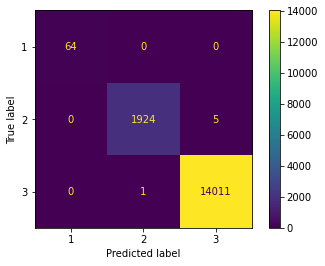





For test set




Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.20      0.04      0.06       866
           3       0.87      0.98      0.92      6020

    accuracy                           0.86      6907
   macro avg       0.36      0.34      0.33      6907
weighted avg       0.79      0.86      0.81      6907



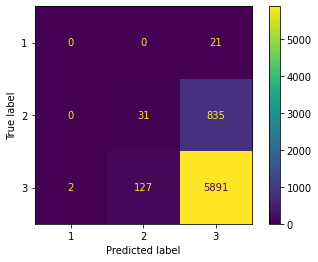




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Class distribution: Counter({3: 14012, 2: 14012, 1: 14012})



For training set






With random oversampling

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     14012
           2       1.00      1.00      1.00     14012
           3       1.00      1.00      1.00     14012

    accuracy                           1.00     42036
   macro avg       1.00      1.00      1.00     42036
weighted avg       1.00      1.00      1.00     42036



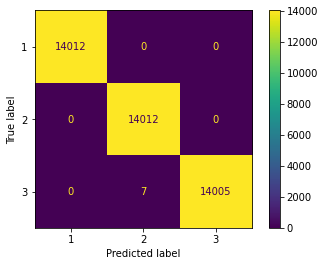





For test set




With random oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.19      0.10      0.13       866
           3       0.88      0.94      0.91      6020

    accuracy                           0.83      6907
   macro avg       0.36      0.35      0.35      6907
weighted avg       0.79      0.83      0.81      6907



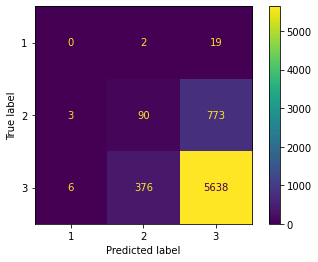




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Class distribution: Counter({3: 14012, 2: 14012, 1: 14012})



For training set






With SMOTE

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     14012
           2       1.00      1.00      1.00     14012
           3       1.00      1.00      1.00     14012

    accuracy                           1.00     42036
   macro avg       1.00      1.00      1.00     42036
weighted avg       1.00      1.00      1.00     42036



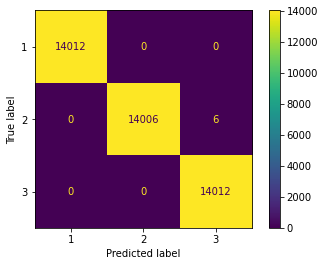





For test set




With SMOTE

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.17      0.15      0.16       866
           3       0.88      0.89      0.88      6020

    accuracy                           0.79      6907
   macro avg       0.35      0.35      0.35      6907
weighted avg       0.79      0.79      0.79      6907



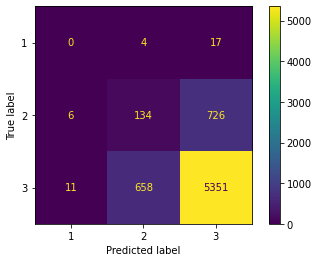




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [34]:
# RF
from sklearn.ensemble import RandomForestClassifier

for t in range(3):
    train_f, train_l = balance_data(train_features, train_labels, t)

    for i in range(len(train_f)):
        for j in range(len(train_f[i])):
            if str(train_f[i][j]) == 'inf':
                train_f[i][j] = INF
    for i in range(len(test_features)):
        for j in range(len(test_features[i])):
            if str(test_features[i][j]) == 'inf':
                test_features[i][j] = INF

    print("Class distribution:", Counter(train_l))
    rf_model = RandomForestClassifier(random_state=123).fit(train_f, train_l)
    print("\nFor training set\n")
    train_pred = rf_model.predict(train_f)
    get_metrics(t, train_l, train_pred, f"RF_train_{t}", "RF")
    print("\nFor test set\n")
    test_pred = rf_model.predict(test_features)
    get_metrics(t, test_labels, test_pred, f"RF_test_{t}", "RF")
    print('-'*210)

Class distribution: Counter({3: 14012, 2: 1929, 1: 64})



For training set




Without oversampling

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        64
           2       1.00      1.00      1.00      1929
           3       1.00      1.00      1.00     14012

    accuracy                           1.00     16005
   macro avg       1.00      1.00      1.00     16005
weighted avg       1.00      1.00      1.00     16005



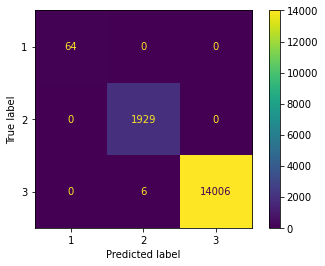





For test set




Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.15      0.17      0.16       866
           3       0.88      0.86      0.87      6020

    accuracy                           0.77      6907
   macro avg       0.34      0.34      0.34      6907
weighted avg       0.78      0.77      0.78      6907



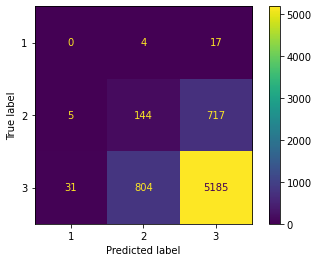




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Class distribution: Counter({3: 14012, 2: 14012, 1: 14012})



For training set




With random oversampling

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     14012
           2       1.00      1.00      1.00     14012
           3       1.00      1.00      1.00     14012

    accuracy                           1.00     42036
   macro avg       1.00      1.00      1.00     42036
weighted avg       1.00      1.00      1.00     42036



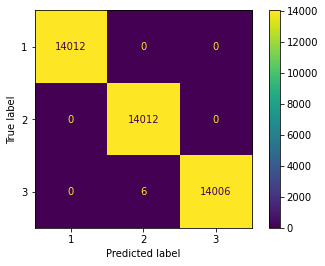





For test set




With random oversampling

              precision    recall  f1-score   support

           1       0.04      0.05      0.04        21
           2       0.16      0.15      0.16       866
           3       0.88      0.88      0.88      6020

    accuracy                           0.79      6907
   macro avg       0.36      0.36      0.36      6907
weighted avg       0.78      0.79      0.79      6907



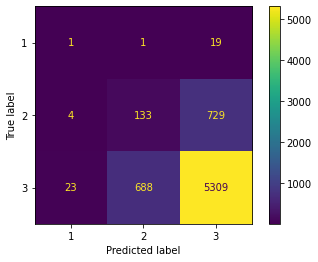




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Class distribution: Counter({3: 14012, 2: 14012, 1: 14012})



For training set




With SMOTE

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     14012
           2       1.00      1.00      1.00     14012
           3       1.00      1.00      1.00     14012

    accuracy                           1.00     42036
   macro avg       1.00      1.00      1.00     42036
weighted avg       1.00      1.00      1.00     42036



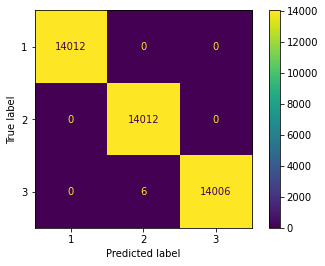





For test set




With SMOTE

              precision    recall  f1-score   support

           1       0.01      0.05      0.01        21
           2       0.15      0.25      0.19       866
           3       0.88      0.77      0.82      6020

    accuracy                           0.71      6907
   macro avg       0.34      0.36      0.34      6907
weighted avg       0.78      0.71      0.74      6907



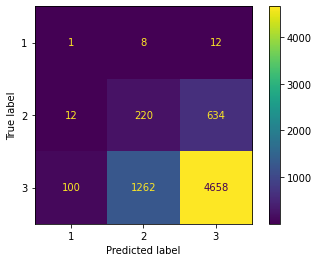




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [35]:
# DT
from sklearn.tree import DecisionTreeClassifier

for t in range(3):
    train_f, train_l = balance_data(train_features, train_labels, t)

    for i in range(len(train_f)):
        for j in range(len(train_f[i])):
            if str(train_f[i][j]) == 'inf':
                train_f[i][j] = INF
    for i in range(len(test_features)):
        for j in range(len(test_features[i])):
            if str(test_features[i][j]) == 'inf':
                test_features[i][j] = INF

    print("Class distribution:", Counter(train_l))
    dt_model = DecisionTreeClassifier(random_state=123).fit(train_f, train_l)
    print("\nFor training set\n")
    train_pred = dt_model.predict(train_f)
    get_metrics(t, train_l, train_pred, f"DT_train_{t}", "DT")
    print("\nFor test set\n")
    test_pred = dt_model.predict(test_features)
    get_metrics(t, test_labels, test_pred, f"DT_test_{t}", "DT")
    print('-'*210)

Class distribution: Counter({3: 14012, 2: 1929, 1: 64})

For training set






Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00      1929
           3       0.88      1.00      0.93     14012

    accuracy                           0.88     16005
   macro avg       0.29      0.33      0.31     16005
weighted avg       0.77      0.88      0.82     16005



/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

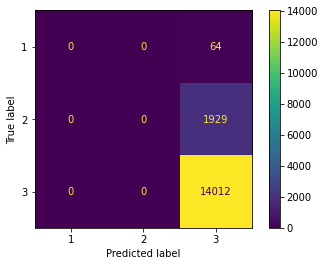





For test set






Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00       866
           3       0.87      1.00      0.93      6020

    accuracy                           0.87      6907
   macro avg       0.29      0.33      0.31      6907
weighted avg       0.76      0.87      0.81      6907



/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

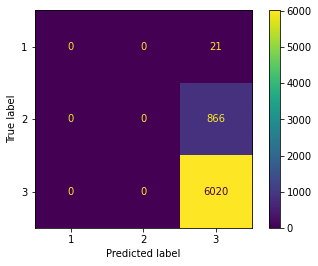




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Class distribution: Counter({3: 14012, 2: 14012, 1: 14012})

For training set






With random oversampling

              precision    recall  f1-score   support

           1       0.67      1.00      0.80     14012
           2       0.56      0.45      0.50     14012
           3       0.56      0.40      0.46     14012

    accuracy                           0.61     42036
   macro avg       0.60      0.61      0.59     42036
weighted avg       0.60      0.61      0.59     42036



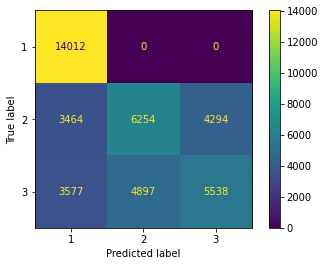





For test set






With random oversampling

              precision    recall  f1-score   support

           1       0.00      0.19      0.00        21
           2       0.14      0.40      0.21       866
           3       0.89      0.39      0.55      6020

    accuracy                           0.40      6907
   macro avg       0.34      0.33      0.25      6907
weighted avg       0.79      0.40      0.50      6907



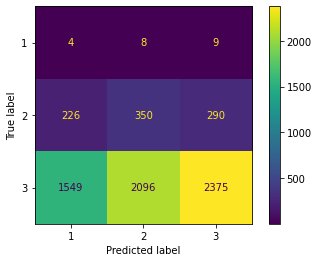




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Class distribution: Counter({3: 14012, 2: 14012, 1: 14012})

For training set






With SMOTE

              precision    recall  f1-score   support

           1       0.53      0.67      0.59     14012
           2       0.46      0.49      0.48     14012
           3       0.48      0.32      0.38     14012

    accuracy                           0.49     42036
   macro avg       0.49      0.49      0.48     42036
weighted avg       0.49      0.49      0.48     42036



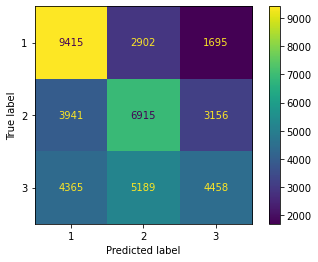





For test set






With SMOTE

              precision    recall  f1-score   support

           1       0.00      0.29      0.01        21
           2       0.14      0.40      0.21       866
           3       0.89      0.33      0.48      6020

    accuracy                           0.34      6907
   macro avg       0.34      0.34      0.23      6907
weighted avg       0.79      0.34      0.44      6907



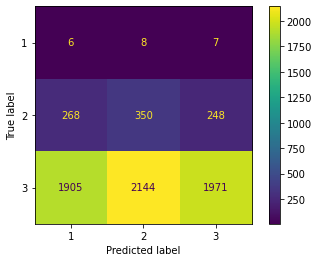




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [36]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

for t in range(3):
    train_f, train_l = balance_data(train_features, train_labels, t)

    for i in range(len(train_f)):
        for j in range(len(train_f[i])):
            if str(train_f[i][j]) == 'inf':
                train_f[i][j] = INF
    for i in range(len(test_features)):
        for j in range(len(test_features[i])):
            if str(test_features[i][j]) == 'inf':
                test_features[i][j] = INF

    print("Class distribution:", Counter(train_l))
    knn_model = KNeighborsClassifier(n_neighbors=203).fit(train_f, train_l)
    print("\nFor training set\n")
    train_pred = knn_model.predict(train_f)
    get_metrics(t, train_l, train_pred, f"KNN_train_{t}", "KNN")
    print("\nFor test set\n")
    test_pred = knn_model.predict(test_features)
    get_metrics(t, test_labels, test_pred, f"KNN_test_{t}", "KNN")
    print('-'*210)

Class distribution: Counter({3: 14012, 2: 1929, 1: 64})



For training set






Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        64
           2       0.00      0.00      0.00      1929
           3       0.88      1.00      0.93     14012

    accuracy                           0.88     16005
   macro avg       0.29      0.33      0.31     16005
weighted avg       0.77      0.88      0.82     16005



/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

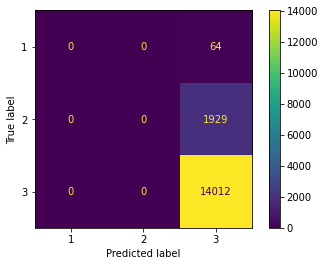





For test set






Without oversampling

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        21
           2       0.00      0.00      0.00       866
           3       0.87      1.00      0.93      6020

    accuracy                           0.87      6907
   macro avg       0.29      0.33      0.31      6907
weighted avg       0.76      0.87      0.81      6907



/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

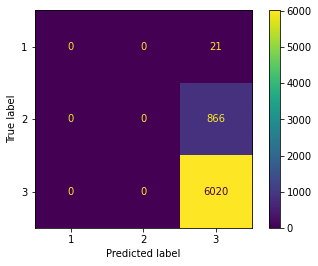




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Class distribution: Counter({3: 14012, 2: 14012, 1: 14012})



For training set






With random oversampling

              precision    recall  f1-score   support

           1       0.33      1.00      0.50     14012
           2       0.69      0.00      0.00     14012
           3       0.00      0.00      0.00     14012

    accuracy                           0.33     42036
   macro avg       0.34      0.33      0.17     42036
weighted avg       0.34      0.33      0.17     42036



/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

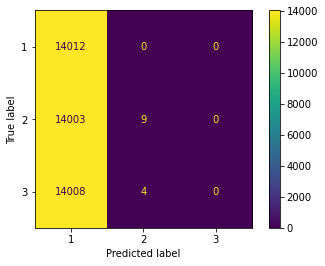





For test set






With random oversampling

              precision    recall  f1-score   support

           1       0.00      1.00      0.01        21
           2       0.00      0.00      0.00       866
           3       0.00      0.00      0.00      6020

    accuracy                           0.00      6907
   macro avg       0.00      0.33      0.00      6907
weighted avg       0.00      0.00      0.00      6907



/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

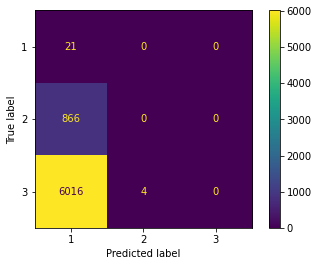




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Class distribution: Counter({3: 14012, 2: 14012, 1: 14012})



For training set






With SMOTE

              precision    recall  f1-score   support

           1       0.33      1.00      0.50     14012
           2       1.00      0.00      0.00     14012
           3       0.80      0.00      0.00     14012

    accuracy                           0.33     42036
   macro avg       0.71      0.33      0.17     42036
weighted avg       0.71      0.33      0.17     42036



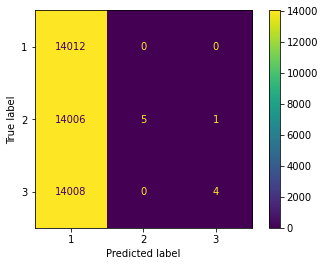





For test set






With SMOTE

              precision    recall  f1-score   support

           1       0.00      1.00      0.01        21
           2       0.00      0.00      0.00       866
           3       0.00      0.00      0.00      6020

    accuracy                           0.00      6907
   macro avg       0.00      0.33      0.00      6907
weighted avg       0.00      0.00      0.00      6907



/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home2/tgv2002/miniconda3/envs/py37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

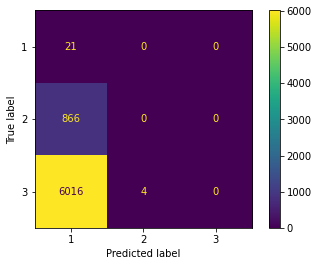




------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [37]:
# SVM
from sklearn import svm

for t in range(3):
    train_f, train_l = balance_data(train_features, train_labels, t)

    for i in range(len(train_f)):
        for j in range(len(train_f[i])):
            if str(train_f[i][j]) == 'inf':
                train_f[i][j] = INF
    for i in range(len(test_features)):
        for j in range(len(test_features[i])):
            if str(test_features[i][j]) == 'inf':
                test_features[i][j] = INF

    print("Class distribution:", Counter(train_l))
    svm_model = svm.SVC().fit(train_f, train_l)
    print("\nFor training set\n")
    train_pred = svm_model.predict(train_f)
    get_metrics(t, train_l, train_pred, f"SVM_train_{t}", "SVM")
    print("\nFor test set\n")
    test_pred = svm_model.predict(test_features)
    get_metrics(t, test_labels, test_pred, f"SVM_test_{t}", "SVM")
    print('-'*210)

# Logging results

In [38]:
!zip -r SVM.zip SVM
!zip -r DT.zip DT
!zip -r RF.zip RF
!zip -r KNN.zip KNN

  adding: SVM/ (stored 0%)
  adding: SVM/SVM_test_2_conf.png (deflated 19%)
  adding: SVM/SVM_test_1_stats.json (deflated 69%)
  adding: SVM/SVM_test_0_conf.png (deflated 19%)
  adding: SVM/SVM_test_1_conf.png (deflated 19%)
  adding: SVM/SVM_train_0_conf.png (deflated 18%)
  adding: SVM/SVM_train_2_stats.json (deflated 70%)
  adding: SVM/SVM_train_1_conf.png (deflated 17%)
  adding: SVM/SVM_test_2_stats.json (deflated 69%)
  adding: SVM/SVM_train_1_stats.json (deflated 71%)
  adding: SVM/SVM_test_0_stats.json (deflated 71%)
  adding: SVM/SVM_train_2_conf.png (deflated 17%)
  adding: SVM/SVM_train_0_stats.json (deflated 71%)


  adding: DT/ (stored 0%)
  adding: DT/DT_train_2_conf.png (deflated 17%)
  adding: DT/DT_test_0_stats.json (deflated 68%)
  adding: DT/DT_test_1_conf.png (deflated 18%)
  adding: DT/DT_test_1_stats.json (deflated 66%)
  adding: DT/DT_train_1_stats.json (deflated 74%)
  adding: DT/DT_train_1_conf.png (deflated 17%)
  adding: DT/DT_train_0_stats.json (deflated 69%)
  adding: DT/DT_test_0_conf.png (deflated 19%)
  adding: DT/DT_test_2_conf.png (deflated 18%)
  adding: DT/DT_train_0_conf.png (deflated 17%)
  adding: DT/DT_test_2_stats.json (deflated 66%)
  adding: DT/DT_train_2_stats.json (deflated 74%)


  adding: RF/ (stored 0%)
  adding: RF/RF_test_0_stats.json (deflated 68%)
  adding: RF/RF_train_1_stats.json (deflated 74%)
  adding: RF/RF_test_2_conf.png (deflated 18%)
  adding: RF/RF_test_0_conf.png (deflated 19%)
  adding: RF/RF_test_1_conf.png (deflated 17%)
  adding: RF/RF_test_2_stats.json (deflated 67%)
  adding: RF/RF_train_1_conf.png (deflated 17%)
  adding: RF/RF_train_0_conf.png (deflated 18%)
  adding: RF/RF_train_2_stats.json (deflated 74%)
  adding: RF/RF_test_1_stats.json (deflated 67%)
  adding: RF/RF_train_2_conf.png (deflated 17%)
  adding: RF/RF_train_0_stats.json (deflated 68%)


  adding: KNN/ (stored 0%)
  adding: KNN/KNN_test_2_stats.json (deflated 66%)
  adding: KNN/KNN_train_0_conf.png (deflated 18%)
  adding: KNN/KNN_test_1_conf.png (deflated 17%)
  adding: KNN/KNN_train_2_stats.json (deflated 69%)
  adding: KNN/KNN_test_0_conf.png (deflated 19%)
  adding: KNN/KNN_train_0_stats.json (deflated 71%)
  adding: KNN/KNN_test_1_stats.json (deflated 67%)
  adding: KNN/KNN_test_2_conf.png (deflated 15%)
  adding: KNN/KNN_test_0_stats.json (deflated 71%)
  adding: KNN/KNN_train_1_stats.json (deflated 70%)
  adding: KNN/KNN_train_1_conf.png (deflated 16%)
  adding: KNN/KNN_train_2_conf.png (deflated 14%)


In [39]:
# from google.colab import files
# files.download("SVM.zip")
# files.download("DT.zip")
# files.download("RF.zip")
# files.download("KNN.zip")